In [1]:
%matplotlib inline

# Case study: K2-24, putting it all together

In [2]:
%run notebook_setup

theano version: 1.0.4


pymc3 version: 3.7


exoplanet version: 0.2.0


In this tutorial, we will combine many of the previous tutorials to perform a fit of the K2-24 system using the K2 transit data and the RVs from [Petigura et al. (2016)](https://arxiv.org/abs/1511.04497).
This is the same system that we fit in the :ref:`rv` tutorial and we'll combine that model with the transit model from the :ref:`transit` tutorial and the Gaussian Process noise model from the :ref:`stellar-variability` tutorial.

## Datasets and initializations

To get started, let's download the relevant datasets.
First, the transit light curve from [Everest](https://rodluger.github.io/everest/):

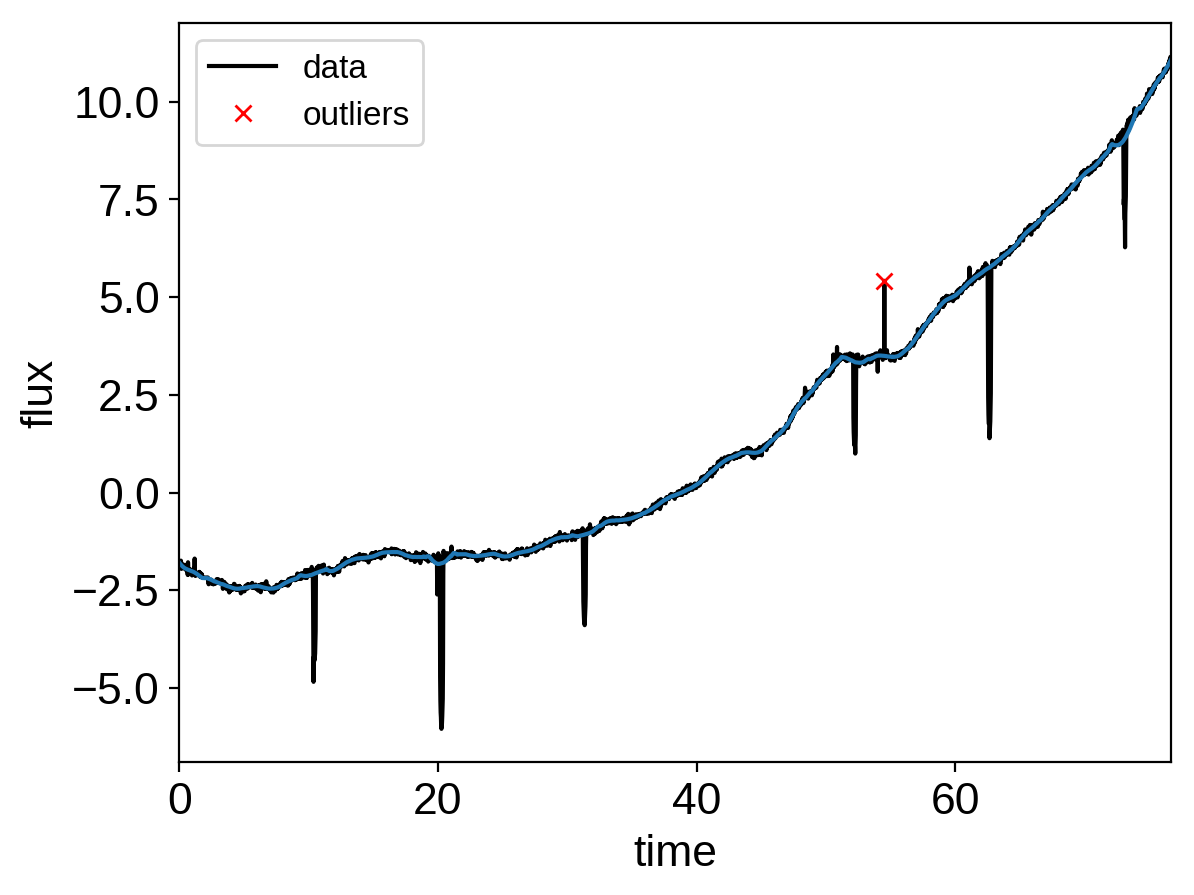

In [3]:
import numpy as np
import matplotlib.pyplot as plt

from astropy.io import fits
from scipy.signal import savgol_filter

# Download the data
lc_url = "https://archive.stsci.edu/hlsps/everest/v2/c02/203700000/71098/hlsp_everest_k2_llc_203771098-c02_kepler_v2.0_lc.fits"
with fits.open(lc_url) as hdus:
    lc = hdus[1].data
    lc_hdr = hdus[1].header

# Work out the exposure time
texp = lc_hdr["FRAMETIM"] * lc_hdr["NUM_FRM"]
texp /= 60.0 * 60.0 * 24.0

# Mask bad data
m = (np.arange(len(lc)) > 100) & np.isfinite(lc["FLUX"]) & np.isfinite(lc["TIME"])
bad_bits=[1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13, 14, 16, 17]
qual = lc["QUALITY"]
for b in bad_bits:
    m &= qual & 2 ** (b - 1) == 0

# Convert to parts per thousand
x = lc["TIME"][m]
y = lc["FLUX"][m]
mu = np.median(y)
y = (y / mu - 1) * 1e3

# Identify outliers
m = np.ones(len(y), dtype=bool)
for i in range(10):
    y_prime = np.interp(x, x[m], y[m])
    smooth = savgol_filter(y_prime, 101, polyorder=3)
    resid = y - smooth
    sigma = np.sqrt(np.mean(resid**2))
    m0 = np.abs(resid) < 3*sigma
    if m.sum() == m0.sum():
        m = m0
        break
    m = m0
    
# Only discard positive outliers
m = resid < 3*sigma

# Shift the data so that the K2 data start at t=0. This tends to make the fit
# better behaved since t0 covaries with period.
x_ref = np.min(x[m])
x -= x_ref

# Plot the data
plt.plot(x, y, "k", label="data")
plt.plot(x, smooth)
plt.plot(x[~m], y[~m], "xr", label="outliers")
plt.legend(fontsize=12)
plt.xlim(x.min(), x.max())
plt.xlabel("time")
plt.ylabel("flux")

# Make sure that the data type is consistent
x = np.ascontiguousarray(x[m], dtype=np.float64)
y = np.ascontiguousarray(y[m], dtype=np.float64)
smooth = np.ascontiguousarray(smooth[m], dtype=np.float64)

Then the RVs from [RadVel](https://radvel.readthedocs.io):

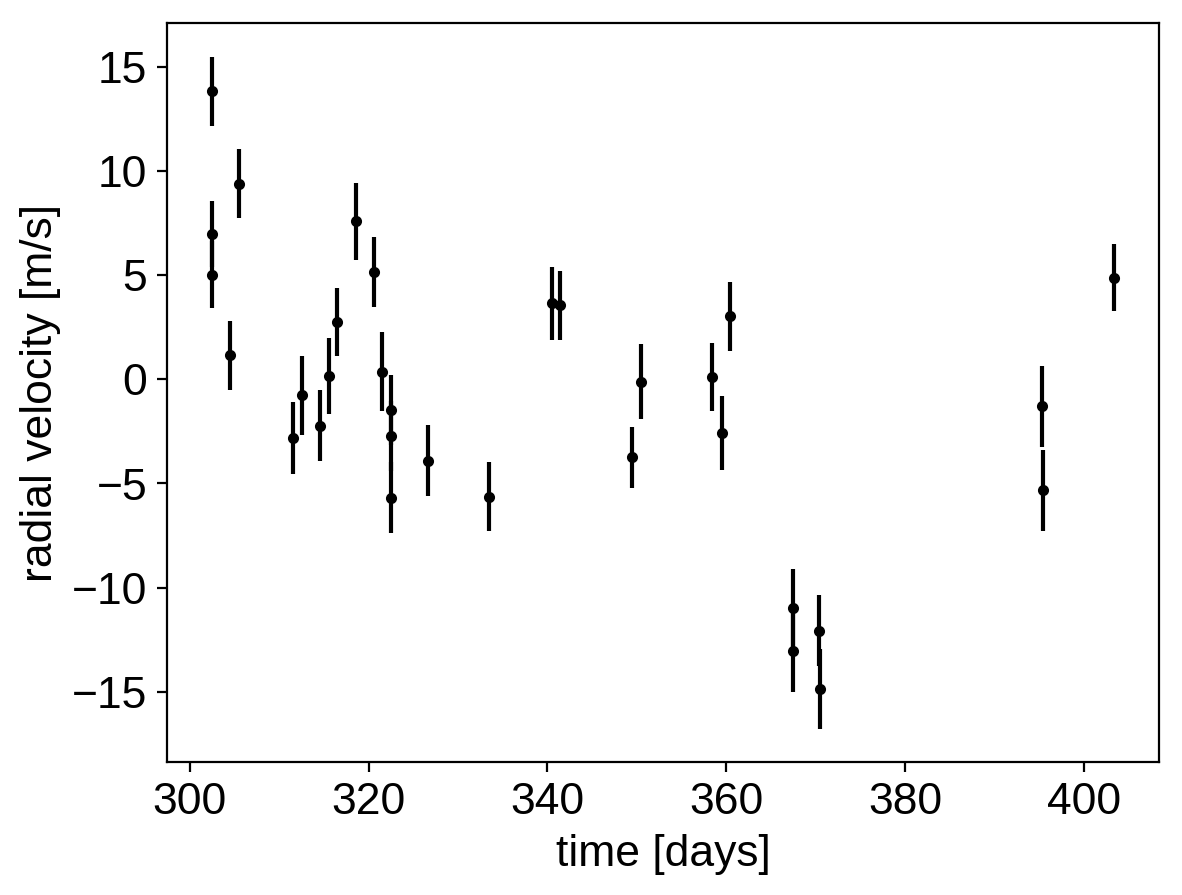

In [4]:
import pandas as pd

url = "https://raw.githubusercontent.com/California-Planet-Search/radvel/master/example_data/epic203771098.csv"
data = pd.read_csv(url, index_col=0)

# Don't forget to remove the time offset from above!
x_rv = np.array(data.t) - x_ref
y_rv = np.array(data.vel)
yerr_rv = np.array(data.errvel)

plt.errorbar(x_rv, y_rv, yerr=yerr_rv, fmt=".k")
plt.xlabel("time [days]")
plt.ylabel("radial velocity [m/s]");

We can initialize the transit parameters using [the box least squares periodogram from AstroPy](http://docs.astropy.org/en/latest/stats/bls.html).
(Note: you'll need AstroPy v3.1 or more recent to use this feature.)
A full discussion of transit detection and vetting is beyond the scope of this tutorial so let's assume that we know that there are two periodic transiting planets in this dataset.

In [5]:
from astropy.stats import BoxLeastSquares

m = np.zeros(len(x), dtype=bool)
period_grid = np.exp(np.linspace(np.log(5), np.log(50), 50000))
bls_results = []
periods = []
t0s = []
depths = []

# Compute the periodogram for each planet by iteratively masking out
# transits from the higher signal to noise planets. Here we're assuming
# that we know that there are exactly two planets.
for i in range(2):
    bls = BoxLeastSquares(x[~m], y[~m] - smooth[~m])
    bls_power = bls.power(period_grid, 0.1, oversample=20)
    bls_results.append(bls_power)
    
    # Save the highest peak as the planet candidate
    index = np.argmax(bls_power.power)
    periods.append(bls_power.period[index])
    t0s.append(bls_power.transit_time[index])
    depths.append(bls_power.depth[index])
    
    # Mask the data points that are in transit for this candidate
    m |= bls.transit_mask(x, periods[-1], 0.5, t0s[-1])

Let's plot the initial transit estimates based on these periodograms:

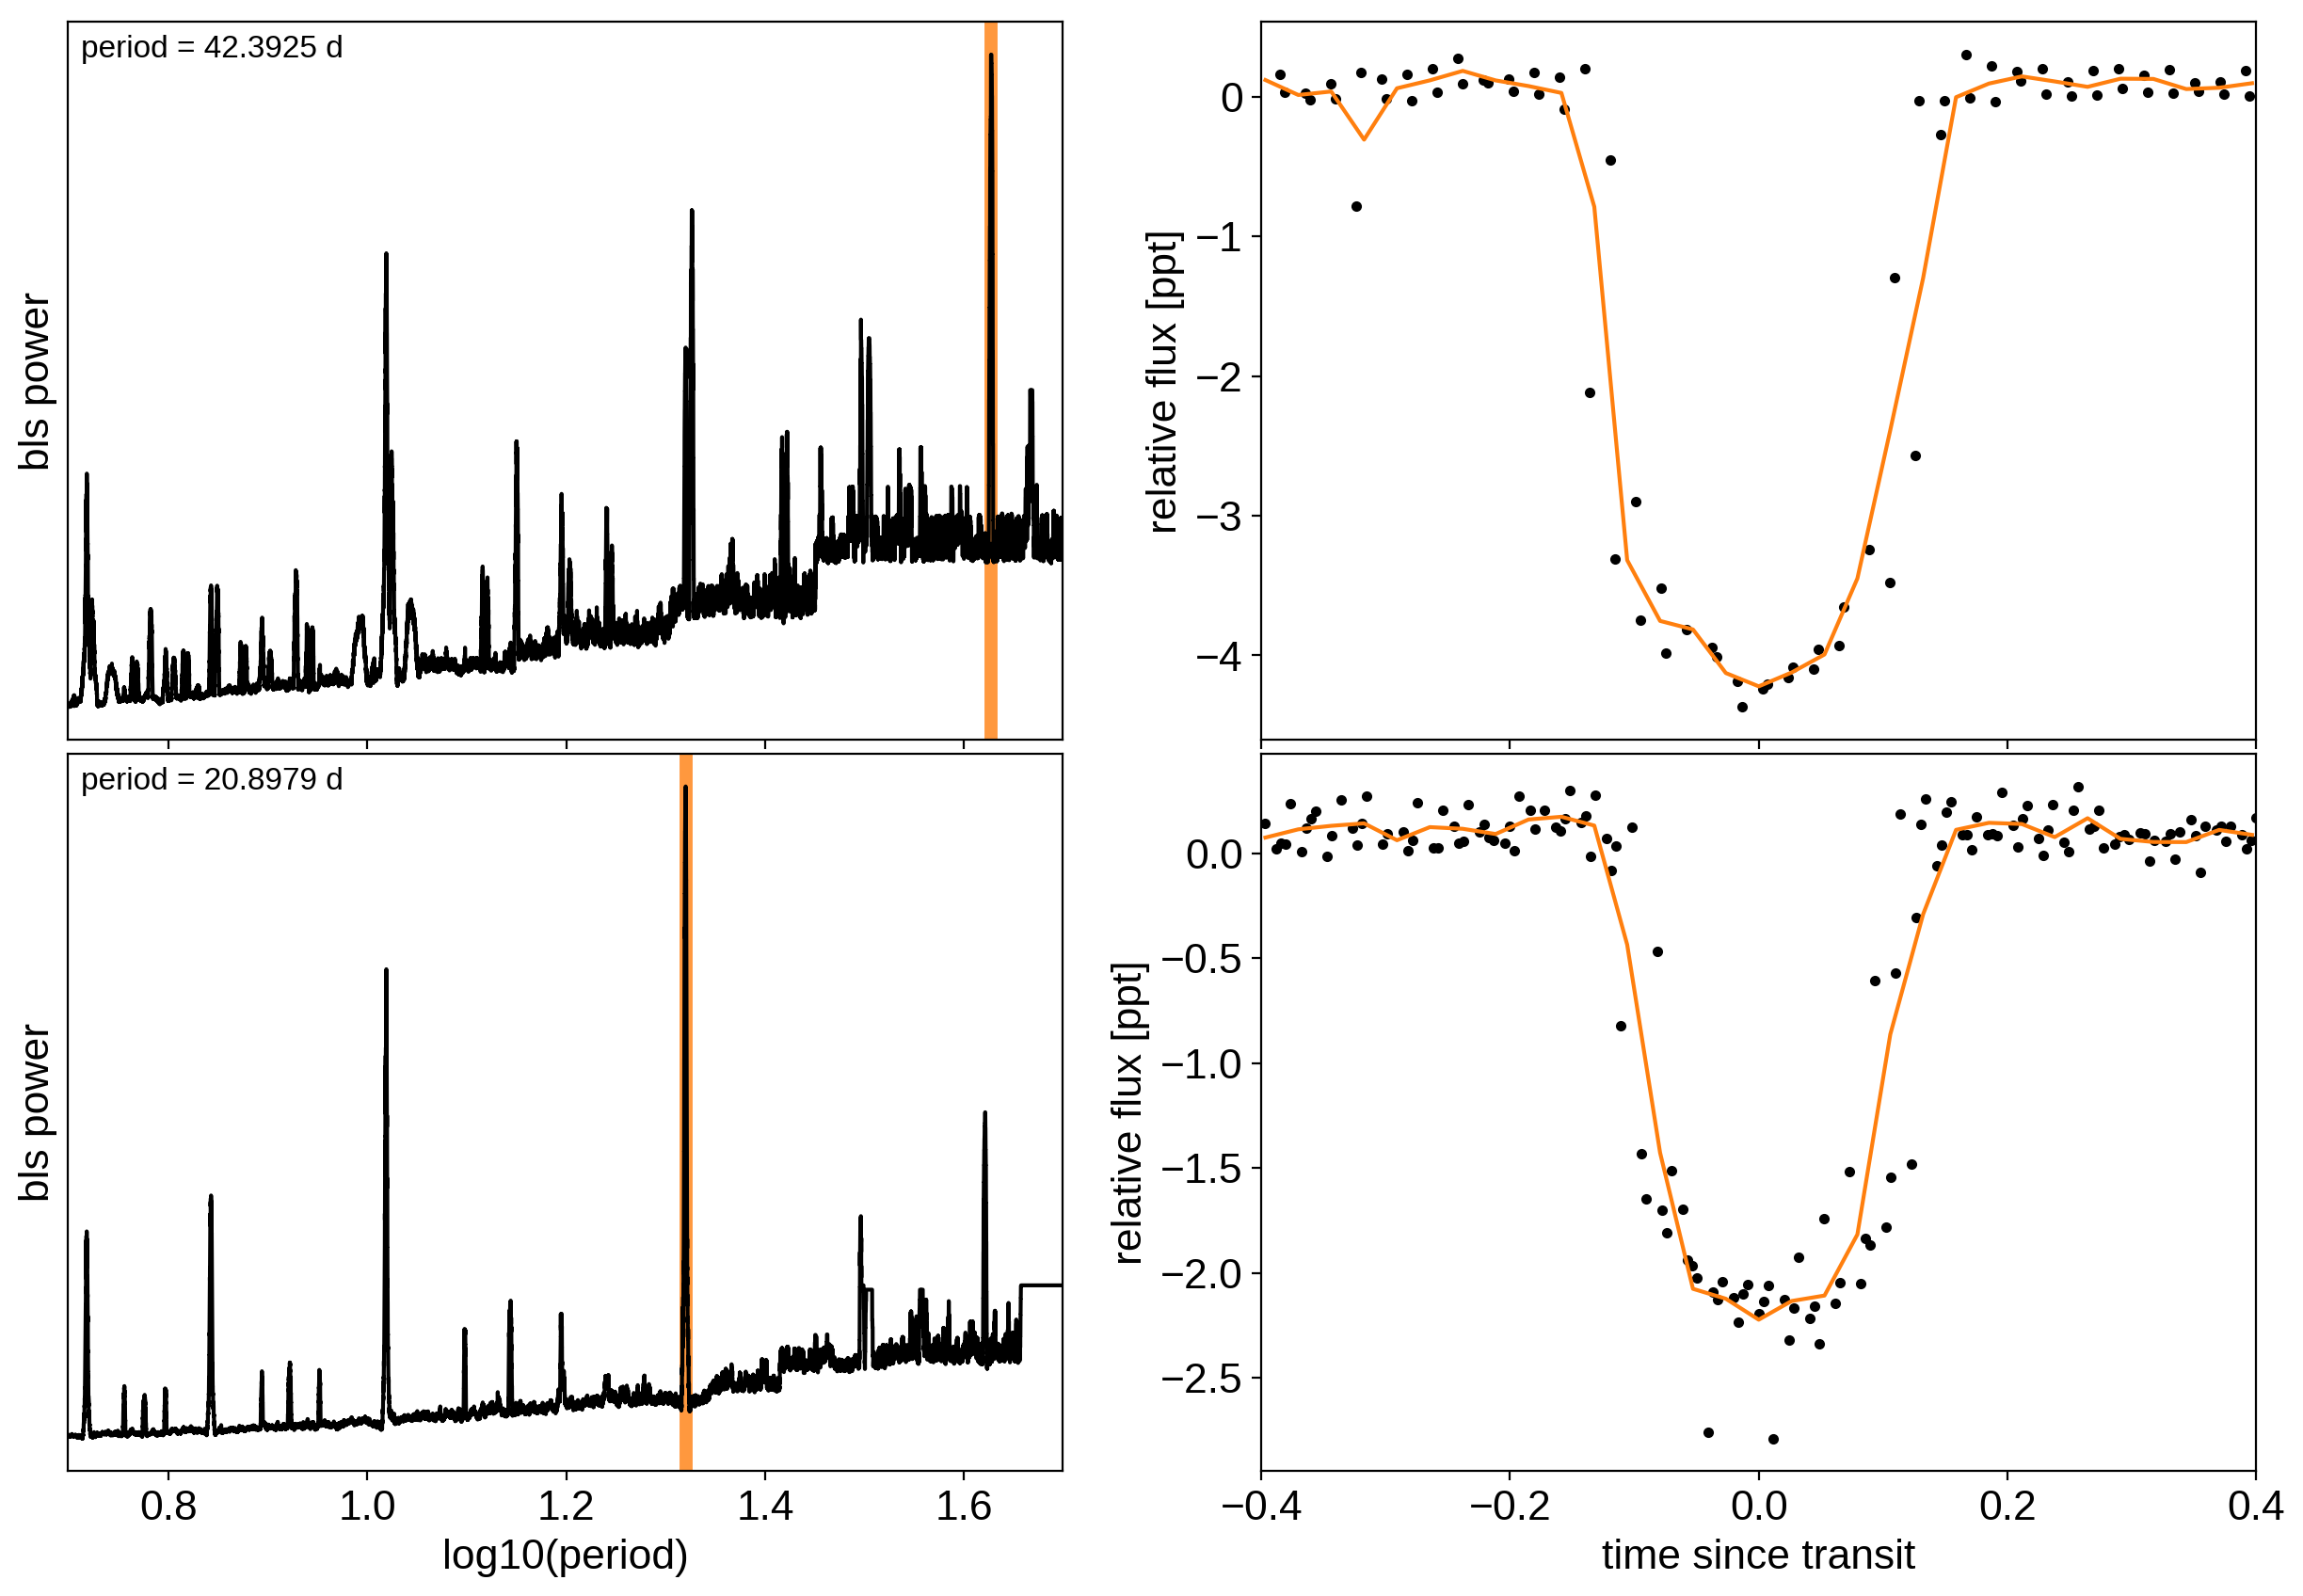

In [6]:
fig, axes = plt.subplots(len(bls_results), 2, figsize=(15, 10))

for i in range(len(bls_results)):
    # Plot the periodogram
    ax = axes[i, 0]
    ax.axvline(np.log10(periods[i]), color="C1", lw=5, alpha=0.8)
    ax.plot(np.log10(bls_results[i].period), bls_results[i].power, "k")
    ax.annotate("period = {0:.4f} d".format(periods[i]),
                (0, 1), xycoords="axes fraction",
                xytext=(5, -5), textcoords="offset points",
                va="top", ha="left", fontsize=12)
    ax.set_ylabel("bls power")
    ax.set_yticks([])
    ax.set_xlim(np.log10(period_grid.min()), np.log10(period_grid.max()))
    if i < len(bls_results) - 1:
        ax.set_xticklabels([])
    else:
        ax.set_xlabel("log10(period)")
    
    # Plot the folded transit
    ax = axes[i, 1]
    p = periods[i]
    x_fold = (x - t0s[i] + 0.5*p) % p - 0.5*p
    m = np.abs(x_fold) < 0.4
    ax.plot(x_fold[m], y[m] - smooth[m], ".k")
    
    # Overplot the phase binned light curve
    bins = np.linspace(-0.41, 0.41, 32)
    denom, _ = np.histogram(x_fold, bins)
    num, _ = np.histogram(x_fold, bins, weights=y - smooth)
    denom[num == 0] = 1.0
    ax.plot(0.5*(bins[1:] + bins[:-1]), num / denom, color="C1")

    ax.set_xlim(-0.4, 0.4)
    ax.set_ylabel("relative flux [ppt]")
    if i < len(bls_results) - 1:
        ax.set_xticklabels([])
    else:
        ax.set_xlabel("time since transit")
        
fig.subplots_adjust(hspace=0.02)

The discovery paper for K2-24 ([Petigura et al. (2016)](https://arxiv.org/abs/1511.04497)) includes the following estimates of the stellar mass and radius in Solar units:

In [7]:
M_star_petigura = 1.12, 0.05
R_star_petigura = 1.21, 0.11

Finally, using this stellar mass, we can also estimate the minimum masses of the planets given these transit parameters.

In [8]:
import exoplanet as xo
import astropy.units as u

msini = xo.estimate_minimum_mass(periods, x_rv, y_rv, yerr_rv, t0s=t0s, m_star=M_star_petigura[0])
msini = msini.to(u.M_earth)
print(msini)

[32.80060146 23.89885976] earthMass


## A joint transit and radial velocity model in PyMC3

Now, let's define our full model in *PyMC3*.
There's a lot going on here, but I've tried to comment it and most of it should be familiar from the previous tutorials (:ref:`rv`, :ref:`transit`, :ref:`gp`, and :ref:`stellar-variability`).
In this case, I've put the model inside a model "factory" function because we'll do some sigma clipping below.

In [9]:
import pymc3 as pm
import theano.tensor as tt

t_rv = np.linspace(x_rv.min()-5, x_rv.max()+5, 1000)

def build_model(mask=None, start=None):
    if mask is None:
        mask = np.ones(len(x), dtype=bool)
    with pm.Model() as model:

        # Parameters for the stellar properties
        mean = pm.Normal("mean", mu=0.0, sd=10.0)
        u_star = xo.distributions.QuadLimbDark("u_star")
        BoundedNormal = pm.Bound(pm.Normal, lower=0, upper=3)
        m_star = BoundedNormal("m_star", mu=M_star_petigura[0], sd=M_star_petigura[1])
        r_star = BoundedNormal("r_star", mu=R_star_petigura[0], sd=R_star_petigura[1])

        # Orbital parameters for the planets
        logm = pm.Normal("logm", mu=np.log(msini.value), sd=1, shape=2)
        logP = pm.Normal("logP", mu=np.log(periods), sd=1, shape=2)
        t0 = pm.Normal("t0", mu=np.array(t0s), sd=1, shape=2)
        logr = pm.Normal("logr", mu=0.5*np.log(1e-3*np.array(depths)) + np.log(R_star_petigura[0]),
                         sd=1.0, shape=2)
        r_pl = pm.Deterministic("r_pl", tt.exp(logr))
        ror = pm.Deterministic("ror", r_pl / r_star)
        b = xo.distributions.UnitUniform("b", shape=2)
        
        # This is the eccentricity prior from Kipping (2013):
        # https://arxiv.org/abs/1306.4982
        BoundedBeta = pm.Bound(pm.Beta, lower=0, upper=1-1e-5)
        ecc = BoundedBeta("ecc", alpha=0.867, beta=3.03, shape=2,
                          testval=np.array([0.1, 0.1]))
        omega = xo.distributions.Angle("omega", shape=2)

        # RV jitter & a quadratic RV trend
        logs_rv = pm.Normal("logs_rv", mu=np.log(np.median(yerr_rv)), sd=5)
        trend = pm.Normal("trend", mu=0, sd=10.0**-np.arange(3)[::-1], shape=3)

        # Transit jitter & GP parameters
        logs2 = pm.Normal("logs2", mu=np.log(np.var(y[mask])), sd=10)
        logw0_guess = np.log(2*np.pi/10)
        logw0 = pm.Normal("logw0", mu=logw0_guess, sd=10)
        
        # We'll parameterize using the maximum power (S_0 * w_0^4) instead of
        # S_0 directly because this removes some of the degeneracies between
        # S_0 and omega_0
        logpower = pm.Normal("logpower",
                             mu=np.log(np.var(y[mask]))+4*logw0_guess,
                             sd=10)
        logS0 = pm.Deterministic("logS0", logpower - 4 * logw0)

        # Tracking planet parameters
        period = pm.Deterministic("period", tt.exp(logP))
        m_pl = pm.Deterministic("m_pl", tt.exp(logm))

        # Orbit model
        orbit = xo.orbits.KeplerianOrbit(
            r_star=r_star, m_star=m_star,
            period=period, t0=t0, b=b, m_planet=m_pl,
            ecc=ecc, omega=omega,
            m_planet_units=msini.unit)

        # Compute the model light curve using starry
        light_curves = xo.LimbDarkLightCurve(u_star).get_light_curve(
            orbit=orbit, r=r_pl, t=x[mask], texp=texp)*1e3
        light_curve = pm.math.sum(light_curves, axis=-1) + mean
        pm.Deterministic("light_curves", light_curves)

        # GP model for the light curve
        kernel = xo.gp.terms.SHOTerm(log_S0=logS0, log_w0=logw0, Q=1/np.sqrt(2))
        gp = xo.gp.GP(kernel, x[mask], tt.exp(logs2) + tt.zeros(mask.sum()), J=2)
        pm.Potential("transit_obs", gp.log_likelihood(y[mask] - light_curve))
        pm.Deterministic("gp_pred", gp.predict())

        # Set up the RV model and save it as a deterministic
        # for plotting purposes later
        vrad = orbit.get_radial_velocity(x_rv)
        pm.Deterministic("vrad", vrad)

        # Define the background RV model
        A = np.vander(x_rv - 0.5*(x_rv.min() + x_rv.max()), 3)
        bkg = pm.Deterministic("bkg", tt.dot(A, trend))

        # The likelihood for the RVs
        rv_model = pm.Deterministic("rv_model", tt.sum(vrad, axis=-1) + bkg)
        err = tt.sqrt(yerr_rv**2 + tt.exp(2*logs_rv))
        pm.Normal("obs", mu=rv_model, sd=err, observed=y_rv)
        
        vrad_pred = orbit.get_radial_velocity(t_rv)
        pm.Deterministic("vrad_pred", vrad_pred)
        A_pred = np.vander(t_rv - 0.5*(x_rv.min() + x_rv.max()), 3)
        bkg_pred = pm.Deterministic("bkg_pred", tt.dot(A_pred, trend))
        pm.Deterministic("rv_model_pred", tt.sum(vrad_pred, axis=-1) + bkg_pred)

        # Fit for the maximum a posteriori parameters, I've found that I can get
        # a better solution by trying different combinations of parameters in turn
        if start is None:
            start = model.test_point
        map_soln = xo.optimize(start=start, vars=[trend])
        map_soln = xo.optimize(start=map_soln, vars=[logs2])
        map_soln = xo.optimize(start=map_soln, vars=[logr, b])
        map_soln = xo.optimize(start=map_soln, vars=[logP, t0])
        map_soln = xo.optimize(start=map_soln, vars=[logs2, logpower])
        map_soln = xo.optimize(start=map_soln, vars=[logw0])
        map_soln = xo.optimize(start=map_soln)

    return model, map_soln

In [10]:
model0, map_soln0 = build_model()

optimizing logp for variables: ['trend']


message: Optimization terminated successfully.
logp: -8250.57231984769 -> -8233.97212654762


optimizing logp for variables: ['logs2']


message: Optimization terminated successfully.
logp: -8233.97212654762 -> 1985.1953832396869


optimizing logp for variables: ['b_logodds__', 'logr']


message: Optimization terminated successfully.
logp: 1985.1953832396869 -> 2679.698211595524


optimizing logp for variables: ['t0', 'logP']


message: Desired error not necessarily achieved due to precision loss.
logp: 2679.698211595524 -> 3334.211961863789


optimizing logp for variables: ['logpower', 'logs2']


message: Optimization terminated successfully.
logp: 3334.211961863789 -> 4291.60277721198


optimizing logp for variables: ['logw0']


message: Optimization terminated successfully.
logp: 4291.60277721198 -> 4365.5548628513325


optimizing logp for variables: ['logpower', 'logw0', 'logs2', 'trend', 'logs_rv', 'omega_angle__', 'ecc_interval__', 'b_logodds__', 'logr', 't0', 'logP', 'logm', 'r_star_interval__', 'm_star_interval__', 'u_star_quadlimbdark__', 'mean']


message: Desired error not necessarily achieved due to precision loss.
logp: 4365.5548628513325 -> 4777.103510779206


Now let's plot the map radial velocity model.

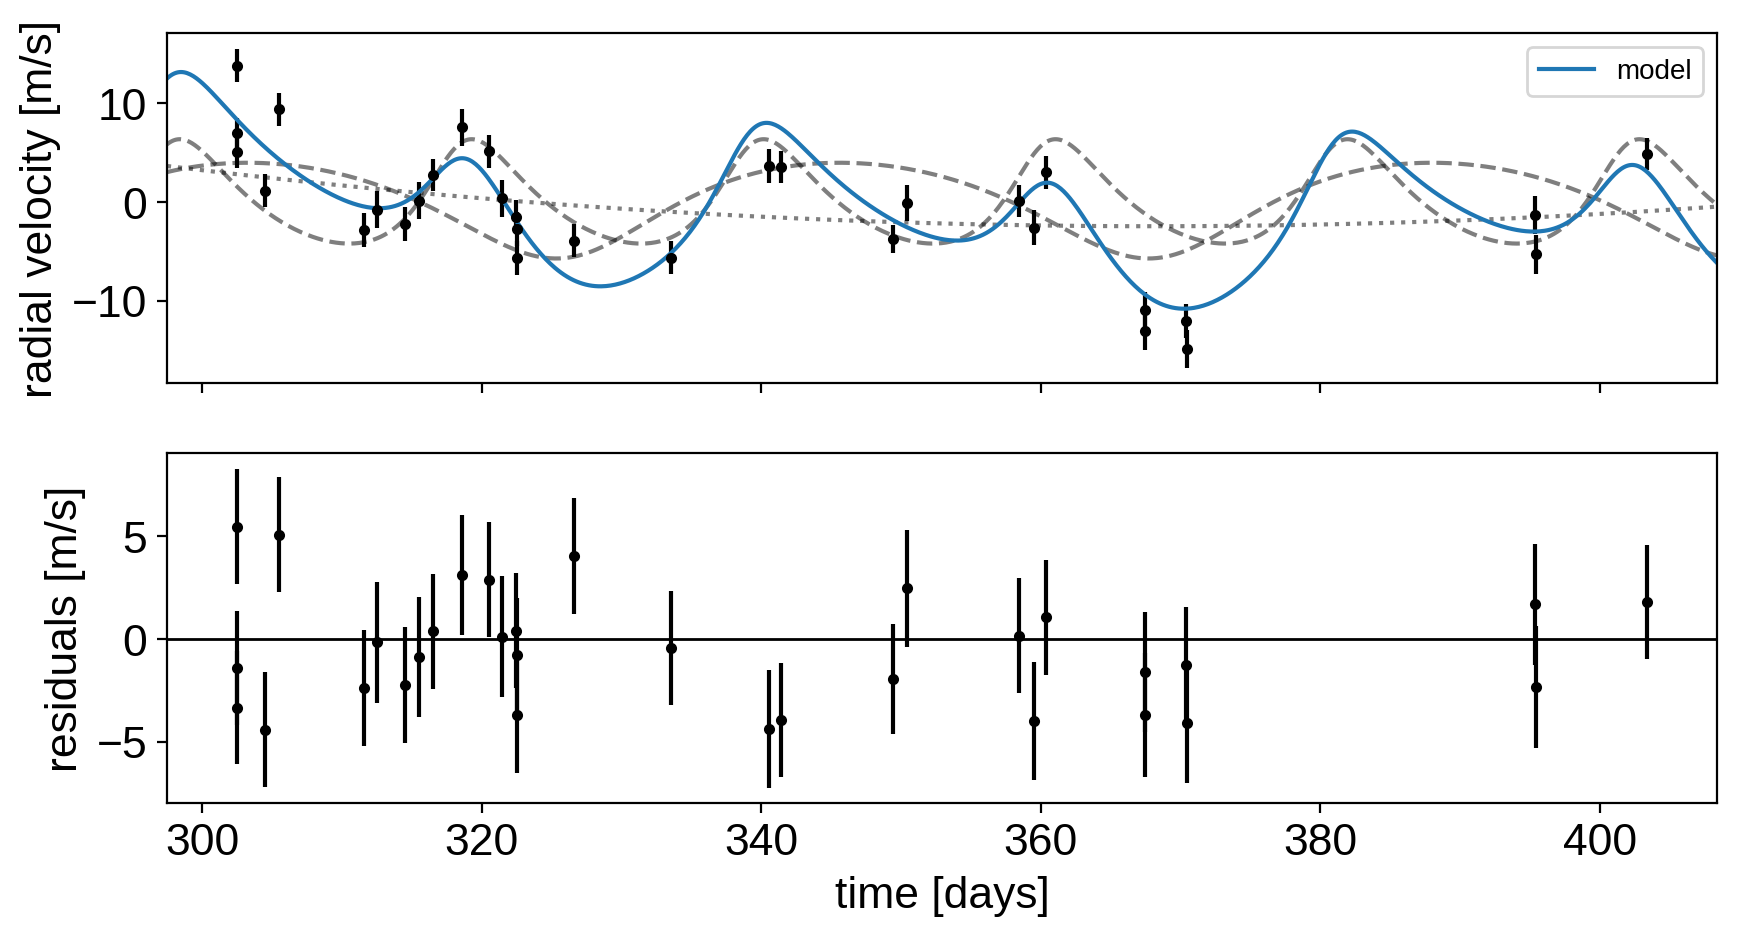

In [11]:
def plot_rv_curve(soln):
    fig, axes = plt.subplots(2, 1, figsize=(10, 5), sharex=True)
    
    ax = axes[0]
    ax.errorbar(x_rv, y_rv, yerr=yerr_rv, fmt=".k")
    ax.plot(t_rv, soln["vrad_pred"], "--k", alpha=0.5)
    ax.plot(t_rv, soln["bkg_pred"], ":k", alpha=0.5)
    ax.plot(t_rv, soln["rv_model_pred"], label="model")
    ax.legend(fontsize=10)
    ax.set_ylabel("radial velocity [m/s]")
    
    ax = axes[1]
    err = np.sqrt(yerr_rv**2+np.exp(2*soln["logs_rv"]))
    ax.errorbar(x_rv, y_rv - soln["rv_model"], yerr=err, fmt=".k")
    ax.axhline(0, color="k", lw=1)
    ax.set_ylabel("residuals [m/s]")
    ax.set_xlim(t_rv.min(), t_rv.max())
    ax.set_xlabel("time [days]")
    
plot_rv_curve(map_soln0)

That looks pretty similar to what we got in :ref:`rv`.
Now let's also plot the transit model.

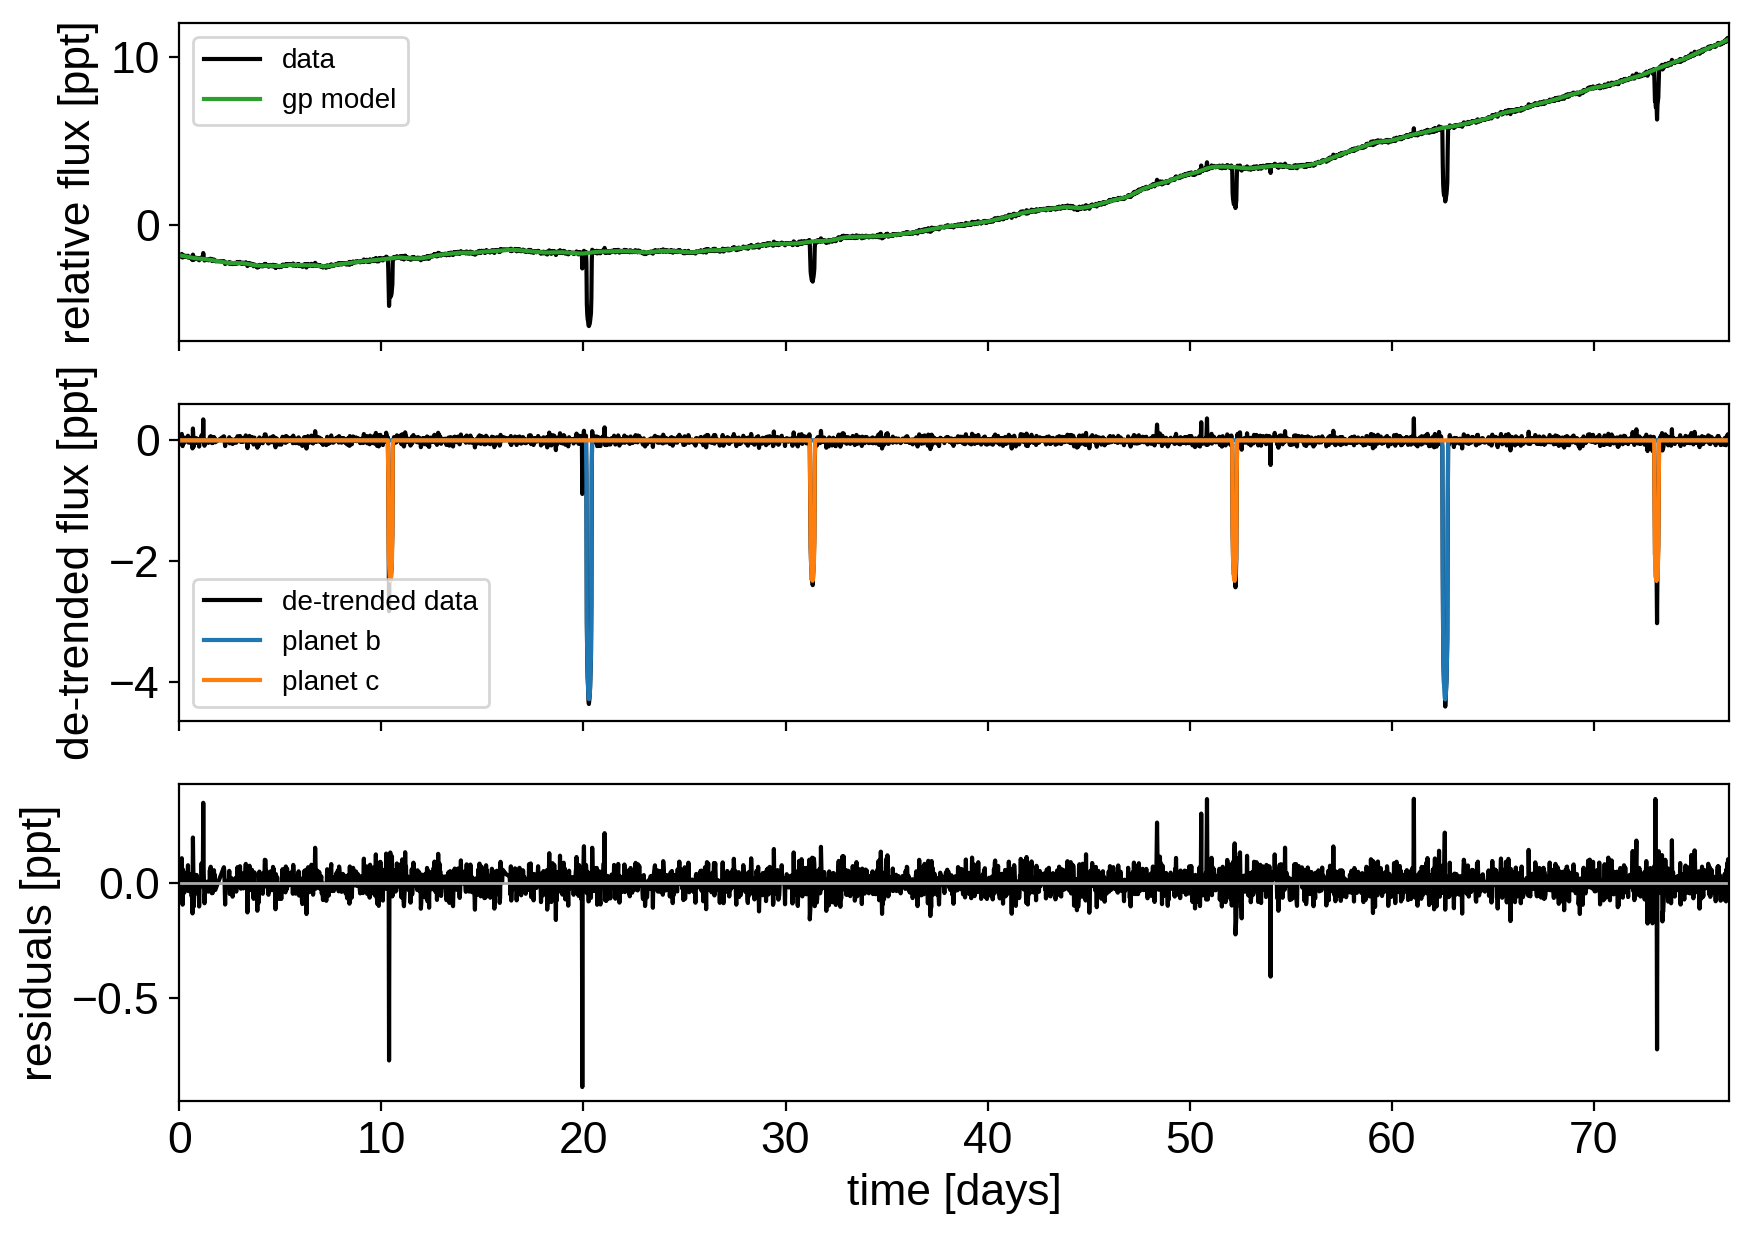

In [12]:
def plot_light_curve(soln, mask=None):
    if mask is None:
        mask = np.ones(len(x), dtype=bool)

    fig, axes = plt.subplots(3, 1, figsize=(10, 7), sharex=True)

    ax = axes[0]
    ax.plot(x[mask], y[mask], "k", label="data")
    gp_mod = soln["gp_pred"] + soln["mean"]
    ax.plot(x[mask], gp_mod, color="C2", label="gp model")
    ax.legend(fontsize=10)
    ax.set_ylabel("relative flux [ppt]")

    ax = axes[1]
    ax.plot(x[mask], y[mask] - gp_mod, "k", label="de-trended data")
    for i, l in enumerate("bc"):
        mod = soln["light_curves"][:, i]
        ax.plot(x[mask], mod, label="planet {0}".format(l))
    ax.legend(fontsize=10, loc=3)
    ax.set_ylabel("de-trended flux [ppt]")

    ax = axes[2]
    mod = gp_mod + np.sum(soln["light_curves"], axis=-1)
    ax.plot(x[mask], y[mask] - mod, "k")
    ax.axhline(0, color="#aaaaaa", lw=1)
    ax.set_ylabel("residuals [ppt]")
    ax.set_xlim(x[mask].min(), x[mask].max())
    ax.set_xlabel("time [days]")
    
    return fig
    
plot_light_curve(map_soln0);

There are still a few outliers in the light curve and it can be useful to remove those before doing the full fit because both the GP and transit parameters can be sensitive to this.

## Sigma clipping

To remove the outliers, we'll look at the empirical RMS of the residuals away from the GP + transit model and remove anything that is more than a 7-sigma outlier.

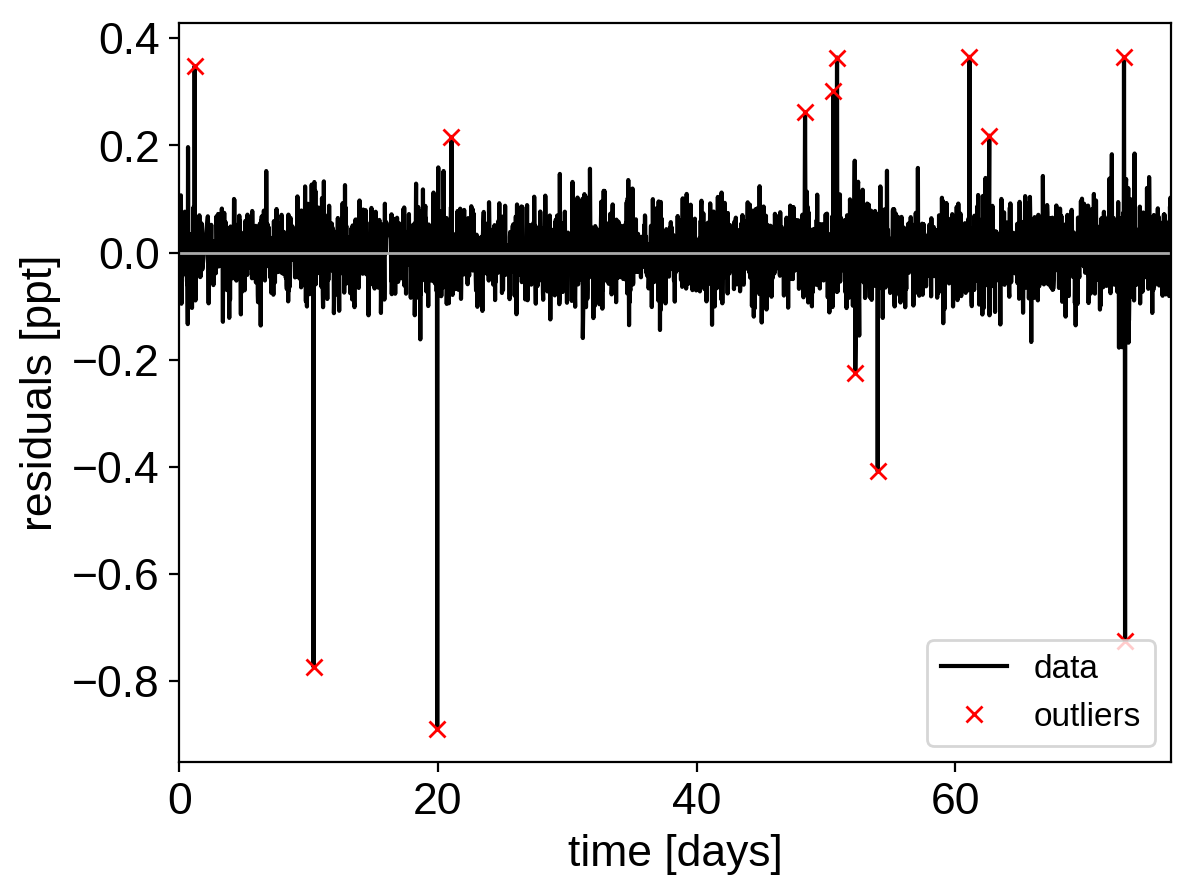

In [13]:
mod = map_soln0["gp_pred"] + map_soln0["mean"] + np.sum(map_soln0["light_curves"], axis=-1)
resid = y - mod
rms = np.sqrt(np.median(resid**2))
mask = np.abs(resid) < 7 * rms

plt.plot(x, resid, "k", label="data")
plt.plot(x[~mask], resid[~mask], "xr", label="outliers")
plt.axhline(0, color="#aaaaaa", lw=1)
plt.ylabel("residuals [ppt]")
plt.xlabel("time [days]")
plt.legend(fontsize=12, loc=4)
plt.xlim(x.min(), x.max());

That looks better. Let's re-build our model with this sigma-clipped dataset.

optimizing logp for variables: ['trend']


message: Optimization terminated successfully.
logp: 5227.116863927315 -> 5227.116863927315


optimizing logp for variables: ['logs2']


message: Optimization terminated successfully.
logp: 5227.116863927315 -> 5309.223921472727


optimizing logp for variables: ['b_logodds__', 'logr']


message: Desired error not necessarily achieved due to precision loss.
logp: 5309.223921472727 -> 5320.261402849443


optimizing logp for variables: ['t0', 'logP']


message: Optimization terminated successfully.
logp: 5320.261402849443 -> 5321.717936508713


optimizing logp for variables: ['logpower', 'logs2']


message: Optimization terminated successfully.
logp: 5321.717936508713 -> 5322.452126980033


optimizing logp for variables: ['logw0']


message: Desired error not necessarily achieved due to precision loss.
logp: 5322.452126980033 -> 5322.486377217057


optimizing logp for variables: ['logpower', 'logw0', 'logs2', 'trend', 'logs_rv', 'omega_angle__', 'ecc_interval__', 'b_logodds__', 'logr', 't0', 'logP', 'logm', 'r_star_interval__', 'm_star_interval__', 'u_star_quadlimbdark__', 'mean']


message: Desired error not necessarily achieved due to precision loss.
logp: 5322.486377217056 -> 5324.305673578371


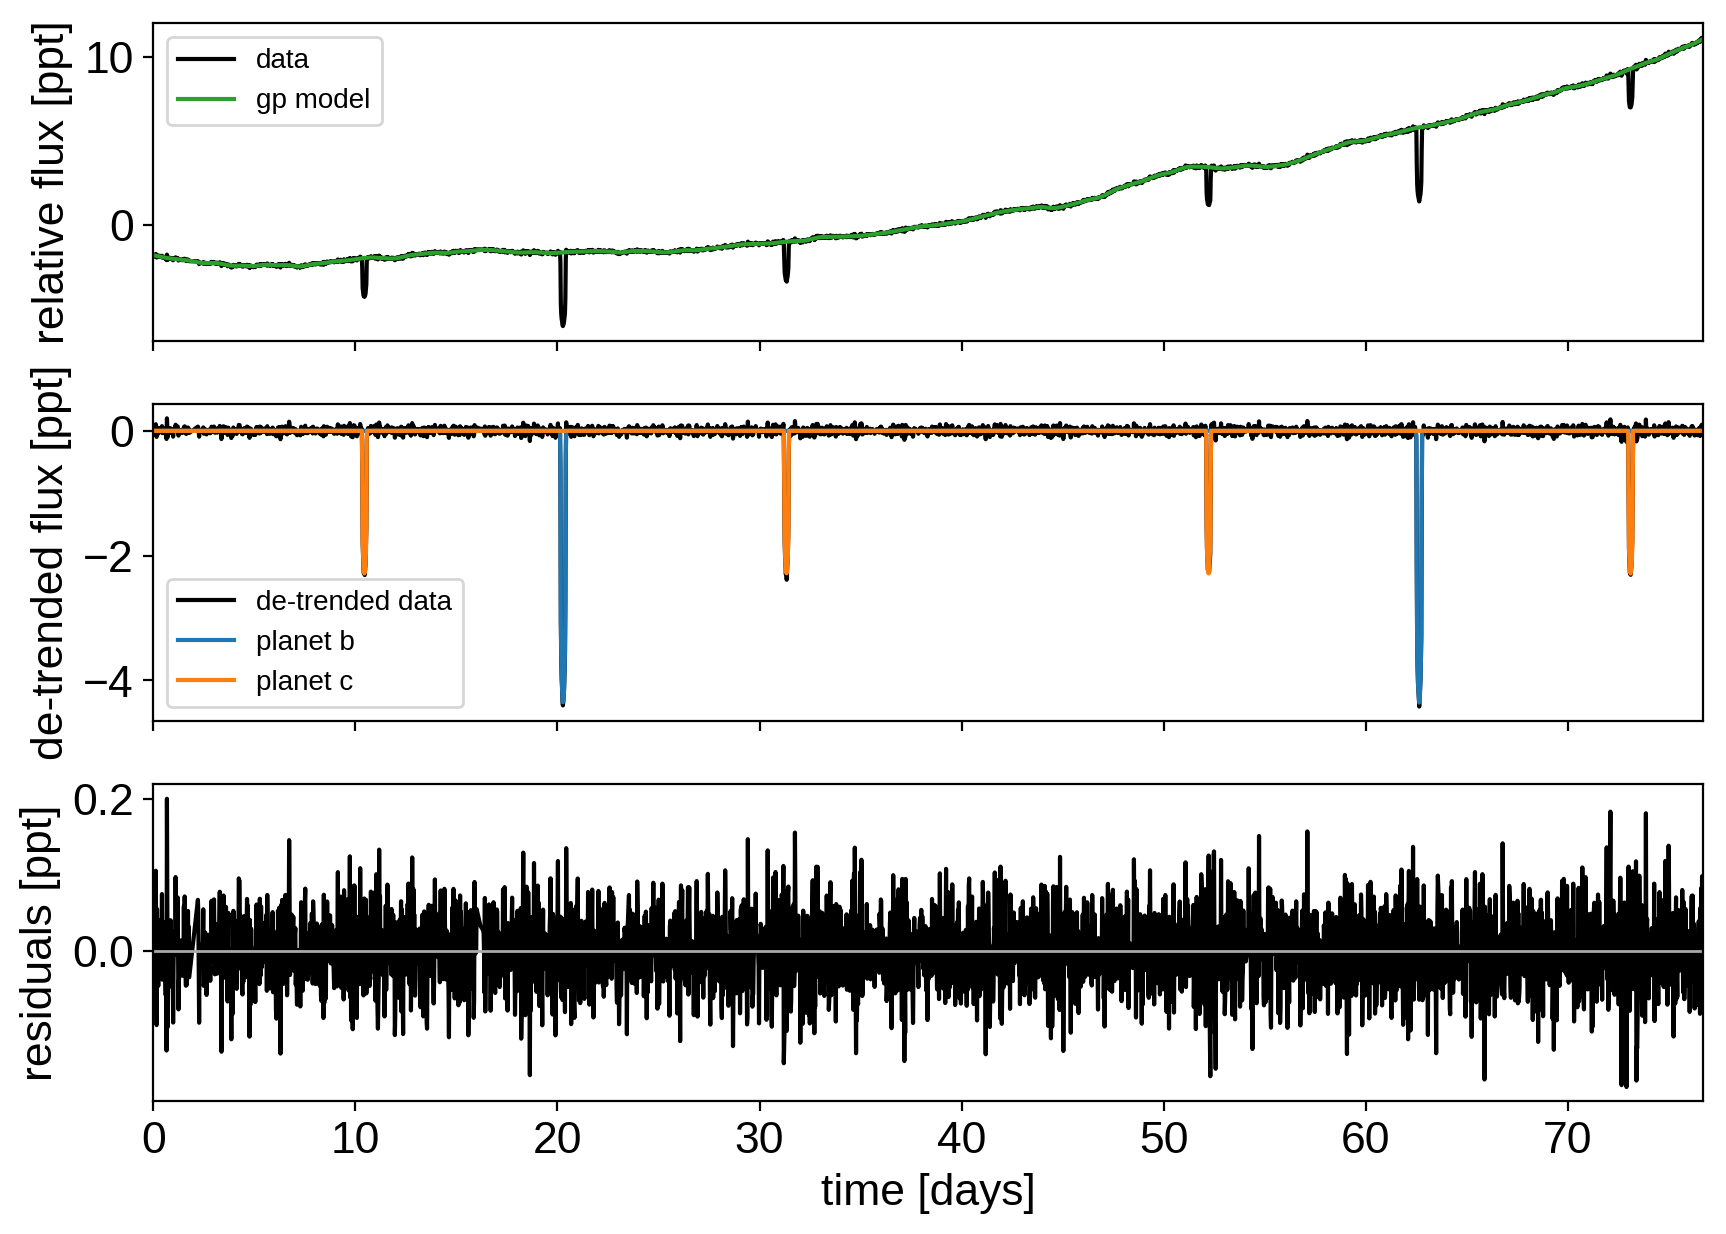

In [14]:
model, map_soln = build_model(mask, map_soln0)
plot_light_curve(map_soln, mask);

Great! Now we're ready to sample.

## Sampling

The sampling for this model is the same as for all the previous tutorials, but it takes a bit longer (about 2 hours on my laptop).
This is partly because the model is more expensive to compute than the previous ones and partly because there are some non-affine degeneracies in the problem (for example between impact parameter and eccentricity).
It might be worth thinking about reparameterizations (in terms of duration instead of eccentricity), but that's beyond the scope of this tutorial.
Besides, using more traditional MCMC methods, this would have taken a lot more than 2 hours to get >1000 effective samples!

In [15]:
np.random.seed(123)
sampler = xo.PyMC3Sampler(start=200, window=100, finish=500, chains=4)
with model:
    burnin = sampler.tune(tune=4500, start=map_soln,
                          step_kwargs=dict(target_accept=0.9))

Sampling 4 chains:   0%|          | 0/808 [00:00<?, ?draws/s]

Sampling 4 chains:   3%|▎         | 21/808 [00:00<00:24, 31.95draws/s]

Sampling 4 chains:   3%|▎         | 25/808 [00:01<00:51, 15.07draws/s]

Sampling 4 chains:   4%|▎         | 29/808 [00:01<01:10, 11.02draws/s]

Sampling 4 chains:   4%|▍         | 33/808 [00:02<01:24,  9.19draws/s]

Sampling 4 chains:   5%|▍         | 37/808 [00:03<01:32,  8.30draws/s]

Sampling 4 chains:   5%|▍         | 39/808 [00:03<01:16, 10.01draws/s]

Sampling 4 chains:   5%|▌         | 41/808 [00:03<01:50,  6.93draws/s]

Sampling 4 chains:   5%|▌         | 43/808 [00:03<01:29,  8.51draws/s]

Sampling 4 chains:   6%|▌         | 45/808 [00:04<01:58,  6.46draws/s]

Sampling 4 chains:   6%|▌         | 46/808 [00:04<01:46,  7.12draws/s]

Sampling 4 chains:   6%|▌         | 49/808 [00:04<01:51,  6.80draws/s]

Sampling 4 chains:   6%|▌         | 50/808 [00:04<01:46,  7.09draws/s]

Sampling 4 chains:   7%|▋         | 53/808 [00:05<01:49,  6.88draws/s]

Sampling 4 chains:   7%|▋         | 54/808 [00:05<01:46,  7.07draws/s]

Sampling 4 chains:   7%|▋         | 57/808 [00:06<01:48,  6.91draws/s]

Sampling 4 chains:   7%|▋         | 58/808 [00:06<01:48,  6.91draws/s]

Sampling 4 chains:   8%|▊         | 61/808 [00:06<01:48,  6.86draws/s]

Sampling 4 chains:   8%|▊         | 62/808 [00:06<01:50,  6.75draws/s]

Sampling 4 chains:   8%|▊         | 65/808 [00:07<01:49,  6.77draws/s]

Sampling 4 chains:   8%|▊         | 66/808 [00:07<01:52,  6.58draws/s]

Sampling 4 chains:   9%|▊         | 69/808 [00:07<01:50,  6.70draws/s]

Sampling 4 chains:   9%|▊         | 70/808 [00:07<01:54,  6.42draws/s]

Sampling 4 chains:   9%|▉         | 72/808 [00:08<01:31,  8.05draws/s]

Sampling 4 chains:   9%|▉         | 74/808 [00:08<01:58,  6.17draws/s]

Sampling 4 chains:   9%|▉         | 76/808 [00:08<01:34,  7.73draws/s]

Sampling 4 chains:  10%|▉         | 78/808 [00:09<02:00,  6.08draws/s]

Sampling 4 chains:  10%|▉         | 80/808 [00:09<01:36,  7.53draws/s]

Sampling 4 chains:  10%|█         | 82/808 [00:09<01:59,  6.06draws/s]

Sampling 4 chains:  10%|█         | 84/808 [00:09<01:37,  7.45draws/s]

Sampling 4 chains:  11%|█         | 86/808 [00:10<01:59,  6.03draws/s]

Sampling 4 chains:  11%|█         | 88/808 [00:10<01:37,  7.39draws/s]

Sampling 4 chains:  11%|█         | 90/808 [00:10<01:58,  6.05draws/s]

Sampling 4 chains:  11%|█▏        | 92/808 [00:11<01:37,  7.35draws/s]

Sampling 4 chains:  12%|█▏        | 94/808 [00:11<01:57,  6.07draws/s]

Sampling 4 chains:  12%|█▏        | 96/808 [00:11<01:37,  7.27draws/s]

Sampling 4 chains:  12%|█▏        | 98/808 [00:12<01:56,  6.10draws/s]

Sampling 4 chains:  12%|█▏        | 100/808 [00:12<01:37,  7.24draws/s]

Sampling 4 chains:  12%|█▎        | 101/808 [00:12<02:10,  5.40draws/s]

Sampling 4 chains:  13%|█▎        | 102/808 [00:12<02:03,  5.71draws/s]

Sampling 4 chains:  13%|█▎        | 104/808 [00:12<01:43,  6.83draws/s]

Sampling 4 chains:  13%|█▎        | 105/808 [00:13<02:12,  5.30draws/s]

Sampling 4 chains:  13%|█▎        | 106/808 [00:13<02:04,  5.63draws/s]

Sampling 4 chains:  13%|█▎        | 108/808 [00:13<01:44,  6.70draws/s]

Sampling 4 chains:  13%|█▎        | 109/808 [00:13<02:11,  5.33draws/s]

Sampling 4 chains:  14%|█▎        | 110/808 [00:13<02:04,  5.62draws/s]

Sampling 4 chains:  14%|█▍        | 112/808 [00:14<01:44,  6.64draws/s]

Sampling 4 chains:  14%|█▍        | 113/808 [00:14<02:08,  5.40draws/s]

Sampling 4 chains:  14%|█▍        | 114/808 [00:14<02:03,  5.62draws/s]

Sampling 4 chains:  14%|█▍        | 116/808 [00:14<01:45,  6.54draws/s]

Sampling 4 chains:  14%|█▍        | 117/808 [00:14<02:04,  5.55draws/s]

Sampling 4 chains:  15%|█▍        | 118/808 [00:15<02:01,  5.69draws/s]

Sampling 4 chains:  15%|█▍        | 120/808 [00:15<01:44,  6.55draws/s]

Sampling 4 chains:  15%|█▍        | 121/808 [00:15<02:01,  5.67draws/s]

Sampling 4 chains:  15%|█▌        | 122/808 [00:15<02:00,  5.67draws/s]

Sampling 4 chains:  15%|█▌        | 124/808 [00:15<01:44,  6.53draws/s]

Sampling 4 chains:  15%|█▌        | 125/808 [00:16<01:58,  5.78draws/s]

Sampling 4 chains:  16%|█▌        | 126/808 [00:16<01:59,  5.70draws/s]

Sampling 4 chains:  16%|█▌        | 128/808 [00:16<01:44,  6.51draws/s]

Sampling 4 chains:  16%|█▌        | 129/808 [00:16<01:56,  5.85draws/s]

Sampling 4 chains:  16%|█▌        | 130/808 [00:16<01:57,  5.75draws/s]

Sampling 4 chains:  16%|█▋        | 132/808 [00:17<01:43,  6.50draws/s]

Sampling 4 chains:  16%|█▋        | 133/808 [00:17<01:53,  5.96draws/s]

Sampling 4 chains:  17%|█▋        | 134/808 [00:17<01:56,  5.80draws/s]

Sampling 4 chains:  17%|█▋        | 136/808 [00:17<01:43,  6.50draws/s]

Sampling 4 chains:  17%|█▋        | 137/808 [00:17<01:50,  6.07draws/s]

Sampling 4 chains:  17%|█▋        | 138/808 [00:18<01:55,  5.81draws/s]

Sampling 4 chains:  17%|█▋        | 140/808 [00:18<01:44,  6.39draws/s]

Sampling 4 chains:  17%|█▋        | 141/808 [00:18<01:47,  6.23draws/s]

Sampling 4 chains:  18%|█▊        | 142/808 [00:18<01:52,  5.93draws/s]

Sampling 4 chains:  18%|█▊        | 144/808 [00:18<01:43,  6.44draws/s]

Sampling 4 chains:  18%|█▊        | 145/808 [00:19<01:43,  6.41draws/s]

Sampling 4 chains:  18%|█▊        | 146/808 [00:19<01:51,  5.96draws/s]

Sampling 4 chains:  18%|█▊        | 148/808 [00:19<01:42,  6.44draws/s]

Sampling 4 chains:  18%|█▊        | 149/808 [00:19<01:40,  6.55draws/s]

Sampling 4 chains:  19%|█▊        | 150/808 [00:19<01:49,  6.01draws/s]

Sampling 4 chains:  19%|█▉        | 152/808 [00:20<01:42,  6.43draws/s]

Sampling 4 chains:  19%|█▉        | 153/808 [00:20<01:37,  6.69draws/s]

Sampling 4 chains:  19%|█▉        | 154/808 [00:20<01:47,  6.06draws/s]

Sampling 4 chains:  19%|█▉        | 156/808 [00:20<01:41,  6.42draws/s]

Sampling 4 chains:  19%|█▉        | 157/808 [00:20<01:35,  6.79draws/s]

Sampling 4 chains:  20%|█▉        | 158/808 [00:21<01:46,  6.12draws/s]

Sampling 4 chains:  20%|█▉        | 160/808 [00:21<01:41,  6.41draws/s]

Sampling 4 chains:  20%|█▉        | 161/808 [00:21<01:33,  6.93draws/s]

Sampling 4 chains:  20%|██        | 162/808 [00:21<01:44,  6.18draws/s]

Sampling 4 chains:  20%|██        | 164/808 [00:22<01:40,  6.38draws/s]

Sampling 4 chains:  20%|██        | 165/808 [00:22<01:30,  7.13draws/s]

Sampling 4 chains:  21%|██        | 166/808 [00:22<01:42,  6.24draws/s]

Sampling 4 chains:  21%|██        | 168/808 [00:22<01:40,  6.38draws/s]

Sampling 4 chains:  21%|██        | 170/808 [00:22<01:38,  6.46draws/s]

Sampling 4 chains:  21%|██▏       | 172/808 [00:23<01:38,  6.49draws/s]

Sampling 4 chains:  22%|██▏       | 174/808 [00:23<01:36,  6.59draws/s]

Sampling 4 chains:  22%|██▏       | 176/808 [00:23<01:36,  6.53draws/s]

Sampling 4 chains:  22%|██▏       | 178/808 [00:24<01:35,  6.57draws/s]

Sampling 4 chains:  22%|██▏       | 180/808 [00:24<01:35,  6.55draws/s]

Sampling 4 chains:  23%|██▎       | 182/808 [00:24<01:34,  6.64draws/s]

Sampling 4 chains:  23%|██▎       | 184/808 [00:25<01:35,  6.56draws/s]

Sampling 4 chains:  23%|██▎       | 186/808 [00:25<01:32,  6.70draws/s]

Sampling 4 chains:  23%|██▎       | 188/808 [00:25<01:34,  6.55draws/s]

Sampling 4 chains:  24%|██▎       | 190/808 [00:25<01:31,  6.74draws/s]

Sampling 4 chains:  24%|██▍       | 192/808 [00:26<01:34,  6.53draws/s]

Sampling 4 chains:  24%|██▍       | 194/808 [00:26<01:30,  6.78draws/s]

Sampling 4 chains:  24%|██▍       | 196/808 [00:26<01:34,  6.50draws/s]

Sampling 4 chains:  25%|██▍       | 198/808 [00:27<01:29,  6.81draws/s]

Sampling 4 chains:  25%|██▍       | 200/808 [00:27<01:33,  6.48draws/s]

Sampling 4 chains:  25%|██▌       | 202/808 [00:27<01:28,  6.84draws/s]

Sampling 4 chains:  25%|██▌       | 204/808 [00:28<01:33,  6.44draws/s]

Sampling 4 chains:  25%|██▌       | 206/808 [00:28<01:27,  6.85draws/s]

Sampling 4 chains:  26%|██▌       | 208/808 [00:28<01:32,  6.49draws/s]

Sampling 4 chains:  26%|██▌       | 210/808 [00:28<01:27,  6.87draws/s]

Sampling 4 chains:  26%|██▌       | 212/808 [00:29<01:31,  6.52draws/s]

Sampling 4 chains:  26%|██▋       | 214/808 [00:29<01:27,  6.80draws/s]

Sampling 4 chains:  27%|██▋       | 216/808 [00:29<01:30,  6.57draws/s]

Sampling 4 chains:  27%|██▋       | 218/808 [00:30<01:26,  6.80draws/s]

Sampling 4 chains:  27%|██▋       | 220/808 [00:30<01:29,  6.61draws/s]

Sampling 4 chains:  27%|██▋       | 222/808 [00:30<01:26,  6.79draws/s]

Sampling 4 chains:  28%|██▊       | 224/808 [00:31<01:28,  6.63draws/s]

Sampling 4 chains:  28%|██▊       | 226/808 [00:31<01:25,  6.78draws/s]

Sampling 4 chains:  28%|██▊       | 228/808 [00:31<01:27,  6.65draws/s]

Sampling 4 chains:  28%|██▊       | 230/808 [00:31<01:25,  6.77draws/s]

Sampling 4 chains:  29%|██▊       | 232/808 [00:32<01:26,  6.65draws/s]

Sampling 4 chains:  29%|██▉       | 234/808 [00:32<01:24,  6.76draws/s]

Sampling 4 chains:  29%|██▉       | 236/808 [00:32<01:25,  6.68draws/s]

Sampling 4 chains:  29%|██▉       | 238/808 [00:33<01:24,  6.74draws/s]

Sampling 4 chains:  30%|██▉       | 240/808 [00:33<01:24,  6.71draws/s]

Sampling 4 chains:  30%|██▉       | 241/808 [00:33<01:19,  7.17draws/s]

Sampling 4 chains:  30%|██▉       | 242/808 [00:33<01:25,  6.59draws/s]

Sampling 4 chains:  30%|███       | 244/808 [00:34<01:25,  6.63draws/s]

Sampling 4 chains:  30%|███       | 245/808 [00:34<01:21,  6.95draws/s]

Sampling 4 chains:  30%|███       | 246/808 [00:34<01:25,  6.54draws/s]

Sampling 4 chains:  31%|███       | 248/808 [00:34<01:24,  6.64draws/s]

Sampling 4 chains:  31%|███       | 249/808 [00:34<01:22,  6.79draws/s]

Sampling 4 chains:  31%|███       | 250/808 [00:34<01:25,  6.52draws/s]

Sampling 4 chains:  31%|███       | 252/808 [00:35<01:23,  6.66draws/s]

Sampling 4 chains:  31%|███▏      | 253/808 [00:35<01:23,  6.64draws/s]

Sampling 4 chains:  31%|███▏      | 254/808 [00:35<01:24,  6.52draws/s]

Sampling 4 chains:  32%|███▏      | 256/808 [00:35<01:22,  6.68draws/s]

Sampling 4 chains:  32%|███▏      | 257/808 [00:35<01:24,  6.50draws/s]

Sampling 4 chains:  32%|███▏      | 258/808 [00:36<01:24,  6.53draws/s]

Sampling 4 chains:  32%|███▏      | 260/808 [00:36<01:21,  6.71draws/s]

Sampling 4 chains:  32%|███▏      | 261/808 [00:36<01:25,  6.38draws/s]

Sampling 4 chains:  32%|███▏      | 262/808 [00:36<01:23,  6.53draws/s]

Sampling 4 chains:  33%|███▎      | 264/808 [00:36<01:20,  6.73draws/s]

Sampling 4 chains:  33%|███▎      | 265/808 [00:37<01:26,  6.25draws/s]

Sampling 4 chains:  33%|███▎      | 266/808 [00:37<01:25,  6.36draws/s]

Sampling 4 chains:  33%|███▎      | 268/808 [00:37<01:20,  6.73draws/s]

Sampling 4 chains:  33%|███▎      | 269/808 [00:37<01:28,  6.12draws/s]

Sampling 4 chains:  33%|███▎      | 270/808 [00:37<01:24,  6.34draws/s]

Sampling 4 chains:  34%|███▎      | 272/808 [00:38<01:19,  6.76draws/s]

Sampling 4 chains:  34%|███▍      | 273/808 [00:38<01:29,  6.01draws/s]

Sampling 4 chains:  34%|███▍      | 274/808 [00:38<01:24,  6.34draws/s]

Sampling 4 chains:  34%|███▍      | 276/808 [00:38<01:18,  6.76draws/s]

Sampling 4 chains:  34%|███▍      | 277/808 [00:38<01:29,  5.92draws/s]

Sampling 4 chains:  34%|███▍      | 278/808 [00:39<01:23,  6.36draws/s]

Sampling 4 chains:  35%|███▍      | 280/808 [00:39<01:17,  6.81draws/s]

Sampling 4 chains:  35%|███▍      | 281/808 [00:39<01:30,  5.82draws/s]

Sampling 4 chains:  35%|███▍      | 282/808 [00:39<01:22,  6.36draws/s]

Sampling 4 chains:  35%|███▌      | 284/808 [00:39<01:16,  6.85draws/s]

Sampling 4 chains:  35%|███▌      | 285/808 [00:40<01:31,  5.72draws/s]

Sampling 4 chains:  35%|███▌      | 286/808 [00:40<01:22,  6.36draws/s]

Sampling 4 chains:  36%|███▌      | 288/808 [00:40<01:15,  6.88draws/s]

Sampling 4 chains:  36%|███▌      | 289/808 [00:40<01:32,  5.63draws/s]

Sampling 4 chains:  36%|███▌      | 290/808 [00:40<01:21,  6.36draws/s]

Sampling 4 chains:  36%|███▌      | 292/808 [00:41<01:14,  6.91draws/s]

Sampling 4 chains:  36%|███▋      | 293/808 [00:41<01:33,  5.54draws/s]

Sampling 4 chains:  36%|███▋      | 294/808 [00:41<01:20,  6.36draws/s]

Sampling 4 chains:  37%|███▋      | 296/808 [00:41<01:13,  6.95draws/s]

Sampling 4 chains:  37%|███▋      | 297/808 [00:42<01:33,  5.45draws/s]

Sampling 4 chains:  37%|███▋      | 299/808 [00:42<01:17,  6.59draws/s]

Sampling 4 chains:  37%|███▋      | 300/808 [00:42<01:19,  6.43draws/s]

Sampling 4 chains:  37%|███▋      | 301/808 [00:42<01:45,  4.80draws/s]

Sampling 4 chains:  38%|███▊      | 303/808 [00:42<01:21,  6.20draws/s]

Sampling 4 chains:  38%|███▊      | 305/808 [00:43<01:34,  5.31draws/s]

Sampling 4 chains:  38%|███▊      | 308/808 [00:43<01:18,  6.38draws/s]

Sampling 4 chains:  38%|███▊      | 309/808 [00:43<01:51,  4.47draws/s]

Sampling 4 chains:  39%|███▊      | 312/808 [00:44<01:28,  5.62draws/s]

Sampling 4 chains:  39%|███▊      | 313/808 [00:44<02:00,  4.12draws/s]

Sampling 4 chains:  39%|███▉      | 316/808 [00:44<01:33,  5.26draws/s]

Sampling 4 chains:  39%|███▉      | 317/808 [00:45<02:04,  3.95draws/s]

Sampling 4 chains:  40%|███▉      | 320/808 [00:45<01:36,  5.08draws/s]

Sampling 4 chains:  40%|███▉      | 321/808 [00:45<02:05,  3.87draws/s]

Sampling 4 chains:  40%|████      | 324/808 [00:45<01:38,  4.93draws/s]

Sampling 4 chains:  40%|████      | 325/808 [00:46<02:03,  3.91draws/s]

Sampling 4 chains:  41%|████      | 328/808 [00:46<01:36,  4.99draws/s]

Sampling 4 chains:  41%|████      | 329/808 [00:46<02:02,  3.91draws/s]

Sampling 4 chains:  41%|████      | 332/808 [00:47<01:36,  4.93draws/s]

Sampling 4 chains:  41%|████      | 333/808 [00:47<01:58,  4.01draws/s]

Sampling 4 chains:  42%|████▏     | 336/808 [00:47<01:33,  5.05draws/s]

Sampling 4 chains:  42%|████▏     | 337/808 [00:48<01:56,  4.05draws/s]

Sampling 4 chains:  42%|████▏     | 340/808 [00:48<01:32,  5.05draws/s]

Sampling 4 chains:  42%|████▏     | 341/808 [00:48<01:53,  4.13draws/s]

Sampling 4 chains:  43%|████▎     | 344/808 [00:48<01:30,  5.14draws/s]

Sampling 4 chains:  43%|████▎     | 345/808 [00:49<01:51,  4.16draws/s]

Sampling 4 chains:  43%|████▎     | 348/808 [00:49<01:29,  5.13draws/s]

Sampling 4 chains:  43%|████▎     | 349/808 [00:49<01:48,  4.24draws/s]

Sampling 4 chains:  44%|████▎     | 352/808 [00:50<01:27,  5.23draws/s]

Sampling 4 chains:  44%|████▎     | 353/808 [00:50<01:46,  4.27draws/s]

Sampling 4 chains:  44%|████▍     | 356/808 [00:50<01:26,  5.21draws/s]

Sampling 4 chains:  44%|████▍     | 357/808 [00:51<01:43,  4.34draws/s]

Sampling 4 chains:  45%|████▍     | 360/808 [00:51<01:24,  5.30draws/s]

Sampling 4 chains:  45%|████▍     | 361/808 [00:51<01:42,  4.37draws/s]

Sampling 4 chains:  45%|████▌     | 364/808 [00:51<01:24,  5.27draws/s]

Sampling 4 chains:  45%|████▌     | 365/808 [00:52<01:38,  4.50draws/s]

Sampling 4 chains:  45%|████▌     | 367/808 [00:52<01:15,  5.85draws/s]

Sampling 4 chains:  46%|████▌     | 369/808 [00:52<01:25,  5.15draws/s]

Sampling 4 chains:  46%|████▌     | 371/808 [00:52<01:06,  6.58draws/s]

Sampling 4 chains:  46%|████▌     | 373/808 [00:53<01:18,  5.56draws/s]

Sampling 4 chains:  46%|████▋     | 375/808 [00:53<01:02,  6.98draws/s]

Sampling 4 chains:  47%|████▋     | 377/808 [00:54<01:14,  5.80draws/s]

Sampling 4 chains:  47%|████▋     | 379/808 [00:54<00:59,  7.18draws/s]

Sampling 4 chains:  47%|████▋     | 381/808 [00:54<01:11,  5.94draws/s]

Sampling 4 chains:  47%|████▋     | 383/808 [00:54<00:58,  7.25draws/s]

Sampling 4 chains:  48%|████▊     | 385/808 [00:55<01:10,  6.03draws/s]

Sampling 4 chains:  48%|████▊     | 387/808 [00:55<00:57,  7.27draws/s]

Sampling 4 chains:  48%|████▊     | 389/808 [00:55<01:08,  6.09draws/s]

Sampling 4 chains:  48%|████▊     | 391/808 [00:56<00:57,  7.26draws/s]

Sampling 4 chains:  49%|████▊     | 393/808 [00:56<01:07,  6.11draws/s]

Sampling 4 chains:  49%|████▉     | 395/808 [00:56<00:57,  7.24draws/s]

Sampling 4 chains:  49%|████▉     | 396/808 [00:56<01:01,  6.73draws/s]

Sampling 4 chains:  49%|████▉     | 397/808 [00:57<01:15,  5.44draws/s]

Sampling 4 chains:  49%|████▉     | 399/808 [00:57<01:02,  6.51draws/s]

Sampling 4 chains:  50%|████▉     | 400/808 [00:57<01:03,  6.41draws/s]

Sampling 4 chains:  50%|████▉     | 401/808 [00:57<01:17,  5.27draws/s]

Sampling 4 chains:  50%|████▉     | 403/808 [00:57<01:04,  6.29draws/s]

Sampling 4 chains:  50%|█████     | 404/808 [00:58<01:07,  6.02draws/s]

Sampling 4 chains:  50%|█████     | 405/808 [00:58<01:15,  5.33draws/s]

Sampling 4 chains:  50%|█████     | 407/808 [00:58<01:03,  6.29draws/s]

Sampling 4 chains:  50%|█████     | 408/808 [00:58<01:05,  6.14draws/s]

Sampling 4 chains:  51%|█████     | 409/808 [00:58<01:14,  5.37draws/s]

Sampling 4 chains:  51%|█████     | 410/808 [00:58<01:04,  6.22draws/s]

Sampling 4 chains:  51%|█████     | 412/808 [00:59<01:01,  6.45draws/s]

Sampling 4 chains:  51%|█████     | 413/808 [00:59<01:07,  5.81draws/s]

Sampling 4 chains:  51%|█████     | 414/808 [00:59<00:59,  6.60draws/s]

Sampling 4 chains:  51%|█████▏    | 416/808 [00:59<00:57,  6.77draws/s]

Sampling 4 chains:  52%|█████▏    | 417/808 [01:00<01:05,  5.94draws/s]

Sampling 4 chains:  52%|█████▏    | 418/808 [01:00<00:58,  6.70draws/s]

Sampling 4 chains:  52%|█████▏    | 419/808 [01:00<00:52,  7.37draws/s]

Sampling 4 chains:  52%|█████▏    | 420/808 [01:00<00:59,  6.49draws/s]

Sampling 4 chains:  52%|█████▏    | 421/808 [01:00<01:03,  6.06draws/s]

Sampling 4 chains:  52%|█████▏    | 422/808 [01:00<00:56,  6.78draws/s]

Sampling 4 chains:  52%|█████▏    | 423/808 [01:00<00:52,  7.33draws/s]

Sampling 4 chains:  52%|█████▏    | 424/808 [01:01<00:58,  6.62draws/s]

Sampling 4 chains:  53%|█████▎    | 425/808 [01:01<01:02,  6.09draws/s]

Sampling 4 chains:  53%|█████▎    | 426/808 [01:01<00:56,  6.79draws/s]

Sampling 4 chains:  53%|█████▎    | 427/808 [01:01<00:52,  7.24draws/s]

Sampling 4 chains:  53%|█████▎    | 428/808 [01:01<00:59,  6.41draws/s]

Sampling 4 chains:  53%|█████▎    | 429/808 [01:01<01:01,  6.18draws/s]

Sampling 4 chains:  53%|█████▎    | 430/808 [01:01<00:55,  6.77draws/s]

Sampling 4 chains:  53%|█████▎    | 431/808 [01:02<00:52,  7.21draws/s]

Sampling 4 chains:  53%|█████▎    | 432/808 [01:02<00:57,  6.54draws/s]

Sampling 4 chains:  54%|█████▎    | 433/808 [01:02<01:00,  6.22draws/s]

Sampling 4 chains:  54%|█████▎    | 434/808 [01:02<00:55,  6.77draws/s]

Sampling 4 chains:  54%|█████▍    | 435/808 [01:02<00:52,  7.13draws/s]

Sampling 4 chains:  54%|█████▍    | 436/808 [01:02<00:55,  6.64draws/s]

Sampling 4 chains:  54%|█████▍    | 437/808 [01:03<00:59,  6.24draws/s]

Sampling 4 chains:  54%|█████▍    | 438/808 [01:03<00:54,  6.77draws/s]

Sampling 4 chains:  54%|█████▍    | 439/808 [01:03<00:52,  7.04draws/s]

Sampling 4 chains:  54%|█████▍    | 440/808 [01:03<00:54,  6.74draws/s]

Sampling 4 chains:  55%|█████▍    | 441/808 [01:03<00:58,  6.26draws/s]

Sampling 4 chains:  55%|█████▍    | 442/808 [01:03<00:54,  6.77draws/s]

Sampling 4 chains:  55%|█████▍    | 443/808 [01:03<00:53,  6.87draws/s]

Sampling 4 chains:  55%|█████▍    | 444/808 [01:04<00:53,  6.85draws/s]

Sampling 4 chains:  55%|█████▌    | 445/808 [01:04<00:57,  6.28draws/s]

Sampling 4 chains:  55%|█████▌    | 446/808 [01:04<00:53,  6.78draws/s]

Sampling 4 chains:  55%|█████▌    | 447/808 [01:04<00:53,  6.77draws/s]

Sampling 4 chains:  55%|█████▌    | 448/808 [01:04<00:52,  6.89draws/s]

Sampling 4 chains:  56%|█████▌    | 449/808 [01:04<00:56,  6.34draws/s]

Sampling 4 chains:  56%|█████▌    | 450/808 [01:04<00:52,  6.78draws/s]

Sampling 4 chains:  56%|█████▌    | 451/808 [01:05<00:53,  6.68draws/s]

Sampling 4 chains:  56%|█████▌    | 452/808 [01:05<00:50,  6.99draws/s]

Sampling 4 chains:  56%|█████▌    | 453/808 [01:05<00:55,  6.36draws/s]

Sampling 4 chains:  56%|█████▌    | 454/808 [01:05<00:52,  6.77draws/s]

Sampling 4 chains:  56%|█████▋    | 455/808 [01:05<00:53,  6.57draws/s]

Sampling 4 chains:  56%|█████▋    | 456/808 [01:05<00:49,  7.09draws/s]

Sampling 4 chains:  57%|█████▋    | 457/808 [01:06<00:55,  6.38draws/s]

Sampling 4 chains:  57%|█████▋    | 458/808 [01:06<00:51,  6.76draws/s]

Sampling 4 chains:  57%|█████▋    | 459/808 [01:06<00:53,  6.48draws/s]

Sampling 4 chains:  57%|█████▋    | 460/808 [01:06<00:48,  7.19draws/s]

Sampling 4 chains:  57%|█████▋    | 461/808 [01:06<00:54,  6.39draws/s]

Sampling 4 chains:  57%|█████▋    | 462/808 [01:06<00:51,  6.76draws/s]

Sampling 4 chains:  57%|█████▋    | 463/808 [01:06<00:53,  6.40draws/s]

Sampling 4 chains:  58%|█████▊    | 465/808 [01:07<00:52,  6.51draws/s]

Sampling 4 chains:  58%|█████▊    | 466/808 [01:07<00:49,  6.84draws/s]

Sampling 4 chains:  58%|█████▊    | 467/808 [01:07<00:53,  6.37draws/s]

Sampling 4 chains:  58%|█████▊    | 469/808 [01:07<00:52,  6.52draws/s]

Sampling 4 chains:  58%|█████▊    | 470/808 [01:07<00:49,  6.89draws/s]

Sampling 4 chains:  58%|█████▊    | 471/808 [01:08<00:53,  6.32draws/s]

Sampling 4 chains:  59%|█████▊    | 473/808 [01:08<00:51,  6.53draws/s]

Sampling 4 chains:  59%|█████▊    | 474/808 [01:08<00:48,  6.89draws/s]

Sampling 4 chains:  59%|█████▉    | 475/808 [01:08<00:53,  6.23draws/s]

Sampling 4 chains:  59%|█████▉    | 477/808 [01:08<00:50,  6.53draws/s]

Sampling 4 chains:  59%|█████▉    | 478/808 [01:09<00:48,  6.86draws/s]

Sampling 4 chains:  59%|█████▉    | 479/808 [01:09<00:53,  6.13draws/s]

Sampling 4 chains:  60%|█████▉    | 481/808 [01:09<00:50,  6.50draws/s]

Sampling 4 chains:  60%|█████▉    | 482/808 [01:09<00:47,  6.82draws/s]

Sampling 4 chains:  60%|█████▉    | 483/808 [01:09<00:53,  6.03draws/s]

Sampling 4 chains:  60%|██████    | 485/808 [01:10<00:49,  6.47draws/s]

Sampling 4 chains:  60%|██████    | 486/808 [01:10<00:47,  6.77draws/s]

Sampling 4 chains:  60%|██████    | 487/808 [01:10<00:54,  5.94draws/s]

Sampling 4 chains:  61%|██████    | 489/808 [01:10<00:49,  6.45draws/s]

Sampling 4 chains:  61%|██████    | 490/808 [01:10<00:47,  6.74draws/s]

Sampling 4 chains:  61%|██████    | 491/808 [01:11<00:54,  5.84draws/s]

Sampling 4 chains:  61%|██████    | 493/808 [01:11<00:49,  6.42draws/s]

Sampling 4 chains:  61%|██████    | 494/808 [01:11<00:46,  6.70draws/s]

Sampling 4 chains:  61%|██████▏   | 495/808 [01:11<00:54,  5.76draws/s]

Sampling 4 chains:  62%|██████▏   | 497/808 [01:11<00:48,  6.40draws/s]

Sampling 4 chains:  62%|██████▏   | 498/808 [01:12<00:46,  6.65draws/s]

Sampling 4 chains:  62%|██████▏   | 499/808 [01:12<00:53,  5.76draws/s]

Sampling 4 chains:  62%|██████▏   | 501/808 [01:12<00:47,  6.40draws/s]

Sampling 4 chains:  62%|██████▏   | 502/808 [01:12<00:46,  6.63draws/s]

Sampling 4 chains:  62%|██████▏   | 503/808 [01:12<00:52,  5.79draws/s]

Sampling 4 chains:  62%|██████▎   | 505/808 [01:13<00:47,  6.40draws/s]

Sampling 4 chains:  63%|██████▎   | 506/808 [01:13<00:45,  6.62draws/s]

Sampling 4 chains:  63%|██████▎   | 507/808 [01:13<00:51,  5.83draws/s]

Sampling 4 chains:  63%|██████▎   | 509/808 [01:13<00:46,  6.42draws/s]

Sampling 4 chains:  63%|██████▎   | 510/808 [01:13<00:45,  6.62draws/s]

Sampling 4 chains:  63%|██████▎   | 511/808 [01:14<00:50,  5.87draws/s]

Sampling 4 chains:  63%|██████▎   | 513/808 [01:14<00:45,  6.43draws/s]

Sampling 4 chains:  64%|██████▎   | 514/808 [01:14<00:44,  6.61draws/s]

Sampling 4 chains:  64%|██████▎   | 515/808 [01:14<00:49,  5.91draws/s]

Sampling 4 chains:  64%|██████▍   | 517/808 [01:14<00:45,  6.45draws/s]

Sampling 4 chains:  64%|██████▍   | 518/808 [01:15<00:43,  6.62draws/s]

Sampling 4 chains:  64%|██████▍   | 519/808 [01:15<00:48,  5.95draws/s]

Sampling 4 chains:  64%|██████▍   | 521/808 [01:15<00:44,  6.47draws/s]

Sampling 4 chains:  65%|██████▍   | 522/808 [01:15<00:43,  6.60draws/s]

Sampling 4 chains:  65%|██████▍   | 523/808 [01:15<00:47,  6.00draws/s]

Sampling 4 chains:  65%|██████▍   | 525/808 [01:16<00:43,  6.48draws/s]

Sampling 4 chains:  65%|██████▌   | 526/808 [01:16<00:42,  6.57draws/s]

Sampling 4 chains:  65%|██████▌   | 527/808 [01:16<00:46,  6.05draws/s]

Sampling 4 chains:  65%|██████▌   | 529/808 [01:16<00:42,  6.50draws/s]

Sampling 4 chains:  66%|██████▌   | 530/808 [01:16<00:42,  6.56draws/s]

Sampling 4 chains:  66%|██████▌   | 531/808 [01:17<00:45,  6.11draws/s]

Sampling 4 chains:  66%|██████▌   | 532/808 [01:17<00:39,  6.91draws/s]

Sampling 4 chains:  66%|██████▌   | 533/808 [01:17<00:40,  6.73draws/s]

Sampling 4 chains:  66%|██████▌   | 534/808 [01:17<00:40,  6.69draws/s]

Sampling 4 chains:  66%|██████▌   | 535/808 [01:17<00:46,  5.88draws/s]

Sampling 4 chains:  66%|██████▋   | 537/808 [01:17<00:41,  6.53draws/s]

Sampling 4 chains:  67%|██████▋   | 538/808 [01:18<00:41,  6.47draws/s]

Sampling 4 chains:  67%|██████▋   | 539/808 [01:18<00:45,  5.86draws/s]

Sampling 4 chains:  67%|██████▋   | 541/808 [01:18<00:41,  6.49draws/s]

Sampling 4 chains:  67%|██████▋   | 542/808 [01:18<00:41,  6.44draws/s]

Sampling 4 chains:  67%|██████▋   | 543/808 [01:18<00:46,  5.68draws/s]

Sampling 4 chains:  67%|██████▋   | 545/808 [01:19<00:40,  6.43draws/s]

Sampling 4 chains:  68%|██████▊   | 546/808 [01:19<00:41,  6.39draws/s]

Sampling 4 chains:  68%|██████▊   | 547/808 [01:19<00:45,  5.70draws/s]

Sampling 4 chains:  68%|██████▊   | 549/808 [01:19<00:40,  6.43draws/s]

Sampling 4 chains:  68%|██████▊   | 550/808 [01:19<00:40,  6.36draws/s]

Sampling 4 chains:  68%|██████▊   | 551/808 [01:20<00:45,  5.70draws/s]

Sampling 4 chains:  68%|██████▊   | 553/808 [01:20<00:39,  6.44draws/s]

Sampling 4 chains:  69%|██████▊   | 554/808 [01:20<00:40,  6.32draws/s]

Sampling 4 chains:  69%|██████▊   | 555/808 [01:20<00:44,  5.73draws/s]

Sampling 4 chains:  69%|██████▉   | 556/808 [01:20<00:38,  6.48draws/s]

Sampling 4 chains:  69%|██████▉   | 557/808 [01:20<00:35,  7.08draws/s]

Sampling 4 chains:  69%|██████▉   | 558/808 [01:21<00:37,  6.69draws/s]

Sampling 4 chains:  69%|██████▉   | 559/808 [01:21<00:41,  6.01draws/s]

Sampling 4 chains:  69%|██████▉   | 560/808 [01:21<00:37,  6.57draws/s]

Sampling 4 chains:  69%|██████▉   | 561/808 [01:21<00:33,  7.28draws/s]

Sampling 4 chains:  70%|██████▉   | 562/808 [01:21<00:36,  6.79draws/s]

Sampling 4 chains:  70%|██████▉   | 563/808 [01:21<00:40,  6.12draws/s]

Sampling 4 chains:  70%|██████▉   | 564/808 [01:22<00:37,  6.52draws/s]

Sampling 4 chains:  70%|███████   | 566/808 [01:22<00:35,  6.77draws/s]

Sampling 4 chains:  70%|███████   | 567/808 [01:22<00:38,  6.19draws/s]

Sampling 4 chains:  70%|███████   | 568/808 [01:22<00:37,  6.41draws/s]

Sampling 4 chains:  71%|███████   | 570/808 [01:22<00:35,  6.74draws/s]

Sampling 4 chains:  71%|███████   | 571/808 [01:23<00:40,  5.90draws/s]

Sampling 4 chains:  71%|███████   | 572/808 [01:23<00:36,  6.41draws/s]

Sampling 4 chains:  71%|███████   | 574/808 [01:23<00:34,  6.78draws/s]

Sampling 4 chains:  71%|███████   | 575/808 [01:23<00:38,  5.98draws/s]

Sampling 4 chains:  71%|███████▏  | 576/808 [01:23<00:36,  6.34draws/s]

Sampling 4 chains:  72%|███████▏  | 578/808 [01:24<00:34,  6.76draws/s]

Sampling 4 chains:  72%|███████▏  | 579/808 [01:24<00:39,  5.75draws/s]

Sampling 4 chains:  72%|███████▏  | 580/808 [01:24<00:35,  6.35draws/s]

Sampling 4 chains:  72%|███████▏  | 582/808 [01:24<00:33,  6.80draws/s]

Sampling 4 chains:  72%|███████▏  | 583/808 [01:24<00:38,  5.83draws/s]

Sampling 4 chains:  72%|███████▏  | 584/808 [01:25<00:35,  6.29draws/s]

Sampling 4 chains:  73%|███████▎  | 586/808 [01:25<00:32,  6.79draws/s]

Sampling 4 chains:  73%|███████▎  | 587/808 [01:25<00:37,  5.87draws/s]

Sampling 4 chains:  73%|███████▎  | 588/808 [01:25<00:35,  6.19draws/s]

Sampling 4 chains:  73%|███████▎  | 590/808 [01:25<00:32,  6.75draws/s]

Sampling 4 chains:  73%|███████▎  | 591/808 [01:26<00:36,  5.91draws/s]

Sampling 4 chains:  73%|███████▎  | 592/808 [01:26<00:35,  6.10draws/s]

Sampling 4 chains:  74%|███████▎  | 594/808 [01:26<00:31,  6.71draws/s]

Sampling 4 chains:  74%|███████▎  | 595/808 [01:26<00:35,  5.94draws/s]

Sampling 4 chains:  74%|███████▍  | 596/808 [01:26<00:35,  6.01draws/s]

Sampling 4 chains:  74%|███████▍  | 598/808 [01:27<00:31,  6.67draws/s]

Sampling 4 chains:  74%|███████▍  | 599/808 [01:27<00:35,  5.96draws/s]

Sampling 4 chains:  74%|███████▍  | 600/808 [01:27<00:35,  5.93draws/s]

Sampling 4 chains:  75%|███████▍  | 602/808 [01:27<00:31,  6.62draws/s]

Sampling 4 chains:  75%|███████▍  | 603/808 [01:27<00:34,  6.00draws/s]

Sampling 4 chains:  75%|███████▍  | 604/808 [01:28<00:34,  5.84draws/s]

Sampling 4 chains:  75%|███████▌  | 606/808 [01:28<00:30,  6.58draws/s]

Sampling 4 chains:  75%|███████▌  | 607/808 [01:28<00:33,  6.04draws/s]

Sampling 4 chains:  75%|███████▌  | 608/808 [01:28<00:34,  5.76draws/s]

Sampling 4 chains:  75%|███████▌  | 610/808 [01:28<00:30,  6.54draws/s]

Sampling 4 chains:  76%|███████▌  | 611/808 [01:29<00:32,  6.08draws/s]

Sampling 4 chains:  76%|███████▌  | 612/808 [01:29<00:34,  5.68draws/s]

Sampling 4 chains:  76%|███████▌  | 614/808 [01:29<00:29,  6.50draws/s]

Sampling 4 chains:  76%|███████▌  | 615/808 [01:29<00:31,  6.12draws/s]

Sampling 4 chains:  76%|███████▌  | 616/808 [01:29<00:34,  5.60draws/s]

Sampling 4 chains:  76%|███████▋  | 618/808 [01:30<00:29,  6.46draws/s]

Sampling 4 chains:  77%|███████▋  | 619/808 [01:30<00:30,  6.16draws/s]

Sampling 4 chains:  77%|███████▋  | 620/808 [01:30<00:33,  5.55draws/s]

Sampling 4 chains:  77%|███████▋  | 622/808 [01:30<00:28,  6.43draws/s]

Sampling 4 chains:  77%|███████▋  | 623/808 [01:30<00:29,  6.20draws/s]

Sampling 4 chains:  77%|███████▋  | 624/808 [01:31<00:33,  5.54draws/s]

Sampling 4 chains:  77%|███████▋  | 626/808 [01:31<00:28,  6.40draws/s]

Sampling 4 chains:  78%|███████▊  | 627/808 [01:31<00:28,  6.25draws/s]

Sampling 4 chains:  78%|███████▊  | 628/808 [01:31<00:32,  5.54draws/s]

Sampling 4 chains:  78%|███████▊  | 630/808 [01:31<00:27,  6.39draws/s]

Sampling 4 chains:  78%|███████▊  | 631/808 [01:32<00:29,  5.93draws/s]

Sampling 4 chains:  78%|███████▊  | 632/808 [01:32<00:31,  5.62draws/s]

Sampling 4 chains:  78%|███████▊  | 634/808 [01:32<00:26,  6.45draws/s]

Sampling 4 chains:  79%|███████▊  | 635/808 [01:32<00:28,  6.04draws/s]

Sampling 4 chains:  79%|███████▊  | 636/808 [01:32<00:30,  5.65draws/s]

Sampling 4 chains:  79%|███████▉  | 638/808 [01:33<00:26,  6.47draws/s]

Sampling 4 chains:  79%|███████▉  | 639/808 [01:33<00:27,  6.11draws/s]

Sampling 4 chains:  79%|███████▉  | 640/808 [01:33<00:29,  5.66draws/s]

Sampling 4 chains:  79%|███████▉  | 642/808 [01:33<00:25,  6.43draws/s]

Sampling 4 chains:  80%|███████▉  | 643/808 [01:33<00:26,  6.21draws/s]

Sampling 4 chains:  80%|███████▉  | 644/808 [01:34<00:28,  5.68draws/s]

Sampling 4 chains:  80%|███████▉  | 646/808 [01:34<00:25,  6.44draws/s]

Sampling 4 chains:  80%|████████  | 647/808 [01:34<00:25,  6.28draws/s]

Sampling 4 chains:  80%|████████  | 648/808 [01:34<00:28,  5.68draws/s]

Sampling 4 chains:  80%|████████  | 650/808 [01:34<00:24,  6.43draws/s]

Sampling 4 chains:  81%|████████  | 651/808 [01:35<00:24,  6.34draws/s]

Sampling 4 chains:  81%|████████  | 652/808 [01:35<00:27,  5.68draws/s]

Sampling 4 chains:  81%|████████  | 654/808 [01:35<00:23,  6.42draws/s]

Sampling 4 chains:  81%|████████  | 655/808 [01:35<00:24,  6.37draws/s]

Sampling 4 chains:  81%|████████  | 656/808 [01:35<00:26,  5.68draws/s]

Sampling 4 chains:  81%|████████▏ | 658/808 [01:36<00:23,  6.41draws/s]

Sampling 4 chains:  82%|████████▏ | 659/808 [01:36<00:23,  6.44draws/s]

Sampling 4 chains:  82%|████████▏ | 660/808 [01:36<00:26,  5.68draws/s]

Sampling 4 chains:  82%|████████▏ | 662/808 [01:36<00:22,  6.40draws/s]

Sampling 4 chains:  82%|████████▏ | 663/808 [01:36<00:22,  6.52draws/s]

Sampling 4 chains:  82%|████████▏ | 664/808 [01:37<00:25,  5.69draws/s]

Sampling 4 chains:  82%|████████▏ | 666/808 [01:37<00:22,  6.39draws/s]

Sampling 4 chains:  83%|████████▎ | 667/808 [01:37<00:21,  6.59draws/s]

Sampling 4 chains:  83%|████████▎ | 668/808 [01:37<00:24,  5.68draws/s]

Sampling 4 chains:  83%|████████▎ | 670/808 [01:37<00:21,  6.37draws/s]

Sampling 4 chains:  83%|████████▎ | 671/808 [01:38<00:20,  6.65draws/s]

Sampling 4 chains:  83%|████████▎ | 672/808 [01:38<00:23,  5.67draws/s]

Sampling 4 chains:  83%|████████▎ | 673/808 [01:38<00:20,  6.46draws/s]

Sampling 4 chains:  83%|████████▎ | 674/808 [01:38<00:19,  6.90draws/s]

Sampling 4 chains:  84%|████████▎ | 675/808 [01:38<00:18,  7.13draws/s]

Sampling 4 chains:  84%|████████▎ | 676/808 [01:38<00:22,  5.87draws/s]

Sampling 4 chains:  84%|████████▍ | 677/808 [01:38<00:20,  6.54draws/s]

Sampling 4 chains:  84%|████████▍ | 678/808 [01:39<00:18,  7.04draws/s]

Sampling 4 chains:  84%|████████▍ | 679/808 [01:39<00:17,  7.32draws/s]

Sampling 4 chains:  84%|████████▍ | 680/808 [01:39<00:21,  5.93draws/s]

Sampling 4 chains:  84%|████████▍ | 681/808 [01:39<00:19,  6.48draws/s]

Sampling 4 chains:  84%|████████▍ | 682/808 [01:39<00:17,  7.09draws/s]

Sampling 4 chains:  85%|████████▍ | 683/808 [01:39<00:16,  7.44draws/s]

Sampling 4 chains:  85%|████████▍ | 684/808 [01:40<00:20,  5.94draws/s]

Sampling 4 chains:  85%|████████▍ | 685/808 [01:40<00:19,  6.40draws/s]

Sampling 4 chains:  85%|████████▍ | 686/808 [01:40<00:17,  7.12draws/s]

Sampling 4 chains:  85%|████████▌ | 687/808 [01:40<00:16,  7.54draws/s]

Sampling 4 chains:  85%|████████▌ | 688/808 [01:40<00:20,  5.95draws/s]

Sampling 4 chains:  85%|████████▌ | 689/808 [01:40<00:18,  6.31draws/s]

Sampling 4 chains:  86%|████████▌ | 691/808 [01:40<00:16,  7.05draws/s]

Sampling 4 chains:  86%|████████▌ | 692/808 [01:41<00:20,  5.69draws/s]

Sampling 4 chains:  86%|████████▌ | 693/808 [01:41<00:19,  6.02draws/s]

Sampling 4 chains:  86%|████████▌ | 695/808 [01:41<00:16,  6.87draws/s]

Sampling 4 chains:  86%|████████▌ | 696/808 [01:41<00:20,  5.57draws/s]

Sampling 4 chains:  86%|████████▋ | 697/808 [01:41<00:18,  5.84draws/s]

Sampling 4 chains:  87%|████████▋ | 699/808 [01:42<00:16,  6.80draws/s]

Sampling 4 chains:  87%|████████▋ | 700/808 [01:42<00:19,  5.47draws/s]

Sampling 4 chains:  87%|████████▋ | 701/808 [01:42<00:18,  5.72draws/s]

Sampling 4 chains:  87%|████████▋ | 703/808 [01:42<00:15,  6.76draws/s]

Sampling 4 chains:  87%|████████▋ | 704/808 [01:43<00:19,  5.41draws/s]

Sampling 4 chains:  87%|████████▋ | 705/808 [01:43<00:18,  5.61draws/s]

Sampling 4 chains:  88%|████████▊ | 707/808 [01:43<00:15,  6.73draws/s]

Sampling 4 chains:  88%|████████▊ | 708/808 [01:43<00:18,  5.36draws/s]

Sampling 4 chains:  88%|████████▊ | 709/808 [01:43<00:17,  5.50draws/s]

Sampling 4 chains:  88%|████████▊ | 711/808 [01:43<00:14,  6.70draws/s]

Sampling 4 chains:  88%|████████▊ | 712/808 [01:44<00:18,  5.31draws/s]

Sampling 4 chains:  88%|████████▊ | 713/808 [01:44<00:17,  5.40draws/s]

Sampling 4 chains:  88%|████████▊ | 715/808 [01:44<00:13,  6.67draws/s]

Sampling 4 chains:  89%|████████▊ | 716/808 [01:44<00:17,  5.27draws/s]

Sampling 4 chains:  89%|████████▊ | 717/808 [01:44<00:17,  5.31draws/s]

Sampling 4 chains:  89%|████████▉ | 719/808 [01:45<00:13,  6.64draws/s]

Sampling 4 chains:  89%|████████▉ | 720/808 [01:45<00:16,  5.22draws/s]

Sampling 4 chains:  89%|████████▉ | 721/808 [01:45<00:16,  5.21draws/s]

Sampling 4 chains:  89%|████████▉ | 723/808 [01:45<00:12,  6.60draws/s]

Sampling 4 chains:  90%|████████▉ | 725/808 [01:46<00:14,  5.57draws/s]

Sampling 4 chains:  90%|████████▉ | 727/808 [01:46<00:11,  7.09draws/s]

Sampling 4 chains:  90%|█████████ | 729/808 [01:46<00:13,  5.75draws/s]

Sampling 4 chains:  91%|█████████ | 732/808 [01:47<00:12,  6.22draws/s]

Sampling 4 chains:  91%|█████████ | 733/808 [01:47<00:13,  5.65draws/s]

Sampling 4 chains:  91%|█████████ | 736/808 [01:47<00:11,  6.17draws/s]

Sampling 4 chains:  91%|█████████ | 737/808 [01:48<00:12,  5.55draws/s]

Sampling 4 chains:  92%|█████████▏| 740/808 [01:48<00:11,  6.12draws/s]

Sampling 4 chains:  92%|█████████▏| 741/808 [01:48<00:12,  5.45draws/s]

Sampling 4 chains:  92%|█████████▏| 744/808 [01:48<00:10,  6.06draws/s]

Sampling 4 chains:  92%|█████████▏| 745/808 [01:49<00:11,  5.36draws/s]

Sampling 4 chains:  93%|█████████▎| 748/808 [01:49<00:09,  6.00draws/s]

Sampling 4 chains:  93%|█████████▎| 749/808 [01:49<00:11,  5.27draws/s]

Sampling 4 chains:  93%|█████████▎| 752/808 [01:50<00:09,  5.95draws/s]

Sampling 4 chains:  93%|█████████▎| 753/808 [01:50<00:10,  5.21draws/s]

Sampling 4 chains:  94%|█████████▎| 756/808 [01:50<00:08,  5.91draws/s]

Sampling 4 chains:  94%|█████████▎| 757/808 [01:51<00:09,  5.17draws/s]

Sampling 4 chains:  94%|█████████▍| 760/808 [01:51<00:08,  5.88draws/s]

Sampling 4 chains:  94%|█████████▍| 761/808 [01:51<00:09,  5.14draws/s]

Sampling 4 chains:  95%|█████████▍| 764/808 [01:51<00:07,  5.86draws/s]

Sampling 4 chains:  95%|█████████▍| 765/808 [01:52<00:08,  5.11draws/s]

Sampling 4 chains:  95%|█████████▌| 768/808 [01:52<00:06,  5.84draws/s]

Sampling 4 chains:  95%|█████████▌| 769/808 [01:52<00:07,  5.09draws/s]

Sampling 4 chains:  96%|█████████▌| 772/808 [01:53<00:06,  5.83draws/s]

Sampling 4 chains:  96%|█████████▌| 773/808 [01:53<00:06,  5.07draws/s]

Sampling 4 chains:  96%|█████████▌| 776/808 [01:53<00:05,  5.82draws/s]

Sampling 4 chains:  96%|█████████▌| 777/808 [01:54<00:06,  5.07draws/s]

Sampling 4 chains:  97%|█████████▋| 780/808 [01:54<00:04,  5.81draws/s]

Sampling 4 chains:  97%|█████████▋| 781/808 [01:54<00:05,  5.10draws/s]

Sampling 4 chains:  97%|█████████▋| 784/808 [01:54<00:04,  5.82draws/s]

Sampling 4 chains:  97%|█████████▋| 785/808 [01:55<00:04,  5.13draws/s]

Sampling 4 chains:  98%|█████████▊| 788/808 [01:55<00:03,  5.84draws/s]

Sampling 4 chains:  98%|█████████▊| 789/808 [01:55<00:03,  5.17draws/s]

Sampling 4 chains:  98%|█████████▊| 792/808 [01:56<00:02,  5.86draws/s]

Sampling 4 chains:  98%|█████████▊| 793/808 [01:56<00:02,  5.21draws/s]

Sampling 4 chains:  99%|█████████▊| 796/808 [01:56<00:02,  5.89draws/s]

Sampling 4 chains:  99%|█████████▊| 797/808 [01:57<00:02,  5.00draws/s]

Sampling 4 chains:  99%|█████████▉| 799/808 [01:57<00:02,  4.16draws/s]

Sampling 4 chains:  99%|█████████▉| 800/808 [01:58<00:02,  2.85draws/s]

Sampling 4 chains:  99%|█████████▉| 801/808 [01:58<00:02,  2.58draws/s]

Sampling 4 chains:  99%|█████████▉| 802/808 [01:59<00:02,  2.61draws/s]

Sampling 4 chains:  99%|█████████▉| 803/808 [01:59<00:01,  2.87draws/s]

Sampling 4 chains: 100%|█████████▉| 804/808 [02:00<00:02,  1.58draws/s]

Sampling 4 chains: 100%|█████████▉| 805/808 [02:01<00:01,  1.74draws/s]

Sampling 4 chains: 100%|█████████▉| 806/808 [02:01<00:01,  1.91draws/s]

Sampling 4 chains: 100%|█████████▉| 807/808 [02:01<00:00,  2.26draws/s]

Sampling 4 chains: 100%|██████████| 808/808 [02:03<00:00,  1.41draws/s]

Sampling 4 chains:   0%|          | 0/408 [00:00<?, ?draws/s]

Sampling 4 chains:   5%|▌         | 21/408 [00:00<00:12, 31.44draws/s]

Sampling 4 chains:   6%|▌         | 25/408 [00:01<00:25, 14.82draws/s]

Sampling 4 chains:   7%|▋         | 29/408 [00:01<00:35, 10.69draws/s]

Sampling 4 chains:   8%|▊         | 33/408 [00:02<00:41,  9.00draws/s]

Sampling 4 chains:   9%|▉         | 37/408 [00:03<00:45,  8.12draws/s]

Sampling 4 chains:  10%|█         | 41/408 [00:03<00:48,  7.61draws/s]

Sampling 4 chains:  11%|█         | 45/408 [00:04<00:49,  7.29draws/s]

Sampling 4 chains:  12%|█▏        | 49/408 [00:04<00:50,  7.10draws/s]

Sampling 4 chains:  13%|█▎        | 53/408 [00:05<00:51,  6.93draws/s]

Sampling 4 chains:  14%|█▍        | 57/408 [00:06<00:51,  6.84draws/s]

Sampling 4 chains:  15%|█▍        | 61/408 [00:06<00:38,  9.08draws/s]

Sampling 4 chains:  15%|█▌        | 63/408 [00:06<00:52,  6.52draws/s]

Sampling 4 chains:  16%|█▌        | 65/408 [00:06<00:42,  8.13draws/s]

Sampling 4 chains:  16%|█▋        | 67/408 [00:07<00:55,  6.17draws/s]

Sampling 4 chains:  17%|█▋        | 69/408 [00:07<00:44,  7.70draws/s]

Sampling 4 chains:  17%|█▋        | 71/408 [00:07<00:55,  6.11draws/s]

Sampling 4 chains:  18%|█▊        | 74/408 [00:08<00:43,  7.77draws/s]

Sampling 4 chains:  19%|█▊        | 76/408 [00:08<00:53,  6.15draws/s]

Sampling 4 chains:  19%|█▉        | 78/408 [00:08<00:45,  7.28draws/s]

Sampling 4 chains:  20%|█▉        | 80/408 [00:09<00:53,  6.14draws/s]

Sampling 4 chains:  20%|██        | 82/408 [00:09<00:45,  7.21draws/s]

Sampling 4 chains:  21%|██        | 84/408 [00:09<00:52,  6.16draws/s]

Sampling 4 chains:  21%|██        | 86/408 [00:09<00:46,  6.95draws/s]

Sampling 4 chains:  22%|██▏       | 88/408 [00:10<00:51,  6.26draws/s]

Sampling 4 chains:  22%|██▏       | 91/408 [00:10<00:44,  7.16draws/s]

Sampling 4 chains:  23%|██▎       | 92/408 [00:10<01:01,  5.13draws/s]

Sampling 4 chains:  23%|██▎       | 95/408 [00:11<00:51,  6.06draws/s]

Sampling 4 chains:  24%|██▎       | 96/408 [00:11<00:46,  6.66draws/s]

Sampling 4 chains:  24%|██▍       | 97/408 [00:11<00:50,  6.15draws/s]

Sampling 4 chains:  24%|██▍       | 99/408 [00:11<00:50,  6.08draws/s]

Sampling 4 chains:  25%|██▍       | 101/408 [00:12<00:47,  6.50draws/s]

Sampling 4 chains:  25%|██▌       | 103/408 [00:12<00:48,  6.24draws/s]

Sampling 4 chains:  26%|██▌       | 105/408 [00:12<00:44,  6.73draws/s]

Sampling 4 chains:  26%|██▌       | 107/408 [00:13<00:47,  6.30draws/s]

Sampling 4 chains:  27%|██▋       | 109/408 [00:13<00:43,  6.86draws/s]

Sampling 4 chains:  27%|██▋       | 112/408 [00:13<00:41,  7.14draws/s]

Sampling 4 chains:  28%|██▊       | 114/408 [00:13<00:38,  7.55draws/s]

Sampling 4 chains:  28%|██▊       | 116/408 [00:14<00:43,  6.67draws/s]

Sampling 4 chains:  29%|██▉       | 118/408 [00:14<00:39,  7.29draws/s]

Sampling 4 chains:  29%|██▉       | 120/408 [00:14<00:44,  6.43draws/s]

Sampling 4 chains:  30%|██▉       | 122/408 [00:15<00:39,  7.23draws/s]

Sampling 4 chains:  30%|███       | 124/408 [00:15<00:45,  6.30draws/s]

Sampling 4 chains:  31%|███       | 126/408 [00:15<00:39,  7.22draws/s]

Sampling 4 chains:  31%|███▏      | 128/408 [00:16<00:44,  6.22draws/s]

Sampling 4 chains:  32%|███▏      | 130/408 [00:16<00:38,  7.26draws/s]

Sampling 4 chains:  33%|███▎      | 133/408 [00:16<00:38,  7.17draws/s]

Sampling 4 chains:  33%|███▎      | 135/408 [00:16<00:33,  8.21draws/s]

Sampling 4 chains:  34%|███▎      | 137/408 [00:17<00:40,  6.62draws/s]

Sampling 4 chains:  34%|███▍      | 139/408 [00:17<00:34,  7.75draws/s]

Sampling 4 chains:  35%|███▍      | 141/408 [00:17<00:41,  6.37draws/s]

Sampling 4 chains:  35%|███▌      | 143/408 [00:18<00:35,  7.53draws/s]

Sampling 4 chains:  36%|███▌      | 146/408 [00:18<00:36,  7.28draws/s]

Sampling 4 chains:  36%|███▋      | 148/408 [00:18<00:31,  8.34draws/s]

Sampling 4 chains:  37%|███▋      | 150/408 [00:19<00:38,  6.68draws/s]

Sampling 4 chains:  37%|███▋      | 152/408 [00:19<00:32,  7.82draws/s]

Sampling 4 chains:  38%|███▊      | 154/408 [00:19<00:39,  6.40draws/s]

Sampling 4 chains:  38%|███▊      | 156/408 [00:19<00:33,  7.55draws/s]

Sampling 4 chains:  39%|███▊      | 158/408 [00:20<00:40,  6.21draws/s]

Sampling 4 chains:  39%|███▉      | 160/408 [00:20<00:33,  7.50draws/s]

Sampling 4 chains:  40%|███▉      | 162/408 [00:20<00:39,  6.16draws/s]

Sampling 4 chains:  40%|████      | 164/408 [00:21<00:32,  7.49draws/s]

Sampling 4 chains:  41%|████      | 166/408 [00:21<00:39,  6.13draws/s]

Sampling 4 chains:  41%|████      | 168/408 [00:21<00:32,  7.50draws/s]

Sampling 4 chains:  42%|████▏     | 170/408 [00:22<00:38,  6.11draws/s]

Sampling 4 chains:  42%|████▏     | 171/408 [00:22<00:34,  6.82draws/s]

Sampling 4 chains:  42%|████▏     | 173/408 [00:22<00:28,  8.35draws/s]

Sampling 4 chains:  43%|████▎     | 175/408 [00:22<00:36,  6.32draws/s]

Sampling 4 chains:  43%|████▎     | 177/408 [00:22<00:29,  7.93draws/s]

Sampling 4 chains:  44%|████▍     | 179/408 [00:23<00:37,  6.16draws/s]

Sampling 4 chains:  44%|████▍     | 181/408 [00:23<00:29,  7.75draws/s]

Sampling 4 chains:  45%|████▍     | 183/408 [00:24<00:36,  6.11draws/s]

Sampling 4 chains:  45%|████▌     | 185/408 [00:24<00:29,  7.65draws/s]

Sampling 4 chains:  46%|████▌     | 187/408 [00:24<00:36,  6.09draws/s]

Sampling 4 chains:  46%|████▋     | 189/408 [00:24<00:28,  7.55draws/s]

Sampling 4 chains:  47%|████▋     | 191/408 [00:25<00:36,  6.01draws/s]

Sampling 4 chains:  47%|████▋     | 192/408 [00:25<00:31,  6.78draws/s]

Sampling 4 chains:  48%|████▊     | 194/408 [00:25<00:34,  6.22draws/s]

Sampling 4 chains:  48%|████▊     | 195/408 [00:25<00:30,  6.93draws/s]

Sampling 4 chains:  48%|████▊     | 196/408 [00:25<00:28,  7.45draws/s]

Sampling 4 chains:  49%|████▊     | 198/408 [00:26<00:23,  8.92draws/s]

Sampling 4 chains:  49%|████▉     | 200/408 [00:26<00:27,  7.55draws/s]

Sampling 4 chains:  49%|████▉     | 201/408 [00:26<00:27,  7.51draws/s]

Sampling 4 chains:  50%|████▉     | 202/408 [00:26<00:25,  8.07draws/s]

Sampling 4 chains:  50%|████▉     | 203/408 [00:26<00:33,  6.10draws/s]

Sampling 4 chains:  50%|█████     | 205/408 [00:27<00:26,  7.57draws/s]

Sampling 4 chains:  51%|█████     | 207/408 [00:27<00:25,  7.93draws/s]

Sampling 4 chains:  51%|█████     | 209/408 [00:27<00:28,  6.97draws/s]

Sampling 4 chains:  51%|█████▏    | 210/408 [00:27<00:29,  6.81draws/s]

Sampling 4 chains:  52%|█████▏    | 212/408 [00:28<00:29,  6.56draws/s]

Sampling 4 chains:  52%|█████▏    | 213/408 [00:28<00:27,  7.09draws/s]

Sampling 4 chains:  52%|█████▏    | 214/408 [00:28<00:28,  6.79draws/s]

Sampling 4 chains:  53%|█████▎    | 216/408 [00:28<00:29,  6.62draws/s]

Sampling 4 chains:  53%|█████▎    | 217/408 [00:28<00:26,  7.18draws/s]

Sampling 4 chains:  53%|█████▎    | 218/408 [00:29<00:28,  6.61draws/s]

Sampling 4 chains:  54%|█████▍    | 220/408 [00:29<00:28,  6.51draws/s]

Sampling 4 chains:  54%|█████▍    | 222/408 [00:29<00:28,  6.62draws/s]

Sampling 4 chains:  55%|█████▍    | 224/408 [00:29<00:27,  6.59draws/s]

Sampling 4 chains:  55%|█████▌    | 226/408 [00:30<00:27,  6.60draws/s]

Sampling 4 chains:  56%|█████▌    | 228/408 [00:30<00:27,  6.66draws/s]

Sampling 4 chains:  56%|█████▋    | 230/408 [00:30<00:27,  6.56draws/s]

Sampling 4 chains:  57%|█████▋    | 232/408 [00:31<00:26,  6.71draws/s]

Sampling 4 chains:  57%|█████▋    | 234/408 [00:31<00:26,  6.51draws/s]

Sampling 4 chains:  58%|█████▊    | 236/408 [00:31<00:25,  6.77draws/s]

Sampling 4 chains:  58%|█████▊    | 238/408 [00:32<00:26,  6.48draws/s]

Sampling 4 chains:  59%|█████▉    | 240/408 [00:32<00:24,  6.83draws/s]

Sampling 4 chains:  59%|█████▉    | 242/408 [00:32<00:25,  6.51draws/s]

Sampling 4 chains:  60%|█████▉    | 244/408 [00:32<00:24,  6.79draws/s]

Sampling 4 chains:  60%|██████    | 246/408 [00:33<00:24,  6.54draws/s]

Sampling 4 chains:  61%|██████    | 248/408 [00:33<00:23,  6.82draws/s]

Sampling 4 chains:  61%|██████▏   | 250/408 [00:33<00:24,  6.55draws/s]

Sampling 4 chains:  62%|██████▏   | 253/408 [00:34<00:20,  7.51draws/s]

Sampling 4 chains:  62%|██████▎   | 255/408 [00:34<00:22,  6.84draws/s]

Sampling 4 chains:  63%|██████▎   | 257/408 [00:34<00:20,  7.20draws/s]

Sampling 4 chains:  63%|██████▎   | 259/408 [00:35<00:22,  6.66draws/s]

Sampling 4 chains:  64%|██████▍   | 262/408 [00:35<00:18,  7.73draws/s]

Sampling 4 chains:  65%|██████▍   | 264/408 [00:35<00:21,  6.85draws/s]

Sampling 4 chains:  65%|██████▌   | 266/408 [00:35<00:19,  7.32draws/s]

Sampling 4 chains:  66%|██████▌   | 268/408 [00:36<00:21,  6.64draws/s]

Sampling 4 chains:  66%|██████▌   | 270/408 [00:36<00:19,  7.15draws/s]

Sampling 4 chains:  67%|██████▋   | 272/408 [00:36<00:20,  6.55draws/s]

Sampling 4 chains:  67%|██████▋   | 273/408 [00:36<00:18,  7.25draws/s]

Sampling 4 chains:  67%|██████▋   | 274/408 [00:37<00:18,  7.36draws/s]

Sampling 4 chains:  68%|██████▊   | 276/408 [00:37<00:19,  6.69draws/s]

Sampling 4 chains:  68%|██████▊   | 277/408 [00:37<00:18,  7.00draws/s]

Sampling 4 chains:  68%|██████▊   | 278/408 [00:37<00:17,  7.60draws/s]

Sampling 4 chains:  69%|██████▊   | 280/408 [00:38<00:18,  6.82draws/s]

Sampling 4 chains:  69%|██████▉   | 281/408 [00:38<00:18,  6.76draws/s]

Sampling 4 chains:  69%|██████▉   | 283/408 [00:38<00:15,  8.33draws/s]

Sampling 4 chains:  70%|██████▉   | 285/408 [00:38<00:16,  7.45draws/s]

Sampling 4 chains:  70%|███████   | 286/408 [00:38<00:18,  6.59draws/s]

Sampling 4 chains:  71%|███████   | 289/408 [00:39<00:17,  6.82draws/s]

Sampling 4 chains:  71%|███████   | 290/408 [00:39<00:19,  6.13draws/s]

Sampling 4 chains:  72%|███████▏  | 293/408 [00:39<00:17,  6.48draws/s]

Sampling 4 chains:  72%|███████▏  | 294/408 [00:40<00:20,  5.66draws/s]

Sampling 4 chains:  73%|███████▎  | 297/408 [00:40<00:17,  6.24draws/s]

Sampling 4 chains:  73%|███████▎  | 298/408 [00:40<00:20,  5.45draws/s]

Sampling 4 chains:  74%|███████▍  | 301/408 [00:41<00:17,  6.09draws/s]

Sampling 4 chains:  74%|███████▍  | 302/408 [00:41<00:19,  5.42draws/s]

Sampling 4 chains:  75%|███████▍  | 305/408 [00:41<00:17,  6.04draws/s]

Sampling 4 chains:  75%|███████▌  | 306/408 [00:41<00:18,  5.44draws/s]

Sampling 4 chains:  76%|███████▌  | 310/408 [00:42<00:15,  6.40draws/s]

Sampling 4 chains:  76%|███████▌  | 311/408 [00:42<00:18,  5.12draws/s]

Sampling 4 chains:  77%|███████▋  | 314/408 [00:42<00:15,  5.96draws/s]

Sampling 4 chains:  77%|███████▋  | 315/408 [00:43<00:18,  4.94draws/s]

Sampling 4 chains:  78%|███████▊  | 318/408 [00:43<00:15,  5.78draws/s]

Sampling 4 chains:  78%|███████▊  | 319/408 [00:43<00:18,  4.86draws/s]

Sampling 4 chains:  79%|███████▉  | 322/408 [00:44<00:15,  5.70draws/s]

Sampling 4 chains:  79%|███████▉  | 323/408 [00:44<00:17,  4.82draws/s]

Sampling 4 chains:  80%|████████  | 327/408 [00:44<00:13,  5.92draws/s]

Sampling 4 chains:  80%|████████  | 328/408 [00:44<00:16,  4.95draws/s]

Sampling 4 chains:  81%|████████  | 330/408 [00:45<00:12,  6.36draws/s]

Sampling 4 chains:  81%|████████▏ | 332/408 [00:45<00:13,  5.45draws/s]

Sampling 4 chains:  82%|████████▏ | 334/408 [00:45<00:11,  6.62draws/s]

Sampling 4 chains:  82%|████████▏ | 335/408 [00:45<00:11,  6.44draws/s]

Sampling 4 chains:  82%|████████▏ | 336/408 [00:46<00:13,  5.20draws/s]

Sampling 4 chains:  83%|████████▎ | 338/408 [00:46<00:11,  6.28draws/s]

Sampling 4 chains:  83%|████████▎ | 339/408 [00:46<00:10,  6.37draws/s]

Sampling 4 chains:  83%|████████▎ | 340/408 [00:46<00:13,  5.17draws/s]

Sampling 4 chains:  84%|████████▍ | 342/408 [00:46<00:10,  6.17draws/s]

Sampling 4 chains:  84%|████████▍ | 343/408 [00:47<00:10,  6.43draws/s]

Sampling 4 chains:  84%|████████▍ | 344/408 [00:47<00:12,  5.18draws/s]

Sampling 4 chains:  85%|████████▌ | 347/408 [00:47<00:09,  6.50draws/s]

Sampling 4 chains:  85%|████████▌ | 348/408 [00:47<00:08,  6.84draws/s]

Sampling 4 chains:  86%|████████▌ | 349/408 [00:47<00:10,  5.37draws/s]

Sampling 4 chains:  86%|████████▌ | 351/408 [00:48<00:09,  6.24draws/s]

Sampling 4 chains:  86%|████████▋ | 352/408 [00:48<00:08,  6.79draws/s]

Sampling 4 chains:  87%|████████▋ | 353/408 [00:48<00:10,  5.29draws/s]

Sampling 4 chains:  87%|████████▋ | 355/408 [00:48<00:08,  6.14draws/s]

Sampling 4 chains:  87%|████████▋ | 356/408 [00:48<00:07,  6.87draws/s]

Sampling 4 chains:  88%|████████▊ | 357/408 [00:49<00:09,  5.37draws/s]

Sampling 4 chains:  88%|████████▊ | 359/408 [00:49<00:08,  6.05draws/s]

Sampling 4 chains:  88%|████████▊ | 361/408 [00:49<00:07,  5.91draws/s]

Sampling 4 chains:  89%|████████▉ | 363/408 [00:49<00:06,  6.43draws/s]

Sampling 4 chains:  89%|████████▉ | 365/408 [00:50<00:06,  6.23draws/s]

Sampling 4 chains:  90%|████████▉ | 367/408 [00:50<00:06,  6.45draws/s]

Sampling 4 chains:  90%|█████████ | 369/408 [00:50<00:06,  6.47draws/s]

Sampling 4 chains:  91%|█████████ | 371/408 [00:51<00:05,  6.59draws/s]

Sampling 4 chains:  91%|█████████▏| 373/408 [00:51<00:05,  6.57draws/s]

Sampling 4 chains:  92%|█████████▏| 375/408 [00:51<00:04,  6.69draws/s]

Sampling 4 chains:  92%|█████████▏| 377/408 [00:52<00:04,  6.65draws/s]

Sampling 4 chains:  93%|█████████▎| 379/408 [00:52<00:04,  6.52draws/s]

Sampling 4 chains:  93%|█████████▎| 381/408 [00:52<00:03,  6.77draws/s]

Sampling 4 chains:  94%|█████████▍| 383/408 [00:52<00:03,  6.40draws/s]

Sampling 4 chains:  94%|█████████▍| 385/408 [00:53<00:03,  6.88draws/s]

Sampling 4 chains:  95%|█████████▍| 387/408 [00:53<00:03,  6.44draws/s]

Sampling 4 chains:  95%|█████████▌| 389/408 [00:53<00:02,  6.95draws/s]

Sampling 4 chains:  96%|█████████▌| 391/408 [00:54<00:02,  6.44draws/s]

Sampling 4 chains:  96%|█████████▋| 393/408 [00:54<00:02,  6.63draws/s]

Sampling 4 chains:  97%|█████████▋| 394/408 [00:54<00:02,  5.00draws/s]

Sampling 4 chains:  97%|█████████▋| 396/408 [00:55<00:02,  5.49draws/s]

Sampling 4 chains:  97%|█████████▋| 397/408 [00:55<00:02,  4.50draws/s]

Sampling 4 chains:  98%|█████████▊| 399/408 [00:55<00:01,  5.06draws/s]

Sampling 4 chains:  98%|█████████▊| 400/408 [00:55<00:01,  4.29draws/s]

Sampling 4 chains:  99%|█████████▊| 402/408 [00:56<00:01,  4.88draws/s]

Sampling 4 chains:  99%|█████████▉| 404/408 [00:56<00:00,  4.83draws/s]

Sampling 4 chains:  99%|█████████▉| 405/408 [00:56<00:00,  5.11draws/s]

Sampling 4 chains: 100%|█████████▉| 406/408 [00:58<00:01,  1.69draws/s]

Sampling 4 chains: 100%|█████████▉| 407/408 [00:59<00:00,  1.52draws/s]

Sampling 4 chains: 100%|██████████| 408/408 [00:59<00:00,  6.89draws/s]

Sampling 4 chains:   0%|          | 0/808 [00:00<?, ?draws/s]

Sampling 4 chains:   0%|          | 1/808 [00:00<08:31,  1.58draws/s]

Sampling 4 chains:   1%|          | 5/808 [00:01<06:33,  2.04draws/s]

Sampling 4 chains:   1%|          | 9/808 [00:01<05:10,  2.57draws/s]

Sampling 4 chains:   2%|▏         | 13/808 [00:02<04:12,  3.15draws/s]

Sampling 4 chains:   2%|▏         | 15/808 [00:02<03:08,  4.21draws/s]

Sampling 4 chains:   2%|▏         | 17/808 [00:03<03:14,  4.07draws/s]

Sampling 4 chains:   2%|▏         | 19/808 [00:03<02:28,  5.32draws/s]

Sampling 4 chains:   3%|▎         | 21/808 [00:03<02:43,  4.81draws/s]

Sampling 4 chains:   3%|▎         | 23/808 [00:03<02:08,  6.13draws/s]

Sampling 4 chains:   3%|▎         | 25/808 [00:04<02:28,  5.28draws/s]

Sampling 4 chains:   3%|▎         | 27/808 [00:04<01:58,  6.59draws/s]

Sampling 4 chains:   4%|▎         | 29/808 [00:04<02:19,  5.58draws/s]

Sampling 4 chains:   4%|▎         | 30/808 [00:05<02:01,  6.39draws/s]

Sampling 4 chains:   4%|▍         | 33/808 [00:05<02:04,  6.23draws/s]

Sampling 4 chains:   4%|▍         | 34/808 [00:05<01:54,  6.74draws/s]

Sampling 4 chains:   5%|▍         | 37/808 [00:06<01:58,  6.50draws/s]

Sampling 4 chains:   5%|▍         | 38/808 [00:06<01:56,  6.60draws/s]

Sampling 4 chains:   5%|▌         | 41/808 [00:06<01:56,  6.56draws/s]

Sampling 4 chains:   5%|▌         | 42/808 [00:06<01:57,  6.53draws/s]

Sampling 4 chains:   6%|▌         | 45/808 [00:07<01:56,  6.54draws/s]

Sampling 4 chains:   6%|▌         | 46/808 [00:07<01:57,  6.48draws/s]

Sampling 4 chains:   6%|▌         | 49/808 [00:08<01:56,  6.50draws/s]

Sampling 4 chains:   6%|▌         | 50/808 [00:08<01:57,  6.47draws/s]

Sampling 4 chains:   7%|▋         | 53/808 [00:08<01:56,  6.49draws/s]

Sampling 4 chains:   7%|▋         | 54/808 [00:08<01:59,  6.30draws/s]

Sampling 4 chains:   7%|▋         | 57/808 [00:09<01:56,  6.42draws/s]

Sampling 4 chains:   7%|▋         | 58/808 [00:09<02:00,  6.23draws/s]

Sampling 4 chains:   8%|▊         | 61/808 [00:09<01:57,  6.38draws/s]

Sampling 4 chains:   8%|▊         | 62/808 [00:10<02:03,  6.03draws/s]

Sampling 4 chains:   8%|▊         | 65/808 [00:10<01:58,  6.28draws/s]

Sampling 4 chains:   8%|▊         | 66/808 [00:10<02:05,  5.93draws/s]

Sampling 4 chains:   9%|▊         | 69/808 [00:11<01:58,  6.23draws/s]

Sampling 4 chains:   9%|▊         | 70/808 [00:11<02:07,  5.77draws/s]

Sampling 4 chains:   9%|▉         | 73/808 [00:11<01:59,  6.15draws/s]

Sampling 4 chains:   9%|▉         | 74/808 [00:11<02:09,  5.66draws/s]

Sampling 4 chains:  10%|▉         | 77/808 [00:12<01:59,  6.09draws/s]

Sampling 4 chains:  10%|▉         | 78/808 [00:12<02:11,  5.55draws/s]

Sampling 4 chains:  10%|█         | 81/808 [00:12<02:00,  6.04draws/s]

Sampling 4 chains:  10%|█         | 82/808 [00:13<02:16,  5.32draws/s]

Sampling 4 chains:  11%|█         | 85/808 [00:13<02:02,  5.90draws/s]

Sampling 4 chains:  11%|█         | 86/808 [00:13<02:18,  5.23draws/s]

Sampling 4 chains:  11%|█         | 89/808 [00:14<02:02,  5.86draws/s]

Sampling 4 chains:  11%|█         | 90/808 [00:14<02:20,  5.12draws/s]

Sampling 4 chains:  12%|█▏        | 93/808 [00:14<02:03,  5.80draws/s]

Sampling 4 chains:  12%|█▏        | 94/808 [00:15<02:23,  4.99draws/s]

Sampling 4 chains:  12%|█▏        | 96/808 [00:15<01:50,  6.43draws/s]

Sampling 4 chains:  12%|█▏        | 97/808 [00:15<02:12,  5.37draws/s]

Sampling 4 chains:  12%|█▏        | 98/808 [00:15<02:27,  4.80draws/s]

Sampling 4 chains:  12%|█▏        | 100/808 [00:15<01:55,  6.15draws/s]

Sampling 4 chains:  13%|█▎        | 102/808 [00:16<02:13,  5.29draws/s]

Sampling 4 chains:  13%|█▎        | 104/808 [00:16<01:46,  6.60draws/s]

Sampling 4 chains:  13%|█▎        | 106/808 [00:16<02:05,  5.58draws/s]

Sampling 4 chains:  13%|█▎        | 108/808 [00:17<01:42,  6.81draws/s]

Sampling 4 chains:  14%|█▎        | 110/808 [00:17<02:01,  5.76draws/s]

Sampling 4 chains:  14%|█▍        | 112/808 [00:17<01:40,  6.92draws/s]

Sampling 4 chains:  14%|█▍        | 113/808 [00:17<01:59,  5.83draws/s]

Sampling 4 chains:  14%|█▍        | 114/808 [00:18<02:10,  5.31draws/s]

Sampling 4 chains:  14%|█▍        | 116/808 [00:18<01:48,  6.37draws/s]

Sampling 4 chains:  14%|█▍        | 117/808 [00:18<02:00,  5.71draws/s]

Sampling 4 chains:  15%|█▍        | 118/808 [00:18<02:12,  5.20draws/s]

Sampling 4 chains:  15%|█▍        | 120/808 [00:18<01:51,  6.17draws/s]

Sampling 4 chains:  15%|█▍        | 121/808 [00:19<01:59,  5.75draws/s]

Sampling 4 chains:  15%|█▌        | 122/808 [00:19<02:10,  5.24draws/s]

Sampling 4 chains:  15%|█▌        | 124/808 [00:19<01:51,  6.14draws/s]

Sampling 4 chains:  15%|█▌        | 125/808 [00:19<01:56,  5.84draws/s]

Sampling 4 chains:  16%|█▌        | 126/808 [00:19<02:09,  5.27draws/s]

Sampling 4 chains:  16%|█▌        | 128/808 [00:20<01:50,  6.16draws/s]

Sampling 4 chains:  16%|█▌        | 129/808 [00:20<02:02,  5.53draws/s]

Sampling 4 chains:  16%|█▌        | 130/808 [00:20<02:06,  5.36draws/s]

Sampling 4 chains:  16%|█▋        | 132/808 [00:20<01:48,  6.26draws/s]

Sampling 4 chains:  16%|█▋        | 133/808 [00:21<01:58,  5.68draws/s]

Sampling 4 chains:  17%|█▋        | 134/808 [00:21<02:04,  5.43draws/s]

Sampling 4 chains:  17%|█▋        | 136/808 [00:21<01:48,  6.20draws/s]

Sampling 4 chains:  17%|█▋        | 137/808 [00:21<01:54,  5.88draws/s]

Sampling 4 chains:  17%|█▋        | 138/808 [00:21<02:01,  5.52draws/s]

Sampling 4 chains:  17%|█▋        | 140/808 [00:22<01:48,  6.18draws/s]

Sampling 4 chains:  17%|█▋        | 141/808 [00:22<01:50,  6.06draws/s]

Sampling 4 chains:  18%|█▊        | 142/808 [00:22<02:00,  5.53draws/s]

Sampling 4 chains:  18%|█▊        | 144/808 [00:22<01:47,  6.18draws/s]

Sampling 4 chains:  18%|█▊        | 145/808 [00:22<01:47,  6.16draws/s]

Sampling 4 chains:  18%|█▊        | 146/808 [00:23<01:59,  5.53draws/s]

Sampling 4 chains:  18%|█▊        | 148/808 [00:23<01:46,  6.20draws/s]

Sampling 4 chains:  18%|█▊        | 149/808 [00:23<01:50,  5.98draws/s]

Sampling 4 chains:  19%|█▊        | 150/808 [00:23<01:58,  5.57draws/s]

Sampling 4 chains:  19%|█▉        | 152/808 [00:23<01:45,  6.19draws/s]

Sampling 4 chains:  19%|█▉        | 153/808 [00:24<01:45,  6.18draws/s]

Sampling 4 chains:  19%|█▉        | 154/808 [00:24<01:57,  5.58draws/s]

Sampling 4 chains:  19%|█▉        | 156/808 [00:24<01:45,  6.17draws/s]

Sampling 4 chains:  19%|█▉        | 157/808 [00:24<01:41,  6.40draws/s]

Sampling 4 chains:  20%|█▉        | 158/808 [00:24<01:56,  5.59draws/s]

Sampling 4 chains:  20%|█▉        | 160/808 [00:25<01:46,  6.11draws/s]

Sampling 4 chains:  20%|█▉        | 161/808 [00:25<01:37,  6.62draws/s]

Sampling 4 chains:  20%|██        | 162/808 [00:25<01:55,  5.59draws/s]

Sampling 4 chains:  20%|██        | 164/808 [00:25<01:46,  6.06draws/s]

Sampling 4 chains:  20%|██        | 165/808 [00:25<01:34,  6.84draws/s]

Sampling 4 chains:  21%|██        | 166/808 [00:26<01:53,  5.64draws/s]

Sampling 4 chains:  21%|██        | 168/808 [00:26<01:45,  6.06draws/s]

Sampling 4 chains:  21%|██        | 169/808 [00:26<01:34,  6.76draws/s]

Sampling 4 chains:  21%|██        | 170/808 [00:26<01:51,  5.72draws/s]

Sampling 4 chains:  21%|██▏       | 172/808 [00:27<01:44,  6.06draws/s]

Sampling 4 chains:  22%|██▏       | 174/808 [00:27<01:45,  6.03draws/s]

Sampling 4 chains:  22%|██▏       | 176/808 [00:27<01:41,  6.25draws/s]

Sampling 4 chains:  22%|██▏       | 178/808 [00:28<01:41,  6.21draws/s]

Sampling 4 chains:  22%|██▏       | 179/808 [00:28<01:29,  6.99draws/s]

Sampling 4 chains:  22%|██▏       | 180/808 [00:28<01:40,  6.22draws/s]

Sampling 4 chains:  23%|██▎       | 182/808 [00:28<01:40,  6.23draws/s]

Sampling 4 chains:  23%|██▎       | 183/808 [00:28<01:29,  6.99draws/s]

Sampling 4 chains:  23%|██▎       | 184/808 [00:28<01:40,  6.21draws/s]

Sampling 4 chains:  23%|██▎       | 186/808 [00:29<01:39,  6.23draws/s]

Sampling 4 chains:  23%|██▎       | 187/808 [00:29<01:29,  6.97draws/s]

Sampling 4 chains:  23%|██▎       | 188/808 [00:29<01:40,  6.19draws/s]

Sampling 4 chains:  24%|██▎       | 190/808 [00:29<01:39,  6.21draws/s]

Sampling 4 chains:  24%|██▎       | 191/808 [00:30<01:29,  6.92draws/s]

Sampling 4 chains:  24%|██▍       | 192/808 [00:30<01:39,  6.18draws/s]

Sampling 4 chains:  24%|██▍       | 194/808 [00:30<01:38,  6.23draws/s]

Sampling 4 chains:  24%|██▍       | 195/808 [00:30<01:28,  6.95draws/s]

Sampling 4 chains:  24%|██▍       | 196/808 [00:30<01:39,  6.16draws/s]

Sampling 4 chains:  25%|██▍       | 198/808 [00:31<01:37,  6.25draws/s]

Sampling 4 chains:  25%|██▍       | 199/808 [00:31<01:27,  6.97draws/s]

Sampling 4 chains:  25%|██▍       | 200/808 [00:31<01:39,  6.11draws/s]

Sampling 4 chains:  25%|██▌       | 202/808 [00:31<01:36,  6.25draws/s]

Sampling 4 chains:  25%|██▌       | 203/808 [00:31<01:26,  6.97draws/s]

Sampling 4 chains:  25%|██▌       | 204/808 [00:32<01:40,  6.00draws/s]

Sampling 4 chains:  25%|██▌       | 206/808 [00:32<01:36,  6.24draws/s]

Sampling 4 chains:  26%|██▌       | 207/808 [00:32<01:26,  6.93draws/s]

Sampling 4 chains:  26%|██▌       | 208/808 [00:32<01:36,  6.21draws/s]

Sampling 4 chains:  26%|██▌       | 211/808 [00:33<01:32,  6.46draws/s]

Sampling 4 chains:  26%|██▌       | 212/808 [00:33<01:39,  6.02draws/s]

Sampling 4 chains:  27%|██▋       | 215/808 [00:33<01:34,  6.28draws/s]

Sampling 4 chains:  27%|██▋       | 216/808 [00:33<01:39,  5.93draws/s]

Sampling 4 chains:  27%|██▋       | 219/808 [00:34<01:34,  6.21draws/s]

Sampling 4 chains:  27%|██▋       | 220/808 [00:34<01:39,  5.93draws/s]

Sampling 4 chains:  28%|██▊       | 223/808 [00:34<01:34,  6.17draws/s]

Sampling 4 chains:  28%|██▊       | 224/808 [00:35<01:36,  6.03draws/s]

Sampling 4 chains:  28%|██▊       | 227/808 [00:35<01:33,  6.22draws/s]

Sampling 4 chains:  28%|██▊       | 228/808 [00:35<01:34,  6.11draws/s]

Sampling 4 chains:  29%|██▊       | 231/808 [00:36<01:31,  6.28draws/s]

Sampling 4 chains:  29%|██▊       | 232/808 [00:36<01:33,  6.13draws/s]

Sampling 4 chains:  29%|██▉       | 235/808 [00:36<01:31,  6.28draws/s]

Sampling 4 chains:  29%|██▉       | 236/808 [00:37<01:32,  6.15draws/s]

Sampling 4 chains:  30%|██▉       | 239/808 [00:37<01:30,  6.29draws/s]

Sampling 4 chains:  30%|██▉       | 240/808 [00:37<01:32,  6.14draws/s]

Sampling 4 chains:  30%|███       | 243/808 [00:38<01:29,  6.28draws/s]

Sampling 4 chains:  30%|███       | 244/808 [00:38<01:31,  6.13draws/s]

Sampling 4 chains:  31%|███       | 247/808 [00:38<01:29,  6.26draws/s]

Sampling 4 chains:  31%|███       | 248/808 [00:38<01:30,  6.20draws/s]

Sampling 4 chains:  31%|███       | 251/808 [00:39<01:28,  6.28draws/s]

Sampling 4 chains:  31%|███       | 252/808 [00:39<01:27,  6.33draws/s]

Sampling 4 chains:  32%|███▏      | 255/808 [00:39<01:27,  6.35draws/s]

Sampling 4 chains:  32%|███▏      | 256/808 [00:40<01:25,  6.43draws/s]

Sampling 4 chains:  32%|███▏      | 259/808 [00:40<01:25,  6.41draws/s]

Sampling 4 chains:  32%|███▏      | 260/808 [00:40<01:23,  6.58draws/s]

Sampling 4 chains:  33%|███▎      | 263/808 [00:41<01:24,  6.48draws/s]

Sampling 4 chains:  33%|███▎      | 264/808 [00:41<01:21,  6.65draws/s]

Sampling 4 chains:  33%|███▎      | 267/808 [00:41<01:22,  6.53draws/s]

Sampling 4 chains:  33%|███▎      | 268/808 [00:41<01:20,  6.68draws/s]

Sampling 4 chains:  34%|███▎      | 271/808 [00:42<01:22,  6.55draws/s]

Sampling 4 chains:  34%|███▎      | 272/808 [00:42<01:20,  6.70draws/s]

Sampling 4 chains:  34%|███▍      | 275/808 [00:43<01:21,  6.56draws/s]

Sampling 4 chains:  34%|███▍      | 276/808 [00:43<01:18,  6.76draws/s]

Sampling 4 chains:  35%|███▍      | 279/808 [00:43<01:20,  6.59draws/s]

Sampling 4 chains:  35%|███▍      | 280/808 [00:43<01:17,  6.82draws/s]

Sampling 4 chains:  35%|███▌      | 283/808 [00:44<01:19,  6.59draws/s]

Sampling 4 chains:  35%|███▌      | 284/808 [00:44<01:16,  6.85draws/s]

Sampling 4 chains:  36%|███▌      | 287/808 [00:44<01:18,  6.61draws/s]

Sampling 4 chains:  36%|███▌      | 288/808 [00:45<01:15,  6.92draws/s]

Sampling 4 chains:  36%|███▌      | 291/808 [00:45<01:17,  6.64draws/s]

Sampling 4 chains:  36%|███▌      | 292/808 [00:45<01:12,  7.07draws/s]

Sampling 4 chains:  37%|███▋      | 295/808 [00:46<01:16,  6.70draws/s]

Sampling 4 chains:  37%|███▋      | 296/808 [00:46<01:10,  7.24draws/s]

Sampling 4 chains:  37%|███▋      | 299/808 [00:46<01:15,  6.77draws/s]

Sampling 4 chains:  37%|███▋      | 300/808 [00:46<01:08,  7.39draws/s]

Sampling 4 chains:  38%|███▊      | 303/808 [00:47<01:13,  6.83draws/s]

Sampling 4 chains:  38%|███▊      | 304/808 [00:47<01:07,  7.50draws/s]

Sampling 4 chains:  38%|███▊      | 307/808 [00:48<01:12,  6.89draws/s]

Sampling 4 chains:  38%|███▊      | 309/808 [00:48<00:59,  8.42draws/s]

Sampling 4 chains:  38%|███▊      | 311/808 [00:48<01:18,  6.29draws/s]

Sampling 4 chains:  39%|███▊      | 313/808 [00:48<01:05,  7.59draws/s]

Sampling 4 chains:  39%|███▉      | 315/808 [00:49<01:21,  6.07draws/s]

Sampling 4 chains:  39%|███▉      | 317/808 [00:49<01:06,  7.42draws/s]

Sampling 4 chains:  39%|███▉      | 319/808 [00:49<01:22,  5.95draws/s]

Sampling 4 chains:  40%|███▉      | 320/808 [00:50<01:12,  6.75draws/s]

Sampling 4 chains:  40%|███▉      | 323/808 [00:50<01:15,  6.43draws/s]

Sampling 4 chains:  40%|████      | 324/808 [00:50<01:08,  7.08draws/s]

Sampling 4 chains:  40%|████      | 327/808 [00:51<01:12,  6.64draws/s]

Sampling 4 chains:  41%|████      | 329/808 [00:51<00:57,  8.27draws/s]

Sampling 4 chains:  41%|████      | 331/808 [00:51<01:17,  6.16draws/s]

Sampling 4 chains:  41%|████▏     | 334/808 [00:51<01:02,  7.58draws/s]

Sampling 4 chains:  42%|████▏     | 336/808 [00:52<01:18,  5.98draws/s]

Sampling 4 chains:  42%|████▏     | 338/808 [00:52<01:04,  7.34draws/s]

Sampling 4 chains:  42%|████▏     | 340/808 [00:53<01:17,  6.02draws/s]

Sampling 4 chains:  42%|████▏     | 342/808 [00:53<01:05,  7.16draws/s]

Sampling 4 chains:  43%|████▎     | 344/808 [00:53<01:17,  6.01draws/s]

Sampling 4 chains:  43%|████▎     | 346/808 [00:53<01:05,  7.05draws/s]

Sampling 4 chains:  43%|████▎     | 347/808 [00:54<01:44,  4.39draws/s]

Sampling 4 chains:  43%|████▎     | 350/808 [00:54<01:21,  5.59draws/s]

Sampling 4 chains:  43%|████▎     | 351/808 [00:54<01:55,  3.95draws/s]

Sampling 4 chains:  44%|████▍     | 354/808 [00:55<01:29,  5.05draws/s]

Sampling 4 chains:  44%|████▍     | 355/808 [00:55<01:57,  3.87draws/s]

Sampling 4 chains:  44%|████▍     | 358/808 [00:55<01:31,  4.90draws/s]

Sampling 4 chains:  44%|████▍     | 359/808 [00:56<01:54,  3.93draws/s]

Sampling 4 chains:  45%|████▍     | 361/808 [00:56<01:27,  5.12draws/s]

Sampling 4 chains:  45%|████▍     | 363/808 [00:56<01:33,  4.78draws/s]

Sampling 4 chains:  45%|████▌     | 365/808 [00:56<01:14,  5.98draws/s]

Sampling 4 chains:  45%|████▌     | 367/808 [00:57<01:22,  5.36draws/s]

Sampling 4 chains:  46%|████▌     | 369/808 [00:57<01:07,  6.51draws/s]

Sampling 4 chains:  46%|████▌     | 370/808 [00:57<01:08,  6.36draws/s]

Sampling 4 chains:  46%|████▌     | 371/808 [00:57<01:26,  5.05draws/s]

Sampling 4 chains:  46%|████▌     | 373/808 [00:58<01:10,  6.16draws/s]

Sampling 4 chains:  46%|████▋     | 374/808 [00:58<01:12,  5.97draws/s]

Sampling 4 chains:  46%|████▋     | 375/808 [00:58<01:26,  5.01draws/s]

Sampling 4 chains:  47%|████▋     | 377/808 [00:58<01:10,  6.08draws/s]

Sampling 4 chains:  47%|████▋     | 378/808 [00:58<01:13,  5.85draws/s]

Sampling 4 chains:  47%|████▋     | 379/808 [00:59<01:24,  5.08draws/s]

Sampling 4 chains:  47%|████▋     | 381/808 [00:59<01:10,  6.09draws/s]

Sampling 4 chains:  47%|████▋     | 382/808 [00:59<01:12,  5.84draws/s]

Sampling 4 chains:  47%|████▋     | 383/808 [00:59<01:21,  5.22draws/s]

Sampling 4 chains:  48%|████▊     | 384/808 [00:59<01:09,  6.07draws/s]

Sampling 4 chains:  48%|████▊     | 386/808 [01:00<01:06,  6.32draws/s]

Sampling 4 chains:  48%|████▊     | 387/808 [01:00<01:13,  5.72draws/s]

Sampling 4 chains:  48%|████▊     | 388/808 [01:00<01:06,  6.30draws/s]

Sampling 4 chains:  48%|████▊     | 390/808 [01:00<01:04,  6.47draws/s]

Sampling 4 chains:  48%|████▊     | 391/808 [01:00<01:08,  6.10draws/s]

Sampling 4 chains:  49%|████▊     | 392/808 [01:01<01:06,  6.30draws/s]

Sampling 4 chains:  49%|████▉     | 394/808 [01:01<01:04,  6.42draws/s]

Sampling 4 chains:  49%|████▉     | 395/808 [01:01<01:04,  6.44draws/s]

Sampling 4 chains:  49%|████▉     | 396/808 [01:01<01:05,  6.25draws/s]

Sampling 4 chains:  49%|████▉     | 398/808 [01:02<01:04,  6.32draws/s]

Sampling 4 chains:  49%|████▉     | 399/808 [01:02<01:00,  6.80draws/s]

Sampling 4 chains:  50%|████▉     | 400/808 [01:02<01:05,  6.23draws/s]

Sampling 4 chains:  50%|████▉     | 402/808 [01:02<01:04,  6.26draws/s]

Sampling 4 chains:  50%|█████     | 404/808 [01:02<01:03,  6.36draws/s]

Sampling 4 chains:  50%|█████     | 406/808 [01:03<01:03,  6.29draws/s]

Sampling 4 chains:  50%|█████     | 408/808 [01:03<01:02,  6.44draws/s]

Sampling 4 chains:  51%|█████     | 410/808 [01:03<01:03,  6.28draws/s]

Sampling 4 chains:  51%|█████     | 412/808 [01:04<01:00,  6.49draws/s]

Sampling 4 chains:  51%|█████     | 414/808 [01:04<01:02,  6.31draws/s]

Sampling 4 chains:  51%|█████▏    | 416/808 [01:04<01:00,  6.51draws/s]

Sampling 4 chains:  52%|█████▏    | 418/808 [01:05<01:00,  6.46draws/s]

Sampling 4 chains:  52%|█████▏    | 420/808 [01:05<00:59,  6.47draws/s]

Sampling 4 chains:  52%|█████▏    | 422/808 [01:05<00:58,  6.55draws/s]

Sampling 4 chains:  52%|█████▏    | 424/808 [01:06<00:59,  6.44draws/s]

Sampling 4 chains:  53%|█████▎    | 426/808 [01:06<00:57,  6.65draws/s]

Sampling 4 chains:  53%|█████▎    | 428/808 [01:06<00:59,  6.39draws/s]

Sampling 4 chains:  53%|█████▎    | 430/808 [01:06<00:56,  6.72draws/s]

Sampling 4 chains:  53%|█████▎    | 431/808 [01:07<00:53,  7.11draws/s]

Sampling 4 chains:  53%|█████▎    | 432/808 [01:07<01:04,  5.87draws/s]

Sampling 4 chains:  54%|█████▎    | 434/808 [01:07<00:58,  6.37draws/s]

Sampling 4 chains:  54%|█████▍    | 435/808 [01:07<00:56,  6.60draws/s]

Sampling 4 chains:  54%|█████▍    | 436/808 [01:07<01:04,  5.75draws/s]

Sampling 4 chains:  54%|█████▍    | 438/808 [01:08<00:58,  6.29draws/s]

Sampling 4 chains:  54%|█████▍    | 439/808 [01:08<00:58,  6.35draws/s]

Sampling 4 chains:  54%|█████▍    | 440/808 [01:08<01:04,  5.74draws/s]

Sampling 4 chains:  55%|█████▍    | 442/808 [01:08<00:57,  6.32draws/s]

Sampling 4 chains:  55%|█████▍    | 443/808 [01:08<00:58,  6.20draws/s]

Sampling 4 chains:  55%|█████▍    | 444/808 [01:09<01:03,  5.75draws/s]

Sampling 4 chains:  55%|█████▌    | 446/808 [01:09<00:57,  6.35draws/s]

Sampling 4 chains:  55%|█████▌    | 447/808 [01:09<00:59,  6.08draws/s]

Sampling 4 chains:  55%|█████▌    | 448/808 [01:09<01:02,  5.76draws/s]

Sampling 4 chains:  56%|█████▌    | 450/808 [01:09<00:55,  6.39draws/s]

Sampling 4 chains:  56%|█████▌    | 451/808 [01:10<00:59,  5.99draws/s]

Sampling 4 chains:  56%|█████▌    | 452/808 [01:10<01:01,  5.82draws/s]

Sampling 4 chains:  56%|█████▌    | 454/808 [01:10<00:54,  6.46draws/s]

Sampling 4 chains:  56%|█████▋    | 455/808 [01:10<01:00,  5.87draws/s]

Sampling 4 chains:  56%|█████▋    | 456/808 [01:10<00:59,  5.88draws/s]

Sampling 4 chains:  57%|█████▋    | 458/808 [01:11<00:53,  6.53draws/s]

Sampling 4 chains:  57%|█████▋    | 459/808 [01:11<01:01,  5.66draws/s]

Sampling 4 chains:  57%|█████▋    | 460/808 [01:11<00:58,  5.91draws/s]

Sampling 4 chains:  57%|█████▋    | 462/808 [01:11<00:52,  6.59draws/s]

Sampling 4 chains:  57%|█████▋    | 463/808 [01:12<01:02,  5.51draws/s]

Sampling 4 chains:  57%|█████▋    | 464/808 [01:12<00:57,  5.96draws/s]

Sampling 4 chains:  58%|█████▊    | 466/808 [01:12<00:51,  6.68draws/s]

Sampling 4 chains:  58%|█████▊    | 467/808 [01:12<01:03,  5.39draws/s]

Sampling 4 chains:  58%|█████▊    | 468/808 [01:12<00:56,  6.03draws/s]

Sampling 4 chains:  58%|█████▊    | 470/808 [01:13<00:50,  6.74draws/s]

Sampling 4 chains:  58%|█████▊    | 471/808 [01:13<01:04,  5.22draws/s]

Sampling 4 chains:  59%|█████▊    | 473/808 [01:13<00:55,  6.07draws/s]

Sampling 4 chains:  59%|█████▊    | 474/808 [01:13<00:49,  6.75draws/s]

Sampling 4 chains:  59%|█████▉    | 475/808 [01:13<01:06,  5.01draws/s]

Sampling 4 chains:  59%|█████▉    | 477/808 [01:14<00:55,  5.95draws/s]

Sampling 4 chains:  59%|█████▉    | 479/808 [01:14<01:00,  5.48draws/s]

Sampling 4 chains:  60%|█████▉    | 481/808 [01:14<00:50,  6.43draws/s]

Sampling 4 chains:  60%|█████▉    | 483/808 [01:15<00:56,  5.71draws/s]

Sampling 4 chains:  60%|██████    | 485/808 [01:15<00:47,  6.74draws/s]

Sampling 4 chains:  60%|██████    | 487/808 [01:15<00:55,  5.82draws/s]

Sampling 4 chains:  61%|██████    | 489/808 [01:15<00:46,  6.89draws/s]

Sampling 4 chains:  61%|██████    | 491/808 [01:16<00:54,  5.87draws/s]

Sampling 4 chains:  61%|██████    | 493/808 [01:16<00:44,  7.00draws/s]

Sampling 4 chains:  61%|██████▏   | 495/808 [01:17<00:53,  5.87draws/s]

Sampling 4 chains:  62%|██████▏   | 497/808 [01:17<00:43,  7.09draws/s]

Sampling 4 chains:  62%|██████▏   | 499/808 [01:17<00:52,  5.85draws/s]

Sampling 4 chains:  62%|██████▏   | 501/808 [01:17<00:42,  7.17draws/s]

Sampling 4 chains:  62%|██████▏   | 503/808 [01:18<00:52,  5.82draws/s]

Sampling 4 chains:  62%|██████▎   | 505/808 [01:18<00:41,  7.25draws/s]

Sampling 4 chains:  63%|██████▎   | 507/808 [01:18<00:51,  5.83draws/s]

Sampling 4 chains:  63%|██████▎   | 509/808 [01:19<00:40,  7.32draws/s]

Sampling 4 chains:  63%|██████▎   | 511/808 [01:19<00:51,  5.81draws/s]

Sampling 4 chains:  63%|██████▎   | 513/808 [01:19<00:40,  7.34draws/s]

Sampling 4 chains:  64%|██████▎   | 515/808 [01:20<00:50,  5.80draws/s]

Sampling 4 chains:  64%|██████▍   | 517/808 [01:20<00:39,  7.36draws/s]

Sampling 4 chains:  64%|██████▍   | 519/808 [01:20<00:49,  5.78draws/s]

Sampling 4 chains:  65%|██████▍   | 522/808 [01:20<00:37,  7.58draws/s]

Sampling 4 chains:  65%|██████▍   | 524/808 [01:21<00:49,  5.78draws/s]

Sampling 4 chains:  65%|██████▌   | 527/808 [01:22<00:50,  5.55draws/s]

Sampling 4 chains:  65%|██████▌   | 529/808 [01:22<00:39,  7.08draws/s]

Sampling 4 chains:  66%|██████▌   | 531/808 [01:22<00:48,  5.67draws/s]

Sampling 4 chains:  66%|██████▌   | 534/808 [01:22<00:36,  7.44draws/s]

Sampling 4 chains:  66%|██████▋   | 536/808 [01:23<00:48,  5.63draws/s]

Sampling 4 chains:  67%|██████▋   | 539/808 [01:23<00:48,  5.50draws/s]

Sampling 4 chains:  67%|██████▋   | 542/808 [01:23<00:36,  7.20draws/s]

Sampling 4 chains:  67%|██████▋   | 544/808 [01:24<00:47,  5.58draws/s]

Sampling 4 chains:  68%|██████▊   | 547/808 [01:25<00:47,  5.46draws/s]

Sampling 4 chains:  68%|██████▊   | 550/808 [01:25<00:36,  7.13draws/s]

Sampling 4 chains:  68%|██████▊   | 552/808 [01:25<00:45,  5.64draws/s]

Sampling 4 chains:  69%|██████▊   | 555/808 [01:26<00:46,  5.45draws/s]

Sampling 4 chains:  69%|██████▉   | 558/808 [01:26<00:35,  7.05draws/s]

Sampling 4 chains:  69%|██████▉   | 560/808 [01:26<00:42,  5.81draws/s]

Sampling 4 chains:  70%|██████▉   | 562/808 [01:27<00:34,  7.07draws/s]

Sampling 4 chains:  70%|██████▉   | 564/808 [01:27<00:41,  5.92draws/s]

Sampling 4 chains:  70%|███████   | 566/808 [01:27<00:34,  7.03draws/s]

Sampling 4 chains:  70%|███████   | 568/808 [01:28<00:40,  5.99draws/s]

Sampling 4 chains:  71%|███████   | 570/808 [01:28<00:34,  6.96draws/s]

Sampling 4 chains:  71%|███████   | 571/808 [01:28<00:52,  4.55draws/s]

Sampling 4 chains:  71%|███████   | 573/808 [01:28<00:40,  5.87draws/s]

Sampling 4 chains:  71%|███████   | 575/808 [01:29<00:45,  5.16draws/s]

Sampling 4 chains:  71%|███████▏  | 577/808 [01:29<00:35,  6.44draws/s]

Sampling 4 chains:  72%|███████▏  | 579/808 [01:29<00:41,  5.56draws/s]

Sampling 4 chains:  72%|███████▏  | 581/808 [01:30<00:33,  6.72draws/s]

Sampling 4 chains:  72%|███████▏  | 583/808 [01:30<00:38,  5.80draws/s]

Sampling 4 chains:  72%|███████▏  | 585/808 [01:30<00:32,  6.85draws/s]

Sampling 4 chains:  73%|███████▎  | 586/808 [01:30<00:29,  7.48draws/s]

Sampling 4 chains:  73%|███████▎  | 587/808 [01:31<00:42,  5.14draws/s]

Sampling 4 chains:  73%|███████▎  | 589/808 [01:31<00:35,  6.12draws/s]

Sampling 4 chains:  73%|███████▎  | 591/808 [01:31<00:38,  5.60draws/s]

Sampling 4 chains:  73%|███████▎  | 593/808 [01:32<00:33,  6.48draws/s]

Sampling 4 chains:  74%|███████▎  | 595/808 [01:32<00:36,  5.89draws/s]

Sampling 4 chains:  74%|███████▍  | 597/808 [01:32<00:31,  6.66draws/s]

Sampling 4 chains:  74%|███████▍  | 599/808 [01:33<00:34,  6.04draws/s]

Sampling 4 chains:  74%|███████▍  | 601/808 [01:33<00:30,  6.69draws/s]

Sampling 4 chains:  75%|███████▍  | 603/808 [01:33<00:33,  6.14draws/s]

Sampling 4 chains:  75%|███████▍  | 605/808 [01:33<00:30,  6.69draws/s]

Sampling 4 chains:  75%|███████▌  | 607/808 [01:34<00:32,  6.20draws/s]

Sampling 4 chains:  75%|███████▌  | 609/808 [01:34<00:29,  6.67draws/s]

Sampling 4 chains:  76%|███████▌  | 611/808 [01:34<00:31,  6.25draws/s]

Sampling 4 chains:  76%|███████▌  | 612/808 [01:34<00:28,  6.95draws/s]

Sampling 4 chains:  76%|███████▌  | 613/808 [01:35<00:28,  6.84draws/s]

Sampling 4 chains:  76%|███████▌  | 615/808 [01:35<00:30,  6.43draws/s]

Sampling 4 chains:  76%|███████▌  | 616/808 [01:35<00:27,  7.01draws/s]

Sampling 4 chains:  76%|███████▋  | 617/808 [01:35<00:28,  6.82draws/s]

Sampling 4 chains:  77%|███████▋  | 619/808 [01:36<00:29,  6.47draws/s]

Sampling 4 chains:  77%|███████▋  | 620/808 [01:36<00:26,  6.99draws/s]

Sampling 4 chains:  77%|███████▋  | 621/808 [01:36<00:27,  6.70draws/s]

Sampling 4 chains:  77%|███████▋  | 623/808 [01:36<00:28,  6.50draws/s]

Sampling 4 chains:  77%|███████▋  | 624/808 [01:36<00:26,  6.90draws/s]

Sampling 4 chains:  77%|███████▋  | 625/808 [01:36<00:27,  6.54draws/s]

Sampling 4 chains:  78%|███████▊  | 627/808 [01:37<00:27,  6.47draws/s]

Sampling 4 chains:  78%|███████▊  | 628/808 [01:37<00:26,  6.85draws/s]

Sampling 4 chains:  78%|███████▊  | 629/808 [01:37<00:27,  6.40draws/s]

Sampling 4 chains:  78%|███████▊  | 631/808 [01:37<00:27,  6.44draws/s]

Sampling 4 chains:  78%|███████▊  | 632/808 [01:38<00:26,  6.76draws/s]

Sampling 4 chains:  78%|███████▊  | 633/808 [01:38<00:28,  6.25draws/s]

Sampling 4 chains:  79%|███████▊  | 635/808 [01:38<00:27,  6.40draws/s]

Sampling 4 chains:  79%|███████▊  | 636/808 [01:38<00:26,  6.58draws/s]

Sampling 4 chains:  79%|███████▉  | 637/808 [01:38<00:27,  6.17draws/s]

Sampling 4 chains:  79%|███████▉  | 639/808 [01:39<00:26,  6.38draws/s]

Sampling 4 chains:  79%|███████▉  | 640/808 [01:39<00:25,  6.57draws/s]

Sampling 4 chains:  79%|███████▉  | 641/808 [01:39<00:27,  6.09draws/s]

Sampling 4 chains:  80%|███████▉  | 643/808 [01:39<00:25,  6.38draws/s]

Sampling 4 chains:  80%|███████▉  | 644/808 [01:39<00:25,  6.51draws/s]

Sampling 4 chains:  80%|███████▉  | 645/808 [01:40<00:27,  5.92draws/s]

Sampling 4 chains:  80%|████████  | 647/808 [01:40<00:25,  6.36draws/s]

Sampling 4 chains:  80%|████████  | 648/808 [01:40<00:24,  6.44draws/s]

Sampling 4 chains:  80%|████████  | 649/808 [01:40<00:27,  5.81draws/s]

Sampling 4 chains:  81%|████████  | 651/808 [01:40<00:24,  6.34draws/s]

Sampling 4 chains:  81%|████████  | 652/808 [01:41<00:24,  6.33draws/s]

Sampling 4 chains:  81%|████████  | 653/808 [01:41<00:27,  5.66draws/s]

Sampling 4 chains:  81%|████████  | 655/808 [01:41<00:24,  6.29draws/s]

Sampling 4 chains:  81%|████████  | 656/808 [01:41<00:24,  6.26draws/s]

Sampling 4 chains:  81%|████████▏ | 657/808 [01:41<00:27,  5.55draws/s]

Sampling 4 chains:  82%|████████▏ | 659/808 [01:42<00:23,  6.25draws/s]

Sampling 4 chains:  82%|████████▏ | 660/808 [01:42<00:23,  6.20draws/s]

Sampling 4 chains:  82%|████████▏ | 661/808 [01:42<00:26,  5.46draws/s]

Sampling 4 chains:  82%|████████▏ | 663/808 [01:42<00:23,  6.23draws/s]

Sampling 4 chains:  82%|████████▏ | 664/808 [01:42<00:23,  6.19draws/s]

Sampling 4 chains:  82%|████████▏ | 665/808 [01:43<00:26,  5.35draws/s]

Sampling 4 chains:  83%|████████▎ | 667/808 [01:43<00:22,  6.18draws/s]

Sampling 4 chains:  83%|████████▎ | 668/808 [01:43<00:22,  6.18draws/s]

Sampling 4 chains:  83%|████████▎ | 669/808 [01:43<00:26,  5.27draws/s]

Sampling 4 chains:  83%|████████▎ | 671/808 [01:44<00:22,  6.16draws/s]

Sampling 4 chains:  83%|████████▎ | 672/808 [01:44<00:22,  6.14draws/s]

Sampling 4 chains:  83%|████████▎ | 673/808 [01:44<00:25,  5.21draws/s]

Sampling 4 chains:  84%|████████▎ | 675/808 [01:44<00:21,  6.15draws/s]

Sampling 4 chains:  84%|████████▎ | 676/808 [01:44<00:21,  6.08draws/s]

Sampling 4 chains:  84%|████████▍ | 677/808 [01:45<00:25,  5.14draws/s]

Sampling 4 chains:  84%|████████▍ | 679/808 [01:45<00:21,  6.13draws/s]

Sampling 4 chains:  84%|████████▍ | 680/808 [01:45<00:21,  6.02draws/s]

Sampling 4 chains:  84%|████████▍ | 681/808 [01:45<00:25,  5.05draws/s]

Sampling 4 chains:  85%|████████▍ | 683/808 [01:45<00:20,  6.12draws/s]

Sampling 4 chains:  85%|████████▍ | 684/808 [01:46<00:20,  5.97draws/s]

Sampling 4 chains:  85%|████████▍ | 685/808 [01:46<00:24,  4.92draws/s]

Sampling 4 chains:  85%|████████▌ | 687/808 [01:46<00:19,  6.07draws/s]

Sampling 4 chains:  85%|████████▌ | 688/808 [01:46<00:20,  5.97draws/s]

Sampling 4 chains:  85%|████████▌ | 689/808 [01:46<00:24,  4.81draws/s]

Sampling 4 chains:  86%|████████▌ | 691/808 [01:47<00:19,  6.01draws/s]

Sampling 4 chains:  86%|████████▌ | 692/808 [01:47<00:19,  5.93draws/s]

Sampling 4 chains:  86%|████████▌ | 693/808 [01:47<00:24,  4.74draws/s]

Sampling 4 chains:  86%|████████▌ | 695/808 [01:47<00:18,  5.99draws/s]

Sampling 4 chains:  86%|████████▌ | 696/808 [01:47<00:19,  5.88draws/s]

Sampling 4 chains:  86%|████████▋ | 697/808 [01:48<00:23,  4.70draws/s]

Sampling 4 chains:  87%|████████▋ | 699/808 [01:48<00:18,  6.00draws/s]

Sampling 4 chains:  87%|████████▋ | 700/808 [01:48<00:18,  5.84draws/s]

Sampling 4 chains:  87%|████████▋ | 701/808 [01:48<00:23,  4.65draws/s]

Sampling 4 chains:  87%|████████▋ | 703/808 [01:48<00:17,  5.99draws/s]

Sampling 4 chains:  87%|████████▋ | 705/808 [01:49<00:19,  5.16draws/s]

Sampling 4 chains:  88%|████████▊ | 708/808 [01:49<00:16,  6.11draws/s]

Sampling 4 chains:  88%|████████▊ | 709/808 [01:50<00:21,  4.60draws/s]

Sampling 4 chains:  88%|████████▊ | 712/808 [01:50<00:17,  5.60draws/s]

Sampling 4 chains:  88%|████████▊ | 713/808 [01:50<00:22,  4.32draws/s]

Sampling 4 chains:  89%|████████▊ | 716/808 [01:50<00:17,  5.32draws/s]

Sampling 4 chains:  89%|████████▊ | 717/808 [01:51<00:21,  4.14draws/s]

Sampling 4 chains:  89%|████████▉ | 720/808 [01:51<00:17,  5.15draws/s]

Sampling 4 chains:  89%|████████▉ | 721/808 [01:51<00:21,  4.07draws/s]

Sampling 4 chains:  90%|████████▉ | 724/808 [01:52<00:16,  5.07draws/s]

Sampling 4 chains:  90%|████████▉ | 725/808 [01:52<00:20,  4.04draws/s]

Sampling 4 chains:  90%|█████████ | 728/808 [01:52<00:15,  5.03draws/s]

Sampling 4 chains:  90%|█████████ | 729/808 [01:53<00:19,  4.02draws/s]

Sampling 4 chains:  91%|█████████ | 732/808 [01:53<00:15,  5.02draws/s]

Sampling 4 chains:  91%|█████████ | 733/808 [01:53<00:18,  3.97draws/s]

Sampling 4 chains:  91%|█████████ | 736/808 [01:54<00:14,  4.99draws/s]

Sampling 4 chains:  91%|█████████ | 737/808 [01:54<00:18,  3.93draws/s]

Sampling 4 chains:  92%|█████████▏| 740/808 [01:54<00:13,  4.96draws/s]

Sampling 4 chains:  92%|█████████▏| 741/808 [01:55<00:16,  3.95draws/s]

Sampling 4 chains:  92%|█████████▏| 744/808 [01:55<00:12,  4.96draws/s]

Sampling 4 chains:  92%|█████████▏| 745/808 [01:55<00:15,  3.99draws/s]

Sampling 4 chains:  93%|█████████▎| 748/808 [01:55<00:12,  4.98draws/s]

Sampling 4 chains:  93%|█████████▎| 749/808 [01:56<00:14,  4.05draws/s]

Sampling 4 chains:  93%|█████████▎| 752/808 [01:56<00:11,  5.01draws/s]

Sampling 4 chains:  93%|█████████▎| 753/808 [01:56<00:13,  4.14draws/s]

Sampling 4 chains:  94%|█████████▎| 756/808 [01:57<00:10,  5.07draws/s]

Sampling 4 chains:  94%|█████████▎| 757/808 [01:57<00:12,  4.21draws/s]

Sampling 4 chains:  94%|█████████▍| 760/808 [01:57<00:09,  5.13draws/s]

Sampling 4 chains:  94%|█████████▍| 761/808 [01:58<00:10,  4.28draws/s]

Sampling 4 chains:  94%|█████████▍| 763/808 [01:58<00:08,  5.59draws/s]

Sampling 4 chains:  95%|█████████▍| 765/808 [01:58<00:08,  4.96draws/s]

Sampling 4 chains:  95%|█████████▍| 767/808 [01:58<00:06,  6.31draws/s]

Sampling 4 chains:  95%|█████████▌| 769/808 [01:59<00:07,  5.38draws/s]

Sampling 4 chains:  95%|█████████▌| 771/808 [01:59<00:05,  6.70draws/s]

Sampling 4 chains:  96%|█████████▌| 773/808 [01:59<00:06,  5.63draws/s]

Sampling 4 chains:  96%|█████████▌| 775/808 [02:00<00:04,  6.89draws/s]

Sampling 4 chains:  96%|█████████▌| 777/808 [02:00<00:05,  5.80draws/s]

Sampling 4 chains:  96%|█████████▋| 779/808 [02:00<00:04,  6.97draws/s]

Sampling 4 chains:  97%|█████████▋| 781/808 [02:01<00:04,  5.89draws/s]

Sampling 4 chains:  97%|█████████▋| 782/808 [02:01<00:03,  6.70draws/s]

Sampling 4 chains:  97%|█████████▋| 784/808 [02:01<00:03,  7.24draws/s]

Sampling 4 chains:  97%|█████████▋| 785/808 [02:01<00:04,  5.54draws/s]

Sampling 4 chains:  97%|█████████▋| 786/808 [02:01<00:03,  6.22draws/s]

Sampling 4 chains:  98%|█████████▊| 788/808 [02:02<00:02,  6.83draws/s]

Sampling 4 chains:  98%|█████████▊| 789/808 [02:02<00:03,  5.48draws/s]

Sampling 4 chains:  98%|█████████▊| 790/808 [02:02<00:02,  6.05draws/s]

Sampling 4 chains:  98%|█████████▊| 792/808 [02:02<00:02,  6.67draws/s]

Sampling 4 chains:  98%|█████████▊| 793/808 [02:03<00:03,  4.50draws/s]

Sampling 4 chains:  98%|█████████▊| 795/808 [02:03<00:02,  5.27draws/s]

Sampling 4 chains:  99%|█████████▊| 796/808 [02:03<00:03,  3.99draws/s]

Sampling 4 chains:  99%|█████████▉| 798/808 [02:04<00:02,  3.73draws/s]

Sampling 4 chains:  99%|█████████▉| 800/808 [02:04<00:02,  3.95draws/s]

Sampling 4 chains:  99%|█████████▉| 801/808 [02:05<00:01,  3.88draws/s]

Sampling 4 chains:  99%|█████████▉| 802/808 [02:05<00:02,  2.46draws/s]

Sampling 4 chains:  99%|█████████▉| 803/808 [02:06<00:02,  1.69draws/s]

Sampling 4 chains: 100%|█████████▉| 804/808 [02:07<00:02,  1.90draws/s]

Sampling 4 chains: 100%|█████████▉| 805/808 [02:07<00:01,  2.12draws/s]

Sampling 4 chains: 100%|█████████▉| 806/808 [02:08<00:01,  1.83draws/s]

Sampling 4 chains: 100%|█████████▉| 807/808 [02:09<00:00,  1.42draws/s]

Sampling 4 chains: 100%|██████████| 808/808 [02:10<00:00,  1.43draws/s]

Sampling 4 chains:   0%|          | 0/1608 [00:00<?, ?draws/s]

Sampling 4 chains:   0%|          | 7/1608 [00:00<00:23, 68.89draws/s]

Sampling 4 chains:   1%|          | 10/1608 [00:00<00:41, 38.30draws/s]

Sampling 4 chains:   1%|          | 13/1608 [00:00<01:18, 20.44draws/s]

Sampling 4 chains:   1%|          | 15/1608 [00:00<01:58, 13.42draws/s]

Sampling 4 chains:   1%|          | 17/1608 [00:01<02:03, 12.85draws/s]

Sampling 4 chains:   1%|          | 19/1608 [00:01<02:09, 12.24draws/s]

Sampling 4 chains:   1%|▏         | 21/1608 [00:01<02:38, 10.02draws/s]

Sampling 4 chains:   1%|▏         | 23/1608 [00:01<03:09,  8.35draws/s]

Sampling 4 chains:   1%|▏         | 24/1608 [00:01<03:15,  8.11draws/s]

Sampling 4 chains:   2%|▏         | 25/1608 [00:02<03:30,  7.53draws/s]

Sampling 4 chains:   2%|▏         | 27/1608 [00:02<03:03,  8.60draws/s]

Sampling 4 chains:   2%|▏         | 29/1608 [00:02<02:48,  9.35draws/s]

Sampling 4 chains:   2%|▏         | 31/1608 [00:02<02:30, 10.50draws/s]

Sampling 4 chains:   2%|▏         | 33/1608 [00:02<02:22, 11.06draws/s]

Sampling 4 chains:   2%|▏         | 35/1608 [00:02<02:34, 10.18draws/s]

Sampling 4 chains:   2%|▏         | 37/1608 [00:03<02:36, 10.06draws/s]

Sampling 4 chains:   2%|▏         | 39/1608 [00:03<02:31, 10.38draws/s]

Sampling 4 chains:   3%|▎         | 41/1608 [00:03<02:46,  9.39draws/s]

Sampling 4 chains:   3%|▎         | 43/1608 [00:03<02:41,  9.67draws/s]

Sampling 4 chains:   3%|▎         | 46/1608 [00:03<02:18, 11.24draws/s]

Sampling 4 chains:   3%|▎         | 48/1608 [00:04<02:40,  9.75draws/s]

Sampling 4 chains:   3%|▎         | 50/1608 [00:04<02:35, 10.03draws/s]

Sampling 4 chains:   3%|▎         | 52/1608 [00:04<02:25, 10.69draws/s]

Sampling 4 chains:   3%|▎         | 54/1608 [00:04<02:58,  8.68draws/s]

Sampling 4 chains:   3%|▎         | 55/1608 [00:05<02:59,  8.66draws/s]

Sampling 4 chains:   3%|▎         | 56/1608 [00:05<03:14,  7.97draws/s]

Sampling 4 chains:   4%|▎         | 58/1608 [00:05<02:56,  8.78draws/s]

Sampling 4 chains:   4%|▎         | 59/1608 [00:05<03:11,  8.07draws/s]

Sampling 4 chains:   4%|▍         | 61/1608 [00:05<02:51,  9.03draws/s]

Sampling 4 chains:   4%|▍         | 62/1608 [00:05<03:09,  8.15draws/s]

Sampling 4 chains:   4%|▍         | 64/1608 [00:06<03:25,  7.51draws/s]

Sampling 4 chains:   4%|▍         | 66/1608 [00:06<02:57,  8.70draws/s]

Sampling 4 chains:   4%|▍         | 68/1608 [00:06<02:41,  9.54draws/s]

Sampling 4 chains:   4%|▍         | 70/1608 [00:06<02:28, 10.34draws/s]

Sampling 4 chains:   4%|▍         | 72/1608 [00:06<02:19, 11.00draws/s]

Sampling 4 chains:   5%|▍         | 74/1608 [00:06<02:13, 11.53draws/s]

Sampling 4 chains:   5%|▍         | 76/1608 [00:07<02:09, 11.86draws/s]

Sampling 4 chains:   5%|▍         | 78/1608 [00:07<02:06, 12.11draws/s]

Sampling 4 chains:   5%|▍         | 80/1608 [00:07<03:09,  8.06draws/s]

Sampling 4 chains:   5%|▌         | 83/1608 [00:07<02:40,  9.52draws/s]

Sampling 4 chains:   5%|▌         | 85/1608 [00:07<02:29, 10.19draws/s]

Sampling 4 chains:   5%|▌         | 87/1608 [00:08<02:46,  9.15draws/s]

Sampling 4 chains:   6%|▌         | 89/1608 [00:08<02:37,  9.64draws/s]

Sampling 4 chains:   6%|▌         | 91/1608 [00:08<02:26, 10.39draws/s]

Sampling 4 chains:   6%|▌         | 93/1608 [00:08<02:20, 10.77draws/s]

Sampling 4 chains:   6%|▌         | 95/1608 [00:08<02:09, 11.72draws/s]

Sampling 4 chains:   6%|▌         | 97/1608 [00:09<02:04, 12.13draws/s]

Sampling 4 chains:   6%|▌         | 99/1608 [00:09<02:04, 12.14draws/s]

Sampling 4 chains:   6%|▋         | 101/1608 [00:09<02:36,  9.66draws/s]

Sampling 4 chains:   6%|▋         | 103/1608 [00:09<02:20, 10.72draws/s]

Sampling 4 chains:   7%|▋         | 105/1608 [00:09<02:46,  9.01draws/s]

Sampling 4 chains:   7%|▋         | 107/1608 [00:10<02:36,  9.60draws/s]

Sampling 4 chains:   7%|▋         | 109/1608 [00:10<02:18, 10.82draws/s]

Sampling 4 chains:   7%|▋         | 111/1608 [00:10<02:16, 10.95draws/s]

Sampling 4 chains:   7%|▋         | 113/1608 [00:10<02:45,  9.02draws/s]

Sampling 4 chains:   7%|▋         | 115/1608 [00:11<03:00,  8.26draws/s]

Sampling 4 chains:   7%|▋         | 117/1608 [00:11<03:15,  7.64draws/s]

Sampling 4 chains:   7%|▋         | 119/1608 [00:11<02:45,  9.02draws/s]

Sampling 4 chains:   8%|▊         | 121/1608 [00:11<02:35,  9.59draws/s]

Sampling 4 chains:   8%|▊         | 124/1608 [00:11<02:38,  9.36draws/s]

Sampling 4 chains:   8%|▊         | 126/1608 [00:12<02:53,  8.54draws/s]

Sampling 4 chains:   8%|▊         | 129/1608 [00:12<02:41,  9.18draws/s]

Sampling 4 chains:   8%|▊         | 132/1608 [00:12<02:20, 10.50draws/s]

Sampling 4 chains:   8%|▊         | 134/1608 [00:12<02:18, 10.62draws/s]

Sampling 4 chains:   8%|▊         | 136/1608 [00:13<02:12, 11.12draws/s]

Sampling 4 chains:   9%|▊         | 138/1608 [00:13<02:39,  9.22draws/s]

Sampling 4 chains:   9%|▊         | 140/1608 [00:13<02:29,  9.81draws/s]

Sampling 4 chains:   9%|▉         | 142/1608 [00:13<03:21,  7.28draws/s]

Sampling 4 chains:   9%|▉         | 144/1608 [00:14<02:59,  8.18draws/s]

Sampling 4 chains:   9%|▉         | 145/1608 [00:14<03:34,  6.83draws/s]

Sampling 4 chains:   9%|▉         | 146/1608 [00:14<04:13,  5.78draws/s]

Sampling 4 chains:   9%|▉         | 148/1608 [00:14<03:36,  6.75draws/s]

Sampling 4 chains:   9%|▉         | 149/1608 [00:14<03:42,  6.55draws/s]

Sampling 4 chains:   9%|▉         | 151/1608 [00:15<03:35,  6.75draws/s]

Sampling 4 chains:  10%|▉         | 153/1608 [00:15<03:10,  7.66draws/s]

Sampling 4 chains:  10%|▉         | 154/1608 [00:15<03:08,  7.73draws/s]

Sampling 4 chains:  10%|▉         | 156/1608 [00:15<03:17,  7.34draws/s]

Sampling 4 chains:  10%|▉         | 158/1608 [00:16<02:57,  8.16draws/s]

Sampling 4 chains:  10%|▉         | 159/1608 [00:16<02:58,  8.12draws/s]

Sampling 4 chains:  10%|█         | 162/1608 [00:16<02:31,  9.56draws/s]

Sampling 4 chains:  10%|█         | 164/1608 [00:16<02:16, 10.58draws/s]

Sampling 4 chains:  10%|█         | 166/1608 [00:16<02:37,  9.15draws/s]

Sampling 4 chains:  10%|█         | 168/1608 [00:16<02:12, 10.84draws/s]

Sampling 4 chains:  11%|█         | 170/1608 [00:17<02:16, 10.51draws/s]

Sampling 4 chains:  11%|█         | 172/1608 [00:17<02:16, 10.55draws/s]

Sampling 4 chains:  11%|█         | 174/1608 [00:17<02:23,  9.99draws/s]

Sampling 4 chains:  11%|█         | 176/1608 [00:17<02:25,  9.87draws/s]

Sampling 4 chains:  11%|█         | 178/1608 [00:17<02:19, 10.22draws/s]

Sampling 4 chains:  11%|█         | 180/1608 [00:18<02:36,  9.11draws/s]

Sampling 4 chains:  11%|█▏        | 182/1608 [00:18<02:24,  9.85draws/s]

Sampling 4 chains:  11%|█▏        | 184/1608 [00:18<03:09,  7.51draws/s]

Sampling 4 chains:  12%|█▏        | 187/1608 [00:18<02:42,  8.77draws/s]

Sampling 4 chains:  12%|█▏        | 189/1608 [00:19<03:20,  7.07draws/s]

Sampling 4 chains:  12%|█▏        | 192/1608 [00:19<02:48,  8.41draws/s]

Sampling 4 chains:  12%|█▏        | 194/1608 [00:19<03:02,  7.76draws/s]

Sampling 4 chains:  12%|█▏        | 195/1608 [00:19<02:57,  7.96draws/s]

Sampling 4 chains:  12%|█▏        | 198/1608 [00:20<02:48,  8.38draws/s]

Sampling 4 chains:  12%|█▎        | 201/1608 [00:20<02:20, 10.05draws/s]

Sampling 4 chains:  13%|█▎        | 203/1608 [00:20<02:10, 10.80draws/s]

Sampling 4 chains:  13%|█▎        | 206/1608 [00:20<02:00, 11.67draws/s]

Sampling 4 chains:  13%|█▎        | 208/1608 [00:20<01:46, 13.09draws/s]

Sampling 4 chains:  13%|█▎        | 211/1608 [00:21<01:36, 14.44draws/s]

Sampling 4 chains:  13%|█▎        | 213/1608 [00:21<01:41, 13.80draws/s]

Sampling 4 chains:  13%|█▎        | 215/1608 [00:21<02:14, 10.34draws/s]

Sampling 4 chains:  13%|█▎        | 217/1608 [00:21<02:03, 11.25draws/s]

Sampling 4 chains:  14%|█▎        | 219/1608 [00:21<02:00, 11.51draws/s]

Sampling 4 chains:  14%|█▎        | 221/1608 [00:21<01:54, 12.15draws/s]

Sampling 4 chains:  14%|█▍        | 223/1608 [00:22<01:54, 12.05draws/s]

Sampling 4 chains:  14%|█▍        | 225/1608 [00:22<01:50, 12.54draws/s]

Sampling 4 chains:  14%|█▍        | 227/1608 [00:22<01:48, 12.71draws/s]

Sampling 4 chains:  14%|█▍        | 229/1608 [00:22<01:47, 12.83draws/s]

Sampling 4 chains:  14%|█▍        | 231/1608 [00:22<01:49, 12.59draws/s]

Sampling 4 chains:  15%|█▍        | 234/1608 [00:22<01:34, 14.50draws/s]

Sampling 4 chains:  15%|█▍        | 236/1608 [00:23<01:41, 13.46draws/s]

Sampling 4 chains:  15%|█▍        | 239/1608 [00:23<01:29, 15.38draws/s]

Sampling 4 chains:  15%|█▍        | 241/1608 [00:23<01:49, 12.44draws/s]

Sampling 4 chains:  15%|█▌        | 243/1608 [00:23<02:11, 10.36draws/s]

Sampling 4 chains:  15%|█▌        | 246/1608 [00:24<02:18,  9.84draws/s]

Sampling 4 chains:  15%|█▌        | 248/1608 [00:24<02:32,  8.89draws/s]

Sampling 4 chains:  16%|█▌        | 252/1608 [00:24<02:17,  9.84draws/s]

Sampling 4 chains:  16%|█▌        | 255/1608 [00:24<01:57, 11.56draws/s]

Sampling 4 chains:  16%|█▌        | 257/1608 [00:24<01:47, 12.57draws/s]

Sampling 4 chains:  16%|█▌        | 259/1608 [00:25<02:42,  8.30draws/s]

Sampling 4 chains:  16%|█▌        | 261/1608 [00:25<02:35,  8.66draws/s]

Sampling 4 chains:  16%|█▋        | 263/1608 [00:25<03:12,  6.99draws/s]

Sampling 4 chains:  16%|█▋        | 265/1608 [00:26<02:53,  7.74draws/s]

Sampling 4 chains:  17%|█▋        | 267/1608 [00:26<02:35,  8.64draws/s]

Sampling 4 chains:  17%|█▋        | 269/1608 [00:26<02:40,  8.37draws/s]

Sampling 4 chains:  17%|█▋        | 270/1608 [00:26<03:03,  7.29draws/s]

Sampling 4 chains:  17%|█▋        | 272/1608 [00:26<02:34,  8.64draws/s]

Sampling 4 chains:  17%|█▋        | 274/1608 [00:27<02:34,  8.66draws/s]

Sampling 4 chains:  17%|█▋        | 276/1608 [00:27<02:36,  8.51draws/s]

Sampling 4 chains:  17%|█▋        | 278/1608 [00:27<02:18,  9.58draws/s]

Sampling 4 chains:  17%|█▋        | 280/1608 [00:27<02:23,  9.29draws/s]

Sampling 4 chains:  18%|█▊        | 282/1608 [00:28<02:32,  8.68draws/s]

Sampling 4 chains:  18%|█▊        | 284/1608 [00:28<02:18,  9.59draws/s]

Sampling 4 chains:  18%|█▊        | 286/1608 [00:28<02:17,  9.64draws/s]

Sampling 4 chains:  18%|█▊        | 288/1608 [00:28<02:24,  9.10draws/s]

Sampling 4 chains:  18%|█▊        | 289/1608 [00:28<02:45,  7.97draws/s]

Sampling 4 chains:  18%|█▊        | 290/1608 [00:28<03:20,  6.57draws/s]

Sampling 4 chains:  18%|█▊        | 292/1608 [00:29<03:05,  7.08draws/s]

Sampling 4 chains:  18%|█▊        | 294/1608 [00:29<02:43,  8.06draws/s]

Sampling 4 chains:  18%|█▊        | 295/1608 [00:29<02:48,  7.81draws/s]

Sampling 4 chains:  18%|█▊        | 297/1608 [00:29<02:26,  8.94draws/s]

Sampling 4 chains:  19%|█▊        | 298/1608 [00:29<02:43,  8.00draws/s]

Sampling 4 chains:  19%|█▊        | 300/1608 [00:30<02:28,  8.80draws/s]

Sampling 4 chains:  19%|█▉        | 302/1608 [00:30<02:08, 10.13draws/s]

Sampling 4 chains:  19%|█▉        | 304/1608 [00:30<02:01, 10.72draws/s]

Sampling 4 chains:  19%|█▉        | 306/1608 [00:30<01:53, 11.50draws/s]

Sampling 4 chains:  19%|█▉        | 308/1608 [00:30<01:48, 11.95draws/s]

Sampling 4 chains:  19%|█▉        | 311/1608 [00:30<01:37, 13.29draws/s]

Sampling 4 chains:  19%|█▉        | 313/1608 [00:30<01:40, 12.93draws/s]

Sampling 4 chains:  20%|█▉        | 315/1608 [00:31<02:02, 10.53draws/s]

Sampling 4 chains:  20%|█▉        | 317/1608 [00:31<02:20,  9.18draws/s]

Sampling 4 chains:  20%|█▉        | 321/1608 [00:31<01:58, 10.85draws/s]

Sampling 4 chains:  20%|██        | 323/1608 [00:31<01:43, 12.39draws/s]

Sampling 4 chains:  20%|██        | 325/1608 [00:32<02:12,  9.67draws/s]

Sampling 4 chains:  20%|██        | 327/1608 [00:32<02:03, 10.41draws/s]

Sampling 4 chains:  20%|██        | 329/1608 [00:32<02:26,  8.72draws/s]

Sampling 4 chains:  21%|██        | 331/1608 [00:32<02:18,  9.25draws/s]

Sampling 4 chains:  21%|██        | 333/1608 [00:33<02:22,  8.94draws/s]

Sampling 4 chains:  21%|██        | 335/1608 [00:33<02:17,  9.25draws/s]

Sampling 4 chains:  21%|██        | 336/1608 [00:33<02:15,  9.37draws/s]

Sampling 4 chains:  21%|██        | 338/1608 [00:33<02:20,  9.03draws/s]

Sampling 4 chains:  21%|██        | 341/1608 [00:33<02:18,  9.18draws/s]

Sampling 4 chains:  21%|██▏       | 343/1608 [00:33<02:00, 10.50draws/s]

Sampling 4 chains:  21%|██▏       | 345/1608 [00:34<02:08,  9.87draws/s]

Sampling 4 chains:  22%|██▏       | 347/1608 [00:34<01:50, 11.38draws/s]

Sampling 4 chains:  22%|██▏       | 349/1608 [00:34<02:16,  9.25draws/s]

Sampling 4 chains:  22%|██▏       | 351/1608 [00:34<02:08,  9.75draws/s]

Sampling 4 chains:  22%|██▏       | 353/1608 [00:34<01:54, 10.95draws/s]

Sampling 4 chains:  22%|██▏       | 355/1608 [00:35<01:59, 10.49draws/s]

Sampling 4 chains:  22%|██▏       | 357/1608 [00:35<02:21,  8.84draws/s]

Sampling 4 chains:  22%|██▏       | 359/1608 [00:35<01:57, 10.59draws/s]

Sampling 4 chains:  22%|██▏       | 361/1608 [00:35<02:10,  9.52draws/s]

Sampling 4 chains:  23%|██▎       | 363/1608 [00:36<02:38,  7.85draws/s]

Sampling 4 chains:  23%|██▎       | 364/1608 [00:36<02:42,  7.64draws/s]

Sampling 4 chains:  23%|██▎       | 365/1608 [00:36<02:36,  7.96draws/s]

Sampling 4 chains:  23%|██▎       | 366/1608 [00:36<02:59,  6.92draws/s]

Sampling 4 chains:  23%|██▎       | 368/1608 [00:36<02:27,  8.43draws/s]

Sampling 4 chains:  23%|██▎       | 370/1608 [00:37<02:31,  8.16draws/s]

Sampling 4 chains:  23%|██▎       | 371/1608 [00:37<03:07,  6.61draws/s]

Sampling 4 chains:  23%|██▎       | 373/1608 [00:37<02:35,  7.92draws/s]

Sampling 4 chains:  23%|██▎       | 375/1608 [00:37<02:39,  7.75draws/s]

Sampling 4 chains:  23%|██▎       | 376/1608 [00:37<03:03,  6.70draws/s]

Sampling 4 chains:  23%|██▎       | 377/1608 [00:37<02:50,  7.23draws/s]

Sampling 4 chains:  24%|██▎       | 379/1608 [00:38<02:19,  8.84draws/s]

Sampling 4 chains:  24%|██▎       | 381/1608 [00:38<02:47,  7.31draws/s]

Sampling 4 chains:  24%|██▍       | 382/1608 [00:38<02:59,  6.84draws/s]

Sampling 4 chains:  24%|██▍       | 384/1608 [00:38<02:27,  8.32draws/s]

Sampling 4 chains:  24%|██▍       | 386/1608 [00:39<02:42,  7.51draws/s]

Sampling 4 chains:  24%|██▍       | 387/1608 [00:39<02:56,  6.93draws/s]

Sampling 4 chains:  24%|██▍       | 388/1608 [00:39<02:46,  7.33draws/s]

Sampling 4 chains:  24%|██▍       | 389/1608 [00:39<03:49,  5.31draws/s]

Sampling 4 chains:  24%|██▍       | 392/1608 [00:39<03:03,  6.64draws/s]

Sampling 4 chains:  24%|██▍       | 393/1608 [00:39<02:52,  7.05draws/s]

Sampling 4 chains:  25%|██▍       | 395/1608 [00:40<02:28,  8.18draws/s]

Sampling 4 chains:  25%|██▍       | 397/1608 [00:40<02:10,  9.31draws/s]

Sampling 4 chains:  25%|██▍       | 399/1608 [00:40<02:06,  9.56draws/s]

Sampling 4 chains:  25%|██▍       | 401/1608 [00:40<02:18,  8.75draws/s]

Sampling 4 chains:  25%|██▌       | 403/1608 [00:40<02:01,  9.92draws/s]

Sampling 4 chains:  25%|██▌       | 405/1608 [00:41<01:54, 10.50draws/s]

Sampling 4 chains:  25%|██▌       | 407/1608 [00:41<01:56, 10.27draws/s]

Sampling 4 chains:  25%|██▌       | 409/1608 [00:41<01:45, 11.32draws/s]

Sampling 4 chains:  26%|██▌       | 412/1608 [00:41<01:28, 13.55draws/s]

Sampling 4 chains:  26%|██▌       | 414/1608 [00:41<01:57, 10.19draws/s]

Sampling 4 chains:  26%|██▌       | 416/1608 [00:41<01:53, 10.50draws/s]

Sampling 4 chains:  26%|██▌       | 418/1608 [00:42<01:52, 10.56draws/s]

Sampling 4 chains:  26%|██▌       | 420/1608 [00:42<02:04,  9.51draws/s]

Sampling 4 chains:  26%|██▌       | 422/1608 [00:42<02:31,  7.81draws/s]

Sampling 4 chains:  26%|██▋       | 423/1608 [00:42<02:56,  6.70draws/s]

Sampling 4 chains:  26%|██▋       | 425/1608 [00:43<02:38,  7.46draws/s]

Sampling 4 chains:  26%|██▋       | 426/1608 [00:43<02:51,  6.90draws/s]

Sampling 4 chains:  27%|██▋       | 428/1608 [00:43<02:42,  7.28draws/s]

Sampling 4 chains:  27%|██▋       | 430/1608 [00:43<02:26,  8.04draws/s]

Sampling 4 chains:  27%|██▋       | 431/1608 [00:43<02:50,  6.92draws/s]

Sampling 4 chains:  27%|██▋       | 433/1608 [00:44<02:39,  7.38draws/s]

Sampling 4 chains:  27%|██▋       | 435/1608 [00:44<02:22,  8.22draws/s]

Sampling 4 chains:  27%|██▋       | 436/1608 [00:44<02:52,  6.78draws/s]

Sampling 4 chains:  27%|██▋       | 438/1608 [00:44<02:27,  7.91draws/s]

Sampling 4 chains:  27%|██▋       | 440/1608 [00:44<02:25,  8.02draws/s]

Sampling 4 chains:  27%|██▋       | 442/1608 [00:45<02:33,  7.60draws/s]

Sampling 4 chains:  28%|██▊       | 444/1608 [00:45<02:17,  8.49draws/s]

Sampling 4 chains:  28%|██▊       | 445/1608 [00:45<02:23,  8.08draws/s]

Sampling 4 chains:  28%|██▊       | 447/1608 [00:45<02:13,  8.69draws/s]

Sampling 4 chains:  28%|██▊       | 448/1608 [00:45<02:15,  8.53draws/s]

Sampling 4 chains:  28%|██▊       | 450/1608 [00:46<02:06,  9.12draws/s]

Sampling 4 chains:  28%|██▊       | 452/1608 [00:46<01:48, 10.66draws/s]

Sampling 4 chains:  28%|██▊       | 454/1608 [00:46<01:55,  9.95draws/s]

Sampling 4 chains:  28%|██▊       | 457/1608 [00:46<01:51, 10.34draws/s]

Sampling 4 chains:  29%|██▊       | 459/1608 [00:47<02:18,  8.32draws/s]

Sampling 4 chains:  29%|██▊       | 462/1608 [00:47<02:05,  9.10draws/s]

Sampling 4 chains:  29%|██▉       | 464/1608 [00:47<01:51, 10.28draws/s]

Sampling 4 chains:  29%|██▉       | 466/1608 [00:47<01:56,  9.83draws/s]

Sampling 4 chains:  29%|██▉       | 468/1608 [00:47<01:38, 11.58draws/s]

Sampling 4 chains:  29%|██▉       | 470/1608 [00:47<01:44, 10.90draws/s]

Sampling 4 chains:  29%|██▉       | 473/1608 [00:48<01:40, 11.30draws/s]

Sampling 4 chains:  30%|██▉       | 475/1608 [00:48<01:32, 12.24draws/s]

Sampling 4 chains:  30%|██▉       | 477/1608 [00:48<01:33, 12.03draws/s]

Sampling 4 chains:  30%|██▉       | 479/1608 [00:48<01:33, 12.09draws/s]

Sampling 4 chains:  30%|██▉       | 481/1608 [00:48<01:31, 12.28draws/s]

Sampling 4 chains:  30%|███       | 483/1608 [00:48<01:24, 13.38draws/s]

Sampling 4 chains:  30%|███       | 485/1608 [00:49<01:40, 11.22draws/s]

Sampling 4 chains:  30%|███       | 488/1608 [00:49<01:38, 11.37draws/s]

Sampling 4 chains:  30%|███       | 490/1608 [00:49<01:27, 12.72draws/s]

Sampling 4 chains:  31%|███       | 492/1608 [00:49<01:33, 11.97draws/s]

Sampling 4 chains:  31%|███       | 494/1608 [00:49<01:31, 12.15draws/s]

Sampling 4 chains:  31%|███       | 496/1608 [00:50<01:47, 10.30draws/s]

Sampling 4 chains:  31%|███       | 498/1608 [00:50<01:56,  9.57draws/s]

Sampling 4 chains:  31%|███       | 500/1608 [00:50<01:39, 11.14draws/s]

Sampling 4 chains:  31%|███       | 502/1608 [00:50<01:52,  9.86draws/s]

Sampling 4 chains:  31%|███▏      | 505/1608 [00:51<01:54,  9.65draws/s]

Sampling 4 chains:  32%|███▏      | 507/1608 [00:51<02:06,  8.67draws/s]

Sampling 4 chains:  32%|███▏      | 510/1608 [00:51<01:56,  9.39draws/s]

Sampling 4 chains:  32%|███▏      | 513/1608 [00:52<01:59,  9.13draws/s]

Sampling 4 chains:  32%|███▏      | 516/1608 [00:52<01:52,  9.73draws/s]

Sampling 4 chains:  32%|███▏      | 519/1608 [00:52<01:56,  9.32draws/s]

Sampling 4 chains:  32%|███▏      | 522/1608 [00:52<01:45, 10.33draws/s]

Sampling 4 chains:  33%|███▎      | 525/1608 [00:53<01:31, 11.87draws/s]

Sampling 4 chains:  33%|███▎      | 527/1608 [00:53<01:41, 10.63draws/s]

Sampling 4 chains:  33%|███▎      | 530/1608 [00:53<01:30, 11.85draws/s]

Sampling 4 chains:  33%|███▎      | 533/1608 [00:53<01:16, 14.04draws/s]

Sampling 4 chains:  33%|███▎      | 535/1608 [00:53<01:30, 11.84draws/s]

Sampling 4 chains:  33%|███▎      | 537/1608 [00:54<01:39, 10.71draws/s]

Sampling 4 chains:  34%|███▎      | 539/1608 [00:54<01:26, 12.34draws/s]

Sampling 4 chains:  34%|███▎      | 541/1608 [00:54<01:29, 11.91draws/s]

Sampling 4 chains:  34%|███▍      | 543/1608 [00:54<01:22, 12.95draws/s]

Sampling 4 chains:  34%|███▍      | 545/1608 [00:54<01:29, 11.89draws/s]

Sampling 4 chains:  34%|███▍      | 547/1608 [00:54<02:01,  8.74draws/s]

Sampling 4 chains:  34%|███▍      | 549/1608 [00:55<02:02,  8.65draws/s]

Sampling 4 chains:  34%|███▍      | 552/1608 [00:55<01:58,  8.93draws/s]

Sampling 4 chains:  35%|███▍      | 556/1608 [00:55<01:46,  9.87draws/s]

Sampling 4 chains:  35%|███▍      | 558/1608 [00:56<02:02,  8.58draws/s]

Sampling 4 chains:  35%|███▍      | 559/1608 [00:56<01:59,  8.76draws/s]

Sampling 4 chains:  35%|███▍      | 560/1608 [00:56<02:03,  8.49draws/s]

Sampling 4 chains:  35%|███▌      | 563/1608 [00:56<01:42, 10.24draws/s]

Sampling 4 chains:  35%|███▌      | 565/1608 [00:56<01:58,  8.82draws/s]

Sampling 4 chains:  35%|███▌      | 567/1608 [00:57<01:56,  8.91draws/s]

Sampling 4 chains:  35%|███▌      | 569/1608 [00:57<02:08,  8.06draws/s]

Sampling 4 chains:  35%|███▌      | 570/1608 [00:57<02:03,  8.38draws/s]

Sampling 4 chains:  36%|███▌      | 572/1608 [00:57<02:02,  8.47draws/s]

Sampling 4 chains:  36%|███▌      | 573/1608 [00:57<02:50,  6.08draws/s]

Sampling 4 chains:  36%|███▌      | 575/1608 [00:58<02:18,  7.48draws/s]

Sampling 4 chains:  36%|███▌      | 576/1608 [00:58<02:32,  6.75draws/s]

Sampling 4 chains:  36%|███▌      | 578/1608 [00:58<02:04,  8.30draws/s]

Sampling 4 chains:  36%|███▌      | 580/1608 [00:58<02:16,  7.56draws/s]

Sampling 4 chains:  36%|███▌      | 581/1608 [00:58<02:36,  6.58draws/s]

Sampling 4 chains:  36%|███▋      | 584/1608 [00:59<02:20,  7.28draws/s]

Sampling 4 chains:  36%|███▋      | 586/1608 [00:59<01:55,  8.88draws/s]

Sampling 4 chains:  37%|███▋      | 588/1608 [00:59<02:02,  8.36draws/s]

Sampling 4 chains:  37%|███▋      | 590/1608 [00:59<01:44,  9.72draws/s]

Sampling 4 chains:  37%|███▋      | 592/1608 [00:59<01:37, 10.46draws/s]

Sampling 4 chains:  37%|███▋      | 595/1608 [01:00<01:23, 12.11draws/s]

Sampling 4 chains:  37%|███▋      | 597/1608 [01:00<01:23, 12.15draws/s]

Sampling 4 chains:  37%|███▋      | 599/1608 [01:00<01:33, 10.77draws/s]

Sampling 4 chains:  37%|███▋      | 602/1608 [01:00<01:17, 12.97draws/s]

Sampling 4 chains:  38%|███▊      | 604/1608 [01:00<01:56,  8.63draws/s]

Sampling 4 chains:  38%|███▊      | 606/1608 [01:01<01:41,  9.92draws/s]

Sampling 4 chains:  38%|███▊      | 609/1608 [01:01<01:35, 10.45draws/s]

Sampling 4 chains:  38%|███▊      | 612/1608 [01:01<01:19, 12.51draws/s]

Sampling 4 chains:  38%|███▊      | 614/1608 [01:01<01:22, 12.12draws/s]

Sampling 4 chains:  38%|███▊      | 616/1608 [01:01<01:20, 12.37draws/s]

Sampling 4 chains:  38%|███▊      | 618/1608 [01:02<01:38, 10.06draws/s]

Sampling 4 chains:  39%|███▊      | 620/1608 [01:02<01:25, 11.60draws/s]

Sampling 4 chains:  39%|███▊      | 622/1608 [01:02<01:17, 12.71draws/s]

Sampling 4 chains:  39%|███▉      | 624/1608 [01:02<01:30, 10.82draws/s]

Sampling 4 chains:  39%|███▉      | 626/1608 [01:02<01:22, 11.83draws/s]

Sampling 4 chains:  39%|███▉      | 628/1608 [01:02<01:23, 11.77draws/s]

Sampling 4 chains:  39%|███▉      | 630/1608 [01:03<01:35, 10.27draws/s]

Sampling 4 chains:  39%|███▉      | 632/1608 [01:03<01:43,  9.43draws/s]

Sampling 4 chains:  39%|███▉      | 634/1608 [01:03<01:48,  9.00draws/s]

Sampling 4 chains:  39%|███▉      | 635/1608 [01:03<01:52,  8.67draws/s]

Sampling 4 chains:  40%|███▉      | 636/1608 [01:03<02:11,  7.39draws/s]

Sampling 4 chains:  40%|███▉      | 639/1608 [01:04<01:44,  9.28draws/s]

Sampling 4 chains:  40%|███▉      | 641/1608 [01:04<02:22,  6.77draws/s]

Sampling 4 chains:  40%|███▉      | 643/1608 [01:04<01:59,  8.07draws/s]

Sampling 4 chains:  40%|████      | 645/1608 [01:04<01:55,  8.37draws/s]

Sampling 4 chains:  40%|████      | 647/1608 [01:05<01:57,  8.15draws/s]

Sampling 4 chains:  40%|████      | 648/1608 [01:05<02:02,  7.83draws/s]

Sampling 4 chains:  40%|████      | 649/1608 [01:05<02:11,  7.30draws/s]

Sampling 4 chains:  40%|████      | 651/1608 [01:05<01:53,  8.42draws/s]

Sampling 4 chains:  41%|████      | 652/1608 [01:05<02:03,  7.75draws/s]

Sampling 4 chains:  41%|████      | 654/1608 [01:05<01:47,  8.85draws/s]

Sampling 4 chains:  41%|████      | 656/1608 [01:06<01:44,  9.12draws/s]

Sampling 4 chains:  41%|████      | 658/1608 [01:06<02:12,  7.18draws/s]

Sampling 4 chains:  41%|████      | 659/1608 [01:06<02:14,  7.04draws/s]

Sampling 4 chains:  41%|████      | 661/1608 [01:06<01:56,  8.10draws/s]

Sampling 4 chains:  41%|████      | 662/1608 [01:07<02:03,  7.66draws/s]

Sampling 4 chains:  41%|████▏     | 664/1608 [01:07<02:09,  7.28draws/s]

Sampling 4 chains:  41%|████▏     | 666/1608 [01:07<01:53,  8.27draws/s]

Sampling 4 chains:  41%|████▏     | 667/1608 [01:07<01:59,  7.88draws/s]

Sampling 4 chains:  42%|████▏     | 668/1608 [01:07<02:48,  5.59draws/s]

Sampling 4 chains:  42%|████▏     | 670/1608 [01:08<02:21,  6.63draws/s]

Sampling 4 chains:  42%|████▏     | 671/1608 [01:08<02:17,  6.81draws/s]

Sampling 4 chains:  42%|████▏     | 673/1608 [01:08<02:00,  7.79draws/s]

Sampling 4 chains:  42%|████▏     | 674/1608 [01:08<02:02,  7.65draws/s]

Sampling 4 chains:  42%|████▏     | 676/1608 [01:08<02:08,  7.26draws/s]

Sampling 4 chains:  42%|████▏     | 678/1608 [01:09<01:53,  8.18draws/s]

Sampling 4 chains:  42%|████▏     | 679/1608 [01:09<01:56,  7.94draws/s]

Sampling 4 chains:  42%|████▏     | 681/1608 [01:09<01:42,  9.00draws/s]

Sampling 4 chains:  42%|████▏     | 682/1608 [01:09<01:55,  8.03draws/s]

Sampling 4 chains:  42%|████▏     | 683/1608 [01:09<02:06,  7.30draws/s]

Sampling 4 chains:  43%|████▎     | 684/1608 [01:09<02:12,  6.96draws/s]

Sampling 4 chains:  43%|████▎     | 685/1608 [01:09<02:07,  7.23draws/s]

Sampling 4 chains:  43%|████▎     | 687/1608 [01:10<01:50,  8.35draws/s]

Sampling 4 chains:  43%|████▎     | 688/1608 [01:10<02:05,  7.31draws/s]

Sampling 4 chains:  43%|████▎     | 689/1608 [01:10<02:15,  6.80draws/s]

Sampling 4 chains:  43%|████▎     | 690/1608 [01:10<02:04,  7.38draws/s]

Sampling 4 chains:  43%|████▎     | 692/1608 [01:10<01:48,  8.47draws/s]

Sampling 4 chains:  43%|████▎     | 693/1608 [01:11<02:49,  5.41draws/s]

Sampling 4 chains:  43%|████▎     | 694/1608 [01:11<02:27,  6.19draws/s]

Sampling 4 chains:  43%|████▎     | 696/1608 [01:11<02:05,  7.24draws/s]

Sampling 4 chains:  43%|████▎     | 698/1608 [01:11<02:10,  6.99draws/s]

Sampling 4 chains:  44%|████▎     | 700/1608 [01:11<01:48,  8.36draws/s]

Sampling 4 chains:  44%|████▎     | 702/1608 [01:11<01:40,  8.99draws/s]

Sampling 4 chains:  44%|████▍     | 704/1608 [01:12<01:52,  8.03draws/s]

Sampling 4 chains:  44%|████▍     | 705/1608 [01:12<01:53,  7.93draws/s]

Sampling 4 chains:  44%|████▍     | 707/1608 [01:12<01:43,  8.71draws/s]

Sampling 4 chains:  44%|████▍     | 708/1608 [01:12<01:47,  8.38draws/s]

Sampling 4 chains:  44%|████▍     | 710/1608 [01:12<01:36,  9.27draws/s]

Sampling 4 chains:  44%|████▍     | 712/1608 [01:13<01:37,  9.23draws/s]

Sampling 4 chains:  44%|████▍     | 713/1608 [01:13<02:09,  6.93draws/s]

Sampling 4 chains:  45%|████▍     | 716/1608 [01:13<01:46,  8.34draws/s]

Sampling 4 chains:  45%|████▍     | 718/1608 [01:13<01:34,  9.40draws/s]

Sampling 4 chains:  45%|████▍     | 720/1608 [01:13<01:26, 10.32draws/s]

Sampling 4 chains:  45%|████▍     | 722/1608 [01:13<01:15, 11.68draws/s]

Sampling 4 chains:  45%|████▌     | 724/1608 [01:14<01:33,  9.50draws/s]

Sampling 4 chains:  45%|████▌     | 726/1608 [01:14<01:28,  9.98draws/s]

Sampling 4 chains:  45%|████▌     | 728/1608 [01:14<01:18, 11.23draws/s]

Sampling 4 chains:  45%|████▌     | 730/1608 [01:14<01:26, 10.21draws/s]

Sampling 4 chains:  46%|████▌     | 732/1608 [01:14<01:15, 11.62draws/s]

Sampling 4 chains:  46%|████▌     | 734/1608 [01:15<01:17, 11.34draws/s]

Sampling 4 chains:  46%|████▌     | 736/1608 [01:15<01:23, 10.50draws/s]

Sampling 4 chains:  46%|████▌     | 739/1608 [01:15<01:15, 11.55draws/s]

Sampling 4 chains:  46%|████▌     | 741/1608 [01:15<01:15, 11.48draws/s]

Sampling 4 chains:  46%|████▌     | 743/1608 [01:15<01:26,  9.96draws/s]

Sampling 4 chains:  46%|████▋     | 745/1608 [01:16<01:37,  8.87draws/s]

Sampling 4 chains:  47%|████▋     | 748/1608 [01:16<01:22, 10.43draws/s]

Sampling 4 chains:  47%|████▋     | 750/1608 [01:16<01:16, 11.15draws/s]

Sampling 4 chains:  47%|████▋     | 752/1608 [01:16<01:30,  9.43draws/s]

Sampling 4 chains:  47%|████▋     | 754/1608 [01:16<01:23, 10.18draws/s]

Sampling 4 chains:  47%|████▋     | 756/1608 [01:17<01:56,  7.34draws/s]

Sampling 4 chains:  47%|████▋     | 758/1608 [01:17<01:40,  8.48draws/s]

Sampling 4 chains:  47%|████▋     | 760/1608 [01:17<01:30,  9.39draws/s]

Sampling 4 chains:  47%|████▋     | 762/1608 [01:17<01:29,  9.44draws/s]

Sampling 4 chains:  48%|████▊     | 764/1608 [01:18<01:22, 10.25draws/s]

Sampling 4 chains:  48%|████▊     | 766/1608 [01:18<01:16, 10.99draws/s]

Sampling 4 chains:  48%|████▊     | 768/1608 [01:18<01:22, 10.22draws/s]

Sampling 4 chains:  48%|████▊     | 771/1608 [01:18<01:22, 10.14draws/s]

Sampling 4 chains:  48%|████▊     | 773/1608 [01:18<01:21, 10.24draws/s]

Sampling 4 chains:  48%|████▊     | 775/1608 [01:19<01:22, 10.13draws/s]

Sampling 4 chains:  48%|████▊     | 777/1608 [01:19<01:35,  8.68draws/s]

Sampling 4 chains:  48%|████▊     | 779/1608 [01:19<01:20, 10.34draws/s]

Sampling 4 chains:  49%|████▊     | 781/1608 [01:20<01:57,  7.06draws/s]

Sampling 4 chains:  49%|████▉     | 784/1608 [01:20<01:31,  9.03draws/s]

Sampling 4 chains:  49%|████▉     | 786/1608 [01:20<01:50,  7.41draws/s]

Sampling 4 chains:  49%|████▉     | 788/1608 [01:20<01:45,  7.80draws/s]

Sampling 4 chains:  49%|████▉     | 790/1608 [01:21<01:51,  7.37draws/s]

Sampling 4 chains:  49%|████▉     | 791/1608 [01:21<01:44,  7.79draws/s]

Sampling 4 chains:  49%|████▉     | 793/1608 [01:21<01:25,  9.48draws/s]

Sampling 4 chains:  49%|████▉     | 795/1608 [01:21<01:36,  8.46draws/s]

Sampling 4 chains:  50%|████▉     | 797/1608 [01:21<01:44,  7.73draws/s]

Sampling 4 chains:  50%|████▉     | 800/1608 [01:21<01:21,  9.95draws/s]

Sampling 4 chains:  50%|████▉     | 802/1608 [01:22<01:33,  8.61draws/s]

Sampling 4 chains:  50%|█████     | 804/1608 [01:22<01:31,  8.79draws/s]

Sampling 4 chains:  50%|█████     | 807/1608 [01:22<01:23,  9.58draws/s]

Sampling 4 chains:  50%|█████     | 809/1608 [01:22<01:16, 10.41draws/s]

Sampling 4 chains:  50%|█████     | 811/1608 [01:23<01:18, 10.10draws/s]

Sampling 4 chains:  51%|█████     | 814/1608 [01:23<01:26,  9.15draws/s]

Sampling 4 chains:  51%|█████     | 816/1608 [01:23<01:25,  9.27draws/s]

Sampling 4 chains:  51%|█████     | 818/1608 [01:24<01:35,  8.29draws/s]

Sampling 4 chains:  51%|█████     | 822/1608 [01:24<01:26,  9.05draws/s]

Sampling 4 chains:  51%|█████     | 824/1608 [01:24<01:25,  9.18draws/s]

Sampling 4 chains:  51%|█████▏    | 826/1608 [01:24<01:17, 10.07draws/s]

Sampling 4 chains:  51%|█████▏    | 828/1608 [01:25<01:24,  9.22draws/s]

Sampling 4 chains:  52%|█████▏    | 830/1608 [01:25<01:27,  8.88draws/s]

Sampling 4 chains:  52%|█████▏    | 833/1608 [01:25<01:09, 11.16draws/s]

Sampling 4 chains:  52%|█████▏    | 835/1608 [01:25<01:19,  9.77draws/s]

Sampling 4 chains:  52%|█████▏    | 837/1608 [01:25<01:24,  9.07draws/s]

Sampling 4 chains:  52%|█████▏    | 839/1608 [01:26<01:30,  8.51draws/s]

Sampling 4 chains:  52%|█████▏    | 841/1608 [01:26<01:17,  9.86draws/s]

Sampling 4 chains:  52%|█████▏    | 843/1608 [01:26<01:29,  8.54draws/s]

Sampling 4 chains:  53%|█████▎    | 845/1608 [01:26<01:37,  7.81draws/s]

Sampling 4 chains:  53%|█████▎    | 846/1608 [01:27<01:45,  7.21draws/s]

Sampling 4 chains:  53%|█████▎    | 848/1608 [01:27<02:02,  6.18draws/s]

Sampling 4 chains:  53%|█████▎    | 851/1608 [01:27<01:43,  7.29draws/s]

Sampling 4 chains:  53%|█████▎    | 854/1608 [01:28<01:41,  7.43draws/s]

Sampling 4 chains:  53%|█████▎    | 857/1608 [01:28<01:22,  9.11draws/s]

Sampling 4 chains:  53%|█████▎    | 859/1608 [01:28<01:15,  9.92draws/s]

Sampling 4 chains:  54%|█████▎    | 861/1608 [01:28<01:26,  8.63draws/s]

Sampling 4 chains:  54%|█████▎    | 863/1608 [01:28<01:17,  9.66draws/s]

Sampling 4 chains:  54%|█████▍    | 865/1608 [01:29<01:25,  8.68draws/s]

Sampling 4 chains:  54%|█████▍    | 867/1608 [01:29<01:33,  7.95draws/s]

Sampling 4 chains:  54%|█████▍    | 869/1608 [01:29<01:17,  9.51draws/s]

Sampling 4 chains:  54%|█████▍    | 871/1608 [01:29<01:28,  8.32draws/s]

Sampling 4 chains:  54%|█████▍    | 874/1608 [01:30<01:16,  9.61draws/s]

Sampling 4 chains:  54%|█████▍    | 876/1608 [01:30<01:08, 10.71draws/s]

Sampling 4 chains:  55%|█████▍    | 878/1608 [01:30<01:38,  7.44draws/s]

Sampling 4 chains:  55%|█████▍    | 880/1608 [01:30<01:22,  8.81draws/s]

Sampling 4 chains:  55%|█████▍    | 882/1608 [01:30<01:17,  9.38draws/s]

Sampling 4 chains:  55%|█████▍    | 884/1608 [01:31<01:26,  8.38draws/s]

Sampling 4 chains:  55%|█████▌    | 886/1608 [01:31<01:24,  8.60draws/s]

Sampling 4 chains:  55%|█████▌    | 888/1608 [01:31<01:23,  8.63draws/s]

Sampling 4 chains:  55%|█████▌    | 891/1608 [01:31<01:09, 10.27draws/s]

Sampling 4 chains:  56%|█████▌    | 893/1608 [01:32<01:12,  9.89draws/s]

Sampling 4 chains:  56%|█████▌    | 895/1608 [01:32<01:15,  9.39draws/s]

Sampling 4 chains:  56%|█████▌    | 897/1608 [01:32<01:09, 10.24draws/s]

Sampling 4 chains:  56%|█████▌    | 899/1608 [01:32<01:04, 10.93draws/s]

Sampling 4 chains:  56%|█████▌    | 901/1608 [01:32<01:16,  9.24draws/s]

Sampling 4 chains:  56%|█████▌    | 904/1608 [01:33<01:04, 10.89draws/s]

Sampling 4 chains:  56%|█████▋    | 906/1608 [01:33<01:10, 10.02draws/s]

Sampling 4 chains:  56%|█████▋    | 908/1608 [01:33<01:10,  9.98draws/s]

Sampling 4 chains:  57%|█████▋    | 910/1608 [01:33<01:07, 10.39draws/s]

Sampling 4 chains:  57%|█████▋    | 912/1608 [01:34<01:18,  8.83draws/s]

Sampling 4 chains:  57%|█████▋    | 913/1608 [01:34<01:46,  6.51draws/s]

Sampling 4 chains:  57%|█████▋    | 914/1608 [01:34<01:58,  5.84draws/s]

Sampling 4 chains:  57%|█████▋    | 917/1608 [01:34<01:40,  6.86draws/s]

Sampling 4 chains:  57%|█████▋    | 920/1608 [01:34<01:20,  8.54draws/s]

Sampling 4 chains:  57%|█████▋    | 922/1608 [01:35<01:17,  8.90draws/s]

Sampling 4 chains:  57%|█████▋    | 924/1608 [01:35<01:24,  8.05draws/s]

Sampling 4 chains:  58%|█████▊    | 925/1608 [01:35<01:21,  8.35draws/s]

Sampling 4 chains:  58%|█████▊    | 926/1608 [01:35<01:26,  7.92draws/s]

Sampling 4 chains:  58%|█████▊    | 928/1608 [01:35<01:17,  8.81draws/s]

Sampling 4 chains:  58%|█████▊    | 929/1608 [01:35<01:21,  8.31draws/s]

Sampling 4 chains:  58%|█████▊    | 931/1608 [01:36<01:14,  9.05draws/s]

Sampling 4 chains:  58%|█████▊    | 933/1608 [01:36<01:11,  9.47draws/s]

Sampling 4 chains:  58%|█████▊    | 935/1608 [01:36<01:02, 10.83draws/s]

Sampling 4 chains:  58%|█████▊    | 937/1608 [01:36<00:58, 11.39draws/s]

Sampling 4 chains:  58%|█████▊    | 939/1608 [01:36<00:51, 13.00draws/s]

Sampling 4 chains:  59%|█████▊    | 941/1608 [01:36<00:56, 11.82draws/s]

Sampling 4 chains:  59%|█████▊    | 943/1608 [01:37<01:06, 10.01draws/s]

Sampling 4 chains:  59%|█████▉    | 946/1608 [01:37<00:55, 11.95draws/s]

Sampling 4 chains:  59%|█████▉    | 948/1608 [01:37<01:05, 10.15draws/s]

Sampling 4 chains:  59%|█████▉    | 950/1608 [01:37<01:05, 10.09draws/s]

Sampling 4 chains:  59%|█████▉    | 952/1608 [01:37<00:55, 11.73draws/s]

Sampling 4 chains:  59%|█████▉    | 954/1608 [01:38<00:57, 11.32draws/s]

Sampling 4 chains:  60%|█████▉    | 957/1608 [01:38<01:00, 10.80draws/s]

Sampling 4 chains:  60%|█████▉    | 959/1608 [01:38<01:11,  9.07draws/s]

Sampling 4 chains:  60%|█████▉    | 962/1608 [01:38<00:57, 11.26draws/s]

Sampling 4 chains:  60%|█████▉    | 964/1608 [01:39<00:58, 10.98draws/s]

Sampling 4 chains:  60%|██████    | 966/1608 [01:39<01:09,  9.28draws/s]

Sampling 4 chains:  60%|██████    | 969/1608 [01:39<00:57, 11.02draws/s]

Sampling 4 chains:  60%|██████    | 971/1608 [01:39<00:56, 11.37draws/s]

Sampling 4 chains:  61%|██████    | 973/1608 [01:39<00:52, 12.11draws/s]

Sampling 4 chains:  61%|██████    | 975/1608 [01:40<01:05,  9.70draws/s]

Sampling 4 chains:  61%|██████    | 977/1608 [01:40<01:14,  8.51draws/s]

Sampling 4 chains:  61%|██████    | 979/1608 [01:40<01:14,  8.45draws/s]

Sampling 4 chains:  61%|██████    | 981/1608 [01:40<01:14,  8.44draws/s]

Sampling 4 chains:  61%|██████    | 983/1608 [01:40<01:03,  9.86draws/s]

Sampling 4 chains:  61%|██████▏   | 985/1608 [01:41<01:12,  8.59draws/s]

Sampling 4 chains:  61%|██████▏   | 988/1608 [01:41<01:06,  9.35draws/s]

Sampling 4 chains:  62%|██████▏   | 991/1608 [01:41<01:05,  9.47draws/s]

Sampling 4 chains:  62%|██████▏   | 995/1608 [01:42<01:02,  9.83draws/s]

Sampling 4 chains:  62%|██████▏   | 997/1608 [01:42<01:06,  9.25draws/s]

Sampling 4 chains:  62%|██████▏   | 1000/1608 [01:42<01:09,  8.73draws/s]

Sampling 4 chains:  62%|██████▏   | 1001/1608 [01:43<01:29,  6.77draws/s]

Sampling 4 chains:  62%|██████▏   | 1004/1608 [01:43<01:20,  7.52draws/s]

Sampling 4 chains:  62%|██████▎   | 1005/1608 [01:43<01:56,  5.16draws/s]

Sampling 4 chains:  63%|██████▎   | 1007/1608 [01:43<01:45,  5.71draws/s]

Sampling 4 chains:  63%|██████▎   | 1010/1608 [01:44<01:31,  6.54draws/s]

Sampling 4 chains:  63%|██████▎   | 1011/1608 [01:44<01:31,  6.55draws/s]

Sampling 4 chains:  63%|██████▎   | 1012/1608 [01:44<01:45,  5.66draws/s]

Sampling 4 chains:  63%|██████▎   | 1014/1608 [01:44<01:39,  5.95draws/s]

Sampling 4 chains:  63%|██████▎   | 1017/1608 [01:45<01:31,  6.45draws/s]

Sampling 4 chains:  63%|██████▎   | 1018/1608 [01:45<01:51,  5.30draws/s]

Sampling 4 chains:  63%|██████▎   | 1021/1608 [01:45<01:34,  6.20draws/s]

Sampling 4 chains:  64%|██████▎   | 1023/1608 [01:46<01:34,  6.21draws/s]

Sampling 4 chains:  64%|██████▍   | 1026/1608 [01:46<01:24,  6.91draws/s]

Sampling 4 chains:  64%|██████▍   | 1029/1608 [01:46<01:17,  7.51draws/s]

Sampling 4 chains:  64%|██████▍   | 1032/1608 [01:47<01:11,  8.03draws/s]

Sampling 4 chains:  64%|██████▍   | 1034/1608 [01:47<01:16,  7.53draws/s]

Sampling 4 chains:  64%|██████▍   | 1037/1608 [01:47<01:10,  8.06draws/s]

Sampling 4 chains:  65%|██████▍   | 1041/1608 [01:47<00:56, 10.06draws/s]

Sampling 4 chains:  65%|██████▍   | 1043/1608 [01:48<01:05,  8.56draws/s]

Sampling 4 chains:  65%|██████▌   | 1046/1608 [01:48<00:56,  9.89draws/s]

Sampling 4 chains:  65%|██████▌   | 1048/1608 [01:48<00:50, 11.08draws/s]

Sampling 4 chains:  65%|██████▌   | 1050/1608 [01:48<01:00,  9.21draws/s]

Sampling 4 chains:  65%|██████▌   | 1052/1608 [01:48<00:52, 10.52draws/s]

Sampling 4 chains:  66%|██████▌   | 1054/1608 [01:49<00:51, 10.70draws/s]

Sampling 4 chains:  66%|██████▌   | 1056/1608 [01:49<00:46, 11.83draws/s]

Sampling 4 chains:  66%|██████▌   | 1058/1608 [01:49<00:48, 11.24draws/s]

Sampling 4 chains:  66%|██████▌   | 1060/1608 [01:49<00:57,  9.52draws/s]

Sampling 4 chains:  66%|██████▌   | 1062/1608 [01:49<00:50, 10.78draws/s]

Sampling 4 chains:  66%|██████▌   | 1064/1608 [01:50<00:52, 10.28draws/s]

Sampling 4 chains:  66%|██████▋   | 1066/1608 [01:50<00:58,  9.24draws/s]

Sampling 4 chains:  66%|██████▋   | 1068/1608 [01:50<01:09,  7.73draws/s]

Sampling 4 chains:  66%|██████▋   | 1069/1608 [01:51<01:39,  5.40draws/s]

Sampling 4 chains:  67%|██████▋   | 1071/1608 [01:51<01:20,  6.66draws/s]

Sampling 4 chains:  67%|██████▋   | 1073/1608 [01:51<01:04,  8.30draws/s]

Sampling 4 chains:  67%|██████▋   | 1075/1608 [01:51<00:57,  9.35draws/s]

Sampling 4 chains:  67%|██████▋   | 1078/1608 [01:51<00:47, 11.09draws/s]

Sampling 4 chains:  67%|██████▋   | 1080/1608 [01:51<00:49, 10.60draws/s]

Sampling 4 chains:  67%|██████▋   | 1082/1608 [01:51<00:48, 10.77draws/s]

Sampling 4 chains:  67%|██████▋   | 1084/1608 [01:52<00:46, 11.32draws/s]

Sampling 4 chains:  68%|██████▊   | 1086/1608 [01:52<00:49, 10.49draws/s]

Sampling 4 chains:  68%|██████▊   | 1089/1608 [01:52<00:49, 10.41draws/s]

Sampling 4 chains:  68%|██████▊   | 1092/1608 [01:52<00:42, 12.12draws/s]

Sampling 4 chains:  68%|██████▊   | 1094/1608 [01:53<00:46, 11.04draws/s]

Sampling 4 chains:  68%|██████▊   | 1097/1608 [01:53<00:48, 10.61draws/s]

Sampling 4 chains:  68%|██████▊   | 1099/1608 [01:53<00:51,  9.80draws/s]

Sampling 4 chains:  69%|██████▊   | 1102/1608 [01:53<00:43, 11.71draws/s]

Sampling 4 chains:  69%|██████▊   | 1104/1608 [01:53<00:49, 10.19draws/s]

Sampling 4 chains:  69%|██████▉   | 1106/1608 [01:54<00:55,  9.00draws/s]

Sampling 4 chains:  69%|██████▉   | 1109/1608 [01:54<00:54,  9.22draws/s]

Sampling 4 chains:  69%|██████▉   | 1112/1608 [01:54<00:49, 10.02draws/s]

Sampling 4 chains:  69%|██████▉   | 1115/1608 [01:54<00:40, 12.18draws/s]

Sampling 4 chains:  69%|██████▉   | 1117/1608 [01:55<00:46, 10.54draws/s]

Sampling 4 chains:  70%|██████▉   | 1120/1608 [01:55<00:43, 11.10draws/s]

Sampling 4 chains:  70%|██████▉   | 1122/1608 [01:55<00:38, 12.76draws/s]

Sampling 4 chains:  70%|██████▉   | 1124/1608 [01:55<00:35, 13.81draws/s]

Sampling 4 chains:  70%|███████   | 1126/1608 [01:55<00:38, 12.51draws/s]

Sampling 4 chains:  70%|███████   | 1128/1608 [01:55<00:34, 13.76draws/s]

Sampling 4 chains:  70%|███████   | 1131/1608 [01:56<00:40, 11.67draws/s]

Sampling 4 chains:  70%|███████   | 1133/1608 [01:56<00:47, 10.08draws/s]

Sampling 4 chains:  71%|███████   | 1135/1608 [01:56<00:43, 10.82draws/s]

Sampling 4 chains:  71%|███████   | 1137/1608 [01:56<00:44, 10.52draws/s]

Sampling 4 chains:  71%|███████   | 1139/1608 [01:57<00:40, 11.44draws/s]

Sampling 4 chains:  71%|███████   | 1142/1608 [01:57<00:38, 12.16draws/s]

Sampling 4 chains:  71%|███████▏  | 1146/1608 [01:57<00:33, 13.88draws/s]

Sampling 4 chains:  71%|███████▏  | 1148/1608 [01:57<00:33, 13.56draws/s]

Sampling 4 chains:  72%|███████▏  | 1151/1608 [01:57<00:30, 14.89draws/s]

Sampling 4 chains:  72%|███████▏  | 1153/1608 [01:57<00:33, 13.76draws/s]

Sampling 4 chains:  72%|███████▏  | 1155/1608 [01:58<00:43, 10.35draws/s]

Sampling 4 chains:  72%|███████▏  | 1157/1608 [01:58<00:47,  9.57draws/s]

Sampling 4 chains:  72%|███████▏  | 1160/1608 [01:58<00:48,  9.17draws/s]

Sampling 4 chains:  72%|███████▏  | 1162/1608 [01:59<00:44, 10.04draws/s]

Sampling 4 chains:  72%|███████▏  | 1164/1608 [01:59<00:41, 10.71draws/s]

Sampling 4 chains:  73%|███████▎  | 1166/1608 [01:59<00:39, 11.33draws/s]

Sampling 4 chains:  73%|███████▎  | 1168/1608 [01:59<00:47,  9.21draws/s]

Sampling 4 chains:  73%|███████▎  | 1170/1608 [01:59<00:43, 10.15draws/s]

Sampling 4 chains:  73%|███████▎  | 1172/1608 [01:59<00:40, 10.73draws/s]

Sampling 4 chains:  73%|███████▎  | 1174/1608 [02:00<00:56,  7.64draws/s]

Sampling 4 chains:  73%|███████▎  | 1175/1608 [02:00<01:01,  7.08draws/s]

Sampling 4 chains:  73%|███████▎  | 1177/1608 [02:00<00:52,  8.19draws/s]

Sampling 4 chains:  73%|███████▎  | 1178/1608 [02:01<01:39,  4.34draws/s]

Sampling 4 chains:  73%|███████▎  | 1179/1608 [02:01<01:26,  4.98draws/s]

Sampling 4 chains:  73%|███████▎  | 1180/1608 [02:01<01:32,  4.61draws/s]

Sampling 4 chains:  74%|███████▎  | 1183/1608 [02:01<01:13,  5.81draws/s]

Sampling 4 chains:  74%|███████▎  | 1185/1608 [02:02<01:10,  6.01draws/s]

Sampling 4 chains:  74%|███████▍  | 1187/1608 [02:02<00:55,  7.54draws/s]

Sampling 4 chains:  74%|███████▍  | 1189/1608 [02:02<00:51,  8.15draws/s]

Sampling 4 chains:  74%|███████▍  | 1191/1608 [02:02<00:42,  9.77draws/s]

Sampling 4 chains:  74%|███████▍  | 1193/1608 [02:02<00:44,  9.36draws/s]

Sampling 4 chains:  74%|███████▍  | 1195/1608 [02:02<00:47,  8.78draws/s]

Sampling 4 chains:  74%|███████▍  | 1197/1608 [02:03<00:51,  7.95draws/s]

Sampling 4 chains:  75%|███████▍  | 1200/1608 [02:03<00:44,  9.16draws/s]

Sampling 4 chains:  75%|███████▍  | 1202/1608 [02:03<00:40, 10.01draws/s]

Sampling 4 chains:  75%|███████▍  | 1204/1608 [02:03<00:48,  8.34draws/s]

Sampling 4 chains:  75%|███████▌  | 1206/1608 [02:04<00:41,  9.61draws/s]

Sampling 4 chains:  75%|███████▌  | 1208/1608 [02:04<00:47,  8.36draws/s]

Sampling 4 chains:  75%|███████▌  | 1209/1608 [02:04<00:52,  7.63draws/s]

Sampling 4 chains:  75%|███████▌  | 1212/1608 [02:04<00:45,  8.72draws/s]

Sampling 4 chains:  76%|███████▌  | 1215/1608 [02:05<00:46,  8.50draws/s]

Sampling 4 chains:  76%|███████▌  | 1217/1608 [02:05<00:42,  9.21draws/s]

Sampling 4 chains:  76%|███████▌  | 1219/1608 [02:05<00:40,  9.52draws/s]

Sampling 4 chains:  76%|███████▌  | 1221/1608 [02:05<00:38,  9.97draws/s]

Sampling 4 chains:  76%|███████▌  | 1223/1608 [02:05<00:41,  9.29draws/s]

Sampling 4 chains:  76%|███████▌  | 1225/1608 [02:06<00:35, 10.82draws/s]

Sampling 4 chains:  76%|███████▋  | 1227/1608 [02:06<00:36, 10.56draws/s]

Sampling 4 chains:  76%|███████▋  | 1229/1608 [02:06<00:42,  8.83draws/s]

Sampling 4 chains:  77%|███████▋  | 1232/1608 [02:06<00:35, 10.53draws/s]

Sampling 4 chains:  77%|███████▋  | 1234/1608 [02:06<00:33, 11.14draws/s]

Sampling 4 chains:  77%|███████▋  | 1237/1608 [02:07<00:34, 10.68draws/s]

Sampling 4 chains:  77%|███████▋  | 1239/1608 [02:07<00:32, 11.27draws/s]

Sampling 4 chains:  77%|███████▋  | 1241/1608 [02:07<00:35, 10.44draws/s]

Sampling 4 chains:  77%|███████▋  | 1243/1608 [02:07<00:39,  9.32draws/s]

Sampling 4 chains:  77%|███████▋  | 1245/1608 [02:08<00:34, 10.57draws/s]

Sampling 4 chains:  78%|███████▊  | 1247/1608 [02:08<00:32, 11.24draws/s]

Sampling 4 chains:  78%|███████▊  | 1249/1608 [02:08<00:33, 10.78draws/s]

Sampling 4 chains:  78%|███████▊  | 1251/1608 [02:08<00:29, 11.94draws/s]

Sampling 4 chains:  78%|███████▊  | 1253/1608 [02:08<00:37,  9.54draws/s]

Sampling 4 chains:  78%|███████▊  | 1255/1608 [02:08<00:34, 10.13draws/s]

Sampling 4 chains:  78%|███████▊  | 1257/1608 [02:09<00:32, 10.89draws/s]

Sampling 4 chains:  78%|███████▊  | 1259/1608 [02:09<00:36,  9.45draws/s]

Sampling 4 chains:  78%|███████▊  | 1261/1608 [02:09<00:32, 10.55draws/s]

Sampling 4 chains:  79%|███████▊  | 1263/1608 [02:09<00:31, 10.88draws/s]

Sampling 4 chains:  79%|███████▊  | 1265/1608 [02:09<00:30, 11.08draws/s]

Sampling 4 chains:  79%|███████▉  | 1267/1608 [02:10<00:28, 11.78draws/s]

Sampling 4 chains:  79%|███████▉  | 1269/1608 [02:10<00:35,  9.52draws/s]

Sampling 4 chains:  79%|███████▉  | 1271/1608 [02:10<00:31, 10.86draws/s]

Sampling 4 chains:  79%|███████▉  | 1273/1608 [02:10<00:37,  9.05draws/s]

Sampling 4 chains:  79%|███████▉  | 1275/1608 [02:10<00:35,  9.39draws/s]

Sampling 4 chains:  79%|███████▉  | 1277/1608 [02:11<00:40,  8.26draws/s]

Sampling 4 chains:  79%|███████▉  | 1278/1608 [02:11<00:38,  8.50draws/s]

Sampling 4 chains:  80%|███████▉  | 1280/1608 [02:11<00:35,  9.13draws/s]

Sampling 4 chains:  80%|███████▉  | 1282/1608 [02:11<00:32, 10.18draws/s]

Sampling 4 chains:  80%|███████▉  | 1284/1608 [02:11<00:31, 10.38draws/s]

Sampling 4 chains:  80%|███████▉  | 1286/1608 [02:12<00:27, 11.70draws/s]

Sampling 4 chains:  80%|████████  | 1288/1608 [02:12<00:33,  9.47draws/s]

Sampling 4 chains:  80%|████████  | 1290/1608 [02:12<00:32,  9.66draws/s]

Sampling 4 chains:  80%|████████  | 1292/1608 [02:12<00:28, 11.25draws/s]

Sampling 4 chains:  80%|████████  | 1294/1608 [02:12<00:29, 10.76draws/s]

Sampling 4 chains:  81%|████████  | 1296/1608 [02:12<00:25, 12.26draws/s]

Sampling 4 chains:  81%|████████  | 1298/1608 [02:13<00:31,  9.84draws/s]

Sampling 4 chains:  81%|████████  | 1301/1608 [02:13<00:31,  9.80draws/s]

Sampling 4 chains:  81%|████████  | 1303/1608 [02:13<00:28, 10.56draws/s]

Sampling 4 chains:  81%|████████  | 1306/1608 [02:13<00:24, 12.43draws/s]

Sampling 4 chains:  81%|████████▏ | 1309/1608 [02:14<00:23, 12.71draws/s]

Sampling 4 chains:  82%|████████▏ | 1312/1608 [02:14<00:19, 14.87draws/s]

Sampling 4 chains:  82%|████████▏ | 1314/1608 [02:14<00:26, 11.17draws/s]

Sampling 4 chains:  82%|████████▏ | 1316/1608 [02:14<00:27, 10.48draws/s]

Sampling 4 chains:  82%|████████▏ | 1319/1608 [02:14<00:22, 12.77draws/s]

Sampling 4 chains:  82%|████████▏ | 1321/1608 [02:15<00:27, 10.30draws/s]

Sampling 4 chains:  82%|████████▏ | 1323/1608 [02:15<00:29,  9.81draws/s]

Sampling 4 chains:  82%|████████▏ | 1325/1608 [02:15<00:24, 11.52draws/s]

Sampling 4 chains:  83%|████████▎ | 1327/1608 [02:15<00:29,  9.66draws/s]

Sampling 4 chains:  83%|████████▎ | 1329/1608 [02:15<00:29,  9.35draws/s]

Sampling 4 chains:  83%|████████▎ | 1331/1608 [02:16<00:34,  7.96draws/s]

Sampling 4 chains:  83%|████████▎ | 1334/1608 [02:16<00:31,  8.61draws/s]

Sampling 4 chains:  83%|████████▎ | 1337/1608 [02:16<00:30,  8.93draws/s]

Sampling 4 chains:  83%|████████▎ | 1339/1608 [02:17<00:33,  8.03draws/s]

Sampling 4 chains:  83%|████████▎ | 1342/1608 [02:17<00:31,  8.49draws/s]

Sampling 4 chains:  84%|████████▎ | 1346/1608 [02:17<00:27,  9.50draws/s]

Sampling 4 chains:  84%|████████▍ | 1350/1608 [02:17<00:22, 11.63draws/s]

Sampling 4 chains:  84%|████████▍ | 1352/1608 [02:18<00:23, 11.08draws/s]

Sampling 4 chains:  84%|████████▍ | 1354/1608 [02:18<00:25,  9.96draws/s]

Sampling 4 chains:  84%|████████▍ | 1356/1608 [02:18<00:23, 10.65draws/s]

Sampling 4 chains:  84%|████████▍ | 1358/1608 [02:18<00:24, 10.27draws/s]

Sampling 4 chains:  85%|████████▍ | 1361/1608 [02:19<00:22, 10.75draws/s]

Sampling 4 chains:  85%|████████▍ | 1363/1608 [02:19<00:27,  8.96draws/s]

Sampling 4 chains:  85%|████████▍ | 1366/1608 [02:19<00:22, 10.66draws/s]

Sampling 4 chains:  85%|████████▌ | 1368/1608 [02:19<00:20, 11.80draws/s]

Sampling 4 chains:  85%|████████▌ | 1370/1608 [02:19<00:22, 10.65draws/s]

Sampling 4 chains:  85%|████████▌ | 1372/1608 [02:19<00:19, 12.19draws/s]

Sampling 4 chains:  86%|████████▌ | 1375/1608 [02:20<00:16, 13.71draws/s]

Sampling 4 chains:  86%|████████▌ | 1377/1608 [02:20<00:17, 13.44draws/s]

Sampling 4 chains:  86%|████████▌ | 1379/1608 [02:20<00:15, 14.61draws/s]

Sampling 4 chains:  86%|████████▌ | 1382/1608 [02:20<00:15, 14.65draws/s]

Sampling 4 chains:  86%|████████▌ | 1384/1608 [02:20<00:14, 15.92draws/s]

Sampling 4 chains:  86%|████████▋ | 1387/1608 [02:20<00:14, 15.35draws/s]

Sampling 4 chains:  86%|████████▋ | 1389/1608 [02:21<00:15, 14.50draws/s]

Sampling 4 chains:  87%|████████▋ | 1391/1608 [02:21<00:16, 13.01draws/s]

Sampling 4 chains:  87%|████████▋ | 1394/1608 [02:21<00:14, 15.16draws/s]

Sampling 4 chains:  87%|████████▋ | 1396/1608 [02:21<00:14, 14.35draws/s]

Sampling 4 chains:  87%|████████▋ | 1399/1608 [02:21<00:16, 12.52draws/s]

Sampling 4 chains:  87%|████████▋ | 1401/1608 [02:22<00:17, 11.82draws/s]

Sampling 4 chains:  87%|████████▋ | 1403/1608 [02:22<00:17, 11.85draws/s]

Sampling 4 chains:  87%|████████▋ | 1405/1608 [02:22<00:16, 12.42draws/s]

Sampling 4 chains:  88%|████████▊ | 1407/1608 [02:22<00:16, 12.44draws/s]

Sampling 4 chains:  88%|████████▊ | 1409/1608 [02:22<00:15, 12.82draws/s]

Sampling 4 chains:  88%|████████▊ | 1411/1608 [02:22<00:19,  9.94draws/s]

Sampling 4 chains:  88%|████████▊ | 1413/1608 [02:23<00:22,  8.65draws/s]

Sampling 4 chains:  88%|████████▊ | 1415/1608 [02:23<00:20,  9.60draws/s]

Sampling 4 chains:  88%|████████▊ | 1417/1608 [02:23<00:18, 10.40draws/s]

Sampling 4 chains:  88%|████████▊ | 1419/1608 [02:23<00:16, 11.15draws/s]

Sampling 4 chains:  88%|████████▊ | 1421/1608 [02:23<00:19,  9.39draws/s]

Sampling 4 chains:  89%|████████▊ | 1424/1608 [02:24<00:19,  9.39draws/s]

Sampling 4 chains:  89%|████████▊ | 1426/1608 [02:24<00:18, 10.10draws/s]

Sampling 4 chains:  89%|████████▉ | 1428/1608 [02:24<00:24,  7.34draws/s]

Sampling 4 chains:  89%|████████▉ | 1431/1608 [02:25<00:21,  8.13draws/s]

Sampling 4 chains:  89%|████████▉ | 1434/1608 [02:25<00:20,  8.62draws/s]

Sampling 4 chains:  89%|████████▉ | 1437/1608 [02:25<00:19,  8.81draws/s]

Sampling 4 chains:  89%|████████▉ | 1439/1608 [02:25<00:18,  9.15draws/s]

Sampling 4 chains:  90%|████████▉ | 1441/1608 [02:26<00:16, 10.17draws/s]

Sampling 4 chains:  90%|████████▉ | 1443/1608 [02:26<00:14, 11.68draws/s]

Sampling 4 chains:  90%|████████▉ | 1445/1608 [02:26<00:14, 11.20draws/s]

Sampling 4 chains:  90%|████████▉ | 1447/1608 [02:26<00:12, 12.68draws/s]

Sampling 4 chains:  90%|█████████ | 1449/1608 [02:26<00:17,  9.06draws/s]

Sampling 4 chains:  90%|█████████ | 1451/1608 [02:27<00:16,  9.26draws/s]

Sampling 4 chains:  90%|█████████ | 1453/1608 [02:27<00:14, 10.96draws/s]

Sampling 4 chains:  90%|█████████ | 1455/1608 [02:27<00:15, 10.05draws/s]

Sampling 4 chains:  91%|█████████ | 1457/1608 [02:27<00:15, 10.02draws/s]

Sampling 4 chains:  91%|█████████ | 1459/1608 [02:28<00:25,  5.89draws/s]

Sampling 4 chains:  91%|█████████ | 1460/1608 [02:28<00:23,  6.32draws/s]

Sampling 4 chains:  91%|█████████ | 1461/1608 [02:28<00:21,  6.80draws/s]

Sampling 4 chains:  91%|█████████ | 1463/1608 [02:28<00:19,  7.60draws/s]

Sampling 4 chains:  91%|█████████ | 1464/1608 [02:28<00:20,  7.03draws/s]

Sampling 4 chains:  91%|█████████ | 1466/1608 [02:29<00:17,  8.22draws/s]

Sampling 4 chains:  91%|█████████ | 1467/1608 [02:29<00:16,  8.64draws/s]

Sampling 4 chains:  91%|█████████▏| 1469/1608 [02:29<00:17,  7.78draws/s]

Sampling 4 chains:  91%|█████████▏| 1471/1608 [02:29<00:20,  6.83draws/s]

Sampling 4 chains:  92%|█████████▏| 1472/1608 [02:30<00:24,  5.48draws/s]

Sampling 4 chains:  92%|█████████▏| 1475/1608 [02:30<00:21,  6.20draws/s]

Sampling 4 chains:  92%|█████████▏| 1476/1608 [02:30<00:26,  5.03draws/s]

Sampling 4 chains:  92%|█████████▏| 1478/1608 [02:31<00:23,  5.53draws/s]

Sampling 4 chains:  92%|█████████▏| 1480/1608 [02:31<00:21,  5.82draws/s]

Sampling 4 chains:  92%|█████████▏| 1481/1608 [02:31<00:26,  4.75draws/s]

Sampling 4 chains:  92%|█████████▏| 1483/1608 [02:31<00:24,  5.20draws/s]

Sampling 4 chains:  92%|█████████▏| 1485/1608 [02:32<00:22,  5.54draws/s]

Sampling 4 chains:  93%|█████████▎| 1488/1608 [02:32<00:16,  7.06draws/s]

Sampling 4 chains:  93%|█████████▎| 1490/1608 [02:32<00:19,  5.95draws/s]

Sampling 4 chains:  93%|█████████▎| 1492/1608 [02:32<00:15,  7.52draws/s]

Sampling 4 chains:  93%|█████████▎| 1494/1608 [02:33<00:14,  7.79draws/s]

Sampling 4 chains:  93%|█████████▎| 1496/1608 [02:33<00:16,  6.74draws/s]

Sampling 4 chains:  93%|█████████▎| 1497/1608 [02:33<00:17,  6.26draws/s]

Sampling 4 chains:  93%|█████████▎| 1498/1608 [02:33<00:16,  6.72draws/s]

Sampling 4 chains:  93%|█████████▎| 1499/1608 [02:34<00:18,  5.90draws/s]

Sampling 4 chains:  93%|█████████▎| 1501/1608 [02:34<00:14,  7.34draws/s]

Sampling 4 chains:  93%|█████████▎| 1503/1608 [02:34<00:12,  8.10draws/s]

Sampling 4 chains:  94%|█████████▎| 1505/1608 [02:34<00:13,  7.81draws/s]

Sampling 4 chains:  94%|█████████▎| 1507/1608 [02:34<00:11,  8.74draws/s]

Sampling 4 chains:  94%|█████████▍| 1509/1608 [02:35<00:12,  7.94draws/s]

Sampling 4 chains:  94%|█████████▍| 1510/1608 [02:35<00:13,  7.49draws/s]

Sampling 4 chains:  94%|█████████▍| 1511/1608 [02:35<00:17,  5.43draws/s]

Sampling 4 chains:  94%|█████████▍| 1512/1608 [02:35<00:16,  5.69draws/s]

Sampling 4 chains:  94%|█████████▍| 1513/1608 [02:35<00:15,  6.00draws/s]

Sampling 4 chains:  94%|█████████▍| 1514/1608 [02:36<00:15,  6.09draws/s]

Sampling 4 chains:  94%|█████████▍| 1515/1608 [02:36<00:14,  6.34draws/s]

Sampling 4 chains:  94%|█████████▍| 1516/1608 [02:36<00:18,  4.98draws/s]

Sampling 4 chains:  94%|█████████▍| 1517/1608 [02:36<00:17,  5.27draws/s]

Sampling 4 chains:  94%|█████████▍| 1518/1608 [02:37<00:23,  3.79draws/s]

Sampling 4 chains:  94%|█████████▍| 1519/1608 [02:37<00:24,  3.66draws/s]

Sampling 4 chains:  95%|█████████▍| 1520/1608 [02:37<00:29,  3.00draws/s]

Sampling 4 chains:  95%|█████████▍| 1521/1608 [02:38<00:23,  3.70draws/s]

Sampling 4 chains:  95%|█████████▍| 1522/1608 [02:38<00:23,  3.59draws/s]

Sampling 4 chains:  95%|█████████▍| 1523/1608 [02:39<00:36,  2.31draws/s]

Sampling 4 chains:  95%|█████████▍| 1524/1608 [02:39<00:33,  2.54draws/s]

Sampling 4 chains:  95%|█████████▍| 1525/1608 [02:39<00:30,  2.68draws/s]

Sampling 4 chains:  95%|█████████▍| 1526/1608 [02:40<00:29,  2.83draws/s]

Sampling 4 chains:  95%|█████████▍| 1527/1608 [02:40<00:27,  2.95draws/s]

Sampling 4 chains:  95%|█████████▌| 1528/1608 [02:40<00:26,  3.04draws/s]

Sampling 4 chains:  95%|█████████▌| 1529/1608 [02:41<00:32,  2.43draws/s]

Sampling 4 chains:  95%|█████████▌| 1530/1608 [02:41<00:29,  2.63draws/s]

Sampling 4 chains:  95%|█████████▌| 1531/1608 [02:41<00:27,  2.80draws/s]

Sampling 4 chains:  95%|█████████▌| 1532/1608 [02:43<00:46,  1.62draws/s]

Sampling 4 chains:  95%|█████████▌| 1533/1608 [02:43<00:39,  1.91draws/s]

Sampling 4 chains:  95%|█████████▌| 1534/1608 [02:43<00:33,  2.18draws/s]

Sampling 4 chains:  95%|█████████▌| 1535/1608 [02:44<00:36,  1.98draws/s]

Sampling 4 chains:  96%|█████████▌| 1536/1608 [02:44<00:32,  2.24draws/s]

Sampling 4 chains:  96%|█████████▌| 1537/1608 [02:44<00:28,  2.47draws/s]

Sampling 4 chains:  96%|█████████▌| 1538/1608 [02:45<00:26,  2.66draws/s]

Sampling 4 chains:  96%|█████████▌| 1539/1608 [02:46<00:37,  1.85draws/s]

Sampling 4 chains:  96%|█████████▌| 1540/1608 [02:46<00:32,  2.12draws/s]

Sampling 4 chains:  96%|█████████▌| 1541/1608 [02:46<00:28,  2.37draws/s]

Sampling 4 chains:  96%|█████████▌| 1542/1608 [02:47<00:25,  2.57draws/s]

Sampling 4 chains:  96%|█████████▌| 1543/1608 [02:47<00:23,  2.74draws/s]

Sampling 4 chains:  96%|█████████▌| 1544/1608 [02:48<00:33,  1.88draws/s]

Sampling 4 chains:  96%|█████████▌| 1545/1608 [02:48<00:29,  2.15draws/s]

Sampling 4 chains:  96%|█████████▌| 1546/1608 [02:48<00:25,  2.40draws/s]

Sampling 4 chains:  96%|█████████▌| 1547/1608 [02:49<00:23,  2.60draws/s]

Sampling 4 chains:  96%|█████████▋| 1548/1608 [02:49<00:27,  2.20draws/s]

Sampling 4 chains:  96%|█████████▋| 1549/1608 [02:50<00:24,  2.44draws/s]

Sampling 4 chains:  96%|█████████▋| 1550/1608 [02:50<00:22,  2.63draws/s]

Sampling 4 chains:  96%|█████████▋| 1551/1608 [02:50<00:20,  2.79draws/s]

Sampling 4 chains:  97%|█████████▋| 1552/1608 [02:51<00:19,  2.91draws/s]

Sampling 4 chains:  97%|█████████▋| 1553/1608 [02:51<00:18,  3.00draws/s]

Sampling 4 chains:  97%|█████████▋| 1554/1608 [02:51<00:17,  3.06draws/s]

Sampling 4 chains:  97%|█████████▋| 1555/1608 [02:52<00:21,  2.42draws/s]

Sampling 4 chains:  97%|█████████▋| 1556/1608 [02:52<00:19,  2.62draws/s]

Sampling 4 chains:  97%|█████████▋| 1557/1608 [02:52<00:18,  2.77draws/s]

Sampling 4 chains:  97%|█████████▋| 1558/1608 [02:53<00:17,  2.89draws/s]

Sampling 4 chains:  97%|█████████▋| 1559/1608 [02:53<00:16,  2.98draws/s]

Sampling 4 chains:  97%|█████████▋| 1560/1608 [02:53<00:15,  3.04draws/s]

Sampling 4 chains:  97%|█████████▋| 1561/1608 [02:54<00:15,  3.09draws/s]

Sampling 4 chains:  97%|█████████▋| 1562/1608 [02:54<00:14,  3.13draws/s]

Sampling 4 chains:  97%|█████████▋| 1563/1608 [02:54<00:14,  3.16draws/s]

Sampling 4 chains:  97%|█████████▋| 1564/1608 [02:56<00:26,  1.69draws/s]

Sampling 4 chains:  97%|█████████▋| 1565/1608 [02:56<00:21,  1.97draws/s]

Sampling 4 chains:  97%|█████████▋| 1566/1608 [02:56<00:18,  2.24draws/s]

Sampling 4 chains:  97%|█████████▋| 1567/1608 [02:57<00:16,  2.47draws/s]

Sampling 4 chains:  98%|█████████▊| 1568/1608 [02:57<00:15,  2.66draws/s]

Sampling 4 chains:  98%|█████████▊| 1569/1608 [02:57<00:12,  3.24draws/s]

Sampling 4 chains:  98%|█████████▊| 1570/1608 [02:57<00:13,  2.84draws/s]

Sampling 4 chains:  98%|█████████▊| 1571/1608 [02:58<00:15,  2.33draws/s]

Sampling 4 chains:  98%|█████████▊| 1572/1608 [02:59<00:17,  2.07draws/s]

Sampling 4 chains:  98%|█████████▊| 1573/1608 [02:59<00:18,  1.91draws/s]

Sampling 4 chains:  98%|█████████▊| 1574/1608 [03:00<00:18,  1.82draws/s]

Sampling 4 chains:  98%|█████████▊| 1575/1608 [03:00<00:15,  2.10draws/s]

Sampling 4 chains:  98%|█████████▊| 1576/1608 [03:00<00:13,  2.36draws/s]

Sampling 4 chains:  98%|█████████▊| 1577/1608 [03:01<00:17,  1.75draws/s]

Sampling 4 chains:  98%|█████████▊| 1578/1608 [03:02<00:14,  2.03draws/s]

Sampling 4 chains:  98%|█████████▊| 1579/1608 [03:02<00:12,  2.29draws/s]

Sampling 4 chains:  98%|█████████▊| 1580/1608 [03:02<00:11,  2.51draws/s]

Sampling 4 chains:  98%|█████████▊| 1581/1608 [03:03<00:10,  2.69draws/s]

Sampling 4 chains:  98%|█████████▊| 1582/1608 [03:03<00:09,  2.84draws/s]

Sampling 4 chains:  98%|█████████▊| 1583/1608 [03:04<00:10,  2.34draws/s]

Sampling 4 chains:  99%|█████████▊| 1584/1608 [03:04<00:09,  2.57draws/s]

Sampling 4 chains:  99%|█████████▊| 1585/1608 [03:04<00:08,  2.75draws/s]

Sampling 4 chains:  99%|█████████▊| 1586/1608 [03:04<00:07,  2.89draws/s]

Sampling 4 chains:  99%|█████████▊| 1587/1608 [03:05<00:07,  3.00draws/s]

Sampling 4 chains:  99%|█████████▉| 1588/1608 [03:05<00:06,  3.07draws/s]

Sampling 4 chains:  99%|█████████▉| 1589/1608 [03:05<00:05,  3.65draws/s]

Sampling 4 chains:  99%|█████████▉| 1590/1608 [03:05<00:04,  4.21draws/s]

Sampling 4 chains:  99%|█████████▉| 1591/1608 [03:06<00:05,  2.85draws/s]

Sampling 4 chains:  99%|█████████▉| 1592/1608 [03:06<00:04,  3.43draws/s]

Sampling 4 chains:  99%|█████████▉| 1593/1608 [03:06<00:04,  3.39draws/s]

Sampling 4 chains:  99%|█████████▉| 1594/1608 [03:07<00:05,  2.56draws/s]

Sampling 4 chains:  99%|█████████▉| 1595/1608 [03:08<00:07,  1.83draws/s]

Sampling 4 chains:  99%|█████████▉| 1596/1608 [03:08<00:05,  2.11draws/s]

Sampling 4 chains:  99%|█████████▉| 1597/1608 [03:09<00:05,  1.95draws/s]

Sampling 4 chains:  99%|█████████▉| 1598/1608 [03:09<00:04,  2.22draws/s]

Sampling 4 chains:  99%|█████████▉| 1599/1608 [03:10<00:04,  2.00draws/s]

Sampling 4 chains: 100%|█████████▉| 1600/1608 [03:10<00:03,  2.26draws/s]

Sampling 4 chains: 100%|█████████▉| 1601/1608 [03:11<00:03,  2.02draws/s]

Sampling 4 chains: 100%|█████████▉| 1602/1608 [03:11<00:02,  2.27draws/s]

Sampling 4 chains: 100%|█████████▉| 1603/1608 [03:11<00:02,  2.50draws/s]

Sampling 4 chains: 100%|█████████▉| 1604/1608 [03:12<00:02,  1.79draws/s]

Sampling 4 chains: 100%|█████████▉| 1605/1608 [03:13<00:01,  2.07draws/s]

Sampling 4 chains: 100%|█████████▉| 1606/1608 [03:13<00:00,  2.32draws/s]

Sampling 4 chains: 100%|█████████▉| 1607/1608 [03:14<00:00,  1.74draws/s]

Sampling 4 chains: 100%|██████████| 1608/1608 [03:14<00:00,  2.02draws/s]

Sampling 4 chains:   0%|          | 0/3208 [00:00<?, ?draws/s]

Sampling 4 chains:   0%|          | 9/3208 [00:00<02:05, 25.40draws/s]

Sampling 4 chains:   0%|          | 11/3208 [00:00<04:15, 12.49draws/s]

Sampling 4 chains:   0%|          | 13/3208 [00:00<05:05, 10.46draws/s]

Sampling 4 chains:   0%|          | 15/3208 [00:01<06:25,  8.28draws/s]

Sampling 4 chains:   1%|          | 17/3208 [00:01<06:29,  8.19draws/s]

Sampling 4 chains:   1%|          | 19/3208 [00:01<07:26,  7.14draws/s]

Sampling 4 chains:   1%|          | 21/3208 [00:02<07:08,  7.44draws/s]

Sampling 4 chains:   1%|          | 23/3208 [00:02<08:06,  6.55draws/s]

Sampling 4 chains:   1%|          | 25/3208 [00:02<07:29,  7.08draws/s]

Sampling 4 chains:   1%|          | 27/3208 [00:03<08:26,  6.29draws/s]

Sampling 4 chains:   1%|          | 29/3208 [00:03<07:39,  6.93draws/s]

Sampling 4 chains:   1%|          | 31/3208 [00:03<08:32,  6.20draws/s]

Sampling 4 chains:   1%|          | 33/3208 [00:04<07:46,  6.81draws/s]

Sampling 4 chains:   1%|          | 35/3208 [00:04<08:36,  6.15draws/s]

Sampling 4 chains:   1%|          | 37/3208 [00:04<07:43,  6.83draws/s]

Sampling 4 chains:   1%|          | 39/3208 [00:05<08:37,  6.13draws/s]

Sampling 4 chains:   1%|▏         | 41/3208 [00:05<07:44,  6.82draws/s]

Sampling 4 chains:   1%|▏         | 43/3208 [00:05<08:37,  6.11draws/s]

Sampling 4 chains:   1%|▏         | 45/3208 [00:05<07:39,  6.88draws/s]

Sampling 4 chains:   1%|▏         | 47/3208 [00:06<08:39,  6.08draws/s]

Sampling 4 chains:   2%|▏         | 49/3208 [00:06<07:37,  6.91draws/s]

Sampling 4 chains:   2%|▏         | 51/3208 [00:06<08:42,  6.05draws/s]

Sampling 4 chains:   2%|▏         | 53/3208 [00:07<07:29,  7.02draws/s]

Sampling 4 chains:   2%|▏         | 55/3208 [00:07<07:37,  6.90draws/s]

Sampling 4 chains:   2%|▏         | 56/3208 [00:07<07:33,  6.95draws/s]

Sampling 4 chains:   2%|▏         | 58/3208 [00:07<06:33,  8.00draws/s]

Sampling 4 chains:   2%|▏         | 59/3208 [00:07<06:20,  8.28draws/s]

Sampling 4 chains:   2%|▏         | 60/3208 [00:07<06:16,  8.36draws/s]

Sampling 4 chains:   2%|▏         | 61/3208 [00:08<08:01,  6.53draws/s]

Sampling 4 chains:   2%|▏         | 62/3208 [00:08<08:00,  6.54draws/s]

Sampling 4 chains:   2%|▏         | 63/3208 [00:08<07:32,  6.95draws/s]

Sampling 4 chains:   2%|▏         | 64/3208 [00:08<07:04,  7.40draws/s]

Sampling 4 chains:   2%|▏         | 65/3208 [00:08<08:30,  6.16draws/s]

Sampling 4 chains:   2%|▏         | 66/3208 [00:08<08:07,  6.45draws/s]

Sampling 4 chains:   2%|▏         | 67/3208 [00:09<07:54,  6.61draws/s]

Sampling 4 chains:   2%|▏         | 68/3208 [00:09<07:19,  7.15draws/s]

Sampling 4 chains:   2%|▏         | 69/3208 [00:09<08:36,  6.07draws/s]

Sampling 4 chains:   2%|▏         | 70/3208 [00:09<08:08,  6.42draws/s]

Sampling 4 chains:   2%|▏         | 71/3208 [00:09<08:04,  6.48draws/s]

Sampling 4 chains:   2%|▏         | 72/3208 [00:09<07:31,  6.95draws/s]

Sampling 4 chains:   2%|▏         | 73/3208 [00:10<08:19,  6.28draws/s]

Sampling 4 chains:   2%|▏         | 75/3208 [00:10<06:44,  7.75draws/s]

Sampling 4 chains:   2%|▏         | 77/3208 [00:10<06:14,  8.35draws/s]

Sampling 4 chains:   2%|▏         | 78/3208 [00:10<09:09,  5.70draws/s]

Sampling 4 chains:   2%|▏         | 80/3208 [00:10<07:19,  7.12draws/s]

Sampling 4 chains:   3%|▎         | 83/3208 [00:10<06:20,  8.21draws/s]

Sampling 4 chains:   3%|▎         | 85/3208 [00:11<06:54,  7.53draws/s]

Sampling 4 chains:   3%|▎         | 87/3208 [00:11<06:09,  8.45draws/s]

Sampling 4 chains:   3%|▎         | 89/3208 [00:11<06:28,  8.03draws/s]

Sampling 4 chains:   3%|▎         | 90/3208 [00:11<06:21,  8.18draws/s]

Sampling 4 chains:   3%|▎         | 91/3208 [00:12<06:41,  7.76draws/s]

Sampling 4 chains:   3%|▎         | 93/3208 [00:12<07:08,  7.27draws/s]

Sampling 4 chains:   3%|▎         | 95/3208 [00:12<06:17,  8.24draws/s]

Sampling 4 chains:   3%|▎         | 96/3208 [00:12<06:41,  7.75draws/s]

Sampling 4 chains:   3%|▎         | 99/3208 [00:12<06:18,  8.22draws/s]

Sampling 4 chains:   3%|▎         | 101/3208 [00:13<05:40,  9.12draws/s]

Sampling 4 chains:   3%|▎         | 102/3208 [00:13<07:00,  7.38draws/s]

Sampling 4 chains:   3%|▎         | 103/3208 [00:13<06:42,  7.72draws/s]

Sampling 4 chains:   3%|▎         | 104/3208 [00:13<07:00,  7.38draws/s]

Sampling 4 chains:   3%|▎         | 106/3208 [00:13<07:36,  6.80draws/s]

Sampling 4 chains:   3%|▎         | 107/3208 [00:14<07:07,  7.25draws/s]

Sampling 4 chains:   3%|▎         | 108/3208 [00:14<07:28,  6.91draws/s]

Sampling 4 chains:   3%|▎         | 110/3208 [00:14<07:51,  6.58draws/s]

Sampling 4 chains:   3%|▎         | 111/3208 [00:14<07:15,  7.11draws/s]

Sampling 4 chains:   3%|▎         | 112/3208 [00:14<07:38,  6.76draws/s]

Sampling 4 chains:   4%|▎         | 113/3208 [00:14<06:54,  7.46draws/s]

Sampling 4 chains:   4%|▎         | 114/3208 [00:15<08:19,  6.19draws/s]

Sampling 4 chains:   4%|▎         | 115/3208 [00:15<07:41,  6.70draws/s]

Sampling 4 chains:   4%|▎         | 116/3208 [00:15<08:08,  6.34draws/s]

Sampling 4 chains:   4%|▎         | 118/3208 [00:15<08:00,  6.43draws/s]

Sampling 4 chains:   4%|▎         | 119/3208 [00:15<07:09,  7.20draws/s]

Sampling 4 chains:   4%|▍         | 121/3208 [00:16<06:43,  7.65draws/s]

Sampling 4 chains:   4%|▍         | 122/3208 [00:16<08:56,  5.75draws/s]

Sampling 4 chains:   4%|▍         | 123/3208 [00:16<08:12,  6.26draws/s]

Sampling 4 chains:   4%|▍         | 125/3208 [00:16<07:03,  7.28draws/s]

Sampling 4 chains:   4%|▍         | 127/3208 [00:16<06:15,  8.20draws/s]

Sampling 4 chains:   4%|▍         | 128/3208 [00:16<06:22,  8.05draws/s]

Sampling 4 chains:   4%|▍         | 130/3208 [00:17<05:42,  8.99draws/s]

Sampling 4 chains:   4%|▍         | 131/3208 [00:17<07:10,  7.14draws/s]

Sampling 4 chains:   4%|▍         | 132/3208 [00:17<06:40,  7.68draws/s]

Sampling 4 chains:   4%|▍         | 134/3208 [00:17<05:38,  9.09draws/s]

Sampling 4 chains:   4%|▍         | 136/3208 [00:17<06:52,  7.44draws/s]

Sampling 4 chains:   4%|▍         | 137/3208 [00:18<06:37,  7.73draws/s]

Sampling 4 chains:   4%|▍         | 140/3208 [00:18<05:37,  9.09draws/s]

Sampling 4 chains:   4%|▍         | 142/3208 [00:18<04:52, 10.47draws/s]

Sampling 4 chains:   4%|▍         | 144/3208 [00:18<06:21,  8.02draws/s]

Sampling 4 chains:   5%|▍         | 147/3208 [00:18<05:00, 10.19draws/s]

Sampling 4 chains:   5%|▍         | 149/3208 [00:19<05:27,  9.34draws/s]

Sampling 4 chains:   5%|▍         | 151/3208 [00:19<05:45,  8.84draws/s]

Sampling 4 chains:   5%|▍         | 153/3208 [00:19<04:54, 10.39draws/s]

Sampling 4 chains:   5%|▍         | 155/3208 [00:19<07:19,  6.95draws/s]

Sampling 4 chains:   5%|▍         | 157/3208 [00:20<05:58,  8.52draws/s]

Sampling 4 chains:   5%|▍         | 159/3208 [00:20<08:04,  6.30draws/s]

Sampling 4 chains:   5%|▌         | 161/3208 [00:20<06:31,  7.78draws/s]

Sampling 4 chains:   5%|▌         | 163/3208 [00:21<08:25,  6.02draws/s]

Sampling 4 chains:   5%|▌         | 165/3208 [00:21<06:41,  7.58draws/s]

Sampling 4 chains:   5%|▌         | 167/3208 [00:21<08:37,  5.88draws/s]

Sampling 4 chains:   5%|▌         | 170/3208 [00:22<08:02,  6.29draws/s]

Sampling 4 chains:   5%|▌         | 172/3208 [00:22<07:18,  6.92draws/s]

Sampling 4 chains:   5%|▌         | 175/3208 [00:22<06:20,  7.96draws/s]

Sampling 4 chains:   6%|▌         | 177/3208 [00:22<06:11,  8.15draws/s]

Sampling 4 chains:   6%|▌         | 178/3208 [00:23<06:30,  7.75draws/s]

Sampling 4 chains:   6%|▌         | 180/3208 [00:23<06:57,  7.26draws/s]

Sampling 4 chains:   6%|▌         | 182/3208 [00:23<05:57,  8.46draws/s]

Sampling 4 chains:   6%|▌         | 183/3208 [00:23<06:32,  7.71draws/s]

Sampling 4 chains:   6%|▌         | 185/3208 [00:24<06:54,  7.29draws/s]

Sampling 4 chains:   6%|▌         | 187/3208 [00:24<05:54,  8.52draws/s]

Sampling 4 chains:   6%|▌         | 188/3208 [00:24<06:39,  7.55draws/s]

Sampling 4 chains:   6%|▌         | 190/3208 [00:24<07:01,  7.16draws/s]

Sampling 4 chains:   6%|▌         | 193/3208 [00:24<05:32,  9.08draws/s]

Sampling 4 chains:   6%|▌         | 195/3208 [00:25<06:09,  8.15draws/s]

Sampling 4 chains:   6%|▌         | 197/3208 [00:25<05:50,  8.58draws/s]

Sampling 4 chains:   6%|▌         | 199/3208 [00:25<06:17,  7.98draws/s]

Sampling 4 chains:   6%|▌         | 200/3208 [00:25<06:04,  8.26draws/s]

Sampling 4 chains:   6%|▋         | 201/3208 [00:25<07:28,  6.70draws/s]

Sampling 4 chains:   6%|▋         | 202/3208 [00:26<06:56,  7.22draws/s]

Sampling 4 chains:   6%|▋         | 203/3208 [00:26<07:29,  6.68draws/s]

Sampling 4 chains:   6%|▋         | 204/3208 [00:26<06:45,  7.40draws/s]

Sampling 4 chains:   6%|▋         | 206/3208 [00:26<06:25,  7.79draws/s]

Sampling 4 chains:   6%|▋         | 207/3208 [00:26<06:20,  7.89draws/s]

Sampling 4 chains:   6%|▋         | 208/3208 [00:26<06:56,  7.20draws/s]

Sampling 4 chains:   7%|▋         | 210/3208 [00:26<06:07,  8.15draws/s]

Sampling 4 chains:   7%|▋         | 211/3208 [00:27<06:38,  7.53draws/s]

Sampling 4 chains:   7%|▋         | 212/3208 [00:27<08:58,  5.57draws/s]

Sampling 4 chains:   7%|▋         | 214/3208 [00:27<07:38,  6.53draws/s]

Sampling 4 chains:   7%|▋         | 215/3208 [00:27<07:36,  6.55draws/s]

Sampling 4 chains:   7%|▋         | 217/3208 [00:28<07:26,  6.69draws/s]

Sampling 4 chains:   7%|▋         | 220/3208 [00:28<06:18,  7.90draws/s]

Sampling 4 chains:   7%|▋         | 221/3208 [00:28<10:22,  4.80draws/s]

Sampling 4 chains:   7%|▋         | 224/3208 [00:28<08:22,  5.93draws/s]

Sampling 4 chains:   7%|▋         | 225/3208 [00:29<11:46,  4.22draws/s]

Sampling 4 chains:   7%|▋         | 228/3208 [00:29<09:29,  5.23draws/s]

Sampling 4 chains:   7%|▋         | 229/3208 [00:29<11:48,  4.20draws/s]

Sampling 4 chains:   7%|▋         | 232/3208 [00:30<09:38,  5.14draws/s]

Sampling 4 chains:   7%|▋         | 233/3208 [00:30<11:25,  4.34draws/s]

Sampling 4 chains:   7%|▋         | 238/3208 [00:30<08:55,  5.55draws/s]

Sampling 4 chains:   7%|▋         | 239/3208 [00:30<07:57,  6.21draws/s]

Sampling 4 chains:   7%|▋         | 240/3208 [00:31<08:05,  6.12draws/s]

Sampling 4 chains:   8%|▊         | 242/3208 [00:31<06:24,  7.72draws/s]

Sampling 4 chains:   8%|▊         | 244/3208 [00:31<07:04,  6.98draws/s]

Sampling 4 chains:   8%|▊         | 245/3208 [00:31<07:06,  6.94draws/s]

Sampling 4 chains:   8%|▊         | 247/3208 [00:31<05:54,  8.35draws/s]

Sampling 4 chains:   8%|▊         | 249/3208 [00:32<07:38,  6.45draws/s]

Sampling 4 chains:   8%|▊         | 250/3208 [00:32<06:50,  7.21draws/s]

Sampling 4 chains:   8%|▊         | 252/3208 [00:32<06:15,  7.88draws/s]

Sampling 4 chains:   8%|▊         | 253/3208 [00:32<07:29,  6.58draws/s]

Sampling 4 chains:   8%|▊         | 255/3208 [00:32<06:47,  7.26draws/s]

Sampling 4 chains:   8%|▊         | 257/3208 [00:33<05:31,  8.90draws/s]

Sampling 4 chains:   8%|▊         | 259/3208 [00:33<07:39,  6.42draws/s]

Sampling 4 chains:   8%|▊         | 261/3208 [00:33<06:11,  7.93draws/s]

Sampling 4 chains:   8%|▊         | 263/3208 [00:34<08:02,  6.10draws/s]

Sampling 4 chains:   8%|▊         | 265/3208 [00:34<06:32,  7.50draws/s]

Sampling 4 chains:   8%|▊         | 267/3208 [00:34<08:12,  5.97draws/s]

Sampling 4 chains:   8%|▊         | 269/3208 [00:34<06:41,  7.33draws/s]

Sampling 4 chains:   8%|▊         | 271/3208 [00:35<08:15,  5.93draws/s]

Sampling 4 chains:   9%|▊         | 273/3208 [00:35<06:46,  7.22draws/s]

Sampling 4 chains:   9%|▊         | 275/3208 [00:36<08:13,  5.94draws/s]

Sampling 4 chains:   9%|▊         | 277/3208 [00:36<06:50,  7.13draws/s]

Sampling 4 chains:   9%|▊         | 279/3208 [00:36<07:04,  6.89draws/s]

Sampling 4 chains:   9%|▊         | 280/3208 [00:36<07:09,  6.82draws/s]

Sampling 4 chains:   9%|▉         | 282/3208 [00:36<06:11,  7.87draws/s]

Sampling 4 chains:   9%|▉         | 283/3208 [00:37<07:50,  6.22draws/s]

Sampling 4 chains:   9%|▉         | 285/3208 [00:37<07:05,  6.87draws/s]

Sampling 4 chains:   9%|▉         | 288/3208 [00:37<06:48,  7.15draws/s]

Sampling 4 chains:   9%|▉         | 290/3208 [00:37<06:27,  7.52draws/s]

Sampling 4 chains:   9%|▉         | 293/3208 [00:38<06:17,  7.72draws/s]

Sampling 4 chains:   9%|▉         | 295/3208 [00:38<05:15,  9.22draws/s]

Sampling 4 chains:   9%|▉         | 297/3208 [00:38<04:46, 10.18draws/s]

Sampling 4 chains:   9%|▉         | 299/3208 [00:38<05:30,  8.80draws/s]

Sampling 4 chains:   9%|▉         | 301/3208 [00:39<05:59,  8.09draws/s]

Sampling 4 chains:   9%|▉         | 303/3208 [00:39<05:32,  8.73draws/s]

Sampling 4 chains:   9%|▉         | 304/3208 [00:39<05:43,  8.47draws/s]

Sampling 4 chains:  10%|▉         | 306/3208 [00:39<06:11,  7.81draws/s]

Sampling 4 chains:  10%|▉         | 309/3208 [00:39<05:16,  9.15draws/s]

Sampling 4 chains:  10%|▉         | 311/3208 [00:40<05:07,  9.44draws/s]

Sampling 4 chains:  10%|▉         | 313/3208 [00:40<05:16,  9.14draws/s]

Sampling 4 chains:  10%|▉         | 314/3208 [00:40<06:29,  7.43draws/s]

Sampling 4 chains:  10%|▉         | 315/3208 [00:40<07:15,  6.65draws/s]

Sampling 4 chains:  10%|▉         | 317/3208 [00:41<06:48,  7.07draws/s]

Sampling 4 chains:  10%|▉         | 318/3208 [00:41<07:35,  6.34draws/s]

Sampling 4 chains:  10%|▉         | 319/3208 [00:41<07:57,  6.05draws/s]

Sampling 4 chains:  10%|█         | 321/3208 [00:41<07:18,  6.58draws/s]

Sampling 4 chains:  10%|█         | 322/3208 [00:41<07:58,  6.03draws/s]

Sampling 4 chains:  10%|█         | 323/3208 [00:42<08:10,  5.89draws/s]

Sampling 4 chains:  10%|█         | 325/3208 [00:42<07:26,  6.46draws/s]

Sampling 4 chains:  10%|█         | 327/3208 [00:42<06:55,  6.93draws/s]

Sampling 4 chains:  10%|█         | 328/3208 [00:42<06:54,  6.95draws/s]

Sampling 4 chains:  10%|█         | 330/3208 [00:42<06:30,  7.37draws/s]

Sampling 4 chains:  10%|█         | 331/3208 [00:43<08:09,  5.88draws/s]

Sampling 4 chains:  10%|█         | 332/3208 [00:43<07:41,  6.23draws/s]

Sampling 4 chains:  10%|█         | 334/3208 [00:43<07:03,  6.78draws/s]

Sampling 4 chains:  10%|█         | 335/3208 [00:43<08:32,  5.61draws/s]

Sampling 4 chains:  10%|█         | 336/3208 [00:43<07:42,  6.21draws/s]

Sampling 4 chains:  11%|█         | 338/3208 [00:44<07:13,  6.61draws/s]

Sampling 4 chains:  11%|█         | 339/3208 [00:44<08:56,  5.34draws/s]

Sampling 4 chains:  11%|█         | 341/3208 [00:44<07:05,  6.73draws/s]

Sampling 4 chains:  11%|█         | 342/3208 [00:44<08:14,  5.79draws/s]

Sampling 4 chains:  11%|█         | 344/3208 [00:45<07:43,  6.18draws/s]

Sampling 4 chains:  11%|█         | 346/3208 [00:45<06:14,  7.65draws/s]

Sampling 4 chains:  11%|█         | 348/3208 [00:45<06:03,  7.87draws/s]

Sampling 4 chains:  11%|█         | 349/3208 [00:45<08:27,  5.63draws/s]

Sampling 4 chains:  11%|█         | 351/3208 [00:45<08:02,  5.92draws/s]

Sampling 4 chains:  11%|█         | 353/3208 [00:46<07:47,  6.11draws/s]

Sampling 4 chains:  11%|█         | 355/3208 [00:46<06:11,  7.67draws/s]

Sampling 4 chains:  11%|█         | 357/3208 [00:46<05:48,  8.17draws/s]

Sampling 4 chains:  11%|█         | 359/3208 [00:46<06:35,  7.21draws/s]

Sampling 4 chains:  11%|█▏        | 361/3208 [00:47<06:20,  7.49draws/s]

Sampling 4 chains:  11%|█▏        | 363/3208 [00:47<05:17,  8.96draws/s]

Sampling 4 chains:  11%|█▏        | 365/3208 [00:47<06:00,  7.89draws/s]

Sampling 4 chains:  11%|█▏        | 366/3208 [00:47<06:27,  7.34draws/s]

Sampling 4 chains:  11%|█▏        | 367/3208 [00:47<06:26,  7.35draws/s]

Sampling 4 chains:  11%|█▏        | 368/3208 [00:48<08:48,  5.38draws/s]

Sampling 4 chains:  12%|█▏        | 370/3208 [00:48<07:18,  6.48draws/s]

Sampling 4 chains:  12%|█▏        | 371/3208 [00:48<07:23,  6.40draws/s]

Sampling 4 chains:  12%|█▏        | 372/3208 [00:48<07:05,  6.66draws/s]

Sampling 4 chains:  12%|█▏        | 373/3208 [00:48<07:20,  6.44draws/s]

Sampling 4 chains:  12%|█▏        | 375/3208 [00:48<06:03,  7.79draws/s]

Sampling 4 chains:  12%|█▏        | 376/3208 [00:49<06:54,  6.84draws/s]

Sampling 4 chains:  12%|█▏        | 377/3208 [00:49<09:06,  5.18draws/s]

Sampling 4 chains:  12%|█▏        | 379/3208 [00:49<07:09,  6.59draws/s]

Sampling 4 chains:  12%|█▏        | 381/3208 [00:50<08:36,  5.48draws/s]

Sampling 4 chains:  12%|█▏        | 384/3208 [00:50<07:30,  6.27draws/s]

Sampling 4 chains:  12%|█▏        | 385/3208 [00:50<09:30,  4.95draws/s]

Sampling 4 chains:  12%|█▏        | 389/3208 [00:51<07:45,  6.06draws/s]

Sampling 4 chains:  12%|█▏        | 390/3208 [00:51<09:38,  4.87draws/s]

Sampling 4 chains:  12%|█▏        | 394/3208 [00:51<08:53,  5.27draws/s]

Sampling 4 chains:  12%|█▏        | 398/3208 [00:52<08:23,  5.58draws/s]

Sampling 4 chains:  13%|█▎        | 402/3208 [00:52<06:34,  7.12draws/s]

Sampling 4 chains:  13%|█▎        | 404/3208 [00:53<07:38,  6.12draws/s]

Sampling 4 chains:  13%|█▎        | 406/3208 [00:53<06:31,  7.16draws/s]

Sampling 4 chains:  13%|█▎        | 407/3208 [00:53<10:40,  4.37draws/s]

Sampling 4 chains:  13%|█▎        | 410/3208 [00:53<08:12,  5.68draws/s]

Sampling 4 chains:  13%|█▎        | 412/3208 [00:54<09:01,  5.17draws/s]

Sampling 4 chains:  13%|█▎        | 413/3208 [00:54<07:48,  5.96draws/s]

Sampling 4 chains:  13%|█▎        | 415/3208 [00:54<06:47,  6.86draws/s]

Sampling 4 chains:  13%|█▎        | 416/3208 [00:55<09:14,  5.03draws/s]

Sampling 4 chains:  13%|█▎        | 417/3208 [00:55<08:00,  5.81draws/s]

Sampling 4 chains:  13%|█▎        | 419/3208 [00:55<06:54,  6.73draws/s]

Sampling 4 chains:  13%|█▎        | 420/3208 [00:55<06:36,  7.03draws/s]

Sampling 4 chains:  13%|█▎        | 421/3208 [00:55<07:12,  6.45draws/s]

Sampling 4 chains:  13%|█▎        | 423/3208 [00:55<05:58,  7.77draws/s]

Sampling 4 chains:  13%|█▎        | 424/3208 [00:56<08:06,  5.72draws/s]

Sampling 4 chains:  13%|█▎        | 425/3208 [00:56<08:30,  5.46draws/s]

Sampling 4 chains:  13%|█▎        | 427/3208 [00:56<06:56,  6.67draws/s]

Sampling 4 chains:  13%|█▎        | 428/3208 [00:56<08:24,  5.51draws/s]

Sampling 4 chains:  13%|█▎        | 429/3208 [00:56<08:55,  5.19draws/s]

Sampling 4 chains:  13%|█▎        | 431/3208 [00:57<07:29,  6.18draws/s]

Sampling 4 chains:  13%|█▎        | 432/3208 [00:57<07:07,  6.49draws/s]

Sampling 4 chains:  14%|█▎        | 434/3208 [00:57<07:03,  6.55draws/s]

Sampling 4 chains:  14%|█▎        | 436/3208 [00:57<06:16,  7.37draws/s]

Sampling 4 chains:  14%|█▎        | 437/3208 [00:57<06:56,  6.66draws/s]

Sampling 4 chains:  14%|█▎        | 438/3208 [00:58<08:08,  5.68draws/s]

Sampling 4 chains:  14%|█▎        | 440/3208 [00:58<07:13,  6.39draws/s]

Sampling 4 chains:  14%|█▎        | 441/3208 [00:58<07:06,  6.49draws/s]

Sampling 4 chains:  14%|█▍        | 442/3208 [00:58<08:20,  5.53draws/s]

Sampling 4 chains:  14%|█▍        | 445/3208 [00:58<06:54,  6.67draws/s]

Sampling 4 chains:  14%|█▍        | 446/3208 [00:59<06:34,  7.00draws/s]

Sampling 4 chains:  14%|█▍        | 447/3208 [00:59<07:11,  6.40draws/s]

Sampling 4 chains:  14%|█▍        | 450/3208 [00:59<06:33,  7.02draws/s]

Sampling 4 chains:  14%|█▍        | 453/3208 [00:59<06:14,  7.37draws/s]

Sampling 4 chains:  14%|█▍        | 455/3208 [01:00<06:11,  7.41draws/s]

Sampling 4 chains:  14%|█▍        | 457/3208 [01:00<06:30,  7.05draws/s]

Sampling 4 chains:  14%|█▍        | 460/3208 [01:00<06:05,  7.52draws/s]

Sampling 4 chains:  14%|█▍        | 462/3208 [01:01<06:20,  7.21draws/s]

Sampling 4 chains:  14%|█▍        | 464/3208 [01:01<06:39,  6.86draws/s]

Sampling 4 chains:  15%|█▍        | 466/3208 [01:01<06:34,  6.95draws/s]

Sampling 4 chains:  15%|█▍        | 468/3208 [01:02<06:58,  6.55draws/s]

Sampling 4 chains:  15%|█▍        | 470/3208 [01:02<06:39,  6.85draws/s]

Sampling 4 chains:  15%|█▍        | 473/3208 [01:02<06:05,  7.49draws/s]

Sampling 4 chains:  15%|█▍        | 475/3208 [01:02<06:16,  7.25draws/s]

Sampling 4 chains:  15%|█▍        | 478/3208 [01:03<06:04,  7.48draws/s]

Sampling 4 chains:  15%|█▍        | 479/3208 [01:03<06:20,  7.16draws/s]

Sampling 4 chains:  15%|█▌        | 482/3208 [01:03<05:12,  8.71draws/s]

Sampling 4 chains:  15%|█▌        | 484/3208 [01:04<07:11,  6.32draws/s]

Sampling 4 chains:  15%|█▌        | 486/3208 [01:04<05:45,  7.89draws/s]

Sampling 4 chains:  15%|█▌        | 488/3208 [01:04<06:54,  6.56draws/s]

Sampling 4 chains:  15%|█▌        | 491/3208 [01:04<05:44,  7.89draws/s]

Sampling 4 chains:  15%|█▌        | 493/3208 [01:05<06:09,  7.35draws/s]

Sampling 4 chains:  15%|█▌        | 495/3208 [01:05<05:26,  8.30draws/s]

Sampling 4 chains:  15%|█▌        | 497/3208 [01:05<05:43,  7.88draws/s]

Sampling 4 chains:  16%|█▌        | 498/3208 [01:05<07:30,  6.01draws/s]

Sampling 4 chains:  16%|█▌        | 500/3208 [01:06<06:53,  6.54draws/s]

Sampling 4 chains:  16%|█▌        | 502/3208 [01:06<07:19,  6.15draws/s]

Sampling 4 chains:  16%|█▌        | 504/3208 [01:06<07:00,  6.43draws/s]

Sampling 4 chains:  16%|█▌        | 506/3208 [01:07<07:13,  6.23draws/s]

Sampling 4 chains:  16%|█▌        | 508/3208 [01:07<06:56,  6.48draws/s]

Sampling 4 chains:  16%|█▌        | 510/3208 [01:07<07:06,  6.32draws/s]

Sampling 4 chains:  16%|█▌        | 512/3208 [01:08<07:01,  6.39draws/s]

Sampling 4 chains:  16%|█▌        | 514/3208 [01:08<06:58,  6.44draws/s]

Sampling 4 chains:  16%|█▌        | 516/3208 [01:08<06:51,  6.54draws/s]

Sampling 4 chains:  16%|█▌        | 518/3208 [01:09<06:56,  6.46draws/s]

Sampling 4 chains:  16%|█▌        | 520/3208 [01:09<06:43,  6.66draws/s]

Sampling 4 chains:  16%|█▋        | 522/3208 [01:09<06:56,  6.45draws/s]

Sampling 4 chains:  16%|█▋        | 524/3208 [01:09<06:39,  6.71draws/s]

Sampling 4 chains:  16%|█▋        | 526/3208 [01:10<06:53,  6.48draws/s]

Sampling 4 chains:  16%|█▋        | 529/3208 [01:10<06:00,  7.43draws/s]

Sampling 4 chains:  17%|█▋        | 530/3208 [01:10<06:01,  7.41draws/s]

Sampling 4 chains:  17%|█▋        | 531/3208 [01:10<06:58,  6.39draws/s]

Sampling 4 chains:  17%|█▋        | 533/3208 [01:11<06:36,  6.75draws/s]

Sampling 4 chains:  17%|█▋        | 534/3208 [01:11<06:15,  7.12draws/s]

Sampling 4 chains:  17%|█▋        | 536/3208 [01:11<05:54,  7.53draws/s]

Sampling 4 chains:  17%|█▋        | 537/3208 [01:11<07:29,  5.95draws/s]

Sampling 4 chains:  17%|█▋        | 538/3208 [01:11<06:56,  6.41draws/s]

Sampling 4 chains:  17%|█▋        | 540/3208 [01:12<06:29,  6.85draws/s]

Sampling 4 chains:  17%|█▋        | 541/3208 [01:12<07:39,  5.81draws/s]

Sampling 4 chains:  17%|█▋        | 542/3208 [01:12<07:07,  6.24draws/s]

Sampling 4 chains:  17%|█▋        | 544/3208 [01:12<06:43,  6.59draws/s]

Sampling 4 chains:  17%|█▋        | 546/3208 [01:12<06:05,  7.28draws/s]

Sampling 4 chains:  17%|█▋        | 547/3208 [01:13<06:12,  7.15draws/s]

Sampling 4 chains:  17%|█▋        | 549/3208 [01:13<06:08,  7.21draws/s]

Sampling 4 chains:  17%|█▋        | 550/3208 [01:13<06:49,  6.50draws/s]

Sampling 4 chains:  17%|█▋        | 551/3208 [01:13<06:46,  6.53draws/s]

Sampling 4 chains:  17%|█▋        | 553/3208 [01:13<06:34,  6.73draws/s]

Sampling 4 chains:  17%|█▋        | 556/3208 [01:14<05:22,  8.23draws/s]

Sampling 4 chains:  17%|█▋        | 557/3208 [01:14<07:47,  5.67draws/s]

Sampling 4 chains:  17%|█▋        | 558/3208 [01:14<07:18,  6.05draws/s]

Sampling 4 chains:  17%|█▋        | 561/3208 [01:14<05:49,  7.57draws/s]

Sampling 4 chains:  18%|█▊        | 563/3208 [01:15<07:04,  6.23draws/s]

Sampling 4 chains:  18%|█▊        | 566/3208 [01:15<06:54,  6.37draws/s]

Sampling 4 chains:  18%|█▊        | 567/3208 [01:15<07:04,  6.23draws/s]

Sampling 4 chains:  18%|█▊        | 569/3208 [01:15<05:40,  7.74draws/s]

Sampling 4 chains:  18%|█▊        | 571/3208 [01:16<06:07,  7.18draws/s]

Sampling 4 chains:  18%|█▊        | 573/3208 [01:16<05:28,  8.01draws/s]

Sampling 4 chains:  18%|█▊        | 575/3208 [01:16<06:44,  6.51draws/s]

Sampling 4 chains:  18%|█▊        | 577/3208 [01:17<05:48,  7.54draws/s]

Sampling 4 chains:  18%|█▊        | 579/3208 [01:17<07:04,  6.20draws/s]

Sampling 4 chains:  18%|█▊        | 581/3208 [01:17<05:54,  7.40draws/s]

Sampling 4 chains:  18%|█▊        | 583/3208 [01:17<05:13,  8.38draws/s]

Sampling 4 chains:  18%|█▊        | 585/3208 [01:18<06:31,  6.70draws/s]

Sampling 4 chains:  18%|█▊        | 587/3208 [01:18<05:50,  7.48draws/s]

Sampling 4 chains:  18%|█▊        | 588/3208 [01:18<08:00,  5.46draws/s]

Sampling 4 chains:  18%|█▊        | 590/3208 [01:18<06:23,  6.83draws/s]

Sampling 4 chains:  18%|█▊        | 592/3208 [01:19<07:43,  5.64draws/s]

Sampling 4 chains:  19%|█▊        | 594/3208 [01:19<06:12,  7.02draws/s]

Sampling 4 chains:  19%|█▊        | 596/3208 [01:19<06:21,  6.84draws/s]

Sampling 4 chains:  19%|█▊        | 597/3208 [01:19<06:45,  6.44draws/s]

Sampling 4 chains:  19%|█▊        | 599/3208 [01:20<05:35,  7.77draws/s]

Sampling 4 chains:  19%|█▊        | 601/3208 [01:20<05:01,  8.64draws/s]

Sampling 4 chains:  19%|█▉        | 603/3208 [01:20<04:55,  8.82draws/s]

Sampling 4 chains:  19%|█▉        | 605/3208 [01:20<05:07,  8.45draws/s]

Sampling 4 chains:  19%|█▉        | 606/3208 [01:20<05:38,  7.68draws/s]

Sampling 4 chains:  19%|█▉        | 607/3208 [01:21<05:57,  7.27draws/s]

Sampling 4 chains:  19%|█▉        | 609/3208 [01:21<05:12,  8.31draws/s]

Sampling 4 chains:  19%|█▉        | 610/3208 [01:21<05:31,  7.84draws/s]

Sampling 4 chains:  19%|█▉        | 611/3208 [01:21<07:55,  5.46draws/s]

Sampling 4 chains:  19%|█▉        | 613/3208 [01:21<06:37,  6.52draws/s]

Sampling 4 chains:  19%|█▉        | 614/3208 [01:21<06:19,  6.83draws/s]

Sampling 4 chains:  19%|█▉        | 615/3208 [01:22<08:36,  5.02draws/s]

Sampling 4 chains:  19%|█▉        | 617/3208 [01:22<07:07,  6.06draws/s]

Sampling 4 chains:  19%|█▉        | 618/3208 [01:22<06:29,  6.65draws/s]

Sampling 4 chains:  19%|█▉        | 619/3208 [01:22<07:11,  6.00draws/s]

Sampling 4 chains:  19%|█▉        | 620/3208 [01:22<06:36,  6.52draws/s]

Sampling 4 chains:  19%|█▉        | 622/3208 [01:23<05:51,  7.36draws/s]

Sampling 4 chains:  19%|█▉        | 624/3208 [01:23<06:06,  7.05draws/s]

Sampling 4 chains:  19%|█▉        | 625/3208 [01:23<05:42,  7.55draws/s]

Sampling 4 chains:  20%|█▉        | 627/3208 [01:23<05:18,  8.09draws/s]

Sampling 4 chains:  20%|█▉        | 629/3208 [01:24<05:45,  7.47draws/s]

Sampling 4 chains:  20%|█▉        | 630/3208 [01:24<05:37,  7.63draws/s]

Sampling 4 chains:  20%|█▉        | 632/3208 [01:24<05:10,  8.31draws/s]

Sampling 4 chains:  20%|█▉        | 634/3208 [01:24<06:21,  6.74draws/s]

Sampling 4 chains:  20%|█▉        | 636/3208 [01:24<05:43,  7.48draws/s]

Sampling 4 chains:  20%|█▉        | 638/3208 [01:25<06:47,  6.31draws/s]

Sampling 4 chains:  20%|█▉        | 640/3208 [01:25<06:00,  7.12draws/s]

Sampling 4 chains:  20%|██        | 642/3208 [01:25<06:11,  6.91draws/s]

Sampling 4 chains:  20%|██        | 643/3208 [01:26<05:40,  7.53draws/s]

Sampling 4 chains:  20%|██        | 645/3208 [01:26<05:13,  8.18draws/s]

Sampling 4 chains:  20%|██        | 647/3208 [01:26<06:20,  6.74draws/s]

Sampling 4 chains:  20%|██        | 649/3208 [01:26<05:34,  7.64draws/s]

Sampling 4 chains:  20%|██        | 651/3208 [01:27<06:40,  6.38draws/s]

Sampling 4 chains:  20%|██        | 653/3208 [01:27<05:47,  7.35draws/s]

Sampling 4 chains:  20%|██        | 655/3208 [01:27<06:50,  6.22draws/s]

Sampling 4 chains:  20%|██        | 657/3208 [01:28<05:52,  7.23draws/s]

Sampling 4 chains:  21%|██        | 659/3208 [01:28<06:54,  6.15draws/s]

Sampling 4 chains:  21%|██        | 661/3208 [01:28<05:55,  7.16draws/s]

Sampling 4 chains:  21%|██        | 663/3208 [01:29<06:37,  6.40draws/s]

Sampling 4 chains:  21%|██        | 665/3208 [01:29<05:25,  7.81draws/s]

Sampling 4 chains:  21%|██        | 667/3208 [01:29<05:45,  7.35draws/s]

Sampling 4 chains:  21%|██        | 668/3208 [01:29<06:26,  6.56draws/s]

Sampling 4 chains:  21%|██        | 670/3208 [01:29<05:52,  7.20draws/s]

Sampling 4 chains:  21%|██        | 671/3208 [01:30<05:42,  7.40draws/s]

Sampling 4 chains:  21%|██        | 673/3208 [01:30<05:46,  7.31draws/s]

Sampling 4 chains:  21%|██        | 675/3208 [01:30<05:20,  7.89draws/s]

Sampling 4 chains:  21%|██        | 676/3208 [01:30<05:07,  8.24draws/s]

Sampling 4 chains:  21%|██        | 678/3208 [01:30<04:16,  9.88draws/s]

Sampling 4 chains:  21%|██        | 680/3208 [01:31<05:28,  7.68draws/s]

Sampling 4 chains:  21%|██        | 681/3208 [01:31<05:23,  7.81draws/s]

Sampling 4 chains:  21%|██▏       | 683/3208 [01:31<04:24,  9.54draws/s]

Sampling 4 chains:  21%|██▏       | 685/3208 [01:31<05:32,  7.59draws/s]

Sampling 4 chains:  21%|██▏       | 687/3208 [01:31<05:17,  7.95draws/s]

Sampling 4 chains:  21%|██▏       | 688/3208 [01:32<06:19,  6.64draws/s]

Sampling 4 chains:  22%|██▏       | 690/3208 [01:32<05:33,  7.55draws/s]

Sampling 4 chains:  22%|██▏       | 691/3208 [01:32<06:44,  6.22draws/s]

Sampling 4 chains:  22%|██▏       | 692/3208 [01:32<07:20,  5.71draws/s]

Sampling 4 chains:  22%|██▏       | 695/3208 [01:32<05:52,  7.13draws/s]

Sampling 4 chains:  22%|██▏       | 696/3208 [01:33<06:57,  6.02draws/s]

Sampling 4 chains:  22%|██▏       | 697/3208 [01:33<07:28,  5.60draws/s]

Sampling 4 chains:  22%|██▏       | 700/3208 [01:33<05:57,  7.01draws/s]

Sampling 4 chains:  22%|██▏       | 702/3208 [01:34<06:55,  6.03draws/s]

Sampling 4 chains:  22%|██▏       | 704/3208 [01:34<05:54,  7.06draws/s]

Sampling 4 chains:  22%|██▏       | 705/3208 [01:34<06:56,  6.00draws/s]

Sampling 4 chains:  22%|██▏       | 706/3208 [01:34<07:56,  5.25draws/s]

Sampling 4 chains:  22%|██▏       | 708/3208 [01:34<06:27,  6.46draws/s]

Sampling 4 chains:  22%|██▏       | 709/3208 [01:34<06:52,  6.06draws/s]

Sampling 4 chains:  22%|██▏       | 711/3208 [01:35<06:32,  6.36draws/s]

Sampling 4 chains:  22%|██▏       | 713/3208 [01:35<05:28,  7.59draws/s]

Sampling 4 chains:  22%|██▏       | 714/3208 [01:35<06:16,  6.63draws/s]

Sampling 4 chains:  22%|██▏       | 716/3208 [01:35<06:13,  6.67draws/s]

Sampling 4 chains:  22%|██▏       | 717/3208 [01:36<05:49,  7.12draws/s]

Sampling 4 chains:  22%|██▏       | 718/3208 [01:36<06:43,  6.17draws/s]

Sampling 4 chains:  22%|██▏       | 720/3208 [01:36<06:28,  6.40draws/s]

Sampling 4 chains:  22%|██▏       | 721/3208 [01:36<05:51,  7.08draws/s]

Sampling 4 chains:  23%|██▎       | 722/3208 [01:36<07:01,  5.90draws/s]

Sampling 4 chains:  23%|██▎       | 724/3208 [01:37<06:36,  6.26draws/s]

Sampling 4 chains:  23%|██▎       | 727/3208 [01:37<06:01,  6.87draws/s]

Sampling 4 chains:  23%|██▎       | 729/3208 [01:37<05:53,  7.01draws/s]

Sampling 4 chains:  23%|██▎       | 732/3208 [01:38<05:22,  7.67draws/s]

Sampling 4 chains:  23%|██▎       | 734/3208 [01:38<05:40,  7.27draws/s]

Sampling 4 chains:  23%|██▎       | 737/3208 [01:38<05:31,  7.46draws/s]

Sampling 4 chains:  23%|██▎       | 738/3208 [01:38<06:48,  6.05draws/s]

Sampling 4 chains:  23%|██▎       | 741/3208 [01:39<06:00,  6.84draws/s]

Sampling 4 chains:  23%|██▎       | 743/3208 [01:39<05:38,  7.29draws/s]

Sampling 4 chains:  23%|██▎       | 744/3208 [01:39<05:45,  7.14draws/s]

Sampling 4 chains:  23%|██▎       | 746/3208 [01:39<05:28,  7.50draws/s]

Sampling 4 chains:  23%|██▎       | 748/3208 [01:40<05:17,  7.75draws/s]

Sampling 4 chains:  23%|██▎       | 749/3208 [01:40<05:19,  7.70draws/s]

Sampling 4 chains:  23%|██▎       | 750/3208 [01:40<06:38,  6.17draws/s]

Sampling 4 chains:  23%|██▎       | 752/3208 [01:40<06:12,  6.60draws/s]

Sampling 4 chains:  23%|██▎       | 753/3208 [01:40<05:41,  7.18draws/s]

Sampling 4 chains:  24%|██▎       | 754/3208 [01:41<06:56,  5.90draws/s]

Sampling 4 chains:  24%|██▎       | 756/3208 [01:41<05:33,  7.36draws/s]

Sampling 4 chains:  24%|██▎       | 757/3208 [01:41<05:47,  7.06draws/s]

Sampling 4 chains:  24%|██▎       | 758/3208 [01:41<08:09,  5.01draws/s]

Sampling 4 chains:  24%|██▎       | 760/3208 [01:41<06:28,  6.31draws/s]

Sampling 4 chains:  24%|██▎       | 761/3208 [01:41<06:27,  6.32draws/s]

Sampling 4 chains:  24%|██▍       | 763/3208 [01:42<06:31,  6.24draws/s]

Sampling 4 chains:  24%|██▍       | 764/3208 [01:42<06:11,  6.58draws/s]

Sampling 4 chains:  24%|██▍       | 765/3208 [01:42<06:15,  6.50draws/s]

Sampling 4 chains:  24%|██▍       | 767/3208 [01:42<06:22,  6.38draws/s]

Sampling 4 chains:  24%|██▍       | 769/3208 [01:43<05:18,  7.65draws/s]

Sampling 4 chains:  24%|██▍       | 770/3208 [01:43<05:36,  7.24draws/s]

Sampling 4 chains:  24%|██▍       | 771/3208 [01:43<07:49,  5.19draws/s]

Sampling 4 chains:  24%|██▍       | 773/3208 [01:43<06:24,  6.33draws/s]

Sampling 4 chains:  24%|██▍       | 774/3208 [01:43<06:13,  6.51draws/s]

Sampling 4 chains:  24%|██▍       | 775/3208 [01:44<08:13,  4.93draws/s]

Sampling 4 chains:  24%|██▍       | 777/3208 [01:44<06:47,  5.97draws/s]

Sampling 4 chains:  24%|██▍       | 778/3208 [01:44<06:20,  6.39draws/s]

Sampling 4 chains:  24%|██▍       | 780/3208 [01:44<06:16,  6.44draws/s]

Sampling 4 chains:  24%|██▍       | 782/3208 [01:44<05:32,  7.29draws/s]

Sampling 4 chains:  24%|██▍       | 783/3208 [01:45<05:22,  7.53draws/s]

Sampling 4 chains:  24%|██▍       | 785/3208 [01:45<05:32,  7.30draws/s]

Sampling 4 chains:  25%|██▍       | 787/3208 [01:45<05:10,  7.79draws/s]

Sampling 4 chains:  25%|██▍       | 788/3208 [01:45<05:10,  7.79draws/s]

Sampling 4 chains:  25%|██▍       | 790/3208 [01:45<04:43,  8.54draws/s]

Sampling 4 chains:  25%|██▍       | 792/3208 [01:46<05:10,  7.77draws/s]

Sampling 4 chains:  25%|██▍       | 793/3208 [01:46<04:53,  8.22draws/s]

Sampling 4 chains:  25%|██▍       | 796/3208 [01:46<03:51, 10.42draws/s]

Sampling 4 chains:  25%|██▍       | 798/3208 [01:46<05:46,  6.96draws/s]

Sampling 4 chains:  25%|██▍       | 800/3208 [01:47<04:42,  8.52draws/s]

Sampling 4 chains:  25%|██▌       | 802/3208 [01:47<06:14,  6.43draws/s]

Sampling 4 chains:  25%|██▌       | 804/3208 [01:47<05:10,  7.75draws/s]

Sampling 4 chains:  25%|██▌       | 806/3208 [01:48<06:22,  6.28draws/s]

Sampling 4 chains:  25%|██▌       | 808/3208 [01:48<05:27,  7.32draws/s]

Sampling 4 chains:  25%|██▌       | 810/3208 [01:48<06:23,  6.25draws/s]

Sampling 4 chains:  25%|██▌       | 812/3208 [01:48<05:38,  7.09draws/s]

Sampling 4 chains:  25%|██▌       | 813/3208 [01:49<06:18,  6.33draws/s]

Sampling 4 chains:  25%|██▌       | 815/3208 [01:49<05:41,  7.01draws/s]

Sampling 4 chains:  25%|██▌       | 817/3208 [01:49<05:13,  7.62draws/s]

Sampling 4 chains:  25%|██▌       | 818/3208 [01:49<06:21,  6.27draws/s]

Sampling 4 chains:  26%|██▌       | 819/3208 [01:49<06:33,  6.07draws/s]

Sampling 4 chains:  26%|██▌       | 820/3208 [01:50<05:52,  6.77draws/s]

Sampling 4 chains:  26%|██▌       | 822/3208 [01:50<04:45,  8.35draws/s]

Sampling 4 chains:  26%|██▌       | 824/3208 [01:50<06:21,  6.24draws/s]

Sampling 4 chains:  26%|██▌       | 826/3208 [01:50<05:08,  7.71draws/s]

Sampling 4 chains:  26%|██▌       | 828/3208 [01:51<05:50,  6.79draws/s]

Sampling 4 chains:  26%|██▌       | 829/3208 [01:51<06:05,  6.51draws/s]

Sampling 4 chains:  26%|██▌       | 831/3208 [01:51<05:06,  7.77draws/s]

Sampling 4 chains:  26%|██▌       | 833/3208 [01:51<05:24,  7.33draws/s]

Sampling 4 chains:  26%|██▌       | 834/3208 [01:51<06:01,  6.57draws/s]

Sampling 4 chains:  26%|██▌       | 836/3208 [01:52<05:39,  7.00draws/s]

Sampling 4 chains:  26%|██▌       | 837/3208 [01:52<06:07,  6.46draws/s]

Sampling 4 chains:  26%|██▌       | 838/3208 [01:52<06:31,  6.05draws/s]

Sampling 4 chains:  26%|██▌       | 840/3208 [01:52<06:02,  6.53draws/s]

Sampling 4 chains:  26%|██▌       | 841/3208 [01:53<06:17,  6.28draws/s]

Sampling 4 chains:  26%|██▌       | 842/3208 [01:53<06:57,  5.66draws/s]

Sampling 4 chains:  26%|██▋       | 844/3208 [01:53<06:11,  6.36draws/s]

Sampling 4 chains:  26%|██▋       | 845/3208 [01:53<06:20,  6.21draws/s]

Sampling 4 chains:  26%|██▋       | 846/3208 [01:53<07:04,  5.57draws/s]

Sampling 4 chains:  26%|██▋       | 848/3208 [01:54<06:14,  6.30draws/s]

Sampling 4 chains:  26%|██▋       | 849/3208 [01:54<06:21,  6.19draws/s]

Sampling 4 chains:  26%|██▋       | 850/3208 [01:54<06:07,  6.41draws/s]

Sampling 4 chains:  27%|██▋       | 851/3208 [01:54<05:32,  7.09draws/s]

Sampling 4 chains:  27%|██▋       | 853/3208 [01:54<06:00,  6.54draws/s]

Sampling 4 chains:  27%|██▋       | 854/3208 [01:54<05:59,  6.55draws/s]

Sampling 4 chains:  27%|██▋       | 855/3208 [01:55<05:22,  7.29draws/s]

Sampling 4 chains:  27%|██▋       | 857/3208 [01:55<04:59,  7.84draws/s]

Sampling 4 chains:  27%|██▋       | 858/3208 [01:55<05:10,  7.57draws/s]

Sampling 4 chains:  27%|██▋       | 859/3208 [01:55<06:40,  5.87draws/s]

Sampling 4 chains:  27%|██▋       | 861/3208 [01:55<05:56,  6.58draws/s]

Sampling 4 chains:  27%|██▋       | 862/3208 [01:56<05:39,  6.91draws/s]

Sampling 4 chains:  27%|██▋       | 863/3208 [01:56<07:07,  5.48draws/s]

Sampling 4 chains:  27%|██▋       | 866/3208 [01:56<05:50,  6.67draws/s]

Sampling 4 chains:  27%|██▋       | 867/3208 [01:56<06:12,  6.29draws/s]

Sampling 4 chains:  27%|██▋       | 868/3208 [01:56<06:48,  5.73draws/s]

Sampling 4 chains:  27%|██▋       | 870/3208 [01:57<05:21,  7.26draws/s]

Sampling 4 chains:  27%|██▋       | 872/3208 [01:57<05:01,  7.74draws/s]

Sampling 4 chains:  27%|██▋       | 874/3208 [01:57<05:12,  7.48draws/s]

Sampling 4 chains:  27%|██▋       | 876/3208 [01:57<05:03,  7.68draws/s]

Sampling 4 chains:  27%|██▋       | 877/3208 [01:57<05:46,  6.72draws/s]

Sampling 4 chains:  27%|██▋       | 878/3208 [01:58<06:15,  6.21draws/s]

Sampling 4 chains:  27%|██▋       | 879/3208 [01:58<05:49,  6.67draws/s]

Sampling 4 chains:  27%|██▋       | 880/3208 [01:58<05:16,  7.36draws/s]

Sampling 4 chains:  27%|██▋       | 882/3208 [01:58<05:52,  6.60draws/s]

Sampling 4 chains:  28%|██▊       | 883/3208 [01:58<05:50,  6.64draws/s]

Sampling 4 chains:  28%|██▊       | 885/3208 [01:59<04:58,  7.78draws/s]

Sampling 4 chains:  28%|██▊       | 886/3208 [01:59<07:06,  5.45draws/s]

Sampling 4 chains:  28%|██▊       | 887/3208 [01:59<06:44,  5.74draws/s]

Sampling 4 chains:  28%|██▊       | 889/3208 [01:59<05:31,  7.00draws/s]

Sampling 4 chains:  28%|██▊       | 890/3208 [01:59<05:49,  6.62draws/s]

Sampling 4 chains:  28%|██▊       | 891/3208 [02:00<07:41,  5.02draws/s]

Sampling 4 chains:  28%|██▊       | 893/3208 [02:00<06:08,  6.28draws/s]

Sampling 4 chains:  28%|██▊       | 894/3208 [02:00<07:22,  5.23draws/s]

Sampling 4 chains:  28%|██▊       | 896/3208 [02:00<06:28,  5.96draws/s]

Sampling 4 chains:  28%|██▊       | 898/3208 [02:00<05:14,  7.34draws/s]

Sampling 4 chains:  28%|██▊       | 900/3208 [02:01<05:11,  7.42draws/s]

Sampling 4 chains:  28%|██▊       | 902/3208 [02:01<04:28,  8.57draws/s]

Sampling 4 chains:  28%|██▊       | 904/3208 [02:01<04:54,  7.83draws/s]

Sampling 4 chains:  28%|██▊       | 906/3208 [02:01<04:22,  8.78draws/s]

Sampling 4 chains:  28%|██▊       | 908/3208 [02:01<03:42, 10.35draws/s]

Sampling 4 chains:  28%|██▊       | 910/3208 [02:02<03:43, 10.28draws/s]

Sampling 4 chains:  28%|██▊       | 912/3208 [02:02<03:13, 11.84draws/s]

Sampling 4 chains:  28%|██▊       | 914/3208 [02:02<02:59, 12.77draws/s]

Sampling 4 chains:  29%|██▊       | 916/3208 [02:02<03:03, 12.49draws/s]

Sampling 4 chains:  29%|██▊       | 918/3208 [02:02<04:20,  8.79draws/s]

Sampling 4 chains:  29%|██▊       | 920/3208 [02:03<06:33,  5.82draws/s]

Sampling 4 chains:  29%|██▉       | 923/3208 [02:03<06:18,  6.04draws/s]

Sampling 4 chains:  29%|██▉       | 924/3208 [02:04<06:15,  6.08draws/s]

Sampling 4 chains:  29%|██▉       | 927/3208 [02:04<04:56,  7.69draws/s]

Sampling 4 chains:  29%|██▉       | 929/3208 [02:04<06:07,  6.20draws/s]

Sampling 4 chains:  29%|██▉       | 930/3208 [02:04<05:53,  6.44draws/s]

Sampling 4 chains:  29%|██▉       | 931/3208 [02:05<07:35,  5.00draws/s]

Sampling 4 chains:  29%|██▉       | 932/3208 [02:05<06:58,  5.44draws/s]

Sampling 4 chains:  29%|██▉       | 934/3208 [02:05<05:40,  6.68draws/s]

Sampling 4 chains:  29%|██▉       | 935/3208 [02:05<06:12,  6.10draws/s]

Sampling 4 chains:  29%|██▉       | 936/3208 [02:05<05:48,  6.51draws/s]

Sampling 4 chains:  29%|██▉       | 937/3208 [02:05<05:43,  6.60draws/s]

Sampling 4 chains:  29%|██▉       | 938/3208 [02:06<05:46,  6.55draws/s]

Sampling 4 chains:  29%|██▉       | 939/3208 [02:06<06:08,  6.16draws/s]

Sampling 4 chains:  29%|██▉       | 940/3208 [02:06<05:43,  6.61draws/s]

Sampling 4 chains:  29%|██▉       | 941/3208 [02:06<05:39,  6.69draws/s]

Sampling 4 chains:  29%|██▉       | 942/3208 [02:06<05:57,  6.34draws/s]

Sampling 4 chains:  29%|██▉       | 943/3208 [02:06<06:01,  6.27draws/s]

Sampling 4 chains:  29%|██▉       | 944/3208 [02:07<05:37,  6.70draws/s]

Sampling 4 chains:  29%|██▉       | 945/3208 [02:07<05:35,  6.75draws/s]

Sampling 4 chains:  29%|██▉       | 946/3208 [02:07<06:06,  6.18draws/s]

Sampling 4 chains:  30%|██▉       | 947/3208 [02:07<05:57,  6.32draws/s]

Sampling 4 chains:  30%|██▉       | 948/3208 [02:07<05:35,  6.74draws/s]

Sampling 4 chains:  30%|██▉       | 949/3208 [02:07<05:30,  6.84draws/s]

Sampling 4 chains:  30%|██▉       | 950/3208 [02:07<06:12,  6.07draws/s]

Sampling 4 chains:  30%|██▉       | 951/3208 [02:08<05:57,  6.31draws/s]

Sampling 4 chains:  30%|██▉       | 952/3208 [02:08<05:30,  6.82draws/s]

Sampling 4 chains:  30%|██▉       | 953/3208 [02:08<07:54,  4.76draws/s]

Sampling 4 chains:  30%|██▉       | 954/3208 [02:08<07:09,  5.25draws/s]

Sampling 4 chains:  30%|██▉       | 955/3208 [02:08<06:16,  5.98draws/s]

Sampling 4 chains:  30%|██▉       | 956/3208 [02:09<06:01,  6.23draws/s]

Sampling 4 chains:  30%|██▉       | 957/3208 [02:09<06:36,  5.68draws/s]

Sampling 4 chains:  30%|██▉       | 958/3208 [02:09<06:18,  5.95draws/s]

Sampling 4 chains:  30%|██▉       | 959/3208 [02:09<07:16,  5.15draws/s]

Sampling 4 chains:  30%|██▉       | 961/3208 [02:09<06:17,  5.95draws/s]

Sampling 4 chains:  30%|██▉       | 962/3208 [02:10<07:15,  5.15draws/s]

Sampling 4 chains:  30%|███       | 963/3208 [02:10<06:43,  5.56draws/s]

Sampling 4 chains:  30%|███       | 965/3208 [02:10<05:55,  6.31draws/s]

Sampling 4 chains:  30%|███       | 966/3208 [02:10<07:36,  4.91draws/s]

Sampling 4 chains:  30%|███       | 967/3208 [02:10<06:55,  5.39draws/s]

Sampling 4 chains:  30%|███       | 968/3208 [02:11<06:43,  5.55draws/s]

Sampling 4 chains:  30%|███       | 969/3208 [02:11<06:15,  5.96draws/s]

Sampling 4 chains:  30%|███       | 971/3208 [02:11<05:20,  6.99draws/s]

Sampling 4 chains:  30%|███       | 973/3208 [02:11<05:26,  6.84draws/s]

Sampling 4 chains:  30%|███       | 974/3208 [02:11<05:26,  6.84draws/s]

Sampling 4 chains:  30%|███       | 976/3208 [02:12<05:08,  7.24draws/s]

Sampling 4 chains:  30%|███       | 977/3208 [02:12<06:10,  6.02draws/s]

Sampling 4 chains:  31%|███       | 979/3208 [02:12<05:10,  7.19draws/s]

Sampling 4 chains:  31%|███       | 981/3208 [02:12<06:11,  5.99draws/s]

Sampling 4 chains:  31%|███       | 983/3208 [02:13<05:13,  7.09draws/s]

Sampling 4 chains:  31%|███       | 985/3208 [02:13<05:02,  7.36draws/s]

Sampling 4 chains:  31%|███       | 986/3208 [02:13<05:53,  6.28draws/s]

Sampling 4 chains:  31%|███       | 988/3208 [02:13<05:01,  7.37draws/s]

Sampling 4 chains:  31%|███       | 989/3208 [02:13<05:16,  7.01draws/s]

Sampling 4 chains:  31%|███       | 991/3208 [02:14<05:21,  6.89draws/s]

Sampling 4 chains:  31%|███       | 994/3208 [02:14<05:08,  7.18draws/s]

Sampling 4 chains:  31%|███       | 995/3208 [02:14<06:21,  5.79draws/s]

Sampling 4 chains:  31%|███       | 998/3208 [02:15<05:45,  6.40draws/s]

Sampling 4 chains:  31%|███       | 999/3208 [02:15<06:57,  5.29draws/s]

Sampling 4 chains:  31%|███       | 1002/3208 [02:15<06:07,  6.01draws/s]

Sampling 4 chains:  31%|███▏      | 1003/3208 [02:16<07:20,  5.00draws/s]

Sampling 4 chains:  31%|███▏      | 1006/3208 [02:16<06:22,  5.76draws/s]

Sampling 4 chains:  31%|███▏      | 1007/3208 [02:16<07:34,  4.85draws/s]

Sampling 4 chains:  32%|███▏      | 1011/3208 [02:16<06:11,  5.91draws/s]

Sampling 4 chains:  32%|███▏      | 1012/3208 [02:17<07:28,  4.90draws/s]

Sampling 4 chains:  32%|███▏      | 1015/3208 [02:17<06:21,  5.75draws/s]

Sampling 4 chains:  32%|███▏      | 1016/3208 [02:17<07:50,  4.66draws/s]

Sampling 4 chains:  32%|███▏      | 1019/3208 [02:18<06:36,  5.53draws/s]

Sampling 4 chains:  32%|███▏      | 1021/3208 [02:18<06:17,  5.79draws/s]

Sampling 4 chains:  32%|███▏      | 1023/3208 [02:18<06:04,  5.99draws/s]

Sampling 4 chains:  32%|███▏      | 1024/3208 [02:19<07:36,  4.79draws/s]

Sampling 4 chains:  32%|███▏      | 1027/3208 [02:19<06:24,  5.68draws/s]

Sampling 4 chains:  32%|███▏      | 1029/3208 [02:19<06:25,  5.65draws/s]

Sampling 4 chains:  32%|███▏      | 1030/3208 [02:20<07:15,  5.00draws/s]

Sampling 4 chains:  32%|███▏      | 1033/3208 [02:20<06:19,  5.73draws/s]

Sampling 4 chains:  32%|███▏      | 1034/3208 [02:20<07:11,  5.04draws/s]

Sampling 4 chains:  32%|███▏      | 1036/3208 [02:21<08:20,  4.34draws/s]

Sampling 4 chains:  32%|███▏      | 1037/3208 [02:21<09:57,  3.63draws/s]

Sampling 4 chains:  32%|███▏      | 1038/3208 [02:21<09:22,  3.86draws/s]

Sampling 4 chains:  32%|███▏      | 1040/3208 [02:22<08:43,  4.14draws/s]

Sampling 4 chains:  32%|███▏      | 1041/3208 [02:22<08:18,  4.34draws/s]

Sampling 4 chains:  33%|███▎      | 1043/3208 [02:22<06:31,  5.53draws/s]

Sampling 4 chains:  33%|███▎      | 1044/3208 [02:22<07:40,  4.70draws/s]

Sampling 4 chains:  33%|███▎      | 1045/3208 [02:23<07:26,  4.85draws/s]

Sampling 4 chains:  33%|███▎      | 1047/3208 [02:23<07:31,  4.79draws/s]

Sampling 4 chains:  33%|███▎      | 1048/3208 [02:23<07:12,  4.99draws/s]

Sampling 4 chains:  33%|███▎      | 1050/3208 [02:23<05:49,  6.17draws/s]

Sampling 4 chains:  33%|███▎      | 1051/3208 [02:24<07:15,  4.95draws/s]

Sampling 4 chains:  33%|███▎      | 1052/3208 [02:24<06:49,  5.26draws/s]

Sampling 4 chains:  33%|███▎      | 1054/3208 [02:24<08:01,  4.47draws/s]

Sampling 4 chains:  33%|███▎      | 1056/3208 [02:25<06:37,  5.41draws/s]

Sampling 4 chains:  33%|███▎      | 1057/3208 [02:25<07:39,  4.68draws/s]

Sampling 4 chains:  33%|███▎      | 1058/3208 [02:25<06:54,  5.19draws/s]

Sampling 4 chains:  33%|███▎      | 1060/3208 [02:25<06:38,  5.39draws/s]

Sampling 4 chains:  33%|███▎      | 1061/3208 [02:25<06:10,  5.80draws/s]

Sampling 4 chains:  33%|███▎      | 1062/3208 [02:26<05:40,  6.31draws/s]

Sampling 4 chains:  33%|███▎      | 1064/3208 [02:26<05:09,  6.93draws/s]

Sampling 4 chains:  33%|███▎      | 1065/3208 [02:26<04:57,  7.21draws/s]

Sampling 4 chains:  33%|███▎      | 1066/3208 [02:26<05:01,  7.11draws/s]

Sampling 4 chains:  33%|███▎      | 1067/3208 [02:26<04:42,  7.57draws/s]

Sampling 4 chains:  33%|███▎      | 1068/3208 [02:27<06:34,  5.43draws/s]

Sampling 4 chains:  33%|███▎      | 1070/3208 [02:27<05:40,  6.28draws/s]

Sampling 4 chains:  33%|███▎      | 1071/3208 [02:27<07:49,  4.56draws/s]

Sampling 4 chains:  33%|███▎      | 1073/3208 [02:27<06:01,  5.90draws/s]

Sampling 4 chains:  33%|███▎      | 1074/3208 [02:27<05:51,  6.07draws/s]

Sampling 4 chains:  34%|███▎      | 1075/3208 [02:28<07:58,  4.46draws/s]

Sampling 4 chains:  34%|███▎      | 1078/3208 [02:28<06:29,  5.47draws/s]

Sampling 4 chains:  34%|███▎      | 1079/3208 [02:28<08:25,  4.21draws/s]

Sampling 4 chains:  34%|███▎      | 1081/3208 [02:29<07:15,  4.88draws/s]

Sampling 4 chains:  34%|███▎      | 1082/3208 [02:29<08:24,  4.21draws/s]

Sampling 4 chains:  34%|███▍      | 1085/3208 [02:29<06:21,  5.56draws/s]

Sampling 4 chains:  34%|███▍      | 1087/3208 [02:30<07:19,  4.83draws/s]

Sampling 4 chains:  34%|███▍      | 1089/3208 [02:30<08:23,  4.21draws/s]

Sampling 4 chains:  34%|███▍      | 1092/3208 [02:31<06:59,  5.04draws/s]

Sampling 4 chains:  34%|███▍      | 1093/3208 [02:31<07:27,  4.72draws/s]

Sampling 4 chains:  34%|███▍      | 1095/3208 [02:31<05:50,  6.04draws/s]

Sampling 4 chains:  34%|███▍      | 1096/3208 [02:31<06:53,  5.11draws/s]

Sampling 4 chains:  34%|███▍      | 1097/3208 [02:31<08:29,  4.14draws/s]

Sampling 4 chains:  34%|███▍      | 1098/3208 [02:32<08:49,  3.98draws/s]

Sampling 4 chains:  34%|███▍      | 1099/3208 [02:32<08:41,  4.04draws/s]

Sampling 4 chains:  34%|███▍      | 1102/3208 [02:32<07:25,  4.72draws/s]

Sampling 4 chains:  34%|███▍      | 1103/3208 [02:33<08:38,  4.06draws/s]

Sampling 4 chains:  34%|███▍      | 1104/3208 [02:33<09:13,  3.80draws/s]

Sampling 4 chains:  34%|███▍      | 1105/3208 [02:33<08:50,  3.97draws/s]

Sampling 4 chains:  35%|███▍      | 1108/3208 [02:34<07:33,  4.63draws/s]

Sampling 4 chains:  35%|███▍      | 1109/3208 [02:34<08:31,  4.11draws/s]

Sampling 4 chains:  35%|███▍      | 1110/3208 [02:34<09:14,  3.78draws/s]

Sampling 4 chains:  35%|███▍      | 1111/3208 [02:34<08:46,  3.98draws/s]

Sampling 4 chains:  35%|███▍      | 1114/3208 [02:35<07:31,  4.63draws/s]

Sampling 4 chains:  35%|███▍      | 1115/3208 [02:35<07:36,  4.59draws/s]

Sampling 4 chains:  35%|███▍      | 1118/3208 [02:35<06:41,  5.20draws/s]

Sampling 4 chains:  35%|███▍      | 1119/3208 [02:36<06:46,  5.14draws/s]

Sampling 4 chains:  35%|███▍      | 1121/3208 [02:36<06:56,  5.01draws/s]

Sampling 4 chains:  35%|███▍      | 1122/3208 [02:36<06:47,  5.12draws/s]

Sampling 4 chains:  35%|███▌      | 1125/3208 [02:36<05:12,  6.67draws/s]

Sampling 4 chains:  35%|███▌      | 1127/3208 [02:37<06:07,  5.66draws/s]

Sampling 4 chains:  35%|███▌      | 1130/3208 [02:37<04:46,  7.25draws/s]

Sampling 4 chains:  35%|███▌      | 1132/3208 [02:38<06:00,  5.76draws/s]

Sampling 4 chains:  35%|███▌      | 1135/3208 [02:38<05:27,  6.34draws/s]

Sampling 4 chains:  35%|███▌      | 1136/3208 [02:38<05:47,  5.97draws/s]

Sampling 4 chains:  35%|███▌      | 1138/3208 [02:38<04:49,  7.16draws/s]

Sampling 4 chains:  36%|███▌      | 1139/3208 [02:39<06:12,  5.55draws/s]

Sampling 4 chains:  36%|███▌      | 1140/3208 [02:39<06:13,  5.54draws/s]

Sampling 4 chains:  36%|███▌      | 1142/3208 [02:39<05:08,  6.70draws/s]

Sampling 4 chains:  36%|███▌      | 1143/3208 [02:39<08:17,  4.15draws/s]

Sampling 4 chains:  36%|███▌      | 1145/3208 [02:39<06:35,  5.22draws/s]

Sampling 4 chains:  36%|███▌      | 1146/3208 [02:40<06:10,  5.57draws/s]

Sampling 4 chains:  36%|███▌      | 1147/3208 [02:40<05:43,  6.00draws/s]

Sampling 4 chains:  36%|███▌      | 1148/3208 [02:40<06:47,  5.05draws/s]

Sampling 4 chains:  36%|███▌      | 1150/3208 [02:40<05:47,  5.93draws/s]

Sampling 4 chains:  36%|███▌      | 1151/3208 [02:40<05:33,  6.17draws/s]

Sampling 4 chains:  36%|███▌      | 1152/3208 [02:41<05:30,  6.23draws/s]

Sampling 4 chains:  36%|███▌      | 1153/3208 [02:41<05:01,  6.82draws/s]

Sampling 4 chains:  36%|███▌      | 1155/3208 [02:41<05:17,  6.47draws/s]

Sampling 4 chains:  36%|███▌      | 1156/3208 [02:41<05:13,  6.54draws/s]

Sampling 4 chains:  36%|███▌      | 1157/3208 [02:41<04:55,  6.93draws/s]

Sampling 4 chains:  36%|███▌      | 1159/3208 [02:42<05:12,  6.56draws/s]

Sampling 4 chains:  36%|███▌      | 1160/3208 [02:42<05:06,  6.69draws/s]

Sampling 4 chains:  36%|███▌      | 1161/3208 [02:42<04:54,  6.94draws/s]

Sampling 4 chains:  36%|███▋      | 1163/3208 [02:42<05:01,  6.78draws/s]

Sampling 4 chains:  36%|███▋      | 1165/3208 [02:42<04:21,  7.81draws/s]

Sampling 4 chains:  36%|███▋      | 1166/3208 [02:43<04:32,  7.49draws/s]

Sampling 4 chains:  36%|███▋      | 1167/3208 [02:43<06:35,  5.16draws/s]

Sampling 4 chains:  36%|███▋      | 1168/3208 [02:43<05:56,  5.73draws/s]

Sampling 4 chains:  36%|███▋      | 1169/3208 [02:43<05:41,  5.96draws/s]

Sampling 4 chains:  37%|███▋      | 1172/3208 [02:44<05:31,  6.14draws/s]

Sampling 4 chains:  37%|███▋      | 1173/3208 [02:44<05:33,  6.11draws/s]

Sampling 4 chains:  37%|███▋      | 1176/3208 [02:44<04:56,  6.86draws/s]

Sampling 4 chains:  37%|███▋      | 1177/3208 [02:44<04:47,  7.06draws/s]

Sampling 4 chains:  37%|███▋      | 1178/3208 [02:44<05:09,  6.56draws/s]

Sampling 4 chains:  37%|███▋      | 1179/3208 [02:45<06:42,  5.05draws/s]

Sampling 4 chains:  37%|███▋      | 1180/3208 [02:45<05:59,  5.64draws/s]

Sampling 4 chains:  37%|███▋      | 1181/3208 [02:45<06:04,  5.56draws/s]

Sampling 4 chains:  37%|███▋      | 1183/3208 [02:45<05:47,  5.82draws/s]

Sampling 4 chains:  37%|███▋      | 1185/3208 [02:45<04:39,  7.24draws/s]

Sampling 4 chains:  37%|███▋      | 1186/3208 [02:46<08:22,  4.03draws/s]

Sampling 4 chains:  37%|███▋      | 1188/3208 [02:46<06:23,  5.26draws/s]

Sampling 4 chains:  37%|███▋      | 1190/3208 [02:46<05:32,  6.08draws/s]

Sampling 4 chains:  37%|███▋      | 1192/3208 [02:47<05:52,  5.72draws/s]

Sampling 4 chains:  37%|███▋      | 1193/3208 [02:47<06:23,  5.26draws/s]

Sampling 4 chains:  37%|███▋      | 1194/3208 [02:47<07:28,  4.49draws/s]

Sampling 4 chains:  37%|███▋      | 1196/3208 [02:47<06:29,  5.17draws/s]

Sampling 4 chains:  37%|███▋      | 1198/3208 [02:48<06:23,  5.24draws/s]

Sampling 4 chains:  37%|███▋      | 1201/3208 [02:48<06:32,  5.11draws/s]

Sampling 4 chains:  38%|███▊      | 1204/3208 [02:49<05:13,  6.39draws/s]

Sampling 4 chains:  38%|███▊      | 1205/3208 [02:49<05:06,  6.53draws/s]

Sampling 4 chains:  38%|███▊      | 1206/3208 [02:49<06:23,  5.22draws/s]

Sampling 4 chains:  38%|███▊      | 1209/3208 [02:49<05:00,  6.64draws/s]

Sampling 4 chains:  38%|███▊      | 1211/3208 [02:50<05:47,  5.75draws/s]

Sampling 4 chains:  38%|███▊      | 1213/3208 [02:50<05:43,  5.80draws/s]

Sampling 4 chains:  38%|███▊      | 1214/3208 [02:50<06:52,  4.84draws/s]

Sampling 4 chains:  38%|███▊      | 1217/3208 [02:50<05:11,  6.38draws/s]

Sampling 4 chains:  38%|███▊      | 1219/3208 [02:51<04:43,  7.02draws/s]

Sampling 4 chains:  38%|███▊      | 1221/3208 [02:51<04:43,  7.01draws/s]

Sampling 4 chains:  38%|███▊      | 1222/3208 [02:51<04:18,  7.67draws/s]

Sampling 4 chains:  38%|███▊      | 1223/3208 [02:51<05:21,  6.18draws/s]

Sampling 4 chains:  38%|███▊      | 1224/3208 [02:52<06:24,  5.16draws/s]

Sampling 4 chains:  38%|███▊      | 1226/3208 [02:52<04:59,  6.61draws/s]

Sampling 4 chains:  38%|███▊      | 1228/3208 [02:52<04:42,  7.00draws/s]

Sampling 4 chains:  38%|███▊      | 1229/3208 [02:52<06:01,  5.47draws/s]

Sampling 4 chains:  38%|███▊      | 1232/3208 [02:52<05:09,  6.38draws/s]

Sampling 4 chains:  38%|███▊      | 1233/3208 [02:53<06:55,  4.75draws/s]

Sampling 4 chains:  39%|███▊      | 1236/3208 [02:53<05:44,  5.72draws/s]

Sampling 4 chains:  39%|███▊      | 1238/3208 [02:53<05:43,  5.73draws/s]

Sampling 4 chains:  39%|███▊      | 1240/3208 [02:54<05:17,  6.21draws/s]

Sampling 4 chains:  39%|███▊      | 1242/3208 [02:54<05:26,  6.02draws/s]

Sampling 4 chains:  39%|███▉      | 1244/3208 [02:54<05:03,  6.46draws/s]

Sampling 4 chains:  39%|███▉      | 1246/3208 [02:55<05:18,  6.15draws/s]

Sampling 4 chains:  39%|███▉      | 1247/3208 [02:55<06:09,  5.31draws/s]

Sampling 4 chains:  39%|███▉      | 1249/3208 [02:55<04:52,  6.71draws/s]

Sampling 4 chains:  39%|███▉      | 1250/3208 [02:55<05:56,  5.49draws/s]

Sampling 4 chains:  39%|███▉      | 1251/3208 [02:55<06:30,  5.01draws/s]

Sampling 4 chains:  39%|███▉      | 1253/3208 [02:56<05:10,  6.30draws/s]

Sampling 4 chains:  39%|███▉      | 1254/3208 [02:56<06:03,  5.37draws/s]

Sampling 4 chains:  39%|███▉      | 1255/3208 [02:56<06:32,  4.97draws/s]

Sampling 4 chains:  39%|███▉      | 1257/3208 [02:56<05:15,  6.18draws/s]

Sampling 4 chains:  39%|███▉      | 1258/3208 [02:56<06:03,  5.37draws/s]

Sampling 4 chains:  39%|███▉      | 1259/3208 [02:57<06:24,  5.07draws/s]

Sampling 4 chains:  39%|███▉      | 1261/3208 [02:57<05:14,  6.20draws/s]

Sampling 4 chains:  39%|███▉      | 1262/3208 [02:57<06:00,  5.39draws/s]

Sampling 4 chains:  39%|███▉      | 1263/3208 [02:57<06:14,  5.19draws/s]

Sampling 4 chains:  39%|███▉      | 1265/3208 [02:57<05:11,  6.24draws/s]

Sampling 4 chains:  39%|███▉      | 1266/3208 [02:58<05:59,  5.40draws/s]

Sampling 4 chains:  39%|███▉      | 1267/3208 [02:58<06:09,  5.25draws/s]

Sampling 4 chains:  40%|███▉      | 1269/3208 [02:58<04:50,  6.68draws/s]

Sampling 4 chains:  40%|███▉      | 1271/3208 [02:58<04:53,  6.61draws/s]

Sampling 4 chains:  40%|███▉      | 1272/3208 [02:59<05:15,  6.14draws/s]

Sampling 4 chains:  40%|███▉      | 1273/3208 [02:59<04:50,  6.66draws/s]

Sampling 4 chains:  40%|███▉      | 1275/3208 [02:59<04:17,  7.51draws/s]

Sampling 4 chains:  40%|███▉      | 1276/3208 [02:59<05:06,  6.30draws/s]

Sampling 4 chains:  40%|███▉      | 1277/3208 [02:59<04:53,  6.58draws/s]

Sampling 4 chains:  40%|███▉      | 1278/3208 [02:59<04:40,  6.88draws/s]

Sampling 4 chains:  40%|███▉      | 1280/3208 [02:59<03:53,  8.26draws/s]

Sampling 4 chains:  40%|███▉      | 1281/3208 [03:00<06:07,  5.25draws/s]

Sampling 4 chains:  40%|███▉      | 1282/3208 [03:00<05:39,  5.67draws/s]

Sampling 4 chains:  40%|████      | 1284/3208 [03:00<04:31,  7.09draws/s]

Sampling 4 chains:  40%|████      | 1286/3208 [03:01<05:36,  5.71draws/s]

Sampling 4 chains:  40%|████      | 1287/3208 [03:01<04:54,  6.52draws/s]

Sampling 4 chains:  40%|████      | 1288/3208 [03:01<05:45,  5.56draws/s]

Sampling 4 chains:  40%|████      | 1289/3208 [03:01<05:06,  6.26draws/s]

Sampling 4 chains:  40%|████      | 1290/3208 [03:01<05:09,  6.19draws/s]

Sampling 4 chains:  40%|████      | 1292/3208 [03:02<05:06,  6.24draws/s]

Sampling 4 chains:  40%|████      | 1294/3208 [03:02<04:12,  7.58draws/s]

Sampling 4 chains:  40%|████      | 1295/3208 [03:02<04:40,  6.82draws/s]

Sampling 4 chains:  40%|████      | 1298/3208 [03:02<04:38,  6.87draws/s]

Sampling 4 chains:  40%|████      | 1299/3208 [03:02<05:04,  6.26draws/s]

Sampling 4 chains:  41%|████      | 1302/3208 [03:03<04:53,  6.49draws/s]

Sampling 4 chains:  41%|████      | 1303/3208 [03:03<05:25,  5.85draws/s]

Sampling 4 chains:  41%|████      | 1305/3208 [03:03<05:43,  5.54draws/s]

Sampling 4 chains:  41%|████      | 1306/3208 [03:04<06:03,  5.23draws/s]

Sampling 4 chains:  41%|████      | 1309/3208 [03:04<05:29,  5.76draws/s]

Sampling 4 chains:  41%|████      | 1310/3208 [03:04<05:55,  5.34draws/s]

Sampling 4 chains:  41%|████      | 1313/3208 [03:05<05:22,  5.87draws/s]

Sampling 4 chains:  41%|████      | 1314/3208 [03:05<05:52,  5.38draws/s]

Sampling 4 chains:  41%|████      | 1317/3208 [03:05<05:19,  5.92draws/s]

Sampling 4 chains:  41%|████      | 1318/3208 [03:06<05:48,  5.43draws/s]

Sampling 4 chains:  41%|████      | 1322/3208 [03:06<05:29,  5.73draws/s]

Sampling 4 chains:  41%|████▏     | 1326/3208 [03:07<04:45,  6.58draws/s]

Sampling 4 chains:  41%|████▏     | 1327/3208 [03:07<05:20,  5.86draws/s]

Sampling 4 chains:  41%|████▏     | 1330/3208 [03:07<04:46,  6.56draws/s]

Sampling 4 chains:  42%|████▏     | 1333/3208 [03:07<04:13,  7.40draws/s]

Sampling 4 chains:  42%|████▏     | 1334/3208 [03:08<06:02,  5.17draws/s]

Sampling 4 chains:  42%|████▏     | 1337/3208 [03:08<05:06,  6.11draws/s]

Sampling 4 chains:  42%|████▏     | 1340/3208 [03:08<04:31,  6.89draws/s]

Sampling 4 chains:  42%|████▏     | 1342/3208 [03:09<04:44,  6.56draws/s]

Sampling 4 chains:  42%|████▏     | 1344/3208 [03:09<04:34,  6.78draws/s]

Sampling 4 chains:  42%|████▏     | 1346/3208 [03:09<04:49,  6.44draws/s]

Sampling 4 chains:  42%|████▏     | 1348/3208 [03:10<04:36,  6.73draws/s]

Sampling 4 chains:  42%|████▏     | 1349/3208 [03:10<04:13,  7.34draws/s]

Sampling 4 chains:  42%|████▏     | 1350/3208 [03:10<05:09,  6.00draws/s]

Sampling 4 chains:  42%|████▏     | 1352/3208 [03:10<04:52,  6.35draws/s]

Sampling 4 chains:  42%|████▏     | 1353/3208 [03:10<04:30,  6.85draws/s]

Sampling 4 chains:  42%|████▏     | 1354/3208 [03:10<05:13,  5.91draws/s]

Sampling 4 chains:  42%|████▏     | 1356/3208 [03:11<04:53,  6.31draws/s]

Sampling 4 chains:  42%|████▏     | 1357/3208 [03:11<04:39,  6.62draws/s]

Sampling 4 chains:  42%|████▏     | 1358/3208 [03:11<04:51,  6.35draws/s]

Sampling 4 chains:  42%|████▏     | 1361/3208 [03:11<04:28,  6.88draws/s]

Sampling 4 chains:  42%|████▏     | 1363/3208 [03:12<04:19,  7.11draws/s]

Sampling 4 chains:  43%|████▎     | 1365/3208 [03:12<05:09,  5.96draws/s]

Sampling 4 chains:  43%|████▎     | 1366/3208 [03:12<05:01,  6.12draws/s]

Sampling 4 chains:  43%|████▎     | 1368/3208 [03:12<04:14,  7.24draws/s]

Sampling 4 chains:  43%|████▎     | 1369/3208 [03:13<04:59,  6.14draws/s]

Sampling 4 chains:  43%|████▎     | 1370/3208 [03:13<05:38,  5.44draws/s]

Sampling 4 chains:  43%|████▎     | 1371/3208 [03:13<05:30,  5.55draws/s]

Sampling 4 chains:  43%|████▎     | 1372/3208 [03:13<05:47,  5.29draws/s]

Sampling 4 chains:  43%|████▎     | 1373/3208 [03:13<06:11,  4.93draws/s]

Sampling 4 chains:  43%|████▎     | 1374/3208 [03:14<05:59,  5.11draws/s]

Sampling 4 chains:  43%|████▎     | 1375/3208 [03:14<05:49,  5.25draws/s]

Sampling 4 chains:  43%|████▎     | 1377/3208 [03:14<05:12,  5.85draws/s]

Sampling 4 chains:  43%|████▎     | 1378/3208 [03:14<05:26,  5.60draws/s]

Sampling 4 chains:  43%|████▎     | 1379/3208 [03:14<04:49,  6.32draws/s]

Sampling 4 chains:  43%|████▎     | 1382/3208 [03:15<03:59,  7.64draws/s]

Sampling 4 chains:  43%|████▎     | 1383/3208 [03:15<05:39,  5.38draws/s]

Sampling 4 chains:  43%|████▎     | 1385/3208 [03:15<04:42,  6.46draws/s]

Sampling 4 chains:  43%|████▎     | 1387/3208 [03:15<03:47,  8.01draws/s]

Sampling 4 chains:  43%|████▎     | 1389/3208 [03:16<04:35,  6.60draws/s]

Sampling 4 chains:  43%|████▎     | 1392/3208 [03:16<04:45,  6.36draws/s]

Sampling 4 chains:  43%|████▎     | 1393/3208 [03:16<04:44,  6.39draws/s]

Sampling 4 chains:  43%|████▎     | 1395/3208 [03:17<05:27,  5.54draws/s]

Sampling 4 chains:  44%|████▎     | 1397/3208 [03:17<04:23,  6.87draws/s]

Sampling 4 chains:  44%|████▎     | 1399/3208 [03:17<05:18,  5.68draws/s]

Sampling 4 chains:  44%|████▎     | 1400/3208 [03:17<04:42,  6.40draws/s]

Sampling 4 chains:  44%|████▎     | 1402/3208 [03:18<05:37,  5.35draws/s]

Sampling 4 chains:  44%|████▍     | 1405/3208 [03:18<04:26,  6.77draws/s]

Sampling 4 chains:  44%|████▍     | 1407/3208 [03:18<04:05,  7.35draws/s]

Sampling 4 chains:  44%|████▍     | 1408/3208 [03:19<04:27,  6.73draws/s]

Sampling 4 chains:  44%|████▍     | 1409/3208 [03:19<04:15,  7.05draws/s]

Sampling 4 chains:  44%|████▍     | 1411/3208 [03:19<04:20,  6.89draws/s]

Sampling 4 chains:  44%|████▍     | 1412/3208 [03:19<04:41,  6.37draws/s]

Sampling 4 chains:  44%|████▍     | 1414/3208 [03:19<03:50,  7.79draws/s]

Sampling 4 chains:  44%|████▍     | 1416/3208 [03:20<04:53,  6.10draws/s]

Sampling 4 chains:  44%|████▍     | 1417/3208 [03:20<04:31,  6.61draws/s]

Sampling 4 chains:  44%|████▍     | 1418/3208 [03:20<05:54,  5.04draws/s]

Sampling 4 chains:  44%|████▍     | 1419/3208 [03:20<06:17,  4.74draws/s]

Sampling 4 chains:  44%|████▍     | 1420/3208 [03:21<05:53,  5.06draws/s]

Sampling 4 chains:  44%|████▍     | 1421/3208 [03:21<05:57,  5.00draws/s]

Sampling 4 chains:  44%|████▍     | 1422/3208 [03:21<05:56,  5.01draws/s]

Sampling 4 chains:  44%|████▍     | 1424/3208 [03:21<05:06,  5.82draws/s]

Sampling 4 chains:  44%|████▍     | 1425/3208 [03:21<05:21,  5.55draws/s]

Sampling 4 chains:  44%|████▍     | 1426/3208 [03:22<05:49,  5.09draws/s]

Sampling 4 chains:  45%|████▍     | 1428/3208 [03:22<04:54,  6.04draws/s]

Sampling 4 chains:  45%|████▍     | 1429/3208 [03:22<05:10,  5.73draws/s]

Sampling 4 chains:  45%|████▍     | 1430/3208 [03:22<05:32,  5.34draws/s]

Sampling 4 chains:  45%|████▍     | 1432/3208 [03:23<04:47,  6.17draws/s]

Sampling 4 chains:  45%|████▍     | 1433/3208 [03:23<05:02,  5.87draws/s]

Sampling 4 chains:  45%|████▍     | 1434/3208 [03:23<05:31,  5.35draws/s]

Sampling 4 chains:  45%|████▍     | 1435/3208 [03:23<05:38,  5.23draws/s]

Sampling 4 chains:  45%|████▍     | 1436/3208 [03:23<05:35,  5.28draws/s]

Sampling 4 chains:  45%|████▍     | 1437/3208 [03:24<07:47,  3.79draws/s]

Sampling 4 chains:  45%|████▍     | 1438/3208 [03:24<06:59,  4.22draws/s]

Sampling 4 chains:  45%|████▍     | 1439/3208 [03:24<06:43,  4.39draws/s]

Sampling 4 chains:  45%|████▍     | 1441/3208 [03:24<05:44,  5.14draws/s]

Sampling 4 chains:  45%|████▍     | 1442/3208 [03:25<05:35,  5.26draws/s]

Sampling 4 chains:  45%|████▍     | 1443/3208 [03:25<05:32,  5.31draws/s]

Sampling 4 chains:  45%|████▌     | 1445/3208 [03:25<04:58,  5.90draws/s]

Sampling 4 chains:  45%|████▌     | 1446/3208 [03:25<05:03,  5.81draws/s]

Sampling 4 chains:  45%|████▌     | 1447/3208 [03:25<05:06,  5.75draws/s]

Sampling 4 chains:  45%|████▌     | 1449/3208 [03:26<04:42,  6.22draws/s]

Sampling 4 chains:  45%|████▌     | 1450/3208 [03:26<04:46,  6.13draws/s]

Sampling 4 chains:  45%|████▌     | 1451/3208 [03:26<04:53,  5.99draws/s]

Sampling 4 chains:  45%|████▌     | 1453/3208 [03:26<04:37,  6.31draws/s]

Sampling 4 chains:  45%|████▌     | 1454/3208 [03:26<04:36,  6.34draws/s]

Sampling 4 chains:  45%|████▌     | 1455/3208 [03:27<04:48,  6.09draws/s]

Sampling 4 chains:  45%|████▌     | 1457/3208 [03:27<04:35,  6.35draws/s]

Sampling 4 chains:  45%|████▌     | 1458/3208 [03:27<04:27,  6.54draws/s]

Sampling 4 chains:  45%|████▌     | 1459/3208 [03:27<04:46,  6.10draws/s]

Sampling 4 chains:  46%|████▌     | 1460/3208 [03:27<04:14,  6.87draws/s]

Sampling 4 chains:  46%|████▌     | 1461/3208 [03:27<04:33,  6.38draws/s]

Sampling 4 chains:  46%|████▌     | 1462/3208 [03:28<04:20,  6.69draws/s]

Sampling 4 chains:  46%|████▌     | 1463/3208 [03:28<04:43,  6.16draws/s]

Sampling 4 chains:  46%|████▌     | 1464/3208 [03:28<04:15,  6.83draws/s]

Sampling 4 chains:  46%|████▌     | 1466/3208 [03:28<03:46,  7.70draws/s]

Sampling 4 chains:  46%|████▌     | 1467/3208 [03:28<03:41,  7.86draws/s]

Sampling 4 chains:  46%|████▌     | 1468/3208 [03:28<04:20,  6.68draws/s]

Sampling 4 chains:  46%|████▌     | 1469/3208 [03:29<03:59,  7.26draws/s]

Sampling 4 chains:  46%|████▌     | 1470/3208 [03:29<05:29,  5.28draws/s]

Sampling 4 chains:  46%|████▌     | 1471/3208 [03:29<05:30,  5.25draws/s]

Sampling 4 chains:  46%|████▌     | 1472/3208 [03:29<06:24,  4.51draws/s]

Sampling 4 chains:  46%|████▌     | 1473/3208 [03:29<05:26,  5.32draws/s]

Sampling 4 chains:  46%|████▌     | 1475/3208 [03:30<04:41,  6.16draws/s]

Sampling 4 chains:  46%|████▌     | 1476/3208 [03:30<05:55,  4.88draws/s]

Sampling 4 chains:  46%|████▌     | 1477/3208 [03:30<05:19,  5.42draws/s]

Sampling 4 chains:  46%|████▌     | 1478/3208 [03:30<05:11,  5.55draws/s]

Sampling 4 chains:  46%|████▌     | 1479/3208 [03:31<06:19,  4.55draws/s]

Sampling 4 chains:  46%|████▌     | 1481/3208 [03:31<05:03,  5.69draws/s]

Sampling 4 chains:  46%|████▌     | 1482/3208 [03:31<04:50,  5.94draws/s]

Sampling 4 chains:  46%|████▌     | 1483/3208 [03:31<06:11,  4.65draws/s]

Sampling 4 chains:  46%|████▋     | 1485/3208 [03:31<04:58,  5.77draws/s]

Sampling 4 chains:  46%|████▋     | 1486/3208 [03:31<04:40,  6.13draws/s]

Sampling 4 chains:  46%|████▋     | 1487/3208 [03:32<05:52,  4.89draws/s]

Sampling 4 chains:  46%|████▋     | 1489/3208 [03:32<04:53,  5.86draws/s]

Sampling 4 chains:  46%|████▋     | 1490/3208 [03:32<07:00,  4.08draws/s]

Sampling 4 chains:  47%|████▋     | 1492/3208 [03:32<05:23,  5.31draws/s]

Sampling 4 chains:  47%|████▋     | 1494/3208 [03:33<05:27,  5.23draws/s]

Sampling 4 chains:  47%|████▋     | 1496/3208 [03:33<04:31,  6.31draws/s]

Sampling 4 chains:  47%|████▋     | 1497/3208 [03:33<05:04,  5.63draws/s]

Sampling 4 chains:  47%|████▋     | 1498/3208 [03:33<05:34,  5.11draws/s]

Sampling 4 chains:  47%|████▋     | 1499/3208 [03:34<05:16,  5.41draws/s]

Sampling 4 chains:  47%|████▋     | 1501/3208 [03:34<04:20,  6.56draws/s]

Sampling 4 chains:  47%|████▋     | 1503/3208 [03:34<04:22,  6.50draws/s]

Sampling 4 chains:  47%|████▋     | 1504/3208 [03:34<06:09,  4.61draws/s]

Sampling 4 chains:  47%|████▋     | 1505/3208 [03:35<06:32,  4.34draws/s]

Sampling 4 chains:  47%|████▋     | 1507/3208 [03:35<05:11,  5.46draws/s]

Sampling 4 chains:  47%|████▋     | 1509/3208 [03:35<05:40,  4.98draws/s]

Sampling 4 chains:  47%|████▋     | 1511/3208 [03:35<04:28,  6.33draws/s]

Sampling 4 chains:  47%|████▋     | 1513/3208 [03:36<05:16,  5.36draws/s]

Sampling 4 chains:  47%|████▋     | 1516/3208 [03:36<04:34,  6.17draws/s]

Sampling 4 chains:  47%|████▋     | 1517/3208 [03:37<05:51,  4.82draws/s]

Sampling 4 chains:  47%|████▋     | 1520/3208 [03:37<04:27,  6.31draws/s]

Sampling 4 chains:  47%|████▋     | 1522/3208 [03:37<05:10,  5.43draws/s]

Sampling 4 chains:  48%|████▊     | 1525/3208 [03:37<03:59,  7.03draws/s]

Sampling 4 chains:  48%|████▊     | 1527/3208 [03:38<03:33,  7.86draws/s]

Sampling 4 chains:  48%|████▊     | 1529/3208 [03:38<03:55,  7.13draws/s]

Sampling 4 chains:  48%|████▊     | 1531/3208 [03:38<03:48,  7.33draws/s]

Sampling 4 chains:  48%|████▊     | 1533/3208 [03:38<03:56,  7.07draws/s]

Sampling 4 chains:  48%|████▊     | 1535/3208 [03:39<03:24,  8.17draws/s]

Sampling 4 chains:  48%|████▊     | 1536/3208 [03:39<03:37,  7.67draws/s]

Sampling 4 chains:  48%|████▊     | 1538/3208 [03:39<03:48,  7.30draws/s]

Sampling 4 chains:  48%|████▊     | 1540/3208 [03:39<03:20,  8.31draws/s]

Sampling 4 chains:  48%|████▊     | 1541/3208 [03:39<03:31,  7.87draws/s]

Sampling 4 chains:  48%|████▊     | 1543/3208 [03:40<03:44,  7.41draws/s]

Sampling 4 chains:  48%|████▊     | 1546/3208 [03:40<03:03,  9.07draws/s]

Sampling 4 chains:  48%|████▊     | 1548/3208 [03:40<03:59,  6.92draws/s]

Sampling 4 chains:  48%|████▊     | 1551/3208 [03:40<03:15,  8.49draws/s]

Sampling 4 chains:  48%|████▊     | 1553/3208 [03:41<04:22,  6.31draws/s]

Sampling 4 chains:  48%|████▊     | 1555/3208 [03:41<03:31,  7.81draws/s]

Sampling 4 chains:  49%|████▊     | 1557/3208 [03:42<04:14,  6.50draws/s]

Sampling 4 chains:  49%|████▊     | 1559/3208 [03:42<03:22,  8.14draws/s]

Sampling 4 chains:  49%|████▊     | 1561/3208 [03:42<04:26,  6.17draws/s]

Sampling 4 chains:  49%|████▊     | 1563/3208 [03:42<03:33,  7.69draws/s]

Sampling 4 chains:  49%|████▉     | 1565/3208 [03:43<04:10,  6.57draws/s]

Sampling 4 chains:  49%|████▉     | 1567/3208 [03:43<03:33,  7.69draws/s]

Sampling 4 chains:  49%|████▉     | 1569/3208 [03:43<04:43,  5.77draws/s]

Sampling 4 chains:  49%|████▉     | 1571/3208 [03:43<03:45,  7.24draws/s]

Sampling 4 chains:  49%|████▉     | 1573/3208 [03:44<04:39,  5.85draws/s]

Sampling 4 chains:  49%|████▉     | 1575/3208 [03:44<03:44,  7.27draws/s]

Sampling 4 chains:  49%|████▉     | 1577/3208 [03:44<04:19,  6.29draws/s]

Sampling 4 chains:  49%|████▉     | 1578/3208 [03:45<04:10,  6.51draws/s]

Sampling 4 chains:  49%|████▉     | 1580/3208 [03:45<03:52,  7.01draws/s]

Sampling 4 chains:  49%|████▉     | 1581/3208 [03:45<04:40,  5.79draws/s]

Sampling 4 chains:  49%|████▉     | 1582/3208 [03:45<04:23,  6.18draws/s]

Sampling 4 chains:  49%|████▉     | 1584/3208 [03:45<03:46,  7.18draws/s]

Sampling 4 chains:  49%|████▉     | 1586/3208 [03:46<04:25,  6.11draws/s]

Sampling 4 chains:  50%|████▉     | 1588/3208 [03:46<03:49,  7.07draws/s]

Sampling 4 chains:  50%|████▉     | 1590/3208 [03:46<04:02,  6.66draws/s]

Sampling 4 chains:  50%|████▉     | 1592/3208 [03:47<03:25,  7.86draws/s]

Sampling 4 chains:  50%|████▉     | 1593/3208 [03:47<03:26,  7.81draws/s]

Sampling 4 chains:  50%|████▉     | 1594/3208 [03:47<03:49,  7.02draws/s]

Sampling 4 chains:  50%|████▉     | 1595/3208 [03:47<03:45,  7.16draws/s]

Sampling 4 chains:  50%|████▉     | 1597/3208 [03:47<03:05,  8.70draws/s]

Sampling 4 chains:  50%|████▉     | 1599/3208 [03:47<03:38,  7.37draws/s]

Sampling 4 chains:  50%|████▉     | 1600/3208 [03:48<03:38,  7.35draws/s]

Sampling 4 chains:  50%|████▉     | 1602/3208 [03:48<02:57,  9.07draws/s]

Sampling 4 chains:  50%|█████     | 1604/3208 [03:48<04:08,  6.47draws/s]

Sampling 4 chains:  50%|█████     | 1607/3208 [03:48<03:21,  7.95draws/s]

Sampling 4 chains:  50%|█████     | 1609/3208 [03:49<03:35,  7.43draws/s]

Sampling 4 chains:  50%|█████     | 1611/3208 [03:49<03:21,  7.94draws/s]

Sampling 4 chains:  50%|█████     | 1612/3208 [03:49<04:11,  6.36draws/s]

Sampling 4 chains:  50%|█████     | 1613/3208 [03:49<04:23,  6.06draws/s]

Sampling 4 chains:  50%|█████     | 1614/3208 [03:49<03:59,  6.66draws/s]

Sampling 4 chains:  50%|█████     | 1616/3208 [03:50<03:34,  7.44draws/s]

Sampling 4 chains:  50%|█████     | 1617/3208 [03:50<03:28,  7.64draws/s]

Sampling 4 chains:  50%|█████     | 1618/3208 [03:50<04:40,  5.67draws/s]

Sampling 4 chains:  51%|█████     | 1621/3208 [03:50<03:50,  6.90draws/s]

Sampling 4 chains:  51%|█████     | 1622/3208 [03:51<05:48,  4.55draws/s]

Sampling 4 chains:  51%|█████     | 1625/3208 [03:51<04:38,  5.68draws/s]

Sampling 4 chains:  51%|█████     | 1626/3208 [03:51<04:28,  5.90draws/s]

Sampling 4 chains:  51%|█████     | 1628/3208 [03:51<04:02,  6.52draws/s]

Sampling 4 chains:  51%|█████     | 1630/3208 [03:51<03:43,  7.05draws/s]

Sampling 4 chains:  51%|█████     | 1631/3208 [03:52<04:09,  6.32draws/s]

Sampling 4 chains:  51%|█████     | 1632/3208 [03:52<04:20,  6.04draws/s]

Sampling 4 chains:  51%|█████     | 1635/3208 [03:52<03:39,  7.16draws/s]

Sampling 4 chains:  51%|█████     | 1637/3208 [03:52<03:18,  7.93draws/s]

Sampling 4 chains:  51%|█████     | 1638/3208 [03:52<03:54,  6.71draws/s]

Sampling 4 chains:  51%|█████     | 1639/3208 [03:53<04:30,  5.80draws/s]

Sampling 4 chains:  51%|█████     | 1641/3208 [03:53<03:51,  6.77draws/s]

Sampling 4 chains:  51%|█████     | 1642/3208 [03:53<04:45,  5.48draws/s]

Sampling 4 chains:  51%|█████     | 1643/3208 [03:53<04:41,  5.56draws/s]

Sampling 4 chains:  51%|█████▏    | 1645/3208 [03:53<03:57,  6.59draws/s]

Sampling 4 chains:  51%|█████▏    | 1646/3208 [03:54<04:51,  5.35draws/s]

Sampling 4 chains:  51%|█████▏    | 1647/3208 [03:54<04:46,  5.44draws/s]

Sampling 4 chains:  51%|█████▏    | 1649/3208 [03:54<03:58,  6.53draws/s]

Sampling 4 chains:  51%|█████▏    | 1650/3208 [03:54<04:18,  6.02draws/s]

Sampling 4 chains:  51%|█████▏    | 1652/3208 [03:55<04:02,  6.42draws/s]

Sampling 4 chains:  52%|█████▏    | 1653/3208 [03:55<04:03,  6.38draws/s]

Sampling 4 chains:  52%|█████▏    | 1654/3208 [03:55<04:18,  6.00draws/s]

Sampling 4 chains:  52%|█████▏    | 1656/3208 [03:55<04:04,  6.35draws/s]

Sampling 4 chains:  52%|█████▏    | 1657/3208 [03:55<04:00,  6.44draws/s]

Sampling 4 chains:  52%|█████▏    | 1658/3208 [03:56<04:17,  6.02draws/s]

Sampling 4 chains:  52%|█████▏    | 1659/3208 [03:56<05:10,  4.99draws/s]

Sampling 4 chains:  52%|█████▏    | 1660/3208 [03:56<04:39,  5.53draws/s]

Sampling 4 chains:  52%|█████▏    | 1661/3208 [03:56<04:44,  5.43draws/s]

Sampling 4 chains:  52%|█████▏    | 1663/3208 [03:56<04:27,  5.77draws/s]

Sampling 4 chains:  52%|█████▏    | 1664/3208 [03:57<04:03,  6.34draws/s]

Sampling 4 chains:  52%|█████▏    | 1665/3208 [03:57<04:19,  5.95draws/s]

Sampling 4 chains:  52%|█████▏    | 1666/3208 [03:57<05:26,  4.72draws/s]

Sampling 4 chains:  52%|█████▏    | 1668/3208 [03:57<04:55,  5.21draws/s]

Sampling 4 chains:  52%|█████▏    | 1669/3208 [03:57<04:16,  6.01draws/s]

Sampling 4 chains:  52%|█████▏    | 1671/3208 [03:58<03:51,  6.63draws/s]

Sampling 4 chains:  52%|█████▏    | 1673/3208 [03:58<03:46,  6.79draws/s]

Sampling 4 chains:  52%|█████▏    | 1674/3208 [03:58<03:34,  7.16draws/s]

Sampling 4 chains:  52%|█████▏    | 1675/3208 [03:58<04:12,  6.06draws/s]

Sampling 4 chains:  52%|█████▏    | 1677/3208 [03:59<03:58,  6.43draws/s]

Sampling 4 chains:  52%|█████▏    | 1678/3208 [03:59<03:44,  6.82draws/s]

Sampling 4 chains:  52%|█████▏    | 1679/3208 [03:59<04:21,  5.84draws/s]

Sampling 4 chains:  52%|█████▏    | 1681/3208 [03:59<04:01,  6.33draws/s]

Sampling 4 chains:  52%|█████▏    | 1682/3208 [03:59<03:47,  6.70draws/s]

Sampling 4 chains:  52%|█████▏    | 1683/3208 [03:59<03:59,  6.36draws/s]

Sampling 4 chains:  53%|█████▎    | 1685/3208 [04:00<03:12,  7.89draws/s]

Sampling 4 chains:  53%|█████▎    | 1687/3208 [04:00<04:08,  6.13draws/s]

Sampling 4 chains:  53%|█████▎    | 1689/3208 [04:00<03:20,  7.58draws/s]

Sampling 4 chains:  53%|█████▎    | 1691/3208 [04:01<04:11,  6.03draws/s]

Sampling 4 chains:  53%|█████▎    | 1693/3208 [04:01<03:23,  7.45draws/s]

Sampling 4 chains:  53%|█████▎    | 1695/3208 [04:01<03:38,  6.93draws/s]

Sampling 4 chains:  53%|█████▎    | 1696/3208 [04:01<03:43,  6.76draws/s]

Sampling 4 chains:  53%|█████▎    | 1698/3208 [04:01<03:03,  8.22draws/s]

Sampling 4 chains:  53%|█████▎    | 1700/3208 [04:02<03:25,  7.35draws/s]

Sampling 4 chains:  53%|█████▎    | 1701/3208 [04:02<03:31,  7.14draws/s]

Sampling 4 chains:  53%|█████▎    | 1702/3208 [04:02<03:16,  7.66draws/s]

Sampling 4 chains:  53%|█████▎    | 1703/3208 [04:02<04:42,  5.34draws/s]

Sampling 4 chains:  53%|█████▎    | 1705/3208 [04:03<03:58,  6.30draws/s]

Sampling 4 chains:  53%|█████▎    | 1706/3208 [04:03<03:42,  6.76draws/s]

Sampling 4 chains:  53%|█████▎    | 1707/3208 [04:03<04:53,  5.11draws/s]

Sampling 4 chains:  53%|█████▎    | 1709/3208 [04:03<04:05,  6.11draws/s]

Sampling 4 chains:  53%|█████▎    | 1710/3208 [04:04<06:08,  4.07draws/s]

Sampling 4 chains:  53%|█████▎    | 1712/3208 [04:04<04:55,  5.06draws/s]

Sampling 4 chains:  53%|█████▎    | 1713/3208 [04:04<04:40,  5.33draws/s]

Sampling 4 chains:  53%|█████▎    | 1714/3208 [04:04<05:21,  4.64draws/s]

Sampling 4 chains:  53%|█████▎    | 1716/3208 [04:04<04:23,  5.67draws/s]

Sampling 4 chains:  54%|█████▎    | 1717/3208 [04:05<06:22,  3.90draws/s]

Sampling 4 chains:  54%|█████▎    | 1719/3208 [04:05<05:04,  4.88draws/s]

Sampling 4 chains:  54%|█████▎    | 1720/3208 [04:05<05:00,  4.95draws/s]

Sampling 4 chains:  54%|█████▎    | 1721/3208 [04:05<05:21,  4.62draws/s]

Sampling 4 chains:  54%|█████▎    | 1723/3208 [04:06<04:21,  5.67draws/s]

Sampling 4 chains:  54%|█████▎    | 1724/3208 [04:06<04:36,  5.38draws/s]

Sampling 4 chains:  54%|█████▍    | 1725/3208 [04:06<04:59,  4.95draws/s]

Sampling 4 chains:  54%|█████▍    | 1727/3208 [04:06<04:05,  6.03draws/s]

Sampling 4 chains:  54%|█████▍    | 1728/3208 [04:06<04:19,  5.70draws/s]

Sampling 4 chains:  54%|█████▍    | 1730/3208 [04:07<03:57,  6.23draws/s]

Sampling 4 chains:  54%|█████▍    | 1731/3208 [04:07<03:54,  6.29draws/s]

Sampling 4 chains:  54%|█████▍    | 1732/3208 [04:07<03:50,  6.40draws/s]

Sampling 4 chains:  54%|█████▍    | 1734/3208 [04:07<03:03,  8.04draws/s]

Sampling 4 chains:  54%|█████▍    | 1736/3208 [04:07<03:26,  7.12draws/s]

Sampling 4 chains:  54%|█████▍    | 1737/3208 [04:08<03:33,  6.90draws/s]

Sampling 4 chains:  54%|█████▍    | 1738/3208 [04:08<03:19,  7.36draws/s]

Sampling 4 chains:  54%|█████▍    | 1740/3208 [04:08<03:01,  8.08draws/s]

Sampling 4 chains:  54%|█████▍    | 1741/3208 [04:08<03:01,  8.07draws/s]

Sampling 4 chains:  54%|█████▍    | 1743/3208 [04:08<02:46,  8.79draws/s]

Sampling 4 chains:  54%|█████▍    | 1744/3208 [04:08<03:08,  7.76draws/s]

Sampling 4 chains:  54%|█████▍    | 1745/3208 [04:08<03:15,  7.47draws/s]

Sampling 4 chains:  54%|█████▍    | 1746/3208 [04:09<03:11,  7.63draws/s]

Sampling 4 chains:  54%|█████▍    | 1748/3208 [04:09<02:54,  8.39draws/s]

Sampling 4 chains:  55%|█████▍    | 1749/3208 [04:09<02:55,  8.32draws/s]

Sampling 4 chains:  55%|█████▍    | 1751/3208 [04:09<03:15,  7.46draws/s]

Sampling 4 chains:  55%|█████▍    | 1752/3208 [04:09<03:25,  7.09draws/s]

Sampling 4 chains:  55%|█████▍    | 1753/3208 [04:10<03:15,  7.43draws/s]

Sampling 4 chains:  55%|█████▍    | 1755/3208 [04:10<03:23,  7.14draws/s]

Sampling 4 chains:  55%|█████▍    | 1758/3208 [04:10<02:49,  8.54draws/s]

Sampling 4 chains:  55%|█████▍    | 1759/3208 [04:10<05:01,  4.81draws/s]

Sampling 4 chains:  55%|█████▍    | 1762/3208 [04:11<03:58,  6.05draws/s]

Sampling 4 chains:  55%|█████▍    | 1763/3208 [04:11<03:32,  6.81draws/s]

Sampling 4 chains:  55%|█████▌    | 1765/3208 [04:11<03:49,  6.30draws/s]

Sampling 4 chains:  55%|█████▌    | 1766/3208 [04:11<03:38,  6.61draws/s]

Sampling 4 chains:  55%|█████▌    | 1767/3208 [04:11<03:18,  7.25draws/s]

Sampling 4 chains:  55%|█████▌    | 1769/3208 [04:12<03:24,  7.03draws/s]

Sampling 4 chains:  55%|█████▌    | 1771/3208 [04:12<03:06,  7.72draws/s]

Sampling 4 chains:  55%|█████▌    | 1772/3208 [04:12<03:39,  6.54draws/s]

Sampling 4 chains:  55%|█████▌    | 1773/3208 [04:12<03:59,  5.99draws/s]

Sampling 4 chains:  55%|█████▌    | 1775/3208 [04:12<03:31,  6.76draws/s]

Sampling 4 chains:  55%|█████▌    | 1776/3208 [04:13<03:58,  6.01draws/s]

Sampling 4 chains:  55%|█████▌    | 1777/3208 [04:13<04:08,  5.75draws/s]

Sampling 4 chains:  55%|█████▌    | 1778/3208 [04:13<03:41,  6.45draws/s]

Sampling 4 chains:  55%|█████▌    | 1780/3208 [04:13<04:23,  5.43draws/s]

Sampling 4 chains:  56%|█████▌    | 1781/3208 [04:14<03:53,  6.11draws/s]

Sampling 4 chains:  56%|█████▌    | 1783/3208 [04:14<03:52,  6.13draws/s]

Sampling 4 chains:  56%|█████▌    | 1784/3208 [04:14<03:55,  6.05draws/s]

Sampling 4 chains:  56%|█████▌    | 1785/3208 [04:14<03:36,  6.58draws/s]

Sampling 4 chains:  56%|█████▌    | 1787/3208 [04:15<03:39,  6.48draws/s]

Sampling 4 chains:  56%|█████▌    | 1789/3208 [04:15<03:09,  7.49draws/s]

Sampling 4 chains:  56%|█████▌    | 1790/3208 [04:15<03:08,  7.54draws/s]

Sampling 4 chains:  56%|█████▌    | 1792/3208 [04:15<03:19,  7.09draws/s]

Sampling 4 chains:  56%|█████▌    | 1793/3208 [04:15<03:29,  6.76draws/s]

Sampling 4 chains:  56%|█████▌    | 1794/3208 [04:15<03:28,  6.79draws/s]

Sampling 4 chains:  56%|█████▌    | 1796/3208 [04:16<03:00,  7.84draws/s]

Sampling 4 chains:  56%|█████▌    | 1797/3208 [04:16<03:08,  7.50draws/s]

Sampling 4 chains:  56%|█████▌    | 1798/3208 [04:16<03:22,  6.95draws/s]

Sampling 4 chains:  56%|█████▌    | 1799/3208 [04:16<03:27,  6.78draws/s]

Sampling 4 chains:  56%|█████▌    | 1801/3208 [04:16<03:28,  6.75draws/s]

Sampling 4 chains:  56%|█████▌    | 1804/3208 [04:17<02:50,  8.25draws/s]

Sampling 4 chains:  56%|█████▋    | 1806/3208 [04:17<03:33,  6.56draws/s]

Sampling 4 chains:  56%|█████▋    | 1809/3208 [04:17<02:53,  8.06draws/s]

Sampling 4 chains:  56%|█████▋    | 1811/3208 [04:18<03:42,  6.26draws/s]

Sampling 4 chains:  57%|█████▋    | 1813/3208 [04:18<03:03,  7.62draws/s]

Sampling 4 chains:  57%|█████▋    | 1815/3208 [04:18<03:54,  5.94draws/s]

Sampling 4 chains:  57%|█████▋    | 1818/3208 [04:19<03:17,  7.05draws/s]

Sampling 4 chains:  57%|█████▋    | 1820/3208 [04:19<03:38,  6.36draws/s]

Sampling 4 chains:  57%|█████▋    | 1823/3208 [04:19<03:04,  7.52draws/s]

Sampling 4 chains:  57%|█████▋    | 1825/3208 [04:19<02:41,  8.55draws/s]

Sampling 4 chains:  57%|█████▋    | 1827/3208 [04:20<02:44,  8.39draws/s]

Sampling 4 chains:  57%|█████▋    | 1829/3208 [04:20<02:36,  8.79draws/s]

Sampling 4 chains:  57%|█████▋    | 1831/3208 [04:20<02:52,  7.97draws/s]

Sampling 4 chains:  57%|█████▋    | 1833/3208 [04:20<02:24,  9.50draws/s]

Sampling 4 chains:  57%|█████▋    | 1835/3208 [04:21<02:45,  8.29draws/s]

Sampling 4 chains:  57%|█████▋    | 1836/3208 [04:21<03:13,  7.09draws/s]

Sampling 4 chains:  57%|█████▋    | 1838/3208 [04:21<02:47,  8.17draws/s]

Sampling 4 chains:  57%|█████▋    | 1839/3208 [04:21<03:15,  6.99draws/s]

Sampling 4 chains:  57%|█████▋    | 1841/3208 [04:21<03:09,  7.20draws/s]

Sampling 4 chains:  57%|█████▋    | 1844/3208 [04:22<02:54,  7.83draws/s]

Sampling 4 chains:  58%|█████▊    | 1847/3208 [04:22<02:22,  9.57draws/s]

Sampling 4 chains:  58%|█████▊    | 1849/3208 [04:22<03:20,  6.79draws/s]

Sampling 4 chains:  58%|█████▊    | 1851/3208 [04:22<02:46,  8.14draws/s]

Sampling 4 chains:  58%|█████▊    | 1853/3208 [04:23<02:36,  8.67draws/s]

Sampling 4 chains:  58%|█████▊    | 1855/3208 [04:23<03:15,  6.90draws/s]

Sampling 4 chains:  58%|█████▊    | 1856/3208 [04:23<03:00,  7.48draws/s]

Sampling 4 chains:  58%|█████▊    | 1858/3208 [04:23<03:19,  6.76draws/s]

Sampling 4 chains:  58%|█████▊    | 1859/3208 [04:24<03:20,  6.72draws/s]

Sampling 4 chains:  58%|█████▊    | 1861/3208 [04:24<02:55,  7.69draws/s]

Sampling 4 chains:  58%|█████▊    | 1862/3208 [04:24<02:59,  7.49draws/s]

Sampling 4 chains:  58%|█████▊    | 1863/3208 [04:24<03:03,  7.33draws/s]

Sampling 4 chains:  58%|█████▊    | 1865/3208 [04:24<02:42,  8.26draws/s]

Sampling 4 chains:  58%|█████▊    | 1867/3208 [04:25<03:09,  7.09draws/s]

Sampling 4 chains:  58%|█████▊    | 1869/3208 [04:25<03:01,  7.36draws/s]

Sampling 4 chains:  58%|█████▊    | 1871/3208 [04:25<02:36,  8.53draws/s]

Sampling 4 chains:  58%|█████▊    | 1872/3208 [04:25<03:15,  6.84draws/s]

Sampling 4 chains:  58%|█████▊    | 1874/3208 [04:26<03:09,  7.04draws/s]

Sampling 4 chains:  58%|█████▊    | 1876/3208 [04:26<02:39,  8.36draws/s]

Sampling 4 chains:  59%|█████▊    | 1878/3208 [04:26<02:49,  7.86draws/s]

Sampling 4 chains:  59%|█████▊    | 1880/3208 [04:26<02:39,  8.33draws/s]

Sampling 4 chains:  59%|█████▊    | 1882/3208 [04:27<03:12,  6.88draws/s]

Sampling 4 chains:  59%|█████▊    | 1884/3208 [04:27<02:56,  7.49draws/s]

Sampling 4 chains:  59%|█████▉    | 1887/3208 [04:27<02:57,  7.45draws/s]

Sampling 4 chains:  59%|█████▉    | 1888/3208 [04:27<03:22,  6.52draws/s]

Sampling 4 chains:  59%|█████▉    | 1890/3208 [04:28<03:39,  5.99draws/s]

Sampling 4 chains:  59%|█████▉    | 1892/3208 [04:28<03:15,  6.73draws/s]

Sampling 4 chains:  59%|█████▉    | 1895/3208 [04:28<02:30,  8.71draws/s]

Sampling 4 chains:  59%|█████▉    | 1897/3208 [04:29<03:22,  6.48draws/s]

Sampling 4 chains:  59%|█████▉    | 1899/3208 [04:29<03:39,  5.97draws/s]

Sampling 4 chains:  59%|█████▉    | 1900/3208 [04:29<03:53,  5.59draws/s]

Sampling 4 chains:  59%|█████▉    | 1902/3208 [04:29<03:08,  6.92draws/s]

Sampling 4 chains:  59%|█████▉    | 1904/3208 [04:30<03:45,  5.79draws/s]

Sampling 4 chains:  59%|█████▉    | 1905/3208 [04:30<03:30,  6.18draws/s]

Sampling 4 chains:  59%|█████▉    | 1906/3208 [04:30<05:30,  3.94draws/s]

Sampling 4 chains:  59%|█████▉    | 1907/3208 [04:31<04:33,  4.76draws/s]

Sampling 4 chains:  60%|█████▉    | 1909/3208 [04:31<04:08,  5.23draws/s]

Sampling 4 chains:  60%|█████▉    | 1911/3208 [04:31<03:34,  6.05draws/s]

Sampling 4 chains:  60%|█████▉    | 1912/3208 [04:31<03:18,  6.54draws/s]

Sampling 4 chains:  60%|█████▉    | 1914/3208 [04:31<03:12,  6.72draws/s]

Sampling 4 chains:  60%|█████▉    | 1916/3208 [04:32<02:58,  7.24draws/s]

Sampling 4 chains:  60%|█████▉    | 1917/3208 [04:32<02:52,  7.51draws/s]

Sampling 4 chains:  60%|█████▉    | 1918/3208 [04:32<03:45,  5.73draws/s]

Sampling 4 chains:  60%|█████▉    | 1920/3208 [04:32<03:19,  6.44draws/s]

Sampling 4 chains:  60%|█████▉    | 1921/3208 [04:33<04:53,  4.38draws/s]

Sampling 4 chains:  60%|█████▉    | 1923/3208 [04:33<04:09,  5.14draws/s]

Sampling 4 chains:  60%|█████▉    | 1924/3208 [04:33<03:46,  5.67draws/s]

Sampling 4 chains:  60%|██████    | 1925/3208 [04:33<04:12,  5.07draws/s]

Sampling 4 chains:  60%|██████    | 1927/3208 [04:34<03:42,  5.76draws/s]

Sampling 4 chains:  60%|██████    | 1928/3208 [04:34<03:26,  6.19draws/s]

Sampling 4 chains:  60%|██████    | 1930/3208 [04:34<03:09,  6.73draws/s]

Sampling 4 chains:  60%|██████    | 1932/3208 [04:34<02:59,  7.09draws/s]

Sampling 4 chains:  60%|██████    | 1933/3208 [04:34<03:06,  6.82draws/s]

Sampling 4 chains:  60%|██████    | 1934/3208 [04:34<03:25,  6.20draws/s]

Sampling 4 chains:  60%|██████    | 1936/3208 [04:35<03:19,  6.39draws/s]

Sampling 4 chains:  60%|██████    | 1937/3208 [04:35<03:09,  6.70draws/s]

Sampling 4 chains:  60%|██████    | 1938/3208 [04:35<03:23,  6.25draws/s]

Sampling 4 chains:  60%|██████    | 1940/3208 [04:35<03:20,  6.33draws/s]

Sampling 4 chains:  61%|██████    | 1942/3208 [04:36<02:45,  7.65draws/s]

Sampling 4 chains:  61%|██████    | 1943/3208 [04:36<02:58,  7.08draws/s]

Sampling 4 chains:  61%|██████    | 1944/3208 [04:36<04:01,  5.24draws/s]

Sampling 4 chains:  61%|██████    | 1947/3208 [04:36<03:07,  6.72draws/s]

Sampling 4 chains:  61%|██████    | 1949/3208 [04:37<03:38,  5.77draws/s]

Sampling 4 chains:  61%|██████    | 1952/3208 [04:37<02:52,  7.29draws/s]

Sampling 4 chains:  61%|██████    | 1954/3208 [04:37<03:13,  6.49draws/s]

Sampling 4 chains:  61%|██████    | 1956/3208 [04:37<02:59,  6.99draws/s]

Sampling 4 chains:  61%|██████    | 1958/3208 [04:38<02:31,  8.23draws/s]

Sampling 4 chains:  61%|██████    | 1960/3208 [04:38<03:17,  6.32draws/s]

Sampling 4 chains:  61%|██████    | 1962/3208 [04:38<02:40,  7.77draws/s]

Sampling 4 chains:  61%|██████    | 1964/3208 [04:39<03:26,  6.02draws/s]

Sampling 4 chains:  61%|██████▏   | 1967/3208 [04:39<03:05,  6.68draws/s]

Sampling 4 chains:  61%|██████▏   | 1968/3208 [04:39<02:56,  7.01draws/s]

Sampling 4 chains:  61%|██████▏   | 1969/3208 [04:39<03:11,  6.47draws/s]

Sampling 4 chains:  61%|██████▏   | 1972/3208 [04:40<02:51,  7.20draws/s]

Sampling 4 chains:  62%|██████▏   | 1973/3208 [04:40<02:49,  7.31draws/s]

Sampling 4 chains:  62%|██████▏   | 1974/3208 [04:40<03:27,  5.95draws/s]

Sampling 4 chains:  62%|██████▏   | 1976/3208 [04:40<03:10,  6.45draws/s]

Sampling 4 chains:  62%|██████▏   | 1978/3208 [04:40<02:37,  7.81draws/s]

Sampling 4 chains:  62%|██████▏   | 1979/3208 [04:41<02:54,  7.04draws/s]

Sampling 4 chains:  62%|██████▏   | 1981/3208 [04:41<03:24,  6.01draws/s]

Sampling 4 chains:  62%|██████▏   | 1983/3208 [04:41<02:53,  7.08draws/s]

Sampling 4 chains:  62%|██████▏   | 1985/3208 [04:42<03:25,  5.96draws/s]

Sampling 4 chains:  62%|██████▏   | 1987/3208 [04:42<02:52,  7.07draws/s]

Sampling 4 chains:  62%|██████▏   | 1989/3208 [04:42<02:32,  8.01draws/s]

Sampling 4 chains:  62%|██████▏   | 1990/3208 [04:42<03:41,  5.49draws/s]

Sampling 4 chains:  62%|██████▏   | 1991/3208 [04:42<03:25,  5.93draws/s]

Sampling 4 chains:  62%|██████▏   | 1993/3208 [04:43<02:54,  6.98draws/s]

Sampling 4 chains:  62%|██████▏   | 1994/3208 [04:43<03:54,  5.18draws/s]

Sampling 4 chains:  62%|██████▏   | 1995/3208 [04:43<03:38,  5.55draws/s]

Sampling 4 chains:  62%|██████▏   | 1997/3208 [04:43<03:01,  6.65draws/s]

Sampling 4 chains:  62%|██████▏   | 1998/3208 [04:43<03:05,  6.54draws/s]

Sampling 4 chains:  62%|██████▏   | 1999/3208 [04:43<02:59,  6.73draws/s]

Sampling 4 chains:  62%|██████▏   | 2001/3208 [04:44<02:33,  7.85draws/s]

Sampling 4 chains:  62%|██████▏   | 2002/3208 [04:44<02:50,  7.09draws/s]

Sampling 4 chains:  62%|██████▏   | 2003/3208 [04:44<02:47,  7.19draws/s]

Sampling 4 chains:  62%|██████▎   | 2005/3208 [04:44<02:24,  8.33draws/s]

Sampling 4 chains:  63%|██████▎   | 2007/3208 [04:44<02:03,  9.69draws/s]

Sampling 4 chains:  63%|██████▎   | 2009/3208 [04:45<02:53,  6.90draws/s]

Sampling 4 chains:  63%|██████▎   | 2010/3208 [04:45<02:51,  6.98draws/s]

Sampling 4 chains:  63%|██████▎   | 2012/3208 [04:45<02:55,  6.82draws/s]

Sampling 4 chains:  63%|██████▎   | 2013/3208 [04:45<03:01,  6.57draws/s]

Sampling 4 chains:  63%|██████▎   | 2014/3208 [04:45<03:02,  6.55draws/s]

Sampling 4 chains:  63%|██████▎   | 2016/3208 [04:46<02:58,  6.67draws/s]

Sampling 4 chains:  63%|██████▎   | 2017/3208 [04:46<03:06,  6.40draws/s]

Sampling 4 chains:  63%|██████▎   | 2018/3208 [04:46<02:57,  6.70draws/s]

Sampling 4 chains:  63%|██████▎   | 2020/3208 [04:46<02:58,  6.66draws/s]

Sampling 4 chains:  63%|██████▎   | 2021/3208 [04:47<03:06,  6.35draws/s]

Sampling 4 chains:  63%|██████▎   | 2022/3208 [04:47<03:15,  6.07draws/s]

Sampling 4 chains:  63%|██████▎   | 2024/3208 [04:47<03:01,  6.52draws/s]

Sampling 4 chains:  63%|██████▎   | 2025/3208 [04:47<03:09,  6.25draws/s]

Sampling 4 chains:  63%|██████▎   | 2026/3208 [04:47<03:34,  5.50draws/s]

Sampling 4 chains:  63%|██████▎   | 2028/3208 [04:48<03:04,  6.39draws/s]

Sampling 4 chains:  63%|██████▎   | 2029/3208 [04:48<04:31,  4.34draws/s]

Sampling 4 chains:  63%|██████▎   | 2032/3208 [04:48<03:33,  5.51draws/s]

Sampling 4 chains:  63%|██████▎   | 2033/3208 [04:48<03:37,  5.41draws/s]

Sampling 4 chains:  63%|██████▎   | 2034/3208 [04:49<04:55,  3.97draws/s]

Sampling 4 chains:  63%|██████▎   | 2035/3208 [04:49<04:39,  4.20draws/s]

Sampling 4 chains:  63%|██████▎   | 2036/3208 [04:49<04:40,  4.18draws/s]

Sampling 4 chains:  64%|██████▎   | 2038/3208 [04:49<03:42,  5.26draws/s]

Sampling 4 chains:  64%|██████▎   | 2039/3208 [04:50<03:53,  5.00draws/s]

Sampling 4 chains:  64%|██████▎   | 2040/3208 [04:50<04:08,  4.70draws/s]

Sampling 4 chains:  64%|██████▎   | 2041/3208 [04:50<03:40,  5.28draws/s]

Sampling 4 chains:  64%|██████▎   | 2042/3208 [04:50<03:57,  4.90draws/s]

Sampling 4 chains:  64%|██████▎   | 2043/3208 [04:50<04:11,  4.63draws/s]

Sampling 4 chains:  64%|██████▍   | 2046/3208 [04:51<03:09,  6.14draws/s]

Sampling 4 chains:  64%|██████▍   | 2048/3208 [04:51<03:49,  5.05draws/s]

Sampling 4 chains:  64%|██████▍   | 2050/3208 [04:52<04:17,  4.51draws/s]

Sampling 4 chains:  64%|██████▍   | 2054/3208 [04:52<03:52,  4.96draws/s]

Sampling 4 chains:  64%|██████▍   | 2057/3208 [04:53<03:53,  4.92draws/s]

Sampling 4 chains:  64%|██████▍   | 2061/3208 [04:53<03:12,  5.94draws/s]

Sampling 4 chains:  64%|██████▍   | 2062/3208 [04:54<03:48,  5.01draws/s]

Sampling 4 chains:  64%|██████▍   | 2065/3208 [04:54<03:00,  6.32draws/s]

Sampling 4 chains:  64%|██████▍   | 2066/3208 [04:54<02:47,  6.82draws/s]

Sampling 4 chains:  64%|██████▍   | 2067/3208 [04:54<03:01,  6.29draws/s]

Sampling 4 chains:  64%|██████▍   | 2068/3208 [04:54<02:46,  6.83draws/s]

Sampling 4 chains:  65%|██████▍   | 2070/3208 [04:54<02:29,  7.62draws/s]

Sampling 4 chains:  65%|██████▍   | 2071/3208 [04:54<02:27,  7.72draws/s]

Sampling 4 chains:  65%|██████▍   | 2072/3208 [04:55<03:22,  5.61draws/s]

Sampling 4 chains:  65%|██████▍   | 2074/3208 [04:55<02:55,  6.47draws/s]

Sampling 4 chains:  65%|██████▍   | 2075/3208 [04:55<02:46,  6.78draws/s]

Sampling 4 chains:  65%|██████▍   | 2076/3208 [04:55<03:32,  5.32draws/s]

Sampling 4 chains:  65%|██████▍   | 2078/3208 [04:56<03:03,  6.16draws/s]

Sampling 4 chains:  65%|██████▍   | 2079/3208 [04:56<02:52,  6.55draws/s]

Sampling 4 chains:  65%|██████▍   | 2080/3208 [04:56<03:36,  5.22draws/s]

Sampling 4 chains:  65%|██████▍   | 2082/3208 [04:56<03:05,  6.06draws/s]

Sampling 4 chains:  65%|██████▍   | 2083/3208 [04:56<02:52,  6.52draws/s]

Sampling 4 chains:  65%|██████▍   | 2084/3208 [04:57<03:35,  5.21draws/s]

Sampling 4 chains:  65%|██████▍   | 2085/3208 [04:57<03:41,  5.08draws/s]

Sampling 4 chains:  65%|██████▌   | 2086/3208 [04:57<03:16,  5.70draws/s]

Sampling 4 chains:  65%|██████▌   | 2087/3208 [04:57<03:50,  4.86draws/s]

Sampling 4 chains:  65%|██████▌   | 2089/3208 [04:57<03:17,  5.65draws/s]

Sampling 4 chains:  65%|██████▌   | 2090/3208 [04:58<03:01,  6.16draws/s]

Sampling 4 chains:  65%|██████▌   | 2091/3208 [04:58<03:07,  5.97draws/s]

Sampling 4 chains:  65%|██████▌   | 2092/3208 [04:58<03:10,  5.85draws/s]

Sampling 4 chains:  65%|██████▌   | 2093/3208 [04:58<03:40,  5.05draws/s]

Sampling 4 chains:  65%|██████▌   | 2094/3208 [04:58<03:33,  5.22draws/s]

Sampling 4 chains:  65%|██████▌   | 2096/3208 [04:59<03:42,  5.00draws/s]

Sampling 4 chains:  65%|██████▌   | 2097/3208 [04:59<03:34,  5.18draws/s]

Sampling 4 chains:  65%|██████▌   | 2099/3208 [04:59<03:02,  6.09draws/s]

Sampling 4 chains:  65%|██████▌   | 2100/3208 [04:59<03:30,  5.26draws/s]

Sampling 4 chains:  65%|██████▌   | 2101/3208 [05:00<03:24,  5.41draws/s]

Sampling 4 chains:  66%|██████▌   | 2103/3208 [05:00<02:45,  6.66draws/s]

Sampling 4 chains:  66%|██████▌   | 2105/3208 [05:00<03:14,  5.67draws/s]

Sampling 4 chains:  66%|██████▌   | 2107/3208 [05:00<02:39,  6.91draws/s]

Sampling 4 chains:  66%|██████▌   | 2109/3208 [05:01<02:18,  7.92draws/s]

Sampling 4 chains:  66%|██████▌   | 2111/3208 [05:01<02:28,  7.38draws/s]

Sampling 4 chains:  66%|██████▌   | 2112/3208 [05:01<02:29,  7.36draws/s]

Sampling 4 chains:  66%|██████▌   | 2113/3208 [05:01<03:25,  5.33draws/s]

Sampling 4 chains:  66%|██████▌   | 2114/3208 [05:01<03:12,  5.69draws/s]

Sampling 4 chains:  66%|██████▌   | 2116/3208 [05:02<02:52,  6.31draws/s]

Sampling 4 chains:  66%|██████▌   | 2117/3208 [05:02<03:16,  5.55draws/s]

Sampling 4 chains:  66%|██████▌   | 2118/3208 [05:02<03:02,  5.96draws/s]

Sampling 4 chains:  66%|██████▌   | 2120/3208 [05:02<02:35,  6.99draws/s]

Sampling 4 chains:  66%|██████▌   | 2121/3208 [05:02<02:39,  6.79draws/s]

Sampling 4 chains:  66%|██████▌   | 2122/3208 [05:03<03:22,  5.36draws/s]

Sampling 4 chains:  66%|██████▌   | 2124/3208 [05:03<03:07,  5.79draws/s]

Sampling 4 chains:  66%|██████▋   | 2126/3208 [05:03<03:03,  5.89draws/s]

Sampling 4 chains:  66%|██████▋   | 2128/3208 [05:04<02:58,  6.05draws/s]

Sampling 4 chains:  66%|██████▋   | 2130/3208 [05:04<02:52,  6.27draws/s]

Sampling 4 chains:  66%|██████▋   | 2132/3208 [05:04<03:02,  5.91draws/s]

Sampling 4 chains:  66%|██████▋   | 2133/3208 [05:04<03:18,  5.42draws/s]

Sampling 4 chains:  67%|██████▋   | 2136/3208 [05:05<03:01,  5.91draws/s]

Sampling 4 chains:  67%|██████▋   | 2137/3208 [05:05<03:12,  5.57draws/s]

Sampling 4 chains:  67%|██████▋   | 2140/3208 [05:05<02:58,  5.98draws/s]

Sampling 4 chains:  67%|██████▋   | 2141/3208 [05:06<03:03,  5.80draws/s]

Sampling 4 chains:  67%|██████▋   | 2144/3208 [05:06<02:40,  6.63draws/s]

Sampling 4 chains:  67%|██████▋   | 2145/3208 [05:06<02:33,  6.93draws/s]

Sampling 4 chains:  67%|██████▋   | 2146/3208 [05:06<02:42,  6.55draws/s]

Sampling 4 chains:  67%|██████▋   | 2148/3208 [05:06<02:10,  8.10draws/s]

Sampling 4 chains:  67%|██████▋   | 2150/3208 [05:07<02:24,  7.33draws/s]

Sampling 4 chains:  67%|██████▋   | 2151/3208 [05:07<02:29,  7.06draws/s]

Sampling 4 chains:  67%|██████▋   | 2152/3208 [05:07<02:26,  7.23draws/s]

Sampling 4 chains:  67%|██████▋   | 2153/3208 [05:07<03:15,  5.39draws/s]

Sampling 4 chains:  67%|██████▋   | 2155/3208 [05:07<02:43,  6.42draws/s]

Sampling 4 chains:  67%|██████▋   | 2156/3208 [05:08<02:38,  6.63draws/s]

Sampling 4 chains:  67%|██████▋   | 2158/3208 [05:08<02:39,  6.58draws/s]

Sampling 4 chains:  67%|██████▋   | 2159/3208 [05:08<02:42,  6.47draws/s]

Sampling 4 chains:  67%|██████▋   | 2160/3208 [05:08<02:40,  6.51draws/s]

Sampling 4 chains:  67%|██████▋   | 2162/3208 [05:09<02:40,  6.51draws/s]

Sampling 4 chains:  67%|██████▋   | 2164/3208 [05:09<02:15,  7.71draws/s]

Sampling 4 chains:  68%|██████▊   | 2166/3208 [05:09<02:01,  8.61draws/s]

Sampling 4 chains:  68%|██████▊   | 2167/3208 [05:09<03:05,  5.60draws/s]

Sampling 4 chains:  68%|██████▊   | 2168/3208 [05:09<02:45,  6.29draws/s]

Sampling 4 chains:  68%|██████▊   | 2170/3208 [05:09<02:21,  7.34draws/s]

Sampling 4 chains:  68%|██████▊   | 2171/3208 [05:10<03:23,  5.10draws/s]

Sampling 4 chains:  68%|██████▊   | 2172/3208 [05:10<02:54,  5.93draws/s]

Sampling 4 chains:  68%|██████▊   | 2174/3208 [05:10<02:28,  6.97draws/s]

Sampling 4 chains:  68%|██████▊   | 2175/3208 [05:10<03:32,  4.85draws/s]

Sampling 4 chains:  68%|██████▊   | 2177/3208 [05:11<02:53,  5.94draws/s]

Sampling 4 chains:  68%|██████▊   | 2179/3208 [05:11<03:12,  5.35draws/s]

Sampling 4 chains:  68%|██████▊   | 2181/3208 [05:11<02:40,  6.40draws/s]

Sampling 4 chains:  68%|██████▊   | 2183/3208 [05:12<03:00,  5.68draws/s]

Sampling 4 chains:  68%|██████▊   | 2185/3208 [05:12<02:34,  6.64draws/s]

Sampling 4 chains:  68%|██████▊   | 2187/3208 [05:12<02:20,  7.25draws/s]

Sampling 4 chains:  68%|██████▊   | 2188/3208 [05:12<02:43,  6.24draws/s]

Sampling 4 chains:  68%|██████▊   | 2190/3208 [05:12<02:24,  7.05draws/s]

Sampling 4 chains:  68%|██████▊   | 2191/3208 [05:13<02:41,  6.30draws/s]

Sampling 4 chains:  68%|██████▊   | 2192/3208 [05:13<02:27,  6.88draws/s]

Sampling 4 chains:  68%|██████▊   | 2193/3208 [05:13<02:15,  7.49draws/s]

Sampling 4 chains:  68%|██████▊   | 2195/3208 [05:13<02:53,  5.84draws/s]

Sampling 4 chains:  68%|██████▊   | 2197/3208 [05:14<02:24,  7.01draws/s]

Sampling 4 chains:  69%|██████▊   | 2198/3208 [05:14<02:29,  6.74draws/s]

Sampling 4 chains:  69%|██████▊   | 2199/3208 [05:14<02:34,  6.55draws/s]

Sampling 4 chains:  69%|██████▊   | 2200/3208 [05:14<02:33,  6.57draws/s]

Sampling 4 chains:  69%|██████▊   | 2202/3208 [05:14<02:08,  7.82draws/s]

Sampling 4 chains:  69%|██████▊   | 2203/3208 [05:14<03:04,  5.45draws/s]

Sampling 4 chains:  69%|██████▊   | 2204/3208 [05:15<03:00,  5.55draws/s]

Sampling 4 chains:  69%|██████▉   | 2206/3208 [05:15<02:25,  6.88draws/s]

Sampling 4 chains:  69%|██████▉   | 2207/3208 [05:15<02:37,  6.36draws/s]

Sampling 4 chains:  69%|██████▉   | 2208/3208 [05:15<02:25,  6.85draws/s]

Sampling 4 chains:  69%|██████▉   | 2210/3208 [05:15<02:10,  7.64draws/s]

Sampling 4 chains:  69%|██████▉   | 2212/3208 [05:15<01:48,  9.21draws/s]

Sampling 4 chains:  69%|██████▉   | 2214/3208 [05:16<02:02,  8.14draws/s]

Sampling 4 chains:  69%|██████▉   | 2216/3208 [05:16<02:09,  7.66draws/s]

Sampling 4 chains:  69%|██████▉   | 2217/3208 [05:16<02:51,  5.79draws/s]

Sampling 4 chains:  69%|██████▉   | 2219/3208 [05:17<02:38,  6.22draws/s]

Sampling 4 chains:  69%|██████▉   | 2221/3208 [05:17<02:42,  6.07draws/s]

Sampling 4 chains:  69%|██████▉   | 2224/3208 [05:17<02:20,  7.01draws/s]

Sampling 4 chains:  69%|██████▉   | 2225/3208 [05:17<03:16,  5.01draws/s]

Sampling 4 chains:  69%|██████▉   | 2227/3208 [05:18<02:58,  5.48draws/s]

Sampling 4 chains:  69%|██████▉   | 2228/3208 [05:18<03:39,  4.47draws/s]

Sampling 4 chains:  70%|██████▉   | 2231/3208 [05:18<03:01,  5.38draws/s]

Sampling 4 chains:  70%|██████▉   | 2232/3208 [05:19<03:39,  4.45draws/s]

Sampling 4 chains:  70%|██████▉   | 2235/3208 [05:19<03:02,  5.34draws/s]

Sampling 4 chains:  70%|██████▉   | 2237/3208 [05:19<02:52,  5.62draws/s]

Sampling 4 chains:  70%|██████▉   | 2240/3208 [05:20<02:29,  6.50draws/s]

Sampling 4 chains:  70%|██████▉   | 2242/3208 [05:20<02:34,  6.25draws/s]

Sampling 4 chains:  70%|██████▉   | 2244/3208 [05:20<02:25,  6.63draws/s]

Sampling 4 chains:  70%|███████   | 2246/3208 [05:21<02:31,  6.34draws/s]

Sampling 4 chains:  70%|███████   | 2248/3208 [05:21<02:23,  6.68draws/s]

Sampling 4 chains:  70%|███████   | 2251/3208 [05:21<02:39,  6.01draws/s]

Sampling 4 chains:  70%|███████   | 2254/3208 [05:22<02:22,  6.70draws/s]

Sampling 4 chains:  70%|███████   | 2256/3208 [05:22<02:21,  6.75draws/s]

Sampling 4 chains:  70%|███████   | 2258/3208 [05:22<02:24,  6.55draws/s]

Sampling 4 chains:  70%|███████   | 2260/3208 [05:23<02:23,  6.61draws/s]

Sampling 4 chains:  71%|███████   | 2262/3208 [05:23<02:25,  6.49draws/s]

Sampling 4 chains:  71%|███████   | 2265/3208 [05:23<02:10,  7.23draws/s]

Sampling 4 chains:  71%|███████   | 2266/3208 [05:24<02:58,  5.27draws/s]

Sampling 4 chains:  71%|███████   | 2270/3208 [05:24<02:25,  6.43draws/s]

Sampling 4 chains:  71%|███████   | 2271/3208 [05:24<03:10,  4.91draws/s]

Sampling 4 chains:  71%|███████   | 2274/3208 [05:25<02:40,  5.83draws/s]

Sampling 4 chains:  71%|███████   | 2275/3208 [05:25<03:24,  4.57draws/s]

Sampling 4 chains:  71%|███████   | 2278/3208 [05:25<02:48,  5.53draws/s]

Sampling 4 chains:  71%|███████   | 2279/3208 [05:25<03:23,  4.57draws/s]

Sampling 4 chains:  71%|███████   | 2283/3208 [05:26<03:04,  5.02draws/s]

Sampling 4 chains:  71%|███████▏  | 2287/3208 [05:26<02:29,  6.16draws/s]

Sampling 4 chains:  71%|███████▏  | 2288/3208 [05:27<03:23,  4.51draws/s]

Sampling 4 chains:  71%|███████▏  | 2291/3208 [05:27<02:45,  5.53draws/s]

Sampling 4 chains:  71%|███████▏  | 2293/3208 [05:27<02:44,  5.55draws/s]

Sampling 4 chains:  72%|███████▏  | 2296/3208 [05:28<02:18,  6.59draws/s]

Sampling 4 chains:  72%|███████▏  | 2297/3208 [05:28<02:34,  5.90draws/s]

Sampling 4 chains:  72%|███████▏  | 2298/3208 [05:28<02:27,  6.16draws/s]

Sampling 4 chains:  72%|███████▏  | 2301/3208 [05:28<02:25,  6.25draws/s]

Sampling 4 chains:  72%|███████▏  | 2302/3208 [05:29<02:22,  6.38draws/s]

Sampling 4 chains:  72%|███████▏  | 2305/3208 [05:29<02:20,  6.42draws/s]

Sampling 4 chains:  72%|███████▏  | 2306/3208 [05:29<02:19,  6.46draws/s]

Sampling 4 chains:  72%|███████▏  | 2309/3208 [05:30<02:18,  6.48draws/s]

Sampling 4 chains:  72%|███████▏  | 2310/3208 [05:30<02:17,  6.53draws/s]

Sampling 4 chains:  72%|███████▏  | 2313/3208 [05:30<02:06,  7.08draws/s]

Sampling 4 chains:  72%|███████▏  | 2314/3208 [05:30<02:01,  7.39draws/s]

Sampling 4 chains:  72%|███████▏  | 2315/3208 [05:30<02:03,  7.21draws/s]

Sampling 4 chains:  72%|███████▏  | 2318/3208 [05:31<01:47,  8.31draws/s]

Sampling 4 chains:  72%|███████▏  | 2319/3208 [05:31<02:54,  5.09draws/s]

Sampling 4 chains:  72%|███████▏  | 2321/3208 [05:31<02:16,  6.52draws/s]

Sampling 4 chains:  72%|███████▏  | 2323/3208 [05:31<02:12,  6.69draws/s]

Sampling 4 chains:  72%|███████▏  | 2324/3208 [05:32<02:30,  5.86draws/s]

Sampling 4 chains:  73%|███████▎  | 2326/3208 [05:32<02:01,  7.28draws/s]

Sampling 4 chains:  73%|███████▎  | 2328/3208 [05:32<02:28,  5.91draws/s]

Sampling 4 chains:  73%|███████▎  | 2331/3208 [05:32<01:56,  7.55draws/s]

Sampling 4 chains:  73%|███████▎  | 2333/3208 [05:33<02:23,  6.12draws/s]

Sampling 4 chains:  73%|███████▎  | 2335/3208 [05:33<02:00,  7.26draws/s]

Sampling 4 chains:  73%|███████▎  | 2337/3208 [05:33<02:06,  6.89draws/s]

Sampling 4 chains:  73%|███████▎  | 2338/3208 [05:33<02:03,  7.04draws/s]

Sampling 4 chains:  73%|███████▎  | 2341/3208 [05:34<01:41,  8.52draws/s]

Sampling 4 chains:  73%|███████▎  | 2343/3208 [05:34<02:17,  6.29draws/s]

Sampling 4 chains:  73%|███████▎  | 2345/3208 [05:34<01:50,  7.83draws/s]

Sampling 4 chains:  73%|███████▎  | 2347/3208 [05:35<02:13,  6.45draws/s]

Sampling 4 chains:  73%|███████▎  | 2349/3208 [05:35<01:57,  7.33draws/s]

Sampling 4 chains:  73%|███████▎  | 2350/3208 [05:35<02:09,  6.65draws/s]

Sampling 4 chains:  73%|███████▎  | 2351/3208 [05:35<02:34,  5.56draws/s]

Sampling 4 chains:  73%|███████▎  | 2353/3208 [05:35<02:01,  7.04draws/s]

Sampling 4 chains:  73%|███████▎  | 2355/3208 [05:36<01:57,  7.29draws/s]

Sampling 4 chains:  73%|███████▎  | 2356/3208 [05:36<02:26,  5.82draws/s]

Sampling 4 chains:  73%|███████▎  | 2357/3208 [05:36<02:09,  6.59draws/s]

Sampling 4 chains:  74%|███████▎  | 2358/3208 [05:36<01:57,  7.25draws/s]

Sampling 4 chains:  74%|███████▎  | 2359/3208 [05:36<01:59,  7.12draws/s]

Sampling 4 chains:  74%|███████▎  | 2360/3208 [05:37<02:28,  5.72draws/s]

Sampling 4 chains:  74%|███████▎  | 2361/3208 [05:37<02:10,  6.49draws/s]

Sampling 4 chains:  74%|███████▎  | 2362/3208 [05:37<02:01,  6.98draws/s]

Sampling 4 chains:  74%|███████▎  | 2363/3208 [05:37<01:56,  7.23draws/s]

Sampling 4 chains:  74%|███████▎  | 2364/3208 [05:37<02:28,  5.67draws/s]

Sampling 4 chains:  74%|███████▍  | 2366/3208 [05:37<02:13,  6.30draws/s]

Sampling 4 chains:  74%|███████▍  | 2368/3208 [05:37<01:46,  7.85draws/s]

Sampling 4 chains:  74%|███████▍  | 2370/3208 [05:38<02:00,  6.93draws/s]

Sampling 4 chains:  74%|███████▍  | 2371/3208 [05:38<02:01,  6.88draws/s]

Sampling 4 chains:  74%|███████▍  | 2373/3208 [05:38<02:16,  6.13draws/s]

Sampling 4 chains:  74%|███████▍  | 2375/3208 [05:39<02:01,  6.86draws/s]

Sampling 4 chains:  74%|███████▍  | 2377/3208 [05:39<02:14,  6.17draws/s]

Sampling 4 chains:  74%|███████▍  | 2379/3208 [05:39<02:02,  6.79draws/s]

Sampling 4 chains:  74%|███████▍  | 2381/3208 [05:40<02:13,  6.21draws/s]

Sampling 4 chains:  74%|███████▍  | 2383/3208 [05:40<02:01,  6.78draws/s]

Sampling 4 chains:  74%|███████▍  | 2385/3208 [05:40<02:11,  6.24draws/s]

Sampling 4 chains:  74%|███████▍  | 2387/3208 [05:40<02:00,  6.81draws/s]

Sampling 4 chains:  74%|███████▍  | 2389/3208 [05:41<02:10,  6.26draws/s]

Sampling 4 chains:  75%|███████▍  | 2391/3208 [05:41<02:00,  6.76draws/s]

Sampling 4 chains:  75%|███████▍  | 2393/3208 [05:41<02:09,  6.27draws/s]

Sampling 4 chains:  75%|███████▍  | 2395/3208 [05:42<02:01,  6.69draws/s]

Sampling 4 chains:  75%|███████▍  | 2397/3208 [05:42<02:04,  6.50draws/s]

Sampling 4 chains:  75%|███████▍  | 2400/3208 [05:42<01:39,  8.13draws/s]

Sampling 4 chains:  75%|███████▍  | 2402/3208 [05:42<01:46,  7.55draws/s]

Sampling 4 chains:  75%|███████▍  | 2403/3208 [05:43<01:51,  7.20draws/s]

Sampling 4 chains:  75%|███████▍  | 2405/3208 [05:43<01:36,  8.30draws/s]

Sampling 4 chains:  75%|███████▌  | 2406/3208 [05:43<01:41,  7.91draws/s]

Sampling 4 chains:  75%|███████▌  | 2408/3208 [05:43<01:31,  8.79draws/s]

Sampling 4 chains:  75%|███████▌  | 2409/3208 [05:43<01:37,  8.21draws/s]

Sampling 4 chains:  75%|███████▌  | 2412/3208 [05:44<01:32,  8.61draws/s]

Sampling 4 chains:  75%|███████▌  | 2413/3208 [05:44<01:44,  7.59draws/s]

Sampling 4 chains:  75%|███████▌  | 2414/3208 [05:44<01:50,  7.17draws/s]

Sampling 4 chains:  75%|███████▌  | 2416/3208 [05:44<01:51,  7.09draws/s]

Sampling 4 chains:  75%|███████▌  | 2419/3208 [05:44<01:31,  8.66draws/s]

Sampling 4 chains:  75%|███████▌  | 2421/3208 [05:45<01:56,  6.75draws/s]

Sampling 4 chains:  76%|███████▌  | 2423/3208 [05:45<01:40,  7.81draws/s]

Sampling 4 chains:  76%|███████▌  | 2424/3208 [05:45<01:45,  7.41draws/s]

Sampling 4 chains:  76%|███████▌  | 2427/3208 [05:45<01:38,  7.94draws/s]

Sampling 4 chains:  76%|███████▌  | 2429/3208 [05:46<01:25,  9.08draws/s]

Sampling 4 chains:  76%|███████▌  | 2431/3208 [05:46<01:20,  9.68draws/s]

Sampling 4 chains:  76%|███████▌  | 2433/3208 [05:46<01:32,  8.42draws/s]

Sampling 4 chains:  76%|███████▌  | 2434/3208 [05:46<01:34,  8.17draws/s]

Sampling 4 chains:  76%|███████▌  | 2435/3208 [05:46<01:45,  7.32draws/s]

Sampling 4 chains:  76%|███████▌  | 2438/3208 [05:47<01:37,  7.86draws/s]

Sampling 4 chains:  76%|███████▌  | 2439/3208 [05:47<01:38,  7.82draws/s]

Sampling 4 chains:  76%|███████▌  | 2440/3208 [05:47<01:45,  7.29draws/s]

Sampling 4 chains:  76%|███████▌  | 2443/3208 [05:47<01:36,  7.90draws/s]

Sampling 4 chains:  76%|███████▌  | 2444/3208 [05:47<01:42,  7.47draws/s]

Sampling 4 chains:  76%|███████▌  | 2445/3208 [05:48<01:50,  6.90draws/s]

Sampling 4 chains:  76%|███████▋  | 2447/3208 [05:48<01:49,  6.95draws/s]

Sampling 4 chains:  76%|███████▋  | 2448/3208 [05:48<01:51,  6.80draws/s]

Sampling 4 chains:  76%|███████▋  | 2449/3208 [05:48<01:59,  6.34draws/s]

Sampling 4 chains:  76%|███████▋  | 2451/3208 [05:48<01:54,  6.62draws/s]

Sampling 4 chains:  76%|███████▋  | 2452/3208 [05:49<01:53,  6.67draws/s]

Sampling 4 chains:  76%|███████▋  | 2453/3208 [05:49<02:13,  5.64draws/s]

Sampling 4 chains:  76%|███████▋  | 2454/3208 [05:49<02:23,  5.26draws/s]

Sampling 4 chains:  77%|███████▋  | 2455/3208 [05:49<02:13,  5.63draws/s]

Sampling 4 chains:  77%|███████▋  | 2456/3208 [05:49<02:19,  5.39draws/s]

Sampling 4 chains:  77%|███████▋  | 2458/3208 [05:50<02:05,  5.95draws/s]

Sampling 4 chains:  77%|███████▋  | 2459/3208 [05:50<02:03,  6.06draws/s]

Sampling 4 chains:  77%|███████▋  | 2460/3208 [05:50<02:12,  5.66draws/s]

Sampling 4 chains:  77%|███████▋  | 2462/3208 [05:50<01:59,  6.22draws/s]

Sampling 4 chains:  77%|███████▋  | 2463/3208 [05:50<02:00,  6.18draws/s]

Sampling 4 chains:  77%|███████▋  | 2464/3208 [05:51<02:08,  5.80draws/s]

Sampling 4 chains:  77%|███████▋  | 2466/3208 [05:51<01:57,  6.32draws/s]

Sampling 4 chains:  77%|███████▋  | 2467/3208 [05:51<01:59,  6.18draws/s]

Sampling 4 chains:  77%|███████▋  | 2468/3208 [05:51<02:06,  5.83draws/s]

Sampling 4 chains:  77%|███████▋  | 2470/3208 [05:51<01:41,  7.29draws/s]

Sampling 4 chains:  77%|███████▋  | 2471/3208 [05:52<01:39,  7.42draws/s]

Sampling 4 chains:  77%|███████▋  | 2472/3208 [05:52<02:31,  4.85draws/s]

Sampling 4 chains:  77%|███████▋  | 2474/3208 [05:52<01:58,  6.19draws/s]

Sampling 4 chains:  77%|███████▋  | 2476/3208 [05:53<02:17,  5.31draws/s]

Sampling 4 chains:  77%|███████▋  | 2478/3208 [05:53<01:48,  6.71draws/s]

Sampling 4 chains:  77%|███████▋  | 2480/3208 [05:53<02:10,  5.56draws/s]

Sampling 4 chains:  77%|███████▋  | 2482/3208 [05:53<01:43,  7.01draws/s]

Sampling 4 chains:  77%|███████▋  | 2484/3208 [05:54<02:06,  5.72draws/s]

Sampling 4 chains:  77%|███████▋  | 2486/3208 [05:54<01:40,  7.21draws/s]

Sampling 4 chains:  78%|███████▊  | 2488/3208 [05:54<02:04,  5.80draws/s]

Sampling 4 chains:  78%|███████▊  | 2490/3208 [05:54<01:38,  7.28draws/s]

Sampling 4 chains:  78%|███████▊  | 2492/3208 [05:55<02:03,  5.82draws/s]

Sampling 4 chains:  78%|███████▊  | 2494/3208 [05:55<01:37,  7.34draws/s]

Sampling 4 chains:  78%|███████▊  | 2496/3208 [05:56<02:03,  5.76draws/s]

Sampling 4 chains:  78%|███████▊  | 2499/3208 [05:56<01:37,  7.26draws/s]

Sampling 4 chains:  78%|███████▊  | 2501/3208 [05:56<02:05,  5.63draws/s]

Sampling 4 chains:  78%|███████▊  | 2503/3208 [05:57<02:23,  4.91draws/s]

Sampling 4 chains:  78%|███████▊  | 2505/3208 [05:57<01:50,  6.34draws/s]

Sampling 4 chains:  78%|███████▊  | 2507/3208 [05:57<02:11,  5.32draws/s]

Sampling 4 chains:  78%|███████▊  | 2509/3208 [05:58<01:42,  6.81draws/s]

Sampling 4 chains:  78%|███████▊  | 2511/3208 [05:58<02:05,  5.56draws/s]

Sampling 4 chains:  78%|███████▊  | 2512/3208 [05:58<01:48,  6.41draws/s]

Sampling 4 chains:  78%|███████▊  | 2515/3208 [05:59<01:51,  6.23draws/s]

Sampling 4 chains:  78%|███████▊  | 2517/3208 [05:59<01:49,  6.31draws/s]

Sampling 4 chains:  78%|███████▊  | 2518/3208 [05:59<02:20,  4.93draws/s]

Sampling 4 chains:  79%|███████▊  | 2520/3208 [05:59<01:49,  6.30draws/s]

Sampling 4 chains:  79%|███████▊  | 2522/3208 [06:00<01:36,  7.09draws/s]

Sampling 4 chains:  79%|███████▊  | 2524/3208 [06:00<01:50,  6.21draws/s]

Sampling 4 chains:  79%|███████▊  | 2525/3208 [06:00<01:59,  5.71draws/s]

Sampling 4 chains:  79%|███████▊  | 2526/3208 [06:01<02:35,  4.38draws/s]

Sampling 4 chains:  79%|███████▉  | 2528/3208 [06:01<02:16,  4.99draws/s]

Sampling 4 chains:  79%|███████▉  | 2529/3208 [06:01<03:00,  3.76draws/s]

Sampling 4 chains:  79%|███████▉  | 2530/3208 [06:02<03:54,  2.89draws/s]

Sampling 4 chains:  79%|███████▉  | 2533/3208 [06:02<03:02,  3.70draws/s]

Sampling 4 chains:  79%|███████▉  | 2534/3208 [06:02<03:14,  3.47draws/s]

Sampling 4 chains:  79%|███████▉  | 2536/3208 [06:03<02:26,  4.59draws/s]

Sampling 4 chains:  79%|███████▉  | 2537/3208 [06:03<02:18,  4.85draws/s]

Sampling 4 chains:  79%|███████▉  | 2538/3208 [06:03<02:41,  4.15draws/s]

Sampling 4 chains:  79%|███████▉  | 2539/3208 [06:03<02:51,  3.90draws/s]

Sampling 4 chains:  79%|███████▉  | 2540/3208 [06:04<03:03,  3.65draws/s]

Sampling 4 chains:  79%|███████▉  | 2542/3208 [06:04<02:21,  4.69draws/s]

Sampling 4 chains:  79%|███████▉  | 2543/3208 [06:04<03:12,  3.46draws/s]

Sampling 4 chains:  79%|███████▉  | 2544/3208 [06:04<02:45,  4.02draws/s]

Sampling 4 chains:  79%|███████▉  | 2545/3208 [06:05<02:23,  4.63draws/s]

Sampling 4 chains:  79%|███████▉  | 2546/3208 [06:05<02:43,  4.06draws/s]

Sampling 4 chains:  79%|███████▉  | 2548/3208 [06:05<02:10,  5.07draws/s]

Sampling 4 chains:  79%|███████▉  | 2549/3208 [06:05<01:57,  5.59draws/s]

Sampling 4 chains:  79%|███████▉  | 2550/3208 [06:05<02:25,  4.54draws/s]

Sampling 4 chains:  80%|███████▉  | 2552/3208 [06:06<01:57,  5.56draws/s]

Sampling 4 chains:  80%|███████▉  | 2553/3208 [06:06<01:48,  6.04draws/s]

Sampling 4 chains:  80%|███████▉  | 2554/3208 [06:06<02:16,  4.80draws/s]

Sampling 4 chains:  80%|███████▉  | 2556/3208 [06:06<01:52,  5.78draws/s]

Sampling 4 chains:  80%|███████▉  | 2557/3208 [06:06<01:44,  6.25draws/s]

Sampling 4 chains:  80%|███████▉  | 2558/3208 [06:07<02:11,  4.93draws/s]

Sampling 4 chains:  80%|███████▉  | 2560/3208 [06:07<01:50,  5.89draws/s]

Sampling 4 chains:  80%|███████▉  | 2561/3208 [06:07<01:42,  6.30draws/s]

Sampling 4 chains:  80%|███████▉  | 2562/3208 [06:07<02:08,  5.02draws/s]

Sampling 4 chains:  80%|███████▉  | 2564/3208 [06:07<01:48,  5.93draws/s]

Sampling 4 chains:  80%|███████▉  | 2565/3208 [06:08<01:41,  6.34draws/s]

Sampling 4 chains:  80%|███████▉  | 2566/3208 [06:08<02:05,  5.10draws/s]

Sampling 4 chains:  80%|████████  | 2568/3208 [06:08<01:47,  5.95draws/s]

Sampling 4 chains:  80%|████████  | 2569/3208 [06:08<01:39,  6.40draws/s]

Sampling 4 chains:  80%|████████  | 2571/3208 [06:09<01:43,  6.15draws/s]

Sampling 4 chains:  80%|████████  | 2572/3208 [06:09<01:37,  6.54draws/s]

Sampling 4 chains:  80%|████████  | 2573/3208 [06:09<01:33,  6.81draws/s]

Sampling 4 chains:  80%|████████  | 2574/3208 [06:09<01:53,  5.59draws/s]

Sampling 4 chains:  80%|████████  | 2576/3208 [06:09<01:41,  6.24draws/s]

Sampling 4 chains:  80%|████████  | 2577/3208 [06:09<01:35,  6.62draws/s]

Sampling 4 chains:  80%|████████  | 2578/3208 [06:10<02:39,  3.96draws/s]

Sampling 4 chains:  80%|████████  | 2580/3208 [06:10<02:03,  5.10draws/s]

Sampling 4 chains:  80%|████████  | 2581/3208 [06:10<02:21,  4.43draws/s]

Sampling 4 chains:  81%|████████  | 2583/3208 [06:11<01:57,  5.32draws/s]

Sampling 4 chains:  81%|████████  | 2584/3208 [06:11<01:46,  5.88draws/s]

Sampling 4 chains:  81%|████████  | 2585/3208 [06:11<02:16,  4.57draws/s]

Sampling 4 chains:  81%|████████  | 2586/3208 [06:11<02:03,  5.03draws/s]

Sampling 4 chains:  81%|████████  | 2588/3208 [06:11<01:38,  6.30draws/s]

Sampling 4 chains:  81%|████████  | 2589/3208 [06:12<01:43,  6.00draws/s]

Sampling 4 chains:  81%|████████  | 2590/3208 [06:12<01:38,  6.26draws/s]

Sampling 4 chains:  81%|████████  | 2591/3208 [06:12<01:36,  6.42draws/s]

Sampling 4 chains:  81%|████████  | 2592/3208 [06:12<01:33,  6.62draws/s]

Sampling 4 chains:  81%|████████  | 2593/3208 [06:12<01:40,  6.11draws/s]

Sampling 4 chains:  81%|████████  | 2594/3208 [06:12<01:35,  6.44draws/s]

Sampling 4 chains:  81%|████████  | 2595/3208 [06:12<01:31,  6.74draws/s]

Sampling 4 chains:  81%|████████  | 2596/3208 [06:13<01:31,  6.66draws/s]

Sampling 4 chains:  81%|████████  | 2597/3208 [06:13<01:31,  6.65draws/s]

Sampling 4 chains:  81%|████████  | 2599/3208 [06:13<01:20,  7.58draws/s]

Sampling 4 chains:  81%|████████  | 2600/3208 [06:13<01:19,  7.63draws/s]

Sampling 4 chains:  81%|████████  | 2601/3208 [06:13<01:23,  7.25draws/s]

Sampling 4 chains:  81%|████████  | 2602/3208 [06:13<01:37,  6.23draws/s]

Sampling 4 chains:  81%|████████  | 2603/3208 [06:14<01:29,  6.74draws/s]

Sampling 4 chains:  81%|████████  | 2604/3208 [06:14<01:24,  7.15draws/s]

Sampling 4 chains:  81%|████████  | 2605/3208 [06:14<01:28,  6.81draws/s]

Sampling 4 chains:  81%|████████  | 2606/3208 [06:14<01:27,  6.90draws/s]

Sampling 4 chains:  81%|████████▏ | 2608/3208 [06:14<01:18,  7.69draws/s]

Sampling 4 chains:  81%|████████▏ | 2609/3208 [06:14<01:16,  7.86draws/s]

Sampling 4 chains:  81%|████████▏ | 2610/3208 [06:14<01:23,  7.18draws/s]

Sampling 4 chains:  81%|████████▏ | 2611/3208 [06:15<01:23,  7.17draws/s]

Sampling 4 chains:  81%|████████▏ | 2613/3208 [06:15<01:14,  7.94draws/s]

Sampling 4 chains:  81%|████████▏ | 2614/3208 [06:15<01:13,  8.08draws/s]

Sampling 4 chains:  82%|████████▏ | 2615/3208 [06:15<01:22,  7.23draws/s]

Sampling 4 chains:  82%|████████▏ | 2616/3208 [06:15<01:34,  6.28draws/s]

Sampling 4 chains:  82%|████████▏ | 2617/3208 [06:15<01:26,  6.82draws/s]

Sampling 4 chains:  82%|████████▏ | 2618/3208 [06:15<01:20,  7.29draws/s]

Sampling 4 chains:  82%|████████▏ | 2619/3208 [06:16<01:28,  6.68draws/s]

Sampling 4 chains:  82%|████████▏ | 2621/3208 [06:16<01:19,  7.34draws/s]

Sampling 4 chains:  82%|████████▏ | 2622/3208 [06:16<01:15,  7.79draws/s]

Sampling 4 chains:  82%|████████▏ | 2623/3208 [06:16<01:12,  8.04draws/s]

Sampling 4 chains:  82%|████████▏ | 2624/3208 [06:16<01:22,  7.05draws/s]

Sampling 4 chains:  82%|████████▏ | 2625/3208 [06:16<01:35,  6.12draws/s]

Sampling 4 chains:  82%|████████▏ | 2627/3208 [06:17<01:15,  7.71draws/s]

Sampling 4 chains:  82%|████████▏ | 2629/3208 [06:17<01:18,  7.34draws/s]

Sampling 4 chains:  82%|████████▏ | 2630/3208 [06:17<01:32,  6.27draws/s]

Sampling 4 chains:  82%|████████▏ | 2632/3208 [06:17<01:22,  6.99draws/s]

Sampling 4 chains:  82%|████████▏ | 2633/3208 [06:17<01:15,  7.62draws/s]

Sampling 4 chains:  82%|████████▏ | 2636/3208 [06:18<01:21,  7.04draws/s]

Sampling 4 chains:  82%|████████▏ | 2637/3208 [06:18<01:16,  7.48draws/s]

Sampling 4 chains:  82%|████████▏ | 2640/3208 [06:18<01:15,  7.56draws/s]

Sampling 4 chains:  82%|████████▏ | 2641/3208 [06:19<01:10,  8.10draws/s]

Sampling 4 chains:  82%|████████▏ | 2642/3208 [06:19<01:12,  7.84draws/s]

Sampling 4 chains:  82%|████████▏ | 2644/3208 [06:19<01:21,  6.94draws/s]

Sampling 4 chains:  82%|████████▏ | 2645/3208 [06:19<01:13,  7.61draws/s]

Sampling 4 chains:  82%|████████▏ | 2646/3208 [06:19<01:17,  7.21draws/s]

Sampling 4 chains:  83%|████████▎ | 2648/3208 [06:20<01:23,  6.73draws/s]

Sampling 4 chains:  83%|████████▎ | 2649/3208 [06:20<01:15,  7.37draws/s]

Sampling 4 chains:  83%|████████▎ | 2650/3208 [06:20<01:22,  6.77draws/s]

Sampling 4 chains:  83%|████████▎ | 2653/3208 [06:20<01:21,  6.81draws/s]

Sampling 4 chains:  83%|████████▎ | 2654/3208 [06:21<01:28,  6.26draws/s]

Sampling 4 chains:  83%|████████▎ | 2657/3208 [06:21<01:24,  6.52draws/s]

Sampling 4 chains:  83%|████████▎ | 2658/3208 [06:21<01:33,  5.88draws/s]

Sampling 4 chains:  83%|████████▎ | 2660/3208 [06:22<01:38,  5.59draws/s]

Sampling 4 chains:  83%|████████▎ | 2661/3208 [06:22<01:39,  5.49draws/s]

Sampling 4 chains:  83%|████████▎ | 2664/3208 [06:22<01:29,  6.05draws/s]

Sampling 4 chains:  83%|████████▎ | 2666/3208 [06:22<01:25,  6.32draws/s]

Sampling 4 chains:  83%|████████▎ | 2667/3208 [06:23<01:52,  4.80draws/s]

Sampling 4 chains:  83%|████████▎ | 2669/3208 [06:23<01:38,  5.49draws/s]

Sampling 4 chains:  83%|████████▎ | 2672/3208 [06:23<01:28,  6.07draws/s]

Sampling 4 chains:  83%|████████▎ | 2673/3208 [06:24<01:40,  5.32draws/s]

Sampling 4 chains:  83%|████████▎ | 2677/3208 [06:24<01:24,  6.31draws/s]

Sampling 4 chains:  83%|████████▎ | 2678/3208 [06:24<01:48,  4.89draws/s]

Sampling 4 chains:  84%|████████▎ | 2681/3208 [06:25<01:31,  5.73draws/s]

Sampling 4 chains:  84%|████████▎ | 2682/3208 [06:25<01:42,  5.14draws/s]

Sampling 4 chains:  84%|████████▎ | 2686/3208 [06:25<01:26,  6.06draws/s]

Sampling 4 chains:  84%|████████▍ | 2687/3208 [06:25<01:36,  5.42draws/s]

Sampling 4 chains:  84%|████████▍ | 2690/3208 [06:26<01:27,  5.94draws/s]

Sampling 4 chains:  84%|████████▍ | 2691/3208 [06:26<01:35,  5.42draws/s]

Sampling 4 chains:  84%|████████▍ | 2695/3208 [06:26<01:20,  6.34draws/s]

Sampling 4 chains:  84%|████████▍ | 2696/3208 [06:27<01:32,  5.54draws/s]

Sampling 4 chains:  84%|████████▍ | 2699/3208 [06:27<01:23,  6.09draws/s]

Sampling 4 chains:  84%|████████▍ | 2701/3208 [06:27<01:15,  6.68draws/s]

Sampling 4 chains:  84%|████████▍ | 2702/3208 [06:27<01:09,  7.33draws/s]

Sampling 4 chains:  84%|████████▍ | 2703/3208 [06:28<01:28,  5.71draws/s]

Sampling 4 chains:  84%|████████▍ | 2706/3208 [06:28<01:13,  6.81draws/s]

Sampling 4 chains:  84%|████████▍ | 2707/3208 [06:28<01:38,  5.08draws/s]

Sampling 4 chains:  84%|████████▍ | 2710/3208 [06:28<01:13,  6.74draws/s]

Sampling 4 chains:  85%|████████▍ | 2712/3208 [06:29<01:32,  5.39draws/s]

Sampling 4 chains:  85%|████████▍ | 2715/3208 [06:29<01:32,  5.34draws/s]

Sampling 4 chains:  85%|████████▍ | 2717/3208 [06:30<01:12,  6.79draws/s]

Sampling 4 chains:  85%|████████▍ | 2719/3208 [06:30<01:27,  5.59draws/s]

Sampling 4 chains:  85%|████████▍ | 2721/3208 [06:30<01:08,  7.06draws/s]

Sampling 4 chains:  85%|████████▍ | 2723/3208 [06:31<01:24,  5.72draws/s]

Sampling 4 chains:  85%|████████▍ | 2725/3208 [06:31<01:07,  7.18draws/s]

Sampling 4 chains:  85%|████████▌ | 2727/3208 [06:31<01:23,  5.74draws/s]

Sampling 4 chains:  85%|████████▌ | 2728/3208 [06:31<01:13,  6.54draws/s]

Sampling 4 chains:  85%|████████▌ | 2730/3208 [06:32<01:27,  5.48draws/s]

Sampling 4 chains:  85%|████████▌ | 2732/3208 [06:32<01:08,  6.92draws/s]

Sampling 4 chains:  85%|████████▌ | 2734/3208 [06:32<01:09,  6.79draws/s]

Sampling 4 chains:  85%|████████▌ | 2735/3208 [06:32<01:15,  6.23draws/s]

Sampling 4 chains:  85%|████████▌ | 2737/3208 [06:33<01:01,  7.67draws/s]

Sampling 4 chains:  85%|████████▌ | 2739/3208 [06:33<01:16,  6.10draws/s]

Sampling 4 chains:  85%|████████▌ | 2741/3208 [06:33<01:03,  7.37draws/s]

Sampling 4 chains:  86%|████████▌ | 2743/3208 [06:34<01:17,  6.03draws/s]

Sampling 4 chains:  86%|████████▌ | 2745/3208 [06:34<01:04,  7.19draws/s]

Sampling 4 chains:  86%|████████▌ | 2746/3208 [06:34<01:25,  5.41draws/s]

Sampling 4 chains:  86%|████████▌ | 2747/3208 [06:34<01:22,  5.57draws/s]

Sampling 4 chains:  86%|████████▌ | 2749/3208 [06:34<01:09,  6.63draws/s]

Sampling 4 chains:  86%|████████▌ | 2750/3208 [06:35<01:07,  6.77draws/s]

Sampling 4 chains:  86%|████████▌ | 2751/3208 [06:35<01:06,  6.89draws/s]

Sampling 4 chains:  86%|████████▌ | 2752/3208 [06:35<01:10,  6.50draws/s]

Sampling 4 chains:  86%|████████▌ | 2753/3208 [06:35<01:29,  5.06draws/s]

Sampling 4 chains:  86%|████████▌ | 2754/3208 [06:35<01:21,  5.55draws/s]

Sampling 4 chains:  86%|████████▌ | 2755/3208 [06:36<01:20,  5.61draws/s]

Sampling 4 chains:  86%|████████▌ | 2756/3208 [06:36<01:14,  6.06draws/s]

Sampling 4 chains:  86%|████████▌ | 2758/3208 [06:36<01:03,  7.14draws/s]

Sampling 4 chains:  86%|████████▌ | 2760/3208 [06:36<00:53,  8.39draws/s]

Sampling 4 chains:  86%|████████▌ | 2762/3208 [06:36<01:08,  6.52draws/s]

Sampling 4 chains:  86%|████████▌ | 2764/3208 [06:37<00:57,  7.69draws/s]

Sampling 4 chains:  86%|████████▌ | 2765/3208 [06:37<01:29,  4.94draws/s]

Sampling 4 chains:  86%|████████▋ | 2768/3208 [06:37<01:13,  6.01draws/s]

Sampling 4 chains:  86%|████████▋ | 2769/3208 [06:38<01:40,  4.35draws/s]

Sampling 4 chains:  86%|████████▋ | 2772/3208 [06:38<01:20,  5.42draws/s]

Sampling 4 chains:  86%|████████▋ | 2773/3208 [06:38<01:15,  5.76draws/s]

Sampling 4 chains:  86%|████████▋ | 2774/3208 [06:38<01:24,  5.16draws/s]

Sampling 4 chains:  87%|████████▋ | 2777/3208 [06:38<01:08,  6.33draws/s]

Sampling 4 chains:  87%|████████▋ | 2778/3208 [06:39<01:07,  6.41draws/s]

Sampling 4 chains:  87%|████████▋ | 2779/3208 [06:39<01:18,  5.45draws/s]

Sampling 4 chains:  87%|████████▋ | 2781/3208 [06:39<01:08,  6.20draws/s]

Sampling 4 chains:  87%|████████▋ | 2782/3208 [06:39<01:06,  6.39draws/s]

Sampling 4 chains:  87%|████████▋ | 2783/3208 [06:39<01:19,  5.34draws/s]

Sampling 4 chains:  87%|████████▋ | 2785/3208 [06:40<01:08,  6.14draws/s]

Sampling 4 chains:  87%|████████▋ | 2786/3208 [06:40<01:05,  6.40draws/s]

Sampling 4 chains:  87%|████████▋ | 2787/3208 [06:40<01:20,  5.22draws/s]

Sampling 4 chains:  87%|████████▋ | 2789/3208 [06:40<01:08,  6.08draws/s]

Sampling 4 chains:  87%|████████▋ | 2790/3208 [06:40<01:05,  6.38draws/s]

Sampling 4 chains:  87%|████████▋ | 2791/3208 [06:41<01:21,  5.13draws/s]

Sampling 4 chains:  87%|████████▋ | 2793/3208 [06:41<01:08,  6.05draws/s]

Sampling 4 chains:  87%|████████▋ | 2794/3208 [06:41<01:40,  4.10draws/s]

Sampling 4 chains:  87%|████████▋ | 2797/3208 [06:42<01:17,  5.28draws/s]

Sampling 4 chains:  87%|████████▋ | 2798/3208 [06:42<01:31,  4.46draws/s]

Sampling 4 chains:  87%|████████▋ | 2799/3208 [06:42<01:20,  5.10draws/s]

Sampling 4 chains:  87%|████████▋ | 2802/3208 [06:42<01:15,  5.39draws/s]

Sampling 4 chains:  87%|████████▋ | 2803/3208 [06:43<01:08,  5.90draws/s]

Sampling 4 chains:  87%|████████▋ | 2806/3208 [06:43<01:07,  5.98draws/s]

Sampling 4 chains:  88%|████████▊ | 2807/3208 [06:43<01:01,  6.54draws/s]

Sampling 4 chains:  88%|████████▊ | 2810/3208 [06:43<00:54,  7.28draws/s]

Sampling 4 chains:  88%|████████▊ | 2811/3208 [06:44<01:01,  6.44draws/s]

Sampling 4 chains:  88%|████████▊ | 2812/3208 [06:44<00:55,  7.12draws/s]

Sampling 4 chains:  88%|████████▊ | 2815/3208 [06:44<00:50,  7.79draws/s]

Sampling 4 chains:  88%|████████▊ | 2817/3208 [06:44<00:47,  8.20draws/s]

Sampling 4 chains:  88%|████████▊ | 2819/3208 [06:44<00:41,  9.31draws/s]

Sampling 4 chains:  88%|████████▊ | 2821/3208 [06:45<00:56,  6.85draws/s]

Sampling 4 chains:  88%|████████▊ | 2823/3208 [06:45<00:57,  6.73draws/s]

Sampling 4 chains:  88%|████████▊ | 2825/3208 [06:45<00:48,  7.89draws/s]

Sampling 4 chains:  88%|████████▊ | 2826/3208 [06:46<00:57,  6.59draws/s]

Sampling 4 chains:  88%|████████▊ | 2827/3208 [06:46<01:09,  5.45draws/s]

Sampling 4 chains:  88%|████████▊ | 2829/3208 [06:46<00:57,  6.60draws/s]

Sampling 4 chains:  88%|████████▊ | 2830/3208 [06:46<01:32,  4.11draws/s]

Sampling 4 chains:  88%|████████▊ | 2832/3208 [06:47<01:13,  5.13draws/s]

Sampling 4 chains:  88%|████████▊ | 2833/3208 [06:47<01:07,  5.58draws/s]

Sampling 4 chains:  88%|████████▊ | 2835/3208 [06:47<01:07,  5.55draws/s]

Sampling 4 chains:  88%|████████▊ | 2836/3208 [06:47<00:59,  6.26draws/s]

Sampling 4 chains:  88%|████████▊ | 2837/3208 [06:47<00:56,  6.51draws/s]

Sampling 4 chains:  88%|████████▊ | 2839/3208 [06:48<00:59,  6.25draws/s]

Sampling 4 chains:  89%|████████▊ | 2840/3208 [06:48<00:56,  6.56draws/s]

Sampling 4 chains:  89%|████████▊ | 2841/3208 [06:48<00:53,  6.82draws/s]

Sampling 4 chains:  89%|████████▊ | 2843/3208 [06:48<00:47,  7.71draws/s]

Sampling 4 chains:  89%|████████▊ | 2844/3208 [06:48<00:50,  7.17draws/s]

Sampling 4 chains:  89%|████████▊ | 2845/3208 [06:48<00:51,  7.02draws/s]

Sampling 4 chains:  89%|████████▊ | 2846/3208 [06:49<00:49,  7.34draws/s]

Sampling 4 chains:  89%|████████▉ | 2849/3208 [06:49<00:41,  8.68draws/s]

Sampling 4 chains:  89%|████████▉ | 2850/3208 [06:49<01:13,  4.87draws/s]

Sampling 4 chains:  89%|████████▉ | 2853/3208 [06:49<00:58,  6.08draws/s]

Sampling 4 chains:  89%|████████▉ | 2854/3208 [06:50<01:13,  4.82draws/s]

Sampling 4 chains:  89%|████████▉ | 2856/3208 [06:50<00:56,  6.20draws/s]

Sampling 4 chains:  89%|████████▉ | 2858/3208 [06:50<00:55,  6.27draws/s]

Sampling 4 chains:  89%|████████▉ | 2860/3208 [06:50<00:49,  7.07draws/s]

Sampling 4 chains:  89%|████████▉ | 2862/3208 [06:51<00:56,  6.17draws/s]

Sampling 4 chains:  89%|████████▉ | 2864/3208 [06:51<00:48,  7.03draws/s]

Sampling 4 chains:  89%|████████▉ | 2866/3208 [06:51<00:41,  8.32draws/s]

Sampling 4 chains:  89%|████████▉ | 2868/3208 [06:51<00:43,  7.86draws/s]

Sampling 4 chains:  89%|████████▉ | 2869/3208 [06:52<00:55,  6.13draws/s]

Sampling 4 chains:  90%|████████▉ | 2872/3208 [06:52<00:46,  7.24draws/s]

Sampling 4 chains:  90%|████████▉ | 2873/3208 [06:52<00:47,  7.09draws/s]

Sampling 4 chains:  90%|████████▉ | 2874/3208 [06:52<00:54,  6.07draws/s]

Sampling 4 chains:  90%|████████▉ | 2876/3208 [06:53<00:50,  6.59draws/s]

Sampling 4 chains:  90%|████████▉ | 2877/3208 [06:53<00:50,  6.58draws/s]

Sampling 4 chains:  90%|████████▉ | 2878/3208 [06:53<00:56,  5.87draws/s]

Sampling 4 chains:  90%|████████▉ | 2880/3208 [06:53<00:51,  6.41draws/s]

Sampling 4 chains:  90%|████████▉ | 2881/3208 [06:53<00:51,  6.39draws/s]

Sampling 4 chains:  90%|████████▉ | 2882/3208 [06:53<00:49,  6.52draws/s]

Sampling 4 chains:  90%|████████▉ | 2885/3208 [06:54<00:38,  8.29draws/s]

Sampling 4 chains:  90%|████████▉ | 2887/3208 [06:54<00:54,  5.85draws/s]

Sampling 4 chains:  90%|█████████ | 2889/3208 [06:54<00:48,  6.62draws/s]

Sampling 4 chains:  90%|█████████ | 2890/3208 [06:55<01:08,  4.66draws/s]

Sampling 4 chains:  90%|█████████ | 2893/3208 [06:55<00:55,  5.69draws/s]

Sampling 4 chains:  90%|█████████ | 2894/3208 [06:55<00:50,  6.17draws/s]

Sampling 4 chains:  90%|█████████ | 2895/3208 [06:56<01:21,  3.84draws/s]

Sampling 4 chains:  90%|█████████ | 2896/3208 [06:56<01:29,  3.49draws/s]

Sampling 4 chains:  90%|█████████ | 2898/3208 [06:56<01:14,  4.15draws/s]

Sampling 4 chains:  90%|█████████ | 2899/3208 [06:56<01:04,  4.79draws/s]

Sampling 4 chains:  90%|█████████ | 2900/3208 [06:57<01:07,  4.54draws/s]

Sampling 4 chains:  90%|█████████ | 2901/3208 [06:57<01:09,  4.39draws/s]

Sampling 4 chains:  90%|█████████ | 2902/3208 [06:57<01:00,  5.07draws/s]

Sampling 4 chains:  90%|█████████ | 2903/3208 [06:57<01:00,  5.01draws/s]

Sampling 4 chains:  91%|█████████ | 2905/3208 [06:57<00:55,  5.48draws/s]

Sampling 4 chains:  91%|█████████ | 2906/3208 [06:58<00:49,  6.05draws/s]

Sampling 4 chains:  91%|█████████ | 2907/3208 [06:58<00:56,  5.35draws/s]

Sampling 4 chains:  91%|█████████ | 2908/3208 [06:58<01:02,  4.81draws/s]

Sampling 4 chains:  91%|█████████ | 2909/3208 [06:58<00:54,  5.48draws/s]

Sampling 4 chains:  91%|█████████ | 2910/3208 [06:58<00:55,  5.35draws/s]

Sampling 4 chains:  91%|█████████ | 2912/3208 [06:59<00:52,  5.66draws/s]

Sampling 4 chains:  91%|█████████ | 2913/3208 [06:59<00:46,  6.34draws/s]

Sampling 4 chains:  91%|█████████ | 2914/3208 [06:59<00:53,  5.49draws/s]

Sampling 4 chains:  91%|█████████ | 2915/3208 [06:59<01:01,  4.79draws/s]

Sampling 4 chains:  91%|█████████ | 2916/3208 [06:59<00:52,  5.59draws/s]

Sampling 4 chains:  91%|█████████ | 2917/3208 [07:00<00:52,  5.57draws/s]

Sampling 4 chains:  91%|█████████ | 2920/3208 [07:00<00:48,  5.89draws/s]

Sampling 4 chains:  91%|█████████ | 2921/3208 [07:00<00:47,  5.98draws/s]

Sampling 4 chains:  91%|█████████ | 2924/3208 [07:01<00:46,  6.14draws/s]

Sampling 4 chains:  91%|█████████ | 2925/3208 [07:01<00:44,  6.35draws/s]

Sampling 4 chains:  91%|█████████▏| 2928/3208 [07:01<00:41,  6.81draws/s]

Sampling 4 chains:  91%|█████████▏| 2929/3208 [07:01<00:38,  7.27draws/s]

Sampling 4 chains:  91%|█████████▏| 2930/3208 [07:01<00:37,  7.38draws/s]

Sampling 4 chains:  91%|█████████▏| 2932/3208 [07:02<00:41,  6.60draws/s]

Sampling 4 chains:  91%|█████████▏| 2933/3208 [07:02<00:38,  7.13draws/s]

Sampling 4 chains:  91%|█████████▏| 2934/3208 [07:02<00:36,  7.46draws/s]

Sampling 4 chains:  91%|█████████▏| 2935/3208 [07:02<00:41,  6.61draws/s]

Sampling 4 chains:  92%|█████████▏| 2936/3208 [07:02<00:44,  6.08draws/s]

Sampling 4 chains:  92%|█████████▏| 2937/3208 [07:03<00:49,  5.49draws/s]

Sampling 4 chains:  92%|█████████▏| 2938/3208 [07:03<00:50,  5.32draws/s]

Sampling 4 chains:  92%|█████████▏| 2939/3208 [07:03<00:49,  5.43draws/s]

Sampling 4 chains:  92%|█████████▏| 2941/3208 [07:03<00:43,  6.14draws/s]

Sampling 4 chains:  92%|█████████▏| 2942/3208 [07:04<01:01,  4.30draws/s]

Sampling 4 chains:  92%|█████████▏| 2944/3208 [07:04<00:51,  5.16draws/s]

Sampling 4 chains:  92%|█████████▏| 2945/3208 [07:04<00:54,  4.86draws/s]

Sampling 4 chains:  92%|█████████▏| 2946/3208 [07:04<00:54,  4.83draws/s]

Sampling 4 chains:  92%|█████████▏| 2947/3208 [07:04<00:50,  5.18draws/s]

Sampling 4 chains:  92%|█████████▏| 2948/3208 [07:05<00:47,  5.52draws/s]

Sampling 4 chains:  92%|█████████▏| 2950/3208 [07:05<00:43,  5.95draws/s]

Sampling 4 chains:  92%|█████████▏| 2951/3208 [07:05<00:43,  5.86draws/s]

Sampling 4 chains:  92%|█████████▏| 2952/3208 [07:05<00:48,  5.26draws/s]

Sampling 4 chains:  92%|█████████▏| 2954/3208 [07:05<00:41,  6.11draws/s]

Sampling 4 chains:  92%|█████████▏| 2955/3208 [07:06<00:42,  6.02draws/s]

Sampling 4 chains:  92%|█████████▏| 2956/3208 [07:06<00:48,  5.22draws/s]

Sampling 4 chains:  92%|█████████▏| 2957/3208 [07:06<00:48,  5.18draws/s]

Sampling 4 chains:  92%|█████████▏| 2958/3208 [07:06<00:46,  5.36draws/s]

Sampling 4 chains:  92%|█████████▏| 2959/3208 [07:07<00:51,  4.81draws/s]

Sampling 4 chains:  92%|█████████▏| 2961/3208 [07:07<00:42,  5.78draws/s]

Sampling 4 chains:  92%|█████████▏| 2962/3208 [07:07<00:42,  5.78draws/s]

Sampling 4 chains:  92%|█████████▏| 2963/3208 [07:07<00:50,  4.90draws/s]

Sampling 4 chains:  92%|█████████▏| 2964/3208 [07:07<00:46,  5.23draws/s]

Sampling 4 chains:  92%|█████████▏| 2965/3208 [07:07<00:45,  5.38draws/s]

Sampling 4 chains:  92%|█████████▏| 2966/3208 [07:08<00:50,  4.82draws/s]

Sampling 4 chains:  93%|█████████▎| 2968/3208 [07:08<00:41,  5.80draws/s]

Sampling 4 chains:  93%|█████████▎| 2969/3208 [07:08<01:00,  3.96draws/s]

Sampling 4 chains:  93%|█████████▎| 2971/3208 [07:09<00:47,  4.95draws/s]

Sampling 4 chains:  93%|█████████▎| 2972/3208 [07:09<00:46,  5.12draws/s]

Sampling 4 chains:  93%|█████████▎| 2973/3208 [07:09<00:51,  4.57draws/s]

Sampling 4 chains:  93%|█████████▎| 2975/3208 [07:09<00:41,  5.66draws/s]

Sampling 4 chains:  93%|█████████▎| 2976/3208 [07:09<00:41,  5.61draws/s]

Sampling 4 chains:  93%|█████████▎| 2977/3208 [07:10<00:48,  4.77draws/s]

Sampling 4 chains:  93%|█████████▎| 2979/3208 [07:10<00:38,  5.93draws/s]

Sampling 4 chains:  93%|█████████▎| 2980/3208 [07:10<00:59,  3.86draws/s]

Sampling 4 chains:  93%|█████████▎| 2982/3208 [07:10<00:45,  4.94draws/s]

Sampling 4 chains:  93%|█████████▎| 2983/3208 [07:11<00:43,  5.21draws/s]

Sampling 4 chains:  93%|█████████▎| 2984/3208 [07:11<00:51,  4.37draws/s]

Sampling 4 chains:  93%|█████████▎| 2986/3208 [07:11<00:39,  5.57draws/s]

Sampling 4 chains:  93%|█████████▎| 2987/3208 [07:11<01:00,  3.67draws/s]

Sampling 4 chains:  93%|█████████▎| 2989/3208 [07:12<00:45,  4.77draws/s]

Sampling 4 chains:  93%|█████████▎| 2990/3208 [07:12<00:42,  5.12draws/s]

Sampling 4 chains:  93%|█████████▎| 2991/3208 [07:12<00:51,  4.22draws/s]

Sampling 4 chains:  93%|█████████▎| 2993/3208 [07:12<00:39,  5.45draws/s]

Sampling 4 chains:  93%|█████████▎| 2995/3208 [07:13<00:44,  4.76draws/s]

Sampling 4 chains:  93%|█████████▎| 2997/3208 [07:13<00:38,  5.53draws/s]

Sampling 4 chains:  93%|█████████▎| 2998/3208 [07:13<00:48,  4.31draws/s]

Sampling 4 chains:  94%|█████████▎| 3000/3208 [07:13<00:37,  5.60draws/s]

Sampling 4 chains:  94%|█████████▎| 3002/3208 [07:14<00:41,  4.96draws/s]

Sampling 4 chains:  94%|█████████▎| 3004/3208 [07:14<00:32,  6.37draws/s]

Sampling 4 chains:  94%|█████████▎| 3006/3208 [07:15<00:37,  5.36draws/s]

Sampling 4 chains:  94%|█████████▍| 3008/3208 [07:15<00:29,  6.85draws/s]

Sampling 4 chains:  94%|█████████▍| 3010/3208 [07:15<00:35,  5.56draws/s]

Sampling 4 chains:  94%|█████████▍| 3013/3208 [07:15<00:28,  6.84draws/s]

Sampling 4 chains:  94%|█████████▍| 3015/3208 [07:16<00:33,  5.80draws/s]

Sampling 4 chains:  94%|█████████▍| 3017/3208 [07:16<00:27,  7.05draws/s]

Sampling 4 chains:  94%|█████████▍| 3019/3208 [07:16<00:32,  5.85draws/s]

Sampling 4 chains:  94%|█████████▍| 3021/3208 [07:17<00:25,  7.20draws/s]

Sampling 4 chains:  94%|█████████▍| 3023/3208 [07:17<00:31,  5.84draws/s]

Sampling 4 chains:  94%|█████████▍| 3025/3208 [07:17<00:25,  7.29draws/s]

Sampling 4 chains:  94%|█████████▍| 3027/3208 [07:18<00:29,  6.11draws/s]

Sampling 4 chains:  94%|█████████▍| 3030/3208 [07:18<00:28,  6.21draws/s]

Sampling 4 chains:  94%|█████████▍| 3031/3208 [07:18<00:28,  6.28draws/s]

Sampling 4 chains:  95%|█████████▍| 3034/3208 [07:19<00:27,  6.38draws/s]

Sampling 4 chains:  95%|█████████▍| 3035/3208 [07:19<00:27,  6.33draws/s]

Sampling 4 chains:  95%|█████████▍| 3038/3208 [07:20<00:29,  5.80draws/s]

Sampling 4 chains:  95%|█████████▍| 3041/3208 [07:20<00:30,  5.47draws/s]

Sampling 4 chains:  95%|█████████▍| 3044/3208 [07:20<00:22,  7.24draws/s]

Sampling 4 chains:  95%|█████████▍| 3046/3208 [07:21<00:28,  5.73draws/s]

Sampling 4 chains:  95%|█████████▌| 3049/3208 [07:21<00:24,  6.52draws/s]

Sampling 4 chains:  95%|█████████▌| 3051/3208 [07:21<00:25,  6.25draws/s]

Sampling 4 chains:  95%|█████████▌| 3053/3208 [07:22<00:23,  6.60draws/s]

Sampling 4 chains:  95%|█████████▌| 3055/3208 [07:22<00:24,  6.28draws/s]

Sampling 4 chains:  95%|█████████▌| 3056/3208 [07:22<00:28,  5.27draws/s]

Sampling 4 chains:  95%|█████████▌| 3058/3208 [07:23<00:27,  5.37draws/s]

Sampling 4 chains:  95%|█████████▌| 3062/3208 [07:23<00:22,  6.43draws/s]

Sampling 4 chains:  95%|█████████▌| 3063/3208 [07:23<00:27,  5.20draws/s]

Sampling 4 chains:  96%|█████████▌| 3066/3208 [07:24<00:27,  5.12draws/s]

Sampling 4 chains:  96%|█████████▌| 3070/3208 [07:24<00:22,  6.10draws/s]

Sampling 4 chains:  96%|█████████▌| 3071/3208 [07:24<00:25,  5.31draws/s]

Sampling 4 chains:  96%|█████████▌| 3075/3208 [07:25<00:21,  6.24draws/s]

Sampling 4 chains:  96%|█████████▌| 3076/3208 [07:25<00:24,  5.46draws/s]

Sampling 4 chains:  96%|█████████▌| 3080/3208 [07:25<00:20,  6.38draws/s]

Sampling 4 chains:  96%|█████████▌| 3081/3208 [07:26<00:22,  5.62draws/s]

Sampling 4 chains:  96%|█████████▌| 3085/3208 [07:26<00:18,  6.73draws/s]

Sampling 4 chains:  96%|█████████▌| 3086/3208 [07:26<00:23,  5.25draws/s]

Sampling 4 chains:  96%|█████████▋| 3090/3208 [07:27<00:18,  6.34draws/s]

Sampling 4 chains:  96%|█████████▋| 3092/3208 [07:27<00:17,  6.49draws/s]

Sampling 4 chains:  96%|█████████▋| 3094/3208 [07:27<00:14,  8.14draws/s]

Sampling 4 chains:  97%|█████████▋| 3096/3208 [07:27<00:13,  8.02draws/s]

Sampling 4 chains:  97%|█████████▋| 3098/3208 [07:28<00:14,  7.78draws/s]

Sampling 4 chains:  97%|█████████▋| 3100/3208 [07:28<00:14,  7.35draws/s]

Sampling 4 chains:  97%|█████████▋| 3103/3208 [07:28<00:12,  8.16draws/s]

Sampling 4 chains:  97%|█████████▋| 3104/3208 [07:28<00:13,  7.98draws/s]

Sampling 4 chains:  97%|█████████▋| 3105/3208 [07:28<00:15,  6.69draws/s]

Sampling 4 chains:  97%|█████████▋| 3107/3208 [07:29<00:12,  8.32draws/s]

Sampling 4 chains:  97%|█████████▋| 3109/3208 [07:29<00:12,  7.64draws/s]

Sampling 4 chains:  97%|█████████▋| 3110/3208 [07:29<00:14,  6.61draws/s]

Sampling 4 chains:  97%|█████████▋| 3112/3208 [07:29<00:11,  8.15draws/s]

Sampling 4 chains:  97%|█████████▋| 3114/3208 [07:29<00:10,  8.67draws/s]

Sampling 4 chains:  97%|█████████▋| 3116/3208 [07:30<00:12,  7.46draws/s]

Sampling 4 chains:  97%|█████████▋| 3118/3208 [07:30<00:11,  7.96draws/s]

Sampling 4 chains:  97%|█████████▋| 3119/3208 [07:30<00:17,  5.18draws/s]

Sampling 4 chains:  97%|█████████▋| 3121/3208 [07:30<00:13,  6.44draws/s]

Sampling 4 chains:  97%|█████████▋| 3122/3208 [07:31<00:12,  6.88draws/s]

Sampling 4 chains:  97%|█████████▋| 3123/3208 [07:31<00:13,  6.30draws/s]

Sampling 4 chains:  97%|█████████▋| 3124/3208 [07:31<00:12,  6.85draws/s]

Sampling 4 chains:  97%|█████████▋| 3126/3208 [07:31<00:09,  8.44draws/s]

Sampling 4 chains:  98%|█████████▊| 3128/3208 [07:31<00:08,  8.91draws/s]

Sampling 4 chains:  98%|█████████▊| 3130/3208 [07:32<00:10,  7.50draws/s]

Sampling 4 chains:  98%|█████████▊| 3131/3208 [07:32<00:12,  6.01draws/s]

Sampling 4 chains:  98%|█████████▊| 3132/3208 [07:32<00:11,  6.54draws/s]

Sampling 4 chains:  98%|█████████▊| 3133/3208 [07:32<00:12,  6.17draws/s]

Sampling 4 chains:  98%|█████████▊| 3134/3208 [07:32<00:13,  5.62draws/s]

Sampling 4 chains:  98%|█████████▊| 3135/3208 [07:33<00:13,  5.59draws/s]

Sampling 4 chains:  98%|█████████▊| 3137/3208 [07:33<00:11,  5.97draws/s]

Sampling 4 chains:  98%|█████████▊| 3139/3208 [07:33<00:09,  7.06draws/s]

Sampling 4 chains:  98%|█████████▊| 3140/3208 [07:33<00:10,  6.22draws/s]

Sampling 4 chains:  98%|█████████▊| 3141/3208 [07:33<00:12,  5.38draws/s]

Sampling 4 chains:  98%|█████████▊| 3143/3208 [07:34<00:10,  6.41draws/s]

Sampling 4 chains:  98%|█████████▊| 3144/3208 [07:34<00:10,  5.95draws/s]

Sampling 4 chains:  98%|█████████▊| 3145/3208 [07:34<00:09,  6.44draws/s]

Sampling 4 chains:  98%|█████████▊| 3146/3208 [07:34<00:09,  6.86draws/s]

Sampling 4 chains:  98%|█████████▊| 3148/3208 [07:34<00:08,  6.73draws/s]

Sampling 4 chains:  98%|█████████▊| 3150/3208 [07:35<00:07,  7.53draws/s]

Sampling 4 chains:  98%|█████████▊| 3151/3208 [07:35<00:07,  7.62draws/s]

Sampling 4 chains:  98%|█████████▊| 3152/3208 [07:35<00:10,  5.53draws/s]

Sampling 4 chains:  98%|█████████▊| 3154/3208 [07:35<00:08,  6.36draws/s]

Sampling 4 chains:  98%|█████████▊| 3155/3208 [07:35<00:07,  7.07draws/s]

Sampling 4 chains:  98%|█████████▊| 3156/3208 [07:35<00:06,  7.47draws/s]

Sampling 4 chains:  98%|█████████▊| 3157/3208 [07:36<00:07,  6.67draws/s]

Sampling 4 chains:  99%|█████████▊| 3160/3208 [07:36<00:06,  7.36draws/s]

Sampling 4 chains:  99%|█████████▊| 3161/3208 [07:36<00:06,  7.48draws/s]

Sampling 4 chains:  99%|█████████▊| 3162/3208 [07:36<00:06,  6.89draws/s]

Sampling 4 chains:  99%|█████████▊| 3165/3208 [07:37<00:06,  6.84draws/s]

Sampling 4 chains:  99%|█████████▊| 3166/3208 [07:37<00:06,  6.63draws/s]

Sampling 4 chains:  99%|█████████▉| 3169/3208 [07:37<00:05,  6.58draws/s]

Sampling 4 chains:  99%|█████████▉| 3170/3208 [07:37<00:05,  6.64draws/s]

Sampling 4 chains:  99%|█████████▉| 3173/3208 [07:38<00:05,  6.51draws/s]

Sampling 4 chains:  99%|█████████▉| 3174/3208 [07:38<00:04,  6.81draws/s]

Sampling 4 chains:  99%|█████████▉| 3177/3208 [07:38<00:04,  7.51draws/s]

Sampling 4 chains:  99%|█████████▉| 3179/3208 [07:39<00:04,  6.44draws/s]

Sampling 4 chains:  99%|█████████▉| 3180/3208 [07:39<00:04,  5.91draws/s]

Sampling 4 chains:  99%|█████████▉| 3182/3208 [07:39<00:04,  5.41draws/s]

Sampling 4 chains:  99%|█████████▉| 3183/3208 [07:40<00:04,  5.56draws/s]

Sampling 4 chains:  99%|█████████▉| 3185/3208 [07:40<00:03,  6.81draws/s]

Sampling 4 chains:  99%|█████████▉| 3186/3208 [07:40<00:03,  6.58draws/s]

Sampling 4 chains:  99%|█████████▉| 3188/3208 [07:40<00:03,  5.08draws/s]

Sampling 4 chains:  99%|█████████▉| 3190/3208 [07:41<00:04,  4.37draws/s]

Sampling 4 chains: 100%|█████████▉| 3192/3208 [07:42<00:04,  3.83draws/s]

Sampling 4 chains: 100%|█████████▉| 3193/3208 [07:42<00:05,  2.73draws/s]

Sampling 4 chains: 100%|█████████▉| 3194/3208 [07:43<00:06,  2.23draws/s]

Sampling 4 chains: 100%|█████████▉| 3195/3208 [07:44<00:06,  2.00draws/s]

Sampling 4 chains: 100%|█████████▉| 3196/3208 [07:44<00:05,  2.26draws/s]

Sampling 4 chains: 100%|█████████▉| 3197/3208 [07:45<00:05,  2.01draws/s]

Sampling 4 chains: 100%|█████████▉| 3198/3208 [07:45<00:04,  2.26draws/s]

Sampling 4 chains: 100%|█████████▉| 3199/3208 [07:45<00:04,  2.02draws/s]

Sampling 4 chains: 100%|█████████▉| 3200/3208 [07:46<00:04,  1.88draws/s]

Sampling 4 chains: 100%|█████████▉| 3201/3208 [07:47<00:03,  1.79draws/s]

Sampling 4 chains: 100%|█████████▉| 3202/3208 [07:47<00:03,  1.73draws/s]

Sampling 4 chains: 100%|█████████▉| 3203/3208 [07:48<00:02,  1.70draws/s]

Sampling 4 chains: 100%|█████████▉| 3204/3208 [07:48<00:01,  2.13draws/s]

Sampling 4 chains: 100%|█████████▉| 3205/3208 [07:49<00:01,  1.94draws/s]

Sampling 4 chains: 100%|█████████▉| 3206/3208 [07:49<00:01,  1.83draws/s]

Sampling 4 chains: 100%|█████████▉| 3207/3208 [07:50<00:00,  1.76draws/s]

Sampling 4 chains: 100%|██████████| 3208/3208 [07:51<00:00,  1.71draws/s]

Sampling 4 chains:   0%|          | 0/11208 [00:00<?, ?draws/s]

Sampling 4 chains:   0%|          | 9/11208 [00:00<07:18, 25.52draws/s]

Sampling 4 chains:   0%|          | 11/11208 [00:00<13:26, 13.88draws/s]

Sampling 4 chains:   0%|          | 13/11208 [00:00<18:17, 10.20draws/s]

Sampling 4 chains:   0%|          | 15/11208 [00:01<20:45,  8.99draws/s]

Sampling 4 chains:   0%|          | 17/11208 [00:01<23:45,  7.85draws/s]

Sampling 4 chains:   0%|          | 19/11208 [00:01<24:12,  7.70draws/s]

Sampling 4 chains:   0%|          | 21/11208 [00:02<26:22,  7.07draws/s]

Sampling 4 chains:   0%|          | 23/11208 [00:02<26:07,  7.14draws/s]

Sampling 4 chains:   0%|          | 25/11208 [00:02<27:32,  6.77draws/s]

Sampling 4 chains:   0%|          | 27/11208 [00:03<27:09,  6.86draws/s]

Sampling 4 chains:   0%|          | 29/11208 [00:03<28:03,  6.64draws/s]

Sampling 4 chains:   0%|          | 31/11208 [00:03<27:24,  6.80draws/s]

Sampling 4 chains:   0%|          | 32/11208 [00:03<26:08,  7.12draws/s]

Sampling 4 chains:   0%|          | 33/11208 [00:04<29:34,  6.30draws/s]

Sampling 4 chains:   0%|          | 35/11208 [00:04<28:25,  6.55draws/s]

Sampling 4 chains:   0%|          | 37/11208 [00:04<23:58,  7.77draws/s]

Sampling 4 chains:   0%|          | 38/11208 [00:04<25:49,  7.21draws/s]

Sampling 4 chains:   0%|          | 40/11208 [00:04<21:57,  8.48draws/s]

Sampling 4 chains:   0%|          | 41/11208 [00:04<24:42,  7.54draws/s]

Sampling 4 chains:   0%|          | 42/11208 [00:05<25:12,  7.38draws/s]

Sampling 4 chains:   0%|          | 44/11208 [00:05<22:11,  8.39draws/s]

Sampling 4 chains:   0%|          | 46/11208 [00:05<24:26,  7.61draws/s]

Sampling 4 chains:   0%|          | 47/11208 [00:05<24:37,  7.55draws/s]

Sampling 4 chains:   0%|          | 49/11208 [00:05<23:55,  7.77draws/s]

Sampling 4 chains:   0%|          | 50/11208 [00:06<29:20,  6.34draws/s]

Sampling 4 chains:   0%|          | 51/11208 [00:06<28:23,  6.55draws/s]

Sampling 4 chains:   0%|          | 53/11208 [00:06<24:25,  7.61draws/s]

Sampling 4 chains:   0%|          | 54/11208 [00:06<23:20,  7.96draws/s]

Sampling 4 chains:   0%|          | 55/11208 [00:06<26:47,  6.94draws/s]

Sampling 4 chains:   0%|          | 56/11208 [00:06<27:52,  6.67draws/s]

Sampling 4 chains:   1%|          | 58/11208 [00:07<27:26,  6.77draws/s]

Sampling 4 chains:   1%|          | 60/11208 [00:07<23:50,  7.79draws/s]

Sampling 4 chains:   1%|          | 61/11208 [00:07<25:49,  7.19draws/s]

Sampling 4 chains:   1%|          | 63/11208 [00:07<21:54,  8.48draws/s]

Sampling 4 chains:   1%|          | 64/11208 [00:07<24:32,  7.57draws/s]

Sampling 4 chains:   1%|          | 67/11208 [00:07<19:43,  9.41draws/s]

Sampling 4 chains:   1%|          | 69/11208 [00:08<22:16,  8.33draws/s]

Sampling 4 chains:   1%|          | 71/11208 [00:08<19:37,  9.46draws/s]

Sampling 4 chains:   1%|          | 74/11208 [00:08<19:24,  9.56draws/s]

Sampling 4 chains:   1%|          | 76/11208 [00:09<22:26,  8.27draws/s]

Sampling 4 chains:   1%|          | 78/11208 [00:09<23:47,  7.80draws/s]

Sampling 4 chains:   1%|          | 80/11208 [00:09<25:02,  7.41draws/s]

Sampling 4 chains:   1%|          | 83/11208 [00:09<19:50,  9.35draws/s]

Sampling 4 chains:   1%|          | 85/11208 [00:09<18:53,  9.81draws/s]

Sampling 4 chains:   1%|          | 87/11208 [00:10<22:17,  8.32draws/s]

Sampling 4 chains:   1%|          | 89/11208 [00:10<23:24,  7.91draws/s]

Sampling 4 chains:   1%|          | 91/11208 [00:10<25:43,  7.20draws/s]

Sampling 4 chains:   1%|          | 93/11208 [00:11<26:02,  7.11draws/s]

Sampling 4 chains:   1%|          | 96/11208 [00:11<24:20,  7.61draws/s]

Sampling 4 chains:   1%|          | 98/11208 [00:11<22:07,  8.37draws/s]

Sampling 4 chains:   1%|          | 99/11208 [00:11<21:33,  8.59draws/s]

Sampling 4 chains:   1%|          | 101/11208 [00:11<20:35,  8.99draws/s]

Sampling 4 chains:   1%|          | 102/11208 [00:12<21:46,  8.50draws/s]

Sampling 4 chains:   1%|          | 103/11208 [00:12<24:43,  7.49draws/s]

Sampling 4 chains:   1%|          | 104/11208 [00:12<23:02,  8.03draws/s]

Sampling 4 chains:   1%|          | 107/11208 [00:12<19:49,  9.33draws/s]

Sampling 4 chains:   1%|          | 109/11208 [00:12<18:06, 10.21draws/s]

Sampling 4 chains:   1%|          | 111/11208 [00:13<21:04,  8.78draws/s]

Sampling 4 chains:   1%|          | 112/11208 [00:13<32:09,  5.75draws/s]

Sampling 4 chains:   1%|          | 114/11208 [00:13<26:51,  6.88draws/s]

Sampling 4 chains:   1%|          | 116/11208 [00:13<22:59,  8.04draws/s]

Sampling 4 chains:   1%|          | 118/11208 [00:14<29:11,  6.33draws/s]

Sampling 4 chains:   1%|          | 120/11208 [00:14<24:27,  7.56draws/s]

Sampling 4 chains:   1%|          | 122/11208 [00:14<25:37,  7.21draws/s]

Sampling 4 chains:   1%|          | 123/11208 [00:14<27:21,  6.75draws/s]

Sampling 4 chains:   1%|          | 125/11208 [00:14<23:10,  7.97draws/s]

Sampling 4 chains:   1%|          | 126/11208 [00:15<27:30,  6.72draws/s]

Sampling 4 chains:   1%|          | 128/11208 [00:15<26:42,  6.92draws/s]

Sampling 4 chains:   1%|          | 129/11208 [00:15<27:12,  6.78draws/s]

Sampling 4 chains:   1%|          | 130/11208 [00:15<29:26,  6.27draws/s]

Sampling 4 chains:   1%|          | 132/11208 [00:15<28:12,  6.54draws/s]

Sampling 4 chains:   1%|          | 134/11208 [00:16<24:10,  7.63draws/s]

Sampling 4 chains:   1%|          | 135/11208 [00:16<25:25,  7.26draws/s]

Sampling 4 chains:   1%|          | 136/11208 [00:16<23:32,  7.84draws/s]

Sampling 4 chains:   1%|          | 137/11208 [00:16<27:53,  6.62draws/s]

Sampling 4 chains:   1%|          | 140/11208 [00:16<22:24,  8.23draws/s]

Sampling 4 chains:   1%|▏         | 142/11208 [00:16<22:12,  8.30draws/s]

Sampling 4 chains:   1%|▏         | 144/11208 [00:17<21:42,  8.49draws/s]

Sampling 4 chains:   1%|▏         | 147/11208 [00:17<21:00,  8.78draws/s]

Sampling 4 chains:   1%|▏         | 149/11208 [00:17<19:00,  9.69draws/s]

Sampling 4 chains:   1%|▏         | 151/11208 [00:17<19:17,  9.55draws/s]

Sampling 4 chains:   1%|▏         | 153/11208 [00:18<24:40,  7.47draws/s]

Sampling 4 chains:   1%|▏         | 154/11208 [00:18<23:52,  7.71draws/s]

Sampling 4 chains:   1%|▏         | 157/11208 [00:18<22:16,  8.27draws/s]

Sampling 4 chains:   1%|▏         | 159/11208 [00:18<21:15,  8.66draws/s]

Sampling 4 chains:   1%|▏         | 160/11208 [00:19<20:36,  8.93draws/s]

Sampling 4 chains:   1%|▏         | 163/11208 [00:19<18:20, 10.04draws/s]

Sampling 4 chains:   1%|▏         | 165/11208 [00:19<21:32,  8.54draws/s]

Sampling 4 chains:   1%|▏         | 167/11208 [00:19<18:52,  9.75draws/s]

Sampling 4 chains:   2%|▏         | 169/11208 [00:19<18:01, 10.20draws/s]

Sampling 4 chains:   2%|▏         | 171/11208 [00:20<17:23, 10.58draws/s]

Sampling 4 chains:   2%|▏         | 173/11208 [00:20<15:53, 11.58draws/s]

Sampling 4 chains:   2%|▏         | 175/11208 [00:20<24:14,  7.58draws/s]

Sampling 4 chains:   2%|▏         | 176/11208 [00:20<22:32,  8.16draws/s]

Sampling 4 chains:   2%|▏         | 178/11208 [00:20<20:41,  8.88draws/s]

Sampling 4 chains:   2%|▏         | 180/11208 [00:21<23:35,  7.79draws/s]

Sampling 4 chains:   2%|▏         | 182/11208 [00:21<20:33,  8.94draws/s]

Sampling 4 chains:   2%|▏         | 184/11208 [00:21<21:13,  8.66draws/s]

Sampling 4 chains:   2%|▏         | 185/11208 [00:21<27:12,  6.75draws/s]

Sampling 4 chains:   2%|▏         | 187/11208 [00:22<23:01,  7.98draws/s]

Sampling 4 chains:   2%|▏         | 189/11208 [00:22<28:46,  6.38draws/s]

Sampling 4 chains:   2%|▏         | 191/11208 [00:22<24:28,  7.50draws/s]

Sampling 4 chains:   2%|▏         | 193/11208 [00:22<23:28,  7.82draws/s]

Sampling 4 chains:   2%|▏         | 195/11208 [00:23<22:28,  8.17draws/s]

Sampling 4 chains:   2%|▏         | 197/11208 [00:23<20:26,  8.98draws/s]

Sampling 4 chains:   2%|▏         | 199/11208 [00:23<20:16,  9.05draws/s]

Sampling 4 chains:   2%|▏         | 201/11208 [00:23<20:25,  8.98draws/s]

Sampling 4 chains:   2%|▏         | 202/11208 [00:23<24:08,  7.60draws/s]

Sampling 4 chains:   2%|▏         | 204/11208 [00:24<23:23,  7.84draws/s]

Sampling 4 chains:   2%|▏         | 205/11208 [00:24<27:12,  6.74draws/s]

Sampling 4 chains:   2%|▏         | 206/11208 [00:24<29:17,  6.26draws/s]

Sampling 4 chains:   2%|▏         | 208/11208 [00:24<26:42,  6.86draws/s]

Sampling 4 chains:   2%|▏         | 209/11208 [00:24<25:17,  7.25draws/s]

Sampling 4 chains:   2%|▏         | 211/11208 [00:25<24:04,  7.61draws/s]

Sampling 4 chains:   2%|▏         | 213/11208 [00:25<23:50,  7.69draws/s]

Sampling 4 chains:   2%|▏         | 214/11208 [00:25<28:10,  6.50draws/s]

Sampling 4 chains:   2%|▏         | 215/11208 [00:25<28:14,  6.49draws/s]

Sampling 4 chains:   2%|▏         | 217/11208 [00:25<26:21,  6.95draws/s]

Sampling 4 chains:   2%|▏         | 218/11208 [00:26<30:08,  6.08draws/s]

Sampling 4 chains:   2%|▏         | 219/11208 [00:26<30:20,  6.04draws/s]

Sampling 4 chains:   2%|▏         | 221/11208 [00:26<27:22,  6.69draws/s]

Sampling 4 chains:   2%|▏         | 222/11208 [00:26<26:26,  6.92draws/s]

Sampling 4 chains:   2%|▏         | 224/11208 [00:26<25:41,  7.12draws/s]

Sampling 4 chains:   2%|▏         | 225/11208 [00:27<29:41,  6.16draws/s]

Sampling 4 chains:   2%|▏         | 226/11208 [00:27<28:58,  6.32draws/s]

Sampling 4 chains:   2%|▏         | 228/11208 [00:27<27:18,  6.70draws/s]

Sampling 4 chains:   2%|▏         | 229/11208 [00:27<25:20,  7.22draws/s]

Sampling 4 chains:   2%|▏         | 231/11208 [00:27<24:32,  7.45draws/s]

Sampling 4 chains:   2%|▏         | 233/11208 [00:28<24:15,  7.54draws/s]

Sampling 4 chains:   2%|▏         | 235/11208 [00:28<19:55,  9.18draws/s]

Sampling 4 chains:   2%|▏         | 237/11208 [00:28<20:54,  8.75draws/s]

Sampling 4 chains:   2%|▏         | 239/11208 [00:28<21:43,  8.42draws/s]

Sampling 4 chains:   2%|▏         | 242/11208 [00:28<18:02, 10.13draws/s]

Sampling 4 chains:   2%|▏         | 244/11208 [00:29<18:19,  9.97draws/s]

Sampling 4 chains:   2%|▏         | 246/11208 [00:29<19:50,  9.21draws/s]

Sampling 4 chains:   2%|▏         | 248/11208 [00:29<24:05,  7.58draws/s]

Sampling 4 chains:   2%|▏         | 250/11208 [00:29<22:12,  8.22draws/s]

Sampling 4 chains:   2%|▏         | 252/11208 [00:30<20:19,  8.98draws/s]

Sampling 4 chains:   2%|▏         | 253/11208 [00:30<26:51,  6.80draws/s]

Sampling 4 chains:   2%|▏         | 255/11208 [00:30<25:39,  7.11draws/s]

Sampling 4 chains:   2%|▏         | 257/11208 [00:30<21:18,  8.57draws/s]

Sampling 4 chains:   2%|▏         | 259/11208 [00:31<21:06,  8.64draws/s]

Sampling 4 chains:   2%|▏         | 261/11208 [00:31<22:24,  8.14draws/s]

Sampling 4 chains:   2%|▏         | 263/11208 [00:31<24:14,  7.52draws/s]

Sampling 4 chains:   2%|▏         | 266/11208 [00:31<22:41,  8.04draws/s]

Sampling 4 chains:   2%|▏         | 267/11208 [00:32<29:40,  6.14draws/s]

Sampling 4 chains:   2%|▏         | 270/11208 [00:32<27:16,  6.68draws/s]

Sampling 4 chains:   2%|▏         | 272/11208 [00:32<25:48,  7.06draws/s]

Sampling 4 chains:   2%|▏         | 274/11208 [00:33<28:04,  6.49draws/s]

Sampling 4 chains:   2%|▏         | 277/11208 [00:33<23:52,  7.63draws/s]

Sampling 4 chains:   2%|▏         | 278/11208 [00:33<22:18,  8.17draws/s]

Sampling 4 chains:   2%|▏         | 279/11208 [00:33<30:54,  5.89draws/s]

Sampling 4 chains:   3%|▎         | 281/11208 [00:33<27:44,  6.57draws/s]

Sampling 4 chains:   3%|▎         | 284/11208 [00:34<26:44,  6.81draws/s]

Sampling 4 chains:   3%|▎         | 285/11208 [00:34<29:57,  6.08draws/s]

Sampling 4 chains:   3%|▎         | 287/11208 [00:34<23:56,  7.60draws/s]

Sampling 4 chains:   3%|▎         | 289/11208 [00:34<25:00,  7.28draws/s]

Sampling 4 chains:   3%|▎         | 291/11208 [00:35<23:29,  7.74draws/s]

Sampling 4 chains:   3%|▎         | 294/11208 [00:35<23:19,  7.80draws/s]

Sampling 4 chains:   3%|▎         | 297/11208 [00:35<18:45,  9.70draws/s]

Sampling 4 chains:   3%|▎         | 299/11208 [00:35<17:47, 10.22draws/s]

Sampling 4 chains:   3%|▎         | 301/11208 [00:36<21:34,  8.43draws/s]

Sampling 4 chains:   3%|▎         | 303/11208 [00:36<20:23,  8.91draws/s]

Sampling 4 chains:   3%|▎         | 305/11208 [00:36<25:09,  7.22draws/s]

Sampling 4 chains:   3%|▎         | 307/11208 [00:36<21:07,  8.60draws/s]

Sampling 4 chains:   3%|▎         | 309/11208 [00:37<19:40,  9.23draws/s]

Sampling 4 chains:   3%|▎         | 311/11208 [00:37<22:07,  8.21draws/s]

Sampling 4 chains:   3%|▎         | 313/11208 [00:37<19:00,  9.55draws/s]

Sampling 4 chains:   3%|▎         | 315/11208 [00:37<19:08,  9.48draws/s]

Sampling 4 chains:   3%|▎         | 317/11208 [00:38<24:18,  7.47draws/s]

Sampling 4 chains:   3%|▎         | 319/11208 [00:38<23:01,  7.88draws/s]

Sampling 4 chains:   3%|▎         | 320/11208 [00:38<30:43,  5.91draws/s]

Sampling 4 chains:   3%|▎         | 321/11208 [00:38<28:26,  6.38draws/s]

Sampling 4 chains:   3%|▎         | 323/11208 [00:39<26:00,  6.97draws/s]

Sampling 4 chains:   3%|▎         | 325/11208 [00:39<22:14,  8.16draws/s]

Sampling 4 chains:   3%|▎         | 326/11208 [00:39<21:47,  8.32draws/s]

Sampling 4 chains:   3%|▎         | 328/11208 [00:39<19:36,  9.25draws/s]

Sampling 4 chains:   3%|▎         | 330/11208 [00:39<22:27,  8.07draws/s]

Sampling 4 chains:   3%|▎         | 332/11208 [00:39<19:18,  9.39draws/s]

Sampling 4 chains:   3%|▎         | 335/11208 [00:40<16:45, 10.82draws/s]

Sampling 4 chains:   3%|▎         | 337/11208 [00:40<20:16,  8.94draws/s]

Sampling 4 chains:   3%|▎         | 339/11208 [00:40<19:54,  9.10draws/s]

Sampling 4 chains:   3%|▎         | 341/11208 [00:41<24:58,  7.25draws/s]

Sampling 4 chains:   3%|▎         | 342/11208 [00:41<23:45,  7.62draws/s]

Sampling 4 chains:   3%|▎         | 344/11208 [00:41<22:01,  8.22draws/s]

Sampling 4 chains:   3%|▎         | 345/11208 [00:41<21:21,  8.48draws/s]

Sampling 4 chains:   3%|▎         | 346/11208 [00:41<23:54,  7.57draws/s]

Sampling 4 chains:   3%|▎         | 348/11208 [00:41<23:22,  7.74draws/s]

Sampling 4 chains:   3%|▎         | 350/11208 [00:42<22:04,  8.20draws/s]

Sampling 4 chains:   3%|▎         | 351/11208 [00:42<28:10,  6.42draws/s]

Sampling 4 chains:   3%|▎         | 352/11208 [00:42<29:20,  6.17draws/s]

Sampling 4 chains:   3%|▎         | 354/11208 [00:42<26:01,  6.95draws/s]

Sampling 4 chains:   3%|▎         | 355/11208 [00:42<26:01,  6.95draws/s]

Sampling 4 chains:   3%|▎         | 356/11208 [00:42<23:40,  7.64draws/s]

Sampling 4 chains:   3%|▎         | 357/11208 [00:43<25:51,  6.99draws/s]

Sampling 4 chains:   3%|▎         | 359/11208 [00:43<23:29,  7.70draws/s]

Sampling 4 chains:   3%|▎         | 360/11208 [00:43<23:17,  7.76draws/s]

Sampling 4 chains:   3%|▎         | 361/11208 [00:43<23:11,  7.80draws/s]

Sampling 4 chains:   3%|▎         | 363/11208 [00:43<20:47,  8.69draws/s]

Sampling 4 chains:   3%|▎         | 364/11208 [00:43<23:02,  7.84draws/s]

Sampling 4 chains:   3%|▎         | 367/11208 [00:44<21:21,  8.46draws/s]

Sampling 4 chains:   3%|▎         | 369/11208 [00:44<19:33,  9.24draws/s]

Sampling 4 chains:   3%|▎         | 370/11208 [00:44<21:04,  8.57draws/s]

Sampling 4 chains:   3%|▎         | 373/11208 [00:44<20:16,  8.90draws/s]

Sampling 4 chains:   3%|▎         | 375/11208 [00:44<18:59,  9.51draws/s]

Sampling 4 chains:   3%|▎         | 376/11208 [00:45<20:17,  8.90draws/s]

Sampling 4 chains:   3%|▎         | 379/11208 [00:45<20:11,  8.94draws/s]

Sampling 4 chains:   3%|▎         | 380/11208 [00:45<22:41,  7.95draws/s]

Sampling 4 chains:   3%|▎         | 381/11208 [00:45<22:14,  8.11draws/s]

Sampling 4 chains:   3%|▎         | 384/11208 [00:45<21:00,  8.59draws/s]

Sampling 4 chains:   3%|▎         | 386/11208 [00:46<20:06,  8.97draws/s]

Sampling 4 chains:   3%|▎         | 387/11208 [00:46<19:47,  9.12draws/s]

Sampling 4 chains:   3%|▎         | 390/11208 [00:46<19:20,  9.32draws/s]

Sampling 4 chains:   3%|▎         | 392/11208 [00:46<19:07,  9.43draws/s]

Sampling 4 chains:   4%|▎         | 393/11208 [00:46<21:29,  8.39draws/s]

Sampling 4 chains:   4%|▎         | 395/11208 [00:47<21:46,  8.28draws/s]

Sampling 4 chains:   4%|▎         | 396/11208 [00:47<27:02,  6.66draws/s]

Sampling 4 chains:   4%|▎         | 397/11208 [00:47<26:44,  6.74draws/s]

Sampling 4 chains:   4%|▎         | 399/11208 [00:47<25:26,  7.08draws/s]

Sampling 4 chains:   4%|▎         | 401/11208 [00:48<23:47,  7.57draws/s]

Sampling 4 chains:   4%|▎         | 403/11208 [00:48<20:29,  8.79draws/s]

Sampling 4 chains:   4%|▎         | 404/11208 [00:48<24:09,  7.45draws/s]

Sampling 4 chains:   4%|▎         | 406/11208 [00:48<20:16,  8.88draws/s]

Sampling 4 chains:   4%|▎         | 408/11208 [00:48<22:32,  7.99draws/s]

Sampling 4 chains:   4%|▎         | 409/11208 [00:48<26:01,  6.92draws/s]

Sampling 4 chains:   4%|▎         | 411/11208 [00:49<25:54,  6.95draws/s]

Sampling 4 chains:   4%|▎         | 412/11208 [00:49<25:21,  7.10draws/s]

Sampling 4 chains:   4%|▎         | 413/11208 [00:49<27:15,  6.60draws/s]

Sampling 4 chains:   4%|▎         | 416/11208 [00:50<26:58,  6.67draws/s]

Sampling 4 chains:   4%|▎         | 417/11208 [00:50<28:32,  6.30draws/s]

Sampling 4 chains:   4%|▎         | 420/11208 [00:50<27:44,  6.48draws/s]

Sampling 4 chains:   4%|▍         | 421/11208 [00:50<29:42,  6.05draws/s]

Sampling 4 chains:   4%|▍         | 424/11208 [00:51<28:20,  6.34draws/s]

Sampling 4 chains:   4%|▍         | 425/11208 [00:51<30:15,  5.94draws/s]

Sampling 4 chains:   4%|▍         | 428/11208 [00:51<28:46,  6.24draws/s]

Sampling 4 chains:   4%|▍         | 429/11208 [00:52<30:45,  5.84draws/s]

Sampling 4 chains:   4%|▍         | 431/11208 [00:52<24:44,  7.26draws/s]

Sampling 4 chains:   4%|▍         | 432/11208 [00:52<33:25,  5.37draws/s]

Sampling 4 chains:   4%|▍         | 434/11208 [00:52<28:46,  6.24draws/s]

Sampling 4 chains:   4%|▍         | 436/11208 [00:53<31:19,  5.73draws/s]

Sampling 4 chains:   4%|▍         | 438/11208 [00:53<27:14,  6.59draws/s]

Sampling 4 chains:   4%|▍         | 440/11208 [00:53<30:12,  5.94draws/s]

Sampling 4 chains:   4%|▍         | 442/11208 [00:53<26:23,  6.80draws/s]

Sampling 4 chains:   4%|▍         | 444/11208 [00:53<21:27,  8.36draws/s]

Sampling 4 chains:   4%|▍         | 446/11208 [00:54<23:17,  7.70draws/s]

Sampling 4 chains:   4%|▍         | 448/11208 [00:54<22:03,  8.13draws/s]

Sampling 4 chains:   4%|▍         | 450/11208 [00:54<23:00,  7.79draws/s]

Sampling 4 chains:   4%|▍         | 452/11208 [00:55<21:49,  8.21draws/s]

Sampling 4 chains:   4%|▍         | 453/11208 [00:55<21:44,  8.24draws/s]

Sampling 4 chains:   4%|▍         | 455/11208 [00:55<20:22,  8.80draws/s]

Sampling 4 chains:   4%|▍         | 457/11208 [00:55<17:29, 10.24draws/s]

Sampling 4 chains:   4%|▍         | 459/11208 [00:55<20:30,  8.74draws/s]

Sampling 4 chains:   4%|▍         | 461/11208 [00:55<19:29,  9.19draws/s]

Sampling 4 chains:   4%|▍         | 463/11208 [00:56<23:31,  7.61draws/s]

Sampling 4 chains:   4%|▍         | 465/11208 [00:56<20:07,  8.89draws/s]

Sampling 4 chains:   4%|▍         | 467/11208 [00:56<26:14,  6.82draws/s]

Sampling 4 chains:   4%|▍         | 470/11208 [00:57<21:08,  8.46draws/s]

Sampling 4 chains:   4%|▍         | 472/11208 [00:57<19:30,  9.17draws/s]

Sampling 4 chains:   4%|▍         | 474/11208 [00:57<17:23, 10.29draws/s]

Sampling 4 chains:   4%|▍         | 476/11208 [00:57<20:02,  8.92draws/s]

Sampling 4 chains:   4%|▍         | 478/11208 [00:57<18:49,  9.50draws/s]

Sampling 4 chains:   4%|▍         | 480/11208 [00:58<23:11,  7.71draws/s]

Sampling 4 chains:   4%|▍         | 482/11208 [00:58<19:14,  9.29draws/s]

Sampling 4 chains:   4%|▍         | 484/11208 [00:58<16:38, 10.74draws/s]

Sampling 4 chains:   4%|▍         | 486/11208 [00:58<21:52,  8.17draws/s]

Sampling 4 chains:   4%|▍         | 489/11208 [00:59<18:34,  9.61draws/s]

Sampling 4 chains:   4%|▍         | 491/11208 [00:59<21:20,  8.37draws/s]

Sampling 4 chains:   4%|▍         | 493/11208 [00:59<18:52,  9.46draws/s]

Sampling 4 chains:   4%|▍         | 495/11208 [00:59<20:38,  8.65draws/s]

Sampling 4 chains:   4%|▍         | 497/11208 [00:59<19:36,  9.10draws/s]

Sampling 4 chains:   4%|▍         | 499/11208 [01:00<17:26, 10.24draws/s]

Sampling 4 chains:   4%|▍         | 501/11208 [01:00<19:43,  9.05draws/s]

Sampling 4 chains:   4%|▍         | 503/11208 [01:00<21:59,  8.12draws/s]

Sampling 4 chains:   5%|▍         | 506/11208 [01:00<20:48,  8.57draws/s]

Sampling 4 chains:   5%|▍         | 508/11208 [01:01<22:38,  7.88draws/s]

Sampling 4 chains:   5%|▍         | 512/11208 [01:01<19:54,  8.95draws/s]

Sampling 4 chains:   5%|▍         | 514/11208 [01:01<22:06,  8.06draws/s]

Sampling 4 chains:   5%|▍         | 516/11208 [01:01<18:41,  9.53draws/s]

Sampling 4 chains:   5%|▍         | 518/11208 [01:02<26:06,  6.83draws/s]

Sampling 4 chains:   5%|▍         | 520/11208 [01:02<22:01,  8.09draws/s]

Sampling 4 chains:   5%|▍         | 522/11208 [01:02<23:43,  7.51draws/s]

Sampling 4 chains:   5%|▍         | 523/11208 [01:03<24:51,  7.16draws/s]

Sampling 4 chains:   5%|▍         | 526/11208 [01:03<20:08,  8.84draws/s]

Sampling 4 chains:   5%|▍         | 528/11208 [01:03<22:18,  7.98draws/s]

Sampling 4 chains:   5%|▍         | 530/11208 [01:03<21:19,  8.34draws/s]

Sampling 4 chains:   5%|▍         | 532/11208 [01:04<23:11,  7.67draws/s]

Sampling 4 chains:   5%|▍         | 535/11208 [01:04<20:15,  8.78draws/s]

Sampling 4 chains:   5%|▍         | 537/11208 [01:04<20:30,  8.68draws/s]

Sampling 4 chains:   5%|▍         | 538/11208 [01:04<22:46,  7.81draws/s]

Sampling 4 chains:   5%|▍         | 540/11208 [01:04<19:57,  8.91draws/s]

Sampling 4 chains:   5%|▍         | 542/11208 [01:05<18:08,  9.80draws/s]

Sampling 4 chains:   5%|▍         | 544/11208 [01:05<24:18,  7.31draws/s]

Sampling 4 chains:   5%|▍         | 547/11208 [01:05<20:03,  8.86draws/s]

Sampling 4 chains:   5%|▍         | 549/11208 [01:06<25:52,  6.86draws/s]

Sampling 4 chains:   5%|▍         | 551/11208 [01:06<22:35,  7.86draws/s]

Sampling 4 chains:   5%|▍         | 553/11208 [01:06<27:59,  6.34draws/s]

Sampling 4 chains:   5%|▍         | 555/11208 [01:06<23:48,  7.46draws/s]

Sampling 4 chains:   5%|▍         | 556/11208 [01:06<24:47,  7.16draws/s]

Sampling 4 chains:   5%|▍         | 558/11208 [01:07<21:31,  8.25draws/s]

Sampling 4 chains:   5%|▍         | 559/11208 [01:07<24:45,  7.17draws/s]

Sampling 4 chains:   5%|▌         | 561/11208 [01:07<25:01,  7.09draws/s]

Sampling 4 chains:   5%|▌         | 563/11208 [01:07<21:18,  8.32draws/s]

Sampling 4 chains:   5%|▌         | 564/11208 [01:07<23:50,  7.44draws/s]

Sampling 4 chains:   5%|▌         | 567/11208 [01:08<21:14,  8.35draws/s]

Sampling 4 chains:   5%|▌         | 568/11208 [01:08<24:31,  7.23draws/s]

Sampling 4 chains:   5%|▌         | 569/11208 [01:08<24:10,  7.33draws/s]

Sampling 4 chains:   5%|▌         | 572/11208 [01:08<23:12,  7.64draws/s]

Sampling 4 chains:   5%|▌         | 573/11208 [01:08<22:35,  7.85draws/s]

Sampling 4 chains:   5%|▌         | 574/11208 [01:09<23:28,  7.55draws/s]

Sampling 4 chains:   5%|▌         | 577/11208 [01:09<21:53,  8.10draws/s]

Sampling 4 chains:   5%|▌         | 580/11208 [01:09<18:04,  9.80draws/s]

Sampling 4 chains:   5%|▌         | 582/11208 [01:10<24:25,  7.25draws/s]

Sampling 4 chains:   5%|▌         | 584/11208 [01:10<21:29,  8.24draws/s]

Sampling 4 chains:   5%|▌         | 586/11208 [01:10<26:32,  6.67draws/s]

Sampling 4 chains:   5%|▌         | 588/11208 [01:10<23:18,  7.60draws/s]

Sampling 4 chains:   5%|▌         | 589/11208 [01:10<22:55,  7.72draws/s]

Sampling 4 chains:   5%|▌         | 590/11208 [01:11<21:21,  8.29draws/s]

Sampling 4 chains:   5%|▌         | 591/11208 [01:11<28:47,  6.15draws/s]

Sampling 4 chains:   5%|▌         | 593/11208 [01:11<23:29,  7.53draws/s]

Sampling 4 chains:   5%|▌         | 595/11208 [01:11<30:21,  5.83draws/s]

Sampling 4 chains:   5%|▌         | 598/11208 [01:12<27:06,  6.52draws/s]

Sampling 4 chains:   5%|▌         | 599/11208 [01:12<34:16,  5.16draws/s]

Sampling 4 chains:   5%|▌         | 603/11208 [01:12<28:08,  6.28draws/s]

Sampling 4 chains:   5%|▌         | 604/11208 [01:13<36:55,  4.79draws/s]

Sampling 4 chains:   5%|▌         | 607/11208 [01:13<31:05,  5.68draws/s]

Sampling 4 chains:   5%|▌         | 609/11208 [01:13<30:00,  5.89draws/s]

Sampling 4 chains:   5%|▌         | 613/11208 [01:14<25:06,  7.03draws/s]

Sampling 4 chains:   5%|▌         | 616/11208 [01:14<22:50,  7.73draws/s]

Sampling 4 chains:   6%|▌         | 620/11208 [01:14<20:16,  8.70draws/s]

Sampling 4 chains:   6%|▌         | 622/11208 [01:15<22:23,  7.88draws/s]

Sampling 4 chains:   6%|▌         | 625/11208 [01:15<20:34,  8.57draws/s]

Sampling 4 chains:   6%|▌         | 627/11208 [01:15<17:27, 10.10draws/s]

Sampling 4 chains:   6%|▌         | 629/11208 [01:15<18:30,  9.53draws/s]

Sampling 4 chains:   6%|▌         | 631/11208 [01:15<21:13,  8.30draws/s]

Sampling 4 chains:   6%|▌         | 634/11208 [01:16<19:58,  8.83draws/s]

Sampling 4 chains:   6%|▌         | 637/11208 [01:16<19:49,  8.88draws/s]

Sampling 4 chains:   6%|▌         | 640/11208 [01:16<18:54,  9.32draws/s]

Sampling 4 chains:   6%|▌         | 643/11208 [01:17<19:03,  9.24draws/s]

Sampling 4 chains:   6%|▌         | 646/11208 [01:17<18:28,  9.53draws/s]

Sampling 4 chains:   6%|▌         | 648/11208 [01:17<21:22,  8.24draws/s]

Sampling 4 chains:   6%|▌         | 650/11208 [01:18<22:56,  7.67draws/s]

Sampling 4 chains:   6%|▌         | 651/11208 [01:18<21:23,  8.22draws/s]

Sampling 4 chains:   6%|▌         | 652/11208 [01:18<25:52,  6.80draws/s]

Sampling 4 chains:   6%|▌         | 654/11208 [01:18<26:24,  6.66draws/s]

Sampling 4 chains:   6%|▌         | 655/11208 [01:18<24:09,  7.28draws/s]

Sampling 4 chains:   6%|▌         | 656/11208 [01:19<27:14,  6.45draws/s]

Sampling 4 chains:   6%|▌         | 658/11208 [01:19<27:24,  6.41draws/s]

Sampling 4 chains:   6%|▌         | 660/11208 [01:19<21:59,  7.99draws/s]

Sampling 4 chains:   6%|▌         | 662/11208 [01:19<28:32,  6.16draws/s]

Sampling 4 chains:   6%|▌         | 664/11208 [01:20<23:23,  7.51draws/s]

Sampling 4 chains:   6%|▌         | 666/11208 [01:20<20:57,  8.39draws/s]

Sampling 4 chains:   6%|▌         | 668/11208 [01:20<22:39,  7.75draws/s]

Sampling 4 chains:   6%|▌         | 670/11208 [01:20<19:48,  8.86draws/s]

Sampling 4 chains:   6%|▌         | 672/11208 [01:20<17:54,  9.80draws/s]

Sampling 4 chains:   6%|▌         | 674/11208 [01:21<20:25,  8.60draws/s]

Sampling 4 chains:   6%|▌         | 676/11208 [01:21<18:36,  9.43draws/s]

Sampling 4 chains:   6%|▌         | 678/11208 [01:21<16:46, 10.46draws/s]

Sampling 4 chains:   6%|▌         | 680/11208 [01:21<19:41,  8.91draws/s]

Sampling 4 chains:   6%|▌         | 683/11208 [01:21<16:47, 10.45draws/s]

Sampling 4 chains:   6%|▌         | 685/11208 [01:22<16:57, 10.34draws/s]

Sampling 4 chains:   6%|▌         | 687/11208 [01:22<20:02,  8.75draws/s]

Sampling 4 chains:   6%|▌         | 689/11208 [01:22<20:08,  8.70draws/s]

Sampling 4 chains:   6%|▌         | 691/11208 [01:23<22:26,  7.81draws/s]

Sampling 4 chains:   6%|▌         | 693/11208 [01:23<20:47,  8.43draws/s]

Sampling 4 chains:   6%|▌         | 695/11208 [01:23<19:21,  9.05draws/s]

Sampling 4 chains:   6%|▌         | 696/11208 [01:23<26:04,  6.72draws/s]

Sampling 4 chains:   6%|▌         | 697/11208 [01:23<28:26,  6.16draws/s]

Sampling 4 chains:   6%|▌         | 699/11208 [01:24<24:45,  7.07draws/s]

Sampling 4 chains:   6%|▌         | 700/11208 [01:24<29:42,  5.89draws/s]

Sampling 4 chains:   6%|▋         | 701/11208 [01:24<30:55,  5.66draws/s]

Sampling 4 chains:   6%|▋         | 703/11208 [01:24<26:34,  6.59draws/s]

Sampling 4 chains:   6%|▋         | 704/11208 [01:24<31:24,  5.57draws/s]

Sampling 4 chains:   6%|▋         | 705/11208 [01:25<31:13,  5.60draws/s]

Sampling 4 chains:   6%|▋         | 707/11208 [01:25<25:18,  6.91draws/s]

Sampling 4 chains:   6%|▋         | 709/11208 [01:25<25:44,  6.80draws/s]

Sampling 4 chains:   6%|▋         | 711/11208 [01:25<23:04,  7.58draws/s]

Sampling 4 chains:   6%|▋         | 713/11208 [01:25<19:04,  9.17draws/s]

Sampling 4 chains:   6%|▋         | 715/11208 [01:26<23:13,  7.53draws/s]

Sampling 4 chains:   6%|▋         | 716/11208 [01:26<23:15,  7.52draws/s]

Sampling 4 chains:   6%|▋         | 718/11208 [01:26<18:55,  9.24draws/s]

Sampling 4 chains:   6%|▋         | 720/11208 [01:26<23:06,  7.56draws/s]

Sampling 4 chains:   6%|▋         | 722/11208 [01:26<20:55,  8.35draws/s]

Sampling 4 chains:   6%|▋         | 724/11208 [01:27<24:04,  7.26draws/s]

Sampling 4 chains:   6%|▋         | 726/11208 [01:27<23:24,  7.46draws/s]

Sampling 4 chains:   7%|▋         | 730/11208 [01:28<22:05,  7.90draws/s]

Sampling 4 chains:   7%|▋         | 731/11208 [01:28<24:10,  7.22draws/s]

Sampling 4 chains:   7%|▋         | 735/11208 [01:28<21:04,  8.28draws/s]

Sampling 4 chains:   7%|▋         | 737/11208 [01:28<22:21,  7.80draws/s]

Sampling 4 chains:   7%|▋         | 740/11208 [01:29<21:23,  8.16draws/s]

Sampling 4 chains:   7%|▋         | 741/11208 [01:29<29:11,  5.98draws/s]

Sampling 4 chains:   7%|▋         | 744/11208 [01:29<23:06,  7.55draws/s]

Sampling 4 chains:   7%|▋         | 746/11208 [01:30<28:06,  6.20draws/s]

Sampling 4 chains:   7%|▋         | 749/11208 [01:30<22:31,  7.74draws/s]

Sampling 4 chains:   7%|▋         | 751/11208 [01:30<20:45,  8.39draws/s]

Sampling 4 chains:   7%|▋         | 753/11208 [01:30<20:55,  8.33draws/s]

Sampling 4 chains:   7%|▋         | 755/11208 [01:30<19:19,  9.01draws/s]

Sampling 4 chains:   7%|▋         | 757/11208 [01:31<24:26,  7.12draws/s]

Sampling 4 chains:   7%|▋         | 758/11208 [01:31<23:05,  7.54draws/s]

Sampling 4 chains:   7%|▋         | 760/11208 [01:31<20:58,  8.30draws/s]

Sampling 4 chains:   7%|▋         | 761/11208 [01:31<28:01,  6.21draws/s]

Sampling 4 chains:   7%|▋         | 762/11208 [01:31<28:34,  6.09draws/s]

Sampling 4 chains:   7%|▋         | 763/11208 [01:32<25:52,  6.73draws/s]

Sampling 4 chains:   7%|▋         | 765/11208 [01:32<26:52,  6.48draws/s]

Sampling 4 chains:   7%|▋         | 766/11208 [01:32<27:22,  6.36draws/s]

Sampling 4 chains:   7%|▋         | 767/11208 [01:32<26:36,  6.54draws/s]

Sampling 4 chains:   7%|▋         | 769/11208 [01:32<26:41,  6.52draws/s]

Sampling 4 chains:   7%|▋         | 771/11208 [01:33<22:54,  7.59draws/s]

Sampling 4 chains:   7%|▋         | 772/11208 [01:33<23:19,  7.46draws/s]

Sampling 4 chains:   7%|▋         | 774/11208 [01:33<24:25,  7.12draws/s]

Sampling 4 chains:   7%|▋         | 776/11208 [01:33<21:21,  8.14draws/s]

Sampling 4 chains:   7%|▋         | 777/11208 [01:33<22:36,  7.69draws/s]

Sampling 4 chains:   7%|▋         | 779/11208 [01:34<23:48,  7.30draws/s]

Sampling 4 chains:   7%|▋         | 781/11208 [01:34<20:52,  8.32draws/s]

Sampling 4 chains:   7%|▋         | 782/11208 [01:34<22:35,  7.69draws/s]

Sampling 4 chains:   7%|▋         | 783/11208 [01:34<30:40,  5.66draws/s]

Sampling 4 chains:   7%|▋         | 785/11208 [01:35<26:11,  6.63draws/s]

Sampling 4 chains:   7%|▋         | 786/11208 [01:35<24:27,  7.10draws/s]

Sampling 4 chains:   7%|▋         | 789/11208 [01:35<23:03,  7.53draws/s]

Sampling 4 chains:   7%|▋         | 790/11208 [01:35<24:08,  7.19draws/s]

Sampling 4 chains:   7%|▋         | 791/11208 [01:35<22:23,  7.76draws/s]

Sampling 4 chains:   7%|▋         | 794/11208 [01:35<19:10,  9.05draws/s]

Sampling 4 chains:   7%|▋         | 796/11208 [01:36<17:29,  9.92draws/s]

Sampling 4 chains:   7%|▋         | 798/11208 [01:36<21:39,  8.01draws/s]

Sampling 4 chains:   7%|▋         | 800/11208 [01:36<19:59,  8.68draws/s]

Sampling 4 chains:   7%|▋         | 802/11208 [01:36<21:53,  7.92draws/s]

Sampling 4 chains:   7%|▋         | 803/11208 [01:37<22:38,  7.66draws/s]

Sampling 4 chains:   7%|▋         | 805/11208 [01:37<20:07,  8.62draws/s]

Sampling 4 chains:   7%|▋         | 807/11208 [01:37<21:57,  7.89draws/s]

Sampling 4 chains:   7%|▋         | 808/11208 [01:37<23:54,  7.25draws/s]

Sampling 4 chains:   7%|▋         | 810/11208 [01:37<20:18,  8.53draws/s]

Sampling 4 chains:   7%|▋         | 812/11208 [01:37<16:59, 10.19draws/s]

Sampling 4 chains:   7%|▋         | 814/11208 [01:38<22:32,  7.68draws/s]

Sampling 4 chains:   7%|▋         | 816/11208 [01:38<27:21,  6.33draws/s]

Sampling 4 chains:   7%|▋         | 817/11208 [01:38<28:20,  6.11draws/s]

Sampling 4 chains:   7%|▋         | 819/11208 [01:39<25:04,  6.91draws/s]

Sampling 4 chains:   7%|▋         | 820/11208 [01:39<23:16,  7.44draws/s]

Sampling 4 chains:   7%|▋         | 821/11208 [01:39<21:50,  7.93draws/s]

Sampling 4 chains:   7%|▋         | 822/11208 [01:39<25:52,  6.69draws/s]

Sampling 4 chains:   7%|▋         | 825/11208 [01:39<21:35,  8.01draws/s]

Sampling 4 chains:   7%|▋         | 826/11208 [01:39<21:34,  8.02draws/s]

Sampling 4 chains:   7%|▋         | 827/11208 [01:40<30:30,  5.67draws/s]

Sampling 4 chains:   7%|▋         | 829/11208 [01:40<26:35,  6.51draws/s]

Sampling 4 chains:   7%|▋         | 830/11208 [01:40<24:15,  7.13draws/s]

Sampling 4 chains:   7%|▋         | 832/11208 [01:40<22:13,  7.78draws/s]

Sampling 4 chains:   7%|▋         | 833/11208 [01:40<21:10,  8.16draws/s]

Sampling 4 chains:   7%|▋         | 835/11208 [01:41<22:22,  7.73draws/s]

Sampling 4 chains:   7%|▋         | 839/11208 [01:41<19:35,  8.82draws/s]

Sampling 4 chains:   8%|▊         | 841/11208 [01:41<21:37,  7.99draws/s]

Sampling 4 chains:   8%|▊         | 845/11208 [01:42<19:33,  8.83draws/s]

Sampling 4 chains:   8%|▊         | 847/11208 [01:42<20:42,  8.34draws/s]

Sampling 4 chains:   8%|▊         | 850/11208 [01:42<18:51,  9.15draws/s]

Sampling 4 chains:   8%|▊         | 852/11208 [01:42<16:09, 10.68draws/s]

Sampling 4 chains:   8%|▊         | 854/11208 [01:43<24:23,  7.07draws/s]

Sampling 4 chains:   8%|▊         | 856/11208 [01:43<20:01,  8.62draws/s]

Sampling 4 chains:   8%|▊         | 858/11208 [01:43<20:25,  8.45draws/s]

Sampling 4 chains:   8%|▊         | 860/11208 [01:43<21:44,  7.93draws/s]

Sampling 4 chains:   8%|▊         | 863/11208 [01:44<20:20,  8.47draws/s]

Sampling 4 chains:   8%|▊         | 865/11208 [01:44<21:27,  8.03draws/s]

Sampling 4 chains:   8%|▊         | 869/11208 [01:44<18:16,  9.43draws/s]

Sampling 4 chains:   8%|▊         | 871/11208 [01:45<22:09,  7.78draws/s]

Sampling 4 chains:   8%|▊         | 873/11208 [01:45<22:19,  7.72draws/s]

Sampling 4 chains:   8%|▊         | 875/11208 [01:45<24:08,  7.14draws/s]

Sampling 4 chains:   8%|▊         | 877/11208 [01:45<24:28,  7.03draws/s]

Sampling 4 chains:   8%|▊         | 879/11208 [01:46<25:10,  6.84draws/s]

Sampling 4 chains:   8%|▊         | 881/11208 [01:46<24:22,  7.06draws/s]

Sampling 4 chains:   8%|▊         | 883/11208 [01:46<26:00,  6.62draws/s]

Sampling 4 chains:   8%|▊         | 885/11208 [01:47<25:11,  6.83draws/s]

Sampling 4 chains:   8%|▊         | 887/11208 [01:47<25:35,  6.72draws/s]

Sampling 4 chains:   8%|▊         | 890/11208 [01:47<23:13,  7.41draws/s]

Sampling 4 chains:   8%|▊         | 892/11208 [01:48<24:14,  7.09draws/s]

Sampling 4 chains:   8%|▊         | 896/11208 [01:48<20:57,  8.20draws/s]

Sampling 4 chains:   8%|▊         | 897/11208 [01:48<22:37,  7.59draws/s]

Sampling 4 chains:   8%|▊         | 898/11208 [01:48<25:06,  6.85draws/s]

Sampling 4 chains:   8%|▊         | 901/11208 [01:49<23:05,  7.44draws/s]

Sampling 4 chains:   8%|▊         | 902/11208 [01:49<22:15,  7.71draws/s]

Sampling 4 chains:   8%|▊         | 903/11208 [01:49<24:20,  7.06draws/s]

Sampling 4 chains:   8%|▊         | 906/11208 [01:49<22:21,  7.68draws/s]

Sampling 4 chains:   8%|▊         | 907/11208 [01:49<22:14,  7.72draws/s]

Sampling 4 chains:   8%|▊         | 908/11208 [01:49<24:19,  7.06draws/s]

Sampling 4 chains:   8%|▊         | 911/11208 [01:50<22:27,  7.64draws/s]

Sampling 4 chains:   8%|▊         | 912/11208 [01:50<21:47,  7.87draws/s]

Sampling 4 chains:   8%|▊         | 913/11208 [01:50<24:13,  7.08draws/s]

Sampling 4 chains:   8%|▊         | 916/11208 [01:50<22:12,  7.72draws/s]

Sampling 4 chains:   8%|▊         | 919/11208 [01:50<17:42,  9.68draws/s]

Sampling 4 chains:   8%|▊         | 921/11208 [01:51<25:18,  6.77draws/s]

Sampling 4 chains:   8%|▊         | 923/11208 [01:51<20:34,  8.33draws/s]

Sampling 4 chains:   8%|▊         | 925/11208 [01:51<20:35,  8.32draws/s]

Sampling 4 chains:   8%|▊         | 927/11208 [01:52<21:14,  8.07draws/s]

Sampling 4 chains:   8%|▊         | 929/11208 [01:52<17:57,  9.54draws/s]

Sampling 4 chains:   8%|▊         | 931/11208 [01:52<28:09,  6.08draws/s]

Sampling 4 chains:   8%|▊         | 933/11208 [01:53<26:17,  6.51draws/s]

Sampling 4 chains:   8%|▊         | 935/11208 [01:53<24:48,  6.90draws/s]

Sampling 4 chains:   8%|▊         | 936/11208 [01:53<22:30,  7.60draws/s]

Sampling 4 chains:   8%|▊         | 937/11208 [01:53<23:03,  7.43draws/s]

Sampling 4 chains:   8%|▊         | 938/11208 [01:53<22:45,  7.52draws/s]

Sampling 4 chains:   8%|▊         | 940/11208 [01:53<22:09,  7.73draws/s]

Sampling 4 chains:   8%|▊         | 942/11208 [01:54<18:44,  9.13draws/s]

Sampling 4 chains:   8%|▊         | 944/11208 [01:54<25:34,  6.69draws/s]

Sampling 4 chains:   8%|▊         | 945/11208 [01:54<24:40,  6.93draws/s]

Sampling 4 chains:   8%|▊         | 947/11208 [01:54<23:47,  7.19draws/s]

Sampling 4 chains:   8%|▊         | 949/11208 [01:55<20:38,  8.28draws/s]

Sampling 4 chains:   8%|▊         | 951/11208 [01:55<17:21,  9.85draws/s]

Sampling 4 chains:   9%|▊         | 953/11208 [01:55<17:15,  9.90draws/s]

Sampling 4 chains:   9%|▊         | 955/11208 [01:55<20:09,  8.48draws/s]

Sampling 4 chains:   9%|▊         | 957/11208 [01:55<18:34,  9.20draws/s]

Sampling 4 chains:   9%|▊         | 959/11208 [01:56<20:03,  8.52draws/s]

Sampling 4 chains:   9%|▊         | 960/11208 [01:56<23:01,  7.42draws/s]

Sampling 4 chains:   9%|▊         | 962/11208 [01:56<19:33,  8.73draws/s]

Sampling 4 chains:   9%|▊         | 964/11208 [01:56<21:39,  7.89draws/s]

Sampling 4 chains:   9%|▊         | 965/11208 [01:57<26:07,  6.54draws/s]

Sampling 4 chains:   9%|▊         | 966/11208 [01:57<31:20,  5.45draws/s]

Sampling 4 chains:   9%|▊         | 967/11208 [01:57<29:35,  5.77draws/s]

Sampling 4 chains:   9%|▊         | 968/11208 [01:57<31:24,  5.43draws/s]

Sampling 4 chains:   9%|▊         | 969/11208 [01:57<32:43,  5.21draws/s]

Sampling 4 chains:   9%|▊         | 971/11208 [01:58<27:57,  6.10draws/s]

Sampling 4 chains:   9%|▊         | 972/11208 [01:58<50:57,  3.35draws/s]

Sampling 4 chains:   9%|▊         | 973/11208 [01:58<45:58,  3.71draws/s]

Sampling 4 chains:   9%|▊         | 974/11208 [01:59<42:45,  3.99draws/s]

Sampling 4 chains:   9%|▊         | 976/11208 [01:59<35:07,  4.86draws/s]

Sampling 4 chains:   9%|▊         | 977/11208 [01:59<47:58,  3.55draws/s]

Sampling 4 chains:   9%|▊         | 978/11208 [01:59<41:36,  4.10draws/s]

Sampling 4 chains:   9%|▊         | 979/11208 [02:00<38:52,  4.38draws/s]

Sampling 4 chains:   9%|▊         | 980/11208 [02:00<38:16,  4.45draws/s]

Sampling 4 chains:   9%|▉         | 982/11208 [02:00<32:14,  5.29draws/s]

Sampling 4 chains:   9%|▉         | 983/11208 [02:00<45:22,  3.76draws/s]

Sampling 4 chains:   9%|▉         | 984/11208 [02:01<40:27,  4.21draws/s]

Sampling 4 chains:   9%|▉         | 985/11208 [02:01<37:00,  4.60draws/s]

Sampling 4 chains:   9%|▉         | 986/11208 [02:01<33:02,  5.16draws/s]

Sampling 4 chains:   9%|▉         | 988/11208 [02:01<26:38,  6.39draws/s]

Sampling 4 chains:   9%|▉         | 989/11208 [02:01<27:19,  6.23draws/s]

Sampling 4 chains:   9%|▉         | 990/11208 [02:02<42:10,  4.04draws/s]

Sampling 4 chains:   9%|▉         | 991/11208 [02:02<37:52,  4.50draws/s]

Sampling 4 chains:   9%|▉         | 992/11208 [02:02<33:58,  5.01draws/s]

Sampling 4 chains:   9%|▉         | 993/11208 [02:02<31:58,  5.32draws/s]

Sampling 4 chains:   9%|▉         | 995/11208 [02:02<26:23,  6.45draws/s]

Sampling 4 chains:   9%|▉         | 996/11208 [02:02<26:05,  6.52draws/s]

Sampling 4 chains:   9%|▉         | 998/11208 [02:03<21:47,  7.81draws/s]

Sampling 4 chains:   9%|▉         | 999/11208 [02:03<26:55,  6.32draws/s]

Sampling 4 chains:   9%|▉         | 1000/11208 [02:03<24:18,  7.00draws/s]

Sampling 4 chains:   9%|▉         | 1001/11208 [02:03<31:01,  5.48draws/s]

Sampling 4 chains:   9%|▉         | 1002/11208 [02:03<33:15,  5.11draws/s]

Sampling 4 chains:   9%|▉         | 1004/11208 [02:04<33:16,  5.11draws/s]

Sampling 4 chains:   9%|▉         | 1006/11208 [02:04<28:48,  5.90draws/s]

Sampling 4 chains:   9%|▉         | 1007/11208 [02:04<35:49,  4.74draws/s]

Sampling 4 chains:   9%|▉         | 1009/11208 [02:05<28:49,  5.90draws/s]

Sampling 4 chains:   9%|▉         | 1010/11208 [02:05<28:09,  6.04draws/s]

Sampling 4 chains:   9%|▉         | 1012/11208 [02:05<27:36,  6.16draws/s]

Sampling 4 chains:   9%|▉         | 1014/11208 [02:05<23:24,  7.26draws/s]

Sampling 4 chains:   9%|▉         | 1015/11208 [02:05<23:56,  7.09draws/s]

Sampling 4 chains:   9%|▉         | 1016/11208 [02:06<32:28,  5.23draws/s]

Sampling 4 chains:   9%|▉         | 1018/11208 [02:06<27:00,  6.29draws/s]

Sampling 4 chains:   9%|▉         | 1019/11208 [02:06<25:31,  6.65draws/s]

Sampling 4 chains:   9%|▉         | 1021/11208 [02:06<26:00,  6.53draws/s]

Sampling 4 chains:   9%|▉         | 1023/11208 [02:06<22:36,  7.51draws/s]

Sampling 4 chains:   9%|▉         | 1024/11208 [02:06<21:42,  7.82draws/s]

Sampling 4 chains:   9%|▉         | 1026/11208 [02:07<20:13,  8.39draws/s]

Sampling 4 chains:   9%|▉         | 1027/11208 [02:07<25:04,  6.77draws/s]

Sampling 4 chains:   9%|▉         | 1029/11208 [02:07<22:34,  7.52draws/s]

Sampling 4 chains:   9%|▉         | 1031/11208 [02:08<26:22,  6.43draws/s]

Sampling 4 chains:   9%|▉         | 1032/11208 [02:08<23:34,  7.19draws/s]

Sampling 4 chains:   9%|▉         | 1034/11208 [02:08<19:28,  8.71draws/s]

Sampling 4 chains:   9%|▉         | 1036/11208 [02:08<23:40,  7.16draws/s]

Sampling 4 chains:   9%|▉         | 1037/11208 [02:08<21:51,  7.75draws/s]

Sampling 4 chains:   9%|▉         | 1039/11208 [02:09<22:21,  7.58draws/s]

Sampling 4 chains:   9%|▉         | 1040/11208 [02:09<27:19,  6.20draws/s]

Sampling 4 chains:   9%|▉         | 1041/11208 [02:09<28:31,  5.94draws/s]

Sampling 4 chains:   9%|▉         | 1042/11208 [02:09<30:37,  5.53draws/s]

Sampling 4 chains:   9%|▉         | 1044/11208 [02:09<26:54,  6.30draws/s]

Sampling 4 chains:   9%|▉         | 1045/11208 [02:10<28:11,  6.01draws/s]

Sampling 4 chains:   9%|▉         | 1046/11208 [02:10<30:31,  5.55draws/s]

Sampling 4 chains:   9%|▉         | 1048/11208 [02:10<26:42,  6.34draws/s]

Sampling 4 chains:   9%|▉         | 1049/11208 [02:10<28:17,  5.99draws/s]

Sampling 4 chains:   9%|▉         | 1050/11208 [02:10<30:59,  5.46draws/s]

Sampling 4 chains:   9%|▉         | 1052/11208 [02:11<26:37,  6.36draws/s]

Sampling 4 chains:   9%|▉         | 1054/11208 [02:11<29:28,  5.74draws/s]

Sampling 4 chains:   9%|▉         | 1056/11208 [02:11<25:13,  6.71draws/s]

Sampling 4 chains:   9%|▉         | 1058/11208 [02:11<25:24,  6.66draws/s]

Sampling 4 chains:   9%|▉         | 1059/11208 [02:12<24:38,  6.87draws/s]

Sampling 4 chains:   9%|▉         | 1061/11208 [02:12<21:28,  7.88draws/s]

Sampling 4 chains:   9%|▉         | 1064/11208 [02:12<20:15,  8.35draws/s]

Sampling 4 chains:  10%|▉         | 1065/11208 [02:12<21:37,  7.82draws/s]

Sampling 4 chains:  10%|▉         | 1066/11208 [02:12<22:45,  7.43draws/s]

Sampling 4 chains:  10%|▉         | 1069/11208 [02:13<18:37,  9.07draws/s]

Sampling 4 chains:  10%|▉         | 1071/11208 [02:13<18:55,  8.93draws/s]

Sampling 4 chains:  10%|▉         | 1073/11208 [02:13<18:39,  9.05draws/s]

Sampling 4 chains:  10%|▉         | 1075/11208 [02:13<21:10,  7.98draws/s]

Sampling 4 chains:  10%|▉         | 1077/11208 [02:13<18:47,  8.98draws/s]

Sampling 4 chains:  10%|▉         | 1079/11208 [02:14<16:29, 10.23draws/s]

Sampling 4 chains:  10%|▉         | 1081/11208 [02:14<22:21,  7.55draws/s]

Sampling 4 chains:  10%|▉         | 1083/11208 [02:14<18:54,  8.92draws/s]

Sampling 4 chains:  10%|▉         | 1086/11208 [02:14<16:18, 10.34draws/s]

Sampling 4 chains:  10%|▉         | 1088/11208 [02:15<19:26,  8.68draws/s]

Sampling 4 chains:  10%|▉         | 1090/11208 [02:15<21:29,  7.85draws/s]

Sampling 4 chains:  10%|▉         | 1092/11208 [02:15<22:59,  7.33draws/s]

Sampling 4 chains:  10%|▉         | 1094/11208 [02:15<19:16,  8.74draws/s]

Sampling 4 chains:  10%|▉         | 1096/11208 [02:16<18:08,  9.29draws/s]

Sampling 4 chains:  10%|▉         | 1098/11208 [02:16<16:34, 10.17draws/s]

Sampling 4 chains:  10%|▉         | 1100/11208 [02:16<18:46,  8.97draws/s]

Sampling 4 chains:  10%|▉         | 1102/11208 [02:16<18:09,  9.28draws/s]

Sampling 4 chains:  10%|▉         | 1104/11208 [02:17<22:50,  7.37draws/s]

Sampling 4 chains:  10%|▉         | 1107/11208 [02:17<24:51,  6.77draws/s]

Sampling 4 chains:  10%|▉         | 1110/11208 [02:17<19:48,  8.49draws/s]

Sampling 4 chains:  10%|▉         | 1112/11208 [02:18<19:59,  8.42draws/s]

Sampling 4 chains:  10%|▉         | 1114/11208 [02:18<21:41,  7.75draws/s]

Sampling 4 chains:  10%|▉         | 1117/11208 [02:18<19:07,  8.79draws/s]

Sampling 4 chains:  10%|▉         | 1119/11208 [02:18<22:49,  7.36draws/s]

Sampling 4 chains:  10%|█         | 1122/11208 [02:19<20:00,  8.40draws/s]

Sampling 4 chains:  10%|█         | 1124/11208 [02:19<18:01,  9.33draws/s]

Sampling 4 chains:  10%|█         | 1126/11208 [02:19<18:30,  9.08draws/s]

Sampling 4 chains:  10%|█         | 1128/11208 [02:19<20:00,  8.40draws/s]

Sampling 4 chains:  10%|█         | 1129/11208 [02:20<24:05,  6.97draws/s]

Sampling 4 chains:  10%|█         | 1130/11208 [02:20<23:38,  7.11draws/s]

Sampling 4 chains:  10%|█         | 1132/11208 [02:20<20:57,  8.02draws/s]

Sampling 4 chains:  10%|█         | 1133/11208 [02:20<19:45,  8.50draws/s]

Sampling 4 chains:  10%|█         | 1134/11208 [02:20<24:08,  6.95draws/s]

Sampling 4 chains:  10%|█         | 1135/11208 [02:20<32:10,  5.22draws/s]

Sampling 4 chains:  10%|█         | 1136/11208 [02:21<27:41,  6.06draws/s]

Sampling 4 chains:  10%|█         | 1137/11208 [02:21<29:33,  5.68draws/s]

Sampling 4 chains:  10%|█         | 1138/11208 [02:21<27:32,  6.10draws/s]

Sampling 4 chains:  10%|█         | 1140/11208 [02:21<23:32,  7.13draws/s]

Sampling 4 chains:  10%|█         | 1142/11208 [02:21<24:06,  6.96draws/s]

Sampling 4 chains:  10%|█         | 1143/11208 [02:22<32:05,  5.23draws/s]

Sampling 4 chains:  10%|█         | 1145/11208 [02:22<33:51,  4.95draws/s]

Sampling 4 chains:  10%|█         | 1147/11208 [02:22<27:35,  6.08draws/s]

Sampling 4 chains:  10%|█         | 1149/11208 [02:23<27:00,  6.21draws/s]

Sampling 4 chains:  10%|█         | 1150/11208 [02:23<34:21,  4.88draws/s]

Sampling 4 chains:  10%|█         | 1152/11208 [02:23<30:48,  5.44draws/s]

Sampling 4 chains:  10%|█         | 1153/11208 [02:23<29:16,  5.72draws/s]

Sampling 4 chains:  10%|█         | 1155/11208 [02:23<23:53,  7.01draws/s]

Sampling 4 chains:  10%|█         | 1156/11208 [02:24<23:27,  7.14draws/s]

Sampling 4 chains:  10%|█         | 1158/11208 [02:24<28:41,  5.84draws/s]

Sampling 4 chains:  10%|█         | 1159/11208 [02:24<26:23,  6.34draws/s]

Sampling 4 chains:  10%|█         | 1161/11208 [02:25<27:53,  6.00draws/s]

Sampling 4 chains:  10%|█         | 1162/11208 [02:25<25:40,  6.52draws/s]

Sampling 4 chains:  10%|█         | 1163/11208 [02:25<23:39,  7.08draws/s]

Sampling 4 chains:  10%|█         | 1165/11208 [02:25<24:12,  6.91draws/s]

Sampling 4 chains:  10%|█         | 1166/11208 [02:25<27:06,  6.17draws/s]

Sampling 4 chains:  10%|█         | 1167/11208 [02:25<26:28,  6.32draws/s]

Sampling 4 chains:  10%|█         | 1168/11208 [02:26<31:06,  5.38draws/s]

Sampling 4 chains:  10%|█         | 1170/11208 [02:26<27:23,  6.11draws/s]

Sampling 4 chains:  10%|█         | 1172/11208 [02:26<22:46,  7.34draws/s]

Sampling 4 chains:  10%|█         | 1173/11208 [02:26<27:57,  5.98draws/s]

Sampling 4 chains:  10%|█         | 1174/11208 [02:27<34:56,  4.79draws/s]

Sampling 4 chains:  10%|█         | 1176/11208 [02:27<32:04,  5.21draws/s]

Sampling 4 chains:  11%|█         | 1178/11208 [02:27<28:47,  5.80draws/s]

Sampling 4 chains:  11%|█         | 1180/11208 [02:27<25:17,  6.61draws/s]

Sampling 4 chains:  11%|█         | 1181/11208 [02:28<29:25,  5.68draws/s]

Sampling 4 chains:  11%|█         | 1183/11208 [02:28<25:21,  6.59draws/s]

Sampling 4 chains:  11%|█         | 1184/11208 [02:28<24:16,  6.88draws/s]

Sampling 4 chains:  11%|█         | 1185/11208 [02:28<31:29,  5.30draws/s]

Sampling 4 chains:  11%|█         | 1186/11208 [02:28<30:19,  5.51draws/s]

Sampling 4 chains:  11%|█         | 1188/11208 [02:29<25:20,  6.59draws/s]

Sampling 4 chains:  11%|█         | 1190/11208 [02:29<24:49,  6.73draws/s]

Sampling 4 chains:  11%|█         | 1191/11208 [02:29<25:32,  6.53draws/s]

Sampling 4 chains:  11%|█         | 1193/11208 [02:29<25:30,  6.54draws/s]

Sampling 4 chains:  11%|█         | 1194/11208 [02:29<25:04,  6.66draws/s]

Sampling 4 chains:  11%|█         | 1195/11208 [02:30<38:25,  4.34draws/s]

Sampling 4 chains:  11%|█         | 1197/11208 [02:30<31:50,  5.24draws/s]

Sampling 4 chains:  11%|█         | 1198/11208 [02:30<29:52,  5.58draws/s]

Sampling 4 chains:  11%|█         | 1200/11208 [02:31<27:27,  6.07draws/s]

Sampling 4 chains:  11%|█         | 1202/11208 [02:31<24:12,  6.89draws/s]

Sampling 4 chains:  11%|█         | 1203/11208 [02:31<29:40,  5.62draws/s]

Sampling 4 chains:  11%|█         | 1205/11208 [02:31<24:41,  6.75draws/s]

Sampling 4 chains:  11%|█         | 1207/11208 [02:31<22:18,  7.47draws/s]

Sampling 4 chains:  11%|█         | 1208/11208 [02:32<29:05,  5.73draws/s]

Sampling 4 chains:  11%|█         | 1210/11208 [02:32<23:59,  6.94draws/s]

Sampling 4 chains:  11%|█         | 1212/11208 [02:32<28:55,  5.76draws/s]

Sampling 4 chains:  11%|█         | 1214/11208 [02:32<23:29,  7.09draws/s]

Sampling 4 chains:  11%|█         | 1216/11208 [02:33<29:12,  5.70draws/s]

Sampling 4 chains:  11%|█         | 1217/11208 [02:33<25:57,  6.42draws/s]

Sampling 4 chains:  11%|█         | 1220/11208 [02:33<26:25,  6.30draws/s]

Sampling 4 chains:  11%|█         | 1221/11208 [02:34<24:29,  6.80draws/s]

Sampling 4 chains:  11%|█         | 1224/11208 [02:34<22:18,  7.46draws/s]

Sampling 4 chains:  11%|█         | 1225/11208 [02:34<30:48,  5.40draws/s]

Sampling 4 chains:  11%|█         | 1227/11208 [02:35<29:11,  5.70draws/s]

Sampling 4 chains:  11%|█         | 1228/11208 [02:35<35:39,  4.66draws/s]

Sampling 4 chains:  11%|█         | 1232/11208 [02:35<28:46,  5.78draws/s]

Sampling 4 chains:  11%|█         | 1233/11208 [02:35<32:01,  5.19draws/s]

Sampling 4 chains:  11%|█         | 1236/11208 [02:35<24:10,  6.88draws/s]

Sampling 4 chains:  11%|█         | 1238/11208 [02:36<29:55,  5.55draws/s]

Sampling 4 chains:  11%|█         | 1242/11208 [02:36<25:57,  6.40draws/s]

Sampling 4 chains:  11%|█         | 1244/11208 [02:37<24:41,  6.73draws/s]

Sampling 4 chains:  11%|█         | 1246/11208 [02:37<26:02,  6.38draws/s]

Sampling 4 chains:  11%|█         | 1247/11208 [02:37<31:17,  5.30draws/s]

Sampling 4 chains:  11%|█         | 1249/11208 [02:38<30:48,  5.39draws/s]

Sampling 4 chains:  11%|█         | 1250/11208 [02:38<33:53,  4.90draws/s]

Sampling 4 chains:  11%|█         | 1254/11208 [02:38<25:29,  6.51draws/s]

Sampling 4 chains:  11%|█         | 1256/11208 [02:39<30:53,  5.37draws/s]

Sampling 4 chains:  11%|█         | 1258/11208 [02:39<35:29,  4.67draws/s]

Sampling 4 chains:  11%|█▏        | 1261/11208 [02:39<27:09,  6.10draws/s]

Sampling 4 chains:  11%|█▏        | 1263/11208 [02:40<32:30,  5.10draws/s]

Sampling 4 chains:  11%|█▏        | 1265/11208 [02:40<28:24,  5.83draws/s]

Sampling 4 chains:  11%|█▏        | 1267/11208 [02:40<28:41,  5.77draws/s]

Sampling 4 chains:  11%|█▏        | 1270/11208 [02:41<24:24,  6.79draws/s]

Sampling 4 chains:  11%|█▏        | 1272/11208 [02:41<26:01,  6.36draws/s]

Sampling 4 chains:  11%|█▏        | 1274/11208 [02:41<24:28,  6.76draws/s]

Sampling 4 chains:  11%|█▏        | 1276/11208 [02:42<27:47,  5.96draws/s]

Sampling 4 chains:  11%|█▏        | 1277/11208 [02:42<28:42,  5.77draws/s]

Sampling 4 chains:  11%|█▏        | 1279/11208 [02:42<29:28,  5.61draws/s]

Sampling 4 chains:  11%|█▏        | 1281/11208 [02:42<26:25,  6.26draws/s]

Sampling 4 chains:  11%|█▏        | 1283/11208 [02:43<21:35,  7.66draws/s]

Sampling 4 chains:  11%|█▏        | 1284/11208 [02:43<30:20,  5.45draws/s]

Sampling 4 chains:  11%|█▏        | 1285/11208 [02:43<30:17,  5.46draws/s]

Sampling 4 chains:  11%|█▏        | 1286/11208 [02:43<26:13,  6.31draws/s]

Sampling 4 chains:  11%|█▏        | 1288/11208 [02:43<25:41,  6.44draws/s]

Sampling 4 chains:  12%|█▏        | 1289/11208 [02:44<28:25,  5.82draws/s]

Sampling 4 chains:  12%|█▏        | 1290/11208 [02:44<25:32,  6.47draws/s]

Sampling 4 chains:  12%|█▏        | 1292/11208 [02:44<22:34,  7.32draws/s]

Sampling 4 chains:  12%|█▏        | 1293/11208 [02:44<22:29,  7.35draws/s]

Sampling 4 chains:  12%|█▏        | 1294/11208 [02:44<24:01,  6.88draws/s]

Sampling 4 chains:  12%|█▏        | 1295/11208 [02:44<23:01,  7.18draws/s]

Sampling 4 chains:  12%|█▏        | 1296/11208 [02:45<25:03,  6.59draws/s]

Sampling 4 chains:  12%|█▏        | 1297/11208 [02:45<23:34,  7.01draws/s]

Sampling 4 chains:  12%|█▏        | 1300/11208 [02:45<19:29,  8.47draws/s]

Sampling 4 chains:  12%|█▏        | 1302/11208 [02:45<17:05,  9.66draws/s]

Sampling 4 chains:  12%|█▏        | 1304/11208 [02:45<19:36,  8.42draws/s]

Sampling 4 chains:  12%|█▏        | 1305/11208 [02:46<21:32,  7.66draws/s]

Sampling 4 chains:  12%|█▏        | 1306/11208 [02:46<22:17,  7.40draws/s]

Sampling 4 chains:  12%|█▏        | 1307/11208 [02:46<30:45,  5.37draws/s]

Sampling 4 chains:  12%|█▏        | 1310/11208 [02:46<24:06,  6.84draws/s]

Sampling 4 chains:  12%|█▏        | 1312/11208 [02:47<28:24,  5.81draws/s]

Sampling 4 chains:  12%|█▏        | 1314/11208 [02:47<26:50,  6.14draws/s]

Sampling 4 chains:  12%|█▏        | 1317/11208 [02:47<24:39,  6.69draws/s]

Sampling 4 chains:  12%|█▏        | 1319/11208 [02:47<23:31,  7.01draws/s]

Sampling 4 chains:  12%|█▏        | 1322/11208 [02:48<22:33,  7.30draws/s]

Sampling 4 chains:  12%|█▏        | 1323/11208 [02:48<27:33,  5.98draws/s]

Sampling 4 chains:  12%|█▏        | 1326/11208 [02:48<25:24,  6.48draws/s]

Sampling 4 chains:  12%|█▏        | 1328/11208 [02:49<20:28,  8.04draws/s]

Sampling 4 chains:  12%|█▏        | 1330/11208 [02:49<18:22,  8.96draws/s]

Sampling 4 chains:  12%|█▏        | 1332/11208 [02:49<20:27,  8.05draws/s]

Sampling 4 chains:  12%|█▏        | 1334/11208 [02:49<17:42,  9.29draws/s]

Sampling 4 chains:  12%|█▏        | 1336/11208 [02:49<16:35,  9.91draws/s]

Sampling 4 chains:  12%|█▏        | 1338/11208 [02:50<22:20,  7.36draws/s]

Sampling 4 chains:  12%|█▏        | 1339/11208 [02:50<21:39,  7.59draws/s]

Sampling 4 chains:  12%|█▏        | 1341/11208 [02:50<19:39,  8.36draws/s]

Sampling 4 chains:  12%|█▏        | 1342/11208 [02:50<22:47,  7.21draws/s]

Sampling 4 chains:  12%|█▏        | 1344/11208 [02:50<18:58,  8.66draws/s]

Sampling 4 chains:  12%|█▏        | 1346/11208 [02:51<17:51,  9.21draws/s]

Sampling 4 chains:  12%|█▏        | 1348/11208 [02:51<22:31,  7.29draws/s]

Sampling 4 chains:  12%|█▏        | 1350/11208 [02:51<19:22,  8.48draws/s]

Sampling 4 chains:  12%|█▏        | 1352/11208 [02:51<21:06,  7.78draws/s]

Sampling 4 chains:  12%|█▏        | 1353/11208 [02:52<23:06,  7.11draws/s]

Sampling 4 chains:  12%|█▏        | 1354/11208 [02:52<22:14,  7.38draws/s]

Sampling 4 chains:  12%|█▏        | 1357/11208 [02:52<20:50,  7.88draws/s]

Sampling 4 chains:  12%|█▏        | 1358/11208 [02:52<23:28,  7.00draws/s]

Sampling 4 chains:  12%|█▏        | 1360/11208 [02:52<19:29,  8.42draws/s]

Sampling 4 chains:  12%|█▏        | 1362/11208 [02:53<21:04,  7.79draws/s]

Sampling 4 chains:  12%|█▏        | 1363/11208 [02:53<24:16,  6.76draws/s]

Sampling 4 chains:  12%|█▏        | 1365/11208 [02:53<19:34,  8.38draws/s]

Sampling 4 chains:  12%|█▏        | 1367/11208 [02:53<26:29,  6.19draws/s]

Sampling 4 chains:  12%|█▏        | 1370/11208 [02:54<21:17,  7.70draws/s]

Sampling 4 chains:  12%|█▏        | 1372/11208 [02:54<27:19,  6.00draws/s]

Sampling 4 chains:  12%|█▏        | 1374/11208 [02:54<21:51,  7.50draws/s]

Sampling 4 chains:  12%|█▏        | 1376/11208 [02:55<27:28,  5.96draws/s]

Sampling 4 chains:  12%|█▏        | 1378/11208 [02:55<22:19,  7.34draws/s]

Sampling 4 chains:  12%|█▏        | 1380/11208 [02:55<27:27,  5.97draws/s]

Sampling 4 chains:  12%|█▏        | 1382/11208 [02:56<22:34,  7.26draws/s]

Sampling 4 chains:  12%|█▏        | 1384/11208 [02:56<27:12,  6.02draws/s]

Sampling 4 chains:  12%|█▏        | 1387/11208 [02:56<21:33,  7.59draws/s]

Sampling 4 chains:  12%|█▏        | 1389/11208 [02:57<26:01,  6.29draws/s]

Sampling 4 chains:  12%|█▏        | 1392/11208 [02:57<21:02,  7.78draws/s]

Sampling 4 chains:  12%|█▏        | 1394/11208 [02:57<22:18,  7.33draws/s]

Sampling 4 chains:  12%|█▏        | 1396/11208 [02:57<19:27,  8.40draws/s]

Sampling 4 chains:  12%|█▏        | 1398/11208 [02:57<17:26,  9.37draws/s]

Sampling 4 chains:  12%|█▏        | 1400/11208 [02:58<19:48,  8.25draws/s]

Sampling 4 chains:  13%|█▎        | 1402/11208 [02:58<17:24,  9.39draws/s]

Sampling 4 chains:  13%|█▎        | 1404/11208 [02:58<23:49,  6.86draws/s]

Sampling 4 chains:  13%|█▎        | 1406/11208 [02:58<19:56,  8.19draws/s]

Sampling 4 chains:  13%|█▎        | 1408/11208 [02:59<25:49,  6.33draws/s]

Sampling 4 chains:  13%|█▎        | 1410/11208 [02:59<21:05,  7.74draws/s]

Sampling 4 chains:  13%|█▎        | 1412/11208 [02:59<20:26,  7.99draws/s]

Sampling 4 chains:  13%|█▎        | 1414/11208 [03:00<20:39,  7.90draws/s]

Sampling 4 chains:  13%|█▎        | 1416/11208 [03:00<17:13,  9.48draws/s]

Sampling 4 chains:  13%|█▎        | 1418/11208 [03:00<17:45,  9.19draws/s]

Sampling 4 chains:  13%|█▎        | 1420/11208 [03:00<19:50,  8.22draws/s]

Sampling 4 chains:  13%|█▎        | 1423/11208 [03:00<19:02,  8.57draws/s]

Sampling 4 chains:  13%|█▎        | 1425/11208 [03:01<19:32,  8.34draws/s]

Sampling 4 chains:  13%|█▎        | 1428/11208 [03:01<18:29,  8.82draws/s]

Sampling 4 chains:  13%|█▎        | 1431/11208 [03:01<14:54, 10.93draws/s]

Sampling 4 chains:  13%|█▎        | 1433/11208 [03:02<22:35,  7.21draws/s]

Sampling 4 chains:  13%|█▎        | 1436/11208 [03:02<17:36,  9.25draws/s]

Sampling 4 chains:  13%|█▎        | 1438/11208 [03:02<24:53,  6.54draws/s]

Sampling 4 chains:  13%|█▎        | 1440/11208 [03:03<25:07,  6.48draws/s]

Sampling 4 chains:  13%|█▎        | 1442/11208 [03:03<26:23,  6.17draws/s]

Sampling 4 chains:  13%|█▎        | 1444/11208 [03:03<24:44,  6.58draws/s]

Sampling 4 chains:  13%|█▎        | 1445/11208 [03:04<35:34,  4.57draws/s]

Sampling 4 chains:  13%|█▎        | 1446/11208 [03:04<36:50,  4.42draws/s]

Sampling 4 chains:  13%|█▎        | 1448/11208 [03:04<33:24,  4.87draws/s]

Sampling 4 chains:  13%|█▎        | 1450/11208 [03:04<30:54,  5.26draws/s]

Sampling 4 chains:  13%|█▎        | 1452/11208 [03:05<29:21,  5.54draws/s]

Sampling 4 chains:  13%|█▎        | 1453/11208 [03:05<35:03,  4.64draws/s]

Sampling 4 chains:  13%|█▎        | 1456/11208 [03:05<29:31,  5.51draws/s]

Sampling 4 chains:  13%|█▎        | 1457/11208 [03:06<35:28,  4.58draws/s]

Sampling 4 chains:  13%|█▎        | 1460/11208 [03:06<29:40,  5.47draws/s]

Sampling 4 chains:  13%|█▎        | 1462/11208 [03:06<28:43,  5.66draws/s]

Sampling 4 chains:  13%|█▎        | 1464/11208 [03:07<27:04,  6.00draws/s]

Sampling 4 chains:  13%|█▎        | 1466/11208 [03:07<26:42,  6.08draws/s]

Sampling 4 chains:  13%|█▎        | 1468/11208 [03:07<25:45,  6.30draws/s]

Sampling 4 chains:  13%|█▎        | 1470/11208 [03:08<25:39,  6.33draws/s]

Sampling 4 chains:  13%|█▎        | 1472/11208 [03:08<25:01,  6.48draws/s]

Sampling 4 chains:  13%|█▎        | 1474/11208 [03:08<25:16,  6.42draws/s]

Sampling 4 chains:  13%|█▎        | 1477/11208 [03:08<22:19,  7.26draws/s]

Sampling 4 chains:  13%|█▎        | 1478/11208 [03:09<31:11,  5.20draws/s]

Sampling 4 chains:  13%|█▎        | 1481/11208 [03:09<26:22,  6.15draws/s]

Sampling 4 chains:  13%|█▎        | 1482/11208 [03:09<34:10,  4.74draws/s]

Sampling 4 chains:  13%|█▎        | 1485/11208 [03:10<28:21,  5.71draws/s]

Sampling 4 chains:  13%|█▎        | 1486/11208 [03:10<35:48,  4.52draws/s]

Sampling 4 chains:  13%|█▎        | 1488/11208 [03:10<27:59,  5.79draws/s]

Sampling 4 chains:  13%|█▎        | 1489/11208 [03:10<27:33,  5.88draws/s]

Sampling 4 chains:  13%|█▎        | 1491/11208 [03:11<28:31,  5.68draws/s]

Sampling 4 chains:  13%|█▎        | 1493/11208 [03:11<25:28,  6.36draws/s]

Sampling 4 chains:  13%|█▎        | 1495/11208 [03:11<25:13,  6.42draws/s]

Sampling 4 chains:  13%|█▎        | 1497/11208 [03:11<21:56,  7.38draws/s]

Sampling 4 chains:  13%|█▎        | 1498/11208 [03:11<20:58,  7.71draws/s]

Sampling 4 chains:  13%|█▎        | 1499/11208 [03:12<30:05,  5.38draws/s]

Sampling 4 chains:  13%|█▎        | 1501/11208 [03:12<25:47,  6.27draws/s]

Sampling 4 chains:  13%|█▎        | 1503/11208 [03:12<27:42,  5.84draws/s]

Sampling 4 chains:  13%|█▎        | 1505/11208 [03:12<22:01,  7.34draws/s]

Sampling 4 chains:  13%|█▎        | 1507/11208 [03:13<20:20,  7.95draws/s]

Sampling 4 chains:  13%|█▎        | 1509/11208 [03:13<21:35,  7.49draws/s]

Sampling 4 chains:  13%|█▎        | 1510/11208 [03:13<20:12,  8.00draws/s]

Sampling 4 chains:  13%|█▎        | 1511/11208 [03:13<20:29,  7.89draws/s]

Sampling 4 chains:  13%|█▎        | 1512/11208 [03:14<31:16,  5.17draws/s]

Sampling 4 chains:  14%|█▎        | 1514/11208 [03:14<25:08,  6.43draws/s]

Sampling 4 chains:  14%|█▎        | 1515/11208 [03:14<24:31,  6.59draws/s]

Sampling 4 chains:  14%|█▎        | 1516/11208 [03:14<25:07,  6.43draws/s]

Sampling 4 chains:  14%|█▎        | 1517/11208 [03:14<24:53,  6.49draws/s]

Sampling 4 chains:  14%|█▎        | 1520/11208 [03:14<19:58,  8.09draws/s]

Sampling 4 chains:  14%|█▎        | 1522/11208 [03:15<25:03,  6.44draws/s]

Sampling 4 chains:  14%|█▎        | 1525/11208 [03:15<20:05,  8.03draws/s]

Sampling 4 chains:  14%|█▎        | 1527/11208 [03:15<21:31,  7.50draws/s]

Sampling 4 chains:  14%|█▎        | 1529/11208 [03:15<18:36,  8.67draws/s]

Sampling 4 chains:  14%|█▎        | 1531/11208 [03:16<16:57,  9.51draws/s]

Sampling 4 chains:  14%|█▎        | 1533/11208 [03:16<15:09, 10.64draws/s]

Sampling 4 chains:  14%|█▎        | 1535/11208 [03:16<14:46, 10.91draws/s]

Sampling 4 chains:  14%|█▎        | 1537/11208 [03:16<13:31, 11.92draws/s]

Sampling 4 chains:  14%|█▎        | 1539/11208 [03:16<13:46, 11.70draws/s]

Sampling 4 chains:  14%|█▎        | 1541/11208 [03:16<12:36, 12.78draws/s]

Sampling 4 chains:  14%|█▍        | 1543/11208 [03:16<13:23, 12.02draws/s]

Sampling 4 chains:  14%|█▍        | 1545/11208 [03:17<12:01, 13.39draws/s]

Sampling 4 chains:  14%|█▍        | 1547/11208 [03:17<13:18, 12.11draws/s]

Sampling 4 chains:  14%|█▍        | 1549/11208 [03:17<13:13, 12.17draws/s]

Sampling 4 chains:  14%|█▍        | 1551/11208 [03:17<14:53, 10.81draws/s]

Sampling 4 chains:  14%|█▍        | 1553/11208 [03:17<15:37, 10.30draws/s]

Sampling 4 chains:  14%|█▍        | 1555/11208 [03:18<14:59, 10.73draws/s]

Sampling 4 chains:  14%|█▍        | 1557/11208 [03:18<15:52, 10.13draws/s]

Sampling 4 chains:  14%|█▍        | 1560/11208 [03:18<14:43, 10.92draws/s]

Sampling 4 chains:  14%|█▍        | 1562/11208 [03:18<17:43,  9.07draws/s]

Sampling 4 chains:  14%|█▍        | 1564/11208 [03:18<16:01, 10.03draws/s]

Sampling 4 chains:  14%|█▍        | 1566/11208 [03:19<15:04, 10.66draws/s]

Sampling 4 chains:  14%|█▍        | 1568/11208 [03:19<16:04,  9.99draws/s]

Sampling 4 chains:  14%|█▍        | 1570/11208 [03:19<17:13,  9.33draws/s]

Sampling 4 chains:  14%|█▍        | 1572/11208 [03:19<18:34,  8.65draws/s]

Sampling 4 chains:  14%|█▍        | 1574/11208 [03:20<18:31,  8.67draws/s]

Sampling 4 chains:  14%|█▍        | 1575/11208 [03:20<18:56,  8.48draws/s]

Sampling 4 chains:  14%|█▍        | 1577/11208 [03:20<17:39,  9.09draws/s]

Sampling 4 chains:  14%|█▍        | 1580/11208 [03:20<15:48, 10.15draws/s]

Sampling 4 chains:  14%|█▍        | 1582/11208 [03:20<14:50, 10.81draws/s]

Sampling 4 chains:  14%|█▍        | 1584/11208 [03:20<13:57, 11.49draws/s]

Sampling 4 chains:  14%|█▍        | 1586/11208 [03:21<13:28, 11.91draws/s]

Sampling 4 chains:  14%|█▍        | 1588/11208 [03:21<20:25,  7.85draws/s]

Sampling 4 chains:  14%|█▍        | 1589/11208 [03:21<19:20,  8.29draws/s]

Sampling 4 chains:  14%|█▍        | 1591/11208 [03:21<16:55,  9.47draws/s]

Sampling 4 chains:  14%|█▍        | 1593/11208 [03:22<20:35,  7.78draws/s]

Sampling 4 chains:  14%|█▍        | 1594/11208 [03:22<19:24,  8.26draws/s]

Sampling 4 chains:  14%|█▍        | 1596/11208 [03:22<17:29,  9.16draws/s]

Sampling 4 chains:  14%|█▍        | 1598/11208 [03:22<22:55,  6.99draws/s]

Sampling 4 chains:  14%|█▍        | 1600/11208 [03:23<20:26,  7.84draws/s]

Sampling 4 chains:  14%|█▍        | 1602/11208 [03:23<21:53,  7.31draws/s]

Sampling 4 chains:  14%|█▍        | 1603/11208 [03:23<20:38,  7.76draws/s]

Sampling 4 chains:  14%|█▍        | 1605/11208 [03:23<19:01,  8.42draws/s]

Sampling 4 chains:  14%|█▍        | 1607/11208 [03:23<16:04,  9.96draws/s]

Sampling 4 chains:  14%|█▍        | 1609/11208 [03:24<18:38,  8.58draws/s]

Sampling 4 chains:  14%|█▍        | 1611/11208 [03:24<17:28,  9.15draws/s]

Sampling 4 chains:  14%|█▍        | 1613/11208 [03:24<15:13, 10.51draws/s]

Sampling 4 chains:  14%|█▍        | 1615/11208 [03:24<17:57,  8.90draws/s]

Sampling 4 chains:  14%|█▍        | 1617/11208 [03:24<17:59,  8.89draws/s]

Sampling 4 chains:  14%|█▍        | 1619/11208 [03:25<15:06, 10.58draws/s]

Sampling 4 chains:  14%|█▍        | 1621/11208 [03:25<22:49,  7.00draws/s]

Sampling 4 chains:  14%|█▍        | 1624/11208 [03:25<21:51,  7.31draws/s]

Sampling 4 chains:  14%|█▍        | 1625/11208 [03:26<27:10,  5.88draws/s]

Sampling 4 chains:  15%|█▍        | 1628/11208 [03:26<24:44,  6.45draws/s]

Sampling 4 chains:  15%|█▍        | 1631/11208 [03:26<21:29,  7.43draws/s]

Sampling 4 chains:  15%|█▍        | 1634/11208 [03:27<20:36,  7.74draws/s]

Sampling 4 chains:  15%|█▍        | 1636/11208 [03:27<20:58,  7.60draws/s]

Sampling 4 chains:  15%|█▍        | 1639/11208 [03:27<19:39,  8.11draws/s]

Sampling 4 chains:  15%|█▍        | 1642/11208 [03:28<18:56,  8.42draws/s]

Sampling 4 chains:  15%|█▍        | 1644/11208 [03:28<20:01,  7.96draws/s]

Sampling 4 chains:  15%|█▍        | 1648/11208 [03:28<21:16,  7.49draws/s]

Sampling 4 chains:  15%|█▍        | 1652/11208 [03:29<18:32,  8.59draws/s]

Sampling 4 chains:  15%|█▍        | 1654/11208 [03:29<20:07,  7.91draws/s]

Sampling 4 chains:  15%|█▍        | 1656/11208 [03:29<21:05,  7.55draws/s]

Sampling 4 chains:  15%|█▍        | 1658/11208 [03:29<17:09,  9.27draws/s]

Sampling 4 chains:  15%|█▍        | 1660/11208 [03:30<24:00,  6.63draws/s]

Sampling 4 chains:  15%|█▍        | 1662/11208 [03:30<19:14,  8.27draws/s]

Sampling 4 chains:  15%|█▍        | 1664/11208 [03:30<18:40,  8.52draws/s]

Sampling 4 chains:  15%|█▍        | 1667/11208 [03:31<19:20,  8.22draws/s]

Sampling 4 chains:  15%|█▍        | 1669/11208 [03:31<18:36,  8.54draws/s]

Sampling 4 chains:  15%|█▍        | 1672/11208 [03:31<19:14,  8.26draws/s]

Sampling 4 chains:  15%|█▍        | 1673/11208 [03:31<22:40,  7.01draws/s]

Sampling 4 chains:  15%|█▍        | 1675/11208 [03:32<18:31,  8.58draws/s]

Sampling 4 chains:  15%|█▍        | 1677/11208 [03:32<20:23,  7.79draws/s]

Sampling 4 chains:  15%|█▍        | 1678/11208 [03:32<23:02,  6.89draws/s]

Sampling 4 chains:  15%|█▍        | 1680/11208 [03:32<19:03,  8.33draws/s]

Sampling 4 chains:  15%|█▌        | 1682/11208 [03:32<18:09,  8.74draws/s]

Sampling 4 chains:  15%|█▌        | 1684/11208 [03:33<17:56,  8.84draws/s]

Sampling 4 chains:  15%|█▌        | 1686/11208 [03:33<17:21,  9.14draws/s]

Sampling 4 chains:  15%|█▌        | 1688/11208 [03:33<16:32,  9.59draws/s]

Sampling 4 chains:  15%|█▌        | 1690/11208 [03:33<16:34,  9.57draws/s]

Sampling 4 chains:  15%|█▌        | 1692/11208 [03:34<20:55,  7.58draws/s]

Sampling 4 chains:  15%|█▌        | 1693/11208 [03:34<20:22,  7.78draws/s]

Sampling 4 chains:  15%|█▌        | 1695/11208 [03:34<21:34,  7.35draws/s]

Sampling 4 chains:  15%|█▌        | 1697/11208 [03:34<19:16,  8.23draws/s]

Sampling 4 chains:  15%|█▌        | 1698/11208 [03:34<19:47,  8.01draws/s]

Sampling 4 chains:  15%|█▌        | 1700/11208 [03:34<17:30,  9.05draws/s]

Sampling 4 chains:  15%|█▌        | 1702/11208 [03:35<17:04,  9.27draws/s]

Sampling 4 chains:  15%|█▌        | 1704/11208 [03:35<14:46, 10.72draws/s]

Sampling 4 chains:  15%|█▌        | 1706/11208 [03:35<17:33,  9.02draws/s]

Sampling 4 chains:  15%|█▌        | 1708/11208 [03:35<17:09,  9.22draws/s]

Sampling 4 chains:  15%|█▌        | 1710/11208 [03:36<19:00,  8.33draws/s]

Sampling 4 chains:  15%|█▌        | 1711/11208 [03:36<18:12,  8.69draws/s]

Sampling 4 chains:  15%|█▌        | 1713/11208 [03:36<17:31,  9.03draws/s]

Sampling 4 chains:  15%|█▌        | 1715/11208 [03:36<14:40, 10.78draws/s]

Sampling 4 chains:  15%|█▌        | 1717/11208 [03:36<17:29,  9.04draws/s]

Sampling 4 chains:  15%|█▌        | 1719/11208 [03:37<18:09,  8.71draws/s]

Sampling 4 chains:  15%|█▌        | 1722/11208 [03:37<16:44,  9.44draws/s]

Sampling 4 chains:  15%|█▌        | 1724/11208 [03:37<19:03,  8.29draws/s]

Sampling 4 chains:  15%|█▌        | 1727/11208 [03:37<15:19, 10.31draws/s]

Sampling 4 chains:  15%|█▌        | 1729/11208 [03:38<22:21,  7.07draws/s]

Sampling 4 chains:  15%|█▌        | 1732/11208 [03:38<17:52,  8.83draws/s]

Sampling 4 chains:  15%|█▌        | 1734/11208 [03:38<19:53,  7.94draws/s]

Sampling 4 chains:  15%|█▌        | 1736/11208 [03:38<17:48,  8.87draws/s]

Sampling 4 chains:  16%|█▌        | 1738/11208 [03:38<15:54,  9.93draws/s]

Sampling 4 chains:  16%|█▌        | 1740/11208 [03:39<18:26,  8.56draws/s]

Sampling 4 chains:  16%|█▌        | 1742/11208 [03:39<16:26,  9.59draws/s]

Sampling 4 chains:  16%|█▌        | 1744/11208 [03:39<15:15, 10.34draws/s]

Sampling 4 chains:  16%|█▌        | 1746/11208 [03:39<17:22,  9.08draws/s]

Sampling 4 chains:  16%|█▌        | 1748/11208 [03:40<16:01,  9.84draws/s]

Sampling 4 chains:  16%|█▌        | 1750/11208 [03:40<14:36, 10.79draws/s]

Sampling 4 chains:  16%|█▌        | 1752/11208 [03:40<17:30,  9.00draws/s]

Sampling 4 chains:  16%|█▌        | 1754/11208 [03:40<18:12,  8.66draws/s]

Sampling 4 chains:  16%|█▌        | 1756/11208 [03:40<17:25,  9.04draws/s]

Sampling 4 chains:  16%|█▌        | 1757/11208 [03:41<20:01,  7.86draws/s]

Sampling 4 chains:  16%|█▌        | 1758/11208 [03:41<20:20,  7.74draws/s]

Sampling 4 chains:  16%|█▌        | 1759/11208 [03:41<19:56,  7.90draws/s]

Sampling 4 chains:  16%|█▌        | 1761/11208 [03:41<18:15,  8.63draws/s]

Sampling 4 chains:  16%|█▌        | 1763/11208 [03:41<15:40, 10.04draws/s]

Sampling 4 chains:  16%|█▌        | 1765/11208 [03:41<17:33,  8.96draws/s]

Sampling 4 chains:  16%|█▌        | 1768/11208 [03:42<21:59,  7.15draws/s]

Sampling 4 chains:  16%|█▌        | 1771/11208 [03:42<18:21,  8.57draws/s]

Sampling 4 chains:  16%|█▌        | 1773/11208 [03:43<22:53,  6.87draws/s]

Sampling 4 chains:  16%|█▌        | 1776/11208 [03:43<20:53,  7.53draws/s]

Sampling 4 chains:  16%|█▌        | 1777/11208 [03:43<28:13,  5.57draws/s]

Sampling 4 chains:  16%|█▌        | 1780/11208 [03:43<22:29,  6.98draws/s]

Sampling 4 chains:  16%|█▌        | 1782/11208 [03:44<19:15,  8.16draws/s]

Sampling 4 chains:  16%|█▌        | 1784/11208 [03:44<20:45,  7.57draws/s]

Sampling 4 chains:  16%|█▌        | 1785/11208 [03:44<21:24,  7.33draws/s]

Sampling 4 chains:  16%|█▌        | 1786/11208 [03:44<21:00,  7.47draws/s]

Sampling 4 chains:  16%|█▌        | 1788/11208 [03:44<21:51,  7.19draws/s]

Sampling 4 chains:  16%|█▌        | 1791/11208 [03:45<18:07,  8.66draws/s]

Sampling 4 chains:  16%|█▌        | 1793/11208 [03:45<17:28,  8.98draws/s]

Sampling 4 chains:  16%|█▌        | 1795/11208 [03:45<18:38,  8.42draws/s]

Sampling 4 chains:  16%|█▌        | 1797/11208 [03:45<16:15,  9.65draws/s]

Sampling 4 chains:  16%|█▌        | 1799/11208 [03:46<16:25,  9.54draws/s]

Sampling 4 chains:  16%|█▌        | 1801/11208 [03:46<17:37,  8.89draws/s]

Sampling 4 chains:  16%|█▌        | 1803/11208 [03:46<15:30, 10.11draws/s]

Sampling 4 chains:  16%|█▌        | 1805/11208 [03:46<22:09,  7.07draws/s]

Sampling 4 chains:  16%|█▌        | 1807/11208 [03:47<18:29,  8.48draws/s]

Sampling 4 chains:  16%|█▌        | 1809/11208 [03:47<24:26,  6.41draws/s]

Sampling 4 chains:  16%|█▌        | 1811/11208 [03:47<19:51,  7.89draws/s]

Sampling 4 chains:  16%|█▌        | 1813/11208 [03:48<23:17,  6.72draws/s]

Sampling 4 chains:  16%|█▌        | 1814/11208 [03:48<24:37,  6.36draws/s]

Sampling 4 chains:  16%|█▌        | 1816/11208 [03:48<22:34,  6.93draws/s]

Sampling 4 chains:  16%|█▌        | 1817/11208 [03:48<25:08,  6.22draws/s]

Sampling 4 chains:  16%|█▌        | 1818/11208 [03:48<26:50,  5.83draws/s]

Sampling 4 chains:  16%|█▌        | 1820/11208 [03:49<23:53,  6.55draws/s]

Sampling 4 chains:  16%|█▌        | 1821/11208 [03:49<25:42,  6.08draws/s]

Sampling 4 chains:  16%|█▋        | 1822/11208 [03:49<24:42,  6.33draws/s]

Sampling 4 chains:  16%|█▋        | 1824/11208 [03:49<23:49,  6.57draws/s]

Sampling 4 chains:  16%|█▋        | 1825/11208 [03:49<25:18,  6.18draws/s]

Sampling 4 chains:  16%|█▋        | 1826/11208 [03:49<24:22,  6.41draws/s]

Sampling 4 chains:  16%|█▋        | 1828/11208 [03:50<23:39,  6.61draws/s]

Sampling 4 chains:  16%|█▋        | 1829/11208 [03:50<25:03,  6.24draws/s]

Sampling 4 chains:  16%|█▋        | 1830/11208 [03:50<23:21,  6.69draws/s]

Sampling 4 chains:  16%|█▋        | 1833/11208 [03:51<23:45,  6.58draws/s]

Sampling 4 chains:  16%|█▋        | 1834/11208 [03:51<23:08,  6.75draws/s]

Sampling 4 chains:  16%|█▋        | 1837/11208 [03:51<23:32,  6.63draws/s]

Sampling 4 chains:  16%|█▋        | 1838/11208 [03:51<21:57,  7.11draws/s]

Sampling 4 chains:  16%|█▋        | 1840/11208 [03:51<17:57,  8.69draws/s]

Sampling 4 chains:  16%|█▋        | 1842/11208 [03:52<21:23,  7.30draws/s]

Sampling 4 chains:  16%|█▋        | 1843/11208 [03:52<20:48,  7.50draws/s]

Sampling 4 chains:  16%|█▋        | 1845/11208 [03:52<18:45,  8.32draws/s]

Sampling 4 chains:  16%|█▋        | 1846/11208 [03:52<20:17,  7.69draws/s]

Sampling 4 chains:  16%|█▋        | 1848/11208 [03:52<17:41,  8.82draws/s]

Sampling 4 chains:  17%|█▋        | 1850/11208 [03:53<15:56,  9.78draws/s]

Sampling 4 chains:  17%|█▋        | 1852/11208 [03:53<18:14,  8.55draws/s]

Sampling 4 chains:  17%|█▋        | 1853/11208 [03:53<18:09,  8.59draws/s]

Sampling 4 chains:  17%|█▋        | 1854/11208 [03:53<21:03,  7.40draws/s]

Sampling 4 chains:  17%|█▋        | 1856/11208 [03:53<18:21,  8.49draws/s]

Sampling 4 chains:  17%|█▋        | 1857/11208 [03:53<20:15,  7.70draws/s]

Sampling 4 chains:  17%|█▋        | 1858/11208 [03:54<20:30,  7.60draws/s]

Sampling 4 chains:  17%|█▋        | 1860/11208 [03:54<18:10,  8.57draws/s]

Sampling 4 chains:  17%|█▋        | 1862/11208 [03:54<16:08,  9.65draws/s]

Sampling 4 chains:  17%|█▋        | 1864/11208 [03:54<15:06, 10.30draws/s]

Sampling 4 chains:  17%|█▋        | 1866/11208 [03:54<14:07, 11.03draws/s]

Sampling 4 chains:  17%|█▋        | 1868/11208 [03:55<18:45,  8.30draws/s]

Sampling 4 chains:  17%|█▋        | 1869/11208 [03:55<23:01,  6.76draws/s]

Sampling 4 chains:  17%|█▋        | 1871/11208 [03:55<19:36,  7.93draws/s]

Sampling 4 chains:  17%|█▋        | 1872/11208 [03:55<20:47,  7.48draws/s]

Sampling 4 chains:  17%|█▋        | 1874/11208 [03:55<21:36,  7.20draws/s]

Sampling 4 chains:  17%|█▋        | 1876/11208 [03:56<18:29,  8.41draws/s]

Sampling 4 chains:  17%|█▋        | 1877/11208 [03:56<20:22,  7.63draws/s]

Sampling 4 chains:  17%|█▋        | 1880/11208 [03:56<18:59,  8.19draws/s]

Sampling 4 chains:  17%|█▋        | 1881/11208 [03:56<19:53,  7.81draws/s]

Sampling 4 chains:  17%|█▋        | 1882/11208 [03:56<21:31,  7.22draws/s]

Sampling 4 chains:  17%|█▋        | 1885/11208 [03:57<19:45,  7.86draws/s]

Sampling 4 chains:  17%|█▋        | 1887/11208 [03:57<17:06,  9.08draws/s]

Sampling 4 chains:  17%|█▋        | 1889/11208 [03:57<17:03,  9.11draws/s]

Sampling 4 chains:  17%|█▋        | 1891/11208 [03:57<17:40,  8.78draws/s]

Sampling 4 chains:  17%|█▋        | 1893/11208 [03:57<15:39,  9.91draws/s]

Sampling 4 chains:  17%|█▋        | 1895/11208 [03:58<16:03,  9.67draws/s]

Sampling 4 chains:  17%|█▋        | 1897/11208 [03:58<18:17,  8.48draws/s]

Sampling 4 chains:  17%|█▋        | 1900/11208 [03:58<15:23, 10.08draws/s]

Sampling 4 chains:  17%|█▋        | 1902/11208 [03:58<21:00,  7.38draws/s]

Sampling 4 chains:  17%|█▋        | 1905/11208 [03:59<17:18,  8.96draws/s]

Sampling 4 chains:  17%|█▋        | 1907/11208 [03:59<22:15,  6.96draws/s]

Sampling 4 chains:  17%|█▋        | 1911/11208 [03:59<19:06,  8.11draws/s]

Sampling 4 chains:  17%|█▋        | 1913/11208 [04:00<20:25,  7.59draws/s]

Sampling 4 chains:  17%|█▋        | 1916/11208 [04:00<15:53,  9.75draws/s]

Sampling 4 chains:  17%|█▋        | 1918/11208 [04:00<17:05,  9.06draws/s]

Sampling 4 chains:  17%|█▋        | 1920/11208 [04:00<18:46,  8.25draws/s]

Sampling 4 chains:  17%|█▋        | 1922/11208 [04:01<19:05,  8.10draws/s]

Sampling 4 chains:  17%|█▋        | 1924/11208 [04:01<20:25,  7.57draws/s]

Sampling 4 chains:  17%|█▋        | 1927/11208 [04:01<16:30,  9.37draws/s]

Sampling 4 chains:  17%|█▋        | 1929/11208 [04:01<16:22,  9.45draws/s]

Sampling 4 chains:  17%|█▋        | 1931/11208 [04:02<18:50,  8.21draws/s]

Sampling 4 chains:  17%|█▋        | 1933/11208 [04:02<18:49,  8.21draws/s]

Sampling 4 chains:  17%|█▋        | 1934/11208 [04:02<28:46,  5.37draws/s]

Sampling 4 chains:  17%|█▋        | 1936/11208 [04:02<23:22,  6.61draws/s]

Sampling 4 chains:  17%|█▋        | 1937/11208 [04:02<22:29,  6.87draws/s]

Sampling 4 chains:  17%|█▋        | 1940/11208 [04:03<20:50,  7.41draws/s]

Sampling 4 chains:  17%|█▋        | 1942/11208 [04:03<18:22,  8.41draws/s]

Sampling 4 chains:  17%|█▋        | 1943/11208 [04:03<18:16,  8.45draws/s]

Sampling 4 chains:  17%|█▋        | 1945/11208 [04:03<22:31,  6.85draws/s]

Sampling 4 chains:  17%|█▋        | 1947/11208 [04:04<19:59,  7.72draws/s]

Sampling 4 chains:  17%|█▋        | 1949/11208 [04:04<20:55,  7.37draws/s]

Sampling 4 chains:  17%|█▋        | 1950/11208 [04:04<20:17,  7.60draws/s]

Sampling 4 chains:  17%|█▋        | 1951/11208 [04:04<19:17,  8.00draws/s]

Sampling 4 chains:  17%|█▋        | 1952/11208 [04:04<21:32,  7.16draws/s]

Sampling 4 chains:  17%|█▋        | 1953/11208 [04:04<21:27,  7.19draws/s]

Sampling 4 chains:  17%|█▋        | 1955/11208 [04:05<18:58,  8.12draws/s]

Sampling 4 chains:  17%|█▋        | 1957/11208 [04:05<16:36,  9.29draws/s]

Sampling 4 chains:  17%|█▋        | 1959/11208 [04:05<19:45,  7.80draws/s]

Sampling 4 chains:  17%|█▋        | 1960/11208 [04:05<19:21,  7.96draws/s]

Sampling 4 chains:  18%|█▊        | 1962/11208 [04:05<17:08,  8.99draws/s]

Sampling 4 chains:  18%|█▊        | 1963/11208 [04:06<26:29,  5.81draws/s]

Sampling 4 chains:  18%|█▊        | 1965/11208 [04:06<21:39,  7.11draws/s]

Sampling 4 chains:  18%|█▊        | 1967/11208 [04:06<19:15,  8.00draws/s]

Sampling 4 chains:  18%|█▊        | 1969/11208 [04:06<23:21,  6.59draws/s]

Sampling 4 chains:  18%|█▊        | 1971/11208 [04:07<20:39,  7.45draws/s]

Sampling 4 chains:  18%|█▊        | 1973/11208 [04:07<17:08,  8.98draws/s]

Sampling 4 chains:  18%|█▊        | 1975/11208 [04:07<18:59,  8.10draws/s]

Sampling 4 chains:  18%|█▊        | 1977/11208 [04:07<17:23,  8.85draws/s]

Sampling 4 chains:  18%|█▊        | 1979/11208 [04:07<15:03, 10.22draws/s]

Sampling 4 chains:  18%|█▊        | 1981/11208 [04:08<17:33,  8.76draws/s]

Sampling 4 chains:  18%|█▊        | 1983/11208 [04:08<16:10,  9.51draws/s]

Sampling 4 chains:  18%|█▊        | 1985/11208 [04:08<14:17, 10.76draws/s]

Sampling 4 chains:  18%|█▊        | 1987/11208 [04:08<14:03, 10.93draws/s]

Sampling 4 chains:  18%|█▊        | 1989/11208 [04:08<12:39, 12.14draws/s]

Sampling 4 chains:  18%|█▊        | 1991/11208 [04:09<14:36, 10.52draws/s]

Sampling 4 chains:  18%|█▊        | 1993/11208 [04:09<13:50, 11.10draws/s]

Sampling 4 chains:  18%|█▊        | 1995/11208 [04:09<13:59, 10.98draws/s]

Sampling 4 chains:  18%|█▊        | 1997/11208 [04:09<18:56,  8.10draws/s]

Sampling 4 chains:  18%|█▊        | 1999/11208 [04:09<17:44,  8.65draws/s]

Sampling 4 chains:  18%|█▊        | 2000/11208 [04:10<19:28,  7.88draws/s]

Sampling 4 chains:  18%|█▊        | 2001/11208 [04:10<24:34,  6.24draws/s]

Sampling 4 chains:  18%|█▊        | 2004/11208 [04:10<20:25,  7.51draws/s]

Sampling 4 chains:  18%|█▊        | 2005/11208 [04:10<18:59,  8.07draws/s]

Sampling 4 chains:  18%|█▊        | 2006/11208 [04:10<21:39,  7.08draws/s]

Sampling 4 chains:  18%|█▊        | 2008/11208 [04:10<18:23,  8.33draws/s]

Sampling 4 chains:  18%|█▊        | 2010/11208 [04:11<16:53,  9.08draws/s]

Sampling 4 chains:  18%|█▊        | 2012/11208 [04:11<18:52,  8.12draws/s]

Sampling 4 chains:  18%|█▊        | 2013/11208 [04:11<18:54,  8.11draws/s]

Sampling 4 chains:  18%|█▊        | 2015/11208 [04:11<17:41,  8.66draws/s]

Sampling 4 chains:  18%|█▊        | 2016/11208 [04:12<25:39,  5.97draws/s]

Sampling 4 chains:  18%|█▊        | 2018/11208 [04:12<20:47,  7.36draws/s]

Sampling 4 chains:  18%|█▊        | 2021/11208 [04:12<17:50,  8.58draws/s]

Sampling 4 chains:  18%|█▊        | 2023/11208 [04:12<21:34,  7.10draws/s]

Sampling 4 chains:  18%|█▊        | 2026/11208 [04:13<18:33,  8.25draws/s]

Sampling 4 chains:  18%|█▊        | 2028/11208 [04:13<21:49,  7.01draws/s]

Sampling 4 chains:  18%|█▊        | 2031/11208 [04:13<18:55,  8.08draws/s]

Sampling 4 chains:  18%|█▊        | 2033/11208 [04:13<20:21,  7.51draws/s]

Sampling 4 chains:  18%|█▊        | 2035/11208 [04:14<17:03,  8.97draws/s]

Sampling 4 chains:  18%|█▊        | 2037/11208 [04:14<17:28,  8.74draws/s]

Sampling 4 chains:  18%|█▊        | 2039/11208 [04:14<18:07,  8.43draws/s]

Sampling 4 chains:  18%|█▊        | 2042/11208 [04:14<14:19, 10.66draws/s]

Sampling 4 chains:  18%|█▊        | 2044/11208 [04:14<16:52,  9.05draws/s]

Sampling 4 chains:  18%|█▊        | 2046/11208 [04:15<17:22,  8.79draws/s]

Sampling 4 chains:  18%|█▊        | 2049/11208 [04:15<16:48,  9.08draws/s]

Sampling 4 chains:  18%|█▊        | 2051/11208 [04:15<18:15,  8.36draws/s]

Sampling 4 chains:  18%|█▊        | 2054/11208 [04:16<18:05,  8.43draws/s]

Sampling 4 chains:  18%|█▊        | 2056/11208 [04:16<18:57,  8.05draws/s]

Sampling 4 chains:  18%|█▊        | 2060/11208 [04:16<16:44,  9.11draws/s]

Sampling 4 chains:  18%|█▊        | 2063/11208 [04:17<16:19,  9.34draws/s]

Sampling 4 chains:  18%|█▊        | 2066/11208 [04:17<16:02,  9.49draws/s]

Sampling 4 chains:  18%|█▊        | 2070/11208 [04:17<14:39, 10.39draws/s]

Sampling 4 chains:  19%|█▊        | 2074/11208 [04:17<13:07, 11.59draws/s]

Sampling 4 chains:  19%|█▊        | 2077/11208 [04:18<10:46, 14.13draws/s]

Sampling 4 chains:  19%|█▊        | 2079/11208 [04:18<12:25, 12.25draws/s]

Sampling 4 chains:  19%|█▊        | 2081/11208 [04:18<14:08, 10.75draws/s]

Sampling 4 chains:  19%|█▊        | 2085/11208 [04:18<13:23, 11.36draws/s]

Sampling 4 chains:  19%|█▊        | 2088/11208 [04:19<14:33, 10.43draws/s]

Sampling 4 chains:  19%|█▊        | 2090/11208 [04:19<16:07,  9.42draws/s]

Sampling 4 chains:  19%|█▊        | 2093/11208 [04:19<12:51, 11.81draws/s]

Sampling 4 chains:  19%|█▊        | 2095/11208 [04:19<20:23,  7.45draws/s]

Sampling 4 chains:  19%|█▊        | 2098/11208 [04:20<15:50,  9.58draws/s]

Sampling 4 chains:  19%|█▊        | 2100/11208 [04:20<17:56,  8.46draws/s]

Sampling 4 chains:  19%|█▉        | 2102/11208 [04:20<19:23,  7.83draws/s]

Sampling 4 chains:  19%|█▉        | 2105/11208 [04:20<15:54,  9.54draws/s]

Sampling 4 chains:  19%|█▉        | 2107/11208 [04:21<19:01,  7.97draws/s]

Sampling 4 chains:  19%|█▉        | 2109/11208 [04:21<16:13,  9.34draws/s]

Sampling 4 chains:  19%|█▉        | 2111/11208 [04:21<22:11,  6.83draws/s]

Sampling 4 chains:  19%|█▉        | 2113/11208 [04:21<18:53,  8.02draws/s]

Sampling 4 chains:  19%|█▉        | 2115/11208 [04:22<23:28,  6.46draws/s]

Sampling 4 chains:  19%|█▉        | 2116/11208 [04:22<22:31,  6.73draws/s]

Sampling 4 chains:  19%|█▉        | 2118/11208 [04:22<18:54,  8.01draws/s]

Sampling 4 chains:  19%|█▉        | 2120/11208 [04:22<20:51,  7.26draws/s]

Sampling 4 chains:  19%|█▉        | 2121/11208 [04:23<21:01,  7.20draws/s]

Sampling 4 chains:  19%|█▉        | 2123/11208 [04:23<17:48,  8.50draws/s]

Sampling 4 chains:  19%|█▉        | 2125/11208 [04:23<23:16,  6.50draws/s]

Sampling 4 chains:  19%|█▉        | 2127/11208 [04:23<19:09,  7.90draws/s]

Sampling 4 chains:  19%|█▉        | 2129/11208 [04:24<24:28,  6.18draws/s]

Sampling 4 chains:  19%|█▉        | 2131/11208 [04:24<19:52,  7.61draws/s]

Sampling 4 chains:  19%|█▉        | 2133/11208 [04:24<20:50,  7.26draws/s]

Sampling 4 chains:  19%|█▉        | 2134/11208 [04:24<23:12,  6.52draws/s]

Sampling 4 chains:  19%|█▉        | 2136/11208 [04:25<18:52,  8.01draws/s]

Sampling 4 chains:  19%|█▉        | 2138/11208 [04:25<19:43,  7.66draws/s]

Sampling 4 chains:  19%|█▉        | 2140/11208 [04:25<18:28,  8.18draws/s]

Sampling 4 chains:  19%|█▉        | 2141/11208 [04:25<17:50,  8.47draws/s]

Sampling 4 chains:  19%|█▉        | 2144/11208 [04:26<17:07,  8.82draws/s]

Sampling 4 chains:  19%|█▉        | 2146/11208 [04:26<16:26,  9.19draws/s]

Sampling 4 chains:  19%|█▉        | 2148/11208 [04:26<14:07, 10.69draws/s]

Sampling 4 chains:  19%|█▉        | 2150/11208 [04:26<15:25,  9.79draws/s]

Sampling 4 chains:  19%|█▉        | 2152/11208 [04:26<16:34,  9.11draws/s]

Sampling 4 chains:  19%|█▉        | 2153/11208 [04:26<16:17,  9.26draws/s]

Sampling 4 chains:  19%|█▉        | 2155/11208 [04:27<17:01,  8.87draws/s]

Sampling 4 chains:  19%|█▉        | 2157/11208 [04:27<17:53,  8.43draws/s]

Sampling 4 chains:  19%|█▉        | 2159/11208 [04:27<15:41,  9.61draws/s]

Sampling 4 chains:  19%|█▉        | 2161/11208 [04:27<18:00,  8.37draws/s]

Sampling 4 chains:  19%|█▉        | 2162/11208 [04:28<20:12,  7.46draws/s]

Sampling 4 chains:  19%|█▉        | 2165/11208 [04:28<16:20,  9.23draws/s]

Sampling 4 chains:  19%|█▉        | 2167/11208 [04:28<15:47,  9.54draws/s]

Sampling 4 chains:  19%|█▉        | 2169/11208 [04:28<18:52,  7.98draws/s]

Sampling 4 chains:  19%|█▉        | 2170/11208 [04:29<25:27,  5.92draws/s]

Sampling 4 chains:  19%|█▉        | 2171/11208 [04:29<30:18,  4.97draws/s]

Sampling 4 chains:  19%|█▉        | 2174/11208 [04:29<26:00,  5.79draws/s]

Sampling 4 chains:  19%|█▉        | 2176/11208 [04:29<24:52,  6.05draws/s]

Sampling 4 chains:  19%|█▉        | 2179/11208 [04:30<26:40,  5.64draws/s]

Sampling 4 chains:  19%|█▉        | 2182/11208 [04:30<23:16,  6.46draws/s]

Sampling 4 chains:  19%|█▉        | 2184/11208 [04:31<23:10,  6.49draws/s]

Sampling 4 chains:  20%|█▉        | 2187/11208 [04:31<20:47,  7.23draws/s]

Sampling 4 chains:  20%|█▉        | 2189/11208 [04:31<21:55,  6.85draws/s]

Sampling 4 chains:  20%|█▉        | 2191/11208 [04:32<21:35,  6.96draws/s]

Sampling 4 chains:  20%|█▉        | 2192/11208 [04:32<19:37,  7.65draws/s]

Sampling 4 chains:  20%|█▉        | 2193/11208 [04:32<23:12,  6.47draws/s]

Sampling 4 chains:  20%|█▉        | 2195/11208 [04:32<18:31,  8.11draws/s]

Sampling 4 chains:  20%|█▉        | 2197/11208 [04:32<24:43,  6.07draws/s]

Sampling 4 chains:  20%|█▉        | 2199/11208 [04:33<23:40,  6.34draws/s]

Sampling 4 chains:  20%|█▉        | 2201/11208 [04:33<23:55,  6.28draws/s]

Sampling 4 chains:  20%|█▉        | 2202/11208 [04:33<21:23,  7.02draws/s]

Sampling 4 chains:  20%|█▉        | 2203/11208 [04:33<22:53,  6.56draws/s]

Sampling 4 chains:  20%|█▉        | 2205/11208 [04:34<23:02,  6.51draws/s]

Sampling 4 chains:  20%|█▉        | 2207/11208 [04:34<19:05,  7.86draws/s]

Sampling 4 chains:  20%|█▉        | 2208/11208 [04:34<34:26,  4.35draws/s]

Sampling 4 chains:  20%|█▉        | 2210/11208 [04:34<27:31,  5.45draws/s]

Sampling 4 chains:  20%|█▉        | 2211/11208 [04:35<25:41,  5.84draws/s]

Sampling 4 chains:  20%|█▉        | 2212/11208 [04:35<25:34,  5.86draws/s]

Sampling 4 chains:  20%|█▉        | 2213/11208 [04:35<24:22,  6.15draws/s]

Sampling 4 chains:  20%|█▉        | 2215/11208 [04:35<20:47,  7.21draws/s]

Sampling 4 chains:  20%|█▉        | 2216/11208 [04:35<21:38,  6.92draws/s]

Sampling 4 chains:  20%|█▉        | 2217/11208 [04:35<22:02,  6.80draws/s]

Sampling 4 chains:  20%|█▉        | 2218/11208 [04:35<21:15,  7.05draws/s]

Sampling 4 chains:  20%|█▉        | 2219/11208 [04:36<28:14,  5.31draws/s]

Sampling 4 chains:  20%|█▉        | 2221/11208 [04:36<24:16,  6.17draws/s]

Sampling 4 chains:  20%|█▉        | 2222/11208 [04:36<21:51,  6.85draws/s]

Sampling 4 chains:  20%|█▉        | 2223/11208 [04:36<30:00,  4.99draws/s]

Sampling 4 chains:  20%|█▉        | 2224/11208 [04:37<29:33,  5.07draws/s]

Sampling 4 chains:  20%|█▉        | 2226/11208 [04:37<23:16,  6.43draws/s]

Sampling 4 chains:  20%|█▉        | 2227/11208 [04:37<25:09,  5.95draws/s]

Sampling 4 chains:  20%|█▉        | 2229/11208 [04:37<26:16,  5.70draws/s]

Sampling 4 chains:  20%|█▉        | 2231/11208 [04:37<21:32,  6.95draws/s]

Sampling 4 chains:  20%|█▉        | 2232/11208 [04:38<35:59,  4.16draws/s]

Sampling 4 chains:  20%|█▉        | 2234/11208 [04:38<28:45,  5.20draws/s]

Sampling 4 chains:  20%|█▉        | 2235/11208 [04:38<34:10,  4.38draws/s]

Sampling 4 chains:  20%|█▉        | 2236/11208 [04:39<29:39,  5.04draws/s]

Sampling 4 chains:  20%|█▉        | 2238/11208 [04:39<24:54,  6.00draws/s]

Sampling 4 chains:  20%|█▉        | 2239/11208 [04:39<31:18,  4.77draws/s]

Sampling 4 chains:  20%|█▉        | 2241/11208 [04:39<24:53,  6.00draws/s]

Sampling 4 chains:  20%|██        | 2242/11208 [04:39<25:17,  5.91draws/s]

Sampling 4 chains:  20%|██        | 2244/11208 [04:40<24:42,  6.05draws/s]

Sampling 4 chains:  20%|██        | 2246/11208 [04:40<19:57,  7.48draws/s]

Sampling 4 chains:  20%|██        | 2248/11208 [04:40<19:37,  7.61draws/s]

Sampling 4 chains:  20%|██        | 2250/11208 [04:40<20:24,  7.31draws/s]

Sampling 4 chains:  20%|██        | 2252/11208 [04:41<20:20,  7.34draws/s]

Sampling 4 chains:  20%|██        | 2254/11208 [04:41<16:30,  9.04draws/s]

Sampling 4 chains:  20%|██        | 2256/11208 [04:41<17:18,  8.62draws/s]

Sampling 4 chains:  20%|██        | 2258/11208 [04:41<18:30,  8.06draws/s]

Sampling 4 chains:  20%|██        | 2260/11208 [04:42<20:30,  7.27draws/s]

Sampling 4 chains:  20%|██        | 2261/11208 [04:42<21:32,  6.92draws/s]

Sampling 4 chains:  20%|██        | 2262/11208 [04:42<20:19,  7.34draws/s]

Sampling 4 chains:  20%|██        | 2264/11208 [04:42<18:49,  7.92draws/s]

Sampling 4 chains:  20%|██        | 2265/11208 [04:42<20:00,  7.45draws/s]

Sampling 4 chains:  20%|██        | 2267/11208 [04:42<19:54,  7.49draws/s]

Sampling 4 chains:  20%|██        | 2270/11208 [04:43<19:26,  7.66draws/s]

Sampling 4 chains:  20%|██        | 2272/11208 [04:43<19:11,  7.76draws/s]

Sampling 4 chains:  20%|██        | 2273/11208 [04:43<18:14,  8.16draws/s]

Sampling 4 chains:  20%|██        | 2274/11208 [04:43<23:59,  6.21draws/s]

Sampling 4 chains:  20%|██        | 2276/11208 [04:44<22:29,  6.62draws/s]

Sampling 4 chains:  20%|██        | 2278/11208 [04:44<18:30,  8.04draws/s]

Sampling 4 chains:  20%|██        | 2279/11208 [04:44<23:10,  6.42draws/s]

Sampling 4 chains:  20%|██        | 2280/11208 [04:44<27:53,  5.33draws/s]

Sampling 4 chains:  20%|██        | 2282/11208 [04:44<22:36,  6.58draws/s]

Sampling 4 chains:  20%|██        | 2283/11208 [04:45<23:29,  6.33draws/s]

Sampling 4 chains:  20%|██        | 2286/11208 [04:45<23:13,  6.40draws/s]

Sampling 4 chains:  20%|██        | 2287/11208 [04:45<22:50,  6.51draws/s]

Sampling 4 chains:  20%|██        | 2290/11208 [04:46<21:49,  6.81draws/s]

Sampling 4 chains:  20%|██        | 2292/11208 [04:46<20:15,  7.34draws/s]

Sampling 4 chains:  20%|██        | 2294/11208 [04:46<22:50,  6.50draws/s]

Sampling 4 chains:  20%|██        | 2295/11208 [04:46<20:55,  7.10draws/s]

Sampling 4 chains:  20%|██        | 2296/11208 [04:46<19:26,  7.64draws/s]

Sampling 4 chains:  21%|██        | 2298/11208 [04:47<22:34,  6.58draws/s]

Sampling 4 chains:  21%|██        | 2299/11208 [04:47<21:04,  7.05draws/s]

Sampling 4 chains:  21%|██        | 2301/11208 [04:47<17:44,  8.37draws/s]

Sampling 4 chains:  21%|██        | 2303/11208 [04:47<19:08,  7.75draws/s]

Sampling 4 chains:  21%|██        | 2304/11208 [04:48<21:37,  6.86draws/s]

Sampling 4 chains:  21%|██        | 2306/11208 [04:48<17:33,  8.45draws/s]

Sampling 4 chains:  21%|██        | 2308/11208 [04:48<24:46,  5.99draws/s]

Sampling 4 chains:  21%|██        | 2310/11208 [04:48<19:58,  7.42draws/s]

Sampling 4 chains:  21%|██        | 2312/11208 [04:49<18:37,  7.96draws/s]

Sampling 4 chains:  21%|██        | 2314/11208 [04:49<21:48,  6.80draws/s]

Sampling 4 chains:  21%|██        | 2316/11208 [04:49<18:41,  7.93draws/s]

Sampling 4 chains:  21%|██        | 2318/11208 [04:49<18:14,  8.12draws/s]

Sampling 4 chains:  21%|██        | 2319/11208 [04:49<17:16,  8.57draws/s]

Sampling 4 chains:  21%|██        | 2320/11208 [04:50<17:18,  8.56draws/s]

Sampling 4 chains:  21%|██        | 2322/11208 [04:50<21:04,  7.03draws/s]

Sampling 4 chains:  21%|██        | 2324/11208 [04:50<19:05,  7.75draws/s]

Sampling 4 chains:  21%|██        | 2326/11208 [04:50<17:38,  8.39draws/s]

Sampling 4 chains:  21%|██        | 2327/11208 [04:51<22:51,  6.47draws/s]

Sampling 4 chains:  21%|██        | 2329/11208 [04:51<19:51,  7.45draws/s]

Sampling 4 chains:  21%|██        | 2331/11208 [04:51<18:18,  8.08draws/s]

Sampling 4 chains:  21%|██        | 2332/11208 [04:51<17:21,  8.52draws/s]

Sampling 4 chains:  21%|██        | 2333/11208 [04:51<18:59,  7.79draws/s]

Sampling 4 chains:  21%|██        | 2334/11208 [04:51<20:19,  7.28draws/s]

Sampling 4 chains:  21%|██        | 2335/11208 [04:52<22:35,  6.55draws/s]

Sampling 4 chains:  21%|██        | 2336/11208 [04:52<20:21,  7.26draws/s]

Sampling 4 chains:  21%|██        | 2337/11208 [04:52<22:19,  6.62draws/s]

Sampling 4 chains:  21%|██        | 2338/11208 [04:52<21:00,  7.04draws/s]

Sampling 4 chains:  21%|██        | 2339/11208 [04:52<23:14,  6.36draws/s]

Sampling 4 chains:  21%|██        | 2341/11208 [04:52<18:42,  7.90draws/s]

Sampling 4 chains:  21%|██        | 2343/11208 [04:53<19:50,  7.45draws/s]

Sampling 4 chains:  21%|██        | 2344/11208 [04:53<21:59,  6.72draws/s]

Sampling 4 chains:  21%|██        | 2346/11208 [04:53<18:04,  8.17draws/s]

Sampling 4 chains:  21%|██        | 2348/11208 [04:53<19:19,  7.64draws/s]

Sampling 4 chains:  21%|██        | 2350/11208 [04:53<17:19,  8.52draws/s]

Sampling 4 chains:  21%|██        | 2352/11208 [04:54<15:00,  9.83draws/s]

Sampling 4 chains:  21%|██        | 2354/11208 [04:54<14:13, 10.37draws/s]

Sampling 4 chains:  21%|██        | 2356/11208 [04:54<14:47,  9.97draws/s]

Sampling 4 chains:  21%|██        | 2358/11208 [04:54<15:45,  9.36draws/s]

Sampling 4 chains:  21%|██        | 2360/11208 [04:54<14:11, 10.39draws/s]

Sampling 4 chains:  21%|██        | 2362/11208 [04:55<20:10,  7.31draws/s]

Sampling 4 chains:  21%|██        | 2364/11208 [04:55<17:17,  8.53draws/s]

Sampling 4 chains:  21%|██        | 2366/11208 [04:55<20:46,  7.09draws/s]

Sampling 4 chains:  21%|██        | 2368/11208 [04:55<17:04,  8.63draws/s]

Sampling 4 chains:  21%|██        | 2370/11208 [04:56<18:55,  7.78draws/s]

Sampling 4 chains:  21%|██        | 2371/11208 [04:56<21:14,  6.93draws/s]

Sampling 4 chains:  21%|██        | 2373/11208 [04:56<17:22,  8.48draws/s]

Sampling 4 chains:  21%|██        | 2375/11208 [04:57<23:21,  6.30draws/s]

Sampling 4 chains:  21%|██        | 2377/11208 [04:57<18:39,  7.89draws/s]

Sampling 4 chains:  21%|██        | 2379/11208 [04:57<19:54,  7.39draws/s]

Sampling 4 chains:  21%|██        | 2381/11208 [04:57<19:36,  7.50draws/s]

Sampling 4 chains:  21%|██▏       | 2382/11208 [04:58<28:40,  5.13draws/s]

Sampling 4 chains:  21%|██▏       | 2384/11208 [04:58<24:04,  6.11draws/s]

Sampling 4 chains:  21%|██▏       | 2387/11208 [04:58<22:57,  6.40draws/s]

Sampling 4 chains:  21%|██▏       | 2388/11208 [04:58<24:44,  5.94draws/s]

Sampling 4 chains:  21%|██▏       | 2391/11208 [04:59<20:10,  7.28draws/s]

Sampling 4 chains:  21%|██▏       | 2392/11208 [04:59<23:14,  6.32draws/s]

Sampling 4 chains:  21%|██▏       | 2394/11208 [04:59<19:55,  7.37draws/s]

Sampling 4 chains:  21%|██▏       | 2395/11208 [04:59<20:15,  7.25draws/s]

Sampling 4 chains:  21%|██▏       | 2397/11208 [04:59<20:35,  7.13draws/s]

Sampling 4 chains:  21%|██▏       | 2398/11208 [04:59<22:01,  6.66draws/s]

Sampling 4 chains:  21%|██▏       | 2399/11208 [05:00<21:09,  6.94draws/s]

Sampling 4 chains:  21%|██▏       | 2401/11208 [05:00<17:18,  8.48draws/s]

Sampling 4 chains:  21%|██▏       | 2403/11208 [05:00<20:11,  7.27draws/s]

Sampling 4 chains:  21%|██▏       | 2404/11208 [05:00<19:40,  7.46draws/s]

Sampling 4 chains:  21%|██▏       | 2405/11208 [05:00<19:07,  7.67draws/s]

Sampling 4 chains:  21%|██▏       | 2406/11208 [05:01<22:57,  6.39draws/s]

Sampling 4 chains:  21%|██▏       | 2407/11208 [05:01<22:25,  6.54draws/s]

Sampling 4 chains:  21%|██▏       | 2408/11208 [05:01<20:53,  7.02draws/s]

Sampling 4 chains:  22%|██▏       | 2410/11208 [05:01<17:34,  8.35draws/s]

Sampling 4 chains:  22%|██▏       | 2411/11208 [05:01<19:37,  7.47draws/s]

Sampling 4 chains:  22%|██▏       | 2413/11208 [05:01<17:51,  8.21draws/s]

Sampling 4 chains:  22%|██▏       | 2414/11208 [05:01<17:28,  8.39draws/s]

Sampling 4 chains:  22%|██▏       | 2416/11208 [05:02<15:20,  9.55draws/s]

Sampling 4 chains:  22%|██▏       | 2418/11208 [05:02<18:32,  7.90draws/s]

Sampling 4 chains:  22%|██▏       | 2419/11208 [05:02<17:42,  8.27draws/s]

Sampling 4 chains:  22%|██▏       | 2421/11208 [05:02<15:44,  9.31draws/s]

Sampling 4 chains:  22%|██▏       | 2423/11208 [05:02<17:43,  8.26draws/s]

Sampling 4 chains:  22%|██▏       | 2425/11208 [05:03<15:42,  9.32draws/s]

Sampling 4 chains:  22%|██▏       | 2427/11208 [05:03<17:40,  8.28draws/s]

Sampling 4 chains:  22%|██▏       | 2429/11208 [05:03<16:32,  8.85draws/s]

Sampling 4 chains:  22%|██▏       | 2430/11208 [05:03<16:35,  8.82draws/s]

Sampling 4 chains:  22%|██▏       | 2431/11208 [05:03<19:05,  7.66draws/s]

Sampling 4 chains:  22%|██▏       | 2432/11208 [05:04<22:50,  6.40draws/s]

Sampling 4 chains:  22%|██▏       | 2434/11208 [05:04<18:16,  8.00draws/s]

Sampling 4 chains:  22%|██▏       | 2436/11208 [05:04<17:15,  8.47draws/s]

Sampling 4 chains:  22%|██▏       | 2438/11208 [05:04<18:43,  7.81draws/s]

Sampling 4 chains:  22%|██▏       | 2439/11208 [05:04<17:46,  8.22draws/s]

Sampling 4 chains:  22%|██▏       | 2440/11208 [05:04<17:15,  8.47draws/s]

Sampling 4 chains:  22%|██▏       | 2441/11208 [05:05<20:22,  7.17draws/s]

Sampling 4 chains:  22%|██▏       | 2443/11208 [05:05<18:36,  7.85draws/s]

Sampling 4 chains:  22%|██▏       | 2444/11208 [05:05<17:42,  8.25draws/s]

Sampling 4 chains:  22%|██▏       | 2445/11208 [05:05<17:12,  8.49draws/s]

Sampling 4 chains:  22%|██▏       | 2447/11208 [05:05<16:18,  8.96draws/s]

Sampling 4 chains:  22%|██▏       | 2449/11208 [05:05<15:50,  9.21draws/s]

Sampling 4 chains:  22%|██▏       | 2450/11208 [05:06<20:10,  7.24draws/s]

Sampling 4 chains:  22%|██▏       | 2452/11208 [05:06<18:32,  7.87draws/s]

Sampling 4 chains:  22%|██▏       | 2454/11208 [05:06<15:58,  9.14draws/s]

Sampling 4 chains:  22%|██▏       | 2456/11208 [05:06<16:59,  8.58draws/s]

Sampling 4 chains:  22%|██▏       | 2457/11208 [05:06<20:32,  7.10draws/s]

Sampling 4 chains:  22%|██▏       | 2458/11208 [05:07<21:20,  6.83draws/s]

Sampling 4 chains:  22%|██▏       | 2460/11208 [05:07<20:19,  7.17draws/s]

Sampling 4 chains:  22%|██▏       | 2461/11208 [05:07<22:57,  6.35draws/s]

Sampling 4 chains:  22%|██▏       | 2462/11208 [05:07<23:55,  6.09draws/s]

Sampling 4 chains:  22%|██▏       | 2464/11208 [05:07<21:36,  6.75draws/s]

Sampling 4 chains:  22%|██▏       | 2465/11208 [05:08<24:01,  6.07draws/s]

Sampling 4 chains:  22%|██▏       | 2466/11208 [05:08<25:33,  5.70draws/s]

Sampling 4 chains:  22%|██▏       | 2468/11208 [05:08<22:14,  6.55draws/s]

Sampling 4 chains:  22%|██▏       | 2469/11208 [05:08<24:39,  5.91draws/s]

Sampling 4 chains:  22%|██▏       | 2470/11208 [05:09<26:33,  5.48draws/s]

Sampling 4 chains:  22%|██▏       | 2471/11208 [05:09<26:28,  5.50draws/s]

Sampling 4 chains:  22%|██▏       | 2472/11208 [05:09<27:48,  5.24draws/s]

Sampling 4 chains:  22%|██▏       | 2473/11208 [05:09<28:32,  5.10draws/s]

Sampling 4 chains:  22%|██▏       | 2476/11208 [05:09<22:33,  6.45draws/s]

Sampling 4 chains:  22%|██▏       | 2477/11208 [05:10<25:15,  5.76draws/s]

Sampling 4 chains:  22%|██▏       | 2478/11208 [05:10<27:41,  5.25draws/s]

Sampling 4 chains:  22%|██▏       | 2479/11208 [05:10<26:28,  5.49draws/s]

Sampling 4 chains:  22%|██▏       | 2480/11208 [05:10<27:44,  5.24draws/s]

Sampling 4 chains:  22%|██▏       | 2482/11208 [05:10<24:14,  6.00draws/s]

Sampling 4 chains:  22%|██▏       | 2484/11208 [05:11<20:47,  6.99draws/s]

Sampling 4 chains:  22%|██▏       | 2485/11208 [05:11<23:43,  6.13draws/s]

Sampling 4 chains:  22%|██▏       | 2486/11208 [05:11<26:25,  5.50draws/s]

Sampling 4 chains:  22%|██▏       | 2489/11208 [05:11<20:59,  6.93draws/s]

Sampling 4 chains:  22%|██▏       | 2490/11208 [05:11<23:43,  6.12draws/s]

Sampling 4 chains:  22%|██▏       | 2491/11208 [05:12<28:43,  5.06draws/s]

Sampling 4 chains:  22%|██▏       | 2493/11208 [05:12<22:36,  6.42draws/s]

Sampling 4 chains:  22%|██▏       | 2495/11208 [05:12<22:27,  6.47draws/s]

Sampling 4 chains:  22%|██▏       | 2496/11208 [05:12<21:58,  6.61draws/s]

Sampling 4 chains:  22%|██▏       | 2499/11208 [05:13<20:45,  6.99draws/s]

Sampling 4 chains:  22%|██▏       | 2501/11208 [05:13<19:47,  7.33draws/s]

Sampling 4 chains:  22%|██▏       | 2504/11208 [05:13<19:10,  7.56draws/s]

Sampling 4 chains:  22%|██▏       | 2507/11208 [05:13<16:59,  8.53draws/s]

Sampling 4 chains:  22%|██▏       | 2508/11208 [05:14<27:41,  5.24draws/s]

Sampling 4 chains:  22%|██▏       | 2511/11208 [05:14<25:00,  5.80draws/s]

Sampling 4 chains:  22%|██▏       | 2512/11208 [05:14<26:45,  5.42draws/s]

Sampling 4 chains:  22%|██▏       | 2514/11208 [05:15<24:30,  5.91draws/s]

Sampling 4 chains:  22%|██▏       | 2515/11208 [05:15<22:44,  6.37draws/s]

Sampling 4 chains:  22%|██▏       | 2516/11208 [05:15<24:35,  5.89draws/s]

Sampling 4 chains:  22%|██▏       | 2518/11208 [05:15<19:27,  7.44draws/s]

Sampling 4 chains:  22%|██▏       | 2520/11208 [05:15<20:07,  7.20draws/s]

Sampling 4 chains:  22%|██▏       | 2521/11208 [05:16<22:24,  6.46draws/s]

Sampling 4 chains:  23%|██▎       | 2523/11208 [05:16<18:00,  8.04draws/s]

Sampling 4 chains:  23%|██▎       | 2525/11208 [05:16<19:07,  7.56draws/s]

Sampling 4 chains:  23%|██▎       | 2526/11208 [05:16<21:43,  6.66draws/s]

Sampling 4 chains:  23%|██▎       | 2527/11208 [05:16<20:26,  7.08draws/s]

Sampling 4 chains:  23%|██▎       | 2528/11208 [05:16<23:16,  6.21draws/s]

Sampling 4 chains:  23%|██▎       | 2530/11208 [05:17<23:17,  6.21draws/s]

Sampling 4 chains:  23%|██▎       | 2533/11208 [05:17<20:45,  6.97draws/s]

Sampling 4 chains:  23%|██▎       | 2535/11208 [05:17<20:01,  7.22draws/s]

Sampling 4 chains:  23%|██▎       | 2536/11208 [05:17<18:35,  7.78draws/s]

Sampling 4 chains:  23%|██▎       | 2538/11208 [05:18<18:24,  7.85draws/s]

Sampling 4 chains:  23%|██▎       | 2540/11208 [05:18<18:25,  7.84draws/s]

Sampling 4 chains:  23%|██▎       | 2542/11208 [05:18<16:11,  8.92draws/s]

Sampling 4 chains:  23%|██▎       | 2544/11208 [05:18<15:49,  9.12draws/s]

Sampling 4 chains:  23%|██▎       | 2545/11208 [05:19<21:41,  6.66draws/s]

Sampling 4 chains:  23%|██▎       | 2546/11208 [05:19<21:53,  6.60draws/s]

Sampling 4 chains:  23%|██▎       | 2547/11208 [05:19<24:26,  5.91draws/s]

Sampling 4 chains:  23%|██▎       | 2548/11208 [05:19<27:30,  5.25draws/s]

Sampling 4 chains:  23%|██▎       | 2549/11208 [05:19<25:58,  5.56draws/s]

Sampling 4 chains:  23%|██▎       | 2551/11208 [05:20<22:47,  6.33draws/s]

Sampling 4 chains:  23%|██▎       | 2552/11208 [05:20<25:56,  5.56draws/s]

Sampling 4 chains:  23%|██▎       | 2553/11208 [05:20<24:57,  5.78draws/s]

Sampling 4 chains:  23%|██▎       | 2555/11208 [05:20<22:24,  6.44draws/s]

Sampling 4 chains:  23%|██▎       | 2557/11208 [05:20<20:31,  7.03draws/s]

Sampling 4 chains:  23%|██▎       | 2558/11208 [05:21<24:28,  5.89draws/s]

Sampling 4 chains:  23%|██▎       | 2560/11208 [05:21<20:32,  7.01draws/s]

Sampling 4 chains:  23%|██▎       | 2562/11208 [05:21<22:14,  6.48draws/s]

Sampling 4 chains:  23%|██▎       | 2563/11208 [05:21<19:53,  7.24draws/s]

Sampling 4 chains:  23%|██▎       | 2565/11208 [05:21<17:02,  8.45draws/s]

Sampling 4 chains:  23%|██▎       | 2567/11208 [05:22<19:21,  7.44draws/s]

Sampling 4 chains:  23%|██▎       | 2568/11208 [05:22<19:01,  7.57draws/s]

Sampling 4 chains:  23%|██▎       | 2570/11208 [05:22<16:14,  8.86draws/s]

Sampling 4 chains:  23%|██▎       | 2572/11208 [05:22<15:10,  9.49draws/s]

Sampling 4 chains:  23%|██▎       | 2574/11208 [05:22<17:21,  8.29draws/s]

Sampling 4 chains:  23%|██▎       | 2576/11208 [05:23<15:13,  9.45draws/s]

Sampling 4 chains:  23%|██▎       | 2578/11208 [05:23<20:55,  6.88draws/s]

Sampling 4 chains:  23%|██▎       | 2580/11208 [05:23<17:12,  8.36draws/s]

Sampling 4 chains:  23%|██▎       | 2582/11208 [05:23<15:59,  8.99draws/s]

Sampling 4 chains:  23%|██▎       | 2584/11208 [05:24<17:38,  8.15draws/s]

Sampling 4 chains:  23%|██▎       | 2586/11208 [05:24<15:00,  9.57draws/s]

Sampling 4 chains:  23%|██▎       | 2588/11208 [05:24<14:19, 10.03draws/s]

Sampling 4 chains:  23%|██▎       | 2590/11208 [05:24<12:43, 11.28draws/s]

Sampling 4 chains:  23%|██▎       | 2592/11208 [05:24<15:26,  9.30draws/s]

Sampling 4 chains:  23%|██▎       | 2594/11208 [05:25<17:23,  8.26draws/s]

Sampling 4 chains:  23%|██▎       | 2595/11208 [05:25<21:48,  6.58draws/s]

Sampling 4 chains:  23%|██▎       | 2596/11208 [05:25<26:02,  5.51draws/s]

Sampling 4 chains:  23%|██▎       | 2598/11208 [05:25<21:08,  6.79draws/s]

Sampling 4 chains:  23%|██▎       | 2600/11208 [05:26<21:04,  6.81draws/s]

Sampling 4 chains:  23%|██▎       | 2601/11208 [05:26<22:31,  6.37draws/s]

Sampling 4 chains:  23%|██▎       | 2602/11208 [05:26<21:36,  6.64draws/s]

Sampling 4 chains:  23%|██▎       | 2604/11208 [05:26<25:13,  5.69draws/s]

Sampling 4 chains:  23%|██▎       | 2605/11208 [05:27<23:20,  6.14draws/s]

Sampling 4 chains:  23%|██▎       | 2606/11208 [05:27<21:18,  6.73draws/s]

Sampling 4 chains:  23%|██▎       | 2607/11208 [05:27<22:50,  6.28draws/s]

Sampling 4 chains:  23%|██▎       | 2608/11208 [05:27<23:25,  6.12draws/s]

Sampling 4 chains:  23%|██▎       | 2609/11208 [05:27<22:07,  6.48draws/s]

Sampling 4 chains:  23%|██▎       | 2610/11208 [05:27<21:12,  6.76draws/s]

Sampling 4 chains:  23%|██▎       | 2611/11208 [05:28<28:19,  5.06draws/s]

Sampling 4 chains:  23%|██▎       | 2613/11208 [05:28<23:06,  6.20draws/s]

Sampling 4 chains:  23%|██▎       | 2614/11208 [05:28<29:40,  4.83draws/s]

Sampling 4 chains:  23%|██▎       | 2615/11208 [05:28<27:38,  5.18draws/s]

Sampling 4 chains:  23%|██▎       | 2617/11208 [05:28<22:07,  6.47draws/s]

Sampling 4 chains:  23%|██▎       | 2618/11208 [05:29<23:20,  6.13draws/s]

Sampling 4 chains:  23%|██▎       | 2619/11208 [05:29<21:28,  6.66draws/s]

Sampling 4 chains:  23%|██▎       | 2620/11208 [05:29<22:40,  6.31draws/s]

Sampling 4 chains:  23%|██▎       | 2622/11208 [05:29<24:58,  5.73draws/s]

Sampling 4 chains:  23%|██▎       | 2624/11208 [05:29<21:21,  6.70draws/s]

Sampling 4 chains:  23%|██▎       | 2626/11208 [05:30<21:28,  6.66draws/s]

Sampling 4 chains:  23%|██▎       | 2627/11208 [05:30<20:12,  7.08draws/s]

Sampling 4 chains:  23%|██▎       | 2629/11208 [05:30<19:01,  7.51draws/s]

Sampling 4 chains:  23%|██▎       | 2630/11208 [05:30<24:18,  5.88draws/s]

Sampling 4 chains:  23%|██▎       | 2632/11208 [05:30<19:37,  7.28draws/s]

Sampling 4 chains:  24%|██▎       | 2635/11208 [05:31<17:15,  8.28draws/s]

Sampling 4 chains:  24%|██▎       | 2637/11208 [05:31<19:46,  7.22draws/s]

Sampling 4 chains:  24%|██▎       | 2639/11208 [05:31<19:31,  7.31draws/s]

Sampling 4 chains:  24%|██▎       | 2640/11208 [05:32<26:57,  5.30draws/s]

Sampling 4 chains:  24%|██▎       | 2644/11208 [05:32<22:12,  6.43draws/s]

Sampling 4 chains:  24%|██▎       | 2646/11208 [05:32<22:16,  6.41draws/s]

Sampling 4 chains:  24%|██▎       | 2648/11208 [05:33<22:05,  6.46draws/s]

Sampling 4 chains:  24%|██▎       | 2650/11208 [05:33<21:52,  6.52draws/s]

Sampling 4 chains:  24%|██▎       | 2654/11208 [05:33<18:34,  7.68draws/s]

Sampling 4 chains:  24%|██▎       | 2655/11208 [05:33<25:57,  5.49draws/s]

Sampling 4 chains:  24%|██▎       | 2658/11208 [05:34<22:28,  6.34draws/s]

Sampling 4 chains:  24%|██▎       | 2660/11208 [05:34<22:48,  6.25draws/s]

Sampling 4 chains:  24%|██▍       | 2662/11208 [05:34<21:50,  6.52draws/s]

Sampling 4 chains:  24%|██▍       | 2664/11208 [05:35<21:44,  6.55draws/s]

Sampling 4 chains:  24%|██▍       | 2667/11208 [05:35<17:55,  7.94draws/s]

Sampling 4 chains:  24%|██▍       | 2668/11208 [05:35<17:13,  8.26draws/s]

Sampling 4 chains:  24%|██▍       | 2669/11208 [05:35<21:40,  6.57draws/s]

Sampling 4 chains:  24%|██▍       | 2670/11208 [05:35<20:00,  7.11draws/s]

Sampling 4 chains:  24%|██▍       | 2672/11208 [05:36<17:49,  7.98draws/s]

Sampling 4 chains:  24%|██▍       | 2674/11208 [05:36<19:00,  7.48draws/s]

Sampling 4 chains:  24%|██▍       | 2675/11208 [05:36<18:38,  7.63draws/s]

Sampling 4 chains:  24%|██▍       | 2677/11208 [05:36<17:15,  8.24draws/s]

Sampling 4 chains:  24%|██▍       | 2678/11208 [05:36<24:02,  5.91draws/s]

Sampling 4 chains:  24%|██▍       | 2679/11208 [05:37<26:18,  5.40draws/s]

Sampling 4 chains:  24%|██▍       | 2680/11208 [05:37<23:46,  5.98draws/s]

Sampling 4 chains:  24%|██▍       | 2681/11208 [05:37<27:25,  5.18draws/s]

Sampling 4 chains:  24%|██▍       | 2682/11208 [05:37<25:06,  5.66draws/s]

Sampling 4 chains:  24%|██▍       | 2683/11208 [05:37<21:54,  6.49draws/s]

Sampling 4 chains:  24%|██▍       | 2684/11208 [05:37<20:21,  6.98draws/s]

Sampling 4 chains:  24%|██▍       | 2685/11208 [05:38<24:10,  5.88draws/s]

Sampling 4 chains:  24%|██▍       | 2686/11208 [05:38<23:31,  6.04draws/s]

Sampling 4 chains:  24%|██▍       | 2687/11208 [05:38<21:15,  6.68draws/s]

Sampling 4 chains:  24%|██▍       | 2689/11208 [05:38<17:11,  8.26draws/s]

Sampling 4 chains:  24%|██▍       | 2691/11208 [05:38<20:17,  6.99draws/s]

Sampling 4 chains:  24%|██▍       | 2692/11208 [05:39<18:55,  7.50draws/s]

Sampling 4 chains:  24%|██▍       | 2694/11208 [05:39<17:24,  8.15draws/s]

Sampling 4 chains:  24%|██▍       | 2695/11208 [05:39<22:14,  6.38draws/s]

Sampling 4 chains:  24%|██▍       | 2696/11208 [05:39<22:58,  6.18draws/s]

Sampling 4 chains:  24%|██▍       | 2698/11208 [05:39<19:06,  7.42draws/s]

Sampling 4 chains:  24%|██▍       | 2700/11208 [05:39<16:37,  8.53draws/s]

Sampling 4 chains:  24%|██▍       | 2702/11208 [05:40<17:57,  7.90draws/s]

Sampling 4 chains:  24%|██▍       | 2704/11208 [05:40<17:02,  8.31draws/s]

Sampling 4 chains:  24%|██▍       | 2705/11208 [05:40<23:39,  5.99draws/s]

Sampling 4 chains:  24%|██▍       | 2706/11208 [05:40<21:02,  6.73draws/s]

Sampling 4 chains:  24%|██▍       | 2708/11208 [05:41<19:10,  7.39draws/s]

Sampling 4 chains:  24%|██▍       | 2710/11208 [05:41<19:59,  7.09draws/s]

Sampling 4 chains:  24%|██▍       | 2712/11208 [05:41<16:59,  8.33draws/s]

Sampling 4 chains:  24%|██▍       | 2713/11208 [05:41<19:26,  7.28draws/s]

Sampling 4 chains:  24%|██▍       | 2714/11208 [05:41<26:23,  5.36draws/s]

Sampling 4 chains:  24%|██▍       | 2716/11208 [05:42<21:15,  6.66draws/s]

Sampling 4 chains:  24%|██▍       | 2718/11208 [05:42<18:38,  7.59draws/s]

Sampling 4 chains:  24%|██▍       | 2720/11208 [05:42<20:25,  6.93draws/s]

Sampling 4 chains:  24%|██▍       | 2722/11208 [05:42<16:34,  8.53draws/s]

Sampling 4 chains:  24%|██▍       | 2724/11208 [05:43<21:18,  6.63draws/s]

Sampling 4 chains:  24%|██▍       | 2726/11208 [05:43<17:49,  7.93draws/s]

Sampling 4 chains:  24%|██▍       | 2728/11208 [05:43<16:28,  8.58draws/s]

Sampling 4 chains:  24%|██▍       | 2730/11208 [05:43<20:32,  6.88draws/s]

Sampling 4 chains:  24%|██▍       | 2732/11208 [05:44<18:04,  7.81draws/s]

Sampling 4 chains:  24%|██▍       | 2733/11208 [05:44<24:31,  5.76draws/s]

Sampling 4 chains:  24%|██▍       | 2734/11208 [05:44<23:51,  5.92draws/s]

Sampling 4 chains:  24%|██▍       | 2736/11208 [05:44<19:50,  7.12draws/s]

Sampling 4 chains:  24%|██▍       | 2738/11208 [05:44<20:22,  6.93draws/s]

Sampling 4 chains:  24%|██▍       | 2739/11208 [05:45<21:06,  6.69draws/s]

Sampling 4 chains:  24%|██▍       | 2741/11208 [05:45<17:47,  7.93draws/s]

Sampling 4 chains:  24%|██▍       | 2743/11208 [05:45<17:15,  8.17draws/s]

Sampling 4 chains:  24%|██▍       | 2744/11208 [05:45<22:21,  6.31draws/s]

Sampling 4 chains:  25%|██▍       | 2747/11208 [05:45<17:38,  7.99draws/s]

Sampling 4 chains:  25%|██▍       | 2749/11208 [05:46<23:24,  6.02draws/s]

Sampling 4 chains:  25%|██▍       | 2752/11208 [05:46<20:03,  7.03draws/s]

Sampling 4 chains:  25%|██▍       | 2754/11208 [05:47<23:14,  6.06draws/s]

Sampling 4 chains:  25%|██▍       | 2755/11208 [05:47<23:57,  5.88draws/s]

Sampling 4 chains:  25%|██▍       | 2757/11208 [05:47<25:07,  5.61draws/s]

Sampling 4 chains:  25%|██▍       | 2759/11208 [05:47<22:16,  6.32draws/s]

Sampling 4 chains:  25%|██▍       | 2761/11208 [05:48<17:54,  7.86draws/s]

Sampling 4 chains:  25%|██▍       | 2763/11208 [05:48<18:49,  7.48draws/s]

Sampling 4 chains:  25%|██▍       | 2765/11208 [05:48<17:34,  8.01draws/s]

Sampling 4 chains:  25%|██▍       | 2766/11208 [05:48<25:09,  5.59draws/s]

Sampling 4 chains:  25%|██▍       | 2769/11208 [05:48<19:17,  7.29draws/s]

Sampling 4 chains:  25%|██▍       | 2771/11208 [05:49<19:22,  7.25draws/s]

Sampling 4 chains:  25%|██▍       | 2773/11208 [05:49<18:05,  7.77draws/s]

Sampling 4 chains:  25%|██▍       | 2775/11208 [05:49<15:29,  9.08draws/s]

Sampling 4 chains:  25%|██▍       | 2777/11208 [05:49<17:29,  8.04draws/s]

Sampling 4 chains:  25%|██▍       | 2779/11208 [05:50<15:42,  8.94draws/s]

Sampling 4 chains:  25%|██▍       | 2781/11208 [05:50<18:55,  7.42draws/s]

Sampling 4 chains:  25%|██▍       | 2783/11208 [05:50<17:56,  7.83draws/s]

Sampling 4 chains:  25%|██▍       | 2785/11208 [05:50<19:20,  7.26draws/s]

Sampling 4 chains:  25%|██▍       | 2787/11208 [05:51<17:04,  8.22draws/s]

Sampling 4 chains:  25%|██▍       | 2788/11208 [05:51<16:53,  8.31draws/s]

Sampling 4 chains:  25%|██▍       | 2790/11208 [05:51<15:56,  8.80draws/s]

Sampling 4 chains:  25%|██▍       | 2791/11208 [05:51<16:35,  8.46draws/s]

Sampling 4 chains:  25%|██▍       | 2793/11208 [05:51<17:25,  8.05draws/s]

Sampling 4 chains:  25%|██▍       | 2795/11208 [05:52<16:48,  8.34draws/s]

Sampling 4 chains:  25%|██▍       | 2797/11208 [05:52<14:10,  9.89draws/s]

Sampling 4 chains:  25%|██▍       | 2799/11208 [05:52<14:04,  9.96draws/s]

Sampling 4 chains:  25%|██▍       | 2801/11208 [05:52<12:04, 11.61draws/s]

Sampling 4 chains:  25%|██▌       | 2803/11208 [05:52<15:56,  8.79draws/s]

Sampling 4 chains:  25%|██▌       | 2805/11208 [05:53<15:27,  9.06draws/s]

Sampling 4 chains:  25%|██▌       | 2808/11208 [05:53<15:45,  8.89draws/s]

Sampling 4 chains:  25%|██▌       | 2810/11208 [05:53<15:49,  8.85draws/s]

Sampling 4 chains:  25%|██▌       | 2813/11208 [05:54<16:26,  8.51draws/s]

Sampling 4 chains:  25%|██▌       | 2815/11208 [05:54<16:24,  8.53draws/s]

Sampling 4 chains:  25%|██▌       | 2818/11208 [05:54<15:44,  8.89draws/s]

Sampling 4 chains:  25%|██▌       | 2820/11208 [05:54<13:13, 10.58draws/s]

Sampling 4 chains:  25%|██▌       | 2822/11208 [05:54<14:02,  9.95draws/s]

Sampling 4 chains:  25%|██▌       | 2825/11208 [05:55<12:29, 11.19draws/s]

Sampling 4 chains:  25%|██▌       | 2827/11208 [05:55<16:50,  8.30draws/s]

Sampling 4 chains:  25%|██▌       | 2830/11208 [05:55<16:01,  8.71draws/s]

Sampling 4 chains:  25%|██▌       | 2832/11208 [05:55<15:39,  8.91draws/s]

Sampling 4 chains:  25%|██▌       | 2834/11208 [05:56<13:43, 10.17draws/s]

Sampling 4 chains:  25%|██▌       | 2836/11208 [05:56<12:52, 10.83draws/s]

Sampling 4 chains:  25%|██▌       | 2838/11208 [05:56<12:04, 11.56draws/s]

Sampling 4 chains:  25%|██▌       | 2840/11208 [05:56<13:52, 10.05draws/s]

Sampling 4 chains:  25%|██▌       | 2844/11208 [05:56<12:54, 10.80draws/s]

Sampling 4 chains:  25%|██▌       | 2846/11208 [05:57<16:14,  8.58draws/s]

Sampling 4 chains:  25%|██▌       | 2848/11208 [05:57<16:48,  8.29draws/s]

Sampling 4 chains:  25%|██▌       | 2849/11208 [05:57<16:39,  8.36draws/s]

Sampling 4 chains:  25%|██▌       | 2850/11208 [05:57<19:28,  7.15draws/s]

Sampling 4 chains:  25%|██▌       | 2853/11208 [05:58<17:49,  7.81draws/s]

Sampling 4 chains:  25%|██▌       | 2854/11208 [05:58<18:17,  7.61draws/s]

Sampling 4 chains:  25%|██▌       | 2855/11208 [05:58<21:14,  6.55draws/s]

Sampling 4 chains:  25%|██▌       | 2857/11208 [05:58<20:13,  6.88draws/s]

Sampling 4 chains:  26%|██▌       | 2859/11208 [05:58<17:33,  7.92draws/s]

Sampling 4 chains:  26%|██▌       | 2860/11208 [05:59<17:56,  7.75draws/s]

Sampling 4 chains:  26%|██▌       | 2863/11208 [05:59<16:44,  8.31draws/s]

Sampling 4 chains:  26%|██▌       | 2865/11208 [05:59<15:38,  8.89draws/s]

Sampling 4 chains:  26%|██▌       | 2866/11208 [05:59<15:51,  8.77draws/s]

Sampling 4 chains:  26%|██▌       | 2868/11208 [06:00<17:21,  8.00draws/s]

Sampling 4 chains:  26%|██▌       | 2870/11208 [06:00<16:29,  8.43draws/s]

Sampling 4 chains:  26%|██▌       | 2872/11208 [06:00<14:36,  9.51draws/s]

Sampling 4 chains:  26%|██▌       | 2874/11208 [06:00<16:32,  8.40draws/s]

Sampling 4 chains:  26%|██▌       | 2876/11208 [06:00<16:32,  8.40draws/s]

Sampling 4 chains:  26%|██▌       | 2877/11208 [06:01<16:04,  8.64draws/s]

Sampling 4 chains:  26%|██▌       | 2878/11208 [06:01<17:09,  8.09draws/s]

Sampling 4 chains:  26%|██▌       | 2880/11208 [06:01<14:25,  9.62draws/s]

Sampling 4 chains:  26%|██▌       | 2882/11208 [06:01<20:32,  6.76draws/s]

Sampling 4 chains:  26%|██▌       | 2885/11208 [06:02<19:02,  7.29draws/s]

Sampling 4 chains:  26%|██▌       | 2886/11208 [06:02<25:08,  5.52draws/s]

Sampling 4 chains:  26%|██▌       | 2889/11208 [06:02<21:58,  6.31draws/s]

Sampling 4 chains:  26%|██▌       | 2891/11208 [06:03<21:38,  6.41draws/s]

Sampling 4 chains:  26%|██▌       | 2893/11208 [06:03<21:34,  6.42draws/s]

Sampling 4 chains:  26%|██▌       | 2895/11208 [06:03<22:06,  6.27draws/s]

Sampling 4 chains:  26%|██▌       | 2897/11208 [06:03<20:50,  6.64draws/s]

Sampling 4 chains:  26%|██▌       | 2900/11208 [06:04<22:56,  6.03draws/s]

Sampling 4 chains:  26%|██▌       | 2903/11208 [06:04<20:59,  6.59draws/s]

Sampling 4 chains:  26%|██▌       | 2904/11208 [06:05<27:29,  5.03draws/s]

Sampling 4 chains:  26%|██▌       | 2906/11208 [06:05<25:18,  5.47draws/s]

Sampling 4 chains:  26%|██▌       | 2907/11208 [06:05<28:01,  4.94draws/s]

Sampling 4 chains:  26%|██▌       | 2910/11208 [06:06<24:31,  5.64draws/s]

Sampling 4 chains:  26%|██▌       | 2912/11208 [06:06<23:31,  5.88draws/s]

Sampling 4 chains:  26%|██▌       | 2914/11208 [06:06<23:08,  5.97draws/s]

Sampling 4 chains:  26%|██▌       | 2916/11208 [06:06<20:49,  6.64draws/s]

Sampling 4 chains:  26%|██▌       | 2918/11208 [06:07<22:33,  6.12draws/s]

Sampling 4 chains:  26%|██▌       | 2920/11208 [06:07<20:19,  6.80draws/s]

Sampling 4 chains:  26%|██▌       | 2922/11208 [06:07<22:16,  6.20draws/s]

Sampling 4 chains:  26%|██▌       | 2924/11208 [06:08<20:09,  6.85draws/s]

Sampling 4 chains:  26%|██▌       | 2926/11208 [06:08<17:06,  8.07draws/s]

Sampling 4 chains:  26%|██▌       | 2927/11208 [06:08<21:47,  6.33draws/s]

Sampling 4 chains:  26%|██▌       | 2929/11208 [06:08<19:56,  6.92draws/s]

Sampling 4 chains:  26%|██▌       | 2931/11208 [06:08<17:16,  7.99draws/s]

Sampling 4 chains:  26%|██▌       | 2932/11208 [06:09<19:52,  6.94draws/s]

Sampling 4 chains:  26%|██▌       | 2934/11208 [06:09<16:23,  8.41draws/s]

Sampling 4 chains:  26%|██▌       | 2936/11208 [06:09<15:19,  9.00draws/s]

Sampling 4 chains:  26%|██▌       | 2938/11208 [06:09<16:53,  8.16draws/s]

Sampling 4 chains:  26%|██▌       | 2940/11208 [06:09<14:32,  9.48draws/s]

Sampling 4 chains:  26%|██▌       | 2942/11208 [06:09<13:32, 10.18draws/s]

Sampling 4 chains:  26%|██▋       | 2944/11208 [06:10<12:32, 10.98draws/s]

Sampling 4 chains:  26%|██▋       | 2946/11208 [06:10<15:13,  9.05draws/s]

Sampling 4 chains:  26%|██▋       | 2948/11208 [06:10<14:36,  9.42draws/s]

Sampling 4 chains:  26%|██▋       | 2950/11208 [06:10<16:32,  8.32draws/s]

Sampling 4 chains:  26%|██▋       | 2952/11208 [06:11<14:09,  9.72draws/s]

Sampling 4 chains:  26%|██▋       | 2954/11208 [06:11<13:37, 10.10draws/s]

Sampling 4 chains:  26%|██▋       | 2956/11208 [06:11<15:34,  8.83draws/s]

Sampling 4 chains:  26%|██▋       | 2958/11208 [06:11<13:52,  9.91draws/s]

Sampling 4 chains:  26%|██▋       | 2960/11208 [06:12<16:07,  8.53draws/s]

Sampling 4 chains:  26%|██▋       | 2961/11208 [06:12<16:01,  8.58draws/s]

Sampling 4 chains:  26%|██▋       | 2963/11208 [06:12<16:59,  8.08draws/s]

Sampling 4 chains:  26%|██▋       | 2966/11208 [06:12<13:37, 10.08draws/s]

Sampling 4 chains:  26%|██▋       | 2968/11208 [06:12<14:15,  9.63draws/s]

Sampling 4 chains:  26%|██▋       | 2970/11208 [06:13<17:45,  7.73draws/s]

Sampling 4 chains:  27%|██▋       | 2971/11208 [06:13<21:52,  6.27draws/s]

Sampling 4 chains:  27%|██▋       | 2973/11208 [06:13<22:25,  6.12draws/s]

Sampling 4 chains:  27%|██▋       | 2975/11208 [06:13<20:33,  6.68draws/s]

Sampling 4 chains:  27%|██▋       | 2977/11208 [06:14<20:49,  6.59draws/s]

Sampling 4 chains:  27%|██▋       | 2980/11208 [06:14<18:50,  7.28draws/s]

Sampling 4 chains:  27%|██▋       | 2982/11208 [06:14<16:23,  8.36draws/s]

Sampling 4 chains:  27%|██▋       | 2983/11208 [06:14<20:01,  6.85draws/s]

Sampling 4 chains:  27%|██▋       | 2985/11208 [06:15<16:06,  8.51draws/s]

Sampling 4 chains:  27%|██▋       | 2987/11208 [06:15<17:41,  7.75draws/s]

Sampling 4 chains:  27%|██▋       | 2988/11208 [06:15<20:29,  6.69draws/s]

Sampling 4 chains:  27%|██▋       | 2990/11208 [06:15<19:26,  7.04draws/s]

Sampling 4 chains:  27%|██▋       | 2991/11208 [06:15<20:45,  6.60draws/s]

Sampling 4 chains:  27%|██▋       | 2992/11208 [06:16<22:29,  6.09draws/s]

Sampling 4 chains:  27%|██▋       | 2994/11208 [06:16<20:40,  6.62draws/s]

Sampling 4 chains:  27%|██▋       | 2995/11208 [06:16<22:12,  6.16draws/s]

Sampling 4 chains:  27%|██▋       | 2996/11208 [06:16<23:02,  5.94draws/s]

Sampling 4 chains:  27%|██▋       | 2998/11208 [06:17<20:56,  6.54draws/s]

Sampling 4 chains:  27%|██▋       | 2999/11208 [06:17<23:08,  5.91draws/s]

Sampling 4 chains:  27%|██▋       | 3000/11208 [06:17<22:56,  5.96draws/s]

Sampling 4 chains:  27%|██▋       | 3002/11208 [06:17<19:06,  7.16draws/s]

Sampling 4 chains:  27%|██▋       | 3004/11208 [06:17<22:40,  6.03draws/s]

Sampling 4 chains:  27%|██▋       | 3006/11208 [06:18<19:23,  7.05draws/s]

Sampling 4 chains:  27%|██▋       | 3008/11208 [06:18<16:14,  8.42draws/s]

Sampling 4 chains:  27%|██▋       | 3010/11208 [06:18<17:53,  7.63draws/s]

Sampling 4 chains:  27%|██▋       | 3011/11208 [06:18<19:44,  6.92draws/s]

Sampling 4 chains:  27%|██▋       | 3013/11208 [06:18<16:06,  8.48draws/s]

Sampling 4 chains:  27%|██▋       | 3015/11208 [06:19<17:29,  7.80draws/s]

Sampling 4 chains:  27%|██▋       | 3017/11208 [06:19<16:26,  8.30draws/s]

Sampling 4 chains:  27%|██▋       | 3019/11208 [06:19<17:55,  7.62draws/s]

Sampling 4 chains:  27%|██▋       | 3022/11208 [06:19<13:59,  9.75draws/s]

Sampling 4 chains:  27%|██▋       | 3024/11208 [06:20<15:35,  8.75draws/s]

Sampling 4 chains:  27%|██▋       | 3026/11208 [06:20<15:46,  8.64draws/s]

Sampling 4 chains:  27%|██▋       | 3029/11208 [06:20<15:18,  8.90draws/s]

Sampling 4 chains:  27%|██▋       | 3031/11208 [06:20<17:07,  7.96draws/s]

Sampling 4 chains:  27%|██▋       | 3034/11208 [06:21<16:15,  8.38draws/s]

Sampling 4 chains:  27%|██▋       | 3035/11208 [06:21<21:16,  6.40draws/s]

Sampling 4 chains:  27%|██▋       | 3037/11208 [06:21<16:57,  8.03draws/s]

Sampling 4 chains:  27%|██▋       | 3039/11208 [06:21<15:56,  8.54draws/s]

Sampling 4 chains:  27%|██▋       | 3041/11208 [06:22<19:11,  7.09draws/s]

Sampling 4 chains:  27%|██▋       | 3044/11208 [06:22<16:13,  8.38draws/s]

Sampling 4 chains:  27%|██▋       | 3046/11208 [06:22<19:30,  6.97draws/s]

Sampling 4 chains:  27%|██▋       | 3049/11208 [06:23<16:28,  8.26draws/s]

Sampling 4 chains:  27%|██▋       | 3051/11208 [06:23<20:22,  6.67draws/s]

Sampling 4 chains:  27%|██▋       | 3053/11208 [06:23<17:43,  7.67draws/s]

Sampling 4 chains:  27%|██▋       | 3055/11208 [06:23<18:34,  7.31draws/s]

Sampling 4 chains:  27%|██▋       | 3057/11208 [06:24<16:06,  8.44draws/s]

Sampling 4 chains:  27%|██▋       | 3060/11208 [06:24<18:41,  7.26draws/s]

Sampling 4 chains:  27%|██▋       | 3063/11208 [06:24<14:42,  9.23draws/s]

Sampling 4 chains:  27%|██▋       | 3065/11208 [06:25<16:27,  8.25draws/s]

Sampling 4 chains:  27%|██▋       | 3067/11208 [06:25<22:51,  5.93draws/s]

Sampling 4 chains:  27%|██▋       | 3070/11208 [06:25<18:54,  7.17draws/s]

Sampling 4 chains:  27%|██▋       | 3072/11208 [06:25<15:59,  8.48draws/s]

Sampling 4 chains:  27%|██▋       | 3074/11208 [06:26<22:36,  6.00draws/s]

Sampling 4 chains:  27%|██▋       | 3077/11208 [06:26<20:44,  6.53draws/s]

Sampling 4 chains:  27%|██▋       | 3078/11208 [06:27<19:56,  6.80draws/s]

Sampling 4 chains:  27%|██▋       | 3079/11208 [06:27<18:39,  7.26draws/s]

Sampling 4 chains:  27%|██▋       | 3082/11208 [06:27<17:11,  7.88draws/s]

Sampling 4 chains:  28%|██▊       | 3084/11208 [06:27<18:46,  7.21draws/s]

Sampling 4 chains:  28%|██▊       | 3086/11208 [06:28<18:50,  7.18draws/s]

Sampling 4 chains:  28%|██▊       | 3088/11208 [06:28<16:37,  8.14draws/s]

Sampling 4 chains:  28%|██▊       | 3089/11208 [06:28<17:14,  7.85draws/s]

Sampling 4 chains:  28%|██▊       | 3091/11208 [06:28<18:30,  7.31draws/s]

Sampling 4 chains:  28%|██▊       | 3092/11208 [06:28<19:03,  7.10draws/s]

Sampling 4 chains:  28%|██▊       | 3093/11208 [06:28<19:13,  7.04draws/s]

Sampling 4 chains:  28%|██▊       | 3095/11208 [06:29<19:38,  6.88draws/s]

Sampling 4 chains:  28%|██▊       | 3096/11208 [06:29<17:49,  7.59draws/s]

Sampling 4 chains:  28%|██▊       | 3097/11208 [06:29<24:43,  5.47draws/s]

Sampling 4 chains:  28%|██▊       | 3099/11208 [06:29<21:12,  6.37draws/s]

Sampling 4 chains:  28%|██▊       | 3100/11208 [06:30<21:29,  6.29draws/s]

Sampling 4 chains:  28%|██▊       | 3101/11208 [06:30<19:56,  6.78draws/s]

Sampling 4 chains:  28%|██▊       | 3102/11208 [06:30<19:23,  6.97draws/s]

Sampling 4 chains:  28%|██▊       | 3103/11208 [06:30<20:55,  6.46draws/s]

Sampling 4 chains:  28%|██▊       | 3104/11208 [06:30<19:47,  6.82draws/s]

Sampling 4 chains:  28%|██▊       | 3106/11208 [06:30<17:32,  7.70draws/s]

Sampling 4 chains:  28%|██▊       | 3107/11208 [06:30<17:20,  7.78draws/s]

Sampling 4 chains:  28%|██▊       | 3108/11208 [06:31<18:40,  7.23draws/s]

Sampling 4 chains:  28%|██▊       | 3109/11208 [06:31<18:55,  7.13draws/s]

Sampling 4 chains:  28%|██▊       | 3110/11208 [06:31<20:58,  6.44draws/s]

Sampling 4 chains:  28%|██▊       | 3111/11208 [06:31<19:18,  6.99draws/s]

Sampling 4 chains:  28%|██▊       | 3112/11208 [06:31<19:37,  6.88draws/s]

Sampling 4 chains:  28%|██▊       | 3114/11208 [06:31<17:55,  7.53draws/s]

Sampling 4 chains:  28%|██▊       | 3116/11208 [06:32<15:28,  8.72draws/s]

Sampling 4 chains:  28%|██▊       | 3117/11208 [06:32<14:54,  9.04draws/s]

Sampling 4 chains:  28%|██▊       | 3118/11208 [06:32<25:15,  5.34draws/s]

Sampling 4 chains:  28%|██▊       | 3120/11208 [06:32<20:49,  6.47draws/s]

Sampling 4 chains:  28%|██▊       | 3122/11208 [06:33<23:45,  5.67draws/s]

Sampling 4 chains:  28%|██▊       | 3124/11208 [06:33<21:32,  6.25draws/s]

Sampling 4 chains:  28%|██▊       | 3125/11208 [06:33<20:29,  6.57draws/s]

Sampling 4 chains:  28%|██▊       | 3126/11208 [06:33<21:20,  6.31draws/s]

Sampling 4 chains:  28%|██▊       | 3128/11208 [06:33<19:46,  6.81draws/s]

Sampling 4 chains:  28%|██▊       | 3129/11208 [06:34<21:38,  6.22draws/s]

Sampling 4 chains:  28%|██▊       | 3130/11208 [06:34<22:27,  5.99draws/s]

Sampling 4 chains:  28%|██▊       | 3133/11208 [06:34<18:51,  7.13draws/s]

Sampling 4 chains:  28%|██▊       | 3135/11208 [06:34<20:55,  6.43draws/s]

Sampling 4 chains:  28%|██▊       | 3137/11208 [06:35<19:02,  7.06draws/s]

Sampling 4 chains:  28%|██▊       | 3140/11208 [06:35<18:38,  7.21draws/s]

Sampling 4 chains:  28%|██▊       | 3142/11208 [06:35<17:12,  7.81draws/s]

Sampling 4 chains:  28%|██▊       | 3145/11208 [06:36<16:05,  8.35draws/s]

Sampling 4 chains:  28%|██▊       | 3146/11208 [06:36<15:17,  8.78draws/s]

Sampling 4 chains:  28%|██▊       | 3148/11208 [06:36<14:47,  9.08draws/s]

Sampling 4 chains:  28%|██▊       | 3150/11208 [06:36<12:24, 10.82draws/s]

Sampling 4 chains:  28%|██▊       | 3152/11208 [06:36<18:47,  7.14draws/s]

Sampling 4 chains:  28%|██▊       | 3154/11208 [06:37<15:20,  8.75draws/s]

Sampling 4 chains:  28%|██▊       | 3156/11208 [06:37<18:10,  7.38draws/s]

Sampling 4 chains:  28%|██▊       | 3158/11208 [06:37<17:25,  7.70draws/s]

Sampling 4 chains:  28%|██▊       | 3161/11208 [06:37<14:50,  9.04draws/s]

Sampling 4 chains:  28%|██▊       | 3163/11208 [06:38<14:19,  9.36draws/s]

Sampling 4 chains:  28%|██▊       | 3165/11208 [06:38<16:18,  8.22draws/s]

Sampling 4 chains:  28%|██▊       | 3167/11208 [06:38<17:42,  7.57draws/s]

Sampling 4 chains:  28%|██▊       | 3169/11208 [06:38<15:53,  8.44draws/s]

Sampling 4 chains:  28%|██▊       | 3170/11208 [06:38<15:21,  8.72draws/s]

Sampling 4 chains:  28%|██▊       | 3171/11208 [06:39<18:41,  7.17draws/s]

Sampling 4 chains:  28%|██▊       | 3172/11208 [06:39<19:00,  7.04draws/s]

Sampling 4 chains:  28%|██▊       | 3174/11208 [06:39<16:28,  8.13draws/s]

Sampling 4 chains:  28%|██▊       | 3175/11208 [06:39<17:46,  7.53draws/s]

Sampling 4 chains:  28%|██▊       | 3176/11208 [06:39<24:56,  5.37draws/s]

Sampling 4 chains:  28%|██▊       | 3178/11208 [06:40<20:19,  6.59draws/s]

Sampling 4 chains:  28%|██▊       | 3179/11208 [06:40<18:46,  7.13draws/s]

Sampling 4 chains:  28%|██▊       | 3181/11208 [06:40<20:33,  6.51draws/s]

Sampling 4 chains:  28%|██▊       | 3183/11208 [06:40<16:54,  7.91draws/s]

Sampling 4 chains:  28%|██▊       | 3185/11208 [06:40<15:34,  8.58draws/s]

Sampling 4 chains:  28%|██▊       | 3187/11208 [06:41<17:19,  7.71draws/s]

Sampling 4 chains:  28%|██▊       | 3188/11208 [06:41<21:03,  6.35draws/s]

Sampling 4 chains:  28%|██▊       | 3190/11208 [06:41<18:14,  7.33draws/s]

Sampling 4 chains:  28%|██▊       | 3191/11208 [06:41<21:06,  6.33draws/s]

Sampling 4 chains:  28%|██▊       | 3192/11208 [06:41<24:10,  5.53draws/s]

Sampling 4 chains:  28%|██▊       | 3194/11208 [06:42<20:10,  6.62draws/s]

Sampling 4 chains:  29%|██▊       | 3195/11208 [06:42<22:17,  5.99draws/s]

Sampling 4 chains:  29%|██▊       | 3197/11208 [06:42<17:39,  7.56draws/s]

Sampling 4 chains:  29%|██▊       | 3199/11208 [06:42<17:13,  7.75draws/s]

Sampling 4 chains:  29%|██▊       | 3201/11208 [06:43<18:18,  7.29draws/s]

Sampling 4 chains:  29%|██▊       | 3203/11208 [06:43<16:54,  7.89draws/s]

Sampling 4 chains:  29%|██▊       | 3204/11208 [06:43<16:12,  8.23draws/s]

Sampling 4 chains:  29%|██▊       | 3206/11208 [06:43<15:51,  8.41draws/s]

Sampling 4 chains:  29%|██▊       | 3208/11208 [06:43<13:32,  9.85draws/s]

Sampling 4 chains:  29%|██▊       | 3210/11208 [06:43<15:34,  8.55draws/s]

Sampling 4 chains:  29%|██▊       | 3211/11208 [06:44<17:50,  7.47draws/s]

Sampling 4 chains:  29%|██▊       | 3212/11208 [06:44<16:50,  7.91draws/s]

Sampling 4 chains:  29%|██▊       | 3214/11208 [06:44<15:12,  8.76draws/s]

Sampling 4 chains:  29%|██▊       | 3215/11208 [06:44<16:13,  8.21draws/s]

Sampling 4 chains:  29%|██▊       | 3216/11208 [06:44<18:30,  7.19draws/s]

Sampling 4 chains:  29%|██▊       | 3217/11208 [06:44<18:13,  7.31draws/s]

Sampling 4 chains:  29%|██▊       | 3219/11208 [06:45<16:05,  8.27draws/s]

Sampling 4 chains:  29%|██▊       | 3220/11208 [06:45<17:10,  7.75draws/s]

Sampling 4 chains:  29%|██▊       | 3221/11208 [06:45<18:14,  7.30draws/s]

Sampling 4 chains:  29%|██▊       | 3222/11208 [06:45<25:04,  5.31draws/s]

Sampling 4 chains:  29%|██▉       | 3223/11208 [06:45<23:16,  5.72draws/s]

Sampling 4 chains:  29%|██▉       | 3225/11208 [06:45<19:16,  6.90draws/s]

Sampling 4 chains:  29%|██▉       | 3226/11208 [06:46<26:11,  5.08draws/s]

Sampling 4 chains:  29%|██▉       | 3227/11208 [06:46<23:32,  5.65draws/s]

Sampling 4 chains:  29%|██▉       | 3229/11208 [06:46<19:31,  6.81draws/s]

Sampling 4 chains:  29%|██▉       | 3230/11208 [06:46<19:33,  6.80draws/s]

Sampling 4 chains:  29%|██▉       | 3231/11208 [06:46<20:45,  6.40draws/s]

Sampling 4 chains:  29%|██▉       | 3232/11208 [06:47<19:32,  6.80draws/s]

Sampling 4 chains:  29%|██▉       | 3234/11208 [06:47<16:41,  7.97draws/s]

Sampling 4 chains:  29%|██▉       | 3235/11208 [06:47<17:43,  7.49draws/s]

Sampling 4 chains:  29%|██▉       | 3236/11208 [06:47<18:21,  7.24draws/s]

Sampling 4 chains:  29%|██▉       | 3237/11208 [06:47<18:52,  7.04draws/s]

Sampling 4 chains:  29%|██▉       | 3239/11208 [06:48<22:07,  6.00draws/s]

Sampling 4 chains:  29%|██▉       | 3241/11208 [06:48<18:40,  7.11draws/s]

Sampling 4 chains:  29%|██▉       | 3243/11208 [06:48<19:04,  6.96draws/s]

Sampling 4 chains:  29%|██▉       | 3244/11208 [06:48<18:56,  7.00draws/s]

Sampling 4 chains:  29%|██▉       | 3245/11208 [06:48<23:43,  5.60draws/s]

Sampling 4 chains:  29%|██▉       | 3246/11208 [06:49<24:31,  5.41draws/s]

Sampling 4 chains:  29%|██▉       | 3247/11208 [06:49<22:47,  5.82draws/s]

Sampling 4 chains:  29%|██▉       | 3249/11208 [06:49<19:52,  6.68draws/s]

Sampling 4 chains:  29%|██▉       | 3251/11208 [06:49<19:49,  6.69draws/s]

Sampling 4 chains:  29%|██▉       | 3252/11208 [06:49<18:09,  7.30draws/s]

Sampling 4 chains:  29%|██▉       | 3254/11208 [06:50<18:43,  7.08draws/s]

Sampling 4 chains:  29%|██▉       | 3255/11208 [06:50<20:53,  6.35draws/s]

Sampling 4 chains:  29%|██▉       | 3256/11208 [06:50<18:44,  7.07draws/s]

Sampling 4 chains:  29%|██▉       | 3258/11208 [06:50<19:06,  6.94draws/s]

Sampling 4 chains:  29%|██▉       | 3260/11208 [06:50<17:18,  7.66draws/s]

Sampling 4 chains:  29%|██▉       | 3261/11208 [06:51<16:14,  8.15draws/s]

Sampling 4 chains:  29%|██▉       | 3263/11208 [06:51<18:22,  7.21draws/s]

Sampling 4 chains:  29%|██▉       | 3264/11208 [06:51<18:47,  7.04draws/s]

Sampling 4 chains:  29%|██▉       | 3265/11208 [06:51<17:15,  7.67draws/s]

Sampling 4 chains:  29%|██▉       | 3266/11208 [06:51<16:08,  8.20draws/s]

Sampling 4 chains:  29%|██▉       | 3267/11208 [06:51<19:16,  6.87draws/s]

Sampling 4 chains:  29%|██▉       | 3269/11208 [06:52<17:28,  7.57draws/s]

Sampling 4 chains:  29%|██▉       | 3270/11208 [06:52<16:16,  8.13draws/s]

Sampling 4 chains:  29%|██▉       | 3272/11208 [06:52<13:31,  9.78draws/s]

Sampling 4 chains:  29%|██▉       | 3274/11208 [06:52<17:26,  7.58draws/s]

Sampling 4 chains:  29%|██▉       | 3275/11208 [06:52<19:44,  6.70draws/s]

Sampling 4 chains:  29%|██▉       | 3277/11208 [06:53<17:50,  7.41draws/s]

Sampling 4 chains:  29%|██▉       | 3278/11208 [06:53<21:08,  6.25draws/s]

Sampling 4 chains:  29%|██▉       | 3279/11208 [06:53<22:32,  5.86draws/s]

Sampling 4 chains:  29%|██▉       | 3281/11208 [06:53<19:26,  6.80draws/s]

Sampling 4 chains:  29%|██▉       | 3282/11208 [06:53<18:42,  7.06draws/s]

Sampling 4 chains:  29%|██▉       | 3284/11208 [06:54<18:52,  7.00draws/s]

Sampling 4 chains:  29%|██▉       | 3285/11208 [06:54<20:03,  6.58draws/s]

Sampling 4 chains:  29%|██▉       | 3286/11208 [06:54<20:23,  6.48draws/s]

Sampling 4 chains:  29%|██▉       | 3288/11208 [06:54<19:46,  6.68draws/s]

Sampling 4 chains:  29%|██▉       | 3290/11208 [06:54<17:03,  7.74draws/s]

Sampling 4 chains:  29%|██▉       | 3291/11208 [06:55<19:12,  6.87draws/s]

Sampling 4 chains:  29%|██▉       | 3293/11208 [06:55<18:32,  7.12draws/s]

Sampling 4 chains:  29%|██▉       | 3295/11208 [06:55<16:07,  8.18draws/s]

Sampling 4 chains:  29%|██▉       | 3296/11208 [06:55<19:31,  6.76draws/s]

Sampling 4 chains:  29%|██▉       | 3299/11208 [06:56<16:51,  7.82draws/s]

Sampling 4 chains:  29%|██▉       | 3301/11208 [06:56<19:13,  6.85draws/s]

Sampling 4 chains:  29%|██▉       | 3304/11208 [06:56<16:27,  8.00draws/s]

Sampling 4 chains:  29%|██▉       | 3306/11208 [06:56<16:20,  8.06draws/s]

Sampling 4 chains:  30%|██▉       | 3307/11208 [06:57<17:11,  7.66draws/s]

Sampling 4 chains:  30%|██▉       | 3309/11208 [06:57<16:22,  8.04draws/s]

Sampling 4 chains:  30%|██▉       | 3311/11208 [06:57<16:15,  8.09draws/s]

Sampling 4 chains:  30%|██▉       | 3313/11208 [06:57<14:19,  9.19draws/s]

Sampling 4 chains:  30%|██▉       | 3315/11208 [06:57<16:03,  8.19draws/s]

Sampling 4 chains:  30%|██▉       | 3317/11208 [06:58<14:11,  9.27draws/s]

Sampling 4 chains:  30%|██▉       | 3319/11208 [06:58<13:00, 10.11draws/s]

Sampling 4 chains:  30%|██▉       | 3321/11208 [06:58<15:07,  8.69draws/s]

Sampling 4 chains:  30%|██▉       | 3323/11208 [06:58<13:18,  9.88draws/s]

Sampling 4 chains:  30%|██▉       | 3325/11208 [06:58<12:35, 10.43draws/s]

Sampling 4 chains:  30%|██▉       | 3327/11208 [06:59<15:54,  8.25draws/s]

Sampling 4 chains:  30%|██▉       | 3329/11208 [06:59<14:13,  9.23draws/s]

Sampling 4 chains:  30%|██▉       | 3331/11208 [06:59<13:03, 10.06draws/s]

Sampling 4 chains:  30%|██▉       | 3333/11208 [06:59<15:15,  8.60draws/s]

Sampling 4 chains:  30%|██▉       | 3335/11208 [06:59<13:33,  9.68draws/s]

Sampling 4 chains:  30%|██▉       | 3337/11208 [07:00<15:56,  8.23draws/s]

Sampling 4 chains:  30%|██▉       | 3338/11208 [07:00<16:47,  7.81draws/s]

Sampling 4 chains:  30%|██▉       | 3340/11208 [07:00<14:35,  8.99draws/s]

Sampling 4 chains:  30%|██▉       | 3342/11208 [07:00<16:16,  8.05draws/s]

Sampling 4 chains:  30%|██▉       | 3344/11208 [07:01<14:50,  8.83draws/s]

Sampling 4 chains:  30%|██▉       | 3346/11208 [07:01<13:06, 10.00draws/s]

Sampling 4 chains:  30%|██▉       | 3348/11208 [07:01<13:28,  9.72draws/s]

Sampling 4 chains:  30%|██▉       | 3351/11208 [07:01<13:21,  9.80draws/s]

Sampling 4 chains:  30%|██▉       | 3353/11208 [07:02<17:01,  7.69draws/s]

Sampling 4 chains:  30%|██▉       | 3356/11208 [07:02<13:43,  9.54draws/s]

Sampling 4 chains:  30%|██▉       | 3358/11208 [07:02<14:35,  8.96draws/s]

Sampling 4 chains:  30%|██▉       | 3360/11208 [07:02<14:29,  9.03draws/s]

Sampling 4 chains:  30%|██▉       | 3362/11208 [07:02<13:00, 10.05draws/s]

Sampling 4 chains:  30%|███       | 3364/11208 [07:03<13:21,  9.79draws/s]

Sampling 4 chains:  30%|███       | 3366/11208 [07:03<14:14,  9.17draws/s]

Sampling 4 chains:  30%|███       | 3368/11208 [07:03<15:15,  8.56draws/s]

Sampling 4 chains:  30%|███       | 3371/11208 [07:03<13:14,  9.86draws/s]

Sampling 4 chains:  30%|███       | 3373/11208 [07:03<12:04, 10.81draws/s]

Sampling 4 chains:  30%|███       | 3375/11208 [07:04<11:45, 11.10draws/s]

Sampling 4 chains:  30%|███       | 3377/11208 [07:04<11:35, 11.26draws/s]

Sampling 4 chains:  30%|███       | 3379/11208 [07:04<13:24,  9.73draws/s]

Sampling 4 chains:  30%|███       | 3381/11208 [07:04<12:55, 10.09draws/s]

Sampling 4 chains:  30%|███       | 3383/11208 [07:04<12:02, 10.83draws/s]

Sampling 4 chains:  30%|███       | 3385/11208 [07:05<12:21, 10.54draws/s]

Sampling 4 chains:  30%|███       | 3388/11208 [07:05<13:50,  9.42draws/s]

Sampling 4 chains:  30%|███       | 3389/11208 [07:05<16:48,  7.76draws/s]

Sampling 4 chains:  30%|███       | 3391/11208 [07:05<13:53,  9.38draws/s]

Sampling 4 chains:  30%|███       | 3393/11208 [07:06<15:39,  8.32draws/s]

Sampling 4 chains:  30%|███       | 3395/11208 [07:06<14:57,  8.71draws/s]

Sampling 4 chains:  30%|███       | 3397/11208 [07:06<12:31, 10.40draws/s]

Sampling 4 chains:  30%|███       | 3399/11208 [07:06<18:23,  7.07draws/s]

Sampling 4 chains:  30%|███       | 3401/11208 [07:07<15:12,  8.56draws/s]

Sampling 4 chains:  30%|███       | 3403/11208 [07:07<18:17,  7.11draws/s]

Sampling 4 chains:  30%|███       | 3405/11208 [07:07<16:19,  7.97draws/s]

Sampling 4 chains:  30%|███       | 3407/11208 [07:07<17:16,  7.53draws/s]

Sampling 4 chains:  30%|███       | 3409/11208 [07:08<16:00,  8.12draws/s]

Sampling 4 chains:  30%|███       | 3410/11208 [07:08<20:26,  6.36draws/s]

Sampling 4 chains:  30%|███       | 3411/11208 [07:08<20:30,  6.34draws/s]

Sampling 4 chains:  30%|███       | 3413/11208 [07:08<17:14,  7.53draws/s]

Sampling 4 chains:  30%|███       | 3415/11208 [07:08<16:05,  8.07draws/s]

Sampling 4 chains:  30%|███       | 3416/11208 [07:08<15:19,  8.47draws/s]

Sampling 4 chains:  30%|███       | 3417/11208 [07:09<16:07,  8.05draws/s]

Sampling 4 chains:  30%|███       | 3418/11208 [07:09<18:04,  7.18draws/s]

Sampling 4 chains:  31%|███       | 3420/11208 [07:09<14:53,  8.72draws/s]

Sampling 4 chains:  31%|███       | 3422/11208 [07:09<14:13,  9.13draws/s]

Sampling 4 chains:  31%|███       | 3424/11208 [07:09<16:14,  7.98draws/s]

Sampling 4 chains:  31%|███       | 3426/11208 [07:10<14:39,  8.84draws/s]

Sampling 4 chains:  31%|███       | 3428/11208 [07:10<18:32,  6.99draws/s]

Sampling 4 chains:  31%|███       | 3430/11208 [07:10<16:29,  7.86draws/s]

Sampling 4 chains:  31%|███       | 3431/11208 [07:10<20:01,  6.47draws/s]

Sampling 4 chains:  31%|███       | 3432/11208 [07:11<21:30,  6.03draws/s]

Sampling 4 chains:  31%|███       | 3434/11208 [07:11<17:12,  7.53draws/s]

Sampling 4 chains:  31%|███       | 3436/11208 [07:11<17:56,  7.22draws/s]

Sampling 4 chains:  31%|███       | 3437/11208 [07:11<21:08,  6.13draws/s]

Sampling 4 chains:  31%|███       | 3439/11208 [07:11<17:51,  7.25draws/s]

Sampling 4 chains:  31%|███       | 3440/11208 [07:12<18:14,  7.10draws/s]

Sampling 4 chains:  31%|███       | 3441/11208 [07:12<22:35,  5.73draws/s]

Sampling 4 chains:  31%|███       | 3442/11208 [07:12<20:21,  6.36draws/s]

Sampling 4 chains:  31%|███       | 3444/11208 [07:12<19:00,  6.81draws/s]

Sampling 4 chains:  31%|███       | 3445/11208 [07:12<22:08,  5.84draws/s]

Sampling 4 chains:  31%|███       | 3446/11208 [07:13<20:36,  6.28draws/s]

Sampling 4 chains:  31%|███       | 3448/11208 [07:13<18:14,  7.09draws/s]

Sampling 4 chains:  31%|███       | 3449/11208 [07:13<22:53,  5.65draws/s]

Sampling 4 chains:  31%|███       | 3450/11208 [07:13<21:42,  5.96draws/s]

Sampling 4 chains:  31%|███       | 3452/11208 [07:13<19:22,  6.67draws/s]

Sampling 4 chains:  31%|███       | 3453/11208 [07:14<22:41,  5.69draws/s]

Sampling 4 chains:  31%|███       | 3455/11208 [07:14<18:54,  6.83draws/s]

Sampling 4 chains:  31%|███       | 3456/11208 [07:14<17:08,  7.54draws/s]

Sampling 4 chains:  31%|███       | 3457/11208 [07:14<17:03,  7.57draws/s]

Sampling 4 chains:  31%|███       | 3458/11208 [07:14<20:05,  6.43draws/s]

Sampling 4 chains:  31%|███       | 3459/11208 [07:14<18:04,  7.14draws/s]

Sampling 4 chains:  31%|███       | 3461/11208 [07:14<15:56,  8.10draws/s]

Sampling 4 chains:  31%|███       | 3462/11208 [07:15<23:49,  5.42draws/s]

Sampling 4 chains:  31%|███       | 3463/11208 [07:15<21:31,  6.00draws/s]

Sampling 4 chains:  31%|███       | 3465/11208 [07:15<18:12,  7.08draws/s]

Sampling 4 chains:  31%|███       | 3466/11208 [07:15<25:00,  5.16draws/s]

Sampling 4 chains:  31%|███       | 3467/11208 [07:16<23:16,  5.54draws/s]

Sampling 4 chains:  31%|███       | 3469/11208 [07:16<19:09,  6.73draws/s]

Sampling 4 chains:  31%|███       | 3470/11208 [07:16<25:18,  5.09draws/s]

Sampling 4 chains:  31%|███       | 3471/11208 [07:16<24:02,  5.36draws/s]

Sampling 4 chains:  31%|███       | 3473/11208 [07:16<19:36,  6.58draws/s]

Sampling 4 chains:  31%|███       | 3474/11208 [07:17<25:15,  5.10draws/s]

Sampling 4 chains:  31%|███       | 3475/11208 [07:17<24:31,  5.26draws/s]

Sampling 4 chains:  31%|███       | 3477/11208 [07:17<19:54,  6.47draws/s]

Sampling 4 chains:  31%|███       | 3478/11208 [07:17<20:10,  6.38draws/s]

Sampling 4 chains:  31%|███       | 3479/11208 [07:17<19:07,  6.74draws/s]

Sampling 4 chains:  31%|███       | 3480/11208 [07:17<20:29,  6.29draws/s]

Sampling 4 chains:  31%|███       | 3481/11208 [07:18<19:02,  6.77draws/s]

Sampling 4 chains:  31%|███       | 3483/11208 [07:18<16:32,  7.79draws/s]

Sampling 4 chains:  31%|███       | 3484/11208 [07:18<16:55,  7.61draws/s]

Sampling 4 chains:  31%|███       | 3485/11208 [07:18<19:32,  6.59draws/s]

Sampling 4 chains:  31%|███       | 3486/11208 [07:18<17:41,  7.27draws/s]

Sampling 4 chains:  31%|███       | 3488/11208 [07:18<15:31,  8.29draws/s]

Sampling 4 chains:  31%|███       | 3489/11208 [07:19<24:34,  5.23draws/s]

Sampling 4 chains:  31%|███       | 3491/11208 [07:19<19:31,  6.59draws/s]

Sampling 4 chains:  31%|███       | 3493/11208 [07:19<22:39,  5.68draws/s]

Sampling 4 chains:  31%|███       | 3495/11208 [07:19<17:58,  7.15draws/s]

Sampling 4 chains:  31%|███       | 3497/11208 [07:20<16:22,  7.85draws/s]

Sampling 4 chains:  31%|███       | 3499/11208 [07:20<17:03,  7.53draws/s]

Sampling 4 chains:  31%|███       | 3501/11208 [07:20<14:56,  8.60draws/s]

Sampling 4 chains:  31%|███▏      | 3503/11208 [07:20<16:19,  7.86draws/s]

Sampling 4 chains:  31%|███▏      | 3504/11208 [07:20<16:49,  7.63draws/s]

Sampling 4 chains:  31%|███▏      | 3507/11208 [07:21<13:53,  9.24draws/s]

Sampling 4 chains:  31%|███▏      | 3509/11208 [07:21<13:57,  9.19draws/s]

Sampling 4 chains:  31%|███▏      | 3511/11208 [07:21<14:02,  9.14draws/s]

Sampling 4 chains:  31%|███▏      | 3513/11208 [07:21<13:04,  9.80draws/s]

Sampling 4 chains:  31%|███▏      | 3515/11208 [07:21<15:01,  8.53draws/s]

Sampling 4 chains:  31%|███▏      | 3516/11208 [07:22<15:27,  8.29draws/s]

Sampling 4 chains:  31%|███▏      | 3517/11208 [07:22<15:06,  8.49draws/s]

Sampling 4 chains:  31%|███▏      | 3518/11208 [07:22<18:50,  6.80draws/s]

Sampling 4 chains:  31%|███▏      | 3519/11208 [07:22<19:18,  6.64draws/s]

Sampling 4 chains:  31%|███▏      | 3520/11208 [07:22<18:05,  7.08draws/s]

Sampling 4 chains:  31%|███▏      | 3522/11208 [07:22<15:13,  8.41draws/s]

Sampling 4 chains:  31%|███▏      | 3524/11208 [07:23<14:25,  8.88draws/s]

Sampling 4 chains:  31%|███▏      | 3525/11208 [07:23<14:45,  8.68draws/s]

Sampling 4 chains:  31%|███▏      | 3526/11208 [07:23<16:03,  7.97draws/s]

Sampling 4 chains:  31%|███▏      | 3527/11208 [07:23<17:19,  7.39draws/s]

Sampling 4 chains:  31%|███▏      | 3529/11208 [07:23<15:35,  8.21draws/s]

Sampling 4 chains:  31%|███▏      | 3530/11208 [07:23<15:45,  8.12draws/s]

Sampling 4 chains:  32%|███▏      | 3532/11208 [07:23<13:37,  9.39draws/s]

Sampling 4 chains:  32%|███▏      | 3534/11208 [07:24<13:06,  9.76draws/s]

Sampling 4 chains:  32%|███▏      | 3536/11208 [07:24<12:17, 10.41draws/s]

Sampling 4 chains:  32%|███▏      | 3538/11208 [07:24<12:52,  9.93draws/s]

Sampling 4 chains:  32%|███▏      | 3540/11208 [07:24<13:28,  9.48draws/s]

Sampling 4 chains:  32%|███▏      | 3542/11208 [07:24<11:24, 11.20draws/s]

Sampling 4 chains:  32%|███▏      | 3544/11208 [07:25<11:55, 10.71draws/s]

Sampling 4 chains:  32%|███▏      | 3547/11208 [07:25<12:43, 10.03draws/s]

Sampling 4 chains:  32%|███▏      | 3549/11208 [07:25<11:01, 11.57draws/s]

Sampling 4 chains:  32%|███▏      | 3551/11208 [07:25<12:05, 10.56draws/s]

Sampling 4 chains:  32%|███▏      | 3553/11208 [07:26<13:57,  9.14draws/s]

Sampling 4 chains:  32%|███▏      | 3556/11208 [07:26<13:45,  9.27draws/s]

Sampling 4 chains:  32%|███▏      | 3559/11208 [07:26<13:33,  9.40draws/s]

Sampling 4 chains:  32%|███▏      | 3562/11208 [07:26<11:36, 10.98draws/s]

Sampling 4 chains:  32%|███▏      | 3564/11208 [07:27<12:19, 10.34draws/s]

Sampling 4 chains:  32%|███▏      | 3566/11208 [07:27<12:48,  9.95draws/s]

Sampling 4 chains:  32%|███▏      | 3568/11208 [07:27<12:18, 10.35draws/s]

Sampling 4 chains:  32%|███▏      | 3570/11208 [07:27<11:40, 10.91draws/s]

Sampling 4 chains:  32%|███▏      | 3572/11208 [07:27<10:55, 11.65draws/s]

Sampling 4 chains:  32%|███▏      | 3574/11208 [07:28<13:25,  9.48draws/s]

Sampling 4 chains:  32%|███▏      | 3576/11208 [07:28<12:46,  9.96draws/s]

Sampling 4 chains:  32%|███▏      | 3578/11208 [07:28<11:23, 11.16draws/s]

Sampling 4 chains:  32%|███▏      | 3580/11208 [07:28<16:02,  7.93draws/s]

Sampling 4 chains:  32%|███▏      | 3583/11208 [07:28<13:33,  9.38draws/s]

Sampling 4 chains:  32%|███▏      | 3585/11208 [07:29<13:22,  9.50draws/s]

Sampling 4 chains:  32%|███▏      | 3587/11208 [07:29<14:14,  8.92draws/s]

Sampling 4 chains:  32%|███▏      | 3589/11208 [07:29<14:54,  8.51draws/s]

Sampling 4 chains:  32%|███▏      | 3591/11208 [07:29<12:27, 10.19draws/s]

Sampling 4 chains:  32%|███▏      | 3593/11208 [07:30<13:26,  9.45draws/s]

Sampling 4 chains:  32%|███▏      | 3595/11208 [07:30<11:33, 10.98draws/s]

Sampling 4 chains:  32%|███▏      | 3597/11208 [07:30<13:04,  9.70draws/s]

Sampling 4 chains:  32%|███▏      | 3599/11208 [07:30<13:40,  9.27draws/s]

Sampling 4 chains:  32%|███▏      | 3602/11208 [07:30<13:27,  9.41draws/s]

Sampling 4 chains:  32%|███▏      | 3604/11208 [07:31<12:20, 10.27draws/s]

Sampling 4 chains:  32%|███▏      | 3606/11208 [07:31<11:46, 10.75draws/s]

Sampling 4 chains:  32%|███▏      | 3609/11208 [07:31<13:08,  9.64draws/s]

Sampling 4 chains:  32%|███▏      | 3611/11208 [07:31<13:22,  9.46draws/s]

Sampling 4 chains:  32%|███▏      | 3613/11208 [07:32<17:08,  7.39draws/s]

Sampling 4 chains:  32%|███▏      | 3614/11208 [07:32<19:29,  6.50draws/s]

Sampling 4 chains:  32%|███▏      | 3617/11208 [07:32<19:06,  6.62draws/s]

Sampling 4 chains:  32%|███▏      | 3618/11208 [07:33<20:01,  6.32draws/s]

Sampling 4 chains:  32%|███▏      | 3621/11208 [07:33<17:50,  7.09draws/s]

Sampling 4 chains:  32%|███▏      | 3623/11208 [07:33<18:19,  6.90draws/s]

Sampling 4 chains:  32%|███▏      | 3624/11208 [07:33<24:11,  5.23draws/s]

Sampling 4 chains:  32%|███▏      | 3627/11208 [07:34<19:05,  6.62draws/s]

Sampling 4 chains:  32%|███▏      | 3628/11208 [07:34<29:52,  4.23draws/s]

Sampling 4 chains:  32%|███▏      | 3631/11208 [07:34<25:36,  4.93draws/s]

Sampling 4 chains:  32%|███▏      | 3632/11208 [07:35<26:45,  4.72draws/s]

Sampling 4 chains:  32%|███▏      | 3635/11208 [07:35<21:23,  5.90draws/s]

Sampling 4 chains:  32%|███▏      | 3636/11208 [07:35<29:51,  4.23draws/s]

Sampling 4 chains:  32%|███▏      | 3639/11208 [07:36<23:50,  5.29draws/s]

Sampling 4 chains:  32%|███▏      | 3641/11208 [07:36<19:16,  6.54draws/s]

Sampling 4 chains:  33%|███▎      | 3643/11208 [07:36<22:40,  5.56draws/s]

Sampling 4 chains:  33%|███▎      | 3645/11208 [07:36<18:06,  6.96draws/s]

Sampling 4 chains:  33%|███▎      | 3647/11208 [07:37<18:24,  6.85draws/s]

Sampling 4 chains:  33%|███▎      | 3648/11208 [07:37<20:20,  6.19draws/s]

Sampling 4 chains:  33%|███▎      | 3650/11208 [07:37<21:59,  5.73draws/s]

Sampling 4 chains:  33%|███▎      | 3651/11208 [07:37<23:08,  5.44draws/s]

Sampling 4 chains:  33%|███▎      | 3654/11208 [07:38<20:56,  6.01draws/s]

Sampling 4 chains:  33%|███▎      | 3655/11208 [07:38<23:48,  5.29draws/s]

Sampling 4 chains:  33%|███▎      | 3658/11208 [07:38<21:17,  5.91draws/s]

Sampling 4 chains:  33%|███▎      | 3660/11208 [07:39<19:39,  6.40draws/s]

Sampling 4 chains:  33%|███▎      | 3663/11208 [07:39<17:34,  7.15draws/s]

Sampling 4 chains:  33%|███▎      | 3665/11208 [07:39<18:28,  6.81draws/s]

Sampling 4 chains:  33%|███▎      | 3667/11208 [07:40<18:09,  6.92draws/s]

Sampling 4 chains:  33%|███▎      | 3671/11208 [07:40<16:12,  7.75draws/s]

Sampling 4 chains:  33%|███▎      | 3672/11208 [07:40<20:19,  6.18draws/s]

Sampling 4 chains:  33%|███▎      | 3676/11208 [07:41<17:41,  7.10draws/s]

Sampling 4 chains:  33%|███▎      | 3677/11208 [07:41<21:28,  5.85draws/s]

Sampling 4 chains:  33%|███▎      | 3680/11208 [07:41<19:37,  6.39draws/s]

Sampling 4 chains:  33%|███▎      | 3681/11208 [07:41<22:51,  5.49draws/s]

Sampling 4 chains:  33%|███▎      | 3686/11208 [07:42<20:59,  5.97draws/s]

Sampling 4 chains:  33%|███▎      | 3689/11208 [07:43<22:17,  5.62draws/s]

Sampling 4 chains:  33%|███▎      | 3693/11208 [07:43<21:19,  5.87draws/s]

Sampling 4 chains:  33%|███▎      | 3697/11208 [07:44<17:44,  7.05draws/s]

Sampling 4 chains:  33%|███▎      | 3698/11208 [07:44<24:35,  5.09draws/s]

Sampling 4 chains:  33%|███▎      | 3701/11208 [07:44<20:43,  6.04draws/s]

Sampling 4 chains:  33%|███▎      | 3702/11208 [07:44<26:57,  4.64draws/s]

Sampling 4 chains:  33%|███▎      | 3705/11208 [07:45<22:17,  5.61draws/s]

Sampling 4 chains:  33%|███▎      | 3707/11208 [07:45<21:43,  5.75draws/s]

Sampling 4 chains:  33%|███▎      | 3710/11208 [07:45<18:41,  6.69draws/s]

Sampling 4 chains:  33%|███▎      | 3711/11208 [07:46<25:27,  4.91draws/s]

Sampling 4 chains:  33%|███▎      | 3714/11208 [07:46<21:18,  5.86draws/s]

Sampling 4 chains:  33%|███▎      | 3715/11208 [07:46<19:01,  6.56draws/s]

Sampling 4 chains:  33%|███▎      | 3716/11208 [07:46<21:29,  5.81draws/s]

Sampling 4 chains:  33%|███▎      | 3718/11208 [07:47<20:19,  6.14draws/s]

Sampling 4 chains:  33%|███▎      | 3719/11208 [07:47<18:58,  6.58draws/s]

Sampling 4 chains:  33%|███▎      | 3720/11208 [07:47<20:41,  6.03draws/s]

Sampling 4 chains:  33%|███▎      | 3722/11208 [07:47<19:43,  6.32draws/s]

Sampling 4 chains:  33%|███▎      | 3723/11208 [07:47<19:20,  6.45draws/s]

Sampling 4 chains:  33%|███▎      | 3724/11208 [07:47<19:19,  6.45draws/s]

Sampling 4 chains:  33%|███▎      | 3727/11208 [07:48<15:29,  8.05draws/s]

Sampling 4 chains:  33%|███▎      | 3729/11208 [07:48<19:43,  6.32draws/s]

Sampling 4 chains:  33%|███▎      | 3731/11208 [07:48<16:33,  7.53draws/s]

Sampling 4 chains:  33%|███▎      | 3733/11208 [07:49<20:03,  6.21draws/s]

Sampling 4 chains:  33%|███▎      | 3735/11208 [07:49<17:07,  7.28draws/s]

Sampling 4 chains:  33%|███▎      | 3736/11208 [07:49<27:35,  4.51draws/s]

Sampling 4 chains:  33%|███▎      | 3739/11208 [07:50<21:52,  5.69draws/s]

Sampling 4 chains:  33%|███▎      | 3740/11208 [07:50<30:15,  4.11draws/s]

Sampling 4 chains:  33%|███▎      | 3743/11208 [07:50<23:58,  5.19draws/s]

Sampling 4 chains:  33%|███▎      | 3744/11208 [07:50<21:35,  5.76draws/s]

Sampling 4 chains:  33%|███▎      | 3745/11208 [07:51<24:19,  5.11draws/s]

Sampling 4 chains:  33%|███▎      | 3748/11208 [07:51<19:32,  6.36draws/s]

Sampling 4 chains:  33%|███▎      | 3749/11208 [07:51<28:42,  4.33draws/s]

Sampling 4 chains:  33%|███▎      | 3752/11208 [07:51<22:51,  5.44draws/s]

Sampling 4 chains:  33%|███▎      | 3753/11208 [07:52<22:40,  5.48draws/s]

Sampling 4 chains:  33%|███▎      | 3754/11208 [07:52<23:31,  5.28draws/s]

Sampling 4 chains:  34%|███▎      | 3756/11208 [07:52<18:20,  6.77draws/s]

Sampling 4 chains:  34%|███▎      | 3758/11208 [07:52<21:06,  5.88draws/s]

Sampling 4 chains:  34%|███▎      | 3760/11208 [07:52<16:51,  7.36draws/s]

Sampling 4 chains:  34%|███▎      | 3762/11208 [07:53<18:30,  6.71draws/s]

Sampling 4 chains:  34%|███▎      | 3763/11208 [07:53<18:20,  6.77draws/s]

Sampling 4 chains:  34%|███▎      | 3765/11208 [07:53<14:46,  8.40draws/s]

Sampling 4 chains:  34%|███▎      | 3767/11208 [07:53<17:06,  7.25draws/s]

Sampling 4 chains:  34%|███▎      | 3769/11208 [07:54<16:32,  7.49draws/s]

Sampling 4 chains:  34%|███▎      | 3771/11208 [07:54<15:26,  8.03draws/s]

Sampling 4 chains:  34%|███▎      | 3773/11208 [07:54<13:46,  9.00draws/s]

Sampling 4 chains:  34%|███▎      | 3775/11208 [07:54<15:20,  8.07draws/s]

Sampling 4 chains:  34%|███▎      | 3776/11208 [07:54<15:57,  7.76draws/s]

Sampling 4 chains:  34%|███▎      | 3778/11208 [07:55<14:14,  8.69draws/s]

Sampling 4 chains:  34%|███▎      | 3779/11208 [07:55<16:06,  7.69draws/s]

Sampling 4 chains:  34%|███▎      | 3781/11208 [07:55<16:38,  7.43draws/s]

Sampling 4 chains:  34%|███▎      | 3782/11208 [07:55<17:34,  7.05draws/s]

Sampling 4 chains:  34%|███▍      | 3783/11208 [07:55<18:05,  6.84draws/s]

Sampling 4 chains:  34%|███▍      | 3785/11208 [07:56<15:26,  8.01draws/s]

Sampling 4 chains:  34%|███▍      | 3786/11208 [07:56<16:44,  7.39draws/s]

Sampling 4 chains:  34%|███▍      | 3788/11208 [07:56<14:24,  8.58draws/s]

Sampling 4 chains:  34%|███▍      | 3789/11208 [07:56<15:39,  7.89draws/s]

Sampling 4 chains:  34%|███▍      | 3791/11208 [07:56<17:04,  7.24draws/s]

Sampling 4 chains:  34%|███▍      | 3793/11208 [07:56<14:09,  8.73draws/s]

Sampling 4 chains:  34%|███▍      | 3795/11208 [07:57<19:17,  6.40draws/s]

Sampling 4 chains:  34%|███▍      | 3797/11208 [07:57<15:25,  8.01draws/s]

Sampling 4 chains:  34%|███▍      | 3799/11208 [07:57<15:00,  8.23draws/s]

Sampling 4 chains:  34%|███▍      | 3801/11208 [07:57<14:22,  8.59draws/s]

Sampling 4 chains:  34%|███▍      | 3803/11208 [07:58<13:14,  9.32draws/s]

Sampling 4 chains:  34%|███▍      | 3805/11208 [07:58<13:32,  9.11draws/s]

Sampling 4 chains:  34%|███▍      | 3807/11208 [07:58<13:13,  9.33draws/s]

Sampling 4 chains:  34%|███▍      | 3809/11208 [07:58<11:12, 11.00draws/s]

Sampling 4 chains:  34%|███▍      | 3811/11208 [07:58<13:35,  9.07draws/s]

Sampling 4 chains:  34%|███▍      | 3813/11208 [07:59<12:58,  9.49draws/s]

Sampling 4 chains:  34%|███▍      | 3815/11208 [07:59<11:19, 10.87draws/s]

Sampling 4 chains:  34%|███▍      | 3817/11208 [07:59<14:48,  8.32draws/s]

Sampling 4 chains:  34%|███▍      | 3819/11208 [07:59<13:52,  8.87draws/s]

Sampling 4 chains:  34%|███▍      | 3821/11208 [07:59<11:49, 10.41draws/s]

Sampling 4 chains:  34%|███▍      | 3823/11208 [08:00<15:48,  7.79draws/s]

Sampling 4 chains:  34%|███▍      | 3825/11208 [08:00<13:58,  8.81draws/s]

Sampling 4 chains:  34%|███▍      | 3827/11208 [08:00<13:58,  8.80draws/s]

Sampling 4 chains:  34%|███▍      | 3829/11208 [08:01<15:20,  8.01draws/s]

Sampling 4 chains:  34%|███▍      | 3831/11208 [08:01<13:08,  9.35draws/s]

Sampling 4 chains:  34%|███▍      | 3833/11208 [08:01<12:21,  9.95draws/s]

Sampling 4 chains:  34%|███▍      | 3835/11208 [08:01<12:41,  9.68draws/s]

Sampling 4 chains:  34%|███▍      | 3837/11208 [08:01<12:57,  9.48draws/s]

Sampling 4 chains:  34%|███▍      | 3839/11208 [08:02<14:43,  8.34draws/s]

Sampling 4 chains:  34%|███▍      | 3841/11208 [08:02<14:33,  8.44draws/s]

Sampling 4 chains:  34%|███▍      | 3844/11208 [08:02<12:03, 10.18draws/s]

Sampling 4 chains:  34%|███▍      | 3846/11208 [08:02<12:41,  9.67draws/s]

Sampling 4 chains:  34%|███▍      | 3848/11208 [08:03<13:59,  8.77draws/s]

Sampling 4 chains:  34%|███▍      | 3851/11208 [08:03<12:49,  9.56draws/s]

Sampling 4 chains:  34%|███▍      | 3854/11208 [08:03<12:42,  9.64draws/s]

Sampling 4 chains:  34%|███▍      | 3856/11208 [08:03<11:36, 10.56draws/s]

Sampling 4 chains:  34%|███▍      | 3858/11208 [08:03<11:15, 10.87draws/s]

Sampling 4 chains:  34%|███▍      | 3860/11208 [08:04<10:18, 11.89draws/s]

Sampling 4 chains:  34%|███▍      | 3862/11208 [08:04<15:41,  7.80draws/s]

Sampling 4 chains:  34%|███▍      | 3865/11208 [08:04<12:43,  9.62draws/s]

Sampling 4 chains:  35%|███▍      | 3867/11208 [08:04<14:26,  8.47draws/s]

Sampling 4 chains:  35%|███▍      | 3869/11208 [08:05<15:01,  8.14draws/s]

Sampling 4 chains:  35%|███▍      | 3871/11208 [08:05<14:10,  8.63draws/s]

Sampling 4 chains:  35%|███▍      | 3873/11208 [08:05<17:41,  6.91draws/s]

Sampling 4 chains:  35%|███▍      | 3875/11208 [08:05<15:46,  7.75draws/s]

Sampling 4 chains:  35%|███▍      | 3877/11208 [08:06<16:37,  7.35draws/s]

Sampling 4 chains:  35%|███▍      | 3878/11208 [08:06<16:04,  7.60draws/s]

Sampling 4 chains:  35%|███▍      | 3880/11208 [08:06<14:35,  8.37draws/s]

Sampling 4 chains:  35%|███▍      | 3881/11208 [08:07<25:38,  4.76draws/s]

Sampling 4 chains:  35%|███▍      | 3883/11208 [08:07<21:17,  5.74draws/s]

Sampling 4 chains:  35%|███▍      | 3885/11208 [08:07<22:32,  5.41draws/s]

Sampling 4 chains:  35%|███▍      | 3887/11208 [08:07<19:12,  6.35draws/s]

Sampling 4 chains:  35%|███▍      | 3888/11208 [08:08<28:28,  4.28draws/s]

Sampling 4 chains:  35%|███▍      | 3890/11208 [08:08<23:28,  5.20draws/s]

Sampling 4 chains:  35%|███▍      | 3892/11208 [08:08<23:51,  5.11draws/s]

Sampling 4 chains:  35%|███▍      | 3894/11208 [08:09<20:18,  6.00draws/s]

Sampling 4 chains:  35%|███▍      | 3895/11208 [08:09<28:48,  4.23draws/s]

Sampling 4 chains:  35%|███▍      | 3896/11208 [08:09<24:06,  5.05draws/s]

Sampling 4 chains:  35%|███▍      | 3898/11208 [08:09<19:44,  6.17draws/s]

Sampling 4 chains:  35%|███▍      | 3899/11208 [08:10<26:16,  4.64draws/s]

Sampling 4 chains:  35%|███▍      | 3900/11208 [08:10<23:12,  5.25draws/s]

Sampling 4 chains:  35%|███▍      | 3902/11208 [08:10<18:47,  6.48draws/s]

Sampling 4 chains:  35%|███▍      | 3903/11208 [08:10<25:02,  4.86draws/s]

Sampling 4 chains:  35%|███▍      | 3904/11208 [08:10<23:24,  5.20draws/s]

Sampling 4 chains:  35%|███▍      | 3906/11208 [08:10<18:39,  6.52draws/s]

Sampling 4 chains:  35%|███▍      | 3907/11208 [08:11<24:26,  4.98draws/s]

Sampling 4 chains:  35%|███▍      | 3908/11208 [08:11<23:54,  5.09draws/s]

Sampling 4 chains:  35%|███▍      | 3910/11208 [08:11<18:47,  6.47draws/s]

Sampling 4 chains:  35%|███▍      | 3912/11208 [08:12<22:16,  5.46draws/s]

Sampling 4 chains:  35%|███▍      | 3915/11208 [08:12<16:58,  7.16draws/s]

Sampling 4 chains:  35%|███▍      | 3917/11208 [08:12<21:30,  5.65draws/s]

Sampling 4 chains:  35%|███▍      | 3920/11208 [08:13<19:18,  6.29draws/s]

Sampling 4 chains:  35%|███▍      | 3922/11208 [08:13<18:13,  6.66draws/s]

Sampling 4 chains:  35%|███▌      | 3924/11208 [08:13<19:01,  6.38draws/s]

Sampling 4 chains:  35%|███▌      | 3925/11208 [08:13<22:55,  5.29draws/s]

Sampling 4 chains:  35%|███▌      | 3928/11208 [08:14<20:11,  6.01draws/s]

Sampling 4 chains:  35%|███▌      | 3929/11208 [08:14<23:46,  5.10draws/s]

Sampling 4 chains:  35%|███▌      | 3933/11208 [08:14<19:43,  6.15draws/s]

Sampling 4 chains:  35%|███▌      | 3934/11208 [08:15<23:35,  5.14draws/s]

Sampling 4 chains:  35%|███▌      | 3938/11208 [08:15<19:30,  6.21draws/s]

Sampling 4 chains:  35%|███▌      | 3940/11208 [08:15<18:29,  6.55draws/s]

Sampling 4 chains:  35%|███▌      | 3942/11208 [08:16<19:05,  6.34draws/s]

Sampling 4 chains:  35%|███▌      | 3944/11208 [08:16<18:08,  6.68draws/s]

Sampling 4 chains:  35%|███▌      | 3948/11208 [08:16<15:45,  7.68draws/s]

Sampling 4 chains:  35%|███▌      | 3950/11208 [08:16<16:27,  7.35draws/s]

Sampling 4 chains:  35%|███▌      | 3953/11208 [08:17<15:10,  7.97draws/s]

Sampling 4 chains:  35%|███▌      | 3955/11208 [08:17<16:02,  7.53draws/s]

Sampling 4 chains:  35%|███▌      | 3958/11208 [08:17<15:49,  7.64draws/s]

Sampling 4 chains:  35%|███▌      | 3959/11208 [08:18<18:55,  6.38draws/s]

Sampling 4 chains:  35%|███▌      | 3962/11208 [08:18<18:00,  6.70draws/s]

Sampling 4 chains:  35%|███▌      | 3964/11208 [08:18<16:20,  7.39draws/s]

Sampling 4 chains:  35%|███▌      | 3965/11208 [08:18<15:04,  8.01draws/s]

Sampling 4 chains:  35%|███▌      | 3966/11208 [08:19<21:43,  5.55draws/s]

Sampling 4 chains:  35%|███▌      | 3968/11208 [08:19<18:39,  6.47draws/s]

Sampling 4 chains:  35%|███▌      | 3970/11208 [08:19<20:43,  5.82draws/s]

Sampling 4 chains:  35%|███▌      | 3972/11208 [08:19<17:41,  6.82draws/s]

Sampling 4 chains:  35%|███▌      | 3974/11208 [08:20<20:18,  5.94draws/s]

Sampling 4 chains:  35%|███▌      | 3976/11208 [08:20<17:07,  7.04draws/s]

Sampling 4 chains:  35%|███▌      | 3978/11208 [08:20<14:50,  8.12draws/s]

Sampling 4 chains:  36%|███▌      | 3979/11208 [08:20<21:37,  5.57draws/s]

Sampling 4 chains:  36%|███▌      | 3980/11208 [08:21<19:56,  6.04draws/s]

Sampling 4 chains:  36%|███▌      | 3981/11208 [08:21<20:26,  5.89draws/s]

Sampling 4 chains:  36%|███▌      | 3982/11208 [08:21<24:56,  4.83draws/s]

Sampling 4 chains:  36%|███▌      | 3984/11208 [08:21<19:54,  6.05draws/s]

Sampling 4 chains:  36%|███▌      | 3986/11208 [08:21<17:16,  6.97draws/s]

Sampling 4 chains:  36%|███▌      | 3987/11208 [08:22<22:40,  5.31draws/s]

Sampling 4 chains:  36%|███▌      | 3989/11208 [08:22<18:15,  6.59draws/s]

Sampling 4 chains:  36%|███▌      | 3991/11208 [08:22<16:20,  7.36draws/s]

Sampling 4 chains:  36%|███▌      | 3992/11208 [08:22<21:44,  5.53draws/s]

Sampling 4 chains:  36%|███▌      | 3993/11208 [08:22<19:43,  6.10draws/s]

Sampling 4 chains:  36%|███▌      | 3995/11208 [08:23<17:38,  6.82draws/s]

Sampling 4 chains:  36%|███▌      | 3996/11208 [08:23<17:33,  6.85draws/s]

Sampling 4 chains:  36%|███▌      | 3997/11208 [08:23<17:02,  7.06draws/s]

Sampling 4 chains:  36%|███▌      | 3998/11208 [08:23<16:09,  7.44draws/s]

Sampling 4 chains:  36%|███▌      | 4000/11208 [08:23<15:26,  7.78draws/s]

Sampling 4 chains:  36%|███▌      | 4002/11208 [08:23<13:07,  9.15draws/s]

Sampling 4 chains:  36%|███▌      | 4004/11208 [08:24<18:08,  6.62draws/s]

Sampling 4 chains:  36%|███▌      | 4006/11208 [08:24<14:46,  8.12draws/s]

Sampling 4 chains:  36%|███▌      | 4008/11208 [08:25<19:27,  6.17draws/s]

Sampling 4 chains:  36%|███▌      | 4010/11208 [08:25<15:32,  7.72draws/s]

Sampling 4 chains:  36%|███▌      | 4012/11208 [08:25<20:09,  5.95draws/s]

Sampling 4 chains:  36%|███▌      | 4014/11208 [08:25<18:07,  6.62draws/s]

Sampling 4 chains:  36%|███▌      | 4016/11208 [08:26<14:48,  8.09draws/s]

Sampling 4 chains:  36%|███▌      | 4018/11208 [08:26<15:27,  7.75draws/s]

Sampling 4 chains:  36%|███▌      | 4020/11208 [08:26<16:34,  7.23draws/s]

Sampling 4 chains:  36%|███▌      | 4022/11208 [08:26<17:02,  7.03draws/s]

Sampling 4 chains:  36%|███▌      | 4023/11208 [08:27<18:59,  6.30draws/s]

Sampling 4 chains:  36%|███▌      | 4024/11208 [08:27<17:21,  6.89draws/s]

Sampling 4 chains:  36%|███▌      | 4026/11208 [08:27<17:22,  6.89draws/s]

Sampling 4 chains:  36%|███▌      | 4027/11208 [08:27<18:34,  6.44draws/s]

Sampling 4 chains:  36%|███▌      | 4029/11208 [08:27<15:12,  7.86draws/s]

Sampling 4 chains:  36%|███▌      | 4031/11208 [08:28<17:11,  6.96draws/s]

Sampling 4 chains:  36%|███▌      | 4032/11208 [08:28<16:58,  7.04draws/s]

Sampling 4 chains:  36%|███▌      | 4033/11208 [08:28<15:32,  7.70draws/s]

Sampling 4 chains:  36%|███▌      | 4035/11208 [08:28<17:34,  6.80draws/s]

Sampling 4 chains:  36%|███▌      | 4036/11208 [08:28<17:32,  6.82draws/s]

Sampling 4 chains:  36%|███▌      | 4039/11208 [08:29<17:46,  6.72draws/s]

Sampling 4 chains:  36%|███▌      | 4040/11208 [08:29<18:15,  6.54draws/s]

Sampling 4 chains:  36%|███▌      | 4042/11208 [08:30<20:44,  5.76draws/s]

Sampling 4 chains:  36%|███▌      | 4043/11208 [08:30<20:26,  5.84draws/s]

Sampling 4 chains:  36%|███▌      | 4046/11208 [08:30<19:29,  6.13draws/s]

Sampling 4 chains:  36%|███▌      | 4047/11208 [08:30<20:00,  5.97draws/s]

Sampling 4 chains:  36%|███▌      | 4050/11208 [08:31<18:00,  6.63draws/s]

Sampling 4 chains:  36%|███▌      | 4052/11208 [08:31<17:33,  6.79draws/s]

Sampling 4 chains:  36%|███▌      | 4055/11208 [08:31<16:14,  7.34draws/s]

Sampling 4 chains:  36%|███▌      | 4058/11208 [08:32<15:00,  7.94draws/s]

Sampling 4 chains:  36%|███▌      | 4060/11208 [08:32<16:06,  7.40draws/s]

Sampling 4 chains:  36%|███▌      | 4061/11208 [08:32<21:08,  5.63draws/s]

Sampling 4 chains:  36%|███▋      | 4064/11208 [08:32<18:43,  6.36draws/s]

Sampling 4 chains:  36%|███▋      | 4066/11208 [08:33<18:10,  6.55draws/s]

Sampling 4 chains:  36%|███▋      | 4069/11208 [08:33<16:33,  7.19draws/s]

Sampling 4 chains:  36%|███▋      | 4071/11208 [08:33<16:47,  7.08draws/s]

Sampling 4 chains:  36%|███▋      | 4073/11208 [08:33<14:19,  8.30draws/s]

Sampling 4 chains:  36%|███▋      | 4074/11208 [08:34<16:08,  7.37draws/s]

Sampling 4 chains:  36%|███▋      | 4076/11208 [08:34<16:39,  7.13draws/s]

Sampling 4 chains:  36%|███▋      | 4079/11208 [08:34<13:17,  8.93draws/s]

Sampling 4 chains:  36%|███▋      | 4081/11208 [08:34<15:32,  7.65draws/s]

Sampling 4 chains:  36%|███▋      | 4083/11208 [08:35<13:29,  8.80draws/s]

Sampling 4 chains:  36%|███▋      | 4085/11208 [08:35<12:16,  9.67draws/s]

Sampling 4 chains:  36%|███▋      | 4087/11208 [08:35<15:45,  7.53draws/s]

Sampling 4 chains:  36%|███▋      | 4090/11208 [08:35<12:27,  9.52draws/s]

Sampling 4 chains:  37%|███▋      | 4092/11208 [08:36<12:54,  9.18draws/s]

Sampling 4 chains:  37%|███▋      | 4094/11208 [08:36<11:47, 10.06draws/s]

Sampling 4 chains:  37%|███▋      | 4096/11208 [08:36<11:13, 10.56draws/s]

Sampling 4 chains:  37%|███▋      | 4098/11208 [08:36<13:01,  9.10draws/s]

Sampling 4 chains:  37%|███▋      | 4100/11208 [08:36<14:33,  8.13draws/s]

Sampling 4 chains:  37%|███▋      | 4102/11208 [08:37<12:02,  9.84draws/s]

Sampling 4 chains:  37%|███▋      | 4104/11208 [08:37<14:26,  8.19draws/s]

Sampling 4 chains:  37%|███▋      | 4106/11208 [08:37<14:58,  7.91draws/s]

Sampling 4 chains:  37%|███▋      | 4107/11208 [08:37<17:22,  6.81draws/s]

Sampling 4 chains:  37%|███▋      | 4108/11208 [08:37<16:54,  7.00draws/s]

Sampling 4 chains:  37%|███▋      | 4109/11208 [08:38<17:55,  6.60draws/s]

Sampling 4 chains:  37%|███▋      | 4111/11208 [08:38<14:38,  8.08draws/s]

Sampling 4 chains:  37%|███▋      | 4113/11208 [08:38<18:42,  6.32draws/s]

Sampling 4 chains:  37%|███▋      | 4115/11208 [08:38<15:33,  7.60draws/s]

Sampling 4 chains:  37%|███▋      | 4117/11208 [08:39<16:27,  7.18draws/s]

Sampling 4 chains:  37%|███▋      | 4118/11208 [08:39<16:50,  7.02draws/s]

Sampling 4 chains:  37%|███▋      | 4120/11208 [08:39<19:46,  5.98draws/s]

Sampling 4 chains:  37%|███▋      | 4122/11208 [08:39<16:14,  7.27draws/s]

Sampling 4 chains:  37%|███▋      | 4124/11208 [08:40<13:18,  8.87draws/s]

Sampling 4 chains:  37%|███▋      | 4126/11208 [08:40<18:34,  6.35draws/s]

Sampling 4 chains:  37%|███▋      | 4128/11208 [08:40<18:11,  6.48draws/s]

Sampling 4 chains:  37%|███▋      | 4129/11208 [08:40<16:26,  7.18draws/s]

Sampling 4 chains:  37%|███▋      | 4131/11208 [08:41<15:05,  7.81draws/s]

Sampling 4 chains:  37%|███▋      | 4132/11208 [08:41<14:26,  8.17draws/s]

Sampling 4 chains:  37%|███▋      | 4133/11208 [08:41<27:51,  4.23draws/s]

Sampling 4 chains:  37%|███▋      | 4135/11208 [08:41<21:38,  5.45draws/s]

Sampling 4 chains:  37%|███▋      | 4136/11208 [08:42<26:51,  4.39draws/s]

Sampling 4 chains:  37%|███▋      | 4137/11208 [08:42<24:18,  4.85draws/s]

Sampling 4 chains:  37%|███▋      | 4139/11208 [08:42<19:23,  6.07draws/s]

Sampling 4 chains:  37%|███▋      | 4140/11208 [08:43<30:23,  3.88draws/s]

Sampling 4 chains:  37%|███▋      | 4141/11208 [08:43<26:23,  4.46draws/s]

Sampling 4 chains:  37%|███▋      | 4142/11208 [08:43<24:12,  4.86draws/s]

Sampling 4 chains:  37%|███▋      | 4143/11208 [08:43<21:58,  5.36draws/s]

Sampling 4 chains:  37%|███▋      | 4144/11208 [08:43<20:58,  5.61draws/s]

Sampling 4 chains:  37%|███▋      | 4145/11208 [08:43<20:13,  5.82draws/s]

Sampling 4 chains:  37%|███▋      | 4146/11208 [08:43<19:40,  5.98draws/s]

Sampling 4 chains:  37%|███▋      | 4147/11208 [08:44<18:29,  6.36draws/s]

Sampling 4 chains:  37%|███▋      | 4149/11208 [08:44<15:50,  7.43draws/s]

Sampling 4 chains:  37%|███▋      | 4151/11208 [08:44<16:36,  7.08draws/s]

Sampling 4 chains:  37%|███▋      | 4152/11208 [08:44<17:40,  6.66draws/s]

Sampling 4 chains:  37%|███▋      | 4153/11208 [08:44<17:07,  6.86draws/s]

Sampling 4 chains:  37%|███▋      | 4154/11208 [08:45<22:49,  5.15draws/s]

Sampling 4 chains:  37%|███▋      | 4155/11208 [08:45<20:15,  5.80draws/s]

Sampling 4 chains:  37%|███▋      | 4157/11208 [08:45<17:13,  6.82draws/s]

Sampling 4 chains:  37%|███▋      | 4159/11208 [08:45<17:41,  6.64draws/s]

Sampling 4 chains:  37%|███▋      | 4160/11208 [08:45<16:17,  7.21draws/s]

Sampling 4 chains:  37%|███▋      | 4162/11208 [08:46<14:52,  7.89draws/s]

Sampling 4 chains:  37%|███▋      | 4163/11208 [08:46<21:12,  5.54draws/s]

Sampling 4 chains:  37%|███▋      | 4165/11208 [08:46<17:44,  6.62draws/s]

Sampling 4 chains:  37%|███▋      | 4166/11208 [08:46<16:24,  7.15draws/s]

Sampling 4 chains:  37%|███▋      | 4168/11208 [08:46<14:43,  7.97draws/s]

Sampling 4 chains:  37%|███▋      | 4169/11208 [08:47<18:37,  6.30draws/s]

Sampling 4 chains:  37%|███▋      | 4172/11208 [08:47<20:04,  5.84draws/s]

Sampling 4 chains:  37%|███▋      | 4175/11208 [08:47<16:12,  7.23draws/s]

Sampling 4 chains:  37%|███▋      | 4176/11208 [08:48<18:39,  6.28draws/s]

Sampling 4 chains:  37%|███▋      | 4177/11208 [08:48<20:28,  5.72draws/s]

Sampling 4 chains:  37%|███▋      | 4179/11208 [08:48<16:16,  7.20draws/s]

Sampling 4 chains:  37%|███▋      | 4181/11208 [08:48<16:52,  6.94draws/s]

Sampling 4 chains:  37%|███▋      | 4182/11208 [08:48<17:59,  6.51draws/s]

Sampling 4 chains:  37%|███▋      | 4183/11208 [08:48<16:22,  7.15draws/s]

Sampling 4 chains:  37%|███▋      | 4185/11208 [08:49<16:50,  6.95draws/s]

Sampling 4 chains:  37%|███▋      | 4187/11208 [08:49<15:03,  7.77draws/s]

Sampling 4 chains:  37%|███▋      | 4188/11208 [08:49<14:45,  7.93draws/s]

Sampling 4 chains:  37%|███▋      | 4190/11208 [08:49<15:41,  7.45draws/s]

Sampling 4 chains:  37%|███▋      | 4191/11208 [08:50<17:14,  6.78draws/s]

Sampling 4 chains:  37%|███▋      | 4192/11208 [08:50<16:31,  7.08draws/s]

Sampling 4 chains:  37%|███▋      | 4194/11208 [08:50<16:54,  6.91draws/s]

Sampling 4 chains:  37%|███▋      | 4196/11208 [08:50<14:46,  7.91draws/s]

Sampling 4 chains:  37%|███▋      | 4197/11208 [08:50<15:13,  7.68draws/s]

Sampling 4 chains:  37%|███▋      | 4199/11208 [08:51<18:50,  6.20draws/s]

Sampling 4 chains:  37%|███▋      | 4200/11208 [08:51<18:17,  6.38draws/s]

Sampling 4 chains:  37%|███▋      | 4202/11208 [08:51<18:13,  6.40draws/s]

Sampling 4 chains:  38%|███▊      | 4204/11208 [08:51<15:24,  7.58draws/s]

Sampling 4 chains:  38%|███▊      | 4205/11208 [08:52<16:15,  7.18draws/s]

Sampling 4 chains:  38%|███▊      | 4207/11208 [08:52<16:43,  6.97draws/s]

Sampling 4 chains:  38%|███▊      | 4208/11208 [08:52<16:28,  7.08draws/s]

Sampling 4 chains:  38%|███▊      | 4209/11208 [08:52<18:29,  6.31draws/s]

Sampling 4 chains:  38%|███▊      | 4210/11208 [08:52<22:40,  5.14draws/s]

Sampling 4 chains:  38%|███▊      | 4211/11208 [08:53<20:09,  5.79draws/s]

Sampling 4 chains:  38%|███▊      | 4212/11208 [08:53<21:21,  5.46draws/s]

Sampling 4 chains:  38%|███▊      | 4213/11208 [08:53<24:56,  4.68draws/s]

Sampling 4 chains:  38%|███▊      | 4214/11208 [08:53<21:18,  5.47draws/s]

Sampling 4 chains:  38%|███▊      | 4215/11208 [08:53<22:24,  5.20draws/s]

Sampling 4 chains:  38%|███▊      | 4216/11208 [08:54<25:33,  4.56draws/s]

Sampling 4 chains:  38%|███▊      | 4218/11208 [08:54<19:45,  5.89draws/s]

Sampling 4 chains:  38%|███▊      | 4219/11208 [08:54<20:35,  5.65draws/s]

Sampling 4 chains:  38%|███▊      | 4221/11208 [08:54<19:42,  5.91draws/s]

Sampling 4 chains:  38%|███▊      | 4223/11208 [08:54<15:34,  7.47draws/s]

Sampling 4 chains:  38%|███▊      | 4225/11208 [08:55<14:24,  8.07draws/s]

Sampling 4 chains:  38%|███▊      | 4227/11208 [08:55<15:37,  7.44draws/s]

Sampling 4 chains:  38%|███▊      | 4229/11208 [08:55<12:42,  9.16draws/s]

Sampling 4 chains:  38%|███▊      | 4231/11208 [08:56<17:40,  6.58draws/s]

Sampling 4 chains:  38%|███▊      | 4234/11208 [08:56<13:44,  8.46draws/s]

Sampling 4 chains:  38%|███▊      | 4236/11208 [08:56<15:00,  7.75draws/s]

Sampling 4 chains:  38%|███▊      | 4238/11208 [08:56<13:49,  8.40draws/s]

Sampling 4 chains:  38%|███▊      | 4240/11208 [08:56<14:55,  7.78draws/s]

Sampling 4 chains:  38%|███▊      | 4242/11208 [08:57<15:37,  7.43draws/s]

Sampling 4 chains:  38%|███▊      | 4244/11208 [08:57<16:22,  7.09draws/s]

Sampling 4 chains:  38%|███▊      | 4246/11208 [08:57<14:01,  8.28draws/s]

Sampling 4 chains:  38%|███▊      | 4247/11208 [08:57<14:51,  7.80draws/s]

Sampling 4 chains:  38%|███▊      | 4248/11208 [08:58<21:29,  5.40draws/s]

Sampling 4 chains:  38%|███▊      | 4250/11208 [08:58<17:50,  6.50draws/s]

Sampling 4 chains:  38%|███▊      | 4251/11208 [08:58<16:58,  6.83draws/s]

Sampling 4 chains:  38%|███▊      | 4252/11208 [08:58<22:28,  5.16draws/s]

Sampling 4 chains:  38%|███▊      | 4255/11208 [08:58<17:58,  6.45draws/s]

Sampling 4 chains:  38%|███▊      | 4256/11208 [08:59<16:30,  7.02draws/s]

Sampling 4 chains:  38%|███▊      | 4258/11208 [08:59<17:40,  6.56draws/s]

Sampling 4 chains:  38%|███▊      | 4259/11208 [08:59<17:57,  6.45draws/s]

Sampling 4 chains:  38%|███▊      | 4261/11208 [08:59<14:21,  8.06draws/s]

Sampling 4 chains:  38%|███▊      | 4263/11208 [08:59<15:12,  7.61draws/s]

Sampling 4 chains:  38%|███▊      | 4264/11208 [09:00<18:19,  6.31draws/s]

Sampling 4 chains:  38%|███▊      | 4267/11208 [09:00<14:13,  8.13draws/s]

Sampling 4 chains:  38%|███▊      | 4269/11208 [09:00<18:31,  6.24draws/s]

Sampling 4 chains:  38%|███▊      | 4272/11208 [09:00<14:12,  8.14draws/s]

Sampling 4 chains:  38%|███▊      | 4274/11208 [09:01<18:50,  6.13draws/s]

Sampling 4 chains:  38%|███▊      | 4278/11208 [09:01<16:32,  6.98draws/s]

Sampling 4 chains:  38%|███▊      | 4280/11208 [09:02<15:37,  7.39draws/s]

Sampling 4 chains:  38%|███▊      | 4284/11208 [09:02<13:38,  8.46draws/s]

Sampling 4 chains:  38%|███▊      | 4286/11208 [09:02<15:14,  7.57draws/s]

Sampling 4 chains:  38%|███▊      | 4289/11208 [09:03<14:07,  8.17draws/s]

Sampling 4 chains:  38%|███▊      | 4290/11208 [09:03<18:58,  6.08draws/s]

Sampling 4 chains:  38%|███▊      | 4293/11208 [09:03<17:19,  6.65draws/s]

Sampling 4 chains:  38%|███▊      | 4295/11208 [09:03<16:33,  6.96draws/s]

Sampling 4 chains:  38%|███▊      | 4298/11208 [09:04<14:12,  8.10draws/s]

Sampling 4 chains:  38%|███▊      | 4299/11208 [09:04<14:44,  7.81draws/s]

Sampling 4 chains:  38%|███▊      | 4300/11208 [09:04<18:56,  6.08draws/s]

Sampling 4 chains:  38%|███▊      | 4303/11208 [09:04<15:42,  7.32draws/s]

Sampling 4 chains:  38%|███▊      | 4304/11208 [09:04<15:02,  7.65draws/s]

Sampling 4 chains:  38%|███▊      | 4306/11208 [09:05<15:28,  7.43draws/s]

Sampling 4 chains:  38%|███▊      | 4308/11208 [09:05<13:55,  8.25draws/s]

Sampling 4 chains:  38%|███▊      | 4310/11208 [09:05<14:57,  7.68draws/s]

Sampling 4 chains:  38%|███▊      | 4311/11208 [09:05<15:06,  7.61draws/s]

Sampling 4 chains:  38%|███▊      | 4313/11208 [09:05<13:29,  8.51draws/s]

Sampling 4 chains:  38%|███▊      | 4315/11208 [09:06<11:47,  9.74draws/s]

Sampling 4 chains:  39%|███▊      | 4317/11208 [09:06<15:11,  7.56draws/s]

Sampling 4 chains:  39%|███▊      | 4320/11208 [09:06<13:02,  8.81draws/s]

Sampling 4 chains:  39%|███▊      | 4322/11208 [09:07<16:18,  7.04draws/s]

Sampling 4 chains:  39%|███▊      | 4325/11208 [09:07<15:00,  7.65draws/s]

Sampling 4 chains:  39%|███▊      | 4326/11208 [09:07<17:29,  6.56draws/s]

Sampling 4 chains:  39%|███▊      | 4327/11208 [09:07<16:44,  6.85draws/s]

Sampling 4 chains:  39%|███▊      | 4330/11208 [09:08<15:03,  7.61draws/s]

Sampling 4 chains:  39%|███▊      | 4331/11208 [09:08<17:06,  6.70draws/s]

Sampling 4 chains:  39%|███▊      | 4332/11208 [09:08<16:03,  7.14draws/s]

Sampling 4 chains:  39%|███▊      | 4334/11208 [09:08<16:43,  6.85draws/s]

Sampling 4 chains:  39%|███▊      | 4336/11208 [09:08<14:43,  7.78draws/s]

Sampling 4 chains:  39%|███▊      | 4337/11208 [09:08<13:59,  8.18draws/s]

Sampling 4 chains:  39%|███▊      | 4338/11208 [09:09<21:41,  5.28draws/s]

Sampling 4 chains:  39%|███▊      | 4340/11208 [09:09<17:51,  6.41draws/s]

Sampling 4 chains:  39%|███▊      | 4341/11208 [09:09<16:01,  7.14draws/s]

Sampling 4 chains:  39%|███▊      | 4342/11208 [09:09<24:28,  4.68draws/s]

Sampling 4 chains:  39%|███▊      | 4343/11208 [09:10<21:17,  5.37draws/s]

Sampling 4 chains:  39%|███▉      | 4345/11208 [09:10<17:46,  6.44draws/s]

Sampling 4 chains:  39%|███▉      | 4346/11208 [09:10<23:03,  4.96draws/s]

Sampling 4 chains:  39%|███▉      | 4348/11208 [09:10<18:29,  6.18draws/s]

Sampling 4 chains:  39%|███▉      | 4350/11208 [09:10<15:55,  7.17draws/s]

Sampling 4 chains:  39%|███▉      | 4351/11208 [09:11<21:31,  5.31draws/s]

Sampling 4 chains:  39%|███▉      | 4353/11208 [09:11<17:26,  6.55draws/s]

Sampling 4 chains:  39%|███▉      | 4354/11208 [09:11<18:29,  6.18draws/s]

Sampling 4 chains:  39%|███▉      | 4356/11208 [09:11<17:51,  6.39draws/s]

Sampling 4 chains:  39%|███▉      | 4357/11208 [09:11<17:30,  6.52draws/s]

Sampling 4 chains:  39%|███▉      | 4358/11208 [09:12<18:44,  6.09draws/s]

Sampling 4 chains:  39%|███▉      | 4360/11208 [09:12<17:44,  6.43draws/s]

Sampling 4 chains:  39%|███▉      | 4361/11208 [09:12<17:47,  6.41draws/s]

Sampling 4 chains:  39%|███▉      | 4362/11208 [09:12<18:53,  6.04draws/s]

Sampling 4 chains:  39%|███▉      | 4364/11208 [09:12<17:47,  6.41draws/s]

Sampling 4 chains:  39%|███▉      | 4365/11208 [09:13<17:52,  6.38draws/s]

Sampling 4 chains:  39%|███▉      | 4366/11208 [09:13<17:28,  6.53draws/s]

Sampling 4 chains:  39%|███▉      | 4369/11208 [09:13<15:41,  7.26draws/s]

Sampling 4 chains:  39%|███▉      | 4370/11208 [09:13<16:39,  6.84draws/s]

Sampling 4 chains:  39%|███▉      | 4371/11208 [09:13<17:22,  6.56draws/s]

Sampling 4 chains:  39%|███▉      | 4373/11208 [09:14<15:39,  7.28draws/s]

Sampling 4 chains:  39%|███▉      | 4375/11208 [09:14<14:54,  7.64draws/s]

Sampling 4 chains:  39%|███▉      | 4376/11208 [09:14<19:10,  5.94draws/s]

Sampling 4 chains:  39%|███▉      | 4378/11208 [09:14<15:30,  7.34draws/s]

Sampling 4 chains:  39%|███▉      | 4379/11208 [09:14<18:28,  6.16draws/s]

Sampling 4 chains:  39%|███▉      | 4382/11208 [09:15<16:09,  7.04draws/s]

Sampling 4 chains:  39%|███▉      | 4384/11208 [09:15<13:03,  8.71draws/s]

Sampling 4 chains:  39%|███▉      | 4386/11208 [09:15<14:19,  7.93draws/s]

Sampling 4 chains:  39%|███▉      | 4388/11208 [09:15<14:08,  8.03draws/s]

Sampling 4 chains:  39%|███▉      | 4390/11208 [09:16<14:46,  7.69draws/s]

Sampling 4 chains:  39%|███▉      | 4392/11208 [09:16<15:45,  7.21draws/s]

Sampling 4 chains:  39%|███▉      | 4395/11208 [09:16<14:17,  7.94draws/s]

Sampling 4 chains:  39%|███▉      | 4398/11208 [09:17<13:38,  8.32draws/s]

Sampling 4 chains:  39%|███▉      | 4401/11208 [09:17<12:50,  8.83draws/s]

Sampling 4 chains:  39%|███▉      | 4403/11208 [09:17<14:17,  7.94draws/s]

Sampling 4 chains:  39%|███▉      | 4406/11208 [09:17<13:25,  8.44draws/s]

Sampling 4 chains:  39%|███▉      | 4408/11208 [09:18<14:27,  7.84draws/s]

Sampling 4 chains:  39%|███▉      | 4411/11208 [09:18<13:38,  8.30draws/s]

Sampling 4 chains:  39%|███▉      | 4413/11208 [09:18<14:07,  8.01draws/s]

Sampling 4 chains:  39%|███▉      | 4416/11208 [09:19<13:21,  8.47draws/s]

Sampling 4 chains:  39%|███▉      | 4418/11208 [09:19<14:31,  7.79draws/s]

Sampling 4 chains:  39%|███▉      | 4420/11208 [09:19<11:59,  9.43draws/s]

Sampling 4 chains:  39%|███▉      | 4422/11208 [09:19<12:20,  9.16draws/s]

Sampling 4 chains:  39%|███▉      | 4424/11208 [09:20<13:15,  8.53draws/s]

Sampling 4 chains:  39%|███▉      | 4425/11208 [09:20<13:12,  8.55draws/s]

Sampling 4 chains:  39%|███▉      | 4426/11208 [09:20<15:23,  7.34draws/s]

Sampling 4 chains:  40%|███▉      | 4428/11208 [09:20<15:53,  7.11draws/s]

Sampling 4 chains:  40%|███▉      | 4430/11208 [09:20<13:28,  8.39draws/s]

Sampling 4 chains:  40%|███▉      | 4431/11208 [09:20<15:00,  7.53draws/s]

Sampling 4 chains:  40%|███▉      | 4433/11208 [09:21<15:36,  7.24draws/s]

Sampling 4 chains:  40%|███▉      | 4435/11208 [09:21<13:34,  8.31draws/s]

Sampling 4 chains:  40%|███▉      | 4436/11208 [09:21<14:37,  7.72draws/s]

Sampling 4 chains:  40%|███▉      | 4438/11208 [09:21<15:17,  7.38draws/s]

Sampling 4 chains:  40%|███▉      | 4440/11208 [09:22<13:38,  8.26draws/s]

Sampling 4 chains:  40%|███▉      | 4441/11208 [09:22<14:02,  8.03draws/s]

Sampling 4 chains:  40%|███▉      | 4443/11208 [09:22<14:53,  7.57draws/s]

Sampling 4 chains:  40%|███▉      | 4445/11208 [09:22<13:38,  8.26draws/s]

Sampling 4 chains:  40%|███▉      | 4446/11208 [09:22<13:08,  8.57draws/s]

Sampling 4 chains:  40%|███▉      | 4449/11208 [09:23<12:44,  8.85draws/s]

Sampling 4 chains:  40%|███▉      | 4450/11208 [09:23<15:54,  7.08draws/s]

Sampling 4 chains:  40%|███▉      | 4452/11208 [09:23<14:08,  7.96draws/s]

Sampling 4 chains:  40%|███▉      | 4453/11208 [09:23<16:43,  6.73draws/s]

Sampling 4 chains:  40%|███▉      | 4455/11208 [09:23<15:50,  7.10draws/s]

Sampling 4 chains:  40%|███▉      | 4457/11208 [09:24<13:50,  8.13draws/s]

Sampling 4 chains:  40%|███▉      | 4458/11208 [09:24<16:00,  7.03draws/s]

Sampling 4 chains:  40%|███▉      | 4460/11208 [09:24<15:49,  7.11draws/s]

Sampling 4 chains:  40%|███▉      | 4462/11208 [09:24<13:33,  8.29draws/s]

Sampling 4 chains:  40%|███▉      | 4463/11208 [09:24<15:06,  7.44draws/s]

Sampling 4 chains:  40%|███▉      | 4466/11208 [09:25<14:03,  7.99draws/s]

Sampling 4 chains:  40%|███▉      | 4469/11208 [09:25<11:20,  9.90draws/s]

Sampling 4 chains:  40%|███▉      | 4471/11208 [09:25<10:59, 10.21draws/s]

Sampling 4 chains:  40%|███▉      | 4473/11208 [09:25<13:25,  8.36draws/s]

Sampling 4 chains:  40%|███▉      | 4475/11208 [09:26<13:34,  8.27draws/s]

Sampling 4 chains:  40%|███▉      | 4476/11208 [09:26<21:42,  5.17draws/s]

Sampling 4 chains:  40%|███▉      | 4478/11208 [09:26<19:07,  5.86draws/s]

Sampling 4 chains:  40%|███▉      | 4480/11208 [09:27<21:08,  5.30draws/s]

Sampling 4 chains:  40%|███▉      | 4482/11208 [09:27<16:59,  6.60draws/s]

Sampling 4 chains:  40%|████      | 4484/11208 [09:27<19:53,  5.63draws/s]

Sampling 4 chains:  40%|████      | 4486/11208 [09:27<15:56,  7.03draws/s]

Sampling 4 chains:  40%|████      | 4488/11208 [09:28<17:40,  6.34draws/s]

Sampling 4 chains:  40%|████      | 4489/11208 [09:28<15:47,  7.09draws/s]

Sampling 4 chains:  40%|████      | 4491/11208 [09:28<12:51,  8.71draws/s]

Sampling 4 chains:  40%|████      | 4493/11208 [09:28<15:35,  7.18draws/s]

Sampling 4 chains:  40%|████      | 4494/11208 [09:29<17:39,  6.34draws/s]

Sampling 4 chains:  40%|████      | 4496/11208 [09:29<15:55,  7.02draws/s]

Sampling 4 chains:  40%|████      | 4497/11208 [09:29<17:39,  6.34draws/s]

Sampling 4 chains:  40%|████      | 4499/11208 [09:29<16:06,  6.94draws/s]

Sampling 4 chains:  40%|████      | 4500/11208 [09:29<17:38,  6.34draws/s]

Sampling 4 chains:  40%|████      | 4501/11208 [09:30<18:47,  5.95draws/s]

Sampling 4 chains:  40%|████      | 4503/11208 [09:30<15:04,  7.42draws/s]

Sampling 4 chains:  40%|████      | 4504/11208 [09:30<14:45,  7.57draws/s]

Sampling 4 chains:  40%|████      | 4505/11208 [09:30<14:51,  7.52draws/s]

Sampling 4 chains:  40%|████      | 4507/11208 [09:30<14:15,  7.83draws/s]

Sampling 4 chains:  40%|████      | 4508/11208 [09:30<13:42,  8.14draws/s]

Sampling 4 chains:  40%|████      | 4509/11208 [09:30<14:27,  7.72draws/s]

Sampling 4 chains:  40%|████      | 4510/11208 [09:31<14:02,  7.95draws/s]

Sampling 4 chains:  40%|████      | 4511/11208 [09:31<17:43,  6.30draws/s]

Sampling 4 chains:  40%|████      | 4513/11208 [09:31<14:09,  7.88draws/s]

Sampling 4 chains:  40%|████      | 4515/11208 [09:31<14:15,  7.82draws/s]

Sampling 4 chains:  40%|████      | 4517/11208 [09:31<13:33,  8.23draws/s]

Sampling 4 chains:  40%|████      | 4519/11208 [09:31<11:11,  9.96draws/s]

Sampling 4 chains:  40%|████      | 4522/11208 [09:32<11:14,  9.91draws/s]

Sampling 4 chains:  40%|████      | 4524/11208 [09:32<12:34,  8.86draws/s]

Sampling 4 chains:  40%|████      | 4527/11208 [09:32<12:45,  8.72draws/s]

Sampling 4 chains:  40%|████      | 4529/11208 [09:33<13:18,  8.36draws/s]

Sampling 4 chains:  40%|████      | 4530/11208 [09:33<19:51,  5.61draws/s]

Sampling 4 chains:  40%|████      | 4532/11208 [09:33<18:20,  6.07draws/s]

Sampling 4 chains:  40%|████      | 4535/11208 [09:34<17:08,  6.49draws/s]

Sampling 4 chains:  40%|████      | 4536/11208 [09:34<19:11,  5.79draws/s]

Sampling 4 chains:  40%|████      | 4539/11208 [09:34<16:53,  6.58draws/s]

Sampling 4 chains:  41%|████      | 4542/11208 [09:34<15:03,  7.38draws/s]

Sampling 4 chains:  41%|████      | 4544/11208 [09:35<16:20,  6.79draws/s]

Sampling 4 chains:  41%|████      | 4546/11208 [09:35<15:38,  7.10draws/s]

Sampling 4 chains:  41%|████      | 4548/11208 [09:35<16:11,  6.86draws/s]

Sampling 4 chains:  41%|████      | 4550/11208 [09:35<13:04,  8.48draws/s]

Sampling 4 chains:  41%|████      | 4552/11208 [09:36<12:23,  8.95draws/s]

Sampling 4 chains:  41%|████      | 4554/11208 [09:36<14:54,  7.44draws/s]

Sampling 4 chains:  41%|████      | 4556/11208 [09:36<13:55,  7.97draws/s]

Sampling 4 chains:  41%|████      | 4558/11208 [09:37<16:37,  6.67draws/s]

Sampling 4 chains:  41%|████      | 4560/11208 [09:37<14:39,  7.56draws/s]

Sampling 4 chains:  41%|████      | 4562/11208 [09:37<12:54,  8.58draws/s]

Sampling 4 chains:  41%|████      | 4563/11208 [09:37<14:37,  7.57draws/s]

Sampling 4 chains:  41%|████      | 4564/11208 [09:37<14:06,  7.85draws/s]

Sampling 4 chains:  41%|████      | 4565/11208 [09:37<14:59,  7.39draws/s]

Sampling 4 chains:  41%|████      | 4567/11208 [09:38<13:19,  8.31draws/s]

Sampling 4 chains:  41%|████      | 4568/11208 [09:38<14:41,  7.53draws/s]

Sampling 4 chains:  41%|████      | 4569/11208 [09:38<14:57,  7.40draws/s]

Sampling 4 chains:  41%|████      | 4571/11208 [09:38<12:31,  8.83draws/s]

Sampling 4 chains:  41%|████      | 4573/11208 [09:39<16:52,  6.55draws/s]

Sampling 4 chains:  41%|████      | 4575/11208 [09:39<13:38,  8.10draws/s]

Sampling 4 chains:  41%|████      | 4577/11208 [09:39<13:05,  8.45draws/s]

Sampling 4 chains:  41%|████      | 4579/11208 [09:39<11:16,  9.80draws/s]

Sampling 4 chains:  41%|████      | 4581/11208 [09:39<15:37,  7.07draws/s]

Sampling 4 chains:  41%|████      | 4585/11208 [09:40<13:28,  8.19draws/s]

Sampling 4 chains:  41%|████      | 4587/11208 [09:40<14:31,  7.60draws/s]

Sampling 4 chains:  41%|████      | 4590/11208 [09:40<13:25,  8.22draws/s]

Sampling 4 chains:  41%|████      | 4593/11208 [09:41<12:44,  8.65draws/s]

Sampling 4 chains:  41%|████      | 4595/11208 [09:41<13:57,  7.90draws/s]

Sampling 4 chains:  41%|████      | 4598/11208 [09:41<13:08,  8.39draws/s]

Sampling 4 chains:  41%|████      | 4600/11208 [09:42<14:14,  7.73draws/s]

Sampling 4 chains:  41%|████      | 4603/11208 [09:42<13:19,  8.26draws/s]

Sampling 4 chains:  41%|████      | 4606/11208 [09:42<12:41,  8.67draws/s]

Sampling 4 chains:  41%|████      | 4608/11208 [09:43<13:55,  7.90draws/s]

Sampling 4 chains:  41%|████      | 4611/11208 [09:43<12:37,  8.71draws/s]

Sampling 4 chains:  41%|████      | 4612/11208 [09:43<13:13,  8.32draws/s]

Sampling 4 chains:  41%|████      | 4614/11208 [09:43<13:07,  8.37draws/s]

Sampling 4 chains:  41%|████      | 4617/11208 [09:43<12:31,  8.77draws/s]

Sampling 4 chains:  41%|████      | 4620/11208 [09:44<12:05,  9.08draws/s]

Sampling 4 chains:  41%|████      | 4623/11208 [09:44<11:47,  9.31draws/s]

Sampling 4 chains:  41%|████▏     | 4627/11208 [09:44<10:45, 10.19draws/s]

Sampling 4 chains:  41%|████▏     | 4629/11208 [09:45<12:33,  8.73draws/s]

Sampling 4 chains:  41%|████▏     | 4632/11208 [09:45<09:57, 11.01draws/s]

Sampling 4 chains:  41%|████▏     | 4634/11208 [09:45<15:00,  7.30draws/s]

Sampling 4 chains:  41%|████▏     | 4637/11208 [09:45<11:59,  9.14draws/s]

Sampling 4 chains:  41%|████▏     | 4639/11208 [09:46<11:29,  9.53draws/s]

Sampling 4 chains:  41%|████▏     | 4641/11208 [09:46<13:44,  7.97draws/s]

Sampling 4 chains:  41%|████▏     | 4643/11208 [09:46<13:33,  8.07draws/s]

Sampling 4 chains:  41%|████▏     | 4645/11208 [09:46<12:10,  8.98draws/s]

Sampling 4 chains:  41%|████▏     | 4647/11208 [09:47<11:06,  9.84draws/s]

Sampling 4 chains:  41%|████▏     | 4649/11208 [09:47<15:22,  7.11draws/s]

Sampling 4 chains:  41%|████▏     | 4650/11208 [09:47<14:26,  7.57draws/s]

Sampling 4 chains:  42%|████▏     | 4653/11208 [09:47<13:44,  7.95draws/s]

Sampling 4 chains:  42%|████▏     | 4655/11208 [09:48<12:25,  8.79draws/s]

Sampling 4 chains:  42%|████▏     | 4657/11208 [09:48<10:54, 10.01draws/s]

Sampling 4 chains:  42%|████▏     | 4659/11208 [09:48<10:09, 10.75draws/s]

Sampling 4 chains:  42%|████▏     | 4661/11208 [09:48<12:07,  8.99draws/s]

Sampling 4 chains:  42%|████▏     | 4663/11208 [09:48<10:07, 10.77draws/s]

Sampling 4 chains:  42%|████▏     | 4665/11208 [09:49<12:03,  9.04draws/s]

Sampling 4 chains:  42%|████▏     | 4667/11208 [09:49<11:53,  9.17draws/s]

Sampling 4 chains:  42%|████▏     | 4670/11208 [09:49<10:05, 10.80draws/s]

Sampling 4 chains:  42%|████▏     | 4672/11208 [09:49<12:00,  9.08draws/s]

Sampling 4 chains:  42%|████▏     | 4674/11208 [09:49<11:22,  9.57draws/s]

Sampling 4 chains:  42%|████▏     | 4676/11208 [09:50<09:55, 10.97draws/s]

Sampling 4 chains:  42%|████▏     | 4678/11208 [09:50<11:54,  9.13draws/s]

Sampling 4 chains:  42%|████▏     | 4680/11208 [09:50<11:40,  9.33draws/s]

Sampling 4 chains:  42%|████▏     | 4682/11208 [09:50<09:48, 11.09draws/s]

Sampling 4 chains:  42%|████▏     | 4684/11208 [09:50<11:49,  9.19draws/s]

Sampling 4 chains:  42%|████▏     | 4686/11208 [09:51<11:49,  9.19draws/s]

Sampling 4 chains:  42%|████▏     | 4688/11208 [09:51<12:20,  8.80draws/s]

Sampling 4 chains:  42%|████▏     | 4690/11208 [09:51<10:55,  9.95draws/s]

Sampling 4 chains:  42%|████▏     | 4692/11208 [09:51<11:02,  9.83draws/s]

Sampling 4 chains:  42%|████▏     | 4694/11208 [09:52<13:00,  8.34draws/s]

Sampling 4 chains:  42%|████▏     | 4696/11208 [09:52<11:49,  9.18draws/s]

Sampling 4 chains:  42%|████▏     | 4698/11208 [09:52<10:38, 10.19draws/s]

Sampling 4 chains:  42%|████▏     | 4700/11208 [09:52<13:14,  8.19draws/s]

Sampling 4 chains:  42%|████▏     | 4701/11208 [09:52<12:50,  8.44draws/s]

Sampling 4 chains:  42%|████▏     | 4703/11208 [09:53<11:36,  9.34draws/s]

Sampling 4 chains:  42%|████▏     | 4705/11208 [09:53<13:32,  8.00draws/s]

Sampling 4 chains:  42%|████▏     | 4706/11208 [09:53<13:23,  8.09draws/s]

Sampling 4 chains:  42%|████▏     | 4708/11208 [09:53<12:08,  8.92draws/s]

Sampling 4 chains:  42%|████▏     | 4710/11208 [09:53<10:40, 10.14draws/s]

Sampling 4 chains:  42%|████▏     | 4712/11208 [09:54<12:23,  8.73draws/s]

Sampling 4 chains:  42%|████▏     | 4714/11208 [09:54<10:28, 10.34draws/s]

Sampling 4 chains:  42%|████▏     | 4716/11208 [09:54<10:29, 10.31draws/s]

Sampling 4 chains:  42%|████▏     | 4718/11208 [09:54<13:27,  8.04draws/s]

Sampling 4 chains:  42%|████▏     | 4720/11208 [09:54<11:27,  9.44draws/s]

Sampling 4 chains:  42%|████▏     | 4722/11208 [09:55<11:29,  9.40draws/s]

Sampling 4 chains:  42%|████▏     | 4724/11208 [09:55<12:18,  8.78draws/s]

Sampling 4 chains:  42%|████▏     | 4725/11208 [09:55<13:25,  8.05draws/s]

Sampling 4 chains:  42%|████▏     | 4726/11208 [09:55<15:47,  6.84draws/s]

Sampling 4 chains:  42%|████▏     | 4727/11208 [09:55<14:41,  7.35draws/s]

Sampling 4 chains:  42%|████▏     | 4729/11208 [09:56<12:38,  8.54draws/s]

Sampling 4 chains:  42%|████▏     | 4731/11208 [09:56<12:49,  8.42draws/s]

Sampling 4 chains:  42%|████▏     | 4732/11208 [09:56<12:28,  8.66draws/s]

Sampling 4 chains:  42%|████▏     | 4733/11208 [09:56<12:47,  8.44draws/s]

Sampling 4 chains:  42%|████▏     | 4735/11208 [09:56<10:59,  9.82draws/s]

Sampling 4 chains:  42%|████▏     | 4737/11208 [09:56<10:44, 10.03draws/s]

Sampling 4 chains:  42%|████▏     | 4739/11208 [09:56<10:11, 10.57draws/s]

Sampling 4 chains:  42%|████▏     | 4741/11208 [09:57<14:32,  7.41draws/s]

Sampling 4 chains:  42%|████▏     | 4743/11208 [09:57<12:34,  8.57draws/s]

Sampling 4 chains:  42%|████▏     | 4745/11208 [09:57<12:49,  8.40draws/s]

Sampling 4 chains:  42%|████▏     | 4746/11208 [09:57<14:36,  7.37draws/s]

Sampling 4 chains:  42%|████▏     | 4748/11208 [09:58<16:30,  6.52draws/s]

Sampling 4 chains:  42%|████▏     | 4750/11208 [09:58<15:02,  7.16draws/s]

Sampling 4 chains:  42%|████▏     | 4752/11208 [09:58<16:53,  6.37draws/s]

Sampling 4 chains:  42%|████▏     | 4754/11208 [09:59<15:10,  7.09draws/s]

Sampling 4 chains:  42%|████▏     | 4757/11208 [09:59<14:59,  7.17draws/s]

Sampling 4 chains:  42%|████▏     | 4759/11208 [09:59<13:42,  7.84draws/s]

Sampling 4 chains:  42%|████▏     | 4760/11208 [09:59<13:11,  8.15draws/s]

Sampling 4 chains:  42%|████▏     | 4761/11208 [10:00<19:02,  5.64draws/s]

Sampling 4 chains:  42%|████▏     | 4763/11208 [10:00<16:26,  6.53draws/s]

Sampling 4 chains:  43%|████▎     | 4764/11208 [10:00<15:35,  6.89draws/s]

Sampling 4 chains:  43%|████▎     | 4765/11208 [10:00<20:23,  5.27draws/s]

Sampling 4 chains:  43%|████▎     | 4767/11208 [10:01<17:19,  6.20draws/s]

Sampling 4 chains:  43%|████▎     | 4768/11208 [10:01<16:41,  6.43draws/s]

Sampling 4 chains:  43%|████▎     | 4769/11208 [10:01<16:57,  6.33draws/s]

Sampling 4 chains:  43%|████▎     | 4770/11208 [10:01<15:34,  6.89draws/s]

Sampling 4 chains:  43%|████▎     | 4772/11208 [10:01<13:57,  7.68draws/s]

Sampling 4 chains:  43%|████▎     | 4773/11208 [10:01<14:54,  7.20draws/s]

Sampling 4 chains:  43%|████▎     | 4774/11208 [10:02<18:38,  5.75draws/s]

Sampling 4 chains:  43%|████▎     | 4776/11208 [10:02<16:06,  6.66draws/s]

Sampling 4 chains:  43%|████▎     | 4777/11208 [10:02<21:05,  5.08draws/s]

Sampling 4 chains:  43%|████▎     | 4778/11208 [10:02<18:13,  5.88draws/s]

Sampling 4 chains:  43%|████▎     | 4780/11208 [10:03<19:09,  5.59draws/s]

Sampling 4 chains:  43%|████▎     | 4781/11208 [10:03<16:47,  6.38draws/s]

Sampling 4 chains:  43%|████▎     | 4783/11208 [10:03<13:44,  7.79draws/s]

Sampling 4 chains:  43%|████▎     | 4785/11208 [10:03<14:31,  7.37draws/s]

Sampling 4 chains:  43%|████▎     | 4787/11208 [10:03<13:01,  8.22draws/s]

Sampling 4 chains:  43%|████▎     | 4788/11208 [10:03<13:12,  8.10draws/s]

Sampling 4 chains:  43%|████▎     | 4789/11208 [10:04<14:56,  7.16draws/s]

Sampling 4 chains:  43%|████▎     | 4790/11208 [10:04<14:37,  7.31draws/s]

Sampling 4 chains:  43%|████▎     | 4791/11208 [10:04<15:51,  6.75draws/s]

Sampling 4 chains:  43%|████▎     | 4793/11208 [10:04<13:11,  8.10draws/s]

Sampling 4 chains:  43%|████▎     | 4794/11208 [10:04<14:51,  7.19draws/s]

Sampling 4 chains:  43%|████▎     | 4795/11208 [10:04<14:37,  7.31draws/s]

Sampling 4 chains:  43%|████▎     | 4797/11208 [10:04<12:58,  8.23draws/s]

Sampling 4 chains:  43%|████▎     | 4799/11208 [10:05<11:15,  9.49draws/s]

Sampling 4 chains:  43%|████▎     | 4801/11208 [10:05<12:48,  8.34draws/s]

Sampling 4 chains:  43%|████▎     | 4802/11208 [10:05<12:31,  8.53draws/s]

Sampling 4 chains:  43%|████▎     | 4804/11208 [10:05<10:39, 10.02draws/s]

Sampling 4 chains:  43%|████▎     | 4806/11208 [10:05<11:19,  9.43draws/s]

Sampling 4 chains:  43%|████▎     | 4808/11208 [10:06<13:33,  7.87draws/s]

Sampling 4 chains:  43%|████▎     | 4809/11208 [10:06<17:34,  6.07draws/s]

Sampling 4 chains:  43%|████▎     | 4811/11208 [10:06<17:44,  6.01draws/s]

Sampling 4 chains:  43%|████▎     | 4812/11208 [10:07<20:51,  5.11draws/s]

Sampling 4 chains:  43%|████▎     | 4814/11208 [10:07<19:18,  5.52draws/s]

Sampling 4 chains:  43%|████▎     | 4816/11208 [10:07<18:27,  5.77draws/s]

Sampling 4 chains:  43%|████▎     | 4818/11208 [10:08<17:46,  5.99draws/s]

Sampling 4 chains:  43%|████▎     | 4821/11208 [10:08<15:41,  6.78draws/s]

Sampling 4 chains:  43%|████▎     | 4823/11208 [10:08<15:47,  6.74draws/s]

Sampling 4 chains:  43%|████▎     | 4824/11208 [10:08<20:47,  5.12draws/s]

Sampling 4 chains:  43%|████▎     | 4826/11208 [10:09<19:08,  5.56draws/s]

Sampling 4 chains:  43%|████▎     | 4829/11208 [10:09<16:47,  6.33draws/s]

Sampling 4 chains:  43%|████▎     | 4831/11208 [10:09<16:15,  6.54draws/s]

Sampling 4 chains:  43%|████▎     | 4832/11208 [10:10<21:53,  4.86draws/s]

Sampling 4 chains:  43%|████▎     | 4834/11208 [10:10<19:38,  5.41draws/s]

Sampling 4 chains:  43%|████▎     | 4836/11208 [10:10<15:27,  6.87draws/s]

Sampling 4 chains:  43%|████▎     | 4838/11208 [10:11<18:43,  5.67draws/s]

Sampling 4 chains:  43%|████▎     | 4840/11208 [10:11<15:09,  7.00draws/s]

Sampling 4 chains:  43%|████▎     | 4842/11208 [10:11<18:11,  5.83draws/s]

Sampling 4 chains:  43%|████▎     | 4844/11208 [10:11<15:02,  7.05draws/s]

Sampling 4 chains:  43%|████▎     | 4846/11208 [10:12<17:49,  5.95draws/s]

Sampling 4 chains:  43%|████▎     | 4849/11208 [10:12<14:10,  7.48draws/s]

Sampling 4 chains:  43%|████▎     | 4851/11208 [10:12<16:58,  6.24draws/s]

Sampling 4 chains:  43%|████▎     | 4853/11208 [10:13<14:47,  7.16draws/s]

Sampling 4 chains:  43%|████▎     | 4854/11208 [10:13<15:45,  6.72draws/s]

Sampling 4 chains:  43%|████▎     | 4855/11208 [10:13<15:08,  6.99draws/s]

Sampling 4 chains:  43%|████▎     | 4856/11208 [10:13<16:22,  6.46draws/s]

Sampling 4 chains:  43%|████▎     | 4857/11208 [10:13<16:07,  6.57draws/s]

Sampling 4 chains:  43%|████▎     | 4858/11208 [10:13<20:03,  5.28draws/s]

Sampling 4 chains:  43%|████▎     | 4859/11208 [10:14<17:51,  5.92draws/s]

Sampling 4 chains:  43%|████▎     | 4861/11208 [10:14<16:09,  6.55draws/s]

Sampling 4 chains:  43%|████▎     | 4862/11208 [10:14<19:13,  5.50draws/s]

Sampling 4 chains:  43%|████▎     | 4863/11208 [10:14<19:41,  5.37draws/s]

Sampling 4 chains:  43%|████▎     | 4864/11208 [10:14<19:28,  5.43draws/s]

Sampling 4 chains:  43%|████▎     | 4865/11208 [10:15<20:45,  5.09draws/s]

Sampling 4 chains:  43%|████▎     | 4866/11208 [10:15<18:38,  5.67draws/s]

Sampling 4 chains:  43%|████▎     | 4868/11208 [10:15<17:21,  6.09draws/s]

Sampling 4 chains:  43%|████▎     | 4869/11208 [10:15<18:45,  5.63draws/s]

Sampling 4 chains:  43%|████▎     | 4870/11208 [10:15<19:16,  5.48draws/s]

Sampling 4 chains:  43%|████▎     | 4871/11208 [10:16<16:56,  6.24draws/s]

Sampling 4 chains:  43%|████▎     | 4872/11208 [10:16<15:31,  6.80draws/s]

Sampling 4 chains:  43%|████▎     | 4873/11208 [10:16<16:50,  6.27draws/s]

Sampling 4 chains:  43%|████▎     | 4874/11208 [10:16<15:42,  6.72draws/s]

Sampling 4 chains:  44%|████▎     | 4877/11208 [10:16<12:53,  8.19draws/s]

Sampling 4 chains:  44%|████▎     | 4878/11208 [10:16<15:24,  6.85draws/s]

Sampling 4 chains:  44%|████▎     | 4879/11208 [10:17<17:50,  5.91draws/s]

Sampling 4 chains:  44%|████▎     | 4881/11208 [10:17<15:18,  6.89draws/s]

Sampling 4 chains:  44%|████▎     | 4882/11208 [10:17<17:18,  6.09draws/s]

Sampling 4 chains:  44%|████▎     | 4883/11208 [10:17<19:02,  5.54draws/s]

Sampling 4 chains:  44%|████▎     | 4885/11208 [10:17<16:11,  6.51draws/s]

Sampling 4 chains:  44%|████▎     | 4886/11208 [10:17<15:11,  6.94draws/s]

Sampling 4 chains:  44%|████▎     | 4888/11208 [10:18<13:31,  7.79draws/s]

Sampling 4 chains:  44%|████▎     | 4889/11208 [10:18<13:12,  7.98draws/s]

Sampling 4 chains:  44%|████▎     | 4891/11208 [10:18<12:32,  8.39draws/s]

Sampling 4 chains:  44%|████▎     | 4892/11208 [10:18<21:18,  4.94draws/s]

Sampling 4 chains:  44%|████▎     | 4894/11208 [10:19<17:43,  5.94draws/s]

Sampling 4 chains:  44%|████▎     | 4896/11208 [10:19<14:21,  7.33draws/s]

Sampling 4 chains:  44%|████▎     | 4898/11208 [10:19<16:06,  6.53draws/s]

Sampling 4 chains:  44%|████▎     | 4900/11208 [10:19<13:31,  7.78draws/s]

Sampling 4 chains:  44%|████▎     | 4902/11208 [10:19<12:13,  8.59draws/s]

Sampling 4 chains:  44%|████▍     | 4904/11208 [10:20<10:55,  9.62draws/s]

Sampling 4 chains:  44%|████▍     | 4906/11208 [10:20<12:06,  8.68draws/s]

Sampling 4 chains:  44%|████▍     | 4908/11208 [10:20<12:34,  8.35draws/s]

Sampling 4 chains:  44%|████▍     | 4910/11208 [10:20<10:27, 10.04draws/s]

Sampling 4 chains:  44%|████▍     | 4912/11208 [10:20<11:09,  9.40draws/s]

Sampling 4 chains:  44%|████▍     | 4914/11208 [10:21<13:22,  7.84draws/s]

Sampling 4 chains:  44%|████▍     | 4917/11208 [10:21<12:02,  8.70draws/s]

Sampling 4 chains:  44%|████▍     | 4919/11208 [10:21<14:12,  7.38draws/s]

Sampling 4 chains:  44%|████▍     | 4921/11208 [10:22<13:47,  7.60draws/s]

Sampling 4 chains:  44%|████▍     | 4924/11208 [10:22<13:15,  7.90draws/s]

Sampling 4 chains:  44%|████▍     | 4927/11208 [10:22<12:04,  8.67draws/s]

Sampling 4 chains:  44%|████▍     | 4930/11208 [10:23<11:57,  8.75draws/s]

Sampling 4 chains:  44%|████▍     | 4933/11208 [10:23<10:30,  9.96draws/s]

Sampling 4 chains:  44%|████▍     | 4935/11208 [10:23<09:08, 11.43draws/s]

Sampling 4 chains:  44%|████▍     | 4937/11208 [10:23<09:14, 11.32draws/s]

Sampling 4 chains:  44%|████▍     | 4939/11208 [10:23<08:55, 11.70draws/s]

Sampling 4 chains:  44%|████▍     | 4941/11208 [10:24<10:32,  9.91draws/s]

Sampling 4 chains:  44%|████▍     | 4943/11208 [10:24<12:09,  8.59draws/s]

Sampling 4 chains:  44%|████▍     | 4945/11208 [10:24<12:36,  8.27draws/s]

Sampling 4 chains:  44%|████▍     | 4946/11208 [10:24<15:19,  6.81draws/s]

Sampling 4 chains:  44%|████▍     | 4948/11208 [10:24<12:57,  8.05draws/s]

Sampling 4 chains:  44%|████▍     | 4950/11208 [10:25<13:10,  7.92draws/s]

Sampling 4 chains:  44%|████▍     | 4951/11208 [10:25<15:23,  6.77draws/s]

Sampling 4 chains:  44%|████▍     | 4952/11208 [10:25<15:23,  6.78draws/s]

Sampling 4 chains:  44%|████▍     | 4954/11208 [10:25<14:57,  6.97draws/s]

Sampling 4 chains:  44%|████▍     | 4955/11208 [10:26<16:17,  6.40draws/s]

Sampling 4 chains:  44%|████▍     | 4956/11208 [10:26<16:09,  6.45draws/s]

Sampling 4 chains:  44%|████▍     | 4958/11208 [10:26<15:36,  6.67draws/s]

Sampling 4 chains:  44%|████▍     | 4960/11208 [10:26<13:44,  7.58draws/s]

Sampling 4 chains:  44%|████▍     | 4961/11208 [10:26<16:57,  6.14draws/s]

Sampling 4 chains:  44%|████▍     | 4963/11208 [10:27<14:50,  7.01draws/s]

Sampling 4 chains:  44%|████▍     | 4965/11208 [10:27<15:29,  6.72draws/s]

Sampling 4 chains:  44%|████▍     | 4966/11208 [10:27<14:03,  7.40draws/s]

Sampling 4 chains:  44%|████▍     | 4968/11208 [10:27<12:06,  8.60draws/s]

Sampling 4 chains:  44%|████▍     | 4970/11208 [10:27<11:05,  9.38draws/s]

Sampling 4 chains:  44%|████▍     | 4972/11208 [10:28<14:39,  7.09draws/s]

Sampling 4 chains:  44%|████▍     | 4974/11208 [10:28<12:28,  8.32draws/s]

Sampling 4 chains:  44%|████▍     | 4976/11208 [10:28<11:10,  9.29draws/s]

Sampling 4 chains:  44%|████▍     | 4978/11208 [10:28<10:54,  9.51draws/s]

Sampling 4 chains:  44%|████▍     | 4980/11208 [10:29<12:19,  8.42draws/s]

Sampling 4 chains:  44%|████▍     | 4982/11208 [10:29<12:43,  8.16draws/s]

Sampling 4 chains:  44%|████▍     | 4984/11208 [10:29<10:55,  9.49draws/s]

Sampling 4 chains:  44%|████▍     | 4986/11208 [10:29<10:49,  9.58draws/s]

Sampling 4 chains:  45%|████▍     | 4989/11208 [10:29<10:28,  9.89draws/s]

Sampling 4 chains:  45%|████▍     | 4991/11208 [10:30<12:07,  8.55draws/s]

Sampling 4 chains:  45%|████▍     | 4994/11208 [10:30<09:31, 10.88draws/s]

Sampling 4 chains:  45%|████▍     | 4996/11208 [10:30<11:21,  9.12draws/s]

Sampling 4 chains:  45%|████▍     | 4998/11208 [10:30<11:21,  9.11draws/s]

Sampling 4 chains:  45%|████▍     | 5000/11208 [10:31<12:29,  8.28draws/s]

Sampling 4 chains:  45%|████▍     | 5002/11208 [10:31<13:27,  7.68draws/s]

Sampling 4 chains:  45%|████▍     | 5006/11208 [10:31<11:47,  8.77draws/s]

Sampling 4 chains:  45%|████▍     | 5008/11208 [10:32<12:55,  7.99draws/s]

Sampling 4 chains:  45%|████▍     | 5011/11208 [10:32<12:13,  8.45draws/s]

Sampling 4 chains:  45%|████▍     | 5013/11208 [10:32<13:07,  7.87draws/s]

Sampling 4 chains:  45%|████▍     | 5016/11208 [10:32<10:24,  9.92draws/s]

Sampling 4 chains:  45%|████▍     | 5018/11208 [10:33<15:00,  6.87draws/s]

Sampling 4 chains:  45%|████▍     | 5020/11208 [10:33<12:21,  8.34draws/s]

Sampling 4 chains:  45%|████▍     | 5022/11208 [10:33<15:57,  6.46draws/s]

Sampling 4 chains:  45%|████▍     | 5024/11208 [10:34<13:28,  7.65draws/s]

Sampling 4 chains:  45%|████▍     | 5026/11208 [10:34<12:08,  8.48draws/s]

Sampling 4 chains:  45%|████▍     | 5028/11208 [10:34<15:23,  6.69draws/s]

Sampling 4 chains:  45%|████▍     | 5029/11208 [10:34<15:24,  6.68draws/s]

Sampling 4 chains:  45%|████▍     | 5031/11208 [10:35<15:16,  6.74draws/s]

Sampling 4 chains:  45%|████▍     | 5033/11208 [10:35<13:27,  7.65draws/s]

Sampling 4 chains:  45%|████▍     | 5034/11208 [10:35<13:27,  7.65draws/s]

Sampling 4 chains:  45%|████▍     | 5036/11208 [10:35<13:59,  7.35draws/s]

Sampling 4 chains:  45%|████▍     | 5037/11208 [10:35<15:41,  6.55draws/s]

Sampling 4 chains:  45%|████▍     | 5038/11208 [10:35<14:37,  7.03draws/s]

Sampling 4 chains:  45%|████▍     | 5040/11208 [10:36<14:52,  6.91draws/s]

Sampling 4 chains:  45%|████▍     | 5042/11208 [10:36<14:29,  7.09draws/s]

Sampling 4 chains:  45%|████▌     | 5044/11208 [10:36<14:50,  6.93draws/s]

Sampling 4 chains:  45%|████▌     | 5047/11208 [10:37<13:30,  7.60draws/s]

Sampling 4 chains:  45%|████▌     | 5049/11208 [10:37<14:38,  7.01draws/s]

Sampling 4 chains:  45%|████▌     | 5052/11208 [10:37<13:53,  7.39draws/s]

Sampling 4 chains:  45%|████▌     | 5053/11208 [10:38<17:14,  5.95draws/s]

Sampling 4 chains:  45%|████▌     | 5056/11208 [10:38<15:32,  6.60draws/s]

Sampling 4 chains:  45%|████▌     | 5058/11208 [10:38<14:54,  6.88draws/s]

Sampling 4 chains:  45%|████▌     | 5059/11208 [10:38<13:42,  7.47draws/s]

Sampling 4 chains:  45%|████▌     | 5060/11208 [10:39<17:04,  6.00draws/s]

Sampling 4 chains:  45%|████▌     | 5062/11208 [10:39<15:44,  6.51draws/s]

Sampling 4 chains:  45%|████▌     | 5065/11208 [10:39<12:24,  8.25draws/s]

Sampling 4 chains:  45%|████▌     | 5067/11208 [10:39<12:37,  8.10draws/s]

Sampling 4 chains:  45%|████▌     | 5069/11208 [10:39<12:52,  7.95draws/s]

Sampling 4 chains:  45%|████▌     | 5070/11208 [10:40<12:09,  8.42draws/s]

Sampling 4 chains:  45%|████▌     | 5071/11208 [10:40<12:54,  7.92draws/s]

Sampling 4 chains:  45%|████▌     | 5073/11208 [10:40<13:38,  7.50draws/s]

Sampling 4 chains:  45%|████▌     | 5076/11208 [10:40<11:25,  8.94draws/s]

Sampling 4 chains:  45%|████▌     | 5078/11208 [10:41<15:33,  6.56draws/s]

Sampling 4 chains:  45%|████▌     | 5080/11208 [10:41<12:55,  7.90draws/s]

Sampling 4 chains:  45%|████▌     | 5082/11208 [10:41<16:23,  6.23draws/s]

Sampling 4 chains:  45%|████▌     | 5085/11208 [10:41<12:56,  7.89draws/s]

Sampling 4 chains:  45%|████▌     | 5087/11208 [10:42<14:37,  6.97draws/s]

Sampling 4 chains:  45%|████▌     | 5089/11208 [10:42<13:06,  7.78draws/s]

Sampling 4 chains:  45%|████▌     | 5091/11208 [10:42<10:57,  9.30draws/s]

Sampling 4 chains:  45%|████▌     | 5093/11208 [10:42<12:17,  8.30draws/s]

Sampling 4 chains:  45%|████▌     | 5095/11208 [10:43<12:55,  7.88draws/s]

Sampling 4 chains:  45%|████▌     | 5097/11208 [10:43<12:18,  8.28draws/s]

Sampling 4 chains:  45%|████▌     | 5098/11208 [10:43<11:49,  8.61draws/s]

Sampling 4 chains:  45%|████▌     | 5099/11208 [10:43<11:43,  8.68draws/s]

Sampling 4 chains:  46%|████▌     | 5100/11208 [10:43<13:59,  7.27draws/s]

Sampling 4 chains:  46%|████▌     | 5102/11208 [10:44<12:50,  7.92draws/s]

Sampling 4 chains:  46%|████▌     | 5104/11208 [10:44<10:42,  9.50draws/s]

Sampling 4 chains:  46%|████▌     | 5106/11208 [10:44<11:48,  8.61draws/s]

Sampling 4 chains:  46%|████▌     | 5108/11208 [10:44<13:24,  7.58draws/s]

Sampling 4 chains:  46%|████▌     | 5109/11208 [10:44<12:33,  8.09draws/s]

Sampling 4 chains:  46%|████▌     | 5110/11208 [10:45<13:28,  7.54draws/s]

Sampling 4 chains:  46%|████▌     | 5111/11208 [10:45<16:01,  6.34draws/s]

Sampling 4 chains:  46%|████▌     | 5113/11208 [10:45<13:23,  7.59draws/s]

Sampling 4 chains:  46%|████▌     | 5114/11208 [10:45<12:27,  8.16draws/s]

Sampling 4 chains:  46%|████▌     | 5115/11208 [10:45<13:10,  7.70draws/s]

Sampling 4 chains:  46%|████▌     | 5116/11208 [10:45<15:44,  6.45draws/s]

Sampling 4 chains:  46%|████▌     | 5118/11208 [10:45<13:22,  7.59draws/s]

Sampling 4 chains:  46%|████▌     | 5120/11208 [10:46<12:59,  7.81draws/s]

Sampling 4 chains:  46%|████▌     | 5121/11208 [10:46<15:29,  6.55draws/s]

Sampling 4 chains:  46%|████▌     | 5123/11208 [10:46<13:28,  7.53draws/s]

Sampling 4 chains:  46%|████▌     | 5125/11208 [10:46<12:49,  7.91draws/s]

Sampling 4 chains:  46%|████▌     | 5126/11208 [10:47<15:20,  6.61draws/s]

Sampling 4 chains:  46%|████▌     | 5128/11208 [10:47<13:36,  7.44draws/s]

Sampling 4 chains:  46%|████▌     | 5130/11208 [10:47<12:35,  8.04draws/s]

Sampling 4 chains:  46%|████▌     | 5131/11208 [10:47<13:25,  7.54draws/s]

Sampling 4 chains:  46%|████▌     | 5133/11208 [10:47<13:25,  7.55draws/s]

Sampling 4 chains:  46%|████▌     | 5136/11208 [10:48<12:48,  7.90draws/s]

Sampling 4 chains:  46%|████▌     | 5138/11208 [10:48<13:15,  7.63draws/s]

Sampling 4 chains:  46%|████▌     | 5141/11208 [10:48<10:18,  9.80draws/s]

Sampling 4 chains:  46%|████▌     | 5143/11208 [10:49<15:01,  6.73draws/s]

Sampling 4 chains:  46%|████▌     | 5146/11208 [10:49<13:40,  7.39draws/s]

Sampling 4 chains:  46%|████▌     | 5148/11208 [10:49<14:03,  7.18draws/s]

Sampling 4 chains:  46%|████▌     | 5149/11208 [10:50<19:35,  5.15draws/s]

Sampling 4 chains:  46%|████▌     | 5151/11208 [10:50<17:57,  5.62draws/s]

Sampling 4 chains:  46%|████▌     | 5153/11208 [10:50<14:15,  7.08draws/s]

Sampling 4 chains:  46%|████▌     | 5155/11208 [10:50<14:07,  7.14draws/s]

Sampling 4 chains:  46%|████▌     | 5156/11208 [10:50<16:15,  6.21draws/s]

Sampling 4 chains:  46%|████▌     | 5158/11208 [10:51<14:34,  6.92draws/s]

Sampling 4 chains:  46%|████▌     | 5159/11208 [10:51<21:52,  4.61draws/s]

Sampling 4 chains:  46%|████▌     | 5160/11208 [10:51<18:29,  5.45draws/s]

Sampling 4 chains:  46%|████▌     | 5162/11208 [10:51<14:57,  6.73draws/s]

Sampling 4 chains:  46%|████▌     | 5164/11208 [10:51<14:12,  7.09draws/s]

Sampling 4 chains:  46%|████▌     | 5165/11208 [10:52<16:47,  6.00draws/s]

Sampling 4 chains:  46%|████▌     | 5168/11208 [10:52<14:48,  6.80draws/s]

Sampling 4 chains:  46%|████▌     | 5170/11208 [10:52<15:42,  6.41draws/s]

Sampling 4 chains:  46%|████▌     | 5171/11208 [10:52<14:30,  6.93draws/s]

Sampling 4 chains:  46%|████▌     | 5172/11208 [10:53<14:16,  7.04draws/s]

Sampling 4 chains:  46%|████▌     | 5174/11208 [10:53<12:38,  7.96draws/s]

Sampling 4 chains:  46%|████▌     | 5175/11208 [10:53<12:37,  7.97draws/s]

Sampling 4 chains:  46%|████▌     | 5177/11208 [10:53<11:38,  8.63draws/s]

Sampling 4 chains:  46%|████▌     | 5178/11208 [10:53<13:49,  7.27draws/s]

Sampling 4 chains:  46%|████▌     | 5179/11208 [10:54<16:35,  6.06draws/s]

Sampling 4 chains:  46%|████▌     | 5182/11208 [10:54<13:42,  7.33draws/s]

Sampling 4 chains:  46%|████▌     | 5183/11208 [10:54<21:37,  4.64draws/s]

Sampling 4 chains:  46%|████▋     | 5186/11208 [10:54<17:25,  5.76draws/s]

Sampling 4 chains:  46%|████▋     | 5187/11208 [10:55<23:42,  4.23draws/s]

Sampling 4 chains:  46%|████▋     | 5190/11208 [10:55<19:03,  5.26draws/s]

Sampling 4 chains:  46%|████▋     | 5191/11208 [10:55<20:44,  4.84draws/s]

Sampling 4 chains:  46%|████▋     | 5192/11208 [10:55<17:59,  5.57draws/s]

Sampling 4 chains:  46%|████▋     | 5194/11208 [10:56<16:34,  6.05draws/s]

Sampling 4 chains:  46%|████▋     | 5196/11208 [10:56<14:58,  6.69draws/s]

Sampling 4 chains:  46%|████▋     | 5198/11208 [10:56<16:45,  5.98draws/s]

Sampling 4 chains:  46%|████▋     | 5199/11208 [10:56<17:23,  5.76draws/s]

Sampling 4 chains:  46%|████▋     | 5201/11208 [10:57<15:08,  6.61draws/s]

Sampling 4 chains:  46%|████▋     | 5202/11208 [10:57<17:04,  5.86draws/s]

Sampling 4 chains:  46%|████▋     | 5203/11208 [10:57<17:44,  5.64draws/s]

Sampling 4 chains:  46%|████▋     | 5204/11208 [10:57<15:32,  6.44draws/s]

Sampling 4 chains:  46%|████▋     | 5206/11208 [10:57<15:29,  6.46draws/s]

Sampling 4 chains:  46%|████▋     | 5207/11208 [10:58<16:38,  6.01draws/s]

Sampling 4 chains:  46%|████▋     | 5208/11208 [10:58<15:01,  6.65draws/s]

Sampling 4 chains:  46%|████▋     | 5210/11208 [10:58<13:22,  7.47draws/s]

Sampling 4 chains:  46%|████▋     | 5211/11208 [10:58<12:49,  7.79draws/s]

Sampling 4 chains:  47%|████▋     | 5212/11208 [10:58<18:11,  5.49draws/s]

Sampling 4 chains:  47%|████▋     | 5213/11208 [10:58<15:44,  6.35draws/s]

Sampling 4 chains:  47%|████▋     | 5215/11208 [10:59<14:01,  7.12draws/s]

Sampling 4 chains:  47%|████▋     | 5216/11208 [10:59<15:23,  6.49draws/s]

Sampling 4 chains:  47%|████▋     | 5217/11208 [10:59<14:39,  6.81draws/s]

Sampling 4 chains:  47%|████▋     | 5219/11208 [10:59<12:47,  7.80draws/s]

Sampling 4 chains:  47%|████▋     | 5220/11208 [10:59<12:28,  8.00draws/s]

Sampling 4 chains:  47%|████▋     | 5221/11208 [10:59<14:09,  7.05draws/s]

Sampling 4 chains:  47%|████▋     | 5222/11208 [11:00<14:25,  6.92draws/s]

Sampling 4 chains:  47%|████▋     | 5224/11208 [11:00<14:08,  7.05draws/s]

Sampling 4 chains:  47%|████▋     | 5225/11208 [11:00<15:10,  6.57draws/s]

Sampling 4 chains:  47%|████▋     | 5226/11208 [11:00<15:50,  6.29draws/s]

Sampling 4 chains:  47%|████▋     | 5228/11208 [11:00<14:57,  6.66draws/s]

Sampling 4 chains:  47%|████▋     | 5229/11208 [11:01<15:27,  6.45draws/s]

Sampling 4 chains:  47%|████▋     | 5230/11208 [11:01<16:44,  5.95draws/s]

Sampling 4 chains:  47%|████▋     | 5232/11208 [11:01<15:19,  6.50draws/s]

Sampling 4 chains:  47%|████▋     | 5233/11208 [11:01<14:43,  6.77draws/s]

Sampling 4 chains:  47%|████▋     | 5235/11208 [11:02<17:23,  5.72draws/s]

Sampling 4 chains:  47%|████▋     | 5237/11208 [11:02<14:14,  6.99draws/s]

Sampling 4 chains:  47%|████▋     | 5239/11208 [11:02<14:49,  6.71draws/s]

Sampling 4 chains:  47%|████▋     | 5240/11208 [11:02<14:41,  6.77draws/s]

Sampling 4 chains:  47%|████▋     | 5241/11208 [11:02<13:17,  7.48draws/s]

Sampling 4 chains:  47%|████▋     | 5243/11208 [11:03<14:40,  6.77draws/s]

Sampling 4 chains:  47%|████▋     | 5244/11208 [11:03<14:34,  6.82draws/s]

Sampling 4 chains:  47%|████▋     | 5245/11208 [11:03<13:41,  7.26draws/s]

Sampling 4 chains:  47%|████▋     | 5247/11208 [11:03<12:22,  8.03draws/s]

Sampling 4 chains:  47%|████▋     | 5248/11208 [11:03<12:58,  7.65draws/s]

Sampling 4 chains:  47%|████▋     | 5250/11208 [11:04<13:30,  7.35draws/s]

Sampling 4 chains:  47%|████▋     | 5251/11208 [11:04<14:25,  6.88draws/s]

Sampling 4 chains:  47%|████▋     | 5252/11208 [11:04<14:23,  6.90draws/s]

Sampling 4 chains:  47%|████▋     | 5255/11208 [11:04<11:38,  8.52draws/s]

Sampling 4 chains:  47%|████▋     | 5257/11208 [11:05<14:55,  6.65draws/s]

Sampling 4 chains:  47%|████▋     | 5259/11208 [11:05<12:39,  7.83draws/s]

Sampling 4 chains:  47%|████▋     | 5261/11208 [11:05<15:32,  6.38draws/s]

Sampling 4 chains:  47%|████▋     | 5264/11208 [11:05<12:26,  7.96draws/s]

Sampling 4 chains:  47%|████▋     | 5266/11208 [11:06<11:38,  8.50draws/s]

Sampling 4 chains:  47%|████▋     | 5268/11208 [11:06<11:52,  8.34draws/s]

Sampling 4 chains:  47%|████▋     | 5270/11208 [11:06<10:43,  9.23draws/s]

Sampling 4 chains:  47%|████▋     | 5272/11208 [11:06<10:35,  9.34draws/s]

Sampling 4 chains:  47%|████▋     | 5274/11208 [11:06<10:55,  9.06draws/s]

Sampling 4 chains:  47%|████▋     | 5276/11208 [11:07<10:04,  9.82draws/s]

Sampling 4 chains:  47%|████▋     | 5278/11208 [11:07<10:24,  9.49draws/s]

Sampling 4 chains:  47%|████▋     | 5280/11208 [11:07<10:28,  9.43draws/s]

Sampling 4 chains:  47%|████▋     | 5282/11208 [11:07<09:44, 10.14draws/s]

Sampling 4 chains:  47%|████▋     | 5284/11208 [11:07<11:17,  8.75draws/s]

Sampling 4 chains:  47%|████▋     | 5285/11208 [11:08<11:49,  8.35draws/s]

Sampling 4 chains:  47%|████▋     | 5287/11208 [11:08<10:05,  9.78draws/s]

Sampling 4 chains:  47%|████▋     | 5289/11208 [11:08<10:30,  9.39draws/s]

Sampling 4 chains:  47%|████▋     | 5291/11208 [11:08<10:58,  8.98draws/s]

Sampling 4 chains:  47%|████▋     | 5293/11208 [11:08<09:39, 10.20draws/s]

Sampling 4 chains:  47%|████▋     | 5295/11208 [11:09<10:12,  9.66draws/s]

Sampling 4 chains:  47%|████▋     | 5297/11208 [11:09<10:39,  9.25draws/s]

Sampling 4 chains:  47%|████▋     | 5300/11208 [11:09<08:51, 11.11draws/s]

Sampling 4 chains:  47%|████▋     | 5302/11208 [11:09<09:58,  9.87draws/s]

Sampling 4 chains:  47%|████▋     | 5304/11208 [11:09<10:04,  9.77draws/s]

Sampling 4 chains:  47%|████▋     | 5306/11208 [11:10<09:19, 10.56draws/s]

Sampling 4 chains:  47%|████▋     | 5308/11208 [11:10<10:07,  9.72draws/s]

Sampling 4 chains:  47%|████▋     | 5310/11208 [11:10<10:04,  9.75draws/s]

Sampling 4 chains:  47%|████▋     | 5312/11208 [11:10<12:43,  7.72draws/s]

Sampling 4 chains:  47%|████▋     | 5314/11208 [11:11<10:25,  9.42draws/s]

Sampling 4 chains:  47%|████▋     | 5316/11208 [11:11<10:18,  9.53draws/s]

Sampling 4 chains:  47%|████▋     | 5318/11208 [11:11<10:38,  9.22draws/s]

Sampling 4 chains:  47%|████▋     | 5320/11208 [11:11<13:03,  7.52draws/s]

Sampling 4 chains:  47%|████▋     | 5322/11208 [11:12<12:26,  7.89draws/s]

Sampling 4 chains:  48%|████▊     | 5324/11208 [11:12<11:40,  8.41draws/s]

Sampling 4 chains:  48%|████▊     | 5325/11208 [11:12<11:07,  8.81draws/s]

Sampling 4 chains:  48%|████▊     | 5328/11208 [11:12<11:28,  8.54draws/s]

Sampling 4 chains:  48%|████▊     | 5329/11208 [11:12<12:18,  7.96draws/s]

Sampling 4 chains:  48%|████▊     | 5331/11208 [11:13<10:53,  8.99draws/s]

Sampling 4 chains:  48%|████▊     | 5333/11208 [11:13<12:02,  8.14draws/s]

Sampling 4 chains:  48%|████▊     | 5334/11208 [11:13<13:32,  7.23draws/s]

Sampling 4 chains:  48%|████▊     | 5336/11208 [11:13<11:47,  8.30draws/s]

Sampling 4 chains:  48%|████▊     | 5337/11208 [11:13<12:52,  7.60draws/s]

Sampling 4 chains:  48%|████▊     | 5339/11208 [11:13<10:42,  9.13draws/s]

Sampling 4 chains:  48%|████▊     | 5341/11208 [11:14<10:23,  9.41draws/s]

Sampling 4 chains:  48%|████▊     | 5343/11208 [11:14<11:56,  8.18draws/s]

Sampling 4 chains:  48%|████▊     | 5345/11208 [11:14<11:17,  8.66draws/s]

Sampling 4 chains:  48%|████▊     | 5347/11208 [11:15<13:59,  6.98draws/s]

Sampling 4 chains:  48%|████▊     | 5349/11208 [11:15<12:43,  7.67draws/s]

Sampling 4 chains:  48%|████▊     | 5351/11208 [11:15<14:44,  6.62draws/s]

Sampling 4 chains:  48%|████▊     | 5354/11208 [11:15<12:51,  7.58draws/s]

Sampling 4 chains:  48%|████▊     | 5355/11208 [11:16<12:26,  7.84draws/s]

Sampling 4 chains:  48%|████▊     | 5356/11208 [11:16<15:35,  6.25draws/s]

Sampling 4 chains:  48%|████▊     | 5359/11208 [11:16<13:17,  7.34draws/s]

Sampling 4 chains:  48%|████▊     | 5360/11208 [11:16<12:19,  7.91draws/s]

Sampling 4 chains:  48%|████▊     | 5362/11208 [11:16<11:26,  8.51draws/s]

Sampling 4 chains:  48%|████▊     | 5364/11208 [11:17<12:22,  7.87draws/s]

Sampling 4 chains:  48%|████▊     | 5365/11208 [11:17<12:34,  7.75draws/s]

Sampling 4 chains:  48%|████▊     | 5367/11208 [11:17<12:37,  7.72draws/s]

Sampling 4 chains:  48%|████▊     | 5368/11208 [11:17<14:42,  6.62draws/s]

Sampling 4 chains:  48%|████▊     | 5369/11208 [11:17<14:29,  6.71draws/s]

Sampling 4 chains:  48%|████▊     | 5371/11208 [11:18<12:22,  7.86draws/s]

Sampling 4 chains:  48%|████▊     | 5372/11208 [11:18<11:59,  8.11draws/s]

Sampling 4 chains:  48%|████▊     | 5374/11208 [11:18<11:04,  8.78draws/s]

Sampling 4 chains:  48%|████▊     | 5375/11208 [11:18<12:08,  8.01draws/s]

Sampling 4 chains:  48%|████▊     | 5377/11208 [11:18<10:41,  9.09draws/s]

Sampling 4 chains:  48%|████▊     | 5379/11208 [11:18<09:41, 10.03draws/s]

Sampling 4 chains:  48%|████▊     | 5381/11208 [11:19<11:11,  8.67draws/s]

Sampling 4 chains:  48%|████▊     | 5383/11208 [11:19<11:59,  8.09draws/s]

Sampling 4 chains:  48%|████▊     | 5386/11208 [11:19<11:19,  8.57draws/s]

Sampling 4 chains:  48%|████▊     | 5389/11208 [11:19<10:56,  8.86draws/s]

Sampling 4 chains:  48%|████▊     | 5391/11208 [11:20<11:47,  8.23draws/s]

Sampling 4 chains:  48%|████▊     | 5394/11208 [11:20<11:09,  8.68draws/s]

Sampling 4 chains:  48%|████▊     | 5397/11208 [11:20<10:59,  8.81draws/s]

Sampling 4 chains:  48%|████▊     | 5400/11208 [11:21<10:16,  9.43draws/s]

Sampling 4 chains:  48%|████▊     | 5402/11208 [11:21<10:03,  9.63draws/s]

Sampling 4 chains:  48%|████▊     | 5403/11208 [11:21<10:39,  9.08draws/s]

Sampling 4 chains:  48%|████▊     | 5405/11208 [11:21<11:31,  8.39draws/s]

Sampling 4 chains:  48%|████▊     | 5406/11208 [11:21<14:03,  6.88draws/s]

Sampling 4 chains:  48%|████▊     | 5408/11208 [11:22<11:42,  8.26draws/s]

Sampling 4 chains:  48%|████▊     | 5410/11208 [11:22<15:10,  6.37draws/s]

Sampling 4 chains:  48%|████▊     | 5412/11208 [11:22<12:25,  7.78draws/s]

Sampling 4 chains:  48%|████▊     | 5414/11208 [11:22<12:30,  7.72draws/s]

Sampling 4 chains:  48%|████▊     | 5415/11208 [11:23<15:14,  6.34draws/s]

Sampling 4 chains:  48%|████▊     | 5417/11208 [11:23<12:19,  7.83draws/s]

Sampling 4 chains:  48%|████▊     | 5419/11208 [11:23<12:27,  7.75draws/s]

Sampling 4 chains:  48%|████▊     | 5420/11208 [11:23<15:13,  6.34draws/s]

Sampling 4 chains:  48%|████▊     | 5422/11208 [11:23<12:14,  7.87draws/s]

Sampling 4 chains:  48%|████▊     | 5424/11208 [11:24<15:46,  6.11draws/s]

Sampling 4 chains:  48%|████▊     | 5426/11208 [11:24<12:32,  7.69draws/s]

Sampling 4 chains:  48%|████▊     | 5428/11208 [11:24<12:24,  7.76draws/s]

Sampling 4 chains:  48%|████▊     | 5430/11208 [11:25<13:43,  7.02draws/s]

Sampling 4 chains:  48%|████▊     | 5432/11208 [11:25<13:13,  7.28draws/s]

Sampling 4 chains:  48%|████▊     | 5433/11208 [11:25<12:10,  7.91draws/s]

Sampling 4 chains:  48%|████▊     | 5434/11208 [11:25<15:41,  6.13draws/s]

Sampling 4 chains:  49%|████▊     | 5437/11208 [11:25<13:23,  7.18draws/s]

Sampling 4 chains:  49%|████▊     | 5438/11208 [11:26<19:26,  4.95draws/s]

Sampling 4 chains:  49%|████▊     | 5440/11208 [11:26<15:05,  6.37draws/s]

Sampling 4 chains:  49%|████▊     | 5442/11208 [11:26<13:26,  7.15draws/s]

Sampling 4 chains:  49%|████▊     | 5444/11208 [11:26<13:07,  7.32draws/s]

Sampling 4 chains:  49%|████▊     | 5445/11208 [11:27<13:51,  6.93draws/s]

Sampling 4 chains:  49%|████▊     | 5446/11208 [11:27<14:59,  6.40draws/s]

Sampling 4 chains:  49%|████▊     | 5448/11208 [11:27<12:13,  7.86draws/s]

Sampling 4 chains:  49%|████▊     | 5450/11208 [11:27<12:30,  7.67draws/s]

Sampling 4 chains:  49%|████▊     | 5451/11208 [11:27<13:31,  7.09draws/s]

Sampling 4 chains:  49%|████▊     | 5453/11208 [11:27<12:07,  7.91draws/s]

Sampling 4 chains:  49%|████▊     | 5454/11208 [11:28<12:53,  7.44draws/s]

Sampling 4 chains:  49%|████▊     | 5455/11208 [11:28<12:11,  7.86draws/s]

Sampling 4 chains:  49%|████▊     | 5456/11208 [11:28<12:14,  7.83draws/s]

Sampling 4 chains:  49%|████▊     | 5459/11208 [11:28<10:16,  9.32draws/s]

Sampling 4 chains:  49%|████▊     | 5461/11208 [11:28<13:32,  7.07draws/s]

Sampling 4 chains:  49%|████▊     | 5463/11208 [11:29<11:58,  8.00draws/s]

Sampling 4 chains:  49%|████▉     | 5464/11208 [11:29<12:13,  7.83draws/s]

Sampling 4 chains:  49%|████▉     | 5465/11208 [11:29<13:33,  7.06draws/s]

Sampling 4 chains:  49%|████▉     | 5466/11208 [11:29<13:02,  7.34draws/s]

Sampling 4 chains:  49%|████▉     | 5469/11208 [11:29<11:37,  8.23draws/s]

Sampling 4 chains:  49%|████▉     | 5471/11208 [11:30<12:31,  7.63draws/s]

Sampling 4 chains:  49%|████▉     | 5474/11208 [11:30<11:40,  8.18draws/s]

Sampling 4 chains:  49%|████▉     | 5476/11208 [11:30<12:48,  7.46draws/s]

Sampling 4 chains:  49%|████▉     | 5478/11208 [11:31<13:05,  7.30draws/s]

Sampling 4 chains:  49%|████▉     | 5480/11208 [11:31<13:46,  6.93draws/s]

Sampling 4 chains:  49%|████▉     | 5482/11208 [11:31<13:48,  6.91draws/s]

Sampling 4 chains:  49%|████▉     | 5484/11208 [11:31<13:58,  6.83draws/s]

Sampling 4 chains:  49%|████▉     | 5488/11208 [11:32<11:55,  8.00draws/s]

Sampling 4 chains:  49%|████▉     | 5490/11208 [11:32<12:50,  7.42draws/s]

Sampling 4 chains:  49%|████▉     | 5492/11208 [11:32<13:01,  7.31draws/s]

Sampling 4 chains:  49%|████▉     | 5494/11208 [11:33<13:46,  6.91draws/s]

Sampling 4 chains:  49%|████▉     | 5496/11208 [11:33<11:06,  8.57draws/s]

Sampling 4 chains:  49%|████▉     | 5498/11208 [11:33<14:54,  6.38draws/s]

Sampling 4 chains:  49%|████▉     | 5500/11208 [11:33<12:10,  7.81draws/s]

Sampling 4 chains:  49%|████▉     | 5502/11208 [11:34<11:19,  8.40draws/s]

Sampling 4 chains:  49%|████▉     | 5504/11208 [11:34<12:23,  7.67draws/s]

Sampling 4 chains:  49%|████▉     | 5505/11208 [11:34<11:44,  8.10draws/s]

Sampling 4 chains:  49%|████▉     | 5506/11208 [11:34<11:46,  8.07draws/s]

Sampling 4 chains:  49%|████▉     | 5508/11208 [11:35<13:17,  7.15draws/s]

Sampling 4 chains:  49%|████▉     | 5509/11208 [11:35<14:28,  6.56draws/s]

Sampling 4 chains:  49%|████▉     | 5511/11208 [11:35<16:08,  5.88draws/s]

Sampling 4 chains:  49%|████▉     | 5512/11208 [11:35<15:55,  5.96draws/s]

Sampling 4 chains:  49%|████▉     | 5515/11208 [11:36<15:20,  6.19draws/s]

Sampling 4 chains:  49%|████▉     | 5516/11208 [11:36<16:24,  5.78draws/s]

Sampling 4 chains:  49%|████▉     | 5518/11208 [11:36<17:10,  5.52draws/s]

Sampling 4 chains:  49%|████▉     | 5519/11208 [11:37<17:39,  5.37draws/s]

Sampling 4 chains:  49%|████▉     | 5522/11208 [11:37<16:17,  5.82draws/s]

Sampling 4 chains:  49%|████▉     | 5523/11208 [11:37<17:38,  5.37draws/s]

Sampling 4 chains:  49%|████▉     | 5525/11208 [11:37<16:44,  5.66draws/s]

Sampling 4 chains:  49%|████▉     | 5527/11208 [11:38<15:53,  5.96draws/s]

Sampling 4 chains:  49%|████▉     | 5530/11208 [11:38<14:43,  6.43draws/s]

Sampling 4 chains:  49%|████▉     | 5531/11208 [11:38<17:01,  5.56draws/s]

Sampling 4 chains:  49%|████▉     | 5533/11208 [11:39<17:06,  5.53draws/s]

Sampling 4 chains:  49%|████▉     | 5534/11208 [11:39<18:40,  5.06draws/s]

Sampling 4 chains:  49%|████▉     | 5537/11208 [11:39<16:29,  5.73draws/s]

Sampling 4 chains:  49%|████▉     | 5538/11208 [11:40<18:22,  5.14draws/s]

Sampling 4 chains:  49%|████▉     | 5540/11208 [11:40<18:00,  5.25draws/s]

Sampling 4 chains:  49%|████▉     | 5541/11208 [11:40<19:21,  4.88draws/s]

Sampling 4 chains:  49%|████▉     | 5544/11208 [11:40<16:23,  5.76draws/s]

Sampling 4 chains:  49%|████▉     | 5546/11208 [11:41<15:43,  6.00draws/s]

Sampling 4 chains:  50%|████▉     | 5550/11208 [11:41<15:13,  6.19draws/s]

Sampling 4 chains:  50%|████▉     | 5553/11208 [11:42<14:23,  6.55draws/s]

Sampling 4 chains:  50%|████▉     | 5555/11208 [11:42<14:01,  6.72draws/s]

Sampling 4 chains:  50%|████▉     | 5558/11208 [11:42<12:41,  7.42draws/s]

Sampling 4 chains:  50%|████▉     | 5560/11208 [11:43<13:49,  6.81draws/s]

Sampling 4 chains:  50%|████▉     | 5562/11208 [11:43<13:21,  7.05draws/s]

Sampling 4 chains:  50%|████▉     | 5564/11208 [11:43<14:36,  6.44draws/s]

Sampling 4 chains:  50%|████▉     | 5565/11208 [11:44<16:43,  5.62draws/s]

Sampling 4 chains:  50%|████▉     | 5567/11208 [11:44<17:00,  5.53draws/s]

Sampling 4 chains:  50%|████▉     | 5569/11208 [11:44<15:10,  6.19draws/s]

Sampling 4 chains:  50%|████▉     | 5572/11208 [11:45<14:06,  6.66draws/s]

Sampling 4 chains:  50%|████▉     | 5574/11208 [11:45<13:05,  7.18draws/s]

Sampling 4 chains:  50%|████▉     | 5576/11208 [11:45<13:23,  7.01draws/s]

Sampling 4 chains:  50%|████▉     | 5578/11208 [11:45<11:11,  8.38draws/s]

Sampling 4 chains:  50%|████▉     | 5579/11208 [11:45<12:39,  7.41draws/s]

Sampling 4 chains:  50%|████▉     | 5580/11208 [11:46<19:14,  4.88draws/s]

Sampling 4 chains:  50%|████▉     | 5582/11208 [11:46<16:48,  5.58draws/s]

Sampling 4 chains:  50%|████▉     | 5583/11208 [11:46<22:09,  4.23draws/s]

Sampling 4 chains:  50%|████▉     | 5586/11208 [11:47<17:36,  5.32draws/s]

Sampling 4 chains:  50%|████▉     | 5588/11208 [11:47<18:49,  4.98draws/s]

Sampling 4 chains:  50%|████▉     | 5590/11208 [11:47<15:05,  6.20draws/s]

Sampling 4 chains:  50%|████▉     | 5592/11208 [11:48<14:47,  6.33draws/s]

Sampling 4 chains:  50%|████▉     | 5593/11208 [11:48<15:02,  6.22draws/s]

Sampling 4 chains:  50%|████▉     | 5595/11208 [11:48<13:54,  6.72draws/s]

Sampling 4 chains:  50%|████▉     | 5596/11208 [11:48<15:14,  6.13draws/s]

Sampling 4 chains:  50%|████▉     | 5597/11208 [11:48<15:25,  6.07draws/s]

Sampling 4 chains:  50%|████▉     | 5599/11208 [11:49<14:17,  6.54draws/s]

Sampling 4 chains:  50%|████▉     | 5600/11208 [11:49<15:14,  6.14draws/s]

Sampling 4 chains:  50%|████▉     | 5601/11208 [11:49<15:29,  6.03draws/s]

Sampling 4 chains:  50%|████▉     | 5603/11208 [11:49<14:25,  6.48draws/s]

Sampling 4 chains:  50%|█████     | 5604/11208 [11:49<15:00,  6.22draws/s]

Sampling 4 chains:  50%|█████     | 5605/11208 [11:49<15:18,  6.10draws/s]

Sampling 4 chains:  50%|█████     | 5606/11208 [11:50<13:42,  6.81draws/s]

Sampling 4 chains:  50%|█████     | 5607/11208 [11:50<13:59,  6.68draws/s]

Sampling 4 chains:  50%|█████     | 5608/11208 [11:50<14:37,  6.38draws/s]

Sampling 4 chains:  50%|█████     | 5609/11208 [11:50<14:49,  6.29draws/s]

Sampling 4 chains:  50%|█████     | 5610/11208 [11:50<14:03,  6.64draws/s]

Sampling 4 chains:  50%|█████     | 5611/11208 [11:50<13:48,  6.76draws/s]

Sampling 4 chains:  50%|█████     | 5612/11208 [11:51<14:23,  6.48draws/s]

Sampling 4 chains:  50%|█████     | 5613/11208 [11:51<14:33,  6.41draws/s]

Sampling 4 chains:  50%|█████     | 5614/11208 [11:51<14:11,  6.57draws/s]

Sampling 4 chains:  50%|█████     | 5616/11208 [11:51<11:51,  7.86draws/s]

Sampling 4 chains:  50%|█████     | 5617/11208 [11:51<17:19,  5.38draws/s]

Sampling 4 chains:  50%|█████     | 5618/11208 [11:51<15:54,  5.86draws/s]

Sampling 4 chains:  50%|█████     | 5620/11208 [11:52<13:14,  7.03draws/s]

Sampling 4 chains:  50%|█████     | 5621/11208 [11:52<13:28,  6.91draws/s]

Sampling 4 chains:  50%|█████     | 5622/11208 [11:52<14:05,  6.60draws/s]

Sampling 4 chains:  50%|█████     | 5623/11208 [11:52<15:10,  6.14draws/s]

Sampling 4 chains:  50%|█████     | 5624/11208 [11:52<13:27,  6.92draws/s]

Sampling 4 chains:  50%|█████     | 5625/11208 [11:52<13:30,  6.89draws/s]

Sampling 4 chains:  50%|█████     | 5626/11208 [11:53<14:06,  6.59draws/s]

Sampling 4 chains:  50%|█████     | 5627/11208 [11:53<15:34,  5.97draws/s]

Sampling 4 chains:  50%|█████     | 5629/11208 [11:53<14:12,  6.54draws/s]

Sampling 4 chains:  50%|█████     | 5630/11208 [11:53<14:29,  6.42draws/s]

Sampling 4 chains:  50%|█████     | 5631/11208 [11:53<16:12,  5.74draws/s]

Sampling 4 chains:  50%|█████     | 5633/11208 [11:54<14:29,  6.41draws/s]

Sampling 4 chains:  50%|█████     | 5634/11208 [11:54<14:32,  6.39draws/s]

Sampling 4 chains:  50%|█████     | 5635/11208 [11:54<14:14,  6.52draws/s]

Sampling 4 chains:  50%|█████     | 5637/11208 [11:54<12:17,  7.56draws/s]

Sampling 4 chains:  50%|█████     | 5638/11208 [11:54<16:29,  5.63draws/s]

Sampling 4 chains:  50%|█████     | 5639/11208 [11:54<15:49,  5.87draws/s]

Sampling 4 chains:  50%|█████     | 5641/11208 [11:55<13:05,  7.09draws/s]

Sampling 4 chains:  50%|█████     | 5643/11208 [11:55<11:17,  8.21draws/s]

Sampling 4 chains:  50%|█████     | 5645/11208 [11:55<14:03,  6.59draws/s]

Sampling 4 chains:  50%|█████     | 5647/11208 [11:55<12:01,  7.70draws/s]

Sampling 4 chains:  50%|█████     | 5648/11208 [11:55<11:48,  7.85draws/s]

Sampling 4 chains:  50%|█████     | 5649/11208 [11:56<17:03,  5.43draws/s]

Sampling 4 chains:  50%|█████     | 5651/11208 [11:56<14:11,  6.52draws/s]

Sampling 4 chains:  50%|█████     | 5652/11208 [11:56<13:58,  6.63draws/s]

Sampling 4 chains:  50%|█████     | 5653/11208 [11:56<13:40,  6.77draws/s]

Sampling 4 chains:  50%|█████     | 5654/11208 [11:56<13:40,  6.77draws/s]

Sampling 4 chains:  50%|█████     | 5656/11208 [11:57<11:44,  7.88draws/s]

Sampling 4 chains:  50%|█████     | 5657/11208 [11:57<12:15,  7.55draws/s]

Sampling 4 chains:  50%|█████     | 5659/11208 [11:57<10:44,  8.61draws/s]

Sampling 4 chains:  50%|█████     | 5660/11208 [11:57<13:42,  6.74draws/s]

Sampling 4 chains:  51%|█████     | 5662/11208 [11:57<12:43,  7.26draws/s]

Sampling 4 chains:  51%|█████     | 5664/11208 [11:57<11:00,  8.40draws/s]

Sampling 4 chains:  51%|█████     | 5665/11208 [11:58<11:54,  7.76draws/s]

Sampling 4 chains:  51%|█████     | 5667/11208 [11:58<10:27,  8.84draws/s]

Sampling 4 chains:  51%|█████     | 5669/11208 [11:58<11:31,  8.01draws/s]

Sampling 4 chains:  51%|█████     | 5670/11208 [11:58<12:07,  7.61draws/s]

Sampling 4 chains:  51%|█████     | 5672/11208 [11:58<10:38,  8.67draws/s]

Sampling 4 chains:  51%|█████     | 5673/11208 [11:59<11:31,  8.00draws/s]

Sampling 4 chains:  51%|█████     | 5676/11208 [11:59<09:30,  9.69draws/s]

Sampling 4 chains:  51%|█████     | 5678/11208 [11:59<10:05,  9.13draws/s]

Sampling 4 chains:  51%|█████     | 5680/11208 [11:59<09:49,  9.38draws/s]

Sampling 4 chains:  51%|█████     | 5682/11208 [11:59<09:02, 10.18draws/s]

Sampling 4 chains:  51%|█████     | 5684/11208 [12:00<10:02,  9.18draws/s]

Sampling 4 chains:  51%|█████     | 5686/11208 [12:00<11:10,  8.23draws/s]

Sampling 4 chains:  51%|█████     | 5688/11208 [12:00<10:16,  8.95draws/s]

Sampling 4 chains:  51%|█████     | 5689/11208 [12:00<11:06,  8.28draws/s]

Sampling 4 chains:  51%|█████     | 5690/11208 [12:00<12:17,  7.49draws/s]

Sampling 4 chains:  51%|█████     | 5691/11208 [12:00<12:09,  7.56draws/s]

Sampling 4 chains:  51%|█████     | 5693/11208 [12:01<13:01,  7.06draws/s]

Sampling 4 chains:  51%|█████     | 5695/11208 [12:01<11:10,  8.23draws/s]

Sampling 4 chains:  51%|█████     | 5696/11208 [12:01<11:28,  8.01draws/s]

Sampling 4 chains:  51%|█████     | 5698/11208 [12:01<12:12,  7.52draws/s]

Sampling 4 chains:  51%|█████     | 5701/11208 [12:02<10:00,  9.16draws/s]

Sampling 4 chains:  51%|█████     | 5703/11208 [12:02<09:20,  9.82draws/s]

Sampling 4 chains:  51%|█████     | 5705/11208 [12:02<10:43,  8.55draws/s]

Sampling 4 chains:  51%|█████     | 5707/11208 [12:02<09:11,  9.98draws/s]

Sampling 4 chains:  51%|█████     | 5709/11208 [12:03<13:00,  7.05draws/s]

Sampling 4 chains:  51%|█████     | 5711/11208 [12:03<10:48,  8.48draws/s]

Sampling 4 chains:  51%|█████     | 5713/11208 [12:03<14:04,  6.50draws/s]

Sampling 4 chains:  51%|█████     | 5715/11208 [12:03<11:34,  7.91draws/s]

Sampling 4 chains:  51%|█████     | 5717/11208 [12:04<11:34,  7.91draws/s]

Sampling 4 chains:  51%|█████     | 5719/11208 [12:04<12:24,  7.38draws/s]

Sampling 4 chains:  51%|█████     | 5722/11208 [12:04<10:41,  8.56draws/s]

Sampling 4 chains:  51%|█████     | 5724/11208 [12:05<13:15,  6.90draws/s]

Sampling 4 chains:  51%|█████     | 5726/11208 [12:05<11:44,  7.78draws/s]

Sampling 4 chains:  51%|█████     | 5727/11208 [12:05<19:48,  4.61draws/s]

Sampling 4 chains:  51%|█████     | 5730/11208 [12:05<15:22,  5.94draws/s]

Sampling 4 chains:  51%|█████     | 5732/11208 [12:06<15:06,  6.04draws/s]

Sampling 4 chains:  51%|█████     | 5733/11208 [12:06<13:34,  6.72draws/s]

Sampling 4 chains:  51%|█████     | 5735/11208 [12:06<12:10,  7.50draws/s]

Sampling 4 chains:  51%|█████     | 5737/11208 [12:06<12:39,  7.20draws/s]

Sampling 4 chains:  51%|█████     | 5738/11208 [12:06<11:40,  7.81draws/s]

Sampling 4 chains:  51%|█████     | 5740/11208 [12:07<10:53,  8.36draws/s]

Sampling 4 chains:  51%|█████     | 5742/11208 [12:07<11:46,  7.74draws/s]

Sampling 4 chains:  51%|█████     | 5744/11208 [12:07<10:53,  8.36draws/s]

Sampling 4 chains:  51%|█████▏    | 5745/11208 [12:07<10:36,  8.59draws/s]

Sampling 4 chains:  51%|█████▏    | 5748/11208 [12:07<10:10,  8.94draws/s]

Sampling 4 chains:  51%|█████▏    | 5749/11208 [12:08<12:20,  7.37draws/s]

Sampling 4 chains:  51%|█████▏    | 5750/11208 [12:08<11:45,  7.74draws/s]

Sampling 4 chains:  51%|█████▏    | 5753/11208 [12:08<10:59,  8.27draws/s]

Sampling 4 chains:  51%|█████▏    | 5754/11208 [12:08<12:46,  7.11draws/s]

Sampling 4 chains:  51%|█████▏    | 5755/11208 [12:08<12:01,  7.55draws/s]

Sampling 4 chains:  51%|█████▏    | 5758/11208 [12:09<11:08,  8.15draws/s]

Sampling 4 chains:  51%|█████▏    | 5759/11208 [12:09<13:04,  6.95draws/s]

Sampling 4 chains:  51%|█████▏    | 5760/11208 [12:09<12:05,  7.51draws/s]

Sampling 4 chains:  51%|█████▏    | 5763/11208 [12:09<11:11,  8.11draws/s]

Sampling 4 chains:  51%|█████▏    | 5764/11208 [12:09<13:01,  6.97draws/s]

Sampling 4 chains:  51%|█████▏    | 5766/11208 [12:10<11:47,  7.69draws/s]

Sampling 4 chains:  51%|█████▏    | 5768/11208 [12:10<13:48,  6.57draws/s]

Sampling 4 chains:  51%|█████▏    | 5770/11208 [12:10<12:17,  7.37draws/s]

Sampling 4 chains:  51%|█████▏    | 5772/11208 [12:11<14:05,  6.43draws/s]

Sampling 4 chains:  52%|█████▏    | 5774/11208 [12:11<12:36,  7.18draws/s]

Sampling 4 chains:  52%|█████▏    | 5776/11208 [12:11<14:12,  6.37draws/s]

Sampling 4 chains:  52%|█████▏    | 5778/11208 [12:11<12:42,  7.13draws/s]

Sampling 4 chains:  52%|█████▏    | 5780/11208 [12:12<14:04,  6.43draws/s]

Sampling 4 chains:  52%|█████▏    | 5783/11208 [12:12<11:23,  7.94draws/s]

Sampling 4 chains:  52%|█████▏    | 5785/11208 [12:12<14:08,  6.39draws/s]

Sampling 4 chains:  52%|█████▏    | 5787/11208 [12:13<11:50,  7.63draws/s]

Sampling 4 chains:  52%|█████▏    | 5789/11208 [12:13<10:35,  8.53draws/s]

Sampling 4 chains:  52%|█████▏    | 5791/11208 [12:13<13:16,  6.80draws/s]

Sampling 4 chains:  52%|█████▏    | 5793/11208 [12:13<11:51,  7.61draws/s]

Sampling 4 chains:  52%|█████▏    | 5794/11208 [12:14<17:47,  5.07draws/s]

Sampling 4 chains:  52%|█████▏    | 5796/11208 [12:14<13:57,  6.46draws/s]

Sampling 4 chains:  52%|█████▏    | 5798/11208 [12:14<15:12,  5.93draws/s]

Sampling 4 chains:  52%|█████▏    | 5799/11208 [12:14<13:21,  6.75draws/s]

Sampling 4 chains:  52%|█████▏    | 5801/11208 [12:14<10:45,  8.38draws/s]

Sampling 4 chains:  52%|█████▏    | 5803/11208 [12:15<14:26,  6.24draws/s]

Sampling 4 chains:  52%|█████▏    | 5806/11208 [12:15<13:10,  6.83draws/s]

Sampling 4 chains:  52%|█████▏    | 5807/11208 [12:16<14:09,  6.36draws/s]

Sampling 4 chains:  52%|█████▏    | 5809/11208 [12:16<12:12,  7.37draws/s]

Sampling 4 chains:  52%|█████▏    | 5810/11208 [12:16<15:24,  5.84draws/s]

Sampling 4 chains:  52%|█████▏    | 5811/11208 [12:16<16:11,  5.55draws/s]

Sampling 4 chains:  52%|█████▏    | 5813/11208 [12:16<13:22,  6.73draws/s]

Sampling 4 chains:  52%|█████▏    | 5814/11208 [12:17<16:13,  5.54draws/s]

Sampling 4 chains:  52%|█████▏    | 5815/11208 [12:17<17:18,  5.19draws/s]

Sampling 4 chains:  52%|█████▏    | 5816/11208 [12:17<15:28,  5.81draws/s]

Sampling 4 chains:  52%|█████▏    | 5817/11208 [12:17<17:52,  5.03draws/s]

Sampling 4 chains:  52%|█████▏    | 5818/11208 [12:17<18:45,  4.79draws/s]

Sampling 4 chains:  52%|█████▏    | 5820/11208 [12:17<14:35,  6.15draws/s]

Sampling 4 chains:  52%|█████▏    | 5821/11208 [12:18<17:26,  5.15draws/s]

Sampling 4 chains:  52%|█████▏    | 5822/11208 [12:18<18:47,  4.78draws/s]

Sampling 4 chains:  52%|█████▏    | 5824/11208 [12:18<17:59,  4.99draws/s]

Sampling 4 chains:  52%|█████▏    | 5825/11208 [12:19<19:31,  4.60draws/s]

Sampling 4 chains:  52%|█████▏    | 5828/11208 [12:19<19:10,  4.67draws/s]

Sampling 4 chains:  52%|█████▏    | 5831/11208 [12:20<16:21,  5.48draws/s]

Sampling 4 chains:  52%|█████▏    | 5832/11208 [12:20<19:53,  4.50draws/s]

Sampling 4 chains:  52%|█████▏    | 5834/11208 [12:20<17:45,  5.04draws/s]

Sampling 4 chains:  52%|█████▏    | 5835/11208 [12:20<20:49,  4.30draws/s]

Sampling 4 chains:  52%|█████▏    | 5838/11208 [12:21<17:08,  5.22draws/s]

Sampling 4 chains:  52%|█████▏    | 5840/11208 [12:21<16:25,  5.45draws/s]

Sampling 4 chains:  52%|█████▏    | 5843/11208 [12:21<13:54,  6.43draws/s]

Sampling 4 chains:  52%|█████▏    | 5845/11208 [12:22<14:18,  6.25draws/s]

Sampling 4 chains:  52%|█████▏    | 5848/11208 [12:22<12:22,  7.22draws/s]

Sampling 4 chains:  52%|█████▏    | 5849/11208 [12:22<11:37,  7.68draws/s]

Sampling 4 chains:  52%|█████▏    | 5850/11208 [12:22<14:31,  6.14draws/s]

Sampling 4 chains:  52%|█████▏    | 5853/11208 [12:23<12:26,  7.17draws/s]

Sampling 4 chains:  52%|█████▏    | 5854/11208 [12:23<18:18,  4.88draws/s]

Sampling 4 chains:  52%|█████▏    | 5857/11208 [12:24<18:13,  4.89draws/s]

Sampling 4 chains:  52%|█████▏    | 5861/11208 [12:24<14:45,  6.04draws/s]

Sampling 4 chains:  52%|█████▏    | 5862/11208 [12:24<18:47,  4.74draws/s]

Sampling 4 chains:  52%|█████▏    | 5865/11208 [12:24<15:47,  5.64draws/s]

Sampling 4 chains:  52%|█████▏    | 5866/11208 [12:25<19:18,  4.61draws/s]

Sampling 4 chains:  52%|█████▏    | 5869/11208 [12:25<16:11,  5.50draws/s]

Sampling 4 chains:  52%|█████▏    | 5870/11208 [12:25<20:23,  4.36draws/s]

Sampling 4 chains:  52%|█████▏    | 5872/11208 [12:26<17:54,  4.97draws/s]

Sampling 4 chains:  52%|█████▏    | 5873/11208 [12:26<20:47,  4.28draws/s]

Sampling 4 chains:  52%|█████▏    | 5876/11208 [12:26<17:12,  5.17draws/s]

Sampling 4 chains:  52%|█████▏    | 5877/11208 [12:27<20:32,  4.32draws/s]

Sampling 4 chains:  52%|█████▏    | 5879/11208 [12:27<18:14,  4.87draws/s]

Sampling 4 chains:  52%|█████▏    | 5880/11208 [12:27<21:03,  4.22draws/s]

Sampling 4 chains:  52%|█████▏    | 5883/11208 [12:28<17:26,  5.09draws/s]

Sampling 4 chains:  53%|█████▎    | 5885/11208 [12:28<16:21,  5.43draws/s]

Sampling 4 chains:  53%|█████▎    | 5887/11208 [12:28<15:20,  5.78draws/s]

Sampling 4 chains:  53%|█████▎    | 5889/11208 [12:28<14:48,  5.98draws/s]

Sampling 4 chains:  53%|█████▎    | 5891/11208 [12:29<14:23,  6.16draws/s]

Sampling 4 chains:  53%|█████▎    | 5893/11208 [12:29<14:01,  6.32draws/s]

Sampling 4 chains:  53%|█████▎    | 5895/11208 [12:29<13:49,  6.41draws/s]

Sampling 4 chains:  53%|█████▎    | 5897/11208 [12:30<13:37,  6.50draws/s]

Sampling 4 chains:  53%|█████▎    | 5899/11208 [12:30<13:37,  6.50draws/s]

Sampling 4 chains:  53%|█████▎    | 5901/11208 [12:30<12:10,  7.27draws/s]

Sampling 4 chains:  53%|█████▎    | 5903/11208 [12:31<13:39,  6.47draws/s]

Sampling 4 chains:  53%|█████▎    | 5906/11208 [12:31<11:36,  7.61draws/s]

Sampling 4 chains:  53%|█████▎    | 5907/11208 [12:31<16:22,  5.40draws/s]

Sampling 4 chains:  53%|█████▎    | 5911/11208 [12:32<15:34,  5.67draws/s]

Sampling 4 chains:  53%|█████▎    | 5915/11208 [12:32<12:57,  6.80draws/s]

Sampling 4 chains:  53%|█████▎    | 5916/11208 [12:32<17:29,  5.04draws/s]

Sampling 4 chains:  53%|█████▎    | 5919/11208 [12:33<14:56,  5.90draws/s]

Sampling 4 chains:  53%|█████▎    | 5922/11208 [12:33<11:32,  7.63draws/s]

Sampling 4 chains:  53%|█████▎    | 5924/11208 [12:33<14:43,  5.98draws/s]

Sampling 4 chains:  53%|█████▎    | 5928/11208 [12:34<12:22,  7.11draws/s]

Sampling 4 chains:  53%|█████▎    | 5930/11208 [12:34<12:48,  6.87draws/s]

Sampling 4 chains:  53%|█████▎    | 5933/11208 [12:34<11:38,  7.55draws/s]

Sampling 4 chains:  53%|█████▎    | 5935/11208 [12:34<12:12,  7.20draws/s]

Sampling 4 chains:  53%|█████▎    | 5937/11208 [12:35<12:30,  7.02draws/s]

Sampling 4 chains:  53%|█████▎    | 5940/11208 [12:35<11:22,  7.71draws/s]

Sampling 4 chains:  53%|█████▎    | 5942/11208 [12:35<11:59,  7.32draws/s]

Sampling 4 chains:  53%|█████▎    | 5945/11208 [12:36<11:12,  7.83draws/s]

Sampling 4 chains:  53%|█████▎    | 5946/11208 [12:36<15:17,  5.74draws/s]

Sampling 4 chains:  53%|█████▎    | 5949/11208 [12:36<13:30,  6.49draws/s]

Sampling 4 chains:  53%|█████▎    | 5950/11208 [12:37<16:49,  5.21draws/s]

Sampling 4 chains:  53%|█████▎    | 5953/11208 [12:37<14:36,  6.00draws/s]

Sampling 4 chains:  53%|█████▎    | 5954/11208 [12:37<17:41,  4.95draws/s]

Sampling 4 chains:  53%|█████▎    | 5957/11208 [12:38<15:08,  5.78draws/s]

Sampling 4 chains:  53%|█████▎    | 5958/11208 [12:38<18:12,  4.81draws/s]

Sampling 4 chains:  53%|█████▎    | 5960/11208 [12:38<14:07,  6.19draws/s]

Sampling 4 chains:  53%|█████▎    | 5961/11208 [12:38<15:17,  5.72draws/s]

Sampling 4 chains:  53%|█████▎    | 5962/11208 [12:38<18:25,  4.74draws/s]

Sampling 4 chains:  53%|█████▎    | 5965/11208 [12:39<13:57,  6.26draws/s]

Sampling 4 chains:  53%|█████▎    | 5967/11208 [12:39<16:03,  5.44draws/s]

Sampling 4 chains:  53%|█████▎    | 5970/11208 [12:39<12:27,  7.01draws/s]

Sampling 4 chains:  53%|█████▎    | 5972/11208 [12:40<14:59,  5.82draws/s]

Sampling 4 chains:  53%|█████▎    | 5974/11208 [12:40<12:16,  7.10draws/s]

Sampling 4 chains:  53%|█████▎    | 5976/11208 [12:40<12:38,  6.89draws/s]

Sampling 4 chains:  53%|█████▎    | 5978/11208 [12:40<10:57,  7.95draws/s]

Sampling 4 chains:  53%|█████▎    | 5980/11208 [12:41<13:33,  6.42draws/s]

Sampling 4 chains:  53%|█████▎    | 5981/11208 [12:41<12:31,  6.96draws/s]

Sampling 4 chains:  53%|█████▎    | 5984/11208 [12:41<11:43,  7.42draws/s]

Sampling 4 chains:  53%|█████▎    | 5985/11208 [12:41<12:19,  7.07draws/s]

Sampling 4 chains:  53%|█████▎    | 5986/11208 [12:41<12:25,  7.00draws/s]

Sampling 4 chains:  53%|█████▎    | 5988/11208 [12:42<10:50,  8.03draws/s]

Sampling 4 chains:  53%|█████▎    | 5989/11208 [12:42<11:12,  7.76draws/s]

Sampling 4 chains:  53%|█████▎    | 5990/11208 [12:42<14:05,  6.17draws/s]

Sampling 4 chains:  53%|█████▎    | 5993/11208 [12:42<11:57,  7.26draws/s]

Sampling 4 chains:  53%|█████▎    | 5995/11208 [12:43<13:05,  6.64draws/s]

Sampling 4 chains:  54%|█████▎    | 5997/11208 [12:43<11:55,  7.29draws/s]

Sampling 4 chains:  54%|█████▎    | 5999/11208 [12:43<13:23,  6.48draws/s]

Sampling 4 chains:  54%|█████▎    | 6000/11208 [12:43<14:22,  6.04draws/s]

Sampling 4 chains:  54%|█████▎    | 6002/11208 [12:44<14:21,  6.04draws/s]

Sampling 4 chains:  54%|█████▎    | 6003/11208 [12:44<18:54,  4.59draws/s]

Sampling 4 chains:  54%|█████▎    | 6004/11208 [12:44<20:05,  4.32draws/s]

Sampling 4 chains:  54%|█████▎    | 6007/11208 [12:45<17:01,  5.09draws/s]

Sampling 4 chains:  54%|█████▎    | 6008/11208 [12:45<18:40,  4.64draws/s]

Sampling 4 chains:  54%|█████▎    | 6011/11208 [12:45<16:09,  5.36draws/s]

Sampling 4 chains:  54%|█████▎    | 6012/11208 [12:46<17:48,  4.86draws/s]

Sampling 4 chains:  54%|█████▎    | 6014/11208 [12:46<15:58,  5.42draws/s]

Sampling 4 chains:  54%|█████▎    | 6015/11208 [12:46<13:51,  6.25draws/s]

Sampling 4 chains:  54%|█████▎    | 6016/11208 [12:46<15:39,  5.53draws/s]

Sampling 4 chains:  54%|█████▎    | 6019/11208 [12:46<13:34,  6.37draws/s]

Sampling 4 chains:  54%|█████▎    | 6021/11208 [12:47<14:33,  5.94draws/s]

Sampling 4 chains:  54%|█████▎    | 6023/11208 [12:47<12:43,  6.79draws/s]

Sampling 4 chains:  54%|█████▍    | 6025/11208 [12:47<12:31,  6.90draws/s]

Sampling 4 chains:  54%|█████▍    | 6026/11208 [12:48<16:52,  5.12draws/s]

Sampling 4 chains:  54%|█████▍    | 6028/11208 [12:48<17:17,  4.99draws/s]

Sampling 4 chains:  54%|█████▍    | 6029/11208 [12:48<17:14,  5.01draws/s]

Sampling 4 chains:  54%|█████▍    | 6032/11208 [12:49<14:44,  5.85draws/s]

Sampling 4 chains:  54%|█████▍    | 6034/11208 [12:49<14:08,  6.10draws/s]

Sampling 4 chains:  54%|█████▍    | 6037/11208 [12:49<13:26,  6.41draws/s]

Sampling 4 chains:  54%|█████▍    | 6038/11208 [12:49<14:29,  5.94draws/s]

Sampling 4 chains:  54%|█████▍    | 6041/11208 [12:50<12:45,  6.75draws/s]

Sampling 4 chains:  54%|█████▍    | 6043/11208 [12:50<10:17,  8.37draws/s]

Sampling 4 chains:  54%|█████▍    | 6045/11208 [12:50<09:47,  8.79draws/s]

Sampling 4 chains:  54%|█████▍    | 6047/11208 [12:50<11:23,  7.55draws/s]

Sampling 4 chains:  54%|█████▍    | 6049/11208 [12:51<11:05,  7.75draws/s]

Sampling 4 chains:  54%|█████▍    | 6052/11208 [12:51<11:20,  7.58draws/s]

Sampling 4 chains:  54%|█████▍    | 6053/11208 [12:51<12:43,  6.75draws/s]

Sampling 4 chains:  54%|█████▍    | 6056/11208 [12:52<12:21,  6.95draws/s]

Sampling 4 chains:  54%|█████▍    | 6058/11208 [12:52<11:09,  7.70draws/s]

Sampling 4 chains:  54%|█████▍    | 6060/11208 [12:52<09:17,  9.23draws/s]

Sampling 4 chains:  54%|█████▍    | 6062/11208 [12:52<09:21,  9.17draws/s]

Sampling 4 chains:  54%|█████▍    | 6065/11208 [12:52<08:47,  9.75draws/s]

Sampling 4 chains:  54%|█████▍    | 6067/11208 [12:53<10:39,  8.04draws/s]

Sampling 4 chains:  54%|█████▍    | 6070/11208 [12:53<09:37,  8.90draws/s]

Sampling 4 chains:  54%|█████▍    | 6072/11208 [12:53<11:20,  7.54draws/s]

Sampling 4 chains:  54%|█████▍    | 6075/11208 [12:54<10:02,  8.52draws/s]

Sampling 4 chains:  54%|█████▍    | 6077/11208 [12:54<10:50,  7.89draws/s]

Sampling 4 chains:  54%|█████▍    | 6079/11208 [12:54<09:20,  9.16draws/s]

Sampling 4 chains:  54%|█████▍    | 6081/11208 [12:54<09:46,  8.74draws/s]

Sampling 4 chains:  54%|█████▍    | 6082/11208 [12:55<12:23,  6.89draws/s]

Sampling 4 chains:  54%|█████▍    | 6084/11208 [12:55<10:27,  8.16draws/s]

Sampling 4 chains:  54%|█████▍    | 6086/11208 [12:55<10:45,  7.94draws/s]

Sampling 4 chains:  54%|█████▍    | 6087/11208 [12:55<12:36,  6.77draws/s]

Sampling 4 chains:  54%|█████▍    | 6089/11208 [12:55<10:16,  8.30draws/s]

Sampling 4 chains:  54%|█████▍    | 6091/11208 [12:55<09:37,  8.86draws/s]

Sampling 4 chains:  54%|█████▍    | 6093/11208 [12:56<11:44,  7.26draws/s]

Sampling 4 chains:  54%|█████▍    | 6096/11208 [12:56<10:03,  8.47draws/s]

Sampling 4 chains:  54%|█████▍    | 6098/11208 [12:56<10:54,  7.81draws/s]

Sampling 4 chains:  54%|█████▍    | 6100/11208 [12:57<09:20,  9.11draws/s]

Sampling 4 chains:  54%|█████▍    | 6102/11208 [12:57<10:34,  8.05draws/s]

Sampling 4 chains:  54%|█████▍    | 6103/11208 [12:57<11:18,  7.52draws/s]

Sampling 4 chains:  54%|█████▍    | 6105/11208 [12:57<09:42,  8.76draws/s]

Sampling 4 chains:  54%|█████▍    | 6107/11208 [12:57<10:59,  7.73draws/s]

Sampling 4 chains:  54%|█████▍    | 6108/11208 [12:58<11:05,  7.67draws/s]

Sampling 4 chains:  55%|█████▍    | 6109/11208 [12:58<10:19,  8.23draws/s]

Sampling 4 chains:  55%|█████▍    | 6112/11208 [12:58<08:55,  9.52draws/s]

Sampling 4 chains:  55%|█████▍    | 6114/11208 [12:58<11:30,  7.37draws/s]

Sampling 4 chains:  55%|█████▍    | 6117/11208 [12:59<09:35,  8.84draws/s]

Sampling 4 chains:  55%|█████▍    | 6119/11208 [12:59<12:09,  6.97draws/s]

Sampling 4 chains:  55%|█████▍    | 6121/11208 [12:59<10:42,  7.92draws/s]

Sampling 4 chains:  55%|█████▍    | 6122/11208 [12:59<11:09,  7.60draws/s]

Sampling 4 chains:  55%|█████▍    | 6124/11208 [12:59<09:47,  8.66draws/s]

Sampling 4 chains:  55%|█████▍    | 6126/11208 [13:00<08:44,  9.69draws/s]

Sampling 4 chains:  55%|█████▍    | 6128/11208 [13:00<11:07,  7.61draws/s]

Sampling 4 chains:  55%|█████▍    | 6130/11208 [13:00<11:30,  7.35draws/s]

Sampling 4 chains:  55%|█████▍    | 6132/11208 [13:00<10:55,  7.74draws/s]

Sampling 4 chains:  55%|█████▍    | 6133/11208 [13:01<15:03,  5.62draws/s]

Sampling 4 chains:  55%|█████▍    | 6136/11208 [13:01<11:29,  7.35draws/s]

Sampling 4 chains:  55%|█████▍    | 6138/11208 [13:01<14:22,  5.88draws/s]

Sampling 4 chains:  55%|█████▍    | 6140/11208 [13:01<11:38,  7.25draws/s]

Sampling 4 chains:  55%|█████▍    | 6142/11208 [13:02<14:14,  5.93draws/s]

Sampling 4 chains:  55%|█████▍    | 6144/11208 [13:02<11:49,  7.13draws/s]

Sampling 4 chains:  55%|█████▍    | 6146/11208 [13:03<13:26,  6.28draws/s]

Sampling 4 chains:  55%|█████▍    | 6148/11208 [13:03<12:11,  6.91draws/s]

Sampling 4 chains:  55%|█████▍    | 6150/11208 [13:03<13:59,  6.03draws/s]

Sampling 4 chains:  55%|█████▍    | 6151/11208 [13:03<14:43,  5.72draws/s]

Sampling 4 chains:  55%|█████▍    | 6153/11208 [13:03<11:41,  7.20draws/s]

Sampling 4 chains:  55%|█████▍    | 6155/11208 [13:04<12:06,  6.96draws/s]

Sampling 4 chains:  55%|█████▍    | 6156/11208 [13:04<13:43,  6.13draws/s]

Sampling 4 chains:  55%|█████▍    | 6159/11208 [13:04<12:13,  6.89draws/s]

Sampling 4 chains:  55%|█████▍    | 6162/11208 [13:05<11:24,  7.37draws/s]

Sampling 4 chains:  55%|█████▍    | 6164/11208 [13:05<11:32,  7.29draws/s]

Sampling 4 chains:  55%|█████▌    | 6167/11208 [13:05<10:48,  7.78draws/s]

Sampling 4 chains:  55%|█████▌    | 6169/11208 [13:06<11:17,  7.44draws/s]

Sampling 4 chains:  55%|█████▌    | 6171/11208 [13:06<11:49,  7.09draws/s]

Sampling 4 chains:  55%|█████▌    | 6173/11208 [13:06<12:15,  6.85draws/s]

Sampling 4 chains:  55%|█████▌    | 6175/11208 [13:06<10:42,  7.84draws/s]

Sampling 4 chains:  55%|█████▌    | 6176/11208 [13:07<11:06,  7.55draws/s]

Sampling 4 chains:  55%|█████▌    | 6179/11208 [13:07<10:22,  8.08draws/s]

Sampling 4 chains:  55%|█████▌    | 6180/11208 [13:07<11:06,  7.55draws/s]

Sampling 4 chains:  55%|█████▌    | 6181/11208 [13:07<19:40,  4.26draws/s]

Sampling 4 chains:  55%|█████▌    | 6182/11208 [13:08<17:02,  4.92draws/s]

Sampling 4 chains:  55%|█████▌    | 6183/11208 [13:08<17:45,  4.72draws/s]

Sampling 4 chains:  55%|█████▌    | 6184/11208 [13:08<19:01,  4.40draws/s]

Sampling 4 chains:  55%|█████▌    | 6185/11208 [13:08<16:05,  5.20draws/s]

Sampling 4 chains:  55%|█████▌    | 6186/11208 [13:08<17:05,  4.90draws/s]

Sampling 4 chains:  55%|█████▌    | 6187/11208 [13:09<18:12,  4.60draws/s]

Sampling 4 chains:  55%|█████▌    | 6189/11208 [13:09<14:16,  5.86draws/s]

Sampling 4 chains:  55%|█████▌    | 6190/11208 [13:09<15:57,  5.24draws/s]

Sampling 4 chains:  55%|█████▌    | 6192/11208 [13:09<14:49,  5.64draws/s]

Sampling 4 chains:  55%|█████▌    | 6193/11208 [13:10<18:20,  4.56draws/s]

Sampling 4 chains:  55%|█████▌    | 6195/11208 [13:10<15:57,  5.23draws/s]

Sampling 4 chains:  55%|█████▌    | 6197/11208 [13:10<15:38,  5.34draws/s]

Sampling 4 chains:  55%|█████▌    | 6199/11208 [13:10<12:34,  6.64draws/s]

Sampling 4 chains:  55%|█████▌    | 6200/11208 [13:11<20:36,  4.05draws/s]

Sampling 4 chains:  55%|█████▌    | 6202/11208 [13:11<16:21,  5.10draws/s]

Sampling 4 chains:  55%|█████▌    | 6203/11208 [13:11<16:10,  5.16draws/s]

Sampling 4 chains:  55%|█████▌    | 6204/11208 [13:11<17:45,  4.69draws/s]

Sampling 4 chains:  55%|█████▌    | 6206/11208 [13:12<14:44,  5.65draws/s]

Sampling 4 chains:  55%|█████▌    | 6207/11208 [13:12<20:54,  3.99draws/s]

Sampling 4 chains:  55%|█████▌    | 6209/11208 [13:12<17:10,  4.85draws/s]

Sampling 4 chains:  55%|█████▌    | 6211/11208 [13:13<17:02,  4.89draws/s]

Sampling 4 chains:  55%|█████▌    | 6213/11208 [13:13<15:53,  5.24draws/s]

Sampling 4 chains:  55%|█████▌    | 6214/11208 [13:13<18:27,  4.51draws/s]

Sampling 4 chains:  55%|█████▌    | 6215/11208 [13:13<18:47,  4.43draws/s]

Sampling 4 chains:  55%|█████▌    | 6218/11208 [13:14<16:15,  5.11draws/s]

Sampling 4 chains:  55%|█████▌    | 6220/11208 [13:14<14:32,  5.72draws/s]

Sampling 4 chains:  56%|█████▌    | 6223/11208 [13:15<15:34,  5.33draws/s]

Sampling 4 chains:  56%|█████▌    | 6225/11208 [13:15<14:48,  5.61draws/s]

Sampling 4 chains:  56%|█████▌    | 6226/11208 [13:15<17:32,  4.73draws/s]

Sampling 4 chains:  56%|█████▌    | 6228/11208 [13:16<16:16,  5.10draws/s]

Sampling 4 chains:  56%|█████▌    | 6229/11208 [13:16<18:17,  4.53draws/s]

Sampling 4 chains:  56%|█████▌    | 6232/11208 [13:16<15:32,  5.34draws/s]

Sampling 4 chains:  56%|█████▌    | 6233/11208 [13:17<17:34,  4.72draws/s]

Sampling 4 chains:  56%|█████▌    | 6235/11208 [13:17<19:44,  4.20draws/s]

Sampling 4 chains:  56%|█████▌    | 6238/11208 [13:18<16:39,  4.97draws/s]

Sampling 4 chains:  56%|█████▌    | 6240/11208 [13:18<14:51,  5.58draws/s]

Sampling 4 chains:  56%|█████▌    | 6241/11208 [13:18<12:58,  6.38draws/s]

Sampling 4 chains:  56%|█████▌    | 6242/11208 [13:18<15:13,  5.44draws/s]

Sampling 4 chains:  56%|█████▌    | 6243/11208 [13:18<16:13,  5.10draws/s]

Sampling 4 chains:  56%|█████▌    | 6244/11208 [13:19<15:11,  5.45draws/s]

Sampling 4 chains:  56%|█████▌    | 6245/11208 [13:19<16:20,  5.06draws/s]

Sampling 4 chains:  56%|█████▌    | 6247/11208 [13:19<14:04,  5.87draws/s]

Sampling 4 chains:  56%|█████▌    | 6248/11208 [13:19<14:22,  5.75draws/s]

Sampling 4 chains:  56%|█████▌    | 6249/11208 [13:19<15:16,  5.41draws/s]

Sampling 4 chains:  56%|█████▌    | 6250/11208 [13:20<15:52,  5.20draws/s]

Sampling 4 chains:  56%|█████▌    | 6252/11208 [13:20<13:41,  6.03draws/s]

Sampling 4 chains:  56%|█████▌    | 6253/11208 [13:20<14:37,  5.65draws/s]

Sampling 4 chains:  56%|█████▌    | 6254/11208 [13:20<15:00,  5.50draws/s]

Sampling 4 chains:  56%|█████▌    | 6256/11208 [13:20<13:22,  6.17draws/s]

Sampling 4 chains:  56%|█████▌    | 6257/11208 [13:21<18:31,  4.46draws/s]

Sampling 4 chains:  56%|█████▌    | 6259/11208 [13:21<16:08,  5.11draws/s]

Sampling 4 chains:  56%|█████▌    | 6260/11208 [13:21<15:12,  5.42draws/s]

Sampling 4 chains:  56%|█████▌    | 6261/11208 [13:21<15:19,  5.38draws/s]

Sampling 4 chains:  56%|█████▌    | 6262/11208 [13:21<13:16,  6.21draws/s]

Sampling 4 chains:  56%|█████▌    | 6264/11208 [13:22<11:25,  7.21draws/s]

Sampling 4 chains:  56%|█████▌    | 6266/11208 [13:22<13:37,  6.05draws/s]

Sampling 4 chains:  56%|█████▌    | 6267/11208 [13:22<13:42,  6.01draws/s]

Sampling 4 chains:  56%|█████▌    | 6269/11208 [13:22<10:58,  7.51draws/s]

Sampling 4 chains:  56%|█████▌    | 6271/11208 [13:23<10:12,  8.05draws/s]

Sampling 4 chains:  56%|█████▌    | 6273/11208 [13:23<14:34,  5.64draws/s]

Sampling 4 chains:  56%|█████▌    | 6275/11208 [13:23<11:44,  7.00draws/s]

Sampling 4 chains:  56%|█████▌    | 6277/11208 [13:24<11:30,  7.14draws/s]

Sampling 4 chains:  56%|█████▌    | 6278/11208 [13:24<13:12,  6.22draws/s]

Sampling 4 chains:  56%|█████▌    | 6280/11208 [13:24<16:41,  4.92draws/s]

Sampling 4 chains:  56%|█████▌    | 6282/11208 [13:25<13:18,  6.17draws/s]

Sampling 4 chains:  56%|█████▌    | 6283/11208 [13:25<20:59,  3.91draws/s]

Sampling 4 chains:  56%|█████▌    | 6285/11208 [13:25<19:04,  4.30draws/s]

Sampling 4 chains:  56%|█████▌    | 6287/11208 [13:26<16:25,  4.99draws/s]

Sampling 4 chains:  56%|█████▌    | 6289/11208 [13:26<13:12,  6.20draws/s]

Sampling 4 chains:  56%|█████▌    | 6290/11208 [13:26<12:41,  6.46draws/s]

Sampling 4 chains:  56%|█████▌    | 6291/11208 [13:26<11:54,  6.88draws/s]

Sampling 4 chains:  56%|█████▌    | 6292/11208 [13:26<12:58,  6.31draws/s]

Sampling 4 chains:  56%|█████▌    | 6294/11208 [13:27<16:35,  4.93draws/s]

Sampling 4 chains:  56%|█████▌    | 6296/11208 [13:27<13:31,  6.06draws/s]

Sampling 4 chains:  56%|█████▌    | 6297/11208 [13:27<15:52,  5.15draws/s]

Sampling 4 chains:  56%|█████▌    | 6298/11208 [13:27<15:39,  5.23draws/s]

Sampling 4 chains:  56%|█████▌    | 6300/11208 [13:28<18:19,  4.46draws/s]

Sampling 4 chains:  56%|█████▌    | 6302/11208 [13:28<14:53,  5.49draws/s]

Sampling 4 chains:  56%|█████▌    | 6303/11208 [13:29<21:09,  3.86draws/s]

Sampling 4 chains:  56%|█████▋    | 6305/11208 [13:29<22:12,  3.68draws/s]

Sampling 4 chains:  56%|█████▋    | 6307/11208 [13:29<17:39,  4.62draws/s]

Sampling 4 chains:  56%|█████▋    | 6308/11208 [13:30<18:06,  4.51draws/s]

Sampling 4 chains:  56%|█████▋    | 6309/11208 [13:30<17:23,  4.69draws/s]

Sampling 4 chains:  56%|█████▋    | 6310/11208 [13:30<14:48,  5.51draws/s]

Sampling 4 chains:  56%|█████▋    | 6312/11208 [13:30<16:21,  4.99draws/s]

Sampling 4 chains:  56%|█████▋    | 6313/11208 [13:31<14:48,  5.51draws/s]

Sampling 4 chains:  56%|█████▋    | 6315/11208 [13:31<12:21,  6.60draws/s]

Sampling 4 chains:  56%|█████▋    | 6317/11208 [13:31<10:18,  7.91draws/s]

Sampling 4 chains:  56%|█████▋    | 6319/11208 [13:31<12:54,  6.31draws/s]

Sampling 4 chains:  56%|█████▋    | 6321/11208 [13:32<15:02,  5.42draws/s]

Sampling 4 chains:  56%|█████▋    | 6322/11208 [13:32<13:03,  6.24draws/s]

Sampling 4 chains:  56%|█████▋    | 6323/11208 [13:32<11:49,  6.88draws/s]

Sampling 4 chains:  56%|█████▋    | 6325/11208 [13:32<13:00,  6.25draws/s]

Sampling 4 chains:  56%|█████▋    | 6327/11208 [13:33<12:02,  6.76draws/s]

Sampling 4 chains:  56%|█████▋    | 6328/11208 [13:33<17:15,  4.71draws/s]

Sampling 4 chains:  56%|█████▋    | 6330/11208 [13:33<15:19,  5.31draws/s]

Sampling 4 chains:  56%|█████▋    | 6332/11208 [13:34<14:51,  5.47draws/s]

Sampling 4 chains:  57%|█████▋    | 6334/11208 [13:34<13:53,  5.85draws/s]

Sampling 4 chains:  57%|█████▋    | 6335/11208 [13:34<17:34,  4.62draws/s]

Sampling 4 chains:  57%|█████▋    | 6337/11208 [13:35<15:38,  5.19draws/s]

Sampling 4 chains:  57%|█████▋    | 6339/11208 [13:35<15:01,  5.40draws/s]

Sampling 4 chains:  57%|█████▋    | 6341/11208 [13:35<14:17,  5.67draws/s]

Sampling 4 chains:  57%|█████▋    | 6342/11208 [13:35<17:20,  4.68draws/s]

Sampling 4 chains:  57%|█████▋    | 6344/11208 [13:36<16:01,  5.06draws/s]

Sampling 4 chains:  57%|█████▋    | 6345/11208 [13:36<18:12,  4.45draws/s]

Sampling 4 chains:  57%|█████▋    | 6347/11208 [13:36<16:50,  4.81draws/s]

Sampling 4 chains:  57%|█████▋    | 6348/11208 [13:37<18:19,  4.42draws/s]

Sampling 4 chains:  57%|█████▋    | 6350/11208 [13:37<16:07,  5.02draws/s]

Sampling 4 chains:  57%|█████▋    | 6353/11208 [13:37<13:11,  6.13draws/s]

Sampling 4 chains:  57%|█████▋    | 6355/11208 [13:37<10:49,  7.48draws/s]

Sampling 4 chains:  57%|█████▋    | 6356/11208 [13:38<13:29,  6.00draws/s]

Sampling 4 chains:  57%|█████▋    | 6359/11208 [13:38<11:26,  7.06draws/s]

Sampling 4 chains:  57%|█████▋    | 6360/11208 [13:38<17:15,  4.68draws/s]

Sampling 4 chains:  57%|█████▋    | 6362/11208 [13:39<19:16,  4.19draws/s]

Sampling 4 chains:  57%|█████▋    | 6365/11208 [13:39<15:39,  5.15draws/s]

Sampling 4 chains:  57%|█████▋    | 6366/11208 [13:39<19:13,  4.20draws/s]

Sampling 4 chains:  57%|█████▋    | 6369/11208 [13:40<15:44,  5.13draws/s]

Sampling 4 chains:  57%|█████▋    | 6371/11208 [13:40<14:59,  5.38draws/s]

Sampling 4 chains:  57%|█████▋    | 6374/11208 [13:40<12:56,  6.23draws/s]

Sampling 4 chains:  57%|█████▋    | 6376/11208 [13:41<16:22,  4.92draws/s]

Sampling 4 chains:  57%|█████▋    | 6379/11208 [13:42<16:20,  4.92draws/s]

Sampling 4 chains:  57%|█████▋    | 6382/11208 [13:42<13:52,  5.79draws/s]

Sampling 4 chains:  57%|█████▋    | 6385/11208 [13:42<12:09,  6.61draws/s]

Sampling 4 chains:  57%|█████▋    | 6387/11208 [13:42<12:08,  6.62draws/s]

Sampling 4 chains:  57%|█████▋    | 6390/11208 [13:43<10:55,  7.35draws/s]

Sampling 4 chains:  57%|█████▋    | 6393/11208 [13:43<10:06,  7.94draws/s]

Sampling 4 chains:  57%|█████▋    | 6395/11208 [13:43<10:40,  7.52draws/s]

Sampling 4 chains:  57%|█████▋    | 6398/11208 [13:44<09:54,  8.09draws/s]

Sampling 4 chains:  57%|█████▋    | 6400/11208 [13:44<10:33,  7.59draws/s]

Sampling 4 chains:  57%|█████▋    | 6402/11208 [13:44<11:01,  7.26draws/s]

Sampling 4 chains:  57%|█████▋    | 6404/11208 [13:45<11:19,  7.07draws/s]

Sampling 4 chains:  57%|█████▋    | 6406/11208 [13:45<09:09,  8.73draws/s]

Sampling 4 chains:  57%|█████▋    | 6408/11208 [13:45<09:08,  8.76draws/s]

Sampling 4 chains:  57%|█████▋    | 6410/11208 [13:45<11:11,  7.15draws/s]

Sampling 4 chains:  57%|█████▋    | 6411/11208 [13:45<12:21,  6.47draws/s]

Sampling 4 chains:  57%|█████▋    | 6412/11208 [13:46<15:30,  5.16draws/s]

Sampling 4 chains:  57%|█████▋    | 6413/11208 [13:46<14:28,  5.52draws/s]

Sampling 4 chains:  57%|█████▋    | 6414/11208 [13:46<13:46,  5.80draws/s]

Sampling 4 chains:  57%|█████▋    | 6417/11208 [13:46<12:03,  6.62draws/s]

Sampling 4 chains:  57%|█████▋    | 6418/11208 [13:47<12:25,  6.42draws/s]

Sampling 4 chains:  57%|█████▋    | 6419/11208 [13:47<12:17,  6.49draws/s]

Sampling 4 chains:  57%|█████▋    | 6421/11208 [13:47<12:05,  6.60draws/s]

Sampling 4 chains:  57%|█████▋    | 6422/11208 [13:47<12:49,  6.22draws/s]

Sampling 4 chains:  57%|█████▋    | 6423/11208 [13:47<12:08,  6.57draws/s]

Sampling 4 chains:  57%|█████▋    | 6425/11208 [13:47<10:41,  7.46draws/s]

Sampling 4 chains:  57%|█████▋    | 6426/11208 [13:48<10:03,  7.92draws/s]

Sampling 4 chains:  57%|█████▋    | 6428/11208 [13:48<10:48,  7.37draws/s]

Sampling 4 chains:  57%|█████▋    | 6430/11208 [13:48<10:01,  7.95draws/s]

Sampling 4 chains:  57%|█████▋    | 6432/11208 [13:48<11:35,  6.87draws/s]

Sampling 4 chains:  57%|█████▋    | 6435/11208 [13:49<10:02,  7.92draws/s]

Sampling 4 chains:  57%|█████▋    | 6437/11208 [13:49<11:19,  7.03draws/s]

Sampling 4 chains:  57%|█████▋    | 6440/11208 [13:49<10:00,  7.94draws/s]

Sampling 4 chains:  57%|█████▋    | 6441/11208 [13:50<15:03,  5.28draws/s]

Sampling 4 chains:  57%|█████▋    | 6444/11208 [13:50<12:47,  6.20draws/s]

Sampling 4 chains:  58%|█████▊    | 6445/11208 [13:50<16:26,  4.83draws/s]

Sampling 4 chains:  58%|█████▊    | 6449/11208 [13:51<15:06,  5.25draws/s]

Sampling 4 chains:  58%|█████▊    | 6453/11208 [13:51<14:09,  5.60draws/s]

Sampling 4 chains:  58%|█████▊    | 6456/11208 [13:52<14:41,  5.39draws/s]

Sampling 4 chains:  58%|█████▊    | 6459/11208 [13:52<11:07,  7.12draws/s]

Sampling 4 chains:  58%|█████▊    | 6461/11208 [13:53<13:55,  5.68draws/s]

Sampling 4 chains:  58%|█████▊    | 6464/11208 [13:53<12:17,  6.43draws/s]

Sampling 4 chains:  58%|█████▊    | 6465/11208 [13:53<14:48,  5.34draws/s]

Sampling 4 chains:  58%|█████▊    | 6467/11208 [13:53<11:45,  6.72draws/s]

Sampling 4 chains:  58%|█████▊    | 6469/11208 [13:54<13:57,  5.66draws/s]

Sampling 4 chains:  58%|█████▊    | 6471/11208 [13:54<11:15,  7.01draws/s]

Sampling 4 chains:  58%|█████▊    | 6473/11208 [13:55<13:29,  5.85draws/s]

Sampling 4 chains:  58%|█████▊    | 6475/11208 [13:55<11:03,  7.13draws/s]

Sampling 4 chains:  58%|█████▊    | 6477/11208 [13:55<13:15,  5.95draws/s]

Sampling 4 chains:  58%|█████▊    | 6479/11208 [13:55<10:30,  7.50draws/s]

Sampling 4 chains:  58%|█████▊    | 6481/11208 [13:55<09:53,  7.96draws/s]

Sampling 4 chains:  58%|█████▊    | 6483/11208 [13:56<11:45,  6.70draws/s]

Sampling 4 chains:  58%|█████▊    | 6486/11208 [13:56<09:46,  8.06draws/s]

Sampling 4 chains:  58%|█████▊    | 6488/11208 [13:56<11:55,  6.60draws/s]

Sampling 4 chains:  58%|█████▊    | 6490/11208 [13:57<10:22,  7.59draws/s]

Sampling 4 chains:  58%|█████▊    | 6491/11208 [13:57<10:28,  7.51draws/s]

Sampling 4 chains:  58%|█████▊    | 6492/11208 [13:57<11:10,  7.03draws/s]

Sampling 4 chains:  58%|█████▊    | 6493/11208 [13:57<11:27,  6.86draws/s]

Sampling 4 chains:  58%|█████▊    | 6495/11208 [13:57<09:47,  8.03draws/s]

Sampling 4 chains:  58%|█████▊    | 6496/11208 [13:57<10:09,  7.74draws/s]

Sampling 4 chains:  58%|█████▊    | 6498/11208 [13:58<10:28,  7.49draws/s]

Sampling 4 chains:  58%|█████▊    | 6500/11208 [13:58<09:29,  8.26draws/s]

Sampling 4 chains:  58%|█████▊    | 6502/11208 [13:58<11:37,  6.74draws/s]

Sampling 4 chains:  58%|█████▊    | 6504/11208 [13:58<10:15,  7.64draws/s]

Sampling 4 chains:  58%|█████▊    | 6506/11208 [13:59<10:45,  7.28draws/s]

Sampling 4 chains:  58%|█████▊    | 6507/11208 [13:59<12:15,  6.39draws/s]

Sampling 4 chains:  58%|█████▊    | 6509/11208 [13:59<10:33,  7.42draws/s]

Sampling 4 chains:  58%|█████▊    | 6510/11208 [13:59<12:44,  6.14draws/s]

Sampling 4 chains:  58%|█████▊    | 6512/11208 [14:00<10:35,  7.39draws/s]

Sampling 4 chains:  58%|█████▊    | 6514/11208 [14:00<09:13,  8.49draws/s]

Sampling 4 chains:  58%|█████▊    | 6516/11208 [14:00<09:15,  8.45draws/s]

Sampling 4 chains:  58%|█████▊    | 6518/11208 [14:00<10:44,  7.27draws/s]

Sampling 4 chains:  58%|█████▊    | 6520/11208 [14:01<10:36,  7.37draws/s]

Sampling 4 chains:  58%|█████▊    | 6521/11208 [14:01<12:13,  6.39draws/s]

Sampling 4 chains:  58%|█████▊    | 6522/11208 [14:01<11:49,  6.60draws/s]

Sampling 4 chains:  58%|█████▊    | 6524/11208 [14:01<11:34,  6.74draws/s]

Sampling 4 chains:  58%|█████▊    | 6527/11208 [14:01<10:39,  7.32draws/s]

Sampling 4 chains:  58%|█████▊    | 6529/11208 [14:02<10:56,  7.13draws/s]

Sampling 4 chains:  58%|█████▊    | 6532/11208 [14:02<09:01,  8.64draws/s]

Sampling 4 chains:  58%|█████▊    | 6534/11208 [14:02<08:15,  9.43draws/s]

Sampling 4 chains:  58%|█████▊    | 6536/11208 [14:02<09:06,  8.54draws/s]

Sampling 4 chains:  58%|█████▊    | 6538/11208 [14:03<13:16,  5.86draws/s]

Sampling 4 chains:  58%|█████▊    | 6541/11208 [14:03<11:45,  6.61draws/s]

Sampling 4 chains:  58%|█████▊    | 6542/11208 [14:03<11:46,  6.60draws/s]

Sampling 4 chains:  58%|█████▊    | 6543/11208 [14:04<11:33,  6.73draws/s]

Sampling 4 chains:  58%|█████▊    | 6545/11208 [14:04<13:28,  5.77draws/s]

Sampling 4 chains:  58%|█████▊    | 6546/11208 [14:04<12:52,  6.04draws/s]

Sampling 4 chains:  58%|█████▊    | 6548/11208 [14:04<10:49,  7.17draws/s]

Sampling 4 chains:  58%|█████▊    | 6550/11208 [14:05<11:05,  7.00draws/s]

Sampling 4 chains:  58%|█████▊    | 6551/11208 [14:05<11:03,  7.01draws/s]

Sampling 4 chains:  58%|█████▊    | 6552/11208 [14:05<11:25,  6.79draws/s]

Sampling 4 chains:  58%|█████▊    | 6553/11208 [14:05<13:36,  5.70draws/s]

Sampling 4 chains:  58%|█████▊    | 6555/11208 [14:05<11:50,  6.54draws/s]

Sampling 4 chains:  58%|█████▊    | 6556/11208 [14:06<10:56,  7.09draws/s]

Sampling 4 chains:  59%|█████▊    | 6559/11208 [14:06<10:23,  7.45draws/s]

Sampling 4 chains:  59%|█████▊    | 6560/11208 [14:06<10:18,  7.52draws/s]

Sampling 4 chains:  59%|█████▊    | 6561/11208 [14:06<11:11,  6.92draws/s]

Sampling 4 chains:  59%|█████▊    | 6562/11208 [14:06<14:51,  5.21draws/s]

Sampling 4 chains:  59%|█████▊    | 6563/11208 [14:07<13:12,  5.86draws/s]

Sampling 4 chains:  59%|█████▊    | 6564/11208 [14:07<13:17,  5.82draws/s]

Sampling 4 chains:  59%|█████▊    | 6566/11208 [14:07<12:53,  6.00draws/s]

Sampling 4 chains:  59%|█████▊    | 6567/11208 [14:07<11:33,  6.69draws/s]

Sampling 4 chains:  59%|█████▊    | 6568/11208 [14:07<12:28,  6.20draws/s]

Sampling 4 chains:  59%|█████▊    | 6571/11208 [14:08<11:03,  6.99draws/s]

Sampling 4 chains:  59%|█████▊    | 6573/11208 [14:08<11:11,  6.90draws/s]

Sampling 4 chains:  59%|█████▊    | 6576/11208 [14:08<10:09,  7.59draws/s]

Sampling 4 chains:  59%|█████▊    | 6578/11208 [14:09<10:36,  7.27draws/s]

Sampling 4 chains:  59%|█████▊    | 6581/11208 [14:09<09:44,  7.92draws/s]

Sampling 4 chains:  59%|█████▊    | 6583/11208 [14:09<10:14,  7.52draws/s]

Sampling 4 chains:  59%|█████▉    | 6586/11208 [14:09<09:28,  8.13draws/s]

Sampling 4 chains:  59%|█████▉    | 6588/11208 [14:10<10:07,  7.60draws/s]

Sampling 4 chains:  59%|█████▉    | 6590/11208 [14:10<08:15,  9.31draws/s]

Sampling 4 chains:  59%|█████▉    | 6592/11208 [14:10<09:08,  8.41draws/s]

Sampling 4 chains:  59%|█████▉    | 6594/11208 [14:11<10:03,  7.65draws/s]

Sampling 4 chains:  59%|█████▉    | 6595/11208 [14:11<11:30,  6.68draws/s]

Sampling 4 chains:  59%|█████▉    | 6596/11208 [14:11<10:22,  7.40draws/s]

Sampling 4 chains:  59%|█████▉    | 6597/11208 [14:11<11:19,  6.79draws/s]

Sampling 4 chains:  59%|█████▉    | 6599/11208 [14:11<09:31,  8.06draws/s]

Sampling 4 chains:  59%|█████▉    | 6600/11208 [14:11<09:16,  8.28draws/s]

Sampling 4 chains:  59%|█████▉    | 6602/11208 [14:12<10:48,  7.11draws/s]

Sampling 4 chains:  59%|█████▉    | 6604/11208 [14:12<10:17,  7.46draws/s]

Sampling 4 chains:  59%|█████▉    | 6606/11208 [14:12<11:23,  6.73draws/s]

Sampling 4 chains:  59%|█████▉    | 6608/11208 [14:13<11:46,  6.51draws/s]

Sampling 4 chains:  59%|█████▉    | 6609/11208 [14:13<14:37,  5.24draws/s]

Sampling 4 chains:  59%|█████▉    | 6610/11208 [14:13<15:50,  4.84draws/s]

Sampling 4 chains:  59%|█████▉    | 6612/11208 [14:13<12:16,  6.24draws/s]

Sampling 4 chains:  59%|█████▉    | 6613/11208 [14:13<14:24,  5.32draws/s]

Sampling 4 chains:  59%|█████▉    | 6616/11208 [14:14<14:41,  5.21draws/s]

Sampling 4 chains:  59%|█████▉    | 6619/11208 [14:14<12:18,  6.22draws/s]

Sampling 4 chains:  59%|█████▉    | 6620/11208 [14:15<16:09,  4.73draws/s]

Sampling 4 chains:  59%|█████▉    | 6623/11208 [14:15<13:27,  5.68draws/s]

Sampling 4 chains:  59%|█████▉    | 6624/11208 [14:15<16:39,  4.59draws/s]

Sampling 4 chains:  59%|█████▉    | 6626/11208 [14:15<12:52,  5.93draws/s]

Sampling 4 chains:  59%|█████▉    | 6628/11208 [14:16<14:41,  5.20draws/s]

Sampling 4 chains:  59%|█████▉    | 6630/11208 [14:16<11:43,  6.51draws/s]

Sampling 4 chains:  59%|█████▉    | 6632/11208 [14:16<13:40,  5.58draws/s]

Sampling 4 chains:  59%|█████▉    | 6634/11208 [14:17<11:12,  6.81draws/s]

Sampling 4 chains:  59%|█████▉    | 6636/11208 [14:17<13:12,  5.77draws/s]

Sampling 4 chains:  59%|█████▉    | 6637/11208 [14:17<12:45,  5.97draws/s]

Sampling 4 chains:  59%|█████▉    | 6638/11208 [14:17<11:50,  6.43draws/s]

Sampling 4 chains:  59%|█████▉    | 6639/11208 [14:17<12:32,  6.08draws/s]

Sampling 4 chains:  59%|█████▉    | 6640/11208 [14:18<11:39,  6.53draws/s]

Sampling 4 chains:  59%|█████▉    | 6642/11208 [14:18<11:31,  6.60draws/s]

Sampling 4 chains:  59%|█████▉    | 6643/11208 [14:18<12:43,  5.98draws/s]

Sampling 4 chains:  59%|█████▉    | 6644/11208 [14:18<11:26,  6.65draws/s]

Sampling 4 chains:  59%|█████▉    | 6645/11208 [14:18<12:36,  6.03draws/s]

Sampling 4 chains:  59%|█████▉    | 6647/11208 [14:19<12:23,  6.13draws/s]

Sampling 4 chains:  59%|█████▉    | 6650/11208 [14:19<11:02,  6.88draws/s]

Sampling 4 chains:  59%|█████▉    | 6651/11208 [14:19<14:51,  5.11draws/s]

Sampling 4 chains:  59%|█████▉    | 6652/11208 [14:20<17:24,  4.36draws/s]

Sampling 4 chains:  59%|█████▉    | 6654/11208 [14:20<16:13,  4.68draws/s]

Sampling 4 chains:  59%|█████▉    | 6656/11208 [14:20<13:20,  5.69draws/s]

Sampling 4 chains:  59%|█████▉    | 6658/11208 [14:21<14:11,  5.34draws/s]

Sampling 4 chains:  59%|█████▉    | 6660/11208 [14:21<11:59,  6.32draws/s]

Sampling 4 chains:  59%|█████▉    | 6662/11208 [14:21<13:09,  5.76draws/s]

Sampling 4 chains:  59%|█████▉    | 6664/11208 [14:21<11:20,  6.68draws/s]

Sampling 4 chains:  59%|█████▉    | 6665/11208 [14:22<10:13,  7.40draws/s]

Sampling 4 chains:  59%|█████▉    | 6666/11208 [14:22<14:03,  5.39draws/s]

Sampling 4 chains:  60%|█████▉    | 6670/11208 [14:22<13:15,  5.70draws/s]

Sampling 4 chains:  60%|█████▉    | 6673/11208 [14:23<13:48,  5.48draws/s]

Sampling 4 chains:  60%|█████▉    | 6676/11208 [14:23<10:57,  6.89draws/s]

Sampling 4 chains:  60%|█████▉    | 6677/11208 [14:24<17:28,  4.32draws/s]

Sampling 4 chains:  60%|█████▉    | 6679/11208 [14:24<14:22,  5.25draws/s]

Sampling 4 chains:  60%|█████▉    | 6680/11208 [14:24<14:31,  5.19draws/s]

Sampling 4 chains:  60%|█████▉    | 6681/11208 [14:24<15:06,  4.99draws/s]

Sampling 4 chains:  60%|█████▉    | 6683/11208 [14:25<14:34,  5.17draws/s]

Sampling 4 chains:  60%|█████▉    | 6685/11208 [14:25<12:49,  5.88draws/s]

Sampling 4 chains:  60%|█████▉    | 6687/11208 [14:25<13:13,  5.69draws/s]

Sampling 4 chains:  60%|█████▉    | 6689/11208 [14:25<11:49,  6.37draws/s]

Sampling 4 chains:  60%|█████▉    | 6690/11208 [14:26<16:54,  4.45draws/s]

Sampling 4 chains:  60%|█████▉    | 6692/11208 [14:26<14:31,  5.18draws/s]

Sampling 4 chains:  60%|█████▉    | 6693/11208 [14:26<13:38,  5.52draws/s]

Sampling 4 chains:  60%|█████▉    | 6694/11208 [14:27<19:19,  3.89draws/s]

Sampling 4 chains:  60%|█████▉    | 6696/11208 [14:27<15:37,  4.81draws/s]

Sampling 4 chains:  60%|█████▉    | 6697/11208 [14:27<13:57,  5.38draws/s]

Sampling 4 chains:  60%|█████▉    | 6699/11208 [14:27<12:59,  5.78draws/s]

Sampling 4 chains:  60%|█████▉    | 6700/11208 [14:27<13:33,  5.54draws/s]

Sampling 4 chains:  60%|█████▉    | 6701/11208 [14:28<12:15,  6.13draws/s]

Sampling 4 chains:  60%|█████▉    | 6702/11208 [14:28<14:56,  5.03draws/s]

Sampling 4 chains:  60%|█████▉    | 6704/11208 [14:28<12:50,  5.85draws/s]

Sampling 4 chains:  60%|█████▉    | 6705/11208 [14:28<13:37,  5.51draws/s]

Sampling 4 chains:  60%|█████▉    | 6706/11208 [14:28<13:40,  5.48draws/s]

Sampling 4 chains:  60%|█████▉    | 6708/11208 [14:29<12:05,  6.21draws/s]

Sampling 4 chains:  60%|█████▉    | 6709/11208 [14:29<13:05,  5.73draws/s]

Sampling 4 chains:  60%|█████▉    | 6710/11208 [14:29<13:05,  5.72draws/s]

Sampling 4 chains:  60%|█████▉    | 6712/11208 [14:29<11:49,  6.34draws/s]

Sampling 4 chains:  60%|█████▉    | 6713/11208 [14:29<12:45,  5.87draws/s]

Sampling 4 chains:  60%|█████▉    | 6714/11208 [14:30<11:26,  6.55draws/s]

Sampling 4 chains:  60%|█████▉    | 6717/11208 [14:30<10:18,  7.26draws/s]

Sampling 4 chains:  60%|█████▉    | 6718/11208 [14:30<11:33,  6.48draws/s]

Sampling 4 chains:  60%|█████▉    | 6719/11208 [14:30<11:37,  6.44draws/s]

Sampling 4 chains:  60%|█████▉    | 6721/11208 [14:30<09:49,  7.62draws/s]

Sampling 4 chains:  60%|█████▉    | 6722/11208 [14:31<09:41,  7.71draws/s]

Sampling 4 chains:  60%|█████▉    | 6723/11208 [14:31<14:08,  5.29draws/s]

Sampling 4 chains:  60%|██████    | 6725/11208 [14:31<11:41,  6.39draws/s]

Sampling 4 chains:  60%|██████    | 6726/11208 [14:31<11:07,  6.72draws/s]

Sampling 4 chains:  60%|██████    | 6728/11208 [14:31<11:14,  6.64draws/s]

Sampling 4 chains:  60%|██████    | 6729/11208 [14:32<11:48,  6.32draws/s]

Sampling 4 chains:  60%|██████    | 6730/11208 [14:32<11:22,  6.56draws/s]

Sampling 4 chains:  60%|██████    | 6731/11208 [14:32<14:20,  5.20draws/s]

Sampling 4 chains:  60%|██████    | 6732/11208 [14:32<14:18,  5.21draws/s]

Sampling 4 chains:  60%|██████    | 6733/11208 [14:32<13:21,  5.58draws/s]

Sampling 4 chains:  60%|██████    | 6734/11208 [14:33<12:49,  5.82draws/s]

Sampling 4 chains:  60%|██████    | 6735/11208 [14:33<11:17,  6.60draws/s]

Sampling 4 chains:  60%|██████    | 6736/11208 [14:33<15:38,  4.77draws/s]

Sampling 4 chains:  60%|██████    | 6738/11208 [14:33<12:44,  5.85draws/s]

Sampling 4 chains:  60%|██████    | 6740/11208 [14:34<13:49,  5.38draws/s]

Sampling 4 chains:  60%|██████    | 6742/11208 [14:34<11:32,  6.45draws/s]

Sampling 4 chains:  60%|██████    | 6744/11208 [14:34<12:56,  5.75draws/s]

Sampling 4 chains:  60%|██████    | 6746/11208 [14:34<11:00,  6.76draws/s]

Sampling 4 chains:  60%|██████    | 6747/11208 [14:35<17:22,  4.28draws/s]

Sampling 4 chains:  60%|██████    | 6749/11208 [14:35<14:05,  5.27draws/s]

Sampling 4 chains:  60%|██████    | 6751/11208 [14:36<15:37,  4.75draws/s]

Sampling 4 chains:  60%|██████    | 6753/11208 [14:36<12:11,  6.09draws/s]

Sampling 4 chains:  60%|██████    | 6755/11208 [14:36<14:13,  5.21draws/s]

Sampling 4 chains:  60%|██████    | 6758/11208 [14:37<12:42,  5.84draws/s]

Sampling 4 chains:  60%|██████    | 6759/11208 [14:37<11:38,  6.37draws/s]

Sampling 4 chains:  60%|██████    | 6760/11208 [14:37<12:13,  6.06draws/s]

Sampling 4 chains:  60%|██████    | 6762/11208 [14:37<12:05,  6.13draws/s]

Sampling 4 chains:  60%|██████    | 6763/11208 [14:37<10:42,  6.92draws/s]

Sampling 4 chains:  60%|██████    | 6764/11208 [14:37<11:33,  6.41draws/s]

Sampling 4 chains:  60%|██████    | 6766/11208 [14:38<11:53,  6.23draws/s]

Sampling 4 chains:  60%|██████    | 6768/11208 [14:38<11:12,  6.61draws/s]

Sampling 4 chains:  60%|██████    | 6770/11208 [14:38<11:54,  6.21draws/s]

Sampling 4 chains:  60%|██████    | 6772/11208 [14:39<10:52,  6.80draws/s]

Sampling 4 chains:  60%|██████    | 6774/11208 [14:39<10:22,  7.12draws/s]

Sampling 4 chains:  60%|██████    | 6775/11208 [14:39<09:29,  7.79draws/s]

Sampling 4 chains:  60%|██████    | 6777/11208 [14:39<09:16,  7.96draws/s]

Sampling 4 chains:  60%|██████    | 6778/11208 [14:39<12:22,  5.97draws/s]

Sampling 4 chains:  60%|██████    | 6779/11208 [14:40<11:02,  6.68draws/s]

Sampling 4 chains:  61%|██████    | 6781/11208 [14:40<10:02,  7.34draws/s]

Sampling 4 chains:  61%|██████    | 6783/11208 [14:40<08:49,  8.36draws/s]

Sampling 4 chains:  61%|██████    | 6784/11208 [14:40<09:03,  8.14draws/s]

Sampling 4 chains:  61%|██████    | 6785/11208 [14:40<08:50,  8.33draws/s]

Sampling 4 chains:  61%|██████    | 6786/11208 [14:40<10:12,  7.22draws/s]

Sampling 4 chains:  61%|██████    | 6787/11208 [14:41<09:53,  7.45draws/s]

Sampling 4 chains:  61%|██████    | 6789/11208 [14:41<09:01,  8.17draws/s]

Sampling 4 chains:  61%|██████    | 6790/11208 [14:41<12:20,  5.97draws/s]

Sampling 4 chains:  61%|██████    | 6791/11208 [14:41<11:58,  6.14draws/s]

Sampling 4 chains:  61%|██████    | 6793/11208 [14:41<10:23,  7.08draws/s]

Sampling 4 chains:  61%|██████    | 6794/11208 [14:42<13:10,  5.59draws/s]

Sampling 4 chains:  61%|██████    | 6795/11208 [14:42<12:53,  5.70draws/s]

Sampling 4 chains:  61%|██████    | 6796/11208 [14:42<11:14,  6.54draws/s]

Sampling 4 chains:  61%|██████    | 6797/11208 [14:42<12:29,  5.89draws/s]

Sampling 4 chains:  61%|██████    | 6798/11208 [14:42<11:00,  6.68draws/s]

Sampling 4 chains:  61%|██████    | 6800/11208 [14:42<09:07,  8.05draws/s]

Sampling 4 chains:  61%|██████    | 6801/11208 [14:43<17:12,  4.27draws/s]

Sampling 4 chains:  61%|██████    | 6803/11208 [14:43<13:20,  5.50draws/s]

Sampling 4 chains:  61%|██████    | 6805/11208 [14:43<11:53,  6.17draws/s]

Sampling 4 chains:  61%|██████    | 6806/11208 [14:43<13:42,  5.35draws/s]

Sampling 4 chains:  61%|██████    | 6808/11208 [14:43<11:02,  6.64draws/s]

Sampling 4 chains:  61%|██████    | 6810/11208 [14:44<10:14,  7.15draws/s]

Sampling 4 chains:  61%|██████    | 6811/11208 [14:44<12:23,  5.91draws/s]

Sampling 4 chains:  61%|██████    | 6812/11208 [14:44<11:45,  6.23draws/s]

Sampling 4 chains:  61%|██████    | 6814/11208 [14:44<10:28,  7.00draws/s]

Sampling 4 chains:  61%|██████    | 6817/11208 [14:45<09:29,  7.71draws/s]

Sampling 4 chains:  61%|██████    | 6819/11208 [14:45<07:50,  9.33draws/s]

Sampling 4 chains:  61%|██████    | 6821/11208 [14:45<08:02,  9.10draws/s]

Sampling 4 chains:  61%|██████    | 6823/11208 [14:45<09:03,  8.07draws/s]

Sampling 4 chains:  61%|██████    | 6825/11208 [14:46<09:17,  7.86draws/s]

Sampling 4 chains:  61%|██████    | 6827/11208 [14:46<07:38,  9.55draws/s]

Sampling 4 chains:  61%|██████    | 6829/11208 [14:46<08:05,  9.02draws/s]

Sampling 4 chains:  61%|██████    | 6831/11208 [14:46<08:27,  8.63draws/s]

Sampling 4 chains:  61%|██████    | 6833/11208 [14:46<07:07, 10.23draws/s]

Sampling 4 chains:  61%|██████    | 6835/11208 [14:47<10:04,  7.23draws/s]

Sampling 4 chains:  61%|██████    | 6837/11208 [14:47<08:11,  8.90draws/s]

Sampling 4 chains:  61%|██████    | 6839/11208 [14:47<09:08,  7.97draws/s]

Sampling 4 chains:  61%|██████    | 6841/11208 [14:47<09:48,  7.42draws/s]

Sampling 4 chains:  61%|██████    | 6843/11208 [14:48<08:50,  8.23draws/s]

Sampling 4 chains:  61%|██████    | 6844/11208 [14:48<09:03,  8.02draws/s]

Sampling 4 chains:  61%|██████    | 6845/11208 [14:48<10:47,  6.73draws/s]

Sampling 4 chains:  61%|██████    | 6846/11208 [14:48<10:26,  6.97draws/s]

Sampling 4 chains:  61%|██████    | 6847/11208 [14:48<10:14,  7.10draws/s]

Sampling 4 chains:  61%|██████    | 6848/11208 [14:48<10:25,  6.97draws/s]

Sampling 4 chains:  61%|██████    | 6850/11208 [14:49<09:22,  7.75draws/s]

Sampling 4 chains:  61%|██████    | 6851/11208 [14:49<12:14,  5.93draws/s]

Sampling 4 chains:  61%|██████    | 6852/11208 [14:49<12:21,  5.88draws/s]

Sampling 4 chains:  61%|██████    | 6854/11208 [14:49<10:03,  7.21draws/s]

Sampling 4 chains:  61%|██████    | 6856/11208 [14:49<09:02,  8.01draws/s]

Sampling 4 chains:  61%|██████    | 6857/11208 [14:49<08:55,  8.12draws/s]

Sampling 4 chains:  61%|██████    | 6858/11208 [14:50<10:23,  6.98draws/s]

Sampling 4 chains:  61%|██████    | 6859/11208 [14:50<13:42,  5.29draws/s]

Sampling 4 chains:  61%|██████    | 6860/11208 [14:50<12:14,  5.92draws/s]

Sampling 4 chains:  61%|██████    | 6861/11208 [14:50<13:03,  5.55draws/s]

Sampling 4 chains:  61%|██████    | 6862/11208 [14:50<12:19,  5.87draws/s]

Sampling 4 chains:  61%|██████    | 6863/11208 [14:51<11:28,  6.31draws/s]

Sampling 4 chains:  61%|██████▏   | 6865/11208 [14:51<09:20,  7.75draws/s]

Sampling 4 chains:  61%|██████▏   | 6866/11208 [14:51<10:32,  6.86draws/s]

Sampling 4 chains:  61%|██████▏   | 6868/11208 [14:51<10:43,  6.75draws/s]

Sampling 4 chains:  61%|██████▏   | 6870/11208 [14:51<08:43,  8.29draws/s]

Sampling 4 chains:  61%|██████▏   | 6872/11208 [14:52<09:23,  7.70draws/s]

Sampling 4 chains:  61%|██████▏   | 6874/11208 [14:52<08:44,  8.27draws/s]

Sampling 4 chains:  61%|██████▏   | 6875/11208 [14:52<14:54,  4.84draws/s]

Sampling 4 chains:  61%|██████▏   | 6876/11208 [14:52<12:36,  5.72draws/s]

Sampling 4 chains:  61%|██████▏   | 6877/11208 [14:52<11:12,  6.44draws/s]

Sampling 4 chains:  61%|██████▏   | 6878/11208 [14:53<16:21,  4.41draws/s]

Sampling 4 chains:  61%|██████▏   | 6880/11208 [14:53<12:45,  5.66draws/s]

Sampling 4 chains:  61%|██████▏   | 6881/11208 [14:53<11:07,  6.48draws/s]

Sampling 4 chains:  61%|██████▏   | 6882/11208 [14:53<11:09,  6.46draws/s]

Sampling 4 chains:  61%|██████▏   | 6883/11208 [14:53<12:40,  5.69draws/s]

Sampling 4 chains:  61%|██████▏   | 6886/11208 [14:54<10:33,  6.82draws/s]

Sampling 4 chains:  61%|██████▏   | 6887/11208 [14:54<10:47,  6.68draws/s]

Sampling 4 chains:  61%|██████▏   | 6888/11208 [14:54<12:03,  5.97draws/s]

Sampling 4 chains:  61%|██████▏   | 6889/11208 [14:54<10:40,  6.75draws/s]

Sampling 4 chains:  61%|██████▏   | 6890/11208 [14:54<10:38,  6.76draws/s]

Sampling 4 chains:  61%|██████▏   | 6891/11208 [14:54<11:00,  6.53draws/s]

Sampling 4 chains:  61%|██████▏   | 6892/11208 [14:55<11:43,  6.14draws/s]

Sampling 4 chains:  62%|██████▏   | 6894/11208 [14:55<09:33,  7.52draws/s]

Sampling 4 chains:  62%|██████▏   | 6895/11208 [14:55<09:42,  7.41draws/s]

Sampling 4 chains:  62%|██████▏   | 6896/11208 [14:55<10:30,  6.84draws/s]

Sampling 4 chains:  62%|██████▏   | 6897/11208 [14:55<10:54,  6.59draws/s]

Sampling 4 chains:  62%|██████▏   | 6899/11208 [14:55<09:13,  7.79draws/s]

Sampling 4 chains:  62%|██████▏   | 6900/11208 [14:55<09:13,  7.79draws/s]

Sampling 4 chains:  62%|██████▏   | 6901/11208 [14:56<10:26,  6.88draws/s]

Sampling 4 chains:  62%|██████▏   | 6902/11208 [14:56<10:20,  6.95draws/s]

Sampling 4 chains:  62%|██████▏   | 6903/11208 [14:56<10:57,  6.55draws/s]

Sampling 4 chains:  62%|██████▏   | 6904/11208 [14:56<09:57,  7.20draws/s]

Sampling 4 chains:  62%|██████▏   | 6905/11208 [14:56<11:25,  6.28draws/s]

Sampling 4 chains:  62%|██████▏   | 6906/11208 [14:56<10:22,  6.92draws/s]

Sampling 4 chains:  62%|██████▏   | 6908/11208 [14:57<09:24,  7.62draws/s]

Sampling 4 chains:  62%|██████▏   | 6910/11208 [14:57<09:54,  7.23draws/s]

Sampling 4 chains:  62%|██████▏   | 6912/11208 [14:57<10:15,  6.98draws/s]

Sampling 4 chains:  62%|██████▏   | 6915/11208 [14:58<09:22,  7.63draws/s]

Sampling 4 chains:  62%|██████▏   | 6916/11208 [14:58<10:32,  6.79draws/s]

Sampling 4 chains:  62%|██████▏   | 6917/11208 [14:58<10:07,  7.07draws/s]

Sampling 4 chains:  62%|██████▏   | 6920/11208 [14:58<09:18,  7.67draws/s]

Sampling 4 chains:  62%|██████▏   | 6921/11208 [14:58<10:11,  7.01draws/s]

Sampling 4 chains:  62%|██████▏   | 6922/11208 [14:58<10:06,  7.06draws/s]

Sampling 4 chains:  62%|██████▏   | 6925/11208 [14:59<10:26,  6.84draws/s]

Sampling 4 chains:  62%|██████▏   | 6926/11208 [14:59<10:33,  6.76draws/s]

Sampling 4 chains:  62%|██████▏   | 6928/11208 [15:00<12:12,  5.84draws/s]

Sampling 4 chains:  62%|██████▏   | 6929/11208 [15:00<11:39,  6.12draws/s]

Sampling 4 chains:  62%|██████▏   | 6931/11208 [15:00<13:05,  5.45draws/s]

Sampling 4 chains:  62%|██████▏   | 6932/11208 [15:00<12:02,  5.92draws/s]

Sampling 4 chains:  62%|██████▏   | 6935/11208 [15:01<10:43,  6.64draws/s]

Sampling 4 chains:  62%|██████▏   | 6936/11208 [15:01<10:38,  6.69draws/s]

Sampling 4 chains:  62%|██████▏   | 6937/11208 [15:01<09:59,  7.13draws/s]

Sampling 4 chains:  62%|██████▏   | 6938/11208 [15:01<09:21,  7.60draws/s]

Sampling 4 chains:  62%|██████▏   | 6939/11208 [15:01<11:43,  6.07draws/s]

Sampling 4 chains:  62%|██████▏   | 6940/11208 [15:01<10:52,  6.54draws/s]

Sampling 4 chains:  62%|██████▏   | 6941/11208 [15:02<12:50,  5.53draws/s]

Sampling 4 chains:  62%|██████▏   | 6942/11208 [15:02<14:14,  4.99draws/s]

Sampling 4 chains:  62%|██████▏   | 6943/11208 [15:02<12:22,  5.74draws/s]

Sampling 4 chains:  62%|██████▏   | 6944/11208 [15:02<10:53,  6.52draws/s]

Sampling 4 chains:  62%|██████▏   | 6945/11208 [15:02<10:40,  6.66draws/s]

Sampling 4 chains:  62%|██████▏   | 6946/11208 [15:02<12:54,  5.50draws/s]

Sampling 4 chains:  62%|██████▏   | 6947/11208 [15:03<11:14,  6.32draws/s]

Sampling 4 chains:  62%|██████▏   | 6949/11208 [15:03<10:00,  7.09draws/s]

Sampling 4 chains:  62%|██████▏   | 6951/11208 [15:03<10:15,  6.92draws/s]

Sampling 4 chains:  62%|██████▏   | 6953/11208 [15:03<09:05,  7.80draws/s]

Sampling 4 chains:  62%|██████▏   | 6954/11208 [15:03<10:09,  6.98draws/s]

Sampling 4 chains:  62%|██████▏   | 6955/11208 [15:04<12:33,  5.65draws/s]

Sampling 4 chains:  62%|██████▏   | 6957/11208 [15:04<10:37,  6.67draws/s]

Sampling 4 chains:  62%|██████▏   | 6958/11208 [15:04<11:25,  6.20draws/s]

Sampling 4 chains:  62%|██████▏   | 6960/11208 [15:04<11:18,  6.26draws/s]

Sampling 4 chains:  62%|██████▏   | 6962/11208 [15:04<09:01,  7.84draws/s]

Sampling 4 chains:  62%|██████▏   | 6964/11208 [15:05<09:01,  7.84draws/s]

Sampling 4 chains:  62%|██████▏   | 6965/11208 [15:05<11:22,  6.22draws/s]

Sampling 4 chains:  62%|██████▏   | 6967/11208 [15:05<09:10,  7.71draws/s]

Sampling 4 chains:  62%|██████▏   | 6969/11208 [15:05<09:13,  7.65draws/s]

Sampling 4 chains:  62%|██████▏   | 6970/11208 [15:06<11:07,  6.35draws/s]

Sampling 4 chains:  62%|██████▏   | 6971/11208 [15:06<10:22,  6.80draws/s]

Sampling 4 chains:  62%|██████▏   | 6972/11208 [15:06<11:03,  6.39draws/s]

Sampling 4 chains:  62%|██████▏   | 6975/11208 [15:06<10:44,  6.57draws/s]

Sampling 4 chains:  62%|██████▏   | 6976/11208 [15:06<11:12,  6.29draws/s]

Sampling 4 chains:  62%|██████▏   | 6978/11208 [15:07<09:05,  7.75draws/s]

Sampling 4 chains:  62%|██████▏   | 6979/11208 [15:07<12:55,  5.45draws/s]

Sampling 4 chains:  62%|██████▏   | 6980/11208 [15:07<12:50,  5.49draws/s]

Sampling 4 chains:  62%|██████▏   | 6982/11208 [15:07<10:23,  6.78draws/s]

Sampling 4 chains:  62%|██████▏   | 6983/11208 [15:07<13:27,  5.23draws/s]

Sampling 4 chains:  62%|██████▏   | 6985/11208 [15:08<11:19,  6.22draws/s]

Sampling 4 chains:  62%|██████▏   | 6987/11208 [15:08<12:24,  5.67draws/s]

Sampling 4 chains:  62%|██████▏   | 6989/11208 [15:08<10:33,  6.66draws/s]

Sampling 4 chains:  62%|██████▏   | 6992/11208 [15:09<09:30,  7.39draws/s]

Sampling 4 chains:  62%|██████▏   | 6993/11208 [15:09<10:17,  6.83draws/s]

Sampling 4 chains:  62%|██████▏   | 6994/11208 [15:09<09:57,  7.05draws/s]

Sampling 4 chains:  62%|██████▏   | 6997/11208 [15:09<09:25,  7.45draws/s]

Sampling 4 chains:  62%|██████▏   | 6998/11208 [15:09<09:37,  7.29draws/s]

Sampling 4 chains:  62%|██████▏   | 6999/11208 [15:09<09:02,  7.75draws/s]

Sampling 4 chains:  62%|██████▏   | 7002/11208 [15:10<09:57,  7.04draws/s]

Sampling 4 chains:  62%|██████▏   | 7004/11208 [15:10<08:21,  8.38draws/s]

Sampling 4 chains:  62%|██████▎   | 7005/11208 [15:10<12:11,  5.75draws/s]

Sampling 4 chains:  63%|██████▎   | 7006/11208 [15:11<12:36,  5.55draws/s]

Sampling 4 chains:  63%|██████▎   | 7008/11208 [15:11<09:56,  7.04draws/s]

Sampling 4 chains:  63%|██████▎   | 7010/11208 [15:11<10:07,  6.91draws/s]

Sampling 4 chains:  63%|██████▎   | 7011/11208 [15:11<11:34,  6.04draws/s]

Sampling 4 chains:  63%|██████▎   | 7013/11208 [15:11<10:04,  6.93draws/s]

Sampling 4 chains:  63%|██████▎   | 7014/11208 [15:12<10:21,  6.75draws/s]

Sampling 4 chains:  63%|██████▎   | 7016/11208 [15:12<10:11,  6.86draws/s]

Sampling 4 chains:  63%|██████▎   | 7018/11208 [15:12<08:57,  7.80draws/s]

Sampling 4 chains:  63%|██████▎   | 7019/11208 [15:12<09:24,  7.41draws/s]

Sampling 4 chains:  63%|██████▎   | 7020/11208 [15:12<09:50,  7.09draws/s]

Sampling 4 chains:  63%|██████▎   | 7021/11208 [15:12<09:56,  7.02draws/s]

Sampling 4 chains:  63%|██████▎   | 7023/11208 [15:13<10:09,  6.87draws/s]

Sampling 4 chains:  63%|██████▎   | 7025/11208 [15:13<08:46,  7.94draws/s]

Sampling 4 chains:  63%|██████▎   | 7026/11208 [15:13<09:14,  7.55draws/s]

Sampling 4 chains:  63%|██████▎   | 7028/11208 [15:13<09:35,  7.26draws/s]

Sampling 4 chains:  63%|██████▎   | 7030/11208 [15:14<08:25,  8.27draws/s]

Sampling 4 chains:  63%|██████▎   | 7031/11208 [15:14<08:55,  7.80draws/s]

Sampling 4 chains:  63%|██████▎   | 7034/11208 [15:14<08:32,  8.15draws/s]

Sampling 4 chains:  63%|██████▎   | 7035/11208 [15:14<08:55,  7.79draws/s]

Sampling 4 chains:  63%|██████▎   | 7036/11208 [15:14<09:07,  7.61draws/s]

Sampling 4 chains:  63%|██████▎   | 7037/11208 [15:15<13:12,  5.26draws/s]

Sampling 4 chains:  63%|██████▎   | 7038/11208 [15:15<12:24,  5.60draws/s]

Sampling 4 chains:  63%|██████▎   | 7039/11208 [15:15<11:17,  6.16draws/s]

Sampling 4 chains:  63%|██████▎   | 7042/11208 [15:15<09:59,  6.95draws/s]

Sampling 4 chains:  63%|██████▎   | 7043/11208 [15:15<10:58,  6.32draws/s]

Sampling 4 chains:  63%|██████▎   | 7044/11208 [15:16<10:02,  6.91draws/s]

Sampling 4 chains:  63%|██████▎   | 7047/11208 [15:16<10:29,  6.61draws/s]

Sampling 4 chains:  63%|██████▎   | 7048/11208 [15:16<09:34,  7.24draws/s]

Sampling 4 chains:  63%|██████▎   | 7051/11208 [15:16<08:06,  8.55draws/s]

Sampling 4 chains:  63%|██████▎   | 7052/11208 [15:17<14:09,  4.89draws/s]

Sampling 4 chains:  63%|██████▎   | 7055/11208 [15:17<11:18,  6.12draws/s]

Sampling 4 chains:  63%|██████▎   | 7056/11208 [15:17<10:00,  6.92draws/s]

Sampling 4 chains:  63%|██████▎   | 7058/11208 [15:17<10:50,  6.38draws/s]

Sampling 4 chains:  63%|██████▎   | 7059/11208 [15:18<10:25,  6.63draws/s]

Sampling 4 chains:  63%|██████▎   | 7061/11208 [15:18<08:30,  8.12draws/s]

Sampling 4 chains:  63%|██████▎   | 7063/11208 [15:18<09:44,  7.09draws/s]

Sampling 4 chains:  63%|██████▎   | 7064/11208 [15:18<09:31,  7.25draws/s]

Sampling 4 chains:  63%|██████▎   | 7066/11208 [15:18<07:44,  8.92draws/s]

Sampling 4 chains:  63%|██████▎   | 7068/11208 [15:19<10:40,  6.46draws/s]

Sampling 4 chains:  63%|██████▎   | 7071/11208 [15:19<10:45,  6.41draws/s]

Sampling 4 chains:  63%|██████▎   | 7072/11208 [15:19<10:21,  6.65draws/s]

Sampling 4 chains:  63%|██████▎   | 7075/11208 [15:20<10:33,  6.52draws/s]

Sampling 4 chains:  63%|██████▎   | 7076/11208 [15:20<10:05,  6.83draws/s]

Sampling 4 chains:  63%|██████▎   | 7079/11208 [15:20<10:25,  6.60draws/s]

Sampling 4 chains:  63%|██████▎   | 7080/11208 [15:21<09:51,  6.98draws/s]

Sampling 4 chains:  63%|██████▎   | 7083/11208 [15:21<09:22,  7.33draws/s]

Sampling 4 chains:  63%|██████▎   | 7084/11208 [15:21<09:29,  7.24draws/s]

Sampling 4 chains:  63%|██████▎   | 7085/11208 [15:21<08:58,  7.66draws/s]

Sampling 4 chains:  63%|██████▎   | 7087/11208 [15:22<09:48,  7.00draws/s]

Sampling 4 chains:  63%|██████▎   | 7088/11208 [15:22<10:20,  6.64draws/s]

Sampling 4 chains:  63%|██████▎   | 7090/11208 [15:22<08:38,  7.94draws/s]

Sampling 4 chains:  63%|██████▎   | 7091/11208 [15:22<09:40,  7.09draws/s]

Sampling 4 chains:  63%|██████▎   | 7092/11208 [15:22<09:10,  7.48draws/s]

Sampling 4 chains:  63%|██████▎   | 7093/11208 [15:22<11:55,  5.75draws/s]

Sampling 4 chains:  63%|██████▎   | 7095/11208 [15:23<10:49,  6.33draws/s]

Sampling 4 chains:  63%|██████▎   | 7097/11208 [15:23<11:15,  6.09draws/s]

Sampling 4 chains:  63%|██████▎   | 7099/11208 [15:23<10:32,  6.49draws/s]

Sampling 4 chains:  63%|██████▎   | 7101/11208 [15:24<10:47,  6.34draws/s]

Sampling 4 chains:  63%|██████▎   | 7104/11208 [15:24<09:33,  7.16draws/s]

Sampling 4 chains:  63%|██████▎   | 7106/11208 [15:24<09:45,  7.01draws/s]

Sampling 4 chains:  63%|██████▎   | 7109/11208 [15:25<09:00,  7.59draws/s]

Sampling 4 chains:  63%|██████▎   | 7111/11208 [15:25<09:06,  7.50draws/s]

Sampling 4 chains:  63%|██████▎   | 7114/11208 [15:25<08:24,  8.11draws/s]

Sampling 4 chains:  64%|██████▎   | 7118/11208 [15:25<07:43,  8.82draws/s]

Sampling 4 chains:  64%|██████▎   | 7119/11208 [15:26<10:24,  6.55draws/s]

Sampling 4 chains:  64%|██████▎   | 7122/11208 [15:26<07:58,  8.53draws/s]

Sampling 4 chains:  64%|██████▎   | 7124/11208 [15:26<11:17,  6.03draws/s]

Sampling 4 chains:  64%|██████▎   | 7127/11208 [15:27<09:31,  7.15draws/s]

Sampling 4 chains:  64%|██████▎   | 7129/11208 [15:27<10:35,  6.41draws/s]

Sampling 4 chains:  64%|██████▎   | 7131/11208 [15:27<09:35,  7.08draws/s]

Sampling 4 chains:  64%|██████▎   | 7132/11208 [15:27<09:26,  7.20draws/s]

Sampling 4 chains:  64%|██████▎   | 7133/11208 [15:28<10:02,  6.76draws/s]

Sampling 4 chains:  64%|██████▎   | 7136/11208 [15:28<10:01,  6.77draws/s]

Sampling 4 chains:  64%|██████▎   | 7137/11208 [15:28<10:21,  6.55draws/s]

Sampling 4 chains:  64%|██████▎   | 7139/11208 [15:28<08:17,  8.18draws/s]

Sampling 4 chains:  64%|██████▎   | 7141/11208 [15:29<09:19,  7.27draws/s]

Sampling 4 chains:  64%|██████▎   | 7142/11208 [15:29<09:37,  7.04draws/s]

Sampling 4 chains:  64%|██████▎   | 7144/11208 [15:29<07:56,  8.53draws/s]

Sampling 4 chains:  64%|██████▍   | 7146/11208 [15:29<09:46,  6.92draws/s]

Sampling 4 chains:  64%|██████▍   | 7147/11208 [15:29<09:48,  6.90draws/s]

Sampling 4 chains:  64%|██████▍   | 7149/11208 [15:30<08:25,  8.03draws/s]

Sampling 4 chains:  64%|██████▍   | 7150/11208 [15:30<10:52,  6.22draws/s]

Sampling 4 chains:  64%|██████▍   | 7152/11208 [15:30<09:43,  6.95draws/s]

Sampling 4 chains:  64%|██████▍   | 7155/11208 [15:30<07:49,  8.63draws/s]

Sampling 4 chains:  64%|██████▍   | 7157/11208 [15:30<08:31,  7.92draws/s]

Sampling 4 chains:  64%|██████▍   | 7159/11208 [15:31<08:34,  7.86draws/s]

Sampling 4 chains:  64%|██████▍   | 7161/11208 [15:31<07:57,  8.48draws/s]

Sampling 4 chains:  64%|██████▍   | 7163/11208 [15:31<07:04,  9.54draws/s]

Sampling 4 chains:  64%|██████▍   | 7165/11208 [15:31<07:59,  8.42draws/s]

Sampling 4 chains:  64%|██████▍   | 7166/11208 [15:32<08:39,  7.77draws/s]

Sampling 4 chains:  64%|██████▍   | 7167/11208 [15:32<08:19,  8.09draws/s]

Sampling 4 chains:  64%|██████▍   | 7170/11208 [15:32<08:05,  8.31draws/s]

Sampling 4 chains:  64%|██████▍   | 7171/11208 [15:32<08:50,  7.61draws/s]

Sampling 4 chains:  64%|██████▍   | 7172/11208 [15:32<08:46,  7.67draws/s]

Sampling 4 chains:  64%|██████▍   | 7175/11208 [15:33<08:15,  8.13draws/s]

Sampling 4 chains:  64%|██████▍   | 7177/11208 [15:33<07:24,  9.06draws/s]

Sampling 4 chains:  64%|██████▍   | 7178/11208 [15:33<07:50,  8.56draws/s]

Sampling 4 chains:  64%|██████▍   | 7180/11208 [15:33<08:40,  7.74draws/s]

Sampling 4 chains:  64%|██████▍   | 7182/11208 [15:33<07:38,  8.79draws/s]

Sampling 4 chains:  64%|██████▍   | 7183/11208 [15:33<08:01,  8.36draws/s]

Sampling 4 chains:  64%|██████▍   | 7185/11208 [15:34<08:40,  7.73draws/s]

Sampling 4 chains:  64%|██████▍   | 7188/11208 [15:34<07:10,  9.35draws/s]

Sampling 4 chains:  64%|██████▍   | 7190/11208 [15:34<09:29,  7.05draws/s]

Sampling 4 chains:  64%|██████▍   | 7193/11208 [15:35<07:40,  8.71draws/s]

Sampling 4 chains:  64%|██████▍   | 7195/11208 [15:35<06:56,  9.63draws/s]

Sampling 4 chains:  64%|██████▍   | 7197/11208 [15:35<08:37,  7.75draws/s]

Sampling 4 chains:  64%|██████▍   | 7199/11208 [15:35<07:37,  8.76draws/s]

Sampling 4 chains:  64%|██████▍   | 7201/11208 [15:36<09:10,  7.27draws/s]

Sampling 4 chains:  64%|██████▍   | 7202/11208 [15:36<08:56,  7.47draws/s]

Sampling 4 chains:  64%|██████▍   | 7203/11208 [15:36<08:32,  7.82draws/s]

Sampling 4 chains:  64%|██████▍   | 7205/11208 [15:36<09:44,  6.84draws/s]

Sampling 4 chains:  64%|██████▍   | 7206/11208 [15:36<09:05,  7.33draws/s]

Sampling 4 chains:  64%|██████▍   | 7207/11208 [15:36<08:57,  7.44draws/s]

Sampling 4 chains:  64%|██████▍   | 7209/11208 [15:37<09:59,  6.67draws/s]

Sampling 4 chains:  64%|██████▍   | 7210/11208 [15:37<09:01,  7.38draws/s]

Sampling 4 chains:  64%|██████▍   | 7211/11208 [15:37<09:17,  7.17draws/s]

Sampling 4 chains:  64%|██████▍   | 7213/11208 [15:37<10:04,  6.61draws/s]

Sampling 4 chains:  64%|██████▍   | 7215/11208 [15:38<09:33,  6.97draws/s]

Sampling 4 chains:  64%|██████▍   | 7217/11208 [15:38<08:39,  7.68draws/s]

Sampling 4 chains:  64%|██████▍   | 7218/11208 [15:38<09:20,  7.12draws/s]

Sampling 4 chains:  64%|██████▍   | 7220/11208 [15:38<07:53,  8.42draws/s]

Sampling 4 chains:  64%|██████▍   | 7221/11208 [15:38<08:19,  7.99draws/s]

Sampling 4 chains:  64%|██████▍   | 7222/11208 [15:39<09:01,  7.36draws/s]

Sampling 4 chains:  64%|██████▍   | 7223/11208 [15:39<09:51,  6.74draws/s]

Sampling 4 chains:  64%|██████▍   | 7225/11208 [15:39<09:46,  6.79draws/s]

Sampling 4 chains:  64%|██████▍   | 7226/11208 [15:39<09:34,  6.93draws/s]

Sampling 4 chains:  64%|██████▍   | 7227/11208 [15:39<10:27,  6.35draws/s]

Sampling 4 chains:  64%|██████▍   | 7229/11208 [15:40<10:19,  6.42draws/s]

Sampling 4 chains:  65%|██████▍   | 7231/11208 [15:40<08:21,  7.93draws/s]

Sampling 4 chains:  65%|██████▍   | 7232/11208 [15:40<09:47,  6.77draws/s]

Sampling 4 chains:  65%|██████▍   | 7235/11208 [15:40<09:32,  6.94draws/s]

Sampling 4 chains:  65%|██████▍   | 7236/11208 [15:41<10:40,  6.20draws/s]

Sampling 4 chains:  65%|██████▍   | 7239/11208 [15:41<09:37,  6.88draws/s]

Sampling 4 chains:  65%|██████▍   | 7241/11208 [15:41<09:30,  6.95draws/s]

Sampling 4 chains:  65%|██████▍   | 7243/11208 [15:41<10:03,  6.57draws/s]

Sampling 4 chains:  65%|██████▍   | 7245/11208 [15:42<09:40,  6.82draws/s]

Sampling 4 chains:  65%|██████▍   | 7247/11208 [15:42<10:20,  6.38draws/s]

Sampling 4 chains:  65%|██████▍   | 7249/11208 [15:42<09:46,  6.76draws/s]

Sampling 4 chains:  65%|██████▍   | 7251/11208 [15:43<09:53,  6.67draws/s]

Sampling 4 chains:  65%|██████▍   | 7254/11208 [15:43<08:56,  7.36draws/s]

Sampling 4 chains:  65%|██████▍   | 7256/11208 [15:43<09:45,  6.75draws/s]

Sampling 4 chains:  65%|██████▍   | 7258/11208 [15:44<09:24,  7.00draws/s]

Sampling 4 chains:  65%|██████▍   | 7260/11208 [15:44<10:05,  6.53draws/s]

Sampling 4 chains:  65%|██████▍   | 7262/11208 [15:44<09:35,  6.85draws/s]

Sampling 4 chains:  65%|██████▍   | 7265/11208 [15:45<09:00,  7.30draws/s]

Sampling 4 chains:  65%|██████▍   | 7267/11208 [15:45<07:57,  8.26draws/s]

Sampling 4 chains:  65%|██████▍   | 7270/11208 [15:45<06:27, 10.17draws/s]

Sampling 4 chains:  65%|██████▍   | 7272/11208 [15:45<07:06,  9.23draws/s]

Sampling 4 chains:  65%|██████▍   | 7274/11208 [15:45<07:53,  8.31draws/s]

Sampling 4 chains:  65%|██████▍   | 7277/11208 [15:46<07:34,  8.65draws/s]

Sampling 4 chains:  65%|██████▍   | 7279/11208 [15:46<08:11,  7.99draws/s]

Sampling 4 chains:  65%|██████▍   | 7283/11208 [15:46<07:17,  8.98draws/s]

Sampling 4 chains:  65%|██████▍   | 7285/11208 [15:47<07:53,  8.28draws/s]

Sampling 4 chains:  65%|██████▌   | 7288/11208 [15:47<06:11, 10.56draws/s]

Sampling 4 chains:  65%|██████▌   | 7290/11208 [15:47<06:31, 10.02draws/s]

Sampling 4 chains:  65%|██████▌   | 7292/11208 [15:47<07:16,  8.97draws/s]

Sampling 4 chains:  65%|██████▌   | 7294/11208 [15:47<06:12, 10.51draws/s]

Sampling 4 chains:  65%|██████▌   | 7296/11208 [15:48<09:06,  7.16draws/s]

Sampling 4 chains:  65%|██████▌   | 7298/11208 [15:48<07:36,  8.57draws/s]

Sampling 4 chains:  65%|██████▌   | 7300/11208 [15:48<09:03,  7.19draws/s]

Sampling 4 chains:  65%|██████▌   | 7302/11208 [15:48<07:44,  8.41draws/s]

Sampling 4 chains:  65%|██████▌   | 7304/11208 [15:49<08:24,  7.74draws/s]

Sampling 4 chains:  65%|██████▌   | 7305/11208 [15:49<08:49,  7.37draws/s]

Sampling 4 chains:  65%|██████▌   | 7307/11208 [15:49<07:41,  8.45draws/s]

Sampling 4 chains:  65%|██████▌   | 7309/11208 [15:49<08:20,  7.78draws/s]

Sampling 4 chains:  65%|██████▌   | 7310/11208 [15:50<08:37,  7.54draws/s]

Sampling 4 chains:  65%|██████▌   | 7311/11208 [15:50<08:00,  8.11draws/s]

Sampling 4 chains:  65%|██████▌   | 7313/11208 [15:50<07:02,  9.22draws/s]

Sampling 4 chains:  65%|██████▌   | 7315/11208 [15:50<08:25,  7.71draws/s]

Sampling 4 chains:  65%|██████▌   | 7316/11208 [15:50<07:54,  8.19draws/s]

Sampling 4 chains:  65%|██████▌   | 7318/11208 [15:50<07:05,  9.13draws/s]

Sampling 4 chains:  65%|██████▌   | 7320/11208 [15:51<06:54,  9.37draws/s]

Sampling 4 chains:  65%|██████▌   | 7322/11208 [15:51<07:51,  8.25draws/s]

Sampling 4 chains:  65%|██████▌   | 7323/11208 [15:51<07:35,  8.53draws/s]

Sampling 4 chains:  65%|██████▌   | 7325/11208 [15:51<06:34,  9.84draws/s]

Sampling 4 chains:  65%|██████▌   | 7327/11208 [15:52<08:16,  7.81draws/s]

Sampling 4 chains:  65%|██████▌   | 7328/11208 [15:52<07:59,  8.09draws/s]

Sampling 4 chains:  65%|██████▌   | 7330/11208 [15:52<06:40,  9.67draws/s]

Sampling 4 chains:  65%|██████▌   | 7332/11208 [15:52<08:24,  7.68draws/s]

Sampling 4 chains:  65%|██████▌   | 7333/11208 [15:52<08:14,  7.84draws/s]

Sampling 4 chains:  65%|██████▌   | 7336/11208 [15:52<06:56,  9.29draws/s]

Sampling 4 chains:  65%|██████▌   | 7338/11208 [15:53<08:57,  7.21draws/s]

Sampling 4 chains:  65%|██████▌   | 7341/11208 [15:53<07:28,  8.63draws/s]

Sampling 4 chains:  66%|██████▌   | 7343/11208 [15:53<08:10,  7.88draws/s]

Sampling 4 chains:  66%|██████▌   | 7344/11208 [15:53<07:52,  8.18draws/s]

Sampling 4 chains:  66%|██████▌   | 7346/11208 [15:54<09:10,  7.01draws/s]

Sampling 4 chains:  66%|██████▌   | 7347/11208 [15:54<08:44,  7.36draws/s]

Sampling 4 chains:  66%|██████▌   | 7349/11208 [15:54<07:18,  8.81draws/s]

Sampling 4 chains:  66%|██████▌   | 7351/11208 [15:55<09:51,  6.52draws/s]

Sampling 4 chains:  66%|██████▌   | 7353/11208 [15:55<08:05,  7.95draws/s]

Sampling 4 chains:  66%|██████▌   | 7355/11208 [15:55<10:23,  6.18draws/s]

Sampling 4 chains:  66%|██████▌   | 7357/11208 [15:55<08:29,  7.55draws/s]

Sampling 4 chains:  66%|██████▌   | 7359/11208 [15:56<08:20,  7.70draws/s]

Sampling 4 chains:  66%|██████▌   | 7361/11208 [15:56<08:08,  7.88draws/s]

Sampling 4 chains:  66%|██████▌   | 7363/11208 [15:56<06:56,  9.23draws/s]

Sampling 4 chains:  66%|██████▌   | 7365/11208 [15:56<07:01,  9.13draws/s]

Sampling 4 chains:  66%|██████▌   | 7367/11208 [15:56<06:01, 10.64draws/s]

Sampling 4 chains:  66%|██████▌   | 7369/11208 [15:57<08:50,  7.24draws/s]

Sampling 4 chains:  66%|██████▌   | 7371/11208 [15:57<07:22,  8.66draws/s]

Sampling 4 chains:  66%|██████▌   | 7373/11208 [15:57<06:49,  9.37draws/s]

Sampling 4 chains:  66%|██████▌   | 7375/11208 [15:57<07:38,  8.37draws/s]

Sampling 4 chains:  66%|██████▌   | 7377/11208 [15:58<07:19,  8.71draws/s]

Sampling 4 chains:  66%|██████▌   | 7380/11208 [15:58<07:37,  8.38draws/s]

Sampling 4 chains:  66%|██████▌   | 7381/11208 [15:58<08:26,  7.56draws/s]

Sampling 4 chains:  66%|██████▌   | 7383/11208 [15:58<07:13,  8.83draws/s]

Sampling 4 chains:  66%|██████▌   | 7385/11208 [15:59<07:08,  8.92draws/s]

Sampling 4 chains:  66%|██████▌   | 7386/11208 [15:59<10:05,  6.32draws/s]

Sampling 4 chains:  66%|██████▌   | 7388/11208 [15:59<08:11,  7.77draws/s]

Sampling 4 chains:  66%|██████▌   | 7390/11208 [15:59<10:27,  6.09draws/s]

Sampling 4 chains:  66%|██████▌   | 7391/11208 [15:59<09:28,  6.72draws/s]

Sampling 4 chains:  66%|██████▌   | 7393/11208 [16:00<08:29,  7.49draws/s]

Sampling 4 chains:  66%|██████▌   | 7395/11208 [16:00<09:01,  7.04draws/s]

Sampling 4 chains:  66%|██████▌   | 7397/11208 [16:00<09:05,  6.98draws/s]

Sampling 4 chains:  66%|██████▌   | 7399/11208 [16:01<09:20,  6.79draws/s]

Sampling 4 chains:  66%|██████▌   | 7401/11208 [16:01<07:47,  8.15draws/s]

Sampling 4 chains:  66%|██████▌   | 7402/11208 [16:01<07:55,  8.00draws/s]

Sampling 4 chains:  66%|██████▌   | 7404/11208 [16:01<08:24,  7.55draws/s]

Sampling 4 chains:  66%|██████▌   | 7405/11208 [16:01<08:23,  7.56draws/s]

Sampling 4 chains:  66%|██████▌   | 7406/11208 [16:01<09:02,  7.01draws/s]

Sampling 4 chains:  66%|██████▌   | 7408/11208 [16:02<09:09,  6.91draws/s]

Sampling 4 chains:  66%|██████▌   | 7410/11208 [16:02<07:40,  8.24draws/s]

Sampling 4 chains:  66%|██████▌   | 7412/11208 [16:02<06:57,  9.09draws/s]

Sampling 4 chains:  66%|██████▌   | 7414/11208 [16:02<07:45,  8.15draws/s]

Sampling 4 chains:  66%|██████▌   | 7416/11208 [16:03<08:18,  7.60draws/s]

Sampling 4 chains:  66%|██████▌   | 7418/11208 [16:03<06:53,  9.17draws/s]

Sampling 4 chains:  66%|██████▌   | 7420/11208 [16:03<07:38,  8.26draws/s]

Sampling 4 chains:  66%|██████▌   | 7421/11208 [16:03<07:33,  8.35draws/s]

Sampling 4 chains:  66%|██████▌   | 7423/11208 [16:03<06:54,  9.12draws/s]

Sampling 4 chains:  66%|██████▌   | 7425/11208 [16:04<07:45,  8.13draws/s]

Sampling 4 chains:  66%|██████▋   | 7426/11208 [16:04<09:09,  6.88draws/s]

Sampling 4 chains:  66%|██████▋   | 7427/11208 [16:04<08:35,  7.34draws/s]

Sampling 4 chains:  66%|██████▋   | 7428/11208 [16:04<09:36,  6.56draws/s]

Sampling 4 chains:  66%|██████▋   | 7430/11208 [16:04<09:03,  6.95draws/s]

Sampling 4 chains:  66%|██████▋   | 7432/11208 [16:05<07:37,  8.26draws/s]

Sampling 4 chains:  66%|██████▋   | 7434/11208 [16:05<07:22,  8.52draws/s]

Sampling 4 chains:  66%|██████▋   | 7436/11208 [16:05<06:25,  9.78draws/s]

Sampling 4 chains:  66%|██████▋   | 7438/11208 [16:05<06:05, 10.31draws/s]

Sampling 4 chains:  66%|██████▋   | 7440/11208 [16:05<07:43,  8.14draws/s]

Sampling 4 chains:  66%|██████▋   | 7442/11208 [16:06<07:18,  8.59draws/s]

Sampling 4 chains:  66%|██████▋   | 7445/11208 [16:06<07:11,  8.72draws/s]

Sampling 4 chains:  66%|██████▋   | 7446/11208 [16:06<08:07,  7.72draws/s]

Sampling 4 chains:  66%|██████▋   | 7447/11208 [16:06<08:18,  7.54draws/s]

Sampling 4 chains:  66%|██████▋   | 7449/11208 [16:07<08:40,  7.22draws/s]

Sampling 4 chains:  66%|██████▋   | 7450/11208 [16:07<09:20,  6.71draws/s]

Sampling 4 chains:  66%|██████▋   | 7452/11208 [16:07<07:45,  8.07draws/s]

Sampling 4 chains:  67%|██████▋   | 7454/11208 [16:07<08:16,  7.57draws/s]

Sampling 4 chains:  67%|██████▋   | 7455/11208 [16:07<09:21,  6.69draws/s]

Sampling 4 chains:  67%|██████▋   | 7457/11208 [16:08<07:36,  8.21draws/s]

Sampling 4 chains:  67%|██████▋   | 7459/11208 [16:08<07:53,  7.91draws/s]

Sampling 4 chains:  67%|██████▋   | 7461/11208 [16:08<07:44,  8.07draws/s]

Sampling 4 chains:  67%|██████▋   | 7465/11208 [16:08<07:14,  8.62draws/s]

Sampling 4 chains:  67%|██████▋   | 7466/11208 [16:09<09:24,  6.63draws/s]

Sampling 4 chains:  67%|██████▋   | 7469/11208 [16:09<08:52,  7.02draws/s]

Sampling 4 chains:  67%|██████▋   | 7470/11208 [16:09<10:59,  5.67draws/s]

Sampling 4 chains:  67%|██████▋   | 7474/11208 [16:09<08:30,  7.31draws/s]

Sampling 4 chains:  67%|██████▋   | 7476/11208 [16:10<10:08,  6.13draws/s]

Sampling 4 chains:  67%|██████▋   | 7478/11208 [16:10<08:31,  7.30draws/s]

Sampling 4 chains:  67%|██████▋   | 7480/11208 [16:10<07:36,  8.16draws/s]

Sampling 4 chains:  67%|██████▋   | 7482/11208 [16:11<08:00,  7.76draws/s]

Sampling 4 chains:  67%|██████▋   | 7484/11208 [16:11<06:52,  9.03draws/s]

Sampling 4 chains:  67%|██████▋   | 7486/11208 [16:11<06:33,  9.46draws/s]

Sampling 4 chains:  67%|██████▋   | 7488/11208 [16:11<07:18,  8.49draws/s]

Sampling 4 chains:  67%|██████▋   | 7490/11208 [16:11<06:13,  9.94draws/s]

Sampling 4 chains:  67%|██████▋   | 7492/11208 [16:11<06:09, 10.05draws/s]

Sampling 4 chains:  67%|██████▋   | 7494/11208 [16:12<07:08,  8.67draws/s]

Sampling 4 chains:  67%|██████▋   | 7495/11208 [16:12<06:54,  8.95draws/s]

Sampling 4 chains:  67%|██████▋   | 7496/11208 [16:12<08:29,  7.29draws/s]

Sampling 4 chains:  67%|██████▋   | 7498/11208 [16:12<08:41,  7.12draws/s]

Sampling 4 chains:  67%|██████▋   | 7501/11208 [16:12<06:45,  9.14draws/s]

Sampling 4 chains:  67%|██████▋   | 7503/11208 [16:13<09:14,  6.68draws/s]

Sampling 4 chains:  67%|██████▋   | 7506/11208 [16:13<07:11,  8.58draws/s]

Sampling 4 chains:  67%|██████▋   | 7508/11208 [16:14<09:29,  6.50draws/s]

Sampling 4 chains:  67%|██████▋   | 7510/11208 [16:14<07:45,  7.94draws/s]

Sampling 4 chains:  67%|██████▋   | 7512/11208 [16:14<09:53,  6.23draws/s]

Sampling 4 chains:  67%|██████▋   | 7514/11208 [16:14<08:05,  7.61draws/s]

Sampling 4 chains:  67%|██████▋   | 7516/11208 [16:15<08:26,  7.30draws/s]

Sampling 4 chains:  67%|██████▋   | 7518/11208 [16:15<08:10,  7.52draws/s]

Sampling 4 chains:  67%|██████▋   | 7520/11208 [16:15<06:41,  9.18draws/s]

Sampling 4 chains:  67%|██████▋   | 7522/11208 [16:15<09:26,  6.50draws/s]

Sampling 4 chains:  67%|██████▋   | 7525/11208 [16:16<09:37,  6.38draws/s]

Sampling 4 chains:  67%|██████▋   | 7526/11208 [16:16<09:02,  6.79draws/s]

Sampling 4 chains:  67%|██████▋   | 7529/11208 [16:17<09:12,  6.66draws/s]

Sampling 4 chains:  67%|██████▋   | 7530/11208 [16:17<09:10,  6.68draws/s]

Sampling 4 chains:  67%|██████▋   | 7533/11208 [16:17<08:18,  7.37draws/s]

Sampling 4 chains:  67%|██████▋   | 7534/11208 [16:17<08:28,  7.23draws/s]

Sampling 4 chains:  67%|██████▋   | 7535/11208 [16:17<08:58,  6.82draws/s]

Sampling 4 chains:  67%|██████▋   | 7537/11208 [16:18<08:58,  6.82draws/s]

Sampling 4 chains:  67%|██████▋   | 7538/11208 [16:18<08:51,  6.90draws/s]

Sampling 4 chains:  67%|██████▋   | 7539/11208 [16:18<09:30,  6.43draws/s]

Sampling 4 chains:  67%|██████▋   | 7541/11208 [16:18<09:14,  6.62draws/s]

Sampling 4 chains:  67%|██████▋   | 7542/11208 [16:18<09:07,  6.70draws/s]

Sampling 4 chains:  67%|██████▋   | 7543/11208 [16:19<09:14,  6.61draws/s]

Sampling 4 chains:  67%|██████▋   | 7545/11208 [16:19<07:25,  8.22draws/s]

Sampling 4 chains:  67%|██████▋   | 7547/11208 [16:19<08:22,  7.29draws/s]

Sampling 4 chains:  67%|██████▋   | 7548/11208 [16:19<08:34,  7.12draws/s]

Sampling 4 chains:  67%|██████▋   | 7550/11208 [16:19<07:02,  8.66draws/s]

Sampling 4 chains:  67%|██████▋   | 7552/11208 [16:20<09:20,  6.52draws/s]

Sampling 4 chains:  67%|██████▋   | 7554/11208 [16:20<07:40,  7.94draws/s]

Sampling 4 chains:  67%|██████▋   | 7556/11208 [16:20<08:21,  7.28draws/s]

Sampling 4 chains:  67%|██████▋   | 7557/11208 [16:20<08:35,  7.09draws/s]

Sampling 4 chains:  67%|██████▋   | 7559/11208 [16:20<07:15,  8.38draws/s]

Sampling 4 chains:  67%|██████▋   | 7561/11208 [16:21<09:19,  6.52draws/s]

Sampling 4 chains:  67%|██████▋   | 7562/11208 [16:21<08:32,  7.11draws/s]

Sampling 4 chains:  67%|██████▋   | 7564/11208 [16:21<07:41,  7.90draws/s]

Sampling 4 chains:  67%|██████▋   | 7565/11208 [16:21<08:00,  7.58draws/s]

Sampling 4 chains:  68%|██████▊   | 7566/11208 [16:22<08:24,  7.22draws/s]

Sampling 4 chains:  68%|██████▊   | 7567/11208 [16:22<08:23,  7.24draws/s]

Sampling 4 chains:  68%|██████▊   | 7569/11208 [16:22<07:20,  8.27draws/s]

Sampling 4 chains:  68%|██████▊   | 7570/11208 [16:22<07:51,  7.72draws/s]

Sampling 4 chains:  68%|██████▊   | 7572/11208 [16:22<06:54,  8.78draws/s]

Sampling 4 chains:  68%|██████▊   | 7574/11208 [16:22<06:13,  9.73draws/s]

Sampling 4 chains:  68%|██████▊   | 7576/11208 [16:23<08:19,  7.27draws/s]

Sampling 4 chains:  68%|██████▊   | 7578/11208 [16:23<07:28,  8.10draws/s]

Sampling 4 chains:  68%|██████▊   | 7579/11208 [16:23<07:22,  8.21draws/s]

Sampling 4 chains:  68%|██████▊   | 7581/11208 [16:23<07:02,  8.58draws/s]

Sampling 4 chains:  68%|██████▊   | 7583/11208 [16:24<07:34,  7.98draws/s]

Sampling 4 chains:  68%|██████▊   | 7584/11208 [16:24<07:10,  8.42draws/s]

Sampling 4 chains:  68%|██████▊   | 7586/11208 [16:24<06:59,  8.63draws/s]

Sampling 4 chains:  68%|██████▊   | 7588/11208 [16:24<07:38,  7.89draws/s]

Sampling 4 chains:  68%|██████▊   | 7590/11208 [16:24<06:19,  9.53draws/s]

Sampling 4 chains:  68%|██████▊   | 7592/11208 [16:24<06:18,  9.56draws/s]

Sampling 4 chains:  68%|██████▊   | 7595/11208 [16:25<06:12,  9.70draws/s]

Sampling 4 chains:  68%|██████▊   | 7597/11208 [16:25<07:04,  8.50draws/s]

Sampling 4 chains:  68%|██████▊   | 7601/11208 [16:25<06:19,  9.51draws/s]

Sampling 4 chains:  68%|██████▊   | 7603/11208 [16:26<07:09,  8.40draws/s]

Sampling 4 chains:  68%|██████▊   | 7606/11208 [16:26<06:49,  8.79draws/s]

Sampling 4 chains:  68%|██████▊   | 7608/11208 [16:26<07:30,  7.99draws/s]

Sampling 4 chains:  68%|██████▊   | 7611/11208 [16:27<07:05,  8.45draws/s]

Sampling 4 chains:  68%|██████▊   | 7614/11208 [16:27<06:47,  8.81draws/s]

Sampling 4 chains:  68%|██████▊   | 7616/11208 [16:27<07:30,  7.97draws/s]

Sampling 4 chains:  68%|██████▊   | 7619/11208 [16:27<07:04,  8.45draws/s]

Sampling 4 chains:  68%|██████▊   | 7622/11208 [16:28<06:46,  8.81draws/s]

Sampling 4 chains:  68%|██████▊   | 7625/11208 [16:28<06:34,  9.09draws/s]

Sampling 4 chains:  68%|██████▊   | 7628/11208 [16:28<06:34,  9.08draws/s]

Sampling 4 chains:  68%|██████▊   | 7629/11208 [16:29<09:40,  6.16draws/s]

Sampling 4 chains:  68%|██████▊   | 7632/11208 [16:29<08:35,  6.94draws/s]

Sampling 4 chains:  68%|██████▊   | 7634/11208 [16:29<08:44,  6.82draws/s]

Sampling 4 chains:  68%|██████▊   | 7637/11208 [16:30<07:59,  7.45draws/s]

Sampling 4 chains:  68%|██████▊   | 7639/11208 [16:30<08:14,  7.21draws/s]

Sampling 4 chains:  68%|██████▊   | 7642/11208 [16:30<07:36,  7.81draws/s]

Sampling 4 chains:  68%|██████▊   | 7644/11208 [16:31<07:58,  7.44draws/s]

Sampling 4 chains:  68%|██████▊   | 7648/11208 [16:31<06:56,  8.55draws/s]

Sampling 4 chains:  68%|██████▊   | 7649/11208 [16:31<10:10,  5.83draws/s]

Sampling 4 chains:  68%|██████▊   | 7652/11208 [16:31<07:44,  7.65draws/s]

Sampling 4 chains:  68%|██████▊   | 7654/11208 [16:31<07:15,  8.16draws/s]

Sampling 4 chains:  68%|██████▊   | 7656/11208 [16:32<07:42,  7.67draws/s]

Sampling 4 chains:  68%|██████▊   | 7658/11208 [16:32<06:27,  9.16draws/s]

Sampling 4 chains:  68%|██████▊   | 7660/11208 [16:32<08:46,  6.74draws/s]

Sampling 4 chains:  68%|██████▊   | 7663/11208 [16:33<06:59,  8.46draws/s]

Sampling 4 chains:  68%|██████▊   | 7665/11208 [16:33<06:31,  9.06draws/s]

Sampling 4 chains:  68%|██████▊   | 7667/11208 [16:33<08:27,  6.98draws/s]

Sampling 4 chains:  68%|██████▊   | 7669/11208 [16:33<07:26,  7.92draws/s]

Sampling 4 chains:  68%|██████▊   | 7671/11208 [16:34<07:30,  7.85draws/s]

Sampling 4 chains:  68%|██████▊   | 7672/11208 [16:34<08:33,  6.88draws/s]

Sampling 4 chains:  68%|██████▊   | 7673/11208 [16:34<07:59,  7.37draws/s]

Sampling 4 chains:  68%|██████▊   | 7675/11208 [16:34<07:15,  8.12draws/s]

Sampling 4 chains:  68%|██████▊   | 7676/11208 [16:34<10:50,  5.43draws/s]

Sampling 4 chains:  69%|██████▊   | 7678/11208 [16:35<08:51,  6.64draws/s]

Sampling 4 chains:  69%|██████▊   | 7679/11208 [16:35<08:35,  6.85draws/s]

Sampling 4 chains:  69%|██████▊   | 7681/11208 [16:35<06:57,  8.45draws/s]

Sampling 4 chains:  69%|██████▊   | 7683/11208 [16:35<06:57,  8.44draws/s]

Sampling 4 chains:  69%|██████▊   | 7685/11208 [16:35<05:57,  9.85draws/s]

Sampling 4 chains:  69%|██████▊   | 7687/11208 [16:35<05:48, 10.11draws/s]

Sampling 4 chains:  69%|██████▊   | 7689/11208 [16:36<06:49,  8.60draws/s]

Sampling 4 chains:  69%|██████▊   | 7691/11208 [16:36<05:44, 10.19draws/s]

Sampling 4 chains:  69%|██████▊   | 7693/11208 [16:36<05:55,  9.88draws/s]

Sampling 4 chains:  69%|██████▊   | 7695/11208 [16:36<06:47,  8.62draws/s]

Sampling 4 chains:  69%|██████▊   | 7697/11208 [16:36<06:18,  9.28draws/s]

Sampling 4 chains:  69%|██████▊   | 7699/11208 [16:37<05:31, 10.60draws/s]

Sampling 4 chains:  69%|██████▊   | 7701/11208 [16:37<07:20,  7.96draws/s]

Sampling 4 chains:  69%|██████▊   | 7703/11208 [16:37<06:06,  9.56draws/s]

Sampling 4 chains:  69%|██████▊   | 7705/11208 [16:37<05:59,  9.74draws/s]

Sampling 4 chains:  69%|██████▉   | 7707/11208 [16:37<05:59,  9.75draws/s]

Sampling 4 chains:  69%|██████▉   | 7709/11208 [16:38<06:50,  8.51draws/s]

Sampling 4 chains:  69%|██████▉   | 7710/11208 [16:38<06:43,  8.66draws/s]

Sampling 4 chains:  69%|██████▉   | 7711/11208 [16:38<06:27,  9.01draws/s]

Sampling 4 chains:  69%|██████▉   | 7713/11208 [16:38<07:02,  8.27draws/s]

Sampling 4 chains:  69%|██████▉   | 7714/11208 [16:38<08:47,  6.62draws/s]

Sampling 4 chains:  69%|██████▉   | 7715/11208 [16:39<08:07,  7.16draws/s]

Sampling 4 chains:  69%|██████▉   | 7717/11208 [16:39<08:24,  6.93draws/s]

Sampling 4 chains:  69%|██████▉   | 7719/11208 [16:39<07:32,  7.72draws/s]

Sampling 4 chains:  69%|██████▉   | 7720/11208 [16:39<07:19,  7.93draws/s]

Sampling 4 chains:  69%|██████▉   | 7722/11208 [16:39<06:47,  8.55draws/s]

Sampling 4 chains:  69%|██████▉   | 7723/11208 [16:40<06:52,  8.45draws/s]

Sampling 4 chains:  69%|██████▉   | 7725/11208 [16:40<06:26,  9.01draws/s]

Sampling 4 chains:  69%|██████▉   | 7726/11208 [16:40<06:42,  8.66draws/s]

Sampling 4 chains:  69%|██████▉   | 7727/11208 [16:40<08:46,  6.61draws/s]

Sampling 4 chains:  69%|██████▉   | 7729/11208 [16:40<07:09,  8.10draws/s]

Sampling 4 chains:  69%|██████▉   | 7731/11208 [16:41<08:04,  7.18draws/s]

Sampling 4 chains:  69%|██████▉   | 7732/11208 [16:41<10:06,  5.74draws/s]

Sampling 4 chains:  69%|██████▉   | 7734/11208 [16:41<08:19,  6.95draws/s]

Sampling 4 chains:  69%|██████▉   | 7735/11208 [16:41<08:33,  6.76draws/s]

Sampling 4 chains:  69%|██████▉   | 7737/11208 [16:41<07:18,  7.92draws/s]

Sampling 4 chains:  69%|██████▉   | 7740/11208 [16:42<07:16,  7.95draws/s]

Sampling 4 chains:  69%|██████▉   | 7742/11208 [16:42<07:09,  8.08draws/s]

Sampling 4 chains:  69%|██████▉   | 7744/11208 [16:42<06:13,  9.28draws/s]

Sampling 4 chains:  69%|██████▉   | 7746/11208 [16:42<06:58,  8.28draws/s]

Sampling 4 chains:  69%|██████▉   | 7747/11208 [16:42<07:44,  7.46draws/s]

Sampling 4 chains:  69%|██████▉   | 7749/11208 [16:43<09:10,  6.28draws/s]

Sampling 4 chains:  69%|██████▉   | 7750/11208 [16:43<09:19,  6.18draws/s]

Sampling 4 chains:  69%|██████▉   | 7753/11208 [16:43<08:24,  6.84draws/s]

Sampling 4 chains:  69%|██████▉   | 7755/11208 [16:44<07:45,  7.42draws/s]

Sampling 4 chains:  69%|██████▉   | 7759/11208 [16:44<07:04,  8.12draws/s]

Sampling 4 chains:  69%|██████▉   | 7760/11208 [16:44<09:04,  6.33draws/s]

Sampling 4 chains:  69%|██████▉   | 7763/11208 [16:45<08:26,  6.80draws/s]

Sampling 4 chains:  69%|██████▉   | 7764/11208 [16:45<10:11,  5.63draws/s]

Sampling 4 chains:  69%|██████▉   | 7767/11208 [16:45<09:10,  6.25draws/s]

Sampling 4 chains:  69%|██████▉   | 7768/11208 [16:45<10:30,  5.45draws/s]

Sampling 4 chains:  69%|██████▉   | 7771/11208 [16:46<09:15,  6.19draws/s]

Sampling 4 chains:  69%|██████▉   | 7773/11208 [16:46<09:09,  6.26draws/s]

Sampling 4 chains:  69%|██████▉   | 7775/11208 [16:46<09:11,  6.23draws/s]

Sampling 4 chains:  69%|██████▉   | 7777/11208 [16:47<08:28,  6.75draws/s]

Sampling 4 chains:  69%|██████▉   | 7779/11208 [16:47<09:03,  6.31draws/s]

Sampling 4 chains:  69%|██████▉   | 7781/11208 [16:47<08:55,  6.41draws/s]

Sampling 4 chains:  69%|██████▉   | 7783/11208 [16:48<08:59,  6.35draws/s]

Sampling 4 chains:  69%|██████▉   | 7784/11208 [16:48<09:44,  5.86draws/s]

Sampling 4 chains:  69%|██████▉   | 7786/11208 [16:48<07:44,  7.37draws/s]

Sampling 4 chains:  69%|██████▉   | 7787/11208 [16:48<10:32,  5.41draws/s]

Sampling 4 chains:  69%|██████▉   | 7789/11208 [16:49<09:42,  5.87draws/s]

Sampling 4 chains:  70%|██████▉   | 7791/11208 [16:49<09:40,  5.88draws/s]

Sampling 4 chains:  70%|██████▉   | 7793/11208 [16:49<08:17,  6.86draws/s]

Sampling 4 chains:  70%|██████▉   | 7795/11208 [16:49<07:04,  8.05draws/s]

Sampling 4 chains:  70%|██████▉   | 7797/11208 [16:50<07:35,  7.49draws/s]

Sampling 4 chains:  70%|██████▉   | 7798/11208 [16:50<09:12,  6.17draws/s]

Sampling 4 chains:  70%|██████▉   | 7800/11208 [16:50<07:49,  7.26draws/s]

Sampling 4 chains:  70%|██████▉   | 7801/11208 [16:50<07:52,  7.22draws/s]

Sampling 4 chains:  70%|██████▉   | 7803/11208 [16:50<07:27,  7.61draws/s]

Sampling 4 chains:  70%|██████▉   | 7804/11208 [16:51<09:23,  6.05draws/s]

Sampling 4 chains:  70%|██████▉   | 7806/11208 [16:51<07:38,  7.42draws/s]

Sampling 4 chains:  70%|██████▉   | 7807/11208 [16:51<09:31,  5.95draws/s]

Sampling 4 chains:  70%|██████▉   | 7808/11208 [16:51<10:47,  5.25draws/s]

Sampling 4 chains:  70%|██████▉   | 7809/11208 [16:51<09:27,  5.99draws/s]

Sampling 4 chains:  70%|██████▉   | 7810/11208 [16:51<10:07,  5.60draws/s]

Sampling 4 chains:  70%|██████▉   | 7812/11208 [16:52<09:35,  5.90draws/s]

Sampling 4 chains:  70%|██████▉   | 7814/11208 [16:52<07:34,  7.47draws/s]

Sampling 4 chains:  70%|██████▉   | 7816/11208 [16:52<09:36,  5.89draws/s]

Sampling 4 chains:  70%|██████▉   | 7818/11208 [16:53<09:11,  6.14draws/s]

Sampling 4 chains:  70%|██████▉   | 7820/11208 [16:53<07:18,  7.74draws/s]

Sampling 4 chains:  70%|██████▉   | 7822/11208 [16:53<09:53,  5.70draws/s]

Sampling 4 chains:  70%|██████▉   | 7824/11208 [16:54<09:07,  6.18draws/s]

Sampling 4 chains:  70%|██████▉   | 7825/11208 [16:54<11:07,  5.07draws/s]

Sampling 4 chains:  70%|██████▉   | 7827/11208 [16:54<08:38,  6.52draws/s]

Sampling 4 chains:  70%|██████▉   | 7829/11208 [16:54<10:17,  5.47draws/s]

Sampling 4 chains:  70%|██████▉   | 7831/11208 [16:55<08:05,  6.96draws/s]

Sampling 4 chains:  70%|██████▉   | 7833/11208 [16:55<09:48,  5.74draws/s]

Sampling 4 chains:  70%|██████▉   | 7834/11208 [16:55<08:38,  6.51draws/s]

Sampling 4 chains:  70%|██████▉   | 7836/11208 [16:55<08:09,  6.89draws/s]

Sampling 4 chains:  70%|██████▉   | 7838/11208 [16:56<07:45,  7.24draws/s]

Sampling 4 chains:  70%|██████▉   | 7839/11208 [16:56<07:17,  7.70draws/s]

Sampling 4 chains:  70%|██████▉   | 7840/11208 [16:56<09:23,  5.97draws/s]

Sampling 4 chains:  70%|██████▉   | 7842/11208 [16:56<08:34,  6.54draws/s]

Sampling 4 chains:  70%|██████▉   | 7843/11208 [16:57<12:15,  4.57draws/s]

Sampling 4 chains:  70%|███████   | 7846/11208 [16:57<09:50,  5.69draws/s]

Sampling 4 chains:  70%|███████   | 7847/11208 [16:57<09:35,  5.84draws/s]

Sampling 4 chains:  70%|███████   | 7848/11208 [16:57<10:23,  5.39draws/s]

Sampling 4 chains:  70%|███████   | 7851/11208 [16:57<08:28,  6.61draws/s]

Sampling 4 chains:  70%|███████   | 7852/11208 [16:58<12:31,  4.47draws/s]

Sampling 4 chains:  70%|███████   | 7854/11208 [16:58<09:39,  5.79draws/s]

Sampling 4 chains:  70%|███████   | 7856/11208 [16:58<09:21,  5.97draws/s]

Sampling 4 chains:  70%|███████   | 7857/11208 [16:58<09:36,  5.81draws/s]

Sampling 4 chains:  70%|███████   | 7859/11208 [16:59<07:46,  7.18draws/s]

Sampling 4 chains:  70%|███████   | 7861/11208 [16:59<09:26,  5.91draws/s]

Sampling 4 chains:  70%|███████   | 7863/11208 [16:59<07:49,  7.13draws/s]

Sampling 4 chains:  70%|███████   | 7865/11208 [16:59<07:25,  7.51draws/s]

Sampling 4 chains:  70%|███████   | 7866/11208 [17:00<08:54,  6.25draws/s]

Sampling 4 chains:  70%|███████   | 7869/11208 [17:00<08:03,  6.90draws/s]

Sampling 4 chains:  70%|███████   | 7871/11208 [17:00<07:58,  6.98draws/s]

Sampling 4 chains:  70%|███████   | 7873/11208 [17:00<06:52,  8.09draws/s]

Sampling 4 chains:  70%|███████   | 7874/11208 [17:01<07:48,  7.12draws/s]

Sampling 4 chains:  70%|███████   | 7876/11208 [17:01<07:40,  7.23draws/s]

Sampling 4 chains:  70%|███████   | 7877/11208 [17:01<11:00,  5.05draws/s]

Sampling 4 chains:  70%|███████   | 7879/11208 [17:01<09:55,  5.59draws/s]

Sampling 4 chains:  70%|███████   | 7880/11208 [17:02<09:10,  6.05draws/s]

Sampling 4 chains:  70%|███████   | 7881/11208 [17:02<09:54,  5.60draws/s]

Sampling 4 chains:  70%|███████   | 7882/11208 [17:02<08:37,  6.43draws/s]

Sampling 4 chains:  70%|███████   | 7883/11208 [17:02<08:38,  6.41draws/s]

Sampling 4 chains:  70%|███████   | 7884/11208 [17:02<08:11,  6.76draws/s]

Sampling 4 chains:  70%|███████   | 7885/11208 [17:02<09:23,  5.90draws/s]

Sampling 4 chains:  70%|███████   | 7886/11208 [17:03<08:30,  6.50draws/s]

Sampling 4 chains:  70%|███████   | 7887/11208 [17:03<08:09,  6.78draws/s]

Sampling 4 chains:  70%|███████   | 7889/11208 [17:03<08:07,  6.81draws/s]

Sampling 4 chains:  70%|███████   | 7890/11208 [17:03<08:56,  6.18draws/s]

Sampling 4 chains:  70%|███████   | 7891/11208 [17:03<08:05,  6.83draws/s]

Sampling 4 chains:  70%|███████   | 7892/11208 [17:03<07:42,  7.16draws/s]

Sampling 4 chains:  70%|███████   | 7893/11208 [17:04<08:29,  6.51draws/s]

Sampling 4 chains:  70%|███████   | 7894/11208 [17:04<09:23,  5.88draws/s]

Sampling 4 chains:  70%|███████   | 7896/11208 [17:04<09:56,  5.55draws/s]

Sampling 4 chains:  70%|███████   | 7897/11208 [17:04<10:33,  5.22draws/s]

Sampling 4 chains:  70%|███████   | 7899/11208 [17:05<08:55,  6.17draws/s]

Sampling 4 chains:  70%|███████   | 7900/11208 [17:05<09:04,  6.08draws/s]

Sampling 4 chains:  71%|███████   | 7902/11208 [17:05<08:32,  6.45draws/s]

Sampling 4 chains:  71%|███████   | 7903/11208 [17:05<11:35,  4.76draws/s]

Sampling 4 chains:  71%|███████   | 7905/11208 [17:06<09:10,  6.00draws/s]

Sampling 4 chains:  71%|███████   | 7906/11208 [17:06<09:17,  5.93draws/s]

Sampling 4 chains:  71%|███████   | 7907/11208 [17:06<12:21,  4.45draws/s]

Sampling 4 chains:  71%|███████   | 7909/11208 [17:06<10:43,  5.13draws/s]

Sampling 4 chains:  71%|███████   | 7910/11208 [17:06<09:35,  5.73draws/s]

Sampling 4 chains:  71%|███████   | 7911/11208 [17:07<10:33,  5.20draws/s]

Sampling 4 chains:  71%|███████   | 7912/11208 [17:07<09:11,  5.98draws/s]

Sampling 4 chains:  71%|███████   | 7913/11208 [17:07<08:41,  6.31draws/s]

Sampling 4 chains:  71%|███████   | 7914/11208 [17:07<08:11,  6.70draws/s]

Sampling 4 chains:  71%|███████   | 7915/11208 [17:07<09:36,  5.71draws/s]

Sampling 4 chains:  71%|███████   | 7916/11208 [17:07<08:43,  6.29draws/s]

Sampling 4 chains:  71%|███████   | 7917/11208 [17:08<08:04,  6.79draws/s]

Sampling 4 chains:  71%|███████   | 7918/11208 [17:08<11:40,  4.70draws/s]

Sampling 4 chains:  71%|███████   | 7919/11208 [17:08<10:23,  5.28draws/s]

Sampling 4 chains:  71%|███████   | 7920/11208 [17:08<08:59,  6.10draws/s]

Sampling 4 chains:  71%|███████   | 7921/11208 [17:08<08:26,  6.50draws/s]

Sampling 4 chains:  71%|███████   | 7922/11208 [17:08<09:44,  5.62draws/s]

Sampling 4 chains:  71%|███████   | 7923/11208 [17:09<09:25,  5.81draws/s]

Sampling 4 chains:  71%|███████   | 7925/11208 [17:09<08:23,  6.52draws/s]

Sampling 4 chains:  71%|███████   | 7926/11208 [17:09<09:34,  5.71draws/s]

Sampling 4 chains:  71%|███████   | 7927/11208 [17:09<09:36,  5.69draws/s]

Sampling 4 chains:  71%|███████   | 7929/11208 [17:09<08:25,  6.48draws/s]

Sampling 4 chains:  71%|███████   | 7930/11208 [17:10<09:22,  5.83draws/s]

Sampling 4 chains:  71%|███████   | 7931/11208 [17:10<09:49,  5.56draws/s]

Sampling 4 chains:  71%|███████   | 7933/11208 [17:10<08:31,  6.40draws/s]

Sampling 4 chains:  71%|███████   | 7934/11208 [17:10<09:21,  5.83draws/s]

Sampling 4 chains:  71%|███████   | 7935/11208 [17:10<10:00,  5.45draws/s]

Sampling 4 chains:  71%|███████   | 7938/11208 [17:11<09:09,  5.95draws/s]

Sampling 4 chains:  71%|███████   | 7939/11208 [17:11<09:52,  5.52draws/s]

Sampling 4 chains:  71%|███████   | 7942/11208 [17:11<07:57,  6.84draws/s]

Sampling 4 chains:  71%|███████   | 7943/11208 [17:12<12:03,  4.51draws/s]

Sampling 4 chains:  71%|███████   | 7945/11208 [17:12<09:20,  5.83draws/s]

Sampling 4 chains:  71%|███████   | 7947/11208 [17:12<10:32,  5.16draws/s]

Sampling 4 chains:  71%|███████   | 7949/11208 [17:12<08:19,  6.52draws/s]

Sampling 4 chains:  71%|███████   | 7951/11208 [17:13<07:52,  6.89draws/s]

Sampling 4 chains:  71%|███████   | 7953/11208 [17:13<08:03,  6.74draws/s]

Sampling 4 chains:  71%|███████   | 7955/11208 [17:13<06:48,  7.96draws/s]

Sampling 4 chains:  71%|███████   | 7957/11208 [17:14<07:54,  6.86draws/s]

Sampling 4 chains:  71%|███████   | 7959/11208 [17:14<07:19,  7.40draws/s]

Sampling 4 chains:  71%|███████   | 7960/11208 [17:14<08:43,  6.20draws/s]

Sampling 4 chains:  71%|███████   | 7961/11208 [17:14<08:42,  6.22draws/s]

Sampling 4 chains:  71%|███████   | 7962/11208 [17:14<07:57,  6.80draws/s]

Sampling 4 chains:  71%|███████   | 7963/11208 [17:14<07:24,  7.30draws/s]

Sampling 4 chains:  71%|███████   | 7964/11208 [17:15<08:45,  6.17draws/s]

Sampling 4 chains:  71%|███████   | 7965/11208 [17:15<08:39,  6.24draws/s]

Sampling 4 chains:  71%|███████   | 7966/11208 [17:15<08:10,  6.61draws/s]

Sampling 4 chains:  71%|███████   | 7968/11208 [17:15<08:18,  6.49draws/s]

Sampling 4 chains:  71%|███████   | 7969/11208 [17:15<08:18,  6.49draws/s]

Sampling 4 chains:  71%|███████   | 7970/11208 [17:15<08:16,  6.53draws/s]

Sampling 4 chains:  71%|███████   | 7972/11208 [17:16<08:15,  6.53draws/s]

Sampling 4 chains:  71%|███████   | 7973/11208 [17:16<08:08,  6.62draws/s]

Sampling 4 chains:  71%|███████   | 7974/11208 [17:16<08:13,  6.55draws/s]

Sampling 4 chains:  71%|███████   | 7977/11208 [17:16<06:26,  8.35draws/s]

Sampling 4 chains:  71%|███████   | 7979/11208 [17:17<07:04,  7.60draws/s]

Sampling 4 chains:  71%|███████   | 7981/11208 [17:17<06:47,  7.91draws/s]

Sampling 4 chains:  71%|███████   | 7982/11208 [17:17<09:05,  5.91draws/s]

Sampling 4 chains:  71%|███████   | 7983/11208 [17:17<07:58,  6.73draws/s]

Sampling 4 chains:  71%|███████   | 7985/11208 [17:17<07:15,  7.39draws/s]

Sampling 4 chains:  71%|███████▏  | 7988/11208 [17:18<07:13,  7.43draws/s]

Sampling 4 chains:  71%|███████▏  | 7990/11208 [17:18<06:49,  7.86draws/s]

Sampling 4 chains:  71%|███████▏  | 7992/11208 [17:18<06:41,  8.01draws/s]

Sampling 4 chains:  71%|███████▏  | 7994/11208 [17:18<05:52,  9.12draws/s]

Sampling 4 chains:  71%|███████▏  | 7996/11208 [17:19<05:56,  9.01draws/s]

Sampling 4 chains:  71%|███████▏  | 7997/11208 [17:19<09:09,  5.84draws/s]

Sampling 4 chains:  71%|███████▏  | 7999/11208 [17:19<08:13,  6.50draws/s]

Sampling 4 chains:  71%|███████▏  | 8001/11208 [17:19<08:11,  6.52draws/s]

Sampling 4 chains:  71%|███████▏  | 8004/11208 [17:20<06:25,  8.32draws/s]

Sampling 4 chains:  71%|███████▏  | 8006/11208 [17:20<08:18,  6.42draws/s]

Sampling 4 chains:  71%|███████▏  | 8009/11208 [17:20<06:30,  8.19draws/s]

Sampling 4 chains:  71%|███████▏  | 8011/11208 [17:21<08:20,  6.39draws/s]

Sampling 4 chains:  71%|███████▏  | 8013/11208 [17:21<06:51,  7.77draws/s]

Sampling 4 chains:  72%|███████▏  | 8015/11208 [17:21<06:40,  7.97draws/s]

Sampling 4 chains:  72%|███████▏  | 8017/11208 [17:21<07:05,  7.50draws/s]

Sampling 4 chains:  72%|███████▏  | 8020/11208 [17:22<06:34,  8.07draws/s]

Sampling 4 chains:  72%|███████▏  | 8021/11208 [17:22<07:05,  7.48draws/s]

Sampling 4 chains:  72%|███████▏  | 8022/11208 [17:22<08:09,  6.51draws/s]

Sampling 4 chains:  72%|███████▏  | 8024/11208 [17:22<07:43,  6.87draws/s]

Sampling 4 chains:  72%|███████▏  | 8025/11208 [17:22<07:55,  6.69draws/s]

Sampling 4 chains:  72%|███████▏  | 8027/11208 [17:23<06:41,  7.92draws/s]

Sampling 4 chains:  72%|███████▏  | 8029/11208 [17:23<07:05,  7.47draws/s]

Sampling 4 chains:  72%|███████▏  | 8030/11208 [17:23<07:37,  6.95draws/s]

Sampling 4 chains:  72%|███████▏  | 8032/11208 [17:23<06:25,  8.23draws/s]

Sampling 4 chains:  72%|███████▏  | 8034/11208 [17:23<06:15,  8.44draws/s]

Sampling 4 chains:  72%|███████▏  | 8036/11208 [17:24<06:23,  8.28draws/s]

Sampling 4 chains:  72%|███████▏  | 8037/11208 [17:24<06:29,  8.15draws/s]

Sampling 4 chains:  72%|███████▏  | 8039/11208 [17:24<06:16,  8.41draws/s]

Sampling 4 chains:  72%|███████▏  | 8040/11208 [17:24<08:33,  6.17draws/s]

Sampling 4 chains:  72%|███████▏  | 8041/11208 [17:24<07:59,  6.60draws/s]

Sampling 4 chains:  72%|███████▏  | 8042/11208 [17:24<07:14,  7.28draws/s]

Sampling 4 chains:  72%|███████▏  | 8043/11208 [17:25<06:48,  7.75draws/s]

Sampling 4 chains:  72%|███████▏  | 8045/11208 [17:25<06:20,  8.32draws/s]

Sampling 4 chains:  72%|███████▏  | 8047/11208 [17:25<05:56,  8.86draws/s]

Sampling 4 chains:  72%|███████▏  | 8048/11208 [17:25<07:29,  7.04draws/s]

Sampling 4 chains:  72%|███████▏  | 8050/11208 [17:25<07:24,  7.11draws/s]

Sampling 4 chains:  72%|███████▏  | 8053/11208 [17:26<07:21,  7.15draws/s]

Sampling 4 chains:  72%|███████▏  | 8054/11208 [17:26<08:08,  6.46draws/s]

Sampling 4 chains:  72%|███████▏  | 8056/11208 [17:26<06:30,  8.07draws/s]

Sampling 4 chains:  72%|███████▏  | 8058/11208 [17:27<08:34,  6.12draws/s]

Sampling 4 chains:  72%|███████▏  | 8060/11208 [17:27<06:47,  7.73draws/s]

Sampling 4 chains:  72%|███████▏  | 8062/11208 [17:27<07:06,  7.37draws/s]

Sampling 4 chains:  72%|███████▏  | 8064/11208 [17:27<06:38,  7.89draws/s]

Sampling 4 chains:  72%|███████▏  | 8066/11208 [17:27<05:32,  9.44draws/s]

Sampling 4 chains:  72%|███████▏  | 8068/11208 [17:28<07:25,  7.05draws/s]

Sampling 4 chains:  72%|███████▏  | 8070/11208 [17:28<06:09,  8.48draws/s]

Sampling 4 chains:  72%|███████▏  | 8072/11208 [17:28<06:40,  7.83draws/s]

Sampling 4 chains:  72%|███████▏  | 8074/11208 [17:28<06:27,  8.09draws/s]

Sampling 4 chains:  72%|███████▏  | 8076/11208 [17:29<05:34,  9.36draws/s]

Sampling 4 chains:  72%|███████▏  | 8078/11208 [17:29<07:35,  6.87draws/s]

Sampling 4 chains:  72%|███████▏  | 8080/11208 [17:29<06:26,  8.09draws/s]

Sampling 4 chains:  72%|███████▏  | 8082/11208 [17:30<08:07,  6.41draws/s]

Sampling 4 chains:  72%|███████▏  | 8084/11208 [17:30<06:53,  7.56draws/s]

Sampling 4 chains:  72%|███████▏  | 8086/11208 [17:30<08:20,  6.24draws/s]

Sampling 4 chains:  72%|███████▏  | 8089/11208 [17:30<06:41,  7.77draws/s]

Sampling 4 chains:  72%|███████▏  | 8091/11208 [17:31<08:12,  6.33draws/s]

Sampling 4 chains:  72%|███████▏  | 8093/11208 [17:31<07:01,  7.38draws/s]

Sampling 4 chains:  72%|███████▏  | 8095/11208 [17:32<08:19,  6.23draws/s]

Sampling 4 chains:  72%|███████▏  | 8097/11208 [17:32<07:13,  7.18draws/s]

Sampling 4 chains:  72%|███████▏  | 8098/11208 [17:32<07:57,  6.52draws/s]

Sampling 4 chains:  72%|███████▏  | 8099/11208 [17:32<09:03,  5.72draws/s]

Sampling 4 chains:  72%|███████▏  | 8101/11208 [17:32<07:57,  6.51draws/s]

Sampling 4 chains:  72%|███████▏  | 8102/11208 [17:32<08:18,  6.24draws/s]

Sampling 4 chains:  72%|███████▏  | 8103/11208 [17:33<09:10,  5.64draws/s]

Sampling 4 chains:  72%|███████▏  | 8106/11208 [17:33<07:35,  6.81draws/s]

Sampling 4 chains:  72%|███████▏  | 8107/11208 [17:33<11:09,  4.63draws/s]

Sampling 4 chains:  72%|███████▏  | 8110/11208 [17:34<09:02,  5.71draws/s]

Sampling 4 chains:  72%|███████▏  | 8111/11208 [17:34<11:54,  4.34draws/s]

Sampling 4 chains:  72%|███████▏  | 8114/11208 [17:34<09:40,  5.33draws/s]

Sampling 4 chains:  72%|███████▏  | 8115/11208 [17:34<11:35,  4.45draws/s]

Sampling 4 chains:  72%|███████▏  | 8118/11208 [17:35<08:44,  5.89draws/s]

Sampling 4 chains:  72%|███████▏  | 8120/11208 [17:35<10:00,  5.15draws/s]

Sampling 4 chains:  72%|███████▏  | 8122/11208 [17:35<07:46,  6.61draws/s]

Sampling 4 chains:  72%|███████▏  | 8124/11208 [17:36<07:47,  6.60draws/s]

Sampling 4 chains:  73%|███████▎  | 8126/11208 [17:36<06:51,  7.49draws/s]

Sampling 4 chains:  73%|███████▎  | 8128/11208 [17:36<05:43,  8.97draws/s]

Sampling 4 chains:  73%|███████▎  | 8130/11208 [17:36<06:58,  7.35draws/s]

Sampling 4 chains:  73%|███████▎  | 8132/11208 [17:36<06:29,  7.89draws/s]

Sampling 4 chains:  73%|███████▎  | 8134/11208 [17:37<05:56,  8.62draws/s]

Sampling 4 chains:  73%|███████▎  | 8136/11208 [17:37<07:27,  6.86draws/s]

Sampling 4 chains:  73%|███████▎  | 8138/11208 [17:37<07:31,  6.79draws/s]

Sampling 4 chains:  73%|███████▎  | 8139/11208 [17:37<07:05,  7.21draws/s]

Sampling 4 chains:  73%|███████▎  | 8141/11208 [17:38<06:23,  8.01draws/s]

Sampling 4 chains:  73%|███████▎  | 8143/11208 [17:38<06:47,  7.52draws/s]

Sampling 4 chains:  73%|███████▎  | 8144/11208 [17:38<06:48,  7.49draws/s]

Sampling 4 chains:  73%|███████▎  | 8146/11208 [17:38<06:05,  8.38draws/s]

Sampling 4 chains:  73%|███████▎  | 8148/11208 [17:39<07:44,  6.58draws/s]

Sampling 4 chains:  73%|███████▎  | 8150/11208 [17:39<06:35,  7.74draws/s]

Sampling 4 chains:  73%|███████▎  | 8153/11208 [17:39<05:30,  9.24draws/s]

Sampling 4 chains:  73%|███████▎  | 8155/11208 [17:39<07:04,  7.19draws/s]

Sampling 4 chains:  73%|███████▎  | 8157/11208 [17:40<05:43,  8.89draws/s]

Sampling 4 chains:  73%|███████▎  | 8159/11208 [17:40<07:50,  6.49draws/s]

Sampling 4 chains:  73%|███████▎  | 8161/11208 [17:40<06:19,  8.03draws/s]

Sampling 4 chains:  73%|███████▎  | 8163/11208 [17:41<07:19,  6.93draws/s]

Sampling 4 chains:  73%|███████▎  | 8165/11208 [17:41<06:28,  7.84draws/s]

Sampling 4 chains:  73%|███████▎  | 8167/11208 [17:41<06:21,  7.98draws/s]

Sampling 4 chains:  73%|███████▎  | 8168/11208 [17:41<07:16,  6.97draws/s]

Sampling 4 chains:  73%|███████▎  | 8169/11208 [17:41<07:58,  6.36draws/s]

Sampling 4 chains:  73%|███████▎  | 8171/11208 [17:42<06:54,  7.33draws/s]

Sampling 4 chains:  73%|███████▎  | 8173/11208 [17:42<07:30,  6.74draws/s]

Sampling 4 chains:  73%|███████▎  | 8175/11208 [17:42<06:03,  8.33draws/s]

Sampling 4 chains:  73%|███████▎  | 8177/11208 [17:42<05:44,  8.79draws/s]

Sampling 4 chains:  73%|███████▎  | 8179/11208 [17:43<07:03,  7.16draws/s]

Sampling 4 chains:  73%|███████▎  | 8181/11208 [17:43<06:07,  8.23draws/s]

Sampling 4 chains:  73%|███████▎  | 8183/11208 [17:43<06:35,  7.64draws/s]

Sampling 4 chains:  73%|███████▎  | 8184/11208 [17:43<06:52,  7.32draws/s]

Sampling 4 chains:  73%|███████▎  | 8186/11208 [17:43<05:57,  8.45draws/s]

Sampling 4 chains:  73%|███████▎  | 8188/11208 [17:44<06:27,  7.80draws/s]

Sampling 4 chains:  73%|███████▎  | 8190/11208 [17:44<05:42,  8.81draws/s]

Sampling 4 chains:  73%|███████▎  | 8192/11208 [17:44<07:22,  6.81draws/s]

Sampling 4 chains:  73%|███████▎  | 8194/11208 [17:44<06:22,  7.88draws/s]

Sampling 4 chains:  73%|███████▎  | 8196/11208 [17:45<07:48,  6.43draws/s]

Sampling 4 chains:  73%|███████▎  | 8198/11208 [17:45<06:43,  7.46draws/s]

Sampling 4 chains:  73%|███████▎  | 8200/11208 [17:45<06:03,  8.27draws/s]

Sampling 4 chains:  73%|███████▎  | 8201/11208 [17:45<06:18,  7.94draws/s]

Sampling 4 chains:  73%|███████▎  | 8202/11208 [17:45<06:11,  8.09draws/s]

Sampling 4 chains:  73%|███████▎  | 8203/11208 [17:46<06:58,  7.19draws/s]

Sampling 4 chains:  73%|███████▎  | 8205/11208 [17:46<05:50,  8.57draws/s]

Sampling 4 chains:  73%|███████▎  | 8207/11208 [17:46<07:49,  6.39draws/s]

Sampling 4 chains:  73%|███████▎  | 8208/11208 [17:46<06:59,  7.15draws/s]

Sampling 4 chains:  73%|███████▎  | 8210/11208 [17:47<07:09,  6.98draws/s]

Sampling 4 chains:  73%|███████▎  | 8211/11208 [17:47<07:56,  6.29draws/s]

Sampling 4 chains:  73%|███████▎  | 8213/11208 [17:47<06:45,  7.39draws/s]

Sampling 4 chains:  73%|███████▎  | 8214/11208 [17:47<08:23,  5.95draws/s]

Sampling 4 chains:  73%|███████▎  | 8215/11208 [17:47<08:59,  5.55draws/s]

Sampling 4 chains:  73%|███████▎  | 8217/11208 [17:48<07:26,  6.71draws/s]

Sampling 4 chains:  73%|███████▎  | 8218/11208 [17:48<08:50,  5.63draws/s]

Sampling 4 chains:  73%|███████▎  | 8219/11208 [17:48<09:28,  5.26draws/s]

Sampling 4 chains:  73%|███████▎  | 8221/11208 [17:48<07:41,  6.47draws/s]

Sampling 4 chains:  73%|███████▎  | 8222/11208 [17:49<12:26,  4.00draws/s]

Sampling 4 chains:  73%|███████▎  | 8225/11208 [17:49<09:20,  5.32draws/s]

Sampling 4 chains:  73%|███████▎  | 8227/11208 [17:49<10:32,  4.71draws/s]

Sampling 4 chains:  73%|███████▎  | 8230/11208 [17:50<10:06,  4.91draws/s]

Sampling 4 chains:  73%|███████▎  | 8233/11208 [17:50<07:41,  6.44draws/s]

Sampling 4 chains:  73%|███████▎  | 8235/11208 [17:51<09:23,  5.28draws/s]

Sampling 4 chains:  74%|███████▎  | 8238/11208 [17:51<08:03,  6.14draws/s]

Sampling 4 chains:  74%|███████▎  | 8240/11208 [17:51<07:33,  6.54draws/s]

Sampling 4 chains:  74%|███████▎  | 8242/11208 [17:51<06:08,  8.05draws/s]

Sampling 4 chains:  74%|███████▎  | 8244/11208 [17:52<08:00,  6.17draws/s]

Sampling 4 chains:  74%|███████▎  | 8246/11208 [17:52<06:25,  7.68draws/s]

Sampling 4 chains:  74%|███████▎  | 8248/11208 [17:52<06:45,  7.31draws/s]

Sampling 4 chains:  74%|███████▎  | 8250/11208 [17:52<06:37,  7.43draws/s]

Sampling 4 chains:  74%|███████▎  | 8251/11208 [17:53<09:07,  5.41draws/s]

Sampling 4 chains:  74%|███████▎  | 8254/11208 [17:53<07:37,  6.46draws/s]

Sampling 4 chains:  74%|███████▎  | 8257/11208 [17:53<07:04,  6.95draws/s]

Sampling 4 chains:  74%|███████▎  | 8259/11208 [17:54<06:51,  7.17draws/s]

Sampling 4 chains:  74%|███████▎  | 8262/11208 [17:54<06:29,  7.57draws/s]

Sampling 4 chains:  74%|███████▎  | 8265/11208 [17:54<05:51,  8.38draws/s]

Sampling 4 chains:  74%|███████▍  | 8267/11208 [17:55<06:34,  7.46draws/s]

Sampling 4 chains:  74%|███████▍  | 8269/11208 [17:55<06:40,  7.34draws/s]

Sampling 4 chains:  74%|███████▍  | 8272/11208 [17:55<06:13,  7.86draws/s]

Sampling 4 chains:  74%|███████▍  | 8274/11208 [17:55<06:32,  7.48draws/s]

Sampling 4 chains:  74%|███████▍  | 8277/11208 [17:56<06:03,  8.07draws/s]

Sampling 4 chains:  74%|███████▍  | 8279/11208 [17:56<06:30,  7.51draws/s]

Sampling 4 chains:  74%|███████▍  | 8282/11208 [17:56<05:59,  8.15draws/s]

Sampling 4 chains:  74%|███████▍  | 8284/11208 [17:57<06:24,  7.61draws/s]

Sampling 4 chains:  74%|███████▍  | 8288/11208 [17:57<05:33,  8.75draws/s]

Sampling 4 chains:  74%|███████▍  | 8290/11208 [17:57<06:08,  7.92draws/s]

Sampling 4 chains:  74%|███████▍  | 8293/11208 [17:58<05:46,  8.41draws/s]

Sampling 4 chains:  74%|███████▍  | 8294/11208 [17:58<08:11,  5.93draws/s]

Sampling 4 chains:  74%|███████▍  | 8297/11208 [17:58<06:21,  7.63draws/s]

Sampling 4 chains:  74%|███████▍  | 8299/11208 [17:58<05:45,  8.43draws/s]

Sampling 4 chains:  74%|███████▍  | 8301/11208 [17:58<06:21,  7.61draws/s]

Sampling 4 chains:  74%|███████▍  | 8303/11208 [17:59<06:25,  7.54draws/s]

Sampling 4 chains:  74%|███████▍  | 8305/11208 [17:59<06:41,  7.23draws/s]

Sampling 4 chains:  74%|███████▍  | 8308/11208 [17:59<05:31,  8.76draws/s]

Sampling 4 chains:  74%|███████▍  | 8310/11208 [17:59<04:50,  9.99draws/s]

Sampling 4 chains:  74%|███████▍  | 8312/11208 [18:00<05:34,  8.67draws/s]

Sampling 4 chains:  74%|███████▍  | 8314/11208 [18:00<05:14,  9.21draws/s]

Sampling 4 chains:  74%|███████▍  | 8316/11208 [18:00<06:40,  7.21draws/s]

Sampling 4 chains:  74%|███████▍  | 8319/11208 [18:00<05:37,  8.55draws/s]

Sampling 4 chains:  74%|███████▍  | 8321/11208 [18:01<06:51,  7.01draws/s]

Sampling 4 chains:  74%|███████▍  | 8325/11208 [18:01<05:34,  8.61draws/s]

Sampling 4 chains:  74%|███████▍  | 8327/11208 [18:02<06:45,  7.10draws/s]

Sampling 4 chains:  74%|███████▍  | 8330/11208 [18:02<05:48,  8.26draws/s]

Sampling 4 chains:  74%|███████▍  | 8332/11208 [18:02<06:49,  7.02draws/s]

Sampling 4 chains:  74%|███████▍  | 8335/11208 [18:02<05:54,  8.11draws/s]

Sampling 4 chains:  74%|███████▍  | 8337/11208 [18:03<06:50,  6.99draws/s]

Sampling 4 chains:  74%|███████▍  | 8340/11208 [18:03<05:56,  8.03draws/s]

Sampling 4 chains:  74%|███████▍  | 8342/11208 [18:03<05:21,  8.91draws/s]

Sampling 4 chains:  74%|███████▍  | 8344/11208 [18:03<05:36,  8.52draws/s]

Sampling 4 chains:  74%|███████▍  | 8347/11208 [18:04<06:19,  7.53draws/s]

Sampling 4 chains:  74%|███████▍  | 8349/11208 [18:04<05:16,  9.03draws/s]

Sampling 4 chains:  75%|███████▍  | 8351/11208 [18:04<06:02,  7.88draws/s]

Sampling 4 chains:  75%|███████▍  | 8352/11208 [18:05<06:44,  7.06draws/s]

Sampling 4 chains:  75%|███████▍  | 8354/11208 [18:05<05:28,  8.68draws/s]

Sampling 4 chains:  75%|███████▍  | 8356/11208 [18:05<07:29,  6.34draws/s]

Sampling 4 chains:  75%|███████▍  | 8359/11208 [18:05<06:29,  7.32draws/s]

Sampling 4 chains:  75%|███████▍  | 8360/11208 [18:06<06:32,  7.26draws/s]

Sampling 4 chains:  75%|███████▍  | 8361/11208 [18:06<07:41,  6.16draws/s]

Sampling 4 chains:  75%|███████▍  | 8363/11208 [18:06<07:10,  6.61draws/s]

Sampling 4 chains:  75%|███████▍  | 8364/11208 [18:06<06:56,  6.83draws/s]

Sampling 4 chains:  75%|███████▍  | 8365/11208 [18:06<07:15,  6.52draws/s]

Sampling 4 chains:  75%|███████▍  | 8368/11208 [18:07<06:31,  7.25draws/s]

Sampling 4 chains:  75%|███████▍  | 8369/11208 [18:07<06:24,  7.38draws/s]

Sampling 4 chains:  75%|███████▍  | 8370/11208 [18:07<06:59,  6.77draws/s]

Sampling 4 chains:  75%|███████▍  | 8373/11208 [18:07<06:45,  6.99draws/s]

Sampling 4 chains:  75%|███████▍  | 8376/11208 [18:08<06:03,  7.78draws/s]

Sampling 4 chains:  75%|███████▍  | 8378/11208 [18:08<06:37,  7.12draws/s]

Sampling 4 chains:  75%|███████▍  | 8380/11208 [18:08<06:33,  7.19draws/s]

Sampling 4 chains:  75%|███████▍  | 8383/11208 [18:09<06:13,  7.56draws/s]

Sampling 4 chains:  75%|███████▍  | 8384/11208 [18:09<08:00,  5.88draws/s]

Sampling 4 chains:  75%|███████▍  | 8387/11208 [18:09<07:18,  6.44draws/s]

Sampling 4 chains:  75%|███████▍  | 8389/11208 [18:09<06:49,  6.89draws/s]

Sampling 4 chains:  75%|███████▍  | 8391/11208 [18:10<06:53,  6.82draws/s]

Sampling 4 chains:  75%|███████▍  | 8393/11208 [18:10<07:26,  6.30draws/s]

Sampling 4 chains:  75%|███████▍  | 8395/11208 [18:10<06:43,  6.96draws/s]

Sampling 4 chains:  75%|███████▍  | 8397/11208 [18:11<07:28,  6.26draws/s]

Sampling 4 chains:  75%|███████▍  | 8398/11208 [18:11<08:07,  5.76draws/s]

Sampling 4 chains:  75%|███████▍  | 8400/11208 [18:11<08:19,  5.63draws/s]

Sampling 4 chains:  75%|███████▍  | 8403/11208 [18:12<06:59,  6.69draws/s]

Sampling 4 chains:  75%|███████▍  | 8404/11208 [18:12<09:49,  4.75draws/s]

Sampling 4 chains:  75%|███████▌  | 8407/11208 [18:12<08:03,  5.79draws/s]

Sampling 4 chains:  75%|███████▌  | 8408/11208 [18:13<10:31,  4.43draws/s]

Sampling 4 chains:  75%|███████▌  | 8410/11208 [18:13<09:08,  5.10draws/s]

Sampling 4 chains:  75%|███████▌  | 8412/11208 [18:13<08:51,  5.26draws/s]

Sampling 4 chains:  75%|███████▌  | 8414/11208 [18:13<07:56,  5.86draws/s]

Sampling 4 chains:  75%|███████▌  | 8417/11208 [18:14<07:27,  6.24draws/s]

Sampling 4 chains:  75%|███████▌  | 8418/11208 [18:14<08:36,  5.40draws/s]

Sampling 4 chains:  75%|███████▌  | 8420/11208 [18:14<08:40,  5.35draws/s]

Sampling 4 chains:  75%|███████▌  | 8421/11208 [18:15<08:21,  5.56draws/s]

Sampling 4 chains:  75%|███████▌  | 8423/11208 [18:15<06:40,  6.96draws/s]

Sampling 4 chains:  75%|███████▌  | 8424/11208 [18:15<09:24,  4.94draws/s]

Sampling 4 chains:  75%|███████▌  | 8425/11208 [18:15<08:33,  5.42draws/s]

Sampling 4 chains:  75%|███████▌  | 8427/11208 [18:15<06:52,  6.75draws/s]

Sampling 4 chains:  75%|███████▌  | 8428/11208 [18:16<08:03,  5.75draws/s]

Sampling 4 chains:  75%|███████▌  | 8429/11208 [18:16<07:17,  6.35draws/s]

Sampling 4 chains:  75%|███████▌  | 8430/11208 [18:16<08:36,  5.37draws/s]

Sampling 4 chains:  75%|███████▌  | 8431/11208 [18:16<09:12,  5.02draws/s]

Sampling 4 chains:  75%|███████▌  | 8433/11208 [18:16<07:25,  6.23draws/s]

Sampling 4 chains:  75%|███████▌  | 8435/11208 [18:16<06:03,  7.63draws/s]

Sampling 4 chains:  75%|███████▌  | 8437/11208 [18:17<06:36,  7.00draws/s]

Sampling 4 chains:  75%|███████▌  | 8438/11208 [18:17<06:46,  6.82draws/s]

Sampling 4 chains:  75%|███████▌  | 8440/11208 [18:17<05:44,  8.04draws/s]

Sampling 4 chains:  75%|███████▌  | 8442/11208 [18:17<06:06,  7.55draws/s]

Sampling 4 chains:  75%|███████▌  | 8444/11208 [18:18<05:27,  8.45draws/s]

Sampling 4 chains:  75%|███████▌  | 8447/11208 [18:18<04:51,  9.48draws/s]

Sampling 4 chains:  75%|███████▌  | 8449/11208 [18:18<06:06,  7.53draws/s]

Sampling 4 chains:  75%|███████▌  | 8450/11208 [18:19<11:00,  4.17draws/s]

Sampling 4 chains:  75%|███████▌  | 8451/11208 [18:19<09:32,  4.81draws/s]

Sampling 4 chains:  75%|███████▌  | 8453/11208 [18:19<07:51,  5.84draws/s]

Sampling 4 chains:  75%|███████▌  | 8454/11208 [18:19<11:04,  4.15draws/s]

Sampling 4 chains:  75%|███████▌  | 8457/11208 [18:20<08:40,  5.29draws/s]

Sampling 4 chains:  75%|███████▌  | 8458/11208 [18:20<10:14,  4.47draws/s]

Sampling 4 chains:  75%|███████▌  | 8459/11208 [18:20<08:38,  5.30draws/s]

Sampling 4 chains:  75%|███████▌  | 8462/11208 [18:20<08:20,  5.49draws/s]

Sampling 4 chains:  76%|███████▌  | 8463/11208 [18:21<07:21,  6.21draws/s]

Sampling 4 chains:  76%|███████▌  | 8466/11208 [18:21<06:01,  7.59draws/s]

Sampling 4 chains:  76%|███████▌  | 8468/11208 [18:21<07:35,  6.02draws/s]

Sampling 4 chains:  76%|███████▌  | 8469/11208 [18:21<06:47,  6.72draws/s]

Sampling 4 chains:  76%|███████▌  | 8470/11208 [18:21<06:26,  7.09draws/s]

Sampling 4 chains:  76%|███████▌  | 8471/11208 [18:22<09:06,  5.01draws/s]

Sampling 4 chains:  76%|███████▌  | 8473/11208 [18:22<07:19,  6.22draws/s]

Sampling 4 chains:  76%|███████▌  | 8474/11208 [18:22<06:59,  6.51draws/s]

Sampling 4 chains:  76%|███████▌  | 8475/11208 [18:22<09:07,  4.99draws/s]

Sampling 4 chains:  76%|███████▌  | 8478/11208 [18:23<07:04,  6.44draws/s]

Sampling 4 chains:  76%|███████▌  | 8480/11208 [18:23<08:07,  5.59draws/s]

Sampling 4 chains:  76%|███████▌  | 8482/11208 [18:23<06:34,  6.92draws/s]

Sampling 4 chains:  76%|███████▌  | 8484/11208 [18:24<07:48,  5.82draws/s]

Sampling 4 chains:  76%|███████▌  | 8486/11208 [18:24<06:12,  7.32draws/s]

Sampling 4 chains:  76%|███████▌  | 8488/11208 [18:24<07:40,  5.90draws/s]

Sampling 4 chains:  76%|███████▌  | 8490/11208 [18:24<06:16,  7.22draws/s]

Sampling 4 chains:  76%|███████▌  | 8492/11208 [18:25<07:35,  5.97draws/s]

Sampling 4 chains:  76%|███████▌  | 8494/11208 [18:25<06:20,  7.13draws/s]

Sampling 4 chains:  76%|███████▌  | 8496/11208 [18:25<06:24,  7.05draws/s]

Sampling 4 chains:  76%|███████▌  | 8497/11208 [18:25<06:41,  6.75draws/s]

Sampling 4 chains:  76%|███████▌  | 8498/11208 [18:26<06:58,  6.48draws/s]

Sampling 4 chains:  76%|███████▌  | 8499/11208 [18:26<07:13,  6.24draws/s]

Sampling 4 chains:  76%|███████▌  | 8501/11208 [18:26<06:29,  6.95draws/s]

Sampling 4 chains:  76%|███████▌  | 8503/11208 [18:26<06:09,  7.32draws/s]

Sampling 4 chains:  76%|███████▌  | 8504/11208 [18:26<06:29,  6.95draws/s]

Sampling 4 chains:  76%|███████▌  | 8505/11208 [18:27<06:36,  6.82draws/s]

Sampling 4 chains:  76%|███████▌  | 8508/11208 [18:27<06:40,  6.75draws/s]

Sampling 4 chains:  76%|███████▌  | 8509/11208 [18:27<06:51,  6.57draws/s]

Sampling 4 chains:  76%|███████▌  | 8512/11208 [18:27<05:26,  8.26draws/s]

Sampling 4 chains:  76%|███████▌  | 8514/11208 [18:28<07:00,  6.41draws/s]

Sampling 4 chains:  76%|███████▌  | 8517/11208 [18:28<06:52,  6.52draws/s]

Sampling 4 chains:  76%|███████▌  | 8518/11208 [18:28<07:14,  6.19draws/s]

Sampling 4 chains:  76%|███████▌  | 8521/11208 [18:29<05:35,  8.00draws/s]

Sampling 4 chains:  76%|███████▌  | 8523/11208 [18:29<07:12,  6.21draws/s]

Sampling 4 chains:  76%|███████▌  | 8526/11208 [18:29<05:31,  8.08draws/s]

Sampling 4 chains:  76%|███████▌  | 8528/11208 [18:30<07:11,  6.21draws/s]

Sampling 4 chains:  76%|███████▌  | 8531/11208 [18:30<05:32,  8.05draws/s]

Sampling 4 chains:  76%|███████▌  | 8533/11208 [18:30<07:12,  6.19draws/s]

Sampling 4 chains:  76%|███████▌  | 8536/11208 [18:31<06:22,  6.98draws/s]

Sampling 4 chains:  76%|███████▌  | 8538/11208 [18:31<05:45,  7.73draws/s]

Sampling 4 chains:  76%|███████▌  | 8540/11208 [18:31<06:18,  7.04draws/s]

Sampling 4 chains:  76%|███████▌  | 8542/11208 [18:31<06:14,  7.11draws/s]

Sampling 4 chains:  76%|███████▌  | 8543/11208 [18:31<06:09,  7.21draws/s]

Sampling 4 chains:  76%|███████▌  | 8544/11208 [18:32<06:58,  6.37draws/s]

Sampling 4 chains:  76%|███████▌  | 8546/11208 [18:32<06:48,  6.52draws/s]

Sampling 4 chains:  76%|███████▋  | 8548/11208 [18:32<05:31,  8.03draws/s]

Sampling 4 chains:  76%|███████▋  | 8550/11208 [18:33<07:15,  6.10draws/s]

Sampling 4 chains:  76%|███████▋  | 8553/11208 [18:33<06:40,  6.62draws/s]

Sampling 4 chains:  76%|███████▋  | 8554/11208 [18:33<07:58,  5.55draws/s]

Sampling 4 chains:  76%|███████▋  | 8558/11208 [18:33<06:34,  6.71draws/s]

Sampling 4 chains:  76%|███████▋  | 8560/11208 [18:34<06:46,  6.52draws/s]

Sampling 4 chains:  76%|███████▋  | 8562/11208 [18:34<06:36,  6.68draws/s]

Sampling 4 chains:  76%|███████▋  | 8564/11208 [18:34<06:51,  6.42draws/s]

Sampling 4 chains:  76%|███████▋  | 8566/11208 [18:35<06:32,  6.73draws/s]

Sampling 4 chains:  76%|███████▋  | 8568/11208 [18:35<08:33,  5.15draws/s]

Sampling 4 chains:  76%|███████▋  | 8571/11208 [18:36<07:29,  5.86draws/s]

Sampling 4 chains:  76%|███████▋  | 8572/11208 [18:36<08:43,  5.04draws/s]

Sampling 4 chains:  77%|███████▋  | 8575/11208 [18:36<07:37,  5.76draws/s]

Sampling 4 chains:  77%|███████▋  | 8576/11208 [18:37<08:42,  5.03draws/s]

Sampling 4 chains:  77%|███████▋  | 8579/11208 [18:37<07:03,  6.21draws/s]

Sampling 4 chains:  77%|███████▋  | 8580/11208 [18:37<08:56,  4.90draws/s]

Sampling 4 chains:  77%|███████▋  | 8582/11208 [18:37<07:29,  5.84draws/s]

Sampling 4 chains:  77%|███████▋  | 8583/11208 [18:37<06:44,  6.49draws/s]

Sampling 4 chains:  77%|███████▋  | 8584/11208 [18:38<08:42,  5.03draws/s]

Sampling 4 chains:  77%|███████▋  | 8586/11208 [18:38<06:46,  6.45draws/s]

Sampling 4 chains:  77%|███████▋  | 8588/11208 [18:38<06:02,  7.23draws/s]

Sampling 4 chains:  77%|███████▋  | 8590/11208 [18:38<06:52,  6.34draws/s]

Sampling 4 chains:  77%|███████▋  | 8592/11208 [18:38<05:36,  7.77draws/s]

Sampling 4 chains:  77%|███████▋  | 8594/11208 [18:39<07:12,  6.05draws/s]

Sampling 4 chains:  77%|███████▋  | 8595/11208 [18:39<07:29,  5.82draws/s]

Sampling 4 chains:  77%|███████▋  | 8596/11208 [18:39<08:26,  5.16draws/s]

Sampling 4 chains:  77%|███████▋  | 8598/11208 [18:40<06:54,  6.30draws/s]

Sampling 4 chains:  77%|███████▋  | 8600/11208 [18:40<06:10,  7.04draws/s]

Sampling 4 chains:  77%|███████▋  | 8601/11208 [18:40<07:47,  5.58draws/s]

Sampling 4 chains:  77%|███████▋  | 8603/11208 [18:40<06:18,  6.89draws/s]

Sampling 4 chains:  77%|███████▋  | 8606/11208 [18:40<05:05,  8.51draws/s]

Sampling 4 chains:  77%|███████▋  | 8608/11208 [18:41<05:47,  7.48draws/s]

Sampling 4 chains:  77%|███████▋  | 8610/11208 [18:41<05:03,  8.55draws/s]

Sampling 4 chains:  77%|███████▋  | 8612/11208 [18:41<06:29,  6.67draws/s]

Sampling 4 chains:  77%|███████▋  | 8614/11208 [18:41<05:35,  7.74draws/s]

Sampling 4 chains:  77%|███████▋  | 8616/11208 [18:42<06:45,  6.40draws/s]

Sampling 4 chains:  77%|███████▋  | 8618/11208 [18:42<05:51,  7.36draws/s]

Sampling 4 chains:  77%|███████▋  | 8619/11208 [18:42<06:04,  7.11draws/s]

Sampling 4 chains:  77%|███████▋  | 8620/11208 [18:42<05:52,  7.33draws/s]

Sampling 4 chains:  77%|███████▋  | 8621/11208 [18:42<06:05,  7.07draws/s]

Sampling 4 chains:  77%|███████▋  | 8624/11208 [18:43<06:13,  6.91draws/s]

Sampling 4 chains:  77%|███████▋  | 8625/11208 [18:43<06:09,  6.98draws/s]

Sampling 4 chains:  77%|███████▋  | 8628/11208 [18:44<06:20,  6.78draws/s]

Sampling 4 chains:  77%|███████▋  | 8629/11208 [18:44<06:09,  6.98draws/s]

Sampling 4 chains:  77%|███████▋  | 8632/11208 [18:44<06:22,  6.74draws/s]

Sampling 4 chains:  77%|███████▋  | 8633/11208 [18:44<06:01,  7.12draws/s]

Sampling 4 chains:  77%|███████▋  | 8636/11208 [18:45<05:50,  7.33draws/s]

Sampling 4 chains:  77%|███████▋  | 8637/11208 [18:45<05:30,  7.78draws/s]

Sampling 4 chains:  77%|███████▋  | 8638/11208 [18:45<05:22,  7.96draws/s]

Sampling 4 chains:  77%|███████▋  | 8641/11208 [18:45<05:03,  8.46draws/s]

Sampling 4 chains:  77%|███████▋  | 8642/11208 [18:45<05:59,  7.15draws/s]

Sampling 4 chains:  77%|███████▋  | 8643/11208 [18:46<06:20,  6.74draws/s]

Sampling 4 chains:  77%|███████▋  | 8645/11208 [18:46<06:02,  7.08draws/s]

Sampling 4 chains:  77%|███████▋  | 8646/11208 [18:46<06:44,  6.33draws/s]

Sampling 4 chains:  77%|███████▋  | 8647/11208 [18:46<06:45,  6.31draws/s]

Sampling 4 chains:  77%|███████▋  | 8649/11208 [18:46<06:18,  6.75draws/s]

Sampling 4 chains:  77%|███████▋  | 8650/11208 [18:47<06:01,  7.08draws/s]

Sampling 4 chains:  77%|███████▋  | 8652/11208 [18:47<05:41,  7.49draws/s]

Sampling 4 chains:  77%|███████▋  | 8653/11208 [18:47<07:11,  5.93draws/s]

Sampling 4 chains:  77%|███████▋  | 8655/11208 [18:47<05:55,  7.18draws/s]

Sampling 4 chains:  77%|███████▋  | 8657/11208 [18:47<05:30,  7.71draws/s]

Sampling 4 chains:  77%|███████▋  | 8658/11208 [18:48<07:07,  5.97draws/s]

Sampling 4 chains:  77%|███████▋  | 8659/11208 [18:48<06:55,  6.13draws/s]

Sampling 4 chains:  77%|███████▋  | 8661/11208 [18:48<05:49,  7.29draws/s]

Sampling 4 chains:  77%|███████▋  | 8663/11208 [18:48<05:05,  8.33draws/s]

Sampling 4 chains:  77%|███████▋  | 8665/11208 [18:48<05:54,  7.18draws/s]

Sampling 4 chains:  77%|███████▋  | 8667/11208 [18:49<04:52,  8.70draws/s]

Sampling 4 chains:  77%|███████▋  | 8669/11208 [18:49<05:19,  7.95draws/s]

Sampling 4 chains:  77%|███████▋  | 8671/11208 [18:49<04:40,  9.06draws/s]

Sampling 4 chains:  77%|███████▋  | 8673/11208 [18:49<05:15,  8.04draws/s]

Sampling 4 chains:  77%|███████▋  | 8674/11208 [18:49<04:59,  8.45draws/s]

Sampling 4 chains:  77%|███████▋  | 8676/11208 [18:50<04:42,  8.96draws/s]

Sampling 4 chains:  77%|███████▋  | 8678/11208 [18:50<04:00, 10.50draws/s]

Sampling 4 chains:  77%|███████▋  | 8680/11208 [18:50<04:44,  8.89draws/s]

Sampling 4 chains:  77%|███████▋  | 8682/11208 [18:50<04:27,  9.45draws/s]

Sampling 4 chains:  77%|███████▋  | 8684/11208 [18:50<03:53, 10.80draws/s]

Sampling 4 chains:  77%|███████▋  | 8686/11208 [18:51<04:40,  9.00draws/s]

Sampling 4 chains:  78%|███████▊  | 8688/11208 [18:51<04:21,  9.65draws/s]

Sampling 4 chains:  78%|███████▊  | 8690/11208 [18:51<03:52, 10.81draws/s]

Sampling 4 chains:  78%|███████▊  | 8692/11208 [18:51<05:39,  7.41draws/s]

Sampling 4 chains:  78%|███████▊  | 8694/11208 [18:52<04:49,  8.68draws/s]

Sampling 4 chains:  78%|███████▊  | 8696/11208 [18:52<05:53,  7.10draws/s]

Sampling 4 chains:  78%|███████▊  | 8698/11208 [18:52<05:13,  8.01draws/s]

Sampling 4 chains:  78%|███████▊  | 8700/11208 [18:52<04:48,  8.71draws/s]

Sampling 4 chains:  78%|███████▊  | 8702/11208 [18:53<04:57,  8.43draws/s]

Sampling 4 chains:  78%|███████▊  | 8704/11208 [18:53<04:42,  8.88draws/s]

Sampling 4 chains:  78%|███████▊  | 8705/11208 [18:53<05:10,  8.05draws/s]

Sampling 4 chains:  78%|███████▊  | 8707/11208 [18:53<05:16,  7.91draws/s]

Sampling 4 chains:  78%|███████▊  | 8708/11208 [18:53<06:03,  6.87draws/s]

Sampling 4 chains:  78%|███████▊  | 8709/11208 [18:54<06:08,  6.78draws/s]

Sampling 4 chains:  78%|███████▊  | 8711/11208 [18:54<05:58,  6.97draws/s]

Sampling 4 chains:  78%|███████▊  | 8712/11208 [18:54<06:32,  6.36draws/s]

Sampling 4 chains:  78%|███████▊  | 8713/11208 [18:54<06:20,  6.55draws/s]

Sampling 4 chains:  78%|███████▊  | 8715/11208 [18:54<06:10,  6.73draws/s]

Sampling 4 chains:  78%|███████▊  | 8716/11208 [18:55<05:50,  7.11draws/s]

Sampling 4 chains:  78%|███████▊  | 8718/11208 [18:55<05:19,  7.78draws/s]

Sampling 4 chains:  78%|███████▊  | 8719/11208 [18:55<07:22,  5.63draws/s]

Sampling 4 chains:  78%|███████▊  | 8720/11208 [18:55<06:47,  6.11draws/s]

Sampling 4 chains:  78%|███████▊  | 8722/11208 [18:55<05:49,  7.11draws/s]

Sampling 4 chains:  78%|███████▊  | 8723/11208 [18:56<07:57,  5.21draws/s]

Sampling 4 chains:  78%|███████▊  | 8724/11208 [18:56<07:17,  5.68draws/s]

Sampling 4 chains:  78%|███████▊  | 8726/11208 [18:56<06:02,  6.84draws/s]

Sampling 4 chains:  78%|███████▊  | 8727/11208 [18:56<06:27,  6.41draws/s]

Sampling 4 chains:  78%|███████▊  | 8728/11208 [18:56<06:03,  6.82draws/s]

Sampling 4 chains:  78%|███████▊  | 8730/11208 [18:56<05:20,  7.72draws/s]

Sampling 4 chains:  78%|███████▊  | 8732/11208 [18:57<06:22,  6.47draws/s]

Sampling 4 chains:  78%|███████▊  | 8734/11208 [18:57<05:34,  7.39draws/s]

Sampling 4 chains:  78%|███████▊  | 8736/11208 [18:57<06:22,  6.47draws/s]

Sampling 4 chains:  78%|███████▊  | 8739/11208 [18:58<05:18,  7.76draws/s]

Sampling 4 chains:  78%|███████▊  | 8740/11208 [18:58<05:07,  8.03draws/s]

Sampling 4 chains:  78%|███████▊  | 8741/11208 [18:58<07:18,  5.63draws/s]

Sampling 4 chains:  78%|███████▊  | 8743/11208 [18:58<06:18,  6.51draws/s]

Sampling 4 chains:  78%|███████▊  | 8744/11208 [18:58<05:45,  7.13draws/s]

Sampling 4 chains:  78%|███████▊  | 8746/11208 [18:59<05:58,  6.87draws/s]

Sampling 4 chains:  78%|███████▊  | 8749/11208 [18:59<05:21,  7.65draws/s]

Sampling 4 chains:  78%|███████▊  | 8751/11208 [18:59<05:47,  7.07draws/s]

Sampling 4 chains:  78%|███████▊  | 8753/11208 [19:00<05:42,  7.18draws/s]

Sampling 4 chains:  78%|███████▊  | 8755/11208 [19:00<06:06,  6.69draws/s]

Sampling 4 chains:  78%|███████▊  | 8757/11208 [19:00<05:49,  7.00draws/s]

Sampling 4 chains:  78%|███████▊  | 8759/11208 [19:01<06:15,  6.53draws/s]

Sampling 4 chains:  78%|███████▊  | 8761/11208 [19:01<05:55,  6.88draws/s]

Sampling 4 chains:  78%|███████▊  | 8763/11208 [19:01<06:20,  6.43draws/s]

Sampling 4 chains:  78%|███████▊  | 8765/11208 [19:01<05:55,  6.87draws/s]

Sampling 4 chains:  78%|███████▊  | 8767/11208 [19:02<04:50,  8.41draws/s]

Sampling 4 chains:  78%|███████▊  | 8769/11208 [19:02<04:55,  8.24draws/s]

Sampling 4 chains:  78%|███████▊  | 8770/11208 [19:02<07:36,  5.34draws/s]

Sampling 4 chains:  78%|███████▊  | 8772/11208 [19:02<06:32,  6.20draws/s]

Sampling 4 chains:  78%|███████▊  | 8774/11208 [19:03<06:25,  6.32draws/s]

Sampling 4 chains:  78%|███████▊  | 8775/11208 [19:03<05:49,  6.96draws/s]

Sampling 4 chains:  78%|███████▊  | 8777/11208 [19:03<05:35,  7.24draws/s]

Sampling 4 chains:  78%|███████▊  | 8778/11208 [19:03<06:54,  5.87draws/s]

Sampling 4 chains:  78%|███████▊  | 8779/11208 [19:03<06:14,  6.49draws/s]

Sampling 4 chains:  78%|███████▊  | 8781/11208 [19:04<05:49,  6.95draws/s]

Sampling 4 chains:  78%|███████▊  | 8782/11208 [19:04<07:08,  5.67draws/s]

Sampling 4 chains:  78%|███████▊  | 8783/11208 [19:04<06:26,  6.28draws/s]

Sampling 4 chains:  78%|███████▊  | 8785/11208 [19:04<05:36,  7.19draws/s]

Sampling 4 chains:  78%|███████▊  | 8787/11208 [19:04<05:45,  7.02draws/s]

Sampling 4 chains:  78%|███████▊  | 8788/11208 [19:05<05:33,  7.25draws/s]

Sampling 4 chains:  78%|███████▊  | 8790/11208 [19:05<04:57,  8.14draws/s]

Sampling 4 chains:  78%|███████▊  | 8792/11208 [19:05<04:15,  9.46draws/s]

Sampling 4 chains:  78%|███████▊  | 8794/11208 [19:05<04:48,  8.36draws/s]

Sampling 4 chains:  78%|███████▊  | 8796/11208 [19:05<04:23,  9.17draws/s]

Sampling 4 chains:  78%|███████▊  | 8798/11208 [19:06<04:53,  8.22draws/s]

Sampling 4 chains:  79%|███████▊  | 8799/11208 [19:06<05:06,  7.87draws/s]

Sampling 4 chains:  79%|███████▊  | 8801/11208 [19:06<04:33,  8.80draws/s]

Sampling 4 chains:  79%|███████▊  | 8803/11208 [19:06<04:02,  9.91draws/s]

Sampling 4 chains:  79%|███████▊  | 8805/11208 [19:06<04:57,  8.08draws/s]

Sampling 4 chains:  79%|███████▊  | 8806/11208 [19:07<04:47,  8.37draws/s]

Sampling 4 chains:  79%|███████▊  | 8808/11208 [19:07<04:14,  9.41draws/s]

Sampling 4 chains:  79%|███████▊  | 8810/11208 [19:07<05:08,  7.78draws/s]

Sampling 4 chains:  79%|███████▊  | 8812/11208 [19:07<04:19,  9.25draws/s]

Sampling 4 chains:  79%|███████▊  | 8814/11208 [19:07<04:40,  8.53draws/s]

Sampling 4 chains:  79%|███████▊  | 8816/11208 [19:08<05:04,  7.85draws/s]

Sampling 4 chains:  79%|███████▊  | 8818/11208 [19:08<04:33,  8.75draws/s]

Sampling 4 chains:  79%|███████▊  | 8819/11208 [19:08<04:47,  8.30draws/s]

Sampling 4 chains:  79%|███████▊  | 8821/11208 [19:08<04:23,  9.07draws/s]

Sampling 4 chains:  79%|███████▊  | 8823/11208 [19:08<03:50, 10.34draws/s]

Sampling 4 chains:  79%|███████▊  | 8825/11208 [19:09<04:29,  8.84draws/s]

Sampling 4 chains:  79%|███████▉  | 8827/11208 [19:09<04:39,  8.52draws/s]

Sampling 4 chains:  79%|███████▉  | 8830/11208 [19:09<04:38,  8.54draws/s]

Sampling 4 chains:  79%|███████▉  | 8832/11208 [19:10<04:53,  8.11draws/s]

Sampling 4 chains:  79%|███████▉  | 8834/11208 [19:10<05:16,  7.50draws/s]

Sampling 4 chains:  79%|███████▉  | 8835/11208 [19:10<05:14,  7.56draws/s]

Sampling 4 chains:  79%|███████▉  | 8836/11208 [19:10<05:42,  6.93draws/s]

Sampling 4 chains:  79%|███████▉  | 8838/11208 [19:11<06:05,  6.48draws/s]

Sampling 4 chains:  79%|███████▉  | 8840/11208 [19:11<05:40,  6.96draws/s]

Sampling 4 chains:  79%|███████▉  | 8843/11208 [19:11<05:13,  7.54draws/s]

Sampling 4 chains:  79%|███████▉  | 8845/11208 [19:11<05:26,  7.24draws/s]

Sampling 4 chains:  79%|███████▉  | 8847/11208 [19:12<05:36,  7.01draws/s]

Sampling 4 chains:  79%|███████▉  | 8849/11208 [19:12<05:47,  6.79draws/s]

Sampling 4 chains:  79%|███████▉  | 8851/11208 [19:12<05:43,  6.86draws/s]

Sampling 4 chains:  79%|███████▉  | 8854/11208 [19:13<05:35,  7.03draws/s]

Sampling 4 chains:  79%|███████▉  | 8855/11208 [19:13<06:19,  6.20draws/s]

Sampling 4 chains:  79%|███████▉  | 8858/11208 [19:13<05:36,  6.98draws/s]

Sampling 4 chains:  79%|███████▉  | 8859/11208 [19:13<05:07,  7.63draws/s]

Sampling 4 chains:  79%|███████▉  | 8860/11208 [19:14<06:27,  6.07draws/s]

Sampling 4 chains:  79%|███████▉  | 8863/11208 [19:14<05:32,  7.05draws/s]

Sampling 4 chains:  79%|███████▉  | 8864/11208 [19:14<05:09,  7.58draws/s]

Sampling 4 chains:  79%|███████▉  | 8865/11208 [19:14<06:20,  6.16draws/s]

Sampling 4 chains:  79%|███████▉  | 8867/11208 [19:14<05:59,  6.51draws/s]

Sampling 4 chains:  79%|███████▉  | 8868/11208 [19:15<05:31,  7.05draws/s]

Sampling 4 chains:  79%|███████▉  | 8869/11208 [19:15<06:35,  5.92draws/s]

Sampling 4 chains:  79%|███████▉  | 8871/11208 [19:15<06:07,  6.35draws/s]

Sampling 4 chains:  79%|███████▉  | 8872/11208 [19:15<05:35,  6.95draws/s]

Sampling 4 chains:  79%|███████▉  | 8873/11208 [19:15<06:41,  5.82draws/s]

Sampling 4 chains:  79%|███████▉  | 8876/11208 [19:16<05:40,  6.84draws/s]

Sampling 4 chains:  79%|███████▉  | 8877/11208 [19:16<05:21,  7.26draws/s]

Sampling 4 chains:  79%|███████▉  | 8878/11208 [19:16<06:19,  6.13draws/s]

Sampling 4 chains:  79%|███████▉  | 8881/11208 [19:16<05:27,  7.10draws/s]

Sampling 4 chains:  79%|███████▉  | 8882/11208 [19:16<05:18,  7.30draws/s]

Sampling 4 chains:  79%|███████▉  | 8883/11208 [19:17<06:05,  6.36draws/s]

Sampling 4 chains:  79%|███████▉  | 8885/11208 [19:17<04:52,  7.96draws/s]

Sampling 4 chains:  79%|███████▉  | 8887/11208 [19:17<06:19,  6.12draws/s]

Sampling 4 chains:  79%|███████▉  | 8888/11208 [19:17<05:41,  6.79draws/s]

Sampling 4 chains:  79%|███████▉  | 8890/11208 [19:17<04:54,  7.87draws/s]

Sampling 4 chains:  79%|███████▉  | 8891/11208 [19:18<07:20,  5.26draws/s]

Sampling 4 chains:  79%|███████▉  | 8892/11208 [19:18<06:30,  5.92draws/s]

Sampling 4 chains:  79%|███████▉  | 8894/11208 [19:18<05:25,  7.11draws/s]

Sampling 4 chains:  79%|███████▉  | 8895/11208 [19:18<07:44,  4.98draws/s]

Sampling 4 chains:  79%|███████▉  | 8896/11208 [19:19<06:53,  5.59draws/s]

Sampling 4 chains:  79%|███████▉  | 8898/11208 [19:19<05:35,  6.88draws/s]

Sampling 4 chains:  79%|███████▉  | 8899/11208 [19:19<05:53,  6.53draws/s]

Sampling 4 chains:  79%|███████▉  | 8900/11208 [19:19<06:11,  6.22draws/s]

Sampling 4 chains:  79%|███████▉  | 8901/11208 [19:19<05:57,  6.45draws/s]

Sampling 4 chains:  79%|███████▉  | 8902/11208 [19:19<05:27,  7.04draws/s]

Sampling 4 chains:  79%|███████▉  | 8903/11208 [19:19<05:51,  6.56draws/s]

Sampling 4 chains:  79%|███████▉  | 8905/11208 [19:20<05:03,  7.59draws/s]

Sampling 4 chains:  79%|███████▉  | 8906/11208 [19:20<06:32,  5.87draws/s]

Sampling 4 chains:  79%|███████▉  | 8907/11208 [19:20<06:39,  5.76draws/s]

Sampling 4 chains:  79%|███████▉  | 8909/11208 [19:20<05:35,  6.86draws/s]

Sampling 4 chains:  79%|███████▉  | 8910/11208 [19:20<06:55,  5.53draws/s]

Sampling 4 chains:  80%|███████▉  | 8912/11208 [19:21<05:56,  6.45draws/s]

Sampling 4 chains:  80%|███████▉  | 8914/11208 [19:21<06:29,  5.89draws/s]

Sampling 4 chains:  80%|███████▉  | 8916/11208 [19:21<05:43,  6.68draws/s]

Sampling 4 chains:  80%|███████▉  | 8918/11208 [19:22<06:12,  6.15draws/s]

Sampling 4 chains:  80%|███████▉  | 8920/11208 [19:22<05:39,  6.74draws/s]

Sampling 4 chains:  80%|███████▉  | 8922/11208 [19:22<06:00,  6.34draws/s]

Sampling 4 chains:  80%|███████▉  | 8924/11208 [19:23<05:39,  6.73draws/s]

Sampling 4 chains:  80%|███████▉  | 8926/11208 [19:23<05:37,  6.77draws/s]

Sampling 4 chains:  80%|███████▉  | 8928/11208 [19:23<05:45,  6.60draws/s]

Sampling 4 chains:  80%|███████▉  | 8930/11208 [19:23<05:38,  6.72draws/s]

Sampling 4 chains:  80%|███████▉  | 8932/11208 [19:24<04:37,  8.21draws/s]

Sampling 4 chains:  80%|███████▉  | 8933/11208 [19:24<05:17,  7.16draws/s]

Sampling 4 chains:  80%|███████▉  | 8936/11208 [19:24<05:20,  7.09draws/s]

Sampling 4 chains:  80%|███████▉  | 8937/11208 [19:24<05:39,  6.70draws/s]

Sampling 4 chains:  80%|███████▉  | 8939/11208 [19:24<04:38,  8.13draws/s]

Sampling 4 chains:  80%|███████▉  | 8941/11208 [19:25<05:58,  6.33draws/s]

Sampling 4 chains:  80%|███████▉  | 8943/11208 [19:25<04:59,  7.57draws/s]

Sampling 4 chains:  80%|███████▉  | 8945/11208 [19:25<05:14,  7.20draws/s]

Sampling 4 chains:  80%|███████▉  | 8946/11208 [19:26<05:17,  7.12draws/s]

Sampling 4 chains:  80%|███████▉  | 8947/11208 [19:26<05:22,  7.01draws/s]

Sampling 4 chains:  80%|███████▉  | 8949/11208 [19:26<05:30,  6.84draws/s]

Sampling 4 chains:  80%|███████▉  | 8950/11208 [19:26<05:28,  6.87draws/s]

Sampling 4 chains:  80%|███████▉  | 8951/11208 [19:26<05:33,  6.77draws/s]

Sampling 4 chains:  80%|███████▉  | 8954/11208 [19:26<04:27,  8.43draws/s]

Sampling 4 chains:  80%|███████▉  | 8956/11208 [19:27<05:41,  6.60draws/s]

Sampling 4 chains:  80%|███████▉  | 8958/11208 [19:27<04:50,  7.73draws/s]

Sampling 4 chains:  80%|███████▉  | 8960/11208 [19:27<05:53,  6.36draws/s]

Sampling 4 chains:  80%|███████▉  | 8962/11208 [19:28<05:01,  7.44draws/s]

Sampling 4 chains:  80%|███████▉  | 8963/11208 [19:28<05:59,  6.24draws/s]

Sampling 4 chains:  80%|███████▉  | 8964/11208 [19:28<06:43,  5.56draws/s]

Sampling 4 chains:  80%|███████▉  | 8966/11208 [19:28<05:36,  6.66draws/s]

Sampling 4 chains:  80%|████████  | 8967/11208 [19:28<06:36,  5.65draws/s]

Sampling 4 chains:  80%|████████  | 8969/11208 [19:29<05:46,  6.46draws/s]

Sampling 4 chains:  80%|████████  | 8971/11208 [19:29<04:56,  7.55draws/s]

Sampling 4 chains:  80%|████████  | 8972/11208 [19:29<06:21,  5.86draws/s]

Sampling 4 chains:  80%|████████  | 8974/11208 [19:29<05:27,  6.81draws/s]

Sampling 4 chains:  80%|████████  | 8976/11208 [19:30<06:18,  5.89draws/s]

Sampling 4 chains:  80%|████████  | 8978/11208 [19:30<05:15,  7.06draws/s]

Sampling 4 chains:  80%|████████  | 8980/11208 [19:30<06:15,  5.94draws/s]

Sampling 4 chains:  80%|████████  | 8982/11208 [19:30<05:09,  7.20draws/s]

Sampling 4 chains:  80%|████████  | 8984/11208 [19:31<06:07,  6.05draws/s]

Sampling 4 chains:  80%|████████  | 8986/11208 [19:31<05:05,  7.27draws/s]

Sampling 4 chains:  80%|████████  | 8988/11208 [19:31<04:24,  8.39draws/s]

Sampling 4 chains:  80%|████████  | 8990/11208 [19:32<05:52,  6.30draws/s]

Sampling 4 chains:  80%|████████  | 8992/11208 [19:32<06:20,  5.82draws/s]

Sampling 4 chains:  80%|████████  | 8994/11208 [19:32<05:14,  7.04draws/s]

Sampling 4 chains:  80%|████████  | 8996/11208 [19:32<04:32,  8.11draws/s]

Sampling 4 chains:  80%|████████  | 8998/11208 [19:33<05:26,  6.76draws/s]

Sampling 4 chains:  80%|████████  | 9000/11208 [19:33<04:22,  8.42draws/s]

Sampling 4 chains:  80%|████████  | 9002/11208 [19:33<05:15,  6.99draws/s]

Sampling 4 chains:  80%|████████  | 9003/11208 [19:33<04:59,  7.36draws/s]

Sampling 4 chains:  80%|████████  | 9005/11208 [19:34<04:31,  8.12draws/s]

Sampling 4 chains:  80%|████████  | 9006/11208 [19:34<04:36,  7.97draws/s]

Sampling 4 chains:  80%|████████  | 9007/11208 [19:34<07:30,  4.89draws/s]

Sampling 4 chains:  80%|████████  | 9009/11208 [19:34<06:25,  5.70draws/s]

Sampling 4 chains:  80%|████████  | 9010/11208 [19:35<08:03,  4.55draws/s]

Sampling 4 chains:  80%|████████  | 9012/11208 [19:35<06:30,  5.63draws/s]

Sampling 4 chains:  80%|████████  | 9013/11208 [19:35<05:53,  6.21draws/s]

Sampling 4 chains:  80%|████████  | 9014/11208 [19:35<06:05,  6.00draws/s]

Sampling 4 chains:  80%|████████  | 9015/11208 [19:35<06:04,  6.02draws/s]

Sampling 4 chains:  80%|████████  | 9017/11208 [19:36<05:40,  6.44draws/s]

Sampling 4 chains:  80%|████████  | 9018/11208 [19:36<05:55,  6.16draws/s]

Sampling 4 chains:  80%|████████  | 9019/11208 [19:36<06:11,  5.89draws/s]

Sampling 4 chains:  80%|████████  | 9021/11208 [19:36<05:37,  6.47draws/s]

Sampling 4 chains:  80%|████████  | 9022/11208 [19:36<05:57,  6.11draws/s]

Sampling 4 chains:  81%|████████  | 9023/11208 [19:37<06:23,  5.70draws/s]

Sampling 4 chains:  81%|████████  | 9025/11208 [19:37<05:40,  6.41draws/s]

Sampling 4 chains:  81%|████████  | 9026/11208 [19:37<05:59,  6.07draws/s]

Sampling 4 chains:  81%|████████  | 9027/11208 [19:37<06:31,  5.57draws/s]

Sampling 4 chains:  81%|████████  | 9030/11208 [19:37<05:18,  6.83draws/s]

Sampling 4 chains:  81%|████████  | 9031/11208 [19:38<05:46,  6.28draws/s]

Sampling 4 chains:  81%|████████  | 9032/11208 [19:38<06:28,  5.60draws/s]

Sampling 4 chains:  81%|████████  | 9035/11208 [19:38<05:13,  6.92draws/s]

Sampling 4 chains:  81%|████████  | 9036/11208 [19:38<07:51,  4.60draws/s]

Sampling 4 chains:  81%|████████  | 9039/11208 [19:39<05:52,  6.15draws/s]

Sampling 4 chains:  81%|████████  | 9041/11208 [19:39<06:33,  5.51draws/s]

Sampling 4 chains:  81%|████████  | 9043/11208 [19:39<05:09,  7.01draws/s]

Sampling 4 chains:  81%|████████  | 9045/11208 [19:39<05:32,  6.51draws/s]

Sampling 4 chains:  81%|████████  | 9047/11208 [19:40<04:53,  7.37draws/s]

Sampling 4 chains:  81%|████████  | 9049/11208 [19:40<05:42,  6.31draws/s]

Sampling 4 chains:  81%|████████  | 9050/11208 [19:40<06:02,  5.96draws/s]

Sampling 4 chains:  81%|████████  | 9053/11208 [19:41<05:44,  6.25draws/s]

Sampling 4 chains:  81%|████████  | 9054/11208 [19:41<06:04,  5.90draws/s]

Sampling 4 chains:  81%|████████  | 9056/11208 [19:41<04:50,  7.41draws/s]

Sampling 4 chains:  81%|████████  | 9058/11208 [19:41<04:28,  8.01draws/s]

Sampling 4 chains:  81%|████████  | 9060/11208 [19:42<04:53,  7.32draws/s]

Sampling 4 chains:  81%|████████  | 9062/11208 [19:42<03:58,  9.01draws/s]

Sampling 4 chains:  81%|████████  | 9064/11208 [19:42<04:16,  8.37draws/s]

Sampling 4 chains:  81%|████████  | 9066/11208 [19:42<04:20,  8.24draws/s]

Sampling 4 chains:  81%|████████  | 9069/11208 [19:43<04:19,  8.25draws/s]

Sampling 4 chains:  81%|████████  | 9070/11208 [19:43<05:37,  6.34draws/s]

Sampling 4 chains:  81%|████████  | 9073/11208 [19:43<04:20,  8.21draws/s]

Sampling 4 chains:  81%|████████  | 9075/11208 [19:43<04:41,  7.57draws/s]

Sampling 4 chains:  81%|████████  | 9077/11208 [19:43<04:28,  7.95draws/s]

Sampling 4 chains:  81%|████████  | 9079/11208 [19:44<04:45,  7.46draws/s]

Sampling 4 chains:  81%|████████  | 9082/11208 [19:44<04:17,  8.27draws/s]

Sampling 4 chains:  81%|████████  | 9085/11208 [19:44<04:03,  8.71draws/s]

Sampling 4 chains:  81%|████████  | 9087/11208 [19:44<03:36,  9.79draws/s]

Sampling 4 chains:  81%|████████  | 9089/11208 [19:45<03:22, 10.45draws/s]

Sampling 4 chains:  81%|████████  | 9092/11208 [19:45<03:27, 10.19draws/s]

Sampling 4 chains:  81%|████████  | 9094/11208 [19:45<03:17, 10.69draws/s]

Sampling 4 chains:  81%|████████  | 9096/11208 [19:46<04:43,  7.45draws/s]

Sampling 4 chains:  81%|████████  | 9098/11208 [19:46<04:15,  8.25draws/s]

Sampling 4 chains:  81%|████████  | 9099/11208 [19:46<04:21,  8.06draws/s]

Sampling 4 chains:  81%|████████  | 9101/11208 [19:46<04:47,  7.34draws/s]

Sampling 4 chains:  81%|████████  | 9102/11208 [19:46<05:08,  6.83draws/s]

Sampling 4 chains:  81%|████████  | 9103/11208 [19:46<04:46,  7.35draws/s]

Sampling 4 chains:  81%|████████  | 9105/11208 [19:47<05:03,  6.92draws/s]

Sampling 4 chains:  81%|████████  | 9106/11208 [19:47<04:55,  7.10draws/s]

Sampling 4 chains:  81%|████████▏ | 9108/11208 [19:47<04:13,  8.29draws/s]

Sampling 4 chains:  81%|████████▏ | 9110/11208 [19:47<03:31,  9.91draws/s]

Sampling 4 chains:  81%|████████▏ | 9112/11208 [19:48<05:04,  6.87draws/s]

Sampling 4 chains:  81%|████████▏ | 9114/11208 [19:48<04:06,  8.48draws/s]

Sampling 4 chains:  81%|████████▏ | 9116/11208 [19:48<05:30,  6.33draws/s]

Sampling 4 chains:  81%|████████▏ | 9118/11208 [19:48<04:23,  7.93draws/s]

Sampling 4 chains:  81%|████████▏ | 9120/11208 [19:49<05:43,  6.08draws/s]

Sampling 4 chains:  81%|████████▏ | 9122/11208 [19:49<04:31,  7.68draws/s]

Sampling 4 chains:  81%|████████▏ | 9124/11208 [19:49<05:48,  5.97draws/s]

Sampling 4 chains:  81%|████████▏ | 9127/11208 [19:50<06:02,  5.75draws/s]

Sampling 4 chains:  81%|████████▏ | 9129/11208 [19:50<04:45,  7.28draws/s]

Sampling 4 chains:  81%|████████▏ | 9131/11208 [19:51<06:01,  5.75draws/s]

Sampling 4 chains:  81%|████████▏ | 9134/11208 [19:51<04:33,  7.57draws/s]

Sampling 4 chains:  82%|████████▏ | 9136/11208 [19:51<05:57,  5.80draws/s]

Sampling 4 chains:  82%|████████▏ | 9139/11208 [19:52<06:15,  5.52draws/s]

Sampling 4 chains:  82%|████████▏ | 9143/11208 [19:53<05:55,  5.80draws/s]

Sampling 4 chains:  82%|████████▏ | 9146/11208 [19:53<04:30,  7.63draws/s]

Sampling 4 chains:  82%|████████▏ | 9148/11208 [19:53<04:44,  7.24draws/s]

Sampling 4 chains:  82%|████████▏ | 9150/11208 [19:53<04:36,  7.44draws/s]

Sampling 4 chains:  82%|████████▏ | 9152/11208 [19:53<04:32,  7.54draws/s]

Sampling 4 chains:  82%|████████▏ | 9154/11208 [19:54<04:55,  6.95draws/s]

Sampling 4 chains:  82%|████████▏ | 9156/11208 [19:54<04:54,  6.98draws/s]

Sampling 4 chains:  82%|████████▏ | 9157/11208 [19:54<06:15,  5.47draws/s]

Sampling 4 chains:  82%|████████▏ | 9159/11208 [19:54<05:04,  6.73draws/s]

Sampling 4 chains:  82%|████████▏ | 9160/11208 [19:55<05:16,  6.48draws/s]

Sampling 4 chains:  82%|████████▏ | 9162/11208 [19:55<04:24,  7.74draws/s]

Sampling 4 chains:  82%|████████▏ | 9163/11208 [19:55<04:45,  7.16draws/s]

Sampling 4 chains:  82%|████████▏ | 9165/11208 [19:55<05:12,  6.54draws/s]

Sampling 4 chains:  82%|████████▏ | 9167/11208 [19:56<04:51,  7.00draws/s]

Sampling 4 chains:  82%|████████▏ | 9169/11208 [19:56<04:11,  8.11draws/s]

Sampling 4 chains:  82%|████████▏ | 9170/11208 [19:56<05:17,  6.42draws/s]

Sampling 4 chains:  82%|████████▏ | 9171/11208 [19:56<05:11,  6.53draws/s]

Sampling 4 chains:  82%|████████▏ | 9173/11208 [19:56<04:28,  7.57draws/s]

Sampling 4 chains:  82%|████████▏ | 9175/11208 [19:57<05:05,  6.65draws/s]

Sampling 4 chains:  82%|████████▏ | 9177/11208 [19:57<04:10,  8.10draws/s]

Sampling 4 chains:  82%|████████▏ | 9179/11208 [19:57<04:27,  7.59draws/s]

Sampling 4 chains:  82%|████████▏ | 9180/11208 [19:57<05:06,  6.61draws/s]

Sampling 4 chains:  82%|████████▏ | 9182/11208 [19:57<04:06,  8.21draws/s]

Sampling 4 chains:  82%|████████▏ | 9184/11208 [19:58<04:19,  7.79draws/s]

Sampling 4 chains:  82%|████████▏ | 9186/11208 [19:58<04:09,  8.09draws/s]

Sampling 4 chains:  82%|████████▏ | 9189/11208 [19:58<03:58,  8.46draws/s]

Sampling 4 chains:  82%|████████▏ | 9192/11208 [19:59<03:47,  8.88draws/s]

Sampling 4 chains:  82%|████████▏ | 9194/11208 [19:59<04:31,  7.41draws/s]

Sampling 4 chains:  82%|████████▏ | 9196/11208 [19:59<04:20,  7.71draws/s]

Sampling 4 chains:  82%|████████▏ | 9198/11208 [19:59<04:34,  7.31draws/s]

Sampling 4 chains:  82%|████████▏ | 9201/11208 [20:00<04:11,  7.97draws/s]

Sampling 4 chains:  82%|████████▏ | 9204/11208 [20:00<03:56,  8.47draws/s]

Sampling 4 chains:  82%|████████▏ | 9206/11208 [20:00<03:17, 10.15draws/s]

Sampling 4 chains:  82%|████████▏ | 9208/11208 [20:00<03:36,  9.24draws/s]

Sampling 4 chains:  82%|████████▏ | 9210/11208 [20:01<04:19,  7.71draws/s]

Sampling 4 chains:  82%|████████▏ | 9211/11208 [20:01<05:08,  6.48draws/s]

Sampling 4 chains:  82%|████████▏ | 9213/11208 [20:01<04:56,  6.74draws/s]

Sampling 4 chains:  82%|████████▏ | 9215/11208 [20:01<04:07,  8.05draws/s]

Sampling 4 chains:  82%|████████▏ | 9216/11208 [20:02<04:57,  6.69draws/s]

Sampling 4 chains:  82%|████████▏ | 9218/11208 [20:02<04:44,  6.99draws/s]

Sampling 4 chains:  82%|████████▏ | 9221/11208 [20:02<03:51,  8.59draws/s]

Sampling 4 chains:  82%|████████▏ | 9223/11208 [20:02<04:33,  7.27draws/s]

Sampling 4 chains:  82%|████████▏ | 9226/11208 [20:02<03:35,  9.22draws/s]

Sampling 4 chains:  82%|████████▏ | 9228/11208 [20:03<04:40,  7.06draws/s]

Sampling 4 chains:  82%|████████▏ | 9230/11208 [20:03<03:54,  8.44draws/s]

Sampling 4 chains:  82%|████████▏ | 9232/11208 [20:04<05:09,  6.38draws/s]

Sampling 4 chains:  82%|████████▏ | 9234/11208 [20:04<04:11,  7.84draws/s]

Sampling 4 chains:  82%|████████▏ | 9236/11208 [20:04<05:24,  6.08draws/s]

Sampling 4 chains:  82%|████████▏ | 9238/11208 [20:04<04:18,  7.62draws/s]

Sampling 4 chains:  82%|████████▏ | 9240/11208 [20:05<05:33,  5.90draws/s]

Sampling 4 chains:  82%|████████▏ | 9243/11208 [20:05<04:24,  7.43draws/s]

Sampling 4 chains:  82%|████████▏ | 9245/11208 [20:05<03:59,  8.19draws/s]

Sampling 4 chains:  83%|████████▎ | 9247/11208 [20:05<04:16,  7.64draws/s]

Sampling 4 chains:  83%|████████▎ | 9249/11208 [20:06<03:36,  9.05draws/s]

Sampling 4 chains:  83%|████████▎ | 9251/11208 [20:06<04:47,  6.81draws/s]

Sampling 4 chains:  83%|████████▎ | 9254/11208 [20:06<03:51,  8.43draws/s]

Sampling 4 chains:  83%|████████▎ | 9256/11208 [20:06<04:12,  7.72draws/s]

Sampling 4 chains:  83%|████████▎ | 9258/11208 [20:07<03:44,  8.70draws/s]

Sampling 4 chains:  83%|████████▎ | 9260/11208 [20:07<04:05,  7.92draws/s]

Sampling 4 chains:  83%|████████▎ | 9261/11208 [20:07<04:19,  7.51draws/s]

Sampling 4 chains:  83%|████████▎ | 9262/11208 [20:07<04:28,  7.24draws/s]

Sampling 4 chains:  83%|████████▎ | 9265/11208 [20:08<04:06,  7.87draws/s]

Sampling 4 chains:  83%|████████▎ | 9268/11208 [20:08<03:24,  9.49draws/s]

Sampling 4 chains:  83%|████████▎ | 9270/11208 [20:08<03:23,  9.53draws/s]

Sampling 4 chains:  83%|████████▎ | 9272/11208 [20:08<04:59,  6.46draws/s]

Sampling 4 chains:  83%|████████▎ | 9275/11208 [20:09<04:34,  7.05draws/s]

Sampling 4 chains:  83%|████████▎ | 9276/11208 [20:09<04:36,  7.00draws/s]

Sampling 4 chains:  83%|████████▎ | 9277/11208 [20:09<04:21,  7.38draws/s]

Sampling 4 chains:  83%|████████▎ | 9279/11208 [20:09<04:46,  6.73draws/s]

Sampling 4 chains:  83%|████████▎ | 9281/11208 [20:10<04:00,  8.01draws/s]

Sampling 4 chains:  83%|████████▎ | 9282/11208 [20:10<03:48,  8.42draws/s]

Sampling 4 chains:  83%|████████▎ | 9284/11208 [20:10<04:30,  7.12draws/s]

Sampling 4 chains:  83%|████████▎ | 9285/11208 [20:10<04:23,  7.30draws/s]

Sampling 4 chains:  83%|████████▎ | 9287/11208 [20:10<03:48,  8.40draws/s]

Sampling 4 chains:  83%|████████▎ | 9289/11208 [20:11<04:05,  7.81draws/s]

Sampling 4 chains:  83%|████████▎ | 9290/11208 [20:11<04:27,  7.16draws/s]

Sampling 4 chains:  83%|████████▎ | 9292/11208 [20:11<03:59,  8.01draws/s]

Sampling 4 chains:  83%|████████▎ | 9293/11208 [20:11<05:10,  6.17draws/s]

Sampling 4 chains:  83%|████████▎ | 9294/11208 [20:11<05:25,  5.88draws/s]

Sampling 4 chains:  83%|████████▎ | 9296/11208 [20:12<04:20,  7.35draws/s]

Sampling 4 chains:  83%|████████▎ | 9298/11208 [20:12<04:12,  7.57draws/s]

Sampling 4 chains:  83%|████████▎ | 9299/11208 [20:12<04:12,  7.55draws/s]

Sampling 4 chains:  83%|████████▎ | 9300/11208 [20:12<04:05,  7.77draws/s]

Sampling 4 chains:  83%|████████▎ | 9301/11208 [20:12<03:51,  8.23draws/s]

Sampling 4 chains:  83%|████████▎ | 9302/11208 [20:12<05:05,  6.23draws/s]

Sampling 4 chains:  83%|████████▎ | 9303/11208 [20:13<04:57,  6.41draws/s]

Sampling 4 chains:  83%|████████▎ | 9304/11208 [20:13<04:35,  6.92draws/s]

Sampling 4 chains:  83%|████████▎ | 9307/11208 [20:13<04:10,  7.58draws/s]

Sampling 4 chains:  83%|████████▎ | 9308/11208 [20:13<04:48,  6.58draws/s]

Sampling 4 chains:  83%|████████▎ | 9309/11208 [20:13<04:42,  6.72draws/s]

Sampling 4 chains:  83%|████████▎ | 9311/11208 [20:13<04:06,  7.69draws/s]

Sampling 4 chains:  83%|████████▎ | 9312/11208 [20:14<03:51,  8.19draws/s]

Sampling 4 chains:  83%|████████▎ | 9313/11208 [20:14<05:50,  5.41draws/s]

Sampling 4 chains:  83%|████████▎ | 9315/11208 [20:14<04:59,  6.32draws/s]

Sampling 4 chains:  83%|████████▎ | 9318/11208 [20:15<04:48,  6.56draws/s]

Sampling 4 chains:  83%|████████▎ | 9319/11208 [20:15<05:17,  5.96draws/s]

Sampling 4 chains:  83%|████████▎ | 9322/11208 [20:15<04:00,  7.84draws/s]

Sampling 4 chains:  83%|████████▎ | 9324/11208 [20:15<05:16,  5.95draws/s]

Sampling 4 chains:  83%|████████▎ | 9327/11208 [20:16<05:31,  5.67draws/s]

Sampling 4 chains:  83%|████████▎ | 9330/11208 [20:16<04:10,  7.48draws/s]

Sampling 4 chains:  83%|████████▎ | 9332/11208 [20:17<05:35,  5.59draws/s]

Sampling 4 chains:  83%|████████▎ | 9335/11208 [20:17<04:52,  6.39draws/s]

Sampling 4 chains:  83%|████████▎ | 9337/11208 [20:17<04:57,  6.28draws/s]

Sampling 4 chains:  83%|████████▎ | 9339/11208 [20:18<04:49,  6.47draws/s]

Sampling 4 chains:  83%|████████▎ | 9340/11208 [20:18<04:39,  6.68draws/s]

Sampling 4 chains:  83%|████████▎ | 9342/11208 [20:18<04:06,  7.55draws/s]

Sampling 4 chains:  83%|████████▎ | 9343/11208 [20:18<05:40,  5.48draws/s]

Sampling 4 chains:  83%|████████▎ | 9345/11208 [20:18<04:31,  6.87draws/s]

Sampling 4 chains:  83%|████████▎ | 9347/11208 [20:19<05:29,  5.65draws/s]

Sampling 4 chains:  83%|████████▎ | 9350/11208 [20:19<04:24,  7.02draws/s]

Sampling 4 chains:  83%|████████▎ | 9352/11208 [20:19<05:06,  6.06draws/s]

Sampling 4 chains:  83%|████████▎ | 9354/11208 [20:20<04:21,  7.08draws/s]

Sampling 4 chains:  83%|████████▎ | 9355/11208 [20:20<04:18,  7.17draws/s]

Sampling 4 chains:  83%|████████▎ | 9356/11208 [20:20<05:51,  5.27draws/s]

Sampling 4 chains:  83%|████████▎ | 9358/11208 [20:20<04:51,  6.35draws/s]

Sampling 4 chains:  84%|████████▎ | 9359/11208 [20:20<04:46,  6.46draws/s]

Sampling 4 chains:  84%|████████▎ | 9360/11208 [20:21<06:06,  5.04draws/s]

Sampling 4 chains:  84%|████████▎ | 9362/11208 [20:21<05:01,  6.13draws/s]

Sampling 4 chains:  84%|████████▎ | 9363/11208 [20:21<05:04,  6.06draws/s]

Sampling 4 chains:  84%|████████▎ | 9365/11208 [20:21<04:51,  6.32draws/s]

Sampling 4 chains:  84%|████████▎ | 9366/11208 [20:21<04:46,  6.43draws/s]

Sampling 4 chains:  84%|████████▎ | 9367/11208 [20:22<05:02,  6.08draws/s]

Sampling 4 chains:  84%|████████▎ | 9369/11208 [20:22<04:48,  6.38draws/s]

Sampling 4 chains:  84%|████████▎ | 9370/11208 [20:22<06:11,  4.95draws/s]

Sampling 4 chains:  84%|████████▎ | 9374/11208 [20:22<04:55,  6.22draws/s]

Sampling 4 chains:  84%|████████▎ | 9376/11208 [20:23<05:11,  5.88draws/s]

Sampling 4 chains:  84%|████████▎ | 9377/11208 [20:23<04:45,  6.41draws/s]

Sampling 4 chains:  84%|████████▎ | 9378/11208 [20:23<04:23,  6.94draws/s]

Sampling 4 chains:  84%|████████▎ | 9380/11208 [20:23<04:45,  6.40draws/s]

Sampling 4 chains:  84%|████████▎ | 9381/11208 [20:24<04:27,  6.83draws/s]

Sampling 4 chains:  84%|████████▎ | 9382/11208 [20:24<04:35,  6.63draws/s]

Sampling 4 chains:  84%|████████▎ | 9384/11208 [20:24<05:14,  5.79draws/s]

Sampling 4 chains:  84%|████████▎ | 9385/11208 [20:24<04:58,  6.12draws/s]

Sampling 4 chains:  84%|████████▍ | 9388/11208 [20:24<03:57,  7.66draws/s]

Sampling 4 chains:  84%|████████▍ | 9390/11208 [20:25<04:56,  6.12draws/s]

Sampling 4 chains:  84%|████████▍ | 9392/11208 [20:25<04:02,  7.49draws/s]

Sampling 4 chains:  84%|████████▍ | 9394/11208 [20:26<05:00,  6.04draws/s]

Sampling 4 chains:  84%|████████▍ | 9396/11208 [20:26<04:04,  7.41draws/s]

Sampling 4 chains:  84%|████████▍ | 9398/11208 [20:26<05:03,  5.96draws/s]

Sampling 4 chains:  84%|████████▍ | 9400/11208 [20:27<06:10,  4.89draws/s]

Sampling 4 chains:  84%|████████▍ | 9403/11208 [20:27<04:44,  6.35draws/s]

Sampling 4 chains:  84%|████████▍ | 9405/11208 [20:27<05:24,  5.56draws/s]

Sampling 4 chains:  84%|████████▍ | 9407/11208 [20:27<04:26,  6.76draws/s]

Sampling 4 chains:  84%|████████▍ | 9409/11208 [20:28<05:09,  5.81draws/s]

Sampling 4 chains:  84%|████████▍ | 9411/11208 [20:28<04:16,  7.02draws/s]

Sampling 4 chains:  84%|████████▍ | 9413/11208 [20:29<05:01,  5.95draws/s]

Sampling 4 chains:  84%|████████▍ | 9415/11208 [20:29<04:11,  7.13draws/s]

Sampling 4 chains:  84%|████████▍ | 9416/11208 [20:29<04:17,  6.96draws/s]

Sampling 4 chains:  84%|████████▍ | 9418/11208 [20:29<04:46,  6.24draws/s]

Sampling 4 chains:  84%|████████▍ | 9419/11208 [20:29<05:11,  5.75draws/s]

Sampling 4 chains:  84%|████████▍ | 9421/11208 [20:30<05:30,  5.41draws/s]

Sampling 4 chains:  84%|████████▍ | 9423/11208 [20:30<04:42,  6.33draws/s]

Sampling 4 chains:  84%|████████▍ | 9425/11208 [20:30<04:39,  6.39draws/s]

Sampling 4 chains:  84%|████████▍ | 9426/11208 [20:31<04:22,  6.78draws/s]

Sampling 4 chains:  84%|████████▍ | 9428/11208 [20:31<03:51,  7.68draws/s]

Sampling 4 chains:  84%|████████▍ | 9430/11208 [20:31<04:37,  6.40draws/s]

Sampling 4 chains:  84%|████████▍ | 9432/11208 [20:31<04:01,  7.36draws/s]

Sampling 4 chains:  84%|████████▍ | 9433/11208 [20:31<03:43,  7.94draws/s]

Sampling 4 chains:  84%|████████▍ | 9434/11208 [20:32<04:25,  6.68draws/s]

Sampling 4 chains:  84%|████████▍ | 9435/11208 [20:32<04:10,  7.07draws/s]

Sampling 4 chains:  84%|████████▍ | 9437/11208 [20:32<03:43,  7.91draws/s]

Sampling 4 chains:  84%|████████▍ | 9438/11208 [20:32<03:34,  8.24draws/s]

Sampling 4 chains:  84%|████████▍ | 9439/11208 [20:32<05:15,  5.60draws/s]

Sampling 4 chains:  84%|████████▍ | 9441/11208 [20:33<04:31,  6.51draws/s]

Sampling 4 chains:  84%|████████▍ | 9442/11208 [20:33<04:08,  7.11draws/s]

Sampling 4 chains:  84%|████████▍ | 9443/11208 [20:33<05:33,  5.29draws/s]

Sampling 4 chains:  84%|████████▍ | 9445/11208 [20:33<04:45,  6.18draws/s]

Sampling 4 chains:  84%|████████▍ | 9446/11208 [20:33<04:12,  6.97draws/s]

Sampling 4 chains:  84%|████████▍ | 9449/11208 [20:34<03:50,  7.63draws/s]

Sampling 4 chains:  84%|████████▍ | 9450/11208 [20:34<05:18,  5.52draws/s]

Sampling 4 chains:  84%|████████▍ | 9452/11208 [20:34<04:10,  7.01draws/s]

Sampling 4 chains:  84%|████████▍ | 9454/11208 [20:34<03:58,  7.36draws/s]

Sampling 4 chains:  84%|████████▍ | 9456/11208 [20:35<04:28,  6.52draws/s]

Sampling 4 chains:  84%|████████▍ | 9457/11208 [20:35<04:41,  6.21draws/s]

Sampling 4 chains:  84%|████████▍ | 9459/11208 [20:35<04:36,  6.32draws/s]

Sampling 4 chains:  84%|████████▍ | 9461/11208 [20:35<03:51,  7.55draws/s]

Sampling 4 chains:  84%|████████▍ | 9462/11208 [20:35<04:06,  7.09draws/s]

Sampling 4 chains:  84%|████████▍ | 9463/11208 [20:36<05:27,  5.33draws/s]

Sampling 4 chains:  84%|████████▍ | 9465/11208 [20:36<04:32,  6.40draws/s]

Sampling 4 chains:  84%|████████▍ | 9466/11208 [20:36<04:22,  6.64draws/s]

Sampling 4 chains:  84%|████████▍ | 9468/11208 [20:36<04:20,  6.67draws/s]

Sampling 4 chains:  84%|████████▍ | 9469/11208 [20:36<04:40,  6.21draws/s]

Sampling 4 chains:  84%|████████▍ | 9470/11208 [20:37<04:14,  6.82draws/s]

Sampling 4 chains:  85%|████████▍ | 9472/11208 [20:37<04:19,  6.69draws/s]

Sampling 4 chains:  85%|████████▍ | 9473/11208 [20:37<04:43,  6.12draws/s]

Sampling 4 chains:  85%|████████▍ | 9474/11208 [20:37<04:11,  6.89draws/s]

Sampling 4 chains:  85%|████████▍ | 9476/11208 [20:37<04:17,  6.73draws/s]

Sampling 4 chains:  85%|████████▍ | 9477/11208 [20:38<04:48,  6.01draws/s]

Sampling 4 chains:  85%|████████▍ | 9479/11208 [20:38<04:01,  7.16draws/s]

Sampling 4 chains:  85%|████████▍ | 9480/11208 [20:38<04:57,  5.81draws/s]

Sampling 4 chains:  85%|████████▍ | 9481/11208 [20:38<05:21,  5.38draws/s]

Sampling 4 chains:  85%|████████▍ | 9483/11208 [20:38<04:21,  6.60draws/s]

Sampling 4 chains:  85%|████████▍ | 9484/11208 [20:39<05:10,  5.56draws/s]

Sampling 4 chains:  85%|████████▍ | 9485/11208 [20:39<05:39,  5.08draws/s]

Sampling 4 chains:  85%|████████▍ | 9487/11208 [20:39<04:31,  6.35draws/s]

Sampling 4 chains:  85%|████████▍ | 9488/11208 [20:39<04:59,  5.75draws/s]

Sampling 4 chains:  85%|████████▍ | 9489/11208 [20:40<05:53,  4.87draws/s]

Sampling 4 chains:  85%|████████▍ | 9490/11208 [20:40<05:10,  5.53draws/s]

Sampling 4 chains:  85%|████████▍ | 9491/11208 [20:40<05:21,  5.34draws/s]

Sampling 4 chains:  85%|████████▍ | 9493/11208 [20:40<05:01,  5.69draws/s]

Sampling 4 chains:  85%|████████▍ | 9494/11208 [20:40<04:28,  6.40draws/s]

Sampling 4 chains:  85%|████████▍ | 9495/11208 [20:40<04:47,  5.96draws/s]

Sampling 4 chains:  85%|████████▍ | 9497/11208 [20:41<04:19,  6.60draws/s]

Sampling 4 chains:  85%|████████▍ | 9500/11208 [20:41<04:12,  6.77draws/s]

Sampling 4 chains:  85%|████████▍ | 9502/11208 [20:41<03:47,  7.50draws/s]

Sampling 4 chains:  85%|████████▍ | 9504/11208 [20:41<03:23,  8.36draws/s]

Sampling 4 chains:  85%|████████▍ | 9505/11208 [20:42<04:20,  6.54draws/s]

Sampling 4 chains:  85%|████████▍ | 9507/11208 [20:42<04:21,  6.49draws/s]

Sampling 4 chains:  85%|████████▍ | 9509/11208 [20:42<04:19,  6.55draws/s]

Sampling 4 chains:  85%|████████▍ | 9510/11208 [20:43<04:55,  5.75draws/s]

Sampling 4 chains:  85%|████████▍ | 9511/11208 [20:43<04:18,  6.56draws/s]

Sampling 4 chains:  85%|████████▍ | 9513/11208 [20:43<04:13,  6.69draws/s]

Sampling 4 chains:  85%|████████▍ | 9514/11208 [20:43<04:55,  5.73draws/s]

Sampling 4 chains:  85%|████████▍ | 9515/11208 [20:43<04:22,  6.45draws/s]

Sampling 4 chains:  85%|████████▍ | 9517/11208 [20:44<05:10,  5.44draws/s]

Sampling 4 chains:  85%|████████▍ | 9518/11208 [20:44<04:35,  6.13draws/s]

Sampling 4 chains:  85%|████████▍ | 9520/11208 [20:44<04:15,  6.61draws/s]

Sampling 4 chains:  85%|████████▍ | 9522/11208 [20:44<04:01,  6.97draws/s]

Sampling 4 chains:  85%|████████▍ | 9523/11208 [20:45<03:52,  7.24draws/s]

Sampling 4 chains:  85%|████████▍ | 9524/11208 [20:45<04:12,  6.66draws/s]

Sampling 4 chains:  85%|████████▌ | 9527/11208 [20:45<04:01,  6.96draws/s]

Sampling 4 chains:  85%|████████▌ | 9529/11208 [20:45<03:45,  7.45draws/s]

Sampling 4 chains:  85%|████████▌ | 9531/11208 [20:45<03:09,  8.85draws/s]

Sampling 4 chains:  85%|████████▌ | 9533/11208 [20:46<04:13,  6.60draws/s]

Sampling 4 chains:  85%|████████▌ | 9536/11208 [20:46<04:01,  6.93draws/s]

Sampling 4 chains:  85%|████████▌ | 9538/11208 [20:47<03:46,  7.37draws/s]

Sampling 4 chains:  85%|████████▌ | 9539/11208 [20:47<05:12,  5.33draws/s]

Sampling 4 chains:  85%|████████▌ | 9541/11208 [20:47<04:07,  6.74draws/s]

Sampling 4 chains:  85%|████████▌ | 9543/11208 [20:47<04:58,  5.58draws/s]

Sampling 4 chains:  85%|████████▌ | 9545/11208 [20:48<03:55,  7.05draws/s]

Sampling 4 chains:  85%|████████▌ | 9547/11208 [20:48<04:02,  6.85draws/s]

Sampling 4 chains:  85%|████████▌ | 9548/11208 [20:48<03:58,  6.95draws/s]

Sampling 4 chains:  85%|████████▌ | 9549/11208 [20:48<03:38,  7.59draws/s]

Sampling 4 chains:  85%|████████▌ | 9550/11208 [20:49<05:39,  4.88draws/s]

Sampling 4 chains:  85%|████████▌ | 9551/11208 [20:49<05:03,  5.46draws/s]

Sampling 4 chains:  85%|████████▌ | 9553/11208 [20:49<04:16,  6.45draws/s]

Sampling 4 chains:  85%|████████▌ | 9554/11208 [20:49<04:32,  6.06draws/s]

Sampling 4 chains:  85%|████████▌ | 9556/11208 [20:49<03:41,  7.44draws/s]

Sampling 4 chains:  85%|████████▌ | 9558/11208 [20:49<03:52,  7.10draws/s]

Sampling 4 chains:  85%|████████▌ | 9559/11208 [20:50<04:04,  6.74draws/s]

Sampling 4 chains:  85%|████████▌ | 9561/11208 [20:50<03:27,  7.94draws/s]

Sampling 4 chains:  85%|████████▌ | 9562/11208 [20:50<05:00,  5.48draws/s]

Sampling 4 chains:  85%|████████▌ | 9563/11208 [20:50<04:24,  6.22draws/s]

Sampling 4 chains:  85%|████████▌ | 9566/11208 [20:50<03:37,  7.54draws/s]

Sampling 4 chains:  85%|████████▌ | 9568/11208 [20:51<03:49,  7.15draws/s]

Sampling 4 chains:  85%|████████▌ | 9569/11208 [20:51<03:29,  7.81draws/s]

Sampling 4 chains:  85%|████████▌ | 9571/11208 [20:51<03:18,  8.24draws/s]

Sampling 4 chains:  85%|████████▌ | 9573/11208 [20:51<03:35,  7.58draws/s]

Sampling 4 chains:  85%|████████▌ | 9574/11208 [20:51<03:27,  7.87draws/s]

Sampling 4 chains:  85%|████████▌ | 9576/11208 [20:52<03:34,  7.61draws/s]

Sampling 4 chains:  85%|████████▌ | 9577/11208 [20:52<04:19,  6.29draws/s]

Sampling 4 chains:  85%|████████▌ | 9579/11208 [20:52<03:26,  7.89draws/s]

Sampling 4 chains:  85%|████████▌ | 9581/11208 [20:52<03:14,  8.36draws/s]

Sampling 4 chains:  86%|████████▌ | 9583/11208 [20:53<03:31,  7.67draws/s]

Sampling 4 chains:  86%|████████▌ | 9586/11208 [20:53<03:04,  8.80draws/s]

Sampling 4 chains:  86%|████████▌ | 9588/11208 [20:53<02:49,  9.53draws/s]

Sampling 4 chains:  86%|████████▌ | 9590/11208 [20:53<02:55,  9.24draws/s]

Sampling 4 chains:  86%|████████▌ | 9593/11208 [20:54<02:52,  9.34draws/s]

Sampling 4 chains:  86%|████████▌ | 9596/11208 [20:54<02:51,  9.42draws/s]

Sampling 4 chains:  86%|████████▌ | 9599/11208 [20:54<02:50,  9.46draws/s]

Sampling 4 chains:  86%|████████▌ | 9602/11208 [20:54<02:49,  9.49draws/s]

Sampling 4 chains:  86%|████████▌ | 9605/11208 [20:55<02:48,  9.54draws/s]

Sampling 4 chains:  86%|████████▌ | 9608/11208 [20:55<02:47,  9.57draws/s]

Sampling 4 chains:  86%|████████▌ | 9612/11208 [20:55<02:34, 10.35draws/s]

Sampling 4 chains:  86%|████████▌ | 9614/11208 [20:56<02:59,  8.87draws/s]

Sampling 4 chains:  86%|████████▌ | 9618/11208 [20:56<02:43,  9.70draws/s]

Sampling 4 chains:  86%|████████▌ | 9620/11208 [20:56<03:00,  8.79draws/s]

Sampling 4 chains:  86%|████████▌ | 9624/11208 [20:57<02:47,  9.47draws/s]

Sampling 4 chains:  86%|████████▌ | 9626/11208 [20:57<03:07,  8.44draws/s]

Sampling 4 chains:  86%|████████▌ | 9628/11208 [20:57<03:28,  7.58draws/s]

Sampling 4 chains:  86%|████████▌ | 9629/11208 [20:57<04:14,  6.21draws/s]

Sampling 4 chains:  86%|████████▌ | 9632/11208 [20:58<03:59,  6.57draws/s]

Sampling 4 chains:  86%|████████▌ | 9633/11208 [20:58<04:26,  5.91draws/s]

Sampling 4 chains:  86%|████████▌ | 9636/11208 [20:58<03:22,  7.76draws/s]

Sampling 4 chains:  86%|████████▌ | 9638/11208 [20:59<04:18,  6.07draws/s]

Sampling 4 chains:  86%|████████▌ | 9640/11208 [20:59<03:24,  7.67draws/s]

Sampling 4 chains:  86%|████████▌ | 9642/11208 [20:59<03:35,  7.28draws/s]

Sampling 4 chains:  86%|████████▌ | 9644/11208 [20:59<03:23,  7.68draws/s]

Sampling 4 chains:  86%|████████▌ | 9646/11208 [20:59<02:46,  9.36draws/s]

Sampling 4 chains:  86%|████████▌ | 9648/11208 [21:00<03:46,  6.88draws/s]

Sampling 4 chains:  86%|████████▌ | 9650/11208 [21:00<03:07,  8.33draws/s]

Sampling 4 chains:  86%|████████▌ | 9652/11208 [21:00<02:53,  8.96draws/s]

Sampling 4 chains:  86%|████████▌ | 9654/11208 [21:00<02:29, 10.41draws/s]

Sampling 4 chains:  86%|████████▌ | 9656/11208 [21:01<02:30, 10.31draws/s]

Sampling 4 chains:  86%|████████▌ | 9658/11208 [21:01<02:53,  8.96draws/s]

Sampling 4 chains:  86%|████████▌ | 9660/11208 [21:01<03:12,  8.06draws/s]

Sampling 4 chains:  86%|████████▌ | 9662/11208 [21:01<02:43,  9.47draws/s]

Sampling 4 chains:  86%|████████▌ | 9664/11208 [21:02<03:05,  8.31draws/s]

Sampling 4 chains:  86%|████████▌ | 9665/11208 [21:02<03:30,  7.34draws/s]

Sampling 4 chains:  86%|████████▋ | 9667/11208 [21:02<02:58,  8.64draws/s]

Sampling 4 chains:  86%|████████▋ | 9669/11208 [21:02<03:15,  7.88draws/s]

Sampling 4 chains:  86%|████████▋ | 9670/11208 [21:02<03:30,  7.31draws/s]

Sampling 4 chains:  86%|████████▋ | 9672/11208 [21:02<03:01,  8.47draws/s]

Sampling 4 chains:  86%|████████▋ | 9674/11208 [21:03<03:17,  7.76draws/s]

Sampling 4 chains:  86%|████████▋ | 9675/11208 [21:03<03:23,  7.54draws/s]

Sampling 4 chains:  86%|████████▋ | 9677/11208 [21:03<03:00,  8.50draws/s]

Sampling 4 chains:  86%|████████▋ | 9679/11208 [21:03<03:20,  7.64draws/s]

Sampling 4 chains:  86%|████████▋ | 9682/11208 [21:04<02:37,  9.70draws/s]

Sampling 4 chains:  86%|████████▋ | 9684/11208 [21:04<03:59,  6.36draws/s]

Sampling 4 chains:  86%|████████▋ | 9687/11208 [21:04<03:35,  7.07draws/s]

Sampling 4 chains:  86%|████████▋ | 9689/11208 [21:05<03:42,  6.82draws/s]

Sampling 4 chains:  86%|████████▋ | 9691/11208 [21:05<03:44,  6.75draws/s]

Sampling 4 chains:  86%|████████▋ | 9692/11208 [21:05<04:52,  5.18draws/s]

Sampling 4 chains:  87%|████████▋ | 9696/11208 [21:06<04:32,  5.55draws/s]

Sampling 4 chains:  87%|████████▋ | 9700/11208 [21:06<03:44,  6.72draws/s]

Sampling 4 chains:  87%|████████▋ | 9702/11208 [21:07<03:44,  6.70draws/s]

Sampling 4 chains:  87%|████████▋ | 9705/11208 [21:07<03:23,  7.40draws/s]

Sampling 4 chains:  87%|████████▋ | 9707/11208 [21:07<02:45,  9.06draws/s]

Sampling 4 chains:  87%|████████▋ | 9709/11208 [21:07<02:58,  8.39draws/s]

Sampling 4 chains:  87%|████████▋ | 9711/11208 [21:08<03:15,  7.67draws/s]

Sampling 4 chains:  87%|████████▋ | 9713/11208 [21:08<03:02,  8.21draws/s]

Sampling 4 chains:  87%|████████▋ | 9714/11208 [21:08<02:55,  8.50draws/s]

Sampling 4 chains:  87%|████████▋ | 9715/11208 [21:08<03:04,  8.10draws/s]

Sampling 4 chains:  87%|████████▋ | 9716/11208 [21:08<03:25,  7.25draws/s]

Sampling 4 chains:  87%|████████▋ | 9718/11208 [21:08<03:06,  8.01draws/s]

Sampling 4 chains:  87%|████████▋ | 9719/11208 [21:08<03:04,  8.07draws/s]

Sampling 4 chains:  87%|████████▋ | 9721/11208 [21:09<02:37,  9.47draws/s]

Sampling 4 chains:  87%|████████▋ | 9723/11208 [21:09<03:09,  7.83draws/s]

Sampling 4 chains:  87%|████████▋ | 9724/11208 [21:09<03:14,  7.64draws/s]

Sampling 4 chains:  87%|████████▋ | 9725/11208 [21:09<03:06,  7.96draws/s]

Sampling 4 chains:  87%|████████▋ | 9727/11208 [21:09<02:54,  8.49draws/s]

Sampling 4 chains:  87%|████████▋ | 9728/11208 [21:10<04:17,  5.74draws/s]

Sampling 4 chains:  87%|████████▋ | 9730/11208 [21:10<03:23,  7.25draws/s]

Sampling 4 chains:  87%|████████▋ | 9732/11208 [21:10<03:08,  7.81draws/s]

Sampling 4 chains:  87%|████████▋ | 9734/11208 [21:10<03:15,  7.53draws/s]

Sampling 4 chains:  87%|████████▋ | 9736/11208 [21:10<02:48,  8.73draws/s]

Sampling 4 chains:  87%|████████▋ | 9738/11208 [21:11<02:57,  8.29draws/s]

Sampling 4 chains:  87%|████████▋ | 9739/11208 [21:11<03:29,  7.00draws/s]

Sampling 4 chains:  87%|████████▋ | 9741/11208 [21:11<02:50,  8.58draws/s]

Sampling 4 chains:  87%|████████▋ | 9743/11208 [21:11<02:51,  8.56draws/s]

Sampling 4 chains:  87%|████████▋ | 9745/11208 [21:12<02:59,  8.16draws/s]

Sampling 4 chains:  87%|████████▋ | 9747/11208 [21:12<02:27,  9.88draws/s]

Sampling 4 chains:  87%|████████▋ | 9749/11208 [21:12<02:38,  9.23draws/s]

Sampling 4 chains:  87%|████████▋ | 9751/11208 [21:12<02:47,  8.72draws/s]

Sampling 4 chains:  87%|████████▋ | 9753/11208 [21:12<02:23, 10.17draws/s]

Sampling 4 chains:  87%|████████▋ | 9756/11208 [21:12<01:59, 12.14draws/s]

Sampling 4 chains:  87%|████████▋ | 9758/11208 [21:13<02:07, 11.39draws/s]

Sampling 4 chains:  87%|████████▋ | 9760/11208 [21:13<02:03, 11.70draws/s]

Sampling 4 chains:  87%|████████▋ | 9762/11208 [21:13<02:24, 10.04draws/s]

Sampling 4 chains:  87%|████████▋ | 9764/11208 [21:13<02:32,  9.47draws/s]

Sampling 4 chains:  87%|████████▋ | 9766/11208 [21:13<02:33,  9.36draws/s]

Sampling 4 chains:  87%|████████▋ | 9768/11208 [21:14<03:14,  7.39draws/s]

Sampling 4 chains:  87%|████████▋ | 9770/11208 [21:14<02:59,  8.01draws/s]

Sampling 4 chains:  87%|████████▋ | 9771/11208 [21:14<02:54,  8.23draws/s]

Sampling 4 chains:  87%|████████▋ | 9772/11208 [21:14<03:35,  6.67draws/s]

Sampling 4 chains:  87%|████████▋ | 9773/11208 [21:15<03:45,  6.36draws/s]

Sampling 4 chains:  87%|████████▋ | 9774/11208 [21:15<03:21,  7.11draws/s]

Sampling 4 chains:  87%|████████▋ | 9775/11208 [21:15<03:18,  7.22draws/s]

Sampling 4 chains:  87%|████████▋ | 9776/11208 [21:15<03:42,  6.44draws/s]

Sampling 4 chains:  87%|████████▋ | 9777/11208 [21:15<03:52,  6.17draws/s]

Sampling 4 chains:  87%|████████▋ | 9778/11208 [21:15<03:25,  6.96draws/s]

Sampling 4 chains:  87%|████████▋ | 9779/11208 [21:15<03:27,  6.88draws/s]

Sampling 4 chains:  87%|████████▋ | 9780/11208 [21:16<03:43,  6.38draws/s]

Sampling 4 chains:  87%|████████▋ | 9781/11208 [21:16<03:53,  6.11draws/s]

Sampling 4 chains:  87%|████████▋ | 9783/11208 [21:16<03:38,  6.51draws/s]

Sampling 4 chains:  87%|████████▋ | 9784/11208 [21:16<03:45,  6.32draws/s]

Sampling 4 chains:  87%|████████▋ | 9785/11208 [21:16<03:55,  6.05draws/s]

Sampling 4 chains:  87%|████████▋ | 9787/11208 [21:17<03:42,  6.39draws/s]

Sampling 4 chains:  87%|████████▋ | 9788/11208 [21:17<03:40,  6.43draws/s]

Sampling 4 chains:  87%|████████▋ | 9789/11208 [21:17<03:55,  6.01draws/s]

Sampling 4 chains:  87%|████████▋ | 9791/11208 [21:17<03:08,  7.52draws/s]

Sampling 4 chains:  87%|████████▋ | 9792/11208 [21:17<03:23,  6.95draws/s]

Sampling 4 chains:  87%|████████▋ | 9793/11208 [21:18<04:35,  5.14draws/s]

Sampling 4 chains:  87%|████████▋ | 9796/11208 [21:18<03:29,  6.73draws/s]

Sampling 4 chains:  87%|████████▋ | 9798/11208 [21:18<04:13,  5.57draws/s]

Sampling 4 chains:  87%|████████▋ | 9801/11208 [21:18<03:11,  7.34draws/s]

Sampling 4 chains:  87%|████████▋ | 9803/11208 [21:19<04:04,  5.75draws/s]

Sampling 4 chains:  87%|████████▋ | 9806/11208 [21:19<03:33,  6.56draws/s]

Sampling 4 chains:  88%|████████▊ | 9808/11208 [21:20<03:34,  6.54draws/s]

Sampling 4 chains:  88%|████████▊ | 9812/11208 [21:20<03:02,  7.66draws/s]

Sampling 4 chains:  88%|████████▊ | 9814/11208 [21:20<03:10,  7.31draws/s]

Sampling 4 chains:  88%|████████▊ | 9816/11208 [21:20<03:20,  6.93draws/s]

Sampling 4 chains:  88%|████████▊ | 9818/11208 [21:21<03:20,  6.93draws/s]

Sampling 4 chains:  88%|████████▊ | 9820/11208 [21:21<03:35,  6.44draws/s]

Sampling 4 chains:  88%|████████▊ | 9821/11208 [21:21<04:14,  5.46draws/s]

Sampling 4 chains:  88%|████████▊ | 9823/11208 [21:22<04:12,  5.49draws/s]

Sampling 4 chains:  88%|████████▊ | 9824/11208 [21:22<04:41,  4.91draws/s]

Sampling 4 chains:  88%|████████▊ | 9827/11208 [21:22<03:47,  6.07draws/s]

Sampling 4 chains:  88%|████████▊ | 9829/11208 [21:22<03:02,  7.57draws/s]

Sampling 4 chains:  88%|████████▊ | 9831/11208 [21:23<03:50,  5.98draws/s]

Sampling 4 chains:  88%|████████▊ | 9833/11208 [21:23<03:05,  7.41draws/s]

Sampling 4 chains:  88%|████████▊ | 9835/11208 [21:23<03:50,  5.97draws/s]

Sampling 4 chains:  88%|████████▊ | 9837/11208 [21:24<03:06,  7.35draws/s]

Sampling 4 chains:  88%|████████▊ | 9839/11208 [21:24<03:06,  7.32draws/s]

Sampling 4 chains:  88%|████████▊ | 9841/11208 [21:24<02:53,  7.90draws/s]

Sampling 4 chains:  88%|████████▊ | 9842/11208 [21:24<02:43,  8.34draws/s]

Sampling 4 chains:  88%|████████▊ | 9845/11208 [21:24<02:22,  9.58draws/s]

Sampling 4 chains:  88%|████████▊ | 9847/11208 [21:24<02:08, 10.63draws/s]

Sampling 4 chains:  88%|████████▊ | 9849/11208 [21:25<02:03, 11.03draws/s]

Sampling 4 chains:  88%|████████▊ | 9851/11208 [21:25<02:01, 11.19draws/s]

Sampling 4 chains:  88%|████████▊ | 9853/11208 [21:25<02:26,  9.25draws/s]

Sampling 4 chains:  88%|████████▊ | 9855/11208 [21:25<02:42,  8.31draws/s]

Sampling 4 chains:  88%|████████▊ | 9856/11208 [21:26<03:38,  6.20draws/s]

Sampling 4 chains:  88%|████████▊ | 9859/11208 [21:26<02:56,  7.66draws/s]

Sampling 4 chains:  88%|████████▊ | 9861/11208 [21:26<03:37,  6.18draws/s]

Sampling 4 chains:  88%|████████▊ | 9863/11208 [21:26<02:59,  7.51draws/s]

Sampling 4 chains:  88%|████████▊ | 9865/11208 [21:27<03:36,  6.20draws/s]

Sampling 4 chains:  88%|████████▊ | 9867/11208 [21:27<03:01,  7.39draws/s]

Sampling 4 chains:  88%|████████▊ | 9869/11208 [21:27<03:39,  6.11draws/s]

Sampling 4 chains:  88%|████████▊ | 9871/11208 [21:28<03:02,  7.31draws/s]

Sampling 4 chains:  88%|████████▊ | 9873/11208 [21:28<03:40,  6.05draws/s]

Sampling 4 chains:  88%|████████▊ | 9875/11208 [21:28<03:01,  7.33draws/s]

Sampling 4 chains:  88%|████████▊ | 9877/11208 [21:29<03:42,  5.99draws/s]

Sampling 4 chains:  88%|████████▊ | 9879/11208 [21:29<03:00,  7.35draws/s]

Sampling 4 chains:  88%|████████▊ | 9881/11208 [21:29<02:41,  8.20draws/s]

Sampling 4 chains:  88%|████████▊ | 9883/11208 [21:29<03:17,  6.72draws/s]

Sampling 4 chains:  88%|████████▊ | 9885/11208 [21:30<02:55,  7.54draws/s]

Sampling 4 chains:  88%|████████▊ | 9886/11208 [21:30<04:46,  4.61draws/s]

Sampling 4 chains:  88%|████████▊ | 9889/11208 [21:30<03:46,  5.82draws/s]

Sampling 4 chains:  88%|████████▊ | 9890/11208 [21:31<05:18,  4.14draws/s]

Sampling 4 chains:  88%|████████▊ | 9893/11208 [21:31<04:10,  5.25draws/s]

Sampling 4 chains:  88%|████████▊ | 9894/11208 [21:31<05:25,  4.04draws/s]

Sampling 4 chains:  88%|████████▊ | 9897/11208 [21:31<04:17,  5.09draws/s]

Sampling 4 chains:  88%|████████▊ | 9898/11208 [21:32<03:45,  5.80draws/s]

Sampling 4 chains:  88%|████████▊ | 9899/11208 [21:32<03:52,  5.63draws/s]

Sampling 4 chains:  88%|████████▊ | 9902/11208 [21:32<03:22,  6.46draws/s]

Sampling 4 chains:  88%|████████▊ | 9904/11208 [21:32<02:46,  7.82draws/s]

Sampling 4 chains:  88%|████████▊ | 9906/11208 [21:33<03:30,  6.18draws/s]

Sampling 4 chains:  88%|████████▊ | 9908/11208 [21:33<02:54,  7.43draws/s]

Sampling 4 chains:  88%|████████▊ | 9910/11208 [21:33<02:48,  7.72draws/s]

Sampling 4 chains:  88%|████████▊ | 9911/11208 [21:33<03:28,  6.21draws/s]

Sampling 4 chains:  88%|████████▊ | 9913/11208 [21:33<02:55,  7.37draws/s]

Sampling 4 chains:  88%|████████▊ | 9914/11208 [21:34<03:28,  6.20draws/s]

Sampling 4 chains:  88%|████████▊ | 9915/11208 [21:34<04:00,  5.37draws/s]

Sampling 4 chains:  88%|████████▊ | 9917/11208 [21:34<03:19,  6.48draws/s]

Sampling 4 chains:  88%|████████▊ | 9918/11208 [21:34<03:29,  6.15draws/s]

Sampling 4 chains:  89%|████████▊ | 9920/11208 [21:34<02:51,  7.51draws/s]

Sampling 4 chains:  89%|████████▊ | 9922/11208 [21:35<03:32,  6.07draws/s]

Sampling 4 chains:  89%|████████▊ | 9924/11208 [21:35<02:56,  7.28draws/s]

Sampling 4 chains:  89%|████████▊ | 9925/11208 [21:35<02:57,  7.21draws/s]

Sampling 4 chains:  89%|████████▊ | 9927/11208 [21:36<03:11,  6.69draws/s]

Sampling 4 chains:  89%|████████▊ | 9928/11208 [21:36<03:07,  6.83draws/s]

Sampling 4 chains:  89%|████████▊ | 9929/11208 [21:36<02:59,  7.11draws/s]

Sampling 4 chains:  89%|████████▊ | 9931/11208 [21:36<03:05,  6.90draws/s]

Sampling 4 chains:  89%|████████▊ | 9933/11208 [21:36<02:45,  7.68draws/s]

Sampling 4 chains:  89%|████████▊ | 9934/11208 [21:36<02:36,  8.15draws/s]

Sampling 4 chains:  89%|████████▊ | 9935/11208 [21:37<03:45,  5.65draws/s]

Sampling 4 chains:  89%|████████▊ | 9937/11208 [21:37<03:19,  6.38draws/s]

Sampling 4 chains:  89%|████████▊ | 9939/11208 [21:37<03:18,  6.39draws/s]

Sampling 4 chains:  89%|████████▊ | 9942/11208 [21:37<02:33,  8.27draws/s]

Sampling 4 chains:  89%|████████▊ | 9944/11208 [21:38<03:33,  5.93draws/s]

Sampling 4 chains:  89%|████████▊ | 9947/11208 [21:38<03:41,  5.68draws/s]

Sampling 4 chains:  89%|████████▉ | 9951/11208 [21:39<02:56,  7.10draws/s]

Sampling 4 chains:  89%|████████▉ | 9953/11208 [21:39<03:23,  6.18draws/s]

Sampling 4 chains:  89%|████████▉ | 9956/11208 [21:40<03:34,  5.84draws/s]

Sampling 4 chains:  89%|████████▉ | 9960/11208 [21:40<03:26,  6.05draws/s]

Sampling 4 chains:  89%|████████▉ | 9963/11208 [21:40<02:36,  7.95draws/s]

Sampling 4 chains:  89%|████████▉ | 9965/11208 [21:41<03:33,  5.82draws/s]

Sampling 4 chains:  89%|████████▉ | 9968/11208 [21:42<03:37,  5.69draws/s]

Sampling 4 chains:  89%|████████▉ | 9971/11208 [21:42<02:47,  7.38draws/s]

Sampling 4 chains:  89%|████████▉ | 9973/11208 [21:42<03:36,  5.70draws/s]

Sampling 4 chains:  89%|████████▉ | 9975/11208 [21:43<04:11,  4.91draws/s]

Sampling 4 chains:  89%|████████▉ | 9978/11208 [21:43<03:15,  6.29draws/s]

Sampling 4 chains:  89%|████████▉ | 9980/11208 [21:43<03:51,  5.31draws/s]

Sampling 4 chains:  89%|████████▉ | 9982/11208 [21:44<03:02,  6.71draws/s]

Sampling 4 chains:  89%|████████▉ | 9984/11208 [21:44<03:37,  5.63draws/s]

Sampling 4 chains:  89%|████████▉ | 9986/11208 [21:44<02:57,  6.90draws/s]

Sampling 4 chains:  89%|████████▉ | 9988/11208 [21:44<02:41,  7.56draws/s]

Sampling 4 chains:  89%|████████▉ | 9990/11208 [21:45<03:09,  6.44draws/s]

Sampling 4 chains:  89%|████████▉ | 9992/11208 [21:45<02:47,  7.24draws/s]

Sampling 4 chains:  89%|████████▉ | 9993/11208 [21:45<03:26,  5.88draws/s]

Sampling 4 chains:  89%|████████▉ | 9994/11208 [21:45<03:32,  5.72draws/s]

Sampling 4 chains:  89%|████████▉ | 9996/11208 [21:46<03:42,  5.44draws/s]

Sampling 4 chains:  89%|████████▉ | 9997/11208 [21:46<03:58,  5.07draws/s]

Sampling 4 chains:  89%|████████▉ | 9999/11208 [21:46<03:14,  6.22draws/s]

Sampling 4 chains:  89%|████████▉ | 10000/11208 [21:47<05:01,  4.01draws/s]

Sampling 4 chains:  89%|████████▉ | 10003/11208 [21:47<03:48,  5.27draws/s]

Sampling 4 chains:  89%|████████▉ | 10005/11208 [21:47<04:06,  4.88draws/s]

Sampling 4 chains:  89%|████████▉ | 10007/11208 [21:47<03:15,  6.13draws/s]

Sampling 4 chains:  89%|████████▉ | 10009/11208 [21:48<03:47,  5.28draws/s]

Sampling 4 chains:  89%|████████▉ | 10010/11208 [21:48<03:18,  6.03draws/s]

Sampling 4 chains:  89%|████████▉ | 10011/11208 [21:48<04:57,  4.02draws/s]

Sampling 4 chains:  89%|████████▉ | 10014/11208 [21:49<03:48,  5.22draws/s]

Sampling 4 chains:  89%|████████▉ | 10015/11208 [21:49<05:15,  3.78draws/s]

Sampling 4 chains:  89%|████████▉ | 10018/11208 [21:49<04:01,  4.92draws/s]

Sampling 4 chains:  89%|████████▉ | 10020/11208 [21:50<04:05,  4.84draws/s]

Sampling 4 chains:  89%|████████▉ | 10022/11208 [21:50<03:24,  5.79draws/s]

Sampling 4 chains:  89%|████████▉ | 10023/11208 [21:50<03:15,  6.06draws/s]

Sampling 4 chains:  89%|████████▉ | 10024/11208 [21:50<03:54,  5.06draws/s]

Sampling 4 chains:  89%|████████▉ | 10026/11208 [21:50<03:17,  5.97draws/s]

Sampling 4 chains:  89%|████████▉ | 10027/11208 [21:51<03:06,  6.35draws/s]

Sampling 4 chains:  89%|████████▉ | 10028/11208 [21:51<03:49,  5.15draws/s]

Sampling 4 chains:  89%|████████▉ | 10031/11208 [21:51<03:03,  6.42draws/s]

Sampling 4 chains:  90%|████████▉ | 10032/11208 [21:51<02:49,  6.93draws/s]

Sampling 4 chains:  90%|████████▉ | 10033/11208 [21:52<03:41,  5.31draws/s]

Sampling 4 chains:  90%|████████▉ | 10035/11208 [21:52<02:53,  6.77draws/s]

Sampling 4 chains:  90%|████████▉ | 10037/11208 [21:52<03:05,  6.32draws/s]

Sampling 4 chains:  90%|████████▉ | 10038/11208 [21:52<02:56,  6.64draws/s]

Sampling 4 chains:  90%|████████▉ | 10039/11208 [21:52<02:48,  6.93draws/s]

Sampling 4 chains:  90%|████████▉ | 10041/11208 [21:53<02:57,  6.56draws/s]

Sampling 4 chains:  90%|████████▉ | 10042/11208 [21:53<02:51,  6.81draws/s]

Sampling 4 chains:  90%|████████▉ | 10043/11208 [21:53<02:51,  6.79draws/s]

Sampling 4 chains:  90%|████████▉ | 10045/11208 [21:53<02:56,  6.58draws/s]

Sampling 4 chains:  90%|████████▉ | 10046/11208 [21:53<02:50,  6.83draws/s]

Sampling 4 chains:  90%|████████▉ | 10047/11208 [21:53<02:55,  6.61draws/s]

Sampling 4 chains:  90%|████████▉ | 10049/11208 [21:54<02:57,  6.55draws/s]

Sampling 4 chains:  90%|████████▉ | 10051/11208 [21:54<02:26,  7.91draws/s]

Sampling 4 chains:  90%|████████▉ | 10052/11208 [21:54<02:42,  7.11draws/s]

Sampling 4 chains:  90%|████████▉ | 10053/11208 [21:54<03:39,  5.27draws/s]

Sampling 4 chains:  90%|████████▉ | 10055/11208 [21:55<02:53,  6.66draws/s]

Sampling 4 chains:  90%|████████▉ | 10056/11208 [21:55<03:08,  6.11draws/s]

Sampling 4 chains:  90%|████████▉ | 10057/11208 [21:55<02:56,  6.53draws/s]

Sampling 4 chains:  90%|████████▉ | 10058/11208 [21:55<03:26,  5.56draws/s]

Sampling 4 chains:  90%|████████▉ | 10060/11208 [21:55<03:08,  6.08draws/s]

Sampling 4 chains:  90%|████████▉ | 10061/11208 [21:55<02:49,  6.75draws/s]

Sampling 4 chains:  90%|████████▉ | 10062/11208 [21:56<03:21,  5.69draws/s]

Sampling 4 chains:  90%|████████▉ | 10065/11208 [21:56<02:52,  6.63draws/s]

Sampling 4 chains:  90%|████████▉ | 10066/11208 [21:56<03:48,  5.00draws/s]

Sampling 4 chains:  90%|████████▉ | 10070/11208 [21:57<03:32,  5.36draws/s]

Sampling 4 chains:  90%|████████▉ | 10074/11208 [21:57<03:00,  6.28draws/s]

Sampling 4 chains:  90%|████████▉ | 10075/11208 [21:58<03:21,  5.63draws/s]

Sampling 4 chains:  90%|████████▉ | 10079/11208 [21:58<02:52,  6.53draws/s]

Sampling 4 chains:  90%|████████▉ | 10080/11208 [21:58<03:12,  5.85draws/s]

Sampling 4 chains:  90%|████████▉ | 10084/11208 [21:59<03:04,  6.08draws/s]

Sampling 4 chains:  90%|█████████ | 10088/11208 [21:59<02:41,  6.95draws/s]

Sampling 4 chains:  90%|█████████ | 10089/11208 [21:59<03:05,  6.02draws/s]

Sampling 4 chains:  90%|█████████ | 10091/11208 [21:59<02:27,  7.57draws/s]

Sampling 4 chains:  90%|█████████ | 10093/11208 [22:00<03:05,  6.00draws/s]

Sampling 4 chains:  90%|█████████ | 10095/11208 [22:00<02:29,  7.46draws/s]

Sampling 4 chains:  90%|█████████ | 10097/11208 [22:00<02:35,  7.16draws/s]

Sampling 4 chains:  90%|█████████ | 10098/11208 [22:01<02:47,  6.62draws/s]

Sampling 4 chains:  90%|█████████ | 10100/11208 [22:01<03:07,  5.92draws/s]

Sampling 4 chains:  90%|█████████ | 10102/11208 [22:01<02:40,  6.89draws/s]

Sampling 4 chains:  90%|█████████ | 10104/11208 [22:01<02:13,  8.25draws/s]

Sampling 4 chains:  90%|█████████ | 10106/11208 [22:02<02:41,  6.84draws/s]

Sampling 4 chains:  90%|█████████ | 10108/11208 [22:02<02:27,  7.46draws/s]

Sampling 4 chains:  90%|█████████ | 10109/11208 [22:02<03:22,  5.42draws/s]

Sampling 4 chains:  90%|█████████ | 10111/11208 [22:02<02:45,  6.62draws/s]

Sampling 4 chains:  90%|█████████ | 10112/11208 [22:02<02:47,  6.54draws/s]

Sampling 4 chains:  90%|█████████ | 10114/11208 [22:03<03:03,  5.97draws/s]

Sampling 4 chains:  90%|█████████ | 10116/11208 [22:03<02:40,  6.81draws/s]

Sampling 4 chains:  90%|█████████ | 10118/11208 [22:03<02:49,  6.42draws/s]

Sampling 4 chains:  90%|█████████ | 10121/11208 [22:04<02:25,  7.48draws/s]

Sampling 4 chains:  90%|█████████ | 10123/11208 [22:04<02:53,  6.24draws/s]

Sampling 4 chains:  90%|█████████ | 10124/11208 [22:04<02:54,  6.20draws/s]

Sampling 4 chains:  90%|█████████ | 10126/11208 [22:05<03:06,  5.80draws/s]

Sampling 4 chains:  90%|█████████ | 10129/11208 [22:05<02:32,  7.08draws/s]

Sampling 4 chains:  90%|█████████ | 10130/11208 [22:05<04:01,  4.46draws/s]

Sampling 4 chains:  90%|█████████ | 10133/11208 [22:05<03:09,  5.69draws/s]

Sampling 4 chains:  90%|█████████ | 10134/11208 [22:06<02:51,  6.26draws/s]

Sampling 4 chains:  90%|█████████ | 10135/11208 [22:06<03:32,  5.04draws/s]

Sampling 4 chains:  90%|█████████ | 10137/11208 [22:06<03:00,  5.94draws/s]

Sampling 4 chains:  90%|█████████ | 10138/11208 [22:06<02:50,  6.26draws/s]

Sampling 4 chains:  90%|█████████ | 10139/11208 [22:06<03:22,  5.29draws/s]

Sampling 4 chains:  90%|█████████ | 10142/11208 [22:07<02:43,  6.51draws/s]

Sampling 4 chains:  90%|█████████ | 10143/11208 [22:07<02:44,  6.49draws/s]

Sampling 4 chains:  91%|█████████ | 10144/11208 [22:07<03:08,  5.64draws/s]

Sampling 4 chains:  91%|█████████ | 10146/11208 [22:07<02:46,  6.38draws/s]

Sampling 4 chains:  91%|█████████ | 10148/11208 [22:07<02:24,  7.32draws/s]

Sampling 4 chains:  91%|█████████ | 10149/11208 [22:08<02:17,  7.73draws/s]

Sampling 4 chains:  91%|█████████ | 10150/11208 [22:08<02:25,  7.25draws/s]

Sampling 4 chains:  91%|█████████ | 10152/11208 [22:08<02:06,  8.37draws/s]

Sampling 4 chains:  91%|█████████ | 10153/11208 [22:08<03:01,  5.82draws/s]

Sampling 4 chains:  91%|█████████ | 10154/11208 [22:08<03:14,  5.41draws/s]

Sampling 4 chains:  91%|█████████ | 10156/11208 [22:09<03:16,  5.36draws/s]

Sampling 4 chains:  91%|█████████ | 10157/11208 [22:09<03:14,  5.41draws/s]

Sampling 4 chains:  91%|█████████ | 10159/11208 [22:09<02:37,  6.66draws/s]

Sampling 4 chains:  91%|█████████ | 10160/11208 [22:09<03:17,  5.31draws/s]

Sampling 4 chains:  91%|█████████ | 10161/11208 [22:10<03:17,  5.29draws/s]

Sampling 4 chains:  91%|█████████ | 10163/11208 [22:10<02:40,  6.52draws/s]

Sampling 4 chains:  91%|█████████ | 10164/11208 [22:10<03:16,  5.32draws/s]

Sampling 4 chains:  91%|█████████ | 10165/11208 [22:10<03:50,  4.53draws/s]

Sampling 4 chains:  91%|█████████ | 10167/11208 [22:11<03:27,  5.01draws/s]

Sampling 4 chains:  91%|█████████ | 10168/11208 [22:11<03:29,  4.96draws/s]

Sampling 4 chains:  91%|█████████ | 10169/11208 [22:11<03:02,  5.68draws/s]

Sampling 4 chains:  91%|█████████ | 10171/11208 [22:11<02:51,  6.06draws/s]

Sampling 4 chains:  91%|█████████ | 10172/11208 [22:12<03:46,  4.57draws/s]

Sampling 4 chains:  91%|█████████ | 10174/11208 [22:12<03:17,  5.23draws/s]

Sampling 4 chains:  91%|█████████ | 10176/11208 [22:12<02:54,  5.92draws/s]

Sampling 4 chains:  91%|█████████ | 10177/11208 [22:12<02:41,  6.40draws/s]

Sampling 4 chains:  91%|█████████ | 10179/11208 [22:12<02:29,  6.88draws/s]

Sampling 4 chains:  91%|█████████ | 10181/11208 [22:13<02:41,  6.38draws/s]

Sampling 4 chains:  91%|█████████ | 10183/11208 [22:13<02:29,  6.85draws/s]

Sampling 4 chains:  91%|█████████ | 10186/11208 [22:13<02:10,  7.80draws/s]

Sampling 4 chains:  91%|█████████ | 10187/11208 [22:13<02:16,  7.50draws/s]

Sampling 4 chains:  91%|█████████ | 10188/11208 [22:14<02:37,  6.49draws/s]

Sampling 4 chains:  91%|█████████ | 10190/11208 [22:14<02:06,  8.03draws/s]

Sampling 4 chains:  91%|█████████ | 10192/11208 [22:14<02:44,  6.18draws/s]

Sampling 4 chains:  91%|█████████ | 10194/11208 [22:14<02:37,  6.43draws/s]

Sampling 4 chains:  91%|█████████ | 10195/11208 [22:15<02:36,  6.47draws/s]

Sampling 4 chains:  91%|█████████ | 10196/11208 [22:15<02:41,  6.27draws/s]

Sampling 4 chains:  91%|█████████ | 10198/11208 [22:15<02:13,  7.54draws/s]

Sampling 4 chains:  91%|█████████ | 10199/11208 [22:15<03:07,  5.38draws/s]

Sampling 4 chains:  91%|█████████ | 10200/11208 [22:15<02:56,  5.72draws/s]

Sampling 4 chains:  91%|█████████ | 10202/11208 [22:16<02:27,  6.81draws/s]

Sampling 4 chains:  91%|█████████ | 10203/11208 [22:16<02:28,  6.75draws/s]

Sampling 4 chains:  91%|█████████ | 10204/11208 [22:16<02:32,  6.59draws/s]

Sampling 4 chains:  91%|█████████ | 10205/11208 [22:16<02:25,  6.87draws/s]

Sampling 4 chains:  91%|█████████ | 10207/11208 [22:16<02:08,  7.77draws/s]

Sampling 4 chains:  91%|█████████ | 10208/11208 [22:16<02:07,  7.87draws/s]

Sampling 4 chains:  91%|█████████ | 10210/11208 [22:17<01:56,  8.55draws/s]

Sampling 4 chains:  91%|█████████ | 10211/11208 [22:17<02:20,  7.08draws/s]

Sampling 4 chains:  91%|█████████ | 10212/11208 [22:17<02:11,  7.57draws/s]

Sampling 4 chains:  91%|█████████ | 10213/11208 [22:17<02:04,  7.98draws/s]

Sampling 4 chains:  91%|█████████ | 10215/11208 [22:17<01:56,  8.50draws/s]

Sampling 4 chains:  91%|█████████ | 10216/11208 [22:17<01:52,  8.79draws/s]

Sampling 4 chains:  91%|█████████ | 10217/11208 [22:17<02:19,  7.11draws/s]

Sampling 4 chains:  91%|█████████ | 10218/11208 [22:18<02:19,  7.10draws/s]

Sampling 4 chains:  91%|█████████ | 10219/11208 [22:18<02:28,  6.67draws/s]

Sampling 4 chains:  91%|█████████ | 10221/11208 [22:18<02:10,  7.54draws/s]

Sampling 4 chains:  91%|█████████ | 10222/11208 [22:18<02:09,  7.64draws/s]

Sampling 4 chains:  91%|█████████ | 10224/11208 [22:18<02:15,  7.24draws/s]

Sampling 4 chains:  91%|█████████ | 10227/11208 [22:19<01:51,  8.82draws/s]

Sampling 4 chains:  91%|█████████▏| 10229/11208 [22:19<01:57,  8.31draws/s]

Sampling 4 chains:  91%|█████████▏| 10230/11208 [22:19<02:28,  6.57draws/s]

Sampling 4 chains:  91%|█████████▏| 10232/11208 [22:19<01:59,  8.19draws/s]

Sampling 4 chains:  91%|█████████▏| 10234/11208 [22:20<02:35,  6.26draws/s]

Sampling 4 chains:  91%|█████████▏| 10236/11208 [22:20<02:05,  7.75draws/s]

Sampling 4 chains:  91%|█████████▏| 10238/11208 [22:20<02:10,  7.41draws/s]

Sampling 4 chains:  91%|█████████▏| 10240/11208 [22:20<02:11,  7.35draws/s]

Sampling 4 chains:  91%|█████████▏| 10242/11208 [22:21<02:02,  7.89draws/s]

Sampling 4 chains:  91%|█████████▏| 10243/11208 [22:21<02:03,  7.83draws/s]

Sampling 4 chains:  91%|█████████▏| 10244/11208 [22:21<02:17,  7.02draws/s]

Sampling 4 chains:  91%|█████████▏| 10245/11208 [22:21<02:06,  7.62draws/s]

Sampling 4 chains:  91%|█████████▏| 10247/11208 [22:21<01:56,  8.26draws/s]

Sampling 4 chains:  91%|█████████▏| 10248/11208 [22:21<02:01,  7.89draws/s]

Sampling 4 chains:  91%|█████████▏| 10249/11208 [22:21<02:10,  7.34draws/s]

Sampling 4 chains:  91%|█████████▏| 10250/11208 [22:22<02:07,  7.51draws/s]

Sampling 4 chains:  91%|█████████▏| 10252/11208 [22:22<01:53,  8.40draws/s]

Sampling 4 chains:  91%|█████████▏| 10253/11208 [22:22<02:05,  7.63draws/s]

Sampling 4 chains:  91%|█████████▏| 10254/11208 [22:22<02:07,  7.47draws/s]

Sampling 4 chains:  91%|█████████▏| 10255/11208 [22:22<02:11,  7.22draws/s]

Sampling 4 chains:  92%|█████████▏| 10257/11208 [22:23<02:18,  6.87draws/s]

Sampling 4 chains:  92%|█████████▏| 10258/11208 [22:23<02:13,  7.09draws/s]

Sampling 4 chains:  92%|█████████▏| 10259/11208 [22:23<02:18,  6.87draws/s]

Sampling 4 chains:  92%|█████████▏| 10261/11208 [22:23<01:57,  8.09draws/s]

Sampling 4 chains:  92%|█████████▏| 10262/11208 [22:23<02:11,  7.17draws/s]

Sampling 4 chains:  92%|█████████▏| 10264/11208 [22:23<01:50,  8.55draws/s]

Sampling 4 chains:  92%|█████████▏| 10266/11208 [22:24<02:26,  6.41draws/s]

Sampling 4 chains:  92%|█████████▏| 10268/11208 [22:24<01:58,  7.95draws/s]

Sampling 4 chains:  92%|█████████▏| 10270/11208 [22:24<02:32,  6.13draws/s]

Sampling 4 chains:  92%|█████████▏| 10272/11208 [22:24<02:01,  7.69draws/s]

Sampling 4 chains:  92%|█████████▏| 10274/11208 [22:25<02:07,  7.30draws/s]

Sampling 4 chains:  92%|█████████▏| 10276/11208 [22:25<01:58,  7.84draws/s]

Sampling 4 chains:  92%|█████████▏| 10279/11208 [22:25<01:59,  7.76draws/s]

Sampling 4 chains:  92%|█████████▏| 10280/11208 [22:26<02:07,  7.30draws/s]

Sampling 4 chains:  92%|█████████▏| 10283/11208 [22:26<02:10,  7.09draws/s]

Sampling 4 chains:  92%|█████████▏| 10284/11208 [22:26<02:12,  6.99draws/s]

Sampling 4 chains:  92%|█████████▏| 10287/11208 [22:26<01:46,  8.63draws/s]

Sampling 4 chains:  92%|█████████▏| 10289/11208 [22:27<02:16,  6.75draws/s]

Sampling 4 chains:  92%|█████████▏| 10291/11208 [22:27<01:50,  8.29draws/s]

Sampling 4 chains:  92%|█████████▏| 10293/11208 [22:27<02:04,  7.33draws/s]

Sampling 4 chains:  92%|█████████▏| 10294/11208 [22:27<02:07,  7.19draws/s]

Sampling 4 chains:  92%|█████████▏| 10295/11208 [22:27<01:59,  7.63draws/s]

Sampling 4 chains:  92%|█████████▏| 10298/11208 [22:28<01:55,  7.91draws/s]

Sampling 4 chains:  92%|█████████▏| 10300/11208 [22:28<01:40,  9.04draws/s]

Sampling 4 chains:  92%|█████████▏| 10302/11208 [22:28<01:31,  9.93draws/s]

Sampling 4 chains:  92%|█████████▏| 10304/11208 [22:28<01:45,  8.61draws/s]

Sampling 4 chains:  92%|█████████▏| 10306/11208 [22:29<01:32,  9.72draws/s]

Sampling 4 chains:  92%|█████████▏| 10308/11208 [22:29<01:26, 10.38draws/s]

Sampling 4 chains:  92%|█████████▏| 10310/11208 [22:29<01:40,  8.90draws/s]

Sampling 4 chains:  92%|█████████▏| 10313/11208 [22:29<01:23, 10.69draws/s]

Sampling 4 chains:  92%|█████████▏| 10315/11208 [22:30<01:59,  7.47draws/s]

Sampling 4 chains:  92%|█████████▏| 10317/11208 [22:30<01:43,  8.59draws/s]

Sampling 4 chains:  92%|█████████▏| 10319/11208 [22:30<01:47,  8.27draws/s]

Sampling 4 chains:  92%|█████████▏| 10321/11208 [22:30<01:44,  8.46draws/s]

Sampling 4 chains:  92%|█████████▏| 10322/11208 [22:30<01:44,  8.45draws/s]

Sampling 4 chains:  92%|█████████▏| 10323/11208 [22:31<01:51,  7.94draws/s]

Sampling 4 chains:  92%|█████████▏| 10325/11208 [22:31<01:34,  9.30draws/s]

Sampling 4 chains:  92%|█████████▏| 10327/11208 [22:31<01:35,  9.20draws/s]

Sampling 4 chains:  92%|█████████▏| 10329/11208 [22:31<01:41,  8.65draws/s]

Sampling 4 chains:  92%|█████████▏| 10331/11208 [22:31<01:28,  9.88draws/s]

Sampling 4 chains:  92%|█████████▏| 10333/11208 [22:31<01:31,  9.60draws/s]

Sampling 4 chains:  92%|█████████▏| 10336/11208 [22:32<01:25, 10.16draws/s]

Sampling 4 chains:  92%|█████████▏| 10338/11208 [22:32<01:47,  8.11draws/s]

Sampling 4 chains:  92%|█████████▏| 10341/11208 [22:32<01:35,  9.04draws/s]

Sampling 4 chains:  92%|█████████▏| 10343/11208 [22:33<01:55,  7.47draws/s]

Sampling 4 chains:  92%|█████████▏| 10346/11208 [22:33<01:40,  8.57draws/s]

Sampling 4 chains:  92%|█████████▏| 10348/11208 [22:33<01:49,  7.86draws/s]

Sampling 4 chains:  92%|█████████▏| 10349/11208 [22:33<01:49,  7.86draws/s]

Sampling 4 chains:  92%|█████████▏| 10351/11208 [22:34<01:31,  9.41draws/s]

Sampling 4 chains:  92%|█████████▏| 10353/11208 [22:34<02:06,  6.75draws/s]

Sampling 4 chains:  92%|█████████▏| 10355/11208 [22:34<01:50,  7.71draws/s]

Sampling 4 chains:  92%|█████████▏| 10356/11208 [22:34<02:33,  5.54draws/s]

Sampling 4 chains:  92%|█████████▏| 10357/11208 [22:35<02:21,  6.02draws/s]

Sampling 4 chains:  92%|█████████▏| 10359/11208 [22:35<01:59,  7.08draws/s]

Sampling 4 chains:  92%|█████████▏| 10360/11208 [22:35<02:35,  5.44draws/s]

Sampling 4 chains:  92%|█████████▏| 10362/11208 [22:35<02:08,  6.57draws/s]

Sampling 4 chains:  92%|█████████▏| 10364/11208 [22:35<01:49,  7.71draws/s]

Sampling 4 chains:  92%|█████████▏| 10366/11208 [22:36<02:13,  6.30draws/s]

Sampling 4 chains:  93%|█████████▎| 10368/11208 [22:36<01:53,  7.41draws/s]

Sampling 4 chains:  93%|█████████▎| 10370/11208 [22:36<01:57,  7.15draws/s]

Sampling 4 chains:  93%|█████████▎| 10372/11208 [22:36<01:40,  8.33draws/s]

Sampling 4 chains:  93%|█████████▎| 10374/11208 [22:37<01:29,  9.34draws/s]

Sampling 4 chains:  93%|█████████▎| 10376/11208 [22:37<01:59,  6.96draws/s]

Sampling 4 chains:  93%|█████████▎| 10379/11208 [22:37<01:35,  8.65draws/s]

Sampling 4 chains:  93%|█████████▎| 10381/11208 [22:37<01:45,  7.85draws/s]

Sampling 4 chains:  93%|█████████▎| 10383/11208 [22:38<01:31,  9.00draws/s]

Sampling 4 chains:  93%|█████████▎| 10385/11208 [22:38<01:41,  8.13draws/s]

Sampling 4 chains:  93%|█████████▎| 10387/11208 [22:38<01:47,  7.67draws/s]

Sampling 4 chains:  93%|█████████▎| 10388/11208 [22:38<01:42,  8.03draws/s]

Sampling 4 chains:  93%|█████████▎| 10390/11208 [22:39<01:36,  8.52draws/s]

Sampling 4 chains:  93%|█████████▎| 10391/11208 [22:39<01:48,  7.53draws/s]

Sampling 4 chains:  93%|█████████▎| 10392/11208 [22:39<01:49,  7.48draws/s]

Sampling 4 chains:  93%|█████████▎| 10394/11208 [22:39<01:28,  9.15draws/s]

Sampling 4 chains:  93%|█████████▎| 10396/11208 [22:39<01:26,  9.40draws/s]

Sampling 4 chains:  93%|█████████▎| 10398/11208 [22:40<01:50,  7.36draws/s]

Sampling 4 chains:  93%|█████████▎| 10400/11208 [22:40<01:40,  8.05draws/s]

Sampling 4 chains:  93%|█████████▎| 10402/11208 [22:40<02:00,  6.69draws/s]

Sampling 4 chains:  93%|█████████▎| 10404/11208 [22:40<01:47,  7.51draws/s]

Sampling 4 chains:  93%|█████████▎| 10406/11208 [22:41<01:34,  8.49draws/s]

Sampling 4 chains:  93%|█████████▎| 10407/11208 [22:41<02:04,  6.41draws/s]

Sampling 4 chains:  93%|█████████▎| 10409/11208 [22:41<01:51,  7.19draws/s]

Sampling 4 chains:  93%|█████████▎| 10411/11208 [22:41<02:05,  6.36draws/s]

Sampling 4 chains:  93%|█████████▎| 10413/11208 [22:42<01:51,  7.11draws/s]

Sampling 4 chains:  93%|█████████▎| 10415/11208 [22:42<01:53,  6.97draws/s]

Sampling 4 chains:  93%|█████████▎| 10418/11208 [22:42<01:32,  8.52draws/s]

Sampling 4 chains:  93%|█████████▎| 10420/11208 [22:42<01:56,  6.79draws/s]

Sampling 4 chains:  93%|█████████▎| 10421/11208 [22:43<01:45,  7.46draws/s]

Sampling 4 chains:  93%|█████████▎| 10423/11208 [22:43<01:39,  7.87draws/s]

Sampling 4 chains:  93%|█████████▎| 10425/11208 [22:43<01:55,  6.75draws/s]

Sampling 4 chains:  93%|█████████▎| 10428/11208 [22:43<01:37,  8.00draws/s]

Sampling 4 chains:  93%|█████████▎| 10430/11208 [22:44<01:20,  9.62draws/s]

Sampling 4 chains:  93%|█████████▎| 10432/11208 [22:44<01:31,  8.50draws/s]

Sampling 4 chains:  93%|█████████▎| 10434/11208 [22:44<01:26,  8.91draws/s]

Sampling 4 chains:  93%|█████████▎| 10436/11208 [22:44<01:47,  7.17draws/s]

Sampling 4 chains:  93%|█████████▎| 10439/11208 [22:45<01:53,  6.80draws/s]

Sampling 4 chains:  93%|█████████▎| 10440/11208 [22:45<01:43,  7.43draws/s]

Sampling 4 chains:  93%|█████████▎| 10444/11208 [22:45<01:30,  8.46draws/s]

Sampling 4 chains:  93%|█████████▎| 10445/11208 [22:46<01:43,  7.38draws/s]

Sampling 4 chains:  93%|█████████▎| 10446/11208 [22:46<01:47,  7.11draws/s]

Sampling 4 chains:  93%|█████████▎| 10448/11208 [22:46<01:32,  8.24draws/s]

Sampling 4 chains:  93%|█████████▎| 10449/11208 [22:46<01:34,  8.02draws/s]

Sampling 4 chains:  93%|█████████▎| 10451/11208 [22:46<01:44,  7.26draws/s]

Sampling 4 chains:  93%|█████████▎| 10452/11208 [22:46<01:44,  7.20draws/s]

Sampling 4 chains:  93%|█████████▎| 10453/11208 [22:47<01:55,  6.56draws/s]

Sampling 4 chains:  93%|█████████▎| 10454/11208 [22:47<02:27,  5.12draws/s]

Sampling 4 chains:  93%|█████████▎| 10455/11208 [22:47<02:11,  5.73draws/s]

Sampling 4 chains:  93%|█████████▎| 10456/11208 [22:47<01:58,  6.37draws/s]

Sampling 4 chains:  93%|█████████▎| 10458/11208 [22:48<02:04,  6.01draws/s]

Sampling 4 chains:  93%|█████████▎| 10459/11208 [22:48<01:53,  6.58draws/s]

Sampling 4 chains:  93%|█████████▎| 10460/11208 [22:48<01:47,  6.95draws/s]

Sampling 4 chains:  93%|█████████▎| 10462/11208 [22:48<01:56,  6.39draws/s]

Sampling 4 chains:  93%|█████████▎| 10463/11208 [22:48<01:46,  7.03draws/s]

Sampling 4 chains:  93%|█████████▎| 10464/11208 [22:48<01:44,  7.12draws/s]

Sampling 4 chains:  93%|█████████▎| 10466/11208 [22:49<01:54,  6.50draws/s]

Sampling 4 chains:  93%|█████████▎| 10467/11208 [22:49<01:42,  7.24draws/s]

Sampling 4 chains:  93%|█████████▎| 10468/11208 [22:49<01:43,  7.12draws/s]

Sampling 4 chains:  93%|█████████▎| 10470/11208 [22:49<01:30,  8.18draws/s]

Sampling 4 chains:  93%|█████████▎| 10471/11208 [22:49<01:49,  6.71draws/s]

Sampling 4 chains:  93%|█████████▎| 10472/11208 [22:50<02:12,  5.57draws/s]

Sampling 4 chains:  93%|█████████▎| 10474/11208 [22:50<01:48,  6.77draws/s]

Sampling 4 chains:  93%|█████████▎| 10475/11208 [22:50<02:05,  5.84draws/s]

Sampling 4 chains:  93%|█████████▎| 10476/11208 [22:50<02:21,  5.16draws/s]

Sampling 4 chains:  93%|█████████▎| 10478/11208 [22:50<01:53,  6.43draws/s]

Sampling 4 chains:  93%|█████████▎| 10479/11208 [22:51<01:57,  6.20draws/s]

Sampling 4 chains:  94%|█████████▎| 10481/11208 [22:51<01:54,  6.33draws/s]

Sampling 4 chains:  94%|█████████▎| 10482/11208 [22:51<01:49,  6.64draws/s]

Sampling 4 chains:  94%|█████████▎| 10483/11208 [22:51<01:56,  6.21draws/s]

Sampling 4 chains:  94%|█████████▎| 10485/11208 [22:51<01:52,  6.42draws/s]

Sampling 4 chains:  94%|█████████▎| 10486/11208 [22:52<01:47,  6.69draws/s]

Sampling 4 chains:  94%|█████████▎| 10487/11208 [22:52<01:57,  6.12draws/s]

Sampling 4 chains:  94%|█████████▎| 10489/11208 [22:52<01:52,  6.40draws/s]

Sampling 4 chains:  94%|█████████▎| 10490/11208 [22:52<01:48,  6.62draws/s]

Sampling 4 chains:  94%|█████████▎| 10491/11208 [22:52<01:58,  6.06draws/s]

Sampling 4 chains:  94%|█████████▎| 10493/11208 [22:53<01:51,  6.41draws/s]

Sampling 4 chains:  94%|█████████▎| 10495/11208 [22:53<01:32,  7.69draws/s]

Sampling 4 chains:  94%|█████████▎| 10496/11208 [22:53<02:00,  5.91draws/s]

Sampling 4 chains:  94%|█████████▎| 10497/11208 [22:53<02:08,  5.53draws/s]

Sampling 4 chains:  94%|█████████▎| 10499/11208 [22:53<01:40,  7.05draws/s]

Sampling 4 chains:  94%|█████████▎| 10501/11208 [22:54<02:03,  5.71draws/s]

Sampling 4 chains:  94%|█████████▎| 10503/11208 [22:54<01:38,  7.17draws/s]

Sampling 4 chains:  94%|█████████▎| 10505/11208 [22:55<02:00,  5.82draws/s]

Sampling 4 chains:  94%|█████████▎| 10507/11208 [22:55<01:37,  7.20draws/s]

Sampling 4 chains:  94%|█████████▍| 10509/11208 [22:55<01:58,  5.89draws/s]

Sampling 4 chains:  94%|█████████▍| 10511/11208 [22:55<01:37,  7.18draws/s]

Sampling 4 chains:  94%|█████████▍| 10513/11208 [22:56<01:55,  6.02draws/s]

Sampling 4 chains:  94%|█████████▍| 10516/11208 [22:56<01:31,  7.60draws/s]

Sampling 4 chains:  94%|█████████▍| 10518/11208 [22:56<01:34,  7.27draws/s]

Sampling 4 chains:  94%|█████████▍| 10520/11208 [22:56<01:23,  8.21draws/s]

Sampling 4 chains:  94%|█████████▍| 10522/11208 [22:56<01:12,  9.48draws/s]

Sampling 4 chains:  94%|█████████▍| 10524/11208 [22:57<01:21,  8.39draws/s]

Sampling 4 chains:  94%|█████████▍| 10526/11208 [22:57<01:16,  8.92draws/s]

Sampling 4 chains:  94%|█████████▍| 10528/11208 [22:57<01:28,  7.69draws/s]

Sampling 4 chains:  94%|█████████▍| 10529/11208 [22:58<01:44,  6.53draws/s]

Sampling 4 chains:  94%|█████████▍| 10532/11208 [22:58<01:23,  8.07draws/s]

Sampling 4 chains:  94%|█████████▍| 10534/11208 [22:58<01:29,  7.55draws/s]

Sampling 4 chains:  94%|█████████▍| 10535/11208 [22:58<01:27,  7.66draws/s]

Sampling 4 chains:  94%|█████████▍| 10536/11208 [22:59<02:25,  4.61draws/s]

Sampling 4 chains:  94%|█████████▍| 10538/11208 [22:59<01:59,  5.59draws/s]

Sampling 4 chains:  94%|█████████▍| 10539/11208 [22:59<01:48,  6.15draws/s]

Sampling 4 chains:  94%|█████████▍| 10540/11208 [22:59<02:18,  4.83draws/s]

Sampling 4 chains:  94%|█████████▍| 10542/11208 [22:59<01:52,  5.90draws/s]

Sampling 4 chains:  94%|█████████▍| 10543/11208 [22:59<01:47,  6.17draws/s]

Sampling 4 chains:  94%|█████████▍| 10545/11208 [23:00<01:45,  6.26draws/s]

Sampling 4 chains:  94%|█████████▍| 10547/11208 [23:00<01:28,  7.45draws/s]

Sampling 4 chains:  94%|█████████▍| 10548/11208 [23:00<01:33,  7.06draws/s]

Sampling 4 chains:  94%|█████████▍| 10551/11208 [23:00<01:25,  7.72draws/s]

Sampling 4 chains:  94%|█████████▍| 10553/11208 [23:01<01:13,  8.95draws/s]

Sampling 4 chains:  94%|█████████▍| 10555/11208 [23:01<01:08,  9.58draws/s]

Sampling 4 chains:  94%|█████████▍| 10557/11208 [23:01<01:16,  8.51draws/s]

Sampling 4 chains:  94%|█████████▍| 10560/11208 [23:01<01:13,  8.87draws/s]

Sampling 4 chains:  94%|█████████▍| 10562/11208 [23:02<01:23,  7.77draws/s]

Sampling 4 chains:  94%|█████████▍| 10564/11208 [23:02<01:16,  8.43draws/s]

Sampling 4 chains:  94%|█████████▍| 10566/11208 [23:02<01:04, 10.01draws/s]

Sampling 4 chains:  94%|█████████▍| 10568/11208 [23:02<01:12,  8.89draws/s]

Sampling 4 chains:  94%|█████████▍| 10570/11208 [23:03<01:22,  7.77draws/s]

Sampling 4 chains:  94%|█████████▍| 10571/11208 [23:03<01:32,  6.90draws/s]

Sampling 4 chains:  94%|█████████▍| 10573/11208 [23:03<01:17,  8.24draws/s]

Sampling 4 chains:  94%|█████████▍| 10575/11208 [23:03<01:22,  7.65draws/s]

Sampling 4 chains:  94%|█████████▍| 10576/11208 [23:03<01:30,  6.95draws/s]

Sampling 4 chains:  94%|█████████▍| 10577/11208 [23:03<01:27,  7.24draws/s]

Sampling 4 chains:  94%|█████████▍| 10578/11208 [23:04<01:34,  6.70draws/s]

Sampling 4 chains:  94%|█████████▍| 10579/11208 [23:04<01:26,  7.27draws/s]

Sampling 4 chains:  94%|█████████▍| 10581/11208 [23:04<01:30,  6.90draws/s]

Sampling 4 chains:  94%|█████████▍| 10582/11208 [23:04<01:35,  6.56draws/s]

Sampling 4 chains:  94%|█████████▍| 10583/11208 [23:04<01:30,  6.91draws/s]

Sampling 4 chains:  94%|█████████▍| 10585/11208 [23:05<01:46,  5.83draws/s]

Sampling 4 chains:  94%|█████████▍| 10586/11208 [23:05<01:42,  6.08draws/s]

Sampling 4 chains:  94%|█████████▍| 10589/11208 [23:05<01:19,  7.83draws/s]

Sampling 4 chains:  94%|█████████▍| 10591/11208 [23:05<01:15,  8.18draws/s]

Sampling 4 chains:  95%|█████████▍| 10593/11208 [23:06<01:17,  7.91draws/s]

Sampling 4 chains:  95%|█████████▍| 10594/11208 [23:06<01:46,  5.77draws/s]

Sampling 4 chains:  95%|█████████▍| 10597/11208 [23:06<01:34,  6.44draws/s]

Sampling 4 chains:  95%|█████████▍| 10598/11208 [23:06<01:53,  5.37draws/s]

Sampling 4 chains:  95%|█████████▍| 10601/11208 [23:07<01:40,  6.02draws/s]

Sampling 4 chains:  95%|█████████▍| 10602/11208 [23:07<01:54,  5.28draws/s]

Sampling 4 chains:  95%|█████████▍| 10605/11208 [23:07<01:25,  7.01draws/s]

Sampling 4 chains:  95%|█████████▍| 10607/11208 [23:08<01:45,  5.72draws/s]

Sampling 4 chains:  95%|█████████▍| 10609/11208 [23:08<01:23,  7.14draws/s]

Sampling 4 chains:  95%|█████████▍| 10611/11208 [23:08<01:41,  5.85draws/s]

Sampling 4 chains:  95%|█████████▍| 10613/11208 [23:08<01:23,  7.16draws/s]

Sampling 4 chains:  95%|█████████▍| 10615/11208 [23:09<01:39,  5.96draws/s]

Sampling 4 chains:  95%|█████████▍| 10618/11208 [23:09<01:18,  7.52draws/s]

Sampling 4 chains:  95%|█████████▍| 10620/11208 [23:09<01:34,  6.23draws/s]

Sampling 4 chains:  95%|█████████▍| 10622/11208 [23:10<01:14,  7.81draws/s]

Sampling 4 chains:  95%|█████████▍| 10624/11208 [23:10<01:25,  6.81draws/s]

Sampling 4 chains:  95%|█████████▍| 10626/11208 [23:10<01:20,  7.23draws/s]

Sampling 4 chains:  95%|█████████▍| 10627/11208 [23:10<01:32,  6.29draws/s]

Sampling 4 chains:  95%|█████████▍| 10628/11208 [23:11<01:36,  6.04draws/s]

Sampling 4 chains:  95%|█████████▍| 10629/11208 [23:11<01:25,  6.79draws/s]

Sampling 4 chains:  95%|█████████▍| 10630/11208 [23:11<01:21,  7.13draws/s]

Sampling 4 chains:  95%|█████████▍| 10632/11208 [23:11<01:12,  7.95draws/s]

Sampling 4 chains:  95%|█████████▍| 10633/11208 [23:11<01:41,  5.65draws/s]

Sampling 4 chains:  95%|█████████▍| 10634/11208 [23:11<01:34,  6.06draws/s]

Sampling 4 chains:  95%|█████████▍| 10636/11208 [23:12<01:19,  7.16draws/s]

Sampling 4 chains:  95%|█████████▍| 10637/11208 [23:12<01:38,  5.82draws/s]

Sampling 4 chains:  95%|█████████▍| 10640/11208 [23:12<01:20,  7.09draws/s]

Sampling 4 chains:  95%|█████████▍| 10641/11208 [23:12<01:13,  7.69draws/s]

Sampling 4 chains:  95%|█████████▍| 10642/11208 [23:12<01:41,  5.59draws/s]

Sampling 4 chains:  95%|█████████▍| 10645/11208 [23:13<01:22,  6.80draws/s]

Sampling 4 chains:  95%|█████████▍| 10646/11208 [23:13<01:16,  7.36draws/s]

Sampling 4 chains:  95%|█████████▍| 10647/11208 [23:13<01:37,  5.76draws/s]

Sampling 4 chains:  95%|█████████▌| 10650/11208 [23:13<01:19,  7.03draws/s]

Sampling 4 chains:  95%|█████████▌| 10653/11208 [23:14<01:14,  7.50draws/s]

Sampling 4 chains:  95%|█████████▌| 10654/11208 [23:14<01:10,  7.89draws/s]

Sampling 4 chains:  95%|█████████▌| 10655/11208 [23:14<01:17,  7.13draws/s]

Sampling 4 chains:  95%|█████████▌| 10657/11208 [23:14<01:03,  8.64draws/s]

Sampling 4 chains:  95%|█████████▌| 10659/11208 [23:14<01:10,  7.84draws/s]

Sampling 4 chains:  95%|█████████▌| 10661/11208 [23:15<01:07,  8.06draws/s]

Sampling 4 chains:  95%|█████████▌| 10662/11208 [23:15<01:32,  5.90draws/s]

Sampling 4 chains:  95%|█████████▌| 10664/11208 [23:15<01:14,  7.30draws/s]

Sampling 4 chains:  95%|█████████▌| 10666/11208 [23:15<01:17,  6.99draws/s]

Sampling 4 chains:  95%|█████████▌| 10667/11208 [23:15<01:21,  6.65draws/s]

Sampling 4 chains:  95%|█████████▌| 10669/11208 [23:16<01:08,  7.85draws/s]

Sampling 4 chains:  95%|█████████▌| 10670/11208 [23:16<01:13,  7.30draws/s]

Sampling 4 chains:  95%|█████████▌| 10672/11208 [23:16<01:03,  8.38draws/s]

Sampling 4 chains:  95%|█████████▌| 10673/11208 [23:16<01:08,  7.85draws/s]

Sampling 4 chains:  95%|█████████▌| 10674/11208 [23:16<01:14,  7.14draws/s]

Sampling 4 chains:  95%|█████████▌| 10675/11208 [23:16<01:12,  7.36draws/s]

Sampling 4 chains:  95%|█████████▌| 10677/11208 [23:17<01:14,  7.17draws/s]

Sampling 4 chains:  95%|█████████▌| 10679/11208 [23:17<01:07,  7.79draws/s]

Sampling 4 chains:  95%|█████████▌| 10680/11208 [23:17<01:05,  8.10draws/s]

Sampling 4 chains:  95%|█████████▌| 10682/11208 [23:17<01:07,  7.83draws/s]

Sampling 4 chains:  95%|█████████▌| 10683/11208 [23:17<01:24,  6.24draws/s]

Sampling 4 chains:  95%|█████████▌| 10685/11208 [23:18<01:11,  7.36draws/s]

Sampling 4 chains:  95%|█████████▌| 10686/11208 [23:18<01:21,  6.41draws/s]

Sampling 4 chains:  95%|█████████▌| 10688/11208 [23:18<01:17,  6.71draws/s]

Sampling 4 chains:  95%|█████████▌| 10690/11208 [23:18<01:07,  7.64draws/s]

Sampling 4 chains:  95%|█████████▌| 10691/11208 [23:18<01:13,  7.04draws/s]

Sampling 4 chains:  95%|█████████▌| 10693/11208 [23:19<01:08,  7.53draws/s]

Sampling 4 chains:  95%|█████████▌| 10694/11208 [23:19<01:05,  7.87draws/s]

Sampling 4 chains:  95%|█████████▌| 10695/11208 [23:19<01:27,  5.87draws/s]

Sampling 4 chains:  95%|█████████▌| 10698/11208 [23:19<01:17,  6.54draws/s]

Sampling 4 chains:  95%|█████████▌| 10699/11208 [23:20<01:36,  5.25draws/s]

Sampling 4 chains:  95%|█████████▌| 10702/11208 [23:20<01:22,  6.10draws/s]

Sampling 4 chains:  96%|█████████▌| 10704/11208 [23:20<01:20,  6.24draws/s]

Sampling 4 chains:  96%|█████████▌| 10707/11208 [23:21<01:13,  6.82draws/s]

Sampling 4 chains:  96%|█████████▌| 10708/11208 [23:21<01:15,  6.62draws/s]

Sampling 4 chains:  96%|█████████▌| 10710/11208 [23:21<01:08,  7.25draws/s]

Sampling 4 chains:  96%|█████████▌| 10711/11208 [23:21<01:23,  5.93draws/s]

Sampling 4 chains:  96%|█████████▌| 10712/11208 [23:21<01:18,  6.30draws/s]

Sampling 4 chains:  96%|█████████▌| 10713/11208 [23:21<01:11,  6.94draws/s]

Sampling 4 chains:  96%|█████████▌| 10714/11208 [23:22<01:10,  7.01draws/s]

Sampling 4 chains:  96%|█████████▌| 10715/11208 [23:22<01:22,  5.94draws/s]

Sampling 4 chains:  96%|█████████▌| 10716/11208 [23:22<01:15,  6.56draws/s]

Sampling 4 chains:  96%|█████████▌| 10717/11208 [23:22<01:10,  6.92draws/s]

Sampling 4 chains:  96%|█████████▌| 10718/11208 [23:22<01:12,  6.79draws/s]

Sampling 4 chains:  96%|█████████▌| 10719/11208 [23:22<01:21,  5.99draws/s]

Sampling 4 chains:  96%|█████████▌| 10720/11208 [23:23<01:12,  6.77draws/s]

Sampling 4 chains:  96%|█████████▌| 10721/11208 [23:23<01:10,  6.90draws/s]

Sampling 4 chains:  96%|█████████▌| 10722/11208 [23:23<01:13,  6.59draws/s]

Sampling 4 chains:  96%|█████████▌| 10723/11208 [23:23<01:21,  5.98draws/s]

Sampling 4 chains:  96%|█████████▌| 10725/11208 [23:23<01:13,  6.53draws/s]

Sampling 4 chains:  96%|█████████▌| 10726/11208 [23:23<01:17,  6.20draws/s]

Sampling 4 chains:  96%|█████████▌| 10728/11208 [23:24<01:07,  7.06draws/s]

Sampling 4 chains:  96%|█████████▌| 10730/11208 [23:24<01:18,  6.11draws/s]

Sampling 4 chains:  96%|█████████▌| 10732/11208 [23:24<01:07,  7.08draws/s]

Sampling 4 chains:  96%|█████████▌| 10734/11208 [23:25<01:18,  6.04draws/s]

Sampling 4 chains:  96%|█████████▌| 10736/11208 [23:25<01:06,  7.13draws/s]

Sampling 4 chains:  96%|█████████▌| 10738/11208 [23:25<01:01,  7.69draws/s]

Sampling 4 chains:  96%|█████████▌| 10739/11208 [23:25<01:17,  6.05draws/s]

Sampling 4 chains:  96%|█████████▌| 10740/11208 [23:25<01:14,  6.24draws/s]

Sampling 4 chains:  96%|█████████▌| 10742/11208 [23:26<01:05,  7.09draws/s]

Sampling 4 chains:  96%|█████████▌| 10744/11208 [23:26<01:07,  6.87draws/s]

Sampling 4 chains:  96%|█████████▌| 10746/11208 [23:26<00:54,  8.53draws/s]

Sampling 4 chains:  96%|█████████▌| 10748/11208 [23:26<00:52,  8.71draws/s]

Sampling 4 chains:  96%|█████████▌| 10750/11208 [23:27<00:57,  7.99draws/s]

Sampling 4 chains:  96%|█████████▌| 10752/11208 [23:27<01:00,  7.52draws/s]

Sampling 4 chains:  96%|█████████▌| 10755/11208 [23:27<00:46,  9.67draws/s]

Sampling 4 chains:  96%|█████████▌| 10757/11208 [23:27<00:47,  9.54draws/s]

Sampling 4 chains:  96%|█████████▌| 10759/11208 [23:28<00:59,  7.56draws/s]

Sampling 4 chains:  96%|█████████▌| 10761/11208 [23:28<01:15,  5.94draws/s]

Sampling 4 chains:  96%|█████████▌| 10763/11208 [23:28<00:59,  7.49draws/s]

Sampling 4 chains:  96%|█████████▌| 10765/11208 [23:29<01:14,  5.92draws/s]

Sampling 4 chains:  96%|█████████▌| 10767/11208 [23:29<00:58,  7.48draws/s]

Sampling 4 chains:  96%|█████████▌| 10769/11208 [23:29<01:14,  5.92draws/s]

Sampling 4 chains:  96%|█████████▌| 10772/11208 [23:29<00:56,  7.77draws/s]

Sampling 4 chains:  96%|█████████▌| 10774/11208 [23:30<01:11,  6.06draws/s]

Sampling 4 chains:  96%|█████████▌| 10776/11208 [23:30<00:57,  7.55draws/s]

Sampling 4 chains:  96%|█████████▌| 10778/11208 [23:31<01:11,  6.00draws/s]

Sampling 4 chains:  96%|█████████▌| 10781/11208 [23:31<00:54,  7.79draws/s]

Sampling 4 chains:  96%|█████████▌| 10783/11208 [23:31<00:57,  7.38draws/s]

Sampling 4 chains:  96%|█████████▌| 10785/11208 [23:31<00:56,  7.45draws/s]

Sampling 4 chains:  96%|█████████▋| 10788/11208 [23:31<00:48,  8.59draws/s]

Sampling 4 chains:  96%|█████████▋| 10790/11208 [23:32<00:53,  7.86draws/s]

Sampling 4 chains:  96%|█████████▋| 10793/11208 [23:32<00:49,  8.36draws/s]

Sampling 4 chains:  96%|█████████▋| 10795/11208 [23:32<00:53,  7.73draws/s]

Sampling 4 chains:  96%|█████████▋| 10797/11208 [23:32<00:43,  9.45draws/s]

Sampling 4 chains:  96%|█████████▋| 10799/11208 [23:33<00:59,  6.88draws/s]

Sampling 4 chains:  96%|█████████▋| 10801/11208 [23:33<00:48,  8.46draws/s]

Sampling 4 chains:  96%|█████████▋| 10803/11208 [23:33<00:47,  8.61draws/s]

Sampling 4 chains:  96%|█████████▋| 10805/11208 [23:34<00:49,  8.17draws/s]

Sampling 4 chains:  96%|█████████▋| 10807/11208 [23:34<00:44,  9.05draws/s]

Sampling 4 chains:  96%|█████████▋| 10809/11208 [23:34<00:49,  8.04draws/s]

Sampling 4 chains:  96%|█████████▋| 10810/11208 [23:34<00:49,  8.03draws/s]

Sampling 4 chains:  96%|█████████▋| 10812/11208 [23:34<00:45,  8.77draws/s]

Sampling 4 chains:  96%|█████████▋| 10814/11208 [23:35<00:56,  6.94draws/s]

Sampling 4 chains:  97%|█████████▋| 10816/11208 [23:35<00:50,  7.80draws/s]

Sampling 4 chains:  97%|█████████▋| 10818/11208 [23:35<00:52,  7.38draws/s]

Sampling 4 chains:  97%|█████████▋| 10820/11208 [23:35<00:44,  8.76draws/s]

Sampling 4 chains:  97%|█████████▋| 10822/11208 [23:36<00:40,  9.42draws/s]

Sampling 4 chains:  97%|█████████▋| 10824/11208 [23:36<00:48,  7.91draws/s]

Sampling 4 chains:  97%|█████████▋| 10826/11208 [23:36<00:43,  8.76draws/s]

Sampling 4 chains:  97%|█████████▋| 10827/11208 [23:36<00:46,  8.14draws/s]

Sampling 4 chains:  97%|█████████▋| 10828/11208 [23:36<01:01,  6.16draws/s]

Sampling 4 chains:  97%|█████████▋| 10829/11208 [23:37<00:59,  6.38draws/s]

Sampling 4 chains:  97%|█████████▋| 10831/11208 [23:37<00:49,  7.68draws/s]

Sampling 4 chains:  97%|█████████▋| 10833/11208 [23:37<00:51,  7.30draws/s]

Sampling 4 chains:  97%|█████████▋| 10835/11208 [23:37<00:45,  8.21draws/s]

Sampling 4 chains:  97%|█████████▋| 10838/11208 [23:38<00:42,  8.66draws/s]

Sampling 4 chains:  97%|█████████▋| 10839/11208 [23:38<00:53,  6.84draws/s]

Sampling 4 chains:  97%|█████████▋| 10842/11208 [23:38<00:42,  8.67draws/s]

Sampling 4 chains:  97%|█████████▋| 10844/11208 [23:38<00:56,  6.45draws/s]

Sampling 4 chains:  97%|█████████▋| 10847/11208 [23:38<00:43,  8.37draws/s]

Sampling 4 chains:  97%|█████████▋| 10849/11208 [23:39<01:00,  5.93draws/s]

Sampling 4 chains:  97%|█████████▋| 10852/11208 [23:40<01:02,  5.71draws/s]

Sampling 4 chains:  97%|█████████▋| 10856/11208 [23:40<00:52,  6.73draws/s]

Sampling 4 chains:  97%|█████████▋| 10858/11208 [23:40<00:52,  6.68draws/s]

Sampling 4 chains:  97%|█████████▋| 10861/11208 [23:41<00:46,  7.39draws/s]

Sampling 4 chains:  97%|█████████▋| 10863/11208 [23:41<00:47,  7.22draws/s]

Sampling 4 chains:  97%|█████████▋| 10866/11208 [23:41<00:44,  7.75draws/s]

Sampling 4 chains:  97%|█████████▋| 10868/11208 [23:42<00:46,  7.37draws/s]

Sampling 4 chains:  97%|█████████▋| 10870/11208 [23:42<00:47,  7.10draws/s]

Sampling 4 chains:  97%|█████████▋| 10873/11208 [23:42<00:43,  7.74draws/s]

Sampling 4 chains:  97%|█████████▋| 10876/11208 [23:42<00:40,  8.30draws/s]

Sampling 4 chains:  97%|█████████▋| 10878/11208 [23:43<00:42,  7.71draws/s]

Sampling 4 chains:  97%|█████████▋| 10882/11208 [23:43<00:37,  8.80draws/s]

Sampling 4 chains:  97%|█████████▋| 10885/11208 [23:43<00:35,  9.11draws/s]

Sampling 4 chains:  97%|█████████▋| 10888/11208 [23:44<00:34,  9.34draws/s]

Sampling 4 chains:  97%|█████████▋| 10889/11208 [23:44<00:52,  6.02draws/s]

Sampling 4 chains:  97%|█████████▋| 10892/11208 [23:44<00:46,  6.84draws/s]

Sampling 4 chains:  97%|█████████▋| 10894/11208 [23:45<00:46,  6.76draws/s]

Sampling 4 chains:  97%|█████████▋| 10896/11208 [23:45<00:46,  6.69draws/s]

Sampling 4 chains:  97%|█████████▋| 10898/11208 [23:45<00:48,  6.40draws/s]

Sampling 4 chains:  97%|█████████▋| 10900/11208 [23:45<00:47,  6.48draws/s]

Sampling 4 chains:  97%|█████████▋| 10902/11208 [23:46<00:53,  5.69draws/s]

Sampling 4 chains:  97%|█████████▋| 10903/11208 [23:46<00:52,  5.86draws/s]

Sampling 4 chains:  97%|█████████▋| 10905/11208 [23:46<00:50,  6.02draws/s]

Sampling 4 chains:  97%|█████████▋| 10906/11208 [23:47<00:51,  5.88draws/s]

Sampling 4 chains:  97%|█████████▋| 10907/11208 [23:47<00:46,  6.48draws/s]

Sampling 4 chains:  97%|█████████▋| 10909/11208 [23:47<00:55,  5.34draws/s]

Sampling 4 chains:  97%|█████████▋| 10912/11208 [23:48<00:50,  5.91draws/s]

Sampling 4 chains:  97%|█████████▋| 10913/11208 [23:48<00:56,  5.22draws/s]

Sampling 4 chains:  97%|█████████▋| 10915/11208 [23:48<00:55,  5.31draws/s]

Sampling 4 chains:  97%|█████████▋| 10916/11208 [23:48<01:00,  4.83draws/s]

Sampling 4 chains:  97%|█████████▋| 10918/11208 [23:49<00:57,  5.04draws/s]

Sampling 4 chains:  97%|█████████▋| 10919/11208 [23:49<01:02,  4.65draws/s]

Sampling 4 chains:  97%|█████████▋| 10920/11208 [23:49<00:53,  5.42draws/s]

Sampling 4 chains:  97%|█████████▋| 10921/11208 [23:49<00:57,  4.97draws/s]

Sampling 4 chains:  97%|█████████▋| 10922/11208 [23:50<01:02,  4.56draws/s]

Sampling 4 chains:  97%|█████████▋| 10923/11208 [23:50<00:56,  5.06draws/s]

Sampling 4 chains:  97%|█████████▋| 10924/11208 [23:50<00:56,  5.04draws/s]

Sampling 4 chains:  97%|█████████▋| 10925/11208 [23:50<01:01,  4.60draws/s]

Sampling 4 chains:  97%|█████████▋| 10926/11208 [23:50<00:57,  4.88draws/s]

Sampling 4 chains:  97%|█████████▋| 10927/11208 [23:51<00:51,  5.46draws/s]

Sampling 4 chains:  98%|█████████▊| 10929/11208 [23:51<00:48,  5.74draws/s]

Sampling 4 chains:  98%|█████████▊| 10930/11208 [23:51<00:47,  5.86draws/s]

Sampling 4 chains:  98%|█████████▊| 10931/11208 [23:51<00:44,  6.17draws/s]

Sampling 4 chains:  98%|█████████▊| 10933/11208 [23:52<00:43,  6.30draws/s]

Sampling 4 chains:  98%|█████████▊| 10934/11208 [23:52<00:43,  6.29draws/s]

Sampling 4 chains:  98%|█████████▊| 10935/11208 [23:52<00:52,  5.23draws/s]

Sampling 4 chains:  98%|█████████▊| 10936/11208 [23:52<00:51,  5.27draws/s]

Sampling 4 chains:  98%|█████████▊| 10937/11208 [23:52<00:48,  5.61draws/s]

Sampling 4 chains:  98%|█████████▊| 10938/11208 [23:53<00:58,  4.62draws/s]

Sampling 4 chains:  98%|█████████▊| 10939/11208 [23:53<00:53,  5.05draws/s]

Sampling 4 chains:  98%|█████████▊| 10940/11208 [23:53<00:48,  5.48draws/s]

Sampling 4 chains:  98%|█████████▊| 10941/11208 [23:53<00:46,  5.71draws/s]

Sampling 4 chains:  98%|█████████▊| 10942/11208 [23:53<00:47,  5.60draws/s]

Sampling 4 chains:  98%|█████████▊| 10943/11208 [23:53<00:42,  6.28draws/s]

Sampling 4 chains:  98%|█████████▊| 10944/11208 [23:54<00:41,  6.29draws/s]

Sampling 4 chains:  98%|█████████▊| 10945/11208 [23:54<00:57,  4.56draws/s]

Sampling 4 chains:  98%|█████████▊| 10947/11208 [23:54<00:50,  5.20draws/s]

Sampling 4 chains:  98%|█████████▊| 10948/11208 [23:54<00:58,  4.42draws/s]

Sampling 4 chains:  98%|█████████▊| 10950/11208 [23:55<00:45,  5.63draws/s]

Sampling 4 chains:  98%|█████████▊| 10951/11208 [23:55<00:45,  5.64draws/s]

Sampling 4 chains:  98%|█████████▊| 10952/11208 [23:55<01:02,  4.06draws/s]

Sampling 4 chains:  98%|█████████▊| 10954/11208 [23:55<00:51,  4.93draws/s]

Sampling 4 chains:  98%|█████████▊| 10955/11208 [23:56<01:08,  3.69draws/s]

Sampling 4 chains:  98%|█████████▊| 10957/11208 [23:56<00:54,  4.63draws/s]

Sampling 4 chains:  98%|█████████▊| 10958/11208 [23:56<01:10,  3.54draws/s]

Sampling 4 chains:  98%|█████████▊| 10960/11208 [23:57<00:55,  4.47draws/s]

Sampling 4 chains:  98%|█████████▊| 10961/11208 [23:57<00:52,  4.71draws/s]

Sampling 4 chains:  98%|█████████▊| 10962/11208 [23:57<00:55,  4.47draws/s]

Sampling 4 chains:  98%|█████████▊| 10964/11208 [23:57<00:44,  5.50draws/s]

Sampling 4 chains:  98%|█████████▊| 10965/11208 [23:58<01:03,  3.82draws/s]

Sampling 4 chains:  98%|█████████▊| 10967/11208 [23:58<00:49,  4.83draws/s]

Sampling 4 chains:  98%|█████████▊| 10968/11208 [23:58<01:06,  3.58draws/s]

Sampling 4 chains:  98%|█████████▊| 10969/11208 [23:58<00:57,  4.12draws/s]

Sampling 4 chains:  98%|█████████▊| 10971/11208 [23:59<00:45,  5.22draws/s]

Sampling 4 chains:  98%|█████████▊| 10972/11208 [23:59<00:53,  4.42draws/s]

Sampling 4 chains:  98%|█████████▊| 10973/11208 [23:59<00:48,  4.85draws/s]

Sampling 4 chains:  98%|█████████▊| 10975/11208 [23:59<00:38,  6.01draws/s]

Sampling 4 chains:  98%|█████████▊| 10976/11208 [23:59<00:48,  4.81draws/s]

Sampling 4 chains:  98%|█████████▊| 10977/11208 [24:00<00:44,  5.19draws/s]

Sampling 4 chains:  98%|█████████▊| 10979/11208 [24:00<00:36,  6.36draws/s]

Sampling 4 chains:  98%|█████████▊| 10980/11208 [24:00<00:46,  4.95draws/s]

Sampling 4 chains:  98%|█████████▊| 10981/11208 [24:00<00:42,  5.30draws/s]

Sampling 4 chains:  98%|█████████▊| 10982/11208 [24:00<00:37,  6.05draws/s]

Sampling 4 chains:  98%|█████████▊| 10984/11208 [24:01<00:42,  5.24draws/s]

Sampling 4 chains:  98%|█████████▊| 10985/11208 [24:01<00:38,  5.79draws/s]

Sampling 4 chains:  98%|█████████▊| 10987/11208 [24:01<00:43,  5.09draws/s]

Sampling 4 chains:  98%|█████████▊| 10988/11208 [24:02<00:39,  5.64draws/s]

Sampling 4 chains:  98%|█████████▊| 10989/11208 [24:02<00:58,  3.74draws/s]

Sampling 4 chains:  98%|█████████▊| 10990/11208 [24:02<00:49,  4.42draws/s]

Sampling 4 chains:  98%|█████████▊| 10991/11208 [24:03<01:05,  3.29draws/s]

Sampling 4 chains:  98%|█████████▊| 10992/11208 [24:03<00:53,  4.03draws/s]

Sampling 4 chains:  98%|█████████▊| 10993/11208 [24:03<01:08,  3.12draws/s]

Sampling 4 chains:  98%|█████████▊| 10994/11208 [24:03<00:55,  3.86draws/s]

Sampling 4 chains:  98%|█████████▊| 10995/11208 [24:04<01:09,  3.04draws/s]

Sampling 4 chains:  98%|█████████▊| 10996/11208 [24:04<00:56,  3.78draws/s]

Sampling 4 chains:  98%|█████████▊| 10997/11208 [24:05<01:10,  3.00draws/s]

Sampling 4 chains:  98%|█████████▊| 10998/11208 [24:05<00:55,  3.75draws/s]

Sampling 4 chains:  98%|█████████▊| 10999/11208 [24:05<01:10,  2.97draws/s]

Sampling 4 chains:  98%|█████████▊| 11000/11208 [24:05<00:55,  3.72draws/s]

Sampling 4 chains:  98%|█████████▊| 11001/11208 [24:06<01:10,  2.95draws/s]

Sampling 4 chains:  98%|█████████▊| 11002/11208 [24:06<00:55,  3.72draws/s]

Sampling 4 chains:  98%|█████████▊| 11003/11208 [24:06<01:10,  2.93draws/s]

Sampling 4 chains:  98%|█████████▊| 11005/11208 [24:07<01:07,  3.02draws/s]

Sampling 4 chains:  98%|█████████▊| 11007/11208 [24:07<00:55,  3.59draws/s]

Sampling 4 chains:  98%|█████████▊| 11008/11208 [24:08<01:01,  3.23draws/s]

Sampling 4 chains:  98%|█████████▊| 11009/11208 [24:08<00:57,  3.48draws/s]

Sampling 4 chains:  98%|█████████▊| 11011/11208 [24:08<00:50,  3.91draws/s]

Sampling 4 chains:  98%|█████████▊| 11012/11208 [24:09<00:50,  3.90draws/s]

Sampling 4 chains:  98%|█████████▊| 11013/11208 [24:09<00:55,  3.53draws/s]

Sampling 4 chains:  98%|█████████▊| 11014/11208 [24:09<00:54,  3.57draws/s]

Sampling 4 chains:  98%|█████████▊| 11015/11208 [24:09<00:57,  3.38draws/s]

Sampling 4 chains:  98%|█████████▊| 11016/11208 [24:10<00:56,  3.41draws/s]

Sampling 4 chains:  98%|█████████▊| 11018/11208 [24:10<00:47,  3.98draws/s]

Sampling 4 chains:  98%|█████████▊| 11019/11208 [24:10<00:50,  3.71draws/s]

Sampling 4 chains:  98%|█████████▊| 11021/11208 [24:11<00:39,  4.72draws/s]

Sampling 4 chains:  98%|█████████▊| 11022/11208 [24:11<00:52,  3.51draws/s]

Sampling 4 chains:  98%|█████████▊| 11023/11208 [24:11<00:46,  4.00draws/s]

Sampling 4 chains:  98%|█████████▊| 11024/11208 [24:12<00:56,  3.25draws/s]

Sampling 4 chains:  98%|█████████▊| 11025/11208 [24:12<00:49,  3.72draws/s]

Sampling 4 chains:  98%|█████████▊| 11026/11208 [24:12<00:57,  3.15draws/s]

Sampling 4 chains:  98%|█████████▊| 11027/11208 [24:12<00:50,  3.58draws/s]

Sampling 4 chains:  98%|█████████▊| 11028/11208 [24:13<00:57,  3.13draws/s]

Sampling 4 chains:  98%|█████████▊| 11029/11208 [24:13<00:51,  3.51draws/s]

Sampling 4 chains:  98%|█████████▊| 11031/11208 [24:14<00:51,  3.42draws/s]

Sampling 4 chains:  98%|█████████▊| 11033/11208 [24:14<00:45,  3.81draws/s]

Sampling 4 chains:  98%|█████████▊| 11034/11208 [24:14<00:44,  3.93draws/s]

Sampling 4 chains:  98%|█████████▊| 11035/11208 [24:15<00:49,  3.46draws/s]

Sampling 4 chains:  98%|█████████▊| 11036/11208 [24:15<00:47,  3.61draws/s]

Sampling 4 chains:  98%|█████████▊| 11037/11208 [24:15<00:51,  3.33draws/s]

Sampling 4 chains:  98%|█████████▊| 11038/11208 [24:15<00:48,  3.47draws/s]

Sampling 4 chains:  98%|█████████▊| 11039/11208 [24:16<00:51,  3.28draws/s]

Sampling 4 chains:  99%|█████████▊| 11040/11208 [24:16<00:49,  3.39draws/s]

Sampling 4 chains:  99%|█████████▊| 11042/11208 [24:16<00:42,  3.90draws/s]

Sampling 4 chains:  99%|█████████▊| 11043/11208 [24:17<00:44,  3.75draws/s]

Sampling 4 chains:  99%|█████████▊| 11044/11208 [24:17<00:45,  3.58draws/s]

Sampling 4 chains:  99%|█████████▊| 11045/11208 [24:17<00:47,  3.46draws/s]

Sampling 4 chains:  99%|█████████▊| 11046/11208 [24:18<00:46,  3.45draws/s]

Sampling 4 chains:  99%|█████████▊| 11047/11208 [24:18<00:47,  3.40draws/s]

Sampling 4 chains:  99%|█████████▊| 11049/11208 [24:19<00:48,  3.31draws/s]

Sampling 4 chains:  99%|█████████▊| 11050/11208 [24:19<01:00,  2.61draws/s]

Sampling 4 chains:  99%|█████████▊| 11052/11208 [24:19<00:48,  3.19draws/s]

Sampling 4 chains:  99%|█████████▊| 11053/11208 [24:20<00:50,  3.06draws/s]

Sampling 4 chains:  99%|█████████▊| 11054/11208 [24:20<00:46,  3.29draws/s]

Sampling 4 chains:  99%|█████████▊| 11055/11208 [24:20<00:46,  3.28draws/s]

Sampling 4 chains:  99%|█████████▊| 11057/11208 [24:21<00:47,  3.18draws/s]

Sampling 4 chains:  99%|█████████▊| 11058/11208 [24:21<00:43,  3.42draws/s]

Sampling 4 chains:  99%|█████████▊| 11059/11208 [24:22<00:47,  3.14draws/s]

Sampling 4 chains:  99%|█████████▊| 11060/11208 [24:22<00:42,  3.44draws/s]

Sampling 4 chains:  99%|█████████▊| 11061/11208 [24:22<00:43,  3.39draws/s]

Sampling 4 chains:  99%|█████████▊| 11063/11208 [24:23<00:36,  3.96draws/s]

Sampling 4 chains:  99%|█████████▊| 11064/11208 [24:23<00:43,  3.35draws/s]

Sampling 4 chains:  99%|█████████▊| 11065/11208 [24:23<00:38,  3.71draws/s]

Sampling 4 chains:  99%|█████████▊| 11066/11208 [24:23<00:39,  3.56draws/s]

Sampling 4 chains:  99%|█████████▊| 11067/11208 [24:24<00:32,  4.34draws/s]

Sampling 4 chains:  99%|█████████▉| 11068/11208 [24:24<00:35,  3.93draws/s]

Sampling 4 chains:  99%|█████████▉| 11069/11208 [24:24<00:32,  4.25draws/s]

Sampling 4 chains:  99%|█████████▉| 11070/11208 [24:24<00:40,  3.41draws/s]

Sampling 4 chains:  99%|█████████▉| 11071/11208 [24:25<00:35,  3.89draws/s]

Sampling 4 chains:  99%|█████████▉| 11072/11208 [24:25<00:36,  3.70draws/s]

Sampling 4 chains:  99%|█████████▉| 11073/11208 [24:25<00:31,  4.29draws/s]

Sampling 4 chains:  99%|█████████▉| 11074/11208 [24:26<00:40,  3.32draws/s]

Sampling 4 chains:  99%|█████████▉| 11075/11208 [24:26<00:34,  3.90draws/s]

Sampling 4 chains:  99%|█████████▉| 11077/11208 [24:26<00:29,  4.45draws/s]

Sampling 4 chains:  99%|█████████▉| 11078/11208 [24:26<00:32,  3.97draws/s]

Sampling 4 chains:  99%|█████████▉| 11079/11208 [24:27<00:34,  3.79draws/s]

Sampling 4 chains:  99%|█████████▉| 11080/11208 [24:27<00:35,  3.63draws/s]

Sampling 4 chains:  99%|█████████▉| 11082/11208 [24:27<00:30,  4.19draws/s]

Sampling 4 chains:  99%|█████████▉| 11083/11208 [24:28<00:32,  3.87draws/s]

Sampling 4 chains:  99%|█████████▉| 11085/11208 [24:28<00:27,  4.42draws/s]

Sampling 4 chains:  99%|█████████▉| 11086/11208 [24:28<00:30,  4.01draws/s]

Sampling 4 chains:  99%|█████████▉| 11088/11208 [24:28<00:25,  4.71draws/s]

Sampling 4 chains:  99%|█████████▉| 11089/11208 [24:29<00:28,  4.17draws/s]

Sampling 4 chains:  99%|█████████▉| 11091/11208 [24:29<00:24,  4.71draws/s]

Sampling 4 chains:  99%|█████████▉| 11092/11208 [24:29<00:27,  4.19draws/s]

Sampling 4 chains:  99%|█████████▉| 11093/11208 [24:29<00:22,  5.02draws/s]

Sampling 4 chains:  99%|█████████▉| 11094/11208 [24:30<00:22,  5.05draws/s]

Sampling 4 chains:  99%|█████████▉| 11095/11208 [24:30<00:25,  4.36draws/s]

Sampling 4 chains:  99%|█████████▉| 11096/11208 [24:30<00:21,  5.11draws/s]

Sampling 4 chains:  99%|█████████▉| 11097/11208 [24:30<00:21,  5.17draws/s]

Sampling 4 chains:  99%|█████████▉| 11098/11208 [24:30<00:24,  4.42draws/s]

Sampling 4 chains:  99%|█████████▉| 11099/11208 [24:31<00:21,  5.11draws/s]

Sampling 4 chains:  99%|█████████▉| 11100/11208 [24:31<00:30,  3.55draws/s]

Sampling 4 chains:  99%|█████████▉| 11101/11208 [24:31<00:25,  4.21draws/s]

Sampling 4 chains:  99%|█████████▉| 11102/11208 [24:31<00:23,  4.59draws/s]

Sampling 4 chains:  99%|█████████▉| 11103/11208 [24:32<00:25,  4.11draws/s]

Sampling 4 chains:  99%|█████████▉| 11104/11208 [24:32<00:27,  3.84draws/s]

Sampling 4 chains:  99%|█████████▉| 11105/11208 [24:32<00:32,  3.14draws/s]

Sampling 4 chains:  99%|█████████▉| 11106/11208 [24:33<00:27,  3.73draws/s]

Sampling 4 chains:  99%|█████████▉| 11107/11208 [24:33<00:33,  3.05draws/s]

Sampling 4 chains:  99%|█████████▉| 11108/11208 [24:33<00:27,  3.70draws/s]

Sampling 4 chains:  99%|█████████▉| 11109/11208 [24:34<00:27,  3.59draws/s]

Sampling 4 chains:  99%|█████████▉| 11110/11208 [24:34<00:27,  3.52draws/s]

Sampling 4 chains:  99%|█████████▉| 11111/11208 [24:34<00:27,  3.46draws/s]

Sampling 4 chains:  99%|█████████▉| 11112/11208 [24:34<00:25,  3.79draws/s]

Sampling 4 chains:  99%|█████████▉| 11113/11208 [24:35<00:28,  3.30draws/s]

Sampling 4 chains:  99%|█████████▉| 11114/11208 [24:35<00:26,  3.58draws/s]

Sampling 4 chains:  99%|█████████▉| 11115/11208 [24:35<00:28,  3.24draws/s]

Sampling 4 chains:  99%|█████████▉| 11116/11208 [24:36<00:26,  3.47draws/s]

Sampling 4 chains:  99%|█████████▉| 11118/11208 [24:36<00:22,  3.91draws/s]

Sampling 4 chains:  99%|█████████▉| 11119/11208 [24:36<00:23,  3.73draws/s]

Sampling 4 chains:  99%|█████████▉| 11120/11208 [24:37<00:24,  3.61draws/s]

Sampling 4 chains:  99%|█████████▉| 11121/11208 [24:37<00:24,  3.59draws/s]

Sampling 4 chains:  99%|█████████▉| 11122/11208 [24:37<00:24,  3.45draws/s]

Sampling 4 chains:  99%|█████████▉| 11123/11208 [24:37<00:24,  3.42draws/s]

Sampling 4 chains:  99%|█████████▉| 11125/11208 [24:38<00:20,  4.00draws/s]

Sampling 4 chains:  99%|█████████▉| 11126/11208 [24:38<00:21,  3.77draws/s]

Sampling 4 chains:  99%|█████████▉| 11127/11208 [24:38<00:22,  3.61draws/s]

Sampling 4 chains:  99%|█████████▉| 11128/11208 [24:39<00:22,  3.51draws/s]

Sampling 4 chains:  99%|█████████▉| 11130/11208 [24:39<00:22,  3.44draws/s]

Sampling 4 chains:  99%|█████████▉| 11132/11208 [24:40<00:18,  4.02draws/s]

Sampling 4 chains:  99%|█████████▉| 11133/11208 [24:40<00:19,  3.76draws/s]

Sampling 4 chains:  99%|█████████▉| 11135/11208 [24:40<00:16,  4.31draws/s]

Sampling 4 chains:  99%|█████████▉| 11136/11208 [24:40<00:18,  3.95draws/s]

Sampling 4 chains:  99%|█████████▉| 11138/11208 [24:41<00:15,  4.66draws/s]

Sampling 4 chains:  99%|█████████▉| 11139/11208 [24:41<00:19,  3.59draws/s]

Sampling 4 chains:  99%|█████████▉| 11140/11208 [24:41<00:16,  4.05draws/s]

Sampling 4 chains:  99%|█████████▉| 11141/11208 [24:42<00:20,  3.25draws/s]

Sampling 4 chains:  99%|█████████▉| 11142/11208 [24:42<00:17,  3.82draws/s]

Sampling 4 chains:  99%|█████████▉| 11143/11208 [24:42<00:17,  3.66draws/s]

Sampling 4 chains:  99%|█████████▉| 11144/11208 [24:42<00:15,  4.12draws/s]

Sampling 4 chains:  99%|█████████▉| 11146/11208 [24:43<00:16,  3.81draws/s]

Sampling 4 chains:  99%|█████████▉| 11148/11208 [24:44<00:16,  3.63draws/s]

Sampling 4 chains:  99%|█████████▉| 11150/11208 [24:44<00:16,  3.50draws/s]

Sampling 4 chains:  99%|█████████▉| 11151/11208 [24:45<00:21,  2.70draws/s]

Sampling 4 chains: 100%|█████████▉| 11153/11208 [24:45<00:19,  2.87draws/s]

Sampling 4 chains: 100%|█████████▉| 11155/11208 [24:46<00:17,  3.01draws/s]

Sampling 4 chains: 100%|█████████▉| 11156/11208 [24:46<00:13,  3.76draws/s]

Sampling 4 chains: 100%|█████████▉| 11157/11208 [24:47<00:17,  2.99draws/s]

Sampling 4 chains: 100%|█████████▉| 11158/11208 [24:47<00:13,  3.67draws/s]

Sampling 4 chains: 100%|█████████▉| 11159/11208 [24:47<00:16,  2.99draws/s]

Sampling 4 chains: 100%|█████████▉| 11160/11208 [24:47<00:13,  3.63draws/s]

Sampling 4 chains: 100%|█████████▉| 11161/11208 [24:48<00:15,  2.99draws/s]

Sampling 4 chains: 100%|█████████▉| 11162/11208 [24:48<00:12,  3.58draws/s]

Sampling 4 chains: 100%|█████████▉| 11163/11208 [24:48<00:14,  3.01draws/s]

Sampling 4 chains: 100%|█████████▉| 11164/11208 [24:49<00:12,  3.53draws/s]

Sampling 4 chains: 100%|█████████▉| 11165/11208 [24:49<00:14,  3.02draws/s]

Sampling 4 chains: 100%|█████████▉| 11166/11208 [24:49<00:12,  3.50draws/s]

Sampling 4 chains: 100%|█████████▉| 11167/11208 [24:50<00:13,  3.02draws/s]

Sampling 4 chains: 100%|█████████▉| 11168/11208 [24:50<00:11,  3.50draws/s]

Sampling 4 chains: 100%|█████████▉| 11169/11208 [24:50<00:09,  4.21draws/s]

Sampling 4 chains: 100%|█████████▉| 11170/11208 [24:50<00:11,  3.19draws/s]

Sampling 4 chains: 100%|█████████▉| 11171/11208 [24:51<00:09,  3.91draws/s]

Sampling 4 chains: 100%|█████████▉| 11172/11208 [24:51<00:11,  3.03draws/s]

Sampling 4 chains: 100%|█████████▉| 11173/11208 [24:51<00:09,  3.80draws/s]

Sampling 4 chains: 100%|█████████▉| 11174/11208 [24:52<00:11,  2.96draws/s]

Sampling 4 chains: 100%|█████████▉| 11175/11208 [24:52<00:08,  3.76draws/s]

Sampling 4 chains: 100%|█████████▉| 11176/11208 [24:52<00:10,  2.91draws/s]

Sampling 4 chains: 100%|█████████▉| 11178/11208 [24:53<00:10,  3.00draws/s]

Sampling 4 chains: 100%|█████████▉| 11180/11208 [24:53<00:07,  3.58draws/s]

Sampling 4 chains: 100%|█████████▉| 11181/11208 [24:54<00:08,  3.34draws/s]

Sampling 4 chains: 100%|█████████▉| 11182/11208 [24:54<00:07,  3.44draws/s]

Sampling 4 chains: 100%|█████████▉| 11184/11208 [24:54<00:06,  3.96draws/s]

Sampling 4 chains: 100%|█████████▉| 11185/11208 [24:54<00:06,  3.75draws/s]

Sampling 4 chains: 100%|█████████▉| 11186/11208 [24:55<00:08,  2.73draws/s]

Sampling 4 chains: 100%|█████████▉| 11187/11208 [24:56<00:09,  2.25draws/s]

Sampling 4 chains: 100%|█████████▉| 11188/11208 [24:56<00:09,  2.01draws/s]

Sampling 4 chains: 100%|█████████▉| 11189/11208 [24:57<00:10,  1.87draws/s]

Sampling 4 chains: 100%|█████████▉| 11190/11208 [24:57<00:08,  2.15draws/s]

Sampling 4 chains: 100%|█████████▉| 11191/11208 [24:58<00:08,  1.96draws/s]

Sampling 4 chains: 100%|█████████▉| 11192/11208 [24:58<00:08,  1.85draws/s]

Sampling 4 chains: 100%|█████████▉| 11193/11208 [24:59<00:08,  1.78draws/s]

Sampling 4 chains: 100%|█████████▉| 11194/11208 [25:00<00:08,  1.73draws/s]

Sampling 4 chains: 100%|█████████▉| 11195/11208 [25:00<00:06,  2.11draws/s]

Sampling 4 chains: 100%|█████████▉| 11196/11208 [25:00<00:05,  2.35draws/s]

Sampling 4 chains: 100%|█████████▉| 11197/11208 [25:00<00:03,  2.86draws/s]

Sampling 4 chains: 100%|█████████▉| 11198/11208 [25:01<00:03,  2.97draws/s]

Sampling 4 chains: 100%|█████████▉| 11199/11208 [25:01<00:03,  2.39draws/s]

Sampling 4 chains: 100%|█████████▉| 11200/11208 [25:02<00:03,  2.10draws/s]

Sampling 4 chains: 100%|█████████▉| 11201/11208 [25:03<00:03,  1.93draws/s]

Sampling 4 chains: 100%|█████████▉| 11202/11208 [25:03<00:03,  1.83draws/s]

Sampling 4 chains: 100%|█████████▉| 11203/11208 [25:04<00:03,  1.34draws/s]

Sampling 4 chains: 100%|█████████▉| 11204/11208 [25:06<00:03,  1.13draws/s]

Sampling 4 chains: 100%|█████████▉| 11205/11208 [25:07<00:02,  1.01draws/s]

Sampling 4 chains: 100%|█████████▉| 11206/11208 [25:08<00:02,  1.06s/draws]

Sampling 4 chains: 100%|█████████▉| 11207/11208 [25:09<00:00,  1.08draws/s]

Sampling 4 chains: 100%|██████████| 11208/11208 [25:09<00:00,  1.20draws/s]

Sampling 4 chains:   0%|          | 0/2008 [00:00<?, ?draws/s]

Sampling 4 chains:   0%|          | 9/2008 [00:00<01:17, 25.80draws/s]

Sampling 4 chains:   0%|          | 10/2008 [00:00<04:16,  7.80draws/s]

Sampling 4 chains:   1%|          | 13/2008 [00:00<03:53,  8.53draws/s]

Sampling 4 chains:   1%|          | 14/2008 [00:01<06:14,  5.32draws/s]

Sampling 4 chains:   1%|          | 17/2008 [00:01<05:13,  6.35draws/s]

Sampling 4 chains:   1%|          | 18/2008 [00:01<07:20,  4.52draws/s]

Sampling 4 chains:   1%|          | 21/2008 [00:02<05:56,  5.58draws/s]

Sampling 4 chains:   1%|          | 22/2008 [00:02<08:04,  4.10draws/s]

Sampling 4 chains:   1%|          | 25/2008 [00:02<06:24,  5.16draws/s]

Sampling 4 chains:   1%|▏         | 26/2008 [00:03<08:29,  3.89draws/s]

Sampling 4 chains:   1%|▏         | 29/2008 [00:03<06:40,  4.94draws/s]

Sampling 4 chains:   1%|▏         | 30/2008 [00:03<08:42,  3.78draws/s]

Sampling 4 chains:   2%|▏         | 33/2008 [00:04<06:48,  4.84draws/s]

Sampling 4 chains:   2%|▏         | 34/2008 [00:04<08:51,  3.71draws/s]

Sampling 4 chains:   2%|▏         | 37/2008 [00:04<06:53,  4.77draws/s]

Sampling 4 chains:   2%|▏         | 38/2008 [00:05<08:55,  3.68draws/s]

Sampling 4 chains:   2%|▏         | 41/2008 [00:05<06:53,  4.76draws/s]

Sampling 4 chains:   2%|▏         | 42/2008 [00:05<09:00,  3.64draws/s]

Sampling 4 chains:   2%|▏         | 45/2008 [00:05<06:54,  4.73draws/s]

Sampling 4 chains:   2%|▏         | 46/2008 [00:06<06:25,  5.09draws/s]

Sampling 4 chains:   2%|▏         | 47/2008 [00:06<07:04,  4.62draws/s]

Sampling 4 chains:   2%|▏         | 49/2008 [00:06<05:53,  5.55draws/s]

Sampling 4 chains:   2%|▏         | 50/2008 [00:06<05:48,  5.62draws/s]

Sampling 4 chains:   3%|▎         | 51/2008 [00:06<06:27,  5.05draws/s]

Sampling 4 chains:   3%|▎         | 53/2008 [00:07<05:29,  5.94draws/s]

Sampling 4 chains:   3%|▎         | 54/2008 [00:07<05:34,  5.84draws/s]

Sampling 4 chains:   3%|▎         | 55/2008 [00:07<06:10,  5.26draws/s]

Sampling 4 chains:   3%|▎         | 58/2008 [00:07<04:58,  6.54draws/s]

Sampling 4 chains:   3%|▎         | 59/2008 [00:07<05:30,  5.89draws/s]

Sampling 4 chains:   3%|▎         | 60/2008 [00:08<05:47,  5.60draws/s]

Sampling 4 chains:   3%|▎         | 63/2008 [00:08<04:44,  6.84draws/s]

Sampling 4 chains:   3%|▎         | 64/2008 [00:08<05:28,  5.92draws/s]

Sampling 4 chains:   3%|▎         | 65/2008 [00:08<05:44,  5.63draws/s]

Sampling 4 chains:   3%|▎         | 67/2008 [00:08<04:34,  7.07draws/s]

Sampling 4 chains:   3%|▎         | 69/2008 [00:09<04:32,  7.13draws/s]

Sampling 4 chains:   4%|▎         | 71/2008 [00:09<03:42,  8.70draws/s]

Sampling 4 chains:   4%|▎         | 73/2008 [00:09<03:32,  9.10draws/s]

Sampling 4 chains:   4%|▎         | 75/2008 [00:09<03:58,  8.11draws/s]

Sampling 4 chains:   4%|▍         | 76/2008 [00:09<03:46,  8.53draws/s]

Sampling 4 chains:   4%|▍         | 77/2008 [00:10<03:47,  8.51draws/s]

Sampling 4 chains:   4%|▍         | 79/2008 [00:10<03:16,  9.83draws/s]

Sampling 4 chains:   4%|▍         | 81/2008 [00:10<04:01,  7.98draws/s]

Sampling 4 chains:   4%|▍         | 82/2008 [00:10<04:02,  7.96draws/s]

Sampling 4 chains:   4%|▍         | 83/2008 [00:10<04:03,  7.90draws/s]

Sampling 4 chains:   4%|▍         | 85/2008 [00:11<04:29,  7.14draws/s]

Sampling 4 chains:   4%|▍         | 86/2008 [00:11<04:28,  7.16draws/s]

Sampling 4 chains:   4%|▍         | 87/2008 [00:11<04:23,  7.30draws/s]

Sampling 4 chains:   4%|▍         | 90/2008 [00:11<04:35,  6.97draws/s]

Sampling 4 chains:   5%|▍         | 91/2008 [00:12<04:32,  7.04draws/s]

Sampling 4 chains:   5%|▍         | 94/2008 [00:12<04:38,  6.87draws/s]

Sampling 4 chains:   5%|▍         | 95/2008 [00:12<04:41,  6.79draws/s]

Sampling 4 chains:   5%|▍         | 98/2008 [00:13<04:29,  7.08draws/s]

Sampling 4 chains:   5%|▍         | 100/2008 [00:13<04:12,  7.54draws/s]

Sampling 4 chains:   5%|▌         | 102/2008 [00:13<04:45,  6.67draws/s]

Sampling 4 chains:   5%|▌         | 104/2008 [00:13<04:23,  7.21draws/s]

Sampling 4 chains:   5%|▌         | 107/2008 [00:14<04:19,  7.32draws/s]

Sampling 4 chains:   5%|▌         | 109/2008 [00:14<04:01,  7.87draws/s]

Sampling 4 chains:   6%|▌         | 111/2008 [00:14<03:24,  9.29draws/s]

Sampling 4 chains:   6%|▌         | 113/2008 [00:14<04:04,  7.76draws/s]

Sampling 4 chains:   6%|▌         | 114/2008 [00:15<04:03,  7.78draws/s]

Sampling 4 chains:   6%|▌         | 116/2008 [00:15<03:50,  8.22draws/s]

Sampling 4 chains:   6%|▌         | 117/2008 [00:15<04:12,  7.50draws/s]

Sampling 4 chains:   6%|▌         | 118/2008 [00:15<04:03,  7.78draws/s]

Sampling 4 chains:   6%|▌         | 119/2008 [00:15<03:54,  8.06draws/s]

Sampling 4 chains:   6%|▌         | 121/2008 [00:15<03:48,  8.24draws/s]

Sampling 4 chains:   6%|▌         | 122/2008 [00:16<04:14,  7.40draws/s]

Sampling 4 chains:   6%|▌         | 123/2008 [00:16<04:00,  7.85draws/s]

Sampling 4 chains:   6%|▌         | 124/2008 [00:16<03:45,  8.37draws/s]

Sampling 4 chains:   6%|▌         | 125/2008 [00:16<03:36,  8.69draws/s]

Sampling 4 chains:   6%|▋         | 126/2008 [00:16<03:54,  8.04draws/s]

Sampling 4 chains:   6%|▋         | 127/2008 [00:16<04:19,  7.25draws/s]

Sampling 4 chains:   6%|▋         | 129/2008 [00:16<03:31,  8.90draws/s]

Sampling 4 chains:   7%|▋         | 131/2008 [00:17<04:04,  7.67draws/s]

Sampling 4 chains:   7%|▋         | 132/2008 [00:17<04:40,  6.68draws/s]

Sampling 4 chains:   7%|▋         | 134/2008 [00:17<04:03,  7.70draws/s]

Sampling 4 chains:   7%|▋         | 135/2008 [00:17<05:10,  6.04draws/s]

Sampling 4 chains:   7%|▋         | 137/2008 [00:17<04:37,  6.74draws/s]

Sampling 4 chains:   7%|▋         | 138/2008 [00:18<04:39,  6.70draws/s]

Sampling 4 chains:   7%|▋         | 139/2008 [00:18<05:41,  5.47draws/s]

Sampling 4 chains:   7%|▋         | 142/2008 [00:18<04:40,  6.65draws/s]

Sampling 4 chains:   7%|▋         | 144/2008 [00:18<04:47,  6.49draws/s]

Sampling 4 chains:   7%|▋         | 147/2008 [00:19<04:17,  7.23draws/s]

Sampling 4 chains:   7%|▋         | 149/2008 [00:19<04:23,  7.05draws/s]

Sampling 4 chains:   8%|▊         | 152/2008 [00:19<04:04,  7.58draws/s]

Sampling 4 chains:   8%|▊         | 154/2008 [00:20<04:17,  7.20draws/s]

Sampling 4 chains:   8%|▊         | 157/2008 [00:20<03:58,  7.75draws/s]

Sampling 4 chains:   8%|▊         | 159/2008 [00:20<04:06,  7.51draws/s]

Sampling 4 chains:   8%|▊         | 162/2008 [00:21<03:51,  7.99draws/s]

Sampling 4 chains:   8%|▊         | 164/2008 [00:21<04:02,  7.61draws/s]

Sampling 4 chains:   8%|▊         | 167/2008 [00:21<03:08,  9.75draws/s]

Sampling 4 chains:   8%|▊         | 169/2008 [00:21<03:30,  8.76draws/s]

Sampling 4 chains:   9%|▊         | 171/2008 [00:22<03:59,  7.68draws/s]

Sampling 4 chains:   9%|▊         | 173/2008 [00:22<04:06,  7.46draws/s]

Sampling 4 chains:   9%|▊         | 174/2008 [00:22<04:46,  6.41draws/s]

Sampling 4 chains:   9%|▊         | 175/2008 [00:22<04:25,  6.90draws/s]

Sampling 4 chains:   9%|▉         | 176/2008 [00:22<05:28,  5.57draws/s]

Sampling 4 chains:   9%|▉         | 178/2008 [00:23<04:52,  6.26draws/s]

Sampling 4 chains:   9%|▉         | 179/2008 [00:23<04:32,  6.72draws/s]

Sampling 4 chains:   9%|▉         | 180/2008 [00:23<05:39,  5.39draws/s]

Sampling 4 chains:   9%|▉         | 182/2008 [00:23<04:54,  6.20draws/s]

Sampling 4 chains:   9%|▉         | 184/2008 [00:23<04:02,  7.51draws/s]

Sampling 4 chains:   9%|▉         | 185/2008 [00:24<05:20,  5.69draws/s]

Sampling 4 chains:   9%|▉         | 187/2008 [00:24<04:36,  6.58draws/s]

Sampling 4 chains:   9%|▉         | 188/2008 [00:24<04:31,  6.70draws/s]

Sampling 4 chains:   9%|▉         | 189/2008 [00:24<05:43,  5.29draws/s]

Sampling 4 chains:  10%|▉         | 191/2008 [00:25<04:51,  6.23draws/s]

Sampling 4 chains:  10%|▉         | 192/2008 [00:25<04:38,  6.53draws/s]

Sampling 4 chains:  10%|▉         | 193/2008 [00:25<05:52,  5.15draws/s]

Sampling 4 chains:  10%|▉         | 195/2008 [00:25<04:55,  6.13draws/s]

Sampling 4 chains:  10%|▉         | 196/2008 [00:25<04:36,  6.56draws/s]

Sampling 4 chains:  10%|▉         | 197/2008 [00:26<05:58,  5.05draws/s]

Sampling 4 chains:  10%|▉         | 199/2008 [00:26<04:58,  6.05draws/s]

Sampling 4 chains:  10%|▉         | 200/2008 [00:26<04:32,  6.63draws/s]

Sampling 4 chains:  10%|█         | 202/2008 [00:26<04:41,  6.41draws/s]

Sampling 4 chains:  10%|█         | 203/2008 [00:26<04:40,  6.44draws/s]

Sampling 4 chains:  10%|█         | 205/2008 [00:26<03:52,  7.75draws/s]

Sampling 4 chains:  10%|█         | 206/2008 [00:27<05:01,  5.97draws/s]

Sampling 4 chains:  10%|█         | 208/2008 [00:27<04:29,  6.68draws/s]

Sampling 4 chains:  10%|█         | 209/2008 [00:27<04:21,  6.87draws/s]

Sampling 4 chains:  10%|█         | 210/2008 [00:27<04:34,  6.55draws/s]

Sampling 4 chains:  11%|█         | 212/2008 [00:27<03:54,  7.66draws/s]

Sampling 4 chains:  11%|█         | 213/2008 [00:28<04:41,  6.37draws/s]

Sampling 4 chains:  11%|█         | 215/2008 [00:28<04:19,  6.90draws/s]

Sampling 4 chains:  11%|█         | 216/2008 [00:28<04:30,  6.62draws/s]

Sampling 4 chains:  11%|█         | 217/2008 [00:28<04:58,  6.00draws/s]

Sampling 4 chains:  11%|█         | 219/2008 [00:28<03:56,  7.57draws/s]

Sampling 4 chains:  11%|█         | 221/2008 [00:29<04:33,  6.54draws/s]

Sampling 4 chains:  11%|█         | 222/2008 [00:29<04:07,  7.22draws/s]

Sampling 4 chains:  11%|█         | 225/2008 [00:29<03:59,  7.46draws/s]

Sampling 4 chains:  11%|█▏        | 226/2008 [00:29<04:08,  7.18draws/s]

Sampling 4 chains:  11%|█▏        | 229/2008 [00:30<03:24,  8.68draws/s]

Sampling 4 chains:  12%|█▏        | 231/2008 [00:30<04:26,  6.67draws/s]

Sampling 4 chains:  12%|█▏        | 233/2008 [00:30<03:46,  7.83draws/s]

Sampling 4 chains:  12%|█▏        | 235/2008 [00:30<03:48,  7.75draws/s]

Sampling 4 chains:  12%|█▏        | 236/2008 [00:31<04:22,  6.75draws/s]

Sampling 4 chains:  12%|█▏        | 239/2008 [00:31<03:22,  8.73draws/s]

Sampling 4 chains:  12%|█▏        | 241/2008 [00:31<04:37,  6.37draws/s]

Sampling 4 chains:  12%|█▏        | 245/2008 [00:32<03:56,  7.46draws/s]

Sampling 4 chains:  12%|█▏        | 247/2008 [00:32<04:15,  6.89draws/s]

Sampling 4 chains:  12%|█▏        | 249/2008 [00:32<04:15,  6.87draws/s]

Sampling 4 chains:  12%|█▏        | 250/2008 [00:33<05:52,  4.98draws/s]

Sampling 4 chains:  13%|█▎        | 253/2008 [00:33<05:00,  5.84draws/s]

Sampling 4 chains:  13%|█▎        | 255/2008 [00:33<04:52,  5.99draws/s]

Sampling 4 chains:  13%|█▎        | 259/2008 [00:33<04:05,  7.13draws/s]

Sampling 4 chains:  13%|█▎        | 260/2008 [00:34<05:33,  5.24draws/s]

Sampling 4 chains:  13%|█▎        | 264/2008 [00:34<04:33,  6.38draws/s]

Sampling 4 chains:  13%|█▎        | 265/2008 [00:34<06:03,  4.79draws/s]

Sampling 4 chains:  13%|█▎        | 268/2008 [00:35<05:04,  5.72draws/s]

Sampling 4 chains:  13%|█▎        | 269/2008 [00:35<06:21,  4.56draws/s]

Sampling 4 chains:  14%|█▎        | 272/2008 [00:35<05:16,  5.49draws/s]

Sampling 4 chains:  14%|█▎        | 273/2008 [00:36<06:29,  4.46draws/s]

Sampling 4 chains:  14%|█▎        | 276/2008 [00:36<05:02,  5.73draws/s]

Sampling 4 chains:  14%|█▍        | 277/2008 [00:36<04:39,  6.19draws/s]

Sampling 4 chains:  14%|█▍        | 278/2008 [00:36<04:48,  6.00draws/s]

Sampling 4 chains:  14%|█▍        | 279/2008 [00:36<04:26,  6.49draws/s]

Sampling 4 chains:  14%|█▍        | 281/2008 [00:37<04:25,  6.50draws/s]

Sampling 4 chains:  14%|█▍        | 283/2008 [00:37<03:54,  7.35draws/s]

Sampling 4 chains:  14%|█▍        | 284/2008 [00:37<03:43,  7.73draws/s]

Sampling 4 chains:  14%|█▍        | 286/2008 [00:37<04:01,  7.12draws/s]

Sampling 4 chains:  14%|█▍        | 287/2008 [00:37<04:22,  6.55draws/s]

Sampling 4 chains:  14%|█▍        | 289/2008 [00:37<03:39,  7.82draws/s]

Sampling 4 chains:  14%|█▍        | 290/2008 [00:38<04:02,  7.08draws/s]

Sampling 4 chains:  14%|█▍        | 291/2008 [00:38<03:55,  7.30draws/s]

Sampling 4 chains:  15%|█▍        | 293/2008 [00:38<03:53,  7.35draws/s]

Sampling 4 chains:  15%|█▍        | 295/2008 [00:38<04:13,  6.76draws/s]

Sampling 4 chains:  15%|█▍        | 297/2008 [00:39<04:03,  7.02draws/s]

Sampling 4 chains:  15%|█▍        | 299/2008 [00:39<04:22,  6.51draws/s]

Sampling 4 chains:  15%|█▍        | 301/2008 [00:39<04:08,  6.88draws/s]

Sampling 4 chains:  15%|█▌        | 303/2008 [00:40<04:26,  6.39draws/s]

Sampling 4 chains:  15%|█▌        | 305/2008 [00:40<04:18,  6.59draws/s]

Sampling 4 chains:  15%|█▌        | 307/2008 [00:40<04:28,  6.34draws/s]

Sampling 4 chains:  15%|█▌        | 309/2008 [00:41<04:19,  6.56draws/s]

Sampling 4 chains:  15%|█▌        | 311/2008 [00:41<04:25,  6.39draws/s]

Sampling 4 chains:  16%|█▌        | 314/2008 [00:41<03:55,  7.18draws/s]

Sampling 4 chains:  16%|█▌        | 316/2008 [00:42<04:05,  6.89draws/s]

Sampling 4 chains:  16%|█▌        | 318/2008 [00:42<03:18,  8.52draws/s]

Sampling 4 chains:  16%|█▌        | 320/2008 [00:42<03:14,  8.69draws/s]

Sampling 4 chains:  16%|█▌        | 322/2008 [00:42<03:26,  8.16draws/s]

Sampling 4 chains:  16%|█▌        | 324/2008 [00:42<02:55,  9.59draws/s]

Sampling 4 chains:  16%|█▌        | 326/2008 [00:43<03:22,  8.32draws/s]

Sampling 4 chains:  16%|█▋        | 327/2008 [00:43<03:52,  7.25draws/s]

Sampling 4 chains:  16%|█▋        | 329/2008 [00:43<03:14,  8.64draws/s]

Sampling 4 chains:  16%|█▋        | 331/2008 [00:43<03:33,  7.85draws/s]

Sampling 4 chains:  17%|█▋        | 332/2008 [00:43<03:59,  6.99draws/s]

Sampling 4 chains:  17%|█▋        | 334/2008 [00:44<03:27,  8.06draws/s]

Sampling 4 chains:  17%|█▋        | 335/2008 [00:44<04:42,  5.92draws/s]

Sampling 4 chains:  17%|█▋        | 336/2008 [00:44<04:57,  5.62draws/s]

Sampling 4 chains:  17%|█▋        | 338/2008 [00:44<04:02,  6.89draws/s]

Sampling 4 chains:  17%|█▋        | 340/2008 [00:44<03:59,  6.96draws/s]

Sampling 4 chains:  17%|█▋        | 341/2008 [00:45<04:30,  6.17draws/s]

Sampling 4 chains:  17%|█▋        | 342/2008 [00:45<04:15,  6.51draws/s]

Sampling 4 chains:  17%|█▋        | 344/2008 [00:45<03:42,  7.48draws/s]

Sampling 4 chains:  17%|█▋        | 346/2008 [00:45<03:08,  8.82draws/s]

Sampling 4 chains:  17%|█▋        | 348/2008 [00:45<03:05,  8.96draws/s]

Sampling 4 chains:  17%|█▋        | 350/2008 [00:45<02:53,  9.56draws/s]

Sampling 4 chains:  18%|█▊        | 352/2008 [00:46<03:51,  7.15draws/s]

Sampling 4 chains:  18%|█▊        | 354/2008 [00:46<03:07,  8.84draws/s]

Sampling 4 chains:  18%|█▊        | 356/2008 [00:47<04:21,  6.32draws/s]

Sampling 4 chains:  18%|█▊        | 359/2008 [00:47<03:29,  7.88draws/s]

Sampling 4 chains:  18%|█▊        | 361/2008 [00:47<03:24,  8.06draws/s]

Sampling 4 chains:  18%|█▊        | 363/2008 [00:47<03:16,  8.39draws/s]

Sampling 4 chains:  18%|█▊        | 365/2008 [00:48<03:55,  6.98draws/s]

Sampling 4 chains:  18%|█▊        | 367/2008 [00:48<03:35,  7.60draws/s]

Sampling 4 chains:  18%|█▊        | 370/2008 [00:48<02:57,  9.23draws/s]

Sampling 4 chains:  19%|█▊        | 372/2008 [00:48<02:52,  9.48draws/s]

Sampling 4 chains:  19%|█▊        | 374/2008 [00:48<03:00,  9.03draws/s]

Sampling 4 chains:  19%|█▊        | 376/2008 [00:49<03:24,  7.99draws/s]

Sampling 4 chains:  19%|█▉        | 377/2008 [00:49<03:39,  7.42draws/s]

Sampling 4 chains:  19%|█▉        | 378/2008 [00:49<03:40,  7.40draws/s]

Sampling 4 chains:  19%|█▉        | 380/2008 [00:49<03:52,  6.99draws/s]

Sampling 4 chains:  19%|█▉        | 382/2008 [00:49<03:18,  8.18draws/s]

Sampling 4 chains:  19%|█▉        | 383/2008 [00:50<03:27,  7.84draws/s]

Sampling 4 chains:  19%|█▉        | 384/2008 [00:50<05:07,  5.28draws/s]

Sampling 4 chains:  19%|█▉        | 386/2008 [00:50<04:07,  6.55draws/s]

Sampling 4 chains:  19%|█▉        | 387/2008 [00:50<04:05,  6.60draws/s]

Sampling 4 chains:  19%|█▉        | 388/2008 [00:50<05:29,  4.92draws/s]

Sampling 4 chains:  19%|█▉        | 390/2008 [00:51<04:23,  6.14draws/s]

Sampling 4 chains:  19%|█▉        | 391/2008 [00:51<04:18,  6.25draws/s]

Sampling 4 chains:  20%|█▉        | 392/2008 [00:51<05:36,  4.80draws/s]

Sampling 4 chains:  20%|█▉        | 394/2008 [00:51<04:26,  6.05draws/s]

Sampling 4 chains:  20%|█▉        | 395/2008 [00:51<04:26,  6.05draws/s]

Sampling 4 chains:  20%|█▉        | 397/2008 [00:52<04:23,  6.12draws/s]

Sampling 4 chains:  20%|█▉        | 399/2008 [00:52<03:34,  7.52draws/s]

Sampling 4 chains:  20%|█▉        | 401/2008 [00:52<03:13,  8.29draws/s]

Sampling 4 chains:  20%|██        | 403/2008 [00:52<03:29,  7.66draws/s]

Sampling 4 chains:  20%|██        | 404/2008 [00:52<03:22,  7.91draws/s]

Sampling 4 chains:  20%|██        | 405/2008 [00:53<03:51,  6.92draws/s]

Sampling 4 chains:  20%|██        | 408/2008 [00:53<03:49,  6.97draws/s]

Sampling 4 chains:  20%|██        | 409/2008 [00:53<04:09,  6.41draws/s]

Sampling 4 chains:  21%|██        | 412/2008 [00:54<03:42,  7.17draws/s]

Sampling 4 chains:  21%|██        | 413/2008 [00:54<03:34,  7.44draws/s]

Sampling 4 chains:  21%|██        | 414/2008 [00:54<03:57,  6.70draws/s]

Sampling 4 chains:  21%|██        | 417/2008 [00:54<03:05,  8.56draws/s]

Sampling 4 chains:  21%|██        | 419/2008 [00:54<03:22,  7.84draws/s]

Sampling 4 chains:  21%|██        | 421/2008 [00:54<03:07,  8.46draws/s]

Sampling 4 chains:  21%|██        | 423/2008 [00:55<03:20,  7.92draws/s]

Sampling 4 chains:  21%|██        | 424/2008 [00:55<03:23,  7.78draws/s]

Sampling 4 chains:  21%|██        | 425/2008 [00:55<03:55,  6.72draws/s]

Sampling 4 chains:  21%|██▏       | 427/2008 [00:55<03:50,  6.85draws/s]

Sampling 4 chains:  21%|██▏       | 429/2008 [00:56<03:15,  8.09draws/s]

Sampling 4 chains:  21%|██▏       | 430/2008 [00:56<03:49,  6.88draws/s]

Sampling 4 chains:  22%|██▏       | 432/2008 [00:56<03:44,  7.02draws/s]

Sampling 4 chains:  22%|██▏       | 435/2008 [00:56<03:01,  8.67draws/s]

Sampling 4 chains:  22%|██▏       | 437/2008 [00:56<02:51,  9.16draws/s]

Sampling 4 chains:  22%|██▏       | 439/2008 [00:57<03:03,  8.56draws/s]

Sampling 4 chains:  22%|██▏       | 440/2008 [00:57<03:22,  7.73draws/s]

Sampling 4 chains:  22%|██▏       | 441/2008 [00:57<03:49,  6.83draws/s]

Sampling 4 chains:  22%|██▏       | 442/2008 [00:57<04:46,  5.46draws/s]

Sampling 4 chains:  22%|██▏       | 444/2008 [00:57<03:58,  6.55draws/s]

Sampling 4 chains:  22%|██▏       | 445/2008 [00:58<04:10,  6.25draws/s]

Sampling 4 chains:  22%|██▏       | 446/2008 [00:58<03:56,  6.60draws/s]

Sampling 4 chains:  22%|██▏       | 447/2008 [00:58<03:53,  6.69draws/s]

Sampling 4 chains:  22%|██▏       | 449/2008 [00:58<03:21,  7.73draws/s]

Sampling 4 chains:  22%|██▏       | 450/2008 [00:58<03:39,  7.10draws/s]

Sampling 4 chains:  22%|██▏       | 451/2008 [00:58<04:43,  5.48draws/s]

Sampling 4 chains:  23%|██▎       | 453/2008 [00:59<03:58,  6.53draws/s]

Sampling 4 chains:  23%|██▎       | 454/2008 [00:59<04:00,  6.47draws/s]

Sampling 4 chains:  23%|██▎       | 455/2008 [00:59<04:59,  5.19draws/s]

Sampling 4 chains:  23%|██▎       | 458/2008 [00:59<03:56,  6.56draws/s]

Sampling 4 chains:  23%|██▎       | 459/2008 [01:00<06:07,  4.21draws/s]

Sampling 4 chains:  23%|██▎       | 462/2008 [01:00<04:44,  5.43draws/s]

Sampling 4 chains:  23%|██▎       | 464/2008 [01:00<05:06,  5.04draws/s]

Sampling 4 chains:  23%|██▎       | 466/2008 [01:00<04:08,  6.20draws/s]

Sampling 4 chains:  23%|██▎       | 467/2008 [01:01<06:10,  4.16draws/s]

Sampling 4 chains:  23%|██▎       | 470/2008 [01:01<04:48,  5.34draws/s]

Sampling 4 chains:  24%|██▎       | 472/2008 [01:01<04:57,  5.16draws/s]

Sampling 4 chains:  24%|██▎       | 475/2008 [01:02<03:54,  6.55draws/s]

Sampling 4 chains:  24%|██▍       | 477/2008 [01:02<03:26,  7.43draws/s]

Sampling 4 chains:  24%|██▍       | 479/2008 [01:02<03:29,  7.28draws/s]

Sampling 4 chains:  24%|██▍       | 481/2008 [01:02<03:06,  8.17draws/s]

Sampling 4 chains:  24%|██▍       | 483/2008 [01:03<03:50,  6.60draws/s]

Sampling 4 chains:  24%|██▍       | 485/2008 [01:03<03:22,  7.51draws/s]

Sampling 4 chains:  24%|██▍       | 487/2008 [01:03<02:50,  8.91draws/s]

Sampling 4 chains:  24%|██▍       | 489/2008 [01:04<03:51,  6.56draws/s]

Sampling 4 chains:  24%|██▍       | 491/2008 [01:04<03:08,  8.03draws/s]

Sampling 4 chains:  25%|██▍       | 493/2008 [01:04<03:21,  7.50draws/s]

Sampling 4 chains:  25%|██▍       | 495/2008 [01:04<03:04,  8.18draws/s]

Sampling 4 chains:  25%|██▍       | 497/2008 [01:04<02:36,  9.67draws/s]

Sampling 4 chains:  25%|██▍       | 499/2008 [01:05<03:06,  8.10draws/s]

Sampling 4 chains:  25%|██▍       | 501/2008 [01:05<03:11,  7.89draws/s]

Sampling 4 chains:  25%|██▌       | 502/2008 [01:05<04:03,  6.17draws/s]

Sampling 4 chains:  25%|██▌       | 503/2008 [01:05<03:40,  6.82draws/s]

Sampling 4 chains:  25%|██▌       | 504/2008 [01:05<03:39,  6.85draws/s]

Sampling 4 chains:  25%|██▌       | 505/2008 [01:06<03:25,  7.30draws/s]

Sampling 4 chains:  25%|██▌       | 506/2008 [01:06<04:10,  6.00draws/s]

Sampling 4 chains:  25%|██▌       | 507/2008 [01:06<03:52,  6.46draws/s]

Sampling 4 chains:  25%|██▌       | 508/2008 [01:06<03:42,  6.73draws/s]

Sampling 4 chains:  25%|██▌       | 509/2008 [01:06<03:29,  7.17draws/s]

Sampling 4 chains:  25%|██▌       | 510/2008 [01:06<04:07,  6.05draws/s]

Sampling 4 chains:  25%|██▌       | 511/2008 [01:06<03:56,  6.32draws/s]

Sampling 4 chains:  25%|██▌       | 512/2008 [01:07<03:44,  6.67draws/s]

Sampling 4 chains:  26%|██▌       | 514/2008 [01:07<03:03,  8.14draws/s]

Sampling 4 chains:  26%|██▌       | 515/2008 [01:07<04:53,  5.09draws/s]

Sampling 4 chains:  26%|██▌       | 516/2008 [01:07<04:25,  5.62draws/s]

Sampling 4 chains:  26%|██▌       | 518/2008 [01:07<03:30,  7.07draws/s]

Sampling 4 chains:  26%|██▌       | 520/2008 [01:08<03:51,  6.44draws/s]

Sampling 4 chains:  26%|██▌       | 521/2008 [01:08<03:37,  6.83draws/s]

Sampling 4 chains:  26%|██▌       | 523/2008 [01:08<02:56,  8.40draws/s]

Sampling 4 chains:  26%|██▌       | 525/2008 [01:08<03:54,  6.31draws/s]

Sampling 4 chains:  26%|██▌       | 527/2008 [01:09<03:10,  7.79draws/s]

Sampling 4 chains:  26%|██▋       | 529/2008 [01:09<02:54,  8.49draws/s]

Sampling 4 chains:  26%|██▋       | 531/2008 [01:09<02:53,  8.51draws/s]

Sampling 4 chains:  27%|██▋       | 533/2008 [01:09<02:43,  9.03draws/s]

Sampling 4 chains:  27%|██▋       | 535/2008 [01:10<03:07,  7.84draws/s]

Sampling 4 chains:  27%|██▋       | 537/2008 [01:10<02:52,  8.54draws/s]

Sampling 4 chains:  27%|██▋       | 539/2008 [01:10<02:26,  9.99draws/s]

Sampling 4 chains:  27%|██▋       | 541/2008 [01:10<03:31,  6.92draws/s]

Sampling 4 chains:  27%|██▋       | 543/2008 [01:10<02:53,  8.43draws/s]

Sampling 4 chains:  27%|██▋       | 545/2008 [01:11<03:29,  6.98draws/s]

Sampling 4 chains:  27%|██▋       | 546/2008 [01:11<03:56,  6.19draws/s]

Sampling 4 chains:  27%|██▋       | 548/2008 [01:11<03:29,  6.98draws/s]

Sampling 4 chains:  27%|██▋       | 549/2008 [01:11<03:59,  6.10draws/s]

Sampling 4 chains:  27%|██▋       | 550/2008 [01:12<04:12,  5.78draws/s]

Sampling 4 chains:  27%|██▋       | 552/2008 [01:12<03:41,  6.56draws/s]

Sampling 4 chains:  28%|██▊       | 553/2008 [01:12<04:10,  5.81draws/s]

Sampling 4 chains:  28%|██▊       | 554/2008 [01:12<04:11,  5.77draws/s]

Sampling 4 chains:  28%|██▊       | 556/2008 [01:12<03:43,  6.49draws/s]

Sampling 4 chains:  28%|██▊       | 557/2008 [01:13<04:14,  5.70draws/s]

Sampling 4 chains:  28%|██▊       | 558/2008 [01:13<04:06,  5.87draws/s]

Sampling 4 chains:  28%|██▊       | 560/2008 [01:13<03:43,  6.49draws/s]

Sampling 4 chains:  28%|██▊       | 561/2008 [01:13<04:15,  5.67draws/s]

Sampling 4 chains:  28%|██▊       | 562/2008 [01:13<04:02,  5.97draws/s]

Sampling 4 chains:  28%|██▊       | 564/2008 [01:14<03:41,  6.52draws/s]

Sampling 4 chains:  28%|██▊       | 565/2008 [01:14<04:17,  5.61draws/s]

Sampling 4 chains:  28%|██▊       | 566/2008 [01:14<03:59,  6.01draws/s]

Sampling 4 chains:  28%|██▊       | 568/2008 [01:14<03:40,  6.54draws/s]

Sampling 4 chains:  28%|██▊       | 569/2008 [01:15<04:12,  5.69draws/s]

Sampling 4 chains:  28%|██▊       | 570/2008 [01:15<04:00,  5.99draws/s]

Sampling 4 chains:  28%|██▊       | 572/2008 [01:15<03:39,  6.54draws/s]

Sampling 4 chains:  29%|██▊       | 573/2008 [01:15<04:10,  5.73draws/s]

Sampling 4 chains:  29%|██▊       | 575/2008 [01:15<03:27,  6.92draws/s]

Sampling 4 chains:  29%|██▊       | 577/2008 [01:15<02:57,  8.05draws/s]

Sampling 4 chains:  29%|██▉       | 578/2008 [01:16<04:16,  5.57draws/s]

Sampling 4 chains:  29%|██▉       | 580/2008 [01:16<03:31,  6.74draws/s]

Sampling 4 chains:  29%|██▉       | 582/2008 [01:16<04:07,  5.76draws/s]

Sampling 4 chains:  29%|██▉       | 584/2008 [01:17<03:22,  7.02draws/s]

Sampling 4 chains:  29%|██▉       | 586/2008 [01:17<03:26,  6.87draws/s]

Sampling 4 chains:  29%|██▉       | 587/2008 [01:17<03:37,  6.53draws/s]

Sampling 4 chains:  29%|██▉       | 589/2008 [01:17<03:00,  7.88draws/s]

Sampling 4 chains:  29%|██▉       | 591/2008 [01:17<02:43,  8.66draws/s]

Sampling 4 chains:  30%|██▉       | 593/2008 [01:18<03:24,  6.90draws/s]

Sampling 4 chains:  30%|██▉       | 595/2008 [01:18<03:04,  7.67draws/s]

Sampling 4 chains:  30%|██▉       | 596/2008 [01:18<04:22,  5.37draws/s]

Sampling 4 chains:  30%|██▉       | 598/2008 [01:18<03:30,  6.71draws/s]

Sampling 4 chains:  30%|██▉       | 599/2008 [01:19<03:40,  6.40draws/s]

Sampling 4 chains:  30%|██▉       | 602/2008 [01:19<02:52,  8.16draws/s]

Sampling 4 chains:  30%|███       | 604/2008 [01:19<03:04,  7.60draws/s]

Sampling 4 chains:  30%|███       | 606/2008 [01:19<02:47,  8.37draws/s]

Sampling 4 chains:  30%|███       | 608/2008 [01:20<03:20,  7.00draws/s]

Sampling 4 chains:  30%|███       | 610/2008 [01:20<03:04,  7.60draws/s]

Sampling 4 chains:  30%|███       | 612/2008 [01:20<03:32,  6.57draws/s]

Sampling 4 chains:  31%|███       | 614/2008 [01:20<03:11,  7.26draws/s]

Sampling 4 chains:  31%|███       | 616/2008 [01:21<03:22,  6.88draws/s]

Sampling 4 chains:  31%|███       | 618/2008 [01:21<02:44,  8.47draws/s]

Sampling 4 chains:  31%|███       | 620/2008 [01:21<02:36,  8.85draws/s]

Sampling 4 chains:  31%|███       | 622/2008 [01:21<03:07,  7.39draws/s]

Sampling 4 chains:  31%|███       | 624/2008 [01:22<02:55,  7.86draws/s]

Sampling 4 chains:  31%|███       | 625/2008 [01:22<04:23,  5.25draws/s]

Sampling 4 chains:  31%|███▏      | 628/2008 [01:22<03:42,  6.20draws/s]

Sampling 4 chains:  31%|███▏      | 630/2008 [01:23<03:46,  6.09draws/s]

Sampling 4 chains:  32%|███▏      | 633/2008 [01:23<03:16,  7.01draws/s]

Sampling 4 chains:  32%|███▏      | 634/2008 [01:23<04:37,  4.94draws/s]

Sampling 4 chains:  32%|███▏      | 637/2008 [01:23<03:51,  5.91draws/s]

Sampling 4 chains:  32%|███▏      | 639/2008 [01:24<03:52,  5.90draws/s]

Sampling 4 chains:  32%|███▏      | 641/2008 [01:24<03:38,  6.25draws/s]

Sampling 4 chains:  32%|███▏      | 643/2008 [01:24<03:34,  6.35draws/s]

Sampling 4 chains:  32%|███▏      | 645/2008 [01:25<02:54,  7.83draws/s]

Sampling 4 chains:  32%|███▏      | 647/2008 [01:25<02:49,  8.03draws/s]

Sampling 4 chains:  32%|███▏      | 648/2008 [01:25<03:39,  6.19draws/s]

Sampling 4 chains:  32%|███▏      | 649/2008 [01:25<03:27,  6.55draws/s]

Sampling 4 chains:  32%|███▏      | 650/2008 [01:25<03:46,  6.00draws/s]

Sampling 4 chains:  32%|███▏      | 652/2008 [01:26<03:34,  6.33draws/s]

Sampling 4 chains:  33%|███▎      | 653/2008 [01:26<03:22,  6.68draws/s]

Sampling 4 chains:  33%|███▎      | 654/2008 [01:26<03:31,  6.40draws/s]

Sampling 4 chains:  33%|███▎      | 657/2008 [01:26<03:14,  6.94draws/s]

Sampling 4 chains:  33%|███▎      | 659/2008 [01:27<03:09,  7.14draws/s]

Sampling 4 chains:  33%|███▎      | 662/2008 [01:27<02:59,  7.48draws/s]

Sampling 4 chains:  33%|███▎      | 664/2008 [01:27<02:55,  7.64draws/s]

Sampling 4 chains:  33%|███▎      | 667/2008 [01:27<02:31,  8.85draws/s]

Sampling 4 chains:  33%|███▎      | 668/2008 [01:28<03:17,  6.77draws/s]

Sampling 4 chains:  33%|███▎      | 669/2008 [01:28<03:21,  6.64draws/s]

Sampling 4 chains:  33%|███▎      | 670/2008 [01:28<03:06,  7.16draws/s]

Sampling 4 chains:  33%|███▎      | 671/2008 [01:28<02:57,  7.53draws/s]

Sampling 4 chains:  33%|███▎      | 672/2008 [01:28<03:35,  6.20draws/s]

Sampling 4 chains:  34%|███▎      | 673/2008 [01:28<03:30,  6.36draws/s]

Sampling 4 chains:  34%|███▎      | 674/2008 [01:28<03:13,  6.90draws/s]

Sampling 4 chains:  34%|███▎      | 675/2008 [01:29<03:05,  7.19draws/s]

Sampling 4 chains:  34%|███▎      | 676/2008 [01:29<03:39,  6.07draws/s]

Sampling 4 chains:  34%|███▎      | 677/2008 [01:29<03:30,  6.33draws/s]

Sampling 4 chains:  34%|███▍      | 678/2008 [01:29<03:15,  6.80draws/s]

Sampling 4 chains:  34%|███▍      | 679/2008 [01:29<03:05,  7.17draws/s]

Sampling 4 chains:  34%|███▍      | 680/2008 [01:29<03:39,  6.04draws/s]

Sampling 4 chains:  34%|███▍      | 681/2008 [01:30<03:29,  6.33draws/s]

Sampling 4 chains:  34%|███▍      | 682/2008 [01:30<03:17,  6.71draws/s]

Sampling 4 chains:  34%|███▍      | 683/2008 [01:30<03:05,  7.13draws/s]

Sampling 4 chains:  34%|███▍      | 684/2008 [01:30<03:37,  6.09draws/s]

Sampling 4 chains:  34%|███▍      | 685/2008 [01:30<03:30,  6.29draws/s]

Sampling 4 chains:  34%|███▍      | 686/2008 [01:30<03:19,  6.64draws/s]

Sampling 4 chains:  34%|███▍      | 687/2008 [01:30<03:05,  7.11draws/s]

Sampling 4 chains:  34%|███▍      | 688/2008 [01:31<03:32,  6.20draws/s]

Sampling 4 chains:  34%|███▍      | 689/2008 [01:31<03:30,  6.28draws/s]

Sampling 4 chains:  34%|███▍      | 690/2008 [01:31<03:20,  6.56draws/s]

Sampling 4 chains:  34%|███▍      | 691/2008 [01:31<03:04,  7.13draws/s]

Sampling 4 chains:  34%|███▍      | 692/2008 [01:31<03:22,  6.48draws/s]

Sampling 4 chains:  35%|███▍      | 694/2008 [01:31<02:44,  8.00draws/s]

Sampling 4 chains:  35%|███▍      | 696/2008 [01:32<02:35,  8.42draws/s]

Sampling 4 chains:  35%|███▍      | 697/2008 [01:32<03:54,  5.59draws/s]

Sampling 4 chains:  35%|███▍      | 699/2008 [01:32<03:11,  6.85draws/s]

Sampling 4 chains:  35%|███▍      | 700/2008 [01:32<03:15,  6.69draws/s]

Sampling 4 chains:  35%|███▍      | 702/2008 [01:32<03:18,  6.60draws/s]

Sampling 4 chains:  35%|███▌      | 704/2008 [01:33<02:44,  7.92draws/s]

Sampling 4 chains:  35%|███▌      | 706/2008 [01:33<03:28,  6.26draws/s]

Sampling 4 chains:  35%|███▌      | 708/2008 [01:33<02:51,  7.57draws/s]

Sampling 4 chains:  35%|███▌      | 710/2008 [01:34<03:32,  6.11draws/s]

Sampling 4 chains:  35%|███▌      | 712/2008 [01:34<02:54,  7.44draws/s]

Sampling 4 chains:  36%|███▌      | 714/2008 [01:34<03:34,  6.02draws/s]

Sampling 4 chains:  36%|███▌      | 716/2008 [01:34<02:54,  7.39draws/s]

Sampling 4 chains:  36%|███▌      | 718/2008 [01:35<02:46,  7.75draws/s]

Sampling 4 chains:  36%|███▌      | 720/2008 [01:35<03:09,  6.80draws/s]

Sampling 4 chains:  36%|███▌      | 721/2008 [01:35<03:32,  6.05draws/s]

Sampling 4 chains:  36%|███▌      | 723/2008 [01:36<03:23,  6.33draws/s]

Sampling 4 chains:  36%|███▌      | 724/2008 [01:36<03:06,  6.89draws/s]

Sampling 4 chains:  36%|███▌      | 725/2008 [01:36<03:33,  6.02draws/s]

Sampling 4 chains:  36%|███▌      | 727/2008 [01:36<03:22,  6.32draws/s]

Sampling 4 chains:  36%|███▋      | 729/2008 [01:36<02:42,  7.88draws/s]

Sampling 4 chains:  36%|███▋      | 731/2008 [01:36<02:42,  7.85draws/s]

Sampling 4 chains:  36%|███▋      | 732/2008 [01:37<03:00,  7.08draws/s]

Sampling 4 chains:  37%|███▋      | 735/2008 [01:37<02:27,  8.64draws/s]

Sampling 4 chains:  37%|███▋      | 737/2008 [01:37<03:07,  6.78draws/s]

Sampling 4 chains:  37%|███▋      | 740/2008 [01:38<03:09,  6.69draws/s]

Sampling 4 chains:  37%|███▋      | 741/2008 [01:38<03:07,  6.74draws/s]

Sampling 4 chains:  37%|███▋      | 744/2008 [01:38<03:08,  6.71draws/s]

Sampling 4 chains:  37%|███▋      | 745/2008 [01:38<03:13,  6.53draws/s]

Sampling 4 chains:  37%|███▋      | 748/2008 [01:39<03:09,  6.65draws/s]

Sampling 4 chains:  37%|███▋      | 749/2008 [01:39<03:21,  6.25draws/s]

Sampling 4 chains:  37%|███▋      | 752/2008 [01:40<03:12,  6.52draws/s]

Sampling 4 chains:  38%|███▊      | 753/2008 [01:40<03:30,  5.96draws/s]

Sampling 4 chains:  38%|███▊      | 756/2008 [01:40<03:17,  6.33draws/s]

Sampling 4 chains:  38%|███▊      | 757/2008 [01:40<03:34,  5.84draws/s]

Sampling 4 chains:  38%|███▊      | 760/2008 [01:41<03:19,  6.25draws/s]

Sampling 4 chains:  38%|███▊      | 761/2008 [01:41<03:37,  5.73draws/s]

Sampling 4 chains:  38%|███▊      | 764/2008 [01:41<03:21,  6.18draws/s]

Sampling 4 chains:  38%|███▊      | 765/2008 [01:42<03:40,  5.63draws/s]

Sampling 4 chains:  38%|███▊      | 768/2008 [01:42<03:22,  6.12draws/s]

Sampling 4 chains:  38%|███▊      | 769/2008 [01:42<03:42,  5.57draws/s]

Sampling 4 chains:  38%|███▊      | 772/2008 [01:43<03:24,  6.06draws/s]

Sampling 4 chains:  38%|███▊      | 773/2008 [01:43<03:43,  5.51draws/s]

Sampling 4 chains:  39%|███▊      | 776/2008 [01:43<03:18,  6.20draws/s]

Sampling 4 chains:  39%|███▊      | 778/2008 [01:43<03:08,  6.53draws/s]

Sampling 4 chains:  39%|███▉      | 781/2008 [01:44<02:58,  6.89draws/s]

Sampling 4 chains:  39%|███▉      | 782/2008 [01:44<03:30,  5.83draws/s]

Sampling 4 chains:  39%|███▉      | 785/2008 [01:44<03:12,  6.34draws/s]

Sampling 4 chains:  39%|███▉      | 786/2008 [01:45<03:42,  5.48draws/s]

Sampling 4 chains:  39%|███▉      | 789/2008 [01:45<03:16,  6.19draws/s]

Sampling 4 chains:  39%|███▉      | 791/2008 [01:45<03:07,  6.48draws/s]

Sampling 4 chains:  40%|███▉      | 794/2008 [01:46<02:48,  7.19draws/s]

Sampling 4 chains:  40%|███▉      | 797/2008 [01:46<02:35,  7.81draws/s]

Sampling 4 chains:  40%|███▉      | 800/2008 [01:46<02:25,  8.31draws/s]

Sampling 4 chains:  40%|███▉      | 802/2008 [01:46<02:23,  8.41draws/s]

Sampling 4 chains:  40%|████      | 804/2008 [01:46<01:59, 10.04draws/s]

Sampling 4 chains:  40%|████      | 806/2008 [01:47<02:55,  6.85draws/s]

Sampling 4 chains:  40%|████      | 808/2008 [01:47<02:22,  8.45draws/s]

Sampling 4 chains:  40%|████      | 810/2008 [01:47<02:31,  7.90draws/s]

Sampling 4 chains:  40%|████      | 812/2008 [01:48<02:37,  7.61draws/s]

Sampling 4 chains:  41%|████      | 814/2008 [01:48<02:32,  7.83draws/s]

Sampling 4 chains:  41%|████      | 816/2008 [01:48<02:06,  9.45draws/s]

Sampling 4 chains:  41%|████      | 818/2008 [01:48<02:23,  8.32draws/s]

Sampling 4 chains:  41%|████      | 820/2008 [01:49<02:28,  8.01draws/s]

Sampling 4 chains:  41%|████      | 822/2008 [01:49<02:37,  7.55draws/s]

Sampling 4 chains:  41%|████      | 824/2008 [01:49<02:30,  7.84draws/s]

Sampling 4 chains:  41%|████      | 826/2008 [01:49<02:07,  9.27draws/s]

Sampling 4 chains:  41%|████      | 828/2008 [01:50<02:23,  8.22draws/s]

Sampling 4 chains:  41%|████▏     | 829/2008 [01:50<02:40,  7.36draws/s]

Sampling 4 chains:  41%|████▏     | 831/2008 [01:50<03:00,  6.53draws/s]

Sampling 4 chains:  41%|████▏     | 833/2008 [01:50<02:44,  7.15draws/s]

Sampling 4 chains:  42%|████▏     | 835/2008 [01:51<03:15,  6.00draws/s]

Sampling 4 chains:  42%|████▏     | 836/2008 [01:51<03:11,  6.13draws/s]

Sampling 4 chains:  42%|████▏     | 838/2008 [01:51<03:34,  5.45draws/s]

Sampling 4 chains:  42%|████▏     | 839/2008 [01:52<03:22,  5.78draws/s]

Sampling 4 chains:  42%|████▏     | 841/2008 [01:52<03:26,  5.66draws/s]

Sampling 4 chains:  42%|████▏     | 843/2008 [01:52<03:06,  6.23draws/s]

Sampling 4 chains:  42%|████▏     | 845/2008 [01:52<03:04,  6.30draws/s]

Sampling 4 chains:  42%|████▏     | 847/2008 [01:53<02:34,  7.49draws/s]

Sampling 4 chains:  42%|████▏     | 848/2008 [01:53<02:59,  6.46draws/s]

Sampling 4 chains:  42%|████▏     | 849/2008 [01:53<03:37,  5.34draws/s]

Sampling 4 chains:  42%|████▏     | 850/2008 [01:53<03:23,  5.70draws/s]

Sampling 4 chains:  42%|████▏     | 851/2008 [01:53<03:29,  5.51draws/s]

Sampling 4 chains:  42%|████▏     | 852/2008 [01:54<03:04,  6.26draws/s]

Sampling 4 chains:  42%|████▏     | 853/2008 [01:54<03:05,  6.23draws/s]

Sampling 4 chains:  43%|████▎     | 854/2008 [01:54<04:07,  4.67draws/s]

Sampling 4 chains:  43%|████▎     | 855/2008 [01:54<03:31,  5.45draws/s]

Sampling 4 chains:  43%|████▎     | 856/2008 [01:54<03:23,  5.65draws/s]

Sampling 4 chains:  43%|████▎     | 858/2008 [01:55<03:15,  5.88draws/s]

Sampling 4 chains:  43%|████▎     | 860/2008 [01:55<02:42,  7.08draws/s]

Sampling 4 chains:  43%|████▎     | 861/2008 [01:55<02:29,  7.66draws/s]

Sampling 4 chains:  43%|████▎     | 862/2008 [01:55<02:54,  6.58draws/s]

Sampling 4 chains:  43%|████▎     | 863/2008 [01:55<03:01,  6.32draws/s]

Sampling 4 chains:  43%|████▎     | 865/2008 [01:55<02:30,  7.61draws/s]

Sampling 4 chains:  43%|████▎     | 866/2008 [01:56<03:11,  5.97draws/s]

Sampling 4 chains:  43%|████▎     | 868/2008 [01:56<02:51,  6.66draws/s]

Sampling 4 chains:  43%|████▎     | 870/2008 [01:56<02:24,  7.85draws/s]

Sampling 4 chains:  43%|████▎     | 871/2008 [01:56<02:34,  7.35draws/s]

Sampling 4 chains:  43%|████▎     | 872/2008 [01:56<03:31,  5.36draws/s]

Sampling 4 chains:  44%|████▎     | 874/2008 [01:57<02:50,  6.64draws/s]

Sampling 4 chains:  44%|████▎     | 876/2008 [01:57<02:26,  7.74draws/s]

Sampling 4 chains:  44%|████▎     | 878/2008 [01:57<02:48,  6.71draws/s]

Sampling 4 chains:  44%|████▍     | 881/2008 [01:58<02:41,  6.98draws/s]

Sampling 4 chains:  44%|████▍     | 882/2008 [01:58<03:07,  6.01draws/s]

Sampling 4 chains:  44%|████▍     | 884/2008 [01:58<03:16,  5.73draws/s]

Sampling 4 chains:  44%|████▍     | 885/2008 [01:58<03:31,  5.32draws/s]

Sampling 4 chains:  44%|████▍     | 887/2008 [01:59<04:11,  4.47draws/s]

Sampling 4 chains:  44%|████▍     | 890/2008 [01:59<03:17,  5.67draws/s]

Sampling 4 chains:  44%|████▍     | 891/2008 [02:00<04:39,  4.00draws/s]

Sampling 4 chains:  45%|████▍     | 894/2008 [02:00<03:49,  4.84draws/s]

Sampling 4 chains:  45%|████▍     | 895/2008 [02:00<04:19,  4.29draws/s]

Sampling 4 chains:  45%|████▍     | 898/2008 [02:00<03:21,  5.50draws/s]

Sampling 4 chains:  45%|████▍     | 899/2008 [02:01<03:00,  6.14draws/s]

Sampling 4 chains:  45%|████▍     | 902/2008 [02:01<02:40,  6.90draws/s]

Sampling 4 chains:  45%|████▌     | 905/2008 [02:01<02:37,  7.01draws/s]

Sampling 4 chains:  45%|████▌     | 906/2008 [02:01<02:54,  6.33draws/s]

Sampling 4 chains:  45%|████▌     | 908/2008 [02:02<02:32,  7.22draws/s]

Sampling 4 chains:  45%|████▌     | 909/2008 [02:02<02:30,  7.32draws/s]

Sampling 4 chains:  45%|████▌     | 910/2008 [02:02<02:19,  7.87draws/s]

Sampling 4 chains:  45%|████▌     | 911/2008 [02:02<02:39,  6.89draws/s]

Sampling 4 chains:  45%|████▌     | 913/2008 [02:02<02:10,  8.37draws/s]

Sampling 4 chains:  46%|████▌     | 915/2008 [02:03<02:36,  6.97draws/s]

Sampling 4 chains:  46%|████▌     | 916/2008 [02:03<02:24,  7.58draws/s]

Sampling 4 chains:  46%|████▌     | 917/2008 [02:03<02:15,  8.04draws/s]

Sampling 4 chains:  46%|████▌     | 919/2008 [02:03<02:24,  7.53draws/s]

Sampling 4 chains:  46%|████▌     | 921/2008 [02:03<02:12,  8.20draws/s]

Sampling 4 chains:  46%|████▌     | 922/2008 [02:03<02:09,  8.40draws/s]

Sampling 4 chains:  46%|████▌     | 923/2008 [02:04<03:10,  5.69draws/s]

Sampling 4 chains:  46%|████▌     | 925/2008 [02:04<02:45,  6.56draws/s]

Sampling 4 chains:  46%|████▌     | 926/2008 [02:04<02:56,  6.11draws/s]

Sampling 4 chains:  46%|████▌     | 927/2008 [02:04<02:42,  6.64draws/s]

Sampling 4 chains:  46%|████▌     | 928/2008 [02:04<02:29,  7.22draws/s]

Sampling 4 chains:  46%|████▋     | 930/2008 [02:05<02:34,  6.98draws/s]

Sampling 4 chains:  46%|████▋     | 932/2008 [02:05<02:19,  7.69draws/s]

Sampling 4 chains:  46%|████▋     | 933/2008 [02:05<02:14,  8.02draws/s]

Sampling 4 chains:  47%|████▋     | 934/2008 [02:05<03:26,  5.20draws/s]

Sampling 4 chains:  47%|████▋     | 936/2008 [02:05<02:49,  6.32draws/s]

Sampling 4 chains:  47%|████▋     | 937/2008 [02:06<02:34,  6.94draws/s]

Sampling 4 chains:  47%|████▋     | 938/2008 [02:06<03:49,  4.66draws/s]

Sampling 4 chains:  47%|████▋     | 939/2008 [02:06<03:21,  5.31draws/s]

Sampling 4 chains:  47%|████▋     | 940/2008 [02:06<02:56,  6.06draws/s]

Sampling 4 chains:  47%|████▋     | 942/2008 [02:06<02:53,  6.13draws/s]

Sampling 4 chains:  47%|████▋     | 943/2008 [02:07<03:01,  5.86draws/s]

Sampling 4 chains:  47%|████▋     | 944/2008 [02:07<02:41,  6.57draws/s]

Sampling 4 chains:  47%|████▋     | 946/2008 [02:07<03:14,  5.47draws/s]

Sampling 4 chains:  47%|████▋     | 947/2008 [02:07<02:50,  6.23draws/s]

Sampling 4 chains:  47%|████▋     | 949/2008 [02:08<02:45,  6.41draws/s]

Sampling 4 chains:  47%|████▋     | 950/2008 [02:08<03:03,  5.75draws/s]

Sampling 4 chains:  47%|████▋     | 951/2008 [02:08<02:41,  6.53draws/s]

Sampling 4 chains:  47%|████▋     | 953/2008 [02:08<02:24,  7.29draws/s]

Sampling 4 chains:  48%|████▊     | 954/2008 [02:09<03:18,  5.32draws/s]

Sampling 4 chains:  48%|████▊     | 955/2008 [02:09<02:51,  6.14draws/s]

Sampling 4 chains:  48%|████▊     | 957/2008 [02:09<02:43,  6.42draws/s]

Sampling 4 chains:  48%|████▊     | 958/2008 [02:09<03:07,  5.60draws/s]

Sampling 4 chains:  48%|████▊     | 959/2008 [02:09<02:43,  6.41draws/s]

Sampling 4 chains:  48%|████▊     | 961/2008 [02:09<02:26,  7.16draws/s]

Sampling 4 chains:  48%|████▊     | 963/2008 [02:10<01:58,  8.84draws/s]

Sampling 4 chains:  48%|████▊     | 965/2008 [02:10<02:14,  7.74draws/s]

Sampling 4 chains:  48%|████▊     | 966/2008 [02:10<02:29,  6.95draws/s]

Sampling 4 chains:  48%|████▊     | 969/2008 [02:10<02:29,  6.95draws/s]

Sampling 4 chains:  48%|████▊     | 970/2008 [02:11<02:41,  6.42draws/s]

Sampling 4 chains:  48%|████▊     | 973/2008 [02:11<02:33,  6.72draws/s]

Sampling 4 chains:  49%|████▊     | 975/2008 [02:11<02:21,  7.33draws/s]

Sampling 4 chains:  49%|████▊     | 977/2008 [02:12<02:25,  7.10draws/s]

Sampling 4 chains:  49%|████▉     | 979/2008 [02:12<01:58,  8.67draws/s]

Sampling 4 chains:  49%|████▉     | 981/2008 [02:12<02:10,  7.90draws/s]

Sampling 4 chains:  49%|████▉     | 982/2008 [02:12<02:31,  6.79draws/s]

Sampling 4 chains:  49%|████▉     | 984/2008 [02:12<02:02,  8.36draws/s]

Sampling 4 chains:  49%|████▉     | 986/2008 [02:13<02:01,  8.41draws/s]

Sampling 4 chains:  49%|████▉     | 988/2008 [02:13<02:18,  7.34draws/s]

Sampling 4 chains:  49%|████▉     | 990/2008 [02:13<02:09,  7.86draws/s]

Sampling 4 chains:  49%|████▉     | 992/2008 [02:13<01:46,  9.53draws/s]

Sampling 4 chains:  50%|████▉     | 994/2008 [02:14<01:59,  8.46draws/s]

Sampling 4 chains:  50%|████▉     | 996/2008 [02:14<02:10,  7.77draws/s]

Sampling 4 chains:  50%|████▉     | 997/2008 [02:14<02:33,  6.58draws/s]

Sampling 4 chains:  50%|████▉     | 998/2008 [02:14<03:21,  5.02draws/s]

Sampling 4 chains:  50%|████▉     | 1001/2008 [02:15<02:51,  5.88draws/s]

Sampling 4 chains:  50%|████▉     | 1003/2008 [02:15<02:45,  6.05draws/s]

Sampling 4 chains:  50%|█████     | 1006/2008 [02:15<02:26,  6.85draws/s]

Sampling 4 chains:  50%|█████     | 1007/2008 [02:16<03:14,  5.14draws/s]

Sampling 4 chains:  50%|█████     | 1010/2008 [02:16<02:46,  5.99draws/s]

Sampling 4 chains:  50%|█████     | 1013/2008 [02:16<02:27,  6.77draws/s]

Sampling 4 chains:  50%|█████     | 1014/2008 [02:17<03:36,  4.58draws/s]

Sampling 4 chains:  51%|█████     | 1016/2008 [02:17<03:08,  5.26draws/s]

Sampling 4 chains:  51%|█████     | 1018/2008 [02:17<03:04,  5.36draws/s]

Sampling 4 chains:  51%|█████     | 1020/2008 [02:17<02:45,  5.98draws/s]

Sampling 4 chains:  51%|█████     | 1022/2008 [02:18<02:48,  5.84draws/s]

Sampling 4 chains:  51%|█████     | 1024/2008 [02:18<02:34,  6.35draws/s]

Sampling 4 chains:  51%|█████     | 1025/2008 [02:18<03:32,  4.63draws/s]

Sampling 4 chains:  51%|█████     | 1027/2008 [02:19<03:05,  5.30draws/s]

Sampling 4 chains:  51%|█████     | 1029/2008 [02:19<03:01,  5.38draws/s]

Sampling 4 chains:  51%|█████▏    | 1031/2008 [02:19<02:43,  5.98draws/s]

Sampling 4 chains:  51%|█████▏    | 1032/2008 [02:20<03:18,  4.91draws/s]

Sampling 4 chains:  51%|█████▏    | 1034/2008 [02:20<03:03,  5.30draws/s]

Sampling 4 chains:  52%|█████▏    | 1037/2008 [02:20<02:45,  5.86draws/s]

Sampling 4 chains:  52%|█████▏    | 1038/2008 [02:20<03:00,  5.38draws/s]

Sampling 4 chains:  52%|█████▏    | 1041/2008 [02:21<02:36,  6.19draws/s]

Sampling 4 chains:  52%|█████▏    | 1043/2008 [02:21<02:31,  6.36draws/s]

Sampling 4 chains:  52%|█████▏    | 1046/2008 [02:21<02:24,  6.67draws/s]

Sampling 4 chains:  52%|█████▏    | 1047/2008 [02:22<02:40,  5.99draws/s]

Sampling 4 chains:  52%|█████▏    | 1050/2008 [02:22<02:01,  7.88draws/s]

Sampling 4 chains:  52%|█████▏    | 1052/2008 [02:22<02:09,  7.38draws/s]

Sampling 4 chains:  52%|█████▏    | 1054/2008 [02:22<01:58,  8.06draws/s]

Sampling 4 chains:  53%|█████▎    | 1056/2008 [02:23<02:22,  6.67draws/s]

Sampling 4 chains:  53%|█████▎    | 1057/2008 [02:23<02:22,  6.69draws/s]

Sampling 4 chains:  53%|█████▎    | 1059/2008 [02:23<02:22,  6.64draws/s]

Sampling 4 chains:  53%|█████▎    | 1060/2008 [02:23<02:25,  6.50draws/s]

Sampling 4 chains:  53%|█████▎    | 1061/2008 [02:23<02:23,  6.58draws/s]

Sampling 4 chains:  53%|█████▎    | 1063/2008 [02:24<02:23,  6.58draws/s]

Sampling 4 chains:  53%|█████▎    | 1065/2008 [02:24<02:04,  7.60draws/s]

Sampling 4 chains:  53%|█████▎    | 1066/2008 [02:24<02:05,  7.49draws/s]

Sampling 4 chains:  53%|█████▎    | 1068/2008 [02:24<01:52,  8.39draws/s]

Sampling 4 chains:  53%|█████▎    | 1069/2008 [02:24<02:00,  7.78draws/s]

Sampling 4 chains:  53%|█████▎    | 1070/2008 [02:25<02:44,  5.72draws/s]

Sampling 4 chains:  53%|█████▎    | 1072/2008 [02:25<02:19,  6.71draws/s]

Sampling 4 chains:  53%|█████▎    | 1073/2008 [02:25<02:20,  6.66draws/s]

Sampling 4 chains:  53%|█████▎    | 1074/2008 [02:25<02:53,  5.37draws/s]

Sampling 4 chains:  54%|█████▎    | 1076/2008 [02:25<02:27,  6.32draws/s]

Sampling 4 chains:  54%|█████▎    | 1077/2008 [02:26<02:15,  6.90draws/s]

Sampling 4 chains:  54%|█████▎    | 1079/2008 [02:26<02:15,  6.83draws/s]

Sampling 4 chains:  54%|█████▍    | 1081/2008 [02:26<02:03,  7.52draws/s]

Sampling 4 chains:  54%|█████▍    | 1082/2008 [02:26<02:08,  7.22draws/s]

Sampling 4 chains:  54%|█████▍    | 1083/2008 [02:26<02:37,  5.86draws/s]

Sampling 4 chains:  54%|█████▍    | 1085/2008 [02:27<02:20,  6.55draws/s]

Sampling 4 chains:  54%|█████▍    | 1087/2008 [02:27<02:43,  5.64draws/s]

Sampling 4 chains:  54%|█████▍    | 1088/2008 [02:27<02:56,  5.21draws/s]

Sampling 4 chains:  54%|█████▍    | 1090/2008 [02:28<02:45,  5.54draws/s]

Sampling 4 chains:  54%|█████▍    | 1092/2008 [02:28<02:26,  6.23draws/s]

Sampling 4 chains:  54%|█████▍    | 1094/2008 [02:28<02:02,  7.47draws/s]

Sampling 4 chains:  55%|█████▍    | 1095/2008 [02:28<02:31,  6.03draws/s]

Sampling 4 chains:  55%|█████▍    | 1097/2008 [02:29<02:17,  6.65draws/s]

Sampling 4 chains:  55%|█████▍    | 1099/2008 [02:29<01:54,  7.93draws/s]

Sampling 4 chains:  55%|█████▍    | 1101/2008 [02:29<01:35,  9.53draws/s]

Sampling 4 chains:  55%|█████▍    | 1103/2008 [02:29<01:48,  8.37draws/s]

Sampling 4 chains:  55%|█████▌    | 1105/2008 [02:29<01:46,  8.50draws/s]

Sampling 4 chains:  55%|█████▌    | 1107/2008 [02:30<01:56,  7.77draws/s]

Sampling 4 chains:  55%|█████▌    | 1109/2008 [02:30<01:40,  8.97draws/s]

Sampling 4 chains:  55%|█████▌    | 1111/2008 [02:30<01:32,  9.71draws/s]

Sampling 4 chains:  55%|█████▌    | 1113/2008 [02:30<01:45,  8.47draws/s]

Sampling 4 chains:  56%|█████▌    | 1115/2008 [02:30<01:33,  9.60draws/s]

Sampling 4 chains:  56%|█████▌    | 1117/2008 [02:31<01:26, 10.28draws/s]

Sampling 4 chains:  56%|█████▌    | 1119/2008 [02:31<01:41,  8.76draws/s]

Sampling 4 chains:  56%|█████▌    | 1121/2008 [02:31<01:29,  9.90draws/s]

Sampling 4 chains:  56%|█████▌    | 1123/2008 [02:31<01:24, 10.46draws/s]

Sampling 4 chains:  56%|█████▌    | 1125/2008 [02:31<01:39,  8.84draws/s]

Sampling 4 chains:  56%|█████▌    | 1127/2008 [02:32<01:39,  8.84draws/s]

Sampling 4 chains:  56%|█████▋    | 1130/2008 [02:32<01:43,  8.47draws/s]

Sampling 4 chains:  56%|█████▋    | 1131/2008 [02:32<01:46,  8.23draws/s]

Sampling 4 chains:  56%|█████▋    | 1134/2008 [02:32<01:29,  9.72draws/s]

Sampling 4 chains:  57%|█████▋    | 1136/2008 [02:33<02:02,  7.12draws/s]

Sampling 4 chains:  57%|█████▋    | 1137/2008 [02:33<02:06,  6.87draws/s]

Sampling 4 chains:  57%|█████▋    | 1138/2008 [02:33<03:21,  4.31draws/s]

Sampling 4 chains:  57%|█████▋    | 1141/2008 [02:34<02:36,  5.54draws/s]

Sampling 4 chains:  57%|█████▋    | 1142/2008 [02:34<03:40,  3.92draws/s]

Sampling 4 chains:  57%|█████▋    | 1144/2008 [02:34<02:57,  4.88draws/s]

Sampling 4 chains:  57%|█████▋    | 1146/2008 [02:34<02:20,  6.14draws/s]

Sampling 4 chains:  57%|█████▋    | 1148/2008 [02:35<02:42,  5.30draws/s]

Sampling 4 chains:  57%|█████▋    | 1149/2008 [02:35<02:22,  6.03draws/s]

Sampling 4 chains:  57%|█████▋    | 1150/2008 [02:35<03:46,  3.79draws/s]

Sampling 4 chains:  57%|█████▋    | 1152/2008 [02:36<02:52,  4.95draws/s]

Sampling 4 chains:  57%|█████▋    | 1153/2008 [02:36<03:39,  3.90draws/s]

Sampling 4 chains:  57%|█████▋    | 1154/2008 [02:36<03:07,  4.56draws/s]

Sampling 4 chains:  58%|█████▊    | 1156/2008 [02:37<03:11,  4.45draws/s]

Sampling 4 chains:  58%|█████▊    | 1157/2008 [02:37<02:44,  5.18draws/s]

Sampling 4 chains:  58%|█████▊    | 1158/2008 [02:37<02:24,  5.90draws/s]

Sampling 4 chains:  58%|█████▊    | 1159/2008 [02:37<03:17,  4.31draws/s]

Sampling 4 chains:  58%|█████▊    | 1160/2008 [02:37<02:49,  5.01draws/s]

Sampling 4 chains:  58%|█████▊    | 1162/2008 [02:37<02:12,  6.37draws/s]

Sampling 4 chains:  58%|█████▊    | 1164/2008 [02:38<02:35,  5.43draws/s]

Sampling 4 chains:  58%|█████▊    | 1166/2008 [02:38<02:03,  6.82draws/s]

Sampling 4 chains:  58%|█████▊    | 1168/2008 [02:38<02:04,  6.73draws/s]

Sampling 4 chains:  58%|█████▊    | 1169/2008 [02:39<02:14,  6.25draws/s]

Sampling 4 chains:  58%|█████▊    | 1171/2008 [02:39<01:55,  7.26draws/s]

Sampling 4 chains:  58%|█████▊    | 1172/2008 [02:39<02:24,  5.79draws/s]

Sampling 4 chains:  58%|█████▊    | 1173/2008 [02:39<02:26,  5.70draws/s]

Sampling 4 chains:  59%|█████▊    | 1175/2008 [02:39<02:03,  6.73draws/s]

Sampling 4 chains:  59%|█████▊    | 1176/2008 [02:40<02:31,  5.48draws/s]

Sampling 4 chains:  59%|█████▊    | 1177/2008 [02:40<02:29,  5.57draws/s]

Sampling 4 chains:  59%|█████▊    | 1179/2008 [02:40<02:06,  6.57draws/s]

Sampling 4 chains:  59%|█████▉    | 1180/2008 [02:40<02:33,  5.40draws/s]

Sampling 4 chains:  59%|█████▉    | 1181/2008 [02:40<02:30,  5.50draws/s]

Sampling 4 chains:  59%|█████▉    | 1183/2008 [02:41<02:06,  6.52draws/s]

Sampling 4 chains:  59%|█████▉    | 1184/2008 [02:41<02:33,  5.38draws/s]

Sampling 4 chains:  59%|█████▉    | 1185/2008 [02:41<02:30,  5.47draws/s]

Sampling 4 chains:  59%|█████▉    | 1187/2008 [02:41<02:05,  6.55draws/s]

Sampling 4 chains:  59%|█████▉    | 1188/2008 [02:41<02:35,  5.29draws/s]

Sampling 4 chains:  59%|█████▉    | 1189/2008 [02:42<02:30,  5.44draws/s]

Sampling 4 chains:  59%|█████▉    | 1191/2008 [02:42<02:38,  5.14draws/s]

Sampling 4 chains:  59%|█████▉    | 1192/2008 [02:42<02:49,  4.82draws/s]

Sampling 4 chains:  60%|█████▉    | 1195/2008 [02:42<02:17,  5.89draws/s]

Sampling 4 chains:  60%|█████▉    | 1196/2008 [02:43<02:08,  6.31draws/s]

Sampling 4 chains:  60%|█████▉    | 1197/2008 [02:43<02:28,  5.46draws/s]

Sampling 4 chains:  60%|█████▉    | 1198/2008 [02:43<02:39,  5.08draws/s]

Sampling 4 chains:  60%|█████▉    | 1200/2008 [02:44<02:48,  4.80draws/s]

Sampling 4 chains:  60%|█████▉    | 1201/2008 [02:44<02:30,  5.35draws/s]

Sampling 4 chains:  60%|█████▉    | 1203/2008 [02:44<02:33,  5.26draws/s]

Sampling 4 chains:  60%|██████    | 1205/2008 [02:44<02:12,  6.04draws/s]

Sampling 4 chains:  60%|██████    | 1207/2008 [02:45<02:20,  5.68draws/s]

Sampling 4 chains:  60%|██████    | 1209/2008 [02:45<02:03,  6.45draws/s]

Sampling 4 chains:  60%|██████    | 1211/2008 [02:45<02:15,  5.90draws/s]

Sampling 4 chains:  60%|██████    | 1212/2008 [02:46<02:25,  5.48draws/s]

Sampling 4 chains:  61%|██████    | 1215/2008 [02:46<02:12,  5.97draws/s]

Sampling 4 chains:  61%|██████    | 1218/2008 [02:46<01:49,  7.18draws/s]

Sampling 4 chains:  61%|██████    | 1220/2008 [02:46<01:53,  6.96draws/s]

Sampling 4 chains:  61%|██████    | 1222/2008 [02:47<01:35,  8.26draws/s]

Sampling 4 chains:  61%|██████    | 1223/2008 [02:47<02:05,  6.25draws/s]

Sampling 4 chains:  61%|██████    | 1225/2008 [02:47<01:54,  6.84draws/s]

Sampling 4 chains:  61%|██████    | 1227/2008 [02:47<01:35,  8.19draws/s]

Sampling 4 chains:  61%|██████    | 1229/2008 [02:48<02:03,  6.33draws/s]

Sampling 4 chains:  61%|██████▏   | 1231/2008 [02:48<01:39,  7.81draws/s]

Sampling 4 chains:  61%|██████▏   | 1233/2008 [02:48<02:07,  6.08draws/s]

Sampling 4 chains:  62%|██████▏   | 1235/2008 [02:48<01:41,  7.64draws/s]

Sampling 4 chains:  62%|██████▏   | 1237/2008 [02:49<01:56,  6.61draws/s]

Sampling 4 chains:  62%|██████▏   | 1238/2008 [02:49<01:46,  7.21draws/s]

Sampling 4 chains:  62%|██████▏   | 1240/2008 [02:49<01:26,  8.89draws/s]

Sampling 4 chains:  62%|██████▏   | 1242/2008 [02:50<01:59,  6.43draws/s]

Sampling 4 chains:  62%|██████▏   | 1245/2008 [02:50<01:37,  7.85draws/s]

Sampling 4 chains:  62%|██████▏   | 1247/2008 [02:50<01:56,  6.53draws/s]

Sampling 4 chains:  62%|██████▏   | 1250/2008 [02:50<01:35,  7.93draws/s]

Sampling 4 chains:  62%|██████▏   | 1252/2008 [02:51<01:30,  8.33draws/s]

Sampling 4 chains:  62%|██████▏   | 1254/2008 [02:51<01:26,  8.67draws/s]

Sampling 4 chains:  63%|██████▎   | 1256/2008 [02:51<01:22,  9.09draws/s]

Sampling 4 chains:  63%|██████▎   | 1259/2008 [02:51<01:24,  8.90draws/s]

Sampling 4 chains:  63%|██████▎   | 1261/2008 [02:52<01:28,  8.49draws/s]

Sampling 4 chains:  63%|██████▎   | 1263/2008 [02:52<01:40,  7.41draws/s]

Sampling 4 chains:  63%|██████▎   | 1265/2008 [02:52<01:27,  8.47draws/s]

Sampling 4 chains:  63%|██████▎   | 1266/2008 [02:52<01:25,  8.66draws/s]

Sampling 4 chains:  63%|██████▎   | 1268/2008 [02:52<01:12, 10.19draws/s]

Sampling 4 chains:  63%|██████▎   | 1270/2008 [02:53<01:20,  9.12draws/s]

Sampling 4 chains:  63%|██████▎   | 1272/2008 [02:53<01:34,  7.82draws/s]

Sampling 4 chains:  63%|██████▎   | 1274/2008 [02:53<01:34,  7.79draws/s]

Sampling 4 chains:  63%|██████▎   | 1275/2008 [02:54<02:22,  5.13draws/s]

Sampling 4 chains:  64%|██████▎   | 1277/2008 [02:54<02:08,  5.70draws/s]

Sampling 4 chains:  64%|██████▎   | 1278/2008 [02:54<02:25,  5.02draws/s]

Sampling 4 chains:  64%|██████▎   | 1279/2008 [02:54<02:03,  5.90draws/s]

Sampling 4 chains:  64%|██████▍   | 1281/2008 [02:54<01:53,  6.40draws/s]

Sampling 4 chains:  64%|██████▍   | 1282/2008 [02:55<02:38,  4.59draws/s]

Sampling 4 chains:  64%|██████▍   | 1284/2008 [02:55<02:16,  5.29draws/s]

Sampling 4 chains:  64%|██████▍   | 1285/2008 [02:55<02:32,  4.74draws/s]

Sampling 4 chains:  64%|██████▍   | 1286/2008 [02:55<02:09,  5.59draws/s]

Sampling 4 chains:  64%|██████▍   | 1288/2008 [02:56<01:56,  6.19draws/s]

Sampling 4 chains:  64%|██████▍   | 1289/2008 [02:56<02:18,  5.21draws/s]

Sampling 4 chains:  64%|██████▍   | 1290/2008 [02:56<01:59,  5.99draws/s]

Sampling 4 chains:  64%|██████▍   | 1292/2008 [02:56<01:49,  6.52draws/s]

Sampling 4 chains:  64%|██████▍   | 1294/2008 [02:56<01:44,  6.85draws/s]

Sampling 4 chains:  64%|██████▍   | 1295/2008 [02:57<01:45,  6.78draws/s]

Sampling 4 chains:  65%|██████▍   | 1296/2008 [02:57<01:57,  6.08draws/s]

Sampling 4 chains:  65%|██████▍   | 1298/2008 [02:57<01:49,  6.50draws/s]

Sampling 4 chains:  65%|██████▍   | 1299/2008 [02:57<01:48,  6.53draws/s]

Sampling 4 chains:  65%|██████▍   | 1300/2008 [02:57<01:58,  5.97draws/s]

Sampling 4 chains:  65%|██████▍   | 1302/2008 [02:58<01:49,  6.42draws/s]

Sampling 4 chains:  65%|██████▍   | 1304/2008 [02:58<01:33,  7.53draws/s]

Sampling 4 chains:  65%|██████▍   | 1305/2008 [02:58<02:38,  4.45draws/s]

Sampling 4 chains:  65%|██████▌   | 1307/2008 [02:58<02:08,  5.47draws/s]

Sampling 4 chains:  65%|██████▌   | 1308/2008 [02:59<02:24,  4.83draws/s]

Sampling 4 chains:  65%|██████▌   | 1309/2008 [02:59<02:18,  5.06draws/s]

Sampling 4 chains:  65%|██████▌   | 1311/2008 [02:59<01:55,  6.06draws/s]

Sampling 4 chains:  65%|██████▌   | 1312/2008 [02:59<02:47,  4.15draws/s]

Sampling 4 chains:  65%|██████▌   | 1314/2008 [03:00<02:17,  5.04draws/s]

Sampling 4 chains:  65%|██████▌   | 1315/2008 [03:00<02:27,  4.70draws/s]

Sampling 4 chains:  66%|██████▌   | 1316/2008 [03:00<02:16,  5.07draws/s]

Sampling 4 chains:  66%|██████▌   | 1318/2008 [03:00<01:57,  5.89draws/s]

Sampling 4 chains:  66%|██████▌   | 1319/2008 [03:01<03:30,  3.28draws/s]

Sampling 4 chains:  66%|██████▌   | 1320/2008 [03:01<03:11,  3.59draws/s]

Sampling 4 chains:  66%|██████▌   | 1321/2008 [03:01<02:44,  4.17draws/s]

Sampling 4 chains:  66%|██████▌   | 1323/2008 [03:02<02:21,  4.86draws/s]

Sampling 4 chains:  66%|██████▌   | 1324/2008 [03:02<03:12,  3.55draws/s]

Sampling 4 chains:  66%|██████▌   | 1325/2008 [03:02<02:47,  4.08draws/s]

Sampling 4 chains:  66%|██████▌   | 1326/2008 [03:02<02:37,  4.34draws/s]

Sampling 4 chains:  66%|██████▌   | 1327/2008 [03:03<02:42,  4.18draws/s]

Sampling 4 chains:  66%|██████▌   | 1328/2008 [03:03<02:26,  4.64draws/s]

Sampling 4 chains:  66%|██████▌   | 1329/2008 [03:03<02:20,  4.84draws/s]

Sampling 4 chains:  66%|██████▌   | 1330/2008 [03:03<02:32,  4.45draws/s]

Sampling 4 chains:  66%|██████▋   | 1331/2008 [03:03<02:20,  4.84draws/s]

Sampling 4 chains:  66%|██████▋   | 1332/2008 [03:04<02:12,  5.11draws/s]

Sampling 4 chains:  66%|██████▋   | 1333/2008 [03:04<02:00,  5.59draws/s]

Sampling 4 chains:  66%|██████▋   | 1334/2008 [03:04<01:51,  6.05draws/s]

Sampling 4 chains:  66%|██████▋   | 1335/2008 [03:04<01:53,  5.93draws/s]

Sampling 4 chains:  67%|██████▋   | 1336/2008 [03:04<02:47,  4.02draws/s]

Sampling 4 chains:  67%|██████▋   | 1337/2008 [03:05<02:33,  4.37draws/s]

Sampling 4 chains:  67%|██████▋   | 1338/2008 [03:05<02:14,  4.98draws/s]

Sampling 4 chains:  67%|██████▋   | 1339/2008 [03:05<02:03,  5.41draws/s]

Sampling 4 chains:  67%|██████▋   | 1340/2008 [03:05<01:55,  5.77draws/s]

Sampling 4 chains:  67%|██████▋   | 1341/2008 [03:05<01:58,  5.61draws/s]

Sampling 4 chains:  67%|██████▋   | 1342/2008 [03:05<01:46,  6.27draws/s]

Sampling 4 chains:  67%|██████▋   | 1344/2008 [03:06<01:44,  6.33draws/s]

Sampling 4 chains:  67%|██████▋   | 1345/2008 [03:06<01:52,  5.90draws/s]

Sampling 4 chains:  67%|██████▋   | 1347/2008 [03:06<01:41,  6.49draws/s]

Sampling 4 chains:  67%|██████▋   | 1349/2008 [03:06<01:28,  7.43draws/s]

Sampling 4 chains:  67%|██████▋   | 1350/2008 [03:07<01:58,  5.53draws/s]

Sampling 4 chains:  67%|██████▋   | 1351/2008 [03:07<02:06,  5.19draws/s]

Sampling 4 chains:  67%|██████▋   | 1352/2008 [03:07<01:48,  6.02draws/s]

Sampling 4 chains:  67%|██████▋   | 1353/2008 [03:07<02:12,  4.95draws/s]

Sampling 4 chains:  67%|██████▋   | 1354/2008 [03:07<02:00,  5.45draws/s]

Sampling 4 chains:  68%|██████▊   | 1356/2008 [03:08<01:40,  6.51draws/s]

Sampling 4 chains:  68%|██████▊   | 1358/2008 [03:08<02:02,  5.29draws/s]

Sampling 4 chains:  68%|██████▊   | 1361/2008 [03:09<01:57,  5.49draws/s]

Sampling 4 chains:  68%|██████▊   | 1362/2008 [03:09<01:45,  6.13draws/s]

Sampling 4 chains:  68%|██████▊   | 1365/2008 [03:09<01:37,  6.58draws/s]

Sampling 4 chains:  68%|██████▊   | 1366/2008 [03:09<02:07,  5.04draws/s]

Sampling 4 chains:  68%|██████▊   | 1367/2008 [03:10<02:28,  4.31draws/s]

Sampling 4 chains:  68%|██████▊   | 1369/2008 [03:10<02:06,  5.05draws/s]

Sampling 4 chains:  68%|██████▊   | 1371/2008 [03:10<02:02,  5.20draws/s]

Sampling 4 chains:  68%|██████▊   | 1373/2008 [03:11<01:50,  5.75draws/s]

Sampling 4 chains:  68%|██████▊   | 1375/2008 [03:11<01:51,  5.67draws/s]

Sampling 4 chains:  69%|██████▊   | 1377/2008 [03:11<01:44,  6.01draws/s]

Sampling 4 chains:  69%|██████▊   | 1378/2008 [03:11<02:10,  4.81draws/s]

Sampling 4 chains:  69%|██████▉   | 1381/2008 [03:12<01:48,  5.77draws/s]

Sampling 4 chains:  69%|██████▉   | 1382/2008 [03:12<02:17,  4.54draws/s]

Sampling 4 chains:  69%|██████▉   | 1384/2008 [03:12<02:02,  5.09draws/s]

Sampling 4 chains:  69%|██████▉   | 1385/2008 [03:13<02:26,  4.26draws/s]

Sampling 4 chains:  69%|██████▉   | 1388/2008 [03:13<01:59,  5.17draws/s]

Sampling 4 chains:  69%|██████▉   | 1389/2008 [03:13<02:23,  4.30draws/s]

Sampling 4 chains:  69%|██████▉   | 1392/2008 [03:14<01:58,  5.22draws/s]

Sampling 4 chains:  69%|██████▉   | 1393/2008 [03:14<02:22,  4.33draws/s]

Sampling 4 chains:  70%|██████▉   | 1396/2008 [03:14<01:56,  5.24draws/s]

Sampling 4 chains:  70%|██████▉   | 1397/2008 [03:15<02:21,  4.33draws/s]

Sampling 4 chains:  70%|██████▉   | 1400/2008 [03:15<01:55,  5.26draws/s]

Sampling 4 chains:  70%|██████▉   | 1401/2008 [03:15<02:21,  4.30draws/s]

Sampling 4 chains:  70%|██████▉   | 1404/2008 [03:15<01:54,  5.25draws/s]

Sampling 4 chains:  70%|██████▉   | 1405/2008 [03:16<01:42,  5.87draws/s]

Sampling 4 chains:  70%|███████   | 1406/2008 [03:16<01:50,  5.42draws/s]

Sampling 4 chains:  70%|███████   | 1409/2008 [03:16<01:33,  6.41draws/s]

Sampling 4 chains:  70%|███████   | 1411/2008 [03:16<01:36,  6.21draws/s]

Sampling 4 chains:  70%|███████   | 1414/2008 [03:17<01:22,  7.18draws/s]

Sampling 4 chains:  70%|███████   | 1415/2008 [03:17<01:58,  4.99draws/s]

Sampling 4 chains:  71%|███████   | 1418/2008 [03:17<01:38,  5.99draws/s]

Sampling 4 chains:  71%|███████   | 1419/2008 [03:17<01:30,  6.52draws/s]

Sampling 4 chains:  71%|███████   | 1420/2008 [03:18<01:46,  5.52draws/s]

Sampling 4 chains:  71%|███████   | 1421/2008 [03:18<01:57,  4.98draws/s]

Sampling 4 chains:  71%|███████   | 1422/2008 [03:18<01:42,  5.72draws/s]

Sampling 4 chains:  71%|███████   | 1423/2008 [03:18<01:52,  5.21draws/s]

Sampling 4 chains:  71%|███████   | 1425/2008 [03:19<01:51,  5.23draws/s]

Sampling 4 chains:  71%|███████   | 1426/2008 [03:19<02:00,  4.85draws/s]

Sampling 4 chains:  71%|███████   | 1427/2008 [03:19<02:09,  4.49draws/s]

Sampling 4 chains:  71%|███████   | 1429/2008 [03:19<01:39,  5.80draws/s]

Sampling 4 chains:  71%|███████   | 1430/2008 [03:19<01:50,  5.24draws/s]

Sampling 4 chains:  71%|███████▏  | 1432/2008 [03:20<01:40,  5.74draws/s]

Sampling 4 chains:  71%|███████▏  | 1433/2008 [03:20<01:29,  6.46draws/s]

Sampling 4 chains:  71%|███████▏  | 1434/2008 [03:20<01:40,  5.69draws/s]

Sampling 4 chains:  72%|███████▏  | 1436/2008 [03:20<01:34,  6.04draws/s]

Sampling 4 chains:  72%|███████▏  | 1438/2008 [03:20<01:14,  7.60draws/s]

Sampling 4 chains:  72%|███████▏  | 1440/2008 [03:21<01:18,  7.23draws/s]

Sampling 4 chains:  72%|███████▏  | 1441/2008 [03:21<01:30,  6.26draws/s]

Sampling 4 chains:  72%|███████▏  | 1443/2008 [03:21<01:37,  5.80draws/s]

Sampling 4 chains:  72%|███████▏  | 1444/2008 [03:22<01:42,  5.52draws/s]

Sampling 4 chains:  72%|███████▏  | 1446/2008 [03:22<01:36,  5.80draws/s]

Sampling 4 chains:  72%|███████▏  | 1449/2008 [03:22<01:13,  7.60draws/s]

Sampling 4 chains:  72%|███████▏  | 1451/2008 [03:22<01:17,  7.22draws/s]

Sampling 4 chains:  72%|███████▏  | 1453/2008 [03:22<01:11,  7.81draws/s]

Sampling 4 chains:  72%|███████▏  | 1455/2008 [03:23<01:23,  6.62draws/s]

Sampling 4 chains:  73%|███████▎  | 1456/2008 [03:23<01:27,  6.28draws/s]

Sampling 4 chains:  73%|███████▎  | 1459/2008 [03:24<01:24,  6.47draws/s]

Sampling 4 chains:  73%|███████▎  | 1460/2008 [03:24<01:27,  6.25draws/s]

Sampling 4 chains:  73%|███████▎  | 1463/2008 [03:24<01:17,  7.01draws/s]

Sampling 4 chains:  73%|███████▎  | 1465/2008 [03:24<01:04,  8.38draws/s]

Sampling 4 chains:  73%|███████▎  | 1467/2008 [03:24<01:02,  8.68draws/s]

Sampling 4 chains:  73%|███████▎  | 1469/2008 [03:25<01:05,  8.27draws/s]

Sampling 4 chains:  73%|███████▎  | 1470/2008 [03:25<01:43,  5.22draws/s]

Sampling 4 chains:  73%|███████▎  | 1471/2008 [03:25<01:53,  4.74draws/s]

Sampling 4 chains:  73%|███████▎  | 1472/2008 [03:25<01:38,  5.46draws/s]

Sampling 4 chains:  73%|███████▎  | 1473/2008 [03:26<01:45,  5.09draws/s]

Sampling 4 chains:  73%|███████▎  | 1475/2008 [03:26<01:34,  5.63draws/s]

Sampling 4 chains:  74%|███████▎  | 1476/2008 [03:26<02:01,  4.39draws/s]

Sampling 4 chains:  74%|███████▎  | 1478/2008 [03:26<01:45,  5.02draws/s]

Sampling 4 chains:  74%|███████▎  | 1479/2008 [03:27<01:31,  5.76draws/s]

Sampling 4 chains:  74%|███████▎  | 1480/2008 [03:27<01:34,  5.57draws/s]

Sampling 4 chains:  74%|███████▍  | 1483/2008 [03:27<01:22,  6.39draws/s]

Sampling 4 chains:  74%|███████▍  | 1484/2008 [03:27<01:53,  4.63draws/s]

Sampling 4 chains:  74%|███████▍  | 1486/2008 [03:28<01:38,  5.28draws/s]

Sampling 4 chains:  74%|███████▍  | 1487/2008 [03:28<01:25,  6.07draws/s]

Sampling 4 chains:  74%|███████▍  | 1488/2008 [03:28<01:39,  5.20draws/s]

Sampling 4 chains:  74%|███████▍  | 1490/2008 [03:28<01:28,  5.86draws/s]

Sampling 4 chains:  74%|███████▍  | 1491/2008 [03:29<02:00,  4.29draws/s]

Sampling 4 chains:  74%|███████▍  | 1493/2008 [03:29<01:41,  5.06draws/s]

Sampling 4 chains:  74%|███████▍  | 1495/2008 [03:29<01:34,  5.44draws/s]

Sampling 4 chains:  75%|███████▍  | 1498/2008 [03:30<01:36,  5.29draws/s]

Sampling 4 chains:  75%|███████▍  | 1501/2008 [03:30<01:27,  5.78draws/s]

Sampling 4 chains:  75%|███████▍  | 1502/2008 [03:30<01:31,  5.52draws/s]

Sampling 4 chains:  75%|███████▍  | 1505/2008 [03:31<01:34,  5.32draws/s]

Sampling 4 chains:  75%|███████▌  | 1507/2008 [03:31<01:35,  5.23draws/s]

Sampling 4 chains:  75%|███████▌  | 1508/2008 [03:32<01:37,  5.11draws/s]

Sampling 4 chains:  75%|███████▌  | 1510/2008 [03:32<01:16,  6.50draws/s]

Sampling 4 chains:  75%|███████▌  | 1511/2008 [03:32<01:35,  5.18draws/s]

Sampling 4 chains:  75%|███████▌  | 1513/2008 [03:32<01:22,  5.99draws/s]

Sampling 4 chains:  75%|███████▌  | 1514/2008 [03:32<01:13,  6.68draws/s]

Sampling 4 chains:  75%|███████▌  | 1516/2008 [03:33<01:12,  6.76draws/s]

Sampling 4 chains:  76%|███████▌  | 1517/2008 [03:33<01:21,  6.01draws/s]

Sampling 4 chains:  76%|███████▌  | 1518/2008 [03:33<01:14,  6.58draws/s]

Sampling 4 chains:  76%|███████▌  | 1520/2008 [03:33<01:27,  5.56draws/s]

Sampling 4 chains:  76%|███████▌  | 1521/2008 [03:34<01:19,  6.14draws/s]

Sampling 4 chains:  76%|███████▌  | 1523/2008 [03:34<01:15,  6.39draws/s]

Sampling 4 chains:  76%|███████▌  | 1525/2008 [03:34<01:07,  7.15draws/s]

Sampling 4 chains:  76%|███████▌  | 1527/2008 [03:34<00:56,  8.57draws/s]

Sampling 4 chains:  76%|███████▌  | 1529/2008 [03:34<00:59,  8.08draws/s]

Sampling 4 chains:  76%|███████▌  | 1530/2008 [03:35<01:11,  6.73draws/s]

Sampling 4 chains:  76%|███████▌  | 1531/2008 [03:35<01:06,  7.13draws/s]

Sampling 4 chains:  76%|███████▋  | 1532/2008 [03:35<01:22,  5.76draws/s]

Sampling 4 chains:  76%|███████▋  | 1535/2008 [03:35<01:08,  6.88draws/s]

Sampling 4 chains:  76%|███████▋  | 1536/2008 [03:36<01:41,  4.66draws/s]

Sampling 4 chains:  77%|███████▋  | 1539/2008 [03:36<01:21,  5.77draws/s]

Sampling 4 chains:  77%|███████▋  | 1541/2008 [03:36<01:18,  5.98draws/s]

Sampling 4 chains:  77%|███████▋  | 1544/2008 [03:36<00:59,  7.74draws/s]

Sampling 4 chains:  77%|███████▋  | 1546/2008 [03:37<01:15,  6.11draws/s]

Sampling 4 chains:  77%|███████▋  | 1548/2008 [03:37<00:59,  7.70draws/s]

Sampling 4 chains:  77%|███████▋  | 1550/2008 [03:37<01:22,  5.52draws/s]

Sampling 4 chains:  77%|███████▋  | 1552/2008 [03:38<01:32,  4.94draws/s]

Sampling 4 chains:  77%|███████▋  | 1554/2008 [03:38<01:12,  6.30draws/s]

Sampling 4 chains:  77%|███████▋  | 1556/2008 [03:38<01:04,  7.05draws/s]

Sampling 4 chains:  78%|███████▊  | 1558/2008 [03:39<01:04,  7.00draws/s]

Sampling 4 chains:  78%|███████▊  | 1560/2008 [03:39<00:52,  8.46draws/s]

Sampling 4 chains:  78%|███████▊  | 1562/2008 [03:39<00:57,  7.82draws/s]

Sampling 4 chains:  78%|███████▊  | 1564/2008 [03:39<01:00,  7.29draws/s]

Sampling 4 chains:  78%|███████▊  | 1565/2008 [03:39<01:04,  6.87draws/s]

Sampling 4 chains:  78%|███████▊  | 1566/2008 [03:40<01:00,  7.28draws/s]

Sampling 4 chains:  78%|███████▊  | 1567/2008 [03:40<01:12,  6.11draws/s]

Sampling 4 chains:  78%|███████▊  | 1568/2008 [03:40<01:04,  6.85draws/s]

Sampling 4 chains:  78%|███████▊  | 1569/2008 [03:40<01:05,  6.75draws/s]

Sampling 4 chains:  78%|███████▊  | 1571/2008 [03:40<00:52,  8.25draws/s]

Sampling 4 chains:  78%|███████▊  | 1573/2008 [03:41<00:59,  7.35draws/s]

Sampling 4 chains:  78%|███████▊  | 1574/2008 [03:41<00:59,  7.27draws/s]

Sampling 4 chains:  78%|███████▊  | 1576/2008 [03:41<00:49,  8.76draws/s]

Sampling 4 chains:  79%|███████▊  | 1578/2008 [03:41<00:57,  7.44draws/s]

Sampling 4 chains:  79%|███████▊  | 1580/2008 [03:41<00:48,  8.88draws/s]

Sampling 4 chains:  79%|███████▉  | 1582/2008 [03:42<00:52,  8.05draws/s]

Sampling 4 chains:  79%|███████▉  | 1583/2008 [03:42<01:01,  6.93draws/s]

Sampling 4 chains:  79%|███████▉  | 1585/2008 [03:42<00:49,  8.48draws/s]

Sampling 4 chains:  79%|███████▉  | 1587/2008 [03:42<00:54,  7.78draws/s]

Sampling 4 chains:  79%|███████▉  | 1588/2008 [03:42<01:02,  6.69draws/s]

Sampling 4 chains:  79%|███████▉  | 1590/2008 [03:43<00:50,  8.27draws/s]

Sampling 4 chains:  79%|███████▉  | 1592/2008 [03:43<00:54,  7.66draws/s]

Sampling 4 chains:  79%|███████▉  | 1593/2008 [03:43<01:02,  6.65draws/s]

Sampling 4 chains:  79%|███████▉  | 1595/2008 [03:43<00:50,  8.24draws/s]

Sampling 4 chains:  80%|███████▉  | 1597/2008 [03:43<00:53,  7.68draws/s]

Sampling 4 chains:  80%|███████▉  | 1599/2008 [03:44<00:56,  7.29draws/s]

Sampling 4 chains:  80%|███████▉  | 1601/2008 [03:44<01:10,  5.75draws/s]

Sampling 4 chains:  80%|███████▉  | 1604/2008 [03:44<00:56,  7.17draws/s]

Sampling 4 chains:  80%|███████▉  | 1606/2008 [03:45<00:57,  7.00draws/s]

Sampling 4 chains:  80%|████████  | 1607/2008 [03:45<01:06,  6.03draws/s]

Sampling 4 chains:  80%|████████  | 1608/2008 [03:45<01:21,  4.89draws/s]

Sampling 4 chains:  80%|████████  | 1610/2008 [03:45<01:11,  5.59draws/s]

Sampling 4 chains:  80%|████████  | 1613/2008 [03:46<01:04,  6.17draws/s]

Sampling 4 chains:  80%|████████  | 1614/2008 [03:46<00:56,  6.96draws/s]

Sampling 4 chains:  80%|████████  | 1615/2008 [03:46<01:03,  6.18draws/s]

Sampling 4 chains:  81%|████████  | 1617/2008 [03:46<01:02,  6.28draws/s]

Sampling 4 chains:  81%|████████  | 1618/2008 [03:47<00:55,  7.03draws/s]

Sampling 4 chains:  81%|████████  | 1619/2008 [03:47<00:55,  7.02draws/s]

Sampling 4 chains:  81%|████████  | 1621/2008 [03:47<00:59,  6.46draws/s]

Sampling 4 chains:  81%|████████  | 1623/2008 [03:47<00:59,  6.48draws/s]

Sampling 4 chains:  81%|████████  | 1625/2008 [03:48<00:59,  6.41draws/s]

Sampling 4 chains:  81%|████████  | 1627/2008 [03:48<00:55,  6.87draws/s]

Sampling 4 chains:  81%|████████  | 1630/2008 [03:48<00:52,  7.20draws/s]

Sampling 4 chains:  81%|████████▏ | 1632/2008 [03:49<00:51,  7.28draws/s]

Sampling 4 chains:  81%|████████▏ | 1634/2008 [03:49<00:54,  6.81draws/s]

Sampling 4 chains:  81%|████████▏ | 1636/2008 [03:49<00:52,  7.12draws/s]

Sampling 4 chains:  82%|████████▏ | 1639/2008 [03:50<00:51,  7.12draws/s]

Sampling 4 chains:  82%|████████▏ | 1640/2008 [03:50<00:57,  6.43draws/s]

Sampling 4 chains:  82%|████████▏ | 1643/2008 [03:50<00:54,  6.65draws/s]

Sampling 4 chains:  82%|████████▏ | 1644/2008 [03:50<00:59,  6.11draws/s]

Sampling 4 chains:  82%|████████▏ | 1647/2008 [03:51<00:52,  6.89draws/s]

Sampling 4 chains:  82%|████████▏ | 1648/2008 [03:51<00:48,  7.48draws/s]

Sampling 4 chains:  82%|████████▏ | 1649/2008 [03:51<00:56,  6.37draws/s]

Sampling 4 chains:  82%|████████▏ | 1651/2008 [03:51<00:54,  6.52draws/s]

Sampling 4 chains:  82%|████████▏ | 1653/2008 [03:51<00:43,  8.10draws/s]

Sampling 4 chains:  82%|████████▏ | 1655/2008 [03:52<00:44,  8.00draws/s]

Sampling 4 chains:  82%|████████▏ | 1656/2008 [03:52<00:56,  6.27draws/s]

Sampling 4 chains:  83%|████████▎ | 1658/2008 [03:52<00:56,  6.15draws/s]

Sampling 4 chains:  83%|████████▎ | 1660/2008 [03:53<00:53,  6.50draws/s]

Sampling 4 chains:  83%|████████▎ | 1662/2008 [03:53<00:55,  6.24draws/s]

Sampling 4 chains:  83%|████████▎ | 1664/2008 [03:53<00:51,  6.71draws/s]

Sampling 4 chains:  83%|████████▎ | 1666/2008 [03:53<00:54,  6.25draws/s]

Sampling 4 chains:  83%|████████▎ | 1667/2008 [03:54<01:01,  5.50draws/s]

Sampling 4 chains:  83%|████████▎ | 1669/2008 [03:54<00:58,  5.79draws/s]

Sampling 4 chains:  83%|████████▎ | 1673/2008 [03:54<00:50,  6.65draws/s]

Sampling 4 chains:  83%|████████▎ | 1674/2008 [03:55<00:56,  5.87draws/s]

Sampling 4 chains:  83%|████████▎ | 1676/2008 [03:55<00:59,  5.61draws/s]

Sampling 4 chains:  84%|████████▎ | 1677/2008 [03:55<01:02,  5.29draws/s]

Sampling 4 chains:  84%|████████▎ | 1679/2008 [03:55<00:48,  6.73draws/s]

Sampling 4 chains:  84%|████████▎ | 1680/2008 [03:56<01:02,  5.28draws/s]

Sampling 4 chains:  84%|████████▎ | 1681/2008 [03:56<01:04,  5.07draws/s]

Sampling 4 chains:  84%|████████▍ | 1682/2008 [03:56<00:54,  5.94draws/s]

Sampling 4 chains:  84%|████████▍ | 1684/2008 [03:56<00:52,  6.19draws/s]

Sampling 4 chains:  84%|████████▍ | 1685/2008 [03:56<00:57,  5.63draws/s]

Sampling 4 chains:  84%|████████▍ | 1686/2008 [03:57<00:49,  6.44draws/s]

Sampling 4 chains:  84%|████████▍ | 1688/2008 [03:57<00:48,  6.54draws/s]

Sampling 4 chains:  84%|████████▍ | 1689/2008 [03:57<00:53,  5.91draws/s]

Sampling 4 chains:  84%|████████▍ | 1691/2008 [03:57<00:43,  7.37draws/s]

Sampling 4 chains:  84%|████████▍ | 1693/2008 [03:58<00:53,  5.92draws/s]

Sampling 4 chains:  84%|████████▍ | 1695/2008 [03:58<00:42,  7.29draws/s]

Sampling 4 chains:  85%|████████▍ | 1697/2008 [03:58<00:42,  7.26draws/s]

Sampling 4 chains:  85%|████████▍ | 1698/2008 [03:58<00:48,  6.34draws/s]

Sampling 4 chains:  85%|████████▍ | 1699/2008 [03:58<00:43,  7.08draws/s]

Sampling 4 chains:  85%|████████▍ | 1702/2008 [03:59<00:39,  7.72draws/s]

Sampling 4 chains:  85%|████████▍ | 1703/2008 [03:59<00:43,  7.04draws/s]

Sampling 4 chains:  85%|████████▍ | 1705/2008 [03:59<00:37,  8.02draws/s]

Sampling 4 chains:  85%|████████▌ | 1707/2008 [03:59<00:32,  9.20draws/s]

Sampling 4 chains:  85%|████████▌ | 1709/2008 [03:59<00:37,  8.01draws/s]

Sampling 4 chains:  85%|████████▌ | 1710/2008 [04:00<00:40,  7.29draws/s]

Sampling 4 chains:  85%|████████▌ | 1712/2008 [04:00<00:41,  7.15draws/s]

Sampling 4 chains:  85%|████████▌ | 1714/2008 [04:00<00:35,  8.27draws/s]

Sampling 4 chains:  85%|████████▌ | 1715/2008 [04:00<00:43,  6.81draws/s]

Sampling 4 chains:  86%|████████▌ | 1717/2008 [04:01<00:40,  7.13draws/s]

Sampling 4 chains:  86%|████████▌ | 1719/2008 [04:01<00:35,  8.07draws/s]

Sampling 4 chains:  86%|████████▌ | 1720/2008 [04:01<00:41,  7.00draws/s]

Sampling 4 chains:  86%|████████▌ | 1722/2008 [04:01<00:39,  7.23draws/s]

Sampling 4 chains:  86%|████████▌ | 1723/2008 [04:01<00:40,  7.05draws/s]

Sampling 4 chains:  86%|████████▌ | 1725/2008 [04:02<00:36,  7.72draws/s]

Sampling 4 chains:  86%|████████▌ | 1726/2008 [04:02<00:47,  5.93draws/s]

Sampling 4 chains:  86%|████████▌ | 1727/2008 [04:02<00:45,  6.17draws/s]

Sampling 4 chains:  86%|████████▌ | 1729/2008 [04:02<00:40,  6.95draws/s]

Sampling 4 chains:  86%|████████▌ | 1730/2008 [04:02<00:49,  5.59draws/s]

Sampling 4 chains:  86%|████████▌ | 1731/2008 [04:03<00:46,  5.93draws/s]

Sampling 4 chains:  86%|████████▋ | 1733/2008 [04:03<00:40,  6.71draws/s]

Sampling 4 chains:  86%|████████▋ | 1734/2008 [04:03<00:49,  5.48draws/s]

Sampling 4 chains:  86%|████████▋ | 1735/2008 [04:03<00:45,  5.95draws/s]

Sampling 4 chains:  87%|████████▋ | 1737/2008 [04:03<00:40,  6.66draws/s]

Sampling 4 chains:  87%|████████▋ | 1738/2008 [04:04<00:49,  5.42draws/s]

Sampling 4 chains:  87%|████████▋ | 1739/2008 [04:04<00:44,  6.04draws/s]

Sampling 4 chains:  87%|████████▋ | 1740/2008 [04:04<00:46,  5.81draws/s]

Sampling 4 chains:  87%|████████▋ | 1742/2008 [04:04<00:44,  5.99draws/s]

Sampling 4 chains:  87%|████████▋ | 1743/2008 [04:04<00:39,  6.68draws/s]

Sampling 4 chains:  87%|████████▋ | 1745/2008 [04:05<00:35,  7.41draws/s]

Sampling 4 chains:  87%|████████▋ | 1747/2008 [04:05<00:40,  6.44draws/s]

Sampling 4 chains:  87%|████████▋ | 1748/2008 [04:05<00:44,  5.83draws/s]

Sampling 4 chains:  87%|████████▋ | 1749/2008 [04:06<01:01,  4.19draws/s]

Sampling 4 chains:  87%|████████▋ | 1751/2008 [04:06<00:51,  5.00draws/s]

Sampling 4 chains:  87%|████████▋ | 1753/2008 [04:06<00:50,  5.04draws/s]

Sampling 4 chains:  87%|████████▋ | 1754/2008 [04:06<00:51,  4.90draws/s]

Sampling 4 chains:  87%|████████▋ | 1756/2008 [04:07<00:50,  4.96draws/s]

Sampling 4 chains:  88%|████████▊ | 1758/2008 [04:07<00:43,  5.77draws/s]

Sampling 4 chains:  88%|████████▊ | 1760/2008 [04:07<00:44,  5.54draws/s]

Sampling 4 chains:  88%|████████▊ | 1761/2008 [04:08<00:46,  5.30draws/s]

Sampling 4 chains:  88%|████████▊ | 1763/2008 [04:08<00:47,  5.19draws/s]

Sampling 4 chains:  88%|████████▊ | 1765/2008 [04:08<00:40,  6.07draws/s]

Sampling 4 chains:  88%|████████▊ | 1767/2008 [04:08<00:31,  7.61draws/s]

Sampling 4 chains:  88%|████████▊ | 1769/2008 [04:09<00:40,  5.87draws/s]

Sampling 4 chains:  88%|████████▊ | 1771/2008 [04:09<00:44,  5.33draws/s]

Sampling 4 chains:  88%|████████▊ | 1772/2008 [04:09<00:40,  5.82draws/s]

Sampling 4 chains:  88%|████████▊ | 1775/2008 [04:10<00:42,  5.51draws/s]

Sampling 4 chains:  88%|████████▊ | 1777/2008 [04:11<00:45,  5.06draws/s]

Sampling 4 chains:  89%|████████▊ | 1778/2008 [04:11<00:41,  5.53draws/s]

Sampling 4 chains:  89%|████████▊ | 1781/2008 [04:11<00:42,  5.28draws/s]

Sampling 4 chains:  89%|████████▉ | 1783/2008 [04:12<00:45,  4.97draws/s]

Sampling 4 chains:  89%|████████▉ | 1784/2008 [04:12<00:39,  5.68draws/s]

Sampling 4 chains:  89%|████████▉ | 1787/2008 [04:12<00:38,  5.78draws/s]

Sampling 4 chains:  89%|████████▉ | 1788/2008 [04:13<00:37,  5.94draws/s]

Sampling 4 chains:  89%|████████▉ | 1790/2008 [04:13<00:40,  5.37draws/s]

Sampling 4 chains:  89%|████████▉ | 1792/2008 [04:13<00:33,  6.37draws/s]

Sampling 4 chains:  89%|████████▉ | 1793/2008 [04:14<00:51,  4.17draws/s]

Sampling 4 chains:  89%|████████▉ | 1794/2008 [04:14<00:46,  4.62draws/s]

Sampling 4 chains:  89%|████████▉ | 1795/2008 [04:14<01:01,  3.48draws/s]

Sampling 4 chains:  89%|████████▉ | 1797/2008 [04:14<00:47,  4.45draws/s]

Sampling 4 chains:  90%|████████▉ | 1799/2008 [04:15<00:47,  4.42draws/s]

Sampling 4 chains:  90%|████████▉ | 1800/2008 [04:15<00:42,  4.93draws/s]

Sampling 4 chains:  90%|████████▉ | 1802/2008 [04:15<00:43,  4.72draws/s]

Sampling 4 chains:  90%|████████▉ | 1804/2008 [04:16<00:34,  5.94draws/s]

Sampling 4 chains:  90%|████████▉ | 1806/2008 [04:16<00:39,  5.05draws/s]

Sampling 4 chains:  90%|█████████ | 1808/2008 [04:16<00:30,  6.46draws/s]

Sampling 4 chains:  90%|█████████ | 1810/2008 [04:17<00:36,  5.47draws/s]

Sampling 4 chains:  90%|█████████ | 1812/2008 [04:17<00:28,  6.83draws/s]

Sampling 4 chains:  90%|█████████ | 1814/2008 [04:17<00:37,  5.12draws/s]

Sampling 4 chains:  90%|█████████ | 1815/2008 [04:18<00:52,  3.69draws/s]

Sampling 4 chains:  91%|█████████ | 1818/2008 [04:18<00:39,  4.84draws/s]

Sampling 4 chains:  91%|█████████ | 1820/2008 [04:19<00:44,  4.22draws/s]

Sampling 4 chains:  91%|█████████ | 1821/2008 [04:19<00:55,  3.34draws/s]

Sampling 4 chains:  91%|█████████ | 1824/2008 [04:19<00:41,  4.44draws/s]

Sampling 4 chains:  91%|█████████ | 1826/2008 [04:20<00:41,  4.39draws/s]

Sampling 4 chains:  91%|█████████ | 1827/2008 [04:20<00:36,  4.98draws/s]

Sampling 4 chains:  91%|█████████ | 1828/2008 [04:20<00:49,  3.63draws/s]

Sampling 4 chains:  91%|█████████ | 1829/2008 [04:20<00:42,  4.22draws/s]

Sampling 4 chains:  91%|█████████ | 1830/2008 [04:21<00:53,  3.30draws/s]

Sampling 4 chains:  91%|█████████ | 1832/2008 [04:21<00:41,  4.29draws/s]

Sampling 4 chains:  91%|█████████▏| 1833/2008 [04:21<00:44,  3.95draws/s]

Sampling 4 chains:  91%|█████████▏| 1834/2008 [04:22<00:39,  4.45draws/s]

Sampling 4 chains:  91%|█████████▏| 1837/2008 [04:22<00:32,  5.34draws/s]

Sampling 4 chains:  92%|█████████▏| 1838/2008 [04:22<00:29,  5.71draws/s]

Sampling 4 chains:  92%|█████████▏| 1839/2008 [04:22<00:28,  5.87draws/s]

Sampling 4 chains:  92%|█████████▏| 1841/2008 [04:22<00:27,  6.06draws/s]

Sampling 4 chains:  92%|█████████▏| 1842/2008 [04:23<00:26,  6.27draws/s]

Sampling 4 chains:  92%|█████████▏| 1843/2008 [04:23<00:26,  6.31draws/s]

Sampling 4 chains:  92%|█████████▏| 1846/2008 [04:23<00:20,  7.92draws/s]

Sampling 4 chains:  92%|█████████▏| 1848/2008 [04:23<00:25,  6.36draws/s]

Sampling 4 chains:  92%|█████████▏| 1850/2008 [04:24<00:21,  7.49draws/s]

Sampling 4 chains:  92%|█████████▏| 1851/2008 [04:24<00:21,  7.25draws/s]

Sampling 4 chains:  92%|█████████▏| 1852/2008 [04:24<00:28,  5.45draws/s]

Sampling 4 chains:  92%|█████████▏| 1854/2008 [04:24<00:27,  5.66draws/s]

Sampling 4 chains:  92%|█████████▏| 1855/2008 [04:25<00:35,  4.33draws/s]

Sampling 4 chains:  92%|█████████▏| 1856/2008 [04:25<00:29,  5.12draws/s]

Sampling 4 chains:  92%|█████████▏| 1857/2008 [04:25<00:27,  5.58draws/s]

Sampling 4 chains:  93%|█████████▎| 1858/2008 [04:25<00:31,  4.73draws/s]

Sampling 4 chains:  93%|█████████▎| 1861/2008 [04:25<00:24,  6.00draws/s]

Sampling 4 chains:  93%|█████████▎| 1862/2008 [04:25<00:23,  6.29draws/s]

Sampling 4 chains:  93%|█████████▎| 1863/2008 [04:26<00:29,  4.92draws/s]

Sampling 4 chains:  93%|█████████▎| 1865/2008 [04:26<00:23,  6.00draws/s]

Sampling 4 chains:  93%|█████████▎| 1866/2008 [04:26<00:22,  6.23draws/s]

Sampling 4 chains:  93%|█████████▎| 1867/2008 [04:26<00:27,  5.06draws/s]

Sampling 4 chains:  93%|█████████▎| 1869/2008 [04:27<00:23,  6.03draws/s]

Sampling 4 chains:  93%|█████████▎| 1870/2008 [04:27<00:22,  6.22draws/s]

Sampling 4 chains:  93%|█████████▎| 1871/2008 [04:27<00:28,  4.89draws/s]

Sampling 4 chains:  93%|█████████▎| 1873/2008 [04:28<00:31,  4.34draws/s]

Sampling 4 chains:  93%|█████████▎| 1875/2008 [04:28<00:25,  5.28draws/s]

Sampling 4 chains:  93%|█████████▎| 1876/2008 [04:28<00:23,  5.67draws/s]

Sampling 4 chains:  93%|█████████▎| 1877/2008 [04:28<00:27,  4.81draws/s]

Sampling 4 chains:  94%|█████████▎| 1879/2008 [04:28<00:22,  5.73draws/s]

Sampling 4 chains:  94%|█████████▎| 1880/2008 [04:29<00:20,  6.13draws/s]

Sampling 4 chains:  94%|█████████▎| 1881/2008 [04:29<00:26,  4.84draws/s]

Sampling 4 chains:  94%|█████████▎| 1882/2008 [04:29<00:29,  4.30draws/s]

Sampling 4 chains:  94%|█████████▍| 1883/2008 [04:29<00:31,  4.01draws/s]

Sampling 4 chains:  94%|█████████▍| 1885/2008 [04:30<00:25,  4.88draws/s]

Sampling 4 chains:  94%|█████████▍| 1886/2008 [04:30<00:21,  5.66draws/s]

Sampling 4 chains:  94%|█████████▍| 1887/2008 [04:30<00:25,  4.74draws/s]

Sampling 4 chains:  94%|█████████▍| 1890/2008 [04:30<00:19,  5.92draws/s]

Sampling 4 chains:  94%|█████████▍| 1891/2008 [04:30<00:17,  6.61draws/s]

Sampling 4 chains:  94%|█████████▍| 1892/2008 [04:31<00:22,  5.24draws/s]

Sampling 4 chains:  94%|█████████▍| 1895/2008 [04:31<00:17,  6.42draws/s]

Sampling 4 chains:  94%|█████████▍| 1896/2008 [04:31<00:15,  7.06draws/s]

Sampling 4 chains:  94%|█████████▍| 1897/2008 [04:31<00:20,  5.48draws/s]

Sampling 4 chains:  95%|█████████▍| 1899/2008 [04:31<00:17,  6.20draws/s]

Sampling 4 chains:  95%|█████████▍| 1900/2008 [04:32<00:18,  5.75draws/s]

Sampling 4 chains:  95%|█████████▍| 1901/2008 [04:32<00:18,  5.66draws/s]

Sampling 4 chains:  95%|█████████▍| 1903/2008 [04:32<00:16,  6.38draws/s]

Sampling 4 chains:  95%|█████████▍| 1904/2008 [04:32<00:17,  5.89draws/s]

Sampling 4 chains:  95%|█████████▍| 1905/2008 [04:32<00:18,  5.66draws/s]

Sampling 4 chains:  95%|█████████▍| 1907/2008 [04:33<00:15,  6.35draws/s]

Sampling 4 chains:  95%|█████████▌| 1908/2008 [04:33<00:16,  6.02draws/s]

Sampling 4 chains:  95%|█████████▌| 1909/2008 [04:33<00:16,  6.15draws/s]

Sampling 4 chains:  95%|█████████▌| 1912/2008 [04:33<00:13,  7.07draws/s]

Sampling 4 chains:  95%|█████████▌| 1913/2008 [04:34<00:18,  5.15draws/s]

Sampling 4 chains:  95%|█████████▌| 1916/2008 [04:34<00:18,  4.99draws/s]

Sampling 4 chains:  96%|█████████▌| 1918/2008 [04:35<00:16,  5.56draws/s]

Sampling 4 chains:  96%|█████████▌| 1920/2008 [04:35<00:14,  5.92draws/s]

Sampling 4 chains:  96%|█████████▌| 1921/2008 [04:35<00:13,  6.57draws/s]

Sampling 4 chains:  96%|█████████▌| 1922/2008 [04:35<00:14,  5.80draws/s]

Sampling 4 chains:  96%|█████████▌| 1924/2008 [04:36<00:14,  5.85draws/s]

Sampling 4 chains:  96%|█████████▌| 1926/2008 [04:36<00:12,  6.74draws/s]

Sampling 4 chains:  96%|█████████▌| 1928/2008 [04:36<00:12,  6.35draws/s]

Sampling 4 chains:  96%|█████████▌| 1929/2008 [04:36<00:11,  6.78draws/s]

Sampling 4 chains:  96%|█████████▌| 1930/2008 [04:36<00:11,  7.08draws/s]

Sampling 4 chains:  96%|█████████▌| 1932/2008 [04:37<00:13,  5.81draws/s]

Sampling 4 chains:  96%|█████████▋| 1933/2008 [04:37<00:11,  6.36draws/s]

Sampling 4 chains:  96%|█████████▋| 1934/2008 [04:37<00:10,  7.05draws/s]

Sampling 4 chains:  96%|█████████▋| 1935/2008 [04:37<00:12,  5.65draws/s]

Sampling 4 chains:  96%|█████████▋| 1936/2008 [04:37<00:11,  6.18draws/s]

Sampling 4 chains:  96%|█████████▋| 1937/2008 [04:38<00:10,  6.70draws/s]

Sampling 4 chains:  97%|█████████▋| 1938/2008 [04:38<00:09,  7.25draws/s]

Sampling 4 chains:  97%|█████████▋| 1939/2008 [04:38<00:14,  4.75draws/s]

Sampling 4 chains:  97%|█████████▋| 1940/2008 [04:38<00:12,  5.46draws/s]

Sampling 4 chains:  97%|█████████▋| 1941/2008 [04:38<00:10,  6.13draws/s]

Sampling 4 chains:  97%|█████████▋| 1942/2008 [04:39<00:12,  5.28draws/s]

Sampling 4 chains:  97%|█████████▋| 1943/2008 [04:39<00:10,  6.04draws/s]

Sampling 4 chains:  97%|█████████▋| 1945/2008 [04:39<00:09,  6.46draws/s]

Sampling 4 chains:  97%|█████████▋| 1946/2008 [04:39<00:13,  4.69draws/s]

Sampling 4 chains:  97%|█████████▋| 1948/2008 [04:40<00:11,  5.25draws/s]

Sampling 4 chains:  97%|█████████▋| 1949/2008 [04:40<00:12,  4.91draws/s]

Sampling 4 chains:  97%|█████████▋| 1950/2008 [04:40<00:10,  5.79draws/s]

Sampling 4 chains:  97%|█████████▋| 1952/2008 [04:40<00:09,  5.85draws/s]

Sampling 4 chains:  97%|█████████▋| 1953/2008 [04:40<00:11,  4.88draws/s]

Sampling 4 chains:  97%|█████████▋| 1954/2008 [04:41<00:13,  4.13draws/s]

Sampling 4 chains:  97%|█████████▋| 1955/2008 [04:41<00:13,  3.96draws/s]

Sampling 4 chains:  97%|█████████▋| 1957/2008 [04:41<00:11,  4.43draws/s]

Sampling 4 chains:  98%|█████████▊| 1958/2008 [04:42<00:12,  4.12draws/s]

Sampling 4 chains:  98%|█████████▊| 1959/2008 [04:42<00:13,  3.76draws/s]

Sampling 4 chains:  98%|█████████▊| 1960/2008 [04:42<00:13,  3.68draws/s]

Sampling 4 chains:  98%|█████████▊| 1962/2008 [04:43<00:10,  4.18draws/s]

Sampling 4 chains:  98%|█████████▊| 1963/2008 [04:43<00:11,  3.85draws/s]

Sampling 4 chains:  98%|█████████▊| 1965/2008 [04:43<00:09,  4.41draws/s]

Sampling 4 chains:  98%|█████████▊| 1966/2008 [04:44<00:10,  4.01draws/s]

Sampling 4 chains:  98%|█████████▊| 1967/2008 [04:44<00:10,  3.78draws/s]

Sampling 4 chains:  98%|█████████▊| 1968/2008 [04:44<00:12,  3.18draws/s]

Sampling 4 chains:  98%|█████████▊| 1969/2008 [04:44<00:10,  3.68draws/s]

Sampling 4 chains:  98%|█████████▊| 1971/2008 [04:45<00:08,  4.54draws/s]

Sampling 4 chains:  98%|█████████▊| 1972/2008 [04:45<00:08,  4.22draws/s]

Sampling 4 chains:  98%|█████████▊| 1973/2008 [04:45<00:09,  3.78draws/s]

Sampling 4 chains:  98%|█████████▊| 1974/2008 [04:46<00:09,  3.62draws/s]

Sampling 4 chains:  98%|█████████▊| 1975/2008 [04:46<00:07,  4.31draws/s]

Sampling 4 chains:  98%|█████████▊| 1976/2008 [04:46<00:06,  4.67draws/s]

Sampling 4 chains:  98%|█████████▊| 1977/2008 [04:46<00:07,  4.01draws/s]

Sampling 4 chains:  99%|█████████▊| 1978/2008 [04:46<00:07,  3.84draws/s]

Sampling 4 chains:  99%|█████████▊| 1979/2008 [04:47<00:08,  3.54draws/s]

Sampling 4 chains:  99%|█████████▊| 1980/2008 [04:47<00:06,  4.36draws/s]

Sampling 4 chains:  99%|█████████▊| 1981/2008 [04:47<00:05,  4.53draws/s]

Sampling 4 chains:  99%|█████████▊| 1982/2008 [04:47<00:06,  4.10draws/s]

Sampling 4 chains:  99%|█████████▉| 1983/2008 [04:48<00:06,  3.72draws/s]

Sampling 4 chains:  99%|█████████▉| 1984/2008 [04:48<00:06,  3.69draws/s]

Sampling 4 chains:  99%|█████████▉| 1985/2008 [04:48<00:05,  4.40draws/s]

Sampling 4 chains:  99%|█████████▉| 1986/2008 [04:48<00:05,  4.40draws/s]

Sampling 4 chains:  99%|█████████▉| 1987/2008 [04:49<00:05,  4.08draws/s]

Sampling 4 chains:  99%|█████████▉| 1988/2008 [04:49<00:05,  3.82draws/s]

Sampling 4 chains:  99%|█████████▉| 1990/2008 [04:49<00:04,  4.07draws/s]

Sampling 4 chains:  99%|█████████▉| 1991/2008 [04:50<00:03,  4.38draws/s]

Sampling 4 chains:  99%|█████████▉| 1992/2008 [04:50<00:04,  4.00draws/s]

Sampling 4 chains:  99%|█████████▉| 1993/2008 [04:50<00:03,  4.69draws/s]

Sampling 4 chains:  99%|█████████▉| 1994/2008 [04:50<00:02,  4.97draws/s]

Sampling 4 chains:  99%|█████████▉| 1995/2008 [04:50<00:02,  5.27draws/s]

Sampling 4 chains:  99%|█████████▉| 1996/2008 [04:50<00:02,  5.72draws/s]

Sampling 4 chains:  99%|█████████▉| 1997/2008 [04:51<00:01,  6.12draws/s]

Sampling 4 chains: 100%|█████████▉| 1998/2008 [04:51<00:01,  6.09draws/s]

Sampling 4 chains: 100%|█████████▉| 1999/2008 [04:51<00:01,  5.79draws/s]

Sampling 4 chains: 100%|█████████▉| 2000/2008 [04:51<00:01,  5.11draws/s]

Sampling 4 chains: 100%|█████████▉| 2001/2008 [04:51<00:01,  5.44draws/s]

Sampling 4 chains: 100%|█████████▉| 2002/2008 [04:52<00:01,  3.79draws/s]

Sampling 4 chains: 100%|█████████▉| 2004/2008 [04:52<00:01,  3.51draws/s]

Sampling 4 chains: 100%|█████████▉| 2005/2008 [04:53<00:00,  3.33draws/s]

Sampling 4 chains: 100%|█████████▉| 2006/2008 [04:53<00:00,  2.54draws/s]

Sampling 4 chains: 100%|█████████▉| 2007/2008 [04:54<00:00,  2.18draws/s]

Sampling 4 chains: 100%|██████████| 2008/2008 [04:55<00:00,  1.99draws/s]

In [16]:
with model:
    trace = sampler.sample(draws=3000)

Multiprocess sampling (4 chains in 4 jobs)


NUTS: [logpower, logw0, logs2, trend, logs_rv, omega, ecc, b, logr, t0, logP, logm, r_star, m_star, u_star, mean]


Sampling 4 chains:   0%|          | 0/12000 [00:00<?, ?draws/s]

Sampling 4 chains:   0%|          | 1/12000 [00:00<2:07:21,  1.57draws/s]

Sampling 4 chains:   0%|          | 5/12000 [00:01<1:38:12,  2.04draws/s]

Sampling 4 chains:   0%|          | 9/12000 [00:01<1:17:59,  2.56draws/s]

Sampling 4 chains:   0%|          | 12/12000 [00:02<1:06:48,  2.99draws/s]

Sampling 4 chains:   0%|          | 16/12000 [00:03<55:55,  3.57draws/s]  

Sampling 4 chains:   0%|          | 19/12000 [00:03<41:25,  4.82draws/s]

Sampling 4 chains:   0%|          | 21/12000 [00:03<45:00,  4.44draws/s]

Sampling 4 chains:   0%|          | 23/12000 [00:03<34:41,  5.75draws/s]

Sampling 4 chains:   0%|          | 25/12000 [00:04<39:49,  5.01draws/s]

Sampling 4 chains:   0%|          | 27/12000 [00:04<31:30,  6.33draws/s]

Sampling 4 chains:   0%|          | 29/12000 [00:04<37:06,  5.38draws/s]

Sampling 4 chains:   0%|          | 31/12000 [00:05<30:06,  6.63draws/s]

Sampling 4 chains:   0%|          | 33/12000 [00:05<35:34,  5.61draws/s]

Sampling 4 chains:   0%|          | 34/12000 [00:05<33:50,  5.89draws/s]

Sampling 4 chains:   0%|          | 35/12000 [00:06<48:45,  4.09draws/s]

Sampling 4 chains:   0%|          | 37/12000 [00:06<39:14,  5.08draws/s]

Sampling 4 chains:   0%|          | 39/12000 [00:06<40:44,  4.89draws/s]

Sampling 4 chains:   0%|          | 41/12000 [00:06<34:13,  5.82draws/s]

Sampling 4 chains:   0%|          | 42/12000 [00:07<49:30,  4.03draws/s]

Sampling 4 chains:   0%|          | 44/12000 [00:07<40:41,  4.90draws/s]

Sampling 4 chains:   0%|          | 46/12000 [00:08<41:00,  4.86draws/s]

Sampling 4 chains:   0%|          | 48/12000 [00:08<34:57,  5.70draws/s]

Sampling 4 chains:   0%|          | 50/12000 [00:08<38:34,  5.16draws/s]

Sampling 4 chains:   0%|          | 51/12000 [00:08<35:56,  5.54draws/s]

Sampling 4 chains:   0%|          | 53/12000 [00:09<36:33,  5.45draws/s]

Sampling 4 chains:   0%|          | 55/12000 [00:09<32:37,  6.10draws/s]

Sampling 4 chains:   0%|          | 56/12000 [00:09<45:27,  4.38draws/s]

Sampling 4 chains:   0%|          | 58/12000 [00:10<38:54,  5.12draws/s]

Sampling 4 chains:   0%|          | 60/12000 [00:10<38:20,  5.19draws/s]

Sampling 4 chains:   1%|          | 61/12000 [00:10<32:59,  6.03draws/s]

Sampling 4 chains:   1%|          | 62/12000 [00:10<31:34,  6.30draws/s]

Sampling 4 chains:   1%|          | 63/12000 [00:10<28:41,  6.94draws/s]

Sampling 4 chains:   1%|          | 64/12000 [00:11<35:29,  5.61draws/s]

Sampling 4 chains:   1%|          | 65/12000 [00:11<31:21,  6.34draws/s]

Sampling 4 chains:   1%|          | 66/12000 [00:11<30:16,  6.57draws/s]

Sampling 4 chains:   1%|          | 67/12000 [00:11<28:43,  6.92draws/s]

Sampling 4 chains:   1%|          | 68/12000 [00:11<34:25,  5.78draws/s]

Sampling 4 chains:   1%|          | 69/12000 [00:11<30:30,  6.52draws/s]

Sampling 4 chains:   1%|          | 70/12000 [00:11<30:07,  6.60draws/s]

Sampling 4 chains:   1%|          | 71/12000 [00:12<28:47,  6.90draws/s]

Sampling 4 chains:   1%|          | 72/12000 [00:12<33:49,  5.88draws/s]

Sampling 4 chains:   1%|          | 73/12000 [00:12<29:46,  6.68draws/s]

Sampling 4 chains:   1%|          | 74/12000 [00:12<30:09,  6.59draws/s]

Sampling 4 chains:   1%|          | 75/12000 [00:12<29:09,  6.82draws/s]

Sampling 4 chains:   1%|          | 76/12000 [00:12<33:35,  5.92draws/s]

Sampling 4 chains:   1%|          | 78/12000 [00:13<31:15,  6.36draws/s]

Sampling 4 chains:   1%|          | 79/12000 [00:13<30:40,  6.48draws/s]

Sampling 4 chains:   1%|          | 80/12000 [00:13<33:52,  5.86draws/s]

Sampling 4 chains:   1%|          | 82/12000 [00:13<31:17,  6.35draws/s]

Sampling 4 chains:   1%|          | 83/12000 [00:13<31:40,  6.27draws/s]

Sampling 4 chains:   1%|          | 84/12000 [00:14<33:57,  5.85draws/s]

Sampling 4 chains:   1%|          | 85/12000 [00:14<29:45,  6.67draws/s]

Sampling 4 chains:   1%|          | 86/12000 [00:14<29:54,  6.64draws/s]

Sampling 4 chains:   1%|          | 87/12000 [00:14<31:54,  6.22draws/s]

Sampling 4 chains:   1%|          | 88/12000 [00:14<33:08,  5.99draws/s]

Sampling 4 chains:   1%|          | 90/12000 [00:15<30:28,  6.51draws/s]

Sampling 4 chains:   1%|          | 91/12000 [00:15<43:27,  4.57draws/s]

Sampling 4 chains:   1%|          | 93/12000 [00:15<44:36,  4.45draws/s]

Sampling 4 chains:   1%|          | 94/12000 [00:16<44:37,  4.45draws/s]

Sampling 4 chains:   1%|          | 95/12000 [00:16<39:55,  4.97draws/s]

Sampling 4 chains:   1%|          | 96/12000 [00:16<43:33,  4.56draws/s]

Sampling 4 chains:   1%|          | 97/12000 [00:16<37:21,  5.31draws/s]

Sampling 4 chains:   1%|          | 99/12000 [00:16<33:30,  5.92draws/s]

Sampling 4 chains:   1%|          | 100/12000 [00:17<39:38,  5.00draws/s]

Sampling 4 chains:   1%|          | 102/12000 [00:17<33:16,  5.96draws/s]

Sampling 4 chains:   1%|          | 103/12000 [00:17<30:54,  6.41draws/s]

Sampling 4 chains:   1%|          | 104/12000 [00:17<44:45,  4.43draws/s]

Sampling 4 chains:   1%|          | 106/12000 [00:18<38:25,  5.16draws/s]

Sampling 4 chains:   1%|          | 108/12000 [00:18<37:38,  5.27draws/s]

Sampling 4 chains:   1%|          | 109/12000 [00:18<32:28,  6.10draws/s]

Sampling 4 chains:   1%|          | 110/12000 [00:18<32:16,  6.14draws/s]

Sampling 4 chains:   1%|          | 112/12000 [00:19<32:38,  6.07draws/s]

Sampling 4 chains:   1%|          | 113/12000 [00:19<29:26,  6.73draws/s]

Sampling 4 chains:   1%|          | 114/12000 [00:19<30:47,  6.43draws/s]

Sampling 4 chains:   1%|          | 116/12000 [00:19<31:12,  6.35draws/s]

Sampling 4 chains:   1%|          | 117/12000 [00:19<39:54,  4.96draws/s]

Sampling 4 chains:   1%|          | 119/12000 [00:20<36:59,  5.35draws/s]

Sampling 4 chains:   1%|          | 120/12000 [00:20<32:59,  6.00draws/s]

Sampling 4 chains:   1%|          | 121/12000 [00:20<52:17,  3.79draws/s]

Sampling 4 chains:   1%|          | 122/12000 [00:21<54:47,  3.61draws/s]

Sampling 4 chains:   1%|          | 124/12000 [00:21<51:00,  3.88draws/s]

Sampling 4 chains:   1%|          | 125/12000 [00:21<46:16,  4.28draws/s]

Sampling 4 chains:   1%|          | 127/12000 [00:22<49:52,  3.97draws/s]

Sampling 4 chains:   1%|          | 129/12000 [00:22<48:41,  4.06draws/s]

Sampling 4 chains:   1%|          | 130/12000 [00:22<43:27,  4.55draws/s]

Sampling 4 chains:   1%|          | 133/12000 [00:23<39:32,  5.00draws/s]

Sampling 4 chains:   1%|          | 134/12000 [00:23<35:48,  5.52draws/s]

Sampling 4 chains:   1%|          | 136/12000 [00:23<28:22,  6.97draws/s]

Sampling 4 chains:   1%|          | 137/12000 [00:24<41:40,  4.74draws/s]

Sampling 4 chains:   1%|          | 138/12000 [00:24<36:56,  5.35draws/s]

Sampling 4 chains:   1%|          | 140/12000 [00:24<44:32,  4.44draws/s]

Sampling 4 chains:   1%|          | 141/12000 [00:25<58:39,  3.37draws/s]

Sampling 4 chains:   1%|          | 142/12000 [00:25<48:29,  4.08draws/s]

Sampling 4 chains:   1%|          | 144/12000 [00:25<48:30,  4.07draws/s]

Sampling 4 chains:   1%|          | 145/12000 [00:26<40:59,  4.82draws/s]

Sampling 4 chains:   1%|          | 147/12000 [00:26<33:33,  5.89draws/s]

Sampling 4 chains:   1%|          | 148/12000 [00:26<42:59,  4.59draws/s]

Sampling 4 chains:   1%|          | 149/12000 [00:26<39:48,  4.96draws/s]

Sampling 4 chains:   1%|▏         | 150/12000 [00:26<35:30,  5.56draws/s]

Sampling 4 chains:   1%|▏         | 151/12000 [00:27<43:45,  4.51draws/s]

Sampling 4 chains:   1%|▏         | 152/12000 [00:27<37:24,  5.28draws/s]

Sampling 4 chains:   1%|▏         | 154/12000 [00:27<31:39,  6.24draws/s]

Sampling 4 chains:   1%|▏         | 155/12000 [00:27<40:33,  4.87draws/s]

Sampling 4 chains:   1%|▏         | 156/12000 [00:27<38:20,  5.15draws/s]

Sampling 4 chains:   1%|▏         | 157/12000 [00:28<35:14,  5.60draws/s]

Sampling 4 chains:   1%|▏         | 158/12000 [00:28<49:49,  3.96draws/s]

Sampling 4 chains:   1%|▏         | 160/12000 [00:28<40:33,  4.86draws/s]

Sampling 4 chains:   1%|▏         | 161/12000 [00:29<53:07,  3.71draws/s]

Sampling 4 chains:   1%|▏         | 163/12000 [00:29<43:10,  4.57draws/s]

Sampling 4 chains:   1%|▏         | 164/12000 [00:29<47:51,  4.12draws/s]

Sampling 4 chains:   1%|▏         | 165/12000 [00:29<39:57,  4.94draws/s]

Sampling 4 chains:   1%|▏         | 167/12000 [00:30<42:56,  4.59draws/s]

Sampling 4 chains:   1%|▏         | 169/12000 [00:30<35:03,  5.62draws/s]

Sampling 4 chains:   1%|▏         | 170/12000 [00:30<34:07,  5.78draws/s]

Sampling 4 chains:   1%|▏         | 171/12000 [00:30<40:37,  4.85draws/s]

Sampling 4 chains:   1%|▏         | 173/12000 [00:30<33:38,  5.86draws/s]

Sampling 4 chains:   1%|▏         | 174/12000 [00:31<33:06,  5.95draws/s]

Sampling 4 chains:   1%|▏         | 175/12000 [00:31<39:30,  4.99draws/s]

Sampling 4 chains:   1%|▏         | 177/12000 [00:31<33:05,  5.95draws/s]

Sampling 4 chains:   1%|▏         | 178/12000 [00:31<32:56,  5.98draws/s]

Sampling 4 chains:   1%|▏         | 179/12000 [00:32<38:51,  5.07draws/s]

Sampling 4 chains:   2%|▏         | 181/12000 [00:32<33:03,  5.96draws/s]

Sampling 4 chains:   2%|▏         | 182/12000 [00:32<47:24,  4.16draws/s]

Sampling 4 chains:   2%|▏         | 184/12000 [00:32<39:24,  5.00draws/s]

Sampling 4 chains:   2%|▏         | 185/12000 [00:33<51:03,  3.86draws/s]

Sampling 4 chains:   2%|▏         | 187/12000 [00:33<42:26,  4.64draws/s]

Sampling 4 chains:   2%|▏         | 188/12000 [00:33<39:24,  4.99draws/s]

Sampling 4 chains:   2%|▏         | 189/12000 [00:33<40:33,  4.85draws/s]

Sampling 4 chains:   2%|▏         | 191/12000 [00:34<35:41,  5.52draws/s]

Sampling 4 chains:   2%|▏         | 192/12000 [00:34<34:01,  5.78draws/s]

Sampling 4 chains:   2%|▏         | 193/12000 [00:34<35:06,  5.61draws/s]

Sampling 4 chains:   2%|▏         | 196/12000 [00:34<30:13,  6.51draws/s]

Sampling 4 chains:   2%|▏         | 197/12000 [00:35<40:35,  4.85draws/s]

Sampling 4 chains:   2%|▏         | 200/12000 [00:35<34:06,  5.77draws/s]

Sampling 4 chains:   2%|▏         | 201/12000 [00:35<43:26,  4.53draws/s]

Sampling 4 chains:   2%|▏         | 204/12000 [00:36<36:03,  5.45draws/s]

Sampling 4 chains:   2%|▏         | 205/12000 [00:36<44:59,  4.37draws/s]

Sampling 4 chains:   2%|▏         | 208/12000 [00:36<37:08,  5.29draws/s]

Sampling 4 chains:   2%|▏         | 209/12000 [00:36<45:44,  4.30draws/s]

Sampling 4 chains:   2%|▏         | 212/12000 [00:37<37:32,  5.23draws/s]

Sampling 4 chains:   2%|▏         | 213/12000 [00:37<47:05,  4.17draws/s]

Sampling 4 chains:   2%|▏         | 215/12000 [00:37<40:42,  4.82draws/s]

Sampling 4 chains:   2%|▏         | 216/12000 [00:38<48:56,  4.01draws/s]

Sampling 4 chains:   2%|▏         | 219/12000 [00:38<39:38,  4.95draws/s]

Sampling 4 chains:   2%|▏         | 220/12000 [00:38<48:04,  4.08draws/s]

Sampling 4 chains:   2%|▏         | 223/12000 [00:39<38:59,  5.03draws/s]

Sampling 4 chains:   2%|▏         | 224/12000 [00:39<47:30,  4.13draws/s]

Sampling 4 chains:   2%|▏         | 226/12000 [00:39<41:11,  4.76draws/s]

Sampling 4 chains:   2%|▏         | 227/12000 [00:40<48:17,  4.06draws/s]

Sampling 4 chains:   2%|▏         | 230/12000 [00:40<39:22,  4.98draws/s]

Sampling 4 chains:   2%|▏         | 231/12000 [00:40<46:31,  4.22draws/s]

Sampling 4 chains:   2%|▏         | 234/12000 [00:40<38:22,  5.11draws/s]

Sampling 4 chains:   2%|▏         | 235/12000 [00:41<44:53,  4.37draws/s]

Sampling 4 chains:   2%|▏         | 239/12000 [00:41<40:35,  4.83draws/s]

Sampling 4 chains:   2%|▏         | 243/12000 [00:42<37:27,  5.23draws/s]

Sampling 4 chains:   2%|▏         | 247/12000 [00:43<35:13,  5.56draws/s]

Sampling 4 chains:   2%|▏         | 250/12000 [00:43<36:42,  5.33draws/s]

Sampling 4 chains:   2%|▏         | 253/12000 [00:44<37:51,  5.17draws/s]

Sampling 4 chains:   2%|▏         | 257/12000 [00:44<35:36,  5.50draws/s]

Sampling 4 chains:   2%|▏         | 260/12000 [00:45<36:38,  5.34draws/s]

Sampling 4 chains:   2%|▏         | 264/12000 [00:46<34:47,  5.62draws/s]

Sampling 4 chains:   2%|▏         | 268/12000 [00:46<33:18,  5.87draws/s]

Sampling 4 chains:   2%|▏         | 272/12000 [00:47<32:13,  6.07draws/s]

Sampling 4 chains:   2%|▏         | 276/12000 [00:48<31:30,  6.20draws/s]

Sampling 4 chains:   2%|▏         | 280/12000 [00:48<31:17,  6.24draws/s]

Sampling 4 chains:   2%|▏         | 284/12000 [00:49<27:36,  7.07draws/s]

Sampling 4 chains:   2%|▏         | 285/12000 [00:49<32:09,  6.07draws/s]

Sampling 4 chains:   2%|▏         | 288/12000 [00:49<30:24,  6.42draws/s]

Sampling 4 chains:   2%|▏         | 289/12000 [00:49<33:07,  5.89draws/s]

Sampling 4 chains:   2%|▏         | 292/12000 [00:50<31:25,  6.21draws/s]

Sampling 4 chains:   2%|▏         | 293/12000 [00:50<32:55,  5.93draws/s]

Sampling 4 chains:   2%|▏         | 296/12000 [00:51<34:49,  5.60draws/s]

Sampling 4 chains:   2%|▏         | 299/12000 [00:51<33:35,  5.81draws/s]

Sampling 4 chains:   2%|▎         | 300/12000 [00:51<30:55,  6.31draws/s]

Sampling 4 chains:   3%|▎         | 303/12000 [00:52<33:15,  5.86draws/s]

Sampling 4 chains:   3%|▎         | 305/12000 [00:52<38:45,  5.03draws/s]

Sampling 4 chains:   3%|▎         | 307/12000 [00:52<30:49,  6.32draws/s]

Sampling 4 chains:   3%|▎         | 309/12000 [00:53<35:54,  5.43draws/s]

Sampling 4 chains:   3%|▎         | 311/12000 [00:53<28:39,  6.80draws/s]

Sampling 4 chains:   3%|▎         | 313/12000 [00:54<35:46,  5.44draws/s]

Sampling 4 chains:   3%|▎         | 315/12000 [00:54<29:42,  6.55draws/s]

Sampling 4 chains:   3%|▎         | 316/12000 [00:54<46:28,  4.19draws/s]

Sampling 4 chains:   3%|▎         | 319/12000 [00:54<35:45,  5.45draws/s]

Sampling 4 chains:   3%|▎         | 321/12000 [00:55<38:27,  5.06draws/s]

Sampling 4 chains:   3%|▎         | 323/12000 [00:55<31:14,  6.23draws/s]

Sampling 4 chains:   3%|▎         | 325/12000 [00:55<35:57,  5.41draws/s]

Sampling 4 chains:   3%|▎         | 327/12000 [00:56<28:58,  6.72draws/s]

Sampling 4 chains:   3%|▎         | 329/12000 [00:56<34:39,  5.61draws/s]

Sampling 4 chains:   3%|▎         | 331/12000 [00:56<27:47,  7.00draws/s]

Sampling 4 chains:   3%|▎         | 333/12000 [00:57<34:12,  5.68draws/s]

Sampling 4 chains:   3%|▎         | 335/12000 [00:57<27:16,  7.13draws/s]

Sampling 4 chains:   3%|▎         | 337/12000 [00:57<34:03,  5.71draws/s]

Sampling 4 chains:   3%|▎         | 339/12000 [00:57<26:58,  7.20draws/s]

Sampling 4 chains:   3%|▎         | 341/12000 [00:58<33:56,  5.73draws/s]

Sampling 4 chains:   3%|▎         | 343/12000 [00:58<26:50,  7.24draws/s]

Sampling 4 chains:   3%|▎         | 345/12000 [00:59<33:56,  5.72draws/s]

Sampling 4 chains:   3%|▎         | 347/12000 [00:59<26:45,  7.26draws/s]

Sampling 4 chains:   3%|▎         | 349/12000 [00:59<34:01,  5.71draws/s]

Sampling 4 chains:   3%|▎         | 352/12000 [01:00<33:13,  5.84draws/s]

Sampling 4 chains:   3%|▎         | 353/12000 [01:00<30:42,  6.32draws/s]

Sampling 4 chains:   3%|▎         | 355/12000 [01:00<24:25,  7.95draws/s]

Sampling 4 chains:   3%|▎         | 357/12000 [01:00<31:50,  6.09draws/s]

Sampling 4 chains:   3%|▎         | 359/12000 [01:01<25:37,  7.57draws/s]

Sampling 4 chains:   3%|▎         | 361/12000 [01:01<28:43,  6.75draws/s]

Sampling 4 chains:   3%|▎         | 362/12000 [01:01<27:33,  7.04draws/s]

Sampling 4 chains:   3%|▎         | 363/12000 [01:01<26:17,  7.38draws/s]

Sampling 4 chains:   3%|▎         | 364/12000 [01:01<32:06,  6.04draws/s]

Sampling 4 chains:   3%|▎         | 365/12000 [01:02<30:12,  6.42draws/s]

Sampling 4 chains:   3%|▎         | 366/12000 [01:02<28:28,  6.81draws/s]

Sampling 4 chains:   3%|▎         | 367/12000 [01:02<27:20,  7.09draws/s]

Sampling 4 chains:   3%|▎         | 368/12000 [01:02<34:40,  5.59draws/s]

Sampling 4 chains:   3%|▎         | 370/12000 [01:02<30:47,  6.29draws/s]

Sampling 4 chains:   3%|▎         | 371/12000 [01:02<29:12,  6.64draws/s]

Sampling 4 chains:   3%|▎         | 372/12000 [01:03<36:08,  5.36draws/s]

Sampling 4 chains:   3%|▎         | 374/12000 [01:03<31:40,  6.12draws/s]

Sampling 4 chains:   3%|▎         | 375/12000 [01:03<30:11,  6.42draws/s]

Sampling 4 chains:   3%|▎         | 376/12000 [01:03<38:09,  5.08draws/s]

Sampling 4 chains:   3%|▎         | 378/12000 [01:03<32:11,  6.02draws/s]

Sampling 4 chains:   3%|▎         | 379/12000 [01:04<30:43,  6.30draws/s]

Sampling 4 chains:   3%|▎         | 380/12000 [01:04<38:48,  4.99draws/s]

Sampling 4 chains:   3%|▎         | 382/12000 [01:04<32:20,  5.99draws/s]

Sampling 4 chains:   3%|▎         | 383/12000 [01:04<31:04,  6.23draws/s]

Sampling 4 chains:   3%|▎         | 384/12000 [01:05<39:17,  4.93draws/s]

Sampling 4 chains:   3%|▎         | 386/12000 [01:05<32:31,  5.95draws/s]

Sampling 4 chains:   3%|▎         | 387/12000 [01:05<30:53,  6.27draws/s]

Sampling 4 chains:   3%|▎         | 388/12000 [01:05<38:59,  4.96draws/s]

Sampling 4 chains:   3%|▎         | 390/12000 [01:05<36:31,  5.30draws/s]

Sampling 4 chains:   3%|▎         | 391/12000 [01:06<42:38,  4.54draws/s]

Sampling 4 chains:   3%|▎         | 393/12000 [01:06<35:11,  5.50draws/s]

Sampling 4 chains:   3%|▎         | 394/12000 [01:06<32:53,  5.88draws/s]

Sampling 4 chains:   3%|▎         | 395/12000 [01:06<39:37,  4.88draws/s]

Sampling 4 chains:   3%|▎         | 397/12000 [01:07<33:16,  5.81draws/s]

Sampling 4 chains:   3%|▎         | 398/12000 [01:07<31:55,  6.06draws/s]

Sampling 4 chains:   3%|▎         | 399/12000 [01:07<38:16,  5.05draws/s]

Sampling 4 chains:   3%|▎         | 401/12000 [01:07<32:20,  5.98draws/s]

Sampling 4 chains:   3%|▎         | 402/12000 [01:07<31:34,  6.12draws/s]

Sampling 4 chains:   3%|▎         | 404/12000 [01:08<29:52,  6.47draws/s]

Sampling 4 chains:   3%|▎         | 405/12000 [01:08<32:10,  6.01draws/s]

Sampling 4 chains:   3%|▎         | 406/12000 [01:08<31:50,  6.07draws/s]

Sampling 4 chains:   3%|▎         | 408/12000 [01:08<29:47,  6.48draws/s]

Sampling 4 chains:   3%|▎         | 409/12000 [01:08<32:06,  6.02draws/s]

Sampling 4 chains:   3%|▎         | 410/12000 [01:09<32:12,  6.00draws/s]

Sampling 4 chains:   3%|▎         | 412/12000 [01:09<29:51,  6.47draws/s]

Sampling 4 chains:   3%|▎         | 413/12000 [01:09<31:59,  6.04draws/s]

Sampling 4 chains:   3%|▎         | 414/12000 [01:09<32:36,  5.92draws/s]

Sampling 4 chains:   3%|▎         | 416/12000 [01:09<29:50,  6.47draws/s]

Sampling 4 chains:   3%|▎         | 417/12000 [01:10<32:20,  5.97draws/s]

Sampling 4 chains:   3%|▎         | 418/12000 [01:10<36:36,  5.27draws/s]

Sampling 4 chains:   3%|▎         | 419/12000 [01:10<37:30,  5.15draws/s]

Sampling 4 chains:   4%|▎         | 420/12000 [01:10<36:15,  5.32draws/s]

Sampling 4 chains:   4%|▎         | 421/12000 [01:11<39:28,  4.89draws/s]

Sampling 4 chains:   4%|▎         | 422/12000 [01:11<39:11,  4.92draws/s]

Sampling 4 chains:   4%|▎         | 423/12000 [01:11<37:23,  5.16draws/s]

Sampling 4 chains:   4%|▎         | 424/12000 [01:11<40:37,  4.75draws/s]

Sampling 4 chains:   4%|▎         | 425/12000 [01:11<39:26,  4.89draws/s]

Sampling 4 chains:   4%|▎         | 426/12000 [01:12<37:36,  5.13draws/s]

Sampling 4 chains:   4%|▎         | 427/12000 [01:12<35:55,  5.37draws/s]

Sampling 4 chains:   4%|▎         | 428/12000 [01:12<31:00,  6.22draws/s]

Sampling 4 chains:   4%|▎         | 429/12000 [01:12<31:43,  6.08draws/s]

Sampling 4 chains:   4%|▎         | 430/12000 [01:12<32:29,  5.93draws/s]

Sampling 4 chains:   4%|▎         | 431/12000 [01:12<32:12,  5.99draws/s]

Sampling 4 chains:   4%|▎         | 432/12000 [01:12<29:16,  6.58draws/s]

Sampling 4 chains:   4%|▎         | 433/12000 [01:13<29:33,  6.52draws/s]

Sampling 4 chains:   4%|▎         | 434/12000 [01:13<31:09,  6.19draws/s]

Sampling 4 chains:   4%|▎         | 435/12000 [01:13<31:14,  6.17draws/s]

Sampling 4 chains:   4%|▎         | 436/12000 [01:13<29:23,  6.56draws/s]

Sampling 4 chains:   4%|▎         | 437/12000 [01:13<30:35,  6.30draws/s]

Sampling 4 chains:   4%|▎         | 439/12000 [01:13<25:49,  7.46draws/s]

Sampling 4 chains:   4%|▎         | 440/12000 [01:14<35:37,  5.41draws/s]

Sampling 4 chains:   4%|▎         | 441/12000 [01:14<34:09,  5.64draws/s]

Sampling 4 chains:   4%|▎         | 443/12000 [01:14<28:29,  6.76draws/s]

Sampling 4 chains:   4%|▎         | 444/12000 [01:14<37:51,  5.09draws/s]

Sampling 4 chains:   4%|▎         | 445/12000 [01:14<34:56,  5.51draws/s]

Sampling 4 chains:   4%|▎         | 447/12000 [01:15<33:54,  5.68draws/s]

Sampling 4 chains:   4%|▎         | 448/12000 [01:15<32:27,  5.93draws/s]

Sampling 4 chains:   4%|▎         | 449/12000 [01:15<30:31,  6.31draws/s]

Sampling 4 chains:   4%|▍         | 450/12000 [01:15<31:06,  6.19draws/s]

Sampling 4 chains:   4%|▍         | 451/12000 [01:15<31:21,  6.14draws/s]

Sampling 4 chains:   4%|▍         | 452/12000 [01:16<30:51,  6.24draws/s]

Sampling 4 chains:   4%|▍         | 453/12000 [01:16<30:22,  6.34draws/s]

Sampling 4 chains:   4%|▍         | 454/12000 [01:16<29:45,  6.47draws/s]

Sampling 4 chains:   4%|▍         | 455/12000 [01:16<30:06,  6.39draws/s]

Sampling 4 chains:   4%|▍         | 456/12000 [01:16<30:37,  6.28draws/s]

Sampling 4 chains:   4%|▍         | 457/12000 [01:16<29:07,  6.60draws/s]

Sampling 4 chains:   4%|▍         | 458/12000 [01:16<29:02,  6.62draws/s]

Sampling 4 chains:   4%|▍         | 459/12000 [01:17<29:47,  6.46draws/s]

Sampling 4 chains:   4%|▍         | 460/12000 [01:17<31:23,  6.13draws/s]

Sampling 4 chains:   4%|▍         | 461/12000 [01:17<28:34,  6.73draws/s]

Sampling 4 chains:   4%|▍         | 462/12000 [01:17<28:44,  6.69draws/s]

Sampling 4 chains:   4%|▍         | 463/12000 [01:17<29:49,  6.45draws/s]

Sampling 4 chains:   4%|▍         | 464/12000 [01:17<32:21,  5.94draws/s]

Sampling 4 chains:   4%|▍         | 466/12000 [01:18<29:46,  6.46draws/s]

Sampling 4 chains:   4%|▍         | 467/12000 [01:18<29:59,  6.41draws/s]

Sampling 4 chains:   4%|▍         | 469/12000 [01:18<27:20,  7.03draws/s]

Sampling 4 chains:   4%|▍         | 470/12000 [01:18<32:36,  5.89draws/s]

Sampling 4 chains:   4%|▍         | 471/12000 [01:18<31:32,  6.09draws/s]

Sampling 4 chains:   4%|▍         | 473/12000 [01:19<28:50,  6.66draws/s]

Sampling 4 chains:   4%|▍         | 474/12000 [01:19<33:16,  5.77draws/s]

Sampling 4 chains:   4%|▍         | 475/12000 [01:19<32:03,  5.99draws/s]

Sampling 4 chains:   4%|▍         | 477/12000 [01:20<35:51,  5.36draws/s]

Sampling 4 chains:   4%|▍         | 478/12000 [01:20<33:41,  5.70draws/s]

Sampling 4 chains:   4%|▍         | 480/12000 [01:20<30:32,  6.29draws/s]

Sampling 4 chains:   4%|▍         | 481/12000 [01:20<34:09,  5.62draws/s]

Sampling 4 chains:   4%|▍         | 482/12000 [01:20<32:36,  5.89draws/s]

Sampling 4 chains:   4%|▍         | 484/12000 [01:21<29:50,  6.43draws/s]

Sampling 4 chains:   4%|▍         | 485/12000 [01:21<33:41,  5.70draws/s]

Sampling 4 chains:   4%|▍         | 486/12000 [01:21<32:26,  5.91draws/s]

Sampling 4 chains:   4%|▍         | 488/12000 [01:21<29:33,  6.49draws/s]

Sampling 4 chains:   4%|▍         | 489/12000 [01:21<33:33,  5.72draws/s]

Sampling 4 chains:   4%|▍         | 490/12000 [01:22<32:12,  5.96draws/s]

Sampling 4 chains:   4%|▍         | 492/12000 [01:22<29:40,  6.46draws/s]

Sampling 4 chains:   4%|▍         | 493/12000 [01:22<33:18,  5.76draws/s]

Sampling 4 chains:   4%|▍         | 494/12000 [01:22<31:37,  6.06draws/s]

Sampling 4 chains:   4%|▍         | 496/12000 [01:22<29:51,  6.42draws/s]

Sampling 4 chains:   4%|▍         | 497/12000 [01:23<32:37,  5.87draws/s]

Sampling 4 chains:   4%|▍         | 498/12000 [01:23<30:40,  6.25draws/s]

Sampling 4 chains:   4%|▍         | 500/12000 [01:23<29:47,  6.43draws/s]

Sampling 4 chains:   4%|▍         | 501/12000 [01:23<39:07,  4.90draws/s]

Sampling 4 chains:   4%|▍         | 503/12000 [01:24<36:18,  5.28draws/s]

Sampling 4 chains:   4%|▍         | 504/12000 [01:24<35:27,  5.40draws/s]

Sampling 4 chains:   4%|▍         | 505/12000 [01:24<32:08,  5.96draws/s]

Sampling 4 chains:   4%|▍         | 507/12000 [01:24<36:25,  5.26draws/s]

Sampling 4 chains:   4%|▍         | 508/12000 [01:25<33:09,  5.78draws/s]

Sampling 4 chains:   4%|▍         | 510/12000 [01:25<32:36,  5.87draws/s]

Sampling 4 chains:   4%|▍         | 511/12000 [01:25<31:41,  6.04draws/s]

Sampling 4 chains:   4%|▍         | 512/12000 [01:25<30:17,  6.32draws/s]

Sampling 4 chains:   4%|▍         | 514/12000 [01:26<34:39,  5.52draws/s]

Sampling 4 chains:   4%|▍         | 515/12000 [01:26<32:55,  5.81draws/s]

Sampling 4 chains:   4%|▍         | 517/12000 [01:26<36:12,  5.29draws/s]

Sampling 4 chains:   4%|▍         | 518/12000 [01:26<34:41,  5.52draws/s]

Sampling 4 chains:   4%|▍         | 520/12000 [01:27<33:49,  5.66draws/s]

Sampling 4 chains:   4%|▍         | 521/12000 [01:27<30:27,  6.28draws/s]

Sampling 4 chains:   4%|▍         | 522/12000 [01:27<31:15,  6.12draws/s]

Sampling 4 chains:   4%|▍         | 524/12000 [01:27<31:17,  6.11draws/s]

Sampling 4 chains:   4%|▍         | 525/12000 [01:28<28:17,  6.76draws/s]

Sampling 4 chains:   4%|▍         | 526/12000 [01:28<30:11,  6.33draws/s]

Sampling 4 chains:   4%|▍         | 528/12000 [01:28<33:49,  5.65draws/s]

Sampling 4 chains:   4%|▍         | 529/12000 [01:28<34:33,  5.53draws/s]

Sampling 4 chains:   4%|▍         | 530/12000 [01:29<58:04,  3.29draws/s]

Sampling 4 chains:   4%|▍         | 532/12000 [01:29<49:53,  3.83draws/s]

Sampling 4 chains:   4%|▍         | 533/12000 [01:29<42:25,  4.50draws/s]

Sampling 4 chains:   4%|▍         | 534/12000 [01:30<38:43,  4.93draws/s]

Sampling 4 chains:   4%|▍         | 536/12000 [01:30<36:32,  5.23draws/s]

Sampling 4 chains:   4%|▍         | 537/12000 [01:30<32:40,  5.85draws/s]

Sampling 4 chains:   4%|▍         | 538/12000 [01:30<31:26,  6.08draws/s]

Sampling 4 chains:   4%|▍         | 540/12000 [01:30<30:41,  6.22draws/s]

Sampling 4 chains:   5%|▍         | 542/12000 [01:31<25:50,  7.39draws/s]

Sampling 4 chains:   5%|▍         | 543/12000 [01:31<27:45,  6.88draws/s]

Sampling 4 chains:   5%|▍         | 544/12000 [01:31<37:04,  5.15draws/s]

Sampling 4 chains:   5%|▍         | 545/12000 [01:31<33:38,  5.67draws/s]

Sampling 4 chains:   5%|▍         | 546/12000 [01:32<50:25,  3.79draws/s]

Sampling 4 chains:   5%|▍         | 548/12000 [01:32<39:22,  4.85draws/s]

Sampling 4 chains:   5%|▍         | 549/12000 [01:32<37:16,  5.12draws/s]

Sampling 4 chains:   5%|▍         | 550/12000 [01:32<42:31,  4.49draws/s]

Sampling 4 chains:   5%|▍         | 552/12000 [01:32<34:20,  5.56draws/s]

Sampling 4 chains:   5%|▍         | 553/12000 [01:33<33:22,  5.72draws/s]

Sampling 4 chains:   5%|▍         | 554/12000 [01:33<39:49,  4.79draws/s]

Sampling 4 chains:   5%|▍         | 556/12000 [01:33<37:05,  5.14draws/s]

Sampling 4 chains:   5%|▍         | 557/12000 [01:33<42:17,  4.51draws/s]

Sampling 4 chains:   5%|▍         | 558/12000 [01:34<35:56,  5.30draws/s]

Sampling 4 chains:   5%|▍         | 560/12000 [01:34<39:18,  4.85draws/s]

Sampling 4 chains:   5%|▍         | 561/12000 [01:34<34:55,  5.46draws/s]

Sampling 4 chains:   5%|▍         | 563/12000 [01:34<30:40,  6.21draws/s]

Sampling 4 chains:   5%|▍         | 564/12000 [01:35<36:11,  5.27draws/s]

Sampling 4 chains:   5%|▍         | 565/12000 [01:35<33:37,  5.67draws/s]

Sampling 4 chains:   5%|▍         | 567/12000 [01:35<29:50,  6.38draws/s]

Sampling 4 chains:   5%|▍         | 568/12000 [01:35<34:56,  5.45draws/s]

Sampling 4 chains:   5%|▍         | 569/12000 [01:35<33:26,  5.70draws/s]

Sampling 4 chains:   5%|▍         | 571/12000 [01:36<29:40,  6.42draws/s]

Sampling 4 chains:   5%|▍         | 572/12000 [01:36<34:21,  5.54draws/s]

Sampling 4 chains:   5%|▍         | 573/12000 [01:36<33:50,  5.63draws/s]

Sampling 4 chains:   5%|▍         | 575/12000 [01:37<36:24,  5.23draws/s]

Sampling 4 chains:   5%|▍         | 576/12000 [01:37<37:21,  5.10draws/s]

Sampling 4 chains:   5%|▍         | 577/12000 [01:37<36:33,  5.21draws/s]

Sampling 4 chains:   5%|▍         | 578/12000 [01:37<40:26,  4.71draws/s]

Sampling 4 chains:   5%|▍         | 579/12000 [01:37<36:43,  5.18draws/s]

Sampling 4 chains:   5%|▍         | 581/12000 [01:38<31:58,  5.95draws/s]

Sampling 4 chains:   5%|▍         | 582/12000 [01:38<36:28,  5.22draws/s]

Sampling 4 chains:   5%|▍         | 583/12000 [01:38<34:28,  5.52draws/s]

Sampling 4 chains:   5%|▍         | 585/12000 [01:38<28:29,  6.68draws/s]

Sampling 4 chains:   5%|▍         | 587/12000 [01:39<33:32,  5.67draws/s]

Sampling 4 chains:   5%|▍         | 589/12000 [01:39<27:58,  6.80draws/s]

Sampling 4 chains:   5%|▍         | 591/12000 [01:39<32:50,  5.79draws/s]

Sampling 4 chains:   5%|▍         | 593/12000 [01:39<27:52,  6.82draws/s]

Sampling 4 chains:   5%|▍         | 595/12000 [01:40<32:08,  5.91draws/s]

Sampling 4 chains:   5%|▍         | 597/12000 [01:40<27:35,  6.89draws/s]

Sampling 4 chains:   5%|▍         | 599/12000 [01:40<31:44,  5.99draws/s]

Sampling 4 chains:   5%|▌         | 600/12000 [01:41<32:26,  5.86draws/s]

Sampling 4 chains:   5%|▌         | 602/12000 [01:41<26:25,  7.19draws/s]

Sampling 4 chains:   5%|▌         | 603/12000 [01:41<38:25,  4.94draws/s]

Sampling 4 chains:   5%|▌         | 604/12000 [01:41<34:36,  5.49draws/s]

Sampling 4 chains:   5%|▌         | 606/12000 [01:42<38:14,  4.97draws/s]

Sampling 4 chains:   5%|▌         | 607/12000 [01:42<33:44,  5.63draws/s]

Sampling 4 chains:   5%|▌         | 608/12000 [01:42<30:47,  6.17draws/s]

Sampling 4 chains:   5%|▌         | 609/12000 [01:42<42:55,  4.42draws/s]

Sampling 4 chains:   5%|▌         | 610/12000 [01:42<36:19,  5.23draws/s]

Sampling 4 chains:   5%|▌         | 612/12000 [01:43<29:07,  6.52draws/s]

Sampling 4 chains:   5%|▌         | 613/12000 [01:43<42:30,  4.46draws/s]

Sampling 4 chains:   5%|▌         | 615/12000 [01:43<36:11,  5.24draws/s]

Sampling 4 chains:   5%|▌         | 616/12000 [01:44<52:15,  3.63draws/s]

Sampling 4 chains:   5%|▌         | 618/12000 [01:44<40:34,  4.67draws/s]

Sampling 4 chains:   5%|▌         | 619/12000 [01:44<50:19,  3.77draws/s]

Sampling 4 chains:   5%|▌         | 622/12000 [01:45<46:47,  4.05draws/s]

Sampling 4 chains:   5%|▌         | 624/12000 [01:45<35:40,  5.31draws/s]

Sampling 4 chains:   5%|▌         | 626/12000 [01:45<39:20,  4.82draws/s]

Sampling 4 chains:   5%|▌         | 628/12000 [01:46<30:43,  6.17draws/s]

Sampling 4 chains:   5%|▌         | 630/12000 [01:46<35:46,  5.30draws/s]

Sampling 4 chains:   5%|▌         | 632/12000 [01:46<28:24,  6.67draws/s]

Sampling 4 chains:   5%|▌         | 634/12000 [01:47<34:02,  5.57draws/s]

Sampling 4 chains:   5%|▌         | 636/12000 [01:47<27:17,  6.94draws/s]

Sampling 4 chains:   5%|▌         | 638/12000 [01:47<33:05,  5.72draws/s]

Sampling 4 chains:   5%|▌         | 640/12000 [01:47<26:44,  7.08draws/s]

Sampling 4 chains:   5%|▌         | 642/12000 [01:48<34:24,  5.50draws/s]

Sampling 4 chains:   5%|▌         | 644/12000 [01:48<27:49,  6.80draws/s]

Sampling 4 chains:   5%|▌         | 646/12000 [01:49<33:04,  5.72draws/s]

Sampling 4 chains:   5%|▌         | 648/12000 [01:49<26:53,  7.03draws/s]

Sampling 4 chains:   5%|▌         | 650/12000 [01:49<32:23,  5.84draws/s]

Sampling 4 chains:   5%|▌         | 652/12000 [01:49<26:41,  7.09draws/s]

Sampling 4 chains:   5%|▌         | 654/12000 [01:50<31:50,  5.94draws/s]

Sampling 4 chains:   5%|▌         | 656/12000 [01:50<26:35,  7.11draws/s]

Sampling 4 chains:   5%|▌         | 657/12000 [01:50<44:19,  4.26draws/s]

Sampling 4 chains:   6%|▌         | 660/12000 [01:51<33:56,  5.57draws/s]

Sampling 4 chains:   6%|▌         | 662/12000 [01:51<39:43,  4.76draws/s]

Sampling 4 chains:   6%|▌         | 663/12000 [01:52<56:33,  3.34draws/s]

Sampling 4 chains:   6%|▌         | 665/12000 [01:52<42:39,  4.43draws/s]

Sampling 4 chains:   6%|▌         | 667/12000 [01:52<44:01,  4.29draws/s]

Sampling 4 chains:   6%|▌         | 668/12000 [01:52<37:34,  5.03draws/s]

Sampling 4 chains:   6%|▌         | 670/12000 [01:53<40:12,  4.70draws/s]

Sampling 4 chains:   6%|▌         | 671/12000 [01:53<34:57,  5.40draws/s]

Sampling 4 chains:   6%|▌         | 673/12000 [01:53<39:04,  4.83draws/s]

Sampling 4 chains:   6%|▌         | 676/12000 [01:54<29:23,  6.42draws/s]

Sampling 4 chains:   6%|▌         | 678/12000 [01:54<34:49,  5.42draws/s]

Sampling 4 chains:   6%|▌         | 680/12000 [01:55<41:42,  4.52draws/s]

Sampling 4 chains:   6%|▌         | 681/12000 [01:55<35:01,  5.39draws/s]

Sampling 4 chains:   6%|▌         | 682/12000 [01:55<53:29,  3.53draws/s]

Sampling 4 chains:   6%|▌         | 683/12000 [01:55<43:20,  4.35draws/s]

Sampling 4 chains:   6%|▌         | 685/12000 [01:56<37:38,  5.01draws/s]

Sampling 4 chains:   6%|▌         | 686/12000 [01:56<40:29,  4.66draws/s]

Sampling 4 chains:   6%|▌         | 687/12000 [01:56<34:31,  5.46draws/s]

Sampling 4 chains:   6%|▌         | 688/12000 [01:56<39:23,  4.79draws/s]

Sampling 4 chains:   6%|▌         | 689/12000 [01:57<40:45,  4.62draws/s]

Sampling 4 chains:   6%|▌         | 690/12000 [01:57<34:51,  5.41draws/s]

Sampling 4 chains:   6%|▌         | 692/12000 [01:57<32:21,  5.82draws/s]

Sampling 4 chains:   6%|▌         | 693/12000 [01:57<35:07,  5.36draws/s]

Sampling 4 chains:   6%|▌         | 694/12000 [01:57<30:38,  6.15draws/s]

Sampling 4 chains:   6%|▌         | 696/12000 [01:58<29:51,  6.31draws/s]

Sampling 4 chains:   6%|▌         | 697/12000 [01:58<32:50,  5.74draws/s]

Sampling 4 chains:   6%|▌         | 699/12000 [01:58<26:14,  7.18draws/s]

Sampling 4 chains:   6%|▌         | 700/12000 [01:58<35:21,  5.33draws/s]

Sampling 4 chains:   6%|▌         | 701/12000 [01:58<36:07,  5.21draws/s]

Sampling 4 chains:   6%|▌         | 702/12000 [01:58<31:45,  5.93draws/s]

Sampling 4 chains:   6%|▌         | 703/12000 [01:59<39:50,  4.73draws/s]

Sampling 4 chains:   6%|▌         | 704/12000 [01:59<38:24,  4.90draws/s]

Sampling 4 chains:   6%|▌         | 706/12000 [01:59<30:17,  6.21draws/s]

Sampling 4 chains:   6%|▌         | 707/12000 [01:59<39:08,  4.81draws/s]

Sampling 4 chains:   6%|▌         | 708/12000 [02:00<36:54,  5.10draws/s]

Sampling 4 chains:   6%|▌         | 710/12000 [02:00<29:33,  6.37draws/s]

Sampling 4 chains:   6%|▌         | 711/12000 [02:00<38:55,  4.83draws/s]

Sampling 4 chains:   6%|▌         | 712/12000 [02:00<36:00,  5.22draws/s]

Sampling 4 chains:   6%|▌         | 714/12000 [02:00<29:09,  6.45draws/s]

Sampling 4 chains:   6%|▌         | 715/12000 [02:01<38:26,  4.89draws/s]

Sampling 4 chains:   6%|▌         | 716/12000 [02:01<38:57,  4.83draws/s]

Sampling 4 chains:   6%|▌         | 718/12000 [02:01<38:31,  4.88draws/s]

Sampling 4 chains:   6%|▌         | 719/12000 [02:01<34:51,  5.39draws/s]

Sampling 4 chains:   6%|▌         | 721/12000 [02:02<29:08,  6.45draws/s]

Sampling 4 chains:   6%|▌         | 722/12000 [02:02<37:07,  5.06draws/s]

Sampling 4 chains:   6%|▌         | 723/12000 [02:02<33:35,  5.60draws/s]

Sampling 4 chains:   6%|▌         | 725/12000 [02:02<28:44,  6.54draws/s]

Sampling 4 chains:   6%|▌         | 726/12000 [02:02<36:10,  5.19draws/s]

Sampling 4 chains:   6%|▌         | 727/12000 [02:03<33:01,  5.69draws/s]

Sampling 4 chains:   6%|▌         | 729/12000 [02:03<28:40,  6.55draws/s]

Sampling 4 chains:   6%|▌         | 730/12000 [02:03<54:51,  3.42draws/s]

Sampling 4 chains:   6%|▌         | 731/12000 [02:04<53:36,  3.50draws/s]

Sampling 4 chains:   6%|▌         | 732/12000 [02:04<44:34,  4.21draws/s]

Sampling 4 chains:   6%|▌         | 734/12000 [02:04<37:32,  5.00draws/s]

Sampling 4 chains:   6%|▌         | 735/12000 [02:04<40:48,  4.60draws/s]

Sampling 4 chains:   6%|▌         | 736/12000 [02:04<35:40,  5.26draws/s]

Sampling 4 chains:   6%|▌         | 737/12000 [02:05<30:49,  6.09draws/s]

Sampling 4 chains:   6%|▌         | 738/12000 [02:05<29:05,  6.45draws/s]

Sampling 4 chains:   6%|▌         | 739/12000 [02:05<34:54,  5.38draws/s]

Sampling 4 chains:   6%|▌         | 740/12000 [02:05<31:07,  6.03draws/s]

Sampling 4 chains:   6%|▌         | 741/12000 [02:05<35:33,  5.28draws/s]

Sampling 4 chains:   6%|▌         | 742/12000 [02:06<39:12,  4.79draws/s]

Sampling 4 chains:   6%|▌         | 743/12000 [02:06<36:12,  5.18draws/s]

Sampling 4 chains:   6%|▌         | 745/12000 [02:06<31:12,  6.01draws/s]

Sampling 4 chains:   6%|▌         | 746/12000 [02:06<36:11,  5.18draws/s]

Sampling 4 chains:   6%|▌         | 747/12000 [02:06<33:40,  5.57draws/s]

Sampling 4 chains:   6%|▌         | 749/12000 [02:07<29:34,  6.34draws/s]

Sampling 4 chains:   6%|▋         | 750/12000 [02:07<35:08,  5.34draws/s]

Sampling 4 chains:   6%|▋         | 751/12000 [02:07<36:03,  5.20draws/s]

Sampling 4 chains:   6%|▋         | 752/12000 [02:07<34:14,  5.47draws/s]

Sampling 4 chains:   6%|▋         | 753/12000 [02:07<38:18,  4.89draws/s]

Sampling 4 chains:   6%|▋         | 754/12000 [02:08<34:15,  5.47draws/s]

Sampling 4 chains:   6%|▋         | 755/12000 [02:08<37:13,  5.04draws/s]

Sampling 4 chains:   6%|▋         | 756/12000 [02:08<40:53,  4.58draws/s]

Sampling 4 chains:   6%|▋         | 757/12000 [02:08<34:46,  5.39draws/s]

Sampling 4 chains:   6%|▋         | 759/12000 [02:08<31:21,  5.97draws/s]

Sampling 4 chains:   6%|▋         | 760/12000 [02:09<37:07,  5.05draws/s]

Sampling 4 chains:   6%|▋         | 762/12000 [02:09<35:56,  5.21draws/s]

Sampling 4 chains:   6%|▋         | 763/12000 [02:09<40:29,  4.63draws/s]

Sampling 4 chains:   6%|▋         | 765/12000 [02:09<32:13,  5.81draws/s]

Sampling 4 chains:   6%|▋         | 766/12000 [02:10<34:34,  5.41draws/s]

Sampling 4 chains:   6%|▋         | 767/12000 [02:10<39:17,  4.77draws/s]

Sampling 4 chains:   6%|▋         | 769/12000 [02:10<31:10,  6.00draws/s]

Sampling 4 chains:   6%|▋         | 770/12000 [02:10<34:19,  5.45draws/s]

Sampling 4 chains:   6%|▋         | 771/12000 [02:11<39:00,  4.80draws/s]

Sampling 4 chains:   6%|▋         | 773/12000 [02:11<30:42,  6.09draws/s]

Sampling 4 chains:   6%|▋         | 774/12000 [02:11<34:30,  5.42draws/s]

Sampling 4 chains:   6%|▋         | 775/12000 [02:11<39:28,  4.74draws/s]

Sampling 4 chains:   6%|▋         | 777/12000 [02:11<30:46,  6.08draws/s]

Sampling 4 chains:   6%|▋         | 778/12000 [02:12<34:47,  5.38draws/s]

Sampling 4 chains:   6%|▋         | 779/12000 [02:12<40:03,  4.67draws/s]

Sampling 4 chains:   7%|▋         | 781/12000 [02:12<30:53,  6.05draws/s]

Sampling 4 chains:   7%|▋         | 783/12000 [02:12<35:42,  5.23draws/s]

Sampling 4 chains:   7%|▋         | 785/12000 [02:13<28:06,  6.65draws/s]

Sampling 4 chains:   7%|▋         | 787/12000 [02:13<33:40,  5.55draws/s]

Sampling 4 chains:   7%|▋         | 789/12000 [02:13<26:39,  7.01draws/s]

Sampling 4 chains:   7%|▋         | 791/12000 [02:14<32:41,  5.72draws/s]

Sampling 4 chains:   7%|▋         | 793/12000 [02:14<26:00,  7.18draws/s]

Sampling 4 chains:   7%|▋         | 795/12000 [02:14<32:18,  5.78draws/s]

Sampling 4 chains:   7%|▋         | 797/12000 [02:14<25:35,  7.30draws/s]

Sampling 4 chains:   7%|▋         | 799/12000 [02:15<31:58,  5.84draws/s]

Sampling 4 chains:   7%|▋         | 801/12000 [02:15<25:27,  7.33draws/s]

Sampling 4 chains:   7%|▋         | 803/12000 [02:15<31:49,  5.86draws/s]

Sampling 4 chains:   7%|▋         | 805/12000 [02:16<25:31,  7.31draws/s]

Sampling 4 chains:   7%|▋         | 807/12000 [02:16<31:42,  5.88draws/s]

Sampling 4 chains:   7%|▋         | 808/12000 [02:16<28:20,  6.58draws/s]

Sampling 4 chains:   7%|▋         | 810/12000 [02:16<28:01,  6.65draws/s]

Sampling 4 chains:   7%|▋         | 811/12000 [02:17<31:15,  5.97draws/s]

Sampling 4 chains:   7%|▋         | 812/12000 [02:17<28:06,  6.63draws/s]

Sampling 4 chains:   7%|▋         | 814/12000 [02:17<27:55,  6.68draws/s]

Sampling 4 chains:   7%|▋         | 815/12000 [02:17<30:49,  6.05draws/s]

Sampling 4 chains:   7%|▋         | 816/12000 [02:17<28:03,  6.64draws/s]

Sampling 4 chains:   7%|▋         | 818/12000 [02:18<27:56,  6.67draws/s]

Sampling 4 chains:   7%|▋         | 819/12000 [02:18<32:21,  5.76draws/s]

Sampling 4 chains:   7%|▋         | 821/12000 [02:18<26:14,  7.10draws/s]

Sampling 4 chains:   7%|▋         | 822/12000 [02:18<33:01,  5.64draws/s]

Sampling 4 chains:   7%|▋         | 823/12000 [02:19<40:26,  4.61draws/s]

Sampling 4 chains:   7%|▋         | 825/12000 [02:19<36:57,  5.04draws/s]

Sampling 4 chains:   7%|▋         | 826/12000 [02:19<38:25,  4.85draws/s]

Sampling 4 chains:   7%|▋         | 828/12000 [02:19<30:37,  6.08draws/s]

Sampling 4 chains:   7%|▋         | 829/12000 [02:20<36:07,  5.15draws/s]

Sampling 4 chains:   7%|▋         | 830/12000 [02:20<37:01,  5.03draws/s]

Sampling 4 chains:   7%|▋         | 832/12000 [02:20<30:16,  6.15draws/s]

Sampling 4 chains:   7%|▋         | 833/12000 [02:20<35:26,  5.25draws/s]

Sampling 4 chains:   7%|▋         | 834/12000 [02:20<35:29,  5.24draws/s]

Sampling 4 chains:   7%|▋         | 835/12000 [02:20<30:40,  6.07draws/s]

Sampling 4 chains:   7%|▋         | 837/12000 [02:21<30:25,  6.12draws/s]

Sampling 4 chains:   7%|▋         | 838/12000 [02:21<31:22,  5.93draws/s]

Sampling 4 chains:   7%|▋         | 839/12000 [02:21<28:15,  6.58draws/s]

Sampling 4 chains:   7%|▋         | 840/12000 [02:21<37:53,  4.91draws/s]

Sampling 4 chains:   7%|▋         | 841/12000 [02:22<36:23,  5.11draws/s]

Sampling 4 chains:   7%|▋         | 842/12000 [02:22<31:48,  5.85draws/s]

Sampling 4 chains:   7%|▋         | 843/12000 [02:22<28:03,  6.63draws/s]

Sampling 4 chains:   7%|▋         | 844/12000 [02:22<32:16,  5.76draws/s]

Sampling 4 chains:   7%|▋         | 845/12000 [02:22<31:55,  5.82draws/s]

Sampling 4 chains:   7%|▋         | 846/12000 [02:22<28:39,  6.49draws/s]

Sampling 4 chains:   7%|▋         | 847/12000 [02:22<26:58,  6.89draws/s]

Sampling 4 chains:   7%|▋         | 848/12000 [02:23<31:01,  5.99draws/s]

Sampling 4 chains:   7%|▋         | 849/12000 [02:23<30:36,  6.07draws/s]

Sampling 4 chains:   7%|▋         | 850/12000 [02:23<27:58,  6.64draws/s]

Sampling 4 chains:   7%|▋         | 851/12000 [02:23<27:05,  6.86draws/s]

Sampling 4 chains:   7%|▋         | 852/12000 [02:23<30:43,  6.05draws/s]

Sampling 4 chains:   7%|▋         | 853/12000 [02:23<30:00,  6.19draws/s]

Sampling 4 chains:   7%|▋         | 854/12000 [02:24<27:50,  6.67draws/s]

Sampling 4 chains:   7%|▋         | 855/12000 [02:24<27:18,  6.80draws/s]

Sampling 4 chains:   7%|▋         | 856/12000 [02:24<30:27,  6.10draws/s]

Sampling 4 chains:   7%|▋         | 857/12000 [02:24<29:36,  6.27draws/s]

Sampling 4 chains:   7%|▋         | 858/12000 [02:24<27:32,  6.74draws/s]

Sampling 4 chains:   7%|▋         | 859/12000 [02:24<27:53,  6.66draws/s]

Sampling 4 chains:   7%|▋         | 860/12000 [02:25<30:25,  6.10draws/s]

Sampling 4 chains:   7%|▋         | 861/12000 [02:25<28:55,  6.42draws/s]

Sampling 4 chains:   7%|▋         | 862/12000 [02:25<27:22,  6.78draws/s]

Sampling 4 chains:   7%|▋         | 863/12000 [02:25<28:29,  6.52draws/s]

Sampling 4 chains:   7%|▋         | 864/12000 [02:25<30:23,  6.11draws/s]

Sampling 4 chains:   7%|▋         | 865/12000 [02:25<28:24,  6.53draws/s]

Sampling 4 chains:   7%|▋         | 866/12000 [02:25<27:13,  6.82draws/s]

Sampling 4 chains:   7%|▋         | 867/12000 [02:26<29:06,  6.38draws/s]

Sampling 4 chains:   7%|▋         | 868/12000 [02:26<30:12,  6.14draws/s]

Sampling 4 chains:   7%|▋         | 869/12000 [02:26<28:05,  6.60draws/s]

Sampling 4 chains:   7%|▋         | 870/12000 [02:26<27:10,  6.82draws/s]

Sampling 4 chains:   7%|▋         | 871/12000 [02:26<29:53,  6.20draws/s]

Sampling 4 chains:   7%|▋         | 872/12000 [02:26<29:51,  6.21draws/s]

Sampling 4 chains:   7%|▋         | 873/12000 [02:27<35:18,  5.25draws/s]

Sampling 4 chains:   7%|▋         | 874/12000 [02:27<36:28,  5.08draws/s]

Sampling 4 chains:   7%|▋         | 875/12000 [02:27<34:10,  5.43draws/s]

Sampling 4 chains:   7%|▋         | 876/12000 [02:27<29:58,  6.18draws/s]

Sampling 4 chains:   7%|▋         | 877/12000 [02:27<28:41,  6.46draws/s]

Sampling 4 chains:   7%|▋         | 878/12000 [02:27<32:25,  5.72draws/s]

Sampling 4 chains:   7%|▋         | 879/12000 [02:28<31:23,  5.91draws/s]

Sampling 4 chains:   7%|▋         | 880/12000 [02:28<35:06,  5.28draws/s]

Sampling 4 chains:   7%|▋         | 881/12000 [02:28<37:21,  4.96draws/s]

Sampling 4 chains:   7%|▋         | 882/12000 [02:28<34:42,  5.34draws/s]

Sampling 4 chains:   7%|▋         | 884/12000 [02:28<30:42,  6.03draws/s]

Sampling 4 chains:   7%|▋         | 885/12000 [02:29<34:44,  5.33draws/s]

Sampling 4 chains:   7%|▋         | 886/12000 [02:29<32:26,  5.71draws/s]

Sampling 4 chains:   7%|▋         | 887/12000 [02:29<35:36,  5.20draws/s]

Sampling 4 chains:   7%|▋         | 888/12000 [02:29<38:53,  4.76draws/s]

Sampling 4 chains:   7%|▋         | 889/12000 [02:29<34:43,  5.33draws/s]

Sampling 4 chains:   7%|▋         | 891/12000 [02:30<30:45,  6.02draws/s]

Sampling 4 chains:   7%|▋         | 892/12000 [02:30<35:43,  5.18draws/s]

Sampling 4 chains:   7%|▋         | 893/12000 [02:30<32:13,  5.74draws/s]

Sampling 4 chains:   7%|▋         | 895/12000 [02:30<29:05,  6.36draws/s]

Sampling 4 chains:   7%|▋         | 896/12000 [02:31<34:50,  5.31draws/s]

Sampling 4 chains:   7%|▋         | 897/12000 [02:31<31:10,  5.94draws/s]

Sampling 4 chains:   7%|▋         | 899/12000 [02:31<28:20,  6.53draws/s]

Sampling 4 chains:   8%|▊         | 900/12000 [02:31<34:30,  5.36draws/s]

Sampling 4 chains:   8%|▊         | 901/12000 [02:31<30:45,  6.01draws/s]

Sampling 4 chains:   8%|▊         | 903/12000 [02:32<27:54,  6.63draws/s]

Sampling 4 chains:   8%|▊         | 904/12000 [02:32<34:41,  5.33draws/s]

Sampling 4 chains:   8%|▊         | 905/12000 [02:32<30:49,  6.00draws/s]

Sampling 4 chains:   8%|▊         | 907/12000 [02:32<27:42,  6.67draws/s]

Sampling 4 chains:   8%|▊         | 908/12000 [02:32<35:10,  5.25draws/s]

Sampling 4 chains:   8%|▊         | 909/12000 [02:33<31:15,  5.91draws/s]

Sampling 4 chains:   8%|▊         | 911/12000 [02:33<27:44,  6.66draws/s]

Sampling 4 chains:   8%|▊         | 912/12000 [02:33<35:53,  5.15draws/s]

Sampling 4 chains:   8%|▊         | 913/12000 [02:33<30:48,  6.00draws/s]

Sampling 4 chains:   8%|▊         | 915/12000 [02:33<27:25,  6.74draws/s]

Sampling 4 chains:   8%|▊         | 916/12000 [02:34<36:17,  5.09draws/s]

Sampling 4 chains:   8%|▊         | 918/12000 [02:34<28:40,  6.44draws/s]

Sampling 4 chains:   8%|▊         | 919/12000 [02:34<30:35,  6.04draws/s]

Sampling 4 chains:   8%|▊         | 920/12000 [02:34<38:59,  4.74draws/s]

Sampling 4 chains:   8%|▊         | 921/12000 [02:34<33:41,  5.48draws/s]

Sampling 4 chains:   8%|▊         | 922/12000 [02:35<33:47,  5.46draws/s]

Sampling 4 chains:   8%|▊         | 923/12000 [02:35<41:41,  4.43draws/s]

Sampling 4 chains:   8%|▊         | 925/12000 [02:35<32:13,  5.73draws/s]

Sampling 4 chains:   8%|▊         | 926/12000 [02:35<32:28,  5.68draws/s]

Sampling 4 chains:   8%|▊         | 927/12000 [02:36<41:15,  4.47draws/s]

Sampling 4 chains:   8%|▊         | 929/12000 [02:36<31:50,  5.80draws/s]

Sampling 4 chains:   8%|▊         | 931/12000 [02:36<36:35,  5.04draws/s]

Sampling 4 chains:   8%|▊         | 933/12000 [02:36<28:29,  6.47draws/s]

Sampling 4 chains:   8%|▊         | 935/12000 [02:37<34:12,  5.39draws/s]

Sampling 4 chains:   8%|▊         | 937/12000 [02:37<26:44,  6.90draws/s]

Sampling 4 chains:   8%|▊         | 939/12000 [02:37<32:56,  5.60draws/s]

Sampling 4 chains:   8%|▊         | 942/12000 [02:38<28:04,  6.57draws/s]

Sampling 4 chains:   8%|▊         | 944/12000 [02:38<28:59,  6.36draws/s]

Sampling 4 chains:   8%|▊         | 946/12000 [02:38<27:58,  6.58draws/s]

Sampling 4 chains:   8%|▊         | 947/12000 [02:39<37:53,  4.86draws/s]

Sampling 4 chains:   8%|▊         | 949/12000 [02:39<29:26,  6.26draws/s]

Sampling 4 chains:   8%|▊         | 951/12000 [02:39<34:37,  5.32draws/s]

Sampling 4 chains:   8%|▊         | 953/12000 [02:39<27:15,  6.76draws/s]

Sampling 4 chains:   8%|▊         | 955/12000 [02:40<32:52,  5.60draws/s]

Sampling 4 chains:   8%|▊         | 957/12000 [02:40<26:14,  7.02draws/s]

Sampling 4 chains:   8%|▊         | 959/12000 [02:41<32:06,  5.73draws/s]

Sampling 4 chains:   8%|▊         | 961/12000 [02:41<30:13,  6.09draws/s]

Sampling 4 chains:   8%|▊         | 962/12000 [02:41<38:15,  4.81draws/s]

Sampling 4 chains:   8%|▊         | 965/12000 [02:41<29:38,  6.21draws/s]

Sampling 4 chains:   8%|▊         | 967/12000 [02:42<33:48,  5.44draws/s]

Sampling 4 chains:   8%|▊         | 969/12000 [02:42<27:45,  6.62draws/s]

Sampling 4 chains:   8%|▊         | 971/12000 [02:42<32:05,  5.73draws/s]

Sampling 4 chains:   8%|▊         | 973/12000 [02:42<26:47,  6.86draws/s]

Sampling 4 chains:   8%|▊         | 974/12000 [02:43<43:03,  4.27draws/s]

Sampling 4 chains:   8%|▊         | 976/12000 [02:43<33:00,  5.57draws/s]

Sampling 4 chains:   8%|▊         | 978/12000 [02:44<37:27,  4.90draws/s]

Sampling 4 chains:   8%|▊         | 979/12000 [02:44<32:01,  5.74draws/s]

Sampling 4 chains:   8%|▊         | 981/12000 [02:44<36:04,  5.09draws/s]

Sampling 4 chains:   8%|▊         | 983/12000 [02:44<28:47,  6.38draws/s]

Sampling 4 chains:   8%|▊         | 985/12000 [02:45<33:28,  5.48draws/s]

Sampling 4 chains:   8%|▊         | 987/12000 [02:45<26:58,  6.81draws/s]

Sampling 4 chains:   8%|▊         | 989/12000 [02:45<32:06,  5.71draws/s]

Sampling 4 chains:   8%|▊         | 992/12000 [02:46<25:00,  7.33draws/s]

Sampling 4 chains:   8%|▊         | 994/12000 [02:46<20:32,  8.93draws/s]

Sampling 4 chains:   8%|▊         | 996/12000 [02:46<28:38,  6.40draws/s]

Sampling 4 chains:   8%|▊         | 999/12000 [02:47<28:18,  6.48draws/s]

Sampling 4 chains:   8%|▊         | 1000/12000 [02:47<29:29,  6.22draws/s]

Sampling 4 chains:   8%|▊         | 1003/12000 [02:47<28:35,  6.41draws/s]

Sampling 4 chains:   8%|▊         | 1004/12000 [02:47<30:23,  6.03draws/s]

Sampling 4 chains:   8%|▊         | 1007/12000 [02:48<28:57,  6.33draws/s]

Sampling 4 chains:   8%|▊         | 1008/12000 [02:48<31:27,  5.82draws/s]

Sampling 4 chains:   8%|▊         | 1011/12000 [02:48<29:39,  6.18draws/s]

Sampling 4 chains:   8%|▊         | 1012/12000 [02:49<32:06,  5.70draws/s]

Sampling 4 chains:   8%|▊         | 1014/12000 [02:49<33:47,  5.42draws/s]

Sampling 4 chains:   8%|▊         | 1015/12000 [02:49<34:57,  5.24draws/s]

Sampling 4 chains:   8%|▊         | 1018/12000 [02:50<31:57,  5.73draws/s]

Sampling 4 chains:   8%|▊         | 1019/12000 [02:50<33:51,  5.40draws/s]

Sampling 4 chains:   8%|▊         | 1020/12000 [02:50<46:03,  3.97draws/s]

Sampling 4 chains:   9%|▊         | 1021/12000 [02:50<43:31,  4.20draws/s]

Sampling 4 chains:   9%|▊         | 1024/12000 [02:51<37:57,  4.82draws/s]

Sampling 4 chains:   9%|▊         | 1025/12000 [02:51<37:48,  4.84draws/s]

Sampling 4 chains:   9%|▊         | 1028/12000 [02:52<34:01,  5.38draws/s]

Sampling 4 chains:   9%|▊         | 1029/12000 [02:52<34:25,  5.31draws/s]

Sampling 4 chains:   9%|▊         | 1032/12000 [02:52<31:50,  5.74draws/s]

Sampling 4 chains:   9%|▊         | 1033/12000 [02:52<32:10,  5.68draws/s]

Sampling 4 chains:   9%|▊         | 1036/12000 [02:53<30:29,  5.99draws/s]

Sampling 4 chains:   9%|▊         | 1037/12000 [02:53<30:48,  5.93draws/s]

Sampling 4 chains:   9%|▊         | 1039/12000 [02:54<38:17,  4.77draws/s]

Sampling 4 chains:   9%|▊         | 1042/12000 [02:54<34:56,  5.23draws/s]

Sampling 4 chains:   9%|▊         | 1043/12000 [02:54<33:24,  5.47draws/s]

Sampling 4 chains:   9%|▊         | 1046/12000 [02:55<31:42,  5.76draws/s]

Sampling 4 chains:   9%|▊         | 1047/12000 [02:55<30:39,  5.95draws/s]

Sampling 4 chains:   9%|▊         | 1049/12000 [02:55<24:13,  7.53draws/s]

Sampling 4 chains:   9%|▉         | 1051/12000 [02:55<30:58,  5.89draws/s]

Sampling 4 chains:   9%|▉         | 1053/12000 [02:55<24:34,  7.42draws/s]

Sampling 4 chains:   9%|▉         | 1055/12000 [02:56<31:06,  5.86draws/s]

Sampling 4 chains:   9%|▉         | 1057/12000 [02:56<25:06,  7.26draws/s]

Sampling 4 chains:   9%|▉         | 1059/12000 [02:57<30:59,  5.88draws/s]

Sampling 4 chains:   9%|▉         | 1060/12000 [02:57<27:10,  6.71draws/s]

Sampling 4 chains:   9%|▉         | 1062/12000 [02:57<28:47,  6.33draws/s]

Sampling 4 chains:   9%|▉         | 1063/12000 [02:57<28:32,  6.39draws/s]

Sampling 4 chains:   9%|▉         | 1064/12000 [02:57<25:44,  7.08draws/s]

Sampling 4 chains:   9%|▉         | 1066/12000 [02:58<27:45,  6.57draws/s]

Sampling 4 chains:   9%|▉         | 1067/12000 [02:58<27:22,  6.66draws/s]

Sampling 4 chains:   9%|▉         | 1068/12000 [02:58<25:40,  7.10draws/s]

Sampling 4 chains:   9%|▉         | 1070/12000 [02:58<27:34,  6.61draws/s]

Sampling 4 chains:   9%|▉         | 1071/12000 [02:58<26:53,  6.77draws/s]

Sampling 4 chains:   9%|▉         | 1072/12000 [02:59<25:48,  7.06draws/s]

Sampling 4 chains:   9%|▉         | 1074/12000 [02:59<27:30,  6.62draws/s]

Sampling 4 chains:   9%|▉         | 1075/12000 [02:59<26:55,  6.76draws/s]

Sampling 4 chains:   9%|▉         | 1076/12000 [02:59<26:03,  6.99draws/s]

Sampling 4 chains:   9%|▉         | 1078/12000 [03:00<27:36,  6.59draws/s]

Sampling 4 chains:   9%|▉         | 1079/12000 [03:00<26:51,  6.78draws/s]

Sampling 4 chains:   9%|▉         | 1080/12000 [03:00<26:22,  6.90draws/s]

Sampling 4 chains:   9%|▉         | 1082/12000 [03:00<27:31,  6.61draws/s]

Sampling 4 chains:   9%|▉         | 1083/12000 [03:00<27:01,  6.73draws/s]

Sampling 4 chains:   9%|▉         | 1084/12000 [03:00<26:53,  6.76draws/s]

Sampling 4 chains:   9%|▉         | 1086/12000 [03:01<27:32,  6.61draws/s]

Sampling 4 chains:   9%|▉         | 1087/12000 [03:01<27:15,  6.67draws/s]

Sampling 4 chains:   9%|▉         | 1088/12000 [03:01<27:36,  6.59draws/s]

Sampling 4 chains:   9%|▉         | 1090/12000 [03:01<27:36,  6.59draws/s]

Sampling 4 chains:   9%|▉         | 1091/12000 [03:01<27:40,  6.57draws/s]

Sampling 4 chains:   9%|▉         | 1092/12000 [03:02<28:15,  6.44draws/s]

Sampling 4 chains:   9%|▉         | 1094/12000 [03:02<27:42,  6.56draws/s]

Sampling 4 chains:   9%|▉         | 1095/12000 [03:02<28:03,  6.48draws/s]

Sampling 4 chains:   9%|▉         | 1096/12000 [03:02<29:04,  6.25draws/s]

Sampling 4 chains:   9%|▉         | 1098/12000 [03:03<27:58,  6.49draws/s]

Sampling 4 chains:   9%|▉         | 1099/12000 [03:03<28:11,  6.44draws/s]

Sampling 4 chains:   9%|▉         | 1100/12000 [03:03<29:55,  6.07draws/s]

Sampling 4 chains:   9%|▉         | 1102/12000 [03:03<28:10,  6.45draws/s]

Sampling 4 chains:   9%|▉         | 1103/12000 [03:03<28:27,  6.38draws/s]

Sampling 4 chains:   9%|▉         | 1104/12000 [03:04<30:34,  5.94draws/s]

Sampling 4 chains:   9%|▉         | 1106/12000 [03:04<28:30,  6.37draws/s]

Sampling 4 chains:   9%|▉         | 1107/12000 [03:04<28:23,  6.39draws/s]

Sampling 4 chains:   9%|▉         | 1108/12000 [03:04<30:51,  5.88draws/s]

Sampling 4 chains:   9%|▉         | 1110/12000 [03:04<28:42,  6.32draws/s]

Sampling 4 chains:   9%|▉         | 1111/12000 [03:05<28:03,  6.47draws/s]

Sampling 4 chains:   9%|▉         | 1112/12000 [03:05<31:01,  5.85draws/s]

Sampling 4 chains:   9%|▉         | 1114/12000 [03:05<28:39,  6.33draws/s]

Sampling 4 chains:   9%|▉         | 1115/12000 [03:05<27:57,  6.49draws/s]

Sampling 4 chains:   9%|▉         | 1116/12000 [03:05<31:20,  5.79draws/s]

Sampling 4 chains:   9%|▉         | 1118/12000 [03:06<28:49,  6.29draws/s]

Sampling 4 chains:   9%|▉         | 1119/12000 [03:06<28:01,  6.47draws/s]

Sampling 4 chains:   9%|▉         | 1120/12000 [03:06<31:16,  5.80draws/s]

Sampling 4 chains:   9%|▉         | 1121/12000 [03:06<27:45,  6.53draws/s]

Sampling 4 chains:   9%|▉         | 1122/12000 [03:06<27:31,  6.59draws/s]

Sampling 4 chains:   9%|▉         | 1123/12000 [03:06<27:03,  6.70draws/s]

Sampling 4 chains:   9%|▉         | 1124/12000 [03:07<30:49,  5.88draws/s]

Sampling 4 chains:   9%|▉         | 1125/12000 [03:07<28:05,  6.45draws/s]

Sampling 4 chains:   9%|▉         | 1126/12000 [03:07<26:53,  6.74draws/s]

Sampling 4 chains:   9%|▉         | 1127/12000 [03:07<26:29,  6.84draws/s]

Sampling 4 chains:   9%|▉         | 1128/12000 [03:07<30:36,  5.92draws/s]

Sampling 4 chains:   9%|▉         | 1129/12000 [03:07<28:38,  6.33draws/s]

Sampling 4 chains:   9%|▉         | 1130/12000 [03:07<26:04,  6.95draws/s]

Sampling 4 chains:   9%|▉         | 1131/12000 [03:08<25:46,  7.03draws/s]

Sampling 4 chains:   9%|▉         | 1132/12000 [03:08<30:50,  5.87draws/s]

Sampling 4 chains:   9%|▉         | 1133/12000 [03:08<29:15,  6.19draws/s]

Sampling 4 chains:   9%|▉         | 1135/12000 [03:08<26:43,  6.78draws/s]

Sampling 4 chains:   9%|▉         | 1136/12000 [03:08<32:14,  5.62draws/s]

Sampling 4 chains:   9%|▉         | 1137/12000 [03:09<30:44,  5.89draws/s]

Sampling 4 chains:   9%|▉         | 1139/12000 [03:09<27:17,  6.63draws/s]

Sampling 4 chains:  10%|▉         | 1140/12000 [03:09<32:59,  5.49draws/s]

Sampling 4 chains:  10%|▉         | 1141/12000 [03:09<31:59,  5.66draws/s]

Sampling 4 chains:  10%|▉         | 1143/12000 [03:09<27:31,  6.57draws/s]

Sampling 4 chains:  10%|▉         | 1144/12000 [03:10<33:30,  5.40draws/s]

Sampling 4 chains:  10%|▉         | 1145/12000 [03:10<33:13,  5.45draws/s]

Sampling 4 chains:  10%|▉         | 1147/12000 [03:10<27:44,  6.52draws/s]

Sampling 4 chains:  10%|▉         | 1148/12000 [03:10<34:16,  5.28draws/s]

Sampling 4 chains:  10%|▉         | 1149/12000 [03:11<34:04,  5.31draws/s]

Sampling 4 chains:  10%|▉         | 1151/12000 [03:11<27:48,  6.50draws/s]

Sampling 4 chains:  10%|▉         | 1152/12000 [03:11<35:04,  5.16draws/s]

Sampling 4 chains:  10%|▉         | 1153/12000 [03:11<33:54,  5.33draws/s]

Sampling 4 chains:  10%|▉         | 1155/12000 [03:11<27:36,  6.55draws/s]

Sampling 4 chains:  10%|▉         | 1156/12000 [03:12<35:43,  5.06draws/s]

Sampling 4 chains:  10%|▉         | 1157/12000 [03:12<33:30,  5.39draws/s]

Sampling 4 chains:  10%|▉         | 1159/12000 [03:12<27:36,  6.54draws/s]

Sampling 4 chains:  10%|▉         | 1160/12000 [03:12<36:02,  5.01draws/s]

Sampling 4 chains:  10%|▉         | 1161/12000 [03:12<32:49,  5.50draws/s]

Sampling 4 chains:  10%|▉         | 1163/12000 [03:12<27:14,  6.63draws/s]

Sampling 4 chains:  10%|▉         | 1164/12000 [03:13<36:30,  4.95draws/s]

Sampling 4 chains:  10%|▉         | 1165/12000 [03:13<32:27,  5.56draws/s]

Sampling 4 chains:  10%|▉         | 1167/12000 [03:13<26:56,  6.70draws/s]

Sampling 4 chains:  10%|▉         | 1168/12000 [03:13<37:04,  4.87draws/s]

Sampling 4 chains:  10%|▉         | 1169/12000 [03:14<32:08,  5.62draws/s]

Sampling 4 chains:  10%|▉         | 1170/12000 [03:14<28:19,  6.37draws/s]

Sampling 4 chains:  10%|▉         | 1172/12000 [03:14<30:25,  5.93draws/s]

Sampling 4 chains:  10%|▉         | 1173/12000 [03:14<33:52,  5.33draws/s]

Sampling 4 chains:  10%|▉         | 1175/12000 [03:15<34:04,  5.30draws/s]

Sampling 4 chains:  10%|▉         | 1176/12000 [03:15<29:21,  6.14draws/s]

Sampling 4 chains:  10%|▉         | 1177/12000 [03:15<27:50,  6.48draws/s]

Sampling 4 chains:  10%|▉         | 1179/12000 [03:15<29:57,  6.02draws/s]

Sampling 4 chains:  10%|▉         | 1181/12000 [03:16<27:30,  6.55draws/s]

Sampling 4 chains:  10%|▉         | 1183/12000 [03:16<23:40,  7.61draws/s]

Sampling 4 chains:  10%|▉         | 1184/12000 [03:16<28:07,  6.41draws/s]

Sampling 4 chains:  10%|▉         | 1185/12000 [03:16<33:17,  5.41draws/s]

Sampling 4 chains:  10%|▉         | 1186/12000 [03:16<31:22,  5.74draws/s]

Sampling 4 chains:  10%|▉         | 1187/12000 [03:16<29:48,  6.05draws/s]

Sampling 4 chains:  10%|▉         | 1189/12000 [03:17<29:58,  6.01draws/s]

Sampling 4 chains:  10%|▉         | 1190/12000 [03:17<36:03,  5.00draws/s]

Sampling 4 chains:  10%|▉         | 1192/12000 [03:17<34:37,  5.20draws/s]

Sampling 4 chains:  10%|▉         | 1193/12000 [03:18<31:12,  5.77draws/s]

Sampling 4 chains:  10%|▉         | 1194/12000 [03:18<29:10,  6.17draws/s]

Sampling 4 chains:  10%|▉         | 1196/12000 [03:18<32:14,  5.59draws/s]

Sampling 4 chains:  10%|▉         | 1198/12000 [03:18<27:13,  6.61draws/s]

Sampling 4 chains:  10%|█         | 1200/12000 [03:19<32:53,  5.47draws/s]

Sampling 4 chains:  10%|█         | 1202/12000 [03:19<27:01,  6.66draws/s]

Sampling 4 chains:  10%|█         | 1203/12000 [03:19<44:25,  4.05draws/s]

Sampling 4 chains:  10%|█         | 1205/12000 [03:20<34:51,  5.16draws/s]

Sampling 4 chains:  10%|█         | 1207/12000 [03:20<37:28,  4.80draws/s]

Sampling 4 chains:  10%|█         | 1209/12000 [03:20<29:36,  6.07draws/s]

Sampling 4 chains:  10%|█         | 1211/12000 [03:21<34:16,  5.25draws/s]

Sampling 4 chains:  10%|█         | 1213/12000 [03:21<26:54,  6.68draws/s]

Sampling 4 chains:  10%|█         | 1215/12000 [03:21<32:36,  5.51draws/s]

Sampling 4 chains:  10%|█         | 1217/12000 [03:21<25:31,  7.04draws/s]

Sampling 4 chains:  10%|█         | 1219/12000 [03:22<31:38,  5.68draws/s]

Sampling 4 chains:  10%|█         | 1222/12000 [03:22<33:11,  5.41draws/s]

Sampling 4 chains:  10%|█         | 1225/12000 [03:23<34:24,  5.22draws/s]

Sampling 4 chains:  10%|█         | 1228/12000 [03:23<26:50,  6.69draws/s]

Sampling 4 chains:  10%|█         | 1230/12000 [03:24<33:34,  5.35draws/s]

Sampling 4 chains:  10%|█         | 1232/12000 [03:24<37:28,  4.79draws/s]

Sampling 4 chains:  10%|█         | 1235/12000 [03:25<29:14,  6.14draws/s]

Sampling 4 chains:  10%|█         | 1237/12000 [03:25<35:05,  5.11draws/s]

Sampling 4 chains:  10%|█         | 1239/12000 [03:26<38:06,  4.71draws/s]

Sampling 4 chains:  10%|█         | 1241/12000 [03:26<29:36,  6.06draws/s]

Sampling 4 chains:  10%|█         | 1243/12000 [03:26<34:09,  5.25draws/s]

Sampling 4 chains:  10%|█         | 1245/12000 [03:26<26:58,  6.64draws/s]

Sampling 4 chains:  10%|█         | 1247/12000 [03:27<32:08,  5.57draws/s]

Sampling 4 chains:  10%|█         | 1249/12000 [03:27<25:40,  6.98draws/s]

Sampling 4 chains:  10%|█         | 1251/12000 [03:27<31:18,  5.72draws/s]

Sampling 4 chains:  10%|█         | 1253/12000 [03:28<25:05,  7.14draws/s]

Sampling 4 chains:  10%|█         | 1255/12000 [03:28<30:45,  5.82draws/s]

Sampling 4 chains:  10%|█         | 1257/12000 [03:28<24:52,  7.20draws/s]

Sampling 4 chains:  10%|█         | 1259/12000 [03:29<30:30,  5.87draws/s]

Sampling 4 chains:  11%|█         | 1261/12000 [03:29<24:45,  7.23draws/s]

Sampling 4 chains:  11%|█         | 1263/12000 [03:29<30:27,  5.88draws/s]

Sampling 4 chains:  11%|█         | 1264/12000 [03:29<26:41,  6.70draws/s]

Sampling 4 chains:  11%|█         | 1266/12000 [03:29<22:05,  8.10draws/s]

Sampling 4 chains:  11%|█         | 1268/12000 [03:30<28:48,  6.21draws/s]

Sampling 4 chains:  11%|█         | 1270/12000 [03:30<23:25,  7.63draws/s]

Sampling 4 chains:  11%|█         | 1272/12000 [03:31<29:59,  5.96draws/s]

Sampling 4 chains:  11%|█         | 1274/12000 [03:31<23:46,  7.52draws/s]

Sampling 4 chains:  11%|█         | 1276/12000 [03:31<30:23,  5.88draws/s]

Sampling 4 chains:  11%|█         | 1279/12000 [03:32<29:33,  6.05draws/s]

Sampling 4 chains:  11%|█         | 1280/12000 [03:32<28:48,  6.20draws/s]

Sampling 4 chains:  11%|█         | 1283/12000 [03:32<28:16,  6.32draws/s]

Sampling 4 chains:  11%|█         | 1284/12000 [03:32<27:53,  6.40draws/s]

Sampling 4 chains:  11%|█         | 1286/12000 [03:33<22:26,  7.96draws/s]

Sampling 4 chains:  11%|█         | 1288/12000 [03:33<29:07,  6.13draws/s]

Sampling 4 chains:  11%|█         | 1290/12000 [03:33<23:34,  7.57draws/s]

Sampling 4 chains:  11%|█         | 1292/12000 [03:34<29:46,  6.00draws/s]

Sampling 4 chains:  11%|█         | 1294/12000 [03:34<24:11,  7.37draws/s]

Sampling 4 chains:  11%|█         | 1296/12000 [03:34<30:13,  5.90draws/s]

Sampling 4 chains:  11%|█         | 1298/12000 [03:34<24:33,  7.26draws/s]

Sampling 4 chains:  11%|█         | 1300/12000 [03:35<30:22,  5.87draws/s]

Sampling 4 chains:  11%|█         | 1301/12000 [03:35<32:08,  5.55draws/s]

Sampling 4 chains:  11%|█         | 1302/12000 [03:36<45:03,  3.96draws/s]

Sampling 4 chains:  11%|█         | 1304/12000 [03:36<35:27,  5.03draws/s]

Sampling 4 chains:  11%|█         | 1306/12000 [03:36<37:32,  4.75draws/s]

Sampling 4 chains:  11%|█         | 1308/12000 [03:36<30:17,  5.88draws/s]

Sampling 4 chains:  11%|█         | 1310/12000 [03:37<33:58,  5.24draws/s]

Sampling 4 chains:  11%|█         | 1311/12000 [03:37<31:59,  5.57draws/s]

Sampling 4 chains:  11%|█         | 1313/12000 [03:37<35:14,  5.05draws/s]

Sampling 4 chains:  11%|█         | 1315/12000 [03:38<28:43,  6.20draws/s]

Sampling 4 chains:  11%|█         | 1316/12000 [03:38<45:57,  3.88draws/s]

Sampling 4 chains:  11%|█         | 1318/12000 [03:38<35:58,  4.95draws/s]

Sampling 4 chains:  11%|█         | 1320/12000 [03:39<37:59,  4.68draws/s]

Sampling 4 chains:  11%|█         | 1322/12000 [03:39<30:18,  5.87draws/s]

Sampling 4 chains:  11%|█         | 1324/12000 [03:39<34:08,  5.21draws/s]

Sampling 4 chains:  11%|█         | 1326/12000 [03:39<27:35,  6.45draws/s]

Sampling 4 chains:  11%|█         | 1328/12000 [03:40<32:08,  5.53draws/s]

Sampling 4 chains:  11%|█         | 1330/12000 [03:40<26:10,  6.79draws/s]

Sampling 4 chains:  11%|█         | 1332/12000 [03:41<30:58,  5.74draws/s]

Sampling 4 chains:  11%|█         | 1333/12000 [03:41<27:04,  6.57draws/s]

Sampling 4 chains:  11%|█         | 1336/12000 [03:41<28:07,  6.32draws/s]

Sampling 4 chains:  11%|█         | 1337/12000 [03:41<26:29,  6.71draws/s]

Sampling 4 chains:  11%|█         | 1340/12000 [03:42<27:20,  6.50draws/s]

Sampling 4 chains:  11%|█         | 1341/12000 [03:42<27:18,  6.50draws/s]

Sampling 4 chains:  11%|█         | 1343/12000 [03:42<27:17,  6.51draws/s]

Sampling 4 chains:  11%|█         | 1344/12000 [03:42<27:21,  6.49draws/s]

Sampling 4 chains:  11%|█         | 1345/12000 [03:43<27:31,  6.45draws/s]

Sampling 4 chains:  11%|█         | 1346/12000 [03:43<27:18,  6.50draws/s]

Sampling 4 chains:  11%|█         | 1347/12000 [03:43<26:50,  6.62draws/s]

Sampling 4 chains:  11%|█         | 1348/12000 [03:43<35:05,  5.06draws/s]

Sampling 4 chains:  11%|█▏        | 1350/12000 [03:43<28:52,  6.15draws/s]

Sampling 4 chains:  11%|█▏        | 1351/12000 [03:43<27:46,  6.39draws/s]

Sampling 4 chains:  11%|█▏        | 1352/12000 [03:44<36:19,  4.89draws/s]

Sampling 4 chains:  11%|█▏        | 1354/12000 [03:44<29:31,  6.01draws/s]

Sampling 4 chains:  11%|█▏        | 1355/12000 [03:44<28:10,  6.30draws/s]

Sampling 4 chains:  11%|█▏        | 1356/12000 [03:44<36:48,  4.82draws/s]

Sampling 4 chains:  11%|█▏        | 1357/12000 [03:45<33:51,  5.24draws/s]

Sampling 4 chains:  11%|█▏        | 1358/12000 [03:45<30:56,  5.73draws/s]

Sampling 4 chains:  11%|█▏        | 1359/12000 [03:45<39:03,  4.54draws/s]

Sampling 4 chains:  11%|█▏        | 1360/12000 [03:45<35:17,  5.02draws/s]

Sampling 4 chains:  11%|█▏        | 1361/12000 [03:45<31:42,  5.59draws/s]

Sampling 4 chains:  11%|█▏        | 1362/12000 [03:46<40:02,  4.43draws/s]

Sampling 4 chains:  11%|█▏        | 1363/12000 [03:46<42:51,  4.14draws/s]

Sampling 4 chains:  11%|█▏        | 1364/12000 [03:46<47:55,  3.70draws/s]

Sampling 4 chains:  11%|█▏        | 1366/12000 [03:46<37:19,  4.75draws/s]

Sampling 4 chains:  11%|█▏        | 1367/12000 [03:46<33:09,  5.34draws/s]

Sampling 4 chains:  11%|█▏        | 1368/12000 [03:47<41:23,  4.28draws/s]

Sampling 4 chains:  11%|█▏        | 1370/12000 [03:47<32:46,  5.41draws/s]

Sampling 4 chains:  11%|█▏        | 1371/12000 [03:47<29:27,  6.01draws/s]

Sampling 4 chains:  11%|█▏        | 1372/12000 [03:47<38:59,  4.54draws/s]

Sampling 4 chains:  11%|█▏        | 1374/12000 [03:48<31:16,  5.66draws/s]

Sampling 4 chains:  11%|█▏        | 1375/12000 [03:48<27:43,  6.39draws/s]

Sampling 4 chains:  11%|█▏        | 1376/12000 [03:48<38:29,  4.60draws/s]

Sampling 4 chains:  11%|█▏        | 1378/12000 [03:48<30:46,  5.75draws/s]

Sampling 4 chains:  11%|█▏        | 1379/12000 [03:48<26:51,  6.59draws/s]

Sampling 4 chains:  12%|█▏        | 1380/12000 [03:49<38:40,  4.58draws/s]

Sampling 4 chains:  12%|█▏        | 1382/12000 [03:49<33:27,  5.29draws/s]

Sampling 4 chains:  12%|█▏        | 1383/12000 [03:49<43:29,  4.07draws/s]

Sampling 4 chains:  12%|█▏        | 1385/12000 [03:49<33:48,  5.23draws/s]

Sampling 4 chains:  12%|█▏        | 1386/12000 [03:50<29:27,  6.01draws/s]

Sampling 4 chains:  12%|█▏        | 1387/12000 [03:50<41:08,  4.30draws/s]

Sampling 4 chains:  12%|█▏        | 1389/12000 [03:50<31:52,  5.55draws/s]

Sampling 4 chains:  12%|█▏        | 1391/12000 [03:51<35:48,  4.94draws/s]

Sampling 4 chains:  12%|█▏        | 1393/12000 [03:51<27:48,  6.36draws/s]

Sampling 4 chains:  12%|█▏        | 1395/12000 [03:51<33:07,  5.34draws/s]

Sampling 4 chains:  12%|█▏        | 1398/12000 [03:51<26:37,  6.64draws/s]

Sampling 4 chains:  12%|█▏        | 1400/12000 [03:52<31:04,  5.69draws/s]

Sampling 4 chains:  12%|█▏        | 1402/12000 [03:52<25:35,  6.90draws/s]

Sampling 4 chains:  12%|█▏        | 1404/12000 [03:52<30:41,  5.75draws/s]

Sampling 4 chains:  12%|█▏        | 1406/12000 [03:53<24:53,  7.09draws/s]

Sampling 4 chains:  12%|█▏        | 1408/12000 [03:53<30:31,  5.78draws/s]

Sampling 4 chains:  12%|█▏        | 1410/12000 [03:53<24:07,  7.32draws/s]

Sampling 4 chains:  12%|█▏        | 1412/12000 [03:54<31:05,  5.68draws/s]

Sampling 4 chains:  12%|█▏        | 1414/12000 [03:54<34:23,  5.13draws/s]

Sampling 4 chains:  12%|█▏        | 1415/12000 [03:54<30:42,  5.75draws/s]

Sampling 4 chains:  12%|█▏        | 1418/12000 [03:55<32:25,  5.44draws/s]

Sampling 4 chains:  12%|█▏        | 1421/12000 [03:55<31:13,  5.65draws/s]

Sampling 4 chains:  12%|█▏        | 1422/12000 [03:56<29:21,  6.00draws/s]

Sampling 4 chains:  12%|█▏        | 1425/12000 [03:56<28:58,  6.08draws/s]

Sampling 4 chains:  12%|█▏        | 1426/12000 [03:56<27:36,  6.38draws/s]

Sampling 4 chains:  12%|█▏        | 1429/12000 [03:57<27:48,  6.33draws/s]

Sampling 4 chains:  12%|█▏        | 1430/12000 [03:57<26:49,  6.57draws/s]

Sampling 4 chains:  12%|█▏        | 1433/12000 [03:57<27:14,  6.47draws/s]

Sampling 4 chains:  12%|█▏        | 1434/12000 [03:57<26:25,  6.66draws/s]

Sampling 4 chains:  12%|█▏        | 1437/12000 [03:58<26:57,  6.53draws/s]

Sampling 4 chains:  12%|█▏        | 1438/12000 [03:58<25:49,  6.82draws/s]

Sampling 4 chains:  12%|█▏        | 1441/12000 [03:59<26:38,  6.61draws/s]

Sampling 4 chains:  12%|█▏        | 1442/12000 [03:59<25:51,  6.80draws/s]

Sampling 4 chains:  12%|█▏        | 1444/12000 [03:59<30:53,  5.70draws/s]

Sampling 4 chains:  12%|█▏        | 1445/12000 [03:59<27:30,  6.40draws/s]

Sampling 4 chains:  12%|█▏        | 1448/12000 [04:00<28:12,  6.23draws/s]

Sampling 4 chains:  12%|█▏        | 1449/12000 [04:00<25:06,  7.00draws/s]

Sampling 4 chains:  12%|█▏        | 1452/12000 [04:00<26:42,  6.58draws/s]

Sampling 4 chains:  12%|█▏        | 1454/12000 [04:01<22:07,  7.94draws/s]

Sampling 4 chains:  12%|█▏        | 1456/12000 [04:01<28:27,  6.18draws/s]

Sampling 4 chains:  12%|█▏        | 1458/12000 [04:01<23:04,  7.62draws/s]

Sampling 4 chains:  12%|█▏        | 1460/12000 [04:02<29:18,  6.00draws/s]

Sampling 4 chains:  12%|█▏        | 1462/12000 [04:02<23:25,  7.50draws/s]

Sampling 4 chains:  12%|█▏        | 1464/12000 [04:02<29:38,  5.92draws/s]

Sampling 4 chains:  12%|█▏        | 1465/12000 [04:02<26:42,  6.57draws/s]

Sampling 4 chains:  12%|█▏        | 1467/12000 [04:03<31:48,  5.52draws/s]

Sampling 4 chains:  12%|█▏        | 1468/12000 [04:03<28:28,  6.16draws/s]

Sampling 4 chains:  12%|█▏        | 1470/12000 [04:03<33:06,  5.30draws/s]

Sampling 4 chains:  12%|█▏        | 1472/12000 [04:04<26:20,  6.66draws/s]

Sampling 4 chains:  12%|█▏        | 1474/12000 [04:04<31:11,  5.62draws/s]

Sampling 4 chains:  12%|█▏        | 1476/12000 [04:04<25:11,  6.96draws/s]

Sampling 4 chains:  12%|█▏        | 1478/12000 [04:05<33:46,  5.19draws/s]

Sampling 4 chains:  12%|█▏        | 1480/12000 [04:05<36:13,  4.84draws/s]

Sampling 4 chains:  12%|█▏        | 1481/12000 [04:05<32:27,  5.40draws/s]

Sampling 4 chains:  12%|█▏        | 1483/12000 [04:06<35:03,  5.00draws/s]

Sampling 4 chains:  12%|█▏        | 1485/12000 [04:06<28:18,  6.19draws/s]

Sampling 4 chains:  12%|█▏        | 1487/12000 [04:07<31:54,  5.49draws/s]

Sampling 4 chains:  12%|█▏        | 1488/12000 [04:07<30:26,  5.76draws/s]

Sampling 4 chains:  12%|█▏        | 1490/12000 [04:07<33:19,  5.26draws/s]

Sampling 4 chains:  12%|█▏        | 1492/12000 [04:07<27:22,  6.40draws/s]

Sampling 4 chains:  12%|█▏        | 1494/12000 [04:08<31:04,  5.64draws/s]

Sampling 4 chains:  12%|█▏        | 1496/12000 [04:08<25:56,  6.75draws/s]

Sampling 4 chains:  12%|█▏        | 1498/12000 [04:08<30:09,  5.80draws/s]

Sampling 4 chains:  12%|█▏        | 1499/12000 [04:09<29:07,  6.01draws/s]

Sampling 4 chains:  12%|█▎        | 1500/12000 [04:09<26:22,  6.64draws/s]

Sampling 4 chains:  13%|█▎        | 1501/12000 [04:09<36:06,  4.85draws/s]

Sampling 4 chains:  13%|█▎        | 1503/12000 [04:09<29:36,  5.91draws/s]

Sampling 4 chains:  13%|█▎        | 1504/12000 [04:09<27:12,  6.43draws/s]

Sampling 4 chains:  13%|█▎        | 1505/12000 [04:10<36:05,  4.85draws/s]

Sampling 4 chains:  13%|█▎        | 1507/12000 [04:10<29:39,  5.90draws/s]

Sampling 4 chains:  13%|█▎        | 1508/12000 [04:10<27:38,  6.33draws/s]

Sampling 4 chains:  13%|█▎        | 1509/12000 [04:10<35:30,  4.92draws/s]

Sampling 4 chains:  13%|█▎        | 1510/12000 [04:10<41:39,  4.20draws/s]

Sampling 4 chains:  13%|█▎        | 1511/12000 [04:11<45:55,  3.81draws/s]

Sampling 4 chains:  13%|█▎        | 1512/12000 [04:11<39:23,  4.44draws/s]

Sampling 4 chains:  13%|█▎        | 1513/12000 [04:11<36:27,  4.79draws/s]

Sampling 4 chains:  13%|█▎        | 1514/12000 [04:11<39:22,  4.44draws/s]

Sampling 4 chains:  13%|█▎        | 1515/12000 [04:12<36:27,  4.79draws/s]

Sampling 4 chains:  13%|█▎        | 1516/12000 [04:12<35:35,  4.91draws/s]

Sampling 4 chains:  13%|█▎        | 1517/12000 [04:12<40:40,  4.30draws/s]

Sampling 4 chains:  13%|█▎        | 1518/12000 [04:12<45:26,  3.85draws/s]

Sampling 4 chains:  13%|█▎        | 1519/12000 [04:13<47:11,  3.70draws/s]

Sampling 4 chains:  13%|█▎        | 1520/12000 [04:13<38:29,  4.54draws/s]

Sampling 4 chains:  13%|█▎        | 1521/12000 [04:13<39:11,  4.46draws/s]

Sampling 4 chains:  13%|█▎        | 1522/12000 [04:13<38:44,  4.51draws/s]

Sampling 4 chains:  13%|█▎        | 1524/12000 [04:13<31:25,  5.56draws/s]

Sampling 4 chains:  13%|█▎        | 1525/12000 [04:14<35:07,  4.97draws/s]

Sampling 4 chains:  13%|█▎        | 1526/12000 [04:14<34:39,  5.04draws/s]

Sampling 4 chains:  13%|█▎        | 1528/12000 [04:14<28:44,  6.07draws/s]

Sampling 4 chains:  13%|█▎        | 1529/12000 [04:14<33:53,  5.15draws/s]

Sampling 4 chains:  13%|█▎        | 1530/12000 [04:15<36:30,  4.78draws/s]

Sampling 4 chains:  13%|█▎        | 1531/12000 [04:15<31:04,  5.62draws/s]

Sampling 4 chains:  13%|█▎        | 1532/12000 [04:15<36:21,  4.80draws/s]

Sampling 4 chains:  13%|█▎        | 1533/12000 [04:15<33:52,  5.15draws/s]

Sampling 4 chains:  13%|█▎        | 1534/12000 [04:15<32:19,  5.40draws/s]

Sampling 4 chains:  13%|█▎        | 1536/12000 [04:16<30:33,  5.71draws/s]

Sampling 4 chains:  13%|█▎        | 1537/12000 [04:16<38:34,  4.52draws/s]

Sampling 4 chains:  13%|█▎        | 1539/12000 [04:16<34:54,  4.99draws/s]

Sampling 4 chains:  13%|█▎        | 1540/12000 [04:16<31:01,  5.62draws/s]

Sampling 4 chains:  13%|█▎        | 1541/12000 [04:16<31:33,  5.52draws/s]

Sampling 4 chains:  13%|█▎        | 1543/12000 [04:17<30:20,  5.75draws/s]

Sampling 4 chains:  13%|█▎        | 1544/12000 [04:17<26:49,  6.50draws/s]

Sampling 4 chains:  13%|█▎        | 1546/12000 [04:17<23:54,  7.29draws/s]

Sampling 4 chains:  13%|█▎        | 1548/12000 [04:17<27:31,  6.33draws/s]

Sampling 4 chains:  13%|█▎        | 1550/12000 [04:18<24:34,  7.09draws/s]

Sampling 4 chains:  13%|█▎        | 1552/12000 [04:18<27:45,  6.27draws/s]

Sampling 4 chains:  13%|█▎        | 1554/12000 [04:18<25:00,  6.96draws/s]

Sampling 4 chains:  13%|█▎        | 1556/12000 [04:18<20:58,  8.30draws/s]

Sampling 4 chains:  13%|█▎        | 1557/12000 [04:19<27:56,  6.23draws/s]

Sampling 4 chains:  13%|█▎        | 1559/12000 [04:19<25:29,  6.83draws/s]

Sampling 4 chains:  13%|█▎        | 1560/12000 [04:19<25:14,  6.89draws/s]

Sampling 4 chains:  13%|█▎        | 1561/12000 [04:19<30:02,  5.79draws/s]

Sampling 4 chains:  13%|█▎        | 1562/12000 [04:20<33:09,  5.25draws/s]

Sampling 4 chains:  13%|█▎        | 1563/12000 [04:20<31:03,  5.60draws/s]

Sampling 4 chains:  13%|█▎        | 1564/12000 [04:20<33:51,  5.14draws/s]

Sampling 4 chains:  13%|█▎        | 1565/12000 [04:20<31:00,  5.61draws/s]

Sampling 4 chains:  13%|█▎        | 1567/12000 [04:21<33:59,  5.11draws/s]

Sampling 4 chains:  13%|█▎        | 1568/12000 [04:21<32:09,  5.41draws/s]

Sampling 4 chains:  13%|█▎        | 1570/12000 [04:21<28:01,  6.20draws/s]

Sampling 4 chains:  13%|█▎        | 1571/12000 [04:21<32:15,  5.39draws/s]

Sampling 4 chains:  13%|█▎        | 1572/12000 [04:21<31:46,  5.47draws/s]

Sampling 4 chains:  13%|█▎        | 1574/12000 [04:22<33:33,  5.18draws/s]

Sampling 4 chains:  13%|█▎        | 1575/12000 [04:22<33:22,  5.21draws/s]

Sampling 4 chains:  13%|█▎        | 1577/12000 [04:22<28:19,  6.13draws/s]

Sampling 4 chains:  13%|█▎        | 1578/12000 [04:22<32:03,  5.42draws/s]

Sampling 4 chains:  13%|█▎        | 1580/12000 [04:23<27:36,  6.29draws/s]

Sampling 4 chains:  13%|█▎        | 1581/12000 [04:23<28:56,  6.00draws/s]

Sampling 4 chains:  13%|█▎        | 1582/12000 [04:23<32:09,  5.40draws/s]

Sampling 4 chains:  13%|█▎        | 1584/12000 [04:23<27:57,  6.21draws/s]

Sampling 4 chains:  13%|█▎        | 1586/12000 [04:24<29:57,  5.79draws/s]

Sampling 4 chains:  13%|█▎        | 1588/12000 [04:24<26:50,  6.46draws/s]

Sampling 4 chains:  13%|█▎        | 1590/12000 [04:24<28:50,  6.01draws/s]

Sampling 4 chains:  13%|█▎        | 1592/12000 [04:24<26:29,  6.55draws/s]

Sampling 4 chains:  13%|█▎        | 1594/12000 [04:25<28:16,  6.13draws/s]

Sampling 4 chains:  13%|█▎        | 1595/12000 [04:25<32:55,  5.27draws/s]

Sampling 4 chains:  13%|█▎        | 1597/12000 [04:25<32:22,  5.35draws/s]

Sampling 4 chains:  13%|█▎        | 1599/12000 [04:26<29:54,  5.80draws/s]

Sampling 4 chains:  13%|█▎        | 1600/12000 [04:26<37:35,  4.61draws/s]

Sampling 4 chains:  13%|█▎        | 1602/12000 [04:26<33:39,  5.15draws/s]

Sampling 4 chains:  13%|█▎        | 1604/12000 [04:27<32:03,  5.40draws/s]

Sampling 4 chains:  13%|█▎        | 1606/12000 [04:27<30:15,  5.73draws/s]

Sampling 4 chains:  13%|█▎        | 1608/12000 [04:27<29:11,  5.93draws/s]

Sampling 4 chains:  13%|█▎        | 1610/12000 [04:28<28:41,  6.03draws/s]

Sampling 4 chains:  13%|█▎        | 1612/12000 [04:28<27:36,  6.27draws/s]

Sampling 4 chains:  13%|█▎        | 1614/12000 [04:28<28:11,  6.14draws/s]

Sampling 4 chains:  13%|█▎        | 1616/12000 [04:28<26:35,  6.51draws/s]

Sampling 4 chains:  13%|█▎        | 1618/12000 [04:29<27:50,  6.22draws/s]

Sampling 4 chains:  14%|█▎        | 1620/12000 [04:29<26:08,  6.62draws/s]

Sampling 4 chains:  14%|█▎        | 1622/12000 [04:29<27:40,  6.25draws/s]

Sampling 4 chains:  14%|█▎        | 1624/12000 [04:30<25:41,  6.73draws/s]

Sampling 4 chains:  14%|█▎        | 1626/12000 [04:30<27:39,  6.25draws/s]

Sampling 4 chains:  14%|█▎        | 1628/12000 [04:30<25:27,  6.79draws/s]

Sampling 4 chains:  14%|█▎        | 1630/12000 [04:31<27:49,  6.21draws/s]

Sampling 4 chains:  14%|█▎        | 1632/12000 [04:31<25:19,  6.82draws/s]

Sampling 4 chains:  14%|█▎        | 1634/12000 [04:31<27:49,  6.21draws/s]

Sampling 4 chains:  14%|█▎        | 1636/12000 [04:32<25:15,  6.84draws/s]

Sampling 4 chains:  14%|█▎        | 1638/12000 [04:32<27:53,  6.19draws/s]

Sampling 4 chains:  14%|█▎        | 1640/12000 [04:32<25:15,  6.84draws/s]

Sampling 4 chains:  14%|█▎        | 1642/12000 [04:33<27:55,  6.18draws/s]

Sampling 4 chains:  14%|█▎        | 1644/12000 [04:33<25:11,  6.85draws/s]

Sampling 4 chains:  14%|█▎        | 1646/12000 [04:33<28:03,  6.15draws/s]

Sampling 4 chains:  14%|█▎        | 1648/12000 [04:33<25:07,  6.87draws/s]

Sampling 4 chains:  14%|█▍        | 1650/12000 [04:34<28:02,  6.15draws/s]

Sampling 4 chains:  14%|█▍        | 1652/12000 [04:34<25:05,  6.87draws/s]

Sampling 4 chains:  14%|█▍        | 1654/12000 [04:34<27:49,  6.20draws/s]

Sampling 4 chains:  14%|█▍        | 1656/12000 [04:35<25:12,  6.84draws/s]

Sampling 4 chains:  14%|█▍        | 1658/12000 [04:35<27:45,  6.21draws/s]

Sampling 4 chains:  14%|█▍        | 1660/12000 [04:35<25:11,  6.84draws/s]

Sampling 4 chains:  14%|█▍        | 1662/12000 [04:36<27:48,  6.20draws/s]

Sampling 4 chains:  14%|█▍        | 1664/12000 [04:36<25:01,  6.88draws/s]

Sampling 4 chains:  14%|█▍        | 1666/12000 [04:36<27:52,  6.18draws/s]

Sampling 4 chains:  14%|█▍        | 1668/12000 [04:36<25:02,  6.88draws/s]

Sampling 4 chains:  14%|█▍        | 1670/12000 [04:37<27:49,  6.19draws/s]

Sampling 4 chains:  14%|█▍        | 1672/12000 [04:37<24:53,  6.91draws/s]

Sampling 4 chains:  14%|█▍        | 1673/12000 [04:37<38:29,  4.47draws/s]

Sampling 4 chains:  14%|█▍        | 1675/12000 [04:38<32:06,  5.36draws/s]

Sampling 4 chains:  14%|█▍        | 1677/12000 [04:38<33:15,  5.17draws/s]

Sampling 4 chains:  14%|█▍        | 1679/12000 [04:38<27:57,  6.15draws/s]

Sampling 4 chains:  14%|█▍        | 1681/12000 [04:39<30:48,  5.58draws/s]

Sampling 4 chains:  14%|█▍        | 1683/12000 [04:39<26:07,  6.58draws/s]

Sampling 4 chains:  14%|█▍        | 1685/12000 [04:39<29:30,  5.83draws/s]

Sampling 4 chains:  14%|█▍        | 1687/12000 [04:39<25:14,  6.81draws/s]

Sampling 4 chains:  14%|█▍        | 1689/12000 [04:40<28:59,  5.93draws/s]

Sampling 4 chains:  14%|█▍        | 1691/12000 [04:40<24:46,  6.94draws/s]

Sampling 4 chains:  14%|█▍        | 1693/12000 [04:41<28:33,  6.02draws/s]

Sampling 4 chains:  14%|█▍        | 1695/12000 [04:41<24:30,  7.01draws/s]

Sampling 4 chains:  14%|█▍        | 1697/12000 [04:41<28:17,  6.07draws/s]

Sampling 4 chains:  14%|█▍        | 1699/12000 [04:41<24:27,  7.02draws/s]

Sampling 4 chains:  14%|█▍        | 1701/12000 [04:42<27:22,  6.27draws/s]

Sampling 4 chains:  14%|█▍        | 1703/12000 [04:42<21:54,  7.83draws/s]

Sampling 4 chains:  14%|█▍        | 1705/12000 [04:42<28:17,  6.06draws/s]

Sampling 4 chains:  14%|█▍        | 1707/12000 [04:42<22:50,  7.51draws/s]

Sampling 4 chains:  14%|█▍        | 1709/12000 [04:43<28:37,  5.99draws/s]

Sampling 4 chains:  14%|█▍        | 1711/12000 [04:43<23:23,  7.33draws/s]

Sampling 4 chains:  14%|█▍        | 1713/12000 [04:44<28:47,  5.95draws/s]

Sampling 4 chains:  14%|█▍        | 1715/12000 [04:44<23:46,  7.21draws/s]

Sampling 4 chains:  14%|█▍        | 1717/12000 [04:44<28:53,  5.93draws/s]

Sampling 4 chains:  14%|█▍        | 1719/12000 [04:44<24:06,  7.11draws/s]

Sampling 4 chains:  14%|█▍        | 1722/12000 [04:44<19:18,  8.87draws/s]

Sampling 4 chains:  14%|█▍        | 1724/12000 [04:45<21:46,  7.87draws/s]

Sampling 4 chains:  14%|█▍        | 1726/12000 [04:45<19:56,  8.59draws/s]

Sampling 4 chains:  14%|█▍        | 1728/12000 [04:45<24:59,  6.85draws/s]

Sampling 4 chains:  14%|█▍        | 1730/12000 [04:46<22:07,  7.73draws/s]

Sampling 4 chains:  14%|█▍        | 1731/12000 [04:46<32:32,  5.26draws/s]

Sampling 4 chains:  14%|█▍        | 1733/12000 [04:46<26:16,  6.51draws/s]

Sampling 4 chains:  14%|█▍        | 1734/12000 [04:46<25:52,  6.61draws/s]

Sampling 4 chains:  14%|█▍        | 1735/12000 [04:47<35:34,  4.81draws/s]

Sampling 4 chains:  14%|█▍        | 1737/12000 [04:47<28:12,  6.06draws/s]

Sampling 4 chains:  14%|█▍        | 1738/12000 [04:47<49:20,  3.47draws/s]

Sampling 4 chains:  14%|█▍        | 1740/12000 [04:47<39:00,  4.38draws/s]

Sampling 4 chains:  15%|█▍        | 1741/12000 [04:48<42:00,  4.07draws/s]

Sampling 4 chains:  15%|█▍        | 1743/12000 [04:48<34:24,  4.97draws/s]

Sampling 4 chains:  15%|█▍        | 1744/12000 [04:48<30:23,  5.62draws/s]

Sampling 4 chains:  15%|█▍        | 1745/12000 [04:48<36:26,  4.69draws/s]

Sampling 4 chains:  15%|█▍        | 1747/12000 [04:49<30:37,  5.58draws/s]

Sampling 4 chains:  15%|█▍        | 1748/12000 [04:49<27:33,  6.20draws/s]

Sampling 4 chains:  15%|█▍        | 1749/12000 [04:49<24:47,  6.89draws/s]

Sampling 4 chains:  15%|█▍        | 1750/12000 [04:49<22:52,  7.47draws/s]

Sampling 4 chains:  15%|█▍        | 1751/12000 [04:49<30:38,  5.57draws/s]

Sampling 4 chains:  15%|█▍        | 1752/12000 [04:49<27:28,  6.22draws/s]

Sampling 4 chains:  15%|█▍        | 1753/12000 [04:49<24:27,  6.98draws/s]

Sampling 4 chains:  15%|█▍        | 1754/12000 [04:49<23:02,  7.41draws/s]

Sampling 4 chains:  15%|█▍        | 1755/12000 [04:50<30:45,  5.55draws/s]

Sampling 4 chains:  15%|█▍        | 1756/12000 [04:50<27:04,  6.31draws/s]

Sampling 4 chains:  15%|█▍        | 1757/12000 [04:50<24:20,  7.02draws/s]

Sampling 4 chains:  15%|█▍        | 1759/12000 [04:50<20:08,  8.47draws/s]

Sampling 4 chains:  15%|█▍        | 1761/12000 [04:50<24:09,  7.07draws/s]

Sampling 4 chains:  15%|█▍        | 1762/12000 [04:51<22:01,  7.75draws/s]

Sampling 4 chains:  15%|█▍        | 1763/12000 [04:51<41:24,  4.12draws/s]

Sampling 4 chains:  15%|█▍        | 1765/12000 [04:51<31:37,  5.39draws/s]

Sampling 4 chains:  15%|█▍        | 1767/12000 [04:52<35:03,  4.87draws/s]

Sampling 4 chains:  15%|█▍        | 1769/12000 [04:52<27:17,  6.25draws/s]

Sampling 4 chains:  15%|█▍        | 1771/12000 [04:52<31:53,  5.35draws/s]

Sampling 4 chains:  15%|█▍        | 1773/12000 [04:52<25:06,  6.79draws/s]

Sampling 4 chains:  15%|█▍        | 1775/12000 [04:53<30:24,  5.61draws/s]

Sampling 4 chains:  15%|█▍        | 1777/12000 [04:53<24:02,  7.09draws/s]

Sampling 4 chains:  15%|█▍        | 1779/12000 [04:54<29:36,  5.75draws/s]

Sampling 4 chains:  15%|█▍        | 1781/12000 [04:54<23:26,  7.26draws/s]

Sampling 4 chains:  15%|█▍        | 1783/12000 [04:54<29:21,  5.80draws/s]

Sampling 4 chains:  15%|█▍        | 1786/12000 [04:54<24:44,  6.88draws/s]

Sampling 4 chains:  15%|█▍        | 1788/12000 [04:55<28:15,  6.02draws/s]

Sampling 4 chains:  15%|█▍        | 1790/12000 [04:55<24:31,  6.94draws/s]

Sampling 4 chains:  15%|█▍        | 1791/12000 [04:55<35:38,  4.77draws/s]

Sampling 4 chains:  15%|█▍        | 1793/12000 [04:56<31:35,  5.38draws/s]

Sampling 4 chains:  15%|█▍        | 1794/12000 [04:56<40:12,  4.23draws/s]

Sampling 4 chains:  15%|█▍        | 1797/12000 [04:56<32:38,  5.21draws/s]

Sampling 4 chains:  15%|█▍        | 1798/12000 [04:57<40:17,  4.22draws/s]

Sampling 4 chains:  15%|█▌        | 1800/12000 [04:57<30:59,  5.48draws/s]

Sampling 4 chains:  15%|█▌        | 1801/12000 [04:57<30:24,  5.59draws/s]

Sampling 4 chains:  15%|█▌        | 1802/12000 [04:57<37:42,  4.51draws/s]

Sampling 4 chains:  15%|█▌        | 1804/12000 [04:57<29:48,  5.70draws/s]

Sampling 4 chains:  15%|█▌        | 1805/12000 [04:57<29:15,  5.81draws/s]

Sampling 4 chains:  15%|█▌        | 1806/12000 [04:58<36:09,  4.70draws/s]

Sampling 4 chains:  15%|█▌        | 1808/12000 [04:58<29:02,  5.85draws/s]

Sampling 4 chains:  15%|█▌        | 1809/12000 [04:58<28:46,  5.90draws/s]

Sampling 4 chains:  15%|█▌        | 1810/12000 [04:58<35:16,  4.82draws/s]

Sampling 4 chains:  15%|█▌        | 1812/12000 [04:59<28:43,  5.91draws/s]

Sampling 4 chains:  15%|█▌        | 1813/12000 [04:59<28:27,  5.97draws/s]

Sampling 4 chains:  15%|█▌        | 1814/12000 [04:59<34:50,  4.87draws/s]

Sampling 4 chains:  15%|█▌        | 1816/12000 [04:59<28:40,  5.92draws/s]

Sampling 4 chains:  15%|█▌        | 1817/12000 [04:59<27:49,  6.10draws/s]

Sampling 4 chains:  15%|█▌        | 1818/12000 [05:00<34:21,  4.94draws/s]

Sampling 4 chains:  15%|█▌        | 1820/12000 [05:00<28:38,  5.92draws/s]

Sampling 4 chains:  15%|█▌        | 1821/12000 [05:00<27:12,  6.24draws/s]

Sampling 4 chains:  15%|█▌        | 1822/12000 [05:00<33:51,  5.01draws/s]

Sampling 4 chains:  15%|█▌        | 1824/12000 [05:00<28:36,  5.93draws/s]

Sampling 4 chains:  15%|█▌        | 1825/12000 [05:01<26:41,  6.36draws/s]

Sampling 4 chains:  15%|█▌        | 1826/12000 [05:01<28:04,  6.04draws/s]

Sampling 4 chains:  15%|█▌        | 1827/12000 [05:01<24:58,  6.79draws/s]

Sampling 4 chains:  15%|█▌        | 1829/12000 [05:01<25:44,  6.58draws/s]

Sampling 4 chains:  15%|█▌        | 1830/12000 [05:01<27:45,  6.11draws/s]

Sampling 4 chains:  15%|█▌        | 1832/12000 [05:02<23:25,  7.23draws/s]

Sampling 4 chains:  15%|█▌        | 1833/12000 [05:02<29:32,  5.73draws/s]

Sampling 4 chains:  15%|█▌        | 1834/12000 [05:02<30:28,  5.56draws/s]

Sampling 4 chains:  15%|█▌        | 1836/12000 [05:02<25:30,  6.64draws/s]

Sampling 4 chains:  15%|█▌        | 1837/12000 [05:02<30:59,  5.47draws/s]

Sampling 4 chains:  15%|█▌        | 1838/12000 [05:03<31:42,  5.34draws/s]

Sampling 4 chains:  15%|█▌        | 1840/12000 [05:03<26:16,  6.44draws/s]

Sampling 4 chains:  15%|█▌        | 1841/12000 [05:03<31:47,  5.32draws/s]

Sampling 4 chains:  15%|█▌        | 1842/12000 [05:03<32:28,  5.21draws/s]

Sampling 4 chains:  15%|█▌        | 1844/12000 [05:03<26:33,  6.37draws/s]

Sampling 4 chains:  15%|█▌        | 1845/12000 [05:04<32:02,  5.28draws/s]

Sampling 4 chains:  15%|█▌        | 1846/12000 [05:04<33:10,  5.10draws/s]

Sampling 4 chains:  15%|█▌        | 1848/12000 [05:04<26:58,  6.27draws/s]

Sampling 4 chains:  15%|█▌        | 1849/12000 [05:04<31:59,  5.29draws/s]

Sampling 4 chains:  15%|█▌        | 1850/12000 [05:04<33:12,  5.09draws/s]

Sampling 4 chains:  15%|█▌        | 1852/12000 [05:05<26:48,  6.31draws/s]

Sampling 4 chains:  15%|█▌        | 1853/12000 [05:05<31:54,  5.30draws/s]

Sampling 4 chains:  15%|█▌        | 1854/12000 [05:05<33:56,  4.98draws/s]

Sampling 4 chains:  15%|█▌        | 1856/12000 [05:05<33:36,  5.03draws/s]

Sampling 4 chains:  15%|█▌        | 1857/12000 [05:06<35:30,  4.76draws/s]

Sampling 4 chains:  15%|█▌        | 1859/12000 [05:06<27:35,  6.13draws/s]

Sampling 4 chains:  16%|█▌        | 1860/12000 [05:06<33:02,  5.11draws/s]

Sampling 4 chains:  16%|█▌        | 1861/12000 [05:06<35:12,  4.80draws/s]

Sampling 4 chains:  16%|█▌        | 1863/12000 [05:06<27:19,  6.18draws/s]

Sampling 4 chains:  16%|█▌        | 1865/12000 [05:07<32:08,  5.26draws/s]

Sampling 4 chains:  16%|█▌        | 1867/12000 [05:07<25:02,  6.74draws/s]

Sampling 4 chains:  16%|█▌        | 1869/12000 [05:08<30:31,  5.53draws/s]

Sampling 4 chains:  16%|█▌        | 1871/12000 [05:08<23:58,  7.04draws/s]

Sampling 4 chains:  16%|█▌        | 1873/12000 [05:08<29:30,  5.72draws/s]

Sampling 4 chains:  16%|█▌        | 1875/12000 [05:08<23:30,  7.18draws/s]

Sampling 4 chains:  16%|█▌        | 1877/12000 [05:09<28:57,  5.83draws/s]

Sampling 4 chains:  16%|█▌        | 1878/12000 [05:09<26:19,  6.41draws/s]

Sampling 4 chains:  16%|█▌        | 1879/12000 [05:09<29:09,  5.79draws/s]

Sampling 4 chains:  16%|█▌        | 1881/12000 [05:09<28:54,  5.83draws/s]

Sampling 4 chains:  16%|█▌        | 1883/12000 [05:10<29:04,  5.80draws/s]

Sampling 4 chains:  16%|█▌        | 1884/12000 [05:10<37:08,  4.54draws/s]

Sampling 4 chains:  16%|█▌        | 1885/12000 [05:10<36:00,  4.68draws/s]

Sampling 4 chains:  16%|█▌        | 1887/12000 [05:11<34:32,  4.88draws/s]

Sampling 4 chains:  16%|█▌        | 1889/12000 [05:11<30:22,  5.55draws/s]

Sampling 4 chains:  16%|█▌        | 1891/12000 [05:11<30:54,  5.45draws/s]

Sampling 4 chains:  16%|█▌        | 1893/12000 [05:12<27:34,  6.11draws/s]

Sampling 4 chains:  16%|█▌        | 1895/12000 [05:12<29:08,  5.78draws/s]

Sampling 4 chains:  16%|█▌        | 1897/12000 [05:12<26:00,  6.47draws/s]

Sampling 4 chains:  16%|█▌        | 1899/12000 [05:13<28:39,  5.87draws/s]

Sampling 4 chains:  16%|█▌        | 1900/12000 [05:13<30:04,  5.60draws/s]

Sampling 4 chains:  16%|█▌        | 1902/12000 [05:13<31:18,  5.37draws/s]

Sampling 4 chains:  16%|█▌        | 1904/12000 [05:13<27:14,  6.18draws/s]

Sampling 4 chains:  16%|█▌        | 1906/12000 [05:14<29:26,  5.71draws/s]

Sampling 4 chains:  16%|█▌        | 1908/12000 [05:14<26:00,  6.47draws/s]

Sampling 4 chains:  16%|█▌        | 1910/12000 [05:14<28:22,  5.93draws/s]

Sampling 4 chains:  16%|█▌        | 1912/12000 [05:15<25:25,  6.61draws/s]

Sampling 4 chains:  16%|█▌        | 1914/12000 [05:15<27:46,  6.05draws/s]

Sampling 4 chains:  16%|█▌        | 1916/12000 [05:15<24:59,  6.72draws/s]

Sampling 4 chains:  16%|█▌        | 1918/12000 [05:16<27:25,  6.13draws/s]

Sampling 4 chains:  16%|█▌        | 1920/12000 [05:16<24:32,  6.85draws/s]

Sampling 4 chains:  16%|█▌        | 1921/12000 [05:16<37:39,  4.46draws/s]

Sampling 4 chains:  16%|█▌        | 1923/12000 [05:16<31:30,  5.33draws/s]

Sampling 4 chains:  16%|█▌        | 1925/12000 [05:17<32:19,  5.19draws/s]

Sampling 4 chains:  16%|█▌        | 1927/12000 [05:17<27:40,  6.07draws/s]

Sampling 4 chains:  16%|█▌        | 1929/12000 [05:18<29:38,  5.66draws/s]

Sampling 4 chains:  16%|█▌        | 1931/12000 [05:18<25:53,  6.48draws/s]

Sampling 4 chains:  16%|█▌        | 1933/12000 [05:18<28:24,  5.91draws/s]

Sampling 4 chains:  16%|█▌        | 1935/12000 [05:18<25:02,  6.70draws/s]

Sampling 4 chains:  16%|█▌        | 1937/12000 [05:19<27:52,  6.02draws/s]

Sampling 4 chains:  16%|█▌        | 1939/12000 [05:19<24:38,  6.80draws/s]

Sampling 4 chains:  16%|█▌        | 1941/12000 [05:19<27:30,  6.09draws/s]

Sampling 4 chains:  16%|█▌        | 1943/12000 [05:20<24:19,  6.89draws/s]

Sampling 4 chains:  16%|█▌        | 1945/12000 [05:20<27:30,  6.09draws/s]

Sampling 4 chains:  16%|█▌        | 1947/12000 [05:20<24:12,  6.92draws/s]

Sampling 4 chains:  16%|█▌        | 1949/12000 [05:21<29:24,  5.70draws/s]

Sampling 4 chains:  16%|█▋        | 1950/12000 [05:21<26:33,  6.31draws/s]

Sampling 4 chains:  16%|█▋        | 1952/12000 [05:21<28:57,  5.78draws/s]

Sampling 4 chains:  16%|█▋        | 1954/12000 [05:21<25:16,  6.63draws/s]

Sampling 4 chains:  16%|█▋        | 1956/12000 [05:22<28:02,  5.97draws/s]

Sampling 4 chains:  16%|█▋        | 1957/12000 [05:22<25:29,  6.57draws/s]

Sampling 4 chains:  16%|█▋        | 1959/12000 [05:22<22:36,  7.40draws/s]

Sampling 4 chains:  16%|█▋        | 1960/12000 [05:22<31:14,  5.36draws/s]

Sampling 4 chains:  16%|█▋        | 1961/12000 [05:23<28:29,  5.87draws/s]

Sampling 4 chains:  16%|█▋        | 1963/12000 [05:23<24:33,  6.81draws/s]

Sampling 4 chains:  16%|█▋        | 1964/12000 [05:23<32:02,  5.22draws/s]

Sampling 4 chains:  16%|█▋        | 1965/12000 [05:23<30:01,  5.57draws/s]

Sampling 4 chains:  16%|█▋        | 1967/12000 [05:23<25:17,  6.61draws/s]

Sampling 4 chains:  16%|█▋        | 1968/12000 [05:24<32:14,  5.19draws/s]

Sampling 4 chains:  16%|█▋        | 1969/12000 [05:24<30:44,  5.44draws/s]

Sampling 4 chains:  16%|█▋        | 1971/12000 [05:24<25:37,  6.52draws/s]

Sampling 4 chains:  16%|█▋        | 1972/12000 [05:24<32:04,  5.21draws/s]

Sampling 4 chains:  16%|█▋        | 1973/12000 [05:24<31:17,  5.34draws/s]

Sampling 4 chains:  16%|█▋        | 1975/12000 [05:25<25:47,  6.48draws/s]

Sampling 4 chains:  16%|█▋        | 1976/12000 [05:25<32:02,  5.22draws/s]

Sampling 4 chains:  16%|█▋        | 1977/12000 [05:25<32:01,  5.22draws/s]

Sampling 4 chains:  16%|█▋        | 1979/12000 [05:25<26:01,  6.42draws/s]

Sampling 4 chains:  16%|█▋        | 1980/12000 [05:25<32:17,  5.17draws/s]

Sampling 4 chains:  17%|█▋        | 1981/12000 [05:26<32:00,  5.22draws/s]

Sampling 4 chains:  17%|█▋        | 1983/12000 [05:26<25:56,  6.44draws/s]

Sampling 4 chains:  17%|█▋        | 1984/12000 [05:26<32:35,  5.12draws/s]

Sampling 4 chains:  17%|█▋        | 1985/12000 [05:26<31:40,  5.27draws/s]

Sampling 4 chains:  17%|█▋        | 1987/12000 [05:26<25:45,  6.48draws/s]

Sampling 4 chains:  17%|█▋        | 1988/12000 [05:27<32:40,  5.11draws/s]

Sampling 4 chains:  17%|█▋        | 1989/12000 [05:27<31:35,  5.28draws/s]

Sampling 4 chains:  17%|█▋        | 1991/12000 [05:27<25:40,  6.50draws/s]

Sampling 4 chains:  17%|█▋        | 1992/12000 [05:27<32:39,  5.11draws/s]

Sampling 4 chains:  17%|█▋        | 1993/12000 [05:27<31:28,  5.30draws/s]

Sampling 4 chains:  17%|█▋        | 1995/12000 [05:28<25:37,  6.51draws/s]

Sampling 4 chains:  17%|█▋        | 1996/12000 [05:28<33:03,  5.04draws/s]

Sampling 4 chains:  17%|█▋        | 1997/12000 [05:28<31:12,  5.34draws/s]

Sampling 4 chains:  17%|█▋        | 1999/12000 [05:28<25:51,  6.45draws/s]

Sampling 4 chains:  17%|█▋        | 2000/12000 [05:29<32:56,  5.06draws/s]

Sampling 4 chains:  17%|█▋        | 2001/12000 [05:29<30:33,  5.45draws/s]

Sampling 4 chains:  17%|█▋        | 2003/12000 [05:29<25:39,  6.49draws/s]

Sampling 4 chains:  17%|█▋        | 2004/12000 [05:29<32:40,  5.10draws/s]

Sampling 4 chains:  17%|█▋        | 2005/12000 [05:29<30:05,  5.54draws/s]

Sampling 4 chains:  17%|█▋        | 2006/12000 [05:29<26:33,  6.27draws/s]

Sampling 4 chains:  17%|█▋        | 2008/12000 [05:30<27:30,  6.06draws/s]

Sampling 4 chains:  17%|█▋        | 2009/12000 [05:30<26:26,  6.30draws/s]

Sampling 4 chains:  17%|█▋        | 2010/12000 [05:30<24:48,  6.71draws/s]

Sampling 4 chains:  17%|█▋        | 2012/12000 [05:30<25:55,  6.42draws/s]

Sampling 4 chains:  17%|█▋        | 2013/12000 [05:31<25:09,  6.62draws/s]

Sampling 4 chains:  17%|█▋        | 2014/12000 [05:31<24:26,  6.81draws/s]

Sampling 4 chains:  17%|█▋        | 2016/12000 [05:31<25:33,  6.51draws/s]

Sampling 4 chains:  17%|█▋        | 2017/12000 [05:31<32:07,  5.18draws/s]

Sampling 4 chains:  17%|█▋        | 2019/12000 [05:32<30:42,  5.42draws/s]

Sampling 4 chains:  17%|█▋        | 2020/12000 [05:32<28:16,  5.88draws/s]

Sampling 4 chains:  17%|█▋        | 2021/12000 [05:32<27:39,  6.01draws/s]

Sampling 4 chains:  17%|█▋        | 2023/12000 [05:32<27:21,  6.08draws/s]

Sampling 4 chains:  17%|█▋        | 2024/12000 [05:32<25:25,  6.54draws/s]

Sampling 4 chains:  17%|█▋        | 2025/12000 [05:33<26:43,  6.22draws/s]

Sampling 4 chains:  17%|█▋        | 2027/12000 [05:33<35:28,  4.69draws/s]

Sampling 4 chains:  17%|█▋        | 2028/12000 [05:33<36:49,  4.51draws/s]

Sampling 4 chains:  17%|█▋        | 2029/12000 [05:34<31:47,  5.23draws/s]

Sampling 4 chains:  17%|█▋        | 2030/12000 [05:34<46:18,  3.59draws/s]

Sampling 4 chains:  17%|█▋        | 2031/12000 [05:34<39:09,  4.24draws/s]

Sampling 4 chains:  17%|█▋        | 2032/12000 [05:34<40:19,  4.12draws/s]

Sampling 4 chains:  17%|█▋        | 2033/12000 [05:35<38:42,  4.29draws/s]

Sampling 4 chains:  17%|█▋        | 2034/12000 [05:35<46:45,  3.55draws/s]

Sampling 4 chains:  17%|█▋        | 2036/12000 [05:35<38:08,  4.35draws/s]

Sampling 4 chains:  17%|█▋        | 2037/12000 [05:36<57:15,  2.90draws/s]

Sampling 4 chains:  17%|█▋        | 2038/12000 [05:36<1:00:37,  2.74draws/s]

Sampling 4 chains:  17%|█▋        | 2040/12000 [05:37<47:25,  3.50draws/s]  

Sampling 4 chains:  17%|█▋        | 2041/12000 [05:37<39:23,  4.21draws/s]

Sampling 4 chains:  17%|█▋        | 2042/12000 [05:37<42:23,  3.91draws/s]

Sampling 4 chains:  17%|█▋        | 2043/12000 [05:37<39:42,  4.18draws/s]

Sampling 4 chains:  17%|█▋        | 2044/12000 [05:37<33:25,  4.96draws/s]

Sampling 4 chains:  17%|█▋        | 2045/12000 [05:38<39:13,  4.23draws/s]

Sampling 4 chains:  17%|█▋        | 2046/12000 [05:38<36:37,  4.53draws/s]

Sampling 4 chains:  17%|█▋        | 2047/12000 [05:38<31:23,  5.29draws/s]

Sampling 4 chains:  17%|█▋        | 2048/12000 [05:38<37:40,  4.40draws/s]

Sampling 4 chains:  17%|█▋        | 2050/12000 [05:38<30:57,  5.36draws/s]

Sampling 4 chains:  17%|█▋        | 2051/12000 [05:38<27:22,  6.06draws/s]

Sampling 4 chains:  17%|█▋        | 2052/12000 [05:39<35:12,  4.71draws/s]

Sampling 4 chains:  17%|█▋        | 2054/12000 [05:39<29:07,  5.69draws/s]

Sampling 4 chains:  17%|█▋        | 2055/12000 [05:39<25:52,  6.41draws/s]

Sampling 4 chains:  17%|█▋        | 2056/12000 [05:39<34:29,  4.80draws/s]

Sampling 4 chains:  17%|█▋        | 2057/12000 [05:40<32:51,  5.04draws/s]

Sampling 4 chains:  17%|█▋        | 2058/12000 [05:40<28:18,  5.85draws/s]

Sampling 4 chains:  17%|█▋        | 2059/12000 [05:40<36:43,  4.51draws/s]

Sampling 4 chains:  17%|█▋        | 2060/12000 [05:40<33:41,  4.92draws/s]

Sampling 4 chains:  17%|█▋        | 2061/12000 [05:40<29:22,  5.64draws/s]

Sampling 4 chains:  17%|█▋        | 2062/12000 [05:41<37:41,  4.40draws/s]

Sampling 4 chains:  17%|█▋        | 2063/12000 [05:41<33:41,  4.92draws/s]

Sampling 4 chains:  17%|█▋        | 2064/12000 [05:41<29:45,  5.57draws/s]

Sampling 4 chains:  17%|█▋        | 2065/12000 [05:41<38:04,  4.35draws/s]

Sampling 4 chains:  17%|█▋        | 2067/12000 [05:41<30:14,  5.47draws/s]

Sampling 4 chains:  17%|█▋        | 2068/12000 [05:42<27:05,  6.11draws/s]

Sampling 4 chains:  17%|█▋        | 2069/12000 [05:42<36:29,  4.54draws/s]

Sampling 4 chains:  17%|█▋        | 2070/12000 [05:42<32:40,  5.07draws/s]

Sampling 4 chains:  17%|█▋        | 2071/12000 [05:42<28:42,  5.76draws/s]

Sampling 4 chains:  17%|█▋        | 2072/12000 [05:43<37:41,  4.39draws/s]

Sampling 4 chains:  17%|█▋        | 2074/12000 [05:43<29:54,  5.53draws/s]

Sampling 4 chains:  17%|█▋        | 2075/12000 [05:43<26:29,  6.24draws/s]

Sampling 4 chains:  17%|█▋        | 2076/12000 [05:43<36:21,  4.55draws/s]

Sampling 4 chains:  17%|█▋        | 2078/12000 [05:43<28:54,  5.72draws/s]

Sampling 4 chains:  17%|█▋        | 2079/12000 [05:43<25:53,  6.39draws/s]

Sampling 4 chains:  17%|█▋        | 2080/12000 [05:44<36:01,  4.59draws/s]

Sampling 4 chains:  17%|█▋        | 2082/12000 [05:44<28:44,  5.75draws/s]

Sampling 4 chains:  17%|█▋        | 2083/12000 [05:44<25:29,  6.48draws/s]

Sampling 4 chains:  17%|█▋        | 2084/12000 [05:44<36:00,  4.59draws/s]

Sampling 4 chains:  17%|█▋        | 2085/12000 [05:45<32:20,  5.11draws/s]

Sampling 4 chains:  17%|█▋        | 2087/12000 [05:45<34:20,  4.81draws/s]

Sampling 4 chains:  17%|█▋        | 2089/12000 [05:45<27:23,  6.03draws/s]

Sampling 4 chains:  17%|█▋        | 2091/12000 [05:46<31:01,  5.32draws/s]

Sampling 4 chains:  17%|█▋        | 2093/12000 [05:46<24:58,  6.61draws/s]

Sampling 4 chains:  17%|█▋        | 2095/12000 [05:46<29:16,  5.64draws/s]

Sampling 4 chains:  17%|█▋        | 2096/12000 [05:46<25:51,  6.38draws/s]

Sampling 4 chains:  17%|█▋        | 2099/12000 [05:47<26:20,  6.26draws/s]

Sampling 4 chains:  18%|█▊        | 2100/12000 [05:47<24:26,  6.75draws/s]

Sampling 4 chains:  18%|█▊        | 2103/12000 [05:47<25:16,  6.53draws/s]

Sampling 4 chains:  18%|█▊        | 2104/12000 [05:48<24:19,  6.78draws/s]

Sampling 4 chains:  18%|█▊        | 2107/12000 [05:48<24:59,  6.60draws/s]

Sampling 4 chains:  18%|█▊        | 2108/12000 [05:48<23:48,  6.92draws/s]

Sampling 4 chains:  18%|█▊        | 2111/12000 [05:49<26:41,  6.18draws/s]

Sampling 4 chains:  18%|█▊        | 2114/12000 [05:49<28:45,  5.73draws/s]

Sampling 4 chains:  18%|█▊        | 2117/12000 [05:50<28:27,  5.79draws/s]

Sampling 4 chains:  18%|█▊        | 2118/12000 [05:50<25:18,  6.51draws/s]

Sampling 4 chains:  18%|█▊        | 2121/12000 [05:51<26:05,  6.31draws/s]

Sampling 4 chains:  18%|█▊        | 2122/12000 [05:51<23:31,  7.00draws/s]

Sampling 4 chains:  18%|█▊        | 2125/12000 [05:51<24:52,  6.62draws/s]

Sampling 4 chains:  18%|█▊        | 2126/12000 [05:51<22:37,  7.27draws/s]

Sampling 4 chains:  18%|█▊        | 2129/12000 [05:52<24:17,  6.77draws/s]

Sampling 4 chains:  18%|█▊        | 2130/12000 [05:52<21:58,  7.49draws/s]

Sampling 4 chains:  18%|█▊        | 2132/12000 [05:52<28:10,  5.84draws/s]

Sampling 4 chains:  18%|█▊        | 2135/12000 [05:53<21:58,  7.48draws/s]

Sampling 4 chains:  18%|█▊        | 2137/12000 [05:53<28:56,  5.68draws/s]

Sampling 4 chains:  18%|█▊        | 2140/12000 [05:54<29:20,  5.60draws/s]

Sampling 4 chains:  18%|█▊        | 2143/12000 [05:54<22:46,  7.21draws/s]

Sampling 4 chains:  18%|█▊        | 2145/12000 [05:54<28:38,  5.73draws/s]

Sampling 4 chains:  18%|█▊        | 2147/12000 [05:54<22:52,  7.18draws/s]

Sampling 4 chains:  18%|█▊        | 2149/12000 [05:55<28:11,  5.82draws/s]

Sampling 4 chains:  18%|█▊        | 2151/12000 [05:55<22:56,  7.16draws/s]

Sampling 4 chains:  18%|█▊        | 2153/12000 [05:55<27:45,  5.91draws/s]

Sampling 4 chains:  18%|█▊        | 2155/12000 [05:56<23:10,  7.08draws/s]

Sampling 4 chains:  18%|█▊        | 2157/12000 [05:56<27:19,  6.00draws/s]

Sampling 4 chains:  18%|█▊        | 2159/12000 [05:56<23:32,  6.97draws/s]

Sampling 4 chains:  18%|█▊        | 2160/12000 [05:57<36:31,  4.49draws/s]

Sampling 4 chains:  18%|█▊        | 2162/12000 [05:57<28:03,  5.85draws/s]

Sampling 4 chains:  18%|█▊        | 2164/12000 [05:57<32:18,  5.07draws/s]

Sampling 4 chains:  18%|█▊        | 2166/12000 [05:58<28:16,  5.80draws/s]

Sampling 4 chains:  18%|█▊        | 2167/12000 [05:58<38:49,  4.22draws/s]

Sampling 4 chains:  18%|█▊        | 2170/12000 [05:58<31:05,  5.27draws/s]

Sampling 4 chains:  18%|█▊        | 2171/12000 [05:59<40:31,  4.04draws/s]

Sampling 4 chains:  18%|█▊        | 2174/12000 [05:59<32:13,  5.08draws/s]

Sampling 4 chains:  18%|█▊        | 2175/12000 [05:59<41:11,  3.98draws/s]

Sampling 4 chains:  18%|█▊        | 2178/12000 [05:59<32:41,  5.01draws/s]

Sampling 4 chains:  18%|█▊        | 2179/12000 [06:00<41:18,  3.96draws/s]

Sampling 4 chains:  18%|█▊        | 2182/12000 [06:00<32:57,  4.97draws/s]

Sampling 4 chains:  18%|█▊        | 2183/12000 [06:00<40:39,  4.02draws/s]

Sampling 4 chains:  18%|█▊        | 2186/12000 [06:01<32:47,  4.99draws/s]

Sampling 4 chains:  18%|█▊        | 2187/12000 [06:01<39:55,  4.10draws/s]

Sampling 4 chains:  18%|█▊        | 2190/12000 [06:01<32:27,  5.04draws/s]

Sampling 4 chains:  18%|█▊        | 2191/12000 [06:02<39:15,  4.16draws/s]

Sampling 4 chains:  18%|█▊        | 2194/12000 [06:02<31:58,  5.11draws/s]

Sampling 4 chains:  18%|█▊        | 2195/12000 [06:02<38:56,  4.20draws/s]

Sampling 4 chains:  18%|█▊        | 2197/12000 [06:02<33:58,  4.81draws/s]

Sampling 4 chains:  18%|█▊        | 2198/12000 [06:03<40:02,  4.08draws/s]

Sampling 4 chains:  18%|█▊        | 2201/12000 [06:03<32:44,  4.99draws/s]

Sampling 4 chains:  18%|█▊        | 2202/12000 [06:03<42:20,  3.86draws/s]

Sampling 4 chains:  18%|█▊        | 2204/12000 [06:04<35:15,  4.63draws/s]

Sampling 4 chains:  18%|█▊        | 2205/12000 [06:04<39:57,  4.09draws/s]

Sampling 4 chains:  18%|█▊        | 2208/12000 [06:04<33:08,  4.93draws/s]

Sampling 4 chains:  18%|█▊        | 2209/12000 [06:05<37:39,  4.33draws/s]

Sampling 4 chains:  18%|█▊        | 2211/12000 [06:05<28:48,  5.66draws/s]

Sampling 4 chains:  18%|█▊        | 2212/12000 [06:05<31:43,  5.14draws/s]

Sampling 4 chains:  18%|█▊        | 2213/12000 [06:05<35:36,  4.58draws/s]

Sampling 4 chains:  18%|█▊        | 2215/12000 [06:06<33:38,  4.85draws/s]

Sampling 4 chains:  18%|█▊        | 2216/12000 [06:06<36:02,  4.52draws/s]

Sampling 4 chains:  18%|█▊        | 2218/12000 [06:06<34:21,  4.74draws/s]

Sampling 4 chains:  18%|█▊        | 2219/12000 [06:06<35:33,  4.58draws/s]

Sampling 4 chains:  19%|█▊        | 2221/12000 [06:07<27:34,  5.91draws/s]

Sampling 4 chains:  19%|█▊        | 2222/12000 [06:07<33:10,  4.91draws/s]

Sampling 4 chains:  19%|█▊        | 2223/12000 [06:07<33:49,  4.82draws/s]

Sampling 4 chains:  19%|█▊        | 2225/12000 [06:07<26:36,  6.12draws/s]

Sampling 4 chains:  19%|█▊        | 2226/12000 [06:08<33:00,  4.94draws/s]

Sampling 4 chains:  19%|█▊        | 2227/12000 [06:08<32:48,  4.96draws/s]

Sampling 4 chains:  19%|█▊        | 2229/12000 [06:08<26:06,  6.24draws/s]

Sampling 4 chains:  19%|█▊        | 2230/12000 [06:08<32:52,  4.95draws/s]

Sampling 4 chains:  19%|█▊        | 2231/12000 [06:08<32:04,  5.08draws/s]

Sampling 4 chains:  19%|█▊        | 2233/12000 [06:08<25:39,  6.34draws/s]

Sampling 4 chains:  19%|█▊        | 2234/12000 [06:09<32:58,  4.94draws/s]

Sampling 4 chains:  19%|█▊        | 2235/12000 [06:09<31:23,  5.18draws/s]

Sampling 4 chains:  19%|█▊        | 2237/12000 [06:09<25:21,  6.42draws/s]

Sampling 4 chains:  19%|█▊        | 2238/12000 [06:09<33:26,  4.87draws/s]

Sampling 4 chains:  19%|█▊        | 2239/12000 [06:10<30:37,  5.31draws/s]

Sampling 4 chains:  19%|█▊        | 2241/12000 [06:10<24:59,  6.51draws/s]

Sampling 4 chains:  19%|█▊        | 2242/12000 [06:10<33:42,  4.83draws/s]

Sampling 4 chains:  19%|█▊        | 2243/12000 [06:10<29:54,  5.44draws/s]

Sampling 4 chains:  19%|█▊        | 2245/12000 [06:10<24:33,  6.62draws/s]

Sampling 4 chains:  19%|█▊        | 2246/12000 [06:11<34:10,  4.76draws/s]

Sampling 4 chains:  19%|█▊        | 2247/12000 [06:11<29:29,  5.51draws/s]

Sampling 4 chains:  19%|█▊        | 2249/12000 [06:11<33:08,  4.90draws/s]

Sampling 4 chains:  19%|█▉        | 2251/12000 [06:11<27:58,  5.81draws/s]

Sampling 4 chains:  19%|█▉        | 2253/12000 [06:12<29:57,  5.42draws/s]

Sampling 4 chains:  19%|█▉        | 2255/12000 [06:12<25:27,  6.38draws/s]

Sampling 4 chains:  19%|█▉        | 2256/12000 [06:13<39:16,  4.13draws/s]

Sampling 4 chains:  19%|█▉        | 2258/12000 [06:13<31:35,  5.14draws/s]

Sampling 4 chains:  19%|█▉        | 2260/12000 [06:13<33:18,  4.87draws/s]

Sampling 4 chains:  19%|█▉        | 2262/12000 [06:13<26:56,  6.02draws/s]

Sampling 4 chains:  19%|█▉        | 2264/12000 [06:14<30:30,  5.32draws/s]

Sampling 4 chains:  19%|█▉        | 2266/12000 [06:14<24:29,  6.63draws/s]

Sampling 4 chains:  19%|█▉        | 2267/12000 [06:14<22:04,  7.35draws/s]

Sampling 4 chains:  19%|█▉        | 2268/12000 [06:14<34:26,  4.71draws/s]

Sampling 4 chains:  19%|█▉        | 2270/12000 [06:15<26:57,  6.02draws/s]

Sampling 4 chains:  19%|█▉        | 2272/12000 [06:15<31:21,  5.17draws/s]

Sampling 4 chains:  19%|█▉        | 2274/12000 [06:15<27:18,  5.93draws/s]

Sampling 4 chains:  19%|█▉        | 2275/12000 [06:16<36:55,  4.39draws/s]

Sampling 4 chains:  19%|█▉        | 2277/12000 [06:16<28:56,  5.60draws/s]

Sampling 4 chains:  19%|█▉        | 2278/12000 [06:16<26:24,  6.13draws/s]

Sampling 4 chains:  19%|█▉        | 2280/12000 [06:16<27:03,  5.99draws/s]

Sampling 4 chains:  19%|█▉        | 2282/12000 [06:16<22:17,  7.27draws/s]

Sampling 4 chains:  19%|█▉        | 2283/12000 [06:17<30:40,  5.28draws/s]

Sampling 4 chains:  19%|█▉        | 2284/12000 [06:17<29:30,  5.49draws/s]

Sampling 4 chains:  19%|█▉        | 2286/12000 [06:17<28:05,  5.76draws/s]

Sampling 4 chains:  19%|█▉        | 2287/12000 [06:17<26:22,  6.14draws/s]

Sampling 4 chains:  19%|█▉        | 2288/12000 [06:17<26:39,  6.07draws/s]

Sampling 4 chains:  19%|█▉        | 2290/12000 [06:18<29:20,  5.52draws/s]

Sampling 4 chains:  19%|█▉        | 2291/12000 [06:18<28:41,  5.64draws/s]

Sampling 4 chains:  19%|█▉        | 2293/12000 [06:18<28:01,  5.77draws/s]

Sampling 4 chains:  19%|█▉        | 2294/12000 [06:18<25:20,  6.38draws/s]

Sampling 4 chains:  19%|█▉        | 2295/12000 [06:19<25:38,  6.31draws/s]

Sampling 4 chains:  19%|█▉        | 2297/12000 [06:19<25:11,  6.42draws/s]

Sampling 4 chains:  19%|█▉        | 2299/12000 [06:19<25:06,  6.44draws/s]

Sampling 4 chains:  19%|█▉        | 2301/12000 [06:20<24:50,  6.51draws/s]

Sampling 4 chains:  19%|█▉        | 2303/12000 [06:20<24:47,  6.52draws/s]

Sampling 4 chains:  19%|█▉        | 2305/12000 [06:20<24:43,  6.53draws/s]

Sampling 4 chains:  19%|█▉        | 2307/12000 [06:20<24:42,  6.54draws/s]

Sampling 4 chains:  19%|█▉        | 2309/12000 [06:21<24:45,  6.52draws/s]

Sampling 4 chains:  19%|█▉        | 2311/12000 [06:21<24:33,  6.58draws/s]

Sampling 4 chains:  19%|█▉        | 2313/12000 [06:21<24:55,  6.48draws/s]

Sampling 4 chains:  19%|█▉        | 2315/12000 [06:22<24:20,  6.63draws/s]

Sampling 4 chains:  19%|█▉        | 2316/12000 [06:22<22:20,  7.23draws/s]

Sampling 4 chains:  19%|█▉        | 2317/12000 [06:22<25:58,  6.21draws/s]

Sampling 4 chains:  19%|█▉        | 2319/12000 [06:22<25:01,  6.45draws/s]

Sampling 4 chains:  19%|█▉        | 2320/12000 [06:22<23:49,  6.77draws/s]

Sampling 4 chains:  19%|█▉        | 2321/12000 [06:23<26:00,  6.20draws/s]

Sampling 4 chains:  19%|█▉        | 2323/12000 [06:23<25:11,  6.40draws/s]

Sampling 4 chains:  19%|█▉        | 2324/12000 [06:23<24:31,  6.57draws/s]

Sampling 4 chains:  19%|█▉        | 2325/12000 [06:23<25:44,  6.26draws/s]

Sampling 4 chains:  19%|█▉        | 2326/12000 [06:24<32:06,  5.02draws/s]

Sampling 4 chains:  19%|█▉        | 2327/12000 [06:24<29:55,  5.39draws/s]

Sampling 4 chains:  19%|█▉        | 2328/12000 [06:24<28:51,  5.59draws/s]

Sampling 4 chains:  19%|█▉        | 2330/12000 [06:24<27:14,  5.92draws/s]

Sampling 4 chains:  19%|█▉        | 2331/12000 [06:24<27:07,  5.94draws/s]

Sampling 4 chains:  19%|█▉        | 2332/12000 [06:24<26:16,  6.13draws/s]

Sampling 4 chains:  19%|█▉        | 2334/12000 [06:25<25:30,  6.31draws/s]

Sampling 4 chains:  19%|█▉        | 2335/12000 [06:25<26:40,  6.04draws/s]

Sampling 4 chains:  19%|█▉        | 2336/12000 [06:25<25:15,  6.38draws/s]

Sampling 4 chains:  19%|█▉        | 2338/12000 [06:25<24:02,  6.70draws/s]

Sampling 4 chains:  20%|█▉        | 2340/12000 [06:26<22:23,  7.19draws/s]

Sampling 4 chains:  20%|█▉        | 2341/12000 [06:26<21:01,  7.65draws/s]

Sampling 4 chains:  20%|█▉        | 2342/12000 [06:26<28:12,  5.71draws/s]

Sampling 4 chains:  20%|█▉        | 2343/12000 [06:26<31:07,  5.17draws/s]

Sampling 4 chains:  20%|█▉        | 2344/12000 [06:26<26:39,  6.04draws/s]

Sampling 4 chains:  20%|█▉        | 2345/12000 [06:27<31:57,  5.03draws/s]

Sampling 4 chains:  20%|█▉        | 2347/12000 [06:27<30:31,  5.27draws/s]

Sampling 4 chains:  20%|█▉        | 2348/12000 [06:27<33:53,  4.75draws/s]

Sampling 4 chains:  20%|█▉        | 2350/12000 [06:27<30:26,  5.28draws/s]

Sampling 4 chains:  20%|█▉        | 2352/12000 [06:28<29:07,  5.52draws/s]

Sampling 4 chains:  20%|█▉        | 2354/12000 [06:28<27:34,  5.83draws/s]

Sampling 4 chains:  20%|█▉        | 2356/12000 [06:28<26:43,  6.01draws/s]

Sampling 4 chains:  20%|█▉        | 2358/12000 [06:29<22:06,  7.27draws/s]

Sampling 4 chains:  20%|█▉        | 2359/12000 [06:29<23:55,  6.72draws/s]

Sampling 4 chains:  20%|█▉        | 2361/12000 [06:29<21:16,  7.55draws/s]

Sampling 4 chains:  20%|█▉        | 2362/12000 [06:29<19:59,  8.03draws/s]

Sampling 4 chains:  20%|█▉        | 2363/12000 [06:29<29:55,  5.37draws/s]

Sampling 4 chains:  20%|█▉        | 2365/12000 [06:29<25:21,  6.33draws/s]

Sampling 4 chains:  20%|█▉        | 2367/12000 [06:30<28:18,  5.67draws/s]

Sampling 4 chains:  20%|█▉        | 2369/12000 [06:30<24:14,  6.62draws/s]

Sampling 4 chains:  20%|█▉        | 2371/12000 [06:30<24:18,  6.60draws/s]

Sampling 4 chains:  20%|█▉        | 2372/12000 [06:31<23:29,  6.83draws/s]

Sampling 4 chains:  20%|█▉        | 2373/12000 [06:31<25:03,  6.40draws/s]

Sampling 4 chains:  20%|█▉        | 2375/12000 [06:31<24:40,  6.50draws/s]

Sampling 4 chains:  20%|█▉        | 2376/12000 [06:31<24:15,  6.61draws/s]

Sampling 4 chains:  20%|█▉        | 2377/12000 [06:31<25:29,  6.29draws/s]

Sampling 4 chains:  20%|█▉        | 2379/12000 [06:32<24:44,  6.48draws/s]

Sampling 4 chains:  20%|█▉        | 2381/12000 [06:32<25:12,  6.36draws/s]

Sampling 4 chains:  20%|█▉        | 2383/12000 [06:32<24:35,  6.52draws/s]

Sampling 4 chains:  20%|█▉        | 2385/12000 [06:33<25:04,  6.39draws/s]

Sampling 4 chains:  20%|█▉        | 2387/12000 [06:33<24:31,  6.53draws/s]

Sampling 4 chains:  20%|█▉        | 2389/12000 [06:33<25:05,  6.39draws/s]

Sampling 4 chains:  20%|█▉        | 2391/12000 [06:33<24:23,  6.57draws/s]

Sampling 4 chains:  20%|█▉        | 2393/12000 [06:34<25:06,  6.38draws/s]

Sampling 4 chains:  20%|█▉        | 2394/12000 [06:34<30:56,  5.17draws/s]

Sampling 4 chains:  20%|█▉        | 2395/12000 [06:34<36:35,  4.38draws/s]

Sampling 4 chains:  20%|█▉        | 2397/12000 [06:35<32:45,  4.89draws/s]

Sampling 4 chains:  20%|█▉        | 2399/12000 [06:35<30:14,  5.29draws/s]

Sampling 4 chains:  20%|██        | 2401/12000 [06:35<29:03,  5.50draws/s]

Sampling 4 chains:  20%|██        | 2402/12000 [06:36<35:56,  4.45draws/s]

Sampling 4 chains:  20%|██        | 2403/12000 [06:36<37:29,  4.27draws/s]

Sampling 4 chains:  20%|██        | 2405/12000 [06:36<33:23,  4.79draws/s]

Sampling 4 chains:  20%|██        | 2407/12000 [06:37<30:49,  5.19draws/s]

Sampling 4 chains:  20%|██        | 2409/12000 [06:37<28:34,  5.59draws/s]

Sampling 4 chains:  20%|██        | 2411/12000 [06:37<27:33,  5.80draws/s]

Sampling 4 chains:  20%|██        | 2413/12000 [06:37<26:01,  6.14draws/s]

Sampling 4 chains:  20%|██        | 2414/12000 [06:38<34:27,  4.64draws/s]

Sampling 4 chains:  20%|██        | 2416/12000 [06:38<30:21,  5.26draws/s]

Sampling 4 chains:  20%|██        | 2417/12000 [06:38<28:14,  5.66draws/s]

Sampling 4 chains:  20%|██        | 2418/12000 [06:38<29:49,  5.35draws/s]

Sampling 4 chains:  20%|██        | 2420/12000 [06:39<30:45,  5.19draws/s]

Sampling 4 chains:  20%|██        | 2421/12000 [06:39<31:13,  5.11draws/s]

Sampling 4 chains:  20%|██        | 2423/12000 [06:39<31:44,  5.03draws/s]

Sampling 4 chains:  20%|██        | 2424/12000 [06:40<31:55,  5.00draws/s]

Sampling 4 chains:  20%|██        | 2425/12000 [06:40<27:23,  5.83draws/s]

Sampling 4 chains:  20%|██        | 2426/12000 [06:40<33:44,  4.73draws/s]

Sampling 4 chains:  20%|██        | 2427/12000 [06:40<33:20,  4.79draws/s]

Sampling 4 chains:  20%|██        | 2428/12000 [06:40<29:02,  5.49draws/s]

Sampling 4 chains:  20%|██        | 2430/12000 [06:41<27:17,  5.84draws/s]

Sampling 4 chains:  20%|██        | 2431/12000 [06:41<28:50,  5.53draws/s]

Sampling 4 chains:  20%|██        | 2432/12000 [06:41<26:29,  6.02draws/s]

Sampling 4 chains:  20%|██        | 2434/12000 [06:41<25:18,  6.30draws/s]

Sampling 4 chains:  20%|██        | 2435/12000 [06:41<27:23,  5.82draws/s]

Sampling 4 chains:  20%|██        | 2436/12000 [06:42<25:45,  6.19draws/s]

Sampling 4 chains:  20%|██        | 2438/12000 [06:42<24:48,  6.42draws/s]

Sampling 4 chains:  20%|██        | 2439/12000 [06:42<26:45,  5.96draws/s]

Sampling 4 chains:  20%|██        | 2440/12000 [06:42<25:44,  6.19draws/s]

Sampling 4 chains:  20%|██        | 2441/12000 [06:42<31:23,  5.07draws/s]

Sampling 4 chains:  20%|██        | 2442/12000 [06:43<30:52,  5.16draws/s]

Sampling 4 chains:  20%|██        | 2443/12000 [06:43<26:48,  5.94draws/s]

Sampling 4 chains:  20%|██        | 2445/12000 [06:43<26:31,  6.00draws/s]

Sampling 4 chains:  20%|██        | 2446/12000 [06:43<26:51,  5.93draws/s]

Sampling 4 chains:  20%|██        | 2448/12000 [06:43<23:10,  6.87draws/s]

Sampling 4 chains:  20%|██        | 2449/12000 [06:44<28:46,  5.53draws/s]

Sampling 4 chains:  20%|██        | 2450/12000 [06:44<28:02,  5.68draws/s]

Sampling 4 chains:  20%|██        | 2452/12000 [06:44<24:17,  6.55draws/s]

Sampling 4 chains:  20%|██        | 2453/12000 [06:44<29:18,  5.43draws/s]

Sampling 4 chains:  20%|██        | 2454/12000 [06:45<27:52,  5.71draws/s]

Sampling 4 chains:  20%|██        | 2456/12000 [06:45<24:36,  6.46draws/s]

Sampling 4 chains:  20%|██        | 2457/12000 [06:45<29:12,  5.45draws/s]

Sampling 4 chains:  20%|██        | 2458/12000 [06:45<27:12,  5.84draws/s]

Sampling 4 chains:  20%|██        | 2460/12000 [06:45<24:30,  6.49draws/s]

Sampling 4 chains:  21%|██        | 2461/12000 [06:46<29:03,  5.47draws/s]

Sampling 4 chains:  21%|██        | 2462/12000 [06:46<26:16,  6.05draws/s]

Sampling 4 chains:  21%|██        | 2464/12000 [06:46<24:18,  6.54draws/s]

Sampling 4 chains:  21%|██        | 2465/12000 [06:46<28:58,  5.49draws/s]

Sampling 4 chains:  21%|██        | 2466/12000 [06:46<25:10,  6.31draws/s]

Sampling 4 chains:  21%|██        | 2467/12000 [06:46<22:56,  6.93draws/s]

Sampling 4 chains:  21%|██        | 2468/12000 [06:47<23:25,  6.78draws/s]

Sampling 4 chains:  21%|██        | 2469/12000 [06:47<28:38,  5.55draws/s]

Sampling 4 chains:  21%|██        | 2471/12000 [06:47<24:51,  6.39draws/s]

Sampling 4 chains:  21%|██        | 2472/12000 [06:47<25:14,  6.29draws/s]

Sampling 4 chains:  21%|██        | 2473/12000 [06:48<32:46,  4.84draws/s]

Sampling 4 chains:  21%|██        | 2474/12000 [06:48<29:08,  5.45draws/s]

Sampling 4 chains:  21%|██        | 2475/12000 [06:48<29:02,  5.47draws/s]

Sampling 4 chains:  21%|██        | 2476/12000 [06:48<32:06,  4.94draws/s]

Sampling 4 chains:  21%|██        | 2478/12000 [06:48<26:49,  5.92draws/s]

Sampling 4 chains:  21%|██        | 2479/12000 [06:48<28:12,  5.62draws/s]

Sampling 4 chains:  21%|██        | 2480/12000 [06:49<31:10,  5.09draws/s]

Sampling 4 chains:  21%|██        | 2482/12000 [06:49<25:56,  6.11draws/s]

Sampling 4 chains:  21%|██        | 2483/12000 [06:49<28:18,  5.60draws/s]

Sampling 4 chains:  21%|██        | 2484/12000 [06:49<30:45,  5.16draws/s]

Sampling 4 chains:  21%|██        | 2486/12000 [06:49<25:29,  6.22draws/s]

Sampling 4 chains:  21%|██        | 2487/12000 [06:50<28:53,  5.49draws/s]

Sampling 4 chains:  21%|██        | 2488/12000 [06:50<31:29,  5.04draws/s]

Sampling 4 chains:  21%|██        | 2489/12000 [06:50<28:38,  5.54draws/s]

Sampling 4 chains:  21%|██        | 2490/12000 [06:50<31:51,  4.98draws/s]

Sampling 4 chains:  21%|██        | 2491/12000 [06:51<32:37,  4.86draws/s]

Sampling 4 chains:  21%|██        | 2493/12000 [06:51<26:08,  6.06draws/s]

Sampling 4 chains:  21%|██        | 2494/12000 [06:51<31:14,  5.07draws/s]

Sampling 4 chains:  21%|██        | 2495/12000 [06:51<31:24,  5.04draws/s]

Sampling 4 chains:  21%|██        | 2497/12000 [06:51<25:05,  6.31draws/s]

Sampling 4 chains:  21%|██        | 2498/12000 [06:52<31:23,  5.05draws/s]

Sampling 4 chains:  21%|██        | 2499/12000 [06:52<30:43,  5.16draws/s]

Sampling 4 chains:  21%|██        | 2501/12000 [06:52<24:42,  6.41draws/s]

Sampling 4 chains:  21%|██        | 2502/12000 [06:52<31:53,  4.96draws/s]

Sampling 4 chains:  21%|██        | 2503/12000 [06:52<30:08,  5.25draws/s]

Sampling 4 chains:  21%|██        | 2505/12000 [06:53<24:21,  6.50draws/s]

Sampling 4 chains:  21%|██        | 2506/12000 [06:53<32:36,  4.85draws/s]

Sampling 4 chains:  21%|██        | 2507/12000 [06:53<31:38,  5.00draws/s]

Sampling 4 chains:  21%|██        | 2509/12000 [06:53<32:37,  4.85draws/s]

Sampling 4 chains:  21%|██        | 2510/12000 [06:54<31:17,  5.05draws/s]

Sampling 4 chains:  21%|██        | 2512/12000 [06:54<32:30,  4.86draws/s]

Sampling 4 chains:  21%|██        | 2513/12000 [06:54<28:25,  5.56draws/s]

Sampling 4 chains:  21%|██        | 2515/12000 [06:55<31:56,  4.95draws/s]

Sampling 4 chains:  21%|██        | 2516/12000 [06:55<30:14,  5.23draws/s]

Sampling 4 chains:  21%|██        | 2518/12000 [06:55<32:03,  4.93draws/s]

Sampling 4 chains:  21%|██        | 2520/12000 [06:56<26:15,  6.02draws/s]

Sampling 4 chains:  21%|██        | 2522/12000 [06:56<29:22,  5.38draws/s]

Sampling 4 chains:  21%|██        | 2524/12000 [06:56<24:09,  6.54draws/s]

Sampling 4 chains:  21%|██        | 2525/12000 [06:57<42:29,  3.72draws/s]

Sampling 4 chains:  21%|██        | 2527/12000 [06:57<32:19,  4.88draws/s]

Sampling 4 chains:  21%|██        | 2529/12000 [06:57<34:37,  4.56draws/s]

Sampling 4 chains:  21%|██        | 2531/12000 [06:57<26:39,  5.92draws/s]

Sampling 4 chains:  21%|██        | 2533/12000 [06:58<32:39,  4.83draws/s]

Sampling 4 chains:  21%|██        | 2535/12000 [06:58<34:35,  4.56draws/s]

Sampling 4 chains:  21%|██        | 2537/12000 [06:59<27:03,  5.83draws/s]

Sampling 4 chains:  21%|██        | 2539/12000 [06:59<31:12,  5.05draws/s]

Sampling 4 chains:  21%|██        | 2541/12000 [07:00<36:13,  4.35draws/s]

Sampling 4 chains:  21%|██        | 2543/12000 [07:00<27:52,  5.65draws/s]

Sampling 4 chains:  21%|██        | 2545/12000 [07:00<32:47,  4.81draws/s]

Sampling 4 chains:  21%|██        | 2547/12000 [07:01<36:11,  4.35draws/s]

Sampling 4 chains:  21%|██▏       | 2550/12000 [07:01<27:01,  5.83draws/s]

Sampling 4 chains:  21%|██▏       | 2552/12000 [07:02<31:07,  5.06draws/s]

Sampling 4 chains:  21%|██▏       | 2554/12000 [07:02<35:35,  4.42draws/s]

Sampling 4 chains:  21%|██▏       | 2556/12000 [07:02<27:55,  5.63draws/s]

Sampling 4 chains:  21%|██▏       | 2558/12000 [07:03<31:01,  5.07draws/s]

Sampling 4 chains:  21%|██▏       | 2559/12000 [07:03<28:04,  5.60draws/s]

Sampling 4 chains:  21%|██▏       | 2560/12000 [07:03<41:18,  3.81draws/s]

Sampling 4 chains:  21%|██▏       | 2563/12000 [07:04<31:26,  5.00draws/s]

Sampling 4 chains:  21%|██▏       | 2565/12000 [07:04<32:45,  4.80draws/s]

Sampling 4 chains:  21%|██▏       | 2566/12000 [07:04<30:46,  5.11draws/s]

Sampling 4 chains:  21%|██▏       | 2567/12000 [07:05<41:47,  3.76draws/s]

Sampling 4 chains:  21%|██▏       | 2569/12000 [07:05<43:34,  3.61draws/s]

Sampling 4 chains:  21%|██▏       | 2571/12000 [07:05<35:23,  4.44draws/s]

Sampling 4 chains:  21%|██▏       | 2572/12000 [07:06<43:56,  3.58draws/s]

Sampling 4 chains:  21%|██▏       | 2574/12000 [07:06<33:09,  4.74draws/s]

Sampling 4 chains:  21%|██▏       | 2575/12000 [07:06<28:29,  5.51draws/s]

Sampling 4 chains:  21%|██▏       | 2576/12000 [07:06<38:48,  4.05draws/s]

Sampling 4 chains:  21%|██▏       | 2578/12000 [07:07<29:50,  5.26draws/s]

Sampling 4 chains:  22%|██▏       | 2580/12000 [07:07<32:37,  4.81draws/s]

Sampling 4 chains:  22%|██▏       | 2582/12000 [07:08<37:11,  4.22draws/s]

Sampling 4 chains:  22%|██▏       | 2585/12000 [07:08<35:30,  4.42draws/s]

Sampling 4 chains:  22%|██▏       | 2588/12000 [07:08<27:34,  5.69draws/s]

Sampling 4 chains:  22%|██▏       | 2589/12000 [07:09<39:54,  3.93draws/s]

Sampling 4 chains:  22%|██▏       | 2592/12000 [07:09<37:27,  4.19draws/s]

Sampling 4 chains:  22%|██▏       | 2595/12000 [07:10<35:48,  4.38draws/s]

Sampling 4 chains:  22%|██▏       | 2598/12000 [07:11<34:38,  4.52draws/s]

Sampling 4 chains:  22%|██▏       | 2601/12000 [07:11<27:58,  5.60draws/s]

Sampling 4 chains:  22%|██▏       | 2602/12000 [07:11<37:10,  4.21draws/s]

Sampling 4 chains:  22%|██▏       | 2605/12000 [07:12<35:38,  4.39draws/s]

Sampling 4 chains:  22%|██▏       | 2608/12000 [07:12<29:04,  5.38draws/s]

Sampling 4 chains:  22%|██▏       | 2609/12000 [07:13<36:54,  4.24draws/s]

Sampling 4 chains:  22%|██▏       | 2612/12000 [07:13<30:04,  5.20draws/s]

Sampling 4 chains:  22%|██▏       | 2613/12000 [07:13<37:03,  4.22draws/s]

Sampling 4 chains:  22%|██▏       | 2616/12000 [07:13<30:20,  5.16draws/s]

Sampling 4 chains:  22%|██▏       | 2617/12000 [07:14<36:47,  4.25draws/s]

Sampling 4 chains:  22%|██▏       | 2620/12000 [07:14<35:13,  4.44draws/s]

Sampling 4 chains:  22%|██▏       | 2623/12000 [07:15<29:26,  5.31draws/s]

Sampling 4 chains:  22%|██▏       | 2624/12000 [07:15<34:55,  4.47draws/s]

Sampling 4 chains:  22%|██▏       | 2627/12000 [07:15<29:25,  5.31draws/s]

Sampling 4 chains:  22%|██▏       | 2629/12000 [07:16<27:22,  5.70draws/s]

Sampling 4 chains:  22%|██▏       | 2631/12000 [07:16<27:02,  5.77draws/s]

Sampling 4 chains:  22%|██▏       | 2633/12000 [07:16<25:20,  6.16draws/s]

Sampling 4 chains:  22%|██▏       | 2635/12000 [07:17<25:55,  6.02draws/s]

Sampling 4 chains:  22%|██▏       | 2637/12000 [07:17<24:06,  6.47draws/s]

Sampling 4 chains:  22%|██▏       | 2639/12000 [07:17<25:34,  6.10draws/s]

Sampling 4 chains:  22%|██▏       | 2641/12000 [07:17<23:27,  6.65draws/s]

Sampling 4 chains:  22%|██▏       | 2643/12000 [07:18<26:51,  5.81draws/s]

Sampling 4 chains:  22%|██▏       | 2644/12000 [07:18<26:14,  5.94draws/s]

Sampling 4 chains:  22%|██▏       | 2646/12000 [07:18<27:58,  5.57draws/s]

Sampling 4 chains:  22%|██▏       | 2647/12000 [07:19<37:36,  4.14draws/s]

Sampling 4 chains:  22%|██▏       | 2648/12000 [07:19<39:29,  3.95draws/s]

Sampling 4 chains:  22%|██▏       | 2649/12000 [07:19<34:25,  4.53draws/s]

Sampling 4 chains:  22%|██▏       | 2651/12000 [07:20<35:05,  4.44draws/s]

Sampling 4 chains:  22%|██▏       | 2652/12000 [07:20<31:09,  5.00draws/s]

Sampling 4 chains:  22%|██▏       | 2654/12000 [07:20<26:42,  5.83draws/s]

Sampling 4 chains:  22%|██▏       | 2655/12000 [07:20<30:56,  5.03draws/s]

Sampling 4 chains:  22%|██▏       | 2656/12000 [07:20<28:04,  5.55draws/s]

Sampling 4 chains:  22%|██▏       | 2658/12000 [07:21<25:01,  6.22draws/s]

Sampling 4 chains:  22%|██▏       | 2659/12000 [07:21<29:04,  5.36draws/s]

Sampling 4 chains:  22%|██▏       | 2660/12000 [07:21<26:35,  5.86draws/s]

Sampling 4 chains:  22%|██▏       | 2662/12000 [07:21<24:26,  6.37draws/s]

Sampling 4 chains:  22%|██▏       | 2663/12000 [07:22<34:04,  4.57draws/s]

Sampling 4 chains:  22%|██▏       | 2665/12000 [07:22<30:09,  5.16draws/s]

Sampling 4 chains:  22%|██▏       | 2666/12000 [07:22<31:01,  5.02draws/s]

Sampling 4 chains:  22%|██▏       | 2667/12000 [07:22<27:37,  5.63draws/s]

Sampling 4 chains:  22%|██▏       | 2669/12000 [07:23<26:05,  5.96draws/s]

Sampling 4 chains:  22%|██▏       | 2670/12000 [07:23<27:31,  5.65draws/s]

Sampling 4 chains:  22%|██▏       | 2671/12000 [07:23<25:14,  6.16draws/s]

Sampling 4 chains:  22%|██▏       | 2673/12000 [07:23<24:43,  6.29draws/s]

Sampling 4 chains:  22%|██▏       | 2674/12000 [07:23<25:41,  6.05draws/s]

Sampling 4 chains:  22%|██▏       | 2675/12000 [07:24<24:10,  6.43draws/s]

Sampling 4 chains:  22%|██▏       | 2677/12000 [07:24<24:11,  6.42draws/s]

Sampling 4 chains:  22%|██▏       | 2678/12000 [07:24<24:28,  6.35draws/s]

Sampling 4 chains:  22%|██▏       | 2679/12000 [07:24<28:22,  5.47draws/s]

Sampling 4 chains:  22%|██▏       | 2680/12000 [07:24<30:08,  5.15draws/s]

Sampling 4 chains:  22%|██▏       | 2681/12000 [07:25<27:53,  5.57draws/s]

Sampling 4 chains:  22%|██▏       | 2682/12000 [07:25<26:01,  5.97draws/s]

Sampling 4 chains:  22%|██▏       | 2683/12000 [07:25<23:20,  6.65draws/s]

Sampling 4 chains:  22%|██▏       | 2684/12000 [07:25<27:21,  5.68draws/s]

Sampling 4 chains:  22%|██▏       | 2685/12000 [07:25<24:58,  6.22draws/s]

Sampling 4 chains:  22%|██▏       | 2686/12000 [07:25<23:57,  6.48draws/s]

Sampling 4 chains:  22%|██▏       | 2687/12000 [07:25<22:02,  7.04draws/s]

Sampling 4 chains:  22%|██▏       | 2688/12000 [07:26<27:08,  5.72draws/s]

Sampling 4 chains:  22%|██▏       | 2689/12000 [07:26<24:03,  6.45draws/s]

Sampling 4 chains:  22%|██▏       | 2690/12000 [07:26<23:11,  6.69draws/s]

Sampling 4 chains:  22%|██▏       | 2691/12000 [07:26<21:46,  7.13draws/s]

Sampling 4 chains:  22%|██▏       | 2692/12000 [07:26<27:28,  5.65draws/s]

Sampling 4 chains:  22%|██▏       | 2694/12000 [07:27<24:25,  6.35draws/s]

Sampling 4 chains:  22%|██▏       | 2695/12000 [07:27<23:12,  6.68draws/s]

Sampling 4 chains:  22%|██▏       | 2696/12000 [07:27<28:57,  5.36draws/s]

Sampling 4 chains:  22%|██▏       | 2698/12000 [07:27<25:00,  6.20draws/s]

Sampling 4 chains:  22%|██▏       | 2699/12000 [07:27<24:03,  6.44draws/s]

Sampling 4 chains:  22%|██▎       | 2700/12000 [07:28<30:02,  5.16draws/s]

Sampling 4 chains:  23%|██▎       | 2702/12000 [07:28<25:22,  6.11draws/s]

Sampling 4 chains:  23%|██▎       | 2703/12000 [07:28<24:39,  6.28draws/s]

Sampling 4 chains:  23%|██▎       | 2704/12000 [07:28<30:49,  5.03draws/s]

Sampling 4 chains:  23%|██▎       | 2706/12000 [07:28<25:33,  6.06draws/s]

Sampling 4 chains:  23%|██▎       | 2707/12000 [07:29<24:55,  6.21draws/s]

Sampling 4 chains:  23%|██▎       | 2708/12000 [07:29<31:37,  4.90draws/s]

Sampling 4 chains:  23%|██▎       | 2710/12000 [07:29<25:52,  5.98draws/s]

Sampling 4 chains:  23%|██▎       | 2711/12000 [07:29<25:05,  6.17draws/s]

Sampling 4 chains:  23%|██▎       | 2712/12000 [07:29<32:21,  4.78draws/s]

Sampling 4 chains:  23%|██▎       | 2714/12000 [07:30<25:55,  5.97draws/s]

Sampling 4 chains:  23%|██▎       | 2715/12000 [07:30<25:23,  6.09draws/s]

Sampling 4 chains:  23%|██▎       | 2716/12000 [07:30<33:12,  4.66draws/s]

Sampling 4 chains:  23%|██▎       | 2718/12000 [07:30<26:04,  5.93draws/s]

Sampling 4 chains:  23%|██▎       | 2719/12000 [07:30<25:40,  6.02draws/s]

Sampling 4 chains:  23%|██▎       | 2720/12000 [07:31<33:51,  4.57draws/s]

Sampling 4 chains:  23%|██▎       | 2722/12000 [07:31<26:12,  5.90draws/s]

Sampling 4 chains:  23%|██▎       | 2724/12000 [07:31<30:24,  5.09draws/s]

Sampling 4 chains:  23%|██▎       | 2727/12000 [07:32<25:05,  6.16draws/s]

Sampling 4 chains:  23%|██▎       | 2728/12000 [07:32<34:42,  4.45draws/s]

Sampling 4 chains:  23%|██▎       | 2731/12000 [07:32<27:57,  5.53draws/s]

Sampling 4 chains:  23%|██▎       | 2732/12000 [07:33<37:16,  4.14draws/s]

Sampling 4 chains:  23%|██▎       | 2735/12000 [07:33<29:37,  5.21draws/s]

Sampling 4 chains:  23%|██▎       | 2736/12000 [07:33<38:39,  3.99draws/s]

Sampling 4 chains:  23%|██▎       | 2739/12000 [07:33<30:35,  5.04draws/s]

Sampling 4 chains:  23%|██▎       | 2740/12000 [07:34<39:20,  3.92draws/s]

Sampling 4 chains:  23%|██▎       | 2743/12000 [07:34<30:57,  4.98draws/s]

Sampling 4 chains:  23%|██▎       | 2744/12000 [07:34<39:58,  3.86draws/s]

Sampling 4 chains:  23%|██▎       | 2747/12000 [07:35<31:10,  4.95draws/s]

Sampling 4 chains:  23%|██▎       | 2748/12000 [07:35<40:45,  3.78draws/s]

Sampling 4 chains:  23%|██▎       | 2751/12000 [07:35<31:30,  4.89draws/s]

Sampling 4 chains:  23%|██▎       | 2752/12000 [07:36<41:18,  3.73draws/s]

Sampling 4 chains:  23%|██▎       | 2755/12000 [07:36<31:51,  4.84draws/s]

Sampling 4 chains:  23%|██▎       | 2756/12000 [07:36<41:22,  3.72draws/s]

Sampling 4 chains:  23%|██▎       | 2759/12000 [07:36<31:59,  4.81draws/s]

Sampling 4 chains:  23%|██▎       | 2760/12000 [07:37<41:34,  3.70draws/s]

Sampling 4 chains:  23%|██▎       | 2763/12000 [07:37<32:07,  4.79draws/s]

Sampling 4 chains:  23%|██▎       | 2764/12000 [07:38<41:46,  3.68draws/s]

Sampling 4 chains:  23%|██▎       | 2767/12000 [07:38<32:12,  4.78draws/s]

Sampling 4 chains:  23%|██▎       | 2769/12000 [07:38<33:19,  4.62draws/s]

Sampling 4 chains:  23%|██▎       | 2771/12000 [07:38<26:38,  5.77draws/s]

Sampling 4 chains:  23%|██▎       | 2772/12000 [07:39<38:19,  4.01draws/s]

Sampling 4 chains:  23%|██▎       | 2774/12000 [07:39<29:36,  5.19draws/s]

Sampling 4 chains:  23%|██▎       | 2776/12000 [07:39<31:56,  4.81draws/s]

Sampling 4 chains:  23%|██▎       | 2778/12000 [07:40<25:33,  6.01draws/s]

Sampling 4 chains:  23%|██▎       | 2780/12000 [07:40<28:48,  5.33draws/s]

Sampling 4 chains:  23%|██▎       | 2782/12000 [07:40<23:39,  6.49draws/s]

Sampling 4 chains:  23%|██▎       | 2784/12000 [07:41<26:59,  5.69draws/s]

Sampling 4 chains:  23%|██▎       | 2786/12000 [07:41<22:48,  6.74draws/s]

Sampling 4 chains:  23%|██▎       | 2788/12000 [07:41<25:54,  5.92draws/s]

Sampling 4 chains:  23%|██▎       | 2790/12000 [07:41<22:49,  6.73draws/s]

Sampling 4 chains:  23%|██▎       | 2791/12000 [07:42<34:17,  4.47draws/s]

Sampling 4 chains:  23%|██▎       | 2792/12000 [07:42<29:25,  5.22draws/s]

Sampling 4 chains:  23%|██▎       | 2794/12000 [07:42<22:57,  6.69draws/s]

Sampling 4 chains:  23%|██▎       | 2796/12000 [07:43<28:05,  5.46draws/s]

Sampling 4 chains:  23%|██▎       | 2799/12000 [07:43<26:56,  5.69draws/s]

Sampling 4 chains:  23%|██▎       | 2800/12000 [07:43<25:29,  6.01draws/s]

Sampling 4 chains:  23%|██▎       | 2803/12000 [07:44<24:55,  6.15draws/s]

Sampling 4 chains:  23%|██▎       | 2805/12000 [07:44<21:05,  7.27draws/s]

Sampling 4 chains:  23%|██▎       | 2807/12000 [07:44<18:52,  8.12draws/s]

Sampling 4 chains:  23%|██▎       | 2808/12000 [07:44<25:43,  5.95draws/s]

Sampling 4 chains:  23%|██▎       | 2809/12000 [07:44<25:47,  5.94draws/s]

Sampling 4 chains:  23%|██▎       | 2811/12000 [07:45<21:59,  6.96draws/s]

Sampling 4 chains:  23%|██▎       | 2812/12000 [07:45<27:52,  5.49draws/s]

Sampling 4 chains:  23%|██▎       | 2813/12000 [07:45<27:38,  5.54draws/s]

Sampling 4 chains:  23%|██▎       | 2815/12000 [07:45<23:07,  6.62draws/s]

Sampling 4 chains:  23%|██▎       | 2816/12000 [07:45<28:45,  5.32draws/s]

Sampling 4 chains:  23%|██▎       | 2817/12000 [07:46<28:24,  5.39draws/s]

Sampling 4 chains:  23%|██▎       | 2819/12000 [07:46<23:44,  6.44draws/s]

Sampling 4 chains:  24%|██▎       | 2820/12000 [07:46<28:47,  5.32draws/s]

Sampling 4 chains:  24%|██▎       | 2821/12000 [07:46<28:26,  5.38draws/s]

Sampling 4 chains:  24%|██▎       | 2823/12000 [07:46<24:01,  6.37draws/s]

Sampling 4 chains:  24%|██▎       | 2824/12000 [07:47<28:24,  5.38draws/s]

Sampling 4 chains:  24%|██▎       | 2825/12000 [07:47<28:17,  5.40draws/s]

Sampling 4 chains:  24%|██▎       | 2827/12000 [07:47<24:06,  6.34draws/s]

Sampling 4 chains:  24%|██▎       | 2828/12000 [07:47<28:03,  5.45draws/s]

Sampling 4 chains:  24%|██▎       | 2829/12000 [07:47<27:55,  5.47draws/s]

Sampling 4 chains:  24%|██▎       | 2831/12000 [07:48<24:07,  6.33draws/s]

Sampling 4 chains:  24%|██▎       | 2832/12000 [07:48<27:37,  5.53draws/s]

Sampling 4 chains:  24%|██▎       | 2833/12000 [07:48<29:38,  5.15draws/s]

Sampling 4 chains:  24%|██▎       | 2834/12000 [07:48<28:31,  5.36draws/s]

Sampling 4 chains:  24%|██▎       | 2835/12000 [07:49<30:02,  5.08draws/s]

Sampling 4 chains:  24%|██▎       | 2836/12000 [07:49<28:24,  5.38draws/s]

Sampling 4 chains:  24%|██▎       | 2838/12000 [07:49<25:33,  5.97draws/s]

Sampling 4 chains:  24%|██▎       | 2839/12000 [07:49<27:13,  5.61draws/s]

Sampling 4 chains:  24%|██▎       | 2840/12000 [07:49<25:51,  5.90draws/s]

Sampling 4 chains:  24%|██▎       | 2842/12000 [07:50<24:23,  6.26draws/s]

Sampling 4 chains:  24%|██▎       | 2843/12000 [07:50<25:30,  5.98draws/s]

Sampling 4 chains:  24%|██▎       | 2844/12000 [07:50<24:40,  6.18draws/s]

Sampling 4 chains:  24%|██▎       | 2846/12000 [07:50<23:58,  6.36draws/s]

Sampling 4 chains:  24%|██▎       | 2847/12000 [07:50<24:45,  6.16draws/s]

Sampling 4 chains:  24%|██▎       | 2848/12000 [07:51<24:22,  6.26draws/s]

Sampling 4 chains:  24%|██▍       | 2850/12000 [07:51<23:51,  6.39draws/s]

Sampling 4 chains:  24%|██▍       | 2851/12000 [07:51<24:11,  6.30draws/s]

Sampling 4 chains:  24%|██▍       | 2852/12000 [07:51<24:07,  6.32draws/s]

Sampling 4 chains:  24%|██▍       | 2854/12000 [07:51<23:56,  6.37draws/s]

Sampling 4 chains:  24%|██▍       | 2855/12000 [07:52<23:14,  6.56draws/s]

Sampling 4 chains:  24%|██▍       | 2856/12000 [07:52<23:57,  6.36draws/s]

Sampling 4 chains:  24%|██▍       | 2858/12000 [07:52<24:05,  6.33draws/s]

Sampling 4 chains:  24%|██▍       | 2859/12000 [07:52<22:20,  6.82draws/s]

Sampling 4 chains:  24%|██▍       | 2860/12000 [07:52<23:48,  6.40draws/s]

Sampling 4 chains:  24%|██▍       | 2862/12000 [07:53<24:10,  6.30draws/s]

Sampling 4 chains:  24%|██▍       | 2863/12000 [07:53<21:53,  6.96draws/s]

Sampling 4 chains:  24%|██▍       | 2864/12000 [07:53<23:37,  6.45draws/s]

Sampling 4 chains:  24%|██▍       | 2866/12000 [07:53<24:08,  6.31draws/s]

Sampling 4 chains:  24%|██▍       | 2868/12000 [07:54<23:22,  6.51draws/s]

Sampling 4 chains:  24%|██▍       | 2870/12000 [07:54<24:16,  6.27draws/s]

Sampling 4 chains:  24%|██▍       | 2872/12000 [07:54<23:13,  6.55draws/s]

Sampling 4 chains:  24%|██▍       | 2874/12000 [07:55<24:20,  6.25draws/s]

Sampling 4 chains:  24%|██▍       | 2876/12000 [07:55<23:04,  6.59draws/s]

Sampling 4 chains:  24%|██▍       | 2878/12000 [07:55<24:24,  6.23draws/s]

Sampling 4 chains:  24%|██▍       | 2880/12000 [07:55<22:57,  6.62draws/s]

Sampling 4 chains:  24%|██▍       | 2882/12000 [07:56<24:31,  6.20draws/s]

Sampling 4 chains:  24%|██▍       | 2884/12000 [07:56<22:44,  6.68draws/s]

Sampling 4 chains:  24%|██▍       | 2886/12000 [07:56<24:38,  6.16draws/s]

Sampling 4 chains:  24%|██▍       | 2888/12000 [07:57<22:39,  6.70draws/s]

Sampling 4 chains:  24%|██▍       | 2890/12000 [07:57<24:12,  6.27draws/s]

Sampling 4 chains:  24%|██▍       | 2892/12000 [07:57<22:37,  6.71draws/s]

Sampling 4 chains:  24%|██▍       | 2894/12000 [07:58<24:03,  6.31draws/s]

Sampling 4 chains:  24%|██▍       | 2896/12000 [07:58<22:42,  6.68draws/s]

Sampling 4 chains:  24%|██▍       | 2898/12000 [07:58<23:54,  6.34draws/s]

Sampling 4 chains:  24%|██▍       | 2900/12000 [07:59<22:35,  6.71draws/s]

Sampling 4 chains:  24%|██▍       | 2901/12000 [07:59<32:01,  4.74draws/s]

Sampling 4 chains:  24%|██▍       | 2903/12000 [07:59<28:19,  5.35draws/s]

Sampling 4 chains:  24%|██▍       | 2905/12000 [08:00<27:51,  5.44draws/s]

Sampling 4 chains:  24%|██▍       | 2907/12000 [08:00<23:04,  6.57draws/s]

Sampling 4 chains:  24%|██▍       | 2908/12000 [08:00<36:55,  4.10draws/s]

Sampling 4 chains:  24%|██▍       | 2910/12000 [08:00<29:28,  5.14draws/s]

Sampling 4 chains:  24%|██▍       | 2911/12000 [08:00<25:48,  5.87draws/s]

Sampling 4 chains:  24%|██▍       | 2912/12000 [08:01<33:09,  4.57draws/s]

Sampling 4 chains:  24%|██▍       | 2913/12000 [08:01<27:51,  5.44draws/s]

Sampling 4 chains:  24%|██▍       | 2915/12000 [08:01<23:46,  6.37draws/s]

Sampling 4 chains:  24%|██▍       | 2916/12000 [08:01<30:57,  4.89draws/s]

Sampling 4 chains:  24%|██▍       | 2917/12000 [08:01<27:15,  5.55draws/s]

Sampling 4 chains:  24%|██▍       | 2919/12000 [08:02<23:12,  6.52draws/s]

Sampling 4 chains:  24%|██▍       | 2920/12000 [08:02<29:52,  5.06draws/s]

Sampling 4 chains:  24%|██▍       | 2921/12000 [08:02<27:27,  5.51draws/s]

Sampling 4 chains:  24%|██▍       | 2922/12000 [08:02<26:53,  5.62draws/s]

Sampling 4 chains:  24%|██▍       | 2923/12000 [08:02<28:53,  5.23draws/s]

Sampling 4 chains:  24%|██▍       | 2924/12000 [08:03<30:55,  4.89draws/s]

Sampling 4 chains:  24%|██▍       | 2925/12000 [08:03<28:53,  5.23draws/s]

Sampling 4 chains:  24%|██▍       | 2926/12000 [08:03<30:23,  4.98draws/s]

Sampling 4 chains:  24%|██▍       | 2928/12000 [08:03<26:51,  5.63draws/s]

Sampling 4 chains:  24%|██▍       | 2929/12000 [08:03<25:39,  5.89draws/s]

Sampling 4 chains:  24%|██▍       | 2930/12000 [08:04<27:57,  5.41draws/s]

Sampling 4 chains:  24%|██▍       | 2932/12000 [08:04<25:28,  5.93draws/s]

Sampling 4 chains:  24%|██▍       | 2933/12000 [08:04<24:13,  6.24draws/s]

Sampling 4 chains:  24%|██▍       | 2934/12000 [08:04<26:41,  5.66draws/s]

Sampling 4 chains:  24%|██▍       | 2936/12000 [08:05<24:49,  6.09draws/s]

Sampling 4 chains:  24%|██▍       | 2937/12000 [08:05<23:20,  6.47draws/s]

Sampling 4 chains:  24%|██▍       | 2938/12000 [08:05<25:39,  5.89draws/s]

Sampling 4 chains:  24%|██▍       | 2940/12000 [08:05<24:34,  6.14draws/s]

Sampling 4 chains:  25%|██▍       | 2941/12000 [08:05<22:50,  6.61draws/s]

Sampling 4 chains:  25%|██▍       | 2942/12000 [08:06<24:35,  6.14draws/s]

Sampling 4 chains:  25%|██▍       | 2944/12000 [08:06<24:16,  6.22draws/s]

Sampling 4 chains:  25%|██▍       | 2945/12000 [08:06<22:26,  6.72draws/s]

Sampling 4 chains:  25%|██▍       | 2946/12000 [08:06<23:40,  6.37draws/s]

Sampling 4 chains:  25%|██▍       | 2948/12000 [08:06<24:01,  6.28draws/s]

Sampling 4 chains:  25%|██▍       | 2949/12000 [08:07<21:57,  6.87draws/s]

Sampling 4 chains:  25%|██▍       | 2950/12000 [08:07<22:51,  6.60draws/s]

Sampling 4 chains:  25%|██▍       | 2951/12000 [08:07<31:42,  4.76draws/s]

Sampling 4 chains:  25%|██▍       | 2952/12000 [08:07<27:02,  5.58draws/s]

Sampling 4 chains:  25%|██▍       | 2953/12000 [08:07<26:03,  5.79draws/s]

Sampling 4 chains:  25%|██▍       | 2955/12000 [08:08<26:19,  5.73draws/s]

Sampling 4 chains:  25%|██▍       | 2956/12000 [08:08<23:16,  6.48draws/s]

Sampling 4 chains:  25%|██▍       | 2957/12000 [08:08<23:00,  6.55draws/s]

Sampling 4 chains:  25%|██▍       | 2958/12000 [08:08<32:46,  4.60draws/s]

Sampling 4 chains:  25%|██▍       | 2959/12000 [08:08<27:29,  5.48draws/s]

Sampling 4 chains:  25%|██▍       | 2960/12000 [08:09<25:49,  5.84draws/s]

Sampling 4 chains:  25%|██▍       | 2962/12000 [08:09<26:33,  5.67draws/s]

Sampling 4 chains:  25%|██▍       | 2963/12000 [08:09<29:22,  5.13draws/s]

Sampling 4 chains:  25%|██▍       | 2964/12000 [08:10<37:58,  3.96draws/s]

Sampling 4 chains:  25%|██▍       | 2965/12000 [08:10<36:38,  4.11draws/s]

Sampling 4 chains:  25%|██▍       | 2967/12000 [08:10<34:52,  4.32draws/s]

Sampling 4 chains:  25%|██▍       | 2969/12000 [08:10<29:04,  5.18draws/s]

Sampling 4 chains:  25%|██▍       | 2970/12000 [08:11<39:17,  3.83draws/s]

Sampling 4 chains:  25%|██▍       | 2972/12000 [08:11<31:23,  4.79draws/s]

Sampling 4 chains:  25%|██▍       | 2974/12000 [08:11<32:09,  4.68draws/s]

Sampling 4 chains:  25%|██▍       | 2976/12000 [08:12<25:57,  5.79draws/s]

Sampling 4 chains:  25%|██▍       | 2978/12000 [08:12<28:53,  5.20draws/s]

Sampling 4 chains:  25%|██▍       | 2980/12000 [08:12<23:08,  6.49draws/s]

Sampling 4 chains:  25%|██▍       | 2982/12000 [08:13<27:25,  5.48draws/s]

Sampling 4 chains:  25%|██▍       | 2984/12000 [08:13<21:38,  6.94draws/s]

Sampling 4 chains:  25%|██▍       | 2986/12000 [08:13<26:39,  5.64draws/s]

Sampling 4 chains:  25%|██▍       | 2989/12000 [08:14<20:42,  7.25draws/s]

Sampling 4 chains:  25%|██▍       | 2991/12000 [08:14<25:37,  5.86draws/s]

Sampling 4 chains:  25%|██▍       | 2993/12000 [08:14<20:36,  7.29draws/s]

Sampling 4 chains:  25%|██▍       | 2995/12000 [08:15<25:54,  5.79draws/s]

Sampling 4 chains:  25%|██▍       | 2997/12000 [08:15<20:28,  7.33draws/s]

Sampling 4 chains:  25%|██▍       | 2999/12000 [08:15<25:28,  5.89draws/s]

Sampling 4 chains:  25%|██▌       | 3001/12000 [08:15<20:24,  7.35draws/s]

Sampling 4 chains:  25%|██▌       | 3003/12000 [08:16<25:30,  5.88draws/s]

Sampling 4 chains:  25%|██▌       | 3005/12000 [08:16<20:15,  7.40draws/s]

Sampling 4 chains:  25%|██▌       | 3007/12000 [08:16<25:33,  5.87draws/s]

Sampling 4 chains:  25%|██▌       | 3010/12000 [08:17<19:55,  7.52draws/s]

Sampling 4 chains:  25%|██▌       | 3012/12000 [08:17<26:08,  5.73draws/s]

Sampling 4 chains:  25%|██▌       | 3015/12000 [08:18<26:37,  5.62draws/s]

Sampling 4 chains:  25%|██▌       | 3018/12000 [08:18<20:36,  7.26draws/s]

Sampling 4 chains:  25%|██▌       | 3020/12000 [08:18<26:03,  5.75draws/s]

Sampling 4 chains:  25%|██▌       | 3023/12000 [08:19<27:03,  5.53draws/s]

Sampling 4 chains:  25%|██▌       | 3026/12000 [08:19<20:41,  7.23draws/s]

Sampling 4 chains:  25%|██▌       | 3028/12000 [08:20<25:42,  5.82draws/s]

Sampling 4 chains:  25%|██▌       | 3030/12000 [08:20<20:34,  7.27draws/s]

Sampling 4 chains:  25%|██▌       | 3032/12000 [08:20<25:25,  5.88draws/s]

Sampling 4 chains:  25%|██▌       | 3035/12000 [08:20<19:35,  7.63draws/s]

Sampling 4 chains:  25%|██▌       | 3037/12000 [08:21<25:07,  5.95draws/s]

Sampling 4 chains:  25%|██▌       | 3039/12000 [08:21<19:53,  7.51draws/s]

Sampling 4 chains:  25%|██▌       | 3041/12000 [08:21<25:32,  5.85draws/s]

Sampling 4 chains:  25%|██▌       | 3044/12000 [08:22<26:10,  5.70draws/s]

Sampling 4 chains:  25%|██▌       | 3046/12000 [08:22<21:25,  6.97draws/s]

Sampling 4 chains:  25%|██▌       | 3048/12000 [08:23<25:22,  5.88draws/s]

Sampling 4 chains:  25%|██▌       | 3050/12000 [08:23<20:47,  7.18draws/s]

Sampling 4 chains:  25%|██▌       | 3052/12000 [08:23<24:51,  6.00draws/s]

Sampling 4 chains:  25%|██▌       | 3053/12000 [08:23<23:45,  6.27draws/s]

Sampling 4 chains:  25%|██▌       | 3056/12000 [08:24<23:16,  6.41draws/s]

Sampling 4 chains:  25%|██▌       | 3057/12000 [08:24<23:38,  6.31draws/s]

Sampling 4 chains:  26%|██▌       | 3060/12000 [08:24<22:52,  6.51draws/s]

Sampling 4 chains:  26%|██▌       | 3061/12000 [08:25<24:28,  6.09draws/s]

Sampling 4 chains:  26%|██▌       | 3064/12000 [08:25<23:10,  6.42draws/s]

Sampling 4 chains:  26%|██▌       | 3065/12000 [08:25<25:18,  5.88draws/s]

Sampling 4 chains:  26%|██▌       | 3067/12000 [08:25<20:07,  7.40draws/s]

Sampling 4 chains:  26%|██▌       | 3068/12000 [08:26<26:38,  5.59draws/s]

Sampling 4 chains:  26%|██▌       | 3069/12000 [08:26<28:25,  5.24draws/s]

Sampling 4 chains:  26%|██▌       | 3071/12000 [08:26<22:40,  6.56draws/s]

Sampling 4 chains:  26%|██▌       | 3072/12000 [08:26<26:55,  5.53draws/s]

Sampling 4 chains:  26%|██▌       | 3073/12000 [08:26<29:38,  5.02draws/s]

Sampling 4 chains:  26%|██▌       | 3075/12000 [08:27<23:54,  6.22draws/s]

Sampling 4 chains:  26%|██▌       | 3076/12000 [08:27<26:39,  5.58draws/s]

Sampling 4 chains:  26%|██▌       | 3077/12000 [08:27<29:41,  5.01draws/s]

Sampling 4 chains:  26%|██▌       | 3079/12000 [08:27<24:26,  6.09draws/s]

Sampling 4 chains:  26%|██▌       | 3080/12000 [08:27<26:01,  5.71draws/s]

Sampling 4 chains:  26%|██▌       | 3081/12000 [08:28<29:11,  5.09draws/s]

Sampling 4 chains:  26%|██▌       | 3083/12000 [08:28<24:32,  6.06draws/s]

Sampling 4 chains:  26%|██▌       | 3084/12000 [08:28<25:01,  5.94draws/s]

Sampling 4 chains:  26%|██▌       | 3085/12000 [08:28<28:45,  5.17draws/s]

Sampling 4 chains:  26%|██▌       | 3087/12000 [08:28<24:36,  6.04draws/s]

Sampling 4 chains:  26%|██▌       | 3088/12000 [08:29<24:05,  6.17draws/s]

Sampling 4 chains:  26%|██▌       | 3089/12000 [08:29<28:20,  5.24draws/s]

Sampling 4 chains:  26%|██▌       | 3091/12000 [08:29<24:39,  6.02draws/s]

Sampling 4 chains:  26%|██▌       | 3092/12000 [08:29<23:16,  6.38draws/s]

Sampling 4 chains:  26%|██▌       | 3093/12000 [08:29<27:48,  5.34draws/s]

Sampling 4 chains:  26%|██▌       | 3095/12000 [08:30<33:09,  4.48draws/s]

Sampling 4 chains:  26%|██▌       | 3097/12000 [08:30<28:42,  5.17draws/s]

Sampling 4 chains:  26%|██▌       | 3099/12000 [08:31<28:17,  5.24draws/s]

Sampling 4 chains:  26%|██▌       | 3101/12000 [08:31<25:38,  5.78draws/s]

Sampling 4 chains:  26%|██▌       | 3103/12000 [08:31<25:45,  5.76draws/s]

Sampling 4 chains:  26%|██▌       | 3105/12000 [08:32<24:12,  6.12draws/s]

Sampling 4 chains:  26%|██▌       | 3107/12000 [08:32<24:28,  6.06draws/s]

Sampling 4 chains:  26%|██▌       | 3109/12000 [08:32<24:22,  6.08draws/s]

Sampling 4 chains:  26%|██▌       | 3110/12000 [08:32<30:04,  4.93draws/s]

Sampling 4 chains:  26%|██▌       | 3112/12000 [08:33<27:37,  5.36draws/s]

Sampling 4 chains:  26%|██▌       | 3114/12000 [08:33<26:32,  5.58draws/s]

Sampling 4 chains:  26%|██▌       | 3116/12000 [08:33<25:16,  5.86draws/s]

Sampling 4 chains:  26%|██▌       | 3118/12000 [08:34<24:38,  6.01draws/s]

Sampling 4 chains:  26%|██▌       | 3119/12000 [08:34<21:49,  6.78draws/s]

Sampling 4 chains:  26%|██▌       | 3120/12000 [08:34<24:00,  6.17draws/s]

Sampling 4 chains:  26%|██▌       | 3122/12000 [08:34<23:56,  6.18draws/s]

Sampling 4 chains:  26%|██▌       | 3123/12000 [08:34<21:28,  6.89draws/s]

Sampling 4 chains:  26%|██▌       | 3124/12000 [08:35<23:06,  6.40draws/s]

Sampling 4 chains:  26%|██▌       | 3126/12000 [08:35<23:28,  6.30draws/s]

Sampling 4 chains:  26%|██▌       | 3127/12000 [08:35<21:28,  6.89draws/s]

Sampling 4 chains:  26%|██▌       | 3128/12000 [08:35<22:35,  6.55draws/s]

Sampling 4 chains:  26%|██▌       | 3130/12000 [08:36<23:15,  6.36draws/s]

Sampling 4 chains:  26%|██▌       | 3131/12000 [08:36<21:28,  6.88draws/s]

Sampling 4 chains:  26%|██▌       | 3132/12000 [08:36<22:10,  6.67draws/s]

Sampling 4 chains:  26%|██▌       | 3134/12000 [08:36<23:02,  6.41draws/s]

Sampling 4 chains:  26%|██▌       | 3135/12000 [08:36<21:37,  6.83draws/s]

Sampling 4 chains:  26%|██▌       | 3136/12000 [08:36<21:47,  6.78draws/s]

Sampling 4 chains:  26%|██▌       | 3138/12000 [08:37<22:51,  6.46draws/s]

Sampling 4 chains:  26%|██▌       | 3139/12000 [08:37<21:30,  6.87draws/s]

Sampling 4 chains:  26%|██▌       | 3140/12000 [08:37<21:23,  6.90draws/s]

Sampling 4 chains:  26%|██▌       | 3141/12000 [08:37<30:24,  4.86draws/s]

Sampling 4 chains:  26%|██▌       | 3142/12000 [08:38<26:55,  5.48draws/s]

Sampling 4 chains:  26%|██▌       | 3143/12000 [08:38<24:42,  5.97draws/s]

Sampling 4 chains:  26%|██▌       | 3144/12000 [08:38<33:26,  4.41draws/s]

Sampling 4 chains:  26%|██▌       | 3145/12000 [08:38<29:25,  5.02draws/s]

Sampling 4 chains:  26%|██▌       | 3146/12000 [08:38<25:46,  5.72draws/s]

Sampling 4 chains:  26%|██▌       | 3147/12000 [08:38<23:36,  6.25draws/s]

Sampling 4 chains:  26%|██▌       | 3148/12000 [08:39<26:58,  5.47draws/s]

Sampling 4 chains:  26%|██▌       | 3149/12000 [08:39<25:19,  5.83draws/s]

Sampling 4 chains:  26%|██▋       | 3150/12000 [08:39<22:11,  6.65draws/s]

Sampling 4 chains:  26%|██▋       | 3151/12000 [08:39<21:55,  6.73draws/s]

Sampling 4 chains:  26%|██▋       | 3152/12000 [08:39<25:13,  5.84draws/s]

Sampling 4 chains:  26%|██▋       | 3153/12000 [08:39<24:18,  6.07draws/s]

Sampling 4 chains:  26%|██▋       | 3155/12000 [08:40<22:36,  6.52draws/s]

Sampling 4 chains:  26%|██▋       | 3156/12000 [08:40<25:07,  5.86draws/s]

Sampling 4 chains:  26%|██▋       | 3157/12000 [08:40<24:29,  6.02draws/s]

Sampling 4 chains:  26%|██▋       | 3159/12000 [08:40<22:47,  6.46draws/s]

Sampling 4 chains:  26%|██▋       | 3160/12000 [08:41<24:56,  5.91draws/s]

Sampling 4 chains:  26%|██▋       | 3161/12000 [08:41<24:30,  6.01draws/s]

Sampling 4 chains:  26%|██▋       | 3163/12000 [08:41<22:53,  6.44draws/s]

Sampling 4 chains:  26%|██▋       | 3164/12000 [08:41<24:31,  6.00draws/s]

Sampling 4 chains:  26%|██▋       | 3165/12000 [08:41<27:27,  5.36draws/s]

Sampling 4 chains:  26%|██▋       | 3166/12000 [08:42<27:57,  5.27draws/s]

Sampling 4 chains:  26%|██▋       | 3167/12000 [08:42<27:41,  5.32draws/s]

Sampling 4 chains:  26%|██▋       | 3168/12000 [08:42<26:35,  5.54draws/s]

Sampling 4 chains:  26%|██▋       | 3170/12000 [08:42<24:40,  5.96draws/s]

Sampling 4 chains:  26%|██▋       | 3171/12000 [08:43<32:23,  4.54draws/s]

Sampling 4 chains:  26%|██▋       | 3174/12000 [08:43<26:47,  5.49draws/s]

Sampling 4 chains:  26%|██▋       | 3175/12000 [08:43<33:31,  4.39draws/s]

Sampling 4 chains:  26%|██▋       | 3178/12000 [08:43<27:47,  5.29draws/s]

Sampling 4 chains:  26%|██▋       | 3179/12000 [08:44<33:39,  4.37draws/s]

Sampling 4 chains:  27%|██▋       | 3182/12000 [08:44<28:02,  5.24draws/s]

Sampling 4 chains:  27%|██▋       | 3183/12000 [08:44<33:21,  4.41draws/s]

Sampling 4 chains:  27%|██▋       | 3186/12000 [08:45<27:56,  5.26draws/s]

Sampling 4 chains:  27%|██▋       | 3187/12000 [08:45<33:00,  4.45draws/s]

Sampling 4 chains:  27%|██▋       | 3190/12000 [08:45<27:51,  5.27draws/s]

Sampling 4 chains:  27%|██▋       | 3191/12000 [08:46<32:27,  4.52draws/s]

Sampling 4 chains:  27%|██▋       | 3194/12000 [08:46<27:35,  5.32draws/s]

Sampling 4 chains:  27%|██▋       | 3195/12000 [08:46<32:51,  4.47draws/s]

Sampling 4 chains:  27%|██▋       | 3197/12000 [08:47<30:04,  4.88draws/s]

Sampling 4 chains:  27%|██▋       | 3198/12000 [08:47<33:24,  4.39draws/s]

Sampling 4 chains:  27%|██▋       | 3201/12000 [08:47<28:27,  5.15draws/s]

Sampling 4 chains:  27%|██▋       | 3202/12000 [08:47<31:44,  4.62draws/s]

Sampling 4 chains:  27%|██▋       | 3204/12000 [08:48<30:05,  4.87draws/s]

Sampling 4 chains:  27%|██▋       | 3205/12000 [08:48<32:18,  4.54draws/s]

Sampling 4 chains:  27%|██▋       | 3206/12000 [08:48<38:56,  3.76draws/s]

Sampling 4 chains:  27%|██▋       | 3207/12000 [08:49<37:55,  3.86draws/s]

Sampling 4 chains:  27%|██▋       | 3210/12000 [08:49<32:05,  4.57draws/s]

Sampling 4 chains:  27%|██▋       | 3211/12000 [08:49<32:34,  4.50draws/s]

Sampling 4 chains:  27%|██▋       | 3214/12000 [08:50<28:30,  5.14draws/s]

Sampling 4 chains:  27%|██▋       | 3215/12000 [08:50<29:31,  4.96draws/s]

Sampling 4 chains:  27%|██▋       | 3218/12000 [08:50<26:33,  5.51draws/s]

Sampling 4 chains:  27%|██▋       | 3219/12000 [08:51<27:49,  5.26draws/s]

Sampling 4 chains:  27%|██▋       | 3222/12000 [08:51<25:29,  5.74draws/s]

Sampling 4 chains:  27%|██▋       | 3223/12000 [08:51<23:22,  6.26draws/s]

Sampling 4 chains:  27%|██▋       | 3225/12000 [08:51<18:37,  7.85draws/s]

Sampling 4 chains:  27%|██▋       | 3227/12000 [08:52<24:22,  6.00draws/s]

Sampling 4 chains:  27%|██▋       | 3230/12000 [08:52<18:53,  7.74draws/s]

Sampling 4 chains:  27%|██▋       | 3232/12000 [08:52<21:20,  6.85draws/s]

Sampling 4 chains:  27%|██▋       | 3234/12000 [08:52<19:33,  7.47draws/s]

Sampling 4 chains:  27%|██▋       | 3236/12000 [08:53<25:42,  5.68draws/s]

Sampling 4 chains:  27%|██▋       | 3238/12000 [08:53<22:44,  6.42draws/s]

Sampling 4 chains:  27%|██▋       | 3239/12000 [08:53<27:39,  5.28draws/s]

Sampling 4 chains:  27%|██▋       | 3240/12000 [08:54<24:19,  6.00draws/s]

Sampling 4 chains:  27%|██▋       | 3242/12000 [08:54<22:13,  6.57draws/s]

Sampling 4 chains:  27%|██▋       | 3243/12000 [08:54<27:37,  5.28draws/s]

Sampling 4 chains:  27%|██▋       | 3245/12000 [08:54<22:56,  6.36draws/s]

Sampling 4 chains:  27%|██▋       | 3246/12000 [08:54<23:58,  6.09draws/s]

Sampling 4 chains:  27%|██▋       | 3247/12000 [08:55<29:05,  5.02draws/s]

Sampling 4 chains:  27%|██▋       | 3249/12000 [08:55<27:43,  5.26draws/s]

Sampling 4 chains:  27%|██▋       | 3250/12000 [08:55<31:59,  4.56draws/s]

Sampling 4 chains:  27%|██▋       | 3252/12000 [08:55<25:34,  5.70draws/s]

Sampling 4 chains:  27%|██▋       | 3253/12000 [08:56<25:12,  5.78draws/s]

Sampling 4 chains:  27%|██▋       | 3255/12000 [08:56<25:16,  5.77draws/s]

Sampling 4 chains:  27%|██▋       | 3257/12000 [08:56<23:43,  6.14draws/s]

Sampling 4 chains:  27%|██▋       | 3259/12000 [08:57<23:50,  6.11draws/s]

Sampling 4 chains:  27%|██▋       | 3260/12000 [08:57<21:13,  6.86draws/s]

Sampling 4 chains:  27%|██▋       | 3261/12000 [08:57<22:59,  6.33draws/s]

Sampling 4 chains:  27%|██▋       | 3263/12000 [08:57<22:58,  6.34draws/s]

Sampling 4 chains:  27%|██▋       | 3264/12000 [08:57<21:01,  6.93draws/s]

Sampling 4 chains:  27%|██▋       | 3265/12000 [08:57<22:39,  6.43draws/s]

Sampling 4 chains:  27%|██▋       | 3267/12000 [08:58<22:35,  6.44draws/s]

Sampling 4 chains:  27%|██▋       | 3268/12000 [08:58<21:14,  6.85draws/s]

Sampling 4 chains:  27%|██▋       | 3269/12000 [08:58<22:31,  6.46draws/s]

Sampling 4 chains:  27%|██▋       | 3271/12000 [08:58<22:20,  6.51draws/s]

Sampling 4 chains:  27%|██▋       | 3272/12000 [08:59<21:34,  6.74draws/s]

Sampling 4 chains:  27%|██▋       | 3273/12000 [08:59<22:40,  6.41draws/s]

Sampling 4 chains:  27%|██▋       | 3275/12000 [08:59<22:23,  6.50draws/s]

Sampling 4 chains:  27%|██▋       | 3276/12000 [08:59<21:46,  6.68draws/s]

Sampling 4 chains:  27%|██▋       | 3277/12000 [08:59<22:53,  6.35draws/s]

Sampling 4 chains:  27%|██▋       | 3279/12000 [09:00<22:24,  6.49draws/s]

Sampling 4 chains:  27%|██▋       | 3280/12000 [09:00<21:55,  6.63draws/s]

Sampling 4 chains:  27%|██▋       | 3281/12000 [09:00<23:13,  6.26draws/s]

Sampling 4 chains:  27%|██▋       | 3283/12000 [09:00<22:27,  6.47draws/s]

Sampling 4 chains:  27%|██▋       | 3284/12000 [09:00<22:06,  6.57draws/s]

Sampling 4 chains:  27%|██▋       | 3285/12000 [09:01<23:18,  6.23draws/s]

Sampling 4 chains:  27%|██▋       | 3287/12000 [09:01<22:34,  6.43draws/s]

Sampling 4 chains:  27%|██▋       | 3288/12000 [09:01<22:08,  6.56draws/s]

Sampling 4 chains:  27%|██▋       | 3289/12000 [09:01<23:09,  6.27draws/s]

Sampling 4 chains:  27%|██▋       | 3290/12000 [09:01<21:14,  6.84draws/s]

Sampling 4 chains:  27%|██▋       | 3291/12000 [09:02<28:47,  5.04draws/s]

Sampling 4 chains:  27%|██▋       | 3292/12000 [09:02<28:05,  5.17draws/s]

Sampling 4 chains:  27%|██▋       | 3293/12000 [09:02<25:04,  5.79draws/s]

Sampling 4 chains:  27%|██▋       | 3294/12000 [09:02<24:51,  5.84draws/s]

Sampling 4 chains:  27%|██▋       | 3295/12000 [09:02<23:16,  6.23draws/s]

Sampling 4 chains:  27%|██▋       | 3296/12000 [09:02<24:39,  5.88draws/s]

Sampling 4 chains:  27%|██▋       | 3297/12000 [09:03<23:02,  6.29draws/s]

Sampling 4 chains:  27%|██▋       | 3298/12000 [09:03<22:48,  6.36draws/s]

Sampling 4 chains:  27%|██▋       | 3299/12000 [09:03<21:39,  6.69draws/s]

Sampling 4 chains:  28%|██▊       | 3300/12000 [09:03<23:47,  6.10draws/s]

Sampling 4 chains:  28%|██▊       | 3301/12000 [09:03<23:01,  6.30draws/s]

Sampling 4 chains:  28%|██▊       | 3302/12000 [09:03<22:24,  6.47draws/s]

Sampling 4 chains:  28%|██▊       | 3303/12000 [09:03<20:28,  7.08draws/s]

Sampling 4 chains:  28%|██▊       | 3304/12000 [09:04<23:43,  6.11draws/s]

Sampling 4 chains:  28%|██▊       | 3305/12000 [09:04<23:19,  6.21draws/s]

Sampling 4 chains:  28%|██▊       | 3306/12000 [09:04<22:09,  6.54draws/s]

Sampling 4 chains:  28%|██▊       | 3307/12000 [09:04<20:11,  7.17draws/s]

Sampling 4 chains:  28%|██▊       | 3309/12000 [09:04<18:59,  7.63draws/s]

Sampling 4 chains:  28%|██▊       | 3310/12000 [09:05<25:19,  5.72draws/s]

Sampling 4 chains:  28%|██▊       | 3311/12000 [09:05<22:31,  6.43draws/s]

Sampling 4 chains:  28%|██▊       | 3313/12000 [09:05<20:43,  6.99draws/s]

Sampling 4 chains:  28%|██▊       | 3314/12000 [09:05<26:11,  5.53draws/s]

Sampling 4 chains:  28%|██▊       | 3315/12000 [09:05<23:14,  6.23draws/s]

Sampling 4 chains:  28%|██▊       | 3317/12000 [09:05<21:13,  6.82draws/s]

Sampling 4 chains:  28%|██▊       | 3318/12000 [09:06<26:12,  5.52draws/s]

Sampling 4 chains:  28%|██▊       | 3319/12000 [09:06<23:27,  6.17draws/s]

Sampling 4 chains:  28%|██▊       | 3320/12000 [09:06<21:25,  6.75draws/s]

Sampling 4 chains:  28%|██▊       | 3321/12000 [09:06<19:44,  7.33draws/s]

Sampling 4 chains:  28%|██▊       | 3322/12000 [09:06<22:44,  6.36draws/s]

Sampling 4 chains:  28%|██▊       | 3324/12000 [09:06<19:55,  7.26draws/s]

Sampling 4 chains:  28%|██▊       | 3325/12000 [09:07<23:34,  6.13draws/s]

Sampling 4 chains:  28%|██▊       | 3326/12000 [09:07<26:07,  5.53draws/s]

Sampling 4 chains:  28%|██▊       | 3328/12000 [09:07<22:01,  6.56draws/s]

Sampling 4 chains:  28%|██▊       | 3329/12000 [09:07<24:59,  5.78draws/s]

Sampling 4 chains:  28%|██▊       | 3330/12000 [09:08<27:41,  5.22draws/s]

Sampling 4 chains:  28%|██▊       | 3332/12000 [09:08<22:51,  6.32draws/s]

Sampling 4 chains:  28%|██▊       | 3333/12000 [09:08<25:29,  5.67draws/s]

Sampling 4 chains:  28%|██▊       | 3334/12000 [09:08<28:33,  5.06draws/s]

Sampling 4 chains:  28%|██▊       | 3336/12000 [09:08<23:22,  6.18draws/s]

Sampling 4 chains:  28%|██▊       | 3337/12000 [09:09<25:28,  5.67draws/s]

Sampling 4 chains:  28%|██▊       | 3338/12000 [09:09<29:00,  4.98draws/s]

Sampling 4 chains:  28%|██▊       | 3339/12000 [09:09<26:24,  5.47draws/s]

Sampling 4 chains:  28%|██▊       | 3340/12000 [09:09<27:57,  5.16draws/s]

Sampling 4 chains:  28%|██▊       | 3341/12000 [09:09<30:54,  4.67draws/s]

Sampling 4 chains:  28%|██▊       | 3343/12000 [09:10<24:24,  5.91draws/s]

Sampling 4 chains:  28%|██▊       | 3344/12000 [09:10<27:07,  5.32draws/s]

Sampling 4 chains:  28%|██▊       | 3345/12000 [09:10<30:39,  4.70draws/s]

Sampling 4 chains:  28%|██▊       | 3346/12000 [09:10<26:07,  5.52draws/s]

Sampling 4 chains:  28%|██▊       | 3347/12000 [09:10<28:48,  5.01draws/s]

Sampling 4 chains:  28%|██▊       | 3348/12000 [09:11<31:02,  4.65draws/s]

Sampling 4 chains:  28%|██▊       | 3350/12000 [09:11<24:15,  5.94draws/s]

Sampling 4 chains:  28%|██▊       | 3351/12000 [09:11<27:52,  5.17draws/s]

Sampling 4 chains:  28%|██▊       | 3352/12000 [09:11<30:11,  4.77draws/s]

Sampling 4 chains:  28%|██▊       | 3354/12000 [09:11<23:41,  6.08draws/s]

Sampling 4 chains:  28%|██▊       | 3355/12000 [09:12<27:36,  5.22draws/s]

Sampling 4 chains:  28%|██▊       | 3356/12000 [09:12<25:08,  5.73draws/s]

Sampling 4 chains:  28%|██▊       | 3357/12000 [09:12<23:59,  6.00draws/s]

Sampling 4 chains:  28%|██▊       | 3359/12000 [09:12<26:48,  5.37draws/s]

Sampling 4 chains:  28%|██▊       | 3360/12000 [09:13<25:35,  5.63draws/s]

Sampling 4 chains:  28%|██▊       | 3362/12000 [09:13<24:59,  5.76draws/s]

Sampling 4 chains:  28%|██▊       | 3363/12000 [09:13<22:58,  6.26draws/s]

Sampling 4 chains:  28%|██▊       | 3364/12000 [09:13<23:33,  6.11draws/s]

Sampling 4 chains:  28%|██▊       | 3366/12000 [09:13<23:10,  6.21draws/s]

Sampling 4 chains:  28%|██▊       | 3367/12000 [09:14<21:51,  6.58draws/s]

Sampling 4 chains:  28%|██▊       | 3368/12000 [09:14<23:20,  6.16draws/s]

Sampling 4 chains:  28%|██▊       | 3370/12000 [09:14<22:50,  6.30draws/s]

Sampling 4 chains:  28%|██▊       | 3371/12000 [09:14<21:23,  6.72draws/s]

Sampling 4 chains:  28%|██▊       | 3372/12000 [09:14<23:20,  6.16draws/s]

Sampling 4 chains:  28%|██▊       | 3374/12000 [09:15<22:48,  6.30draws/s]

Sampling 4 chains:  28%|██▊       | 3375/12000 [09:15<29:55,  4.80draws/s]

Sampling 4 chains:  28%|██▊       | 3377/12000 [09:15<27:20,  5.26draws/s]

Sampling 4 chains:  28%|██▊       | 3379/12000 [09:15<21:37,  6.64draws/s]

Sampling 4 chains:  28%|██▊       | 3380/12000 [09:16<37:05,  3.87draws/s]

Sampling 4 chains:  28%|██▊       | 3382/12000 [09:16<33:10,  4.33draws/s]

Sampling 4 chains:  28%|██▊       | 3383/12000 [09:17<35:35,  4.04draws/s]

Sampling 4 chains:  28%|██▊       | 3386/12000 [09:17<29:44,  4.83draws/s]

Sampling 4 chains:  28%|██▊       | 3387/12000 [09:17<32:51,  4.37draws/s]

Sampling 4 chains:  28%|██▊       | 3390/12000 [09:18<27:58,  5.13draws/s]

Sampling 4 chains:  28%|██▊       | 3391/12000 [09:18<31:25,  4.56draws/s]

Sampling 4 chains:  28%|██▊       | 3394/12000 [09:18<27:00,  5.31draws/s]

Sampling 4 chains:  28%|██▊       | 3395/12000 [09:18<30:30,  4.70draws/s]

Sampling 4 chains:  28%|██▊       | 3398/12000 [09:19<26:26,  5.42draws/s]

Sampling 4 chains:  28%|██▊       | 3399/12000 [09:19<29:47,  4.81draws/s]

Sampling 4 chains:  28%|██▊       | 3402/12000 [09:19<26:06,  5.49draws/s]

Sampling 4 chains:  28%|██▊       | 3403/12000 [09:20<28:56,  4.95draws/s]

Sampling 4 chains:  28%|██▊       | 3406/12000 [09:20<25:42,  5.57draws/s]

Sampling 4 chains:  28%|██▊       | 3407/12000 [09:20<27:52,  5.14draws/s]

Sampling 4 chains:  28%|██▊       | 3410/12000 [09:21<25:08,  5.69draws/s]

Sampling 4 chains:  28%|██▊       | 3411/12000 [09:21<27:07,  5.28draws/s]

Sampling 4 chains:  28%|██▊       | 3414/12000 [09:21<24:47,  5.77draws/s]

Sampling 4 chains:  28%|██▊       | 3415/12000 [09:22<26:21,  5.43draws/s]

Sampling 4 chains:  28%|██▊       | 3418/12000 [09:22<20:47,  6.88draws/s]

Sampling 4 chains:  28%|██▊       | 3419/12000 [09:22<25:27,  5.62draws/s]

Sampling 4 chains:  28%|██▊       | 3420/12000 [09:22<26:11,  5.46draws/s]

Sampling 4 chains:  29%|██▊       | 3422/12000 [09:22<21:53,  6.53draws/s]

Sampling 4 chains:  29%|██▊       | 3423/12000 [09:23<26:24,  5.41draws/s]

Sampling 4 chains:  29%|██▊       | 3424/12000 [09:23<26:31,  5.39draws/s]

Sampling 4 chains:  29%|██▊       | 3426/12000 [09:23<22:04,  6.47draws/s]

Sampling 4 chains:  29%|██▊       | 3427/12000 [09:23<26:38,  5.36draws/s]

Sampling 4 chains:  29%|██▊       | 3428/12000 [09:23<26:46,  5.34draws/s]

Sampling 4 chains:  29%|██▊       | 3430/12000 [09:24<22:14,  6.42draws/s]

Sampling 4 chains:  29%|██▊       | 3431/12000 [09:24<34:53,  4.09draws/s]

Sampling 4 chains:  29%|██▊       | 3433/12000 [09:24<27:53,  5.12draws/s]

Sampling 4 chains:  29%|██▊       | 3434/12000 [09:24<30:28,  4.69draws/s]

Sampling 4 chains:  29%|██▊       | 3435/12000 [09:25<30:43,  4.65draws/s]

Sampling 4 chains:  29%|██▊       | 3436/12000 [09:25<27:21,  5.22draws/s]

Sampling 4 chains:  29%|██▊       | 3437/12000 [09:25<30:21,  4.70draws/s]

Sampling 4 chains:  29%|██▊       | 3438/12000 [09:25<29:22,  4.86draws/s]

Sampling 4 chains:  29%|██▊       | 3440/12000 [09:25<23:56,  5.96draws/s]

Sampling 4 chains:  29%|██▊       | 3441/12000 [09:26<28:17,  5.04draws/s]

Sampling 4 chains:  29%|██▊       | 3442/12000 [09:26<29:23,  4.85draws/s]

Sampling 4 chains:  29%|██▊       | 3443/12000 [09:26<25:30,  5.59draws/s]

Sampling 4 chains:  29%|██▊       | 3444/12000 [09:26<29:47,  4.79draws/s]

Sampling 4 chains:  29%|██▊       | 3445/12000 [09:26<28:46,  4.95draws/s]

Sampling 4 chains:  29%|██▊       | 3447/12000 [09:27<23:23,  6.09draws/s]

Sampling 4 chains:  29%|██▊       | 3448/12000 [09:27<28:22,  5.02draws/s]

Sampling 4 chains:  29%|██▊       | 3449/12000 [09:27<27:45,  5.13draws/s]

Sampling 4 chains:  29%|██▉       | 3451/12000 [09:27<22:28,  6.34draws/s]

Sampling 4 chains:  29%|██▉       | 3452/12000 [09:27<28:06,  5.07draws/s]

Sampling 4 chains:  29%|██▉       | 3453/12000 [09:28<27:30,  5.18draws/s]

Sampling 4 chains:  29%|██▉       | 3455/12000 [09:28<22:08,  6.43draws/s]

Sampling 4 chains:  29%|██▉       | 3456/12000 [09:28<28:34,  4.98draws/s]

Sampling 4 chains:  29%|██▉       | 3457/12000 [09:28<27:12,  5.23draws/s]

Sampling 4 chains:  29%|██▉       | 3459/12000 [09:28<21:53,  6.50draws/s]

Sampling 4 chains:  29%|██▉       | 3460/12000 [09:29<29:18,  4.86draws/s]

Sampling 4 chains:  29%|██▉       | 3461/12000 [09:29<26:54,  5.29draws/s]

Sampling 4 chains:  29%|██▉       | 3463/12000 [09:29<21:23,  6.65draws/s]

Sampling 4 chains:  29%|██▉       | 3465/12000 [09:29<25:34,  5.56draws/s]

Sampling 4 chains:  29%|██▉       | 3467/12000 [09:30<20:10,  7.05draws/s]

Sampling 4 chains:  29%|██▉       | 3469/12000 [09:30<24:58,  5.69draws/s]

Sampling 4 chains:  29%|██▉       | 3472/12000 [09:31<24:17,  5.85draws/s]

Sampling 4 chains:  29%|██▉       | 3473/12000 [09:31<22:37,  6.28draws/s]

Sampling 4 chains:  29%|██▉       | 3476/12000 [09:31<22:44,  6.24draws/s]

Sampling 4 chains:  29%|██▉       | 3477/12000 [09:31<21:11,  6.70draws/s]

Sampling 4 chains:  29%|██▉       | 3480/12000 [09:32<21:47,  6.52draws/s]

Sampling 4 chains:  29%|██▉       | 3481/12000 [09:32<20:15,  7.01draws/s]

Sampling 4 chains:  29%|██▉       | 3484/12000 [09:32<21:18,  6.66draws/s]

Sampling 4 chains:  29%|██▉       | 3485/12000 [09:33<19:28,  7.29draws/s]

Sampling 4 chains:  29%|██▉       | 3488/12000 [09:33<20:43,  6.85draws/s]

Sampling 4 chains:  29%|██▉       | 3489/12000 [09:33<19:25,  7.31draws/s]

Sampling 4 chains:  29%|██▉       | 3491/12000 [09:33<15:46,  8.99draws/s]

Sampling 4 chains:  29%|██▉       | 3493/12000 [09:34<21:55,  6.47draws/s]

Sampling 4 chains:  29%|██▉       | 3495/12000 [09:34<17:41,  8.01draws/s]

Sampling 4 chains:  29%|██▉       | 3497/12000 [09:34<23:10,  6.11draws/s]

Sampling 4 chains:  29%|██▉       | 3499/12000 [09:35<18:39,  7.59draws/s]

Sampling 4 chains:  29%|██▉       | 3501/12000 [09:35<23:41,  5.98draws/s]

Sampling 4 chains:  29%|██▉       | 3503/12000 [09:35<19:03,  7.43draws/s]

Sampling 4 chains:  29%|██▉       | 3505/12000 [09:36<23:48,  5.95draws/s]

Sampling 4 chains:  29%|██▉       | 3507/12000 [09:36<19:14,  7.35draws/s]

Sampling 4 chains:  29%|██▉       | 3509/12000 [09:36<21:37,  6.54draws/s]

Sampling 4 chains:  29%|██▉       | 3510/12000 [09:36<21:20,  6.63draws/s]

Sampling 4 chains:  29%|██▉       | 3512/12000 [09:37<20:34,  6.87draws/s]

Sampling 4 chains:  29%|██▉       | 3513/12000 [09:37<23:31,  6.01draws/s]

Sampling 4 chains:  29%|██▉       | 3514/12000 [09:37<21:59,  6.43draws/s]

Sampling 4 chains:  29%|██▉       | 3516/12000 [09:37<21:05,  6.70draws/s]

Sampling 4 chains:  29%|██▉       | 3517/12000 [09:37<24:29,  5.77draws/s]

Sampling 4 chains:  29%|██▉       | 3518/12000 [09:37<21:45,  6.49draws/s]

Sampling 4 chains:  29%|██▉       | 3519/12000 [09:38<19:35,  7.21draws/s]

Sampling 4 chains:  29%|██▉       | 3520/12000 [09:38<31:17,  4.52draws/s]

Sampling 4 chains:  29%|██▉       | 3522/12000 [09:38<26:11,  5.39draws/s]

Sampling 4 chains:  29%|██▉       | 3523/12000 [09:38<25:32,  5.53draws/s]

Sampling 4 chains:  29%|██▉       | 3524/12000 [09:39<28:43,  4.92draws/s]

Sampling 4 chains:  29%|██▉       | 3526/12000 [09:39<24:11,  5.84draws/s]

Sampling 4 chains:  29%|██▉       | 3527/12000 [09:39<23:51,  5.92draws/s]

Sampling 4 chains:  29%|██▉       | 3528/12000 [09:39<28:00,  5.04draws/s]

Sampling 4 chains:  29%|██▉       | 3530/12000 [09:39<23:35,  5.98draws/s]

Sampling 4 chains:  29%|██▉       | 3531/12000 [09:40<23:08,  6.10draws/s]

Sampling 4 chains:  29%|██▉       | 3532/12000 [09:40<28:05,  5.02draws/s]

Sampling 4 chains:  29%|██▉       | 3534/12000 [09:40<26:42,  5.28draws/s]

Sampling 4 chains:  29%|██▉       | 3535/12000 [09:41<31:03,  4.54draws/s]

Sampling 4 chains:  29%|██▉       | 3537/12000 [09:41<25:31,  5.53draws/s]

Sampling 4 chains:  29%|██▉       | 3538/12000 [09:41<23:57,  5.89draws/s]

Sampling 4 chains:  29%|██▉       | 3539/12000 [09:41<29:17,  4.81draws/s]

Sampling 4 chains:  30%|██▉       | 3541/12000 [09:41<24:23,  5.78draws/s]

Sampling 4 chains:  30%|██▉       | 3542/12000 [09:41<23:01,  6.12draws/s]

Sampling 4 chains:  30%|██▉       | 3543/12000 [09:42<28:15,  4.99draws/s]

Sampling 4 chains:  30%|██▉       | 3545/12000 [09:42<23:48,  5.92draws/s]

Sampling 4 chains:  30%|██▉       | 3546/12000 [09:42<22:26,  6.28draws/s]

Sampling 4 chains:  30%|██▉       | 3547/12000 [09:42<27:46,  5.07draws/s]

Sampling 4 chains:  30%|██▉       | 3549/12000 [09:43<23:26,  6.01draws/s]

Sampling 4 chains:  30%|██▉       | 3550/12000 [09:43<22:11,  6.35draws/s]

Sampling 4 chains:  30%|██▉       | 3552/12000 [09:43<21:31,  6.54draws/s]

Sampling 4 chains:  30%|██▉       | 3553/12000 [09:43<23:03,  6.10draws/s]

Sampling 4 chains:  30%|██▉       | 3554/12000 [09:43<21:11,  6.64draws/s]

Sampling 4 chains:  30%|██▉       | 3557/12000 [09:44<21:47,  6.46draws/s]

Sampling 4 chains:  30%|██▉       | 3558/12000 [09:44<20:18,  6.93draws/s]

Sampling 4 chains:  30%|██▉       | 3561/12000 [09:44<21:14,  6.62draws/s]

Sampling 4 chains:  30%|██▉       | 3562/12000 [09:45<19:42,  7.13draws/s]

Sampling 4 chains:  30%|██▉       | 3564/12000 [09:45<24:28,  5.74draws/s]

Sampling 4 chains:  30%|██▉       | 3565/12000 [09:45<21:43,  6.47draws/s]

Sampling 4 chains:  30%|██▉       | 3568/12000 [09:46<22:19,  6.30draws/s]

Sampling 4 chains:  30%|██▉       | 3569/12000 [09:46<20:08,  6.97draws/s]

Sampling 4 chains:  30%|██▉       | 3572/12000 [09:46<21:12,  6.62draws/s]

Sampling 4 chains:  30%|██▉       | 3573/12000 [09:46<19:05,  7.36draws/s]

Sampling 4 chains:  30%|██▉       | 3576/12000 [09:47<20:38,  6.80draws/s]

Sampling 4 chains:  30%|██▉       | 3579/12000 [09:47<17:08,  8.19draws/s]

Sampling 4 chains:  30%|██▉       | 3580/12000 [09:47<30:03,  4.67draws/s]

Sampling 4 chains:  30%|██▉       | 3583/12000 [09:48<23:43,  5.91draws/s]

Sampling 4 chains:  30%|██▉       | 3584/12000 [09:48<34:23,  4.08draws/s]

Sampling 4 chains:  30%|██▉       | 3587/12000 [09:48<26:57,  5.20draws/s]

Sampling 4 chains:  30%|██▉       | 3588/12000 [09:49<36:07,  3.88draws/s]

Sampling 4 chains:  30%|██▉       | 3591/12000 [09:49<28:17,  4.95draws/s]

Sampling 4 chains:  30%|██▉       | 3592/12000 [09:49<36:42,  3.82draws/s]

Sampling 4 chains:  30%|██▉       | 3595/12000 [09:50<28:48,  4.86draws/s]

Sampling 4 chains:  30%|██▉       | 3596/12000 [09:50<36:48,  3.80draws/s]

Sampling 4 chains:  30%|██▉       | 3599/12000 [09:50<28:56,  4.84draws/s]

Sampling 4 chains:  30%|███       | 3600/12000 [09:51<36:32,  3.83draws/s]

Sampling 4 chains:  30%|███       | 3603/12000 [09:51<28:53,  4.84draws/s]

Sampling 4 chains:  30%|███       | 3604/12000 [09:51<36:04,  3.88draws/s]

Sampling 4 chains:  30%|███       | 3607/12000 [09:51<28:41,  4.87draws/s]

Sampling 4 chains:  30%|███       | 3608/12000 [09:52<35:44,  3.91draws/s]

Sampling 4 chains:  30%|███       | 3611/12000 [09:52<28:30,  4.90draws/s]

Sampling 4 chains:  30%|███       | 3612/12000 [09:52<35:28,  3.94draws/s]

Sampling 4 chains:  30%|███       | 3615/12000 [09:53<28:24,  4.92draws/s]

Sampling 4 chains:  30%|███       | 3616/12000 [09:53<35:21,  3.95draws/s]

Sampling 4 chains:  30%|███       | 3619/12000 [09:53<28:09,  4.96draws/s]

Sampling 4 chains:  30%|███       | 3620/12000 [09:54<34:42,  4.02draws/s]

Sampling 4 chains:  30%|███       | 3623/12000 [09:54<27:55,  5.00draws/s]

Sampling 4 chains:  30%|███       | 3624/12000 [09:54<33:38,  4.15draws/s]

Sampling 4 chains:  30%|███       | 3627/12000 [09:55<31:51,  4.38draws/s]

Sampling 4 chains:  30%|███       | 3630/12000 [09:55<26:35,  5.25draws/s]

Sampling 4 chains:  30%|███       | 3631/12000 [09:55<31:09,  4.48draws/s]

Sampling 4 chains:  30%|███       | 3634/12000 [09:56<26:20,  5.29draws/s]

Sampling 4 chains:  30%|███       | 3635/12000 [09:56<30:28,  4.58draws/s]

Sampling 4 chains:  30%|███       | 3637/12000 [09:56<28:25,  4.90draws/s]

Sampling 4 chains:  30%|███       | 3638/12000 [09:57<31:13,  4.46draws/s]

Sampling 4 chains:  30%|███       | 3641/12000 [09:57<26:44,  5.21draws/s]

Sampling 4 chains:  30%|███       | 3642/12000 [09:57<29:33,  4.71draws/s]

Sampling 4 chains:  30%|███       | 3645/12000 [09:58<25:42,  5.42draws/s]

Sampling 4 chains:  30%|███       | 3646/12000 [09:58<28:22,  4.91draws/s]

Sampling 4 chains:  30%|███       | 3648/12000 [09:58<21:57,  6.34draws/s]

Sampling 4 chains:  30%|███       | 3649/12000 [09:58<27:07,  5.13draws/s]

Sampling 4 chains:  30%|███       | 3650/12000 [09:59<32:41,  4.26draws/s]

Sampling 4 chains:  30%|███       | 3652/12000 [09:59<29:06,  4.78draws/s]

Sampling 4 chains:  30%|███       | 3653/12000 [09:59<29:32,  4.71draws/s]

Sampling 4 chains:  30%|███       | 3654/12000 [09:59<24:54,  5.58draws/s]

Sampling 4 chains:  30%|███       | 3656/12000 [10:00<23:48,  5.84draws/s]

Sampling 4 chains:  30%|███       | 3657/12000 [10:00<24:59,  5.56draws/s]

Sampling 4 chains:  30%|███       | 3658/12000 [10:00<22:20,  6.22draws/s]

Sampling 4 chains:  30%|███       | 3659/12000 [10:00<28:34,  4.87draws/s]

Sampling 4 chains:  30%|███       | 3660/12000 [10:00<27:41,  5.02draws/s]

Sampling 4 chains:  31%|███       | 3661/12000 [10:00<24:22,  5.70draws/s]

Sampling 4 chains:  31%|███       | 3663/12000 [10:01<23:47,  5.84draws/s]

Sampling 4 chains:  31%|███       | 3664/12000 [10:01<23:44,  5.85draws/s]

Sampling 4 chains:  31%|███       | 3665/12000 [10:01<21:32,  6.45draws/s]

Sampling 4 chains:  31%|███       | 3667/12000 [10:01<22:05,  6.29draws/s]

Sampling 4 chains:  31%|███       | 3668/12000 [10:02<21:54,  6.34draws/s]

Sampling 4 chains:  31%|███       | 3669/12000 [10:02<20:24,  6.80draws/s]

Sampling 4 chains:  31%|███       | 3671/12000 [10:02<21:32,  6.45draws/s]

Sampling 4 chains:  31%|███       | 3672/12000 [10:02<20:51,  6.65draws/s]

Sampling 4 chains:  31%|███       | 3673/12000 [10:02<20:41,  6.71draws/s]

Sampling 4 chains:  31%|███       | 3674/12000 [10:03<28:42,  4.83draws/s]

Sampling 4 chains:  31%|███       | 3675/12000 [10:03<25:17,  5.49draws/s]

Sampling 4 chains:  31%|███       | 3676/12000 [10:03<23:19,  5.95draws/s]

Sampling 4 chains:  31%|███       | 3678/12000 [10:03<23:58,  5.79draws/s]

Sampling 4 chains:  31%|███       | 3679/12000 [10:03<21:27,  6.46draws/s]

Sampling 4 chains:  31%|███       | 3680/12000 [10:04<20:41,  6.70draws/s]

Sampling 4 chains:  31%|███       | 3682/12000 [10:04<22:25,  6.18draws/s]

Sampling 4 chains:  31%|███       | 3684/12000 [10:04<20:32,  6.75draws/s]

Sampling 4 chains:  31%|███       | 3686/12000 [10:05<22:34,  6.14draws/s]

Sampling 4 chains:  31%|███       | 3688/12000 [10:05<20:22,  6.80draws/s]

Sampling 4 chains:  31%|███       | 3690/12000 [10:05<22:41,  6.11draws/s]

Sampling 4 chains:  31%|███       | 3692/12000 [10:05<20:17,  6.82draws/s]

Sampling 4 chains:  31%|███       | 3694/12000 [10:06<22:45,  6.08draws/s]

Sampling 4 chains:  31%|███       | 3696/12000 [10:06<20:13,  6.84draws/s]

Sampling 4 chains:  31%|███       | 3698/12000 [10:06<22:51,  6.06draws/s]

Sampling 4 chains:  31%|███       | 3700/12000 [10:07<20:05,  6.88draws/s]

Sampling 4 chains:  31%|███       | 3701/12000 [10:07<32:03,  4.32draws/s]

Sampling 4 chains:  31%|███       | 3703/12000 [10:07<26:20,  5.25draws/s]

Sampling 4 chains:  31%|███       | 3705/12000 [10:08<27:13,  5.08draws/s]

Sampling 4 chains:  31%|███       | 3707/12000 [10:08<23:15,  5.94draws/s]

Sampling 4 chains:  31%|███       | 3709/12000 [10:08<24:36,  5.61draws/s]

Sampling 4 chains:  31%|███       | 3711/12000 [10:08<21:44,  6.35draws/s]

Sampling 4 chains:  31%|███       | 3712/12000 [10:09<31:31,  4.38draws/s]

Sampling 4 chains:  31%|███       | 3714/12000 [10:09<26:36,  5.19draws/s]

Sampling 4 chains:  31%|███       | 3716/12000 [10:09<26:46,  5.16draws/s]

Sampling 4 chains:  31%|███       | 3718/12000 [10:10<23:16,  5.93draws/s]

Sampling 4 chains:  31%|███       | 3720/12000 [10:10<24:19,  5.67draws/s]

Sampling 4 chains:  31%|███       | 3722/12000 [10:10<21:41,  6.36draws/s]

Sampling 4 chains:  31%|███       | 3724/12000 [10:11<23:06,  5.97draws/s]

Sampling 4 chains:  31%|███       | 3726/12000 [10:11<20:55,  6.59draws/s]

Sampling 4 chains:  31%|███       | 3729/12000 [10:11<21:20,  6.46draws/s]

Sampling 4 chains:  31%|███       | 3730/12000 [10:12<19:57,  6.91draws/s]

Sampling 4 chains:  31%|███       | 3733/12000 [10:12<20:47,  6.63draws/s]

Sampling 4 chains:  31%|███       | 3734/12000 [10:12<19:10,  7.19draws/s]

Sampling 4 chains:  31%|███       | 3737/12000 [10:13<20:22,  6.76draws/s]

Sampling 4 chains:  31%|███       | 3739/12000 [10:13<18:05,  7.61draws/s]

Sampling 4 chains:  31%|███       | 3741/12000 [10:13<21:27,  6.41draws/s]

Sampling 4 chains:  31%|███       | 3743/12000 [10:13<18:54,  7.28draws/s]

Sampling 4 chains:  31%|███       | 3745/12000 [10:14<22:08,  6.21draws/s]

Sampling 4 chains:  31%|███       | 3747/12000 [10:14<19:16,  7.14draws/s]

Sampling 4 chains:  31%|███       | 3749/12000 [10:15<22:32,  6.10draws/s]

Sampling 4 chains:  31%|███▏      | 3751/12000 [10:15<19:11,  7.16draws/s]

Sampling 4 chains:  31%|███▏      | 3753/12000 [10:15<22:49,  6.02draws/s]

Sampling 4 chains:  31%|███▏      | 3755/12000 [10:15<19:06,  7.19draws/s]

Sampling 4 chains:  31%|███▏      | 3757/12000 [10:16<23:03,  5.96draws/s]

Sampling 4 chains:  31%|███▏      | 3759/12000 [10:16<19:02,  7.21draws/s]

Sampling 4 chains:  31%|███▏      | 3761/12000 [10:16<23:54,  5.74draws/s]

Sampling 4 chains:  31%|███▏      | 3763/12000 [10:17<19:13,  7.14draws/s]

Sampling 4 chains:  31%|███▏      | 3765/12000 [10:17<23:27,  5.85draws/s]

Sampling 4 chains:  31%|███▏      | 3767/12000 [10:17<19:01,  7.21draws/s]

Sampling 4 chains:  31%|███▏      | 3769/12000 [10:18<23:28,  5.84draws/s]

Sampling 4 chains:  31%|███▏      | 3770/12000 [10:18<21:39,  6.33draws/s]

Sampling 4 chains:  31%|███▏      | 3771/12000 [10:18<34:50,  3.94draws/s]

Sampling 4 chains:  31%|███▏      | 3774/12000 [10:18<26:19,  5.21draws/s]

Sampling 4 chains:  31%|███▏      | 3776/12000 [10:19<28:41,  4.78draws/s]

Sampling 4 chains:  31%|███▏      | 3778/12000 [10:19<22:27,  6.10draws/s]

Sampling 4 chains:  32%|███▏      | 3780/12000 [10:19<25:03,  5.47draws/s]

Sampling 4 chains:  32%|███▏      | 3782/12000 [10:20<20:52,  6.56draws/s]

Sampling 4 chains:  32%|███▏      | 3784/12000 [10:20<23:49,  5.75draws/s]

Sampling 4 chains:  32%|███▏      | 3786/12000 [10:20<19:52,  6.89draws/s]

Sampling 4 chains:  32%|███▏      | 3788/12000 [10:21<23:15,  5.88draws/s]

Sampling 4 chains:  32%|███▏      | 3790/12000 [10:21<19:47,  6.91draws/s]

Sampling 4 chains:  32%|███▏      | 3792/12000 [10:21<22:58,  5.95draws/s]

Sampling 4 chains:  32%|███▏      | 3794/12000 [10:21<19:48,  6.90draws/s]

Sampling 4 chains:  32%|███▏      | 3796/12000 [10:22<24:03,  5.68draws/s]

Sampling 4 chains:  32%|███▏      | 3797/12000 [10:22<22:12,  6.16draws/s]

Sampling 4 chains:  32%|███▏      | 3799/12000 [10:23<24:02,  5.68draws/s]

Sampling 4 chains:  32%|███▏      | 3801/12000 [10:23<21:15,  6.43draws/s]

Sampling 4 chains:  32%|███▏      | 3802/12000 [10:23<31:10,  4.38draws/s]

Sampling 4 chains:  32%|███▏      | 3803/12000 [10:23<30:25,  4.49draws/s]

Sampling 4 chains:  32%|███▏      | 3805/12000 [10:24<29:32,  4.62draws/s]

Sampling 4 chains:  32%|███▏      | 3807/12000 [10:24<25:05,  5.44draws/s]

Sampling 4 chains:  32%|███▏      | 3809/12000 [10:24<25:41,  5.31draws/s]

Sampling 4 chains:  32%|███▏      | 3811/12000 [10:25<22:28,  6.07draws/s]

Sampling 4 chains:  32%|███▏      | 3813/12000 [10:25<23:46,  5.74draws/s]

Sampling 4 chains:  32%|███▏      | 3815/12000 [10:25<21:11,  6.44draws/s]

Sampling 4 chains:  32%|███▏      | 3817/12000 [10:26<22:52,  5.96draws/s]

Sampling 4 chains:  32%|███▏      | 3818/12000 [10:26<24:55,  5.47draws/s]

Sampling 4 chains:  32%|███▏      | 3820/12000 [10:26<25:10,  5.41draws/s]

Sampling 4 chains:  32%|███▏      | 3822/12000 [10:26<22:27,  6.07draws/s]

Sampling 4 chains:  32%|███▏      | 3824/12000 [10:27<23:14,  5.86draws/s]

Sampling 4 chains:  32%|███▏      | 3826/12000 [10:27<21:17,  6.40draws/s]

Sampling 4 chains:  32%|███▏      | 3828/12000 [10:27<22:27,  6.06draws/s]

Sampling 4 chains:  32%|███▏      | 3830/12000 [10:28<20:36,  6.61draws/s]

Sampling 4 chains:  32%|███▏      | 3832/12000 [10:28<22:03,  6.17draws/s]

Sampling 4 chains:  32%|███▏      | 3834/12000 [10:28<20:15,  6.72draws/s]

Sampling 4 chains:  32%|███▏      | 3836/12000 [10:29<21:48,  6.24draws/s]

Sampling 4 chains:  32%|███▏      | 3838/12000 [10:29<20:12,  6.73draws/s]

Sampling 4 chains:  32%|███▏      | 3840/12000 [10:29<21:39,  6.28draws/s]

Sampling 4 chains:  32%|███▏      | 3841/12000 [10:29<25:21,  5.36draws/s]

Sampling 4 chains:  32%|███▏      | 3843/12000 [10:30<25:05,  5.42draws/s]

Sampling 4 chains:  32%|███▏      | 3844/12000 [10:30<28:25,  4.78draws/s]

Sampling 4 chains:  32%|███▏      | 3846/12000 [10:30<26:48,  5.07draws/s]

Sampling 4 chains:  32%|███▏      | 3848/12000 [10:31<24:30,  5.54draws/s]

Sampling 4 chains:  32%|███▏      | 3850/12000 [10:31<23:39,  5.74draws/s]

Sampling 4 chains:  32%|███▏      | 3852/12000 [10:31<22:40,  5.99draws/s]

Sampling 4 chains:  32%|███▏      | 3854/12000 [10:32<21:59,  6.17draws/s]

Sampling 4 chains:  32%|███▏      | 3856/12000 [10:32<21:51,  6.21draws/s]

Sampling 4 chains:  32%|███▏      | 3857/12000 [10:32<19:36,  6.92draws/s]

Sampling 4 chains:  32%|███▏      | 3858/12000 [10:32<21:08,  6.42draws/s]

Sampling 4 chains:  32%|███▏      | 3860/12000 [10:33<21:29,  6.31draws/s]

Sampling 4 chains:  32%|███▏      | 3861/12000 [10:33<19:58,  6.79draws/s]

Sampling 4 chains:  32%|███▏      | 3862/12000 [10:33<20:33,  6.60draws/s]

Sampling 4 chains:  32%|███▏      | 3864/12000 [10:33<21:13,  6.39draws/s]

Sampling 4 chains:  32%|███▏      | 3865/12000 [10:33<20:08,  6.73draws/s]

Sampling 4 chains:  32%|███▏      | 3866/12000 [10:33<19:54,  6.81draws/s]

Sampling 4 chains:  32%|███▏      | 3867/12000 [10:34<18:16,  7.41draws/s]

Sampling 4 chains:  32%|███▏      | 3868/12000 [10:34<22:22,  6.06draws/s]

Sampling 4 chains:  32%|███▏      | 3869/12000 [10:34<21:22,  6.34draws/s]

Sampling 4 chains:  32%|███▏      | 3870/12000 [10:34<19:57,  6.79draws/s]

Sampling 4 chains:  32%|███▏      | 3871/12000 [10:34<18:42,  7.24draws/s]

Sampling 4 chains:  32%|███▏      | 3872/12000 [10:34<22:53,  5.92draws/s]

Sampling 4 chains:  32%|███▏      | 3873/12000 [10:35<22:03,  6.14draws/s]

Sampling 4 chains:  32%|███▏      | 3874/12000 [10:35<19:32,  6.93draws/s]

Sampling 4 chains:  32%|███▏      | 3875/12000 [10:35<18:47,  7.21draws/s]

Sampling 4 chains:  32%|███▏      | 3876/12000 [10:35<23:08,  5.85draws/s]

Sampling 4 chains:  32%|███▏      | 3877/12000 [10:35<22:34,  6.00draws/s]

Sampling 4 chains:  32%|███▏      | 3879/12000 [10:35<20:06,  6.73draws/s]

Sampling 4 chains:  32%|███▏      | 3880/12000 [10:36<24:16,  5.58draws/s]

Sampling 4 chains:  32%|███▏      | 3881/12000 [10:36<23:41,  5.71draws/s]

Sampling 4 chains:  32%|███▏      | 3883/12000 [10:36<20:34,  6.58draws/s]

Sampling 4 chains:  32%|███▏      | 3884/12000 [10:36<31:42,  4.27draws/s]

Sampling 4 chains:  32%|███▏      | 3885/12000 [10:37<29:40,  4.56draws/s]

Sampling 4 chains:  32%|███▏      | 3886/12000 [10:37<31:37,  4.28draws/s]

Sampling 4 chains:  32%|███▏      | 3887/12000 [10:37<29:06,  4.65draws/s]

Sampling 4 chains:  32%|███▏      | 3889/12000 [10:37<23:56,  5.65draws/s]

Sampling 4 chains:  32%|███▏      | 3890/12000 [10:38<27:54,  4.84draws/s]

Sampling 4 chains:  32%|███▏      | 3891/12000 [10:38<26:20,  5.13draws/s]

Sampling 4 chains:  32%|███▏      | 3893/12000 [10:38<21:56,  6.16draws/s]

Sampling 4 chains:  32%|███▏      | 3894/12000 [10:38<26:39,  5.07draws/s]

Sampling 4 chains:  32%|███▏      | 3895/12000 [10:38<25:24,  5.32draws/s]

Sampling 4 chains:  32%|███▏      | 3897/12000 [10:39<21:09,  6.38draws/s]

Sampling 4 chains:  32%|███▏      | 3898/12000 [10:39<26:32,  5.09draws/s]

Sampling 4 chains:  32%|███▏      | 3899/12000 [10:39<25:01,  5.40draws/s]

Sampling 4 chains:  33%|███▎      | 3901/12000 [10:39<20:51,  6.47draws/s]

Sampling 4 chains:  33%|███▎      | 3902/12000 [10:39<26:35,  5.07draws/s]

Sampling 4 chains:  33%|███▎      | 3903/12000 [10:40<24:49,  5.44draws/s]

Sampling 4 chains:  33%|███▎      | 3905/12000 [10:40<20:32,  6.57draws/s]

Sampling 4 chains:  33%|███▎      | 3906/12000 [10:40<26:54,  5.01draws/s]

Sampling 4 chains:  33%|███▎      | 3907/12000 [10:40<24:41,  5.46draws/s]

Sampling 4 chains:  33%|███▎      | 3909/12000 [10:40<20:22,  6.62draws/s]

Sampling 4 chains:  33%|███▎      | 3910/12000 [10:41<27:19,  4.94draws/s]

Sampling 4 chains:  33%|███▎      | 3911/12000 [10:41<24:25,  5.52draws/s]

Sampling 4 chains:  33%|███▎      | 3913/12000 [10:41<20:23,  6.61draws/s]

Sampling 4 chains:  33%|███▎      | 3914/12000 [10:41<27:28,  4.90draws/s]

Sampling 4 chains:  33%|███▎      | 3915/12000 [10:41<23:53,  5.64draws/s]

Sampling 4 chains:  33%|███▎      | 3917/12000 [10:42<20:16,  6.65draws/s]

Sampling 4 chains:  33%|███▎      | 3918/12000 [10:42<27:17,  4.94draws/s]

Sampling 4 chains:  33%|███▎      | 3919/12000 [10:42<23:11,  5.81draws/s]

Sampling 4 chains:  33%|███▎      | 3921/12000 [10:42<20:00,  6.73draws/s]

Sampling 4 chains:  33%|███▎      | 3922/12000 [10:43<27:07,  4.96draws/s]

Sampling 4 chains:  33%|███▎      | 3924/12000 [10:43<22:10,  6.07draws/s]

Sampling 4 chains:  33%|███▎      | 3925/12000 [10:43<20:43,  6.49draws/s]

Sampling 4 chains:  33%|███▎      | 3926/12000 [10:43<27:44,  4.85draws/s]

Sampling 4 chains:  33%|███▎      | 3928/12000 [10:43<22:43,  5.92draws/s]

Sampling 4 chains:  33%|███▎      | 3929/12000 [10:43<20:42,  6.49draws/s]

Sampling 4 chains:  33%|███▎      | 3930/12000 [10:44<28:01,  4.80draws/s]

Sampling 4 chains:  33%|███▎      | 3932/12000 [10:44<25:12,  5.33draws/s]

Sampling 4 chains:  33%|███▎      | 3933/12000 [10:44<31:05,  4.32draws/s]

Sampling 4 chains:  33%|███▎      | 3935/12000 [10:45<25:19,  5.31draws/s]

Sampling 4 chains:  33%|███▎      | 3936/12000 [10:45<21:46,  6.17draws/s]

Sampling 4 chains:  33%|███▎      | 3937/12000 [10:45<28:47,  4.67draws/s]

Sampling 4 chains:  33%|███▎      | 3939/12000 [10:45<23:58,  5.60draws/s]

Sampling 4 chains:  33%|███▎      | 3941/12000 [10:46<25:25,  5.28draws/s]

Sampling 4 chains:  33%|███▎      | 3943/12000 [10:46<21:39,  6.20draws/s]

Sampling 4 chains:  33%|███▎      | 3945/12000 [10:46<23:41,  5.67draws/s]

Sampling 4 chains:  33%|███▎      | 3947/12000 [10:46<22:01,  6.09draws/s]

Sampling 4 chains:  33%|███▎      | 3948/12000 [10:47<29:21,  4.57draws/s]

Sampling 4 chains:  33%|███▎      | 3950/12000 [10:47<24:27,  5.48draws/s]

Sampling 4 chains:  33%|███▎      | 3952/12000 [10:47<25:34,  5.24draws/s]

Sampling 4 chains:  33%|███▎      | 3954/12000 [10:48<21:57,  6.11draws/s]

Sampling 4 chains:  33%|███▎      | 3956/12000 [10:48<23:36,  5.68draws/s]

Sampling 4 chains:  33%|███▎      | 3958/12000 [10:48<20:51,  6.42draws/s]

Sampling 4 chains:  33%|███▎      | 3959/12000 [10:49<30:58,  4.33draws/s]

Sampling 4 chains:  33%|███▎      | 3961/12000 [10:49<25:58,  5.16draws/s]

Sampling 4 chains:  33%|███▎      | 3964/12000 [10:49<23:31,  5.69draws/s]

Sampling 4 chains:  33%|███▎      | 3966/12000 [10:50<21:51,  6.12draws/s]

Sampling 4 chains:  33%|███▎      | 3968/12000 [10:50<22:04,  6.06draws/s]

Sampling 4 chains:  33%|███▎      | 3970/12000 [10:50<20:59,  6.38draws/s]

Sampling 4 chains:  33%|███▎      | 3972/12000 [10:50<21:19,  6.28draws/s]

Sampling 4 chains:  33%|███▎      | 3974/12000 [10:51<20:35,  6.50draws/s]

Sampling 4 chains:  33%|███▎      | 3976/12000 [10:51<20:58,  6.38draws/s]

Sampling 4 chains:  33%|███▎      | 3978/12000 [10:51<22:04,  6.06draws/s]

Sampling 4 chains:  33%|███▎      | 3979/12000 [10:52<26:30,  5.04draws/s]

Sampling 4 chains:  33%|███▎      | 3980/12000 [10:52<28:34,  4.68draws/s]

Sampling 4 chains:  33%|███▎      | 3982/12000 [10:52<26:04,  5.12draws/s]

Sampling 4 chains:  33%|███▎      | 3984/12000 [10:53<24:27,  5.46draws/s]

Sampling 4 chains:  33%|███▎      | 3985/12000 [10:53<21:13,  6.30draws/s]

Sampling 4 chains:  33%|███▎      | 3986/12000 [10:53<22:37,  5.90draws/s]

Sampling 4 chains:  33%|███▎      | 3988/12000 [10:53<24:19,  5.49draws/s]

Sampling 4 chains:  33%|███▎      | 3989/12000 [10:54<23:54,  5.59draws/s]

Sampling 4 chains:  33%|███▎      | 3991/12000 [10:54<23:21,  5.72draws/s]

Sampling 4 chains:  33%|███▎      | 3992/12000 [10:54<21:26,  6.22draws/s]

Sampling 4 chains:  33%|███▎      | 3993/12000 [10:54<20:42,  6.44draws/s]

Sampling 4 chains:  33%|███▎      | 3995/12000 [10:54<21:16,  6.27draws/s]

Sampling 4 chains:  33%|███▎      | 3996/12000 [10:55<20:55,  6.38draws/s]

Sampling 4 chains:  33%|███▎      | 3997/12000 [10:55<19:10,  6.95draws/s]

Sampling 4 chains:  33%|███▎      | 3999/12000 [10:55<20:21,  6.55draws/s]

Sampling 4 chains:  33%|███▎      | 4000/12000 [10:55<20:48,  6.41draws/s]

Sampling 4 chains:  33%|███▎      | 4002/12000 [10:55<18:24,  7.24draws/s]

Sampling 4 chains:  33%|███▎      | 4003/12000 [10:56<23:12,  5.74draws/s]

Sampling 4 chains:  33%|███▎      | 4004/12000 [10:56<22:26,  5.94draws/s]

Sampling 4 chains:  33%|███▎      | 4006/12000 [10:56<19:46,  6.74draws/s]

Sampling 4 chains:  33%|███▎      | 4007/12000 [10:56<24:03,  5.54draws/s]

Sampling 4 chains:  33%|███▎      | 4008/12000 [10:56<22:38,  5.88draws/s]

Sampling 4 chains:  33%|███▎      | 4010/12000 [10:57<20:12,  6.59draws/s]

Sampling 4 chains:  33%|███▎      | 4011/12000 [10:57<26:28,  5.03draws/s]

Sampling 4 chains:  33%|███▎      | 4013/12000 [10:57<21:21,  6.23draws/s]

Sampling 4 chains:  33%|███▎      | 4014/12000 [10:58<32:04,  4.15draws/s]

Sampling 4 chains:  33%|███▎      | 4016/12000 [10:58<24:46,  5.37draws/s]

Sampling 4 chains:  33%|███▎      | 4018/12000 [10:58<27:18,  4.87draws/s]

Sampling 4 chains:  34%|███▎      | 4020/12000 [10:58<21:18,  6.24draws/s]

Sampling 4 chains:  34%|███▎      | 4022/12000 [10:59<24:59,  5.32draws/s]

Sampling 4 chains:  34%|███▎      | 4024/12000 [10:59<19:39,  6.76draws/s]

Sampling 4 chains:  34%|███▎      | 4026/12000 [10:59<23:52,  5.57draws/s]

Sampling 4 chains:  34%|███▎      | 4028/12000 [10:59<18:47,  7.07draws/s]

Sampling 4 chains:  34%|███▎      | 4030/12000 [11:00<23:15,  5.71draws/s]

Sampling 4 chains:  34%|███▎      | 4032/12000 [11:00<18:18,  7.26draws/s]

Sampling 4 chains:  34%|███▎      | 4034/12000 [11:01<22:52,  5.80draws/s]

Sampling 4 chains:  34%|███▎      | 4036/12000 [11:01<18:08,  7.32draws/s]

Sampling 4 chains:  34%|███▎      | 4038/12000 [11:01<22:40,  5.85draws/s]

Sampling 4 chains:  34%|███▎      | 4040/12000 [11:01<18:00,  7.37draws/s]

Sampling 4 chains:  34%|███▎      | 4042/12000 [11:02<22:36,  5.87draws/s]

Sampling 4 chains:  34%|███▎      | 4044/12000 [11:02<17:55,  7.40draws/s]

Sampling 4 chains:  34%|███▎      | 4046/12000 [11:02<22:37,  5.86draws/s]

Sampling 4 chains:  34%|███▎      | 4048/12000 [11:03<17:57,  7.38draws/s]

Sampling 4 chains:  34%|███▍      | 4050/12000 [11:03<22:31,  5.88draws/s]

Sampling 4 chains:  34%|███▍      | 4052/12000 [11:03<17:54,  7.40draws/s]

Sampling 4 chains:  34%|███▍      | 4054/12000 [11:04<22:16,  5.95draws/s]

Sampling 4 chains:  34%|███▍      | 4056/12000 [11:04<17:58,  7.37draws/s]

Sampling 4 chains:  34%|███▍      | 4058/12000 [11:04<22:16,  5.94draws/s]

Sampling 4 chains:  34%|███▍      | 4059/12000 [11:04<20:00,  6.62draws/s]

Sampling 4 chains:  34%|███▍      | 4061/12000 [11:05<18:53,  7.00draws/s]

Sampling 4 chains:  34%|███▍      | 4062/12000 [11:05<23:26,  5.64draws/s]

Sampling 4 chains:  34%|███▍      | 4063/12000 [11:05<20:32,  6.44draws/s]

Sampling 4 chains:  34%|███▍      | 4065/12000 [11:05<19:35,  6.75draws/s]

Sampling 4 chains:  34%|███▍      | 4066/12000 [11:05<23:37,  5.60draws/s]

Sampling 4 chains:  34%|███▍      | 4068/12000 [11:06<19:08,  6.90draws/s]

Sampling 4 chains:  34%|███▍      | 4069/12000 [11:06<32:42,  4.04draws/s]

Sampling 4 chains:  34%|███▍      | 4071/12000 [11:06<25:36,  5.16draws/s]

Sampling 4 chains:  34%|███▍      | 4072/12000 [11:06<26:57,  4.90draws/s]

Sampling 4 chains:  34%|███▍      | 4073/12000 [11:07<28:47,  4.59draws/s]

Sampling 4 chains:  34%|███▍      | 4075/12000 [11:07<22:53,  5.77draws/s]

Sampling 4 chains:  34%|███▍      | 4076/12000 [11:07<25:24,  5.20draws/s]

Sampling 4 chains:  34%|███▍      | 4077/12000 [11:07<27:16,  4.84draws/s]

Sampling 4 chains:  34%|███▍      | 4079/12000 [11:07<21:54,  6.03draws/s]

Sampling 4 chains:  34%|███▍      | 4080/12000 [11:08<24:58,  5.29draws/s]

Sampling 4 chains:  34%|███▍      | 4081/12000 [11:08<26:21,  5.01draws/s]

Sampling 4 chains:  34%|███▍      | 4083/12000 [11:08<21:25,  6.16draws/s]

Sampling 4 chains:  34%|███▍      | 4084/12000 [11:08<24:56,  5.29draws/s]

Sampling 4 chains:  34%|███▍      | 4085/12000 [11:09<25:39,  5.14draws/s]

Sampling 4 chains:  34%|███▍      | 4087/12000 [11:09<21:08,  6.24draws/s]

Sampling 4 chains:  34%|███▍      | 4088/12000 [11:09<24:55,  5.29draws/s]

Sampling 4 chains:  34%|███▍      | 4089/12000 [11:09<25:06,  5.25draws/s]

Sampling 4 chains:  34%|███▍      | 4091/12000 [11:09<20:52,  6.32draws/s]

Sampling 4 chains:  34%|███▍      | 4092/12000 [11:10<25:10,  5.23draws/s]

Sampling 4 chains:  34%|███▍      | 4093/12000 [11:10<24:45,  5.32draws/s]

Sampling 4 chains:  34%|███▍      | 4095/12000 [11:10<20:35,  6.40draws/s]

Sampling 4 chains:  34%|███▍      | 4096/12000 [11:10<25:25,  5.18draws/s]

Sampling 4 chains:  34%|███▍      | 4097/12000 [11:10<24:33,  5.36draws/s]

Sampling 4 chains:  34%|███▍      | 4099/12000 [11:11<20:32,  6.41draws/s]

Sampling 4 chains:  34%|███▍      | 4100/12000 [11:11<25:52,  5.09draws/s]

Sampling 4 chains:  34%|███▍      | 4101/12000 [11:11<24:09,  5.45draws/s]

Sampling 4 chains:  34%|███▍      | 4103/12000 [11:11<20:19,  6.48draws/s]

Sampling 4 chains:  34%|███▍      | 4104/12000 [11:11<26:07,  5.04draws/s]

Sampling 4 chains:  34%|███▍      | 4105/12000 [11:12<23:48,  5.53draws/s]

Sampling 4 chains:  34%|███▍      | 4107/12000 [11:12<20:10,  6.52draws/s]

Sampling 4 chains:  34%|███▍      | 4108/12000 [11:12<26:11,  5.02draws/s]

Sampling 4 chains:  34%|███▍      | 4109/12000 [11:12<23:11,  5.67draws/s]

Sampling 4 chains:  34%|███▍      | 4111/12000 [11:12<19:59,  6.58draws/s]

Sampling 4 chains:  34%|███▍      | 4112/12000 [11:13<26:21,  4.99draws/s]

Sampling 4 chains:  34%|███▍      | 4114/12000 [11:13<20:41,  6.35draws/s]

Sampling 4 chains:  34%|███▍      | 4115/12000 [11:13<21:57,  5.99draws/s]

Sampling 4 chains:  34%|███▍      | 4116/12000 [11:13<28:05,  4.68draws/s]

Sampling 4 chains:  34%|███▍      | 4118/12000 [11:13<21:40,  6.06draws/s]

Sampling 4 chains:  34%|███▍      | 4120/12000 [11:14<25:25,  5.17draws/s]

Sampling 4 chains:  34%|███▍      | 4123/12000 [11:14<21:28,  6.11draws/s]

Sampling 4 chains:  34%|███▍      | 4124/12000 [11:15<28:24,  4.62draws/s]

Sampling 4 chains:  34%|███▍      | 4127/12000 [11:15<23:31,  5.58draws/s]

Sampling 4 chains:  34%|███▍      | 4128/12000 [11:15<29:39,  4.42draws/s]

Sampling 4 chains:  34%|███▍      | 4131/12000 [11:15<24:30,  5.35draws/s]

Sampling 4 chains:  34%|███▍      | 4132/12000 [11:16<29:46,  4.40draws/s]

Sampling 4 chains:  34%|███▍      | 4135/12000 [11:16<24:46,  5.29draws/s]

Sampling 4 chains:  34%|███▍      | 4136/12000 [11:16<29:21,  4.47draws/s]

Sampling 4 chains:  34%|███▍      | 4139/12000 [11:17<24:41,  5.31draws/s]

Sampling 4 chains:  35%|███▍      | 4141/12000 [11:17<22:54,  5.72draws/s]

Sampling 4 chains:  35%|███▍      | 4142/12000 [11:17<20:00,  6.55draws/s]

Sampling 4 chains:  35%|███▍      | 4143/12000 [11:17<22:48,  5.74draws/s]

Sampling 4 chains:  35%|███▍      | 4145/12000 [11:18<21:34,  6.07draws/s]

Sampling 4 chains:  35%|███▍      | 4146/12000 [11:18<19:16,  6.79draws/s]

Sampling 4 chains:  35%|███▍      | 4147/12000 [11:18<22:28,  5.83draws/s]

Sampling 4 chains:  35%|███▍      | 4149/12000 [11:18<21:12,  6.17draws/s]

Sampling 4 chains:  35%|███▍      | 4150/12000 [11:18<19:12,  6.81draws/s]

Sampling 4 chains:  35%|███▍      | 4151/12000 [11:19<22:23,  5.84draws/s]

Sampling 4 chains:  35%|███▍      | 4153/12000 [11:19<20:59,  6.23draws/s]

Sampling 4 chains:  35%|███▍      | 4154/12000 [11:19<19:13,  6.80draws/s]

Sampling 4 chains:  35%|███▍      | 4155/12000 [11:19<22:27,  5.82draws/s]

Sampling 4 chains:  35%|███▍      | 4157/12000 [11:19<20:53,  6.26draws/s]

Sampling 4 chains:  35%|███▍      | 4158/12000 [11:20<19:26,  6.72draws/s]

Sampling 4 chains:  35%|███▍      | 4159/12000 [11:20<22:41,  5.76draws/s]

Sampling 4 chains:  35%|███▍      | 4161/12000 [11:20<20:51,  6.26draws/s]

Sampling 4 chains:  35%|███▍      | 4162/12000 [11:20<19:41,  6.63draws/s]

Sampling 4 chains:  35%|███▍      | 4163/12000 [11:20<23:08,  5.64draws/s]

Sampling 4 chains:  35%|███▍      | 4165/12000 [11:21<20:58,  6.23draws/s]

Sampling 4 chains:  35%|███▍      | 4166/12000 [11:21<19:44,  6.62draws/s]

Sampling 4 chains:  35%|███▍      | 4167/12000 [11:21<23:29,  5.56draws/s]

Sampling 4 chains:  35%|███▍      | 4169/12000 [11:21<21:01,  6.21draws/s]

Sampling 4 chains:  35%|███▍      | 4170/12000 [11:21<19:57,  6.54draws/s]

Sampling 4 chains:  35%|███▍      | 4171/12000 [11:22<23:55,  5.45draws/s]

Sampling 4 chains:  35%|███▍      | 4173/12000 [11:22<20:50,  6.26draws/s]

Sampling 4 chains:  35%|███▍      | 4174/12000 [11:22<20:29,  6.36draws/s]

Sampling 4 chains:  35%|███▍      | 4175/12000 [11:22<24:28,  5.33draws/s]

Sampling 4 chains:  35%|███▍      | 4176/12000 [11:22<21:03,  6.19draws/s]

Sampling 4 chains:  35%|███▍      | 4178/12000 [11:23<19:42,  6.62draws/s]

Sampling 4 chains:  35%|███▍      | 4179/12000 [11:23<23:51,  5.46draws/s]

Sampling 4 chains:  35%|███▍      | 4180/12000 [11:23<21:19,  6.11draws/s]

Sampling 4 chains:  35%|███▍      | 4182/12000 [11:23<19:34,  6.66draws/s]

Sampling 4 chains:  35%|███▍      | 4183/12000 [11:24<23:48,  5.47draws/s]

Sampling 4 chains:  35%|███▍      | 4184/12000 [11:24<21:40,  6.01draws/s]

Sampling 4 chains:  35%|███▍      | 4186/12000 [11:24<19:34,  6.65draws/s]

Sampling 4 chains:  35%|███▍      | 4187/12000 [11:24<24:08,  5.39draws/s]

Sampling 4 chains:  35%|███▍      | 4188/12000 [11:24<21:53,  5.95draws/s]

Sampling 4 chains:  35%|███▍      | 4190/12000 [11:24<19:29,  6.68draws/s]

Sampling 4 chains:  35%|███▍      | 4191/12000 [11:25<24:38,  5.28draws/s]

Sampling 4 chains:  35%|███▍      | 4192/12000 [11:25<22:25,  5.80draws/s]

Sampling 4 chains:  35%|███▍      | 4193/12000 [11:25<34:41,  3.75draws/s]

Sampling 4 chains:  35%|███▍      | 4194/12000 [11:26<28:34,  4.55draws/s]

Sampling 4 chains:  35%|███▍      | 4196/12000 [11:26<29:49,  4.36draws/s]

Sampling 4 chains:  35%|███▍      | 4197/12000 [11:26<24:50,  5.24draws/s]

Sampling 4 chains:  35%|███▍      | 4198/12000 [11:26<24:33,  5.30draws/s]

Sampling 4 chains:  35%|███▍      | 4199/12000 [11:27<30:10,  4.31draws/s]

Sampling 4 chains:  35%|███▌      | 4201/12000 [11:27<24:06,  5.39draws/s]

Sampling 4 chains:  35%|███▌      | 4202/12000 [11:27<21:52,  5.94draws/s]

Sampling 4 chains:  35%|███▌      | 4203/12000 [11:27<28:28,  4.56draws/s]

Sampling 4 chains:  35%|███▌      | 4205/12000 [11:27<22:59,  5.65draws/s]

Sampling 4 chains:  35%|███▌      | 4206/12000 [11:28<20:38,  6.29draws/s]

Sampling 4 chains:  35%|███▌      | 4207/12000 [11:28<27:55,  4.65draws/s]

Sampling 4 chains:  35%|███▌      | 4209/12000 [11:28<22:38,  5.74draws/s]

Sampling 4 chains:  35%|███▌      | 4211/12000 [11:28<24:48,  5.23draws/s]

Sampling 4 chains:  35%|███▌      | 4213/12000 [11:29<20:34,  6.31draws/s]

Sampling 4 chains:  35%|███▌      | 4214/12000 [11:29<34:40,  3.74draws/s]

Sampling 4 chains:  35%|███▌      | 4215/12000 [11:29<28:22,  4.57draws/s]

Sampling 4 chains:  35%|███▌      | 4217/12000 [11:30<28:28,  4.56draws/s]

Sampling 4 chains:  35%|███▌      | 4218/12000 [11:30<26:59,  4.80draws/s]

Sampling 4 chains:  35%|███▌      | 4220/12000 [11:30<27:27,  4.72draws/s]

Sampling 4 chains:  35%|███▌      | 4221/12000 [11:31<26:31,  4.89draws/s]

Sampling 4 chains:  35%|███▌      | 4223/12000 [11:31<26:52,  4.82draws/s]

Sampling 4 chains:  35%|███▌      | 4224/12000 [11:31<26:25,  4.90draws/s]

Sampling 4 chains:  35%|███▌      | 4226/12000 [11:32<26:41,  4.85draws/s]

Sampling 4 chains:  35%|███▌      | 4228/12000 [11:32<22:34,  5.74draws/s]

Sampling 4 chains:  35%|███▌      | 4230/12000 [11:32<23:42,  5.46draws/s]

Sampling 4 chains:  35%|███▌      | 4231/12000 [11:32<24:30,  5.28draws/s]

Sampling 4 chains:  35%|███▌      | 4233/12000 [11:33<24:59,  5.18draws/s]

Sampling 4 chains:  35%|███▌      | 4235/12000 [11:33<21:27,  6.03draws/s]

Sampling 4 chains:  35%|███▌      | 4237/12000 [11:33<22:46,  5.68draws/s]

Sampling 4 chains:  35%|███▌      | 4238/12000 [11:34<24:10,  5.35draws/s]

Sampling 4 chains:  35%|███▌      | 4240/12000 [11:34<24:26,  5.29draws/s]

Sampling 4 chains:  35%|███▌      | 4242/12000 [11:34<21:39,  5.97draws/s]

Sampling 4 chains:  35%|███▌      | 4244/12000 [11:35<22:30,  5.74draws/s]

Sampling 4 chains:  35%|███▌      | 4246/12000 [11:35<21:13,  6.09draws/s]

Sampling 4 chains:  35%|███▌      | 4247/12000 [11:35<27:31,  4.69draws/s]

Sampling 4 chains:  35%|███▌      | 4249/12000 [11:35<24:01,  5.38draws/s]

Sampling 4 chains:  35%|███▌      | 4251/12000 [11:36<24:08,  5.35draws/s]

Sampling 4 chains:  35%|███▌      | 4253/12000 [11:36<21:41,  5.95draws/s]

Sampling 4 chains:  35%|███▌      | 4255/12000 [11:36<22:12,  5.81draws/s]

Sampling 4 chains:  35%|███▌      | 4257/12000 [11:37<20:25,  6.32draws/s]

Sampling 4 chains:  35%|███▌      | 4259/12000 [11:37<21:07,  6.11draws/s]

Sampling 4 chains:  36%|███▌      | 4261/12000 [11:37<19:44,  6.54draws/s]

Sampling 4 chains:  36%|███▌      | 4263/12000 [11:38<20:31,  6.28draws/s]

Sampling 4 chains:  36%|███▌      | 4265/12000 [11:38<19:30,  6.61draws/s]

Sampling 4 chains:  36%|███▌      | 4267/12000 [11:38<20:08,  6.40draws/s]

Sampling 4 chains:  36%|███▌      | 4269/12000 [11:39<19:36,  6.57draws/s]

Sampling 4 chains:  36%|███▌      | 4271/12000 [11:39<19:49,  6.50draws/s]

Sampling 4 chains:  36%|███▌      | 4273/12000 [11:39<19:36,  6.57draws/s]

Sampling 4 chains:  36%|███▌      | 4275/12000 [11:39<19:44,  6.52draws/s]

Sampling 4 chains:  36%|███▌      | 4277/12000 [11:40<19:37,  6.56draws/s]

Sampling 4 chains:  36%|███▌      | 4278/12000 [11:40<17:48,  7.23draws/s]

Sampling 4 chains:  36%|███▌      | 4279/12000 [11:40<20:25,  6.30draws/s]

Sampling 4 chains:  36%|███▌      | 4281/12000 [11:40<20:05,  6.40draws/s]

Sampling 4 chains:  36%|███▌      | 4282/12000 [11:40<18:34,  6.92draws/s]

Sampling 4 chains:  36%|███▌      | 4283/12000 [11:41<20:32,  6.26draws/s]

Sampling 4 chains:  36%|███▌      | 4284/12000 [11:41<18:15,  7.04draws/s]

Sampling 4 chains:  36%|███▌      | 4285/12000 [11:41<20:26,  6.29draws/s]

Sampling 4 chains:  36%|███▌      | 4286/12000 [11:41<19:19,  6.65draws/s]

Sampling 4 chains:  36%|███▌      | 4287/12000 [11:41<20:34,  6.25draws/s]

Sampling 4 chains:  36%|███▌      | 4288/12000 [11:41<18:43,  6.86draws/s]

Sampling 4 chains:  36%|███▌      | 4289/12000 [11:42<20:17,  6.33draws/s]

Sampling 4 chains:  36%|███▌      | 4290/12000 [11:42<19:38,  6.54draws/s]

Sampling 4 chains:  36%|███▌      | 4291/12000 [11:42<20:20,  6.32draws/s]

Sampling 4 chains:  36%|███▌      | 4292/12000 [11:42<18:56,  6.78draws/s]

Sampling 4 chains:  36%|███▌      | 4293/12000 [11:42<20:08,  6.38draws/s]

Sampling 4 chains:  36%|███▌      | 4294/12000 [11:42<19:48,  6.48draws/s]

Sampling 4 chains:  36%|███▌      | 4295/12000 [11:43<20:14,  6.34draws/s]

Sampling 4 chains:  36%|███▌      | 4296/12000 [11:43<19:02,  6.74draws/s]

Sampling 4 chains:  36%|███▌      | 4297/12000 [11:43<19:46,  6.49draws/s]

Sampling 4 chains:  36%|███▌      | 4298/12000 [11:43<19:46,  6.49draws/s]

Sampling 4 chains:  36%|███▌      | 4299/12000 [11:43<20:11,  6.35draws/s]

Sampling 4 chains:  36%|███▌      | 4300/12000 [11:43<19:12,  6.68draws/s]

Sampling 4 chains:  36%|███▌      | 4301/12000 [11:43<18:13,  7.04draws/s]

Sampling 4 chains:  36%|███▌      | 4302/12000 [11:44<20:18,  6.32draws/s]

Sampling 4 chains:  36%|███▌      | 4303/12000 [11:44<20:27,  6.27draws/s]

Sampling 4 chains:  36%|███▌      | 4304/12000 [11:44<19:33,  6.56draws/s]

Sampling 4 chains:  36%|███▌      | 4305/12000 [11:44<18:17,  7.01draws/s]

Sampling 4 chains:  36%|███▌      | 4306/12000 [11:44<20:28,  6.26draws/s]

Sampling 4 chains:  36%|███▌      | 4307/12000 [11:44<20:33,  6.24draws/s]

Sampling 4 chains:  36%|███▌      | 4308/12000 [11:45<19:42,  6.50draws/s]

Sampling 4 chains:  36%|███▌      | 4309/12000 [11:45<25:56,  4.94draws/s]

Sampling 4 chains:  36%|███▌      | 4310/12000 [11:45<24:11,  5.30draws/s]

Sampling 4 chains:  36%|███▌      | 4311/12000 [11:45<22:36,  5.67draws/s]

Sampling 4 chains:  36%|███▌      | 4312/12000 [11:45<19:44,  6.49draws/s]

Sampling 4 chains:  36%|███▌      | 4313/12000 [11:45<22:04,  5.80draws/s]

Sampling 4 chains:  36%|███▌      | 4314/12000 [11:46<21:01,  6.10draws/s]

Sampling 4 chains:  36%|███▌      | 4315/12000 [11:46<20:44,  6.17draws/s]

Sampling 4 chains:  36%|███▌      | 4317/12000 [11:46<20:31,  6.24draws/s]

Sampling 4 chains:  36%|███▌      | 4318/12000 [11:46<19:37,  6.52draws/s]

Sampling 4 chains:  36%|███▌      | 4319/12000 [11:46<20:07,  6.36draws/s]

Sampling 4 chains:  36%|███▌      | 4321/12000 [11:47<20:09,  6.35draws/s]

Sampling 4 chains:  36%|███▌      | 4322/12000 [11:47<18:59,  6.74draws/s]

Sampling 4 chains:  36%|███▌      | 4323/12000 [11:47<20:00,  6.39draws/s]

Sampling 4 chains:  36%|███▌      | 4325/12000 [11:47<20:09,  6.35draws/s]

Sampling 4 chains:  36%|███▌      | 4326/12000 [11:47<18:06,  7.06draws/s]

Sampling 4 chains:  36%|███▌      | 4327/12000 [11:48<20:07,  6.36draws/s]

Sampling 4 chains:  36%|███▌      | 4329/12000 [11:48<20:19,  6.29draws/s]

Sampling 4 chains:  36%|███▌      | 4331/12000 [11:48<19:52,  6.43draws/s]

Sampling 4 chains:  36%|███▌      | 4333/12000 [11:49<20:19,  6.28draws/s]

Sampling 4 chains:  36%|███▌      | 4335/12000 [11:49<19:36,  6.51draws/s]

Sampling 4 chains:  36%|███▌      | 4337/12000 [11:49<20:21,  6.27draws/s]

Sampling 4 chains:  36%|███▌      | 4339/12000 [11:49<19:13,  6.64draws/s]

Sampling 4 chains:  36%|███▌      | 4341/12000 [11:50<20:26,  6.24draws/s]

Sampling 4 chains:  36%|███▌      | 4343/12000 [11:50<18:52,  6.76draws/s]

Sampling 4 chains:  36%|███▌      | 4345/12000 [11:50<20:34,  6.20draws/s]

Sampling 4 chains:  36%|███▌      | 4347/12000 [11:51<18:44,  6.80draws/s]

Sampling 4 chains:  36%|███▌      | 4348/12000 [11:51<27:34,  4.63draws/s]

Sampling 4 chains:  36%|███▋      | 4350/12000 [11:51<23:50,  5.35draws/s]

Sampling 4 chains:  36%|███▋      | 4352/12000 [11:52<24:12,  5.27draws/s]

Sampling 4 chains:  36%|███▋      | 4353/12000 [11:52<25:24,  5.02draws/s]

Sampling 4 chains:  36%|███▋      | 4355/12000 [11:52<24:59,  5.10draws/s]

Sampling 4 chains:  36%|███▋      | 4357/12000 [11:53<21:58,  5.80draws/s]

Sampling 4 chains:  36%|███▋      | 4359/12000 [11:53<22:35,  5.64draws/s]

Sampling 4 chains:  36%|███▋      | 4361/12000 [11:53<20:24,  6.24draws/s]

Sampling 4 chains:  36%|███▋      | 4363/12000 [11:53<21:18,  5.97draws/s]

Sampling 4 chains:  36%|███▋      | 4366/12000 [11:54<18:04,  7.04draws/s]

Sampling 4 chains:  36%|███▋      | 4367/12000 [11:54<26:22,  4.82draws/s]

Sampling 4 chains:  36%|███▋      | 4370/12000 [11:54<21:40,  5.87draws/s]

Sampling 4 chains:  36%|███▋      | 4371/12000 [11:55<28:56,  4.39draws/s]

Sampling 4 chains:  36%|███▋      | 4374/12000 [11:55<23:21,  5.44draws/s]

Sampling 4 chains:  36%|███▋      | 4375/12000 [11:55<30:25,  4.18draws/s]

Sampling 4 chains:  36%|███▋      | 4378/12000 [11:56<24:26,  5.20draws/s]

Sampling 4 chains:  36%|███▋      | 4379/12000 [11:56<31:01,  4.09draws/s]

Sampling 4 chains:  37%|███▋      | 4382/12000 [11:56<24:55,  5.09draws/s]

Sampling 4 chains:  37%|███▋      | 4383/12000 [11:57<30:56,  4.10draws/s]

Sampling 4 chains:  37%|███▋      | 4385/12000 [11:57<23:50,  5.32draws/s]

Sampling 4 chains:  37%|███▋      | 4386/12000 [11:57<22:09,  5.73draws/s]

Sampling 4 chains:  37%|███▋      | 4387/12000 [11:57<28:25,  4.46draws/s]

Sampling 4 chains:  37%|███▋      | 4389/12000 [11:57<22:36,  5.61draws/s]

Sampling 4 chains:  37%|███▋      | 4390/12000 [11:57<21:07,  6.00draws/s]

Sampling 4 chains:  37%|███▋      | 4391/12000 [11:58<26:58,  4.70draws/s]

Sampling 4 chains:  37%|███▋      | 4392/12000 [11:58<22:58,  5.52draws/s]

Sampling 4 chains:  37%|███▋      | 4394/12000 [11:58<19:49,  6.39draws/s]

Sampling 4 chains:  37%|███▋      | 4395/12000 [11:58<29:27,  4.30draws/s]

Sampling 4 chains:  37%|███▋      | 4397/12000 [11:59<24:38,  5.14draws/s]

Sampling 4 chains:  37%|███▋      | 4398/12000 [11:59<27:13,  4.65draws/s]

Sampling 4 chains:  37%|███▋      | 4399/12000 [11:59<24:11,  5.24draws/s]

Sampling 4 chains:  37%|███▋      | 4401/12000 [11:59<21:10,  5.98draws/s]

Sampling 4 chains:  37%|███▋      | 4402/12000 [12:00<24:25,  5.18draws/s]

Sampling 4 chains:  37%|███▋      | 4403/12000 [12:00<22:11,  5.70draws/s]

Sampling 4 chains:  37%|███▋      | 4405/12000 [12:00<24:19,  5.20draws/s]

Sampling 4 chains:  37%|███▋      | 4406/12000 [12:00<22:44,  5.57draws/s]

Sampling 4 chains:  37%|███▋      | 4408/12000 [12:01<20:00,  6.32draws/s]

Sampling 4 chains:  37%|███▋      | 4409/12000 [12:01<23:05,  5.48draws/s]

Sampling 4 chains:  37%|███▋      | 4410/12000 [12:01<22:15,  5.68draws/s]

Sampling 4 chains:  37%|███▋      | 4411/12000 [12:01<19:29,  6.49draws/s]

Sampling 4 chains:  37%|███▋      | 4412/12000 [12:01<18:01,  7.02draws/s]

Sampling 4 chains:  37%|███▋      | 4413/12000 [12:01<21:23,  5.91draws/s]

Sampling 4 chains:  37%|███▋      | 4414/12000 [12:02<21:00,  6.02draws/s]

Sampling 4 chains:  37%|███▋      | 4415/12000 [12:02<19:20,  6.53draws/s]

Sampling 4 chains:  37%|███▋      | 4417/12000 [12:02<19:48,  6.38draws/s]

Sampling 4 chains:  37%|███▋      | 4418/12000 [12:02<19:50,  6.37draws/s]

Sampling 4 chains:  37%|███▋      | 4419/12000 [12:02<19:17,  6.55draws/s]

Sampling 4 chains:  37%|███▋      | 4421/12000 [12:03<19:25,  6.50draws/s]

Sampling 4 chains:  37%|███▋      | 4422/12000 [12:03<19:27,  6.49draws/s]

Sampling 4 chains:  37%|███▋      | 4423/12000 [12:03<19:39,  6.42draws/s]

Sampling 4 chains:  37%|███▋      | 4425/12000 [12:03<19:24,  6.50draws/s]

Sampling 4 chains:  37%|███▋      | 4426/12000 [12:03<19:20,  6.53draws/s]

Sampling 4 chains:  37%|███▋      | 4427/12000 [12:04<20:13,  6.24draws/s]

Sampling 4 chains:  37%|███▋      | 4429/12000 [12:04<19:23,  6.51draws/s]

Sampling 4 chains:  37%|███▋      | 4430/12000 [12:04<19:27,  6.48draws/s]

Sampling 4 chains:  37%|███▋      | 4431/12000 [12:04<20:55,  6.03draws/s]

Sampling 4 chains:  37%|███▋      | 4433/12000 [12:04<19:17,  6.54draws/s]

Sampling 4 chains:  37%|███▋      | 4434/12000 [12:05<20:02,  6.29draws/s]

Sampling 4 chains:  37%|███▋      | 4435/12000 [12:05<21:42,  5.81draws/s]

Sampling 4 chains:  37%|███▋      | 4437/12000 [12:05<19:29,  6.47draws/s]

Sampling 4 chains:  37%|███▋      | 4438/12000 [12:05<20:32,  6.13draws/s]

Sampling 4 chains:  37%|███▋      | 4439/12000 [12:05<22:37,  5.57draws/s]

Sampling 4 chains:  37%|███▋      | 4441/12000 [12:06<23:15,  5.42draws/s]

Sampling 4 chains:  37%|███▋      | 4442/12000 [12:06<24:55,  5.05draws/s]

Sampling 4 chains:  37%|███▋      | 4444/12000 [12:06<24:47,  5.08draws/s]

Sampling 4 chains:  37%|███▋      | 4445/12000 [12:07<26:20,  4.78draws/s]

Sampling 4 chains:  37%|███▋      | 4447/12000 [12:07<21:16,  5.91draws/s]

Sampling 4 chains:  37%|███▋      | 4448/12000 [12:07<23:11,  5.43draws/s]

Sampling 4 chains:  37%|███▋      | 4449/12000 [12:07<26:03,  4.83draws/s]

Sampling 4 chains:  37%|███▋      | 4450/12000 [12:07<22:51,  5.50draws/s]

Sampling 4 chains:  37%|███▋      | 4451/12000 [12:08<24:39,  5.10draws/s]

Sampling 4 chains:  37%|███▋      | 4452/12000 [12:08<27:45,  4.53draws/s]

Sampling 4 chains:  37%|███▋      | 4454/12000 [12:08<21:31,  5.84draws/s]

Sampling 4 chains:  37%|███▋      | 4455/12000 [12:08<23:29,  5.35draws/s]

Sampling 4 chains:  37%|███▋      | 4457/12000 [12:09<21:58,  5.72draws/s]

Sampling 4 chains:  37%|███▋      | 4459/12000 [12:09<21:23,  5.87draws/s]

Sampling 4 chains:  37%|███▋      | 4461/12000 [12:09<20:37,  6.09draws/s]

Sampling 4 chains:  37%|███▋      | 4463/12000 [12:09<20:20,  6.18draws/s]

Sampling 4 chains:  37%|███▋      | 4465/12000 [12:10<19:54,  6.31draws/s]

Sampling 4 chains:  37%|███▋      | 4468/12000 [12:10<18:48,  6.67draws/s]

Sampling 4 chains:  37%|███▋      | 4469/12000 [12:10<20:51,  6.02draws/s]

Sampling 4 chains:  37%|███▋      | 4471/12000 [12:11<22:16,  5.63draws/s]

Sampling 4 chains:  37%|███▋      | 4472/12000 [12:11<23:56,  5.24draws/s]

Sampling 4 chains:  37%|███▋      | 4475/12000 [12:11<21:37,  5.80draws/s]

Sampling 4 chains:  37%|███▋      | 4476/12000 [12:12<24:02,  5.22draws/s]

Sampling 4 chains:  37%|███▋      | 4479/12000 [12:12<21:27,  5.84draws/s]

Sampling 4 chains:  37%|███▋      | 4480/12000 [12:12<24:12,  5.18draws/s]

Sampling 4 chains:  37%|███▋      | 4483/12000 [12:13<21:31,  5.82draws/s]

Sampling 4 chains:  37%|███▋      | 4484/12000 [12:13<24:17,  5.16draws/s]

Sampling 4 chains:  37%|███▋      | 4487/12000 [12:13<21:33,  5.81draws/s]

Sampling 4 chains:  37%|███▋      | 4488/12000 [12:13<24:22,  5.14draws/s]

Sampling 4 chains:  37%|███▋      | 4491/12000 [12:14<21:30,  5.82draws/s]

Sampling 4 chains:  37%|███▋      | 4492/12000 [12:14<24:38,  5.08draws/s]

Sampling 4 chains:  37%|███▋      | 4495/12000 [12:14<21:35,  5.79draws/s]

Sampling 4 chains:  37%|███▋      | 4496/12000 [12:15<25:05,  4.98draws/s]

Sampling 4 chains:  37%|███▋      | 4499/12000 [12:15<21:49,  5.73draws/s]

Sampling 4 chains:  38%|███▊      | 4500/12000 [12:15<25:32,  4.89draws/s]

Sampling 4 chains:  38%|███▊      | 4503/12000 [12:16<22:04,  5.66draws/s]

Sampling 4 chains:  38%|███▊      | 4504/12000 [12:16<25:47,  4.84draws/s]

Sampling 4 chains:  38%|███▊      | 4507/12000 [12:16<22:06,  5.65draws/s]

Sampling 4 chains:  38%|███▊      | 4508/12000 [12:17<25:57,  4.81draws/s]

Sampling 4 chains:  38%|███▊      | 4511/12000 [12:17<22:09,  5.63draws/s]

Sampling 4 chains:  38%|███▊      | 4512/12000 [12:17<26:13,  4.76draws/s]

Sampling 4 chains:  38%|███▊      | 4515/12000 [12:17<22:19,  5.59draws/s]

Sampling 4 chains:  38%|███▊      | 4516/12000 [12:18<26:36,  4.69draws/s]

Sampling 4 chains:  38%|███▊      | 4518/12000 [12:18<20:37,  6.04draws/s]

Sampling 4 chains:  38%|███▊      | 4519/12000 [12:18<21:51,  5.71draws/s]

Sampling 4 chains:  38%|███▊      | 4520/12000 [12:18<26:54,  4.63draws/s]

Sampling 4 chains:  38%|███▊      | 4521/12000 [12:18<23:15,  5.36draws/s]

Sampling 4 chains:  38%|███▊      | 4522/12000 [12:19<22:45,  5.48draws/s]

Sampling 4 chains:  38%|███▊      | 4523/12000 [12:19<27:50,  4.48draws/s]

Sampling 4 chains:  38%|███▊      | 4525/12000 [12:19<21:59,  5.66draws/s]

Sampling 4 chains:  38%|███▊      | 4526/12000 [12:19<20:46,  6.00draws/s]

Sampling 4 chains:  38%|███▊      | 4527/12000 [12:20<27:04,  4.60draws/s]

Sampling 4 chains:  38%|███▊      | 4529/12000 [12:20<21:40,  5.75draws/s]

Sampling 4 chains:  38%|███▊      | 4530/12000 [12:20<19:32,  6.37draws/s]

Sampling 4 chains:  38%|███▊      | 4531/12000 [12:20<26:42,  4.66draws/s]

Sampling 4 chains:  38%|███▊      | 4533/12000 [12:20<21:36,  5.76draws/s]

Sampling 4 chains:  38%|███▊      | 4535/12000 [12:21<23:38,  5.26draws/s]

Sampling 4 chains:  38%|███▊      | 4537/12000 [12:21<19:35,  6.35draws/s]

Sampling 4 chains:  38%|███▊      | 4539/12000 [12:21<22:07,  5.62draws/s]

Sampling 4 chains:  38%|███▊      | 4541/12000 [12:22<18:41,  6.65draws/s]

Sampling 4 chains:  38%|███▊      | 4543/12000 [12:22<21:21,  5.82draws/s]

Sampling 4 chains:  38%|███▊      | 4545/12000 [12:22<18:12,  6.82draws/s]

Sampling 4 chains:  38%|███▊      | 4547/12000 [12:23<20:55,  5.94draws/s]

Sampling 4 chains:  38%|███▊      | 4549/12000 [12:23<18:04,  6.87draws/s]

Sampling 4 chains:  38%|███▊      | 4551/12000 [12:23<15:37,  7.95draws/s]

Sampling 4 chains:  38%|███▊      | 4552/12000 [12:23<20:59,  5.91draws/s]

Sampling 4 chains:  38%|███▊      | 4553/12000 [12:23<21:52,  5.68draws/s]

Sampling 4 chains:  38%|███▊      | 4555/12000 [12:24<18:19,  6.77draws/s]

Sampling 4 chains:  38%|███▊      | 4556/12000 [12:24<22:20,  5.55draws/s]

Sampling 4 chains:  38%|███▊      | 4557/12000 [12:24<22:46,  5.45draws/s]

Sampling 4 chains:  38%|███▊      | 4559/12000 [12:24<19:03,  6.51draws/s]

Sampling 4 chains:  38%|███▊      | 4560/12000 [12:24<22:51,  5.43draws/s]

Sampling 4 chains:  38%|███▊      | 4561/12000 [12:25<22:52,  5.42draws/s]

Sampling 4 chains:  38%|███▊      | 4563/12000 [12:25<19:12,  6.45draws/s]

Sampling 4 chains:  38%|███▊      | 4564/12000 [12:25<22:47,  5.44draws/s]

Sampling 4 chains:  38%|███▊      | 4565/12000 [12:25<22:46,  5.44draws/s]

Sampling 4 chains:  38%|███▊      | 4567/12000 [12:25<19:24,  6.39draws/s]

Sampling 4 chains:  38%|███▊      | 4568/12000 [12:26<22:24,  5.53draws/s]

Sampling 4 chains:  38%|███▊      | 4569/12000 [12:26<22:29,  5.51draws/s]

Sampling 4 chains:  38%|███▊      | 4571/12000 [12:26<19:21,  6.40draws/s]

Sampling 4 chains:  38%|███▊      | 4572/12000 [12:26<22:13,  5.57draws/s]

Sampling 4 chains:  38%|███▊      | 4573/12000 [12:27<22:20,  5.54draws/s]

Sampling 4 chains:  38%|███▊      | 4575/12000 [12:27<19:22,  6.39draws/s]

Sampling 4 chains:  38%|███▊      | 4576/12000 [12:27<21:57,  5.64draws/s]

Sampling 4 chains:  38%|███▊      | 4577/12000 [12:27<22:07,  5.59draws/s]

Sampling 4 chains:  38%|███▊      | 4578/12000 [12:27<19:32,  6.33draws/s]

Sampling 4 chains:  38%|███▊      | 4579/12000 [12:27<17:32,  7.05draws/s]

Sampling 4 chains:  38%|███▊      | 4580/12000 [12:28<19:53,  6.22draws/s]

Sampling 4 chains:  38%|███▊      | 4581/12000 [12:28<21:08,  5.85draws/s]

Sampling 4 chains:  38%|███▊      | 4582/12000 [12:28<19:06,  6.47draws/s]

Sampling 4 chains:  38%|███▊      | 4584/12000 [12:28<18:48,  6.57draws/s]

Sampling 4 chains:  38%|███▊      | 4585/12000 [12:28<20:39,  5.98draws/s]

Sampling 4 chains:  38%|███▊      | 4586/12000 [12:28<19:00,  6.50draws/s]

Sampling 4 chains:  38%|███▊      | 4588/12000 [12:29<18:33,  6.66draws/s]

Sampling 4 chains:  38%|███▊      | 4589/12000 [12:29<20:39,  5.98draws/s]

Sampling 4 chains:  38%|███▊      | 4590/12000 [12:29<19:15,  6.41draws/s]

Sampling 4 chains:  38%|███▊      | 4592/12000 [12:29<18:33,  6.65draws/s]

Sampling 4 chains:  38%|███▊      | 4593/12000 [12:30<20:45,  5.95draws/s]

Sampling 4 chains:  38%|███▊      | 4594/12000 [12:30<19:40,  6.27draws/s]

Sampling 4 chains:  38%|███▊      | 4596/12000 [12:30<18:35,  6.64draws/s]

Sampling 4 chains:  38%|███▊      | 4597/12000 [12:30<20:50,  5.92draws/s]

Sampling 4 chains:  38%|███▊      | 4598/12000 [12:30<20:12,  6.10draws/s]

Sampling 4 chains:  38%|███▊      | 4600/12000 [12:31<18:37,  6.62draws/s]

Sampling 4 chains:  38%|███▊      | 4601/12000 [12:31<21:02,  5.86draws/s]

Sampling 4 chains:  38%|███▊      | 4602/12000 [12:31<20:47,  5.93draws/s]

Sampling 4 chains:  38%|███▊      | 4604/12000 [12:31<18:44,  6.58draws/s]

Sampling 4 chains:  38%|███▊      | 4605/12000 [12:31<21:13,  5.81draws/s]

Sampling 4 chains:  38%|███▊      | 4606/12000 [12:32<21:13,  5.80draws/s]

Sampling 4 chains:  38%|███▊      | 4608/12000 [12:32<18:55,  6.51draws/s]

Sampling 4 chains:  38%|███▊      | 4609/12000 [12:32<20:56,  5.88draws/s]

Sampling 4 chains:  38%|███▊      | 4610/12000 [12:32<21:44,  5.66draws/s]

Sampling 4 chains:  38%|███▊      | 4612/12000 [12:32<19:04,  6.45draws/s]

Sampling 4 chains:  38%|███▊      | 4613/12000 [12:33<20:40,  5.96draws/s]

Sampling 4 chains:  38%|███▊      | 4614/12000 [12:33<22:25,  5.49draws/s]

Sampling 4 chains:  38%|███▊      | 4616/12000 [12:33<19:26,  6.33draws/s]

Sampling 4 chains:  38%|███▊      | 4617/12000 [12:33<20:24,  6.03draws/s]

Sampling 4 chains:  38%|███▊      | 4618/12000 [12:33<23:07,  5.32draws/s]

Sampling 4 chains:  38%|███▊      | 4620/12000 [12:34<19:43,  6.24draws/s]

Sampling 4 chains:  39%|███▊      | 4621/12000 [12:34<20:10,  6.09draws/s]

Sampling 4 chains:  39%|███▊      | 4622/12000 [12:34<23:46,  5.17draws/s]

Sampling 4 chains:  39%|███▊      | 4624/12000 [12:34<19:59,  6.15draws/s]

Sampling 4 chains:  39%|███▊      | 4625/12000 [12:35<30:24,  4.04draws/s]

Sampling 4 chains:  39%|███▊      | 4626/12000 [12:35<27:25,  4.48draws/s]

Sampling 4 chains:  39%|███▊      | 4627/12000 [12:35<24:56,  4.93draws/s]

Sampling 4 chains:  39%|███▊      | 4628/12000 [12:35<28:41,  4.28draws/s]

Sampling 4 chains:  39%|███▊      | 4630/12000 [12:35<22:45,  5.40draws/s]

Sampling 4 chains:  39%|███▊      | 4631/12000 [12:36<21:41,  5.66draws/s]

Sampling 4 chains:  39%|███▊      | 4632/12000 [12:36<27:15,  4.50draws/s]

Sampling 4 chains:  39%|███▊      | 4634/12000 [12:36<21:14,  5.78draws/s]

Sampling 4 chains:  39%|███▊      | 4635/12000 [12:36<20:55,  5.87draws/s]

Sampling 4 chains:  39%|███▊      | 4636/12000 [12:37<27:02,  4.54draws/s]

Sampling 4 chains:  39%|███▊      | 4638/12000 [12:37<20:47,  5.90draws/s]

Sampling 4 chains:  39%|███▊      | 4640/12000 [12:37<24:08,  5.08draws/s]

Sampling 4 chains:  39%|███▊      | 4643/12000 [12:37<20:00,  6.13draws/s]

Sampling 4 chains:  39%|███▊      | 4644/12000 [12:38<27:25,  4.47draws/s]

Sampling 4 chains:  39%|███▊      | 4647/12000 [12:38<22:09,  5.53draws/s]

Sampling 4 chains:  39%|███▊      | 4648/12000 [12:38<29:27,  4.16draws/s]

Sampling 4 chains:  39%|███▉      | 4650/12000 [12:39<24:52,  4.93draws/s]

Sampling 4 chains:  39%|███▉      | 4651/12000 [12:39<31:45,  3.86draws/s]

Sampling 4 chains:  39%|███▉      | 4654/12000 [12:39<24:52,  4.92draws/s]

Sampling 4 chains:  39%|███▉      | 4655/12000 [12:40<32:15,  3.79draws/s]

Sampling 4 chains:  39%|███▉      | 4658/12000 [12:40<25:04,  4.88draws/s]

Sampling 4 chains:  39%|███▉      | 4659/12000 [12:40<28:41,  4.26draws/s]

Sampling 4 chains:  39%|███▉      | 4660/12000 [12:40<24:15,  5.04draws/s]

Sampling 4 chains:  39%|███▉      | 4663/12000 [12:41<23:00,  5.32draws/s]

Sampling 4 chains:  39%|███▉      | 4664/12000 [12:41<20:49,  5.87draws/s]

Sampling 4 chains:  39%|███▉      | 4667/12000 [12:41<20:24,  5.99draws/s]

Sampling 4 chains:  39%|███▉      | 4668/12000 [12:42<19:35,  6.24draws/s]

Sampling 4 chains:  39%|███▉      | 4671/12000 [12:42<19:19,  6.32draws/s]

Sampling 4 chains:  39%|███▉      | 4672/12000 [12:42<19:34,  6.24draws/s]

Sampling 4 chains:  39%|███▉      | 4675/12000 [12:43<19:01,  6.42draws/s]

Sampling 4 chains:  39%|███▉      | 4676/12000 [12:43<20:02,  6.09draws/s]

Sampling 4 chains:  39%|███▉      | 4679/12000 [12:43<19:10,  6.36draws/s]

Sampling 4 chains:  39%|███▉      | 4680/12000 [12:43<20:16,  6.02draws/s]

Sampling 4 chains:  39%|███▉      | 4683/12000 [12:44<19:18,  6.31draws/s]

Sampling 4 chains:  39%|███▉      | 4684/12000 [12:44<20:40,  5.90draws/s]

Sampling 4 chains:  39%|███▉      | 4687/12000 [12:44<19:27,  6.26draws/s]

Sampling 4 chains:  39%|███▉      | 4688/12000 [12:45<21:04,  5.78draws/s]

Sampling 4 chains:  39%|███▉      | 4691/12000 [12:45<19:41,  6.18draws/s]

Sampling 4 chains:  39%|███▉      | 4692/12000 [12:45<21:18,  5.72draws/s]

Sampling 4 chains:  39%|███▉      | 4695/12000 [12:46<22:15,  5.47draws/s]

Sampling 4 chains:  39%|███▉      | 4698/12000 [12:46<20:27,  5.95draws/s]

Sampling 4 chains:  39%|███▉      | 4699/12000 [12:46<21:50,  5.57draws/s]

Sampling 4 chains:  39%|███▉      | 4702/12000 [12:47<20:10,  6.03draws/s]

Sampling 4 chains:  39%|███▉      | 4703/12000 [12:47<23:35,  5.15draws/s]

Sampling 4 chains:  39%|███▉      | 4705/12000 [12:47<22:51,  5.32draws/s]

Sampling 4 chains:  39%|███▉      | 4706/12000 [12:48<23:42,  5.13draws/s]

Sampling 4 chains:  39%|███▉      | 4708/12000 [12:48<18:50,  6.45draws/s]

Sampling 4 chains:  39%|███▉      | 4709/12000 [12:48<23:06,  5.26draws/s]

Sampling 4 chains:  39%|███▉      | 4710/12000 [12:48<24:05,  5.04draws/s]

Sampling 4 chains:  39%|███▉      | 4712/12000 [12:48<19:23,  6.27draws/s]

Sampling 4 chains:  39%|███▉      | 4713/12000 [12:49<22:46,  5.33draws/s]

Sampling 4 chains:  39%|███▉      | 4714/12000 [12:49<26:35,  4.57draws/s]

Sampling 4 chains:  39%|███▉      | 4716/12000 [12:49<24:20,  4.99draws/s]

Sampling 4 chains:  39%|███▉      | 4717/12000 [12:50<25:22,  4.78draws/s]

Sampling 4 chains:  39%|███▉      | 4719/12000 [12:50<20:48,  5.83draws/s]

Sampling 4 chains:  39%|███▉      | 4720/12000 [12:50<22:21,  5.43draws/s]

Sampling 4 chains:  39%|███▉      | 4721/12000 [12:50<24:10,  5.02draws/s]

Sampling 4 chains:  39%|███▉      | 4723/12000 [12:50<20:04,  6.04draws/s]

Sampling 4 chains:  39%|███▉      | 4724/12000 [12:51<21:36,  5.61draws/s]

Sampling 4 chains:  39%|███▉      | 4725/12000 [12:51<23:32,  5.15draws/s]

Sampling 4 chains:  39%|███▉      | 4726/12000 [12:51<30:24,  3.99draws/s]

Sampling 4 chains:  39%|███▉      | 4727/12000 [12:51<29:45,  4.07draws/s]

Sampling 4 chains:  39%|███▉      | 4729/12000 [12:52<24:15,  4.99draws/s]

Sampling 4 chains:  39%|███▉      | 4730/12000 [12:52<23:56,  5.06draws/s]

Sampling 4 chains:  39%|███▉      | 4731/12000 [12:52<25:14,  4.80draws/s]

Sampling 4 chains:  39%|███▉      | 4732/12000 [12:52<25:09,  4.81draws/s]

Sampling 4 chains:  39%|███▉      | 4733/12000 [12:52<23:48,  5.09draws/s]

Sampling 4 chains:  39%|███▉      | 4734/12000 [12:53<25:18,  4.78draws/s]

Sampling 4 chains:  39%|███▉      | 4736/12000 [12:53<21:44,  5.57draws/s]

Sampling 4 chains:  39%|███▉      | 4737/12000 [12:53<20:36,  5.87draws/s]

Sampling 4 chains:  39%|███▉      | 4738/12000 [12:53<23:14,  5.21draws/s]

Sampling 4 chains:  40%|███▉      | 4740/12000 [12:53<20:32,  5.89draws/s]

Sampling 4 chains:  40%|███▉      | 4741/12000 [12:54<19:09,  6.31draws/s]

Sampling 4 chains:  40%|███▉      | 4742/12000 [12:54<22:25,  5.39draws/s]

Sampling 4 chains:  40%|███▉      | 4744/12000 [12:54<20:10,  5.99draws/s]

Sampling 4 chains:  40%|███▉      | 4745/12000 [12:54<18:23,  6.57draws/s]

Sampling 4 chains:  40%|███▉      | 4746/12000 [12:54<21:58,  5.50draws/s]

Sampling 4 chains:  40%|███▉      | 4747/12000 [12:55<24:50,  4.87draws/s]

Sampling 4 chains:  40%|███▉      | 4748/12000 [12:55<21:05,  5.73draws/s]

Sampling 4 chains:  40%|███▉      | 4749/12000 [12:55<22:56,  5.27draws/s]

Sampling 4 chains:  40%|███▉      | 4751/12000 [12:55<21:29,  5.62draws/s]

Sampling 4 chains:  40%|███▉      | 4753/12000 [12:56<20:32,  5.88draws/s]

Sampling 4 chains:  40%|███▉      | 4755/12000 [12:56<20:13,  5.97draws/s]

Sampling 4 chains:  40%|███▉      | 4757/12000 [12:56<19:22,  6.23draws/s]

Sampling 4 chains:  40%|███▉      | 4759/12000 [12:57<19:35,  6.16draws/s]

Sampling 4 chains:  40%|███▉      | 4761/12000 [12:57<18:50,  6.40draws/s]

Sampling 4 chains:  40%|███▉      | 4763/12000 [12:57<19:19,  6.24draws/s]

Sampling 4 chains:  40%|███▉      | 4765/12000 [12:57<18:37,  6.47draws/s]

Sampling 4 chains:  40%|███▉      | 4767/12000 [12:58<19:12,  6.28draws/s]

Sampling 4 chains:  40%|███▉      | 4769/12000 [12:58<18:18,  6.58draws/s]

Sampling 4 chains:  40%|███▉      | 4771/12000 [12:58<19:08,  6.30draws/s]

Sampling 4 chains:  40%|███▉      | 4773/12000 [12:59<18:11,  6.62draws/s]

Sampling 4 chains:  40%|███▉      | 4775/12000 [12:59<19:14,  6.26draws/s]

Sampling 4 chains:  40%|███▉      | 4776/12000 [12:59<22:23,  5.38draws/s]

Sampling 4 chains:  40%|███▉      | 4778/12000 [13:00<21:55,  5.49draws/s]

Sampling 4 chains:  40%|███▉      | 4780/12000 [13:00<20:02,  6.00draws/s]

Sampling 4 chains:  40%|███▉      | 4782/12000 [13:00<20:16,  5.93draws/s]

Sampling 4 chains:  40%|███▉      | 4783/12000 [13:01<23:27,  5.13draws/s]

Sampling 4 chains:  40%|███▉      | 4784/12000 [13:01<29:18,  4.10draws/s]

Sampling 4 chains:  40%|███▉      | 4786/12000 [13:01<25:04,  4.79draws/s]

Sampling 4 chains:  40%|███▉      | 4788/12000 [13:01<23:57,  5.02draws/s]

Sampling 4 chains:  40%|███▉      | 4790/12000 [13:02<21:19,  5.63draws/s]

Sampling 4 chains:  40%|███▉      | 4792/12000 [13:02<21:14,  5.66draws/s]

Sampling 4 chains:  40%|███▉      | 4794/12000 [13:02<19:33,  6.14draws/s]

Sampling 4 chains:  40%|███▉      | 4796/12000 [13:03<20:02,  5.99draws/s]

Sampling 4 chains:  40%|███▉      | 4798/12000 [13:03<18:44,  6.41draws/s]

Sampling 4 chains:  40%|████      | 4800/12000 [13:03<19:28,  6.16draws/s]

Sampling 4 chains:  40%|████      | 4802/12000 [13:04<18:22,  6.53draws/s]

Sampling 4 chains:  40%|████      | 4804/12000 [13:04<19:12,  6.25draws/s]

Sampling 4 chains:  40%|████      | 4806/12000 [13:04<18:10,  6.60draws/s]

Sampling 4 chains:  40%|████      | 4808/12000 [13:05<18:52,  6.35draws/s]

Sampling 4 chains:  40%|████      | 4810/12000 [13:05<18:08,  6.61draws/s]

Sampling 4 chains:  40%|████      | 4812/12000 [13:05<18:44,  6.39draws/s]

Sampling 4 chains:  40%|████      | 4813/12000 [13:05<17:16,  6.93draws/s]

Sampling 4 chains:  40%|████      | 4814/12000 [13:05<17:57,  6.67draws/s]

Sampling 4 chains:  40%|████      | 4816/12000 [13:06<18:30,  6.47draws/s]

Sampling 4 chains:  40%|████      | 4817/12000 [13:06<17:43,  6.76draws/s]

Sampling 4 chains:  40%|████      | 4818/12000 [13:06<17:48,  6.72draws/s]

Sampling 4 chains:  40%|████      | 4819/12000 [13:06<24:13,  4.94draws/s]

Sampling 4 chains:  40%|████      | 4820/12000 [13:07<22:23,  5.34draws/s]

Sampling 4 chains:  40%|████      | 4821/12000 [13:07<20:38,  5.79draws/s]

Sampling 4 chains:  40%|████      | 4823/12000 [13:07<20:13,  5.91draws/s]

Sampling 4 chains:  40%|████      | 4824/12000 [13:07<20:03,  5.96draws/s]

Sampling 4 chains:  40%|████      | 4825/12000 [13:07<18:26,  6.49draws/s]

Sampling 4 chains:  40%|████      | 4827/12000 [13:08<18:41,  6.40draws/s]

Sampling 4 chains:  40%|████      | 4828/12000 [13:08<19:26,  6.15draws/s]

Sampling 4 chains:  40%|████      | 4829/12000 [13:08<17:36,  6.79draws/s]

Sampling 4 chains:  40%|████      | 4830/12000 [13:08<16:07,  7.41draws/s]

Sampling 4 chains:  40%|████      | 4831/12000 [13:08<19:06,  6.25draws/s]

Sampling 4 chains:  40%|████      | 4832/12000 [13:08<19:59,  5.98draws/s]

Sampling 4 chains:  40%|████      | 4833/12000 [13:08<17:39,  6.76draws/s]

Sampling 4 chains:  40%|████      | 4834/12000 [13:09<16:16,  7.34draws/s]

Sampling 4 chains:  40%|████      | 4835/12000 [13:09<19:12,  6.22draws/s]

Sampling 4 chains:  40%|████      | 4836/12000 [13:09<20:08,  5.93draws/s]

Sampling 4 chains:  40%|████      | 4838/12000 [13:09<17:51,  6.68draws/s]

Sampling 4 chains:  40%|████      | 4839/12000 [13:09<20:12,  5.90draws/s]

Sampling 4 chains:  40%|████      | 4840/12000 [13:10<20:56,  5.70draws/s]

Sampling 4 chains:  40%|████      | 4842/12000 [13:10<18:29,  6.45draws/s]

Sampling 4 chains:  40%|████      | 4843/12000 [13:10<20:14,  5.89draws/s]

Sampling 4 chains:  40%|████      | 4844/12000 [13:10<21:19,  5.59draws/s]

Sampling 4 chains:  40%|████      | 4846/12000 [13:10<18:50,  6.33draws/s]

Sampling 4 chains:  40%|████      | 4847/12000 [13:11<20:01,  5.95draws/s]

Sampling 4 chains:  40%|████      | 4848/12000 [13:11<21:27,  5.56draws/s]

Sampling 4 chains:  40%|████      | 4850/12000 [13:11<18:59,  6.27draws/s]

Sampling 4 chains:  40%|████      | 4851/12000 [13:11<19:48,  6.02draws/s]

Sampling 4 chains:  40%|████      | 4852/12000 [13:11<21:56,  5.43draws/s]

Sampling 4 chains:  40%|████      | 4854/12000 [13:12<19:05,  6.24draws/s]

Sampling 4 chains:  40%|████      | 4855/12000 [13:12<19:41,  6.05draws/s]

Sampling 4 chains:  40%|████      | 4856/12000 [13:12<22:29,  5.29draws/s]

Sampling 4 chains:  40%|████      | 4858/12000 [13:12<19:04,  6.24draws/s]

Sampling 4 chains:  40%|████      | 4859/12000 [13:12<19:50,  6.00draws/s]

Sampling 4 chains:  40%|████      | 4860/12000 [13:13<23:14,  5.12draws/s]

Sampling 4 chains:  41%|████      | 4862/12000 [13:13<19:18,  6.16draws/s]

Sampling 4 chains:  41%|████      | 4863/12000 [13:13<19:52,  5.99draws/s]

Sampling 4 chains:  41%|████      | 4864/12000 [13:13<23:54,  4.98draws/s]

Sampling 4 chains:  41%|████      | 4866/12000 [13:14<19:28,  6.11draws/s]

Sampling 4 chains:  41%|████      | 4867/12000 [13:14<19:46,  6.01draws/s]

Sampling 4 chains:  41%|████      | 4868/12000 [13:14<24:31,  4.85draws/s]

Sampling 4 chains:  41%|████      | 4870/12000 [13:14<19:44,  6.02draws/s]

Sampling 4 chains:  41%|████      | 4871/12000 [13:14<19:36,  6.06draws/s]

Sampling 4 chains:  41%|████      | 4872/12000 [13:15<24:55,  4.77draws/s]

Sampling 4 chains:  41%|████      | 4874/12000 [13:15<19:53,  5.97draws/s]

Sampling 4 chains:  41%|████      | 4875/12000 [13:15<19:29,  6.09draws/s]

Sampling 4 chains:  41%|████      | 4876/12000 [13:15<24:52,  4.77draws/s]

Sampling 4 chains:  41%|████      | 4878/12000 [13:15<20:04,  5.91draws/s]

Sampling 4 chains:  41%|████      | 4879/12000 [13:16<19:14,  6.17draws/s]

Sampling 4 chains:  41%|████      | 4880/12000 [13:16<24:41,  4.81draws/s]

Sampling 4 chains:  41%|████      | 4882/12000 [13:16<20:09,  5.89draws/s]

Sampling 4 chains:  41%|████      | 4883/12000 [13:16<18:43,  6.33draws/s]

Sampling 4 chains:  41%|████      | 4884/12000 [13:16<24:38,  4.81draws/s]

Sampling 4 chains:  41%|████      | 4886/12000 [13:17<20:13,  5.86draws/s]

Sampling 4 chains:  41%|████      | 4887/12000 [13:17<18:16,  6.49draws/s]

Sampling 4 chains:  41%|████      | 4888/12000 [13:17<24:26,  4.85draws/s]

Sampling 4 chains:  41%|████      | 4890/12000 [13:17<20:15,  5.85draws/s]

Sampling 4 chains:  41%|████      | 4891/12000 [13:17<17:50,  6.64draws/s]

Sampling 4 chains:  41%|████      | 4892/12000 [13:18<24:09,  4.90draws/s]

Sampling 4 chains:  41%|████      | 4894/12000 [13:18<20:13,  5.86draws/s]

Sampling 4 chains:  41%|████      | 4896/12000 [13:18<21:36,  5.48draws/s]

Sampling 4 chains:  41%|████      | 4898/12000 [13:18<18:41,  6.33draws/s]

Sampling 4 chains:  41%|████      | 4900/12000 [13:19<20:24,  5.80draws/s]

Sampling 4 chains:  41%|████      | 4902/12000 [13:19<17:55,  6.60draws/s]

Sampling 4 chains:  41%|████      | 4904/12000 [13:20<19:42,  6.00draws/s]

Sampling 4 chains:  41%|████      | 4906/12000 [13:20<17:33,  6.73draws/s]

Sampling 4 chains:  41%|████      | 4908/12000 [13:20<20:30,  5.76draws/s]

Sampling 4 chains:  41%|████      | 4909/12000 [13:20<19:54,  5.94draws/s]

Sampling 4 chains:  41%|████      | 4911/12000 [13:21<20:38,  5.72draws/s]

Sampling 4 chains:  41%|████      | 4913/12000 [13:21<18:39,  6.33draws/s]

Sampling 4 chains:  41%|████      | 4915/12000 [13:21<19:36,  6.02draws/s]

Sampling 4 chains:  41%|████      | 4917/12000 [13:22<18:05,  6.53draws/s]

Sampling 4 chains:  41%|████      | 4919/12000 [13:22<19:05,  6.18draws/s]

Sampling 4 chains:  41%|████      | 4920/12000 [13:22<17:03,  6.92draws/s]

Sampling 4 chains:  41%|████      | 4921/12000 [13:22<17:07,  6.89draws/s]

Sampling 4 chains:  41%|████      | 4923/12000 [13:23<18:13,  6.47draws/s]

Sampling 4 chains:  41%|████      | 4924/12000 [13:23<16:55,  6.97draws/s]

Sampling 4 chains:  41%|████      | 4925/12000 [13:23<17:03,  6.91draws/s]

Sampling 4 chains:  41%|████      | 4927/12000 [13:23<17:56,  6.57draws/s]

Sampling 4 chains:  41%|████      | 4928/12000 [13:23<17:26,  6.76draws/s]

Sampling 4 chains:  41%|████      | 4929/12000 [13:23<17:06,  6.89draws/s]

Sampling 4 chains:  41%|████      | 4931/12000 [13:24<18:00,  6.55draws/s]

Sampling 4 chains:  41%|████      | 4932/12000 [13:24<21:55,  5.37draws/s]

Sampling 4 chains:  41%|████      | 4934/12000 [13:24<17:08,  6.87draws/s]

Sampling 4 chains:  41%|████      | 4935/12000 [13:24<20:37,  5.71draws/s]

Sampling 4 chains:  41%|████      | 4936/12000 [13:25<23:45,  4.95draws/s]

Sampling 4 chains:  41%|████      | 4938/12000 [13:25<18:43,  6.29draws/s]

Sampling 4 chains:  41%|████      | 4939/12000 [13:25<21:08,  5.57draws/s]

Sampling 4 chains:  41%|████      | 4940/12000 [13:25<24:06,  4.88draws/s]

Sampling 4 chains:  41%|████      | 4942/12000 [13:25<19:19,  6.09draws/s]

Sampling 4 chains:  41%|████      | 4943/12000 [13:26<20:41,  5.69draws/s]

Sampling 4 chains:  41%|████      | 4944/12000 [13:26<23:54,  4.92draws/s]

Sampling 4 chains:  41%|████      | 4946/12000 [13:26<19:32,  6.02draws/s]

Sampling 4 chains:  41%|████      | 4947/12000 [13:26<20:09,  5.83draws/s]

Sampling 4 chains:  41%|████      | 4948/12000 [13:26<23:27,  5.01draws/s]

Sampling 4 chains:  41%|████▏     | 4950/12000 [13:27<22:30,  5.22draws/s]

Sampling 4 chains:  41%|████▏     | 4951/12000 [13:27<25:07,  4.68draws/s]

Sampling 4 chains:  41%|████▏     | 4953/12000 [13:27<20:52,  5.63draws/s]

Sampling 4 chains:  41%|████▏     | 4954/12000 [13:27<20:18,  5.78draws/s]

Sampling 4 chains:  41%|████▏     | 4955/12000 [13:28<23:35,  4.98draws/s]

Sampling 4 chains:  41%|████▏     | 4957/12000 [13:28<20:01,  5.86draws/s]

Sampling 4 chains:  41%|████▏     | 4958/12000 [13:28<19:19,  6.07draws/s]

Sampling 4 chains:  41%|████▏     | 4959/12000 [13:28<22:42,  5.17draws/s]

Sampling 4 chains:  41%|████▏     | 4961/12000 [13:29<19:41,  5.96draws/s]

Sampling 4 chains:  41%|████▏     | 4962/12000 [13:29<18:42,  6.27draws/s]

Sampling 4 chains:  41%|████▏     | 4963/12000 [13:29<22:09,  5.29draws/s]

Sampling 4 chains:  41%|████▏     | 4965/12000 [13:29<19:34,  5.99draws/s]

Sampling 4 chains:  41%|████▏     | 4966/12000 [13:29<18:08,  6.46draws/s]

Sampling 4 chains:  41%|████▏     | 4967/12000 [13:30<21:42,  5.40draws/s]

Sampling 4 chains:  41%|████▏     | 4969/12000 [13:30<19:31,  6.00draws/s]

Sampling 4 chains:  41%|████▏     | 4970/12000 [13:30<17:43,  6.61draws/s]

Sampling 4 chains:  41%|████▏     | 4971/12000 [13:30<21:17,  5.50draws/s]

Sampling 4 chains:  41%|████▏     | 4973/12000 [13:30<19:28,  6.01draws/s]

Sampling 4 chains:  41%|████▏     | 4974/12000 [13:31<17:09,  6.83draws/s]

Sampling 4 chains:  41%|████▏     | 4975/12000 [13:31<20:56,  5.59draws/s]

Sampling 4 chains:  41%|████▏     | 4977/12000 [13:31<19:25,  6.03draws/s]

Sampling 4 chains:  41%|████▏     | 4979/12000 [13:31<17:38,  6.64draws/s]

Sampling 4 chains:  42%|████▏     | 4980/12000 [13:31<16:16,  7.19draws/s]

Sampling 4 chains:  42%|████▏     | 4982/12000 [13:32<17:28,  6.69draws/s]

Sampling 4 chains:  42%|████▏     | 4983/12000 [13:32<18:09,  6.44draws/s]

Sampling 4 chains:  42%|████▏     | 4985/12000 [13:32<15:43,  7.43draws/s]

Sampling 4 chains:  42%|████▏     | 4986/12000 [13:32<20:27,  5.72draws/s]

Sampling 4 chains:  42%|████▏     | 4987/12000 [13:33<20:41,  5.65draws/s]

Sampling 4 chains:  42%|████▏     | 4989/12000 [13:33<17:25,  6.71draws/s]

Sampling 4 chains:  42%|████▏     | 4990/12000 [13:33<21:35,  5.41draws/s]

Sampling 4 chains:  42%|████▏     | 4991/12000 [13:33<21:33,  5.42draws/s]

Sampling 4 chains:  42%|████▏     | 4993/12000 [13:33<17:57,  6.50draws/s]

Sampling 4 chains:  42%|████▏     | 4994/12000 [13:34<22:00,  5.31draws/s]

Sampling 4 chains:  42%|████▏     | 4995/12000 [13:34<21:48,  5.36draws/s]

Sampling 4 chains:  42%|████▏     | 4997/12000 [13:34<18:09,  6.43draws/s]

Sampling 4 chains:  42%|████▏     | 4998/12000 [13:34<22:03,  5.29draws/s]

Sampling 4 chains:  42%|████▏     | 4999/12000 [13:34<21:49,  5.34draws/s]

Sampling 4 chains:  42%|████▏     | 5001/12000 [13:35<18:13,  6.40draws/s]

Sampling 4 chains:  42%|████▏     | 5002/12000 [13:35<21:54,  5.32draws/s]

Sampling 4 chains:  42%|████▏     | 5003/12000 [13:35<22:11,  5.26draws/s]

Sampling 4 chains:  42%|████▏     | 5005/12000 [13:35<18:24,  6.33draws/s]

Sampling 4 chains:  42%|████▏     | 5006/12000 [13:35<18:03,  6.45draws/s]

Sampling 4 chains:  42%|████▏     | 5007/12000 [13:35<16:11,  7.19draws/s]

Sampling 4 chains:  42%|████▏     | 5008/12000 [13:36<18:40,  6.24draws/s]

Sampling 4 chains:  42%|████▏     | 5009/12000 [13:36<18:33,  6.28draws/s]

Sampling 4 chains:  42%|████▏     | 5011/12000 [13:36<15:43,  7.41draws/s]

Sampling 4 chains:  42%|████▏     | 5012/12000 [13:36<21:12,  5.49draws/s]

Sampling 4 chains:  42%|████▏     | 5013/12000 [13:36<20:45,  5.61draws/s]

Sampling 4 chains:  42%|████▏     | 5015/12000 [13:37<17:21,  6.70draws/s]

Sampling 4 chains:  42%|████▏     | 5016/12000 [13:37<21:52,  5.32draws/s]

Sampling 4 chains:  42%|████▏     | 5017/12000 [13:37<21:30,  5.41draws/s]

Sampling 4 chains:  42%|████▏     | 5019/12000 [13:37<18:00,  6.46draws/s]

Sampling 4 chains:  42%|████▏     | 5020/12000 [13:37<21:49,  5.33draws/s]

Sampling 4 chains:  42%|████▏     | 5021/12000 [13:38<21:47,  5.34draws/s]

Sampling 4 chains:  42%|████▏     | 5023/12000 [13:38<18:19,  6.35draws/s]

Sampling 4 chains:  42%|████▏     | 5024/12000 [13:38<21:37,  5.38draws/s]

Sampling 4 chains:  42%|████▏     | 5025/12000 [13:38<21:48,  5.33draws/s]

Sampling 4 chains:  42%|████▏     | 5027/12000 [13:38<18:26,  6.30draws/s]

Sampling 4 chains:  42%|████▏     | 5028/12000 [13:39<21:14,  5.47draws/s]

Sampling 4 chains:  42%|████▏     | 5029/12000 [13:39<23:24,  4.96draws/s]

Sampling 4 chains:  42%|████▏     | 5030/12000 [13:39<21:25,  5.42draws/s]

Sampling 4 chains:  42%|████▏     | 5031/12000 [13:39<22:32,  5.15draws/s]

Sampling 4 chains:  42%|████▏     | 5032/12000 [13:40<24:50,  4.67draws/s]

Sampling 4 chains:  42%|████▏     | 5033/12000 [13:40<22:37,  5.13draws/s]

Sampling 4 chains:  42%|████▏     | 5034/12000 [13:40<32:01,  3.62draws/s]

Sampling 4 chains:  42%|████▏     | 5035/12000 [13:40<28:09,  4.12draws/s]

Sampling 4 chains:  42%|████▏     | 5036/12000 [13:40<26:00,  4.46draws/s]

Sampling 4 chains:  42%|████▏     | 5037/12000 [13:41<26:30,  4.38draws/s]

Sampling 4 chains:  42%|████▏     | 5039/12000 [13:41<22:09,  5.24draws/s]

Sampling 4 chains:  42%|████▏     | 5040/12000 [13:41<21:17,  5.45draws/s]

Sampling 4 chains:  42%|████▏     | 5041/12000 [13:41<23:29,  4.94draws/s]

Sampling 4 chains:  42%|████▏     | 5043/12000 [13:42<20:09,  5.75draws/s]

Sampling 4 chains:  42%|████▏     | 5044/12000 [13:42<19:23,  5.98draws/s]

Sampling 4 chains:  42%|████▏     | 5045/12000 [13:42<23:25,  4.95draws/s]

Sampling 4 chains:  42%|████▏     | 5046/12000 [13:42<23:10,  5.00draws/s]

Sampling 4 chains:  42%|████▏     | 5047/12000 [13:42<20:50,  5.56draws/s]

Sampling 4 chains:  42%|████▏     | 5048/12000 [13:43<23:58,  4.83draws/s]

Sampling 4 chains:  42%|████▏     | 5050/12000 [13:43<22:36,  5.13draws/s]

Sampling 4 chains:  42%|████▏     | 5051/12000 [13:43<25:39,  4.51draws/s]

Sampling 4 chains:  42%|████▏     | 5053/12000 [13:43<22:00,  5.26draws/s]

Sampling 4 chains:  42%|████▏     | 5055/12000 [13:44<21:58,  5.27draws/s]

Sampling 4 chains:  42%|████▏     | 5057/12000 [13:44<19:46,  5.85draws/s]

Sampling 4 chains:  42%|████▏     | 5059/12000 [13:44<20:05,  5.76draws/s]

Sampling 4 chains:  42%|████▏     | 5061/12000 [13:45<22:37,  5.11draws/s]

Sampling 4 chains:  42%|████▏     | 5062/12000 [13:45<20:07,  5.74draws/s]

Sampling 4 chains:  42%|████▏     | 5064/12000 [13:45<19:24,  5.95draws/s]

Sampling 4 chains:  42%|████▏     | 5065/12000 [13:46<20:24,  5.67draws/s]

Sampling 4 chains:  42%|████▏     | 5066/12000 [13:46<18:09,  6.36draws/s]

Sampling 4 chains:  42%|████▏     | 5068/12000 [13:46<17:54,  6.45draws/s]

Sampling 4 chains:  42%|████▏     | 5069/12000 [13:46<20:00,  5.78draws/s]

Sampling 4 chains:  42%|████▏     | 5071/12000 [13:46<15:48,  7.31draws/s]

Sampling 4 chains:  42%|████▏     | 5073/12000 [13:47<20:05,  5.75draws/s]

Sampling 4 chains:  42%|████▏     | 5076/12000 [13:47<18:28,  6.24draws/s]

Sampling 4 chains:  42%|████▏     | 5077/12000 [13:47<21:25,  5.39draws/s]

Sampling 4 chains:  42%|████▏     | 5080/12000 [13:48<19:12,  6.00draws/s]

Sampling 4 chains:  42%|████▏     | 5081/12000 [13:48<24:05,  4.79draws/s]

Sampling 4 chains:  42%|████▏     | 5083/12000 [13:48<22:06,  5.21draws/s]

Sampling 4 chains:  42%|████▏     | 5084/12000 [13:49<24:55,  4.63draws/s]

Sampling 4 chains:  42%|████▏     | 5087/12000 [13:49<21:20,  5.40draws/s]

Sampling 4 chains:  42%|████▏     | 5088/12000 [13:49<25:11,  4.57draws/s]

Sampling 4 chains:  42%|████▏     | 5090/12000 [13:50<23:03,  4.99draws/s]

Sampling 4 chains:  42%|████▏     | 5091/12000 [13:50<26:15,  4.39draws/s]

Sampling 4 chains:  42%|████▏     | 5094/12000 [13:50<22:02,  5.22draws/s]

Sampling 4 chains:  42%|████▏     | 5095/12000 [13:51<25:25,  4.53draws/s]

Sampling 4 chains:  42%|████▏     | 5097/12000 [13:51<23:17,  4.94draws/s]

Sampling 4 chains:  42%|████▏     | 5098/12000 [13:51<26:24,  4.36draws/s]

Sampling 4 chains:  43%|████▎     | 5101/12000 [13:51<22:07,  5.20draws/s]

Sampling 4 chains:  43%|████▎     | 5102/12000 [13:52<25:50,  4.45draws/s]

Sampling 4 chains:  43%|████▎     | 5105/12000 [13:52<21:40,  5.30draws/s]

Sampling 4 chains:  43%|████▎     | 5106/12000 [13:52<25:32,  4.50draws/s]

Sampling 4 chains:  43%|████▎     | 5109/12000 [13:53<21:28,  5.35draws/s]

Sampling 4 chains:  43%|████▎     | 5110/12000 [13:53<25:25,  4.52draws/s]

Sampling 4 chains:  43%|████▎     | 5112/12000 [13:53<23:10,  4.95draws/s]

Sampling 4 chains:  43%|████▎     | 5113/12000 [13:54<26:34,  4.32draws/s]

Sampling 4 chains:  43%|████▎     | 5116/12000 [13:54<22:09,  5.18draws/s]

Sampling 4 chains:  43%|████▎     | 5117/12000 [13:54<25:45,  4.45draws/s]

Sampling 4 chains:  43%|████▎     | 5119/12000 [13:54<19:51,  5.77draws/s]

Sampling 4 chains:  43%|████▎     | 5120/12000 [13:55<20:55,  5.48draws/s]

Sampling 4 chains:  43%|████▎     | 5121/12000 [13:55<24:56,  4.60draws/s]

Sampling 4 chains:  43%|████▎     | 5122/12000 [13:55<20:54,  5.48draws/s]

Sampling 4 chains:  43%|████▎     | 5123/12000 [13:55<21:47,  5.26draws/s]

Sampling 4 chains:  43%|████▎     | 5124/12000 [13:55<25:46,  4.45draws/s]

Sampling 4 chains:  43%|████▎     | 5125/12000 [13:56<21:34,  5.31draws/s]

Sampling 4 chains:  43%|████▎     | 5127/12000 [13:56<18:30,  6.19draws/s]

Sampling 4 chains:  43%|████▎     | 5128/12000 [13:56<23:40,  4.84draws/s]

Sampling 4 chains:  43%|████▎     | 5129/12000 [13:56<20:15,  5.65draws/s]

Sampling 4 chains:  43%|████▎     | 5130/12000 [13:56<20:50,  5.50draws/s]

Sampling 4 chains:  43%|████▎     | 5131/12000 [13:57<25:26,  4.50draws/s]

Sampling 4 chains:  43%|████▎     | 5132/12000 [13:57<21:29,  5.33draws/s]

Sampling 4 chains:  43%|████▎     | 5134/12000 [13:57<18:14,  6.27draws/s]

Sampling 4 chains:  43%|████▎     | 5135/12000 [13:57<23:46,  4.81draws/s]

Sampling 4 chains:  43%|████▎     | 5136/12000 [13:57<20:24,  5.60draws/s]

Sampling 4 chains:  43%|████▎     | 5138/12000 [13:58<17:21,  6.59draws/s]

Sampling 4 chains:  43%|████▎     | 5139/12000 [13:58<23:19,  4.90draws/s]

Sampling 4 chains:  43%|████▎     | 5140/12000 [13:58<20:22,  5.61draws/s]

Sampling 4 chains:  43%|████▎     | 5142/12000 [13:58<17:05,  6.69draws/s]

Sampling 4 chains:  43%|████▎     | 5143/12000 [13:59<23:15,  4.91draws/s]

Sampling 4 chains:  43%|████▎     | 5144/12000 [13:59<20:30,  5.57draws/s]

Sampling 4 chains:  43%|████▎     | 5146/12000 [13:59<16:58,  6.73draws/s]

Sampling 4 chains:  43%|████▎     | 5147/12000 [13:59<23:32,  4.85draws/s]

Sampling 4 chains:  43%|████▎     | 5148/12000 [13:59<20:39,  5.53draws/s]

Sampling 4 chains:  43%|████▎     | 5149/12000 [13:59<19:21,  5.90draws/s]

Sampling 4 chains:  43%|████▎     | 5150/12000 [14:00<25:35,  4.46draws/s]

Sampling 4 chains:  43%|████▎     | 5151/12000 [14:00<22:07,  5.16draws/s]

Sampling 4 chains:  43%|████▎     | 5153/12000 [14:00<17:44,  6.43draws/s]

Sampling 4 chains:  43%|████▎     | 5154/12000 [14:00<24:44,  4.61draws/s]

Sampling 4 chains:  43%|████▎     | 5155/12000 [14:01<21:41,  5.26draws/s]

Sampling 4 chains:  43%|████▎     | 5157/12000 [14:01<17:14,  6.61draws/s]

Sampling 4 chains:  43%|████▎     | 5159/12000 [14:01<20:33,  5.54draws/s]

Sampling 4 chains:  43%|████▎     | 5160/12000 [14:01<18:13,  6.25draws/s]

Sampling 4 chains:  43%|████▎     | 5161/12000 [14:02<25:13,  4.52draws/s]

Sampling 4 chains:  43%|████▎     | 5162/12000 [14:02<22:27,  5.07draws/s]

Sampling 4 chains:  43%|████▎     | 5163/12000 [14:02<19:21,  5.89draws/s]

Sampling 4 chains:  43%|████▎     | 5165/12000 [14:02<19:47,  5.76draws/s]

Sampling 4 chains:  43%|████▎     | 5166/12000 [14:02<18:59,  6.00draws/s]

Sampling 4 chains:  43%|████▎     | 5168/12000 [14:02<15:12,  7.48draws/s]

Sampling 4 chains:  43%|████▎     | 5170/12000 [14:03<19:21,  5.88draws/s]

Sampling 4 chains:  43%|████▎     | 5171/12000 [14:03<17:22,  6.55draws/s]

Sampling 4 chains:  43%|████▎     | 5172/12000 [14:03<23:42,  4.80draws/s]

Sampling 4 chains:  43%|████▎     | 5173/12000 [14:04<22:33,  5.05draws/s]

Sampling 4 chains:  43%|████▎     | 5175/12000 [14:04<17:37,  6.45draws/s]

Sampling 4 chains:  43%|████▎     | 5177/12000 [14:04<21:08,  5.38draws/s]

Sampling 4 chains:  43%|████▎     | 5179/12000 [14:04<16:35,  6.85draws/s]

Sampling 4 chains:  43%|████▎     | 5181/12000 [14:05<20:21,  5.58draws/s]

Sampling 4 chains:  43%|████▎     | 5183/12000 [14:05<16:09,  7.03draws/s]

Sampling 4 chains:  43%|████▎     | 5185/12000 [14:05<19:54,  5.71draws/s]

Sampling 4 chains:  43%|████▎     | 5187/12000 [14:06<15:56,  7.12draws/s]

Sampling 4 chains:  43%|████▎     | 5189/12000 [14:06<19:39,  5.78draws/s]

Sampling 4 chains:  43%|████▎     | 5191/12000 [14:07<20:54,  5.43draws/s]

Sampling 4 chains:  43%|████▎     | 5192/12000 [14:07<21:41,  5.23draws/s]

Sampling 4 chains:  43%|████▎     | 5194/12000 [14:07<22:11,  5.11draws/s]

Sampling 4 chains:  43%|████▎     | 5195/12000 [14:07<22:39,  5.01draws/s]

Sampling 4 chains:  43%|████▎     | 5197/12000 [14:07<17:49,  6.36draws/s]

Sampling 4 chains:  43%|████▎     | 5198/12000 [14:08<22:21,  5.07draws/s]

Sampling 4 chains:  43%|████▎     | 5199/12000 [14:08<22:47,  4.97draws/s]

Sampling 4 chains:  43%|████▎     | 5201/12000 [14:08<18:00,  6.29draws/s]

Sampling 4 chains:  43%|████▎     | 5202/12000 [14:08<22:14,  5.10draws/s]

Sampling 4 chains:  43%|████▎     | 5203/12000 [14:09<22:31,  5.03draws/s]

Sampling 4 chains:  43%|████▎     | 5205/12000 [14:09<18:03,  6.27draws/s]

Sampling 4 chains:  43%|████▎     | 5206/12000 [14:09<21:59,  5.15draws/s]

Sampling 4 chains:  43%|████▎     | 5207/12000 [14:09<22:14,  5.09draws/s]

Sampling 4 chains:  43%|████▎     | 5209/12000 [14:09<18:06,  6.25draws/s]

Sampling 4 chains:  43%|████▎     | 5210/12000 [14:10<21:35,  5.24draws/s]

Sampling 4 chains:  43%|████▎     | 5211/12000 [14:10<21:37,  5.23draws/s]

Sampling 4 chains:  43%|████▎     | 5213/12000 [14:10<22:23,  5.05draws/s]

Sampling 4 chains:  43%|████▎     | 5214/12000 [14:10<21:49,  5.18draws/s]

Sampling 4 chains:  43%|████▎     | 5216/12000 [14:11<18:29,  6.11draws/s]

Sampling 4 chains:  43%|████▎     | 5217/12000 [14:11<27:04,  4.18draws/s]

Sampling 4 chains:  43%|████▎     | 5219/12000 [14:11<22:31,  5.02draws/s]

Sampling 4 chains:  44%|████▎     | 5220/12000 [14:11<20:49,  5.43draws/s]

Sampling 4 chains:  44%|████▎     | 5222/12000 [14:12<18:46,  6.02draws/s]

Sampling 4 chains:  44%|████▎     | 5223/12000 [14:12<21:05,  5.35draws/s]

Sampling 4 chains:  44%|████▎     | 5224/12000 [14:12<19:27,  5.80draws/s]

Sampling 4 chains:  44%|████▎     | 5226/12000 [14:12<17:36,  6.41draws/s]

Sampling 4 chains:  44%|████▎     | 5227/12000 [14:12<21:00,  5.37draws/s]

Sampling 4 chains:  44%|████▎     | 5228/12000 [14:13<18:50,  5.99draws/s]

Sampling 4 chains:  44%|████▎     | 5230/12000 [14:13<17:06,  6.59draws/s]

Sampling 4 chains:  44%|████▎     | 5231/12000 [14:13<21:08,  5.33draws/s]

Sampling 4 chains:  44%|████▎     | 5232/12000 [14:13<18:29,  6.10draws/s]

Sampling 4 chains:  44%|████▎     | 5234/12000 [14:13<16:16,  6.93draws/s]

Sampling 4 chains:  44%|████▎     | 5236/12000 [14:14<16:42,  6.74draws/s]

Sampling 4 chains:  44%|████▎     | 5237/12000 [14:14<15:12,  7.41draws/s]

Sampling 4 chains:  44%|████▎     | 5238/12000 [14:14<18:14,  6.18draws/s]

Sampling 4 chains:  44%|████▎     | 5239/12000 [14:14<22:47,  4.95draws/s]

Sampling 4 chains:  44%|████▎     | 5241/12000 [14:15<20:38,  5.46draws/s]

Sampling 4 chains:  44%|████▎     | 5243/12000 [14:15<20:18,  5.54draws/s]

Sampling 4 chains:  44%|████▎     | 5245/12000 [14:15<18:39,  6.03draws/s]

Sampling 4 chains:  44%|████▎     | 5247/12000 [14:16<19:07,  5.89draws/s]

Sampling 4 chains:  44%|████▎     | 5249/12000 [14:16<18:20,  6.14draws/s]

Sampling 4 chains:  44%|████▍     | 5250/12000 [14:16<24:01,  4.68draws/s]

Sampling 4 chains:  44%|████▍     | 5252/12000 [14:16<21:33,  5.22draws/s]

Sampling 4 chains:  44%|████▍     | 5253/12000 [14:17<26:43,  4.21draws/s]

Sampling 4 chains:  44%|████▍     | 5255/12000 [14:17<22:27,  5.01draws/s]

Sampling 4 chains:  44%|████▍     | 5257/12000 [14:17<22:29,  5.00draws/s]

Sampling 4 chains:  44%|████▍     | 5259/12000 [14:18<19:19,  5.82draws/s]

Sampling 4 chains:  44%|████▍     | 5261/12000 [14:18<20:23,  5.51draws/s]

Sampling 4 chains:  44%|████▍     | 5263/12000 [14:18<17:44,  6.33draws/s]

Sampling 4 chains:  44%|████▍     | 5264/12000 [14:19<26:35,  4.22draws/s]

Sampling 4 chains:  44%|████▍     | 5266/12000 [14:19<21:55,  5.12draws/s]

Sampling 4 chains:  44%|████▍     | 5268/12000 [14:19<22:32,  4.98draws/s]

Sampling 4 chains:  44%|████▍     | 5270/12000 [14:20<18:45,  5.98draws/s]

Sampling 4 chains:  44%|████▍     | 5272/12000 [14:20<20:43,  5.41draws/s]

Sampling 4 chains:  44%|████▍     | 5274/12000 [14:20<17:01,  6.58draws/s]

Sampling 4 chains:  44%|████▍     | 5276/12000 [14:21<19:57,  5.62draws/s]

Sampling 4 chains:  44%|████▍     | 5278/12000 [14:21<16:07,  6.95draws/s]

Sampling 4 chains:  44%|████▍     | 5280/12000 [14:21<19:34,  5.72draws/s]

Sampling 4 chains:  44%|████▍     | 5282/12000 [14:21<15:33,  7.20draws/s]

Sampling 4 chains:  44%|████▍     | 5284/12000 [14:22<19:28,  5.75draws/s]

Sampling 4 chains:  44%|████▍     | 5287/12000 [14:22<15:19,  7.30draws/s]

Sampling 4 chains:  44%|████▍     | 5289/12000 [14:22<18:43,  5.97draws/s]

Sampling 4 chains:  44%|████▍     | 5290/12000 [14:23<17:38,  6.34draws/s]

Sampling 4 chains:  44%|████▍     | 5291/12000 [14:23<28:27,  3.93draws/s]

Sampling 4 chains:  44%|████▍     | 5294/12000 [14:23<21:23,  5.23draws/s]

Sampling 4 chains:  44%|████▍     | 5296/12000 [14:24<23:20,  4.79draws/s]

Sampling 4 chains:  44%|████▍     | 5298/12000 [14:24<18:12,  6.14draws/s]

Sampling 4 chains:  44%|████▍     | 5300/12000 [14:24<21:16,  5.25draws/s]

Sampling 4 chains:  44%|████▍     | 5302/12000 [14:24<16:36,  6.72draws/s]

Sampling 4 chains:  44%|████▍     | 5304/12000 [14:25<20:20,  5.49draws/s]

Sampling 4 chains:  44%|████▍     | 5307/12000 [14:26<20:56,  5.33draws/s]

Sampling 4 chains:  44%|████▍     | 5311/12000 [14:26<19:49,  5.62draws/s]

Sampling 4 chains:  44%|████▍     | 5315/12000 [14:27<19:01,  5.86draws/s]

Sampling 4 chains:  44%|████▍     | 5319/12000 [14:27<18:25,  6.04draws/s]

Sampling 4 chains:  44%|████▍     | 5323/12000 [14:28<18:02,  6.17draws/s]

Sampling 4 chains:  44%|████▍     | 5327/12000 [14:29<17:43,  6.28draws/s]

Sampling 4 chains:  44%|████▍     | 5331/12000 [14:29<17:31,  6.34draws/s]

Sampling 4 chains:  44%|████▍     | 5335/12000 [14:30<17:21,  6.40draws/s]

Sampling 4 chains:  44%|████▍     | 5339/12000 [14:31<17:28,  6.35draws/s]

Sampling 4 chains:  45%|████▍     | 5342/12000 [14:31<18:40,  5.94draws/s]

Sampling 4 chains:  45%|████▍     | 5346/12000 [14:32<18:08,  6.11draws/s]

Sampling 4 chains:  45%|████▍     | 5350/12000 [14:32<17:44,  6.25draws/s]

Sampling 4 chains:  45%|████▍     | 5354/12000 [14:33<15:05,  7.34draws/s]

Sampling 4 chains:  45%|████▍     | 5355/12000 [14:33<20:16,  5.46draws/s]

Sampling 4 chains:  45%|████▍     | 5358/12000 [14:33<17:43,  6.25draws/s]

Sampling 4 chains:  45%|████▍     | 5359/12000 [14:34<22:09,  4.99draws/s]

Sampling 4 chains:  45%|████▍     | 5362/12000 [14:34<19:00,  5.82draws/s]

Sampling 4 chains:  45%|████▍     | 5363/12000 [14:34<26:11,  4.22draws/s]

Sampling 4 chains:  45%|████▍     | 5365/12000 [14:34<22:00,  5.02draws/s]

Sampling 4 chains:  45%|████▍     | 5366/12000 [14:35<25:11,  4.39draws/s]

Sampling 4 chains:  45%|████▍     | 5367/12000 [14:35<21:00,  5.26draws/s]

Sampling 4 chains:  45%|████▍     | 5369/12000 [14:35<18:15,  6.05draws/s]

Sampling 4 chains:  45%|████▍     | 5370/12000 [14:35<26:07,  4.23draws/s]

Sampling 4 chains:  45%|████▍     | 5372/12000 [14:36<21:40,  5.10draws/s]

Sampling 4 chains:  45%|████▍     | 5373/12000 [14:36<24:51,  4.44draws/s]

Sampling 4 chains:  45%|████▍     | 5374/12000 [14:36<21:22,  5.16draws/s]

Sampling 4 chains:  45%|████▍     | 5376/12000 [14:36<18:11,  6.07draws/s]

Sampling 4 chains:  45%|████▍     | 5377/12000 [14:37<22:34,  4.89draws/s]

Sampling 4 chains:  45%|████▍     | 5378/12000 [14:37<19:45,  5.59draws/s]

Sampling 4 chains:  45%|████▍     | 5379/12000 [14:37<20:07,  5.48draws/s]

Sampling 4 chains:  45%|████▍     | 5380/12000 [14:37<24:01,  4.59draws/s]

Sampling 4 chains:  45%|████▍     | 5382/12000 [14:37<18:51,  5.85draws/s]

Sampling 4 chains:  45%|████▍     | 5384/12000 [14:38<21:10,  5.21draws/s]

Sampling 4 chains:  45%|████▍     | 5386/12000 [14:38<16:48,  6.56draws/s]

Sampling 4 chains:  45%|████▍     | 5388/12000 [14:39<21:45,  5.06draws/s]

Sampling 4 chains:  45%|████▍     | 5390/12000 [14:39<23:19,  4.72draws/s]

Sampling 4 chains:  45%|████▍     | 5392/12000 [14:39<18:18,  6.02draws/s]

Sampling 4 chains:  45%|████▍     | 5393/12000 [14:39<17:04,  6.45draws/s]

Sampling 4 chains:  45%|████▍     | 5394/12000 [14:40<23:46,  4.63draws/s]

Sampling 4 chains:  45%|████▍     | 5396/12000 [14:40<18:38,  5.91draws/s]

Sampling 4 chains:  45%|████▍     | 5398/12000 [14:40<21:44,  5.06draws/s]

Sampling 4 chains:  45%|████▌     | 5400/12000 [14:41<19:13,  5.72draws/s]

Sampling 4 chains:  45%|████▌     | 5401/12000 [14:41<24:26,  4.50draws/s]

Sampling 4 chains:  45%|████▌     | 5403/12000 [14:41<18:46,  5.85draws/s]

Sampling 4 chains:  45%|████▌     | 5405/12000 [14:41<21:32,  5.10draws/s]

Sampling 4 chains:  45%|████▌     | 5408/12000 [14:42<18:25,  5.96draws/s]

Sampling 4 chains:  45%|████▌     | 5409/12000 [14:42<24:11,  4.54draws/s]

Sampling 4 chains:  45%|████▌     | 5411/12000 [14:42<21:33,  5.09draws/s]

Sampling 4 chains:  45%|████▌     | 5412/12000 [14:43<24:28,  4.49draws/s]

Sampling 4 chains:  45%|████▌     | 5414/12000 [14:43<19:02,  5.77draws/s]

Sampling 4 chains:  45%|████▌     | 5415/12000 [14:43<20:47,  5.28draws/s]

Sampling 4 chains:  45%|████▌     | 5416/12000 [14:43<23:20,  4.70draws/s]

Sampling 4 chains:  45%|████▌     | 5417/12000 [14:43<20:15,  5.42draws/s]

Sampling 4 chains:  45%|████▌     | 5419/12000 [14:44<18:09,  6.04draws/s]

Sampling 4 chains:  45%|████▌     | 5420/12000 [14:44<21:01,  5.22draws/s]

Sampling 4 chains:  45%|████▌     | 5421/12000 [14:44<18:34,  5.90draws/s]

Sampling 4 chains:  45%|████▌     | 5423/12000 [14:44<17:14,  6.36draws/s]

Sampling 4 chains:  45%|████▌     | 5424/12000 [14:45<19:47,  5.54draws/s]

Sampling 4 chains:  45%|████▌     | 5425/12000 [14:45<17:55,  6.11draws/s]

Sampling 4 chains:  45%|████▌     | 5427/12000 [14:45<16:56,  6.47draws/s]

Sampling 4 chains:  45%|████▌     | 5428/12000 [14:45<18:59,  5.77draws/s]

Sampling 4 chains:  45%|████▌     | 5430/12000 [14:45<15:21,  7.13draws/s]

Sampling 4 chains:  45%|████▌     | 5432/12000 [14:46<18:41,  5.86draws/s]

Sampling 4 chains:  45%|████▌     | 5433/12000 [14:46<16:41,  6.56draws/s]

Sampling 4 chains:  45%|████▌     | 5435/12000 [14:46<19:56,  5.49draws/s]

Sampling 4 chains:  45%|████▌     | 5436/12000 [14:46<17:48,  6.15draws/s]

Sampling 4 chains:  45%|████▌     | 5439/12000 [14:47<17:47,  6.15draws/s]

Sampling 4 chains:  45%|████▌     | 5440/12000 [14:47<16:51,  6.49draws/s]

Sampling 4 chains:  45%|████▌     | 5443/12000 [14:48<16:56,  6.45draws/s]

Sampling 4 chains:  45%|████▌     | 5444/12000 [14:48<16:56,  6.45draws/s]

Sampling 4 chains:  45%|████▌     | 5447/12000 [14:48<16:47,  6.50draws/s]

Sampling 4 chains:  45%|████▌     | 5448/12000 [14:48<17:15,  6.33draws/s]

Sampling 4 chains:  45%|████▌     | 5450/12000 [14:49<19:21,  5.64draws/s]

Sampling 4 chains:  45%|████▌     | 5451/12000 [14:49<19:12,  5.68draws/s]

Sampling 4 chains:  45%|████▌     | 5454/12000 [14:49<18:09,  6.01draws/s]

Sampling 4 chains:  45%|████▌     | 5455/12000 [14:50<18:49,  5.80draws/s]

Sampling 4 chains:  45%|████▌     | 5458/12000 [14:50<17:41,  6.16draws/s]

Sampling 4 chains:  45%|████▌     | 5459/12000 [14:50<18:48,  5.79draws/s]

Sampling 4 chains:  46%|████▌     | 5462/12000 [14:51<17:37,  6.18draws/s]

Sampling 4 chains:  46%|████▌     | 5463/12000 [14:51<18:42,  5.82draws/s]

Sampling 4 chains:  46%|████▌     | 5466/12000 [14:51<17:35,  6.19draws/s]

Sampling 4 chains:  46%|████▌     | 5467/12000 [14:51<19:39,  5.54draws/s]

Sampling 4 chains:  46%|████▌     | 5469/12000 [14:52<19:57,  5.45draws/s]

Sampling 4 chains:  46%|████▌     | 5470/12000 [14:52<19:54,  5.47draws/s]

Sampling 4 chains:  46%|████▌     | 5473/12000 [14:52<18:34,  5.86draws/s]

Sampling 4 chains:  46%|████▌     | 5474/12000 [14:53<18:57,  5.74draws/s]

Sampling 4 chains:  46%|████▌     | 5476/12000 [14:53<14:57,  7.27draws/s]

Sampling 4 chains:  46%|████▌     | 5477/12000 [14:53<21:02,  5.17draws/s]

Sampling 4 chains:  46%|████▌     | 5478/12000 [14:53<20:49,  5.22draws/s]

Sampling 4 chains:  46%|████▌     | 5480/12000 [14:53<16:26,  6.61draws/s]

Sampling 4 chains:  46%|████▌     | 5482/12000 [14:54<19:39,  5.53draws/s]

Sampling 4 chains:  46%|████▌     | 5484/12000 [14:54<15:40,  6.93draws/s]

Sampling 4 chains:  46%|████▌     | 5486/12000 [14:54<19:03,  5.70draws/s]

Sampling 4 chains:  46%|████▌     | 5488/12000 [14:55<15:25,  7.04draws/s]

Sampling 4 chains:  46%|████▌     | 5490/12000 [14:55<18:43,  5.80draws/s]

Sampling 4 chains:  46%|████▌     | 5492/12000 [14:55<15:23,  7.04draws/s]

Sampling 4 chains:  46%|████▌     | 5494/12000 [14:56<18:28,  5.87draws/s]

Sampling 4 chains:  46%|████▌     | 5496/12000 [14:56<15:25,  7.03draws/s]

Sampling 4 chains:  46%|████▌     | 5497/12000 [14:56<18:40,  5.80draws/s]

Sampling 4 chains:  46%|████▌     | 5498/12000 [14:56<20:10,  5.37draws/s]

Sampling 4 chains:  46%|████▌     | 5500/12000 [14:56<16:51,  6.43draws/s]

Sampling 4 chains:  46%|████▌     | 5501/12000 [14:57<19:15,  5.62draws/s]

Sampling 4 chains:  46%|████▌     | 5502/12000 [14:57<20:35,  5.26draws/s]

Sampling 4 chains:  46%|████▌     | 5504/12000 [14:57<17:21,  6.24draws/s]

Sampling 4 chains:  46%|████▌     | 5505/12000 [14:57<18:59,  5.70draws/s]

Sampling 4 chains:  46%|████▌     | 5506/12000 [14:58<20:35,  5.26draws/s]

Sampling 4 chains:  46%|████▌     | 5508/12000 [14:58<17:34,  6.16draws/s]

Sampling 4 chains:  46%|████▌     | 5509/12000 [14:58<18:30,  5.84draws/s]

Sampling 4 chains:  46%|████▌     | 5510/12000 [14:58<20:21,  5.31draws/s]

Sampling 4 chains:  46%|████▌     | 5512/12000 [14:58<17:34,  6.15draws/s]

Sampling 4 chains:  46%|████▌     | 5513/12000 [14:59<18:00,  6.00draws/s]

Sampling 4 chains:  46%|████▌     | 5514/12000 [14:59<19:58,  5.41draws/s]

Sampling 4 chains:  46%|████▌     | 5516/12000 [14:59<17:34,  6.15draws/s]

Sampling 4 chains:  46%|████▌     | 5517/12000 [14:59<17:35,  6.14draws/s]

Sampling 4 chains:  46%|████▌     | 5518/12000 [14:59<19:37,  5.50draws/s]

Sampling 4 chains:  46%|████▌     | 5520/12000 [15:00<17:28,  6.18draws/s]

Sampling 4 chains:  46%|████▌     | 5521/12000 [15:00<17:13,  6.27draws/s]

Sampling 4 chains:  46%|████▌     | 5522/12000 [15:00<19:26,  5.55draws/s]

Sampling 4 chains:  46%|████▌     | 5524/12000 [15:00<17:32,  6.15draws/s]

Sampling 4 chains:  46%|████▌     | 5525/12000 [15:00<16:55,  6.38draws/s]

Sampling 4 chains:  46%|████▌     | 5526/12000 [15:01<19:08,  5.64draws/s]

Sampling 4 chains:  46%|████▌     | 5528/12000 [15:01<17:33,  6.14draws/s]

Sampling 4 chains:  46%|████▌     | 5529/12000 [15:01<16:34,  6.51draws/s]

Sampling 4 chains:  46%|████▌     | 5531/12000 [15:01<15:10,  7.11draws/s]

Sampling 4 chains:  46%|████▌     | 5532/12000 [15:01<19:25,  5.55draws/s]

Sampling 4 chains:  46%|████▌     | 5533/12000 [15:02<17:33,  6.14draws/s]

Sampling 4 chains:  46%|████▌     | 5535/12000 [15:02<15:54,  6.77draws/s]

Sampling 4 chains:  46%|████▌     | 5536/12000 [15:02<19:58,  5.39draws/s]

Sampling 4 chains:  46%|████▌     | 5537/12000 [15:02<18:06,  5.95draws/s]

Sampling 4 chains:  46%|████▌     | 5538/12000 [15:02<19:41,  5.47draws/s]

Sampling 4 chains:  46%|████▌     | 5539/12000 [15:03<22:37,  4.76draws/s]

Sampling 4 chains:  46%|████▌     | 5540/12000 [15:03<19:19,  5.57draws/s]

Sampling 4 chains:  46%|████▌     | 5542/12000 [15:03<17:14,  6.25draws/s]

Sampling 4 chains:  46%|████▌     | 5543/12000 [15:03<21:25,  5.02draws/s]

Sampling 4 chains:  46%|████▌     | 5545/12000 [15:03<16:55,  6.36draws/s]

Sampling 4 chains:  46%|████▌     | 5546/12000 [15:04<18:15,  5.89draws/s]

Sampling 4 chains:  46%|████▌     | 5547/12000 [15:04<22:38,  4.75draws/s]

Sampling 4 chains:  46%|████▌     | 5549/12000 [15:04<17:37,  6.10draws/s]

Sampling 4 chains:  46%|████▋     | 5551/12000 [15:05<20:38,  5.21draws/s]

Sampling 4 chains:  46%|████▋     | 5554/12000 [15:05<17:24,  6.17draws/s]

Sampling 4 chains:  46%|████▋     | 5555/12000 [15:05<23:34,  4.56draws/s]

Sampling 4 chains:  46%|████▋     | 5558/12000 [15:05<19:09,  5.60draws/s]

Sampling 4 chains:  46%|████▋     | 5559/12000 [15:06<25:24,  4.23draws/s]

Sampling 4 chains:  46%|████▋     | 5562/12000 [15:06<20:15,  5.29draws/s]

Sampling 4 chains:  46%|████▋     | 5563/12000 [15:06<26:36,  4.03draws/s]

Sampling 4 chains:  46%|████▋     | 5565/12000 [15:07<22:11,  4.83draws/s]

Sampling 4 chains:  46%|████▋     | 5566/12000 [15:07<28:19,  3.79draws/s]

Sampling 4 chains:  46%|████▋     | 5569/12000 [15:07<22:15,  4.82draws/s]

Sampling 4 chains:  46%|████▋     | 5570/12000 [15:08<28:02,  3.82draws/s]

Sampling 4 chains:  46%|████▋     | 5573/12000 [15:08<22:04,  4.85draws/s]

Sampling 4 chains:  46%|████▋     | 5574/12000 [15:08<27:46,  3.86draws/s]

Sampling 4 chains:  46%|████▋     | 5577/12000 [15:09<21:55,  4.88draws/s]

Sampling 4 chains:  46%|████▋     | 5579/12000 [15:09<21:57,  4.88draws/s]

Sampling 4 chains:  47%|████▋     | 5581/12000 [15:09<18:47,  5.70draws/s]

Sampling 4 chains:  47%|████▋     | 5583/12000 [15:10<19:48,  5.40draws/s]

Sampling 4 chains:  47%|████▋     | 5585/12000 [15:10<17:06,  6.25draws/s]

Sampling 4 chains:  47%|████▋     | 5587/12000 [15:10<18:48,  5.68draws/s]

Sampling 4 chains:  47%|████▋     | 5589/12000 [15:10<16:09,  6.62draws/s]

Sampling 4 chains:  47%|████▋     | 5591/12000 [15:11<18:19,  5.83draws/s]

Sampling 4 chains:  47%|████▋     | 5593/12000 [15:11<15:29,  6.89draws/s]

Sampling 4 chains:  47%|████▋     | 5595/12000 [15:11<18:14,  5.85draws/s]

Sampling 4 chains:  47%|████▋     | 5597/12000 [15:12<15:03,  7.09draws/s]

Sampling 4 chains:  47%|████▋     | 5599/12000 [15:12<18:16,  5.84draws/s]

Sampling 4 chains:  47%|████▋     | 5601/12000 [15:12<14:40,  7.26draws/s]

Sampling 4 chains:  47%|████▋     | 5603/12000 [15:13<18:17,  5.83draws/s]

Sampling 4 chains:  47%|████▋     | 5605/12000 [15:13<14:30,  7.35draws/s]

Sampling 4 chains:  47%|████▋     | 5607/12000 [15:13<18:20,  5.81draws/s]

Sampling 4 chains:  47%|████▋     | 5610/12000 [15:13<14:29,  7.35draws/s]

Sampling 4 chains:  47%|████▋     | 5612/12000 [15:14<17:45,  5.99draws/s]

Sampling 4 chains:  47%|████▋     | 5614/12000 [15:14<14:28,  7.35draws/s]

Sampling 4 chains:  47%|████▋     | 5616/12000 [15:15<18:50,  5.65draws/s]

Sampling 4 chains:  47%|████▋     | 5618/12000 [15:15<22:05,  4.81draws/s]

Sampling 4 chains:  47%|████▋     | 5621/12000 [15:15<16:41,  6.37draws/s]

Sampling 4 chains:  47%|████▋     | 5623/12000 [15:16<20:00,  5.31draws/s]

Sampling 4 chains:  47%|████▋     | 5626/12000 [15:16<20:25,  5.20draws/s]

Sampling 4 chains:  47%|████▋     | 5630/12000 [15:17<19:11,  5.53draws/s]

Sampling 4 chains:  47%|████▋     | 5633/12000 [15:18<19:58,  5.31draws/s]

Sampling 4 chains:  47%|████▋     | 5637/12000 [15:18<18:52,  5.62draws/s]

Sampling 4 chains:  47%|████▋     | 5641/12000 [15:19<18:06,  5.85draws/s]

Sampling 4 chains:  47%|████▋     | 5645/12000 [15:19<17:33,  6.03draws/s]

Sampling 4 chains:  47%|████▋     | 5649/12000 [15:20<17:08,  6.17draws/s]

Sampling 4 chains:  47%|████▋     | 5653/12000 [15:21<16:49,  6.29draws/s]

Sampling 4 chains:  47%|████▋     | 5657/12000 [15:21<16:40,  6.34draws/s]

Sampling 4 chains:  47%|████▋     | 5661/12000 [15:22<16:30,  6.40draws/s]

Sampling 4 chains:  47%|████▋     | 5665/12000 [15:23<16:23,  6.44draws/s]

Sampling 4 chains:  47%|████▋     | 5668/12000 [15:23<17:55,  5.89draws/s]

Sampling 4 chains:  47%|████▋     | 5671/12000 [15:24<18:58,  5.56draws/s]

Sampling 4 chains:  47%|████▋     | 5674/12000 [15:24<19:37,  5.37draws/s]

Sampling 4 chains:  47%|████▋     | 5677/12000 [15:24<14:50,  7.10draws/s]

Sampling 4 chains:  47%|████▋     | 5679/12000 [15:25<19:05,  5.52draws/s]

Sampling 4 chains:  47%|████▋     | 5682/12000 [15:26<19:50,  5.31draws/s]

Sampling 4 chains:  47%|████▋     | 5685/12000 [15:26<19:43,  5.34draws/s]

Sampling 4 chains:  47%|████▋     | 5687/12000 [15:26<15:26,  6.81draws/s]

Sampling 4 chains:  47%|████▋     | 5689/12000 [15:27<18:49,  5.59draws/s]

Sampling 4 chains:  47%|████▋     | 5691/12000 [15:27<14:59,  7.01draws/s]

Sampling 4 chains:  47%|████▋     | 5693/12000 [15:27<18:18,  5.74draws/s]

Sampling 4 chains:  47%|████▋     | 5695/12000 [15:28<14:39,  7.17draws/s]

Sampling 4 chains:  47%|████▋     | 5697/12000 [15:28<18:02,  5.82draws/s]

Sampling 4 chains:  47%|████▋     | 5699/12000 [15:28<14:29,  7.25draws/s]

Sampling 4 chains:  48%|████▊     | 5701/12000 [15:29<17:55,  5.86draws/s]

Sampling 4 chains:  48%|████▊     | 5702/12000 [15:29<15:56,  6.58draws/s]

Sampling 4 chains:  48%|████▊     | 5705/12000 [15:29<16:25,  6.39draws/s]

Sampling 4 chains:  48%|████▊     | 5706/12000 [15:29<15:21,  6.83draws/s]

Sampling 4 chains:  48%|████▊     | 5709/12000 [15:30<15:50,  6.62draws/s]

Sampling 4 chains:  48%|████▊     | 5710/12000 [15:30<15:11,  6.90draws/s]

Sampling 4 chains:  48%|████▊     | 5712/12000 [15:30<18:08,  5.78draws/s]

Sampling 4 chains:  48%|████▊     | 5713/12000 [15:31<16:58,  6.17draws/s]

Sampling 4 chains:  48%|████▊     | 5715/12000 [15:31<13:30,  7.75draws/s]

Sampling 4 chains:  48%|████▊     | 5717/12000 [15:31<17:26,  6.00draws/s]

Sampling 4 chains:  48%|████▊     | 5719/12000 [15:31<14:02,  7.46draws/s]

Sampling 4 chains:  48%|████▊     | 5721/12000 [15:32<17:30,  5.98draws/s]

Sampling 4 chains:  48%|████▊     | 5723/12000 [15:32<14:25,  7.25draws/s]

Sampling 4 chains:  48%|████▊     | 5725/12000 [15:32<17:25,  6.00draws/s]

Sampling 4 chains:  48%|████▊     | 5727/12000 [15:33<14:44,  7.10draws/s]

Sampling 4 chains:  48%|████▊     | 5728/12000 [15:33<20:07,  5.19draws/s]

Sampling 4 chains:  48%|████▊     | 5729/12000 [15:33<18:24,  5.68draws/s]

Sampling 4 chains:  48%|████▊     | 5731/12000 [15:33<15:41,  6.66draws/s]

Sampling 4 chains:  48%|████▊     | 5732/12000 [15:34<20:18,  5.14draws/s]

Sampling 4 chains:  48%|████▊     | 5733/12000 [15:34<18:37,  5.61draws/s]

Sampling 4 chains:  48%|████▊     | 5735/12000 [15:34<16:00,  6.53draws/s]

Sampling 4 chains:  48%|████▊     | 5736/12000 [15:34<19:55,  5.24draws/s]

Sampling 4 chains:  48%|████▊     | 5737/12000 [15:34<18:32,  5.63draws/s]

Sampling 4 chains:  48%|████▊     | 5739/12000 [15:34<16:10,  6.45draws/s]

Sampling 4 chains:  48%|████▊     | 5740/12000 [15:35<19:30,  5.35draws/s]

Sampling 4 chains:  48%|████▊     | 5741/12000 [15:35<19:20,  5.39draws/s]

Sampling 4 chains:  48%|████▊     | 5742/12000 [15:35<19:18,  5.40draws/s]

Sampling 4 chains:  48%|████▊     | 5743/12000 [15:35<21:21,  4.88draws/s]

Sampling 4 chains:  48%|████▊     | 5744/12000 [15:36<19:18,  5.40draws/s]

Sampling 4 chains:  48%|████▊     | 5746/12000 [15:36<17:14,  6.05draws/s]

Sampling 4 chains:  48%|████▊     | 5747/12000 [15:36<23:41,  4.40draws/s]

Sampling 4 chains:  48%|████▊     | 5749/12000 [15:36<20:30,  5.08draws/s]

Sampling 4 chains:  48%|████▊     | 5750/12000 [15:37<21:22,  4.87draws/s]

Sampling 4 chains:  48%|████▊     | 5751/12000 [15:37<20:43,  5.03draws/s]

Sampling 4 chains:  48%|████▊     | 5752/12000 [15:37<21:03,  4.95draws/s]

Sampling 4 chains:  48%|████▊     | 5753/12000 [15:37<21:35,  4.82draws/s]

Sampling 4 chains:  48%|████▊     | 5754/12000 [15:37<19:24,  5.36draws/s]

Sampling 4 chains:  48%|████▊     | 5756/12000 [15:38<17:45,  5.86draws/s]

Sampling 4 chains:  48%|████▊     | 5757/12000 [15:38<18:56,  5.49draws/s]

Sampling 4 chains:  48%|████▊     | 5758/12000 [15:38<17:30,  5.94draws/s]

Sampling 4 chains:  48%|████▊     | 5760/12000 [15:38<16:42,  6.22draws/s]

Sampling 4 chains:  48%|████▊     | 5761/12000 [15:38<17:39,  5.89draws/s]

Sampling 4 chains:  48%|████▊     | 5762/12000 [15:39<16:30,  6.30draws/s]

Sampling 4 chains:  48%|████▊     | 5764/12000 [15:39<16:19,  6.37draws/s]

Sampling 4 chains:  48%|████▊     | 5765/12000 [15:39<23:17,  4.46draws/s]

Sampling 4 chains:  48%|████▊     | 5766/12000 [15:40<24:07,  4.31draws/s]

Sampling 4 chains:  48%|████▊     | 5767/12000 [15:40<25:33,  4.07draws/s]

Sampling 4 chains:  48%|████▊     | 5769/12000 [15:40<23:21,  4.45draws/s]

Sampling 4 chains:  48%|████▊     | 5770/12000 [15:40<20:09,  5.15draws/s]

Sampling 4 chains:  48%|████▊     | 5771/12000 [15:40<18:09,  5.72draws/s]

Sampling 4 chains:  48%|████▊     | 5772/12000 [15:41<24:22,  4.26draws/s]

Sampling 4 chains:  48%|████▊     | 5773/12000 [15:41<20:24,  5.09draws/s]

Sampling 4 chains:  48%|████▊     | 5774/12000 [15:41<21:49,  4.75draws/s]

Sampling 4 chains:  48%|████▊     | 5775/12000 [15:41<20:58,  4.94draws/s]

Sampling 4 chains:  48%|████▊     | 5777/12000 [15:41<17:34,  5.90draws/s]

Sampling 4 chains:  48%|████▊     | 5778/12000 [15:42<20:09,  5.14draws/s]

Sampling 4 chains:  48%|████▊     | 5779/12000 [15:42<22:48,  4.55draws/s]

Sampling 4 chains:  48%|████▊     | 5781/12000 [15:42<21:15,  4.88draws/s]

Sampling 4 chains:  48%|████▊     | 5782/12000 [15:43<19:33,  5.30draws/s]

Sampling 4 chains:  48%|████▊     | 5783/12000 [15:43<17:41,  5.85draws/s]

Sampling 4 chains:  48%|████▊     | 5785/12000 [15:43<17:41,  5.85draws/s]

Sampling 4 chains:  48%|████▊     | 5786/12000 [15:43<21:04,  4.92draws/s]

Sampling 4 chains:  48%|████▊     | 5788/12000 [15:44<20:05,  5.15draws/s]

Sampling 4 chains:  48%|████▊     | 5789/12000 [15:44<17:26,  5.93draws/s]

Sampling 4 chains:  48%|████▊     | 5790/12000 [15:44<17:26,  5.93draws/s]

Sampling 4 chains:  48%|████▊     | 5792/12000 [15:44<17:35,  5.88draws/s]

Sampling 4 chains:  48%|████▊     | 5794/12000 [15:44<16:30,  6.27draws/s]

Sampling 4 chains:  48%|████▊     | 5796/12000 [15:45<17:01,  6.08draws/s]

Sampling 4 chains:  48%|████▊     | 5798/12000 [15:45<15:58,  6.47draws/s]

Sampling 4 chains:  48%|████▊     | 5800/12000 [15:45<16:44,  6.17draws/s]

Sampling 4 chains:  48%|████▊     | 5801/12000 [15:46<19:45,  5.23draws/s]

Sampling 4 chains:  48%|████▊     | 5803/12000 [15:46<19:28,  5.30draws/s]

Sampling 4 chains:  48%|████▊     | 5805/12000 [15:46<17:30,  5.90draws/s]

Sampling 4 chains:  48%|████▊     | 5806/12000 [15:47<23:45,  4.35draws/s]

Sampling 4 chains:  48%|████▊     | 5808/12000 [15:47<20:22,  5.07draws/s]

Sampling 4 chains:  48%|████▊     | 5810/12000 [15:47<20:07,  5.12draws/s]

Sampling 4 chains:  48%|████▊     | 5812/12000 [15:48<17:44,  5.81draws/s]

Sampling 4 chains:  48%|████▊     | 5814/12000 [15:48<18:06,  5.69draws/s]

Sampling 4 chains:  48%|████▊     | 5816/12000 [15:48<16:24,  6.28draws/s]

Sampling 4 chains:  48%|████▊     | 5818/12000 [15:49<17:36,  5.85draws/s]

Sampling 4 chains:  48%|████▊     | 5819/12000 [15:49<18:57,  5.43draws/s]

Sampling 4 chains:  49%|████▊     | 5821/12000 [15:49<18:50,  5.46draws/s]

Sampling 4 chains:  49%|████▊     | 5823/12000 [15:49<16:59,  6.06draws/s]

Sampling 4 chains:  49%|████▊     | 5825/12000 [15:50<17:24,  5.91draws/s]

Sampling 4 chains:  49%|████▊     | 5827/12000 [15:50<15:58,  6.44draws/s]

Sampling 4 chains:  49%|████▊     | 5829/12000 [15:50<16:42,  6.16draws/s]

Sampling 4 chains:  49%|████▊     | 5831/12000 [15:51<15:31,  6.62draws/s]

Sampling 4 chains:  49%|████▊     | 5832/12000 [15:51<14:25,  7.13draws/s]

Sampling 4 chains:  49%|████▊     | 5833/12000 [15:51<17:32,  5.86draws/s]

Sampling 4 chains:  49%|████▊     | 5835/12000 [15:51<16:09,  6.36draws/s]

Sampling 4 chains:  49%|████▊     | 5836/12000 [15:51<15:23,  6.67draws/s]

Sampling 4 chains:  49%|████▊     | 5837/12000 [15:52<17:38,  5.82draws/s]

Sampling 4 chains:  49%|████▊     | 5838/12000 [15:52<15:32,  6.61draws/s]

Sampling 4 chains:  49%|████▊     | 5839/12000 [15:52<15:28,  6.64draws/s]

Sampling 4 chains:  49%|████▊     | 5840/12000 [15:52<15:24,  6.66draws/s]

Sampling 4 chains:  49%|████▊     | 5841/12000 [15:52<17:11,  5.97draws/s]

Sampling 4 chains:  49%|████▊     | 5842/12000 [15:52<15:32,  6.60draws/s]

Sampling 4 chains:  49%|████▊     | 5843/12000 [15:52<15:08,  6.78draws/s]

Sampling 4 chains:  49%|████▊     | 5844/12000 [15:53<15:42,  6.53draws/s]

Sampling 4 chains:  49%|████▊     | 5845/12000 [15:53<17:00,  6.03draws/s]

Sampling 4 chains:  49%|████▊     | 5846/12000 [15:53<15:34,  6.58draws/s]

Sampling 4 chains:  49%|████▊     | 5847/12000 [15:53<14:52,  6.89draws/s]

Sampling 4 chains:  49%|████▊     | 5848/12000 [15:53<16:02,  6.39draws/s]

Sampling 4 chains:  49%|████▊     | 5849/12000 [15:53<16:47,  6.10draws/s]

Sampling 4 chains:  49%|████▉     | 5850/12000 [15:54<15:42,  6.52draws/s]

Sampling 4 chains:  49%|████▉     | 5851/12000 [15:54<14:27,  7.08draws/s]

Sampling 4 chains:  49%|████▉     | 5852/12000 [15:54<16:17,  6.29draws/s]

Sampling 4 chains:  49%|████▉     | 5853/12000 [15:54<16:40,  6.14draws/s]

Sampling 4 chains:  49%|████▉     | 5854/12000 [15:54<15:52,  6.45draws/s]

Sampling 4 chains:  49%|████▉     | 5856/12000 [15:54<15:53,  6.44draws/s]

Sampling 4 chains:  49%|████▉     | 5857/12000 [15:55<16:04,  6.37draws/s]

Sampling 4 chains:  49%|████▉     | 5858/12000 [15:55<15:44,  6.50draws/s]

Sampling 4 chains:  49%|████▉     | 5860/12000 [15:55<15:46,  6.49draws/s]

Sampling 4 chains:  49%|████▉     | 5861/12000 [15:55<15:50,  6.46draws/s]

Sampling 4 chains:  49%|████▉     | 5862/12000 [15:55<15:44,  6.50draws/s]

Sampling 4 chains:  49%|████▉     | 5864/12000 [15:56<15:49,  6.46draws/s]

Sampling 4 chains:  49%|████▉     | 5865/12000 [15:56<15:28,  6.61draws/s]

Sampling 4 chains:  49%|████▉     | 5866/12000 [15:56<15:37,  6.54draws/s]

Sampling 4 chains:  49%|████▉     | 5868/12000 [15:56<15:53,  6.43draws/s]

Sampling 4 chains:  49%|████▉     | 5869/12000 [15:56<15:09,  6.74draws/s]

Sampling 4 chains:  49%|████▉     | 5870/12000 [15:57<15:26,  6.61draws/s]

Sampling 4 chains:  49%|████▉     | 5872/12000 [15:57<15:55,  6.42draws/s]

Sampling 4 chains:  49%|████▉     | 5873/12000 [15:57<14:47,  6.90draws/s]

Sampling 4 chains:  49%|████▉     | 5874/12000 [15:57<15:27,  6.61draws/s]

Sampling 4 chains:  49%|████▉     | 5876/12000 [15:58<15:58,  6.39draws/s]

Sampling 4 chains:  49%|████▉     | 5877/12000 [15:58<14:38,  6.97draws/s]

Sampling 4 chains:  49%|████▉     | 5878/12000 [15:58<15:26,  6.60draws/s]

Sampling 4 chains:  49%|████▉     | 5880/12000 [15:58<15:59,  6.38draws/s]

Sampling 4 chains:  49%|████▉     | 5881/12000 [15:58<14:28,  7.05draws/s]

Sampling 4 chains:  49%|████▉     | 5882/12000 [15:58<15:35,  6.54draws/s]

Sampling 4 chains:  49%|████▉     | 5884/12000 [15:59<16:08,  6.31draws/s]

Sampling 4 chains:  49%|████▉     | 5886/12000 [15:59<15:35,  6.53draws/s]

Sampling 4 chains:  49%|████▉     | 5888/12000 [15:59<16:09,  6.30draws/s]

Sampling 4 chains:  49%|████▉     | 5890/12000 [16:00<15:32,  6.55draws/s]

Sampling 4 chains:  49%|████▉     | 5892/12000 [16:00<16:18,  6.24draws/s]

Sampling 4 chains:  49%|████▉     | 5894/12000 [16:00<15:25,  6.60draws/s]

Sampling 4 chains:  49%|████▉     | 5896/12000 [16:01<16:23,  6.20draws/s]

Sampling 4 chains:  49%|████▉     | 5898/12000 [16:01<15:14,  6.67draws/s]

Sampling 4 chains:  49%|████▉     | 5900/12000 [16:01<16:30,  6.16draws/s]

Sampling 4 chains:  49%|████▉     | 5902/12000 [16:02<15:01,  6.76draws/s]

Sampling 4 chains:  49%|████▉     | 5904/12000 [16:02<16:40,  6.09draws/s]

Sampling 4 chains:  49%|████▉     | 5906/12000 [16:02<14:42,  6.91draws/s]

Sampling 4 chains:  49%|████▉     | 5908/12000 [16:03<16:46,  6.05draws/s]

Sampling 4 chains:  49%|████▉     | 5910/12000 [16:03<14:22,  7.06draws/s]

Sampling 4 chains:  49%|████▉     | 5912/12000 [16:03<16:39,  6.09draws/s]

Sampling 4 chains:  49%|████▉     | 5914/12000 [16:03<14:12,  7.14draws/s]

Sampling 4 chains:  49%|████▉     | 5916/12000 [16:04<16:40,  6.08draws/s]

Sampling 4 chains:  49%|████▉     | 5918/12000 [16:04<14:05,  7.20draws/s]

Sampling 4 chains:  49%|████▉     | 5920/12000 [16:04<16:42,  6.07draws/s]

Sampling 4 chains:  49%|████▉     | 5922/12000 [16:05<14:00,  7.23draws/s]

Sampling 4 chains:  49%|████▉     | 5924/12000 [16:05<16:44,  6.05draws/s]

Sampling 4 chains:  49%|████▉     | 5926/12000 [16:05<14:02,  7.21draws/s]

Sampling 4 chains:  49%|████▉     | 5927/12000 [16:05<13:00,  7.78draws/s]

Sampling 4 chains:  49%|████▉     | 5928/12000 [16:06<20:01,  5.06draws/s]

Sampling 4 chains:  49%|████▉     | 5930/12000 [16:06<16:11,  6.25draws/s]

Sampling 4 chains:  49%|████▉     | 5931/12000 [16:06<14:47,  6.84draws/s]

Sampling 4 chains:  49%|████▉     | 5932/12000 [16:06<21:06,  4.79draws/s]

Sampling 4 chains:  49%|████▉     | 5934/12000 [16:06<16:48,  6.02draws/s]

Sampling 4 chains:  49%|████▉     | 5935/12000 [16:07<15:38,  6.46draws/s]

Sampling 4 chains:  49%|████▉     | 5936/12000 [16:07<21:32,  4.69draws/s]

Sampling 4 chains:  49%|████▉     | 5938/12000 [16:07<17:07,  5.90draws/s]

Sampling 4 chains:  49%|████▉     | 5939/12000 [16:07<15:48,  6.39draws/s]

Sampling 4 chains:  50%|████▉     | 5940/12000 [16:08<24:31,  4.12draws/s]

Sampling 4 chains:  50%|████▉     | 5942/12000 [16:08<19:46,  5.11draws/s]

Sampling 4 chains:  50%|████▉     | 5943/12000 [16:08<24:37,  4.10draws/s]

Sampling 4 chains:  50%|████▉     | 5945/12000 [16:08<18:56,  5.33draws/s]

Sampling 4 chains:  50%|████▉     | 5947/12000 [16:09<22:16,  4.53draws/s]

Sampling 4 chains:  50%|████▉     | 5949/12000 [16:09<18:02,  5.59draws/s]

Sampling 4 chains:  50%|████▉     | 5950/12000 [16:09<23:28,  4.29draws/s]

Sampling 4 chains:  50%|████▉     | 5952/12000 [16:09<17:59,  5.60draws/s]

Sampling 4 chains:  50%|████▉     | 5954/12000 [16:10<20:18,  4.96draws/s]

Sampling 4 chains:  50%|████▉     | 5956/12000 [16:10<15:54,  6.33draws/s]

Sampling 4 chains:  50%|████▉     | 5958/12000 [16:11<18:40,  5.39draws/s]

Sampling 4 chains:  50%|████▉     | 5960/12000 [16:11<14:56,  6.74draws/s]

Sampling 4 chains:  50%|████▉     | 5962/12000 [16:11<17:48,  5.65draws/s]

Sampling 4 chains:  50%|████▉     | 5964/12000 [16:11<14:33,  6.91draws/s]

Sampling 4 chains:  50%|████▉     | 5966/12000 [16:12<17:21,  5.79draws/s]

Sampling 4 chains:  50%|████▉     | 5968/12000 [16:12<16:29,  6.10draws/s]

Sampling 4 chains:  50%|████▉     | 5969/12000 [16:12<21:22,  4.70draws/s]

Sampling 4 chains:  50%|████▉     | 5971/12000 [16:13<17:16,  5.82draws/s]

Sampling 4 chains:  50%|████▉     | 5972/12000 [16:13<16:15,  6.18draws/s]

Sampling 4 chains:  50%|████▉     | 5973/12000 [16:13<21:05,  4.76draws/s]

Sampling 4 chains:  50%|████▉     | 5975/12000 [16:13<17:09,  5.85draws/s]

Sampling 4 chains:  50%|████▉     | 5976/12000 [16:13<16:09,  6.22draws/s]

Sampling 4 chains:  50%|████▉     | 5977/12000 [16:14<20:58,  4.79draws/s]

Sampling 4 chains:  50%|████▉     | 5979/12000 [16:14<17:07,  5.86draws/s]

Sampling 4 chains:  50%|████▉     | 5980/12000 [16:14<16:01,  6.26draws/s]

Sampling 4 chains:  50%|████▉     | 5981/12000 [16:14<20:47,  4.83draws/s]

Sampling 4 chains:  50%|████▉     | 5983/12000 [16:14<17:09,  5.85draws/s]

Sampling 4 chains:  50%|████▉     | 5984/12000 [16:15<15:55,  6.30draws/s]

Sampling 4 chains:  50%|████▉     | 5985/12000 [16:15<20:29,  4.89draws/s]

Sampling 4 chains:  50%|████▉     | 5987/12000 [16:15<17:07,  5.85draws/s]

Sampling 4 chains:  50%|████▉     | 5988/12000 [16:15<15:44,  6.36draws/s]

Sampling 4 chains:  50%|████▉     | 5989/12000 [16:15<20:01,  5.00draws/s]

Sampling 4 chains:  50%|████▉     | 5991/12000 [16:16<17:01,  5.88draws/s]

Sampling 4 chains:  50%|████▉     | 5992/12000 [16:16<15:27,  6.48draws/s]

Sampling 4 chains:  50%|████▉     | 5993/12000 [16:16<13:56,  7.18draws/s]

Sampling 4 chains:  50%|████▉     | 5994/12000 [16:16<16:03,  6.23draws/s]

Sampling 4 chains:  50%|████▉     | 5995/12000 [16:16<16:49,  5.95draws/s]

Sampling 4 chains:  50%|████▉     | 5996/12000 [16:16<15:20,  6.52draws/s]

Sampling 4 chains:  50%|████▉     | 5998/12000 [16:17<15:20,  6.52draws/s]

Sampling 4 chains:  50%|████▉     | 5999/12000 [16:17<20:06,  4.97draws/s]

Sampling 4 chains:  50%|█████     | 6001/12000 [16:17<18:33,  5.39draws/s]

Sampling 4 chains:  50%|█████     | 6002/12000 [16:18<22:40,  4.41draws/s]

Sampling 4 chains:  50%|█████     | 6004/12000 [16:18<20:14,  4.94draws/s]

Sampling 4 chains:  50%|█████     | 6005/12000 [16:18<20:02,  4.98draws/s]

Sampling 4 chains:  50%|█████     | 6006/12000 [16:18<17:58,  5.56draws/s]

Sampling 4 chains:  50%|█████     | 6008/12000 [16:19<16:52,  5.92draws/s]

Sampling 4 chains:  50%|█████     | 6009/12000 [16:19<17:52,  5.59draws/s]

Sampling 4 chains:  50%|█████     | 6010/12000 [16:19<16:21,  6.10draws/s]

Sampling 4 chains:  50%|█████     | 6012/12000 [16:19<15:39,  6.37draws/s]

Sampling 4 chains:  50%|█████     | 6013/12000 [16:19<17:09,  5.82draws/s]

Sampling 4 chains:  50%|█████     | 6014/12000 [16:20<16:02,  6.22draws/s]

Sampling 4 chains:  50%|█████     | 6016/12000 [16:20<15:17,  6.52draws/s]

Sampling 4 chains:  50%|█████     | 6017/12000 [16:20<17:00,  5.86draws/s]

Sampling 4 chains:  50%|█████     | 6018/12000 [16:20<17:13,  5.79draws/s]

Sampling 4 chains:  50%|█████     | 6019/12000 [16:20<18:38,  5.35draws/s]

Sampling 4 chains:  50%|█████     | 6020/12000 [16:21<23:54,  4.17draws/s]

Sampling 4 chains:  50%|█████     | 6022/12000 [16:21<20:23,  4.89draws/s]

Sampling 4 chains:  50%|█████     | 6023/12000 [16:21<18:06,  5.50draws/s]

Sampling 4 chains:  50%|█████     | 6024/12000 [16:21<20:59,  4.75draws/s]

Sampling 4 chains:  50%|█████     | 6025/12000 [16:22<20:47,  4.79draws/s]

Sampling 4 chains:  50%|█████     | 6026/12000 [16:22<18:34,  5.36draws/s]

Sampling 4 chains:  50%|█████     | 6027/12000 [16:22<27:08,  3.67draws/s]

Sampling 4 chains:  50%|█████     | 6028/12000 [16:22<23:18,  4.27draws/s]

Sampling 4 chains:  50%|█████     | 6030/12000 [16:23<20:33,  4.84draws/s]

Sampling 4 chains:  50%|█████     | 6031/12000 [16:23<19:49,  5.02draws/s]

Sampling 4 chains:  50%|█████     | 6032/12000 [16:23<18:37,  5.34draws/s]

Sampling 4 chains:  50%|█████     | 6034/12000 [16:23<17:04,  5.83draws/s]

Sampling 4 chains:  50%|█████     | 6035/12000 [16:23<17:25,  5.70draws/s]

Sampling 4 chains:  50%|█████     | 6036/12000 [16:24<19:33,  5.08draws/s]

Sampling 4 chains:  50%|█████     | 6037/12000 [16:24<19:13,  5.17draws/s]

Sampling 4 chains:  50%|█████     | 6038/12000 [16:24<18:45,  5.30draws/s]

Sampling 4 chains:  50%|█████     | 6039/12000 [16:24<18:20,  5.42draws/s]

Sampling 4 chains:  50%|█████     | 6041/12000 [16:25<19:20,  5.13draws/s]

Sampling 4 chains:  50%|█████     | 6042/12000 [16:25<19:00,  5.23draws/s]

Sampling 4 chains:  50%|█████     | 6044/12000 [16:25<16:58,  5.85draws/s]

Sampling 4 chains:  50%|█████     | 6045/12000 [16:25<17:10,  5.78draws/s]

Sampling 4 chains:  50%|█████     | 6046/12000 [16:25<17:52,  5.55draws/s]

Sampling 4 chains:  50%|█████     | 6047/12000 [16:26<24:43,  4.01draws/s]

Sampling 4 chains:  50%|█████     | 6048/12000 [16:26<23:31,  4.22draws/s]

Sampling 4 chains:  50%|█████     | 6050/12000 [16:26<19:51,  4.99draws/s]

Sampling 4 chains:  50%|█████     | 6051/12000 [16:27<19:04,  5.20draws/s]

Sampling 4 chains:  50%|█████     | 6052/12000 [16:27<19:47,  5.01draws/s]

Sampling 4 chains:  50%|█████     | 6053/12000 [16:27<20:18,  4.88draws/s]

Sampling 4 chains:  50%|█████     | 6054/12000 [16:27<19:10,  5.17draws/s]

Sampling 4 chains:  50%|█████     | 6055/12000 [16:27<22:10,  4.47draws/s]

Sampling 4 chains:  50%|█████     | 6056/12000 [16:28<19:42,  5.02draws/s]

Sampling 4 chains:  50%|█████     | 6057/12000 [16:28<18:58,  5.22draws/s]

Sampling 4 chains:  50%|█████     | 6058/12000 [16:28<20:35,  4.81draws/s]

Sampling 4 chains:  50%|█████     | 6060/12000 [16:28<17:09,  5.77draws/s]

Sampling 4 chains:  51%|█████     | 6061/12000 [16:28<17:12,  5.75draws/s]

Sampling 4 chains:  51%|█████     | 6062/12000 [16:29<19:41,  5.03draws/s]

Sampling 4 chains:  51%|█████     | 6064/12000 [16:29<16:28,  6.01draws/s]

Sampling 4 chains:  51%|█████     | 6065/12000 [16:29<16:39,  5.94draws/s]

Sampling 4 chains:  51%|█████     | 6066/12000 [16:29<19:40,  5.03draws/s]

Sampling 4 chains:  51%|█████     | 6068/12000 [16:29<16:19,  6.06draws/s]

Sampling 4 chains:  51%|█████     | 6069/12000 [16:30<16:11,  6.10draws/s]

Sampling 4 chains:  51%|█████     | 6070/12000 [16:30<19:40,  5.02draws/s]

Sampling 4 chains:  51%|█████     | 6072/12000 [16:30<16:18,  6.06draws/s]

Sampling 4 chains:  51%|█████     | 6073/12000 [16:30<24:36,  4.02draws/s]

Sampling 4 chains:  51%|█████     | 6075/12000 [16:31<19:43,  5.00draws/s]

Sampling 4 chains:  51%|█████     | 6076/12000 [16:31<17:42,  5.58draws/s]

Sampling 4 chains:  51%|█████     | 6077/12000 [16:31<21:40,  4.56draws/s]

Sampling 4 chains:  51%|█████     | 6079/12000 [16:31<17:39,  5.59draws/s]

Sampling 4 chains:  51%|█████     | 6080/12000 [16:31<16:16,  6.06draws/s]

Sampling 4 chains:  51%|█████     | 6081/12000 [16:32<20:47,  4.75draws/s]

Sampling 4 chains:  51%|█████     | 6083/12000 [16:32<16:52,  5.84draws/s]

Sampling 4 chains:  51%|█████     | 6084/12000 [16:32<15:54,  6.20draws/s]

Sampling 4 chains:  51%|█████     | 6085/12000 [16:32<20:27,  4.82draws/s]

Sampling 4 chains:  51%|█████     | 6087/12000 [16:32<16:39,  5.91draws/s]

Sampling 4 chains:  51%|█████     | 6088/12000 [16:33<15:44,  6.26draws/s]

Sampling 4 chains:  51%|█████     | 6089/12000 [16:33<20:21,  4.84draws/s]

Sampling 4 chains:  51%|█████     | 6091/12000 [16:33<16:38,  5.92draws/s]

Sampling 4 chains:  51%|█████     | 6092/12000 [16:33<15:30,  6.35draws/s]

Sampling 4 chains:  51%|█████     | 6093/12000 [16:34<20:20,  4.84draws/s]

Sampling 4 chains:  51%|█████     | 6095/12000 [16:34<16:39,  5.91draws/s]

Sampling 4 chains:  51%|█████     | 6096/12000 [16:34<15:22,  6.40draws/s]

Sampling 4 chains:  51%|█████     | 6097/12000 [16:34<20:29,  4.80draws/s]

Sampling 4 chains:  51%|█████     | 6099/12000 [16:34<16:40,  5.90draws/s]

Sampling 4 chains:  51%|█████     | 6100/12000 [16:34<15:16,  6.44draws/s]

Sampling 4 chains:  51%|█████     | 6101/12000 [16:35<20:47,  4.73draws/s]

Sampling 4 chains:  51%|█████     | 6103/12000 [16:35<16:53,  5.82draws/s]

Sampling 4 chains:  51%|█████     | 6104/12000 [16:35<15:02,  6.53draws/s]

Sampling 4 chains:  51%|█████     | 6105/12000 [16:35<20:48,  4.72draws/s]

Sampling 4 chains:  51%|█████     | 6106/12000 [16:35<17:31,  5.61draws/s]

Sampling 4 chains:  51%|█████     | 6107/12000 [16:36<17:02,  5.76draws/s]

Sampling 4 chains:  51%|█████     | 6108/12000 [16:36<22:13,  4.42draws/s]

Sampling 4 chains:  51%|█████     | 6109/12000 [16:36<18:53,  5.20draws/s]

Sampling 4 chains:  51%|█████     | 6111/12000 [16:36<15:24,  6.37draws/s]

Sampling 4 chains:  51%|█████     | 6112/12000 [16:37<21:15,  4.62draws/s]

Sampling 4 chains:  51%|█████     | 6113/12000 [16:37<19:12,  5.11draws/s]

Sampling 4 chains:  51%|█████     | 6114/12000 [16:37<16:38,  5.89draws/s]

Sampling 4 chains:  51%|█████     | 6115/12000 [16:37<22:17,  4.40draws/s]

Sampling 4 chains:  51%|█████     | 6116/12000 [16:37<19:44,  4.97draws/s]

Sampling 4 chains:  51%|█████     | 6118/12000 [16:37<15:26,  6.35draws/s]

Sampling 4 chains:  51%|█████     | 6119/12000 [16:38<21:27,  4.57draws/s]

Sampling 4 chains:  51%|█████     | 6120/12000 [16:38<19:11,  5.11draws/s]

Sampling 4 chains:  51%|█████     | 6122/12000 [16:38<14:58,  6.54draws/s]

Sampling 4 chains:  51%|█████     | 6124/12000 [16:39<17:55,  5.46draws/s]

Sampling 4 chains:  51%|█████     | 6126/12000 [16:39<14:02,  6.97draws/s]

Sampling 4 chains:  51%|█████     | 6128/12000 [16:39<17:24,  5.62draws/s]

Sampling 4 chains:  51%|█████     | 6131/12000 [16:40<17:01,  5.75draws/s]

Sampling 4 chains:  51%|█████     | 6132/12000 [16:40<15:16,  6.40draws/s]

Sampling 4 chains:  51%|█████     | 6135/12000 [16:40<14:13,  6.88draws/s]

Sampling 4 chains:  51%|█████     | 6136/12000 [16:40<13:58,  7.00draws/s]

Sampling 4 chains:  51%|█████     | 6137/12000 [16:40<13:06,  7.45draws/s]

Sampling 4 chains:  51%|█████     | 6139/12000 [16:41<12:00,  8.13draws/s]

Sampling 4 chains:  51%|█████     | 6140/12000 [16:41<13:43,  7.11draws/s]

Sampling 4 chains:  51%|█████     | 6141/12000 [16:41<16:33,  5.90draws/s]

Sampling 4 chains:  51%|█████     | 6143/12000 [16:41<14:28,  6.74draws/s]

Sampling 4 chains:  51%|█████     | 6144/12000 [16:41<15:52,  6.15draws/s]

Sampling 4 chains:  51%|█████     | 6145/12000 [16:42<17:38,  5.53draws/s]

Sampling 4 chains:  51%|█████     | 6147/12000 [16:42<15:18,  6.37draws/s]

Sampling 4 chains:  51%|█████     | 6148/12000 [16:42<16:31,  5.90draws/s]

Sampling 4 chains:  51%|█████     | 6149/12000 [16:42<17:46,  5.49draws/s]

Sampling 4 chains:  51%|█████▏    | 6151/12000 [16:42<15:27,  6.30draws/s]

Sampling 4 chains:  51%|█████▏    | 6152/12000 [16:43<16:45,  5.82draws/s]

Sampling 4 chains:  51%|█████▏    | 6153/12000 [16:43<17:34,  5.55draws/s]

Sampling 4 chains:  51%|█████▏    | 6155/12000 [16:43<15:28,  6.29draws/s]

Sampling 4 chains:  51%|█████▏    | 6156/12000 [16:43<16:39,  5.85draws/s]

Sampling 4 chains:  51%|█████▏    | 6157/12000 [16:43<17:16,  5.64draws/s]

Sampling 4 chains:  51%|█████▏    | 6159/12000 [16:44<15:22,  6.33draws/s]

Sampling 4 chains:  51%|█████▏    | 6160/12000 [16:44<16:35,  5.87draws/s]

Sampling 4 chains:  51%|█████▏    | 6161/12000 [16:44<17:07,  5.69draws/s]

Sampling 4 chains:  51%|█████▏    | 6163/12000 [16:44<15:17,  6.36draws/s]

Sampling 4 chains:  51%|█████▏    | 6164/12000 [16:45<16:34,  5.87draws/s]

Sampling 4 chains:  51%|█████▏    | 6165/12000 [16:45<17:02,  5.70draws/s]

Sampling 4 chains:  51%|█████▏    | 6167/12000 [16:45<15:11,  6.40draws/s]

Sampling 4 chains:  51%|█████▏    | 6168/12000 [16:45<16:45,  5.80draws/s]

Sampling 4 chains:  51%|█████▏    | 6169/12000 [16:45<16:46,  5.79draws/s]

Sampling 4 chains:  51%|█████▏    | 6171/12000 [16:46<15:07,  6.43draws/s]

Sampling 4 chains:  51%|█████▏    | 6172/12000 [16:46<16:54,  5.75draws/s]

Sampling 4 chains:  51%|█████▏    | 6173/12000 [16:46<16:18,  5.95draws/s]

Sampling 4 chains:  51%|█████▏    | 6175/12000 [16:46<15:05,  6.43draws/s]

Sampling 4 chains:  51%|█████▏    | 6176/12000 [16:46<16:56,  5.73draws/s]

Sampling 4 chains:  51%|█████▏    | 6177/12000 [16:47<15:42,  6.18draws/s]

Sampling 4 chains:  51%|█████▏    | 6179/12000 [16:47<14:56,  6.49draws/s]

Sampling 4 chains:  52%|█████▏    | 6180/12000 [16:47<16:51,  5.75draws/s]

Sampling 4 chains:  52%|█████▏    | 6181/12000 [16:47<15:16,  6.35draws/s]

Sampling 4 chains:  52%|█████▏    | 6183/12000 [16:47<14:41,  6.60draws/s]

Sampling 4 chains:  52%|█████▏    | 6184/12000 [16:48<16:55,  5.73draws/s]

Sampling 4 chains:  52%|█████▏    | 6185/12000 [16:48<15:09,  6.39draws/s]

Sampling 4 chains:  52%|█████▏    | 6187/12000 [16:48<14:28,  6.70draws/s]

Sampling 4 chains:  52%|█████▏    | 6188/12000 [16:48<17:06,  5.66draws/s]

Sampling 4 chains:  52%|█████▏    | 6189/12000 [16:48<15:05,  6.42draws/s]

Sampling 4 chains:  52%|█████▏    | 6191/12000 [16:49<14:17,  6.77draws/s]

Sampling 4 chains:  52%|█████▏    | 6192/12000 [16:49<17:38,  5.48draws/s]

Sampling 4 chains:  52%|█████▏    | 6194/12000 [16:49<14:18,  6.77draws/s]

Sampling 4 chains:  52%|█████▏    | 6195/12000 [16:49<16:03,  6.03draws/s]

Sampling 4 chains:  52%|█████▏    | 6196/12000 [16:50<19:27,  4.97draws/s]

Sampling 4 chains:  52%|█████▏    | 6198/12000 [16:50<15:20,  6.30draws/s]

Sampling 4 chains:  52%|█████▏    | 6199/12000 [16:50<16:34,  5.83draws/s]

Sampling 4 chains:  52%|█████▏    | 6200/12000 [16:50<20:29,  4.72draws/s]

Sampling 4 chains:  52%|█████▏    | 6202/12000 [16:50<15:53,  6.08draws/s]

Sampling 4 chains:  52%|█████▏    | 6204/12000 [16:51<19:27,  4.96draws/s]

Sampling 4 chains:  52%|█████▏    | 6206/12000 [16:51<16:50,  5.73draws/s]

Sampling 4 chains:  52%|█████▏    | 6207/12000 [16:51<21:57,  4.40draws/s]

Sampling 4 chains:  52%|█████▏    | 6210/12000 [16:52<17:48,  5.42draws/s]

Sampling 4 chains:  52%|█████▏    | 6211/12000 [16:52<23:08,  4.17draws/s]

Sampling 4 chains:  52%|█████▏    | 6214/12000 [16:53<22:16,  4.33draws/s]

Sampling 4 chains:  52%|█████▏    | 6217/12000 [16:53<17:48,  5.41draws/s]

Sampling 4 chains:  52%|█████▏    | 6219/12000 [16:53<18:14,  5.28draws/s]

Sampling 4 chains:  52%|█████▏    | 6221/12000 [16:53<15:47,  6.10draws/s]

Sampling 4 chains:  52%|█████▏    | 6223/12000 [16:54<16:55,  5.69draws/s]

Sampling 4 chains:  52%|█████▏    | 6224/12000 [16:54<17:47,  5.41draws/s]

Sampling 4 chains:  52%|█████▏    | 6225/12000 [16:54<15:31,  6.20draws/s]

Sampling 4 chains:  52%|█████▏    | 6226/12000 [16:55<19:34,  4.92draws/s]

Sampling 4 chains:  52%|█████▏    | 6228/12000 [16:55<16:45,  5.74draws/s]

Sampling 4 chains:  52%|█████▏    | 6229/12000 [16:55<15:07,  6.36draws/s]

Sampling 4 chains:  52%|█████▏    | 6230/12000 [16:55<18:36,  5.17draws/s]

Sampling 4 chains:  52%|█████▏    | 6232/12000 [16:55<16:14,  5.92draws/s]

Sampling 4 chains:  52%|█████▏    | 6233/12000 [16:55<14:47,  6.50draws/s]

Sampling 4 chains:  52%|█████▏    | 6234/12000 [16:56<18:39,  5.15draws/s]

Sampling 4 chains:  52%|█████▏    | 6235/12000 [16:56<19:07,  5.02draws/s]

Sampling 4 chains:  52%|█████▏    | 6236/12000 [16:56<17:02,  5.64draws/s]

Sampling 4 chains:  52%|█████▏    | 6237/12000 [16:56<18:59,  5.06draws/s]

Sampling 4 chains:  52%|█████▏    | 6239/12000 [16:57<16:47,  5.72draws/s]

Sampling 4 chains:  52%|█████▏    | 6240/12000 [16:57<15:39,  6.13draws/s]

Sampling 4 chains:  52%|█████▏    | 6241/12000 [16:57<17:52,  5.37draws/s]

Sampling 4 chains:  52%|█████▏    | 6243/12000 [16:57<16:05,  5.96draws/s]

Sampling 4 chains:  52%|█████▏    | 6244/12000 [16:57<15:04,  6.36draws/s]

Sampling 4 chains:  52%|█████▏    | 6245/12000 [16:58<17:18,  5.54draws/s]

Sampling 4 chains:  52%|█████▏    | 6247/12000 [16:58<15:46,  6.08draws/s]

Sampling 4 chains:  52%|█████▏    | 6248/12000 [16:58<14:54,  6.43draws/s]

Sampling 4 chains:  52%|█████▏    | 6249/12000 [16:58<16:53,  5.67draws/s]

Sampling 4 chains:  52%|█████▏    | 6251/12000 [16:58<15:35,  6.15draws/s]

Sampling 4 chains:  52%|█████▏    | 6252/12000 [16:59<14:58,  6.40draws/s]

Sampling 4 chains:  52%|█████▏    | 6253/12000 [16:59<16:32,  5.79draws/s]

Sampling 4 chains:  52%|█████▏    | 6255/12000 [16:59<15:25,  6.21draws/s]

Sampling 4 chains:  52%|█████▏    | 6256/12000 [16:59<15:01,  6.37draws/s]

Sampling 4 chains:  52%|█████▏    | 6257/12000 [16:59<16:13,  5.90draws/s]

Sampling 4 chains:  52%|█████▏    | 6259/12000 [17:00<15:12,  6.29draws/s]

Sampling 4 chains:  52%|█████▏    | 6260/12000 [17:00<14:57,  6.40draws/s]

Sampling 4 chains:  52%|█████▏    | 6261/12000 [17:00<15:58,  5.99draws/s]

Sampling 4 chains:  52%|█████▏    | 6263/12000 [17:00<15:04,  6.34draws/s]

Sampling 4 chains:  52%|█████▏    | 6264/12000 [17:00<15:03,  6.35draws/s]

Sampling 4 chains:  52%|█████▏    | 6265/12000 [17:01<15:50,  6.03draws/s]

Sampling 4 chains:  52%|█████▏    | 6267/12000 [17:01<15:02,  6.35draws/s]

Sampling 4 chains:  52%|█████▏    | 6268/12000 [17:01<15:08,  6.31draws/s]

Sampling 4 chains:  52%|█████▏    | 6269/12000 [17:01<15:38,  6.11draws/s]

Sampling 4 chains:  52%|█████▏    | 6271/12000 [17:02<15:00,  6.37draws/s]

Sampling 4 chains:  52%|█████▏    | 6272/12000 [17:02<15:16,  6.25draws/s]

Sampling 4 chains:  52%|█████▏    | 6273/12000 [17:02<15:24,  6.20draws/s]

Sampling 4 chains:  52%|█████▏    | 6275/12000 [17:02<14:56,  6.38draws/s]

Sampling 4 chains:  52%|█████▏    | 6276/12000 [17:02<15:05,  6.32draws/s]

Sampling 4 chains:  52%|█████▏    | 6277/12000 [17:02<15:09,  6.29draws/s]

Sampling 4 chains:  52%|█████▏    | 6279/12000 [17:03<14:53,  6.40draws/s]

Sampling 4 chains:  52%|█████▏    | 6280/12000 [17:03<15:01,  6.34draws/s]

Sampling 4 chains:  52%|█████▏    | 6281/12000 [17:03<15:01,  6.34draws/s]

Sampling 4 chains:  52%|█████▏    | 6282/12000 [17:03<19:04,  5.00draws/s]

Sampling 4 chains:  52%|█████▏    | 6283/12000 [17:04<18:06,  5.26draws/s]

Sampling 4 chains:  52%|█████▏    | 6284/12000 [17:04<16:42,  5.70draws/s]

Sampling 4 chains:  52%|█████▏    | 6286/12000 [17:04<16:09,  5.90draws/s]

Sampling 4 chains:  52%|█████▏    | 6287/12000 [17:04<16:19,  5.83draws/s]

Sampling 4 chains:  52%|█████▏    | 6288/12000 [17:04<14:53,  6.39draws/s]

Sampling 4 chains:  52%|█████▏    | 6289/12000 [17:05<19:35,  4.86draws/s]

Sampling 4 chains:  52%|█████▏    | 6290/12000 [17:05<18:57,  5.02draws/s]

Sampling 4 chains:  52%|█████▏    | 6291/12000 [17:05<16:18,  5.84draws/s]

Sampling 4 chains:  52%|█████▏    | 6293/12000 [17:05<16:01,  5.93draws/s]

Sampling 4 chains:  52%|█████▏    | 6294/12000 [17:05<16:43,  5.68draws/s]

Sampling 4 chains:  52%|█████▏    | 6296/12000 [17:06<13:13,  7.19draws/s]

Sampling 4 chains:  52%|█████▏    | 6297/12000 [17:06<18:08,  5.24draws/s]

Sampling 4 chains:  52%|█████▏    | 6298/12000 [17:06<18:27,  5.15draws/s]

Sampling 4 chains:  52%|█████▎    | 6300/12000 [17:06<18:44,  5.07draws/s]

Sampling 4 chains:  53%|█████▎    | 6301/12000 [17:07<19:20,  4.91draws/s]

Sampling 4 chains:  53%|█████▎    | 6304/12000 [17:07<17:15,  5.50draws/s]

Sampling 4 chains:  53%|█████▎    | 6305/12000 [17:07<18:41,  5.08draws/s]

Sampling 4 chains:  53%|█████▎    | 6308/12000 [17:08<16:46,  5.66draws/s]

Sampling 4 chains:  53%|█████▎    | 6309/12000 [17:08<18:21,  5.17draws/s]

Sampling 4 chains:  53%|█████▎    | 6311/12000 [17:08<18:20,  5.17draws/s]

Sampling 4 chains:  53%|█████▎    | 6312/12000 [17:09<19:35,  4.84draws/s]

Sampling 4 chains:  53%|█████▎    | 6315/12000 [17:09<17:13,  5.50draws/s]

Sampling 4 chains:  53%|█████▎    | 6316/12000 [17:09<19:18,  4.91draws/s]

Sampling 4 chains:  53%|█████▎    | 6318/12000 [17:10<18:36,  5.09draws/s]

Sampling 4 chains:  53%|█████▎    | 6320/12000 [17:10<16:34,  5.71draws/s]

Sampling 4 chains:  53%|█████▎    | 6322/12000 [17:10<16:46,  5.64draws/s]

Sampling 4 chains:  53%|█████▎    | 6324/12000 [17:10<15:38,  6.05draws/s]

Sampling 4 chains:  53%|█████▎    | 6325/12000 [17:11<20:35,  4.59draws/s]

Sampling 4 chains:  53%|█████▎    | 6327/12000 [17:11<17:45,  5.32draws/s]

Sampling 4 chains:  53%|█████▎    | 6329/12000 [17:11<18:09,  5.21draws/s]

Sampling 4 chains:  53%|█████▎    | 6330/12000 [17:12<20:04,  4.71draws/s]

Sampling 4 chains:  53%|█████▎    | 6331/12000 [17:12<23:16,  4.06draws/s]

Sampling 4 chains:  53%|█████▎    | 6333/12000 [17:12<19:34,  4.82draws/s]

Sampling 4 chains:  53%|█████▎    | 6335/12000 [17:13<19:00,  4.97draws/s]

Sampling 4 chains:  53%|█████▎    | 6337/12000 [17:13<17:47,  5.30draws/s]

Sampling 4 chains:  53%|█████▎    | 6338/12000 [17:13<20:40,  4.56draws/s]

Sampling 4 chains:  53%|█████▎    | 6340/12000 [17:13<17:51,  5.28draws/s]

Sampling 4 chains:  53%|█████▎    | 6342/12000 [17:14<17:41,  5.33draws/s]

Sampling 4 chains:  53%|█████▎    | 6344/12000 [17:14<15:46,  5.98draws/s]

Sampling 4 chains:  53%|█████▎    | 6345/12000 [17:14<14:22,  6.55draws/s]

Sampling 4 chains:  53%|█████▎    | 6346/12000 [17:14<17:07,  5.50draws/s]

Sampling 4 chains:  53%|█████▎    | 6348/12000 [17:15<17:19,  5.44draws/s]

Sampling 4 chains:  53%|█████▎    | 6349/12000 [17:15<20:54,  4.51draws/s]

Sampling 4 chains:  53%|█████▎    | 6350/12000 [17:15<19:17,  4.88draws/s]

Sampling 4 chains:  53%|█████▎    | 6351/12000 [17:15<17:45,  5.30draws/s]

Sampling 4 chains:  53%|█████▎    | 6352/12000 [17:16<18:41,  5.03draws/s]

Sampling 4 chains:  53%|█████▎    | 6354/12000 [17:16<18:45,  5.02draws/s]

Sampling 4 chains:  53%|█████▎    | 6355/12000 [17:16<18:48,  5.00draws/s]

Sampling 4 chains:  53%|█████▎    | 6357/12000 [17:17<16:34,  5.67draws/s]

Sampling 4 chains:  53%|█████▎    | 6358/12000 [17:17<16:32,  5.68draws/s]

Sampling 4 chains:  53%|█████▎    | 6359/12000 [17:17<17:04,  5.51draws/s]

Sampling 4 chains:  53%|█████▎    | 6361/12000 [17:17<15:22,  6.11draws/s]

Sampling 4 chains:  53%|█████▎    | 6362/12000 [17:17<16:01,  5.86draws/s]

Sampling 4 chains:  53%|█████▎    | 6363/12000 [17:17<16:13,  5.79draws/s]

Sampling 4 chains:  53%|█████▎    | 6365/12000 [17:18<17:36,  5.33draws/s]

Sampling 4 chains:  53%|█████▎    | 6366/12000 [17:18<16:55,  5.55draws/s]

Sampling 4 chains:  53%|█████▎    | 6367/12000 [17:18<14:50,  6.32draws/s]

Sampling 4 chains:  53%|█████▎    | 6368/12000 [17:18<14:32,  6.45draws/s]

Sampling 4 chains:  53%|█████▎    | 6369/12000 [17:19<16:00,  5.86draws/s]

Sampling 4 chains:  53%|█████▎    | 6370/12000 [17:19<15:25,  6.08draws/s]

Sampling 4 chains:  53%|█████▎    | 6371/12000 [17:19<13:59,  6.70draws/s]

Sampling 4 chains:  53%|█████▎    | 6372/12000 [17:19<23:41,  3.96draws/s]

Sampling 4 chains:  53%|█████▎    | 6373/12000 [17:19<20:07,  4.66draws/s]

Sampling 4 chains:  53%|█████▎    | 6374/12000 [17:20<17:53,  5.24draws/s]

Sampling 4 chains:  53%|█████▎    | 6375/12000 [17:20<19:02,  4.92draws/s]

Sampling 4 chains:  53%|█████▎    | 6376/12000 [17:20<16:55,  5.54draws/s]

Sampling 4 chains:  53%|█████▎    | 6377/12000 [17:20<15:30,  6.05draws/s]

Sampling 4 chains:  53%|█████▎    | 6378/12000 [17:20<14:22,  6.51draws/s]

Sampling 4 chains:  53%|█████▎    | 6379/12000 [17:20<16:55,  5.54draws/s]

Sampling 4 chains:  53%|█████▎    | 6380/12000 [17:21<15:09,  6.18draws/s]

Sampling 4 chains:  53%|█████▎    | 6381/12000 [17:21<14:28,  6.47draws/s]

Sampling 4 chains:  53%|█████▎    | 6382/12000 [17:21<20:25,  4.58draws/s]

Sampling 4 chains:  53%|█████▎    | 6383/12000 [17:21<17:18,  5.41draws/s]

Sampling 4 chains:  53%|█████▎    | 6384/12000 [17:21<16:15,  5.76draws/s]

Sampling 4 chains:  53%|█████▎    | 6385/12000 [17:21<14:22,  6.51draws/s]

Sampling 4 chains:  53%|█████▎    | 6386/12000 [17:22<17:18,  5.41draws/s]

Sampling 4 chains:  53%|█████▎    | 6387/12000 [17:22<14:56,  6.26draws/s]

Sampling 4 chains:  53%|█████▎    | 6388/12000 [17:22<14:44,  6.34draws/s]

Sampling 4 chains:  53%|█████▎    | 6389/12000 [17:22<20:23,  4.58draws/s]

Sampling 4 chains:  53%|█████▎    | 6390/12000 [17:22<17:16,  5.41draws/s]

Sampling 4 chains:  53%|█████▎    | 6391/12000 [17:23<16:19,  5.72draws/s]

Sampling 4 chains:  53%|█████▎    | 6393/12000 [17:23<16:24,  5.70draws/s]

Sampling 4 chains:  53%|█████▎    | 6394/12000 [17:23<14:35,  6.41draws/s]

Sampling 4 chains:  53%|█████▎    | 6395/12000 [17:23<14:27,  6.46draws/s]

Sampling 4 chains:  53%|█████▎    | 6396/12000 [17:24<19:58,  4.68draws/s]

Sampling 4 chains:  53%|█████▎    | 6397/12000 [17:24<17:06,  5.46draws/s]

Sampling 4 chains:  53%|█████▎    | 6398/12000 [17:24<16:19,  5.72draws/s]

Sampling 4 chains:  53%|█████▎    | 6400/12000 [17:24<16:25,  5.68draws/s]

Sampling 4 chains:  53%|█████▎    | 6402/12000 [17:24<15:10,  6.15draws/s]

Sampling 4 chains:  53%|█████▎    | 6403/12000 [17:25<20:57,  4.45draws/s]

Sampling 4 chains:  53%|█████▎    | 6405/12000 [17:25<18:09,  5.14draws/s]

Sampling 4 chains:  53%|█████▎    | 6407/12000 [17:25<17:51,  5.22draws/s]

Sampling 4 chains:  53%|█████▎    | 6409/12000 [17:26<15:59,  5.83draws/s]

Sampling 4 chains:  53%|█████▎    | 6411/12000 [17:26<16:20,  5.70draws/s]

Sampling 4 chains:  53%|█████▎    | 6413/12000 [17:26<14:55,  6.24draws/s]

Sampling 4 chains:  53%|█████▎    | 6414/12000 [17:27<20:45,  4.48draws/s]

Sampling 4 chains:  53%|█████▎    | 6416/12000 [17:27<17:58,  5.18draws/s]

Sampling 4 chains:  53%|█████▎    | 6417/12000 [17:27<22:55,  4.06draws/s]

Sampling 4 chains:  53%|█████▎    | 6419/12000 [17:27<19:27,  4.78draws/s]

Sampling 4 chains:  54%|█████▎    | 6421/12000 [17:28<18:45,  4.96draws/s]

Sampling 4 chains:  54%|█████▎    | 6423/12000 [17:28<16:28,  5.64draws/s]

Sampling 4 chains:  54%|█████▎    | 6425/12000 [17:28<16:45,  5.54draws/s]

Sampling 4 chains:  54%|█████▎    | 6427/12000 [17:29<14:58,  6.20draws/s]

Sampling 4 chains:  54%|█████▎    | 6429/12000 [17:29<15:49,  5.87draws/s]

Sampling 4 chains:  54%|█████▎    | 6431/12000 [17:29<14:16,  6.50draws/s]

Sampling 4 chains:  54%|█████▎    | 6433/12000 [17:30<15:21,  6.04draws/s]

Sampling 4 chains:  54%|█████▎    | 6435/12000 [17:30<13:50,  6.70draws/s]

Sampling 4 chains:  54%|█████▎    | 6437/12000 [17:30<15:12,  6.09draws/s]

Sampling 4 chains:  54%|█████▎    | 6439/12000 [17:31<14:12,  6.52draws/s]

Sampling 4 chains:  54%|█████▎    | 6440/12000 [17:31<20:11,  4.59draws/s]

Sampling 4 chains:  54%|█████▎    | 6442/12000 [17:31<16:45,  5.53draws/s]

Sampling 4 chains:  54%|█████▎    | 6444/12000 [17:32<17:49,  5.20draws/s]

Sampling 4 chains:  54%|█████▎    | 6446/12000 [17:32<14:47,  6.26draws/s]

Sampling 4 chains:  54%|█████▎    | 6448/12000 [17:32<16:31,  5.60draws/s]

Sampling 4 chains:  54%|█████▍    | 6450/12000 [17:32<13:48,  6.70draws/s]

Sampling 4 chains:  54%|█████▍    | 6452/12000 [17:33<15:54,  5.81draws/s]

Sampling 4 chains:  54%|█████▍    | 6454/12000 [17:33<14:43,  6.28draws/s]

Sampling 4 chains:  54%|█████▍    | 6455/12000 [17:33<20:25,  4.52draws/s]

Sampling 4 chains:  54%|█████▍    | 6457/12000 [17:34<16:18,  5.66draws/s]

Sampling 4 chains:  54%|█████▍    | 6458/12000 [17:34<14:11,  6.51draws/s]

Sampling 4 chains:  54%|█████▍    | 6459/12000 [17:34<20:06,  4.59draws/s]

Sampling 4 chains:  54%|█████▍    | 6461/12000 [17:34<16:02,  5.76draws/s]

Sampling 4 chains:  54%|█████▍    | 6462/12000 [17:34<14:00,  6.59draws/s]

Sampling 4 chains:  54%|█████▍    | 6463/12000 [17:35<20:05,  4.59draws/s]

Sampling 4 chains:  54%|█████▍    | 6465/12000 [17:35<17:24,  5.30draws/s]

Sampling 4 chains:  54%|█████▍    | 6466/12000 [17:35<22:26,  4.11draws/s]

Sampling 4 chains:  54%|█████▍    | 6468/12000 [17:35<17:30,  5.27draws/s]

Sampling 4 chains:  54%|█████▍    | 6469/12000 [17:36<15:29,  5.95draws/s]

Sampling 4 chains:  54%|█████▍    | 6470/12000 [17:36<20:57,  4.40draws/s]

Sampling 4 chains:  54%|█████▍    | 6472/12000 [17:36<18:12,  5.06draws/s]

Sampling 4 chains:  54%|█████▍    | 6473/12000 [17:36<22:36,  4.07draws/s]

Sampling 4 chains:  54%|█████▍    | 6475/12000 [17:37<17:25,  5.28draws/s]

Sampling 4 chains:  54%|█████▍    | 6476/12000 [17:37<16:08,  5.71draws/s]

Sampling 4 chains:  54%|█████▍    | 6477/12000 [17:37<21:10,  4.35draws/s]

Sampling 4 chains:  54%|█████▍    | 6479/12000 [17:37<16:17,  5.65draws/s]

Sampling 4 chains:  54%|█████▍    | 6481/12000 [17:38<18:26,  4.99draws/s]

Sampling 4 chains:  54%|█████▍    | 6483/12000 [17:38<20:30,  4.48draws/s]

Sampling 4 chains:  54%|█████▍    | 6485/12000 [17:39<18:38,  4.93draws/s]

Sampling 4 chains:  54%|█████▍    | 6486/12000 [17:39<21:24,  4.29draws/s]

Sampling 4 chains:  54%|█████▍    | 6488/12000 [17:39<19:19,  4.75draws/s]

Sampling 4 chains:  54%|█████▍    | 6489/12000 [17:40<21:55,  4.19draws/s]

Sampling 4 chains:  54%|█████▍    | 6491/12000 [17:40<19:37,  4.68draws/s]

Sampling 4 chains:  54%|█████▍    | 6492/12000 [17:40<25:04,  3.66draws/s]

Sampling 4 chains:  54%|█████▍    | 6493/12000 [17:40<23:13,  3.95draws/s]

Sampling 4 chains:  54%|█████▍    | 6494/12000 [17:41<24:36,  3.73draws/s]

Sampling 4 chains:  54%|█████▍    | 6496/12000 [17:41<21:34,  4.25draws/s]

Sampling 4 chains:  54%|█████▍    | 6497/12000 [17:41<23:22,  3.93draws/s]

Sampling 4 chains:  54%|█████▍    | 6499/12000 [17:42<20:43,  4.42draws/s]

Sampling 4 chains:  54%|█████▍    | 6500/12000 [17:42<22:36,  4.05draws/s]

Sampling 4 chains:  54%|█████▍    | 6503/12000 [17:42<18:50,  4.86draws/s]

Sampling 4 chains:  54%|█████▍    | 6504/12000 [17:43<20:59,  4.36draws/s]

Sampling 4 chains:  54%|█████▍    | 6506/12000 [17:43<19:16,  4.75draws/s]

Sampling 4 chains:  54%|█████▍    | 6507/12000 [17:43<21:05,  4.34draws/s]

Sampling 4 chains:  54%|█████▍    | 6509/12000 [17:43<16:14,  5.64draws/s]

Sampling 4 chains:  54%|█████▍    | 6510/12000 [17:44<17:47,  5.14draws/s]

Sampling 4 chains:  54%|█████▍    | 6511/12000 [17:44<19:53,  4.60draws/s]

Sampling 4 chains:  54%|█████▍    | 6513/12000 [17:44<18:43,  4.88draws/s]

Sampling 4 chains:  54%|█████▍    | 6514/12000 [17:44<20:24,  4.48draws/s]

Sampling 4 chains:  54%|█████▍    | 6515/12000 [17:45<17:35,  5.19draws/s]

Sampling 4 chains:  54%|█████▍    | 6516/12000 [17:45<25:49,  3.54draws/s]

Sampling 4 chains:  54%|█████▍    | 6518/12000 [17:45<22:49,  4.00draws/s]

Sampling 4 chains:  54%|█████▍    | 6519/12000 [17:46<23:20,  3.91draws/s]

Sampling 4 chains:  54%|█████▍    | 6521/12000 [17:46<17:54,  5.10draws/s]

Sampling 4 chains:  54%|█████▍    | 6522/12000 [17:46<18:57,  4.82draws/s]

Sampling 4 chains:  54%|█████▍    | 6523/12000 [17:46<20:33,  4.44draws/s]

Sampling 4 chains:  54%|█████▍    | 6525/12000 [17:46<15:56,  5.73draws/s]

Sampling 4 chains:  54%|█████▍    | 6526/12000 [17:47<17:25,  5.24draws/s]

Sampling 4 chains:  54%|█████▍    | 6527/12000 [17:47<19:38,  4.65draws/s]

Sampling 4 chains:  54%|█████▍    | 6529/12000 [17:47<15:22,  5.93draws/s]

Sampling 4 chains:  54%|█████▍    | 6530/12000 [17:47<16:47,  5.43draws/s]

Sampling 4 chains:  54%|█████▍    | 6531/12000 [17:47<19:11,  4.75draws/s]

Sampling 4 chains:  54%|█████▍    | 6533/12000 [17:48<15:10,  6.01draws/s]

Sampling 4 chains:  54%|█████▍    | 6534/12000 [17:48<16:35,  5.49draws/s]

Sampling 4 chains:  54%|█████▍    | 6535/12000 [17:48<18:47,  4.85draws/s]

Sampling 4 chains:  54%|█████▍    | 6537/12000 [17:48<14:59,  6.07draws/s]

Sampling 4 chains:  54%|█████▍    | 6538/12000 [17:48<16:29,  5.52draws/s]

Sampling 4 chains:  54%|█████▍    | 6539/12000 [17:49<18:32,  4.91draws/s]

Sampling 4 chains:  55%|█████▍    | 6541/12000 [17:49<14:54,  6.10draws/s]

Sampling 4 chains:  55%|█████▍    | 6542/12000 [17:49<16:28,  5.52draws/s]

Sampling 4 chains:  55%|█████▍    | 6543/12000 [17:49<18:21,  4.95draws/s]

Sampling 4 chains:  55%|█████▍    | 6545/12000 [17:49<14:57,  6.08draws/s]

Sampling 4 chains:  55%|█████▍    | 6546/12000 [17:50<16:22,  5.55draws/s]

Sampling 4 chains:  55%|█████▍    | 6547/12000 [17:50<17:51,  5.09draws/s]

Sampling 4 chains:  55%|█████▍    | 6550/12000 [17:50<15:59,  5.68draws/s]

Sampling 4 chains:  55%|█████▍    | 6551/12000 [17:51<17:09,  5.29draws/s]

Sampling 4 chains:  55%|█████▍    | 6554/12000 [17:51<15:38,  5.81draws/s]

Sampling 4 chains:  55%|█████▍    | 6555/12000 [17:51<16:34,  5.47draws/s]

Sampling 4 chains:  55%|█████▍    | 6557/12000 [17:52<17:11,  5.28draws/s]

Sampling 4 chains:  55%|█████▍    | 6558/12000 [17:52<17:27,  5.20draws/s]

Sampling 4 chains:  55%|█████▍    | 6561/12000 [17:52<13:14,  6.85draws/s]

Sampling 4 chains:  55%|█████▍    | 6563/12000 [17:52<16:01,  5.65draws/s]

Sampling 4 chains:  55%|█████▍    | 6565/12000 [17:52<12:50,  7.06draws/s]

Sampling 4 chains:  55%|█████▍    | 6567/12000 [17:53<15:38,  5.79draws/s]

Sampling 4 chains:  55%|█████▍    | 6569/12000 [17:53<12:37,  7.17draws/s]

Sampling 4 chains:  55%|█████▍    | 6571/12000 [17:54<15:28,  5.85draws/s]

Sampling 4 chains:  55%|█████▍    | 6573/12000 [17:54<12:27,  7.26draws/s]

Sampling 4 chains:  55%|█████▍    | 6575/12000 [17:54<15:25,  5.86draws/s]

Sampling 4 chains:  55%|█████▍    | 6577/12000 [17:54<12:20,  7.32draws/s]

Sampling 4 chains:  55%|█████▍    | 6579/12000 [17:55<15:25,  5.86draws/s]

Sampling 4 chains:  55%|█████▍    | 6581/12000 [17:55<12:18,  7.34draws/s]

Sampling 4 chains:  55%|█████▍    | 6583/12000 [17:55<15:21,  5.88draws/s]

Sampling 4 chains:  55%|█████▍    | 6585/12000 [17:56<12:18,  7.33draws/s]

Sampling 4 chains:  55%|█████▍    | 6587/12000 [17:56<15:16,  5.90draws/s]

Sampling 4 chains:  55%|█████▍    | 6589/12000 [17:56<12:24,  7.27draws/s]

Sampling 4 chains:  55%|█████▍    | 6591/12000 [17:57<15:10,  5.94draws/s]

Sampling 4 chains:  55%|█████▍    | 6593/12000 [17:57<12:33,  7.18draws/s]

Sampling 4 chains:  55%|█████▍    | 6595/12000 [17:57<15:01,  5.99draws/s]

Sampling 4 chains:  55%|█████▍    | 6597/12000 [17:57<12:40,  7.11draws/s]

Sampling 4 chains:  55%|█████▍    | 6598/12000 [17:58<18:53,  4.77draws/s]

Sampling 4 chains:  55%|█████▌    | 6600/12000 [17:58<15:34,  5.78draws/s]

Sampling 4 chains:  55%|█████▌    | 6602/12000 [17:58<16:49,  5.35draws/s]

Sampling 4 chains:  55%|█████▌    | 6604/12000 [17:59<14:14,  6.32draws/s]

Sampling 4 chains:  55%|█████▌    | 6606/12000 [17:59<16:25,  5.47draws/s]

Sampling 4 chains:  55%|█████▌    | 6607/12000 [17:59<15:25,  5.83draws/s]

Sampling 4 chains:  55%|█████▌    | 6609/12000 [18:00<16:23,  5.48draws/s]

Sampling 4 chains:  55%|█████▌    | 6611/12000 [18:00<14:15,  6.30draws/s]

Sampling 4 chains:  55%|█████▌    | 6613/12000 [18:00<15:21,  5.84draws/s]

Sampling 4 chains:  55%|█████▌    | 6615/12000 [18:00<13:44,  6.53draws/s]

Sampling 4 chains:  55%|█████▌    | 6617/12000 [18:01<11:21,  7.90draws/s]

Sampling 4 chains:  55%|█████▌    | 6618/12000 [18:01<14:52,  6.03draws/s]

Sampling 4 chains:  55%|█████▌    | 6619/12000 [18:01<16:53,  5.31draws/s]

Sampling 4 chains:  55%|█████▌    | 6621/12000 [18:01<13:24,  6.69draws/s]

Sampling 4 chains:  55%|█████▌    | 6622/12000 [18:01<16:00,  5.60draws/s]

Sampling 4 chains:  55%|█████▌    | 6623/12000 [18:02<18:17,  4.90draws/s]

Sampling 4 chains:  55%|█████▌    | 6625/12000 [18:02<14:12,  6.31draws/s]

Sampling 4 chains:  55%|█████▌    | 6627/12000 [18:02<16:54,  5.30draws/s]

Sampling 4 chains:  55%|█████▌    | 6630/12000 [18:03<14:49,  6.04draws/s]

Sampling 4 chains:  55%|█████▌    | 6631/12000 [18:03<18:16,  4.90draws/s]

Sampling 4 chains:  55%|█████▌    | 6634/12000 [18:03<15:36,  5.73draws/s]

Sampling 4 chains:  55%|█████▌    | 6636/12000 [18:04<15:05,  5.93draws/s]

Sampling 4 chains:  55%|█████▌    | 6638/12000 [18:04<14:33,  6.14draws/s]

Sampling 4 chains:  55%|█████▌    | 6640/12000 [18:04<14:33,  6.14draws/s]

Sampling 4 chains:  55%|█████▌    | 6642/12000 [18:04<13:58,  6.39draws/s]

Sampling 4 chains:  55%|█████▌    | 6644/12000 [18:05<14:25,  6.19draws/s]

Sampling 4 chains:  55%|█████▌    | 6645/12000 [18:05<17:12,  5.18draws/s]

Sampling 4 chains:  55%|█████▌    | 6647/12000 [18:05<16:40,  5.35draws/s]

Sampling 4 chains:  55%|█████▌    | 6649/12000 [18:06<15:13,  5.86draws/s]

Sampling 4 chains:  55%|█████▌    | 6651/12000 [18:06<15:22,  5.80draws/s]

Sampling 4 chains:  55%|█████▌    | 6653/12000 [18:06<14:10,  6.29draws/s]

Sampling 4 chains:  55%|█████▌    | 6655/12000 [18:07<14:45,  6.04draws/s]

Sampling 4 chains:  55%|█████▌    | 6657/12000 [18:07<13:38,  6.53draws/s]

Sampling 4 chains:  55%|█████▌    | 6659/12000 [18:07<14:29,  6.15draws/s]

Sampling 4 chains:  56%|█████▌    | 6661/12000 [18:08<13:21,  6.66draws/s]

Sampling 4 chains:  56%|█████▌    | 6663/12000 [18:08<14:26,  6.16draws/s]

Sampling 4 chains:  56%|█████▌    | 6665/12000 [18:08<13:11,  6.74draws/s]

Sampling 4 chains:  56%|█████▌    | 6667/12000 [18:09<14:26,  6.16draws/s]

Sampling 4 chains:  56%|█████▌    | 6669/12000 [18:09<13:03,  6.80draws/s]

Sampling 4 chains:  56%|█████▌    | 6671/12000 [18:09<14:25,  6.16draws/s]

Sampling 4 chains:  56%|█████▌    | 6673/12000 [18:09<12:56,  6.86draws/s]

Sampling 4 chains:  56%|█████▌    | 6675/12000 [18:10<14:20,  6.19draws/s]

Sampling 4 chains:  56%|█████▌    | 6677/12000 [18:10<12:55,  6.87draws/s]

Sampling 4 chains:  56%|█████▌    | 6679/12000 [18:10<14:20,  6.18draws/s]

Sampling 4 chains:  56%|█████▌    | 6681/12000 [18:11<12:48,  6.92draws/s]

Sampling 4 chains:  56%|█████▌    | 6683/12000 [18:11<14:24,  6.15draws/s]

Sampling 4 chains:  56%|█████▌    | 6684/12000 [18:11<15:25,  5.74draws/s]

Sampling 4 chains:  56%|█████▌    | 6686/12000 [18:12<16:19,  5.42draws/s]

Sampling 4 chains:  56%|█████▌    | 6688/12000 [18:12<13:58,  6.33draws/s]

Sampling 4 chains:  56%|█████▌    | 6689/12000 [18:12<21:09,  4.18draws/s]

Sampling 4 chains:  56%|█████▌    | 6691/12000 [18:12<17:12,  5.14draws/s]

Sampling 4 chains:  56%|█████▌    | 6692/12000 [18:13<23:40,  3.74draws/s]

Sampling 4 chains:  56%|█████▌    | 6694/12000 [18:13<18:53,  4.68draws/s]

Sampling 4 chains:  56%|█████▌    | 6696/12000 [18:13<19:10,  4.61draws/s]

Sampling 4 chains:  56%|█████▌    | 6698/12000 [18:14<15:32,  5.68draws/s]

Sampling 4 chains:  56%|█████▌    | 6700/12000 [18:14<16:57,  5.21draws/s]

Sampling 4 chains:  56%|█████▌    | 6702/12000 [18:14<13:49,  6.39draws/s]

Sampling 4 chains:  56%|█████▌    | 6704/12000 [18:15<15:53,  5.55draws/s]

Sampling 4 chains:  56%|█████▌    | 6705/12000 [18:15<13:53,  6.35draws/s]

Sampling 4 chains:  56%|█████▌    | 6708/12000 [18:15<14:14,  6.19draws/s]

Sampling 4 chains:  56%|█████▌    | 6709/12000 [18:15<12:54,  6.83draws/s]

Sampling 4 chains:  56%|█████▌    | 6712/12000 [18:16<13:30,  6.53draws/s]

Sampling 4 chains:  56%|█████▌    | 6713/12000 [18:16<12:30,  7.04draws/s]

Sampling 4 chains:  56%|█████▌    | 6715/12000 [18:17<15:23,  5.72draws/s]

Sampling 4 chains:  56%|█████▌    | 6716/12000 [18:17<13:54,  6.33draws/s]

Sampling 4 chains:  56%|█████▌    | 6718/12000 [18:17<16:18,  5.40draws/s]

Sampling 4 chains:  56%|█████▌    | 6719/12000 [18:17<14:15,  6.17draws/s]

Sampling 4 chains:  56%|█████▌    | 6722/12000 [18:18<14:27,  6.09draws/s]

Sampling 4 chains:  56%|█████▌    | 6723/12000 [18:18<12:55,  6.80draws/s]

Sampling 4 chains:  56%|█████▌    | 6726/12000 [18:18<13:30,  6.51draws/s]

Sampling 4 chains:  56%|█████▌    | 6728/12000 [18:19<11:03,  7.95draws/s]

Sampling 4 chains:  56%|█████▌    | 6730/12000 [18:19<14:11,  6.19draws/s]

Sampling 4 chains:  56%|█████▌    | 6732/12000 [18:19<11:30,  7.62draws/s]

Sampling 4 chains:  56%|█████▌    | 6734/12000 [18:20<14:32,  6.03draws/s]

Sampling 4 chains:  56%|█████▌    | 6736/12000 [18:20<11:37,  7.55draws/s]

Sampling 4 chains:  56%|█████▌    | 6738/12000 [18:20<14:52,  5.90draws/s]

Sampling 4 chains:  56%|█████▌    | 6740/12000 [18:20<11:47,  7.43draws/s]

Sampling 4 chains:  56%|█████▌    | 6742/12000 [18:21<15:00,  5.84draws/s]

Sampling 4 chains:  56%|█████▌    | 6745/12000 [18:21<11:36,  7.55draws/s]

Sampling 4 chains:  56%|█████▌    | 6747/12000 [18:22<14:52,  5.88draws/s]

Sampling 4 chains:  56%|█████▌    | 6749/12000 [18:22<11:53,  7.36draws/s]

Sampling 4 chains:  56%|█████▋    | 6751/12000 [18:22<14:49,  5.90draws/s]

Sampling 4 chains:  56%|█████▋    | 6753/12000 [18:22<12:06,  7.22draws/s]

Sampling 4 chains:  56%|█████▋    | 6755/12000 [18:23<14:42,  5.94draws/s]

Sampling 4 chains:  56%|█████▋    | 6757/12000 [18:23<12:17,  7.11draws/s]

Sampling 4 chains:  56%|█████▋    | 6759/12000 [18:23<15:42,  5.56draws/s]

Sampling 4 chains:  56%|█████▋    | 6761/12000 [18:24<17:41,  4.94draws/s]

Sampling 4 chains:  56%|█████▋    | 6763/12000 [18:24<13:42,  6.37draws/s]

Sampling 4 chains:  56%|█████▋    | 6765/12000 [18:25<16:07,  5.41draws/s]

Sampling 4 chains:  56%|█████▋    | 6767/12000 [18:25<12:47,  6.82draws/s]

Sampling 4 chains:  56%|█████▋    | 6769/12000 [18:25<15:48,  5.52draws/s]

Sampling 4 chains:  56%|█████▋    | 6771/12000 [18:26<18:29,  4.71draws/s]

Sampling 4 chains:  56%|█████▋    | 6773/12000 [18:26<14:45,  5.90draws/s]

Sampling 4 chains:  56%|█████▋    | 6774/12000 [18:26<22:37,  3.85draws/s]

Sampling 4 chains:  56%|█████▋    | 6776/12000 [18:27<17:44,  4.91draws/s]

Sampling 4 chains:  56%|█████▋    | 6777/12000 [18:27<15:02,  5.79draws/s]

Sampling 4 chains:  56%|█████▋    | 6778/12000 [18:27<20:01,  4.35draws/s]

Sampling 4 chains:  56%|█████▋    | 6780/12000 [18:27<16:01,  5.43draws/s]

Sampling 4 chains:  57%|█████▋    | 6781/12000 [18:28<23:08,  3.76draws/s]

Sampling 4 chains:  57%|█████▋    | 6782/12000 [18:28<20:22,  4.27draws/s]

Sampling 4 chains:  57%|█████▋    | 6783/12000 [18:28<17:02,  5.10draws/s]

Sampling 4 chains:  57%|█████▋    | 6784/12000 [18:28<20:47,  4.18draws/s]

Sampling 4 chains:  57%|█████▋    | 6785/12000 [18:28<18:58,  4.58draws/s]

Sampling 4 chains:  57%|█████▋    | 6786/12000 [18:28<16:17,  5.33draws/s]

Sampling 4 chains:  57%|█████▋    | 6787/12000 [18:29<19:47,  4.39draws/s]

Sampling 4 chains:  57%|█████▋    | 6789/12000 [18:29<16:08,  5.38draws/s]

Sampling 4 chains:  57%|█████▋    | 6790/12000 [18:29<14:27,  6.01draws/s]

Sampling 4 chains:  57%|█████▋    | 6791/12000 [18:29<18:20,  4.73draws/s]

Sampling 4 chains:  57%|█████▋    | 6792/12000 [18:30<17:16,  5.03draws/s]

Sampling 4 chains:  57%|█████▋    | 6793/12000 [18:30<15:44,  5.51draws/s]

Sampling 4 chains:  57%|█████▋    | 6794/12000 [18:30<18:47,  4.62draws/s]

Sampling 4 chains:  57%|█████▋    | 6795/12000 [18:30<15:51,  5.47draws/s]

Sampling 4 chains:  57%|█████▋    | 6797/12000 [18:30<14:01,  6.19draws/s]

Sampling 4 chains:  57%|█████▋    | 6798/12000 [18:31<17:08,  5.06draws/s]

Sampling 4 chains:  57%|█████▋    | 6799/12000 [18:31<14:49,  5.85draws/s]

Sampling 4 chains:  57%|█████▋    | 6801/12000 [18:31<13:27,  6.44draws/s]

Sampling 4 chains:  57%|█████▋    | 6802/12000 [18:31<16:18,  5.31draws/s]

Sampling 4 chains:  57%|█████▋    | 6803/12000 [18:31<15:54,  5.44draws/s]

Sampling 4 chains:  57%|█████▋    | 6804/12000 [18:32<16:07,  5.37draws/s]

Sampling 4 chains:  57%|█████▋    | 6805/12000 [18:32<17:41,  4.90draws/s]

Sampling 4 chains:  57%|█████▋    | 6806/12000 [18:32<16:57,  5.10draws/s]

Sampling 4 chains:  57%|█████▋    | 6807/12000 [18:32<17:05,  5.06draws/s]

Sampling 4 chains:  57%|█████▋    | 6808/12000 [18:32<18:00,  4.81draws/s]

Sampling 4 chains:  57%|█████▋    | 6809/12000 [18:33<15:43,  5.50draws/s]

Sampling 4 chains:  57%|█████▋    | 6811/12000 [18:33<14:31,  5.95draws/s]

Sampling 4 chains:  57%|█████▋    | 6812/12000 [18:33<15:50,  5.46draws/s]

Sampling 4 chains:  57%|█████▋    | 6813/12000 [18:33<14:17,  6.05draws/s]

Sampling 4 chains:  57%|█████▋    | 6815/12000 [18:33<13:40,  6.32draws/s]

Sampling 4 chains:  57%|█████▋    | 6817/12000 [18:34<12:13,  7.07draws/s]

Sampling 4 chains:  57%|█████▋    | 6818/12000 [18:34<11:47,  7.32draws/s]

Sampling 4 chains:  57%|█████▋    | 6819/12000 [18:34<15:57,  5.41draws/s]

Sampling 4 chains:  57%|█████▋    | 6821/12000 [18:34<13:38,  6.33draws/s]

Sampling 4 chains:  57%|█████▋    | 6822/12000 [18:34<12:49,  6.73draws/s]

Sampling 4 chains:  57%|█████▋    | 6823/12000 [18:35<17:01,  5.07draws/s]

Sampling 4 chains:  57%|█████▋    | 6825/12000 [18:35<14:09,  6.09draws/s]

Sampling 4 chains:  57%|█████▋    | 6826/12000 [18:35<13:24,  6.43draws/s]

Sampling 4 chains:  57%|█████▋    | 6827/12000 [18:35<17:39,  4.88draws/s]

Sampling 4 chains:  57%|█████▋    | 6829/12000 [18:36<14:23,  5.99draws/s]

Sampling 4 chains:  57%|█████▋    | 6830/12000 [18:36<13:57,  6.18draws/s]

Sampling 4 chains:  57%|█████▋    | 6831/12000 [18:36<18:16,  4.71draws/s]

Sampling 4 chains:  57%|█████▋    | 6833/12000 [18:36<14:35,  5.90draws/s]

Sampling 4 chains:  57%|█████▋    | 6834/12000 [18:36<14:13,  6.05draws/s]

Sampling 4 chains:  57%|█████▋    | 6836/12000 [18:37<14:22,  5.99draws/s]

Sampling 4 chains:  57%|█████▋    | 6837/12000 [18:37<13:04,  6.58draws/s]

Sampling 4 chains:  57%|█████▋    | 6838/12000 [18:37<15:49,  5.44draws/s]

Sampling 4 chains:  57%|█████▋    | 6839/12000 [18:37<18:01,  4.77draws/s]

Sampling 4 chains:  57%|█████▋    | 6841/12000 [18:38<16:13,  5.30draws/s]

Sampling 4 chains:  57%|█████▋    | 6843/12000 [18:38<15:58,  5.38draws/s]

Sampling 4 chains:  57%|█████▋    | 6845/12000 [18:38<14:40,  5.85draws/s]

Sampling 4 chains:  57%|█████▋    | 6847/12000 [18:39<14:57,  5.74draws/s]

Sampling 4 chains:  57%|█████▋    | 6849/12000 [18:39<14:48,  5.80draws/s]

Sampling 4 chains:  57%|█████▋    | 6850/12000 [18:39<18:07,  4.73draws/s]

Sampling 4 chains:  57%|█████▋    | 6852/12000 [18:39<15:39,  5.48draws/s]

Sampling 4 chains:  57%|█████▋    | 6854/12000 [18:40<16:07,  5.32draws/s]

Sampling 4 chains:  57%|█████▋    | 6856/12000 [18:40<14:04,  6.09draws/s]

Sampling 4 chains:  57%|█████▋    | 6858/12000 [18:40<15:14,  5.62draws/s]

Sampling 4 chains:  57%|█████▋    | 6860/12000 [18:41<13:11,  6.50draws/s]

Sampling 4 chains:  57%|█████▋    | 6862/12000 [18:41<14:48,  5.79draws/s]

Sampling 4 chains:  57%|█████▋    | 6864/12000 [18:41<12:48,  6.68draws/s]

Sampling 4 chains:  57%|█████▋    | 6866/12000 [18:42<13:03,  6.56draws/s]

Sampling 4 chains:  57%|█████▋    | 6867/12000 [18:42<12:04,  7.09draws/s]

Sampling 4 chains:  57%|█████▋    | 6869/12000 [18:42<12:03,  7.09draws/s]

Sampling 4 chains:  57%|█████▋    | 6870/12000 [18:42<14:08,  6.05draws/s]

Sampling 4 chains:  57%|█████▋    | 6871/12000 [18:42<12:42,  6.72draws/s]

Sampling 4 chains:  57%|█████▋    | 6873/12000 [18:43<12:33,  6.81draws/s]

Sampling 4 chains:  57%|█████▋    | 6874/12000 [18:43<14:34,  5.86draws/s]

Sampling 4 chains:  57%|█████▋    | 6875/12000 [18:43<12:49,  6.66draws/s]

Sampling 4 chains:  57%|█████▋    | 6877/12000 [18:43<12:39,  6.75draws/s]

Sampling 4 chains:  57%|█████▋    | 6878/12000 [18:43<14:46,  5.78draws/s]

Sampling 4 chains:  57%|█████▋    | 6880/12000 [18:44<12:14,  6.97draws/s]

Sampling 4 chains:  57%|█████▋    | 6881/12000 [18:44<14:35,  5.84draws/s]

Sampling 4 chains:  57%|█████▋    | 6882/12000 [18:44<16:16,  5.24draws/s]

Sampling 4 chains:  57%|█████▋    | 6884/12000 [18:44<13:22,  6.37draws/s]

Sampling 4 chains:  57%|█████▋    | 6885/12000 [18:44<15:05,  5.65draws/s]

Sampling 4 chains:  57%|█████▋    | 6886/12000 [18:45<16:45,  5.09draws/s]

Sampling 4 chains:  57%|█████▋    | 6888/12000 [18:45<13:49,  6.16draws/s]

Sampling 4 chains:  57%|█████▋    | 6889/12000 [18:45<15:02,  5.66draws/s]

Sampling 4 chains:  57%|█████▋    | 6890/12000 [18:45<16:50,  5.06draws/s]

Sampling 4 chains:  57%|█████▋    | 6892/12000 [18:46<16:29,  5.16draws/s]

Sampling 4 chains:  57%|█████▋    | 6893/12000 [18:46<17:47,  4.78draws/s]

Sampling 4 chains:  57%|█████▋    | 6895/12000 [18:46<14:45,  5.77draws/s]

Sampling 4 chains:  57%|█████▋    | 6896/12000 [18:46<15:08,  5.62draws/s]

Sampling 4 chains:  57%|█████▋    | 6897/12000 [18:47<16:49,  5.05draws/s]

Sampling 4 chains:  57%|█████▋    | 6898/12000 [18:47<16:48,  5.06draws/s]

Sampling 4 chains:  57%|█████▋    | 6899/12000 [18:47<16:09,  5.26draws/s]

Sampling 4 chains:  57%|█████▊    | 6900/12000 [18:47<17:40,  4.81draws/s]

Sampling 4 chains:  58%|█████▊    | 6902/12000 [18:47<14:59,  5.66draws/s]

Sampling 4 chains:  58%|█████▊    | 6903/12000 [18:48<21:06,  4.03draws/s]

Sampling 4 chains:  58%|█████▊    | 6905/12000 [18:48<17:28,  4.86draws/s]

Sampling 4 chains:  58%|█████▊    | 6906/12000 [18:48<15:40,  5.41draws/s]

Sampling 4 chains:  58%|█████▊    | 6907/12000 [18:48<17:46,  4.77draws/s]

Sampling 4 chains:  58%|█████▊    | 6909/12000 [18:49<15:16,  5.56draws/s]

Sampling 4 chains:  58%|█████▊    | 6910/12000 [18:49<13:45,  6.16draws/s]

Sampling 4 chains:  58%|█████▊    | 6911/12000 [18:49<16:52,  5.03draws/s]

Sampling 4 chains:  58%|█████▊    | 6912/12000 [18:49<17:29,  4.85draws/s]

Sampling 4 chains:  58%|█████▊    | 6913/12000 [18:49<14:47,  5.73draws/s]

Sampling 4 chains:  58%|█████▊    | 6914/12000 [18:50<16:59,  4.99draws/s]

Sampling 4 chains:  58%|█████▊    | 6916/12000 [18:50<15:18,  5.54draws/s]

Sampling 4 chains:  58%|█████▊    | 6917/12000 [18:50<19:21,  4.38draws/s]

Sampling 4 chains:  58%|█████▊    | 6919/12000 [18:51<17:14,  4.91draws/s]

Sampling 4 chains:  58%|█████▊    | 6921/12000 [18:51<16:06,  5.25draws/s]

Sampling 4 chains:  58%|█████▊    | 6923/12000 [18:51<15:16,  5.54draws/s]

Sampling 4 chains:  58%|█████▊    | 6926/12000 [18:51<13:09,  6.43draws/s]

Sampling 4 chains:  58%|█████▊    | 6927/12000 [18:52<17:51,  4.74draws/s]

Sampling 4 chains:  58%|█████▊    | 6930/12000 [18:52<14:44,  5.73draws/s]

Sampling 4 chains:  58%|█████▊    | 6931/12000 [18:52<19:19,  4.37draws/s]

Sampling 4 chains:  58%|█████▊    | 6934/12000 [18:53<15:41,  5.38draws/s]

Sampling 4 chains:  58%|█████▊    | 6935/12000 [18:53<20:02,  4.21draws/s]

Sampling 4 chains:  58%|█████▊    | 6938/12000 [18:53<16:09,  5.22draws/s]

Sampling 4 chains:  58%|█████▊    | 6939/12000 [18:54<20:14,  4.17draws/s]

Sampling 4 chains:  58%|█████▊    | 6942/12000 [18:54<16:24,  5.14draws/s]

Sampling 4 chains:  58%|█████▊    | 6943/12000 [18:54<20:10,  4.18draws/s]

Sampling 4 chains:  58%|█████▊    | 6946/12000 [18:55<16:21,  5.15draws/s]

Sampling 4 chains:  58%|█████▊    | 6947/12000 [18:55<20:07,  4.19draws/s]

Sampling 4 chains:  58%|█████▊    | 6950/12000 [18:55<16:20,  5.15draws/s]

Sampling 4 chains:  58%|█████▊    | 6951/12000 [18:55<20:06,  4.19draws/s]

Sampling 4 chains:  58%|█████▊    | 6952/12000 [18:56<16:41,  5.04draws/s]

Sampling 4 chains:  58%|█████▊    | 6954/12000 [18:56<13:49,  6.09draws/s]

Sampling 4 chains:  58%|█████▊    | 6955/12000 [18:56<18:15,  4.61draws/s]

Sampling 4 chains:  58%|█████▊    | 6956/12000 [18:56<15:46,  5.33draws/s]

Sampling 4 chains:  58%|█████▊    | 6958/12000 [18:56<12:56,  6.49draws/s]

Sampling 4 chains:  58%|█████▊    | 6959/12000 [18:57<18:04,  4.65draws/s]

Sampling 4 chains:  58%|█████▊    | 6960/12000 [18:57<15:31,  5.41draws/s]

Sampling 4 chains:  58%|█████▊    | 6962/12000 [18:57<12:40,  6.62draws/s]

Sampling 4 chains:  58%|█████▊    | 6963/12000 [18:57<18:39,  4.50draws/s]

Sampling 4 chains:  58%|█████▊    | 6966/12000 [18:58<14:58,  5.60draws/s]

Sampling 4 chains:  58%|█████▊    | 6967/12000 [18:58<20:31,  4.09draws/s]

Sampling 4 chains:  58%|█████▊    | 6970/12000 [18:58<16:07,  5.20draws/s]

Sampling 4 chains:  58%|█████▊    | 6971/12000 [18:59<21:31,  3.89draws/s]

Sampling 4 chains:  58%|█████▊    | 6974/12000 [18:59<16:47,  4.99draws/s]

Sampling 4 chains:  58%|█████▊    | 6975/12000 [18:59<22:01,  3.80draws/s]

Sampling 4 chains:  58%|█████▊    | 6977/12000 [18:59<17:59,  4.65draws/s]

Sampling 4 chains:  58%|█████▊    | 6978/12000 [19:00<23:00,  3.64draws/s]

Sampling 4 chains:  58%|█████▊    | 6981/12000 [19:00<17:41,  4.73draws/s]

Sampling 4 chains:  58%|█████▊    | 6982/12000 [19:00<23:15,  3.60draws/s]

Sampling 4 chains:  58%|█████▊    | 6985/12000 [19:01<17:43,  4.72draws/s]

Sampling 4 chains:  58%|█████▊    | 6987/12000 [19:01<18:05,  4.62draws/s]

Sampling 4 chains:  58%|█████▊    | 6989/12000 [19:01<14:38,  5.70draws/s]

Sampling 4 chains:  58%|█████▊    | 6990/12000 [19:02<21:36,  3.87draws/s]

Sampling 4 chains:  58%|█████▊    | 6992/12000 [19:02<16:25,  5.08draws/s]

Sampling 4 chains:  58%|█████▊    | 6994/12000 [19:02<17:57,  4.64draws/s]

Sampling 4 chains:  58%|█████▊    | 6996/12000 [19:02<13:52,  6.01draws/s]

Sampling 4 chains:  58%|█████▊    | 6998/12000 [19:03<15:58,  5.22draws/s]

Sampling 4 chains:  58%|█████▊    | 7000/12000 [19:03<12:44,  6.54draws/s]

Sampling 4 chains:  58%|█████▊    | 7002/12000 [19:04<14:54,  5.59draws/s]

Sampling 4 chains:  58%|█████▊    | 7003/12000 [19:04<14:03,  5.92draws/s]

Sampling 4 chains:  58%|█████▊    | 7005/12000 [19:04<15:33,  5.35draws/s]

Sampling 4 chains:  58%|█████▊    | 7007/12000 [19:04<12:54,  6.44draws/s]

Sampling 4 chains:  58%|█████▊    | 7009/12000 [19:05<14:33,  5.72draws/s]

Sampling 4 chains:  58%|█████▊    | 7010/12000 [19:05<14:29,  5.74draws/s]

Sampling 4 chains:  58%|█████▊    | 7012/12000 [19:05<15:32,  5.35draws/s]

Sampling 4 chains:  58%|█████▊    | 7014/12000 [19:06<13:03,  6.36draws/s]

Sampling 4 chains:  58%|█████▊    | 7016/12000 [19:06<14:33,  5.70draws/s]

Sampling 4 chains:  58%|█████▊    | 7017/12000 [19:06<14:35,  5.69draws/s]

Sampling 4 chains:  58%|█████▊    | 7019/12000 [19:07<15:37,  5.31draws/s]

Sampling 4 chains:  58%|█████▊    | 7020/12000 [19:07<13:43,  6.05draws/s]

Sampling 4 chains:  59%|█████▊    | 7022/12000 [19:07<10:56,  7.58draws/s]

Sampling 4 chains:  59%|█████▊    | 7024/12000 [19:07<14:04,  5.89draws/s]

Sampling 4 chains:  59%|█████▊    | 7026/12000 [19:07<11:15,  7.36draws/s]

Sampling 4 chains:  59%|█████▊    | 7028/12000 [19:08<14:12,  5.83draws/s]

Sampling 4 chains:  59%|█████▊    | 7030/12000 [19:08<11:24,  7.26draws/s]

Sampling 4 chains:  59%|█████▊    | 7032/12000 [19:09<14:21,  5.76draws/s]

Sampling 4 chains:  59%|█████▊    | 7034/12000 [19:09<11:28,  7.21draws/s]

Sampling 4 chains:  59%|█████▊    | 7036/12000 [19:09<14:19,  5.77draws/s]

Sampling 4 chains:  59%|█████▊    | 7038/12000 [19:09<11:35,  7.14draws/s]

Sampling 4 chains:  59%|█████▊    | 7040/12000 [19:10<14:18,  5.78draws/s]

Sampling 4 chains:  59%|█████▊    | 7041/12000 [19:10<13:04,  6.33draws/s]

Sampling 4 chains:  59%|█████▊    | 7042/12000 [19:10<21:13,  3.89draws/s]

Sampling 4 chains:  59%|█████▊    | 7043/12000 [19:11<18:10,  4.55draws/s]

Sampling 4 chains:  59%|█████▊    | 7044/12000 [19:11<21:46,  3.79draws/s]

Sampling 4 chains:  59%|█████▊    | 7045/12000 [19:11<18:01,  4.58draws/s]

Sampling 4 chains:  59%|█████▊    | 7046/12000 [19:11<16:10,  5.10draws/s]

Sampling 4 chains:  59%|█████▊    | 7047/12000 [19:12<20:25,  4.04draws/s]

Sampling 4 chains:  59%|█████▉    | 7050/12000 [19:12<19:25,  4.25draws/s]

Sampling 4 chains:  59%|█████▉    | 7053/12000 [19:12<15:36,  5.28draws/s]

Sampling 4 chains:  59%|█████▉    | 7054/12000 [19:13<21:42,  3.80draws/s]

Sampling 4 chains:  59%|█████▉    | 7056/12000 [19:13<17:24,  4.73draws/s]

Sampling 4 chains:  59%|█████▉    | 7057/12000 [19:13<21:08,  3.90draws/s]

Sampling 4 chains:  59%|█████▉    | 7060/12000 [19:14<16:54,  4.87draws/s]

Sampling 4 chains:  59%|█████▉    | 7061/12000 [19:14<20:32,  4.01draws/s]

Sampling 4 chains:  59%|█████▉    | 7064/12000 [19:14<16:29,  4.99draws/s]

Sampling 4 chains:  59%|█████▉    | 7065/12000 [19:15<20:16,  4.06draws/s]

Sampling 4 chains:  59%|█████▉    | 7068/12000 [19:15<16:22,  5.02draws/s]

Sampling 4 chains:  59%|█████▉    | 7069/12000 [19:15<20:02,  4.10draws/s]

Sampling 4 chains:  59%|█████▉    | 7072/12000 [19:16<16:19,  5.03draws/s]

Sampling 4 chains:  59%|█████▉    | 7073/12000 [19:16<19:40,  4.17draws/s]

Sampling 4 chains:  59%|█████▉    | 7076/12000 [19:16<16:10,  5.07draws/s]

Sampling 4 chains:  59%|█████▉    | 7077/12000 [19:16<19:13,  4.27draws/s]

Sampling 4 chains:  59%|█████▉    | 7080/12000 [19:17<15:58,  5.13draws/s]

Sampling 4 chains:  59%|█████▉    | 7081/12000 [19:17<18:46,  4.36draws/s]

Sampling 4 chains:  59%|█████▉    | 7084/12000 [19:17<15:43,  5.21draws/s]

Sampling 4 chains:  59%|█████▉    | 7085/12000 [19:18<18:26,  4.44draws/s]

Sampling 4 chains:  59%|█████▉    | 7088/12000 [19:18<15:31,  5.28draws/s]

Sampling 4 chains:  59%|█████▉    | 7089/12000 [19:18<18:04,  4.53draws/s]

Sampling 4 chains:  59%|█████▉    | 7092/12000 [19:19<15:23,  5.31draws/s]

Sampling 4 chains:  59%|█████▉    | 7093/12000 [19:19<17:26,  4.69draws/s]

Sampling 4 chains:  59%|█████▉    | 7096/12000 [19:19<15:07,  5.41draws/s]

Sampling 4 chains:  59%|█████▉    | 7097/12000 [19:20<18:01,  4.53draws/s]

Sampling 4 chains:  59%|█████▉    | 7099/12000 [19:20<16:34,  4.93draws/s]

Sampling 4 chains:  59%|█████▉    | 7100/12000 [19:20<17:39,  4.63draws/s]

Sampling 4 chains:  59%|█████▉    | 7103/12000 [19:21<15:25,  5.29draws/s]

Sampling 4 chains:  59%|█████▉    | 7104/12000 [19:21<16:52,  4.83draws/s]

Sampling 4 chains:  59%|█████▉    | 7106/12000 [19:21<16:26,  4.96draws/s]

Sampling 4 chains:  59%|█████▉    | 7107/12000 [19:21<17:36,  4.63draws/s]

Sampling 4 chains:  59%|█████▉    | 7109/12000 [19:22<16:55,  4.82draws/s]

Sampling 4 chains:  59%|█████▉    | 7110/12000 [19:22<17:28,  4.67draws/s]

Sampling 4 chains:  59%|█████▉    | 7113/12000 [19:22<15:25,  5.28draws/s]

Sampling 4 chains:  59%|█████▉    | 7114/12000 [19:23<15:55,  5.11draws/s]

Sampling 4 chains:  59%|█████▉    | 7116/12000 [19:23<12:28,  6.53draws/s]

Sampling 4 chains:  59%|█████▉    | 7117/12000 [19:23<15:56,  5.10draws/s]

Sampling 4 chains:  59%|█████▉    | 7118/12000 [19:23<15:56,  5.10draws/s]

Sampling 4 chains:  59%|█████▉    | 7120/12000 [19:23<12:46,  6.37draws/s]

Sampling 4 chains:  59%|█████▉    | 7121/12000 [19:24<16:00,  5.08draws/s]

Sampling 4 chains:  59%|█████▉    | 7122/12000 [19:24<15:41,  5.18draws/s]

Sampling 4 chains:  59%|█████▉    | 7124/12000 [19:24<12:40,  6.41draws/s]

Sampling 4 chains:  59%|█████▉    | 7125/12000 [19:24<16:10,  5.02draws/s]

Sampling 4 chains:  59%|█████▉    | 7126/12000 [19:24<15:29,  5.24draws/s]

Sampling 4 chains:  59%|█████▉    | 7128/12000 [19:25<12:43,  6.38draws/s]

Sampling 4 chains:  59%|█████▉    | 7129/12000 [19:25<16:07,  5.03draws/s]

Sampling 4 chains:  59%|█████▉    | 7130/12000 [19:25<15:13,  5.33draws/s]

Sampling 4 chains:  59%|█████▉    | 7131/12000 [19:25<14:38,  5.54draws/s]

Sampling 4 chains:  59%|█████▉    | 7132/12000 [19:26<17:37,  4.60draws/s]

Sampling 4 chains:  59%|█████▉    | 7133/12000 [19:26<15:54,  5.10draws/s]

Sampling 4 chains:  59%|█████▉    | 7135/12000 [19:26<13:10,  6.15draws/s]

Sampling 4 chains:  59%|█████▉    | 7136/12000 [19:26<16:55,  4.79draws/s]

Sampling 4 chains:  59%|█████▉    | 7137/12000 [19:26<14:59,  5.41draws/s]

Sampling 4 chains:  59%|█████▉    | 7138/12000 [19:26<12:57,  6.25draws/s]

Sampling 4 chains:  60%|█████▉    | 7140/12000 [19:27<13:54,  5.82draws/s]

Sampling 4 chains:  60%|█████▉    | 7141/12000 [19:27<12:16,  6.60draws/s]

Sampling 4 chains:  60%|█████▉    | 7142/12000 [19:27<11:30,  7.04draws/s]

Sampling 4 chains:  60%|█████▉    | 7144/12000 [19:27<12:56,  6.25draws/s]

Sampling 4 chains:  60%|█████▉    | 7146/12000 [19:28<11:43,  6.90draws/s]

Sampling 4 chains:  60%|█████▉    | 7148/12000 [19:28<13:09,  6.14draws/s]

Sampling 4 chains:  60%|█████▉    | 7150/12000 [19:28<11:46,  6.86draws/s]

Sampling 4 chains:  60%|█████▉    | 7152/12000 [19:29<13:18,  6.07draws/s]

Sampling 4 chains:  60%|█████▉    | 7154/12000 [19:29<11:46,  6.86draws/s]

Sampling 4 chains:  60%|█████▉    | 7156/12000 [19:29<13:24,  6.02draws/s]

Sampling 4 chains:  60%|█████▉    | 7158/12000 [19:29<11:44,  6.87draws/s]

Sampling 4 chains:  60%|█████▉    | 7160/12000 [19:30<13:22,  6.03draws/s]

Sampling 4 chains:  60%|█████▉    | 7162/12000 [19:30<11:40,  6.91draws/s]

Sampling 4 chains:  60%|█████▉    | 7164/12000 [19:31<13:13,  6.10draws/s]

Sampling 4 chains:  60%|█████▉    | 7166/12000 [19:31<11:41,  6.89draws/s]

Sampling 4 chains:  60%|█████▉    | 7168/12000 [19:31<13:03,  6.17draws/s]

Sampling 4 chains:  60%|█████▉    | 7170/12000 [19:31<11:47,  6.83draws/s]

Sampling 4 chains:  60%|█████▉    | 7172/12000 [19:32<12:58,  6.20draws/s]

Sampling 4 chains:  60%|█████▉    | 7173/12000 [19:32<14:34,  5.52draws/s]

Sampling 4 chains:  60%|█████▉    | 7175/12000 [19:32<14:49,  5.42draws/s]

Sampling 4 chains:  60%|█████▉    | 7177/12000 [19:33<13:13,  6.08draws/s]

Sampling 4 chains:  60%|█████▉    | 7179/12000 [19:33<13:49,  5.81draws/s]

Sampling 4 chains:  60%|█████▉    | 7181/12000 [19:33<12:33,  6.40draws/s]

Sampling 4 chains:  60%|█████▉    | 7183/12000 [19:34<13:17,  6.04draws/s]

Sampling 4 chains:  60%|█████▉    | 7185/12000 [19:34<12:11,  6.59draws/s]

Sampling 4 chains:  60%|█████▉    | 7187/12000 [19:34<12:58,  6.18draws/s]

Sampling 4 chains:  60%|█████▉    | 7189/12000 [19:34<12:03,  6.65draws/s]

Sampling 4 chains:  60%|█████▉    | 7191/12000 [19:35<12:48,  6.26draws/s]

Sampling 4 chains:  60%|█████▉    | 7193/12000 [19:35<11:59,  6.68draws/s]

Sampling 4 chains:  60%|█████▉    | 7195/12000 [19:35<12:39,  6.32draws/s]

Sampling 4 chains:  60%|█████▉    | 7196/12000 [19:36<11:16,  7.10draws/s]

Sampling 4 chains:  60%|█████▉    | 7197/12000 [19:36<11:45,  6.81draws/s]

Sampling 4 chains:  60%|█████▉    | 7199/12000 [19:36<12:23,  6.45draws/s]

Sampling 4 chains:  60%|██████    | 7200/12000 [19:36<11:31,  6.94draws/s]

Sampling 4 chains:  60%|██████    | 7201/12000 [19:36<11:32,  6.93draws/s]

Sampling 4 chains:  60%|██████    | 7203/12000 [19:37<12:13,  6.54draws/s]

Sampling 4 chains:  60%|██████    | 7204/12000 [19:37<11:52,  6.73draws/s]

Sampling 4 chains:  60%|██████    | 7205/12000 [19:37<11:17,  7.08draws/s]

Sampling 4 chains:  60%|██████    | 7207/12000 [19:37<12:04,  6.62draws/s]

Sampling 4 chains:  60%|██████    | 7208/12000 [19:37<12:16,  6.51draws/s]

Sampling 4 chains:  60%|██████    | 7209/12000 [19:38<11:05,  7.20draws/s]

Sampling 4 chains:  60%|██████    | 7211/12000 [19:38<11:47,  6.77draws/s]

Sampling 4 chains:  60%|██████    | 7212/12000 [19:38<12:48,  6.23draws/s]

Sampling 4 chains:  60%|██████    | 7214/12000 [19:38<10:56,  7.29draws/s]

Sampling 4 chains:  60%|██████    | 7215/12000 [19:38<13:40,  5.83draws/s]

Sampling 4 chains:  60%|██████    | 7216/12000 [19:39<14:40,  5.43draws/s]

Sampling 4 chains:  60%|██████    | 7218/12000 [19:39<12:09,  6.56draws/s]

Sampling 4 chains:  60%|██████    | 7219/12000 [19:39<14:11,  5.61draws/s]

Sampling 4 chains:  60%|██████    | 7220/12000 [19:39<15:31,  5.13draws/s]

Sampling 4 chains:  60%|██████    | 7221/12000 [19:39<14:20,  5.55draws/s]

Sampling 4 chains:  60%|██████    | 7222/12000 [19:40<15:35,  5.11draws/s]

Sampling 4 chains:  60%|██████    | 7223/12000 [19:40<16:55,  4.70draws/s]

Sampling 4 chains:  60%|██████    | 7225/12000 [19:40<13:26,  5.92draws/s]

Sampling 4 chains:  60%|██████    | 7226/12000 [19:40<14:50,  5.36draws/s]

Sampling 4 chains:  60%|██████    | 7227/12000 [19:41<16:42,  4.76draws/s]

Sampling 4 chains:  60%|██████    | 7229/12000 [19:41<15:50,  5.02draws/s]

Sampling 4 chains:  60%|██████    | 7230/12000 [19:41<17:46,  4.47draws/s]

Sampling 4 chains:  60%|██████    | 7232/12000 [19:41<13:49,  5.74draws/s]

Sampling 4 chains:  60%|██████    | 7233/12000 [19:42<14:52,  5.34draws/s]

Sampling 4 chains:  60%|██████    | 7234/12000 [19:42<17:26,  4.55draws/s]

Sampling 4 chains:  60%|██████    | 7236/12000 [19:42<13:29,  5.89draws/s]

Sampling 4 chains:  60%|██████    | 7237/12000 [19:42<14:34,  5.45draws/s]

Sampling 4 chains:  60%|██████    | 7238/12000 [19:42<17:14,  4.60draws/s]

Sampling 4 chains:  60%|██████    | 7240/12000 [19:43<13:16,  5.97draws/s]

Sampling 4 chains:  60%|██████    | 7242/12000 [19:43<15:25,  5.14draws/s]

Sampling 4 chains:  60%|██████    | 7244/12000 [19:43<14:30,  5.47draws/s]

Sampling 4 chains:  60%|██████    | 7245/12000 [19:44<17:26,  4.55draws/s]

Sampling 4 chains:  60%|██████    | 7248/12000 [19:44<14:36,  5.42draws/s]

Sampling 4 chains:  60%|██████    | 7249/12000 [19:44<17:38,  4.49draws/s]

Sampling 4 chains:  60%|██████    | 7251/12000 [19:44<13:33,  5.84draws/s]

Sampling 4 chains:  60%|██████    | 7253/12000 [19:45<15:35,  5.07draws/s]

Sampling 4 chains:  60%|██████    | 7255/12000 [19:45<12:07,  6.52draws/s]

Sampling 4 chains:  60%|██████    | 7257/12000 [19:46<14:33,  5.43draws/s]

Sampling 4 chains:  60%|██████    | 7259/12000 [19:46<11:28,  6.89draws/s]

Sampling 4 chains:  61%|██████    | 7261/12000 [19:46<14:02,  5.63draws/s]

Sampling 4 chains:  61%|██████    | 7263/12000 [19:46<11:06,  7.11draws/s]

Sampling 4 chains:  61%|██████    | 7265/12000 [19:47<13:50,  5.70draws/s]

Sampling 4 chains:  61%|██████    | 7268/12000 [19:47<11:37,  6.78draws/s]

Sampling 4 chains:  61%|██████    | 7270/12000 [19:47<13:08,  6.00draws/s]

Sampling 4 chains:  61%|██████    | 7271/12000 [19:48<11:51,  6.65draws/s]

Sampling 4 chains:  61%|██████    | 7272/12000 [19:48<19:00,  4.14draws/s]

Sampling 4 chains:  61%|██████    | 7275/12000 [19:48<14:34,  5.41draws/s]

Sampling 4 chains:  61%|██████    | 7277/12000 [19:49<16:24,  4.80draws/s]

Sampling 4 chains:  61%|██████    | 7280/12000 [19:49<15:45,  4.99draws/s]

Sampling 4 chains:  61%|██████    | 7282/12000 [19:49<12:40,  6.20draws/s]

Sampling 4 chains:  61%|██████    | 7283/12000 [19:50<20:16,  3.88draws/s]

Sampling 4 chains:  61%|██████    | 7286/12000 [19:50<15:10,  5.18draws/s]

Sampling 4 chains:  61%|██████    | 7288/12000 [19:51<16:54,  4.64draws/s]

Sampling 4 chains:  61%|██████    | 7291/12000 [19:51<16:25,  4.78draws/s]

Sampling 4 chains:  61%|██████    | 7293/12000 [19:51<12:47,  6.14draws/s]

Sampling 4 chains:  61%|██████    | 7295/12000 [19:52<14:56,  5.25draws/s]

Sampling 4 chains:  61%|██████    | 7297/12000 [19:52<11:41,  6.71draws/s]

Sampling 4 chains:  61%|██████    | 7299/12000 [19:52<14:13,  5.51draws/s]

Sampling 4 chains:  61%|██████    | 7302/12000 [19:52<10:57,  7.15draws/s]

Sampling 4 chains:  61%|██████    | 7304/12000 [19:53<13:29,  5.80draws/s]

Sampling 4 chains:  61%|██████    | 7306/12000 [19:53<11:00,  7.11draws/s]

Sampling 4 chains:  61%|██████    | 7308/12000 [19:54<13:23,  5.84draws/s]

Sampling 4 chains:  61%|██████    | 7310/12000 [19:54<11:03,  7.06draws/s]

Sampling 4 chains:  61%|██████    | 7312/12000 [19:54<13:19,  5.86draws/s]

Sampling 4 chains:  61%|██████    | 7314/12000 [19:54<11:03,  7.06draws/s]

Sampling 4 chains:  61%|██████    | 7316/12000 [19:55<13:16,  5.88draws/s]

Sampling 4 chains:  61%|██████    | 7318/12000 [19:55<11:06,  7.03draws/s]

Sampling 4 chains:  61%|██████    | 7319/12000 [19:55<18:25,  4.23draws/s]

Sampling 4 chains:  61%|██████    | 7321/12000 [19:56<14:50,  5.25draws/s]

Sampling 4 chains:  61%|██████    | 7322/12000 [19:56<20:46,  3.75draws/s]

Sampling 4 chains:  61%|██████    | 7325/12000 [19:56<15:55,  4.89draws/s]

Sampling 4 chains:  61%|██████    | 7326/12000 [19:57<21:12,  3.67draws/s]

Sampling 4 chains:  61%|██████    | 7328/12000 [19:57<17:08,  4.54draws/s]

Sampling 4 chains:  61%|██████    | 7329/12000 [19:57<21:32,  3.61draws/s]

Sampling 4 chains:  61%|██████    | 7332/12000 [19:57<16:46,  4.64draws/s]

Sampling 4 chains:  61%|██████    | 7333/12000 [19:58<20:48,  3.74draws/s]

Sampling 4 chains:  61%|██████    | 7336/12000 [19:58<16:25,  4.73draws/s]

Sampling 4 chains:  61%|██████    | 7337/12000 [19:58<19:51,  3.91draws/s]

Sampling 4 chains:  61%|██████    | 7340/12000 [19:59<16:00,  4.85draws/s]

Sampling 4 chains:  61%|██████    | 7341/12000 [19:59<18:54,  4.11draws/s]

Sampling 4 chains:  61%|██████    | 7344/12000 [19:59<15:32,  4.99draws/s]

Sampling 4 chains:  61%|██████    | 7345/12000 [20:00<17:59,  4.31draws/s]

Sampling 4 chains:  61%|██████    | 7348/12000 [20:00<15:07,  5.13draws/s]

Sampling 4 chains:  61%|██████    | 7349/12000 [20:00<16:58,  4.57draws/s]

Sampling 4 chains:  61%|██████▏   | 7351/12000 [20:00<13:08,  5.89draws/s]

Sampling 4 chains:  61%|██████▏   | 7352/12000 [20:01<14:56,  5.18draws/s]

Sampling 4 chains:  61%|██████▏   | 7353/12000 [20:01<16:11,  4.78draws/s]

Sampling 4 chains:  61%|██████▏   | 7355/12000 [20:01<12:50,  6.03draws/s]

Sampling 4 chains:  61%|██████▏   | 7356/12000 [20:01<14:47,  5.23draws/s]

Sampling 4 chains:  61%|██████▏   | 7357/12000 [20:01<15:33,  4.97draws/s]

Sampling 4 chains:  61%|██████▏   | 7358/12000 [20:02<13:12,  5.85draws/s]

Sampling 4 chains:  61%|██████▏   | 7360/12000 [20:02<12:46,  6.05draws/s]

Sampling 4 chains:  61%|██████▏   | 7361/12000 [20:02<15:59,  4.84draws/s]

Sampling 4 chains:  61%|██████▏   | 7363/12000 [20:03<14:56,  5.17draws/s]

Sampling 4 chains:  61%|██████▏   | 7364/12000 [20:03<17:02,  4.53draws/s]

Sampling 4 chains:  61%|██████▏   | 7366/12000 [20:03<15:51,  4.87draws/s]

Sampling 4 chains:  61%|██████▏   | 7367/12000 [20:03<15:15,  5.06draws/s]

Sampling 4 chains:  61%|██████▏   | 7369/12000 [20:03<12:36,  6.12draws/s]

Sampling 4 chains:  61%|██████▏   | 7370/12000 [20:04<15:06,  5.11draws/s]

Sampling 4 chains:  61%|██████▏   | 7371/12000 [20:04<14:44,  5.23draws/s]

Sampling 4 chains:  61%|██████▏   | 7373/12000 [20:04<12:17,  6.28draws/s]

Sampling 4 chains:  61%|██████▏   | 7374/12000 [20:05<18:59,  4.06draws/s]

Sampling 4 chains:  61%|██████▏   | 7376/12000 [20:05<15:16,  5.04draws/s]

Sampling 4 chains:  61%|██████▏   | 7377/12000 [20:05<17:07,  4.50draws/s]

Sampling 4 chains:  61%|██████▏   | 7378/12000 [20:05<15:53,  4.84draws/s]

Sampling 4 chains:  62%|██████▏   | 7380/12000 [20:05<13:06,  5.88draws/s]

Sampling 4 chains:  62%|██████▏   | 7381/12000 [20:06<15:44,  4.89draws/s]

Sampling 4 chains:  62%|██████▏   | 7382/12000 [20:06<14:45,  5.21draws/s]

Sampling 4 chains:  62%|██████▏   | 7384/12000 [20:06<12:16,  6.27draws/s]

Sampling 4 chains:  62%|██████▏   | 7385/12000 [20:06<15:28,  4.97draws/s]

Sampling 4 chains:  62%|██████▏   | 7386/12000 [20:06<14:16,  5.39draws/s]

Sampling 4 chains:  62%|██████▏   | 7388/12000 [20:07<11:58,  6.42draws/s]

Sampling 4 chains:  62%|██████▏   | 7389/12000 [20:07<18:34,  4.14draws/s]

Sampling 4 chains:  62%|██████▏   | 7391/12000 [20:07<15:00,  5.12draws/s]

Sampling 4 chains:  62%|██████▏   | 7392/12000 [20:08<20:41,  3.71draws/s]

Sampling 4 chains:  62%|██████▏   | 7394/12000 [20:08<16:31,  4.64draws/s]

Sampling 4 chains:  62%|██████▏   | 7395/12000 [20:08<21:39,  3.54draws/s]

Sampling 4 chains:  62%|██████▏   | 7397/12000 [20:08<17:14,  4.45draws/s]

Sampling 4 chains:  62%|██████▏   | 7398/12000 [20:09<19:08,  4.01draws/s]

Sampling 4 chains:  62%|██████▏   | 7399/12000 [20:09<16:13,  4.73draws/s]

Sampling 4 chains:  62%|██████▏   | 7401/12000 [20:09<13:32,  5.66draws/s]

Sampling 4 chains:  62%|██████▏   | 7402/12000 [20:09<16:40,  4.60draws/s]

Sampling 4 chains:  62%|██████▏   | 7403/12000 [20:09<14:04,  5.45draws/s]

Sampling 4 chains:  62%|██████▏   | 7405/12000 [20:10<12:07,  6.32draws/s]

Sampling 4 chains:  62%|██████▏   | 7406/12000 [20:10<17:57,  4.26draws/s]

Sampling 4 chains:  62%|██████▏   | 7408/12000 [20:10<14:52,  5.15draws/s]

Sampling 4 chains:  62%|██████▏   | 7409/12000 [20:11<18:07,  4.22draws/s]

Sampling 4 chains:  62%|██████▏   | 7411/12000 [20:11<13:57,  5.48draws/s]

Sampling 4 chains:  62%|██████▏   | 7412/12000 [20:11<13:36,  5.62draws/s]

Sampling 4 chains:  62%|██████▏   | 7413/12000 [20:11<17:35,  4.35draws/s]

Sampling 4 chains:  62%|██████▏   | 7416/12000 [20:12<14:18,  5.34draws/s]

Sampling 4 chains:  62%|██████▏   | 7417/12000 [20:12<18:14,  4.19draws/s]

Sampling 4 chains:  62%|██████▏   | 7420/12000 [20:12<14:42,  5.19draws/s]

Sampling 4 chains:  62%|██████▏   | 7421/12000 [20:12<18:51,  4.05draws/s]

Sampling 4 chains:  62%|██████▏   | 7423/12000 [20:13<15:52,  4.81draws/s]

Sampling 4 chains:  62%|██████▏   | 7424/12000 [20:13<20:01,  3.81draws/s]

Sampling 4 chains:  62%|██████▏   | 7427/12000 [20:13<15:41,  4.86draws/s]

Sampling 4 chains:  62%|██████▏   | 7428/12000 [20:14<20:06,  3.79draws/s]

Sampling 4 chains:  62%|██████▏   | 7431/12000 [20:14<15:41,  4.85draws/s]

Sampling 4 chains:  62%|██████▏   | 7432/12000 [20:14<20:04,  3.79draws/s]

Sampling 4 chains:  62%|██████▏   | 7435/12000 [20:15<15:43,  4.84draws/s]

Sampling 4 chains:  62%|██████▏   | 7436/12000 [20:15<19:54,  3.82draws/s]

Sampling 4 chains:  62%|██████▏   | 7439/12000 [20:15<15:40,  4.85draws/s]

Sampling 4 chains:  62%|██████▏   | 7440/12000 [20:16<19:34,  3.88draws/s]

Sampling 4 chains:  62%|██████▏   | 7443/12000 [20:16<15:31,  4.89draws/s]

Sampling 4 chains:  62%|██████▏   | 7444/12000 [20:16<19:13,  3.95draws/s]

Sampling 4 chains:  62%|██████▏   | 7447/12000 [20:16<15:21,  4.94draws/s]

Sampling 4 chains:  62%|██████▏   | 7448/12000 [20:17<18:52,  4.02draws/s]

Sampling 4 chains:  62%|██████▏   | 7451/12000 [20:17<15:11,  4.99draws/s]

Sampling 4 chains:  62%|██████▏   | 7452/12000 [20:17<18:38,  4.07draws/s]

Sampling 4 chains:  62%|██████▏   | 7454/12000 [20:18<14:12,  5.33draws/s]

Sampling 4 chains:  62%|██████▏   | 7456/12000 [20:18<15:43,  4.82draws/s]

Sampling 4 chains:  62%|██████▏   | 7458/12000 [20:18<12:14,  6.19draws/s]

Sampling 4 chains:  62%|██████▏   | 7460/12000 [20:19<14:18,  5.29draws/s]

Sampling 4 chains:  62%|██████▏   | 7462/12000 [20:19<11:15,  6.72draws/s]

Sampling 4 chains:  62%|██████▏   | 7464/12000 [20:19<13:35,  5.56draws/s]

Sampling 4 chains:  62%|██████▏   | 7466/12000 [20:19<10:46,  7.02draws/s]

Sampling 4 chains:  62%|██████▏   | 7468/12000 [20:20<12:05,  6.25draws/s]

Sampling 4 chains:  62%|██████▏   | 7469/12000 [20:20<10:45,  7.02draws/s]

Sampling 4 chains:  62%|██████▏   | 7470/12000 [20:20<10:05,  7.48draws/s]

Sampling 4 chains:  62%|██████▏   | 7472/12000 [20:20<11:38,  6.48draws/s]

Sampling 4 chains:  62%|██████▏   | 7474/12000 [20:21<10:36,  7.11draws/s]

Sampling 4 chains:  62%|██████▏   | 7476/12000 [20:21<11:03,  6.82draws/s]

Sampling 4 chains:  62%|██████▏   | 7478/12000 [20:21<09:38,  7.82draws/s]

Sampling 4 chains:  62%|██████▏   | 7479/12000 [20:21<09:48,  7.68draws/s]

Sampling 4 chains:  62%|██████▏   | 7480/12000 [20:22<15:47,  4.77draws/s]

Sampling 4 chains:  62%|██████▏   | 7482/12000 [20:22<13:34,  5.55draws/s]

Sampling 4 chains:  62%|██████▏   | 7483/12000 [20:22<18:24,  4.09draws/s]

Sampling 4 chains:  62%|██████▏   | 7485/12000 [20:22<15:21,  4.90draws/s]

Sampling 4 chains:  62%|██████▏   | 7486/12000 [20:23<17:42,  4.25draws/s]

Sampling 4 chains:  62%|██████▏   | 7489/12000 [20:23<13:27,  5.58draws/s]

Sampling 4 chains:  62%|██████▏   | 7491/12000 [20:23<15:06,  4.97draws/s]

Sampling 4 chains:  62%|██████▏   | 7493/12000 [20:24<11:47,  6.37draws/s]

Sampling 4 chains:  62%|██████▏   | 7495/12000 [20:24<14:06,  5.32draws/s]

Sampling 4 chains:  62%|██████▏   | 7498/12000 [20:25<14:03,  5.34draws/s]

Sampling 4 chains:  62%|██████▎   | 7500/12000 [20:25<11:12,  6.69draws/s]

Sampling 4 chains:  63%|██████▎   | 7502/12000 [20:25<13:22,  5.61draws/s]

Sampling 4 chains:  63%|██████▎   | 7504/12000 [20:25<10:34,  7.08draws/s]

Sampling 4 chains:  63%|██████▎   | 7506/12000 [20:26<13:03,  5.74draws/s]

Sampling 4 chains:  63%|██████▎   | 7508/12000 [20:26<10:21,  7.23draws/s]

Sampling 4 chains:  63%|██████▎   | 7510/12000 [20:26<12:52,  5.81draws/s]

Sampling 4 chains:  63%|██████▎   | 7511/12000 [20:27<11:23,  6.57draws/s]

Sampling 4 chains:  63%|██████▎   | 7513/12000 [20:27<13:37,  5.49draws/s]

Sampling 4 chains:  63%|██████▎   | 7514/12000 [20:27<12:01,  6.22draws/s]

Sampling 4 chains:  63%|██████▎   | 7517/12000 [20:28<12:12,  6.12draws/s]

Sampling 4 chains:  63%|██████▎   | 7518/12000 [20:28<10:51,  6.88draws/s]

Sampling 4 chains:  63%|██████▎   | 7520/12000 [20:28<13:23,  5.58draws/s]

Sampling 4 chains:  63%|██████▎   | 7522/12000 [20:28<10:57,  6.81draws/s]

Sampling 4 chains:  63%|██████▎   | 7524/12000 [20:29<13:01,  5.73draws/s]

Sampling 4 chains:  63%|██████▎   | 7526/12000 [20:29<10:49,  6.89draws/s]

Sampling 4 chains:  63%|██████▎   | 7528/12000 [20:30<12:46,  5.83draws/s]

Sampling 4 chains:  63%|██████▎   | 7530/12000 [20:30<10:44,  6.94draws/s]

Sampling 4 chains:  63%|██████▎   | 7532/12000 [20:30<12:39,  5.88draws/s]

Sampling 4 chains:  63%|██████▎   | 7534/12000 [20:30<10:36,  7.01draws/s]

Sampling 4 chains:  63%|██████▎   | 7536/12000 [20:31<12:36,  5.90draws/s]

Sampling 4 chains:  63%|██████▎   | 7538/12000 [20:31<10:33,  7.04draws/s]

Sampling 4 chains:  63%|██████▎   | 7540/12000 [20:31<12:28,  5.96draws/s]

Sampling 4 chains:  63%|██████▎   | 7542/12000 [20:32<10:36,  7.00draws/s]

Sampling 4 chains:  63%|██████▎   | 7544/12000 [20:32<12:22,  6.00draws/s]

Sampling 4 chains:  63%|██████▎   | 7546/12000 [20:32<10:41,  6.95draws/s]

Sampling 4 chains:  63%|██████▎   | 7548/12000 [20:33<12:19,  6.02draws/s]

Sampling 4 chains:  63%|██████▎   | 7550/12000 [20:33<10:40,  6.95draws/s]

Sampling 4 chains:  63%|██████▎   | 7552/12000 [20:33<12:20,  6.01draws/s]

Sampling 4 chains:  63%|██████▎   | 7554/12000 [20:33<10:39,  6.95draws/s]

Sampling 4 chains:  63%|██████▎   | 7556/12000 [20:34<11:01,  6.72draws/s]

Sampling 4 chains:  63%|██████▎   | 7557/12000 [20:34<10:17,  7.19draws/s]

Sampling 4 chains:  63%|██████▎   | 7559/12000 [20:34<09:14,  8.01draws/s]

Sampling 4 chains:  63%|██████▎   | 7560/12000 [20:34<13:37,  5.43draws/s]

Sampling 4 chains:  63%|██████▎   | 7561/12000 [20:34<11:57,  6.19draws/s]

Sampling 4 chains:  63%|██████▎   | 7562/12000 [20:35<12:37,  5.86draws/s]

Sampling 4 chains:  63%|██████▎   | 7563/12000 [20:35<15:54,  4.65draws/s]

Sampling 4 chains:  63%|██████▎   | 7564/12000 [20:35<13:24,  5.51draws/s]

Sampling 4 chains:  63%|██████▎   | 7566/12000 [20:35<11:39,  6.34draws/s]

Sampling 4 chains:  63%|██████▎   | 7567/12000 [20:36<14:58,  4.93draws/s]

Sampling 4 chains:  63%|██████▎   | 7568/12000 [20:36<12:44,  5.80draws/s]

Sampling 4 chains:  63%|██████▎   | 7570/12000 [20:36<11:17,  6.54draws/s]

Sampling 4 chains:  63%|██████▎   | 7571/12000 [20:36<14:34,  5.06draws/s]

Sampling 4 chains:  63%|██████▎   | 7573/12000 [20:36<11:19,  6.51draws/s]

Sampling 4 chains:  63%|██████▎   | 7575/12000 [20:37<11:13,  6.57draws/s]

Sampling 4 chains:  63%|██████▎   | 7576/12000 [20:37<12:41,  5.81draws/s]

Sampling 4 chains:  63%|██████▎   | 7578/12000 [20:37<12:26,  5.92draws/s]

Sampling 4 chains:  63%|██████▎   | 7580/12000 [20:37<11:58,  6.15draws/s]

Sampling 4 chains:  63%|██████▎   | 7582/12000 [20:38<12:01,  6.13draws/s]

Sampling 4 chains:  63%|██████▎   | 7584/12000 [20:38<11:30,  6.39draws/s]

Sampling 4 chains:  63%|██████▎   | 7586/12000 [20:38<11:49,  6.22draws/s]

Sampling 4 chains:  63%|██████▎   | 7588/12000 [20:39<11:17,  6.51draws/s]

Sampling 4 chains:  63%|██████▎   | 7590/12000 [20:39<11:48,  6.22draws/s]

Sampling 4 chains:  63%|██████▎   | 7592/12000 [20:39<11:12,  6.55draws/s]

Sampling 4 chains:  63%|██████▎   | 7594/12000 [20:40<11:46,  6.24draws/s]

Sampling 4 chains:  63%|██████▎   | 7596/12000 [20:40<11:09,  6.58draws/s]

Sampling 4 chains:  63%|██████▎   | 7598/12000 [20:40<11:32,  6.35draws/s]

Sampling 4 chains:  63%|██████▎   | 7600/12000 [20:41<11:12,  6.55draws/s]

Sampling 4 chains:  63%|██████▎   | 7602/12000 [20:41<11:17,  6.49draws/s]

Sampling 4 chains:  63%|██████▎   | 7604/12000 [20:41<11:12,  6.54draws/s]

Sampling 4 chains:  63%|██████▎   | 7606/12000 [20:41<11:08,  6.57draws/s]

Sampling 4 chains:  63%|██████▎   | 7608/12000 [20:42<11:13,  6.52draws/s]

Sampling 4 chains:  63%|██████▎   | 7609/12000 [20:42<10:11,  7.18draws/s]

Sampling 4 chains:  63%|██████▎   | 7610/12000 [20:42<11:10,  6.55draws/s]

Sampling 4 chains:  63%|██████▎   | 7612/12000 [20:42<11:21,  6.44draws/s]

Sampling 4 chains:  63%|██████▎   | 7613/12000 [20:42<10:26,  7.00draws/s]

Sampling 4 chains:  63%|██████▎   | 7614/12000 [20:43<10:56,  6.68draws/s]

Sampling 4 chains:  63%|██████▎   | 7615/12000 [20:43<10:04,  7.26draws/s]

Sampling 4 chains:  63%|██████▎   | 7616/12000 [20:43<11:53,  6.15draws/s]

Sampling 4 chains:  63%|██████▎   | 7617/12000 [20:43<11:02,  6.62draws/s]

Sampling 4 chains:  63%|██████▎   | 7618/12000 [20:43<10:59,  6.64draws/s]

Sampling 4 chains:  63%|██████▎   | 7619/12000 [20:43<10:39,  6.85draws/s]

Sampling 4 chains:  64%|██████▎   | 7620/12000 [20:44<11:51,  6.16draws/s]

Sampling 4 chains:  64%|██████▎   | 7621/12000 [20:44<11:13,  6.50draws/s]

Sampling 4 chains:  64%|██████▎   | 7622/12000 [20:44<10:50,  6.73draws/s]

Sampling 4 chains:  64%|██████▎   | 7623/12000 [20:44<11:02,  6.61draws/s]

Sampling 4 chains:  64%|██████▎   | 7624/12000 [20:44<11:50,  6.16draws/s]

Sampling 4 chains:  64%|██████▎   | 7625/12000 [20:44<11:13,  6.50draws/s]

Sampling 4 chains:  64%|██████▎   | 7626/12000 [20:44<10:39,  6.84draws/s]

Sampling 4 chains:  64%|██████▎   | 7627/12000 [20:45<11:24,  6.39draws/s]

Sampling 4 chains:  64%|██████▎   | 7628/12000 [20:45<11:46,  6.19draws/s]

Sampling 4 chains:  64%|██████▎   | 7629/12000 [20:45<11:12,  6.50draws/s]

Sampling 4 chains:  64%|██████▎   | 7630/12000 [20:45<10:32,  6.90draws/s]

Sampling 4 chains:  64%|██████▎   | 7631/12000 [20:45<11:38,  6.25draws/s]

Sampling 4 chains:  64%|██████▎   | 7632/12000 [20:45<11:48,  6.16draws/s]

Sampling 4 chains:  64%|██████▎   | 7633/12000 [20:46<11:02,  6.59draws/s]

Sampling 4 chains:  64%|██████▎   | 7634/12000 [20:46<10:18,  7.06draws/s]

Sampling 4 chains:  64%|██████▎   | 7635/12000 [20:46<11:52,  6.12draws/s]

Sampling 4 chains:  64%|██████▎   | 7636/12000 [20:46<11:52,  6.12draws/s]

Sampling 4 chains:  64%|██████▎   | 7637/12000 [20:46<10:57,  6.64draws/s]

Sampling 4 chains:  64%|██████▎   | 7638/12000 [20:46<10:01,  7.25draws/s]

Sampling 4 chains:  64%|██████▎   | 7639/12000 [20:47<11:57,  6.08draws/s]

Sampling 4 chains:  64%|██████▎   | 7640/12000 [20:47<11:57,  6.08draws/s]

Sampling 4 chains:  64%|██████▎   | 7641/12000 [20:47<10:54,  6.66draws/s]

Sampling 4 chains:  64%|██████▎   | 7642/12000 [20:47<09:50,  7.37draws/s]

Sampling 4 chains:  64%|██████▎   | 7643/12000 [20:47<12:00,  6.05draws/s]

Sampling 4 chains:  64%|██████▎   | 7644/12000 [20:47<12:01,  6.04draws/s]

Sampling 4 chains:  64%|██████▎   | 7645/12000 [20:47<10:52,  6.68draws/s]

Sampling 4 chains:  64%|██████▎   | 7647/12000 [20:48<11:20,  6.40draws/s]

Sampling 4 chains:  64%|██████▎   | 7648/12000 [20:48<11:28,  6.33draws/s]

Sampling 4 chains:  64%|██████▎   | 7649/12000 [20:48<10:27,  6.93draws/s]

Sampling 4 chains:  64%|██████▍   | 7651/12000 [20:48<11:03,  6.56draws/s]

Sampling 4 chains:  64%|██████▍   | 7652/12000 [20:49<11:07,  6.51draws/s]

Sampling 4 chains:  64%|██████▍   | 7653/12000 [20:49<10:20,  7.00draws/s]

Sampling 4 chains:  64%|██████▍   | 7655/12000 [20:49<10:56,  6.62draws/s]

Sampling 4 chains:  64%|██████▍   | 7656/12000 [20:49<10:55,  6.63draws/s]

Sampling 4 chains:  64%|██████▍   | 7657/12000 [20:49<10:23,  6.96draws/s]

Sampling 4 chains:  64%|██████▍   | 7659/12000 [20:50<11:00,  6.58draws/s]

Sampling 4 chains:  64%|██████▍   | 7660/12000 [20:50<10:57,  6.60draws/s]

Sampling 4 chains:  64%|██████▍   | 7661/12000 [20:50<10:24,  6.95draws/s]

Sampling 4 chains:  64%|██████▍   | 7662/12000 [20:50<17:57,  4.03draws/s]

Sampling 4 chains:  64%|██████▍   | 7663/12000 [20:51<15:18,  4.72draws/s]

Sampling 4 chains:  64%|██████▍   | 7665/12000 [20:51<14:23,  5.02draws/s]

Sampling 4 chains:  64%|██████▍   | 7666/12000 [20:51<13:21,  5.41draws/s]

Sampling 4 chains:  64%|██████▍   | 7667/12000 [20:51<11:56,  6.05draws/s]

Sampling 4 chains:  64%|██████▍   | 7669/12000 [20:52<13:42,  5.27draws/s]

Sampling 4 chains:  64%|██████▍   | 7670/12000 [20:52<12:13,  5.90draws/s]

Sampling 4 chains:  64%|██████▍   | 7672/12000 [20:52<12:20,  5.85draws/s]

Sampling 4 chains:  64%|██████▍   | 7673/12000 [20:52<11:46,  6.13draws/s]

Sampling 4 chains:  64%|██████▍   | 7674/12000 [20:52<10:49,  6.66draws/s]

Sampling 4 chains:  64%|██████▍   | 7676/12000 [20:53<11:26,  6.29draws/s]

Sampling 4 chains:  64%|██████▍   | 7677/12000 [20:53<11:03,  6.52draws/s]

Sampling 4 chains:  64%|██████▍   | 7678/12000 [20:53<10:11,  7.07draws/s]

Sampling 4 chains:  64%|██████▍   | 7680/12000 [20:53<11:06,  6.48draws/s]

Sampling 4 chains:  64%|██████▍   | 7681/12000 [20:53<10:42,  6.73draws/s]

Sampling 4 chains:  64%|██████▍   | 7682/12000 [20:54<09:55,  7.25draws/s]

Sampling 4 chains:  64%|██████▍   | 7684/12000 [20:54<13:34,  5.30draws/s]

Sampling 4 chains:  64%|██████▍   | 7686/12000 [20:55<13:39,  5.26draws/s]

Sampling 4 chains:  64%|██████▍   | 7687/12000 [20:55<12:19,  5.83draws/s]

Sampling 4 chains:  64%|██████▍   | 7688/12000 [20:55<10:51,  6.62draws/s]

Sampling 4 chains:  64%|██████▍   | 7690/12000 [20:55<11:46,  6.10draws/s]

Sampling 4 chains:  64%|██████▍   | 7691/12000 [20:55<13:17,  5.40draws/s]

Sampling 4 chains:  64%|██████▍   | 7693/12000 [20:56<15:59,  4.49draws/s]

Sampling 4 chains:  64%|██████▍   | 7695/12000 [20:56<15:17,  4.69draws/s]

Sampling 4 chains:  64%|██████▍   | 7696/12000 [20:57<15:52,  4.52draws/s]

Sampling 4 chains:  64%|██████▍   | 7698/12000 [20:57<16:23,  4.38draws/s]

Sampling 4 chains:  64%|██████▍   | 7699/12000 [20:57<14:02,  5.10draws/s]

Sampling 4 chains:  64%|██████▍   | 7701/12000 [20:58<14:03,  5.10draws/s]

Sampling 4 chains:  64%|██████▍   | 7702/12000 [20:58<12:03,  5.94draws/s]

Sampling 4 chains:  64%|██████▍   | 7703/12000 [20:58<11:00,  6.50draws/s]

Sampling 4 chains:  64%|██████▍   | 7705/12000 [20:59<14:14,  5.03draws/s]

Sampling 4 chains:  64%|██████▍   | 7707/12000 [20:59<15:18,  4.67draws/s]

Sampling 4 chains:  64%|██████▍   | 7708/12000 [20:59<13:05,  5.46draws/s]

Sampling 4 chains:  64%|██████▍   | 7710/12000 [21:00<14:33,  4.91draws/s]

Sampling 4 chains:  64%|██████▍   | 7711/12000 [21:00<12:28,  5.73draws/s]

Sampling 4 chains:  64%|██████▍   | 7713/12000 [21:00<13:32,  5.27draws/s]

Sampling 4 chains:  64%|██████▍   | 7715/12000 [21:00<11:12,  6.37draws/s]

Sampling 4 chains:  64%|██████▍   | 7717/12000 [21:01<12:47,  5.58draws/s]

Sampling 4 chains:  64%|██████▍   | 7719/12000 [21:01<10:35,  6.74draws/s]

Sampling 4 chains:  64%|██████▍   | 7721/12000 [21:01<12:27,  5.73draws/s]

Sampling 4 chains:  64%|██████▍   | 7723/12000 [21:02<10:46,  6.61draws/s]

Sampling 4 chains:  64%|██████▍   | 7724/12000 [21:02<16:51,  4.23draws/s]

Sampling 4 chains:  64%|██████▍   | 7726/12000 [21:02<13:09,  5.41draws/s]

Sampling 4 chains:  64%|██████▍   | 7728/12000 [21:03<14:39,  4.86draws/s]

Sampling 4 chains:  64%|██████▍   | 7729/12000 [21:03<12:29,  5.70draws/s]

Sampling 4 chains:  64%|██████▍   | 7731/12000 [21:03<15:15,  4.66draws/s]

Sampling 4 chains:  64%|██████▍   | 7733/12000 [21:04<16:00,  4.44draws/s]

Sampling 4 chains:  64%|██████▍   | 7735/12000 [21:04<12:25,  5.72draws/s]

Sampling 4 chains:  64%|██████▍   | 7737/12000 [21:05<13:55,  5.10draws/s]

Sampling 4 chains:  64%|██████▍   | 7738/12000 [21:05<12:18,  5.77draws/s]

Sampling 4 chains:  64%|██████▍   | 7740/12000 [21:05<13:51,  5.12draws/s]

Sampling 4 chains:  65%|██████▍   | 7742/12000 [21:05<10:59,  6.45draws/s]

Sampling 4 chains:  65%|██████▍   | 7744/12000 [21:06<14:14,  4.98draws/s]

Sampling 4 chains:  65%|██████▍   | 7746/12000 [21:06<16:25,  4.32draws/s]

Sampling 4 chains:  65%|██████▍   | 7748/12000 [21:07<16:36,  4.27draws/s]

Sampling 4 chains:  65%|██████▍   | 7750/12000 [21:07<12:56,  5.47draws/s]

Sampling 4 chains:  65%|██████▍   | 7751/12000 [21:07<11:14,  6.30draws/s]

Sampling 4 chains:  65%|██████▍   | 7752/12000 [21:08<17:43,  3.99draws/s]

Sampling 4 chains:  65%|██████▍   | 7754/12000 [21:08<14:00,  5.05draws/s]

Sampling 4 chains:  65%|██████▍   | 7755/12000 [21:08<17:50,  3.97draws/s]

Sampling 4 chains:  65%|██████▍   | 7757/12000 [21:08<13:42,  5.16draws/s]

Sampling 4 chains:  65%|██████▍   | 7759/12000 [21:09<16:04,  4.40draws/s]

Sampling 4 chains:  65%|██████▍   | 7760/12000 [21:09<14:14,  4.96draws/s]

Sampling 4 chains:  65%|██████▍   | 7761/12000 [21:09<17:22,  4.06draws/s]

Sampling 4 chains:  65%|██████▍   | 7762/12000 [21:10<14:42,  4.80draws/s]

Sampling 4 chains:  65%|██████▍   | 7764/12000 [21:10<16:43,  4.22draws/s]

Sampling 4 chains:  65%|██████▍   | 7765/12000 [21:10<14:57,  4.72draws/s]

Sampling 4 chains:  65%|██████▍   | 7766/12000 [21:11<17:46,  3.97draws/s]

Sampling 4 chains:  65%|██████▍   | 7767/12000 [21:11<15:31,  4.54draws/s]

Sampling 4 chains:  65%|██████▍   | 7768/12000 [21:11<13:37,  5.18draws/s]

Sampling 4 chains:  65%|██████▍   | 7769/12000 [21:11<16:36,  4.25draws/s]

Sampling 4 chains:  65%|██████▍   | 7770/12000 [21:11<14:05,  5.00draws/s]

Sampling 4 chains:  65%|██████▍   | 7772/12000 [21:12<15:10,  4.64draws/s]

Sampling 4 chains:  65%|██████▍   | 7773/12000 [21:12<12:51,  5.48draws/s]

Sampling 4 chains:  65%|██████▍   | 7775/12000 [21:12<10:56,  6.44draws/s]

Sampling 4 chains:  65%|██████▍   | 7776/12000 [21:12<14:40,  4.80draws/s]

Sampling 4 chains:  65%|██████▍   | 7778/12000 [21:13<12:00,  5.86draws/s]

Sampling 4 chains:  65%|██████▍   | 7779/12000 [21:13<11:01,  6.38draws/s]

Sampling 4 chains:  65%|██████▍   | 7780/12000 [21:13<14:40,  4.79draws/s]

Sampling 4 chains:  65%|██████▍   | 7782/12000 [21:13<12:03,  5.83draws/s]

Sampling 4 chains:  65%|██████▍   | 7783/12000 [21:13<11:01,  6.38draws/s]

Sampling 4 chains:  65%|██████▍   | 7784/12000 [21:14<14:37,  4.80draws/s]

Sampling 4 chains:  65%|██████▍   | 7786/12000 [21:14<12:08,  5.78draws/s]

Sampling 4 chains:  65%|██████▍   | 7787/12000 [21:14<10:47,  6.51draws/s]

Sampling 4 chains:  65%|██████▍   | 7788/12000 [21:14<14:20,  4.89draws/s]

Sampling 4 chains:  65%|██████▍   | 7790/12000 [21:15<12:03,  5.82draws/s]

Sampling 4 chains:  65%|██████▍   | 7791/12000 [21:15<10:38,  6.60draws/s]

Sampling 4 chains:  65%|██████▍   | 7792/12000 [21:15<14:06,  4.97draws/s]

Sampling 4 chains:  65%|██████▍   | 7794/12000 [21:15<11:57,  5.86draws/s]

Sampling 4 chains:  65%|██████▍   | 7795/12000 [21:16<16:58,  4.13draws/s]

Sampling 4 chains:  65%|██████▍   | 7797/12000 [21:16<14:04,  4.98draws/s]

Sampling 4 chains:  65%|██████▍   | 7798/12000 [21:16<12:00,  5.83draws/s]

Sampling 4 chains:  65%|██████▍   | 7799/12000 [21:16<14:16,  4.91draws/s]

Sampling 4 chains:  65%|██████▌   | 7801/12000 [21:16<12:28,  5.61draws/s]

Sampling 4 chains:  65%|██████▌   | 7803/12000 [21:17<12:29,  5.60draws/s]

Sampling 4 chains:  65%|██████▌   | 7805/12000 [21:17<11:32,  6.06draws/s]

Sampling 4 chains:  65%|██████▌   | 7807/12000 [21:17<11:32,  6.06draws/s]

Sampling 4 chains:  65%|██████▌   | 7809/12000 [21:18<11:10,  6.25draws/s]

Sampling 4 chains:  65%|██████▌   | 7810/12000 [21:18<14:08,  4.94draws/s]

Sampling 4 chains:  65%|██████▌   | 7811/12000 [21:18<12:07,  5.76draws/s]

Sampling 4 chains:  65%|██████▌   | 7812/12000 [21:18<13:00,  5.36draws/s]

Sampling 4 chains:  65%|██████▌   | 7814/12000 [21:19<12:04,  5.78draws/s]

Sampling 4 chains:  65%|██████▌   | 7815/12000 [21:19<10:51,  6.42draws/s]

Sampling 4 chains:  65%|██████▌   | 7816/12000 [21:19<12:14,  5.69draws/s]

Sampling 4 chains:  65%|██████▌   | 7818/12000 [21:19<11:23,  6.12draws/s]

Sampling 4 chains:  65%|██████▌   | 7819/12000 [21:19<10:24,  6.69draws/s]

Sampling 4 chains:  65%|██████▌   | 7820/12000 [21:20<12:12,  5.71draws/s]

Sampling 4 chains:  65%|██████▌   | 7822/12000 [21:20<11:12,  6.21draws/s]

Sampling 4 chains:  65%|██████▌   | 7823/12000 [21:20<10:20,  6.74draws/s]

Sampling 4 chains:  65%|██████▌   | 7824/12000 [21:20<12:22,  5.62draws/s]

Sampling 4 chains:  65%|██████▌   | 7826/12000 [21:20<11:12,  6.21draws/s]

Sampling 4 chains:  65%|██████▌   | 7827/12000 [21:20<10:24,  6.68draws/s]

Sampling 4 chains:  65%|██████▌   | 7828/12000 [21:21<12:44,  5.46draws/s]

Sampling 4 chains:  65%|██████▌   | 7830/12000 [21:21<11:17,  6.16draws/s]

Sampling 4 chains:  65%|██████▌   | 7831/12000 [21:21<10:22,  6.70draws/s]

Sampling 4 chains:  65%|██████▌   | 7833/12000 [21:21<10:10,  6.83draws/s]

Sampling 4 chains:  65%|██████▌   | 7834/12000 [21:22<11:36,  5.98draws/s]

Sampling 4 chains:  65%|██████▌   | 7835/12000 [21:22<10:48,  6.42draws/s]

Sampling 4 chains:  65%|██████▌   | 7836/12000 [21:22<13:27,  5.15draws/s]

Sampling 4 chains:  65%|██████▌   | 7837/12000 [21:22<13:33,  5.12draws/s]

Sampling 4 chains:  65%|██████▌   | 7838/12000 [21:22<11:51,  5.85draws/s]

Sampling 4 chains:  65%|██████▌   | 7840/12000 [21:23<13:30,  5.14draws/s]

Sampling 4 chains:  65%|██████▌   | 7841/12000 [21:23<11:42,  5.92draws/s]

Sampling 4 chains:  65%|██████▌   | 7843/12000 [21:23<11:38,  5.95draws/s]

Sampling 4 chains:  65%|██████▌   | 7844/12000 [21:23<11:30,  6.02draws/s]

Sampling 4 chains:  65%|██████▌   | 7845/12000 [21:24<10:24,  6.65draws/s]

Sampling 4 chains:  65%|██████▌   | 7847/12000 [21:24<10:56,  6.33draws/s]

Sampling 4 chains:  65%|██████▌   | 7848/12000 [21:24<10:33,  6.56draws/s]

Sampling 4 chains:  65%|██████▌   | 7849/12000 [21:24<09:57,  6.95draws/s]

Sampling 4 chains:  65%|██████▌   | 7850/12000 [21:25<14:31,  4.76draws/s]

Sampling 4 chains:  65%|██████▌   | 7851/12000 [21:25<12:41,  5.45draws/s]

Sampling 4 chains:  65%|██████▌   | 7852/12000 [21:25<11:33,  5.98draws/s]

Sampling 4 chains:  65%|██████▌   | 7854/12000 [21:25<11:55,  5.80draws/s]

Sampling 4 chains:  65%|██████▌   | 7855/12000 [21:25<10:41,  6.46draws/s]

Sampling 4 chains:  65%|██████▌   | 7856/12000 [21:25<10:07,  6.82draws/s]

Sampling 4 chains:  65%|██████▌   | 7858/12000 [21:26<11:02,  6.25draws/s]

Sampling 4 chains:  65%|██████▌   | 7859/12000 [21:26<09:52,  6.99draws/s]

Sampling 4 chains:  66%|██████▌   | 7860/12000 [21:26<09:38,  7.16draws/s]

Sampling 4 chains:  66%|██████▌   | 7861/12000 [21:26<15:02,  4.58draws/s]

Sampling 4 chains:  66%|██████▌   | 7863/12000 [21:27<12:47,  5.39draws/s]

Sampling 4 chains:  66%|██████▌   | 7865/12000 [21:27<13:08,  5.24draws/s]

Sampling 4 chains:  66%|██████▌   | 7867/12000 [21:27<11:26,  6.02draws/s]

Sampling 4 chains:  66%|██████▌   | 7868/12000 [21:28<16:28,  4.18draws/s]

Sampling 4 chains:  66%|██████▌   | 7870/12000 [21:28<13:42,  5.02draws/s]

Sampling 4 chains:  66%|██████▌   | 7872/12000 [21:28<13:40,  5.03draws/s]

Sampling 4 chains:  66%|██████▌   | 7874/12000 [21:28<11:51,  5.80draws/s]

Sampling 4 chains:  66%|██████▌   | 7876/12000 [21:29<12:11,  5.64draws/s]

Sampling 4 chains:  66%|██████▌   | 7878/12000 [21:29<10:55,  6.29draws/s]

Sampling 4 chains:  66%|██████▌   | 7880/12000 [21:29<11:29,  5.98draws/s]

Sampling 4 chains:  66%|██████▌   | 7882/12000 [21:30<10:28,  6.55draws/s]

Sampling 4 chains:  66%|██████▌   | 7884/12000 [21:30<11:07,  6.17draws/s]

Sampling 4 chains:  66%|██████▌   | 7886/12000 [21:30<10:16,  6.67draws/s]

Sampling 4 chains:  66%|██████▌   | 7888/12000 [21:31<10:59,  6.23draws/s]

Sampling 4 chains:  66%|██████▌   | 7889/12000 [21:31<09:51,  6.95draws/s]

Sampling 4 chains:  66%|██████▌   | 7890/12000 [21:31<09:44,  7.04draws/s]

Sampling 4 chains:  66%|██████▌   | 7892/12000 [21:31<10:30,  6.51draws/s]

Sampling 4 chains:  66%|██████▌   | 7893/12000 [21:31<10:03,  6.80draws/s]

Sampling 4 chains:  66%|██████▌   | 7894/12000 [21:32<09:32,  7.18draws/s]

Sampling 4 chains:  66%|██████▌   | 7896/12000 [21:32<10:17,  6.65draws/s]

Sampling 4 chains:  66%|██████▌   | 7897/12000 [21:32<10:25,  6.56draws/s]

Sampling 4 chains:  66%|██████▌   | 7898/12000 [21:32<10:06,  6.77draws/s]

Sampling 4 chains:  66%|██████▌   | 7899/12000 [21:32<13:24,  5.10draws/s]

Sampling 4 chains:  66%|██████▌   | 7900/12000 [21:33<13:08,  5.20draws/s]

Sampling 4 chains:  66%|██████▌   | 7901/12000 [21:33<11:15,  6.06draws/s]

Sampling 4 chains:  66%|██████▌   | 7903/12000 [21:33<11:09,  6.12draws/s]

Sampling 4 chains:  66%|██████▌   | 7904/12000 [21:33<12:00,  5.68draws/s]

Sampling 4 chains:  66%|██████▌   | 7906/12000 [21:33<09:37,  7.09draws/s]

Sampling 4 chains:  66%|██████▌   | 7907/12000 [21:34<17:03,  4.00draws/s]

Sampling 4 chains:  66%|██████▌   | 7909/12000 [21:34<13:04,  5.22draws/s]

Sampling 4 chains:  66%|██████▌   | 7911/12000 [21:35<15:18,  4.45draws/s]

Sampling 4 chains:  66%|██████▌   | 7912/12000 [21:35<16:15,  4.19draws/s]

Sampling 4 chains:  66%|██████▌   | 7913/12000 [21:35<16:52,  4.04draws/s]

Sampling 4 chains:  66%|██████▌   | 7916/12000 [21:36<14:09,  4.81draws/s]

Sampling 4 chains:  66%|██████▌   | 7917/12000 [21:36<15:40,  4.34draws/s]

Sampling 4 chains:  66%|██████▌   | 7919/12000 [21:36<12:11,  5.58draws/s]

Sampling 4 chains:  66%|██████▌   | 7920/12000 [21:36<18:55,  3.59draws/s]

Sampling 4 chains:  66%|██████▌   | 7922/12000 [21:37<14:23,  4.72draws/s]

Sampling 4 chains:  66%|██████▌   | 7924/12000 [21:37<15:18,  4.44draws/s]

Sampling 4 chains:  66%|██████▌   | 7926/12000 [21:37<11:46,  5.77draws/s]

Sampling 4 chains:  66%|██████▌   | 7928/12000 [21:38<14:12,  4.78draws/s]

Sampling 4 chains:  66%|██████▌   | 7930/12000 [21:38<12:12,  5.56draws/s]

Sampling 4 chains:  66%|██████▌   | 7931/12000 [21:38<15:27,  4.39draws/s]

Sampling 4 chains:  66%|██████▌   | 7934/12000 [21:39<12:39,  5.36draws/s]

Sampling 4 chains:  66%|██████▌   | 7935/12000 [21:39<16:09,  4.19draws/s]

Sampling 4 chains:  66%|██████▌   | 7938/12000 [21:39<13:00,  5.20draws/s]

Sampling 4 chains:  66%|██████▌   | 7939/12000 [21:40<16:44,  4.04draws/s]

Sampling 4 chains:  66%|██████▌   | 7942/12000 [21:40<13:19,  5.08draws/s]

Sampling 4 chains:  66%|██████▌   | 7943/12000 [21:40<17:14,  3.92draws/s]

Sampling 4 chains:  66%|██████▌   | 7946/12000 [21:40<13:34,  4.98draws/s]

Sampling 4 chains:  66%|██████▌   | 7947/12000 [21:41<17:43,  3.81draws/s]

Sampling 4 chains:  66%|██████▋   | 7950/12000 [21:41<13:47,  4.89draws/s]

Sampling 4 chains:  66%|██████▋   | 7951/12000 [21:41<18:04,  3.73draws/s]

Sampling 4 chains:  66%|██████▋   | 7954/12000 [21:42<13:57,  4.83draws/s]

Sampling 4 chains:  66%|██████▋   | 7955/12000 [21:42<18:23,  3.67draws/s]

Sampling 4 chains:  66%|██████▋   | 7957/12000 [21:42<14:45,  4.57draws/s]

Sampling 4 chains:  66%|██████▋   | 7958/12000 [21:43<19:05,  3.53draws/s]

Sampling 4 chains:  66%|██████▋   | 7961/12000 [21:43<14:32,  4.63draws/s]

Sampling 4 chains:  66%|██████▋   | 7962/12000 [21:43<19:03,  3.53draws/s]

Sampling 4 chains:  66%|██████▋   | 7965/12000 [21:43<14:28,  4.65draws/s]

Sampling 4 chains:  66%|██████▋   | 7967/12000 [21:44<15:09,  4.44draws/s]

Sampling 4 chains:  66%|██████▋   | 7969/12000 [21:44<11:44,  5.72draws/s]

Sampling 4 chains:  66%|██████▋   | 7971/12000 [21:45<13:13,  5.07draws/s]

Sampling 4 chains:  66%|██████▋   | 7973/12000 [21:45<10:20,  6.49draws/s]

Sampling 4 chains:  66%|██████▋   | 7975/12000 [21:45<12:20,  5.44draws/s]

Sampling 4 chains:  66%|██████▋   | 7977/12000 [21:45<09:39,  6.94draws/s]

Sampling 4 chains:  66%|██████▋   | 7979/12000 [21:46<11:57,  5.60draws/s]

Sampling 4 chains:  67%|██████▋   | 7982/12000 [21:46<12:07,  5.52draws/s]

Sampling 4 chains:  67%|██████▋   | 7985/12000 [21:47<09:17,  7.20draws/s]

Sampling 4 chains:  67%|██████▋   | 7987/12000 [21:47<12:07,  5.52draws/s]

Sampling 4 chains:  67%|██████▋   | 7990/12000 [21:48<12:07,  5.51draws/s]

Sampling 4 chains:  67%|██████▋   | 7992/12000 [21:48<09:34,  6.97draws/s]

Sampling 4 chains:  67%|██████▋   | 7994/12000 [21:48<11:46,  5.67draws/s]

Sampling 4 chains:  67%|██████▋   | 7997/12000 [21:48<09:07,  7.31draws/s]

Sampling 4 chains:  67%|██████▋   | 7999/12000 [21:49<12:02,  5.54draws/s]

Sampling 4 chains:  67%|██████▋   | 8001/12000 [21:50<14:29,  4.60draws/s]

Sampling 4 chains:  67%|██████▋   | 8004/12000 [21:50<13:47,  4.83draws/s]

Sampling 4 chains:  67%|██████▋   | 8007/12000 [21:50<10:39,  6.25draws/s]

Sampling 4 chains:  67%|██████▋   | 8009/12000 [21:51<12:54,  5.16draws/s]

Sampling 4 chains:  67%|██████▋   | 8011/12000 [21:51<14:22,  4.63draws/s]

Sampling 4 chains:  67%|██████▋   | 8014/12000 [21:51<11:10,  5.94draws/s]

Sampling 4 chains:  67%|██████▋   | 8016/12000 [21:52<12:20,  5.38draws/s]

Sampling 4 chains:  67%|██████▋   | 8018/12000 [21:52<10:20,  6.42draws/s]

Sampling 4 chains:  67%|██████▋   | 8019/12000 [21:53<15:53,  4.17draws/s]

Sampling 4 chains:  67%|██████▋   | 8022/12000 [21:53<12:22,  5.36draws/s]

Sampling 4 chains:  67%|██████▋   | 8023/12000 [21:53<16:56,  3.91draws/s]

Sampling 4 chains:  67%|██████▋   | 8025/12000 [21:53<12:55,  5.13draws/s]

Sampling 4 chains:  67%|██████▋   | 8027/12000 [21:54<14:19,  4.62draws/s]

Sampling 4 chains:  67%|██████▋   | 8029/12000 [21:54<11:54,  5.56draws/s]

Sampling 4 chains:  67%|██████▋   | 8030/12000 [21:54<15:59,  4.14draws/s]

Sampling 4 chains:  67%|██████▋   | 8032/12000 [21:55<12:31,  5.28draws/s]

Sampling 4 chains:  67%|██████▋   | 8033/12000 [21:55<10:52,  6.08draws/s]

Sampling 4 chains:  67%|██████▋   | 8034/12000 [21:55<14:51,  4.45draws/s]

Sampling 4 chains:  67%|██████▋   | 8036/12000 [21:55<11:51,  5.57draws/s]

Sampling 4 chains:  67%|██████▋   | 8037/12000 [21:55<10:26,  6.32draws/s]

Sampling 4 chains:  67%|██████▋   | 8038/12000 [21:56<14:12,  4.65draws/s]

Sampling 4 chains:  67%|██████▋   | 8040/12000 [21:56<11:31,  5.73draws/s]

Sampling 4 chains:  67%|██████▋   | 8041/12000 [21:56<10:19,  6.39draws/s]

Sampling 4 chains:  67%|██████▋   | 8042/12000 [21:56<13:50,  4.77draws/s]

Sampling 4 chains:  67%|██████▋   | 8044/12000 [21:56<11:18,  5.83draws/s]

Sampling 4 chains:  67%|██████▋   | 8045/12000 [21:56<10:28,  6.29draws/s]

Sampling 4 chains:  67%|██████▋   | 8046/12000 [21:57<13:33,  4.86draws/s]

Sampling 4 chains:  67%|██████▋   | 8048/12000 [21:57<11:09,  5.91draws/s]

Sampling 4 chains:  67%|██████▋   | 8049/12000 [21:57<10:41,  6.16draws/s]

Sampling 4 chains:  67%|██████▋   | 8050/12000 [21:57<13:19,  4.94draws/s]

Sampling 4 chains:  67%|██████▋   | 8052/12000 [21:58<11:04,  5.94draws/s]

Sampling 4 chains:  67%|██████▋   | 8053/12000 [21:58<10:52,  6.04draws/s]

Sampling 4 chains:  67%|██████▋   | 8054/12000 [21:58<13:05,  5.02draws/s]

Sampling 4 chains:  67%|██████▋   | 8056/12000 [21:58<10:58,  5.99draws/s]

Sampling 4 chains:  67%|██████▋   | 8057/12000 [21:58<11:01,  5.96draws/s]

Sampling 4 chains:  67%|██████▋   | 8058/12000 [21:59<12:48,  5.13draws/s]

Sampling 4 chains:  67%|██████▋   | 8060/12000 [21:59<10:51,  6.04draws/s]

Sampling 4 chains:  67%|██████▋   | 8061/12000 [21:59<11:08,  5.89draws/s]

Sampling 4 chains:  67%|██████▋   | 8062/12000 [21:59<12:23,  5.30draws/s]

Sampling 4 chains:  67%|██████▋   | 8063/12000 [21:59<10:46,  6.09draws/s]

Sampling 4 chains:  67%|██████▋   | 8064/12000 [21:59<09:33,  6.86draws/s]

Sampling 4 chains:  67%|██████▋   | 8065/12000 [22:00<10:23,  6.31draws/s]

Sampling 4 chains:  67%|██████▋   | 8066/12000 [22:00<11:25,  5.74draws/s]

Sampling 4 chains:  67%|██████▋   | 8067/12000 [22:00<10:15,  6.39draws/s]

Sampling 4 chains:  67%|██████▋   | 8068/12000 [22:00<09:18,  7.03draws/s]

Sampling 4 chains:  67%|██████▋   | 8069/12000 [22:00<10:20,  6.33draws/s]

Sampling 4 chains:  67%|██████▋   | 8070/12000 [22:00<11:07,  5.89draws/s]

Sampling 4 chains:  67%|██████▋   | 8071/12000 [22:01<10:06,  6.48draws/s]

Sampling 4 chains:  67%|██████▋   | 8072/12000 [22:01<09:12,  7.10draws/s]

Sampling 4 chains:  67%|██████▋   | 8073/12000 [22:01<10:25,  6.28draws/s]

Sampling 4 chains:  67%|██████▋   | 8074/12000 [22:01<10:56,  5.98draws/s]

Sampling 4 chains:  67%|██████▋   | 8075/12000 [22:01<10:00,  6.53draws/s]

Sampling 4 chains:  67%|██████▋   | 8076/12000 [22:01<09:02,  7.23draws/s]

Sampling 4 chains:  67%|██████▋   | 8077/12000 [22:02<10:35,  6.17draws/s]

Sampling 4 chains:  67%|██████▋   | 8078/12000 [22:02<10:44,  6.08draws/s]

Sampling 4 chains:  67%|██████▋   | 8079/12000 [22:02<09:54,  6.59draws/s]

Sampling 4 chains:  67%|██████▋   | 8080/12000 [22:02<08:54,  7.33draws/s]

Sampling 4 chains:  67%|██████▋   | 8081/12000 [22:02<10:56,  5.97draws/s]

Sampling 4 chains:  67%|██████▋   | 8082/12000 [22:02<10:37,  6.15draws/s]

Sampling 4 chains:  67%|██████▋   | 8083/12000 [22:02<09:46,  6.67draws/s]

Sampling 4 chains:  67%|██████▋   | 8085/12000 [22:03<10:19,  6.32draws/s]

Sampling 4 chains:  67%|██████▋   | 8086/12000 [22:03<09:52,  6.61draws/s]

Sampling 4 chains:  67%|██████▋   | 8087/12000 [22:03<09:19,  7.00draws/s]

Sampling 4 chains:  67%|██████▋   | 8089/12000 [22:03<10:06,  6.45draws/s]

Sampling 4 chains:  67%|██████▋   | 8090/12000 [22:04<09:25,  6.92draws/s]

Sampling 4 chains:  67%|██████▋   | 8091/12000 [22:04<09:08,  7.13draws/s]

Sampling 4 chains:  67%|██████▋   | 8092/12000 [22:04<13:42,  4.75draws/s]

Sampling 4 chains:  67%|██████▋   | 8093/12000 [22:04<11:40,  5.58draws/s]

Sampling 4 chains:  67%|██████▋   | 8094/12000 [22:04<10:56,  5.95draws/s]

Sampling 4 chains:  67%|██████▋   | 8097/12000 [22:05<10:41,  6.09draws/s]

Sampling 4 chains:  67%|██████▋   | 8098/12000 [22:05<10:24,  6.25draws/s]

Sampling 4 chains:  68%|██████▊   | 8101/12000 [22:05<10:12,  6.36draws/s]

Sampling 4 chains:  68%|██████▊   | 8102/12000 [22:06<10:18,  6.31draws/s]

Sampling 4 chains:  68%|██████▊   | 8105/12000 [22:06<10:02,  6.47draws/s]

Sampling 4 chains:  68%|██████▊   | 8106/12000 [22:06<10:34,  6.14draws/s]

Sampling 4 chains:  68%|██████▊   | 8108/12000 [22:06<08:23,  7.72draws/s]

Sampling 4 chains:  68%|██████▊   | 8110/12000 [22:07<10:54,  5.94draws/s]

Sampling 4 chains:  68%|██████▊   | 8112/12000 [22:07<08:37,  7.52draws/s]

Sampling 4 chains:  68%|██████▊   | 8114/12000 [22:07<11:03,  5.85draws/s]

Sampling 4 chains:  68%|██████▊   | 8116/12000 [22:07<08:43,  7.42draws/s]

Sampling 4 chains:  68%|██████▊   | 8118/12000 [22:08<11:07,  5.81draws/s]

Sampling 4 chains:  68%|██████▊   | 8120/12000 [22:08<08:48,  7.34draws/s]

Sampling 4 chains:  68%|██████▊   | 8122/12000 [22:09<11:04,  5.83draws/s]

Sampling 4 chains:  68%|██████▊   | 8124/12000 [22:09<11:12,  5.77draws/s]

Sampling 4 chains:  68%|██████▊   | 8125/12000 [22:09<12:51,  5.02draws/s]

Sampling 4 chains:  68%|██████▊   | 8127/12000 [22:09<10:08,  6.36draws/s]

Sampling 4 chains:  68%|██████▊   | 8129/12000 [22:10<12:01,  5.36draws/s]

Sampling 4 chains:  68%|██████▊   | 8131/12000 [22:10<09:29,  6.80draws/s]

Sampling 4 chains:  68%|██████▊   | 8133/12000 [22:10<11:34,  5.57draws/s]

Sampling 4 chains:  68%|██████▊   | 8135/12000 [22:11<09:09,  7.03draws/s]

Sampling 4 chains:  68%|██████▊   | 8137/12000 [22:11<11:21,  5.67draws/s]

Sampling 4 chains:  68%|██████▊   | 8139/12000 [22:11<09:00,  7.14draws/s]

Sampling 4 chains:  68%|██████▊   | 8141/12000 [22:12<11:14,  5.72draws/s]

Sampling 4 chains:  68%|██████▊   | 8143/12000 [22:12<08:54,  7.21draws/s]

Sampling 4 chains:  68%|██████▊   | 8145/12000 [22:12<11:48,  5.44draws/s]

Sampling 4 chains:  68%|██████▊   | 8147/12000 [22:13<13:36,  4.72draws/s]

Sampling 4 chains:  68%|██████▊   | 8149/12000 [22:13<10:33,  6.08draws/s]

Sampling 4 chains:  68%|██████▊   | 8151/12000 [22:14<12:19,  5.21draws/s]

Sampling 4 chains:  68%|██████▊   | 8153/12000 [22:14<09:39,  6.64draws/s]

Sampling 4 chains:  68%|██████▊   | 8155/12000 [22:14<11:40,  5.49draws/s]

Sampling 4 chains:  68%|██████▊   | 8157/12000 [22:14<09:09,  6.99draws/s]

Sampling 4 chains:  68%|██████▊   | 8159/12000 [22:15<11:21,  5.63draws/s]

Sampling 4 chains:  68%|██████▊   | 8161/12000 [22:15<08:57,  7.14draws/s]

Sampling 4 chains:  68%|██████▊   | 8163/12000 [22:16<11:58,  5.34draws/s]

Sampling 4 chains:  68%|██████▊   | 8165/12000 [22:16<09:34,  6.67draws/s]

Sampling 4 chains:  68%|██████▊   | 8167/12000 [22:16<11:31,  5.55draws/s]

Sampling 4 chains:  68%|██████▊   | 8169/12000 [22:17<13:12,  4.84draws/s]

Sampling 4 chains:  68%|██████▊   | 8171/12000 [22:17<15:10,  4.21draws/s]

Sampling 4 chains:  68%|██████▊   | 8173/12000 [22:17<11:37,  5.49draws/s]

Sampling 4 chains:  68%|██████▊   | 8175/12000 [22:18<13:03,  4.88draws/s]

Sampling 4 chains:  68%|██████▊   | 8176/12000 [22:18<11:07,  5.73draws/s]

Sampling 4 chains:  68%|██████▊   | 8178/12000 [22:19<12:44,  5.00draws/s]

Sampling 4 chains:  68%|██████▊   | 8180/12000 [22:19<09:53,  6.44draws/s]

Sampling 4 chains:  68%|██████▊   | 8182/12000 [22:19<11:51,  5.36draws/s]

Sampling 4 chains:  68%|██████▊   | 8185/12000 [22:19<08:59,  7.06draws/s]

Sampling 4 chains:  68%|██████▊   | 8187/12000 [22:20<11:54,  5.33draws/s]

Sampling 4 chains:  68%|██████▊   | 8190/12000 [22:20<11:44,  5.41draws/s]

Sampling 4 chains:  68%|██████▊   | 8193/12000 [22:21<08:57,  7.08draws/s]

Sampling 4 chains:  68%|██████▊   | 8195/12000 [22:21<11:46,  5.39draws/s]

Sampling 4 chains:  68%|██████▊   | 8197/12000 [22:22<13:23,  4.73draws/s]

Sampling 4 chains:  68%|██████▊   | 8200/12000 [22:22<10:12,  6.21draws/s]

Sampling 4 chains:  68%|██████▊   | 8202/12000 [22:22<12:28,  5.07draws/s]

Sampling 4 chains:  68%|██████▊   | 8204/12000 [22:23<13:55,  4.54draws/s]

Sampling 4 chains:  68%|██████▊   | 8206/12000 [22:23<11:01,  5.73draws/s]

Sampling 4 chains:  68%|██████▊   | 8208/12000 [22:24<12:22,  5.11draws/s]

Sampling 4 chains:  68%|██████▊   | 8210/12000 [22:24<09:53,  6.38draws/s]

Sampling 4 chains:  68%|██████▊   | 8212/12000 [22:24<11:25,  5.52draws/s]

Sampling 4 chains:  68%|██████▊   | 8214/12000 [22:24<09:24,  6.70draws/s]

Sampling 4 chains:  68%|██████▊   | 8215/12000 [22:25<17:05,  3.69draws/s]

Sampling 4 chains:  68%|██████▊   | 8217/12000 [22:25<16:43,  3.77draws/s]

Sampling 4 chains:  68%|██████▊   | 8219/12000 [22:25<12:50,  4.91draws/s]

Sampling 4 chains:  69%|██████▊   | 8221/12000 [22:26<13:33,  4.65draws/s]

Sampling 4 chains:  69%|██████▊   | 8223/12000 [22:26<10:46,  5.84draws/s]

Sampling 4 chains:  69%|██████▊   | 8225/12000 [22:27<12:01,  5.23draws/s]

Sampling 4 chains:  69%|██████▊   | 8227/12000 [22:27<09:47,  6.42draws/s]

Sampling 4 chains:  69%|██████▊   | 8229/12000 [22:27<11:48,  5.32draws/s]

Sampling 4 chains:  69%|██████▊   | 8231/12000 [22:27<09:52,  6.36draws/s]

Sampling 4 chains:  69%|██████▊   | 8232/12000 [22:28<13:55,  4.51draws/s]

Sampling 4 chains:  69%|██████▊   | 8234/12000 [22:28<11:17,  5.56draws/s]

Sampling 4 chains:  69%|██████▊   | 8236/12000 [22:28<12:08,  5.17draws/s]

Sampling 4 chains:  69%|██████▊   | 8238/12000 [22:29<10:02,  6.25draws/s]

Sampling 4 chains:  69%|██████▊   | 8239/12000 [22:29<08:58,  6.98draws/s]

Sampling 4 chains:  69%|██████▊   | 8240/12000 [22:29<12:49,  4.89draws/s]

Sampling 4 chains:  69%|██████▊   | 8242/12000 [22:29<10:30,  5.96draws/s]

Sampling 4 chains:  69%|██████▊   | 8243/12000 [22:29<09:34,  6.54draws/s]

Sampling 4 chains:  69%|██████▊   | 8244/12000 [22:30<12:52,  4.86draws/s]

Sampling 4 chains:  69%|██████▊   | 8245/12000 [22:30<10:54,  5.74draws/s]

Sampling 4 chains:  69%|██████▊   | 8247/12000 [22:30<09:28,  6.60draws/s]

Sampling 4 chains:  69%|██████▊   | 8248/12000 [22:30<12:28,  5.01draws/s]

Sampling 4 chains:  69%|██████▊   | 8249/12000 [22:30<10:48,  5.78draws/s]

Sampling 4 chains:  69%|██████▉   | 8251/12000 [22:31<09:25,  6.63draws/s]

Sampling 4 chains:  69%|██████▉   | 8252/12000 [22:31<12:21,  5.05draws/s]

Sampling 4 chains:  69%|██████▉   | 8253/12000 [22:31<10:43,  5.83draws/s]

Sampling 4 chains:  69%|██████▉   | 8255/12000 [22:31<09:23,  6.65draws/s]

Sampling 4 chains:  69%|██████▉   | 8256/12000 [22:32<14:24,  4.33draws/s]

Sampling 4 chains:  69%|██████▉   | 8258/12000 [22:32<11:58,  5.21draws/s]

Sampling 4 chains:  69%|██████▉   | 8259/12000 [22:32<13:49,  4.51draws/s]

Sampling 4 chains:  69%|██████▉   | 8260/12000 [22:32<12:02,  5.17draws/s]

Sampling 4 chains:  69%|██████▉   | 8262/12000 [22:32<10:21,  6.01draws/s]

Sampling 4 chains:  69%|██████▉   | 8263/12000 [22:33<12:27,  5.00draws/s]

Sampling 4 chains:  69%|██████▉   | 8264/12000 [22:33<11:09,  5.58draws/s]

Sampling 4 chains:  69%|██████▉   | 8266/12000 [22:33<09:49,  6.33draws/s]

Sampling 4 chains:  69%|██████▉   | 8267/12000 [22:33<11:51,  5.25draws/s]

Sampling 4 chains:  69%|██████▉   | 8268/12000 [22:33<10:49,  5.75draws/s]

Sampling 4 chains:  69%|██████▉   | 8270/12000 [22:34<09:39,  6.44draws/s]

Sampling 4 chains:  69%|██████▉   | 8271/12000 [22:34<11:31,  5.39draws/s]

Sampling 4 chains:  69%|██████▉   | 8272/12000 [22:34<10:41,  5.81draws/s]

Sampling 4 chains:  69%|██████▉   | 8274/12000 [22:34<09:36,  6.46draws/s]

Sampling 4 chains:  69%|██████▉   | 8275/12000 [22:34<11:15,  5.51draws/s]

Sampling 4 chains:  69%|██████▉   | 8276/12000 [22:35<10:40,  5.82draws/s]

Sampling 4 chains:  69%|██████▉   | 8278/12000 [22:35<09:36,  6.46draws/s]

Sampling 4 chains:  69%|██████▉   | 8279/12000 [22:35<11:04,  5.60draws/s]

Sampling 4 chains:  69%|██████▉   | 8280/12000 [22:35<10:44,  5.77draws/s]

Sampling 4 chains:  69%|██████▉   | 8282/12000 [22:35<09:35,  6.46draws/s]

Sampling 4 chains:  69%|██████▉   | 8283/12000 [22:36<10:55,  5.67draws/s]

Sampling 4 chains:  69%|██████▉   | 8284/12000 [22:36<10:43,  5.78draws/s]

Sampling 4 chains:  69%|██████▉   | 8286/12000 [22:36<09:37,  6.43draws/s]

Sampling 4 chains:  69%|██████▉   | 8287/12000 [22:36<10:39,  5.80draws/s]

Sampling 4 chains:  69%|██████▉   | 8288/12000 [22:37<10:44,  5.76draws/s]

Sampling 4 chains:  69%|██████▉   | 8290/12000 [22:37<08:40,  7.13draws/s]

Sampling 4 chains:  69%|██████▉   | 8291/12000 [22:37<08:04,  7.66draws/s]

Sampling 4 chains:  69%|██████▉   | 8292/12000 [22:37<12:53,  4.79draws/s]

Sampling 4 chains:  69%|██████▉   | 8294/12000 [22:37<10:00,  6.17draws/s]

Sampling 4 chains:  69%|██████▉   | 8296/12000 [22:38<11:43,  5.27draws/s]

Sampling 4 chains:  69%|██████▉   | 8298/12000 [22:38<09:11,  6.72draws/s]

Sampling 4 chains:  69%|██████▉   | 8300/12000 [22:38<11:08,  5.54draws/s]

Sampling 4 chains:  69%|██████▉   | 8302/12000 [22:38<08:47,  7.02draws/s]

Sampling 4 chains:  69%|██████▉   | 8304/12000 [22:39<10:51,  5.67draws/s]

Sampling 4 chains:  69%|██████▉   | 8306/12000 [22:39<08:34,  7.18draws/s]

Sampling 4 chains:  69%|██████▉   | 8308/12000 [22:40<10:27,  5.88draws/s]

Sampling 4 chains:  69%|██████▉   | 8311/12000 [22:40<08:07,  7.57draws/s]

Sampling 4 chains:  69%|██████▉   | 8313/12000 [22:40<10:31,  5.84draws/s]

Sampling 4 chains:  69%|██████▉   | 8316/12000 [22:41<10:59,  5.58draws/s]

Sampling 4 chains:  69%|██████▉   | 8319/12000 [22:41<08:19,  7.37draws/s]

Sampling 4 chains:  69%|██████▉   | 8321/12000 [22:41<10:49,  5.67draws/s]

Sampling 4 chains:  69%|██████▉   | 8324/12000 [22:42<11:16,  5.43draws/s]

Sampling 4 chains:  69%|██████▉   | 8328/12000 [22:43<10:44,  5.70draws/s]

Sampling 4 chains:  69%|██████▉   | 8332/12000 [22:43<10:19,  5.92draws/s]

Sampling 4 chains:  69%|██████▉   | 8336/12000 [22:44<10:02,  6.08draws/s]

Sampling 4 chains:  70%|██████▉   | 8340/12000 [22:45<09:51,  6.19draws/s]

Sampling 4 chains:  70%|██████▉   | 8344/12000 [22:45<09:42,  6.27draws/s]

Sampling 4 chains:  70%|██████▉   | 8348/12000 [22:46<09:37,  6.33draws/s]

Sampling 4 chains:  70%|██████▉   | 8352/12000 [22:46<09:35,  6.34draws/s]

Sampling 4 chains:  70%|██████▉   | 8356/12000 [22:47<09:33,  6.35draws/s]

Sampling 4 chains:  70%|██████▉   | 8360/12000 [22:48<09:31,  6.37draws/s]

Sampling 4 chains:  70%|██████▉   | 8364/12000 [22:48<09:23,  6.45draws/s]

Sampling 4 chains:  70%|██████▉   | 8368/12000 [22:49<09:20,  6.48draws/s]

Sampling 4 chains:  70%|██████▉   | 8372/12000 [22:49<09:18,  6.49draws/s]

Sampling 4 chains:  70%|██████▉   | 8376/12000 [22:50<09:16,  6.51draws/s]

Sampling 4 chains:  70%|██████▉   | 8380/12000 [22:51<09:14,  6.53draws/s]

Sampling 4 chains:  70%|██████▉   | 8384/12000 [22:51<09:12,  6.54draws/s]

Sampling 4 chains:  70%|██████▉   | 8386/12000 [22:51<07:23,  8.14draws/s]

Sampling 4 chains:  70%|██████▉   | 8388/12000 [22:52<09:40,  6.22draws/s]

Sampling 4 chains:  70%|██████▉   | 8390/12000 [22:52<07:57,  7.57draws/s]

Sampling 4 chains:  70%|██████▉   | 8392/12000 [22:53<10:39,  5.65draws/s]

Sampling 4 chains:  70%|██████▉   | 8395/12000 [22:53<10:37,  5.66draws/s]

Sampling 4 chains:  70%|██████▉   | 8397/12000 [22:53<08:40,  6.93draws/s]

Sampling 4 chains:  70%|██████▉   | 8399/12000 [22:54<10:20,  5.80draws/s]

Sampling 4 chains:  70%|███████   | 8401/12000 [22:54<08:29,  7.06draws/s]

Sampling 4 chains:  70%|███████   | 8403/12000 [22:54<10:04,  5.96draws/s]

Sampling 4 chains:  70%|███████   | 8404/12000 [22:54<09:13,  6.50draws/s]

Sampling 4 chains:  70%|███████   | 8407/12000 [22:55<09:25,  6.36draws/s]

Sampling 4 chains:  70%|███████   | 8408/12000 [22:55<08:50,  6.77draws/s]

Sampling 4 chains:  70%|███████   | 8411/12000 [22:56<09:04,  6.59draws/s]

Sampling 4 chains:  70%|███████   | 8412/12000 [22:56<08:47,  6.80draws/s]

Sampling 4 chains:  70%|███████   | 8415/12000 [22:56<08:58,  6.66draws/s]

Sampling 4 chains:  70%|███████   | 8416/12000 [22:56<08:57,  6.66draws/s]

Sampling 4 chains:  70%|███████   | 8418/12000 [22:57<10:25,  5.73draws/s]

Sampling 4 chains:  70%|███████   | 8419/12000 [22:57<10:07,  5.90draws/s]

Sampling 4 chains:  70%|███████   | 8421/12000 [22:57<08:02,  7.42draws/s]

Sampling 4 chains:  70%|███████   | 8422/12000 [22:57<11:53,  5.02draws/s]

Sampling 4 chains:  70%|███████   | 8423/12000 [22:58<13:20,  4.47draws/s]

Sampling 4 chains:  70%|███████   | 8424/12000 [22:58<15:18,  3.89draws/s]

Sampling 4 chains:  70%|███████   | 8426/12000 [22:58<12:13,  4.87draws/s]

Sampling 4 chains:  70%|███████   | 8427/12000 [22:58<10:45,  5.54draws/s]

Sampling 4 chains:  70%|███████   | 8428/12000 [22:59<13:13,  4.50draws/s]

Sampling 4 chains:  70%|███████   | 8430/12000 [22:59<10:50,  5.49draws/s]

Sampling 4 chains:  70%|███████   | 8431/12000 [22:59<09:52,  6.02draws/s]

Sampling 4 chains:  70%|███████   | 8432/12000 [22:59<12:15,  4.85draws/s]

Sampling 4 chains:  70%|███████   | 8434/12000 [22:59<10:14,  5.80draws/s]

Sampling 4 chains:  70%|███████   | 8435/12000 [23:00<09:46,  6.08draws/s]

Sampling 4 chains:  70%|███████   | 8436/12000 [23:00<11:43,  5.07draws/s]

Sampling 4 chains:  70%|███████   | 8438/12000 [23:00<09:57,  5.96draws/s]

Sampling 4 chains:  70%|███████   | 8439/12000 [23:00<09:49,  6.05draws/s]

Sampling 4 chains:  70%|███████   | 8440/12000 [23:00<11:25,  5.19draws/s]

Sampling 4 chains:  70%|███████   | 8442/12000 [23:01<09:48,  6.04draws/s]

Sampling 4 chains:  70%|███████   | 8443/12000 [23:01<09:50,  6.02draws/s]

Sampling 4 chains:  70%|███████   | 8444/12000 [23:01<11:09,  5.31draws/s]

Sampling 4 chains:  70%|███████   | 8446/12000 [23:01<09:13,  6.42draws/s]

Sampling 4 chains:  70%|███████   | 8448/12000 [23:01<08:20,  7.09draws/s]

Sampling 4 chains:  70%|███████   | 8449/12000 [23:02<10:06,  5.86draws/s]

Sampling 4 chains:  70%|███████   | 8450/12000 [23:02<10:08,  5.84draws/s]

Sampling 4 chains:  70%|███████   | 8452/12000 [23:02<08:54,  6.64draws/s]

Sampling 4 chains:  70%|███████   | 8453/12000 [23:02<10:21,  5.70draws/s]

Sampling 4 chains:  70%|███████   | 8454/12000 [23:02<10:32,  5.60draws/s]

Sampling 4 chains:  70%|███████   | 8456/12000 [23:03<09:14,  6.39draws/s]

Sampling 4 chains:  70%|███████   | 8457/12000 [23:03<13:47,  4.28draws/s]

Sampling 4 chains:  70%|███████   | 8459/12000 [23:03<11:33,  5.11draws/s]

Sampling 4 chains:  70%|███████   | 8460/12000 [23:04<11:29,  5.14draws/s]

Sampling 4 chains:  71%|███████   | 8461/12000 [23:04<11:40,  5.05draws/s]

Sampling 4 chains:  71%|███████   | 8463/12000 [23:04<11:43,  5.03draws/s]

Sampling 4 chains:  71%|███████   | 8464/12000 [23:04<11:52,  4.96draws/s]

Sampling 4 chains:  71%|███████   | 8466/12000 [23:05<10:32,  5.59draws/s]

Sampling 4 chains:  71%|███████   | 8467/12000 [23:05<13:41,  4.30draws/s]

Sampling 4 chains:  71%|███████   | 8469/12000 [23:05<11:58,  4.91draws/s]

Sampling 4 chains:  71%|███████   | 8470/12000 [23:05<10:32,  5.58draws/s]

Sampling 4 chains:  71%|███████   | 8471/12000 [23:06<11:19,  5.19draws/s]

Sampling 4 chains:  71%|███████   | 8473/12000 [23:06<10:21,  5.67draws/s]

Sampling 4 chains:  71%|███████   | 8474/12000 [23:06<09:08,  6.43draws/s]

Sampling 4 chains:  71%|███████   | 8475/12000 [23:06<11:34,  5.07draws/s]

Sampling 4 chains:  71%|███████   | 8476/12000 [23:06<12:06,  4.85draws/s]

Sampling 4 chains:  71%|███████   | 8478/12000 [23:07<11:25,  5.14draws/s]

Sampling 4 chains:  71%|███████   | 8480/12000 [23:07<10:28,  5.60draws/s]

Sampling 4 chains:  71%|███████   | 8482/12000 [23:07<10:18,  5.69draws/s]

Sampling 4 chains:  71%|███████   | 8484/12000 [23:08<09:36,  6.09draws/s]

Sampling 4 chains:  71%|███████   | 8486/12000 [23:08<09:46,  5.99draws/s]

Sampling 4 chains:  71%|███████   | 8488/12000 [23:08<09:09,  6.39draws/s]

Sampling 4 chains:  71%|███████   | 8489/12000 [23:09<12:38,  4.63draws/s]

Sampling 4 chains:  71%|███████   | 8491/12000 [23:09<11:11,  5.23draws/s]

Sampling 4 chains:  71%|███████   | 8493/12000 [23:09<10:51,  5.38draws/s]

Sampling 4 chains:  71%|███████   | 8495/12000 [23:10<09:56,  5.88draws/s]

Sampling 4 chains:  71%|███████   | 8497/12000 [23:10<09:56,  5.87draws/s]

Sampling 4 chains:  71%|███████   | 8499/12000 [23:10<09:20,  6.24draws/s]

Sampling 4 chains:  71%|███████   | 8501/12000 [23:10<09:31,  6.12draws/s]

Sampling 4 chains:  71%|███████   | 8503/12000 [23:11<09:05,  6.41draws/s]

Sampling 4 chains:  71%|███████   | 8505/12000 [23:11<09:17,  6.27draws/s]

Sampling 4 chains:  71%|███████   | 8507/12000 [23:11<09:00,  6.46draws/s]

Sampling 4 chains:  71%|███████   | 8509/12000 [23:12<09:09,  6.35draws/s]

Sampling 4 chains:  71%|███████   | 8511/12000 [23:12<08:56,  6.50draws/s]

Sampling 4 chains:  71%|███████   | 8513/12000 [23:12<09:04,  6.40draws/s]

Sampling 4 chains:  71%|███████   | 8515/12000 [23:13<08:57,  6.49draws/s]

Sampling 4 chains:  71%|███████   | 8517/12000 [23:13<08:59,  6.46draws/s]

Sampling 4 chains:  71%|███████   | 8518/12000 [23:13<08:03,  7.21draws/s]

Sampling 4 chains:  71%|███████   | 8519/12000 [23:13<09:04,  6.40draws/s]

Sampling 4 chains:  71%|███████   | 8521/12000 [23:14<09:04,  6.39draws/s]

Sampling 4 chains:  71%|███████   | 8522/12000 [23:14<08:11,  7.07draws/s]

Sampling 4 chains:  71%|███████   | 8523/12000 [23:14<08:55,  6.50draws/s]

Sampling 4 chains:  71%|███████   | 8525/12000 [23:14<09:03,  6.40draws/s]

Sampling 4 chains:  71%|███████   | 8526/12000 [23:14<08:13,  7.04draws/s]

Sampling 4 chains:  71%|███████   | 8527/12000 [23:14<08:46,  6.59draws/s]

Sampling 4 chains:  71%|███████   | 8529/12000 [23:15<08:58,  6.45draws/s]

Sampling 4 chains:  71%|███████   | 8530/12000 [23:15<08:23,  6.89draws/s]

Sampling 4 chains:  71%|███████   | 8531/12000 [23:15<08:40,  6.66draws/s]

Sampling 4 chains:  71%|███████   | 8533/12000 [23:15<08:52,  6.51draws/s]

Sampling 4 chains:  71%|███████   | 8534/12000 [23:16<08:34,  6.74draws/s]

Sampling 4 chains:  71%|███████   | 8535/12000 [23:16<08:41,  6.64draws/s]

Sampling 4 chains:  71%|███████   | 8536/12000 [23:16<07:53,  7.32draws/s]

Sampling 4 chains:  71%|███████   | 8537/12000 [23:16<09:11,  6.28draws/s]

Sampling 4 chains:  71%|███████   | 8538/12000 [23:16<08:50,  6.52draws/s]

Sampling 4 chains:  71%|███████   | 8539/12000 [23:16<08:57,  6.44draws/s]

Sampling 4 chains:  71%|███████   | 8540/12000 [23:16<08:16,  6.96draws/s]

Sampling 4 chains:  71%|███████   | 8541/12000 [23:17<09:13,  6.25draws/s]

Sampling 4 chains:  71%|███████   | 8542/12000 [23:17<08:50,  6.52draws/s]

Sampling 4 chains:  71%|███████   | 8543/12000 [23:17<09:00,  6.40draws/s]

Sampling 4 chains:  71%|███████   | 8544/12000 [23:17<08:30,  6.77draws/s]

Sampling 4 chains:  71%|███████   | 8545/12000 [23:17<09:11,  6.26draws/s]

Sampling 4 chains:  71%|███████   | 8546/12000 [23:17<08:40,  6.63draws/s]

Sampling 4 chains:  71%|███████   | 8547/12000 [23:18<08:58,  6.42draws/s]

Sampling 4 chains:  71%|███████   | 8548/12000 [23:18<08:41,  6.62draws/s]

Sampling 4 chains:  71%|███████   | 8549/12000 [23:18<09:16,  6.20draws/s]

Sampling 4 chains:  71%|███████▏  | 8550/12000 [23:18<08:29,  6.78draws/s]

Sampling 4 chains:  71%|███████▏  | 8551/12000 [23:18<08:54,  6.45draws/s]

Sampling 4 chains:  71%|███████▏  | 8552/12000 [23:18<08:50,  6.50draws/s]

Sampling 4 chains:  71%|███████▏  | 8553/12000 [23:18<09:19,  6.17draws/s]

Sampling 4 chains:  71%|███████▏  | 8554/12000 [23:19<11:18,  5.08draws/s]

Sampling 4 chains:  71%|███████▏  | 8555/12000 [23:19<10:39,  5.39draws/s]

Sampling 4 chains:  71%|███████▏  | 8556/12000 [23:19<10:36,  5.41draws/s]

Sampling 4 chains:  71%|███████▏  | 8558/12000 [23:19<09:43,  5.90draws/s]

Sampling 4 chains:  71%|███████▏  | 8559/12000 [23:20<09:56,  5.77draws/s]

Sampling 4 chains:  71%|███████▏  | 8560/12000 [23:20<09:49,  5.84draws/s]

Sampling 4 chains:  71%|███████▏  | 8561/12000 [23:20<08:37,  6.65draws/s]

Sampling 4 chains:  71%|███████▏  | 8562/12000 [23:20<08:49,  6.49draws/s]

Sampling 4 chains:  71%|███████▏  | 8563/12000 [23:20<09:40,  5.92draws/s]

Sampling 4 chains:  71%|███████▏  | 8564/12000 [23:20<09:12,  6.22draws/s]

Sampling 4 chains:  71%|███████▏  | 8565/12000 [23:20<08:20,  6.86draws/s]

Sampling 4 chains:  71%|███████▏  | 8566/12000 [23:21<08:32,  6.70draws/s]

Sampling 4 chains:  71%|███████▏  | 8567/12000 [23:21<09:47,  5.85draws/s]

Sampling 4 chains:  71%|███████▏  | 8568/12000 [23:21<09:00,  6.35draws/s]

Sampling 4 chains:  71%|███████▏  | 8569/12000 [23:21<10:50,  5.27draws/s]

Sampling 4 chains:  71%|███████▏  | 8570/12000 [23:21<11:41,  4.89draws/s]

Sampling 4 chains:  71%|███████▏  | 8571/12000 [23:22<10:11,  5.61draws/s]

Sampling 4 chains:  71%|███████▏  | 8572/12000 [23:22<09:15,  6.17draws/s]

Sampling 4 chains:  71%|███████▏  | 8573/12000 [23:22<08:45,  6.52draws/s]

Sampling 4 chains:  71%|███████▏  | 8574/12000 [23:22<10:29,  5.44draws/s]

Sampling 4 chains:  71%|███████▏  | 8575/12000 [23:22<09:08,  6.24draws/s]

Sampling 4 chains:  71%|███████▏  | 8576/12000 [23:22<08:40,  6.57draws/s]

Sampling 4 chains:  71%|███████▏  | 8577/12000 [23:22<08:07,  7.02draws/s]

Sampling 4 chains:  71%|███████▏  | 8578/12000 [23:23<10:18,  5.54draws/s]

Sampling 4 chains:  72%|███████▏  | 8580/12000 [23:23<09:11,  6.21draws/s]

Sampling 4 chains:  72%|███████▏  | 8581/12000 [23:23<08:18,  6.85draws/s]

Sampling 4 chains:  72%|███████▏  | 8582/12000 [23:23<10:39,  5.34draws/s]

Sampling 4 chains:  72%|███████▏  | 8584/12000 [23:24<09:25,  6.04draws/s]

Sampling 4 chains:  72%|███████▏  | 8586/12000 [23:24<09:57,  5.72draws/s]

Sampling 4 chains:  72%|███████▏  | 8588/12000 [23:24<08:54,  6.39draws/s]

Sampling 4 chains:  72%|███████▏  | 8590/12000 [23:25<09:34,  5.94draws/s]

Sampling 4 chains:  72%|███████▏  | 8592/12000 [23:25<08:36,  6.59draws/s]

Sampling 4 chains:  72%|███████▏  | 8594/12000 [23:25<09:54,  5.73draws/s]

Sampling 4 chains:  72%|███████▏  | 8595/12000 [23:25<09:39,  5.88draws/s]

Sampling 4 chains:  72%|███████▏  | 8597/12000 [23:26<10:05,  5.62draws/s]

Sampling 4 chains:  72%|███████▏  | 8599/12000 [23:26<09:00,  6.29draws/s]

Sampling 4 chains:  72%|███████▏  | 8601/12000 [23:26<09:37,  5.89draws/s]

Sampling 4 chains:  72%|███████▏  | 8603/12000 [23:27<08:41,  6.51draws/s]

Sampling 4 chains:  72%|███████▏  | 8604/12000 [23:27<12:43,  4.45draws/s]

Sampling 4 chains:  72%|███████▏  | 8606/12000 [23:27<10:50,  5.22draws/s]

Sampling 4 chains:  72%|███████▏  | 8608/12000 [23:28<10:53,  5.19draws/s]

Sampling 4 chains:  72%|███████▏  | 8610/12000 [23:28<09:31,  5.93draws/s]

Sampling 4 chains:  72%|███████▏  | 8612/12000 [23:28<10:02,  5.63draws/s]

Sampling 4 chains:  72%|███████▏  | 8614/12000 [23:29<08:54,  6.33draws/s]

Sampling 4 chains:  72%|███████▏  | 8616/12000 [23:29<07:20,  7.68draws/s]

Sampling 4 chains:  72%|███████▏  | 8617/12000 [23:29<09:47,  5.75draws/s]

Sampling 4 chains:  72%|███████▏  | 8618/12000 [23:29<10:20,  5.45draws/s]

Sampling 4 chains:  72%|███████▏  | 8620/12000 [23:29<08:22,  6.72draws/s]

Sampling 4 chains:  72%|███████▏  | 8621/12000 [23:30<10:41,  5.26draws/s]

Sampling 4 chains:  72%|███████▏  | 8622/12000 [23:30<10:35,  5.31draws/s]

Sampling 4 chains:  72%|███████▏  | 8623/12000 [23:30<09:53,  5.69draws/s]

Sampling 4 chains:  72%|███████▏  | 8624/12000 [23:30<11:55,  4.72draws/s]

Sampling 4 chains:  72%|███████▏  | 8625/12000 [23:30<11:10,  5.04draws/s]

Sampling 4 chains:  72%|███████▏  | 8627/12000 [23:30<09:05,  6.18draws/s]

Sampling 4 chains:  72%|███████▏  | 8628/12000 [23:31<11:36,  4.84draws/s]

Sampling 4 chains:  72%|███████▏  | 8629/12000 [23:31<10:42,  5.25draws/s]

Sampling 4 chains:  72%|███████▏  | 8631/12000 [23:31<08:45,  6.41draws/s]

Sampling 4 chains:  72%|███████▏  | 8632/12000 [23:31<11:34,  4.85draws/s]

Sampling 4 chains:  72%|███████▏  | 8633/12000 [23:32<10:21,  5.42draws/s]

Sampling 4 chains:  72%|███████▏  | 8635/12000 [23:32<08:34,  6.54draws/s]

Sampling 4 chains:  72%|███████▏  | 8636/12000 [23:32<11:42,  4.79draws/s]

Sampling 4 chains:  72%|███████▏  | 8637/12000 [23:32<10:07,  5.54draws/s]

Sampling 4 chains:  72%|███████▏  | 8638/12000 [23:32<09:49,  5.70draws/s]

Sampling 4 chains:  72%|███████▏  | 8639/12000 [23:33<12:38,  4.43draws/s]

Sampling 4 chains:  72%|███████▏  | 8640/12000 [23:33<10:31,  5.32draws/s]

Sampling 4 chains:  72%|███████▏  | 8642/12000 [23:33<08:51,  6.32draws/s]

Sampling 4 chains:  72%|███████▏  | 8643/12000 [23:33<12:01,  4.65draws/s]

Sampling 4 chains:  72%|███████▏  | 8645/12000 [23:33<09:46,  5.72draws/s]

Sampling 4 chains:  72%|███████▏  | 8646/12000 [23:34<08:41,  6.44draws/s]

Sampling 4 chains:  72%|███████▏  | 8647/12000 [23:34<11:17,  4.95draws/s]

Sampling 4 chains:  72%|███████▏  | 8649/12000 [23:34<08:50,  6.32draws/s]

Sampling 4 chains:  72%|███████▏  | 8651/12000 [23:35<10:25,  5.35draws/s]

Sampling 4 chains:  72%|███████▏  | 8653/12000 [23:35<08:11,  6.80draws/s]

Sampling 4 chains:  72%|███████▏  | 8655/12000 [23:35<10:00,  5.57draws/s]

Sampling 4 chains:  72%|███████▏  | 8657/12000 [23:35<07:50,  7.10draws/s]

Sampling 4 chains:  72%|███████▏  | 8659/12000 [23:36<09:50,  5.66draws/s]

Sampling 4 chains:  72%|███████▏  | 8662/12000 [23:36<08:01,  6.93draws/s]

Sampling 4 chains:  72%|███████▏  | 8664/12000 [23:36<09:35,  5.80draws/s]

Sampling 4 chains:  72%|███████▏  | 8666/12000 [23:37<07:54,  7.03draws/s]

Sampling 4 chains:  72%|███████▏  | 8668/12000 [23:37<09:25,  5.90draws/s]

Sampling 4 chains:  72%|███████▏  | 8670/12000 [23:37<07:52,  7.05draws/s]

Sampling 4 chains:  72%|███████▏  | 8671/12000 [23:38<12:16,  4.52draws/s]

Sampling 4 chains:  72%|███████▏  | 8674/12000 [23:38<09:45,  5.68draws/s]

Sampling 4 chains:  72%|███████▏  | 8675/12000 [23:38<13:36,  4.07draws/s]

Sampling 4 chains:  72%|███████▏  | 8678/12000 [23:38<10:38,  5.20draws/s]

Sampling 4 chains:  72%|███████▏  | 8679/12000 [23:39<14:16,  3.88draws/s]

Sampling 4 chains:  72%|███████▏  | 8682/12000 [23:39<11:09,  4.96draws/s]

Sampling 4 chains:  72%|███████▏  | 8683/12000 [23:39<14:28,  3.82draws/s]

Sampling 4 chains:  72%|███████▏  | 8686/12000 [23:40<11:20,  4.87draws/s]

Sampling 4 chains:  72%|███████▏  | 8687/12000 [23:40<14:21,  3.85draws/s]

Sampling 4 chains:  72%|███████▏  | 8689/12000 [23:40<10:55,  5.05draws/s]

Sampling 4 chains:  72%|███████▏  | 8691/12000 [23:41<11:51,  4.65draws/s]

Sampling 4 chains:  72%|███████▏  | 8693/12000 [23:41<09:15,  5.96draws/s]

Sampling 4 chains:  72%|███████▏  | 8695/12000 [23:41<10:37,  5.19draws/s]

Sampling 4 chains:  72%|███████▏  | 8697/12000 [23:41<08:28,  6.50draws/s]

Sampling 4 chains:  72%|███████▏  | 8699/12000 [23:42<09:57,  5.52draws/s]

Sampling 4 chains:  73%|███████▎  | 8701/12000 [23:42<08:03,  6.82draws/s]

Sampling 4 chains:  73%|███████▎  | 8703/12000 [23:42<07:24,  7.41draws/s]

Sampling 4 chains:  73%|███████▎  | 8705/12000 [23:43<07:27,  7.36draws/s]

Sampling 4 chains:  73%|███████▎  | 8706/12000 [23:43<07:22,  7.44draws/s]

Sampling 4 chains:  73%|███████▎  | 8707/12000 [23:43<08:43,  6.29draws/s]

Sampling 4 chains:  73%|███████▎  | 8708/12000 [23:43<10:20,  5.30draws/s]

Sampling 4 chains:  73%|███████▎  | 8710/12000 [23:43<08:31,  6.43draws/s]

Sampling 4 chains:  73%|███████▎  | 8711/12000 [23:43<09:22,  5.85draws/s]

Sampling 4 chains:  73%|███████▎  | 8712/12000 [23:44<10:42,  5.11draws/s]

Sampling 4 chains:  73%|███████▎  | 8714/12000 [23:44<08:52,  6.18draws/s]

Sampling 4 chains:  73%|███████▎  | 8715/12000 [23:44<09:31,  5.75draws/s]

Sampling 4 chains:  73%|███████▎  | 8716/12000 [23:44<10:36,  5.16draws/s]

Sampling 4 chains:  73%|███████▎  | 8718/12000 [23:45<08:56,  6.12draws/s]

Sampling 4 chains:  73%|███████▎  | 8719/12000 [23:45<09:28,  5.77draws/s]

Sampling 4 chains:  73%|███████▎  | 8720/12000 [23:45<10:18,  5.30draws/s]

Sampling 4 chains:  73%|███████▎  | 8722/12000 [23:45<08:54,  6.13draws/s]

Sampling 4 chains:  73%|███████▎  | 8723/12000 [23:45<09:20,  5.85draws/s]

Sampling 4 chains:  73%|███████▎  | 8724/12000 [23:46<10:03,  5.43draws/s]

Sampling 4 chains:  73%|███████▎  | 8726/12000 [23:46<10:19,  5.29draws/s]

Sampling 4 chains:  73%|███████▎  | 8727/12000 [23:46<10:35,  5.15draws/s]

Sampling 4 chains:  73%|███████▎  | 8729/12000 [23:46<09:23,  5.80draws/s]

Sampling 4 chains:  73%|███████▎  | 8730/12000 [23:47<09:14,  5.90draws/s]

Sampling 4 chains:  73%|███████▎  | 8731/12000 [23:47<09:44,  5.59draws/s]

Sampling 4 chains:  73%|███████▎  | 8733/12000 [23:47<08:57,  6.08draws/s]

Sampling 4 chains:  73%|███████▎  | 8734/12000 [23:47<08:45,  6.22draws/s]

Sampling 4 chains:  73%|███████▎  | 8735/12000 [23:47<09:19,  5.84draws/s]

Sampling 4 chains:  73%|███████▎  | 8737/12000 [23:48<08:47,  6.19draws/s]

Sampling 4 chains:  73%|███████▎  | 8738/12000 [23:48<08:34,  6.34draws/s]

Sampling 4 chains:  73%|███████▎  | 8739/12000 [23:48<08:59,  6.04draws/s]

Sampling 4 chains:  73%|███████▎  | 8741/12000 [23:48<08:42,  6.23draws/s]

Sampling 4 chains:  73%|███████▎  | 8742/12000 [23:48<08:25,  6.45draws/s]

Sampling 4 chains:  73%|███████▎  | 8743/12000 [23:49<08:39,  6.27draws/s]

Sampling 4 chains:  73%|███████▎  | 8745/12000 [23:49<08:37,  6.29draws/s]

Sampling 4 chains:  73%|███████▎  | 8746/12000 [23:49<08:11,  6.61draws/s]

Sampling 4 chains:  73%|███████▎  | 8747/12000 [23:49<08:24,  6.45draws/s]

Sampling 4 chains:  73%|███████▎  | 8749/12000 [23:50<08:35,  6.31draws/s]

Sampling 4 chains:  73%|███████▎  | 8750/12000 [23:50<08:01,  6.75draws/s]

Sampling 4 chains:  73%|███████▎  | 8751/12000 [23:50<08:03,  6.72draws/s]

Sampling 4 chains:  73%|███████▎  | 8752/12000 [23:50<07:21,  7.36draws/s]

Sampling 4 chains:  73%|███████▎  | 8753/12000 [23:50<09:12,  5.88draws/s]

Sampling 4 chains:  73%|███████▎  | 8754/12000 [23:50<08:16,  6.54draws/s]

Sampling 4 chains:  73%|███████▎  | 8755/12000 [23:50<08:07,  6.65draws/s]

Sampling 4 chains:  73%|███████▎  | 8756/12000 [23:51<07:26,  7.26draws/s]

Sampling 4 chains:  73%|███████▎  | 8757/12000 [23:51<09:29,  5.70draws/s]

Sampling 4 chains:  73%|███████▎  | 8759/12000 [23:51<08:34,  6.30draws/s]

Sampling 4 chains:  73%|███████▎  | 8760/12000 [23:51<07:50,  6.88draws/s]

Sampling 4 chains:  73%|███████▎  | 8761/12000 [23:51<09:56,  5.43draws/s]

Sampling 4 chains:  73%|███████▎  | 8762/12000 [23:52<10:35,  5.09draws/s]

Sampling 4 chains:  73%|███████▎  | 8763/12000 [23:52<09:16,  5.82draws/s]

Sampling 4 chains:  73%|███████▎  | 8764/12000 [23:52<11:12,  4.81draws/s]

Sampling 4 chains:  73%|███████▎  | 8766/12000 [23:52<09:30,  5.67draws/s]

Sampling 4 chains:  73%|███████▎  | 8767/12000 [23:52<08:32,  6.30draws/s]

Sampling 4 chains:  73%|███████▎  | 8768/12000 [23:53<10:56,  4.93draws/s]

Sampling 4 chains:  73%|███████▎  | 8770/12000 [23:53<09:10,  5.86draws/s]

Sampling 4 chains:  73%|███████▎  | 8771/12000 [23:53<08:16,  6.51draws/s]

Sampling 4 chains:  73%|███████▎  | 8772/12000 [23:53<10:59,  4.90draws/s]

Sampling 4 chains:  73%|███████▎  | 8774/12000 [23:54<09:05,  5.92draws/s]

Sampling 4 chains:  73%|███████▎  | 8775/12000 [23:54<08:15,  6.50draws/s]

Sampling 4 chains:  73%|███████▎  | 8776/12000 [23:54<11:11,  4.80draws/s]

Sampling 4 chains:  73%|███████▎  | 8778/12000 [23:54<09:04,  5.92draws/s]

Sampling 4 chains:  73%|███████▎  | 8779/12000 [23:54<08:27,  6.34draws/s]

Sampling 4 chains:  73%|███████▎  | 8780/12000 [23:55<11:19,  4.74draws/s]

Sampling 4 chains:  73%|███████▎  | 8782/12000 [23:55<09:04,  5.91draws/s]

Sampling 4 chains:  73%|███████▎  | 8783/12000 [23:55<08:37,  6.22draws/s]

Sampling 4 chains:  73%|███████▎  | 8784/12000 [23:55<11:23,  4.70draws/s]

Sampling 4 chains:  73%|███████▎  | 8786/12000 [23:55<09:10,  5.84draws/s]

Sampling 4 chains:  73%|███████▎  | 8787/12000 [23:55<08:37,  6.21draws/s]

Sampling 4 chains:  73%|███████▎  | 8788/12000 [23:56<11:19,  4.73draws/s]

Sampling 4 chains:  73%|███████▎  | 8790/12000 [23:56<09:05,  5.88draws/s]

Sampling 4 chains:  73%|███████▎  | 8791/12000 [23:56<08:40,  6.17draws/s]

Sampling 4 chains:  73%|███████▎  | 8792/12000 [23:56<11:18,  4.73draws/s]

Sampling 4 chains:  73%|███████▎  | 8794/12000 [23:57<09:03,  5.90draws/s]

Sampling 4 chains:  73%|███████▎  | 8795/12000 [23:57<08:42,  6.13draws/s]

Sampling 4 chains:  73%|███████▎  | 8796/12000 [23:57<11:25,  4.67draws/s]

Sampling 4 chains:  73%|███████▎  | 8798/12000 [23:57<09:02,  5.91draws/s]

Sampling 4 chains:  73%|███████▎  | 8799/12000 [23:57<08:44,  6.11draws/s]

Sampling 4 chains:  73%|███████▎  | 8800/12000 [23:58<11:37,  4.59draws/s]

Sampling 4 chains:  73%|███████▎  | 8802/12000 [23:58<09:02,  5.89draws/s]

Sampling 4 chains:  73%|███████▎  | 8804/12000 [23:58<10:24,  5.11draws/s]

Sampling 4 chains:  73%|███████▎  | 8807/12000 [23:59<08:38,  6.16draws/s]

Sampling 4 chains:  73%|███████▎  | 8808/12000 [23:59<11:57,  4.45draws/s]

Sampling 4 chains:  73%|███████▎  | 8810/12000 [23:59<10:16,  5.18draws/s]

Sampling 4 chains:  73%|███████▎  | 8811/12000 [24:00<13:23,  3.97draws/s]

Sampling 4 chains:  73%|███████▎  | 8814/12000 [24:00<10:33,  5.03draws/s]

Sampling 4 chains:  73%|███████▎  | 8815/12000 [24:00<13:48,  3.84draws/s]

Sampling 4 chains:  73%|███████▎  | 8818/12000 [24:00<10:46,  4.92draws/s]

Sampling 4 chains:  73%|███████▎  | 8819/12000 [24:01<14:03,  3.77draws/s]

Sampling 4 chains:  74%|███████▎  | 8822/12000 [24:01<10:56,  4.84draws/s]

Sampling 4 chains:  74%|███████▎  | 8823/12000 [24:01<14:15,  3.71draws/s]

Sampling 4 chains:  74%|███████▎  | 8826/12000 [24:02<11:02,  4.79draws/s]

Sampling 4 chains:  74%|███████▎  | 8827/12000 [24:02<14:25,  3.67draws/s]

Sampling 4 chains:  74%|███████▎  | 8830/12000 [24:02<11:06,  4.75draws/s]

Sampling 4 chains:  74%|███████▎  | 8831/12000 [24:03<14:40,  3.60draws/s]

Sampling 4 chains:  74%|███████▎  | 8834/12000 [24:03<11:13,  4.70draws/s]

Sampling 4 chains:  74%|███████▎  | 8836/12000 [24:03<11:19,  4.65draws/s]

Sampling 4 chains:  74%|███████▎  | 8838/12000 [24:03<09:20,  5.64draws/s]

Sampling 4 chains:  74%|███████▎  | 8839/12000 [24:04<13:39,  3.85draws/s]

Sampling 4 chains:  74%|███████▎  | 8840/12000 [24:04<12:14,  4.30draws/s]

Sampling 4 chains:  74%|███████▎  | 8841/12000 [24:05<14:58,  3.52draws/s]

Sampling 4 chains:  74%|███████▎  | 8844/12000 [24:05<11:35,  4.54draws/s]

Sampling 4 chains:  74%|███████▎  | 8845/12000 [24:05<14:20,  3.66draws/s]

Sampling 4 chains:  74%|███████▎  | 8848/12000 [24:05<11:11,  4.69draws/s]

Sampling 4 chains:  74%|███████▎  | 8849/12000 [24:06<13:52,  3.78draws/s]

Sampling 4 chains:  74%|███████▍  | 8852/12000 [24:06<10:55,  4.80draws/s]

Sampling 4 chains:  74%|███████▍  | 8853/12000 [24:06<14:39,  3.58draws/s]

Sampling 4 chains:  74%|███████▍  | 8855/12000 [24:07<11:35,  4.52draws/s]

Sampling 4 chains:  74%|███████▍  | 8856/12000 [24:07<13:27,  3.89draws/s]

Sampling 4 chains:  74%|███████▍  | 8857/12000 [24:07<11:01,  4.75draws/s]

Sampling 4 chains:  74%|███████▍  | 8859/12000 [24:07<09:02,  5.79draws/s]

Sampling 4 chains:  74%|███████▍  | 8861/12000 [24:08<09:50,  5.31draws/s]

Sampling 4 chains:  74%|███████▍  | 8863/12000 [24:08<08:10,  6.40draws/s]

Sampling 4 chains:  74%|███████▍  | 8865/12000 [24:08<09:19,  5.60draws/s]

Sampling 4 chains:  74%|███████▍  | 8867/12000 [24:08<07:50,  6.66draws/s]

Sampling 4 chains:  74%|███████▍  | 8868/12000 [24:09<12:41,  4.11draws/s]

Sampling 4 chains:  74%|███████▍  | 8870/12000 [24:09<10:01,  5.20draws/s]

Sampling 4 chains:  74%|███████▍  | 8872/12000 [24:10<10:44,  4.85draws/s]

Sampling 4 chains:  74%|███████▍  | 8873/12000 [24:10<09:39,  5.40draws/s]

Sampling 4 chains:  74%|███████▍  | 8875/12000 [24:10<10:34,  4.92draws/s]

Sampling 4 chains:  74%|███████▍  | 8877/12000 [24:10<08:20,  6.24draws/s]

Sampling 4 chains:  74%|███████▍  | 8879/12000 [24:11<09:42,  5.35draws/s]

Sampling 4 chains:  74%|███████▍  | 8881/12000 [24:11<07:42,  6.75draws/s]

Sampling 4 chains:  74%|███████▍  | 8883/12000 [24:11<09:18,  5.58draws/s]

Sampling 4 chains:  74%|███████▍  | 8884/12000 [24:11<08:11,  6.35draws/s]

Sampling 4 chains:  74%|███████▍  | 8886/12000 [24:12<08:18,  6.25draws/s]

Sampling 4 chains:  74%|███████▍  | 8887/12000 [24:12<08:36,  6.02draws/s]

Sampling 4 chains:  74%|███████▍  | 8889/12000 [24:12<07:08,  7.26draws/s]

Sampling 4 chains:  74%|███████▍  | 8890/12000 [24:12<09:47,  5.30draws/s]

Sampling 4 chains:  74%|███████▍  | 8891/12000 [24:13<09:28,  5.47draws/s]

Sampling 4 chains:  74%|███████▍  | 8893/12000 [24:13<07:43,  6.70draws/s]

Sampling 4 chains:  74%|███████▍  | 8894/12000 [24:13<12:50,  4.03draws/s]

Sampling 4 chains:  74%|███████▍  | 8896/12000 [24:13<10:04,  5.14draws/s]

Sampling 4 chains:  74%|███████▍  | 8897/12000 [24:14<14:28,  3.57draws/s]

Sampling 4 chains:  74%|███████▍  | 8899/12000 [24:14<11:13,  4.60draws/s]

Sampling 4 chains:  74%|███████▍  | 8900/12000 [24:14<13:01,  3.97draws/s]

Sampling 4 chains:  74%|███████▍  | 8901/12000 [24:14<11:21,  4.55draws/s]

Sampling 4 chains:  74%|███████▍  | 8903/12000 [24:15<09:04,  5.69draws/s]

Sampling 4 chains:  74%|███████▍  | 8904/12000 [24:15<13:37,  3.79draws/s]

Sampling 4 chains:  74%|███████▍  | 8906/12000 [24:15<10:42,  4.82draws/s]

Sampling 4 chains:  74%|███████▍  | 8907/12000 [24:16<14:38,  3.52draws/s]

Sampling 4 chains:  74%|███████▍  | 8909/12000 [24:16<11:27,  4.49draws/s]

Sampling 4 chains:  74%|███████▍  | 8910/12000 [24:16<13:11,  3.91draws/s]

Sampling 4 chains:  74%|███████▍  | 8911/12000 [24:16<11:09,  4.61draws/s]

Sampling 4 chains:  74%|███████▍  | 8913/12000 [24:16<09:00,  5.71draws/s]

Sampling 4 chains:  74%|███████▍  | 8914/12000 [24:17<11:36,  4.43draws/s]

Sampling 4 chains:  74%|███████▍  | 8915/12000 [24:17<09:53,  5.20draws/s]

Sampling 4 chains:  74%|███████▍  | 8917/12000 [24:17<08:05,  6.34draws/s]

Sampling 4 chains:  74%|███████▍  | 8918/12000 [24:17<11:10,  4.60draws/s]

Sampling 4 chains:  74%|███████▍  | 8919/12000 [24:18<10:06,  5.08draws/s]

Sampling 4 chains:  74%|███████▍  | 8920/12000 [24:18<08:41,  5.91draws/s]

Sampling 4 chains:  74%|███████▍  | 8921/12000 [24:18<11:49,  4.34draws/s]

Sampling 4 chains:  74%|███████▍  | 8922/12000 [24:18<11:59,  4.28draws/s]

Sampling 4 chains:  74%|███████▍  | 8923/12000 [24:19<16:20,  3.14draws/s]

Sampling 4 chains:  74%|███████▍  | 8924/12000 [24:19<13:01,  3.93draws/s]

Sampling 4 chains:  74%|███████▍  | 8925/12000 [24:19<15:09,  3.38draws/s]

Sampling 4 chains:  74%|███████▍  | 8927/12000 [24:20<12:19,  4.16draws/s]

Sampling 4 chains:  74%|███████▍  | 8928/12000 [24:20<14:49,  3.45draws/s]

Sampling 4 chains:  74%|███████▍  | 8931/12000 [24:20<11:26,  4.47draws/s]

Sampling 4 chains:  74%|███████▍  | 8932/12000 [24:21<14:27,  3.54draws/s]

Sampling 4 chains:  74%|███████▍  | 8935/12000 [24:21<11:06,  4.60draws/s]

Sampling 4 chains:  74%|███████▍  | 8936/12000 [24:21<14:18,  3.57draws/s]

Sampling 4 chains:  74%|███████▍  | 8939/12000 [24:21<10:58,  4.65draws/s]

Sampling 4 chains:  74%|███████▍  | 8940/12000 [24:22<14:19,  3.56draws/s]

Sampling 4 chains:  75%|███████▍  | 8943/12000 [24:22<10:57,  4.65draws/s]

Sampling 4 chains:  75%|███████▍  | 8945/12000 [24:22<11:11,  4.55draws/s]

Sampling 4 chains:  75%|███████▍  | 8946/12000 [24:23<10:12,  4.99draws/s]

Sampling 4 chains:  75%|███████▍  | 8947/12000 [24:23<13:48,  3.69draws/s]

Sampling 4 chains:  75%|███████▍  | 8950/12000 [24:24<12:45,  3.98draws/s]

Sampling 4 chains:  75%|███████▍  | 8953/12000 [24:24<09:52,  5.14draws/s]

Sampling 4 chains:  75%|███████▍  | 8954/12000 [24:24<13:27,  3.77draws/s]

Sampling 4 chains:  75%|███████▍  | 8957/12000 [24:24<10:22,  4.89draws/s]

Sampling 4 chains:  75%|███████▍  | 8958/12000 [24:25<13:37,  3.72draws/s]

Sampling 4 chains:  75%|███████▍  | 8961/12000 [24:25<10:31,  4.81draws/s]

Sampling 4 chains:  75%|███████▍  | 8962/12000 [24:26<13:38,  3.71draws/s]

Sampling 4 chains:  75%|███████▍  | 8965/12000 [24:26<10:32,  4.80draws/s]

Sampling 4 chains:  75%|███████▍  | 8966/12000 [24:26<13:41,  3.69draws/s]

Sampling 4 chains:  75%|███████▍  | 8969/12000 [24:26<10:33,  4.78draws/s]

Sampling 4 chains:  75%|███████▍  | 8970/12000 [24:27<13:57,  3.62draws/s]

Sampling 4 chains:  75%|███████▍  | 8972/12000 [24:27<11:01,  4.58draws/s]

Sampling 4 chains:  75%|███████▍  | 8973/12000 [24:27<14:10,  3.56draws/s]

Sampling 4 chains:  75%|███████▍  | 8976/12000 [24:28<13:00,  3.87draws/s]

Sampling 4 chains:  75%|███████▍  | 8979/12000 [24:28<09:40,  5.20draws/s]

Sampling 4 chains:  75%|███████▍  | 8981/12000 [24:29<10:47,  4.66draws/s]

Sampling 4 chains:  75%|███████▍  | 8983/12000 [24:29<11:53,  4.23draws/s]

Sampling 4 chains:  75%|███████▍  | 8986/12000 [24:29<09:02,  5.56draws/s]

Sampling 4 chains:  75%|███████▍  | 8988/12000 [24:30<10:08,  4.95draws/s]

Sampling 4 chains:  75%|███████▍  | 8990/12000 [24:30<07:58,  6.29draws/s]

Sampling 4 chains:  75%|███████▍  | 8992/12000 [24:30<09:19,  5.38draws/s]

Sampling 4 chains:  75%|███████▍  | 8994/12000 [24:31<07:27,  6.71draws/s]

Sampling 4 chains:  75%|███████▍  | 8996/12000 [24:31<08:49,  5.67draws/s]

Sampling 4 chains:  75%|███████▍  | 8998/12000 [24:31<07:15,  6.89draws/s]

Sampling 4 chains:  75%|███████▌  | 9000/12000 [24:32<08:47,  5.68draws/s]

Sampling 4 chains:  75%|███████▌  | 9001/12000 [24:32<08:03,  6.20draws/s]

Sampling 4 chains:  75%|███████▌  | 9002/12000 [24:32<11:58,  4.17draws/s]

Sampling 4 chains:  75%|███████▌  | 9005/12000 [24:32<09:24,  5.31draws/s]

Sampling 4 chains:  75%|███████▌  | 9006/12000 [24:33<12:37,  3.95draws/s]

Sampling 4 chains:  75%|███████▌  | 9009/12000 [24:33<09:56,  5.01draws/s]

Sampling 4 chains:  75%|███████▌  | 9010/12000 [24:33<12:43,  3.92draws/s]

Sampling 4 chains:  75%|███████▌  | 9012/12000 [24:34<09:40,  5.15draws/s]

Sampling 4 chains:  75%|███████▌  | 9014/12000 [24:34<08:16,  6.01draws/s]

Sampling 4 chains:  75%|███████▌  | 9016/12000 [24:34<08:56,  5.56draws/s]

Sampling 4 chains:  75%|███████▌  | 9017/12000 [24:34<08:17,  6.00draws/s]

Sampling 4 chains:  75%|███████▌  | 9019/12000 [24:35<08:28,  5.86draws/s]

Sampling 4 chains:  75%|███████▌  | 9020/12000 [24:35<07:48,  6.36draws/s]

Sampling 4 chains:  75%|███████▌  | 9021/12000 [24:35<07:31,  6.59draws/s]

Sampling 4 chains:  75%|███████▌  | 9023/12000 [24:35<07:54,  6.27draws/s]

Sampling 4 chains:  75%|███████▌  | 9024/12000 [24:36<09:32,  5.20draws/s]

Sampling 4 chains:  75%|███████▌  | 9026/12000 [24:36<09:14,  5.36draws/s]

Sampling 4 chains:  75%|███████▌  | 9027/12000 [24:36<08:27,  5.86draws/s]

Sampling 4 chains:  75%|███████▌  | 9028/12000 [24:36<07:52,  6.29draws/s]

Sampling 4 chains:  75%|███████▌  | 9030/12000 [24:37<08:06,  6.10draws/s]

Sampling 4 chains:  75%|███████▌  | 9031/12000 [24:37<07:44,  6.40draws/s]

Sampling 4 chains:  75%|███████▌  | 9032/12000 [24:37<07:38,  6.47draws/s]

Sampling 4 chains:  75%|███████▌  | 9033/12000 [24:37<10:15,  4.82draws/s]

Sampling 4 chains:  75%|███████▌  | 9034/12000 [24:37<09:16,  5.33draws/s]

Sampling 4 chains:  75%|███████▌  | 9035/12000 [24:37<07:59,  6.18draws/s]

Sampling 4 chains:  75%|███████▌  | 9037/12000 [24:38<08:22,  5.90draws/s]

Sampling 4 chains:  75%|███████▌  | 9038/12000 [24:38<08:02,  6.14draws/s]

Sampling 4 chains:  75%|███████▌  | 9040/12000 [24:38<06:45,  7.30draws/s]

Sampling 4 chains:  75%|███████▌  | 9041/12000 [24:38<09:24,  5.24draws/s]

Sampling 4 chains:  75%|███████▌  | 9042/12000 [24:39<08:50,  5.58draws/s]

Sampling 4 chains:  75%|███████▌  | 9044/12000 [24:39<07:20,  6.70draws/s]

Sampling 4 chains:  75%|███████▌  | 9045/12000 [24:39<09:45,  5.05draws/s]

Sampling 4 chains:  75%|███████▌  | 9046/12000 [24:39<09:08,  5.39draws/s]

Sampling 4 chains:  75%|███████▌  | 9049/12000 [24:39<07:20,  6.70draws/s]

Sampling 4 chains:  75%|███████▌  | 9050/12000 [24:40<11:31,  4.27draws/s]

Sampling 4 chains:  75%|███████▌  | 9052/12000 [24:40<09:30,  5.16draws/s]

Sampling 4 chains:  75%|███████▌  | 9053/12000 [24:40<10:34,  4.64draws/s]

Sampling 4 chains:  75%|███████▌  | 9054/12000 [24:40<09:42,  5.06draws/s]

Sampling 4 chains:  75%|███████▌  | 9056/12000 [24:41<08:16,  5.93draws/s]

Sampling 4 chains:  75%|███████▌  | 9057/12000 [24:41<09:33,  5.13draws/s]

Sampling 4 chains:  75%|███████▌  | 9058/12000 [24:41<08:59,  5.45draws/s]

Sampling 4 chains:  76%|███████▌  | 9060/12000 [24:41<07:52,  6.23draws/s]

Sampling 4 chains:  76%|███████▌  | 9061/12000 [24:42<09:09,  5.35draws/s]

Sampling 4 chains:  76%|███████▌  | 9062/12000 [24:42<08:39,  5.66draws/s]

Sampling 4 chains:  76%|███████▌  | 9064/12000 [24:42<07:42,  6.34draws/s]

Sampling 4 chains:  76%|███████▌  | 9065/12000 [24:42<08:56,  5.47draws/s]

Sampling 4 chains:  76%|███████▌  | 9066/12000 [24:42<08:25,  5.80draws/s]

Sampling 4 chains:  76%|███████▌  | 9068/12000 [24:43<07:41,  6.36draws/s]

Sampling 4 chains:  76%|███████▌  | 9069/12000 [24:43<10:44,  4.55draws/s]

Sampling 4 chains:  76%|███████▌  | 9071/12000 [24:43<09:27,  5.17draws/s]

Sampling 4 chains:  76%|███████▌  | 9072/12000 [24:43<09:49,  4.97draws/s]

Sampling 4 chains:  76%|███████▌  | 9073/12000 [24:43<08:41,  5.61draws/s]

Sampling 4 chains:  76%|███████▌  | 9075/12000 [24:44<08:10,  5.96draws/s]

Sampling 4 chains:  76%|███████▌  | 9076/12000 [24:44<08:46,  5.55draws/s]

Sampling 4 chains:  76%|███████▌  | 9077/12000 [24:44<07:47,  6.25draws/s]

Sampling 4 chains:  76%|███████▌  | 9079/12000 [24:44<07:39,  6.35draws/s]

Sampling 4 chains:  76%|███████▌  | 9080/12000 [24:45<08:19,  5.84draws/s]

Sampling 4 chains:  76%|███████▌  | 9081/12000 [24:45<07:18,  6.66draws/s]

Sampling 4 chains:  76%|███████▌  | 9083/12000 [24:45<07:29,  6.49draws/s]

Sampling 4 chains:  76%|███████▌  | 9084/12000 [24:45<08:00,  6.07draws/s]

Sampling 4 chains:  76%|███████▌  | 9086/12000 [24:45<06:20,  7.67draws/s]

Sampling 4 chains:  76%|███████▌  | 9088/12000 [24:46<08:13,  5.90draws/s]

Sampling 4 chains:  76%|███████▌  | 9091/12000 [24:46<07:54,  6.14draws/s]

Sampling 4 chains:  76%|███████▌  | 9092/12000 [24:46<07:59,  6.06draws/s]

Sampling 4 chains:  76%|███████▌  | 9095/12000 [24:47<07:49,  6.19draws/s]

Sampling 4 chains:  76%|███████▌  | 9096/12000 [24:47<07:40,  6.30draws/s]

Sampling 4 chains:  76%|███████▌  | 9098/12000 [24:47<06:12,  7.80draws/s]

Sampling 4 chains:  76%|███████▌  | 9100/12000 [24:48<07:55,  6.10draws/s]

Sampling 4 chains:  76%|███████▌  | 9102/12000 [24:48<06:23,  7.55draws/s]

Sampling 4 chains:  76%|███████▌  | 9104/12000 [24:48<08:31,  5.66draws/s]

Sampling 4 chains:  76%|███████▌  | 9105/12000 [24:49<09:56,  4.85draws/s]

Sampling 4 chains:  76%|███████▌  | 9106/12000 [24:49<11:51,  4.07draws/s]

Sampling 4 chains:  76%|███████▌  | 9108/12000 [24:49<10:26,  4.61draws/s]

Sampling 4 chains:  76%|███████▌  | 9109/12000 [24:50<11:03,  4.36draws/s]

Sampling 4 chains:  76%|███████▌  | 9111/12000 [24:50<08:37,  5.58draws/s]

Sampling 4 chains:  76%|███████▌  | 9112/12000 [24:50<09:50,  4.89draws/s]

Sampling 4 chains:  76%|███████▌  | 9113/12000 [24:50<10:19,  4.66draws/s]

Sampling 4 chains:  76%|███████▌  | 9115/12000 [24:51<10:09,  4.73draws/s]

Sampling 4 chains:  76%|███████▌  | 9116/12000 [24:51<11:19,  4.24draws/s]

Sampling 4 chains:  76%|███████▌  | 9118/12000 [24:51<10:25,  4.61draws/s]

Sampling 4 chains:  76%|███████▌  | 9119/12000 [24:51<10:06,  4.75draws/s]

Sampling 4 chains:  76%|███████▌  | 9121/12000 [24:52<07:58,  6.02draws/s]

Sampling 4 chains:  76%|███████▌  | 9122/12000 [24:52<10:02,  4.77draws/s]

Sampling 4 chains:  76%|███████▌  | 9123/12000 [24:52<09:37,  4.98draws/s]

Sampling 4 chains:  76%|███████▌  | 9125/12000 [24:52<09:59,  4.80draws/s]

Sampling 4 chains:  76%|███████▌  | 9126/12000 [24:53<09:25,  5.08draws/s]

Sampling 4 chains:  76%|███████▌  | 9128/12000 [24:53<07:26,  6.44draws/s]

Sampling 4 chains:  76%|███████▌  | 9129/12000 [24:53<10:17,  4.65draws/s]

Sampling 4 chains:  76%|███████▌  | 9130/12000 [24:53<09:19,  5.13draws/s]

Sampling 4 chains:  76%|███████▌  | 9132/12000 [24:53<07:23,  6.47draws/s]

Sampling 4 chains:  76%|███████▌  | 9133/12000 [24:54<10:18,  4.64draws/s]

Sampling 4 chains:  76%|███████▌  | 9134/12000 [24:54<09:12,  5.19draws/s]

Sampling 4 chains:  76%|███████▌  | 9136/12000 [24:54<07:16,  6.57draws/s]

Sampling 4 chains:  76%|███████▌  | 9138/12000 [24:54<08:40,  5.50draws/s]

Sampling 4 chains:  76%|███████▌  | 9140/12000 [24:55<06:53,  6.92draws/s]

Sampling 4 chains:  76%|███████▌  | 9142/12000 [24:55<07:36,  6.25draws/s]

Sampling 4 chains:  76%|███████▌  | 9143/12000 [24:55<06:54,  6.89draws/s]

Sampling 4 chains:  76%|███████▌  | 9144/12000 [24:55<06:30,  7.31draws/s]

Sampling 4 chains:  76%|███████▌  | 9145/12000 [24:55<07:59,  5.95draws/s]

Sampling 4 chains:  76%|███████▌  | 9146/12000 [24:56<07:52,  6.04draws/s]

Sampling 4 chains:  76%|███████▌  | 9147/12000 [24:56<06:57,  6.83draws/s]

Sampling 4 chains:  76%|███████▌  | 9148/12000 [24:56<06:22,  7.45draws/s]

Sampling 4 chains:  76%|███████▌  | 9149/12000 [24:56<08:00,  5.94draws/s]

Sampling 4 chains:  76%|███████▋  | 9151/12000 [24:56<06:48,  6.97draws/s]

Sampling 4 chains:  76%|███████▋  | 9153/12000 [24:57<07:53,  6.02draws/s]

Sampling 4 chains:  76%|███████▋  | 9155/12000 [24:57<06:49,  6.94draws/s]

Sampling 4 chains:  76%|███████▋  | 9157/12000 [24:57<07:45,  6.11draws/s]

Sampling 4 chains:  76%|███████▋  | 9159/12000 [24:58<06:51,  6.91draws/s]

Sampling 4 chains:  76%|███████▋  | 9161/12000 [24:58<07:43,  6.13draws/s]

Sampling 4 chains:  76%|███████▋  | 9163/12000 [24:58<06:49,  6.92draws/s]

Sampling 4 chains:  76%|███████▋  | 9165/12000 [24:59<07:41,  6.15draws/s]

Sampling 4 chains:  76%|███████▋  | 9167/12000 [24:59<06:46,  6.96draws/s]

Sampling 4 chains:  76%|███████▋  | 9169/12000 [24:59<07:39,  6.16draws/s]

Sampling 4 chains:  76%|███████▋  | 9171/12000 [24:59<06:45,  6.97draws/s]

Sampling 4 chains:  76%|███████▋  | 9173/12000 [25:00<07:40,  6.14draws/s]

Sampling 4 chains:  76%|███████▋  | 9175/12000 [25:00<06:47,  6.94draws/s]

Sampling 4 chains:  76%|███████▋  | 9177/12000 [25:00<07:40,  6.13draws/s]

Sampling 4 chains:  76%|███████▋  | 9179/12000 [25:01<06:47,  6.93draws/s]

Sampling 4 chains:  77%|███████▋  | 9181/12000 [25:01<07:40,  6.12draws/s]

Sampling 4 chains:  77%|███████▋  | 9182/12000 [25:01<08:12,  5.72draws/s]

Sampling 4 chains:  77%|███████▋  | 9184/12000 [25:02<08:33,  5.48draws/s]

Sampling 4 chains:  77%|███████▋  | 9186/12000 [25:02<07:29,  6.26draws/s]

Sampling 4 chains:  77%|███████▋  | 9188/12000 [25:02<08:02,  5.82draws/s]

Sampling 4 chains:  77%|███████▋  | 9190/12000 [25:02<07:12,  6.49draws/s]

Sampling 4 chains:  77%|███████▋  | 9192/12000 [25:03<07:46,  6.02draws/s]

Sampling 4 chains:  77%|███████▋  | 9194/12000 [25:03<07:09,  6.53draws/s]

Sampling 4 chains:  77%|███████▋  | 9196/12000 [25:03<07:32,  6.20draws/s]

Sampling 4 chains:  77%|███████▋  | 9198/12000 [25:04<07:07,  6.56draws/s]

Sampling 4 chains:  77%|███████▋  | 9200/12000 [25:04<07:25,  6.29draws/s]

Sampling 4 chains:  77%|███████▋  | 9202/12000 [25:04<07:09,  6.51draws/s]

Sampling 4 chains:  77%|███████▋  | 9204/12000 [25:05<07:17,  6.38draws/s]

Sampling 4 chains:  77%|███████▋  | 9206/12000 [25:05<07:15,  6.42draws/s]

Sampling 4 chains:  77%|███████▋  | 9208/12000 [25:05<07:16,  6.40draws/s]

Sampling 4 chains:  77%|███████▋  | 9210/12000 [25:06<07:17,  6.38draws/s]

Sampling 4 chains:  77%|███████▋  | 9212/12000 [25:06<07:12,  6.45draws/s]

Sampling 4 chains:  77%|███████▋  | 9214/12000 [25:06<07:17,  6.36draws/s]

Sampling 4 chains:  77%|███████▋  | 9216/12000 [25:06<07:08,  6.50draws/s]

Sampling 4 chains:  77%|███████▋  | 9217/12000 [25:07<09:51,  4.70draws/s]

Sampling 4 chains:  77%|███████▋  | 9219/12000 [25:07<08:45,  5.29draws/s]

Sampling 4 chains:  77%|███████▋  | 9221/12000 [25:07<08:38,  5.36draws/s]

Sampling 4 chains:  77%|███████▋  | 9223/12000 [25:08<07:47,  5.94draws/s]

Sampling 4 chains:  77%|███████▋  | 9224/12000 [25:08<10:43,  4.32draws/s]

Sampling 4 chains:  77%|███████▋  | 9226/12000 [25:08<09:06,  5.07draws/s]

Sampling 4 chains:  77%|███████▋  | 9228/12000 [25:09<09:07,  5.06draws/s]

Sampling 4 chains:  77%|███████▋  | 9229/12000 [25:09<09:19,  4.95draws/s]

Sampling 4 chains:  77%|███████▋  | 9231/12000 [25:09<09:18,  4.96draws/s]

Sampling 4 chains:  77%|███████▋  | 9233/12000 [25:10<07:55,  5.82draws/s]

Sampling 4 chains:  77%|███████▋  | 9235/12000 [25:10<08:24,  5.49draws/s]

Sampling 4 chains:  77%|███████▋  | 9237/12000 [25:10<07:15,  6.34draws/s]

Sampling 4 chains:  77%|███████▋  | 9239/12000 [25:11<07:55,  5.80draws/s]

Sampling 4 chains:  77%|███████▋  | 9241/12000 [25:11<06:53,  6.68draws/s]

Sampling 4 chains:  77%|███████▋  | 9243/12000 [25:11<06:59,  6.57draws/s]

Sampling 4 chains:  77%|███████▋  | 9244/12000 [25:11<06:21,  7.22draws/s]

Sampling 4 chains:  77%|███████▋  | 9246/12000 [25:11<05:43,  8.02draws/s]

Sampling 4 chains:  77%|███████▋  | 9247/12000 [25:12<06:27,  7.11draws/s]

Sampling 4 chains:  77%|███████▋  | 9248/12000 [25:12<07:56,  5.78draws/s]

Sampling 4 chains:  77%|███████▋  | 9249/12000 [25:12<08:04,  5.68draws/s]

Sampling 4 chains:  77%|███████▋  | 9250/12000 [25:12<08:24,  5.45draws/s]

Sampling 4 chains:  77%|███████▋  | 9251/12000 [25:12<07:38,  6.00draws/s]

Sampling 4 chains:  77%|███████▋  | 9252/12000 [25:12<06:48,  6.73draws/s]

Sampling 4 chains:  77%|███████▋  | 9253/12000 [25:13<07:08,  6.41draws/s]

Sampling 4 chains:  77%|███████▋  | 9254/12000 [25:13<08:01,  5.70draws/s]

Sampling 4 chains:  77%|███████▋  | 9255/12000 [25:13<07:06,  6.44draws/s]

Sampling 4 chains:  77%|███████▋  | 9256/12000 [25:13<06:33,  6.97draws/s]

Sampling 4 chains:  77%|███████▋  | 9257/12000 [25:13<06:47,  6.73draws/s]

Sampling 4 chains:  77%|███████▋  | 9258/12000 [25:13<08:38,  5.29draws/s]

Sampling 4 chains:  77%|███████▋  | 9260/12000 [25:14<07:14,  6.31draws/s]

Sampling 4 chains:  77%|███████▋  | 9261/12000 [25:14<07:05,  6.44draws/s]

Sampling 4 chains:  77%|███████▋  | 9262/12000 [25:14<09:40,  4.72draws/s]

Sampling 4 chains:  77%|███████▋  | 9264/12000 [25:14<07:36,  6.00draws/s]

Sampling 4 chains:  77%|███████▋  | 9265/12000 [25:14<07:14,  6.29draws/s]

Sampling 4 chains:  77%|███████▋  | 9266/12000 [25:15<09:55,  4.59draws/s]

Sampling 4 chains:  77%|███████▋  | 9268/12000 [25:15<07:55,  5.74draws/s]

Sampling 4 chains:  77%|███████▋  | 9269/12000 [25:15<07:01,  6.48draws/s]

Sampling 4 chains:  77%|███████▋  | 9270/12000 [25:15<09:45,  4.66draws/s]

Sampling 4 chains:  77%|███████▋  | 9272/12000 [25:16<07:57,  5.71draws/s]

Sampling 4 chains:  77%|███████▋  | 9274/12000 [25:16<08:34,  5.30draws/s]

Sampling 4 chains:  77%|███████▋  | 9275/12000 [25:16<07:22,  6.16draws/s]

Sampling 4 chains:  77%|███████▋  | 9277/12000 [25:16<06:12,  7.30draws/s]

Sampling 4 chains:  77%|███████▋  | 9278/12000 [25:17<09:08,  4.97draws/s]

Sampling 4 chains:  77%|███████▋  | 9279/12000 [25:17<08:05,  5.61draws/s]

Sampling 4 chains:  77%|███████▋  | 9280/12000 [25:17<07:21,  6.16draws/s]

Sampling 4 chains:  77%|███████▋  | 9281/12000 [25:17<10:04,  4.50draws/s]

Sampling 4 chains:  77%|███████▋  | 9282/12000 [25:17<08:58,  5.05draws/s]

Sampling 4 chains:  77%|███████▋  | 9284/12000 [25:17<06:57,  6.50draws/s]

Sampling 4 chains:  77%|███████▋  | 9286/12000 [25:18<08:25,  5.37draws/s]

Sampling 4 chains:  77%|███████▋  | 9289/12000 [25:18<07:55,  5.70draws/s]

Sampling 4 chains:  77%|███████▋  | 9290/12000 [25:19<07:53,  5.72draws/s]

Sampling 4 chains:  77%|███████▋  | 9292/12000 [25:19<06:14,  7.24draws/s]

Sampling 4 chains:  77%|███████▋  | 9294/12000 [25:19<07:53,  5.72draws/s]

Sampling 4 chains:  77%|███████▋  | 9296/12000 [25:19<06:14,  7.22draws/s]

Sampling 4 chains:  77%|███████▋  | 9298/12000 [25:20<07:49,  5.76draws/s]

Sampling 4 chains:  78%|███████▊  | 9300/12000 [25:20<08:08,  5.53draws/s]

Sampling 4 chains:  78%|███████▊  | 9301/12000 [25:20<08:47,  5.12draws/s]

Sampling 4 chains:  78%|███████▊  | 9304/12000 [25:21<07:50,  5.73draws/s]

Sampling 4 chains:  78%|███████▊  | 9305/12000 [25:21<08:42,  5.16draws/s]

Sampling 4 chains:  78%|███████▊  | 9308/12000 [25:21<07:44,  5.79draws/s]

Sampling 4 chains:  78%|███████▊  | 9309/12000 [25:22<08:40,  5.17draws/s]

Sampling 4 chains:  78%|███████▊  | 9312/12000 [25:22<07:41,  5.83draws/s]

Sampling 4 chains:  78%|███████▊  | 9313/12000 [25:22<08:46,  5.10draws/s]

Sampling 4 chains:  78%|███████▊  | 9316/12000 [25:23<07:43,  5.79draws/s]

Sampling 4 chains:  78%|███████▊  | 9317/12000 [25:23<08:51,  5.04draws/s]

Sampling 4 chains:  78%|███████▊  | 9319/12000 [25:23<08:34,  5.21draws/s]

Sampling 4 chains:  78%|███████▊  | 9320/12000 [25:24<09:24,  4.75draws/s]

Sampling 4 chains:  78%|███████▊  | 9323/12000 [25:24<08:09,  5.47draws/s]

Sampling 4 chains:  78%|███████▊  | 9324/12000 [25:24<09:04,  4.91draws/s]

Sampling 4 chains:  78%|███████▊  | 9327/12000 [25:25<07:57,  5.60draws/s]

Sampling 4 chains:  78%|███████▊  | 9328/12000 [25:25<08:51,  5.03draws/s]

Sampling 4 chains:  78%|███████▊  | 9330/12000 [25:25<08:38,  5.15draws/s]

Sampling 4 chains:  78%|███████▊  | 9331/12000 [25:25<09:18,  4.78draws/s]

Sampling 4 chains:  78%|███████▊  | 9333/12000 [25:25<07:12,  6.17draws/s]

Sampling 4 chains:  78%|███████▊  | 9334/12000 [25:26<08:30,  5.23draws/s]

Sampling 4 chains:  78%|███████▊  | 9335/12000 [25:26<09:11,  4.83draws/s]

Sampling 4 chains:  78%|███████▊  | 9337/12000 [25:26<07:11,  6.17draws/s]

Sampling 4 chains:  78%|███████▊  | 9338/12000 [25:26<08:26,  5.25draws/s]

Sampling 4 chains:  78%|███████▊  | 9339/12000 [25:27<09:07,  4.86draws/s]

Sampling 4 chains:  78%|███████▊  | 9341/12000 [25:27<07:10,  6.17draws/s]

Sampling 4 chains:  78%|███████▊  | 9342/12000 [25:27<08:21,  5.30draws/s]

Sampling 4 chains:  78%|███████▊  | 9343/12000 [25:27<09:02,  4.90draws/s]

Sampling 4 chains:  78%|███████▊  | 9344/12000 [25:27<07:48,  5.66draws/s]

Sampling 4 chains:  78%|███████▊  | 9346/12000 [25:28<07:10,  6.17draws/s]

Sampling 4 chains:  78%|███████▊  | 9347/12000 [25:28<08:12,  5.39draws/s]

Sampling 4 chains:  78%|███████▊  | 9348/12000 [25:28<07:25,  5.95draws/s]

Sampling 4 chains:  78%|███████▊  | 9350/12000 [25:28<06:49,  6.47draws/s]

Sampling 4 chains:  78%|███████▊  | 9351/12000 [25:28<07:51,  5.62draws/s]

Sampling 4 chains:  78%|███████▊  | 9352/12000 [25:29<07:23,  5.97draws/s]

Sampling 4 chains:  78%|███████▊  | 9353/12000 [25:29<08:19,  5.30draws/s]

Sampling 4 chains:  78%|███████▊  | 9354/12000 [25:29<08:48,  5.00draws/s]

Sampling 4 chains:  78%|███████▊  | 9355/12000 [25:29<08:14,  5.35draws/s]

Sampling 4 chains:  78%|███████▊  | 9357/12000 [25:29<07:17,  6.03draws/s]

Sampling 4 chains:  78%|███████▊  | 9358/12000 [25:30<08:01,  5.49draws/s]

Sampling 4 chains:  78%|███████▊  | 9359/12000 [25:30<07:58,  5.51draws/s]

Sampling 4 chains:  78%|███████▊  | 9360/12000 [25:30<08:26,  5.21draws/s]

Sampling 4 chains:  78%|███████▊  | 9361/12000 [25:30<08:43,  5.04draws/s]

Sampling 4 chains:  78%|███████▊  | 9362/12000 [25:30<08:15,  5.32draws/s]

Sampling 4 chains:  78%|███████▊  | 9364/12000 [25:31<07:19,  5.99draws/s]

Sampling 4 chains:  78%|███████▊  | 9365/12000 [25:31<07:50,  5.60draws/s]

Sampling 4 chains:  78%|███████▊  | 9366/12000 [25:31<07:48,  5.63draws/s]

Sampling 4 chains:  78%|███████▊  | 9368/12000 [25:31<06:58,  6.29draws/s]

Sampling 4 chains:  78%|███████▊  | 9369/12000 [25:31<07:29,  5.85draws/s]

Sampling 4 chains:  78%|███████▊  | 9370/12000 [25:32<07:42,  5.68draws/s]

Sampling 4 chains:  78%|███████▊  | 9372/12000 [25:32<06:51,  6.38draws/s]

Sampling 4 chains:  78%|███████▊  | 9373/12000 [25:32<07:23,  5.92draws/s]

Sampling 4 chains:  78%|███████▊  | 9374/12000 [25:32<07:41,  5.69draws/s]

Sampling 4 chains:  78%|███████▊  | 9376/12000 [25:32<06:47,  6.43draws/s]

Sampling 4 chains:  78%|███████▊  | 9377/12000 [25:33<09:56,  4.40draws/s]

Sampling 4 chains:  78%|███████▊  | 9379/12000 [25:33<08:18,  5.25draws/s]

Sampling 4 chains:  78%|███████▊  | 9380/12000 [25:33<08:26,  5.17draws/s]

Sampling 4 chains:  78%|███████▊  | 9381/12000 [25:33<08:40,  5.04draws/s]

Sampling 4 chains:  78%|███████▊  | 9383/12000 [25:34<07:21,  5.93draws/s]

Sampling 4 chains:  78%|███████▊  | 9384/12000 [25:34<07:47,  5.60draws/s]

Sampling 4 chains:  78%|███████▊  | 9385/12000 [25:34<09:34,  4.55draws/s]

Sampling 4 chains:  78%|███████▊  | 9387/12000 [25:34<08:38,  5.04draws/s]

Sampling 4 chains:  78%|███████▊  | 9388/12000 [25:35<09:04,  4.80draws/s]

Sampling 4 chains:  78%|███████▊  | 9390/12000 [25:35<07:27,  5.83draws/s]

Sampling 4 chains:  78%|███████▊  | 9391/12000 [25:35<07:58,  5.46draws/s]

Sampling 4 chains:  78%|███████▊  | 9392/12000 [25:35<10:01,  4.33draws/s]

Sampling 4 chains:  78%|███████▊  | 9394/12000 [25:36<08:45,  4.96draws/s]

Sampling 4 chains:  78%|███████▊  | 9395/12000 [25:36<09:24,  4.61draws/s]

Sampling 4 chains:  78%|███████▊  | 9396/12000 [25:36<07:54,  5.48draws/s]

Sampling 4 chains:  78%|███████▊  | 9398/12000 [25:36<06:39,  6.51draws/s]

Sampling 4 chains:  78%|███████▊  | 9399/12000 [25:37<09:07,  4.75draws/s]

Sampling 4 chains:  78%|███████▊  | 9400/12000 [25:37<07:46,  5.58draws/s]

Sampling 4 chains:  78%|███████▊  | 9402/12000 [25:37<06:28,  6.69draws/s]

Sampling 4 chains:  78%|███████▊  | 9403/12000 [25:37<09:02,  4.78draws/s]

Sampling 4 chains:  78%|███████▊  | 9404/12000 [25:37<07:45,  5.58draws/s]

Sampling 4 chains:  78%|███████▊  | 9406/12000 [25:38<09:23,  4.60draws/s]

Sampling 4 chains:  78%|███████▊  | 9408/12000 [25:38<07:33,  5.71draws/s]

Sampling 4 chains:  78%|███████▊  | 9409/12000 [25:38<09:55,  4.35draws/s]

Sampling 4 chains:  78%|███████▊  | 9410/12000 [25:39<08:15,  5.23draws/s]

Sampling 4 chains:  78%|███████▊  | 9412/12000 [25:39<09:08,  4.72draws/s]

Sampling 4 chains:  78%|███████▊  | 9414/12000 [25:39<07:18,  5.89draws/s]

Sampling 4 chains:  78%|███████▊  | 9415/12000 [25:39<06:28,  6.66draws/s]

Sampling 4 chains:  78%|███████▊  | 9416/12000 [25:40<09:22,  4.59draws/s]

Sampling 4 chains:  78%|███████▊  | 9418/12000 [25:40<07:31,  5.72draws/s]

Sampling 4 chains:  78%|███████▊  | 9420/12000 [25:40<08:18,  5.17draws/s]

Sampling 4 chains:  79%|███████▊  | 9422/12000 [25:40<06:50,  6.28draws/s]

Sampling 4 chains:  79%|███████▊  | 9424/12000 [25:41<08:01,  5.34draws/s]

Sampling 4 chains:  79%|███████▊  | 9425/12000 [25:41<07:11,  5.96draws/s]

Sampling 4 chains:  79%|███████▊  | 9427/12000 [25:42<07:55,  5.41draws/s]

Sampling 4 chains:  79%|███████▊  | 9429/12000 [25:42<06:40,  6.42draws/s]

Sampling 4 chains:  79%|███████▊  | 9431/12000 [25:42<07:38,  5.60draws/s]

Sampling 4 chains:  79%|███████▊  | 9432/12000 [25:42<07:15,  5.89draws/s]

Sampling 4 chains:  79%|███████▊  | 9434/12000 [25:43<07:59,  5.35draws/s]

Sampling 4 chains:  79%|███████▊  | 9436/12000 [25:43<06:30,  6.56draws/s]

Sampling 4 chains:  79%|███████▊  | 9438/12000 [25:43<07:34,  5.63draws/s]

Sampling 4 chains:  79%|███████▊  | 9440/12000 [25:44<06:06,  6.98draws/s]

Sampling 4 chains:  79%|███████▊  | 9442/12000 [25:44<07:22,  5.78draws/s]

Sampling 4 chains:  79%|███████▊  | 9443/12000 [25:44<06:34,  6.48draws/s]

Sampling 4 chains:  79%|███████▊  | 9445/12000 [25:45<07:46,  5.48draws/s]

Sampling 4 chains:  79%|███████▊  | 9447/12000 [25:45<06:05,  6.98draws/s]

Sampling 4 chains:  79%|███████▊  | 9449/12000 [25:45<07:27,  5.70draws/s]

Sampling 4 chains:  79%|███████▉  | 9451/12000 [25:45<05:52,  7.23draws/s]

Sampling 4 chains:  79%|███████▉  | 9453/12000 [25:46<07:55,  5.35draws/s]

Sampling 4 chains:  79%|███████▉  | 9454/12000 [25:46<07:39,  5.54draws/s]

Sampling 4 chains:  79%|███████▉  | 9455/12000 [25:46<09:36,  4.42draws/s]

Sampling 4 chains:  79%|███████▉  | 9457/12000 [25:47<07:25,  5.71draws/s]

Sampling 4 chains:  79%|███████▉  | 9459/12000 [25:47<08:19,  5.09draws/s]

Sampling 4 chains:  79%|███████▉  | 9460/12000 [25:47<07:17,  5.81draws/s]

Sampling 4 chains:  79%|███████▉  | 9461/12000 [25:47<07:43,  5.48draws/s]

Sampling 4 chains:  79%|███████▉  | 9462/12000 [25:48<09:07,  4.64draws/s]

Sampling 4 chains:  79%|███████▉  | 9463/12000 [25:48<07:46,  5.44draws/s]

Sampling 4 chains:  79%|███████▉  | 9464/12000 [25:48<08:18,  5.09draws/s]

Sampling 4 chains:  79%|███████▉  | 9465/12000 [25:48<09:19,  4.53draws/s]

Sampling 4 chains:  79%|███████▉  | 9466/12000 [25:48<07:50,  5.39draws/s]

Sampling 4 chains:  79%|███████▉  | 9467/12000 [25:49<08:37,  4.89draws/s]

Sampling 4 chains:  79%|███████▉  | 9468/12000 [25:49<09:22,  4.50draws/s]

Sampling 4 chains:  79%|███████▉  | 9470/12000 [25:49<07:12,  5.85draws/s]

Sampling 4 chains:  79%|███████▉  | 9471/12000 [25:49<08:22,  5.03draws/s]

Sampling 4 chains:  79%|███████▉  | 9472/12000 [25:49<08:56,  4.71draws/s]

Sampling 4 chains:  79%|███████▉  | 9474/12000 [25:50<06:56,  6.07draws/s]

Sampling 4 chains:  79%|███████▉  | 9476/12000 [25:50<08:00,  5.25draws/s]

Sampling 4 chains:  79%|███████▉  | 9477/12000 [25:50<06:52,  6.11draws/s]

Sampling 4 chains:  79%|███████▉  | 9479/12000 [25:50<06:43,  6.25draws/s]

Sampling 4 chains:  79%|███████▉  | 9480/12000 [25:51<07:23,  5.69draws/s]

Sampling 4 chains:  79%|███████▉  | 9482/12000 [25:51<07:47,  5.39draws/s]

Sampling 4 chains:  79%|███████▉  | 9483/12000 [25:51<07:57,  5.27draws/s]

Sampling 4 chains:  79%|███████▉  | 9485/12000 [25:51<06:22,  6.58draws/s]

Sampling 4 chains:  79%|███████▉  | 9486/12000 [25:52<08:16,  5.06draws/s]

Sampling 4 chains:  79%|███████▉  | 9487/12000 [25:52<09:45,  4.29draws/s]

Sampling 4 chains:  79%|███████▉  | 9488/12000 [25:52<10:46,  3.88draws/s]

Sampling 4 chains:  79%|███████▉  | 9489/12000 [25:53<09:32,  4.39draws/s]

Sampling 4 chains:  79%|███████▉  | 9491/12000 [25:53<07:36,  5.50draws/s]

Sampling 4 chains:  79%|███████▉  | 9492/12000 [25:53<09:20,  4.47draws/s]

Sampling 4 chains:  79%|███████▉  | 9493/12000 [25:53<08:19,  5.02draws/s]

Sampling 4 chains:  79%|███████▉  | 9495/12000 [25:54<08:52,  4.71draws/s]

Sampling 4 chains:  79%|███████▉  | 9496/12000 [25:54<07:48,  5.35draws/s]

Sampling 4 chains:  79%|███████▉  | 9498/12000 [25:54<06:26,  6.48draws/s]

Sampling 4 chains:  79%|███████▉  | 9499/12000 [25:54<08:44,  4.77draws/s]

Sampling 4 chains:  79%|███████▉  | 9500/12000 [25:54<07:33,  5.51draws/s]

Sampling 4 chains:  79%|███████▉  | 9502/12000 [25:55<06:18,  6.60draws/s]

Sampling 4 chains:  79%|███████▉  | 9503/12000 [25:55<10:08,  4.10draws/s]

Sampling 4 chains:  79%|███████▉  | 9504/12000 [25:55<09:03,  4.59draws/s]

Sampling 4 chains:  79%|███████▉  | 9505/12000 [25:55<10:38,  3.91draws/s]

Sampling 4 chains:  79%|███████▉  | 9507/12000 [25:56<08:08,  5.10draws/s]

Sampling 4 chains:  79%|███████▉  | 9508/12000 [25:56<07:44,  5.36draws/s]

Sampling 4 chains:  79%|███████▉  | 9509/12000 [25:56<09:42,  4.28draws/s]

Sampling 4 chains:  79%|███████▉  | 9511/12000 [25:56<07:25,  5.58draws/s]

Sampling 4 chains:  79%|███████▉  | 9513/12000 [25:57<08:28,  4.89draws/s]

Sampling 4 chains:  79%|███████▉  | 9516/12000 [25:57<07:01,  5.90draws/s]

Sampling 4 chains:  79%|███████▉  | 9517/12000 [25:57<09:22,  4.41draws/s]

Sampling 4 chains:  79%|███████▉  | 9520/12000 [25:58<07:37,  5.42draws/s]

Sampling 4 chains:  79%|███████▉  | 9521/12000 [25:58<09:33,  4.32draws/s]

Sampling 4 chains:  79%|███████▉  | 9524/12000 [25:58<07:50,  5.26draws/s]

Sampling 4 chains:  79%|███████▉  | 9525/12000 [25:59<09:32,  4.32draws/s]

Sampling 4 chains:  79%|███████▉  | 9528/12000 [25:59<07:51,  5.25draws/s]

Sampling 4 chains:  79%|███████▉  | 9529/12000 [25:59<09:20,  4.40draws/s]

Sampling 4 chains:  79%|███████▉  | 9532/12000 [25:59<07:48,  5.27draws/s]

Sampling 4 chains:  79%|███████▉  | 9533/12000 [26:00<09:01,  4.55draws/s]

Sampling 4 chains:  79%|███████▉  | 9536/12000 [26:00<07:40,  5.35draws/s]

Sampling 4 chains:  79%|███████▉  | 9537/12000 [26:00<08:49,  4.65draws/s]

Sampling 4 chains:  79%|███████▉  | 9539/12000 [26:00<06:48,  6.03draws/s]

Sampling 4 chains:  80%|███████▉  | 9540/12000 [26:01<07:41,  5.33draws/s]

Sampling 4 chains:  80%|███████▉  | 9541/12000 [26:01<08:40,  4.72draws/s]

Sampling 4 chains:  80%|███████▉  | 9543/12000 [26:01<06:49,  6.00draws/s]

Sampling 4 chains:  80%|███████▉  | 9544/12000 [26:01<07:35,  5.39draws/s]

Sampling 4 chains:  80%|███████▉  | 9545/12000 [26:02<08:26,  4.84draws/s]

Sampling 4 chains:  80%|███████▉  | 9547/12000 [26:02<06:46,  6.03draws/s]

Sampling 4 chains:  80%|███████▉  | 9548/12000 [26:02<07:26,  5.49draws/s]

Sampling 4 chains:  80%|███████▉  | 9549/12000 [26:02<08:11,  4.98draws/s]

Sampling 4 chains:  80%|███████▉  | 9551/12000 [26:02<06:44,  6.06draws/s]

Sampling 4 chains:  80%|███████▉  | 9552/12000 [26:03<07:18,  5.58draws/s]

Sampling 4 chains:  80%|███████▉  | 9553/12000 [26:03<07:55,  5.15draws/s]

Sampling 4 chains:  80%|███████▉  | 9555/12000 [26:03<06:40,  6.10draws/s]

Sampling 4 chains:  80%|███████▉  | 9556/12000 [26:03<07:07,  5.71draws/s]

Sampling 4 chains:  80%|███████▉  | 9557/12000 [26:03<07:37,  5.34draws/s]

Sampling 4 chains:  80%|███████▉  | 9559/12000 [26:04<06:38,  6.13draws/s]

Sampling 4 chains:  80%|███████▉  | 9560/12000 [26:04<06:53,  5.89draws/s]

Sampling 4 chains:  80%|███████▉  | 9561/12000 [26:04<07:23,  5.50draws/s]

Sampling 4 chains:  80%|███████▉  | 9563/12000 [26:04<06:34,  6.18draws/s]

Sampling 4 chains:  80%|███████▉  | 9564/12000 [26:04<06:44,  6.03draws/s]

Sampling 4 chains:  80%|███████▉  | 9565/12000 [26:05<07:10,  5.65draws/s]

Sampling 4 chains:  80%|███████▉  | 9567/12000 [26:05<06:31,  6.21draws/s]

Sampling 4 chains:  80%|███████▉  | 9568/12000 [26:05<06:36,  6.14draws/s]

Sampling 4 chains:  80%|███████▉  | 9569/12000 [26:05<06:56,  5.84draws/s]

Sampling 4 chains:  80%|███████▉  | 9571/12000 [26:06<06:29,  6.24draws/s]

Sampling 4 chains:  80%|███████▉  | 9572/12000 [26:06<06:29,  6.23draws/s]

Sampling 4 chains:  80%|███████▉  | 9573/12000 [26:06<06:39,  6.08draws/s]

Sampling 4 chains:  80%|███████▉  | 9575/12000 [26:06<06:25,  6.28draws/s]

Sampling 4 chains:  80%|███████▉  | 9576/12000 [26:06<06:17,  6.42draws/s]

Sampling 4 chains:  80%|███████▉  | 9577/12000 [26:06<06:25,  6.29draws/s]

Sampling 4 chains:  80%|███████▉  | 9579/12000 [26:07<06:20,  6.35draws/s]

Sampling 4 chains:  80%|███████▉  | 9580/12000 [26:07<08:01,  5.02draws/s]

Sampling 4 chains:  80%|███████▉  | 9582/12000 [26:07<07:35,  5.31draws/s]

Sampling 4 chains:  80%|███████▉  | 9583/12000 [26:08<06:49,  5.90draws/s]

Sampling 4 chains:  80%|███████▉  | 9584/12000 [26:08<06:33,  6.14draws/s]

Sampling 4 chains:  80%|███████▉  | 9586/12000 [26:08<06:40,  6.03draws/s]

Sampling 4 chains:  80%|███████▉  | 9587/12000 [26:08<06:10,  6.50draws/s]

Sampling 4 chains:  80%|███████▉  | 9588/12000 [26:08<05:54,  6.81draws/s]

Sampling 4 chains:  80%|███████▉  | 9589/12000 [26:09<08:38,  4.65draws/s]

Sampling 4 chains:  80%|███████▉  | 9590/12000 [26:09<07:20,  5.47draws/s]

Sampling 4 chains:  80%|███████▉  | 9591/12000 [26:09<06:38,  6.04draws/s]

Sampling 4 chains:  80%|███████▉  | 9592/12000 [26:09<09:22,  4.28draws/s]

Sampling 4 chains:  80%|███████▉  | 9594/12000 [26:09<07:52,  5.10draws/s]

Sampling 4 chains:  80%|███████▉  | 9596/12000 [26:10<07:58,  5.02draws/s]

Sampling 4 chains:  80%|███████▉  | 9598/12000 [26:10<06:46,  5.90draws/s]

Sampling 4 chains:  80%|████████  | 9600/12000 [26:11<07:17,  5.48draws/s]

Sampling 4 chains:  80%|████████  | 9602/12000 [26:11<06:14,  6.41draws/s]

Sampling 4 chains:  80%|████████  | 9604/12000 [26:11<06:55,  5.76draws/s]

Sampling 4 chains:  80%|████████  | 9606/12000 [26:11<05:54,  6.75draws/s]

Sampling 4 chains:  80%|████████  | 9608/12000 [26:12<06:45,  5.90draws/s]

Sampling 4 chains:  80%|████████  | 9610/12000 [26:12<05:43,  6.96draws/s]

Sampling 4 chains:  80%|████████  | 9612/12000 [26:12<05:05,  7.81draws/s]

Sampling 4 chains:  80%|████████  | 9613/12000 [26:12<06:47,  5.86draws/s]

Sampling 4 chains:  80%|████████  | 9614/12000 [26:13<06:34,  6.05draws/s]

Sampling 4 chains:  80%|████████  | 9616/12000 [26:13<05:45,  6.91draws/s]

Sampling 4 chains:  80%|████████  | 9617/12000 [26:13<07:21,  5.40draws/s]

Sampling 4 chains:  80%|████████  | 9618/12000 [26:13<06:43,  5.90draws/s]

Sampling 4 chains:  80%|████████  | 9620/12000 [26:13<05:56,  6.68draws/s]

Sampling 4 chains:  80%|████████  | 9621/12000 [26:14<07:30,  5.28draws/s]

Sampling 4 chains:  80%|████████  | 9622/12000 [26:14<06:35,  6.02draws/s]

Sampling 4 chains:  80%|████████  | 9624/12000 [26:14<05:56,  6.66draws/s]

Sampling 4 chains:  80%|████████  | 9625/12000 [26:14<07:37,  5.20draws/s]

Sampling 4 chains:  80%|████████  | 9627/12000 [26:14<06:11,  6.39draws/s]

Sampling 4 chains:  80%|████████  | 9628/12000 [26:15<06:29,  6.09draws/s]

Sampling 4 chains:  80%|████████  | 9629/12000 [26:15<08:04,  4.89draws/s]

Sampling 4 chains:  80%|████████  | 9631/12000 [26:15<06:26,  6.12draws/s]

Sampling 4 chains:  80%|████████  | 9632/12000 [26:15<06:39,  5.92draws/s]

Sampling 4 chains:  80%|████████  | 9633/12000 [26:15<08:22,  4.71draws/s]

Sampling 4 chains:  80%|████████  | 9635/12000 [26:16<06:32,  6.02draws/s]

Sampling 4 chains:  80%|████████  | 9636/12000 [26:16<06:46,  5.81draws/s]

Sampling 4 chains:  80%|████████  | 9637/12000 [26:16<08:08,  4.83draws/s]

Sampling 4 chains:  80%|████████  | 9639/12000 [26:17<09:09,  4.29draws/s]

Sampling 4 chains:  80%|████████  | 9641/12000 [26:17<07:17,  5.39draws/s]

Sampling 4 chains:  80%|████████  | 9642/12000 [26:17<07:32,  5.21draws/s]

Sampling 4 chains:  80%|████████  | 9643/12000 [26:17<08:03,  4.88draws/s]

Sampling 4 chains:  80%|████████  | 9644/12000 [26:17<06:49,  5.75draws/s]

Sampling 4 chains:  80%|████████  | 9646/12000 [26:18<06:26,  6.09draws/s]

Sampling 4 chains:  80%|████████  | 9647/12000 [26:18<08:30,  4.61draws/s]

Sampling 4 chains:  80%|████████  | 9649/12000 [26:18<07:34,  5.17draws/s]

Sampling 4 chains:  80%|████████  | 9650/12000 [26:18<07:24,  5.29draws/s]

Sampling 4 chains:  80%|████████  | 9651/12000 [26:19<07:08,  5.48draws/s]

Sampling 4 chains:  80%|████████  | 9653/12000 [26:19<06:34,  5.96draws/s]

Sampling 4 chains:  80%|████████  | 9654/12000 [26:19<06:28,  6.03draws/s]

Sampling 4 chains:  80%|████████  | 9655/12000 [26:19<06:53,  5.67draws/s]

Sampling 4 chains:  80%|████████  | 9657/12000 [26:19<06:18,  6.19draws/s]

Sampling 4 chains:  80%|████████  | 9658/12000 [26:20<06:03,  6.44draws/s]

Sampling 4 chains:  80%|████████  | 9659/12000 [26:20<06:58,  5.60draws/s]

Sampling 4 chains:  81%|████████  | 9661/12000 [26:20<06:17,  6.19draws/s]

Sampling 4 chains:  81%|████████  | 9662/12000 [26:20<05:51,  6.66draws/s]

Sampling 4 chains:  81%|████████  | 9663/12000 [26:20<07:04,  5.50draws/s]

Sampling 4 chains:  81%|████████  | 9665/12000 [26:21<06:20,  6.14draws/s]

Sampling 4 chains:  81%|████████  | 9666/12000 [26:21<05:47,  6.73draws/s]

Sampling 4 chains:  81%|████████  | 9667/12000 [26:21<07:09,  5.43draws/s]

Sampling 4 chains:  81%|████████  | 9669/12000 [26:21<06:18,  6.16draws/s]

Sampling 4 chains:  81%|████████  | 9670/12000 [26:22<08:56,  4.34draws/s]

Sampling 4 chains:  81%|████████  | 9672/12000 [26:22<07:33,  5.13draws/s]

Sampling 4 chains:  81%|████████  | 9673/12000 [26:22<06:29,  5.97draws/s]

Sampling 4 chains:  81%|████████  | 9674/12000 [26:22<07:49,  4.96draws/s]

Sampling 4 chains:  81%|████████  | 9676/12000 [26:23<06:50,  5.66draws/s]

Sampling 4 chains:  81%|████████  | 9677/12000 [26:23<09:09,  4.23draws/s]

Sampling 4 chains:  81%|████████  | 9679/12000 [26:23<07:50,  4.94draws/s]

Sampling 4 chains:  81%|████████  | 9681/12000 [26:24<07:33,  5.12draws/s]

Sampling 4 chains:  81%|████████  | 9683/12000 [26:24<06:46,  5.70draws/s]

Sampling 4 chains:  81%|████████  | 9685/12000 [26:24<06:46,  5.70draws/s]

Sampling 4 chains:  81%|████████  | 9687/12000 [26:24<06:15,  6.16draws/s]

Sampling 4 chains:  81%|████████  | 9689/12000 [26:25<06:24,  6.01draws/s]

Sampling 4 chains:  81%|████████  | 9691/12000 [26:25<06:00,  6.41draws/s]

Sampling 4 chains:  81%|████████  | 9693/12000 [26:25<06:13,  6.18draws/s]

Sampling 4 chains:  81%|████████  | 9694/12000 [26:26<05:38,  6.81draws/s]

Sampling 4 chains:  81%|████████  | 9695/12000 [26:26<05:45,  6.67draws/s]

Sampling 4 chains:  81%|████████  | 9697/12000 [26:26<06:00,  6.39draws/s]

Sampling 4 chains:  81%|████████  | 9698/12000 [26:26<05:38,  6.79draws/s]

Sampling 4 chains:  81%|████████  | 9699/12000 [26:26<05:30,  6.96draws/s]

Sampling 4 chains:  81%|████████  | 9701/12000 [26:27<05:52,  6.53draws/s]

Sampling 4 chains:  81%|████████  | 9702/12000 [26:27<05:43,  6.69draws/s]

Sampling 4 chains:  81%|████████  | 9703/12000 [26:27<05:18,  7.20draws/s]

Sampling 4 chains:  81%|████████  | 9705/12000 [26:27<05:46,  6.61draws/s]

Sampling 4 chains:  81%|████████  | 9706/12000 [26:27<05:49,  6.56draws/s]

Sampling 4 chains:  81%|████████  | 9708/12000 [26:28<04:50,  7.90draws/s]

Sampling 4 chains:  81%|████████  | 9709/12000 [26:28<07:06,  5.37draws/s]

Sampling 4 chains:  81%|████████  | 9710/12000 [26:28<06:55,  5.51draws/s]

Sampling 4 chains:  81%|████████  | 9712/12000 [26:28<05:32,  6.88draws/s]

Sampling 4 chains:  81%|████████  | 9713/12000 [26:29<09:40,  3.94draws/s]

Sampling 4 chains:  81%|████████  | 9715/12000 [26:29<07:24,  5.14draws/s]

Sampling 4 chains:  81%|████████  | 9717/12000 [26:29<08:03,  4.72draws/s]

Sampling 4 chains:  81%|████████  | 9719/12000 [26:29<06:17,  6.05draws/s]

Sampling 4 chains:  81%|████████  | 9721/12000 [26:30<07:09,  5.31draws/s]

Sampling 4 chains:  81%|████████  | 9723/12000 [26:30<05:45,  6.58draws/s]

Sampling 4 chains:  81%|████████  | 9725/12000 [26:30<06:39,  5.69draws/s]

Sampling 4 chains:  81%|████████  | 9727/12000 [26:31<05:33,  6.82draws/s]

Sampling 4 chains:  81%|████████  | 9729/12000 [26:31<06:25,  5.88draws/s]

Sampling 4 chains:  81%|████████  | 9731/12000 [26:31<05:28,  6.90draws/s]

Sampling 4 chains:  81%|████████  | 9732/12000 [26:31<06:47,  5.56draws/s]

Sampling 4 chains:  81%|████████  | 9733/12000 [26:32<06:40,  5.66draws/s]

Sampling 4 chains:  81%|████████  | 9735/12000 [26:32<05:46,  6.55draws/s]

Sampling 4 chains:  81%|████████  | 9736/12000 [26:32<06:53,  5.47draws/s]

Sampling 4 chains:  81%|████████  | 9737/12000 [26:32<06:39,  5.67draws/s]

Sampling 4 chains:  81%|████████  | 9739/12000 [26:32<05:49,  6.47draws/s]

Sampling 4 chains:  81%|████████  | 9740/12000 [26:33<06:48,  5.53draws/s]

Sampling 4 chains:  81%|████████  | 9741/12000 [26:33<06:35,  5.72draws/s]

Sampling 4 chains:  81%|████████  | 9742/12000 [26:33<05:54,  6.37draws/s]

Sampling 4 chains:  81%|████████  | 9743/12000 [26:33<05:18,  7.09draws/s]

Sampling 4 chains:  81%|████████  | 9744/12000 [26:33<08:07,  4.62draws/s]

Sampling 4 chains:  81%|████████  | 9745/12000 [26:34<07:08,  5.27draws/s]

Sampling 4 chains:  81%|████████  | 9746/12000 [26:34<06:08,  6.12draws/s]

Sampling 4 chains:  81%|████████  | 9747/12000 [26:34<06:49,  5.51draws/s]

Sampling 4 chains:  81%|████████  | 9748/12000 [26:34<06:34,  5.71draws/s]

Sampling 4 chains:  81%|████████  | 9749/12000 [26:34<06:08,  6.11draws/s]

Sampling 4 chains:  81%|████████▏ | 9750/12000 [26:34<05:27,  6.88draws/s]

Sampling 4 chains:  81%|████████▏ | 9751/12000 [26:35<06:11,  6.05draws/s]

Sampling 4 chains:  81%|████████▏ | 9752/12000 [26:35<06:06,  6.13draws/s]

Sampling 4 chains:  81%|████████▏ | 9753/12000 [26:35<06:01,  6.21draws/s]

Sampling 4 chains:  81%|████████▏ | 9755/12000 [26:35<05:51,  6.38draws/s]

Sampling 4 chains:  81%|████████▏ | 9756/12000 [26:35<05:51,  6.39draws/s]

Sampling 4 chains:  81%|████████▏ | 9757/12000 [26:36<06:05,  6.14draws/s]

Sampling 4 chains:  81%|████████▏ | 9759/12000 [26:36<05:46,  6.47draws/s]

Sampling 4 chains:  81%|████████▏ | 9760/12000 [26:36<05:47,  6.45draws/s]

Sampling 4 chains:  81%|████████▏ | 9761/12000 [26:36<06:19,  5.90draws/s]

Sampling 4 chains:  81%|████████▏ | 9763/12000 [26:36<05:47,  6.43draws/s]

Sampling 4 chains:  81%|████████▏ | 9764/12000 [26:37<05:50,  6.38draws/s]

Sampling 4 chains:  81%|████████▏ | 9765/12000 [26:37<06:34,  5.67draws/s]

Sampling 4 chains:  81%|████████▏ | 9767/12000 [26:37<05:50,  6.38draws/s]

Sampling 4 chains:  81%|████████▏ | 9768/12000 [26:37<05:52,  6.33draws/s]

Sampling 4 chains:  81%|████████▏ | 9769/12000 [26:37<06:49,  5.44draws/s]

Sampling 4 chains:  81%|████████▏ | 9771/12000 [26:38<06:47,  5.47draws/s]

Sampling 4 chains:  81%|████████▏ | 9772/12000 [26:38<07:38,  4.86draws/s]

Sampling 4 chains:  81%|████████▏ | 9774/12000 [26:38<06:21,  5.84draws/s]

Sampling 4 chains:  81%|████████▏ | 9775/12000 [26:38<06:15,  5.92draws/s]

Sampling 4 chains:  81%|████████▏ | 9776/12000 [26:39<07:33,  4.91draws/s]

Sampling 4 chains:  81%|████████▏ | 9778/12000 [26:39<06:08,  6.02draws/s]

Sampling 4 chains:  81%|████████▏ | 9779/12000 [26:39<06:04,  6.09draws/s]

Sampling 4 chains:  82%|████████▏ | 9780/12000 [26:39<07:45,  4.77draws/s]

Sampling 4 chains:  82%|████████▏ | 9782/12000 [26:39<06:08,  6.01draws/s]

Sampling 4 chains:  82%|████████▏ | 9783/12000 [26:40<06:02,  6.12draws/s]

Sampling 4 chains:  82%|████████▏ | 9784/12000 [26:40<08:03,  4.59draws/s]

Sampling 4 chains:  82%|████████▏ | 9786/12000 [26:40<06:13,  5.93draws/s]

Sampling 4 chains:  82%|████████▏ | 9788/12000 [26:41<07:13,  5.10draws/s]

Sampling 4 chains:  82%|████████▏ | 9791/12000 [26:41<05:52,  6.27draws/s]

Sampling 4 chains:  82%|████████▏ | 9792/12000 [26:41<08:30,  4.33draws/s]

Sampling 4 chains:  82%|████████▏ | 9795/12000 [26:41<06:40,  5.50draws/s]

Sampling 4 chains:  82%|████████▏ | 9796/12000 [26:42<09:18,  3.94draws/s]

Sampling 4 chains:  82%|████████▏ | 9799/12000 [26:42<07:10,  5.11draws/s]

Sampling 4 chains:  82%|████████▏ | 9801/12000 [26:42<07:31,  4.87draws/s]

Sampling 4 chains:  82%|████████▏ | 9802/12000 [26:43<06:55,  5.29draws/s]

Sampling 4 chains:  82%|████████▏ | 9803/12000 [26:43<09:54,  3.70draws/s]

Sampling 4 chains:  82%|████████▏ | 9806/12000 [26:43<07:26,  4.91draws/s]

Sampling 4 chains:  82%|████████▏ | 9808/12000 [26:44<07:51,  4.65draws/s]

Sampling 4 chains:  82%|████████▏ | 9810/12000 [26:44<08:48,  4.14draws/s]

Sampling 4 chains:  82%|████████▏ | 9812/12000 [26:44<06:49,  5.34draws/s]

Sampling 4 chains:  82%|████████▏ | 9813/12000 [26:45<09:50,  3.70draws/s]

Sampling 4 chains:  82%|████████▏ | 9816/12000 [26:45<07:23,  4.93draws/s]

Sampling 4 chains:  82%|████████▏ | 9818/12000 [26:45<07:54,  4.59draws/s]

Sampling 4 chains:  82%|████████▏ | 9821/12000 [26:46<06:31,  5.57draws/s]

Sampling 4 chains:  82%|████████▏ | 9822/12000 [26:46<08:14,  4.41draws/s]

Sampling 4 chains:  82%|████████▏ | 9825/12000 [26:46<06:49,  5.31draws/s]

Sampling 4 chains:  82%|████████▏ | 9826/12000 [26:47<08:14,  4.40draws/s]

Sampling 4 chains:  82%|████████▏ | 9829/12000 [26:47<07:58,  4.54draws/s]

Sampling 4 chains:  82%|████████▏ | 9832/12000 [26:48<06:45,  5.35draws/s]

Sampling 4 chains:  82%|████████▏ | 9833/12000 [26:48<07:50,  4.61draws/s]

Sampling 4 chains:  82%|████████▏ | 9836/12000 [26:48<06:43,  5.36draws/s]

Sampling 4 chains:  82%|████████▏ | 9837/12000 [26:49<07:36,  4.74draws/s]

Sampling 4 chains:  82%|████████▏ | 9840/12000 [26:49<06:36,  5.45draws/s]

Sampling 4 chains:  82%|████████▏ | 9841/12000 [26:49<07:45,  4.64draws/s]

Sampling 4 chains:  82%|████████▏ | 9843/12000 [26:50<07:15,  4.96draws/s]

Sampling 4 chains:  82%|████████▏ | 9844/12000 [26:50<07:39,  4.69draws/s]

Sampling 4 chains:  82%|████████▏ | 9846/12000 [26:50<07:26,  4.82draws/s]

Sampling 4 chains:  82%|████████▏ | 9847/12000 [26:50<07:38,  4.69draws/s]

Sampling 4 chains:  82%|████████▏ | 9849/12000 [26:51<07:29,  4.79draws/s]

Sampling 4 chains:  82%|████████▏ | 9850/12000 [26:51<07:34,  4.73draws/s]

Sampling 4 chains:  82%|████████▏ | 9852/12000 [26:51<07:28,  4.79draws/s]

Sampling 4 chains:  82%|████████▏ | 9853/12000 [26:52<07:28,  4.78draws/s]

Sampling 4 chains:  82%|████████▏ | 9856/12000 [26:52<06:41,  5.34draws/s]

Sampling 4 chains:  82%|████████▏ | 9857/12000 [26:52<06:51,  5.21draws/s]

Sampling 4 chains:  82%|████████▏ | 9859/12000 [26:53<07:02,  5.07draws/s]

Sampling 4 chains:  82%|████████▏ | 9860/12000 [26:53<06:50,  5.21draws/s]

Sampling 4 chains:  82%|████████▏ | 9863/12000 [26:53<06:22,  5.58draws/s]

Sampling 4 chains:  82%|████████▏ | 9864/12000 [26:53<06:06,  5.82draws/s]

Sampling 4 chains:  82%|████████▏ | 9866/12000 [26:54<04:54,  7.25draws/s]

Sampling 4 chains:  82%|████████▏ | 9867/12000 [26:54<07:06,  5.00draws/s]

Sampling 4 chains:  82%|████████▏ | 9868/12000 [26:54<06:43,  5.29draws/s]

Sampling 4 chains:  82%|████████▏ | 9869/12000 [26:54<05:51,  6.07draws/s]

Sampling 4 chains:  82%|████████▏ | 9870/12000 [26:55<09:29,  3.74draws/s]

Sampling 4 chains:  82%|████████▏ | 9871/12000 [26:55<07:52,  4.51draws/s]

Sampling 4 chains:  82%|████████▏ | 9872/12000 [26:55<09:09,  3.87draws/s]

Sampling 4 chains:  82%|████████▏ | 9873/12000 [26:55<07:41,  4.61draws/s]

Sampling 4 chains:  82%|████████▏ | 9875/12000 [26:55<06:11,  5.72draws/s]

Sampling 4 chains:  82%|████████▏ | 9876/12000 [26:56<08:03,  4.39draws/s]

Sampling 4 chains:  82%|████████▏ | 9877/12000 [26:56<06:47,  5.22draws/s]

Sampling 4 chains:  82%|████████▏ | 9879/12000 [26:56<05:35,  6.32draws/s]

Sampling 4 chains:  82%|████████▏ | 9880/12000 [26:56<07:36,  4.64draws/s]

Sampling 4 chains:  82%|████████▏ | 9881/12000 [26:56<06:25,  5.50draws/s]

Sampling 4 chains:  82%|████████▏ | 9883/12000 [26:57<05:21,  6.59draws/s]

Sampling 4 chains:  82%|████████▏ | 9884/12000 [26:57<07:28,  4.72draws/s]

Sampling 4 chains:  82%|████████▏ | 9886/12000 [26:57<05:57,  5.92draws/s]

Sampling 4 chains:  82%|████████▏ | 9887/12000 [26:58<09:18,  3.78draws/s]

Sampling 4 chains:  82%|████████▏ | 9889/12000 [26:58<07:09,  4.92draws/s]

Sampling 4 chains:  82%|████████▏ | 9890/12000 [26:58<06:30,  5.40draws/s]

Sampling 4 chains:  82%|████████▏ | 9891/12000 [26:58<08:16,  4.25draws/s]

Sampling 4 chains:  82%|████████▏ | 9893/12000 [26:58<06:22,  5.51draws/s]

Sampling 4 chains:  82%|████████▏ | 9895/12000 [26:59<07:08,  4.91draws/s]

Sampling 4 chains:  82%|████████▏ | 9897/12000 [26:59<05:32,  6.32draws/s]

Sampling 4 chains:  82%|████████▏ | 9899/12000 [27:00<06:53,  5.08draws/s]

Sampling 4 chains:  83%|████████▎ | 9901/12000 [27:00<05:45,  6.08draws/s]

Sampling 4 chains:  83%|████████▎ | 9902/12000 [27:00<07:55,  4.41draws/s]

Sampling 4 chains:  83%|████████▎ | 9905/12000 [27:01<07:51,  4.44draws/s]

Sampling 4 chains:  83%|████████▎ | 9907/12000 [27:01<06:25,  5.42draws/s]

Sampling 4 chains:  83%|████████▎ | 9908/12000 [27:01<08:35,  4.06draws/s]

Sampling 4 chains:  83%|████████▎ | 9911/12000 [27:02<08:09,  4.27draws/s]

Sampling 4 chains:  83%|████████▎ | 9914/12000 [27:02<06:28,  5.37draws/s]

Sampling 4 chains:  83%|████████▎ | 9915/12000 [27:03<08:43,  3.99draws/s]

Sampling 4 chains:  83%|████████▎ | 9918/12000 [27:03<06:50,  5.07draws/s]

Sampling 4 chains:  83%|████████▎ | 9919/12000 [27:03<08:50,  3.92draws/s]

Sampling 4 chains:  83%|████████▎ | 9922/12000 [27:03<06:57,  4.98draws/s]

Sampling 4 chains:  83%|████████▎ | 9923/12000 [27:04<06:29,  5.33draws/s]

Sampling 4 chains:  83%|████████▎ | 9924/12000 [27:04<06:47,  5.10draws/s]

Sampling 4 chains:  83%|████████▎ | 9926/12000 [27:04<06:01,  5.74draws/s]

Sampling 4 chains:  83%|████████▎ | 9927/12000 [27:04<05:44,  6.02draws/s]

Sampling 4 chains:  83%|████████▎ | 9928/12000 [27:04<06:10,  5.59draws/s]

Sampling 4 chains:  83%|████████▎ | 9930/12000 [27:05<05:41,  6.07draws/s]

Sampling 4 chains:  83%|████████▎ | 9931/12000 [27:05<05:22,  6.42draws/s]

Sampling 4 chains:  83%|████████▎ | 9932/12000 [27:05<05:56,  5.81draws/s]

Sampling 4 chains:  83%|████████▎ | 9933/12000 [27:05<05:12,  6.62draws/s]

Sampling 4 chains:  83%|████████▎ | 9934/12000 [27:05<05:26,  6.33draws/s]

Sampling 4 chains:  83%|████████▎ | 9935/12000 [27:05<05:03,  6.81draws/s]

Sampling 4 chains:  83%|████████▎ | 9936/12000 [27:06<05:42,  6.02draws/s]

Sampling 4 chains:  83%|████████▎ | 9937/12000 [27:06<05:16,  6.52draws/s]

Sampling 4 chains:  83%|████████▎ | 9938/12000 [27:06<05:24,  6.35draws/s]

Sampling 4 chains:  83%|████████▎ | 9939/12000 [27:06<04:54,  6.99draws/s]

Sampling 4 chains:  83%|████████▎ | 9940/12000 [27:06<05:34,  6.17draws/s]

Sampling 4 chains:  83%|████████▎ | 9941/12000 [27:06<05:21,  6.40draws/s]

Sampling 4 chains:  83%|████████▎ | 9942/12000 [27:06<05:22,  6.37draws/s]

Sampling 4 chains:  83%|████████▎ | 9943/12000 [27:07<04:50,  7.09draws/s]

Sampling 4 chains:  83%|████████▎ | 9944/12000 [27:07<05:28,  6.27draws/s]

Sampling 4 chains:  83%|████████▎ | 9945/12000 [27:07<05:30,  6.22draws/s]

Sampling 4 chains:  83%|████████▎ | 9946/12000 [27:07<05:24,  6.34draws/s]

Sampling 4 chains:  83%|████████▎ | 9947/12000 [27:07<06:48,  5.03draws/s]

Sampling 4 chains:  83%|████████▎ | 9948/12000 [27:08<06:34,  5.20draws/s]

Sampling 4 chains:  83%|████████▎ | 9949/12000 [27:08<06:06,  5.60draws/s]

Sampling 4 chains:  83%|████████▎ | 9951/12000 [27:08<05:43,  5.96draws/s]

Sampling 4 chains:  83%|████████▎ | 9952/12000 [27:08<05:53,  5.79draws/s]

Sampling 4 chains:  83%|████████▎ | 9953/12000 [27:08<05:37,  6.06draws/s]

Sampling 4 chains:  83%|████████▎ | 9955/12000 [27:09<05:20,  6.38draws/s]

Sampling 4 chains:  83%|████████▎ | 9956/12000 [27:09<05:47,  5.89draws/s]

Sampling 4 chains:  83%|████████▎ | 9957/12000 [27:09<05:31,  6.15draws/s]

Sampling 4 chains:  83%|████████▎ | 9959/12000 [27:09<04:56,  6.87draws/s]

Sampling 4 chains:  83%|████████▎ | 9960/12000 [27:09<06:11,  5.49draws/s]

Sampling 4 chains:  83%|████████▎ | 9961/12000 [27:10<06:30,  5.22draws/s]

Sampling 4 chains:  83%|████████▎ | 9962/12000 [27:10<05:57,  5.70draws/s]

Sampling 4 chains:  83%|████████▎ | 9963/12000 [27:10<06:52,  4.94draws/s]

Sampling 4 chains:  83%|████████▎ | 9964/12000 [27:10<06:51,  4.95draws/s]

Sampling 4 chains:  83%|████████▎ | 9965/12000 [27:11<09:08,  3.71draws/s]

Sampling 4 chains:  83%|████████▎ | 9966/12000 [27:11<08:16,  4.10draws/s]

Sampling 4 chains:  83%|████████▎ | 9967/12000 [27:11<07:02,  4.82draws/s]

Sampling 4 chains:  83%|████████▎ | 9969/12000 [27:11<06:31,  5.19draws/s]

Sampling 4 chains:  83%|████████▎ | 9970/12000 [27:11<06:19,  5.34draws/s]

Sampling 4 chains:  83%|████████▎ | 9971/12000 [27:12<05:59,  5.65draws/s]

Sampling 4 chains:  83%|████████▎ | 9972/12000 [27:12<07:12,  4.69draws/s]

Sampling 4 chains:  83%|████████▎ | 9973/12000 [27:12<06:40,  5.06draws/s]

Sampling 4 chains:  83%|████████▎ | 9974/12000 [27:12<05:52,  5.76draws/s]

Sampling 4 chains:  83%|████████▎ | 9976/12000 [27:13<05:51,  5.76draws/s]

Sampling 4 chains:  83%|████████▎ | 9977/12000 [27:13<05:34,  6.05draws/s]

Sampling 4 chains:  83%|████████▎ | 9978/12000 [27:13<05:41,  5.92draws/s]

Sampling 4 chains:  83%|████████▎ | 9979/12000 [27:13<07:03,  4.77draws/s]

Sampling 4 chains:  83%|████████▎ | 9980/12000 [27:13<06:11,  5.43draws/s]

Sampling 4 chains:  83%|████████▎ | 9981/12000 [27:13<05:31,  6.09draws/s]

Sampling 4 chains:  83%|████████▎ | 9983/12000 [27:14<05:48,  5.79draws/s]

Sampling 4 chains:  83%|████████▎ | 9984/12000 [27:14<05:08,  6.54draws/s]

Sampling 4 chains:  83%|████████▎ | 9985/12000 [27:14<04:46,  7.03draws/s]

Sampling 4 chains:  83%|████████▎ | 9987/12000 [27:14<05:21,  6.27draws/s]

Sampling 4 chains:  83%|████████▎ | 9989/12000 [27:15<04:47,  6.99draws/s]

Sampling 4 chains:  83%|████████▎ | 9990/12000 [27:15<04:24,  7.60draws/s]

Sampling 4 chains:  83%|████████▎ | 9991/12000 [27:15<06:10,  5.42draws/s]

Sampling 4 chains:  83%|████████▎ | 9993/12000 [27:15<05:17,  6.31draws/s]

Sampling 4 chains:  83%|████████▎ | 9994/12000 [27:15<04:55,  6.79draws/s]

Sampling 4 chains:  83%|████████▎ | 9995/12000 [27:16<06:27,  5.17draws/s]

Sampling 4 chains:  83%|████████▎ | 9997/12000 [27:16<05:27,  6.11draws/s]

Sampling 4 chains:  83%|████████▎ | 9998/12000 [27:16<05:08,  6.50draws/s]

Sampling 4 chains:  83%|████████▎ | 9999/12000 [27:16<06:31,  5.11draws/s]

Sampling 4 chains:  83%|████████▎ | 10001/12000 [27:16<05:28,  6.09draws/s]

Sampling 4 chains:  83%|████████▎ | 10002/12000 [27:17<05:17,  6.30draws/s]

Sampling 4 chains:  83%|████████▎ | 10003/12000 [27:17<06:36,  5.03draws/s]

Sampling 4 chains:  83%|████████▎ | 10005/12000 [27:17<05:29,  6.06draws/s]

Sampling 4 chains:  83%|████████▎ | 10006/12000 [27:17<05:22,  6.18draws/s]

Sampling 4 chains:  83%|████████▎ | 10007/12000 [27:18<07:13,  4.59draws/s]

Sampling 4 chains:  83%|████████▎ | 10008/12000 [27:18<06:08,  5.41draws/s]

Sampling 4 chains:  83%|████████▎ | 10009/12000 [27:18<05:56,  5.59draws/s]

Sampling 4 chains:  83%|████████▎ | 10010/12000 [27:18<06:58,  4.75draws/s]

Sampling 4 chains:  83%|████████▎ | 10012/12000 [27:18<05:40,  5.84draws/s]

Sampling 4 chains:  83%|████████▎ | 10013/12000 [27:18<05:43,  5.79draws/s]

Sampling 4 chains:  83%|████████▎ | 10014/12000 [27:19<06:45,  4.90draws/s]

Sampling 4 chains:  83%|████████▎ | 10016/12000 [27:19<06:24,  5.16draws/s]

Sampling 4 chains:  83%|████████▎ | 10017/12000 [27:19<07:15,  4.55draws/s]

Sampling 4 chains:  83%|████████▎ | 10019/12000 [27:20<05:49,  5.67draws/s]

Sampling 4 chains:  84%|████████▎ | 10020/12000 [27:20<05:54,  5.58draws/s]

Sampling 4 chains:  84%|████████▎ | 10021/12000 [27:20<06:56,  4.75draws/s]

Sampling 4 chains:  84%|████████▎ | 10023/12000 [27:20<05:32,  5.94draws/s]

Sampling 4 chains:  84%|████████▎ | 10024/12000 [27:20<05:49,  5.66draws/s]

Sampling 4 chains:  84%|████████▎ | 10025/12000 [27:21<06:51,  4.80draws/s]

Sampling 4 chains:  84%|████████▎ | 10027/12000 [27:21<05:26,  6.05draws/s]

Sampling 4 chains:  84%|████████▎ | 10028/12000 [27:21<05:52,  5.59draws/s]

Sampling 4 chains:  84%|████████▎ | 10029/12000 [27:21<06:48,  4.83draws/s]

Sampling 4 chains:  84%|████████▎ | 10031/12000 [27:21<05:21,  6.12draws/s]

Sampling 4 chains:  84%|████████▎ | 10032/12000 [27:22<05:59,  5.47draws/s]

Sampling 4 chains:  84%|████████▎ | 10033/12000 [27:22<07:04,  4.63draws/s]

Sampling 4 chains:  84%|████████▎ | 10035/12000 [27:22<06:35,  4.97draws/s]

Sampling 4 chains:  84%|████████▎ | 10036/12000 [27:22<07:09,  4.57draws/s]

Sampling 4 chains:  84%|████████▎ | 10038/12000 [27:23<05:30,  5.94draws/s]

Sampling 4 chains:  84%|████████▎ | 10039/12000 [27:23<06:22,  5.12draws/s]

Sampling 4 chains:  84%|████████▎ | 10040/12000 [27:23<07:04,  4.61draws/s]

Sampling 4 chains:  84%|████████▎ | 10043/12000 [27:23<06:05,  5.35draws/s]

Sampling 4 chains:  84%|████████▎ | 10044/12000 [27:24<06:47,  4.80draws/s]

Sampling 4 chains:  84%|████████▎ | 10046/12000 [27:24<05:18,  6.13draws/s]

Sampling 4 chains:  84%|████████▎ | 10047/12000 [27:24<06:06,  5.33draws/s]

Sampling 4 chains:  84%|████████▎ | 10048/12000 [27:24<06:36,  4.93draws/s]

Sampling 4 chains:  84%|████████▍ | 10050/12000 [27:24<05:15,  6.19draws/s]

Sampling 4 chains:  84%|████████▍ | 10051/12000 [27:25<06:07,  5.31draws/s]

Sampling 4 chains:  84%|████████▍ | 10052/12000 [27:25<06:30,  4.98draws/s]

Sampling 4 chains:  84%|████████▍ | 10054/12000 [27:25<05:11,  6.24draws/s]

Sampling 4 chains:  84%|████████▍ | 10055/12000 [27:25<06:08,  5.28draws/s]

Sampling 4 chains:  84%|████████▍ | 10056/12000 [27:26<06:25,  5.04draws/s]

Sampling 4 chains:  84%|████████▍ | 10057/12000 [27:26<05:48,  5.58draws/s]

Sampling 4 chains:  84%|████████▍ | 10058/12000 [27:26<06:37,  4.88draws/s]

Sampling 4 chains:  84%|████████▍ | 10059/12000 [27:26<06:39,  4.85draws/s]

Sampling 4 chains:  84%|████████▍ | 10061/12000 [27:26<05:19,  6.06draws/s]

Sampling 4 chains:  84%|████████▍ | 10062/12000 [27:27<06:19,  5.10draws/s]

Sampling 4 chains:  84%|████████▍ | 10063/12000 [27:27<06:22,  5.06draws/s]

Sampling 4 chains:  84%|████████▍ | 10065/12000 [27:27<05:10,  6.24draws/s]

Sampling 4 chains:  84%|████████▍ | 10066/12000 [27:27<06:13,  5.18draws/s]

Sampling 4 chains:  84%|████████▍ | 10067/12000 [27:27<06:13,  5.18draws/s]

Sampling 4 chains:  84%|████████▍ | 10069/12000 [27:27<05:04,  6.35draws/s]

Sampling 4 chains:  84%|████████▍ | 10070/12000 [27:28<06:11,  5.20draws/s]

Sampling 4 chains:  84%|████████▍ | 10071/12000 [27:28<06:04,  5.29draws/s]

Sampling 4 chains:  84%|████████▍ | 10072/12000 [27:28<05:28,  5.87draws/s]

Sampling 4 chains:  84%|████████▍ | 10073/12000 [27:28<06:47,  4.73draws/s]

Sampling 4 chains:  84%|████████▍ | 10074/12000 [27:29<06:25,  4.99draws/s]

Sampling 4 chains:  84%|████████▍ | 10075/12000 [27:29<05:52,  5.46draws/s]

Sampling 4 chains:  84%|████████▍ | 10077/12000 [27:29<05:30,  5.81draws/s]

Sampling 4 chains:  84%|████████▍ | 10078/12000 [27:29<05:32,  5.78draws/s]

Sampling 4 chains:  84%|████████▍ | 10079/12000 [27:29<05:28,  5.85draws/s]

Sampling 4 chains:  84%|████████▍ | 10080/12000 [27:30<06:23,  5.01draws/s]

Sampling 4 chains:  84%|████████▍ | 10081/12000 [27:30<06:08,  5.21draws/s]

Sampling 4 chains:  84%|████████▍ | 10082/12000 [27:30<05:32,  5.77draws/s]

Sampling 4 chains:  84%|████████▍ | 10084/12000 [27:30<05:20,  5.98draws/s]

Sampling 4 chains:  84%|████████▍ | 10085/12000 [27:30<05:24,  5.91draws/s]

Sampling 4 chains:  84%|████████▍ | 10086/12000 [27:31<04:59,  6.38draws/s]

Sampling 4 chains:  84%|████████▍ | 10088/12000 [27:31<04:58,  6.40draws/s]

Sampling 4 chains:  84%|████████▍ | 10089/12000 [27:31<05:09,  6.18draws/s]

Sampling 4 chains:  84%|████████▍ | 10090/12000 [27:31<04:44,  6.71draws/s]

Sampling 4 chains:  84%|████████▍ | 10092/12000 [27:31<04:51,  6.55draws/s]

Sampling 4 chains:  84%|████████▍ | 10093/12000 [27:32<06:07,  5.18draws/s]

Sampling 4 chains:  84%|████████▍ | 10094/12000 [27:32<05:20,  5.95draws/s]

Sampling 4 chains:  84%|████████▍ | 10095/12000 [27:32<05:48,  5.47draws/s]

Sampling 4 chains:  84%|████████▍ | 10096/12000 [27:32<05:40,  5.59draws/s]

Sampling 4 chains:  84%|████████▍ | 10097/12000 [27:32<05:02,  6.29draws/s]

Sampling 4 chains:  84%|████████▍ | 10098/12000 [27:32<04:45,  6.67draws/s]

Sampling 4 chains:  84%|████████▍ | 10099/12000 [27:33<05:13,  6.06draws/s]

Sampling 4 chains:  84%|████████▍ | 10100/12000 [27:33<05:13,  6.07draws/s]

Sampling 4 chains:  84%|████████▍ | 10101/12000 [27:33<04:47,  6.61draws/s]

Sampling 4 chains:  84%|████████▍ | 10102/12000 [27:33<04:41,  6.75draws/s]

Sampling 4 chains:  84%|████████▍ | 10103/12000 [27:33<04:50,  6.53draws/s]

Sampling 4 chains:  84%|████████▍ | 10105/12000 [27:33<04:14,  7.44draws/s]

Sampling 4 chains:  84%|████████▍ | 10106/12000 [27:34<05:36,  5.62draws/s]

Sampling 4 chains:  84%|████████▍ | 10107/12000 [27:34<05:25,  5.82draws/s]

Sampling 4 chains:  84%|████████▍ | 10109/12000 [27:34<04:35,  6.86draws/s]

Sampling 4 chains:  84%|████████▍ | 10110/12000 [27:34<06:01,  5.23draws/s]

Sampling 4 chains:  84%|████████▍ | 10111/12000 [27:34<05:34,  5.65draws/s]

Sampling 4 chains:  84%|████████▍ | 10113/12000 [27:35<04:40,  6.73draws/s]

Sampling 4 chains:  84%|████████▍ | 10114/12000 [27:35<06:14,  5.04draws/s]

Sampling 4 chains:  84%|████████▍ | 10115/12000 [27:35<05:36,  5.61draws/s]

Sampling 4 chains:  84%|████████▍ | 10117/12000 [27:35<04:39,  6.73draws/s]

Sampling 4 chains:  84%|████████▍ | 10118/12000 [27:36<08:01,  3.91draws/s]

Sampling 4 chains:  84%|████████▍ | 10120/12000 [27:36<07:40,  4.08draws/s]

Sampling 4 chains:  84%|████████▍ | 10121/12000 [27:36<06:25,  4.88draws/s]

Sampling 4 chains:  84%|████████▍ | 10123/12000 [27:36<05:08,  6.09draws/s]

Sampling 4 chains:  84%|████████▍ | 10124/12000 [27:37<07:04,  4.42draws/s]

Sampling 4 chains:  84%|████████▍ | 10125/12000 [27:37<05:53,  5.30draws/s]

Sampling 4 chains:  84%|████████▍ | 10127/12000 [27:37<04:44,  6.59draws/s]

Sampling 4 chains:  84%|████████▍ | 10129/12000 [27:38<05:31,  5.65draws/s]

Sampling 4 chains:  84%|████████▍ | 10131/12000 [27:38<04:27,  6.98draws/s]

Sampling 4 chains:  84%|████████▍ | 10133/12000 [27:38<05:21,  5.81draws/s]

Sampling 4 chains:  84%|████████▍ | 10134/12000 [27:38<04:47,  6.49draws/s]

Sampling 4 chains:  84%|████████▍ | 10136/12000 [27:39<05:25,  5.72draws/s]

Sampling 4 chains:  84%|████████▍ | 10138/12000 [27:39<04:35,  6.76draws/s]

Sampling 4 chains:  84%|████████▍ | 10140/12000 [27:39<05:21,  5.79draws/s]

Sampling 4 chains:  85%|████████▍ | 10142/12000 [27:39<04:27,  6.94draws/s]

Sampling 4 chains:  85%|████████▍ | 10144/12000 [27:40<05:19,  5.80draws/s]

Sampling 4 chains:  85%|████████▍ | 10146/12000 [27:40<04:22,  7.07draws/s]

Sampling 4 chains:  85%|████████▍ | 10148/12000 [27:41<05:14,  5.89draws/s]

Sampling 4 chains:  85%|████████▍ | 10150/12000 [27:41<04:18,  7.15draws/s]

Sampling 4 chains:  85%|████████▍ | 10152/12000 [27:41<05:11,  5.94draws/s]

Sampling 4 chains:  85%|████████▍ | 10154/12000 [27:41<04:16,  7.19draws/s]

Sampling 4 chains:  85%|████████▍ | 10156/12000 [27:42<05:09,  5.95draws/s]

Sampling 4 chains:  85%|████████▍ | 10158/12000 [27:42<04:15,  7.22draws/s]

Sampling 4 chains:  85%|████████▍ | 10160/12000 [27:42<05:09,  5.95draws/s]

Sampling 4 chains:  85%|████████▍ | 10162/12000 [27:43<04:15,  7.21draws/s]

Sampling 4 chains:  85%|████████▍ | 10164/12000 [27:43<05:07,  5.97draws/s]

Sampling 4 chains:  85%|████████▍ | 10166/12000 [27:43<04:14,  7.21draws/s]

Sampling 4 chains:  85%|████████▍ | 10168/12000 [27:44<05:06,  5.98draws/s]

Sampling 4 chains:  85%|████████▍ | 10169/12000 [27:44<04:32,  6.72draws/s]

Sampling 4 chains:  85%|████████▍ | 10171/12000 [27:44<03:39,  8.34draws/s]

Sampling 4 chains:  85%|████████▍ | 10173/12000 [27:44<05:03,  6.02draws/s]

Sampling 4 chains:  85%|████████▍ | 10175/12000 [27:45<06:14,  4.87draws/s]

Sampling 4 chains:  85%|████████▍ | 10177/12000 [27:46<07:12,  4.21draws/s]

Sampling 4 chains:  85%|████████▍ | 10180/12000 [27:46<06:48,  4.45draws/s]

Sampling 4 chains:  85%|████████▍ | 10182/12000 [27:47<07:35,  3.99draws/s]

Sampling 4 chains:  85%|████████▍ | 10185/12000 [27:47<07:06,  4.26draws/s]

Sampling 4 chains:  85%|████████▍ | 10189/12000 [27:48<06:21,  4.75draws/s]

Sampling 4 chains:  85%|████████▍ | 10193/12000 [27:49<05:49,  5.17draws/s]

Sampling 4 chains:  85%|████████▍ | 10197/12000 [27:49<05:26,  5.52draws/s]

Sampling 4 chains:  85%|████████▌ | 10200/12000 [27:49<04:08,  7.24draws/s]

Sampling 4 chains:  85%|████████▌ | 10202/12000 [27:50<05:10,  5.79draws/s]

Sampling 4 chains:  85%|████████▌ | 10203/12000 [27:50<04:31,  6.62draws/s]

Sampling 4 chains:  85%|████████▌ | 10205/12000 [27:50<05:24,  5.54draws/s]

Sampling 4 chains:  85%|████████▌ | 10206/12000 [27:51<04:53,  6.12draws/s]

Sampling 4 chains:  85%|████████▌ | 10208/12000 [27:51<05:34,  5.35draws/s]

Sampling 4 chains:  85%|████████▌ | 10210/12000 [27:51<04:31,  6.59draws/s]

Sampling 4 chains:  85%|████████▌ | 10212/12000 [27:52<05:15,  5.66draws/s]

Sampling 4 chains:  85%|████████▌ | 10214/12000 [27:52<04:20,  6.85draws/s]

Sampling 4 chains:  85%|████████▌ | 10216/12000 [27:52<05:04,  5.87draws/s]

Sampling 4 chains:  85%|████████▌ | 10218/12000 [27:52<04:25,  6.71draws/s]

Sampling 4 chains:  85%|████████▌ | 10219/12000 [27:53<06:43,  4.41draws/s]

Sampling 4 chains:  85%|████████▌ | 10221/12000 [27:53<05:28,  5.42draws/s]

Sampling 4 chains:  85%|████████▌ | 10223/12000 [27:53<05:46,  5.14draws/s]

Sampling 4 chains:  85%|████████▌ | 10225/12000 [27:54<04:50,  6.10draws/s]

Sampling 4 chains:  85%|████████▌ | 10227/12000 [27:54<05:15,  5.62draws/s]

Sampling 4 chains:  85%|████████▌ | 10229/12000 [27:54<04:32,  6.49draws/s]

Sampling 4 chains:  85%|████████▌ | 10231/12000 [27:55<05:00,  5.88draws/s]

Sampling 4 chains:  85%|████████▌ | 10233/12000 [27:55<04:24,  6.68draws/s]

Sampling 4 chains:  85%|████████▌ | 10235/12000 [27:55<04:50,  6.08draws/s]

Sampling 4 chains:  85%|████████▌ | 10237/12000 [27:56<04:21,  6.73draws/s]

Sampling 4 chains:  85%|████████▌ | 10239/12000 [27:56<04:44,  6.18draws/s]

Sampling 4 chains:  85%|████████▌ | 10241/12000 [27:56<04:46,  6.15draws/s]

Sampling 4 chains:  85%|████████▌ | 10242/12000 [27:57<05:54,  4.96draws/s]

Sampling 4 chains:  85%|████████▌ | 10244/12000 [27:57<05:36,  5.22draws/s]

Sampling 4 chains:  85%|████████▌ | 10245/12000 [27:57<06:22,  4.59draws/s]

Sampling 4 chains:  85%|████████▌ | 10247/12000 [27:58<05:59,  4.88draws/s]

Sampling 4 chains:  85%|████████▌ | 10248/12000 [27:58<06:27,  4.52draws/s]

Sampling 4 chains:  85%|████████▌ | 10250/12000 [27:58<05:36,  5.21draws/s]

Sampling 4 chains:  85%|████████▌ | 10251/12000 [27:58<04:54,  5.94draws/s]

Sampling 4 chains:  85%|████████▌ | 10252/12000 [27:58<05:36,  5.20draws/s]

Sampling 4 chains:  85%|████████▌ | 10254/12000 [27:59<05:01,  5.79draws/s]

Sampling 4 chains:  85%|████████▌ | 10255/12000 [27:59<04:35,  6.34draws/s]

Sampling 4 chains:  85%|████████▌ | 10256/12000 [27:59<05:15,  5.53draws/s]

Sampling 4 chains:  85%|████████▌ | 10258/12000 [27:59<04:47,  6.06draws/s]

Sampling 4 chains:  85%|████████▌ | 10259/12000 [27:59<04:34,  6.35draws/s]

Sampling 4 chains:  86%|████████▌ | 10260/12000 [28:00<05:05,  5.70draws/s]

Sampling 4 chains:  86%|████████▌ | 10262/12000 [28:00<04:40,  6.21draws/s]

Sampling 4 chains:  86%|████████▌ | 10263/12000 [28:00<04:36,  6.29draws/s]

Sampling 4 chains:  86%|████████▌ | 10264/12000 [28:00<04:58,  5.82draws/s]

Sampling 4 chains:  86%|████████▌ | 10266/12000 [28:00<04:36,  6.26draws/s]

Sampling 4 chains:  86%|████████▌ | 10267/12000 [28:01<04:35,  6.30draws/s]

Sampling 4 chains:  86%|████████▌ | 10268/12000 [28:01<04:53,  5.89draws/s]

Sampling 4 chains:  86%|████████▌ | 10270/12000 [28:01<04:35,  6.29draws/s]

Sampling 4 chains:  86%|████████▌ | 10271/12000 [28:01<04:33,  6.31draws/s]

Sampling 4 chains:  86%|████████▌ | 10272/12000 [28:01<04:47,  6.00draws/s]

Sampling 4 chains:  86%|████████▌ | 10274/12000 [28:02<04:32,  6.33draws/s]

Sampling 4 chains:  86%|████████▌ | 10275/12000 [28:02<04:36,  6.24draws/s]

Sampling 4 chains:  86%|████████▌ | 10276/12000 [28:02<04:40,  6.14draws/s]

Sampling 4 chains:  86%|████████▌ | 10278/12000 [28:02<04:29,  6.39draws/s]

Sampling 4 chains:  86%|████████▌ | 10279/12000 [28:03<04:39,  6.16draws/s]

Sampling 4 chains:  86%|████████▌ | 10280/12000 [28:03<04:33,  6.29draws/s]

Sampling 4 chains:  86%|████████▌ | 10282/12000 [28:03<04:26,  6.46draws/s]

Sampling 4 chains:  86%|████████▌ | 10283/12000 [28:03<04:44,  6.04draws/s]

Sampling 4 chains:  86%|████████▌ | 10284/12000 [28:03<04:24,  6.49draws/s]

Sampling 4 chains:  86%|████████▌ | 10286/12000 [28:04<04:20,  6.59draws/s]

Sampling 4 chains:  86%|████████▌ | 10287/12000 [28:04<04:48,  5.95draws/s]

Sampling 4 chains:  86%|████████▌ | 10288/12000 [28:04<04:16,  6.68draws/s]

Sampling 4 chains:  86%|████████▌ | 10290/12000 [28:04<04:14,  6.73draws/s]

Sampling 4 chains:  86%|████████▌ | 10291/12000 [28:04<04:55,  5.78draws/s]

Sampling 4 chains:  86%|████████▌ | 10293/12000 [28:05<04:06,  6.93draws/s]

Sampling 4 chains:  86%|████████▌ | 10294/12000 [28:05<06:50,  4.16draws/s]

Sampling 4 chains:  86%|████████▌ | 10296/12000 [28:05<05:26,  5.22draws/s]

Sampling 4 chains:  86%|████████▌ | 10297/12000 [28:05<05:36,  5.06draws/s]

Sampling 4 chains:  86%|████████▌ | 10298/12000 [28:06<06:02,  4.69draws/s]

Sampling 4 chains:  86%|████████▌ | 10300/12000 [28:06<05:45,  4.92draws/s]

Sampling 4 chains:  86%|████████▌ | 10301/12000 [28:06<06:15,  4.52draws/s]

Sampling 4 chains:  86%|████████▌ | 10303/12000 [28:06<05:01,  5.63draws/s]

Sampling 4 chains:  86%|████████▌ | 10304/12000 [28:07<05:09,  5.49draws/s]

Sampling 4 chains:  86%|████████▌ | 10305/12000 [28:07<06:18,  4.48draws/s]

Sampling 4 chains:  86%|████████▌ | 10306/12000 [28:07<05:20,  5.29draws/s]

Sampling 4 chains:  86%|████████▌ | 10307/12000 [28:07<05:13,  5.40draws/s]

Sampling 4 chains:  86%|████████▌ | 10308/12000 [28:08<06:14,  4.52draws/s]

Sampling 4 chains:  86%|████████▌ | 10310/12000 [28:08<04:55,  5.72draws/s]

Sampling 4 chains:  86%|████████▌ | 10311/12000 [28:08<07:36,  3.70draws/s]

Sampling 4 chains:  86%|████████▌ | 10313/12000 [28:08<05:49,  4.83draws/s]

Sampling 4 chains:  86%|████████▌ | 10314/12000 [28:08<05:28,  5.13draws/s]

Sampling 4 chains:  86%|████████▌ | 10315/12000 [28:09<06:37,  4.24draws/s]

Sampling 4 chains:  86%|████████▌ | 10317/12000 [28:09<05:06,  5.49draws/s]

Sampling 4 chains:  86%|████████▌ | 10319/12000 [28:09<05:39,  4.95draws/s]

Sampling 4 chains:  86%|████████▌ | 10321/12000 [28:09<04:26,  6.30draws/s]

Sampling 4 chains:  86%|████████▌ | 10323/12000 [28:10<05:08,  5.43draws/s]

Sampling 4 chains:  86%|████████▌ | 10325/12000 [28:10<04:08,  6.75draws/s]

Sampling 4 chains:  86%|████████▌ | 10327/12000 [28:11<04:54,  5.69draws/s]

Sampling 4 chains:  86%|████████▌ | 10329/12000 [28:11<03:58,  7.02draws/s]

Sampling 4 chains:  86%|████████▌ | 10331/12000 [28:11<04:45,  5.84draws/s]

Sampling 4 chains:  86%|████████▌ | 10333/12000 [28:11<03:54,  7.10draws/s]

Sampling 4 chains:  86%|████████▌ | 10335/12000 [28:12<05:05,  5.46draws/s]

Sampling 4 chains:  86%|████████▌ | 10337/12000 [28:12<04:27,  6.21draws/s]

Sampling 4 chains:  86%|████████▌ | 10339/12000 [28:12<04:17,  6.44draws/s]

Sampling 4 chains:  86%|████████▌ | 10340/12000 [28:13<04:17,  6.45draws/s]

Sampling 4 chains:  86%|████████▌ | 10341/12000 [28:13<04:30,  6.12draws/s]

Sampling 4 chains:  86%|████████▌ | 10343/12000 [28:13<04:16,  6.45draws/s]

Sampling 4 chains:  86%|████████▌ | 10344/12000 [28:13<04:17,  6.43draws/s]

Sampling 4 chains:  86%|████████▌ | 10345/12000 [28:13<04:36,  5.99draws/s]

Sampling 4 chains:  86%|████████▌ | 10346/12000 [28:13<04:06,  6.70draws/s]

Sampling 4 chains:  86%|████████▌ | 10347/12000 [28:14<04:06,  6.72draws/s]

Sampling 4 chains:  86%|████████▌ | 10348/12000 [28:14<04:11,  6.57draws/s]

Sampling 4 chains:  86%|████████▌ | 10349/12000 [28:14<04:36,  5.97draws/s]

Sampling 4 chains:  86%|████████▋ | 10350/12000 [28:14<04:12,  6.54draws/s]

Sampling 4 chains:  86%|████████▋ | 10351/12000 [28:14<03:57,  6.94draws/s]

Sampling 4 chains:  86%|████████▋ | 10352/12000 [28:15<05:52,  4.68draws/s]

Sampling 4 chains:  86%|████████▋ | 10353/12000 [28:15<05:09,  5.32draws/s]

Sampling 4 chains:  86%|████████▋ | 10354/12000 [28:15<04:27,  6.15draws/s]

Sampling 4 chains:  86%|████████▋ | 10355/12000 [28:15<04:28,  6.14draws/s]

Sampling 4 chains:  86%|████████▋ | 10356/12000 [28:15<04:58,  5.51draws/s]

Sampling 4 chains:  86%|████████▋ | 10357/12000 [28:15<04:35,  5.96draws/s]

Sampling 4 chains:  86%|████████▋ | 10359/12000 [28:16<04:15,  6.43draws/s]

Sampling 4 chains:  86%|████████▋ | 10360/12000 [28:16<04:51,  5.62draws/s]

Sampling 4 chains:  86%|████████▋ | 10361/12000 [28:16<04:37,  5.90draws/s]

Sampling 4 chains:  86%|████████▋ | 10363/12000 [28:16<04:10,  6.54draws/s]

Sampling 4 chains:  86%|████████▋ | 10364/12000 [28:16<04:54,  5.56draws/s]

Sampling 4 chains:  86%|████████▋ | 10365/12000 [28:17<04:44,  5.75draws/s]

Sampling 4 chains:  86%|████████▋ | 10367/12000 [28:17<04:09,  6.55draws/s]

Sampling 4 chains:  86%|████████▋ | 10368/12000 [28:17<05:00,  5.43draws/s]

Sampling 4 chains:  86%|████████▋ | 10369/12000 [28:17<04:51,  5.60draws/s]

Sampling 4 chains:  86%|████████▋ | 10371/12000 [28:17<04:08,  6.54draws/s]

Sampling 4 chains:  86%|████████▋ | 10372/12000 [28:18<05:06,  5.31draws/s]

Sampling 4 chains:  86%|████████▋ | 10373/12000 [28:18<04:56,  5.49draws/s]

Sampling 4 chains:  86%|████████▋ | 10375/12000 [28:18<04:10,  6.50draws/s]

Sampling 4 chains:  86%|████████▋ | 10376/12000 [28:18<05:13,  5.18draws/s]

Sampling 4 chains:  86%|████████▋ | 10377/12000 [28:18<04:51,  5.56draws/s]

Sampling 4 chains:  86%|████████▋ | 10379/12000 [28:19<04:08,  6.51draws/s]

Sampling 4 chains:  86%|████████▋ | 10380/12000 [28:19<05:16,  5.12draws/s]

Sampling 4 chains:  87%|████████▋ | 10381/12000 [28:19<04:44,  5.70draws/s]

Sampling 4 chains:  87%|████████▋ | 10383/12000 [28:19<04:05,  6.58draws/s]

Sampling 4 chains:  87%|████████▋ | 10384/12000 [28:20<05:16,  5.10draws/s]

Sampling 4 chains:  87%|████████▋ | 10385/12000 [28:20<04:37,  5.82draws/s]

Sampling 4 chains:  87%|████████▋ | 10387/12000 [28:20<04:02,  6.64draws/s]

Sampling 4 chains:  87%|████████▋ | 10388/12000 [28:20<05:17,  5.08draws/s]

Sampling 4 chains:  87%|████████▋ | 10389/12000 [28:20<04:33,  5.90draws/s]

Sampling 4 chains:  87%|████████▋ | 10391/12000 [28:20<03:58,  6.74draws/s]

Sampling 4 chains:  87%|████████▋ | 10392/12000 [28:21<05:19,  5.03draws/s]

Sampling 4 chains:  87%|████████▋ | 10394/12000 [28:21<04:31,  5.92draws/s]

Sampling 4 chains:  87%|████████▋ | 10396/12000 [28:21<04:50,  5.51draws/s]

Sampling 4 chains:  87%|████████▋ | 10398/12000 [28:22<04:11,  6.37draws/s]

Sampling 4 chains:  87%|████████▋ | 10400/12000 [28:22<04:34,  5.82draws/s]

Sampling 4 chains:  87%|████████▋ | 10402/12000 [28:22<04:02,  6.59draws/s]

Sampling 4 chains:  87%|████████▋ | 10404/12000 [28:23<04:26,  5.99draws/s]

Sampling 4 chains:  87%|████████▋ | 10406/12000 [28:23<03:58,  6.68draws/s]

Sampling 4 chains:  87%|████████▋ | 10408/12000 [28:23<04:22,  6.06draws/s]

Sampling 4 chains:  87%|████████▋ | 10410/12000 [28:23<03:57,  6.70draws/s]

Sampling 4 chains:  87%|████████▋ | 10412/12000 [28:24<04:18,  6.15draws/s]

Sampling 4 chains:  87%|████████▋ | 10414/12000 [28:24<03:55,  6.72draws/s]

Sampling 4 chains:  87%|████████▋ | 10416/12000 [28:24<04:15,  6.20draws/s]

Sampling 4 chains:  87%|████████▋ | 10418/12000 [28:25<03:56,  6.68draws/s]

Sampling 4 chains:  87%|████████▋ | 10420/12000 [28:25<04:14,  6.21draws/s]

Sampling 4 chains:  87%|████████▋ | 10422/12000 [28:25<03:57,  6.65draws/s]

Sampling 4 chains:  87%|████████▋ | 10424/12000 [28:26<04:13,  6.22draws/s]

Sampling 4 chains:  87%|████████▋ | 10426/12000 [28:26<03:56,  6.66draws/s]

Sampling 4 chains:  87%|████████▋ | 10428/12000 [28:26<04:10,  6.27draws/s]

Sampling 4 chains:  87%|████████▋ | 10430/12000 [28:27<03:56,  6.65draws/s]

Sampling 4 chains:  87%|████████▋ | 10432/12000 [28:27<04:08,  6.31draws/s]

Sampling 4 chains:  87%|████████▋ | 10433/12000 [28:27<04:58,  5.25draws/s]

Sampling 4 chains:  87%|████████▋ | 10434/12000 [28:28<06:10,  4.22draws/s]

Sampling 4 chains:  87%|████████▋ | 10436/12000 [28:28<05:22,  4.85draws/s]

Sampling 4 chains:  87%|████████▋ | 10438/12000 [28:28<05:02,  5.16draws/s]

Sampling 4 chains:  87%|████████▋ | 10440/12000 [28:28<04:37,  5.62draws/s]

Sampling 4 chains:  87%|████████▋ | 10442/12000 [28:29<04:32,  5.73draws/s]

Sampling 4 chains:  87%|████████▋ | 10444/12000 [28:29<04:15,  6.09draws/s]

Sampling 4 chains:  87%|████████▋ | 10446/12000 [28:29<04:17,  6.05draws/s]

Sampling 4 chains:  87%|████████▋ | 10448/12000 [28:30<04:03,  6.38draws/s]

Sampling 4 chains:  87%|████████▋ | 10450/12000 [28:30<03:46,  6.84draws/s]

Sampling 4 chains:  87%|████████▋ | 10451/12000 [28:30<03:42,  6.98draws/s]

Sampling 4 chains:  87%|████████▋ | 10452/12000 [28:30<04:23,  5.87draws/s]

Sampling 4 chains:  87%|████████▋ | 10453/12000 [28:31<05:05,  5.07draws/s]

Sampling 4 chains:  87%|████████▋ | 10455/12000 [28:31<04:03,  6.35draws/s]

Sampling 4 chains:  87%|████████▋ | 10456/12000 [28:31<04:33,  5.65draws/s]

Sampling 4 chains:  87%|████████▋ | 10457/12000 [28:31<05:45,  4.47draws/s]

Sampling 4 chains:  87%|████████▋ | 10459/12000 [28:32<05:05,  5.04draws/s]

Sampling 4 chains:  87%|████████▋ | 10460/12000 [28:32<05:45,  4.46draws/s]

Sampling 4 chains:  87%|████████▋ | 10462/12000 [28:32<04:28,  5.73draws/s]

Sampling 4 chains:  87%|████████▋ | 10463/12000 [28:32<04:45,  5.39draws/s]

Sampling 4 chains:  87%|████████▋ | 10464/12000 [28:32<05:35,  4.57draws/s]

Sampling 4 chains:  87%|████████▋ | 10466/12000 [28:33<04:19,  5.90draws/s]

Sampling 4 chains:  87%|████████▋ | 10467/12000 [28:33<04:40,  5.47draws/s]

Sampling 4 chains:  87%|████████▋ | 10468/12000 [28:33<05:36,  4.55draws/s]

Sampling 4 chains:  87%|████████▋ | 10471/12000 [28:33<04:42,  5.41draws/s]

Sampling 4 chains:  87%|████████▋ | 10472/12000 [28:34<05:37,  4.52draws/s]

Sampling 4 chains:  87%|████████▋ | 10474/12000 [28:34<04:19,  5.89draws/s]

Sampling 4 chains:  87%|████████▋ | 10476/12000 [28:34<04:56,  5.14draws/s]

Sampling 4 chains:  87%|████████▋ | 10478/12000 [28:34<03:53,  6.51draws/s]

Sampling 4 chains:  87%|████████▋ | 10480/12000 [28:35<04:34,  5.53draws/s]

Sampling 4 chains:  87%|████████▋ | 10482/12000 [28:35<03:41,  6.87draws/s]

Sampling 4 chains:  87%|████████▋ | 10484/12000 [28:35<04:23,  5.76draws/s]

Sampling 4 chains:  87%|████████▋ | 10486/12000 [28:36<03:36,  6.99draws/s]

Sampling 4 chains:  87%|████████▋ | 10488/12000 [28:36<04:15,  5.93draws/s]

Sampling 4 chains:  87%|████████▋ | 10490/12000 [28:36<03:34,  7.02draws/s]

Sampling 4 chains:  87%|████████▋ | 10491/12000 [28:36<03:58,  6.34draws/s]

Sampling 4 chains:  87%|████████▋ | 10492/12000 [28:37<05:33,  4.52draws/s]

Sampling 4 chains:  87%|████████▋ | 10494/12000 [28:37<04:48,  5.22draws/s]

Sampling 4 chains:  87%|████████▋ | 10495/12000 [28:37<05:10,  4.85draws/s]

Sampling 4 chains:  87%|████████▋ | 10496/12000 [28:37<04:40,  5.36draws/s]

Sampling 4 chains:  87%|████████▋ | 10497/12000 [28:38<04:59,  5.02draws/s]

Sampling 4 chains:  87%|████████▋ | 10498/12000 [28:38<05:18,  4.72draws/s]

Sampling 4 chains:  87%|████████▋ | 10499/12000 [28:38<04:51,  5.15draws/s]

Sampling 4 chains:  88%|████████▊ | 10501/12000 [28:38<04:11,  5.95draws/s]

Sampling 4 chains:  88%|████████▊ | 10502/12000 [28:39<04:43,  5.28draws/s]

Sampling 4 chains:  88%|████████▊ | 10503/12000 [28:39<04:38,  5.37draws/s]

Sampling 4 chains:  88%|████████▊ | 10504/12000 [28:39<04:40,  5.34draws/s]

Sampling 4 chains:  88%|████████▊ | 10505/12000 [28:39<05:03,  4.93draws/s]

Sampling 4 chains:  88%|████████▊ | 10506/12000 [28:39<05:02,  4.95draws/s]

Sampling 4 chains:  88%|████████▊ | 10508/12000 [28:39<04:08,  6.01draws/s]

Sampling 4 chains:  88%|████████▊ | 10509/12000 [28:40<04:44,  5.25draws/s]

Sampling 4 chains:  88%|████████▊ | 10510/12000 [28:40<04:52,  5.10draws/s]

Sampling 4 chains:  88%|████████▊ | 10512/12000 [28:40<03:59,  6.22draws/s]

Sampling 4 chains:  88%|████████▊ | 10513/12000 [28:40<03:54,  6.34draws/s]

Sampling 4 chains:  88%|████████▊ | 10515/12000 [28:41<03:56,  6.27draws/s]

Sampling 4 chains:  88%|████████▊ | 10516/12000 [28:41<03:46,  6.56draws/s]

Sampling 4 chains:  88%|████████▊ | 10517/12000 [28:41<03:48,  6.49draws/s]

Sampling 4 chains:  88%|████████▊ | 10519/12000 [28:41<03:54,  6.32draws/s]

Sampling 4 chains:  88%|████████▊ | 10520/12000 [28:41<03:36,  6.84draws/s]

Sampling 4 chains:  88%|████████▊ | 10521/12000 [28:41<03:45,  6.55draws/s]

Sampling 4 chains:  88%|████████▊ | 10523/12000 [28:42<03:53,  6.32draws/s]

Sampling 4 chains:  88%|████████▊ | 10524/12000 [28:42<03:28,  7.07draws/s]

Sampling 4 chains:  88%|████████▊ | 10525/12000 [28:42<03:42,  6.64draws/s]

Sampling 4 chains:  88%|████████▊ | 10527/12000 [28:42<03:52,  6.33draws/s]

Sampling 4 chains:  88%|████████▊ | 10529/12000 [28:43<03:22,  7.27draws/s]

Sampling 4 chains:  88%|████████▊ | 10531/12000 [28:43<03:59,  6.12draws/s]

Sampling 4 chains:  88%|████████▊ | 10533/12000 [28:43<03:24,  7.17draws/s]

Sampling 4 chains:  88%|████████▊ | 10535/12000 [28:44<04:03,  6.02draws/s]

Sampling 4 chains:  88%|████████▊ | 10537/12000 [28:44<03:47,  6.43draws/s]

Sampling 4 chains:  88%|████████▊ | 10538/12000 [28:44<05:17,  4.61draws/s]

Sampling 4 chains:  88%|████████▊ | 10540/12000 [28:45<04:39,  5.23draws/s]

Sampling 4 chains:  88%|████████▊ | 10541/12000 [28:45<06:08,  3.96draws/s]

Sampling 4 chains:  88%|████████▊ | 10543/12000 [28:45<05:06,  4.75draws/s]

Sampling 4 chains:  88%|████████▊ | 10544/12000 [28:46<06:08,  3.95draws/s]

Sampling 4 chains:  88%|████████▊ | 10546/12000 [28:46<04:43,  5.12draws/s]

Sampling 4 chains:  88%|████████▊ | 10547/12000 [28:46<04:21,  5.55draws/s]

Sampling 4 chains:  88%|████████▊ | 10548/12000 [28:46<05:47,  4.17draws/s]

Sampling 4 chains:  88%|████████▊ | 10550/12000 [28:46<04:54,  4.92draws/s]

Sampling 4 chains:  88%|████████▊ | 10551/12000 [28:47<06:05,  3.96draws/s]

Sampling 4 chains:  88%|████████▊ | 10554/12000 [28:47<04:52,  4.95draws/s]

Sampling 4 chains:  88%|████████▊ | 10555/12000 [28:47<06:04,  3.97draws/s]

Sampling 4 chains:  88%|████████▊ | 10558/12000 [28:48<04:50,  4.96draws/s]

Sampling 4 chains:  88%|████████▊ | 10559/12000 [28:48<06:00,  4.00draws/s]

Sampling 4 chains:  88%|████████▊ | 10562/12000 [28:48<04:48,  4.99draws/s]

Sampling 4 chains:  88%|████████▊ | 10563/12000 [28:49<05:56,  4.03draws/s]

Sampling 4 chains:  88%|████████▊ | 10565/12000 [28:49<05:04,  4.72draws/s]

Sampling 4 chains:  88%|████████▊ | 10566/12000 [28:49<06:07,  3.91draws/s]

Sampling 4 chains:  88%|████████▊ | 10569/12000 [28:50<04:53,  4.88draws/s]

Sampling 4 chains:  88%|████████▊ | 10570/12000 [28:50<05:59,  3.98draws/s]

Sampling 4 chains:  88%|████████▊ | 10572/12000 [28:50<05:07,  4.65draws/s]

Sampling 4 chains:  88%|████████▊ | 10573/12000 [28:51<06:04,  3.92draws/s]

Sampling 4 chains:  88%|████████▊ | 10575/12000 [28:51<05:10,  4.58draws/s]

Sampling 4 chains:  88%|████████▊ | 10576/12000 [28:51<06:07,  3.88draws/s]

Sampling 4 chains:  88%|████████▊ | 10579/12000 [28:52<05:44,  4.13draws/s]

Sampling 4 chains:  88%|████████▊ | 10582/12000 [28:52<04:36,  5.12draws/s]

Sampling 4 chains:  88%|████████▊ | 10583/12000 [28:52<05:47,  4.07draws/s]

Sampling 4 chains:  88%|████████▊ | 10586/12000 [28:53<04:38,  5.09draws/s]

Sampling 4 chains:  88%|████████▊ | 10587/12000 [28:53<05:48,  4.06draws/s]

Sampling 4 chains:  88%|████████▊ | 10589/12000 [28:53<04:57,  4.74draws/s]

Sampling 4 chains:  88%|████████▊ | 10590/12000 [28:54<05:58,  3.93draws/s]

Sampling 4 chains:  88%|████████▊ | 10593/12000 [28:54<05:35,  4.19draws/s]

Sampling 4 chains:  88%|████████▊ | 10595/12000 [28:55<06:02,  3.87draws/s]

Sampling 4 chains:  88%|████████▊ | 10598/12000 [28:55<04:50,  4.82draws/s]

Sampling 4 chains:  88%|████████▊ | 10599/12000 [28:55<05:47,  4.03draws/s]

Sampling 4 chains:  88%|████████▊ | 10602/12000 [28:56<04:40,  4.98draws/s]

Sampling 4 chains:  88%|████████▊ | 10603/12000 [28:56<05:36,  4.15draws/s]

Sampling 4 chains:  88%|████████▊ | 10606/12000 [28:57<05:21,  4.34draws/s]

Sampling 4 chains:  88%|████████▊ | 10608/12000 [28:57<04:06,  5.64draws/s]

Sampling 4 chains:  88%|████████▊ | 10609/12000 [28:57<04:03,  5.72draws/s]

Sampling 4 chains:  88%|████████▊ | 10610/12000 [28:57<05:12,  4.45draws/s]

Sampling 4 chains:  88%|████████▊ | 10612/12000 [28:57<04:02,  5.72draws/s]

Sampling 4 chains:  88%|████████▊ | 10613/12000 [28:58<06:17,  3.67draws/s]

Sampling 4 chains:  88%|████████▊ | 10615/12000 [28:58<04:48,  4.79draws/s]

Sampling 4 chains:  88%|████████▊ | 10617/12000 [28:58<05:04,  4.54draws/s]

Sampling 4 chains:  88%|████████▊ | 10619/12000 [28:59<03:59,  5.77draws/s]

Sampling 4 chains:  89%|████████▊ | 10621/12000 [28:59<04:27,  5.16draws/s]

Sampling 4 chains:  89%|████████▊ | 10623/12000 [28:59<03:35,  6.38draws/s]

Sampling 4 chains:  89%|████████▊ | 10625/12000 [29:00<04:08,  5.53draws/s]

Sampling 4 chains:  89%|████████▊ | 10627/12000 [29:00<03:25,  6.68draws/s]

Sampling 4 chains:  89%|████████▊ | 10628/12000 [29:00<03:11,  7.15draws/s]

Sampling 4 chains:  89%|████████▊ | 10629/12000 [29:00<04:36,  4.97draws/s]

Sampling 4 chains:  89%|████████▊ | 10631/12000 [29:00<03:45,  6.06draws/s]

Sampling 4 chains:  89%|████████▊ | 10632/12000 [29:01<03:21,  6.79draws/s]

Sampling 4 chains:  89%|████████▊ | 10633/12000 [29:01<04:41,  4.85draws/s]

Sampling 4 chains:  89%|████████▊ | 10635/12000 [29:01<03:53,  5.85draws/s]

Sampling 4 chains:  89%|████████▊ | 10637/12000 [29:02<04:11,  5.42draws/s]

Sampling 4 chains:  89%|████████▊ | 10639/12000 [29:02<03:34,  6.33draws/s]

Sampling 4 chains:  89%|████████▊ | 10641/12000 [29:02<03:54,  5.80draws/s]

Sampling 4 chains:  89%|████████▊ | 10643/12000 [29:02<03:25,  6.60draws/s]

Sampling 4 chains:  89%|████████▊ | 10645/12000 [29:03<03:45,  6.00draws/s]

Sampling 4 chains:  89%|████████▊ | 10647/12000 [29:03<03:20,  6.74draws/s]

Sampling 4 chains:  89%|████████▊ | 10649/12000 [29:03<03:41,  6.11draws/s]

Sampling 4 chains:  89%|████████▉ | 10651/12000 [29:04<03:19,  6.77draws/s]

Sampling 4 chains:  89%|████████▉ | 10653/12000 [29:04<03:38,  6.18draws/s]

Sampling 4 chains:  89%|████████▉ | 10655/12000 [29:04<03:20,  6.70draws/s]

Sampling 4 chains:  89%|████████▉ | 10657/12000 [29:05<03:35,  6.24draws/s]

Sampling 4 chains:  89%|████████▉ | 10659/12000 [29:05<03:21,  6.65draws/s]

Sampling 4 chains:  89%|████████▉ | 10661/12000 [29:05<03:32,  6.29draws/s]

Sampling 4 chains:  89%|████████▉ | 10663/12000 [29:05<03:22,  6.61draws/s]

Sampling 4 chains:  89%|████████▉ | 10665/12000 [29:06<03:30,  6.36draws/s]

Sampling 4 chains:  89%|████████▉ | 10667/12000 [29:06<03:23,  6.57draws/s]

Sampling 4 chains:  89%|████████▉ | 10669/12000 [29:06<03:28,  6.40draws/s]

Sampling 4 chains:  89%|████████▉ | 10671/12000 [29:07<03:23,  6.53draws/s]

Sampling 4 chains:  89%|████████▉ | 10673/12000 [29:07<03:26,  6.44draws/s]

Sampling 4 chains:  89%|████████▉ | 10675/12000 [29:07<03:24,  6.49draws/s]

Sampling 4 chains:  89%|████████▉ | 10677/12000 [29:08<03:23,  6.50draws/s]

Sampling 4 chains:  89%|████████▉ | 10679/12000 [29:08<03:25,  6.42draws/s]

Sampling 4 chains:  89%|████████▉ | 10681/12000 [29:08<03:20,  6.58draws/s]

Sampling 4 chains:  89%|████████▉ | 10683/12000 [29:09<03:27,  6.34draws/s]

Sampling 4 chains:  89%|████████▉ | 10685/12000 [29:09<03:17,  6.65draws/s]

Sampling 4 chains:  89%|████████▉ | 10687/12000 [29:09<03:28,  6.30draws/s]

Sampling 4 chains:  89%|████████▉ | 10689/12000 [29:09<03:15,  6.70draws/s]

Sampling 4 chains:  89%|████████▉ | 10691/12000 [29:10<03:28,  6.29draws/s]

Sampling 4 chains:  89%|████████▉ | 10693/12000 [29:10<03:12,  6.78draws/s]

Sampling 4 chains:  89%|████████▉ | 10695/12000 [29:10<03:30,  6.21draws/s]

Sampling 4 chains:  89%|████████▉ | 10696/12000 [29:11<03:47,  5.73draws/s]

Sampling 4 chains:  89%|████████▉ | 10699/12000 [29:11<03:33,  6.10draws/s]

Sampling 4 chains:  89%|████████▉ | 10700/12000 [29:11<03:43,  5.82draws/s]

Sampling 4 chains:  89%|████████▉ | 10702/12000 [29:12<04:01,  5.38draws/s]

Sampling 4 chains:  89%|████████▉ | 10703/12000 [29:12<03:50,  5.63draws/s]

Sampling 4 chains:  89%|████████▉ | 10706/12000 [29:12<03:41,  5.84draws/s]

Sampling 4 chains:  89%|████████▉ | 10707/12000 [29:12<03:23,  6.36draws/s]

Sampling 4 chains:  89%|████████▉ | 10710/12000 [29:13<03:26,  6.25draws/s]

Sampling 4 chains:  89%|████████▉ | 10712/12000 [29:13<02:57,  7.26draws/s]

Sampling 4 chains:  89%|████████▉ | 10714/12000 [29:13<03:05,  6.93draws/s]

Sampling 4 chains:  89%|████████▉ | 10715/12000 [29:14<03:01,  7.08draws/s]

Sampling 4 chains:  89%|████████▉ | 10717/12000 [29:14<02:38,  8.08draws/s]

Sampling 4 chains:  89%|████████▉ | 10718/12000 [29:14<03:51,  5.53draws/s]

Sampling 4 chains:  89%|████████▉ | 10719/12000 [29:14<03:37,  5.89draws/s]

Sampling 4 chains:  89%|████████▉ | 10721/12000 [29:14<03:03,  6.98draws/s]

Sampling 4 chains:  89%|████████▉ | 10722/12000 [29:15<04:05,  5.22draws/s]

Sampling 4 chains:  89%|████████▉ | 10723/12000 [29:15<03:46,  5.64draws/s]

Sampling 4 chains:  89%|████████▉ | 10725/12000 [29:15<03:09,  6.73draws/s]

Sampling 4 chains:  89%|████████▉ | 10726/12000 [29:15<04:06,  5.16draws/s]

Sampling 4 chains:  89%|████████▉ | 10727/12000 [29:15<03:46,  5.63draws/s]

Sampling 4 chains:  89%|████████▉ | 10729/12000 [29:16<03:11,  6.65draws/s]

Sampling 4 chains:  89%|████████▉ | 10730/12000 [29:16<04:05,  5.17draws/s]

Sampling 4 chains:  89%|████████▉ | 10731/12000 [29:16<03:44,  5.66draws/s]

Sampling 4 chains:  89%|████████▉ | 10732/12000 [29:16<03:46,  5.61draws/s]

Sampling 4 chains:  89%|████████▉ | 10733/12000 [29:17<04:29,  4.71draws/s]

Sampling 4 chains:  89%|████████▉ | 10734/12000 [29:17<03:57,  5.34draws/s]

Sampling 4 chains:  89%|████████▉ | 10736/12000 [29:17<03:21,  6.27draws/s]

Sampling 4 chains:  89%|████████▉ | 10737/12000 [29:17<04:12,  5.00draws/s]

Sampling 4 chains:  89%|████████▉ | 10738/12000 [29:17<03:38,  5.77draws/s]

Sampling 4 chains:  89%|████████▉ | 10739/12000 [29:17<03:51,  5.46draws/s]

Sampling 4 chains:  90%|████████▉ | 10741/12000 [29:18<03:37,  5.79draws/s]

Sampling 4 chains:  90%|████████▉ | 10742/12000 [29:18<04:00,  5.23draws/s]

Sampling 4 chains:  90%|████████▉ | 10743/12000 [29:18<03:52,  5.40draws/s]

Sampling 4 chains:  90%|████████▉ | 10744/12000 [29:18<04:01,  5.21draws/s]

Sampling 4 chains:  90%|████████▉ | 10745/12000 [29:19<04:22,  4.77draws/s]

Sampling 4 chains:  90%|████████▉ | 10747/12000 [29:19<03:31,  5.91draws/s]

Sampling 4 chains:  90%|████████▉ | 10748/12000 [29:19<03:48,  5.48draws/s]

Sampling 4 chains:  90%|████████▉ | 10749/12000 [29:19<04:18,  4.83draws/s]

Sampling 4 chains:  90%|████████▉ | 10751/12000 [29:19<03:25,  6.07draws/s]

Sampling 4 chains:  90%|████████▉ | 10752/12000 [29:20<03:44,  5.57draws/s]

Sampling 4 chains:  90%|████████▉ | 10753/12000 [29:20<04:21,  4.77draws/s]

Sampling 4 chains:  90%|████████▉ | 10755/12000 [29:20<03:22,  6.15draws/s]

Sampling 4 chains:  90%|████████▉ | 10757/12000 [29:20<03:59,  5.20draws/s]

Sampling 4 chains:  90%|████████▉ | 10760/12000 [29:21<03:26,  6.00draws/s]

Sampling 4 chains:  90%|████████▉ | 10761/12000 [29:21<04:18,  4.79draws/s]

Sampling 4 chains:  90%|████████▉ | 10763/12000 [29:21<03:57,  5.21draws/s]

Sampling 4 chains:  90%|████████▉ | 10764/12000 [29:22<04:46,  4.32draws/s]

Sampling 4 chains:  90%|████████▉ | 10767/12000 [29:22<03:54,  5.25draws/s]

Sampling 4 chains:  90%|████████▉ | 10768/12000 [29:22<04:46,  4.30draws/s]

Sampling 4 chains:  90%|████████▉ | 10771/12000 [29:23<03:53,  5.26draws/s]

Sampling 4 chains:  90%|████████▉ | 10772/12000 [29:23<04:43,  4.33draws/s]

Sampling 4 chains:  90%|████████▉ | 10775/12000 [29:24<04:31,  4.50draws/s]

Sampling 4 chains:  90%|████████▉ | 10778/12000 [29:24<03:45,  5.42draws/s]

Sampling 4 chains:  90%|████████▉ | 10779/12000 [29:24<04:33,  4.46draws/s]

Sampling 4 chains:  90%|████████▉ | 10782/12000 [29:24<03:46,  5.38draws/s]

Sampling 4 chains:  90%|████████▉ | 10783/12000 [29:25<04:32,  4.47draws/s]

Sampling 4 chains:  90%|████████▉ | 10786/12000 [29:25<03:47,  5.35draws/s]

Sampling 4 chains:  90%|████████▉ | 10787/12000 [29:25<04:30,  4.48draws/s]

Sampling 4 chains:  90%|████████▉ | 10789/12000 [29:25<03:29,  5.79draws/s]

Sampling 4 chains:  90%|████████▉ | 10790/12000 [29:26<03:38,  5.55draws/s]

Sampling 4 chains:  90%|████████▉ | 10791/12000 [29:26<04:19,  4.65draws/s]

Sampling 4 chains:  90%|████████▉ | 10792/12000 [29:26<03:41,  5.47draws/s]

Sampling 4 chains:  90%|████████▉ | 10794/12000 [29:26<03:12,  6.27draws/s]

Sampling 4 chains:  90%|████████▉ | 10795/12000 [29:27<03:59,  5.04draws/s]

Sampling 4 chains:  90%|████████▉ | 10796/12000 [29:27<03:30,  5.73draws/s]

Sampling 4 chains:  90%|████████▉ | 10798/12000 [29:27<03:04,  6.52draws/s]

Sampling 4 chains:  90%|████████▉ | 10799/12000 [29:27<03:49,  5.24draws/s]

Sampling 4 chains:  90%|█████████ | 10800/12000 [29:27<03:27,  5.79draws/s]

Sampling 4 chains:  90%|█████████ | 10802/12000 [29:28<03:02,  6.58draws/s]

Sampling 4 chains:  90%|█████████ | 10803/12000 [29:28<03:44,  5.33draws/s]

Sampling 4 chains:  90%|█████████ | 10804/12000 [29:28<03:27,  5.78draws/s]

Sampling 4 chains:  90%|█████████ | 10806/12000 [29:28<03:01,  6.58draws/s]

Sampling 4 chains:  90%|█████████ | 10807/12000 [29:29<04:35,  4.32draws/s]

Sampling 4 chains:  90%|█████████ | 10809/12000 [29:29<03:47,  5.22draws/s]

Sampling 4 chains:  90%|█████████ | 10810/12000 [29:29<04:08,  4.80draws/s]

Sampling 4 chains:  90%|█████████ | 10811/12000 [29:29<03:56,  5.03draws/s]

Sampling 4 chains:  90%|█████████ | 10813/12000 [29:29<03:18,  5.97draws/s]

Sampling 4 chains:  90%|█████████ | 10814/12000 [29:30<03:12,  6.16draws/s]

Sampling 4 chains:  90%|█████████ | 10816/12000 [29:30<03:04,  6.43draws/s]

Sampling 4 chains:  90%|█████████ | 10817/12000 [29:30<03:14,  6.08draws/s]

Sampling 4 chains:  90%|█████████ | 10818/12000 [29:30<03:11,  6.18draws/s]

Sampling 4 chains:  90%|█████████ | 10819/12000 [29:30<03:52,  5.08draws/s]

Sampling 4 chains:  90%|█████████ | 10820/12000 [29:31<03:46,  5.21draws/s]

Sampling 4 chains:  90%|█████████ | 10821/12000 [29:31<03:36,  5.46draws/s]

Sampling 4 chains:  90%|█████████ | 10823/12000 [29:31<03:19,  5.90draws/s]

Sampling 4 chains:  90%|█████████ | 10824/12000 [29:31<03:22,  5.82draws/s]

Sampling 4 chains:  90%|█████████ | 10825/12000 [29:31<03:23,  5.76draws/s]

Sampling 4 chains:  90%|█████████ | 10827/12000 [29:32<03:08,  6.23draws/s]

Sampling 4 chains:  90%|█████████ | 10828/12000 [29:32<03:12,  6.09draws/s]

Sampling 4 chains:  90%|█████████ | 10829/12000 [29:32<03:22,  5.80draws/s]

Sampling 4 chains:  90%|█████████ | 10831/12000 [29:32<03:05,  6.29draws/s]

Sampling 4 chains:  90%|█████████ | 10832/12000 [29:32<03:07,  6.23draws/s]

Sampling 4 chains:  90%|█████████ | 10833/12000 [29:33<03:21,  5.78draws/s]

Sampling 4 chains:  90%|█████████ | 10835/12000 [29:33<03:05,  6.29draws/s]

Sampling 4 chains:  90%|█████████ | 10836/12000 [29:33<03:04,  6.29draws/s]

Sampling 4 chains:  90%|█████████ | 10837/12000 [29:33<03:21,  5.78draws/s]

Sampling 4 chains:  90%|█████████ | 10839/12000 [29:34<03:04,  6.28draws/s]

Sampling 4 chains:  90%|█████████ | 10840/12000 [29:34<03:02,  6.35draws/s]

Sampling 4 chains:  90%|█████████ | 10841/12000 [29:34<03:22,  5.73draws/s]

Sampling 4 chains:  90%|█████████ | 10843/12000 [29:34<03:05,  6.24draws/s]

Sampling 4 chains:  90%|█████████ | 10844/12000 [29:34<02:59,  6.46draws/s]

Sampling 4 chains:  90%|█████████ | 10845/12000 [29:34<03:21,  5.75draws/s]

Sampling 4 chains:  90%|█████████ | 10847/12000 [29:35<03:04,  6.24draws/s]

Sampling 4 chains:  90%|█████████ | 10848/12000 [29:35<02:54,  6.60draws/s]

Sampling 4 chains:  90%|█████████ | 10849/12000 [29:35<03:21,  5.71draws/s]

Sampling 4 chains:  90%|█████████ | 10851/12000 [29:35<03:04,  6.22draws/s]

Sampling 4 chains:  90%|█████████ | 10852/12000 [29:35<02:49,  6.76draws/s]

Sampling 4 chains:  90%|█████████ | 10853/12000 [29:36<03:20,  5.72draws/s]

Sampling 4 chains:  90%|█████████ | 10855/12000 [29:36<03:04,  6.19draws/s]

Sampling 4 chains:  90%|█████████ | 10856/12000 [29:36<02:49,  6.75draws/s]

Sampling 4 chains:  90%|█████████ | 10857/12000 [29:36<03:16,  5.83draws/s]

Sampling 4 chains:  90%|█████████ | 10859/12000 [29:37<03:03,  6.21draws/s]

Sampling 4 chains:  90%|█████████ | 10860/12000 [29:37<02:49,  6.72draws/s]

Sampling 4 chains:  91%|█████████ | 10861/12000 [29:37<03:12,  5.90draws/s]

Sampling 4 chains:  91%|█████████ | 10863/12000 [29:37<03:02,  6.24draws/s]

Sampling 4 chains:  91%|█████████ | 10864/12000 [29:38<03:59,  4.74draws/s]

Sampling 4 chains:  91%|█████████ | 10866/12000 [29:38<03:35,  5.26draws/s]

Sampling 4 chains:  91%|█████████ | 10867/12000 [29:38<03:13,  5.84draws/s]

Sampling 4 chains:  91%|█████████ | 10868/12000 [29:38<03:21,  5.60draws/s]

Sampling 4 chains:  91%|█████████ | 10870/12000 [29:38<03:10,  5.93draws/s]

Sampling 4 chains:  91%|█████████ | 10871/12000 [29:39<02:56,  6.39draws/s]

Sampling 4 chains:  91%|█████████ | 10872/12000 [29:39<03:06,  6.03draws/s]

Sampling 4 chains:  91%|█████████ | 10874/12000 [29:39<03:01,  6.21draws/s]

Sampling 4 chains:  91%|█████████ | 10875/12000 [29:39<02:51,  6.56draws/s]

Sampling 4 chains:  91%|█████████ | 10876/12000 [29:39<03:01,  6.20draws/s]

Sampling 4 chains:  91%|█████████ | 10877/12000 [29:39<02:40,  6.99draws/s]

Sampling 4 chains:  91%|█████████ | 10878/12000 [29:40<03:01,  6.17draws/s]

Sampling 4 chains:  91%|█████████ | 10879/12000 [29:40<03:50,  4.87draws/s]

Sampling 4 chains:  91%|█████████ | 10880/12000 [29:40<03:17,  5.67draws/s]

Sampling 4 chains:  91%|█████████ | 10881/12000 [29:40<03:27,  5.40draws/s]

Sampling 4 chains:  91%|█████████ | 10882/12000 [29:40<03:08,  5.95draws/s]

Sampling 4 chains:  91%|█████████ | 10883/12000 [29:41<03:07,  5.97draws/s]

Sampling 4 chains:  91%|█████████ | 10884/12000 [29:41<02:53,  6.44draws/s]

Sampling 4 chains:  91%|█████████ | 10885/12000 [29:41<03:06,  5.98draws/s]

Sampling 4 chains:  91%|█████████ | 10886/12000 [29:41<03:47,  4.89draws/s]

Sampling 4 chains:  91%|█████████ | 10887/12000 [29:41<03:26,  5.39draws/s]

Sampling 4 chains:  91%|█████████ | 10888/12000 [29:42<03:26,  5.39draws/s]

Sampling 4 chains:  91%|█████████ | 10889/12000 [29:42<03:03,  6.05draws/s]

Sampling 4 chains:  91%|█████████ | 10890/12000 [29:42<03:03,  6.04draws/s]

Sampling 4 chains:  91%|█████████ | 10891/12000 [29:42<03:01,  6.12draws/s]

Sampling 4 chains:  91%|█████████ | 10892/12000 [29:42<03:04,  6.00draws/s]

Sampling 4 chains:  91%|█████████ | 10893/12000 [29:42<02:47,  6.60draws/s]

Sampling 4 chains:  91%|█████████ | 10894/12000 [29:42<02:51,  6.43draws/s]

Sampling 4 chains:  91%|█████████ | 10895/12000 [29:43<02:57,  6.23draws/s]

Sampling 4 chains:  91%|█████████ | 10896/12000 [29:43<02:59,  6.16draws/s]

Sampling 4 chains:  91%|█████████ | 10897/12000 [29:43<02:40,  6.87draws/s]

Sampling 4 chains:  91%|█████████ | 10898/12000 [29:43<02:47,  6.57draws/s]

Sampling 4 chains:  91%|█████████ | 10899/12000 [29:43<02:59,  6.13draws/s]

Sampling 4 chains:  91%|█████████ | 10900/12000 [29:43<02:56,  6.23draws/s]

Sampling 4 chains:  91%|█████████ | 10901/12000 [29:43<02:36,  7.00draws/s]

Sampling 4 chains:  91%|█████████ | 10902/12000 [29:44<02:44,  6.68draws/s]

Sampling 4 chains:  91%|█████████ | 10903/12000 [29:44<03:00,  6.07draws/s]

Sampling 4 chains:  91%|█████████ | 10904/12000 [29:44<02:54,  6.27draws/s]

Sampling 4 chains:  91%|█████████ | 10905/12000 [29:44<03:27,  5.28draws/s]

Sampling 4 chains:  91%|█████████ | 10906/12000 [29:44<03:33,  5.12draws/s]

Sampling 4 chains:  91%|█████████ | 10907/12000 [29:45<03:19,  5.48draws/s]

Sampling 4 chains:  91%|█████████ | 10909/12000 [29:45<03:01,  6.02draws/s]

Sampling 4 chains:  91%|█████████ | 10910/12000 [29:45<03:17,  5.51draws/s]

Sampling 4 chains:  91%|█████████ | 10911/12000 [29:45<03:06,  5.84draws/s]

Sampling 4 chains:  91%|█████████ | 10913/12000 [29:45<02:50,  6.39draws/s]

Sampling 4 chains:  91%|█████████ | 10914/12000 [29:46<03:13,  5.60draws/s]

Sampling 4 chains:  91%|█████████ | 10915/12000 [29:46<02:59,  6.05draws/s]

Sampling 4 chains:  91%|█████████ | 10918/12000 [29:46<02:31,  7.15draws/s]

Sampling 4 chains:  91%|█████████ | 10919/12000 [29:46<03:50,  4.70draws/s]

Sampling 4 chains:  91%|█████████ | 10922/12000 [29:47<02:57,  6.07draws/s]

Sampling 4 chains:  91%|█████████ | 10924/12000 [29:47<03:18,  5.41draws/s]

Sampling 4 chains:  91%|█████████ | 10925/12000 [29:47<03:12,  5.60draws/s]

Sampling 4 chains:  91%|█████████ | 10927/12000 [29:48<03:26,  5.19draws/s]

Sampling 4 chains:  91%|█████████ | 10929/12000 [29:48<02:53,  6.19draws/s]

Sampling 4 chains:  91%|█████████ | 10931/12000 [29:48<02:53,  6.17draws/s]

Sampling 4 chains:  91%|█████████ | 10932/12000 [29:48<02:34,  6.89draws/s]

Sampling 4 chains:  91%|█████████ | 10933/12000 [29:49<02:49,  6.29draws/s]

Sampling 4 chains:  91%|█████████ | 10934/12000 [29:49<03:37,  4.89draws/s]

Sampling 4 chains:  91%|█████████ | 10935/12000 [29:49<03:08,  5.66draws/s]

Sampling 4 chains:  91%|█████████ | 10937/12000 [29:49<02:43,  6.52draws/s]

Sampling 4 chains:  91%|█████████ | 10938/12000 [29:49<03:28,  5.09draws/s]

Sampling 4 chains:  91%|█████████ | 10939/12000 [29:50<03:03,  5.79draws/s]

Sampling 4 chains:  91%|█████████ | 10941/12000 [29:50<02:41,  6.57draws/s]

Sampling 4 chains:  91%|█████████ | 10942/12000 [29:50<03:22,  5.21draws/s]

Sampling 4 chains:  91%|█████████ | 10943/12000 [29:50<02:59,  5.90draws/s]

Sampling 4 chains:  91%|█████████ | 10945/12000 [29:50<02:40,  6.57draws/s]

Sampling 4 chains:  91%|█████████ | 10946/12000 [29:51<03:18,  5.31draws/s]

Sampling 4 chains:  91%|█████████ | 10947/12000 [29:51<02:52,  6.11draws/s]

Sampling 4 chains:  91%|█████████▏| 10950/12000 [29:51<02:26,  7.18draws/s]

Sampling 4 chains:  91%|█████████▏| 10951/12000 [29:51<03:37,  4.82draws/s]

Sampling 4 chains:  91%|█████████▏| 10953/12000 [29:52<03:12,  5.44draws/s]

Sampling 4 chains:  91%|█████████▏| 10954/12000 [29:52<04:06,  4.25draws/s]

Sampling 4 chains:  91%|█████████▏| 10957/12000 [29:52<03:19,  5.23draws/s]

Sampling 4 chains:  91%|█████████▏| 10958/12000 [29:53<04:05,  4.25draws/s]

Sampling 4 chains:  91%|█████████▏| 10961/12000 [29:53<03:20,  5.19draws/s]

Sampling 4 chains:  91%|█████████▏| 10962/12000 [29:53<04:03,  4.27draws/s]

Sampling 4 chains:  91%|█████████▏| 10965/12000 [29:53<03:19,  5.19draws/s]

Sampling 4 chains:  91%|█████████▏| 10966/12000 [29:54<04:02,  4.27draws/s]

Sampling 4 chains:  91%|█████████▏| 10969/12000 [29:54<03:18,  5.19draws/s]

Sampling 4 chains:  91%|█████████▏| 10970/12000 [29:54<04:01,  4.27draws/s]

Sampling 4 chains:  91%|█████████▏| 10973/12000 [29:55<03:18,  5.19draws/s]

Sampling 4 chains:  91%|█████████▏| 10974/12000 [29:55<03:58,  4.31draws/s]

Sampling 4 chains:  91%|█████████▏| 10977/12000 [29:55<03:16,  5.20draws/s]

Sampling 4 chains:  91%|█████████▏| 10978/12000 [29:56<03:52,  4.39draws/s]

Sampling 4 chains:  92%|█████████▏| 10982/12000 [29:56<03:06,  5.47draws/s]

Sampling 4 chains:  92%|█████████▏| 10983/12000 [29:56<03:41,  4.59draws/s]

Sampling 4 chains:  92%|█████████▏| 10986/12000 [29:57<03:37,  4.67draws/s]

Sampling 4 chains:  92%|█████████▏| 10989/12000 [29:57<02:59,  5.64draws/s]

Sampling 4 chains:  92%|█████████▏| 10991/12000 [29:58<02:56,  5.70draws/s]

Sampling 4 chains:  92%|█████████▏| 10993/12000 [29:58<02:43,  6.16draws/s]

Sampling 4 chains:  92%|█████████▏| 10995/12000 [29:58<02:47,  6.00draws/s]

Sampling 4 chains:  92%|█████████▏| 10997/12000 [29:58<02:35,  6.47draws/s]

Sampling 4 chains:  92%|█████████▏| 10998/12000 [29:59<03:36,  4.62draws/s]

Sampling 4 chains:  92%|█████████▏| 11000/12000 [29:59<03:08,  5.31draws/s]

Sampling 4 chains:  92%|█████████▏| 11001/12000 [29:59<02:41,  6.18draws/s]

Sampling 4 chains:  92%|█████████▏| 11002/12000 [29:59<02:53,  5.76draws/s]

Sampling 4 chains:  92%|█████████▏| 11004/12000 [29:59<02:19,  7.13draws/s]

Sampling 4 chains:  92%|█████████▏| 11005/12000 [30:00<03:06,  5.35draws/s]

Sampling 4 chains:  92%|█████████▏| 11006/12000 [30:00<03:05,  5.37draws/s]

Sampling 4 chains:  92%|█████████▏| 11008/12000 [30:00<02:29,  6.63draws/s]

Sampling 4 chains:  92%|█████████▏| 11009/12000 [30:00<04:05,  4.04draws/s]

Sampling 4 chains:  92%|█████████▏| 11011/12000 [30:01<03:12,  5.15draws/s]

Sampling 4 chains:  92%|█████████▏| 11012/12000 [30:01<03:48,  4.33draws/s]

Sampling 4 chains:  92%|█████████▏| 11013/12000 [30:01<03:23,  4.84draws/s]

Sampling 4 chains:  92%|█████████▏| 11014/12000 [30:01<02:55,  5.62draws/s]

Sampling 4 chains:  92%|█████████▏| 11016/12000 [30:02<02:56,  5.57draws/s]

Sampling 4 chains:  92%|█████████▏| 11017/12000 [30:02<02:42,  6.05draws/s]

Sampling 4 chains:  92%|█████████▏| 11018/12000 [30:02<02:28,  6.63draws/s]

Sampling 4 chains:  92%|█████████▏| 11020/12000 [30:02<02:38,  6.19draws/s]

Sampling 4 chains:  92%|█████████▏| 11021/12000 [30:02<02:25,  6.73draws/s]

Sampling 4 chains:  92%|█████████▏| 11022/12000 [30:02<02:16,  7.19draws/s]

Sampling 4 chains:  92%|█████████▏| 11024/12000 [30:03<02:47,  5.82draws/s]

Sampling 4 chains:  92%|█████████▏| 11025/12000 [30:03<02:32,  6.39draws/s]

Sampling 4 chains:  92%|█████████▏| 11027/12000 [30:03<02:45,  5.89draws/s]

Sampling 4 chains:  92%|█████████▏| 11029/12000 [30:04<02:26,  6.63draws/s]

Sampling 4 chains:  92%|█████████▏| 11031/12000 [30:04<02:42,  5.96draws/s]

Sampling 4 chains:  92%|█████████▏| 11033/12000 [30:04<02:22,  6.77draws/s]

Sampling 4 chains:  92%|█████████▏| 11035/12000 [30:05<02:41,  5.96draws/s]

Sampling 4 chains:  92%|█████████▏| 11037/12000 [30:05<02:20,  6.86draws/s]

Sampling 4 chains:  92%|█████████▏| 11039/12000 [30:05<02:46,  5.76draws/s]

Sampling 4 chains:  92%|█████████▏| 11040/12000 [30:06<02:36,  6.13draws/s]

Sampling 4 chains:  92%|█████████▏| 11042/12000 [30:06<02:54,  5.50draws/s]

Sampling 4 chains:  92%|█████████▏| 11044/12000 [30:06<02:25,  6.57draws/s]

Sampling 4 chains:  92%|█████████▏| 11046/12000 [30:07<02:49,  5.64draws/s]

Sampling 4 chains:  92%|█████████▏| 11047/12000 [30:07<02:37,  6.04draws/s]

Sampling 4 chains:  92%|█████████▏| 11049/12000 [30:07<02:58,  5.34draws/s]

Sampling 4 chains:  92%|█████████▏| 11050/12000 [30:07<02:40,  5.93draws/s]

Sampling 4 chains:  92%|█████████▏| 11052/12000 [30:08<03:00,  5.25draws/s]

Sampling 4 chains:  92%|█████████▏| 11053/12000 [30:08<02:40,  5.90draws/s]

Sampling 4 chains:  92%|█████████▏| 11055/12000 [30:08<02:59,  5.26draws/s]

Sampling 4 chains:  92%|█████████▏| 11057/12000 [30:09<02:24,  6.52draws/s]

Sampling 4 chains:  92%|█████████▏| 11059/12000 [30:09<02:47,  5.61draws/s]

Sampling 4 chains:  92%|█████████▏| 11060/12000 [30:09<02:37,  5.98draws/s]

Sampling 4 chains:  92%|█████████▏| 11062/12000 [30:10<02:55,  5.35draws/s]

Sampling 4 chains:  92%|█████████▏| 11064/12000 [30:10<02:22,  6.56draws/s]

Sampling 4 chains:  92%|█████████▏| 11066/12000 [30:10<03:05,  5.04draws/s]

Sampling 4 chains:  92%|█████████▏| 11068/12000 [30:11<03:12,  4.84draws/s]

Sampling 4 chains:  92%|█████████▏| 11070/12000 [30:11<02:36,  5.93draws/s]

Sampling 4 chains:  92%|█████████▏| 11072/12000 [30:11<02:51,  5.42draws/s]

Sampling 4 chains:  92%|█████████▏| 11074/12000 [30:12<02:23,  6.46draws/s]

Sampling 4 chains:  92%|█████████▏| 11076/12000 [30:12<02:41,  5.74draws/s]

Sampling 4 chains:  92%|█████████▏| 11077/12000 [30:12<02:44,  5.59draws/s]

Sampling 4 chains:  92%|█████████▏| 11079/12000 [30:13<02:53,  5.30draws/s]

Sampling 4 chains:  92%|█████████▏| 11080/12000 [30:13<02:30,  6.13draws/s]

Sampling 4 chains:  92%|█████████▏| 11082/12000 [30:13<02:01,  7.56draws/s]

Sampling 4 chains:  92%|█████████▏| 11083/12000 [30:14<04:14,  3.60draws/s]

Sampling 4 chains:  92%|█████████▏| 11084/12000 [30:14<04:42,  3.24draws/s]

Sampling 4 chains:  92%|█████████▏| 11085/12000 [30:14<04:14,  3.59draws/s]

Sampling 4 chains:  92%|█████████▏| 11087/12000 [30:14<03:44,  4.06draws/s]

Sampling 4 chains:  92%|█████████▏| 11089/12000 [30:15<03:05,  4.92draws/s]

Sampling 4 chains:  92%|█████████▏| 11091/12000 [30:15<03:05,  4.90draws/s]

Sampling 4 chains:  92%|█████████▏| 11093/12000 [30:15<02:38,  5.72draws/s]

Sampling 4 chains:  92%|█████████▏| 11094/12000 [30:16<03:41,  4.09draws/s]

Sampling 4 chains:  92%|█████████▏| 11096/12000 [30:16<03:04,  4.90draws/s]

Sampling 4 chains:  92%|█████████▏| 11098/12000 [30:16<03:02,  4.95draws/s]

Sampling 4 chains:  92%|█████████▎| 11100/12000 [30:17<02:38,  5.69draws/s]

Sampling 4 chains:  93%|█████████▎| 11102/12000 [30:17<02:42,  5.52draws/s]

Sampling 4 chains:  93%|█████████▎| 11104/12000 [30:17<02:26,  6.12draws/s]

Sampling 4 chains:  93%|█████████▎| 11106/12000 [30:18<02:31,  5.90draws/s]

Sampling 4 chains:  93%|█████████▎| 11108/12000 [30:18<02:20,  6.35draws/s]

Sampling 4 chains:  93%|█████████▎| 11109/12000 [30:18<03:10,  4.67draws/s]

Sampling 4 chains:  93%|█████████▎| 11111/12000 [30:18<02:48,  5.27draws/s]

Sampling 4 chains:  93%|█████████▎| 11112/12000 [30:19<03:27,  4.27draws/s]

Sampling 4 chains:  93%|█████████▎| 11114/12000 [30:19<03:00,  4.92draws/s]

Sampling 4 chains:  93%|█████████▎| 11115/12000 [30:19<03:36,  4.10draws/s]

Sampling 4 chains:  93%|█████████▎| 11117/12000 [30:20<03:07,  4.72draws/s]

Sampling 4 chains:  93%|█████████▎| 11119/12000 [30:20<02:54,  5.05draws/s]

Sampling 4 chains:  93%|█████████▎| 11120/12000 [30:20<03:16,  4.49draws/s]

Sampling 4 chains:  93%|█████████▎| 11121/12000 [30:21<03:44,  3.92draws/s]

Sampling 4 chains:  93%|█████████▎| 11123/12000 [30:21<03:17,  4.43draws/s]

Sampling 4 chains:  93%|█████████▎| 11124/12000 [30:21<03:36,  4.04draws/s]

Sampling 4 chains:  93%|█████████▎| 11126/12000 [30:21<03:07,  4.67draws/s]

Sampling 4 chains:  93%|█████████▎| 11128/12000 [30:22<02:54,  5.00draws/s]

Sampling 4 chains:  93%|█████████▎| 11130/12000 [30:22<02:47,  5.21draws/s]

Sampling 4 chains:  93%|█████████▎| 11131/12000 [30:22<03:04,  4.71draws/s]

Sampling 4 chains:  93%|█████████▎| 11133/12000 [30:23<02:43,  5.30draws/s]

Sampling 4 chains:  93%|█████████▎| 11134/12000 [30:23<02:20,  6.16draws/s]

Sampling 4 chains:  93%|█████████▎| 11135/12000 [30:23<02:39,  5.44draws/s]

Sampling 4 chains:  93%|█████████▎| 11136/12000 [30:23<03:33,  4.05draws/s]

Sampling 4 chains:  93%|█████████▎| 11137/12000 [30:24<03:22,  4.26draws/s]

Sampling 4 chains:  93%|█████████▎| 11138/12000 [30:24<02:51,  5.02draws/s]

Sampling 4 chains:  93%|█████████▎| 11139/12000 [30:24<02:39,  5.39draws/s]

Sampling 4 chains:  93%|█████████▎| 11140/12000 [30:24<02:31,  5.69draws/s]

Sampling 4 chains:  93%|█████████▎| 11141/12000 [30:24<02:32,  5.64draws/s]

Sampling 4 chains:  93%|█████████▎| 11142/12000 [30:24<02:19,  6.17draws/s]

Sampling 4 chains:  93%|█████████▎| 11143/12000 [30:24<02:13,  6.40draws/s]

Sampling 4 chains:  93%|█████████▎| 11144/12000 [30:25<02:19,  6.14draws/s]

Sampling 4 chains:  93%|█████████▎| 11145/12000 [30:25<02:17,  6.22draws/s]

Sampling 4 chains:  93%|█████████▎| 11146/12000 [30:25<02:10,  6.52draws/s]

Sampling 4 chains:  93%|█████████▎| 11147/12000 [30:25<02:04,  6.88draws/s]

Sampling 4 chains:  93%|█████████▎| 11148/12000 [30:25<02:18,  6.13draws/s]

Sampling 4 chains:  93%|█████████▎| 11149/12000 [30:25<02:11,  6.50draws/s]

Sampling 4 chains:  93%|█████████▎| 11150/12000 [30:26<02:10,  6.52draws/s]

Sampling 4 chains:  93%|█████████▎| 11151/12000 [30:26<01:59,  7.13draws/s]

Sampling 4 chains:  93%|█████████▎| 11152/12000 [30:26<02:20,  6.03draws/s]

Sampling 4 chains:  93%|█████████▎| 11153/12000 [30:26<02:08,  6.62draws/s]

Sampling 4 chains:  93%|█████████▎| 11154/12000 [30:26<02:08,  6.57draws/s]

Sampling 4 chains:  93%|█████████▎| 11155/12000 [30:26<01:57,  7.17draws/s]

Sampling 4 chains:  93%|█████████▎| 11156/12000 [30:26<02:21,  5.95draws/s]

Sampling 4 chains:  93%|█████████▎| 11157/12000 [30:27<02:07,  6.62draws/s]

Sampling 4 chains:  93%|█████████▎| 11158/12000 [30:27<02:09,  6.52draws/s]

Sampling 4 chains:  93%|█████████▎| 11160/12000 [30:27<02:14,  6.22draws/s]

Sampling 4 chains:  93%|█████████▎| 11161/12000 [30:27<02:40,  5.23draws/s]

Sampling 4 chains:  93%|█████████▎| 11163/12000 [30:28<02:37,  5.30draws/s]

Sampling 4 chains:  93%|█████████▎| 11165/12000 [30:28<02:21,  5.91draws/s]

Sampling 4 chains:  93%|█████████▎| 11167/12000 [30:28<02:25,  5.73draws/s]

Sampling 4 chains:  93%|█████████▎| 11169/12000 [30:29<02:11,  6.34draws/s]

Sampling 4 chains:  93%|█████████▎| 11171/12000 [30:29<02:20,  5.90draws/s]

Sampling 4 chains:  93%|█████████▎| 11172/12000 [30:29<02:33,  5.40draws/s]

Sampling 4 chains:  93%|█████████▎| 11174/12000 [30:30<02:37,  5.25draws/s]

Sampling 4 chains:  93%|█████████▎| 11176/12000 [30:30<02:16,  6.05draws/s]

Sampling 4 chains:  93%|█████████▎| 11177/12000 [30:30<03:17,  4.17draws/s]

Sampling 4 chains:  93%|█████████▎| 11179/12000 [30:30<02:42,  5.05draws/s]

Sampling 4 chains:  93%|█████████▎| 11181/12000 [30:31<02:45,  4.94draws/s]

Sampling 4 chains:  93%|█████████▎| 11182/12000 [30:31<02:43,  5.00draws/s]

Sampling 4 chains:  93%|█████████▎| 11184/12000 [30:31<02:46,  4.90draws/s]

Sampling 4 chains:  93%|█████████▎| 11185/12000 [30:32<02:42,  5.01draws/s]

Sampling 4 chains:  93%|█████████▎| 11186/12000 [30:32<03:34,  3.79draws/s]

Sampling 4 chains:  93%|█████████▎| 11188/12000 [30:32<02:54,  4.65draws/s]

Sampling 4 chains:  93%|█████████▎| 11190/12000 [30:33<02:55,  4.61draws/s]

Sampling 4 chains:  93%|█████████▎| 11191/12000 [30:33<02:44,  4.91draws/s]

Sampling 4 chains:  93%|█████████▎| 11192/12000 [30:33<03:45,  3.59draws/s]

Sampling 4 chains:  93%|█████████▎| 11193/12000 [30:34<03:16,  4.11draws/s]

Sampling 4 chains:  93%|█████████▎| 11195/12000 [30:34<03:05,  4.34draws/s]

Sampling 4 chains:  93%|█████████▎| 11197/12000 [30:34<02:35,  5.16draws/s]

Sampling 4 chains:  93%|█████████▎| 11198/12000 [30:35<03:39,  3.65draws/s]

Sampling 4 chains:  93%|█████████▎| 11199/12000 [30:35<03:11,  4.19draws/s]

Sampling 4 chains:  93%|█████████▎| 11200/12000 [30:35<03:42,  3.59draws/s]

Sampling 4 chains:  93%|█████████▎| 11202/12000 [30:35<03:05,  4.31draws/s]

Sampling 4 chains:  93%|█████████▎| 11204/12000 [30:36<02:52,  4.62draws/s]

Sampling 4 chains:  93%|█████████▎| 11205/12000 [30:36<02:27,  5.40draws/s]

Sampling 4 chains:  93%|█████████▎| 11206/12000 [30:36<02:18,  5.74draws/s]

Sampling 4 chains:  93%|█████████▎| 11208/12000 [30:36<02:31,  5.21draws/s]

Sampling 4 chains:  93%|█████████▎| 11209/12000 [30:37<02:22,  5.54draws/s]

Sampling 4 chains:  93%|█████████▎| 11211/12000 [30:37<02:35,  5.06draws/s]

Sampling 4 chains:  93%|█████████▎| 11212/12000 [30:37<02:22,  5.52draws/s]

Sampling 4 chains:  93%|█████████▎| 11214/12000 [30:38<02:15,  5.79draws/s]

Sampling 4 chains:  93%|█████████▎| 11216/12000 [30:38<02:11,  5.96draws/s]

Sampling 4 chains:  93%|█████████▎| 11218/12000 [30:38<02:09,  6.05draws/s]

Sampling 4 chains:  93%|█████████▎| 11219/12000 [30:38<02:41,  4.85draws/s]

Sampling 4 chains:  94%|█████████▎| 11221/12000 [30:39<02:24,  5.39draws/s]

Sampling 4 chains:  94%|█████████▎| 11222/12000 [30:39<03:02,  4.27draws/s]

Sampling 4 chains:  94%|█████████▎| 11224/12000 [30:39<02:37,  4.93draws/s]

Sampling 4 chains:  94%|█████████▎| 11226/12000 [30:40<02:31,  5.12draws/s]

Sampling 4 chains:  94%|█████████▎| 11228/12000 [30:40<02:14,  5.72draws/s]

Sampling 4 chains:  94%|█████████▎| 11229/12000 [30:40<02:57,  4.36draws/s]

Sampling 4 chains:  94%|█████████▎| 11231/12000 [30:41<02:46,  4.61draws/s]

Sampling 4 chains:  94%|█████████▎| 11232/12000 [30:41<02:50,  4.50draws/s]

Sampling 4 chains:  94%|█████████▎| 11234/12000 [30:41<02:28,  5.16draws/s]

Sampling 4 chains:  94%|█████████▎| 11235/12000 [30:41<02:16,  5.62draws/s]

Sampling 4 chains:  94%|█████████▎| 11236/12000 [30:42<02:24,  5.28draws/s]

Sampling 4 chains:  94%|█████████▎| 11238/12000 [30:42<02:28,  5.13draws/s]

Sampling 4 chains:  94%|█████████▎| 11239/12000 [30:42<02:28,  5.12draws/s]

Sampling 4 chains:  94%|█████████▎| 11241/12000 [30:43<02:33,  4.96draws/s]

Sampling 4 chains:  94%|█████████▎| 11242/12000 [30:43<02:26,  5.16draws/s]

Sampling 4 chains:  94%|█████████▎| 11244/12000 [30:43<02:33,  4.91draws/s]

Sampling 4 chains:  94%|█████████▎| 11245/12000 [30:43<02:23,  5.27draws/s]

Sampling 4 chains:  94%|█████████▎| 11247/12000 [30:44<02:08,  5.84draws/s]

Sampling 4 chains:  94%|█████████▎| 11248/12000 [30:44<02:18,  5.44draws/s]

Sampling 4 chains:  94%|█████████▎| 11249/12000 [30:44<02:07,  5.87draws/s]

Sampling 4 chains:  94%|█████████▍| 11251/12000 [30:44<01:58,  6.33draws/s]

Sampling 4 chains:  94%|█████████▍| 11252/12000 [30:44<02:14,  5.57draws/s]

Sampling 4 chains:  94%|█████████▍| 11253/12000 [30:45<02:01,  6.17draws/s]

Sampling 4 chains:  94%|█████████▍| 11254/12000 [30:45<03:17,  3.77draws/s]

Sampling 4 chains:  94%|█████████▍| 11255/12000 [30:45<02:42,  4.60draws/s]

Sampling 4 chains:  94%|█████████▍| 11257/12000 [30:45<02:23,  5.19draws/s]

Sampling 4 chains:  94%|█████████▍| 11258/12000 [30:46<02:35,  4.79draws/s]

Sampling 4 chains:  94%|█████████▍| 11260/12000 [30:46<02:28,  4.97draws/s]

Sampling 4 chains:  94%|█████████▍| 11261/12000 [30:46<02:58,  4.15draws/s]

Sampling 4 chains:  94%|█████████▍| 11262/12000 [30:47<02:30,  4.89draws/s]

Sampling 4 chains:  94%|█████████▍| 11263/12000 [30:47<02:20,  5.24draws/s]

Sampling 4 chains:  94%|█████████▍| 11264/12000 [30:47<02:37,  4.67draws/s]

Sampling 4 chains:  94%|█████████▍| 11266/12000 [30:47<02:11,  5.58draws/s]

Sampling 4 chains:  94%|█████████▍| 11267/12000 [30:47<02:05,  5.86draws/s]

Sampling 4 chains:  94%|█████████▍| 11268/12000 [30:48<02:29,  4.89draws/s]

Sampling 4 chains:  94%|█████████▍| 11270/12000 [30:48<02:04,  5.85draws/s]

Sampling 4 chains:  94%|█████████▍| 11271/12000 [30:48<01:58,  6.13draws/s]

Sampling 4 chains:  94%|█████████▍| 11272/12000 [30:48<02:27,  4.92draws/s]

Sampling 4 chains:  94%|█████████▍| 11274/12000 [30:48<02:02,  5.93draws/s]

Sampling 4 chains:  94%|█████████▍| 11275/12000 [30:49<01:56,  6.23draws/s]

Sampling 4 chains:  94%|█████████▍| 11276/12000 [30:49<02:27,  4.92draws/s]

Sampling 4 chains:  94%|█████████▍| 11278/12000 [30:49<02:01,  5.94draws/s]

Sampling 4 chains:  94%|█████████▍| 11279/12000 [30:49<01:53,  6.33draws/s]

Sampling 4 chains:  94%|█████████▍| 11280/12000 [30:50<03:04,  3.90draws/s]

Sampling 4 chains:  94%|█████████▍| 11281/12000 [30:50<02:35,  4.63draws/s]

Sampling 4 chains:  94%|█████████▍| 11282/12000 [30:50<02:53,  4.13draws/s]

Sampling 4 chains:  94%|█████████▍| 11285/12000 [30:50<02:22,  5.00draws/s]

Sampling 4 chains:  94%|█████████▍| 11286/12000 [30:51<02:52,  4.15draws/s]

Sampling 4 chains:  94%|█████████▍| 11288/12000 [30:51<02:24,  4.92draws/s]

Sampling 4 chains:  94%|█████████▍| 11290/12000 [30:51<02:16,  5.18draws/s]

Sampling 4 chains:  94%|█████████▍| 11292/12000 [30:52<02:05,  5.64draws/s]

Sampling 4 chains:  94%|█████████▍| 11294/12000 [30:52<02:09,  5.46draws/s]

Sampling 4 chains:  94%|█████████▍| 11295/12000 [30:52<02:18,  5.10draws/s]

Sampling 4 chains:  94%|█████████▍| 11297/12000 [30:52<02:09,  5.44draws/s]

Sampling 4 chains:  94%|█████████▍| 11299/12000 [30:53<02:04,  5.63draws/s]

Sampling 4 chains:  94%|█████████▍| 11300/12000 [30:53<02:26,  4.79draws/s]

Sampling 4 chains:  94%|█████████▍| 11302/12000 [30:53<02:15,  5.15draws/s]

Sampling 4 chains:  94%|█████████▍| 11304/12000 [30:54<02:05,  5.55draws/s]

Sampling 4 chains:  94%|█████████▍| 11306/12000 [30:54<02:00,  5.76draws/s]

Sampling 4 chains:  94%|█████████▍| 11308/12000 [30:54<01:54,  6.02draws/s]

Sampling 4 chains:  94%|█████████▍| 11309/12000 [30:54<01:43,  6.67draws/s]

Sampling 4 chains:  94%|█████████▍| 11310/12000 [30:55<01:54,  6.03draws/s]

Sampling 4 chains:  94%|█████████▍| 11312/12000 [30:55<01:50,  6.23draws/s]

Sampling 4 chains:  94%|█████████▍| 11313/12000 [30:55<01:43,  6.62draws/s]

Sampling 4 chains:  94%|█████████▍| 11314/12000 [30:55<01:50,  6.21draws/s]

Sampling 4 chains:  94%|█████████▍| 11316/12000 [30:56<01:47,  6.36draws/s]

Sampling 4 chains:  94%|█████████▍| 11317/12000 [30:56<01:44,  6.53draws/s]

Sampling 4 chains:  94%|█████████▍| 11318/12000 [30:56<01:48,  6.30draws/s]

Sampling 4 chains:  94%|█████████▍| 11320/12000 [30:56<01:27,  7.77draws/s]

Sampling 4 chains:  94%|█████████▍| 11321/12000 [30:56<02:07,  5.32draws/s]

Sampling 4 chains:  94%|█████████▍| 11322/12000 [30:56<02:03,  5.47draws/s]

Sampling 4 chains:  94%|█████████▍| 11324/12000 [30:57<01:38,  6.89draws/s]

Sampling 4 chains:  94%|█████████▍| 11326/12000 [30:57<02:03,  5.48draws/s]

Sampling 4 chains:  94%|█████████▍| 11328/12000 [30:58<02:05,  5.35draws/s]

Sampling 4 chains:  94%|█████████▍| 11329/12000 [30:58<02:04,  5.38draws/s]

Sampling 4 chains:  94%|█████████▍| 11331/12000 [30:58<01:38,  6.80draws/s]

Sampling 4 chains:  94%|█████████▍| 11333/12000 [30:58<01:58,  5.64draws/s]

Sampling 4 chains:  94%|█████████▍| 11335/12000 [30:58<01:34,  7.03draws/s]

Sampling 4 chains:  94%|█████████▍| 11337/12000 [30:59<01:55,  5.76draws/s]

Sampling 4 chains:  94%|█████████▍| 11339/12000 [30:59<01:32,  7.16draws/s]

Sampling 4 chains:  95%|█████████▍| 11341/12000 [31:00<01:53,  5.83draws/s]

Sampling 4 chains:  95%|█████████▍| 11343/12000 [31:00<01:31,  7.20draws/s]

Sampling 4 chains:  95%|█████████▍| 11345/12000 [31:00<01:51,  5.86draws/s]

Sampling 4 chains:  95%|█████████▍| 11346/12000 [31:00<01:44,  6.29draws/s]

Sampling 4 chains:  95%|█████████▍| 11347/12000 [31:01<02:47,  3.91draws/s]

Sampling 4 chains:  95%|█████████▍| 11349/12000 [31:01<02:09,  5.02draws/s]

Sampling 4 chains:  95%|█████████▍| 11350/12000 [31:01<02:38,  4.11draws/s]

Sampling 4 chains:  95%|█████████▍| 11351/12000 [31:01<02:16,  4.77draws/s]

Sampling 4 chains:  95%|█████████▍| 11353/12000 [31:02<01:48,  5.98draws/s]

Sampling 4 chains:  95%|█████████▍| 11354/12000 [31:02<02:25,  4.43draws/s]

Sampling 4 chains:  95%|█████████▍| 11355/12000 [31:02<02:04,  5.19draws/s]

Sampling 4 chains:  95%|█████████▍| 11357/12000 [31:02<01:39,  6.46draws/s]

Sampling 4 chains:  95%|█████████▍| 11359/12000 [31:03<01:55,  5.54draws/s]

Sampling 4 chains:  95%|█████████▍| 11361/12000 [31:03<01:33,  6.85draws/s]

Sampling 4 chains:  95%|█████████▍| 11363/12000 [31:03<01:56,  5.45draws/s]

Sampling 4 chains:  95%|█████████▍| 11365/12000 [31:04<02:07,  4.97draws/s]

Sampling 4 chains:  95%|█████████▍| 11367/12000 [31:04<01:41,  6.25draws/s]

Sampling 4 chains:  95%|█████████▍| 11369/12000 [31:04<01:57,  5.36draws/s]

Sampling 4 chains:  95%|█████████▍| 11371/12000 [31:05<01:33,  6.72draws/s]

Sampling 4 chains:  95%|█████████▍| 11373/12000 [31:05<01:53,  5.54draws/s]

Sampling 4 chains:  95%|█████████▍| 11375/12000 [31:05<01:29,  7.00draws/s]

Sampling 4 chains:  95%|█████████▍| 11377/12000 [31:06<01:50,  5.63draws/s]

Sampling 4 chains:  95%|█████████▍| 11379/12000 [31:06<01:26,  7.16draws/s]

Sampling 4 chains:  95%|█████████▍| 11381/12000 [31:06<01:48,  5.69draws/s]

Sampling 4 chains:  95%|█████████▍| 11383/12000 [31:06<01:25,  7.23draws/s]

Sampling 4 chains:  95%|█████████▍| 11385/12000 [31:07<01:46,  5.78draws/s]

Sampling 4 chains:  95%|█████████▍| 11387/12000 [31:07<01:24,  7.26draws/s]

Sampling 4 chains:  95%|█████████▍| 11389/12000 [31:08<01:44,  5.83draws/s]

Sampling 4 chains:  95%|█████████▍| 11391/12000 [31:08<01:23,  7.25draws/s]

Sampling 4 chains:  95%|█████████▍| 11393/12000 [31:08<01:43,  5.86draws/s]

Sampling 4 chains:  95%|█████████▍| 11395/12000 [31:08<01:23,  7.25draws/s]

Sampling 4 chains:  95%|█████████▍| 11397/12000 [31:09<01:42,  5.88draws/s]

Sampling 4 chains:  95%|█████████▍| 11399/12000 [31:09<01:22,  7.24draws/s]

Sampling 4 chains:  95%|█████████▌| 11401/12000 [31:09<01:41,  5.88draws/s]

Sampling 4 chains:  95%|█████████▌| 11403/12000 [31:09<01:22,  7.24draws/s]

Sampling 4 chains:  95%|█████████▌| 11405/12000 [31:10<01:14,  7.93draws/s]

Sampling 4 chains:  95%|█████████▌| 11407/12000 [31:10<01:29,  6.62draws/s]

Sampling 4 chains:  95%|█████████▌| 11409/12000 [31:10<01:20,  7.33draws/s]

Sampling 4 chains:  95%|█████████▌| 11410/12000 [31:11<01:45,  5.61draws/s]

Sampling 4 chains:  95%|█████████▌| 11411/12000 [31:11<01:37,  6.05draws/s]

Sampling 4 chains:  95%|█████████▌| 11413/12000 [31:11<01:26,  6.78draws/s]

Sampling 4 chains:  95%|█████████▌| 11414/12000 [31:11<01:46,  5.49draws/s]

Sampling 4 chains:  95%|█████████▌| 11415/12000 [31:11<01:40,  5.84draws/s]

Sampling 4 chains:  95%|█████████▌| 11416/12000 [31:12<01:46,  5.47draws/s]

Sampling 4 chains:  95%|█████████▌| 11417/12000 [31:12<01:59,  4.89draws/s]

Sampling 4 chains:  95%|█████████▌| 11418/12000 [31:12<01:47,  5.43draws/s]

Sampling 4 chains:  95%|█████████▌| 11420/12000 [31:12<01:34,  6.15draws/s]

Sampling 4 chains:  95%|█████████▌| 11421/12000 [31:13<02:15,  4.26draws/s]

Sampling 4 chains:  95%|█████████▌| 11423/12000 [31:13<01:52,  5.11draws/s]

Sampling 4 chains:  95%|█████████▌| 11424/12000 [31:13<02:02,  4.71draws/s]

Sampling 4 chains:  95%|█████████▌| 11425/12000 [31:13<01:52,  5.12draws/s]

Sampling 4 chains:  95%|█████████▌| 11427/12000 [31:13<01:36,  5.93draws/s]

Sampling 4 chains:  95%|█████████▌| 11428/12000 [31:14<01:49,  5.22draws/s]

Sampling 4 chains:  95%|█████████▌| 11429/12000 [31:14<01:43,  5.49draws/s]

Sampling 4 chains:  95%|█████████▌| 11431/12000 [31:14<01:31,  6.20draws/s]

Sampling 4 chains:  95%|█████████▌| 11432/12000 [31:14<01:42,  5.52draws/s]

Sampling 4 chains:  95%|█████████▌| 11433/12000 [31:14<01:39,  5.70draws/s]

Sampling 4 chains:  95%|█████████▌| 11435/12000 [31:15<01:29,  6.32draws/s]

Sampling 4 chains:  95%|█████████▌| 11436/12000 [31:15<01:38,  5.70draws/s]

Sampling 4 chains:  95%|█████████▌| 11437/12000 [31:15<01:37,  5.77draws/s]

Sampling 4 chains:  95%|█████████▌| 11439/12000 [31:15<01:28,  6.32draws/s]

Sampling 4 chains:  95%|█████████▌| 11440/12000 [31:15<01:35,  5.85draws/s]

Sampling 4 chains:  95%|█████████▌| 11441/12000 [31:16<01:35,  5.86draws/s]

Sampling 4 chains:  95%|█████████▌| 11443/12000 [31:16<01:28,  6.32draws/s]

Sampling 4 chains:  95%|█████████▌| 11444/12000 [31:16<01:32,  6.02draws/s]

Sampling 4 chains:  95%|█████████▌| 11445/12000 [31:16<01:36,  5.77draws/s]

Sampling 4 chains:  95%|█████████▌| 11446/12000 [31:17<01:49,  5.06draws/s]

Sampling 4 chains:  95%|█████████▌| 11447/12000 [31:17<01:44,  5.31draws/s]

Sampling 4 chains:  95%|█████████▌| 11448/12000 [31:17<01:42,  5.38draws/s]

Sampling 4 chains:  95%|█████████▌| 11450/12000 [31:17<01:35,  5.78draws/s]

Sampling 4 chains:  95%|█████████▌| 11451/12000 [31:17<01:30,  6.06draws/s]

Sampling 4 chains:  95%|█████████▌| 11452/12000 [31:17<01:33,  5.88draws/s]

Sampling 4 chains:  95%|█████████▌| 11454/12000 [31:18<01:29,  6.09draws/s]

Sampling 4 chains:  95%|█████████▌| 11455/12000 [31:18<01:23,  6.51draws/s]

Sampling 4 chains:  95%|█████████▌| 11456/12000 [31:18<01:27,  6.19draws/s]

Sampling 4 chains:  95%|█████████▌| 11458/12000 [31:18<01:27,  6.20draws/s]

Sampling 4 chains:  95%|█████████▌| 11459/12000 [31:19<01:19,  6.84draws/s]

Sampling 4 chains:  96%|█████████▌| 11460/12000 [31:19<01:24,  6.39draws/s]

Sampling 4 chains:  96%|█████████▌| 11462/12000 [31:19<01:26,  6.25draws/s]

Sampling 4 chains:  96%|█████████▌| 11464/12000 [31:19<01:22,  6.53draws/s]

Sampling 4 chains:  96%|█████████▌| 11466/12000 [31:20<01:25,  6.26draws/s]

Sampling 4 chains:  96%|█████████▌| 11468/12000 [31:20<01:20,  6.60draws/s]

Sampling 4 chains:  96%|█████████▌| 11470/12000 [31:20<01:24,  6.27draws/s]

Sampling 4 chains:  96%|█████████▌| 11472/12000 [31:21<01:19,  6.67draws/s]

Sampling 4 chains:  96%|█████████▌| 11474/12000 [31:21<01:24,  6.22draws/s]

Sampling 4 chains:  96%|█████████▌| 11476/12000 [31:21<01:17,  6.73draws/s]

Sampling 4 chains:  96%|█████████▌| 11478/12000 [31:22<01:23,  6.23draws/s]

Sampling 4 chains:  96%|█████████▌| 11480/12000 [31:22<01:17,  6.75draws/s]

Sampling 4 chains:  96%|█████████▌| 11482/12000 [31:22<01:23,  6.19draws/s]

Sampling 4 chains:  96%|█████████▌| 11484/12000 [31:22<01:16,  6.76draws/s]

Sampling 4 chains:  96%|█████████▌| 11486/12000 [31:23<01:22,  6.20draws/s]

Sampling 4 chains:  96%|█████████▌| 11488/12000 [31:23<01:15,  6.78draws/s]

Sampling 4 chains:  96%|█████████▌| 11490/12000 [31:23<01:21,  6.22draws/s]

Sampling 4 chains:  96%|█████████▌| 11492/12000 [31:24<01:14,  6.78draws/s]

Sampling 4 chains:  96%|█████████▌| 11494/12000 [31:24<01:20,  6.28draws/s]

Sampling 4 chains:  96%|█████████▌| 11497/12000 [31:24<01:08,  7.36draws/s]

Sampling 4 chains:  96%|█████████▌| 11498/12000 [31:25<01:42,  4.90draws/s]

Sampling 4 chains:  96%|█████████▌| 11500/12000 [31:25<01:29,  5.57draws/s]

Sampling 4 chains:  96%|█████████▌| 11501/12000 [31:25<01:55,  4.31draws/s]

Sampling 4 chains:  96%|█████████▌| 11504/12000 [31:25<01:33,  5.33draws/s]

Sampling 4 chains:  96%|█████████▌| 11505/12000 [31:26<01:56,  4.23draws/s]

Sampling 4 chains:  96%|█████████▌| 11507/12000 [31:26<01:29,  5.51draws/s]

Sampling 4 chains:  96%|█████████▌| 11508/12000 [31:26<01:24,  5.83draws/s]

Sampling 4 chains:  96%|█████████▌| 11509/12000 [31:26<01:21,  6.04draws/s]

Sampling 4 chains:  96%|█████████▌| 11510/12000 [31:26<01:26,  5.63draws/s]

Sampling 4 chains:  96%|█████████▌| 11511/12000 [31:27<01:18,  6.22draws/s]

Sampling 4 chains:  96%|█████████▌| 11512/12000 [31:27<01:14,  6.57draws/s]

Sampling 4 chains:  96%|█████████▌| 11513/12000 [31:27<01:15,  6.45draws/s]

Sampling 4 chains:  96%|█████████▌| 11514/12000 [31:27<01:21,  5.99draws/s]

Sampling 4 chains:  96%|█████████▌| 11515/12000 [31:27<01:17,  6.29draws/s]

Sampling 4 chains:  96%|█████████▌| 11516/12000 [31:27<01:10,  6.89draws/s]

Sampling 4 chains:  96%|█████████▌| 11517/12000 [31:27<01:14,  6.48draws/s]

Sampling 4 chains:  96%|█████████▌| 11518/12000 [31:28<01:18,  6.14draws/s]

Sampling 4 chains:  96%|█████████▌| 11519/12000 [31:28<01:17,  6.24draws/s]

Sampling 4 chains:  96%|█████████▌| 11521/12000 [31:28<01:14,  6.45draws/s]

Sampling 4 chains:  96%|█████████▌| 11522/12000 [31:28<01:16,  6.23draws/s]

Sampling 4 chains:  96%|█████████▌| 11523/12000 [31:28<01:17,  6.17draws/s]

Sampling 4 chains:  96%|█████████▌| 11525/12000 [31:29<01:13,  6.43draws/s]

Sampling 4 chains:  96%|█████████▌| 11526/12000 [31:29<01:41,  4.67draws/s]

Sampling 4 chains:  96%|█████████▌| 11528/12000 [31:29<01:29,  5.25draws/s]

Sampling 4 chains:  96%|█████████▌| 11529/12000 [31:29<01:25,  5.54draws/s]

Sampling 4 chains:  96%|█████████▌| 11530/12000 [31:30<01:27,  5.38draws/s]

Sampling 4 chains:  96%|█████████▌| 11532/12000 [31:30<01:19,  5.90draws/s]

Sampling 4 chains:  96%|█████████▌| 11533/12000 [31:30<01:17,  6.05draws/s]

Sampling 4 chains:  96%|█████████▌| 11534/12000 [31:30<01:22,  5.62draws/s]

Sampling 4 chains:  96%|█████████▌| 11535/12000 [31:31<01:33,  4.97draws/s]

Sampling 4 chains:  96%|█████████▌| 11536/12000 [31:31<01:26,  5.37draws/s]

Sampling 4 chains:  96%|█████████▌| 11537/12000 [31:31<01:30,  5.13draws/s]

Sampling 4 chains:  96%|█████████▌| 11539/12000 [31:31<01:20,  5.73draws/s]

Sampling 4 chains:  96%|█████████▌| 11540/12000 [31:31<01:15,  6.08draws/s]

Sampling 4 chains:  96%|█████████▌| 11541/12000 [31:32<01:23,  5.48draws/s]

Sampling 4 chains:  96%|█████████▌| 11542/12000 [31:32<01:32,  4.93draws/s]

Sampling 4 chains:  96%|█████████▌| 11543/12000 [31:32<01:23,  5.47draws/s]

Sampling 4 chains:  96%|█████████▌| 11544/12000 [31:32<01:30,  5.03draws/s]

Sampling 4 chains:  96%|█████████▌| 11546/12000 [31:32<01:19,  5.72draws/s]

Sampling 4 chains:  96%|█████████▌| 11547/12000 [31:33<01:14,  6.08draws/s]

Sampling 4 chains:  96%|█████████▌| 11548/12000 [31:33<01:24,  5.36draws/s]

Sampling 4 chains:  96%|█████████▋| 11550/12000 [31:33<01:24,  5.34draws/s]

Sampling 4 chains:  96%|█████████▋| 11551/12000 [31:33<01:31,  4.93draws/s]

Sampling 4 chains:  96%|█████████▋| 11553/12000 [31:34<01:18,  5.66draws/s]

Sampling 4 chains:  96%|█████████▋| 11554/12000 [31:34<01:14,  6.03draws/s]

Sampling 4 chains:  96%|█████████▋| 11555/12000 [31:34<01:24,  5.27draws/s]

Sampling 4 chains:  96%|█████████▋| 11557/12000 [31:34<01:23,  5.33draws/s]

Sampling 4 chains:  96%|█████████▋| 11558/12000 [31:35<01:31,  4.83draws/s]

Sampling 4 chains:  96%|█████████▋| 11560/12000 [31:35<01:18,  5.59draws/s]

Sampling 4 chains:  96%|█████████▋| 11561/12000 [31:35<01:12,  6.10draws/s]

Sampling 4 chains:  96%|█████████▋| 11562/12000 [31:35<01:29,  4.92draws/s]

Sampling 4 chains:  96%|█████████▋| 11563/12000 [31:35<01:26,  5.07draws/s]

Sampling 4 chains:  96%|█████████▋| 11564/12000 [31:36<01:16,  5.68draws/s]

Sampling 4 chains:  96%|█████████▋| 11565/12000 [31:36<01:29,  4.89draws/s]

Sampling 4 chains:  96%|█████████▋| 11567/12000 [31:36<01:24,  5.15draws/s]

Sampling 4 chains:  96%|█████████▋| 11568/12000 [31:36<01:34,  4.57draws/s]

Sampling 4 chains:  96%|█████████▋| 11570/12000 [31:37<01:19,  5.42draws/s]

Sampling 4 chains:  96%|█████████▋| 11571/12000 [31:37<01:11,  5.97draws/s]

Sampling 4 chains:  96%|█████████▋| 11572/12000 [31:37<01:26,  4.97draws/s]

Sampling 4 chains:  96%|█████████▋| 11574/12000 [31:37<01:13,  5.82draws/s]

Sampling 4 chains:  96%|█████████▋| 11575/12000 [31:38<01:43,  4.11draws/s]

Sampling 4 chains:  96%|█████████▋| 11577/12000 [31:38<01:25,  4.97draws/s]

Sampling 4 chains:  96%|█████████▋| 11578/12000 [31:38<01:13,  5.72draws/s]

Sampling 4 chains:  96%|█████████▋| 11579/12000 [31:38<01:37,  4.30draws/s]

Sampling 4 chains:  96%|█████████▋| 11580/12000 [31:39<01:25,  4.93draws/s]

Sampling 4 chains:  97%|█████████▋| 11581/12000 [31:39<01:13,  5.70draws/s]

Sampling 4 chains:  97%|█████████▋| 11582/12000 [31:39<01:16,  5.50draws/s]

Sampling 4 chains:  97%|█████████▋| 11584/12000 [31:39<01:04,  6.47draws/s]

Sampling 4 chains:  97%|█████████▋| 11585/12000 [31:39<01:14,  5.60draws/s]

Sampling 4 chains:  97%|█████████▋| 11586/12000 [31:39<01:17,  5.37draws/s]

Sampling 4 chains:  97%|█████████▋| 11588/12000 [31:40<01:05,  6.31draws/s]

Sampling 4 chains:  97%|█████████▋| 11589/12000 [31:40<01:12,  5.65draws/s]

Sampling 4 chains:  97%|█████████▋| 11590/12000 [31:40<01:16,  5.34draws/s]

Sampling 4 chains:  97%|█████████▋| 11592/12000 [31:40<01:05,  6.22draws/s]

Sampling 4 chains:  97%|█████████▋| 11593/12000 [31:41<01:37,  4.19draws/s]

Sampling 4 chains:  97%|█████████▋| 11595/12000 [31:41<01:20,  5.05draws/s]

Sampling 4 chains:  97%|█████████▋| 11596/12000 [31:41<01:18,  5.12draws/s]

Sampling 4 chains:  97%|█████████▋| 11597/12000 [31:41<01:22,  4.90draws/s]

Sampling 4 chains:  97%|█████████▋| 11599/12000 [31:42<01:10,  5.71draws/s]

Sampling 4 chains:  97%|█████████▋| 11600/12000 [31:42<01:09,  5.79draws/s]

Sampling 4 chains:  97%|█████████▋| 11601/12000 [31:42<01:16,  5.20draws/s]

Sampling 4 chains:  97%|█████████▋| 11603/12000 [31:42<01:06,  5.96draws/s]

Sampling 4 chains:  97%|█████████▋| 11604/12000 [31:43<01:33,  4.22draws/s]

Sampling 4 chains:  97%|█████████▋| 11606/12000 [31:43<01:18,  4.99draws/s]

Sampling 4 chains:  97%|█████████▋| 11607/12000 [31:43<01:10,  5.61draws/s]

Sampling 4 chains:  97%|█████████▋| 11608/12000 [31:43<01:20,  4.89draws/s]

Sampling 4 chains:  97%|█████████▋| 11610/12000 [31:43<01:09,  5.60draws/s]

Sampling 4 chains:  97%|█████████▋| 11611/12000 [31:44<01:01,  6.35draws/s]

Sampling 4 chains:  97%|█████████▋| 11612/12000 [31:44<01:15,  5.17draws/s]

Sampling 4 chains:  97%|█████████▋| 11614/12000 [31:44<01:06,  5.84draws/s]

Sampling 4 chains:  97%|█████████▋| 11616/12000 [31:44<01:07,  5.67draws/s]

Sampling 4 chains:  97%|█████████▋| 11618/12000 [31:45<01:01,  6.24draws/s]

Sampling 4 chains:  97%|█████████▋| 11620/12000 [31:45<01:03,  5.95draws/s]

Sampling 4 chains:  97%|█████████▋| 11622/12000 [31:45<00:58,  6.42draws/s]

Sampling 4 chains:  97%|█████████▋| 11624/12000 [31:46<01:01,  6.13draws/s]

Sampling 4 chains:  97%|█████████▋| 11626/12000 [31:46<00:57,  6.52draws/s]

Sampling 4 chains:  97%|█████████▋| 11628/12000 [31:46<00:59,  6.24draws/s]

Sampling 4 chains:  97%|█████████▋| 11630/12000 [31:47<00:55,  6.63draws/s]

Sampling 4 chains:  97%|█████████▋| 11632/12000 [31:47<00:58,  6.28draws/s]

Sampling 4 chains:  97%|█████████▋| 11634/12000 [31:47<00:54,  6.67draws/s]

Sampling 4 chains:  97%|█████████▋| 11636/12000 [31:47<00:57,  6.28draws/s]

Sampling 4 chains:  97%|█████████▋| 11638/12000 [31:48<00:54,  6.69draws/s]

Sampling 4 chains:  97%|█████████▋| 11640/12000 [31:48<00:56,  6.33draws/s]

Sampling 4 chains:  97%|█████████▋| 11642/12000 [31:48<00:54,  6.63draws/s]

Sampling 4 chains:  97%|█████████▋| 11644/12000 [31:49<00:55,  6.38draws/s]

Sampling 4 chains:  97%|█████████▋| 11646/12000 [31:49<00:53,  6.62draws/s]

Sampling 4 chains:  97%|█████████▋| 11648/12000 [31:49<00:54,  6.47draws/s]

Sampling 4 chains:  97%|█████████▋| 11650/12000 [31:50<00:52,  6.65draws/s]

Sampling 4 chains:  97%|█████████▋| 11652/12000 [31:50<00:56,  6.13draws/s]

Sampling 4 chains:  97%|█████████▋| 11653/12000 [31:50<01:02,  5.55draws/s]

Sampling 4 chains:  97%|█████████▋| 11655/12000 [31:51<00:59,  5.76draws/s]

Sampling 4 chains:  97%|█████████▋| 11657/12000 [31:51<00:56,  6.04draws/s]

Sampling 4 chains:  97%|█████████▋| 11659/12000 [31:51<00:55,  6.16draws/s]

Sampling 4 chains:  97%|█████████▋| 11661/12000 [31:51<00:53,  6.31draws/s]

Sampling 4 chains:  97%|█████████▋| 11663/12000 [31:52<00:52,  6.37draws/s]

Sampling 4 chains:  97%|█████████▋| 11664/12000 [31:52<00:47,  7.06draws/s]

Sampling 4 chains:  97%|█████████▋| 11665/12000 [31:52<00:52,  6.39draws/s]

Sampling 4 chains:  97%|█████████▋| 11666/12000 [31:52<00:47,  7.02draws/s]

Sampling 4 chains:  97%|█████████▋| 11667/12000 [31:52<00:52,  6.36draws/s]

Sampling 4 chains:  97%|█████████▋| 11668/12000 [31:52<00:49,  6.75draws/s]

Sampling 4 chains:  97%|█████████▋| 11669/12000 [31:53<00:51,  6.41draws/s]

Sampling 4 chains:  97%|█████████▋| 11670/12000 [31:53<00:49,  6.67draws/s]

Sampling 4 chains:  97%|█████████▋| 11671/12000 [31:53<00:51,  6.41draws/s]

Sampling 4 chains:  97%|█████████▋| 11672/12000 [31:53<00:49,  6.61draws/s]

Sampling 4 chains:  97%|█████████▋| 11673/12000 [31:53<00:50,  6.44draws/s]

Sampling 4 chains:  97%|█████████▋| 11674/12000 [31:53<00:50,  6.50draws/s]

Sampling 4 chains:  97%|█████████▋| 11675/12000 [31:54<00:50,  6.41draws/s]

Sampling 4 chains:  97%|█████████▋| 11676/12000 [31:54<00:48,  6.62draws/s]

Sampling 4 chains:  97%|█████████▋| 11677/12000 [31:54<00:49,  6.50draws/s]

Sampling 4 chains:  97%|█████████▋| 11678/12000 [31:54<00:50,  6.35draws/s]

Sampling 4 chains:  97%|█████████▋| 11679/12000 [31:54<00:49,  6.44draws/s]

Sampling 4 chains:  97%|█████████▋| 11680/12000 [31:54<00:48,  6.63draws/s]

Sampling 4 chains:  97%|█████████▋| 11681/12000 [31:54<00:48,  6.63draws/s]

Sampling 4 chains:  97%|█████████▋| 11682/12000 [31:55<00:51,  6.22draws/s]

Sampling 4 chains:  97%|█████████▋| 11683/12000 [31:55<00:49,  6.45draws/s]

Sampling 4 chains:  97%|█████████▋| 11684/12000 [31:55<00:48,  6.51draws/s]

Sampling 4 chains:  97%|█████████▋| 11685/12000 [31:55<00:46,  6.74draws/s]

Sampling 4 chains:  97%|█████████▋| 11686/12000 [31:55<00:51,  6.13draws/s]

Sampling 4 chains:  97%|█████████▋| 11687/12000 [31:55<00:48,  6.51draws/s]

Sampling 4 chains:  97%|█████████▋| 11688/12000 [31:56<00:47,  6.51draws/s]

Sampling 4 chains:  97%|█████████▋| 11689/12000 [31:56<00:45,  6.82draws/s]

Sampling 4 chains:  97%|█████████▋| 11690/12000 [31:56<00:51,  6.00draws/s]

Sampling 4 chains:  97%|█████████▋| 11691/12000 [31:56<00:47,  6.57draws/s]

Sampling 4 chains:  97%|█████████▋| 11692/12000 [31:56<00:47,  6.53draws/s]

Sampling 4 chains:  97%|█████████▋| 11693/12000 [31:56<00:44,  6.95draws/s]

Sampling 4 chains:  97%|█████████▋| 11694/12000 [31:57<00:51,  5.92draws/s]

Sampling 4 chains:  97%|█████████▋| 11695/12000 [31:57<00:45,  6.69draws/s]

Sampling 4 chains:  97%|█████████▋| 11696/12000 [31:57<00:46,  6.50draws/s]

Sampling 4 chains:  97%|█████████▋| 11697/12000 [31:57<01:04,  4.66draws/s]

Sampling 4 chains:  97%|█████████▋| 11699/12000 [31:57<00:57,  5.26draws/s]

Sampling 4 chains:  98%|█████████▊| 11700/12000 [31:58<00:49,  6.02draws/s]

Sampling 4 chains:  98%|█████████▊| 11701/12000 [31:58<00:56,  5.29draws/s]

Sampling 4 chains:  98%|█████████▊| 11703/12000 [31:58<00:51,  5.82draws/s]

Sampling 4 chains:  98%|█████████▊| 11704/12000 [31:58<00:44,  6.60draws/s]

Sampling 4 chains:  98%|█████████▊| 11705/12000 [31:58<00:53,  5.50draws/s]

Sampling 4 chains:  98%|█████████▊| 11707/12000 [31:59<00:48,  6.04draws/s]

Sampling 4 chains:  98%|█████████▊| 11708/12000 [31:59<00:42,  6.79draws/s]

Sampling 4 chains:  98%|█████████▊| 11709/12000 [31:59<00:52,  5.54draws/s]

Sampling 4 chains:  98%|█████████▊| 11712/12000 [31:59<00:43,  6.59draws/s]

Sampling 4 chains:  98%|█████████▊| 11713/12000 [32:00<01:00,  4.71draws/s]

Sampling 4 chains:  98%|█████████▊| 11716/12000 [32:00<00:49,  5.72draws/s]

Sampling 4 chains:  98%|█████████▊| 11717/12000 [32:00<01:04,  4.40draws/s]

Sampling 4 chains:  98%|█████████▊| 11720/12000 [32:00<00:51,  5.40draws/s]

Sampling 4 chains:  98%|█████████▊| 11721/12000 [32:01<01:05,  4.27draws/s]

Sampling 4 chains:  98%|█████████▊| 11724/12000 [32:01<00:52,  5.25draws/s]

Sampling 4 chains:  98%|█████████▊| 11725/12000 [32:01<01:05,  4.20draws/s]

Sampling 4 chains:  98%|█████████▊| 11728/12000 [32:02<00:52,  5.19draws/s]

Sampling 4 chains:  98%|█████████▊| 11729/12000 [32:02<01:05,  4.12draws/s]

Sampling 4 chains:  98%|█████████▊| 11732/12000 [32:02<00:52,  5.11draws/s]

Sampling 4 chains:  98%|█████████▊| 11733/12000 [32:03<01:01,  4.33draws/s]

Sampling 4 chains:  98%|█████████▊| 11736/12000 [32:03<00:50,  5.20draws/s]

Sampling 4 chains:  98%|█████████▊| 11737/12000 [32:03<01:00,  4.37draws/s]

Sampling 4 chains:  98%|█████████▊| 11739/12000 [32:04<00:53,  4.84draws/s]

Sampling 4 chains:  98%|█████████▊| 11740/12000 [32:04<00:47,  5.48draws/s]

Sampling 4 chains:  98%|█████████▊| 11741/12000 [32:04<00:47,  5.45draws/s]

Sampling 4 chains:  98%|█████████▊| 11743/12000 [32:04<00:44,  5.74draws/s]

Sampling 4 chains:  98%|█████████▊| 11744/12000 [32:04<00:41,  6.10draws/s]

Sampling 4 chains:  98%|█████████▊| 11745/12000 [32:04<00:41,  6.09draws/s]

Sampling 4 chains:  98%|█████████▊| 11747/12000 [32:05<00:40,  6.18draws/s]

Sampling 4 chains:  98%|█████████▊| 11748/12000 [32:05<00:39,  6.31draws/s]

Sampling 4 chains:  98%|█████████▊| 11749/12000 [32:05<00:38,  6.44draws/s]

Sampling 4 chains:  98%|█████████▊| 11751/12000 [32:05<00:39,  6.37draws/s]

Sampling 4 chains:  98%|█████████▊| 11752/12000 [32:06<00:39,  6.29draws/s]

Sampling 4 chains:  98%|█████████▊| 11753/12000 [32:06<00:36,  6.76draws/s]

Sampling 4 chains:  98%|█████████▊| 11755/12000 [32:06<00:37,  6.48draws/s]

Sampling 4 chains:  98%|█████████▊| 11756/12000 [32:06<00:38,  6.30draws/s]

Sampling 4 chains:  98%|█████████▊| 11757/12000 [32:06<00:34,  7.08draws/s]

Sampling 4 chains:  98%|█████████▊| 11759/12000 [32:07<00:36,  6.58draws/s]

Sampling 4 chains:  98%|█████████▊| 11760/12000 [32:07<00:37,  6.36draws/s]

Sampling 4 chains:  98%|█████████▊| 11762/12000 [32:07<00:31,  7.61draws/s]

Sampling 4 chains:  98%|█████████▊| 11763/12000 [32:07<00:43,  5.39draws/s]

Sampling 4 chains:  98%|█████████▊| 11764/12000 [32:07<00:42,  5.53draws/s]

Sampling 4 chains:  98%|█████████▊| 11766/12000 [32:08<00:34,  6.82draws/s]

Sampling 4 chains:  98%|█████████▊| 11767/12000 [32:08<00:46,  5.04draws/s]

Sampling 4 chains:  98%|█████████▊| 11768/12000 [32:08<00:44,  5.26draws/s]

Sampling 4 chains:  98%|█████████▊| 11770/12000 [32:08<00:34,  6.61draws/s]

Sampling 4 chains:  98%|█████████▊| 11771/12000 [32:09<00:47,  4.86draws/s]

Sampling 4 chains:  98%|█████████▊| 11772/12000 [32:09<00:44,  5.15draws/s]

Sampling 4 chains:  98%|█████████▊| 11774/12000 [32:09<00:34,  6.52draws/s]

Sampling 4 chains:  98%|█████████▊| 11776/12000 [32:09<00:41,  5.44draws/s]

Sampling 4 chains:  98%|█████████▊| 11778/12000 [32:09<00:32,  6.92draws/s]

Sampling 4 chains:  98%|█████████▊| 11780/12000 [32:10<00:39,  5.61draws/s]

Sampling 4 chains:  98%|█████████▊| 11782/12000 [32:10<00:30,  7.15draws/s]

Sampling 4 chains:  98%|█████████▊| 11784/12000 [32:11<00:37,  5.70draws/s]

Sampling 4 chains:  98%|█████████▊| 11786/12000 [32:11<00:41,  5.21draws/s]

Sampling 4 chains:  98%|█████████▊| 11787/12000 [32:11<00:38,  5.50draws/s]

Sampling 4 chains:  98%|█████████▊| 11790/12000 [32:12<00:36,  5.77draws/s]

Sampling 4 chains:  98%|█████████▊| 11791/12000 [32:12<00:34,  6.01draws/s]

Sampling 4 chains:  98%|█████████▊| 11793/12000 [32:12<00:27,  7.60draws/s]

Sampling 4 chains:  98%|█████████▊| 11795/12000 [32:12<00:34,  5.96draws/s]

Sampling 4 chains:  98%|█████████▊| 11797/12000 [32:13<00:27,  7.43draws/s]

Sampling 4 chains:  98%|█████████▊| 11799/12000 [32:13<00:33,  5.97draws/s]

Sampling 4 chains:  98%|█████████▊| 11801/12000 [32:13<00:26,  7.40draws/s]

Sampling 4 chains:  98%|█████████▊| 11803/12000 [32:14<00:29,  6.58draws/s]

Sampling 4 chains:  98%|█████████▊| 11804/12000 [32:14<00:26,  7.26draws/s]

Sampling 4 chains:  98%|█████████▊| 11806/12000 [32:14<00:31,  6.25draws/s]

Sampling 4 chains:  98%|█████████▊| 11808/12000 [32:14<00:26,  7.17draws/s]

Sampling 4 chains:  98%|█████████▊| 11810/12000 [32:15<00:30,  6.15draws/s]

Sampling 4 chains:  98%|█████████▊| 11812/12000 [32:15<00:26,  7.17draws/s]

Sampling 4 chains:  98%|█████████▊| 11814/12000 [32:15<00:30,  6.08draws/s]

Sampling 4 chains:  98%|█████████▊| 11816/12000 [32:15<00:25,  7.13draws/s]

Sampling 4 chains:  98%|█████████▊| 11818/12000 [32:16<00:30,  6.06draws/s]

Sampling 4 chains:  98%|█████████▊| 11820/12000 [32:16<00:25,  7.09draws/s]

Sampling 4 chains:  99%|█████████▊| 11822/12000 [32:17<00:29,  6.05draws/s]

Sampling 4 chains:  99%|█████████▊| 11823/12000 [32:17<00:25,  6.82draws/s]

Sampling 4 chains:  99%|█████████▊| 11825/12000 [32:17<00:21,  7.99draws/s]

Sampling 4 chains:  99%|█████████▊| 11826/12000 [32:17<00:34,  5.10draws/s]

Sampling 4 chains:  99%|█████████▊| 11827/12000 [32:17<00:29,  5.91draws/s]

Sampling 4 chains:  99%|█████████▊| 11829/12000 [32:17<00:24,  7.04draws/s]

Sampling 4 chains:  99%|█████████▊| 11830/12000 [32:18<00:34,  4.89draws/s]

Sampling 4 chains:  99%|█████████▊| 11831/12000 [32:18<00:30,  5.51draws/s]

Sampling 4 chains:  99%|█████████▊| 11832/12000 [32:18<00:28,  5.81draws/s]

Sampling 4 chains:  99%|█████████▊| 11833/12000 [32:18<00:36,  4.55draws/s]

Sampling 4 chains:  99%|█████████▊| 11834/12000 [32:19<00:34,  4.85draws/s]

Sampling 4 chains:  99%|█████████▊| 11835/12000 [32:19<00:29,  5.55draws/s]

Sampling 4 chains:  99%|█████████▊| 11836/12000 [32:19<00:37,  4.38draws/s]

Sampling 4 chains:  99%|█████████▊| 11837/12000 [32:19<00:39,  4.08draws/s]

Sampling 4 chains:  99%|█████████▊| 11838/12000 [32:20<00:45,  3.58draws/s]

Sampling 4 chains:  99%|█████████▊| 11839/12000 [32:20<00:37,  4.32draws/s]

Sampling 4 chains:  99%|█████████▊| 11840/12000 [32:20<00:32,  4.89draws/s]

Sampling 4 chains:  99%|█████████▊| 11841/12000 [32:20<00:40,  3.90draws/s]

Sampling 4 chains:  99%|█████████▊| 11842/12000 [32:20<00:33,  4.76draws/s]

Sampling 4 chains:  99%|█████████▊| 11843/12000 [32:21<00:30,  5.23draws/s]

Sampling 4 chains:  99%|█████████▊| 11844/12000 [32:21<00:38,  4.07draws/s]

Sampling 4 chains:  99%|█████████▊| 11845/12000 [32:21<00:38,  4.05draws/s]

Sampling 4 chains:  99%|█████████▊| 11846/12000 [32:22<00:44,  3.48draws/s]

Sampling 4 chains:  99%|█████████▊| 11848/12000 [32:22<00:36,  4.22draws/s]

Sampling 4 chains:  99%|█████████▊| 11849/12000 [32:22<00:42,  3.55draws/s]

Sampling 4 chains:  99%|█████████▉| 11851/12000 [32:22<00:34,  4.28draws/s]

Sampling 4 chains:  99%|█████████▉| 11852/12000 [32:23<00:42,  3.51draws/s]

Sampling 4 chains:  99%|█████████▉| 11853/12000 [32:23<00:39,  3.75draws/s]

Sampling 4 chains:  99%|█████████▉| 11854/12000 [32:23<00:46,  3.14draws/s]

Sampling 4 chains:  99%|█████████▉| 11855/12000 [32:24<00:40,  3.60draws/s]

Sampling 4 chains:  99%|█████████▉| 11856/12000 [32:24<00:48,  2.99draws/s]

Sampling 4 chains:  99%|█████████▉| 11858/12000 [32:24<00:36,  3.88draws/s]

Sampling 4 chains:  99%|█████████▉| 11859/12000 [32:25<00:44,  3.15draws/s]

Sampling 4 chains:  99%|█████████▉| 11861/12000 [32:25<00:34,  4.05draws/s]

Sampling 4 chains:  99%|█████████▉| 11862/12000 [32:25<00:42,  3.27draws/s]

Sampling 4 chains:  99%|█████████▉| 11864/12000 [32:25<00:32,  4.16draws/s]

Sampling 4 chains:  99%|█████████▉| 11865/12000 [32:26<00:44,  3.04draws/s]

Sampling 4 chains:  99%|█████████▉| 11867/12000 [32:27<00:42,  3.10draws/s]

Sampling 4 chains:  99%|█████████▉| 11869/12000 [32:27<00:41,  3.14draws/s]

Sampling 4 chains:  99%|█████████▉| 11871/12000 [32:28<00:40,  3.17draws/s]

Sampling 4 chains:  99%|█████████▉| 11873/12000 [32:28<00:29,  4.23draws/s]

Sampling 4 chains:  99%|█████████▉| 11874/12000 [32:28<00:40,  3.15draws/s]

Sampling 4 chains:  99%|█████████▉| 11876/12000 [32:29<00:29,  4.17draws/s]

Sampling 4 chains:  99%|█████████▉| 11877/12000 [32:29<00:38,  3.16draws/s]

Sampling 4 chains:  99%|█████████▉| 11879/12000 [32:29<00:29,  4.14draws/s]

Sampling 4 chains:  99%|█████████▉| 11880/12000 [32:30<00:37,  3.21draws/s]

Sampling 4 chains:  99%|█████████▉| 11882/12000 [32:30<00:28,  4.08draws/s]

Sampling 4 chains:  99%|█████████▉| 11883/12000 [32:30<00:35,  3.30draws/s]

Sampling 4 chains:  99%|█████████▉| 11884/12000 [32:30<00:29,  4.00draws/s]

Sampling 4 chains:  99%|█████████▉| 11886/12000 [32:31<00:28,  4.04draws/s]

Sampling 4 chains:  99%|█████████▉| 11887/12000 [32:31<00:26,  4.34draws/s]

Sampling 4 chains:  99%|█████████▉| 11888/12000 [32:32<00:32,  3.48draws/s]

Sampling 4 chains:  99%|█████████▉| 11889/12000 [32:32<00:29,  3.80draws/s]

Sampling 4 chains:  99%|█████████▉| 11890/12000 [32:32<00:33,  3.27draws/s]

Sampling 4 chains:  99%|█████████▉| 11891/12000 [32:32<00:30,  3.58draws/s]

Sampling 4 chains:  99%|█████████▉| 11893/12000 [32:33<00:27,  3.91draws/s]

Sampling 4 chains:  99%|█████████▉| 11894/12000 [32:33<00:26,  4.04draws/s]

Sampling 4 chains:  99%|█████████▉| 11896/12000 [32:33<00:24,  4.33draws/s]

Sampling 4 chains:  99%|█████████▉| 11897/12000 [32:34<00:23,  4.30draws/s]

Sampling 4 chains:  99%|█████████▉| 11899/12000 [32:34<00:22,  4.56draws/s]

Sampling 4 chains:  99%|█████████▉| 11900/12000 [32:34<00:22,  4.42draws/s]

Sampling 4 chains:  99%|█████████▉| 11901/12000 [32:34<00:18,  5.22draws/s]

Sampling 4 chains:  99%|█████████▉| 11902/12000 [32:35<00:18,  5.17draws/s]

Sampling 4 chains:  99%|█████████▉| 11904/12000 [32:35<00:19,  4.88draws/s]

Sampling 4 chains:  99%|█████████▉| 11905/12000 [32:35<00:18,  5.26draws/s]

Sampling 4 chains:  99%|█████████▉| 11907/12000 [32:36<00:19,  4.85draws/s]

Sampling 4 chains:  99%|█████████▉| 11908/12000 [32:36<00:16,  5.43draws/s]

Sampling 4 chains:  99%|█████████▉| 11910/12000 [32:36<00:18,  4.90draws/s]

Sampling 4 chains:  99%|█████████▉| 11911/12000 [32:36<00:15,  5.66draws/s]

Sampling 4 chains:  99%|█████████▉| 11913/12000 [32:37<00:17,  4.94draws/s]

Sampling 4 chains:  99%|█████████▉| 11915/12000 [32:37<00:13,  6.26draws/s]

Sampling 4 chains:  99%|█████████▉| 11916/12000 [32:38<00:24,  3.46draws/s]

Sampling 4 chains:  99%|█████████▉| 11918/12000 [32:38<00:23,  3.48draws/s]

Sampling 4 chains:  99%|█████████▉| 11921/12000 [32:39<00:21,  3.76draws/s]

Sampling 4 chains:  99%|█████████▉| 11924/12000 [32:39<00:18,  4.04draws/s]

Sampling 4 chains:  99%|█████████▉| 11927/12000 [32:40<00:17,  4.28draws/s]

Sampling 4 chains:  99%|█████████▉| 11929/12000 [32:41<00:24,  2.88draws/s]

Sampling 4 chains:  99%|█████████▉| 11930/12000 [32:42<00:29,  2.36draws/s]

Sampling 4 chains:  99%|█████████▉| 11932/12000 [32:43<00:26,  2.58draws/s]

Sampling 4 chains:  99%|█████████▉| 11934/12000 [32:43<00:24,  2.75draws/s]

Sampling 4 chains:  99%|█████████▉| 11936/12000 [32:44<00:22,  2.89draws/s]

Sampling 4 chains:  99%|█████████▉| 11937/12000 [32:44<00:26,  2.35draws/s]

Sampling 4 chains:  99%|█████████▉| 11939/12000 [32:45<00:23,  2.57draws/s]

Sampling 4 chains: 100%|█████████▉| 11941/12000 [32:46<00:21,  2.73draws/s]

Sampling 4 chains: 100%|█████████▉| 11943/12000 [32:46<00:19,  2.87draws/s]

Sampling 4 chains: 100%|█████████▉| 11945/12000 [32:47<00:18,  2.98draws/s]

Sampling 4 chains: 100%|█████████▉| 11947/12000 [32:47<00:17,  3.06draws/s]

Sampling 4 chains: 100%|█████████▉| 11949/12000 [32:48<00:16,  3.13draws/s]

Sampling 4 chains: 100%|█████████▉| 11950/12000 [32:49<00:20,  2.46draws/s]

Sampling 4 chains: 100%|█████████▉| 11951/12000 [32:49<00:22,  2.15draws/s]

Sampling 4 chains: 100%|█████████▉| 11953/12000 [32:50<00:19,  2.40draws/s]

Sampling 4 chains: 100%|█████████▉| 11955/12000 [32:50<00:17,  2.61draws/s]

Sampling 4 chains: 100%|█████████▉| 11956/12000 [32:51<00:19,  2.21draws/s]

Sampling 4 chains: 100%|█████████▉| 11958/12000 [32:52<00:17,  2.43draws/s]

Sampling 4 chains: 100%|█████████▉| 11959/12000 [32:52<00:19,  2.14draws/s]

Sampling 4 chains: 100%|█████████▉| 11961/12000 [32:53<00:14,  2.78draws/s]

Sampling 4 chains: 100%|█████████▉| 11962/12000 [32:53<00:14,  2.71draws/s]

Sampling 4 chains: 100%|█████████▉| 11963/12000 [32:53<00:12,  3.06draws/s]

Sampling 4 chains: 100%|█████████▉| 11964/12000 [32:54<00:12,  2.92draws/s]

Sampling 4 chains: 100%|█████████▉| 11965/12000 [32:54<00:10,  3.20draws/s]

Sampling 4 chains: 100%|█████████▉| 11966/12000 [32:54<00:11,  3.05draws/s]

Sampling 4 chains: 100%|█████████▉| 11967/12000 [32:54<00:10,  3.26draws/s]

Sampling 4 chains: 100%|█████████▉| 11968/12000 [32:55<00:10,  3.13draws/s]

Sampling 4 chains: 100%|█████████▉| 11969/12000 [32:55<00:09,  3.29draws/s]

Sampling 4 chains: 100%|█████████▉| 11970/12000 [32:55<00:09,  3.17draws/s]

Sampling 4 chains: 100%|█████████▉| 11971/12000 [32:56<00:08,  3.31draws/s]

Sampling 4 chains: 100%|█████████▉| 11972/12000 [32:56<00:08,  3.20draws/s]

Sampling 4 chains: 100%|█████████▉| 11973/12000 [32:56<00:08,  3.31draws/s]

Sampling 4 chains: 100%|█████████▉| 11974/12000 [32:57<00:08,  3.22draws/s]

Sampling 4 chains: 100%|█████████▉| 11975/12000 [32:57<00:07,  3.29draws/s]

Sampling 4 chains: 100%|█████████▉| 11976/12000 [32:57<00:07,  3.21draws/s]

Sampling 4 chains: 100%|█████████▉| 11977/12000 [32:57<00:07,  3.27draws/s]

Sampling 4 chains: 100%|█████████▉| 11978/12000 [32:58<00:08,  2.50draws/s]

Sampling 4 chains: 100%|█████████▉| 11979/12000 [32:59<00:09,  2.15draws/s]

Sampling 4 chains: 100%|█████████▉| 11980/12000 [33:00<00:13,  1.44draws/s]

Sampling 4 chains: 100%|█████████▉| 11981/12000 [33:01<00:16,  1.17draws/s]

Sampling 4 chains: 100%|█████████▉| 11982/12000 [33:02<00:17,  1.03draws/s]

Sampling 4 chains: 100%|█████████▉| 11983/12000 [33:03<00:14,  1.16draws/s]

Sampling 4 chains: 100%|█████████▉| 11984/12000 [33:04<00:12,  1.27draws/s]

Sampling 4 chains: 100%|█████████▉| 11985/12000 [33:04<00:11,  1.35draws/s]

Sampling 4 chains: 100%|█████████▉| 11986/12000 [33:05<00:09,  1.43draws/s]

Sampling 4 chains: 100%|█████████▉| 11987/12000 [33:05<00:08,  1.48draws/s]

Sampling 4 chains: 100%|█████████▉| 11988/12000 [33:06<00:07,  1.51draws/s]

Sampling 4 chains: 100%|█████████▉| 11989/12000 [33:07<00:07,  1.54draws/s]

Sampling 4 chains: 100%|█████████▉| 11990/12000 [33:07<00:06,  1.56draws/s]

Sampling 4 chains: 100%|█████████▉| 11991/12000 [33:08<00:05,  1.58draws/s]

Sampling 4 chains: 100%|█████████▉| 11992/12000 [33:09<00:05,  1.59draws/s]

Sampling 4 chains: 100%|█████████▉| 11993/12000 [33:09<00:04,  1.60draws/s]

Sampling 4 chains: 100%|█████████▉| 11994/12000 [33:10<00:03,  1.60draws/s]

Sampling 4 chains: 100%|█████████▉| 11995/12000 [33:10<00:03,  1.61draws/s]

Sampling 4 chains: 100%|█████████▉| 11996/12000 [33:11<00:02,  1.62draws/s]

Sampling 4 chains: 100%|█████████▉| 11997/12000 [33:12<00:01,  1.63draws/s]

Sampling 4 chains: 100%|█████████▉| 11998/12000 [33:12<00:01,  1.63draws/s]

Sampling 4 chains: 100%|█████████▉| 11999/12000 [33:13<00:00,  1.63draws/s]

Sampling 4 chains: 100%|██████████| 12000/12000 [33:14<00:00,  1.62draws/s]

There were 28 divergences after tuning. Increase `target_accept` or reparameterize.


There were 21 divergences after tuning. Increase `target_accept` or reparameterize.


There were 9 divergences after tuning. Increase `target_accept` or reparameterize.


There were 14 divergences after tuning. Increase `target_accept` or reparameterize.


The number of effective samples is smaller than 10% for some parameters.


Let's look at the convergence diagnostics for some of the key parameters:

In [17]:
pm.summary(trace, varnames=["period", "r_pl", "m_pl", "ecc", "omega", "b"])

mean        sd  mc_error    hpd_2.5   hpd_97.5         n_eff  \
period__0  42.363457  0.000395  0.000004  42.362673  42.364210  12878.917172   
period__1  20.885348  0.000206  0.000002  20.884920  20.885731  13179.344391   
r_pl__0     0.077574  0.005028  0.000088   0.067737   0.087631   2515.521407   
r_pl__1     0.056486  0.003944  0.000073   0.047897   0.063679   2293.187669   
m_pl__0    28.042099  5.818342  0.056755  16.245312  39.091434   8361.780404   
m_pl__1    22.983430  4.206474  0.047688  14.439125  31.079030   8363.499122   
ecc__0      0.083261  0.073289  0.001353   0.000003   0.229862   2467.259387   
ecc__1      0.199247  0.081562  0.001758   0.002511   0.326136   1933.226990   
omega__0    0.022724  2.226527  0.038748  -3.007826   3.135101   3312.612639   
omega__1   -0.483026  0.544086  0.012981  -1.569496   0.592399   1778.388714   
b__0        0.588820  0.049464  0.001160   0.496202   0.667347   1803.755898   
b__1        0.583186  0.117451  0.003579   0.339191   0.741640   1161.991253   

               Rhat  
period__0  1.000060  
period__1  1.000312  
r_pl__0    1.000098  
r_pl__1    1.000453  
m_pl__0    0.999949  
m_pl__1    0.999901  
ecc__0     1.000814  
ecc__1     1.002384  
omega__0   1.000309  
omega__1   1.001155  
b__0       1.000448  
b__1       1.003101

As you see, the effective number of samples for the impact parameters and eccentricites are lower than for the other parameters.
This is because of the correlations that I mentioned above:

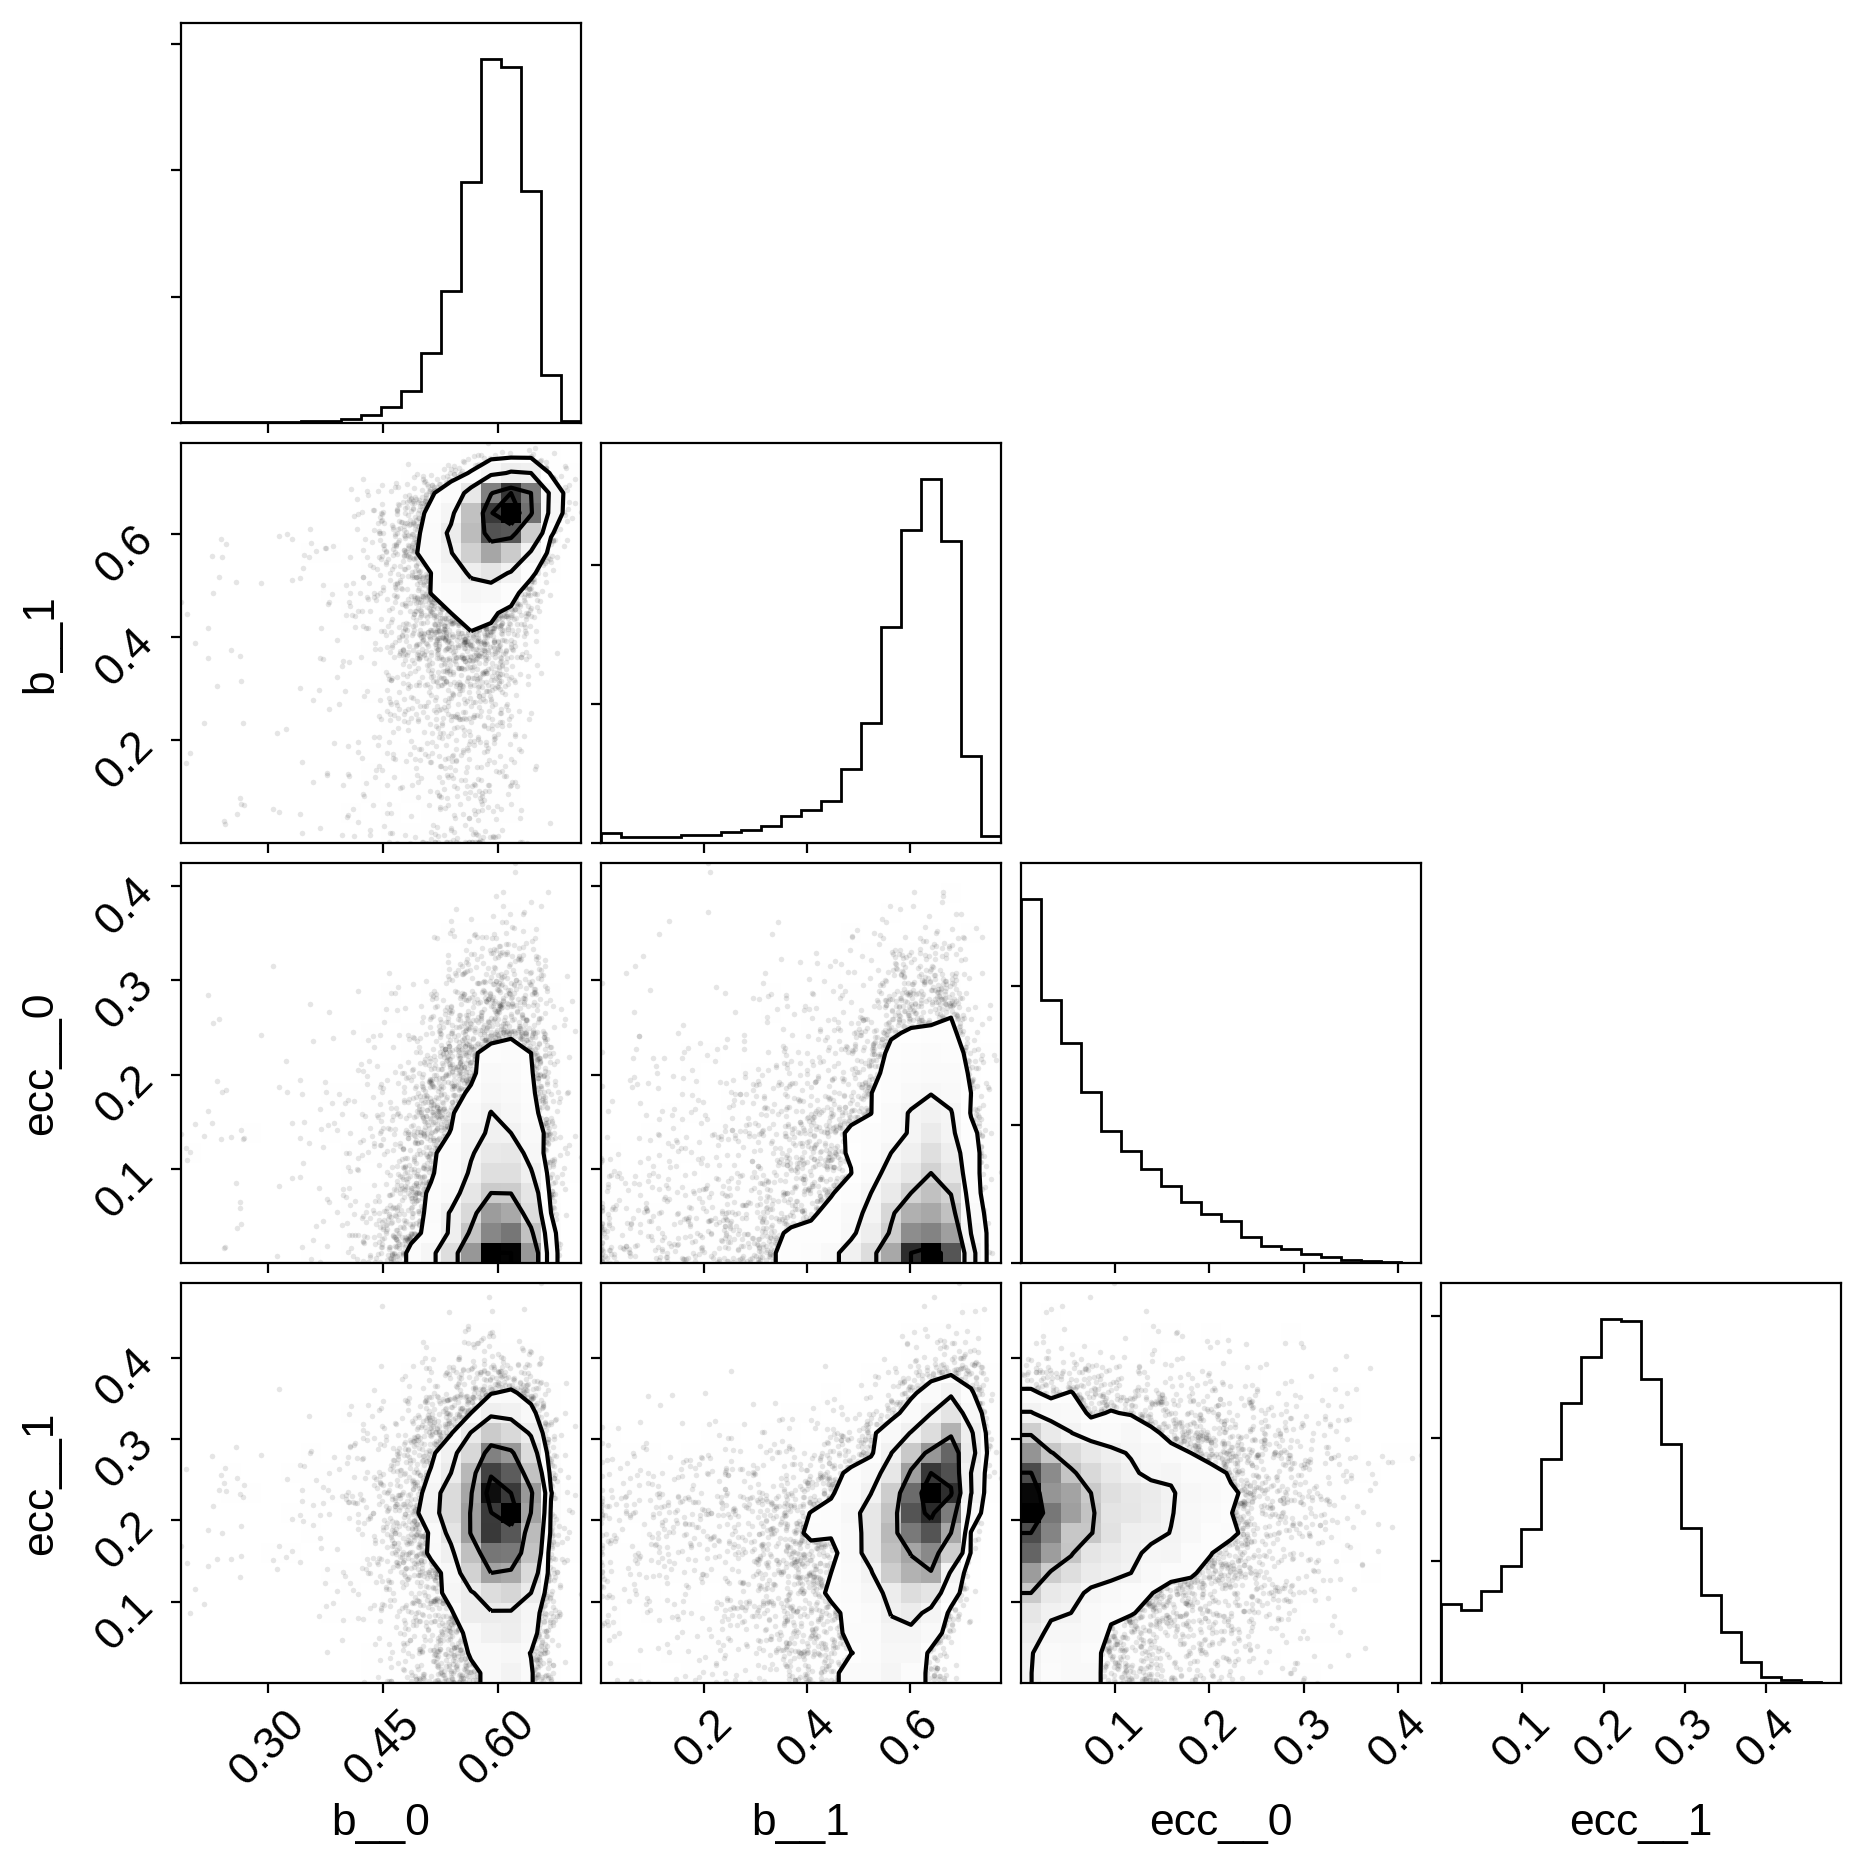

In [18]:
import corner
varnames = ["b", "ecc"]
samples = pm.trace_to_dataframe(trace, varnames=varnames)
fig = corner.corner(samples);

## Phase plots

Finally, as in the :ref:`rv` and :ref:`transit` tutorials, we can make folded plots of the transits and the radial velocities and compare to the posterior model predictions. (Note: planets b and c in this tutorial are swapped compared to the labels from [Petigura et al. (2016)](https://arxiv.org/abs/1511.04497))

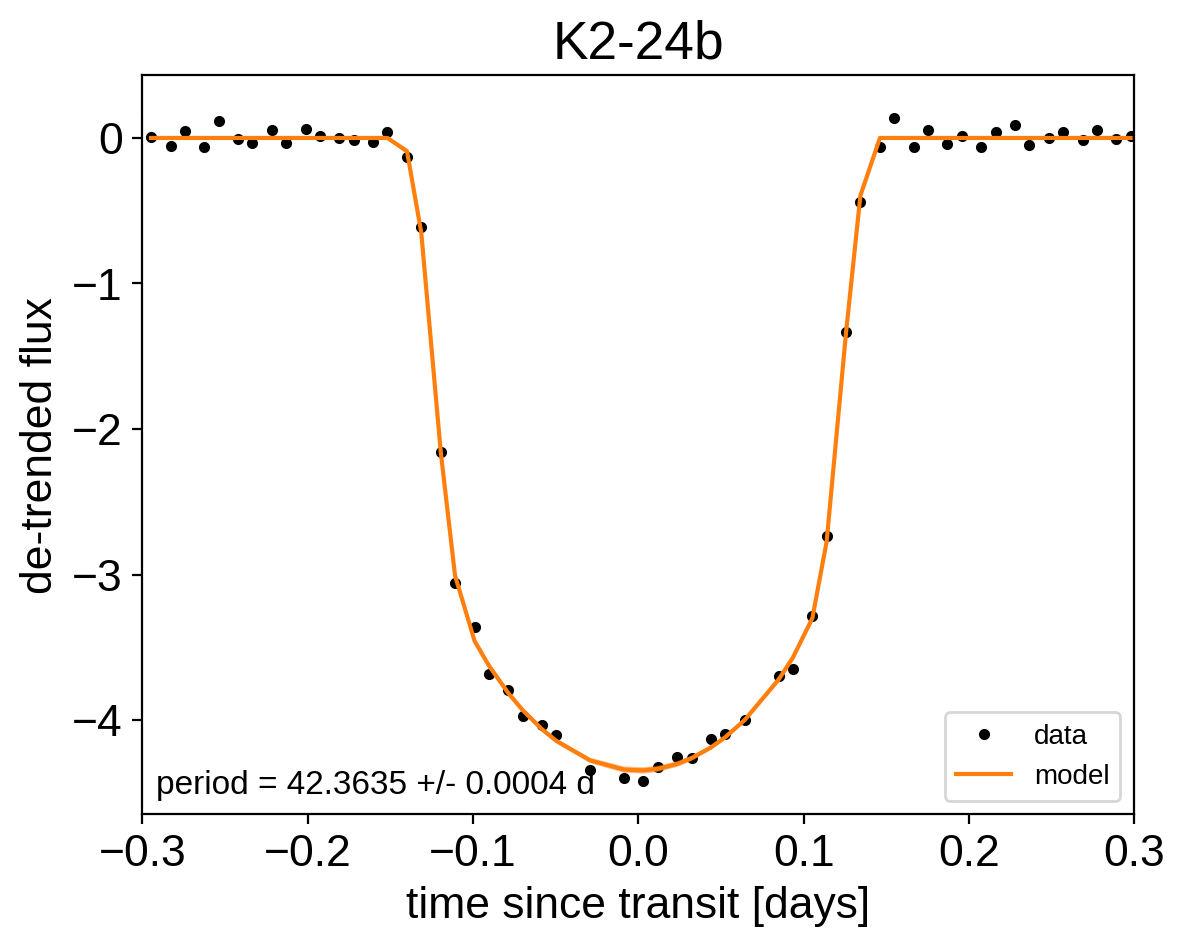

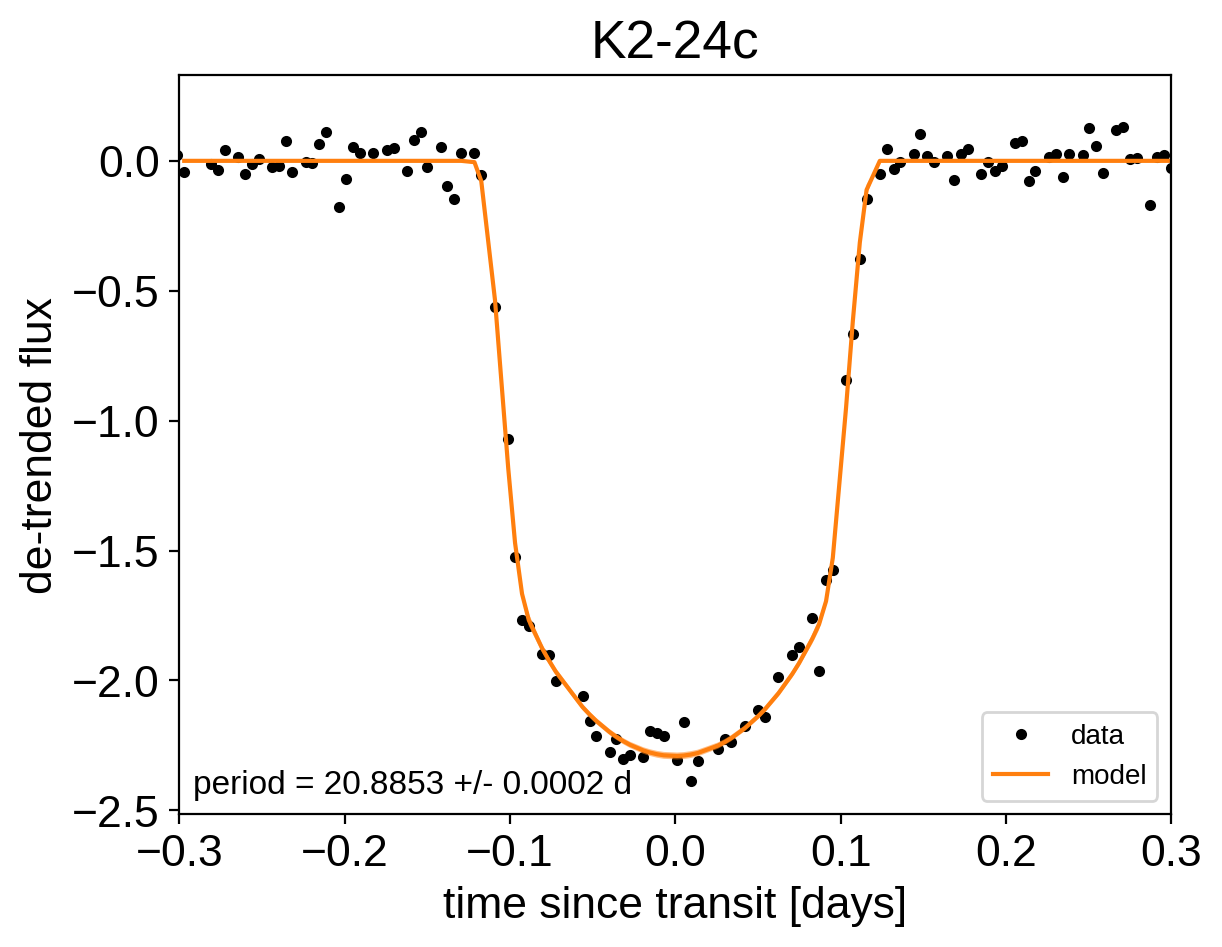

In [19]:
for n, letter in enumerate("bc"):
    plt.figure()
    
    # Compute the GP prediction
    gp_mod = np.median(trace["gp_pred"] + trace["mean"][:, None], axis=0)

    # Get the posterior median orbital parameters
    p = np.median(trace["period"][:, n])
    t0 = np.median(trace["t0"][:, n])
    
    # Compute the median of posterior estimate of the contribution from
    # the other planet. Then we can remove this from the data to plot
    # just the planet we care about.
    other = np.median(trace["light_curves"][:, :, (n + 1) % 2], axis=0)

    # Plot the folded data
    x_fold = (x[mask] - t0 + 0.5*p) % p - 0.5*p
    plt.plot(x_fold, y[mask] - gp_mod - other, ".k", label="data", zorder=-1000)
    
    # Plot the folded model
    inds = np.argsort(x_fold)
    inds = inds[np.abs(x_fold)[inds] < 0.3]
    pred = trace["light_curves"][:, inds, n]
    pred = np.percentile(pred, [16, 50, 84], axis=0)
    plt.plot(x_fold[inds], pred[1], color="C1", label="model")
    art = plt.fill_between(x_fold[inds], pred[0], pred[2], color="C1", alpha=0.5,
                           zorder=1000)
    art.set_edgecolor("none")
    
    # Annotate the plot with the planet's period
    txt = "period = {0:.4f} +/- {1:.4f} d".format(
        np.mean(trace["period"][:, n]), np.std(trace["period"][:, n]))
    plt.annotate(txt, (0, 0), xycoords="axes fraction",
                 xytext=(5, 5), textcoords="offset points", 
                 ha="left", va="bottom", fontsize=12)

    plt.legend(fontsize=10, loc=4)
    plt.xlim(-0.5*p, 0.5*p)
    plt.xlabel("time since transit [days]")
    plt.ylabel("de-trended flux")
    plt.title("K2-24{0}".format(letter));
    plt.xlim(-0.3, 0.3)

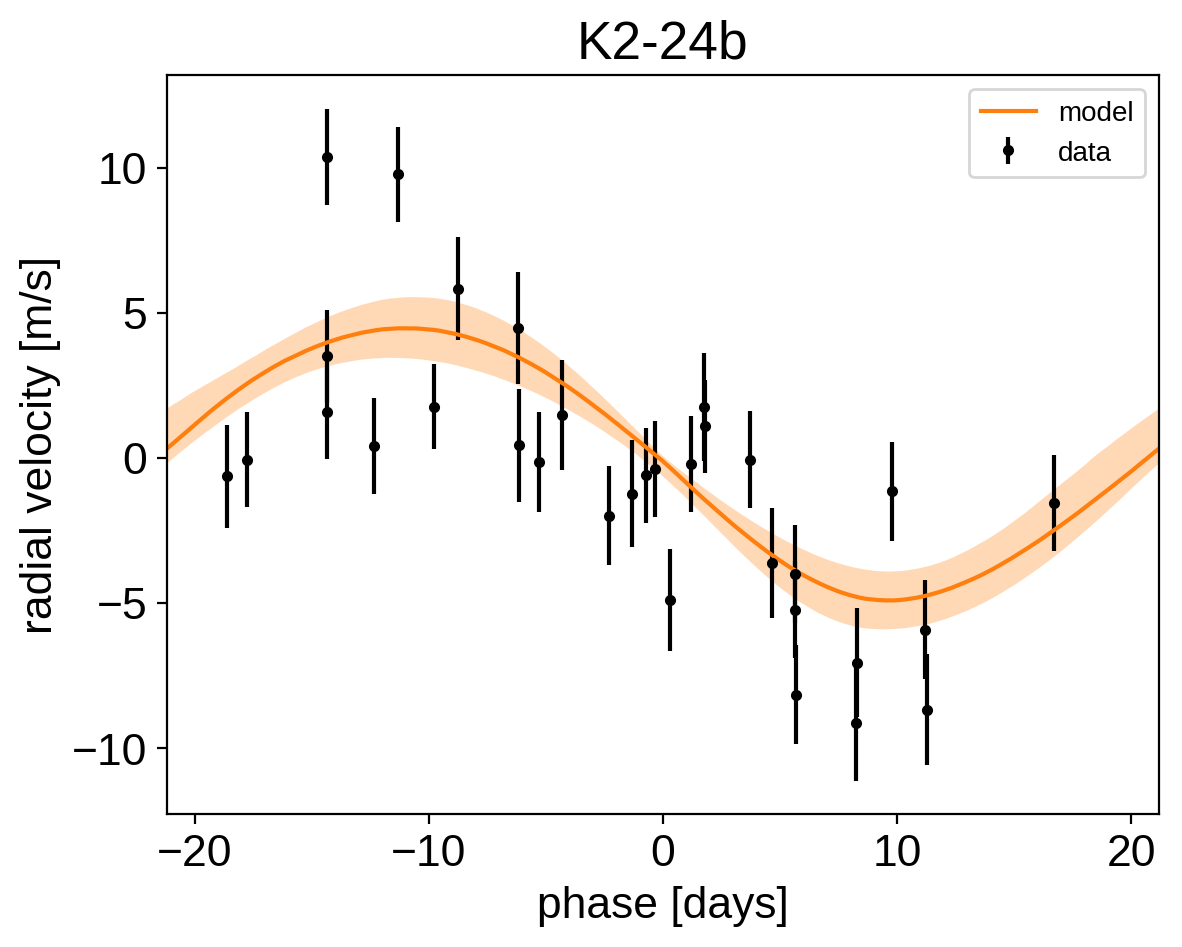

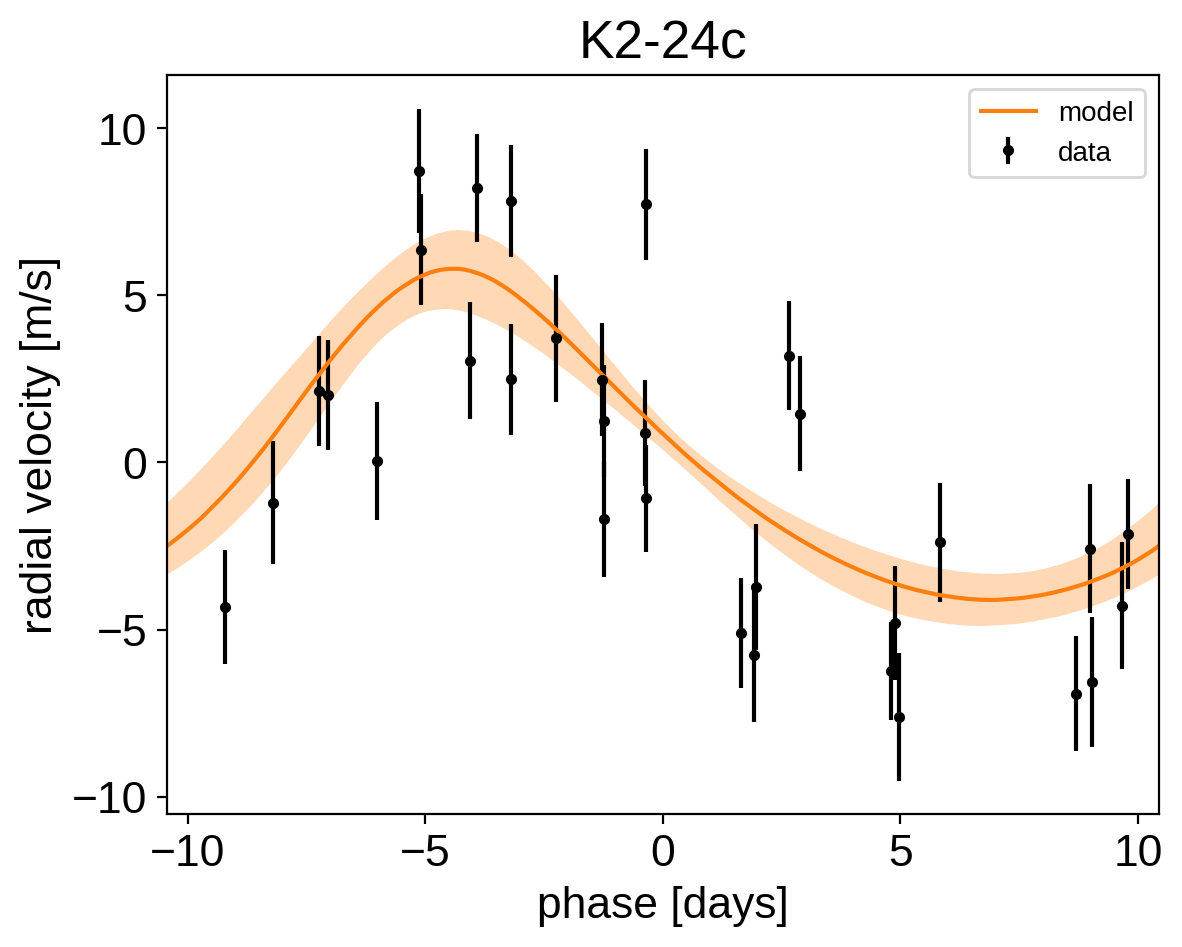

In [20]:
for n, letter in enumerate("bc"):    
    plt.figure()

    # Get the posterior median orbital parameters
    p = np.median(trace["period"][:, n])
    t0 = np.median(trace["t0"][:, n])
    
    # Compute the median of posterior estimate of the background RV
    # and the contribution from the other planet. Then we can remove
    # this from the data to plot just the planet we care about.
    other = np.median(trace["vrad"][:, :, (n + 1) % 2], axis=0)
    other += np.median(trace["bkg"], axis=0)

    # Plot the folded data
    x_fold = (x_rv - t0 + 0.5*p) % p - 0.5*p
    plt.errorbar(x_fold, y_rv - other, yerr=yerr_rv, fmt=".k", label="data")
    
    # Compute the posterior prediction for the folded RV model for this
    # planet
    t_fold = (t_rv - t0 + 0.5*p) % p - 0.5*p
    inds = np.argsort(t_fold)
    pred = np.percentile(trace["vrad_pred"][:, inds, n], [16, 50, 84], axis=0)
    plt.plot(t_fold[inds], pred[1], color="C1", label="model")
    art = plt.fill_between(t_fold[inds], pred[0], pred[2], color="C1", alpha=0.3)
    art.set_edgecolor("none")

    plt.legend(fontsize=10)
    plt.xlim(-0.5*p, 0.5*p)
    plt.xlabel("phase [days]")
    plt.ylabel("radial velocity [m/s]")
    plt.title("K2-24{0}".format(letter));

We can also compute the posterior constraints on the planet densities.

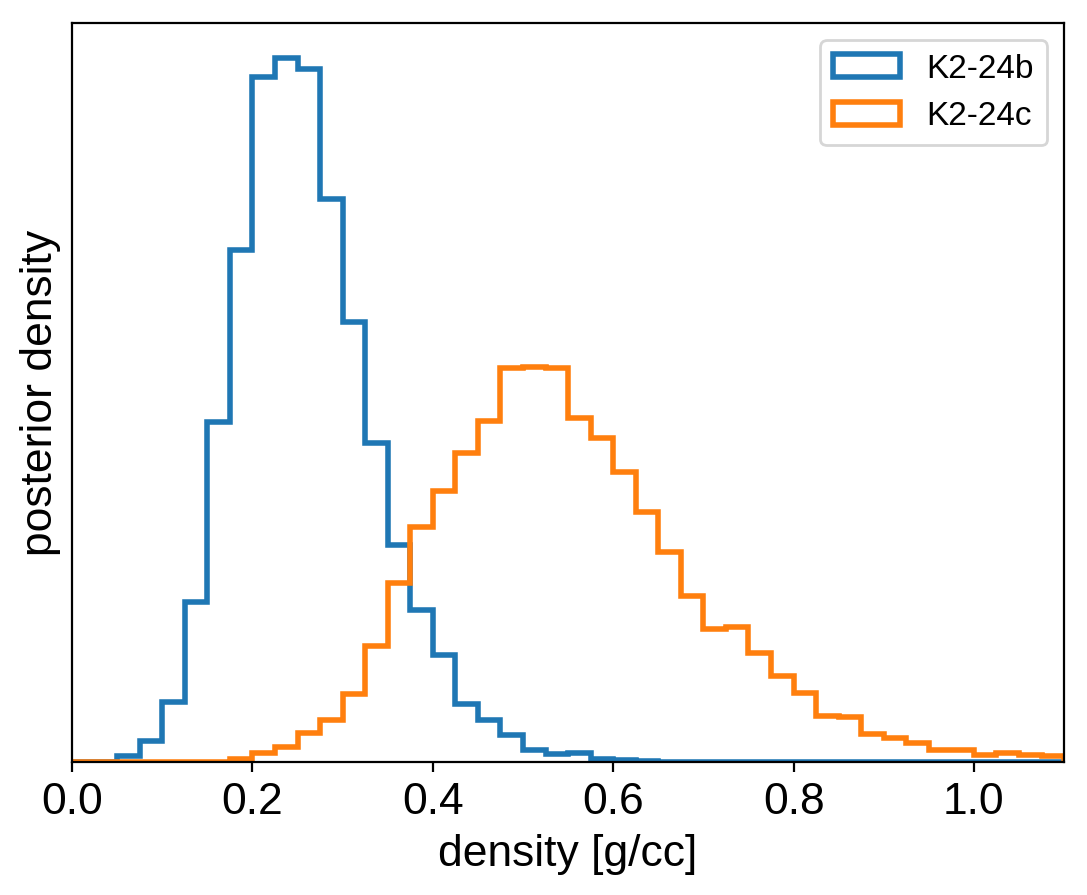

In [21]:
volume = 4/3*np.pi*trace["r_pl"]**3
density = u.Quantity(trace["m_pl"] / volume, unit=u.M_earth / u.R_sun**3)
density = density.to(u.g / u.cm**3).value

bins = np.linspace(0, 1.1, 45)
for n, letter in enumerate("bc"):    
    plt.hist(density[:, n], bins, histtype="step", lw=2,
             label="K2-24{0}".format(letter), density=True)
plt.yticks([])
plt.legend(fontsize=12)
plt.xlim(bins[0], bins[-1])
plt.xlabel("density [g/cc]")
plt.ylabel("posterior density");

## Citations

As described in the :ref:`citation` tutorial, we can use :func:`exoplanet.citations.get_citations_for_model` to construct an acknowledgement and BibTeX listing that includes the relevant citations for this model.

In [22]:
with model:
    txt, bib = xo.citations.get_citations_for_model()
print(txt)

This research made use of \textsf{exoplanet} \citep{exoplanet} and its
dependencies \citep{exoplanet:astropy13, exoplanet:astropy18,
exoplanet:exoplanet, exoplanet:foremanmackey17, exoplanet:foremanmackey18,
exoplanet:kipping13, exoplanet:luger18, exoplanet:pymc3, exoplanet:theano}.


In [23]:
print("\n".join(bib.splitlines()[:10]) + "\n...")


@misc{exoplanet:exoplanet,
  author = {Dan Foreman-Mackey and
            Geert Barentsen and
            Tom Barclay},
   title = {dfm/exoplanet: exoplanet v0.1.6},
   month = apr,
    year = 2019,
     doi = {10.5281/zenodo.2651251},
     url = {https://doi.org/10.5281/zenodo.2651251}
...
